In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import pickle
import os
from ipywidgets import interact, interact_manual
%matplotlib inline

# Starting with some image utility functions
These will help visualize and save images throughout the project.

In [2]:
IMAGE_OUTPUT_PATH = 'output_images/'

def load_images_from_dir(path):
    """ return list of (image, filename) from a specified directory"""
    return [(mpimg.imread(os.path.join(path, file)), file) for file in os.listdir(path)]


def weighted_img(image1, image2, α=0.8, β=1., γ=0.):
    """
    The result image is computed as follows:
    image1 * α + image2 * β + γ
    NOTE: image1 and image2 must be the same shape!
    """
    return cv2.addWeighted(image1, α, image2, β, γ)

def show_images(images_data, in_gray=False, img_per_row=3, figsize=(20, 10)):
    """Display images as is or in grey scale. images_data = [(image, name)...]"""
    # images count
    img_cnt = len(images_data)
    
    # show max 3 images per row. Calculate the rows count
    row_cnt = int((img_cnt-1) / img_per_row) + 1
    
    # display the images
    f, axs =  plt.subplots(row_cnt, img_per_row, figsize=figsize)
    count_images = 0
    for r in range(row_cnt):
        for c in range(img_per_row):
            if count_images < img_cnt:
                count_images += 1
                if row_cnt == 1 and img_per_row == 1:
                     ax = axs
                elif row_cnt == 1:
                    ax = axs[c]
                elif img_per_row == 1:
                    ax = axs[r]
                else:
                    ax = axs[r, c]
                cmap = 'gray' if in_gray else None
                ax.set_title(images_data[img_per_row*r + c][1])
                ax.imshow(images_data[img_per_row*r + c][0], cmap=cmap)

                
def save_images(list_images_data, filename_prefix='', in_gray=False):
    """Save a list of images to disk.
    `list_images_data` is a list of tuple(image, filename)"""
    #
    cmap = 'gray' if in_gray == True else None
    #for (image, filename) in list_images_data: 
    #    plt.imsave(os.path.join(IMAGE_OUTPUT_PATH, filename_prefix+filename), image, cmap=cmap)

        
def apply_brightness_contrast(input_img, brightness = 0, contrast = 0):
    # https://stackoverflow.com/questions/39308030/how-do-i-increase-the-contrast-of-an-image-in-python-opencv
    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        alpha_b = (highlight - shadow)/255
        gamma_b = shadow

        buf = cv2.addWeighted(input_img, alpha_b, input_img, 0, gamma_b)
    else:
        buf = input_img.copy()

    if contrast != 0:
        f = 131*(contrast + 127)/(127*(131-contrast))
        alpha_c = f
        gamma_c = 127*(1-f)

        buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)

    return buf


def adaptive_brightness(image, hpart=4, wpart=4):
    H = image.shape[0]
    W = image.shape[1]
    
    wsize = W // wpart
    hsize = H // hpart
    image_parts = [[image[h*hsize:(h+1)*hsize, w*wsize:(w+1)*wsize] for w in range(wpart)] for h in range(hpart)]
    
    for h, img_row in enumerate(image_parts):
        for w, img in enumerate(img_row):
            hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            mean_lumi = np.mean(hls[:,:,1])
            #print('Mean Lumi ({}, {}): {}'.format(h, w, mean_lumi))
            if mean_lumi > 110:
                britghness = (100 - mean_lumi)*1.5
                image_parts[h][w] = apply_brightness_contrast(img, britghness, 20)
                hls = cv2.cvtColor(image_parts[h][w], cv2.COLOR_RGB2HLS)
                mean_lumi = np.mean(hls[:,:,1])
                #print('after correction: Mean Lumi ({}, {}): {} , reduced brightness {}'.format(h, w, mean_lumi, britghness))
            elif mean_lumi < 80:
                britghness = (80 - mean_lumi)*1.5
                image_parts[h][w] = apply_brightness_contrast(img, britghness, 20)
                hls = cv2.cvtColor(image_parts[h][w], cv2.COLOR_RGB2HLS)
                mean_lumi = np.mean(hls[:,:,1])
                #print('after correction: Mean Lumi ({}, {}): {} , reduced brightness {}'.format(h, w, mean_lumi, britghness))

    #f, axs = plt.subplots(hpart, wpart, figsize=(20, 5*hpart))
    #for row, img_row in zip(axs, image_parts):
    #    for ax, img in zip(row, img_row):
    #        ax.imshow(img)
    
    result = np.copy(image)
    for h, img_row in enumerate(image_parts):
        for w, img in enumerate(img_row):
            result[h*hsize:(h+1)*hsize, w*wsize:(w+1)*wsize] = img
    
    return result

# 1. Camera Calibration

We will use some checkboard images taken by the camera for calibration.
#### a. Let's start looking at some of those chessboard images.

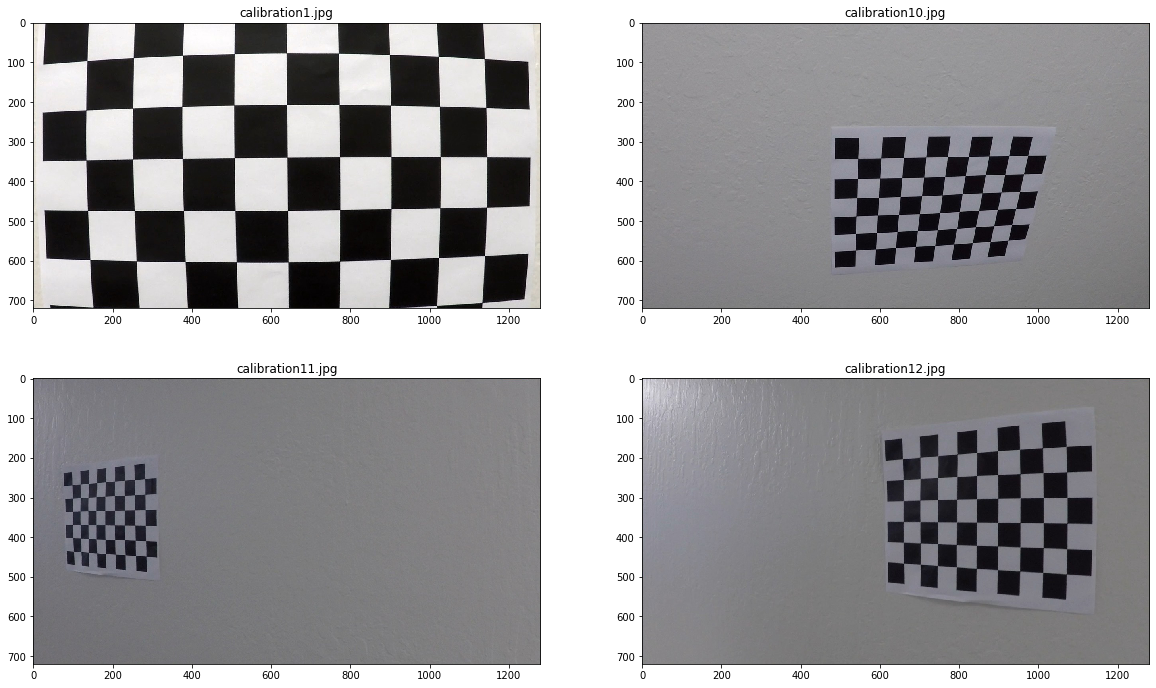

In [3]:
# Make a list of calibration images
cal_images = load_images_from_dir('camera_cal/')
show_images(cal_images[:4], img_per_row=2, figsize=(20, 12))

We will consider for the next steps a 9x6 chessboard.
#### b. Finding the chessboard corners

In [4]:
CHESS_NX = 9
CHESS_XY = 6

# prepare object points
objp = np.zeros((CHESS_XY*CHESS_NX,3), np.float32)
objp[:,:2] = np.mgrid[0:CHESS_NX, 0:CHESS_XY].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
img_with_corners = [] # images updated with the drawing of their corners found

# Step through the list and search for chessboard corners
for image, fname in cal_images:
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (CHESS_NX, CHESS_XY), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        image = cv2.drawChessboardCorners(image, (CHESS_NX, CHESS_XY), corners, ret)
        img_with_corners.append((image, fname))

Let's see what we get...

Nb images with corners detected 17/20


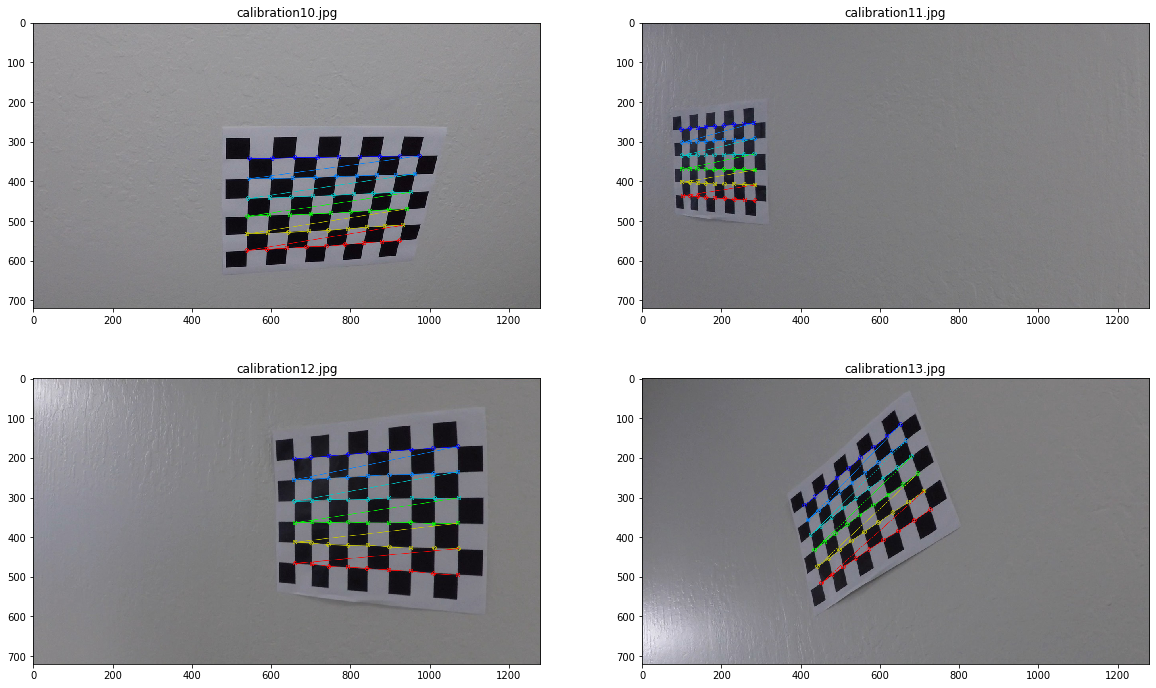

In [5]:
print('Nb images with corners detected {}/{}'.format(len(img_with_corners), len(cal_images)))

# Just display few images with their cornes
nb_image_corners_to_display = np.min([4, len(img_with_corners)])
show_images(img_with_corners[:nb_image_corners_to_display], img_per_row=2, figsize=(20, 12))
save_images(img_with_corners, filename_prefix='with_corners_')

#### c. Calculate the distortion coefficients

In [6]:
# Get thesize of the images
img_size = (cal_images[0][0].shape[1], cal_images[0][0].shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Let's save the interesting distorsion coefficients for later use
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open("calibration_dist_pickle.p", "wb"))


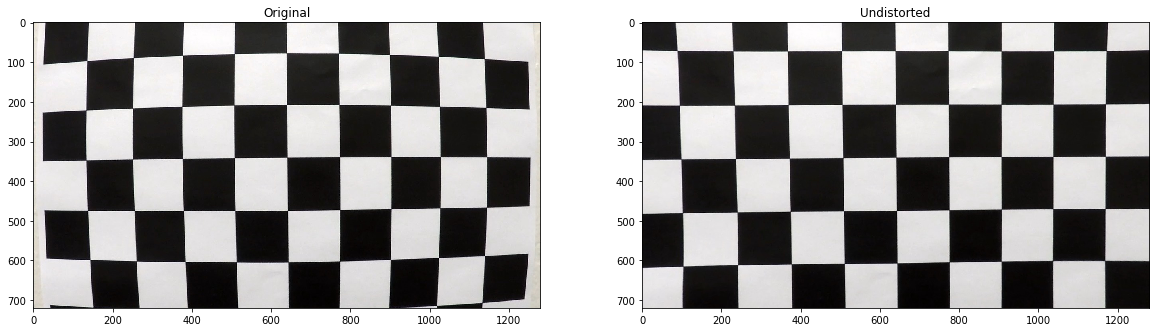

In [7]:
def undistort_image(image, dist, mtx):
    """Utility function to undistort an image, given the distortion coefficients"""
    return cv2.undistort(image, mtx, dist, None, mtx)

# Undistort one of the calibration image to see the effect:
cal_image = cal_images[0][0]
cal_image_undistorted = undistort_image(cal_image, dist, mtx)
show_images([(cal_image, 'Original'), (cal_image_undistorted, 'Undistorted')], img_per_row=2, figsize=(20, 20))
save_images([(cal_image_undistorted, cal_images[0][1])], filename_prefix='undistorted_')

# 2. Load & Undistort test images

In [8]:
# Load the test images
test_images = load_images_from_dir('test_images/')

# Undistort the test images
undistorted_images = [(undistort_image(image, dist, mtx), 'undistorted_'+fname) for (image, fname) in test_images]
save_images(undistorted_images)

# Display images and their undistorted version interactively
@interact(image_index=[(undistorted_images[i][1], i) for i in range(len(undistorted_images))])
def show_undistorted_images(image_index):
    show_images([test_images[image_index], undistorted_images[image_index]], img_per_row=2, figsize=(20, 12))

interactive(children=(Dropdown(description='image_index', options=(('undistorted_00147_image.jpg', 0), ('undis…

# 3. Thresholded Binary Images
Let's explore how we could get acceptable thresholded binary images

#### A. Exploring different color spaces

In [9]:
# Let's have a look on RGB and HLS channels for each test image

images_index = [(undistorted_images[i][1], i) for i in range(len(undistorted_images))]

# Using an interactive widget to
@interact(image_index=images_index)
def show_rgb_hls(image_index):
    image, fname = undistorted_images[image_index]
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # RGB channels
    r_channel = image[:,:,0]
    g_channel = image[:,:,1]
    b_channel = image[:,:,2]
    
    # HLS channels
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    f, (ax1, ax2) =  plt.subplots(1, 2, figsize=(20, 10))
    ax1.set_title(fname + ' - RGB')
    ax1.imshow(image)
    ax2.set_title(fname + ' - Gray')
    ax2.imshow(gray, cmap='gray')
    
    show_images([(r_channel, 'R Channel'), (g_channel, 'G Channel'), (b_channel, 'B Channel')], img_per_row=3, figsize=(20, 10), in_gray=True)
    show_images([(h_channel, 'H Channel'), (l_channel, 'L Channel'), (s_channel, 'S Channel')], img_per_row=3, figsize=(20, 10), in_gray=True)


interactive(children=(Dropdown(description='image_index', options=(('undistorted_00147_image.jpg', 0), ('undis…

White color is very clear on all RGB channels, as well on the L channel of HSL color space.

Yellow color is stronger on the S channel of HLS, but we also know that H channel hold a consistent value of the color under different lighting. It is also quite Ok on R channel of RGB, a little less on the G channel.

Let's explore some combination of those to see where we can get better result.

In [10]:
# Trying different threshold values to detect white color on RGB & HLS color spaces

@interact(image_index=images_index, rgb_low=(0,255,1), rgb_upper=(0,255,1), l_low=(0,255,1), l_upper=(0,255,1))
def show_white_color_threshold(image_index, rgb_low=190, rgb_upper=255, l_low=190, l_upper=255):
    image, fname = undistorted_images[image_index]
    
    # Convert to HLS
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    mean_lumi = np.mean(hls[:,:,1])
    print('Mean Lumi : {}'.format(mean_lumi))
    if mean_lumi > 110:
        britghness = (100 - mean_lumi)*1.5
        image = apply_brightness_contrast(image, britghness, 20)
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        mean_lumi = np.mean(hls[:,:,1])
        print('after correction: Mean Lumi : {} , - brightness {}'.format(mean_lumi, britghness))
    elif mean_lumi < 80:
        britghness = (80 - mean_lumi)*1.5
        image = apply_brightness_contrast(image, britghness, 20)
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        mean_lumi = np.mean(hls[:,:,1])
        print('after correction: Mean Lumi : {} , + brightness {}'.format(mean_lumi, britghness))
    
    '''
    # Calulate the mean luminescence
    mean_lumi = np.mean(hls[:,:,1])
    print('Mean Lumi: {}'.format(mean_lumi))
    if mean_lumi > 110:
        reduce_britghness = 10 * (100 - mean_lumi) / 5
        image = apply_brightness_contrast(image, reduce_britghness, 0)
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        mean_lumi = np.mean(hls[:,:,1])
        print('after correction: mean lumi {} , reduced brightness {}', mean_lumi, reduce_britghness)
    '''
    # threshold ranges
    rgb_low_white = np.array([rgb_low, rgb_low, rgb_low])
    rgb_upper_white = np.array([rgb_upper, rgb_upper, rgb_upper])
    l_low_white = np.array([0, l_low, 0])
    l_upper_white = np.array([255, l_upper, 255])
    
    
    
    # create binary images for white color
    rgb_binary = cv2.inRange(image, rgb_low_white, rgb_upper_white) // 255
    l_binary = cv2.inRange(hls, l_low_white, l_upper_white) // 255
    
    color_stack = np.dstack(( np.zeros_like(rgb_binary), rgb_binary, l_binary))*255
    
    f, [(ax1, ax2), (ax3, ax4)] =  plt.subplots(2, 2, figsize=(20, 10))
    ax1.set_title(fname + ' - RGB')
    ax1.imshow(image)
    ax2.set_title(fname + ' - Stack')
    ax2.imshow(color_stack)
    ax3.set_title(' - RGB White')
    ax3.imshow(rgb_binary, cmap='gray')
    ax4.set_title(' - HLS White')
    ax4.imshow(l_binary, cmap='gray')


interactive(children=(Dropdown(description='image_index', options=(('undistorted_00147_image.jpg', 0), ('undis…

In [11]:
# Trying different threshold values to detect white color on RGB & HLS color spaces

@interact(image_index=images_index, l_low=(0,255,1), l_upper=(0,255,1), s_low=(0,255,1), s_upper=(0,255,1))
def show_gray_color_threshold(image_index, l_low=0, l_upper=150, s_low=0, s_upper=20):
    image, fname = undistorted_images[image_index]
    
    # Convert to HLS
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    mean_lumi = np.mean(hls[:,:,1])
    print('Mean Lumi : {}'.format(mean_lumi))
    if mean_lumi > 110:
        britghness = (100 - mean_lumi)*1.5
        image = apply_brightness_contrast(image, britghness, 20)
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        mean_lumi = np.mean(hls[:,:,1])
        print('after correction: Mean Lumi : {} , - brightness {}'.format(mean_lumi, britghness))
    elif mean_lumi < 80:
        britghness = (80 - mean_lumi)*1.5
        image = apply_brightness_contrast(image, britghness, 20)
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        mean_lumi = np.mean(hls[:,:,1])
        print('after correction: Mean Lumi : {} , + brightness {}'.format(mean_lumi, britghness))
        
    # threshold ranges
    l_low_white = np.array([0, l_low, s_low])
    l_upper_white = np.array([255, l_upper, s_upper])
    
    # create binary images for white color
    #rgb_binary = cv2.inRange(image, rgb_low_white, rgb_upper_white) // 255
    l_binary = cv2.inRange(hls, l_low_white, l_upper_white) // 255
    
    color_stack = np.dstack(( np.zeros_like(l_binary), l_binary, l_binary))*255
    
    f, [(ax1, ax2), (ax3, ax4)] =  plt.subplots(2, 2, figsize=(20, 10))
    ax1.set_title(fname + ' - RGB')
    ax1.imshow(image)
    ax2.set_title(fname + ' - Stack')
    ax2.imshow(color_stack)
    #ax3.set_title(' - RGB White')
    #ax3.imshow(rgb_binary, cmap='gray')
    ax4.set_title(' - HLS White')
    ax4.imshow(l_binary, cmap='gray')

interactive(children=(Dropdown(description='image_index', options=(('undistorted_00147_image.jpg', 0), ('undis…

In [12]:
# Trying different threshold values to detect yello color on HLS color space, by combining H & S Channels

@interact(image_index=images_index, h_yello_low=(0,255,1), h_yello_up=(0,255,1), s_yello_low=(0,255,1), s_yello_up=(0,255,1))
def show_yellow_color_threshold(image_index, h_yello_low=10, h_yello_up=40, s_yello_low=100, s_yello_up=255):
    image, fname = undistorted_images[image_index]
    
    # Convert to HLS
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    mean_lumi = np.mean(hls[:,:,1])
    print('Mean Lumi : {}'.format(mean_lumi))
    if mean_lumi > 110:
        britghness = (100 - mean_lumi)*1.5
        image = apply_brightness_contrast(image, britghness, 20)
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        mean_lumi = np.mean(hls[:,:,1])
        print('after correction: Mean Lumi : {} , - brightness {}'.format(mean_lumi, britghness))
    elif mean_lumi < 80:
        britghness = (80 - mean_lumi)*1.5
        image = apply_brightness_contrast(image, britghness, 20)
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        mean_lumi = np.mean(hls[:,:,1])
        print('after correction: Mean Lumi : {} , + brightness {}'.format(mean_lumi, britghness))
    
    # threshold ranges
    yellow_low = np.array([h_yello_low, 0, s_yello_low])
    yellow_up = np.array([h_yello_up, 255, s_yello_up])
    
    # create binary images for white color
    yellow_binary = cv2.inRange(hls, yellow_low, yellow_up) // 255
    
    f, (ax1, ax2) =  plt.subplots(1, 2, figsize=(20, 10))
    ax1.set_title(fname + ' - RGB')
    ax1.imshow(image)
    ax2.set_title(fname + ' - Yellow on HLS')
    ax2.imshow(yellow_binary, cmap='gray')


interactive(children=(Dropdown(description='image_index', options=(('undistorted_00147_image.jpg', 0), ('undis…

#### B. Exploring some gradiant thresholds based on combination of sobel operators

In [13]:
##########################################################
## Combining gradients...
##########################################################

def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    sobel = cv2.Sobel(gray, cv2.CV_64F, int(orient=='x'), int(orient=='y'), ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return grad_binary


def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    #Calculate the magnitude 
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    
    #Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    return mag_binary


def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    absgraddir = np.arctan2(np.abs(sobely), np.abs(sobelx))
    
    dir_binary = np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    return dir_binary


@interact_manual(image_index=images_index, sobel_kernel=(1, 45, 2), low_thrx=(0, 255, 1), up_thrx=(0, 255, 1), 
          low_thry=(0, 255, 1), up_thry=(0, 255, 1), low_thr_mag=(0, 255, 1), up_thr_mag=(0, 255, 1), 
          low_thr_dir=(0, np.pi/2, 0.1), up_thr_dir=(0, np.pi/2, 0.1))
def gradient_thresh(
    image_index, sobel_kernel=3, low_thrx=40, up_thrx=100, low_thry=40, up_thry=100, 
    low_thr_mag=30, up_thr_mag=100, low_thr_dir=0.7, up_thr_dir=1.3):
    
    image, fname = undistorted_images[image_index]
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=sobel_kernel, thresh=(low_thrx, up_thrx))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=sobel_kernel, thresh=(low_thry, up_thry))
    mag_binary = mag_thresh(image, sobel_kernel=sobel_kernel, mag_thresh=(low_thr_mag, up_thr_mag))
    dir_binary = dir_threshold(image, sobel_kernel=sobel_kernel, thresh=(low_thr_dir, up_thr_dir))

    #Trying different combinations...
    combined_x_n_y = np.zeros_like(gradx)
    combined_x_n_y[(gradx == 1) & (grady == 1)] = 1
    
    combined_x_o_y = np.zeros_like(gradx)
    combined_x_o_y[(gradx == 1) | (grady == 1)] = 1
    
    combined_x_n_m = np.zeros_like(gradx)
    combined_x_n_m[(gradx == 1) & (mag_binary == 1)] = 1
    
    combined_x_o_m = np.zeros_like(gradx)
    combined_x_o_m[(gradx == 1) | (mag_binary == 1)] = 1
    
    combined_y_n_m = np.zeros_like(grady)
    combined_y_n_m[(grady == 1) & (mag_binary == 1)] = 1
    
    combined_y_o_m = np.zeros_like(grady)
    combined_y_o_m[(grady == 1) | (mag_binary == 1)] = 1
    
    combined_x_n_d = np.zeros_like(gradx)
    combined_x_n_d[(gradx == 1) & (dir_binary == 1)] = 1
    
    combined_x_o_d = np.zeros_like(gradx)
    combined_x_o_d[(gradx == 1) | (dir_binary == 1)] = 1
    
    combined_y_n_d = np.zeros_like(grady)
    combined_y_n_d[(grady == 1) & (dir_binary == 1)] = 1
    
    combined_y_o_d = np.zeros_like(grady)
    combined_y_o_d[(grady == 1) | (dir_binary == 1)] = 1

    combined_m_n_d = np.zeros_like(mag_binary)
    combined_m_n_d[(mag_binary == 1) & (dir_binary == 1)] = 1
    
    combined_m_o_d = np.zeros_like(mag_binary)
    combined_m_o_d[(mag_binary == 1) | (dir_binary == 1)] = 1
    
    combined_x_n_y_n_m = np.zeros_like(gradx)
    combined_x_n_y_n_m[(gradx == 1) & (grady == 1) & (mag_binary == 1)] = 1
    
    combined_x_o_y_o_m = np.zeros_like(gradx)
    combined_x_o_y_o_m[(gradx == 1) | (grady == 1) | (mag_binary == 1)] = 1
    
    combined_x_n_y_n_d = np.zeros_like(gradx)
    combined_x_n_y_n_d[(gradx == 1) & (grady == 1) & (dir_binary == 1)] = 1
    
    combined_x_o_y_o_d = np.zeros_like(gradx)
    combined_x_o_y_o_d[(gradx == 1) | (grady == 1) | (dir_binary == 1)] = 1
    
    combined_x_n_y_n_m_n_d = np.zeros_like(gradx)
    combined_x_n_y_n_m_n_d[(gradx == 1) & (grady == 1) & (mag_binary == 1) & (dir_binary == 1)] = 1
    
    combined_x_o_y_o_m_o_d = np.zeros_like(gradx)
    combined_x_o_y_o_m_o_d[(gradx == 1) | (grady == 1) | (mag_binary == 1) | (dir_binary == 1)] = 1
    
    combined_gradiants = [
        (gradx, 'X'), (grady, 'Y'), (mag_binary, 'M'), (dir_binary, 'D'),
        (combined_x_n_y, 'X & Y: '+fname), (combined_x_o_y, 'X | Y: '+fname),
        (combined_x_n_m, 'X & M: '+fname), (combined_x_o_m, 'X | M: '+fname),
        (combined_y_n_m, 'Y & M: '+fname), (combined_y_o_m, 'Y | M: '+fname),
        (combined_x_n_d, 'X & D: '+fname), (combined_x_o_d, 'X | D: '+fname),
        (combined_y_n_d, 'Y & D: '+fname), (combined_y_o_d, 'Y | D: '+fname),
        (combined_m_n_d, 'M & D: '+fname), (combined_m_o_d, 'M | D: '+fname),
        (combined_x_n_y_n_m, 'X & Y & M: '+fname), (combined_x_o_y_o_m, 'X | Y | M: '+fname),
        (combined_x_n_y_n_d, 'X & Y & D: '+fname), (combined_x_o_y_o_d, 'X | Y | D: '+fname),
        (combined_x_n_y_n_m_n_d, 'X & Y & M & D: '+fname), (combined_x_o_y_o_m_o_d, 'X | Y | M | D: '+fname)
    ]
    
    f, (ax1, ax2) =  plt.subplots(1, 2, figsize=(20, 10))
    ax1.set_title(fname + ' - RGB')
    ax1.imshow(image)
    ax2.set_title(fname + ' - Gray')
    ax2.imshow(gray, cmap='gray')
    
    show_images(combined_gradiants, img_per_row=1, figsize=(40, 250), in_gray=True)
    

interactive(children=(Dropdown(description='image_index', options=(('undistorted_00147_image.jpg', 0), ('undis…

#### C. Selecting final combination of color & gradient thresholding
After testing multiple combinations we will finally go with a combination of:
* Color thresholding : detecting white and yellow color from RGB & HLS color spaces
* Gradient thresholding : using sobel_x operator

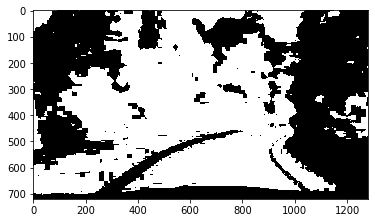

In [14]:
RGB_LOW_WHITE = np.array([200, 200, 200])
RGB_UPPER_WHITE = np.array([255,255,255])
HLS_LOW_WHITE = np.array([0, 200, 0])
HLS_UPPER_WHITE = np.array([255,255,255])
HLS_LOW_YELLOW = np.array([10, 0, 100])
HLS_UPPER_YELLOW = np.array([40, 255, 255])
HLS_LOW_GRAY = np.array([0, 0, 0])
HLS_UPPER_GRAY = np.array([255, 150, 20])
HLS_LOW_BLUE = np.array([90, 0, 0]) #95
HLS_UPPER_BLUE = np.array([130, 255, 255]) #120
HLS_LOW_OTHER = np.array([90, 0, 0]) #95
HLS_UPPER_OTHER = np.array([255, 150, 255]) #120

# Using an interactive widget to
def color_gradient_threshold(image, sobel_kernel=3, thresh=(20, 100), mg_thresh=(30, 100)):
    """Compute combined color & gradient thresholding binary image"""
    # Convert to HLS
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    mean_lumi = np.mean(hls[:,:,1])
    #print('Mean Lumi : {}'.format(mean_lumi))
    if mean_lumi > 110:
        britghness = (100 - mean_lumi)*1.5
        image = apply_brightness_contrast(image, britghness, 20)
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        mean_lumi = np.mean(hls[:,:,1])
        #print('after correction: Mean Lumi : {} , - brightness {}'.format(mean_lumi, britghness))
    elif mean_lumi < 80:
        britghness = (80 - mean_lumi)*1.5
        image = apply_brightness_contrast(image, britghness, 20)
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        mean_lumi = np.mean(hls[:,:,1])
        #print('after correction: Mean Lumi : {} , + brightness {}'.format(mean_lumi, britghness))
    '''
    # Calulate the mean luminescence
    mean_lumi = np.mean(hls[:,:,1])
    print('Mean Lumi: {}'.format(mean_lumi))
    if mean_lumi > 110:
        reduce_britghness = 10 * (100 - mean_lumi) / 5
        image = apply_brightness_contrast(image, reduce_britghness, 0)
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        mean_lumi = np.mean(hls[:,:,1])
        print('after correction: mean lumi {} , reduced brightness {}', mean_lumi, reduce_britghness)
    '''
    
    # create binary image for white & yellow colors
    white_rgb_binary = cv2.inRange(image, RGB_LOW_WHITE, RGB_UPPER_WHITE) // 255
    white_hls_binary = cv2.inRange(hls, HLS_LOW_WHITE, HLS_UPPER_WHITE) // 255
    
    # create binary image for yellow color
    yellow_hls_binary = cv2.inRange(hls, HLS_LOW_YELLOW, HLS_UPPER_YELLOW) // 255
    
    gray_hls_binary = cv2.inRange(hls, HLS_LOW_GRAY, HLS_UPPER_GRAY) // 255
    blue_hls_binary = cv2.inRange(hls, HLS_LOW_BLUE, HLS_UPPER_BLUE) // 255
    other_hls_binary = cv2.inRange(hls, HLS_LOW_OTHER, HLS_UPPER_OTHER) // 255
   
    # Calculate directional X gradient
    sobel_x = abs_sobel_thresh(image, orient='x', sobel_kernel=sobel_kernel, thresh=thresh)
    sobel_y = abs_sobel_thresh(image, orient='y', sobel_kernel=sobel_kernel, thresh=thresh)
    mag_binary = mag_thresh(image, sobel_kernel=sobel_kernel, mag_thresh=mg_thresh)
    combined_sobel = np.zeros_like(sobel_x)
    combined_sobel[(sobel_x == 1) | (sobel_y == 1) | (mag_binary == 1)] = 1
    #combined_sobel[(sobel_x == 1) | (sobel_y == 1)] = 1
    
    # Combined binary threshold
    combined_binary = np.zeros_like(sobel_x)
    combined_binary[((combined_sobel == 1) & (gray_hls_binary == 0) & (other_hls_binary == 0)) |
                    ((white_rgb_binary == 1) & (white_hls_binary == 1)) | (yellow_hls_binary == 1)] = 1
    #combined_binary[(sobel_x == 1) | ((white_rgb_binary == 1) & (white_hls_binary == 1)) | (yellow_hls_binary == 1)] = 1
    
    return combined_binary



# Convert to HLS
hls = cv2.cvtColor(undistorted_images[0][0], cv2.COLOR_RGB2HLS)

# create binary images for white color
#rgb_binary = cv2.inRange(image, rgb_low_white, rgb_upper_white) // 255
l_binary = cv2.inRange(hls, HLS_LOW_BLUE, HLS_UPPER_BLUE) // 255
plt.imshow(l_binary, cmap='gray')

In [15]:

@interact(image_index=images_index)
def show_color_gradient(image_index):
    image, fname = undistorted_images[image_index]
    
    f, ax =  plt.subplots(1, 1, figsize=(20, 10))
    ax.imshow(color_gradient_threshold(image), cmap='gray')


interactive(children=(Dropdown(description='image_index', options=(('undistorted_00147_image.jpg', 0), ('undis…

In [16]:
# Gradiant & Threshold of the undistorted images
thresholded_images = [(color_gradient_threshold(image), 'thresholded_'+fname) for (image, fname) in undistorted_images]
save_images(thresholded_images)

In [17]:
from ipywidgets import IntSlider, FloatSlider

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image



# Let's use an interactive function to display the selected area of interest

# Get image size
IMG_H, IMG_W = thresholded_images[0][0].shape

# Create the coordinates sliders
wg_l_bottom_x = IntSlider(min=0, max=IMG_W-1, step=1, value=150)  # bottom-left x
wg_l_bottom_y = IntSlider(min=0, max=IMG_H-1, step=1, value=719)  # bottom-left y
wg_l_top_x = IntSlider(min=0, max=IMG_W-1, step=1, value=627)  # top-left x
wg_l_top_y = IntSlider(min=0, max=IMG_H-1, step=1, value=400)  # top-left y
wg_r_top_x = IntSlider(min=0, max=IMG_W-1, step=1, value=683)  # top-right x
wg_r_top_y = IntSlider(min=0, max=IMG_H-1, step=1, value=400)  # top-right y
wg_r_bottom_x = IntSlider(min=0, max=IMG_W-1, step=1, value=1200)  # bottom-right x
wg_r_bottom_y = IntSlider(min=0, max=IMG_H-1, step=1, value=719)  # bottom-right y

# define interactive range values and step for each parameters
@interact(image_id=images_index, 
          l_bottom_x=wg_l_bottom_x, l_bottom_y=wg_l_bottom_y, l_top_x=wg_l_top_x, l_top_y=wg_l_top_y, 
          r_top_x=wg_r_top_x, r_top_y=wg_r_top_y, r_bottom_x=wg_r_bottom_x, r_bottom_y=wg_r_bottom_y)
def interact_select_area(image_id, l_bottom_x, l_bottom_y, l_top_x, l_top_y, r_top_x, r_top_y, r_bottom_x, r_bottom_y):
    _, ax =  plt.subplots(1, 1, figsize=(20, 20))
    ax.imshow(thresholded_images[image_id][0], cmap='gray')
    ax.set_title(thresholded_images[image_id][1])
    x = [l_bottom_x, l_top_x, r_top_x, r_bottom_x]
    y = [l_bottom_y, l_top_y, r_top_y, r_bottom_y]
    ax.plot(x, y, 'b--', lw=4)
    
# How to use:
# - change the value
# - click on the `Run Interact` button to display

interactive(children=(Dropdown(description='image_id', options=(('undistorted_00147_image.jpg', 0), ('undistor…

In [18]:
# Value selected after playing with the interactive canny function
#vertices = np.array([[(150, IMG_H-1),(627, 400), (683, 400), (1200, IMG_H-1)]], dtype=np.int32)
#thresholded_images = [(region_of_interest(image, vertices), file) for (image, file) in thresholded_images]

# 4. Perspective Transform

Let's calculate the perspective transform matrix from a typical image and apply it to our thresholded images

In [19]:
IMG_SIZE = (undistorted_images[0][0].shape[1], undistorted_images[0][0].shape[0])

def compute_perspective_transform_matrix(src_coords, dst_coords):
    """Calculate the perspective transform matric from source & destination coordinates"""
    src = np.float32([src_coords[0], src_coords[1], src_coords[2], src_coords[3]])
    dst = np.float32([dst_coords[0], dst_coords[1], dst_coords[2], dst_coords[3]])
    return cv2.getPerspectiveTransform(src, dst)


def apply_warp_perspective(image, M, img_size=IMG_SIZE, flags=cv2.INTER_LINEAR):
    """Apply warp perspective transform to an image"""
    return cv2.warpPerspective(image, M, img_size, flags=flags)
    


In [20]:
# Test image to use for calculating the transform matric
perpective_test_image = undistorted_images[0][0]

# Source coordinates
#src_coords = [[200, 720], [605, 443], [675, 443], [1111, 720]]
#src_coords = [[195, 719], [596, 449], [684, 449], [1123, 719]]
src_coords = [[190, 719], [569, 465], [714, 465], [1126, 719]]

# destination coordinates
#dst_coords = [[295, 719], [295, 0], [1023, 0], [1023, 719]]
dst_coords = [[290, 719], [290, 0], [1026, 0], [1026, 719]]

# Compute transform matrix
M = compute_perspective_transform_matrix(src_coords, dst_coords)

# Compute inverse transform matrix
Minv = compute_perspective_transform_matrix(dst_coords, src_coords)


In [21]:
# Display the warp prespective version of the undistorted and thresholded images

@interact(image_index=images_index)
def show_warped_perspective(image_index):
    u_image, fname = undistorted_images[image_index]
    t_image, fname = thresholded_images[image_index]
    
    warp_u_image = apply_warp_perspective(u_image, M)
    warp_t_image = apply_warp_perspective(t_image, M)
    f, [(ax1, ax2), (ax3, ax4)] =  plt.subplots(2, 2, figsize=(20, 10))
    
    ax1.imshow(u_image)
    ax1.set_title('Original: '+fname)
    x1 = [src_coords[0][0], src_coords[1][0], src_coords[2][0], src_coords[3][0]]
    y1 = [src_coords[0][1], src_coords[1][1], src_coords[2][1], src_coords[3][1]]
    ax1.plot(x1, y1, 'r--', lw=2)
    
    ax2.imshow(warp_u_image)
    ax1.set_title('Warp: '+fname)
    x2 = [dst_coords[0][0], dst_coords[1][0], dst_coords[2][0], dst_coords[3][0]]
    y2 = [dst_coords[0][1], dst_coords[1][1], dst_coords[2][1], dst_coords[3][1]]
    ax2.plot(x2, y2, 'r--', lw=2)
    
    ax3.imshow(t_image, cmap='gray')
    ax3.set_title('Original Thresholded: '+fname)
    ax3.plot(x1, y1, 'r--', lw=2)
    
    ax4.imshow(warp_t_image, cmap='gray')
    ax4.set_title('Warp Thresholded: '+fname)
    ax4.plot(x2, y2, 'r--', lw=2)

interactive(children=(Dropdown(description='image_index', options=(('undistorted_00147_image.jpg', 0), ('undis…

In [22]:
# Generate warp perspective transform images
warp_undistorted_images = [(apply_warp_perspective(image, M), 'warp_'+fname) for (image, fname) in undistorted_images]
save_images(warp_undistorted_images)

warp_thresholded_images = [(apply_warp_perspective(image, M), 'warp_'+fname) for (image, fname) in thresholded_images]
save_images(warp_thresholded_images)

# 5. Finding lines using sliding windows and histogram peaks

#### A. Looking at the histogram of warp-thresholded images

In [23]:
def get_histogram_peaks(image):
    ypos = image.shape[0]//2
    xpos1 = image.shape[1]//4
    xpos2 = 3*xpos1
    
    histogram = np.sum(image[ypos:,:], axis=0)
    leftx_base = np.argmax(histogram[xpos1-100 : xpos1+100]) + xpos1 - 100
    rightx_base = np.argmax(histogram[xpos2-100 : xpos2+100]) + xpos2 - 100
    
    return leftx_base, rightx_base
    
    
@interact(image_index=images_index)
def show_histogram(image_index):
    image, fname = warp_thresholded_images[image_index]
    
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = image[image.shape[0]//2:,:]

    # Sum across image pixels vertically
    # The highest areas of vertical lines should be larger values
    
    histogram1 = np.sum(image[2*image.shape[0]//3:, -100+image.shape[1]//4 : 100+image.shape[1]//4], axis=0)
    histogram2 = np.sum(image[2*image.shape[0]//3:, -100+3*image.shape[1]//4 : 150+3*image.shape[1]//4], axis=0)
    histogram1 = image.shape[0] - histogram1
    histogram2 = image.shape[0] - histogram2
    xhisto1 = np.linspace(-100+image.shape[1]//4, 99+image.shape[1]//4, 200)
    xhisto2 = np.linspace(-100+3*image.shape[1]//4, 149+3*image.shape[1]//4, 250)
    lbase, rbase = get_histogram_peaks(image)
    
    
    histogram = np.sum(bottom_half, axis=0)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    print(leftx_base, rightx_base)
    print(histogram[leftx_base], histogram[rightx_base])
    
    hist = -1 * np.sum(bottom_half, axis=0) + image.shape[0]
    #hist = np.sum(bottom_half, axis=0)

    # Display the image and corresponding histogram
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    ax.imshow(image, cmap='gray')
    ax.plot(hist, 'r', lw=4)
    
    ax.plot(xhisto1, histogram1, 'g', lw=4)
    ax.plot(xhisto2, histogram2, 'g', lw=4)
    plt.axvline(x=image.shape[1]/4, c='g', linestyle='--')
    plt.axvline(x=3*image.shape[1]/4, c='g', linestyle='--')
    plt.axvline(x=-100+image.shape[1]/4, c='g', linestyle='-')
    plt.axvline(x=100+image.shape[1]/4, c='g', linestyle='-')
    plt.axvline(x=-100+3*image.shape[1]/4, c='g')
    plt.axvline(x=150+3*image.shape[1]/4, c='g')
    plt.axhline(y=image.shape[0]//2, color='b')
    
    plt.axvline(x=lbase, c='y', linestyle='--', lw=5)
    plt.axvline(x=rbase, c='y', linestyle='--', lw=5)
    plt.axvline(x=leftx_base, c='m', linestyle='--', lw=5)
    plt.axvline(x=rightx_base, c='m', linestyle='--', lw=5)
    
    #fig.savefig(os.path.join(IMAGE_OUTPUT_PATH, 'hist_'+fname), dpi=fig.dpi)


interactive(children=(Dropdown(description='image_index', options=(('undistorted_00147_image.jpg', 0), ('undis…

In [24]:
#test4, test1, test6, test5 

#### B. Testing line detection with Sliding Windows

In [25]:
def average_distance(X, Y, YP):
    newX = []
    newY = []
    dx = X[1] - X[0]
    DYDX = np.gradient(Y, dx)
    
    D = (Y-YP) * np.sqrt(1 + DYDX**2)
        
    return np.mean(D), D


def equidistance_curve(X, Y, d):
    newX = []
    newY = []
    dx = X[1] - X[0]
    DXDY = np.gradient(Y, dx)
    for (x, y, yp) in zip(X, Y, DXDY):
        #n = 2 * a * x + b
        m = np.sqrt(1 + yp**2)
        newX.append(x + d*yp/m)
        newY.append(y - d/m)

    return newX, newY


def get_parralel_line(ploty, fitx, lane_width):
    other_y, other_x = equidistance_curve(ploty, fitx, lane_width)
    other_fit = np.polyfit(other_y, other_x, 2)
    other_fitx = other_fit[0]*ploty**2 + other_fit[1]*ploty + other_fit[2]
    
    return other_fit, other_fitx

def get_window(image_height, window_height, leftx, rightx, margin, indice):
    win_y_low = image_height - (indice+1)*window_height
    win_y_high = image_height - indice*window_height
    win_xleft_low = leftx - margin
    win_xleft_high = leftx + margin
    win_xright_low = rightx - margin
    win_xright_high = rightx + margin
    
    return win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high


def get_window_center(default_good_inds, nonzerox, nonzeroy, direction, win_y_low, win_y_high, 
                      win_x_low, win_x_high, minpix=25, is_left=True, debug_window=0, nsegments=4):
    #return np.int(np.mean(nonzerox[default_good_inds])), default_good_inds
    dx = (win_x_high - win_x_low)//nsegments
    
    
    
    if is_left:
        for i in range(1, nsegments):
            #if direction < -2
            good_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_x_high - i*dx) &  (nonzerox < win_x_high)).nonzero()[0]
            if len(good_inds) > minpix:
                #print('window {} - minpix left - right segment {}: {}'.format(debug_window, i, len(good_inds)))
                return np.int(np.mean(nonzerox[good_inds])), good_inds
    
    if not is_left:
        for i in range(1, nsegments):
            good_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_x_low) &  (nonzerox < win_x_low + i*dx)).nonzero()[0]
            if len(good_inds) > minpix:
                #print('window {} - minpix right - left segment {}: {}'.format(debug_window, i, len(good_inds)))
                return np.int(np.mean(nonzerox[good_inds])), good_inds
        
    return np.int(np.mean(nonzerox[default_good_inds])), default_good_inds


def find_lane_sliding_windows(binary_warped, nwindows=9, margin=100, minpix=25):
    # Take a histogram of the bottom half of the image
    #histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    #midpoint = np.int(histogram.shape[0]//2)
    #leftx_base = np.argmax(histogram[:midpoint])
    #rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    leftx_base, rightx_base = get_histogram_peaks(binary_warped)

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    #distances = []
    left_found = 0
    right_found = 0
    
    left_missed = 0
    right_missed = 0
    max_missed = 3
    min_dev_pixel = 2000 #1500
    left_dir = 0
    right_dir = 0
    leftx_prev = leftx_current
    rightx_prev = rightx_current
    img_width = binary_warped.shape[1]
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        #win_y_low = binary_warped.shape[0] - (window+1)*window_height
        #win_y_high = binary_warped.shape[0] - window*window_height
        #win_xleft_low = leftx_current - margin
        #win_xleft_high = leftx_current + margin
        #win_xright_low = rightx_current - margin
        #win_xright_high = rightx_current + margin
        if leftx_current > leftx_prev:
            left_dir += 1
        elif leftx_current < leftx_prev:
            left_dir -= 1
        
        if rightx_current > rightx_prev:
            right_dir += 1
        elif rightx_current < rightx_prev:
            right_dir -= 1
        
        leftx_prev = leftx_current
        rightx_prev = rightx_current
        
        win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high = \
            get_window(binary_warped.shape[0], window_height, leftx_current, rightx_current, margin, window)
        
        if win_xleft_low < 0 or win_xleft_high > img_width:
            left_missed = max_missed
        if win_xright_low < 0 or win_xright_high > img_width:
            right_missed = max_missed
        
        if left_missed < max_missed:
            # Draw the windows on the visualization image
            cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2) 
            
            # Identify the nonzero pixels in x and y within the window #
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            
            
            
            # If we found > minpix pixels, recenter next window 
            # (`right` or `leftx_current`) on their mean position
            if len(good_left_inds) > minpix:
                leftx_current, good_left_inds = get_window_center(good_left_inds, nonzerox, nonzeroy, left_dir, win_y_low, win_y_high, win_xleft_low, win_xleft_high, min_dev_pixel, True, window)
                left_found += 1
                left_missed = 0
            elif window > 0:
                win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high = \
                get_window(binary_warped.shape[0], window_height, leftx_current, rightx_current, margin, window-1)

                good_left_inds_tmp = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xleft_low-margin//2) &  (nonzerox < win_xleft_high+margin//2)).nonzero()[0]

                if len(good_left_inds_tmp) > minpix:
                    # step back
                    cv2.rectangle(out_img, (win_xleft_low-margin//2, win_y_low), (win_xleft_high+margin//2, win_y_high), (255, 255, 0), 2)
                    #leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                    leftx_current, good_left_inds_tmp = get_window_center(good_left_inds_tmp, nonzerox, nonzeroy, left_dir, win_y_low, win_y_high, win_xleft_low, win_xleft_high, min_dev_pixel, True, window)
                    left_lane_inds.append(good_left_inds_tmp)
                    left_missed = 0

                    # redo current step
                    win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high = \
                        get_window(binary_warped.shape[0], window_height, leftx_current, rightx_current, margin, window)

                    cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 255), 2)

                    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
                    #left_lane_inds.append(good_left_inds)              

                    if len(good_left_inds) > minpix:
                        #leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                        leftx_current, good_left_inds = get_window_center(good_left_inds, nonzerox, nonzeroy, left_dir, win_y_low, win_y_high, win_xleft_low, win_xleft_high, min_dev_pixel, True, window)
                        left_found += 1
                        left_missed = 0
                    else:
                        if len(good_left_inds) ==0: left_missed += 1
                else:
                    if len(good_left_inds) ==0: left_missed += 1
            
        if right_missed < max_missed:
            cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            
            # Append these indices to the lists
            #right_lane_inds.append(good_right_inds)

            # If we found > minpix pixels, recenter next window 
            # (`right` or `leftx_current`) on their mean position            
            if len(good_right_inds) > minpix:
                #rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
                rightx_current, good_right_inds = get_window_center(good_right_inds, nonzerox, nonzeroy, right_dir, win_y_low, win_y_high, win_xright_low, win_xright_high, min_dev_pixel, False, window)
                right_found += 1
                right_missed = 0
            elif window > 0:
                win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high = \
                get_window(binary_warped.shape[0], window_height, leftx_current, rightx_current, margin, window-1)

                good_right_inds_tmp = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xright_low-margin//2) &  (nonzerox < win_xright_high+margin//2)).nonzero()[0]

                if len(good_right_inds_tmp) > minpix:
                    # step back
                    cv2.rectangle(out_img, (win_xright_low-margin//2, win_y_low), (win_xright_high+margin//2, win_y_high), (255, 255, 0), 2)
                    #rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
                    rightx_current, good_right_inds_tmp = get_window_center(good_right_inds_tmp, nonzerox, nonzeroy, right_dir, win_y_low, win_y_high, win_xright_low, win_xright_high, min_dev_pixel, False, window)
                    right_lane_inds.append(good_right_inds_tmp)
                    right_missed = 0

                    # redo current step
                    win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high = \
                        get_window(binary_warped.shape[0], window_height, leftx_current, rightx_current, margin, window)

                    cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 255), 2)

                    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
                    #right_lane_inds.append(good_right_inds)

                    if len(good_right_inds) > minpix:
                        #rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
                        rightx_current, good_right_inds = get_window_center(good_right_inds, nonzerox, nonzeroy, right_dir, win_y_low, win_y_high, win_xright_low, win_xright_high, min_dev_pixel, False, window)
                        right_found += 1
                        right_missed = 0
                    else:
                        if len(good_right_inds) == 0: right_missed += 1
                else:
                    if len(good_right_inds) == 0: right_missed += 1
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if left_missed >= max_missed and right_missed >= max_missed:
            break;
            
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    lane_width = rightx_base-leftx_base
    print('Left found {}, right found {}'.format(left_found, right_found))
    print('Lane width {}'.format(lane_width))
    return leftx, lefty, rightx, righty, out_img, left_found, right_found, lane_width

def test_fitting(x, y):
    for i in [1, 2, 3]:
        p, res, _, _, _ = np.polyfit(x, y, i, full=True)
        print ('fitting with deg {}: {} - {}'.format(i, res, p))

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    # Fit a second order polynomial to each with np.polyfit()
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    #print('Test fitting leftX in fit_poly')
    #test_fitting(lefty, leftx)
    #print('Test fitting leftX in fit_poly')
    #test_fitting(righty, rightx)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    # Compute both polynomials using ploty, left_fit and right_fit
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fit, right_fit, left_fitx, right_fitx, ploty

def fit_poly2(img_shape, X, Y, lane_width):
    # Fit a second order polynomial to each with np.polyfit()
    fit = np.polyfit(Y, X, 2)
    
    #print('Test fitting in fit_poly2')
    test_fitting(Y, X)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    
    # Compute both polynomials using ploty, left_fit and right_fit
    fitx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    
    other_y, other_x = equidistance_curve(ploty, fitx, lane_width)
    other_fit = np.polyfit(other_y, other_x, 2)
    other_fitx = other_fit[0]*ploty**2 + other_fit[1]*ploty + other_fit[2]
    
    return fit, other_fit, fitx, other_fitx, ploty


def search_with_sliding_windows(binary_warped, best_lane_width=None):
    # Find our lane pixels first
    #print('Test Lane widths value: ', best_lane_width)
    nwindows = 9
    
    leftx, lefty, rightx, righty, out_img, left_found, right_found, lane_width = find_lane_sliding_windows(binary_warped, nwindows)
    #print('1 lane line computed', lane_width)
    
    fit_left_line = True if (left_found < nwindows//2 and 2*left_found < right_found) else False
    fit_right_line = True if (right_found < nwindows//2 and 2*right_found < left_found) else False

    if best_lane_width == None:
            best_lane_width = lane_width
    else:
        best_lane_width = (best_lane_width+lane_width)/2
    
    right_fit, left_fit, right_fitx, left_fitx, ploty = (None, None, None, None, None)
    # Fit a second order polynomial to each using `np.polyfit`
    if fit_right_line:
        #print('Fitting right line')
        if left_found > nwindows//2 and len(leftx) > 0:
            #print('Fitting...')
            #if best_lane_width == None:
            #    best_lane_width = lane_width
            #else:
            #    lane_width = None
            left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly2(binary_warped.shape, leftx, lefty, -best_lane_width)
    elif fit_left_line:
        #print('Fitting left line')
        if right_found > nwindows//2 and len(rightx) > 0:
            #print('Fitting...')
            #if best_lane_width == None:
            #    best_lane_width = lane_width
            #else:
            #    lane_width = None
            right_fit, left_fit, right_fitx, left_fitx, ploty = fit_poly2(binary_warped.shape, rightx, righty, best_lane_width)
    else:
        if (right_found > nwindows//2 or left_found > nwindows//2) and len(leftx) > 0 and len(rightx) > 0:
            #print('2 lane line no fitting', lane_width)
            left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    #print('3 lane line returned', lane_width)
    return out_img, left_fitx, right_fitx, ploty, left_fit, right_fit, lane_width


@interact(image_index=images_index)
def show_sliding_windows(image_index):
    warp_image,fname = warp_thresholded_images[image_index]
    #warp_image = warp_image.astype(int)
    sliding_image, left_fitx, right_fitx, ploty, _, _, x  = search_with_sliding_windows(warp_image)
    #sliding_image = sliding_image.astype(int)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    ax1.imshow(warp_image, cmap='gray')
    ax1.set_title(fname)
    
    ax2.imshow(sliding_image)
    ax2.set_title('Sliding windows: '+fname)
    # Plots the left and right polynomials on the lane lines
    ax2.plot(left_fitx, ploty, color='yellow')
    ax2.plot(right_fitx, ploty, color='yellow')
    print(np.min(left_fitx), np.min(right_fitx), np.min(ploty))
    print(np.max(left_fitx), np.max(right_fitx), np.max(ploty))
    
    fig.savefig(os.path.join(IMAGE_OUTPUT_PATH, 'slidingw_'+fname), dpi=fig.dpi)

interactive(children=(Dropdown(description='image_index', options=(('undistorted_00147_image.jpg', 0), ('undis…

#### C. Testing line detection with around poly search (after lines on previous images have been detected using sliding window)

In [26]:
def search_around_poly(binary_warped, left_fit, right_fit, best_lane_width=None, margin=100):
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set the area of search based on activated x-values within the +/- margin of our polynomial function
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    #print(leftx, lefty, rightx, righty)
    fit_left_line = len(leftx) == 0
    fit_right_line = len(rightx) == 0
    new_left_fit, new_right_fit, right_fitx, left_fitx, ploty = (None, None, None, None, None)
    
    if not fit_left_line and not fit_right_line:
        new_left_fit, new_right_fit, left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    elif fit_right_line:
        if best_lane_width is not None:
            print('Fitting right line in search_around_poly')
            new_left_fit, new_right_fit, left_fitx, right_fitx, ploty = fit_poly2(binary_warped.shape, leftx, lefty, -best_lane_width)
    elif fit_left_line:
        if best_lane_width is not None:
            print('Fitting left line in search_around_poly')
            new_right_fit, new_left_fit, right_fitx, left_fitx, ploty = fit_poly2(binary_warped.shape, rightx, righty, best_lane_width)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    if left_fitx is not None and ploty is not None:
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        
        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    
    if right_fitx is not None and ploty is not None:
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))
        
        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))

    
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return result, left_fitx, right_fitx, ploty, new_left_fit, new_right_fit


@interact(image1_index=images_index, image2_index=images_index)
def show_sliding_windows_n_search_around_poly(image1_index=5, image2_index=2):
    warp_image1, fname1 = warp_thresholded_images[image1_index]
    sliding_image, left_fitx1, right_fitx1, ploty1, left_fit1, right_fit1, _  = search_with_sliding_windows(warp_image1)
    
    warp_image2, fname2 = warp_thresholded_images[image2_index]
    around_poly_image, left_fitx2, right_fitx2, ploty2, left_fit2, right_fit2  = search_around_poly(warp_image2, left_fit1, right_fit1)
    
    fig, [(ax1, ax2), (ax3, ax4)] = plt.subplots(2, 2, figsize=(20, 10))
    ax1.imshow(warp_image1, cmap='gray')
    ax1.set_title(fname1)
    ax2.imshow(sliding_image)
    ax2.set_title('Sliding windows: '+fname1)
    # Plots the left and right polynomials on the lane lines
    ax2.plot(left_fitx1, ploty1, color='yellow')
    ax2.plot(right_fitx1, ploty1, color='yellow')
    
    ax3.imshow(warp_image2, cmap='gray')
    ax3.set_title(fname2)
    ax4.imshow(around_poly_image)
    ax4.set_title('Around Poly Search: '+fname2)
    ax4.plot(left_fitx2, ploty2, color='yellow')
    ax4.plot(right_fitx2, ploty2, color='yellow')
    
    fig.savefig(os.path.join(IMAGE_OUTPUT_PATH, 'aroundPolySearch_'+fname2), dpi=fig.dpi)

interactive(children=(Dropdown(description='image1_index', index=5, options=(('undistorted_00147_image.jpg', 0…

#### D. Compute Lines Curvature

In [27]:
# Compute Inverse Transform Matix
#Minv = inverse = np.linalg.inv(M)

XM_PER_PIX = 3.7/700
YM_PER_PIX = 30/720

def measure_curvature_real(fit, y_val):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''    
    curve_rad = np.power(1 + (2*fit[0]*y_val*YM_PER_PIX + fit[1])**2, 1.5)/(2*np.abs(fit[0]))
    
    return curve_rad


def final_drawing(undist_image, warp_image, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warp_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, IMG_SIZE) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist_image, 1, newwarp, 0.3, 0)
    
    return result


@interact(image1_index=images_index, image2_index=images_index)
def show_radius_curvature(image1_index=5, image2_index=2):
    warp_image1, fname1 = warp_thresholded_images[image1_index]
    undist_image1, undist_fname1 = undistorted_images[image1_index]
    sliding_image, left_fitx1, right_fitx1, ploty1, left_fit1, right_fit1, _  = search_with_sliding_windows(warp_image1)
    left_curverad1 = measure_curvature_real(left_fit1, np.max(ploty1))
    right_curverad1 = measure_curvature_real(right_fit1, np.max(ploty1))
    final_image1 = final_drawing(undist_image1, warp_image1, left_fitx1, right_fitx1, ploty1)
    
    warp_image2, fname2 = warp_thresholded_images[image2_index]
    undist_image2, undist_fname2 = undistorted_images[image2_index]
    around_poly_image, left_fitx2, right_fitx2, ploty2, left_fit2, right_fit2  = search_around_poly(warp_image2, left_fit1, right_fit1)
    left_curverad2 = measure_curvature_real(left_fit2, np.max(ploty2))
    right_curverad2 = measure_curvature_real(right_fit2, np.max(ploty2))
    final_image2 = final_drawing(undist_image2, warp_image2, left_fitx2, right_fitx2, ploty2)
    
    fig, [(ax1, ax2), (ax3, ax4)] = plt.subplots(2, 2, figsize=(20, 10))
    ax1.imshow(sliding_image)
    ax1.set_title('Sliding W: {} - LCurv {} - RCurv {}'.format(fname1, left_curverad1, right_curverad1))
    ax1.plot(left_fitx1, ploty1, color='yellow')
    ax1.plot(right_fitx1, ploty1, color='yellow')
    
    ax2.imshow(final_image1)
    xm_per_pix=3.7/700
    lines_distance1 = np.abs(left_fitx1 - right_fitx1)*xm_per_pix
    ax2.set_title('{}: distance deviation {}'.format(undist_fname1, np.max(lines_distance1)-np.min(lines_distance1)))
    
    ax3.imshow(around_poly_image)
    ax3.set_title('Ploy S.: {} - LCurv {} - RCurv {}'.format(fname2, left_curverad2, right_curverad2))
    ax3.plot(left_fitx2, ploty2, color='yellow')
    ax3.plot(right_fitx2, ploty2, color='yellow')
    ax4.imshow(final_image2)
    ax4.set_title(undist_fname2)
    
    #xm_per_pix=3.7/700
    #lines_distance1 = np.abs(left_fitx1, right_fitx1)*xm_per_pix
    #f, ax = plt.subplots(1, 1, figsize=(20, 10))
    #ax.plot(ploty1, lines_distance1)
    
    #fig.savefig(os.path.join(IMAGE_OUTPUT_PATH, 'aroundPolySearch_'+fname2), dpi=fig.dpi)


interactive(children=(Dropdown(description='image1_index', index=5, options=(('undistorted_00147_image.jpg', 0…

In [130]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        self.n = 5
        self.n_large = 100
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None   
        self.bestx_large = None
        # polynomial coefficients of the last n fits of the line
        self.recent_fits = []
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        # radius of curvature of the last n fits of the line
        self.recent_radius_of_curvatures = []
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #radius of curvature averaged over the last n iterations
        self.best_radius_of_curvature = None
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #average lane size
        self.lane_widths = []
        self.best_lane_width = None
        self.xm_per_pix = 3.7/700
        self.ym_per_pix=30/720
        self.curvature_max_diff = 1000 #
        self.curvature_infinite = 10000 #
        self.max_x_variation = 7 #0.5 #m
        self.previous_image_result = None
        self.image_result = None
        self.previous_image_visu = None
        self.image_visu = None
        self.previous_image_thres = None
        self.image_thres = None
        self.previous_image = None
        self.image = None
        self.output = 'output_debug/'
        self.counter = 0
        self.auto_skip_counter = 0
        self.max_to_skip = 3
        
    def _curvature_real(self, fit, y_eval):
        '''
        Calculates the curvature of polynomial functions in meters.
        Define y-value where we want radius of curvature
        '''
        # Define y-value where we want radius of curvature
        curverad = np.power(1 + (2*fit[0]*y_eval*self.ym_per_pix + fit[1])**2, 1.5)/(2*np.abs(fit[0]))
        return curverad

    def sanity_check(self, fitx, rad_curv):
        # Ensure difference of curvature from previous line and new one is <= curvature_max_diff
        #if self.radius_of_curvature is not None and np.abs(rad_curv - self.radius_of_curvature) > self.curvature_max_diff:
        #    if self.radius_of_curvature < self.curvature_infinite or rad_curv < self.curvature_infinite:
        #        print('sanity check failed - curvature: {} {} {}'.format(
        #            self.radius_of_curvature, rad_curv, np.abs(rad_curv - self.radius_of_curvature)))
        #        return False
        
        if self.allx is not None:
            diff = np.mean(np.abs(fitx - self.allx))
            lines_distance = np.abs(fitx[-1] - self.allx[-1]) * self.xm_per_pix
            #lines_distance = diff * self.xm_per_pix
            print('line size in check: {} - mean {}'.format(np.abs(fitx[-1] - self.allx[-1]), diff))
            print('Meter - > line size in check: {} - mean {}'.format(np.abs(fitx[-1] - self.allx[-1]) * self.xm_per_pix, diff * self.xm_per_pix))
            
            if lines_distance > self.max_x_variation:
                print('sanity check failed - distance')
                return False
            
        return True
        
    def update_lane_size(self, lane_width):
        self.lane_widths.append(lane_width)
        
    def update(self, fit, fitx, ploty, rad_curv, lane_width, skip_check=False):
        if fit is None or fitx is None or ploty is None:
            return False
        
        #rad_curv = self._curvature_real(fitx, ploty)
        #if self.auto_skip_counter <= self.max_to_skip and not self.sanity_check(fitx, rad_curv):
        if not self.sanity_check(fitx, rad_curv):
            self.detected = False
            self.auto_skip_counter += 1
            return False
        
        self.auto_skip_counter = 0
        self.detected = True
        
        if lane_width is not None:
            self.lane_widths.append(lane_width)
            self.best_lane_width = np.mean(self.lane_widths)
        
        self.recent_xfitted.append(fitx)
        if len(self.recent_xfitted) > self.n:
            #self.recent_xfitted = self.recent_xfitted[-self.n:]
            self.bestx = np.mean(self.recent_xfitted[-self.n:], axis=0)
        else:
            self.bestx = np.mean(self.recent_xfitted, axis=0)
            
        if len(self.recent_xfitted) > self.n_large:
            #self.recent_xfitted = self.recent_xfitted[-self.n:]
            self.bestx_large = np.mean(self.recent_xfitted[-self.n_large:], axis=0)
        else:
            self.bestx_large = np.mean(self.recent_xfitted, axis=0)
            
        self.bestx_large
        self.allx = fitx
        self.ally = ploty
        
        self.recent_fits.append(fit)
        if len(self.recent_fits) > self.n:
            self.recent_fits = self.recent_fits[-self.n:]
        self.best_fit = np.mean(self.recent_fits, axis=0)
        self.current_fit = fit
        
        self.recent_radius_of_curvatures.append(rad_curv)
        if len(self.recent_radius_of_curvatures) > self.n:
            self.recent_radius_of_curvatures = self.recent_radius_of_curvatures[-self.n:]
        self.best_radius_of_curvature = np.mean(self.recent_radius_of_curvatures)
        self.radius_of_curvature = rad_curv
        
        # self.line_base_pos
        # self.diffs
        
        return True
    
    def update_image(self, image, image_thres, image_visu, image_result, save=False):
        self.counter += 1
        self.previous_image = self.image
        self.image = image
        self.previous_image_visu = self.image_visu
        self.image_visu = image_visu
        self.previous_image_result = self.image_result
        self.image_result = image_result
        self.previous_image_thres = self.image_thres
        self.image_thres = image_thres

        if save:
            if self.previous_image is not None:
                plt.imsave(os.path.join(self.output, '{}_prev_image.jpg'.format(self.counter)), self.previous_image)
            if self.previous_image_visu is not None:
                plt.imsave(os.path.join(self.output, '{}_prev_visu.jpg'.format(self.counter)), self.previous_image_visu, cmap='gray')
            if self.previous_image_result is not None:
                plt.imsave(os.path.join(self.output, '{}_prev_result.jpg'.format(self.counter)), self.previous_image_result)
            if self.image is not None:
                plt.imsave(os.path.join(self.output, '{}_image.jpg'.format(self.counter)), self.image)
            if self.image_visu is not None:
                plt.imsave(os.path.join(self.output, '{}_visu.jpg'.format(self.counter)), self.image_visu, cmap='gray')
            if self.image_result is not None:
                plt.imsave(os.path.join(self.output, '{}_result.jpg'.format(self.counter)), self.image_result)
            if self.previous_image_thres is not None:
                plt.imsave(os.path.join(self.output, '{}_prev_thres.jpg'.format(self.counter)), self.previous_image_thres, cmap='gray')
            if self.image_thres is not None:
                plt.imsave(os.path.join(self.output, '{}_thres.jpg'.format(self.counter)), self.image_thres, cmap='gray')
    
    
LEFT_LINES = None
RIGHT_LINES = None

# Let's Test the Pipeline on Videos

In [29]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [153]:
MAX_LANE_DIFF = 150 #150
DIFFS = []

def lane_width_ok(lane_width, best_lane_width):
    print('Lane Width check OK: {} - {}'.format(np.abs(lane_width - best_lane_width), MAX_LANE_DIFF))
    DIFFS.append(lane_width - best_lane_width)
    return np.abs(lane_width - best_lane_width) <= MAX_LANE_DIFF

    
def lane_widths_ok(lane_widths, best_lane_width):
    size = len(lane_widths)
    if size < 4:
        return False
    print('Lane Widths check: {} - {} - {} - {}'.format(lane_widths[0], lane_widths[size//2], lane_widths[3*size//4], lane_widths[-1]))
    
    return (
        # lane_width_ok(lane_widths[0], best_lane_width) and 
        lane_width_ok(lane_widths[size//2], best_lane_width) and 
        lane_width_ok(lane_widths[-1], best_lane_width))
    

def get_car_position(leftx, rightx, image_width):
    return ((leftx + rightx)/2 - image_width/2) * 3.7/700


def process_image(image):
    """Return final output. The result is a color image (3 channel)"""
    #plt.imsave(os.path.join('output_debug/', 'image.jpg'), image)
    
    # 1. Undistorted image
    undistorted = undistort_image(image, dist, mtx)
    
    # 2. Color & Gradient Thresholding
    thresholded = color_gradient_threshold(undistorted)
    
    # Region of interest
    #vertices = np.array([[(150, IMG_H-1),(627, 400), (683, 400), (1200, IMG_H-1)]], dtype=np.int32)
    #roi_thresholded = region_of_interest(thresholded, vertices)

    # 3. Warp thresholded image
    warped = apply_warp_perspective(thresholded, M)
    
    # 4. Find lines
    lane_width = None
    use_best_large_left = False
    use_best_large_right = False
    left_curverad = None
    right_curverad = None
    visu_image = warped
    status_left = False
    status_right = False
    
    if LEFT_LINES.detected or RIGHT_LINES.detected:
        #print('search_around_poly')
        #LEFT_LINES.update_image(image, thresholded, warped, warped, True)
        visu_image, left_fitx, right_fitx, ploty, left_fit, right_fit  = search_around_poly(warped, LEFT_LINES.best_fit, RIGHT_LINES.best_fit)
        
        #y_curv = np.max(ploty)
        #left_curverad = measure_curvature_real(left_fit, y_curv)
        #right_curverad = measure_curvature_real(right_fit, y_curv)
    else:
        #print('search_with_sliding_windows')
        visu_image, left_fitx, right_fitx, ploty, left_fit, right_fit, lane_width  = search_with_sliding_windows(warped, LEFT_LINES.best_lane_width)
        #if left_fit is not None and right_fit is not None:
        #    y_curv = np.max(ploty)
        #    left_curverad = measure_curvature_real(left_fit, y_curv)
        #    right_curverad = measure_curvature_real(right_fit, y_curv)
    
    if left_fit is not None and right_fit is not None:
        avg_lane_width, lane_widths = average_distance(ploty, right_fitx, left_fitx)
        print('==== 1. AVG Lane Width {} - Measured Lane Width {} - Best LW {}'.format(avg_lane_width, lane_width, LEFT_LINES.best_lane_width))
        if (LEFT_LINES.best_lane_width is not None and
            (not lane_width_ok(avg_lane_width,LEFT_LINES.best_lane_width) or
             not lane_widths_ok(lane_widths,LEFT_LINES.best_lane_width))):
            print('--- Skipping lines! Very Bad')
            status_left = False
            status_right = False
        else:
            y_curv = np.max(ploty)
            left_curverad = measure_curvature_real(left_fit, y_curv)
            right_curverad = measure_curvature_real(right_fit, y_curv)
            status_left = LEFT_LINES.update(left_fit, left_fitx, ploty, left_curverad, lane_width)
            status_right = RIGHT_LINES.update(right_fit, right_fitx, ploty, right_curverad, lane_width)

        if not status_left or not status_right:
            print('bis search_with_sliding_windows: left {} - right {}'.format(status_left, status_right))
            visu_image, left_fitx, right_fitx, ploty, left_fit, right_fit, lane_width  = search_with_sliding_windows(warped, LEFT_LINES.best_lane_width)
            if left_fit is not None and right_fit is not None:
                avg_lane_width, lane_widths = average_distance(ploty, right_fitx, left_fitx)
                print('==== 2. AVG Lane Width {} - Measured Lane Width {} - Best LW {}'.format(avg_lane_width, lane_width, LEFT_LINES.best_lane_width))
                if (LEFT_LINES.best_lane_width is not None and
                    (not lane_width_ok(avg_lane_width,LEFT_LINES.best_lane_width) or
                     not lane_widths_ok(lane_widths,LEFT_LINES.best_lane_width))):
                    print('--- Skipping lines! Very Bad')
                    status_left = False
                    status_right = False
                else:
                    y_curv = np.max(ploty)
                    left_curverad = measure_curvature_real(left_fit, y_curv)
                    right_curverad = measure_curvature_real(right_fit, y_curv)
                    status_left = LEFT_LINES.update(left_fit, left_fitx, ploty, left_curverad, lane_width)
                    status_right = RIGHT_LINES.update(right_fit, right_fitx, ploty, right_curverad, lane_width)
            
                
                #status_left = LEFT_LINES.update(left_fit, left_fitx, ploty, left_curverad, lane_width)
                #status_right = RIGHT_LINES.update(right_fit, right_fitx, ploty, right_curverad, lane_width)
                print('Final status after sliding windows: left {} - right {}'.format(status_left, status_right))

                if status_left and status_right:
                    #lane_size = np.mean(np.abs(left_fitx - right_fitx))
                    lane_size, _ = average_distance(ploty, right_fitx, left_fitx)
                    print('2 Lane width - average distance: {} / Lane width best {}'.format(lane_size, LEFT_LINES.best_lane_width))
                    #LEFT_LINES.update_lane_size(lane_size)
                    #RIGHT_LINES.update_lane_size(lane_size)

                elif status_right and (not status_left) and (LEFT_LINES.best_lane_width is not None):
                    #left_fitx = right_fitx - LEFT_LINES.lane_size
                    #left_fit = np.polyfit(ploty, left_fitx, 2)
                    left_fit, left_fitx = get_parralel_line(ploty, right_fitx, LEFT_LINES.best_lane_width)
                    left_curverad = measure_curvature_real(left_fit, np.max(ploty))
                    status_left = LEFT_LINES.update(left_fit, left_fitx, ploty, left_curverad, None)
                    print('Final status after left update: left {} - right {} - rcurv {}'.format(status_left, status_right, left_curverad))
                    #use_best_large_left = True

                elif status_left and (not status_right) and (RIGHT_LINES.best_lane_width is not None):
                    right_fit, right_fitx = get_parralel_line(ploty, left_fitx, -RIGHT_LINES.best_lane_width)
                    right_curverad = measure_curvature_real(right_fit, np.max(ploty))
                    status_right = RIGHT_LINES.update(right_fit, right_fitx, ploty, right_curverad, None)
                    print('Final status after right update: left {} - right {} - rcurv {}'.format(status_left, status_right, right_curverad))
                    #use_best_large_right = True
        #else:
        #    print('bis search_with_sliding_windows: left {} - right {}'.format(status_left, status_right))
        #    visu_image, left_fitx, right_fitx, ploty, left_fit, right_fit  = search_with_sliding_windows(warped)
        #    y_curv = np.max(ploty)
        #    left_curverad = measure_curvature_real(left_fit, y_curv)
        #    right_curverad = measure_curvature_real(right_fit, y_curv)
        #    status_left = LEFT_LINES.update(left_fit, left_fitx, ploty, left_curverad)
        #    status_right = RIGHT_LINES.update(right_fit, right_fitx, ploty, right_curverad)
        #    print('Final status after sliding windows: left {} - right {}'.format(status_left, status_right))
    
    #left_curverad, right_curverad = measure_curvature_real(LEFT_LINES.best_fit, RIGHT_LINES.best_fit, ploty)
    #print('Curvated: {} - {}'.format(left_curverad, right_curverad))
    #print('BestXes: {} - {}'.format(LEFT_LINES.bestx, RIGHT_LINES.bestx))
    #print('BestXes0: {} - {}'.format(left_fitx, right_fitx))
    
    x_left = LEFT_LINES.bestx_large if use_best_large_left else LEFT_LINES.bestx
    x_right = RIGHT_LINES.bestx_large if use_best_large_right else RIGHT_LINES.bestx
    result = final_drawing(undistorted, warped, x_left, x_right, LEFT_LINES.ally)
    #result = final_drawing(undistorted, warped, LEFT_LINES.allx, RIGHT_LINES.allx, ploty)
    
    #curve_rad = car_position = 0
    #if LEFT_LINES.best_radius_of_curvature is not None and RIGHT_LINES.best_radius_of_curvature is not None:
    curve_rad = (LEFT_LINES.best_radius_of_curvature + RIGHT_LINES.best_radius_of_curvature) / 2
    car_position = get_car_position(x_left[-1], x_right[-1], image.shape[1])
    
    
    LEFT_LINES.update_image(image, thresholded, visu_image, result, not status_left or not status_right)
    #LEFT_LINES.update_image(image, thresholded, visu_image, result, True)
    
    #result = final_drawing(undistorted, warped, left_fitx, right_fitx, ploty)
    color_thres = np.dstack((thresholded, thresholded, thresholded))*255
    color_warp = np.dstack((warped, warped, warped))*255
    debug_images = [(undistorted, 'Undistorted'), (color_thres, 'Thresholded'), (color_warp, 'Warped'), (visu_image, 'Line finding')]
    hsize = result.shape[0]//4
    wsize = result.shape[1]//4
    debug_images = [(cv2.resize(img, (wsize, hsize), interpolation = cv2.INTER_AREA), text) for (img, text) in debug_images]
    for i in range(len(debug_images)):
        result[:hsize, i*wsize:(i+1)*wsize] = debug_images[i][0]
        cv2.putText(result, debug_images[i][1], (i*wsize+5, 20), cv2.FONT_HERSHEY_PLAIN, fontScale=1.5, 
                thickness=5, color=(0, 0, 0))
        cv2.putText(result, debug_images[i][1], (i*wsize+5, 20), cv2.FONT_HERSHEY_PLAIN, fontScale=1.5, 
                    thickness=2, color=(0, 255, 0))

    curve_rad = 'Radius of curvature: {:6.2f}m'.format(curve_rad) if curve_rad < 10000 else 'Radius of curvature: -'
    cv2.putText(result, curve_rad, (25, hsize+35), cv2.FONT_HERSHEY_PLAIN, 2,(0,0,0),5,cv2.LINE_AA)
    cv2.putText(result, curve_rad, (20, hsize+30), cv2.FONT_HERSHEY_PLAIN, 2,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,"Car's position: {:4.2f}m".format(car_position), (853, hsize+33), 
                    cv2.FONT_HERSHEY_PLAIN, 2,(0,0,0),5,cv2.LINE_AA)
    cv2.putText(result,"Car's position: {:4.2f}m".format(car_position), (850, hsize+30), 
                    cv2.FONT_HERSHEY_PLAIN, 2,(255,255,255),2,cv2.LINE_AA)
    return result
'''
LEFT_LINES = Line()
RIGHT_LINES = Line()
timage = test_images[0][0]
result = process_image(timage)
_, ax1 = plt.subplots(1, 1, figsize=(10, 10))
ax1.imshow(result)
timage = test_images[1][0]
result = process_image(timage)
_, ax2 = plt.subplots(1, 1, figsize=(10, 10))
ax2.imshow(result)

timage = test_images[3][0]
result = process_image(timage)
_, ax4 = plt.subplots(1, 1, figsize=(10, 10))
ax4.imshow(result)
timage = test_images[4][0]
result = process_image(timage)
_, ax5 = plt.subplots(1, 1, figsize=(10, 10))
ax5.imshow(result)

timage = test_images[5][0]
result = process_image(timage)
_, ax6 = plt.subplots(1, 1, figsize=(10, 10))
ax6.imshow(result)
timage = test_images[2][0]
result = process_image(timage)
_, ax3 = plt.subplots(1, 1, figsize=(10, 10))
ax3.imshow(result)
timage = test_images[7][0]
result = process_image(timage)
_, ax8 = plt.subplots(1, 1, figsize=(10, 10))
ax8.imshow(result)
timage = test_images[6][0]
result = process_image(timage)
_, ax7 = plt.subplots(1, 1, figsize=(10, 10))
ax7.imshow(result)
'''

'\nLEFT_LINES = Line()\nRIGHT_LINES = Line()\ntimage = test_images[0][0]\nresult = process_image(timage)\n_, ax1 = plt.subplots(1, 1, figsize=(10, 10))\nax1.imshow(result)\ntimage = test_images[1][0]\nresult = process_image(timage)\n_, ax2 = plt.subplots(1, 1, figsize=(10, 10))\nax2.imshow(result)\n\ntimage = test_images[3][0]\nresult = process_image(timage)\n_, ax4 = plt.subplots(1, 1, figsize=(10, 10))\nax4.imshow(result)\ntimage = test_images[4][0]\nresult = process_image(timage)\n_, ax5 = plt.subplots(1, 1, figsize=(10, 10))\nax5.imshow(result)\n\ntimage = test_images[5][0]\nresult = process_image(timage)\n_, ax6 = plt.subplots(1, 1, figsize=(10, 10))\nax6.imshow(result)\ntimage = test_images[2][0]\nresult = process_image(timage)\n_, ax3 = plt.subplots(1, 1, figsize=(10, 10))\nax3.imshow(result)\ntimage = test_images[7][0]\nresult = process_image(timage)\n_, ax8 = plt.subplots(1, 1, figsize=(10, 10))\nax8.imshow(result)\ntimage = test_images[6][0]\nresult = process_image(timage)\n_

In [154]:
def process_video(input_file, output_file, subclip=None):
    """Run the full Pipeline on the input video file and save the result on output file"""
    if subclip is not None:
        subclip_start, subclip_end = subclip
        clip1 = VideoFileClip(input_file).subclip(subclip_start, subclip_end)
    else:
        clip1 = VideoFileClip(input_file)
        
    processed_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
    %time processed_clip.write_videofile(output_file, audio=False)
    clip1.reader.close()
    clip1.audio.reader.close_proc()

In [155]:
LEFT_LINES = Line()
RIGHT_LINES = Line()
project_video = 'output_videos/project_video.mp4'
process_video('project_video.mp4', project_video)

Left found 9, right found 9
Lane width 695
==== 1. AVG Lane Width 704.6911507532192 - Measured Lane Width 695 - Best LW None
[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4






  0%|          | 0/1261 [00:00<?, ?it/s]

==== 1. AVG Lane Width 707.0243783210436 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 12.024378321043628 - 150
Lane Widths check: 719.0663204825917 - 706.3944660902088 - 701.2386381140008 - 697.2035409660348
Lane Width check OK: 11.394466090208766 - 150
Lane Width check OK: 2.2035409660347796 - 150
line size in check: 1.1668797362255532 - mean 2.4748326738625757
Meter - > line size in check: 0.0061677928914779245 - mean 0.0130812584189879
line size in check: 1.791599831467238 - mean 0.48984078373802825
Meter - > line size in check: 0.009469884823469686 - mean 0.0025891584283295782






  0%|          | 1/1261 [00:00<04:45,  4.42it/s]

==== 1. AVG Lane Width 702.4994657993315 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 7.49946579933146 - 150
Lane Widths check: 711.5738107805354 - 700.424880346662 - 699.3889015169777 - 701.5836977696672
Lane Width check OK: 5.4248803466620075 - 150
Lane Width check OK: 6.5836977696671966 - 150
line size in check: 0.02409694301837817 - mean 1.1143037665632922
Meter - > line size in check: 0.00012736955595428462 - mean 0.00588989133754883
line size in check: 5.737432583252712 - mean 4.9336801588121295
Meter - > line size in check: 0.03032642936862148 - mean 0.0260780236965784






  0%|          | 2/1261 [00:00<04:55,  4.26it/s]

==== 1. AVG Lane Width 703.0406121864585 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 8.040612186458475 - 150
Lane Widths check: 710.6541727741567 - 701.0680895062064 - 700.4946150670689 - 703.135579216295
Lane Width check OK: 6.068089506206434 - 150
Lane Width check OK: 8.135579216295014 - 150
line size in check: 0.8047826400214149 - mean 0.8862133302430517
Meter - > line size in check: 0.00425385109725605 - mean 0.0046842704598561305
line size in check: 2.324359920293091 - mean 3.0542122730149015
Meter - > line size in check: 0.01228590243583491 - mean 0.016143693443078765






  0%|          | 3/1261 [00:00<04:58,  4.22it/s]

==== 1. AVG Lane Width 700.6396970961623 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 5.639697096162308 - 150
Lane Widths check: 706.0190248619137 - 698.1034452893865 - 699.706682974796 - 705.29629907602
Lane Width check OK: 3.1034452893865137 - 150
Lane Width check OK: 10.296299076019977 - 150
line size in check: 0.5902108971173448 - mean 0.6455081195757748
Meter - > line size in check: 0.003119686170477394 - mean 0.0034119714891862386
line size in check: 2.8971678591258296 - mean 2.440461984737632
Meter - > line size in check: 0.015313601541093671 - mean 0.01289958477647034






  0%|          | 4/1261 [00:00<05:00,  4.19it/s]

==== 1. AVG Lane Width 703.021621419398 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 8.021621419398002 - 150
Lane Widths check: 707.7512032123955 - 701.6742602637728 - 701.3059063035984 - 703.4372449197723
Lane Width check OK: 6.674260263772794 - 150
Lane Width check OK: 8.437244919772297 - 150
line size in check: 1.6197676087309105 - mean 0.5730520458359428
Meter - > line size in check: 0.008561628789006242 - mean 0.0030289893851328407
line size in check: 0.3845900430258098 - mean 2.3097759946433003
Meter - > line size in check: 0.0020328330845649947 - mean 0.012208815971686016






  0%|          | 5/1261 [00:01<05:01,  4.17it/s]

==== 1. AVG Lane Width 700.6903340968316 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 5.690334096831634 - 150
Lane Widths check: 700.4728284410938 - 701.0250481653719 - 699.8075822489499 - 699.113554230248
Lane Width check OK: 6.0250481653719135 - 150
Lane Width check OK: 4.113554230248042 - 150
line size in check: 3.1253078377145016 - mean 0.7562503211359771
Meter - > line size in check: 0.016519484285062367 - mean 0.0039973231260044505
line size in check: 1.3942161734053116 - mean 5.379798891618764
Meter - > line size in check: 0.007369428345142362 - mean 0.02843607985569918






  0%|          | 6/1261 [00:01<05:05,  4.10it/s]

==== 1. AVG Lane Width 699.320569816491 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 4.320569816491002 - 150
Lane Widths check: 702.5543599669945 - 698.9554040638455 - 697.6576544172722 - 697.3418981220202
Lane Width check OK: 3.955404063845549 - 150
Lane Width check OK: 2.3418981220202113 - 150
line size in check: 1.5915263162015094 - mean 1.8288183832549527
Meter - > line size in check: 0.00841235338563655 - mean 0.009666611454347608
line size in check: 0.16414039573078298 - mean 3.419739980919101
Meter - > line size in check: 0.0008675992345769958 - mean 0.018075768470572393






  1%|          | 7/1261 [00:01<05:04,  4.11it/s]

==== 1. AVG Lane Width 691.4259003133119 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 3.5740996866881005 - 150
Lane Widths check: 697.6137231902568 - 691.6303940690725 - 687.645462955129 - 684.0217195623588
Lane Width check OK: 3.3696059309274915 - 150
Lane Width check OK: 10.97828043764116 - 150
line size in check: 2.3361474815352494 - mean 1.1995640206968268
Meter - > line size in check: 0.01234820811668632 - mean 0.006340552680826085
line size in check: 11.340454555720726 - mean 8.093416466048195
Meter - > line size in check: 0.0599424026516667 - mean 0.042779487034826175






  1%|          | 8/1261 [00:01<05:03,  4.12it/s]

==== 1. AVG Lane Width 694.4825835044313 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 0.517416495568682 - 150
Lane Widths check: 702.8343843459122 - 694.5676156035158 - 689.7947611790487 - 685.4337355574729
Lane Width check OK: 0.43238439648416715 - 150
Lane Width check OK: 9.566264442527086 - 150
line size in check: 0.505399633642412 - mean 2.202918559453182
Meter - > line size in check: 0.0026713980635384637 - mean 0.011643998099966819
line size in check: 0.9955990400733299 - mean 1.6820278993261089
Meter - > line size in check: 0.005262452068959029 - mean 0.008890718896438004






  1%|          | 9/1261 [00:02<05:04,  4.11it/s]

==== 1. AVG Lane Width 696.9105730170882 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 1.9105730170881543 - 150
Lane Widths check: 708.4005852849139 - 696.2015772285333 - 691.365981279027 - 687.972669726907
Lane Width check OK: 1.2015772285333242 - 150
Lane Width check OK: 7.027330273092957 - 150
line size in check: 0.7978887750907688 - mean 1.9827910117999608
Meter - > line size in check: 0.00421741209690835 - mean 0.010480466776656936
line size in check: 1.9120134238157789 - mean 1.1491286531539977
Meter - > line size in check: 0.010106356668740546 - mean 0.006073965738099703






  1%|          | 10/1261 [00:02<04:57,  4.21it/s]

==== 1. AVG Lane Width 697.0791567735645 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 2.0791567735644776 - 150
Lane Widths check: 706.9756328564897 - 696.0826259169917 - 692.5742852063231 - 690.9375505499203
Lane Width check OK: 1.0826259169916739 - 150
Lane Width check OK: 4.0624494500797255 - 150
line size in check: 0.304973471806818 - mean 1.0525528191231757
Meter - > line size in check: 0.001612002636693181 - mean 0.005563493472508214
line size in check: 3.365989815685225 - mean 2.735654713102506
Meter - > line size in check: 0.01779166045433619 - mean 0.014459889197827534






  1%|          | 11/1261 [00:02<04:57,  4.21it/s]

==== 1. AVG Lane Width 708.9904131605233 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 13.990413160523303 - 150
Lane Widths check: 724.6670301538833 - 707.862361968267 - 701.7807343105669 - 697.603083470783
Lane Width check OK: 12.86236196826701 - 150
Lane Width check OK: 2.6030834707829626 - 150
line size in check: 1.5662394349563442 - mean 5.437616766713514
Meter - > line size in check: 0.00827869415619782 - mean 0.028741688624057148
line size in check: 5.09721460607966 - mean 8.158673305982301
Meter - > line size in check: 0.026942420060706778 - mean 0.04312441604590645






  1%|          | 12/1261 [00:02<04:53,  4.25it/s]

==== 1. AVG Lane Width 708.2900476910337 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 13.290047691033692 - 150
Lane Widths check: 724.0323394963718 - 708.3515100549693 - 699.9933394892983 - 691.947090727226
Lane Width check OK: 13.351510054969253 - 150
Lane Width check OK: 3.0529092727739453 - 150
line size in check: 1.793736845725732 - mean 0.9936497541550102
Meter - > line size in check: 0.009481180470264585 - mean 0.005252148700533626
line size in check: 3.9527999698796066 - mean 2.7484474527036897
Meter - > line size in check: 0.020893371269363636 - mean 0.014527507964290932






  1%|          | 13/1261 [00:03<04:49,  4.31it/s]

==== 1. AVG Lane Width 706.5777092999939 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 11.577709299993899 - 150
Lane Widths check: 717.7164655918062 - 706.7373399981176 - 700.5001200763587 - 694.5078596331923
Lane Width check OK: 11.73733999811759 - 150
Lane Width check OK: 0.49214036680768913 - 150
line size in check: 0.46085628454824246 - mean 0.6612124690004806
Meter - > line size in check: 0.002435954646897853 - mean 0.0034949801932882547
line size in check: 3.098241431812994 - mean 4.636565705831531
Meter - > line size in check: 0.016376418996725827 - mean 0.024507561587966666






  1%|          | 14/1261 [00:03<04:53,  4.24it/s]

==== 1. AVG Lane Width 699.2561514296949 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 4.25615142969491 - 150
Lane Widths check: 701.5370765068652 - 699.4781668176028 - 697.5590401229525 - 695.8893761407253
Lane Width check OK: 4.478166817602755 - 150
Lane Width check OK: 0.8893761407252896 - 150
line size in check: 0.0005352028114202767 - mean 1.4253222864029609
Meter - > line size in check: 2.8289291460786057e-06 - mean 0.007533846370987079
line size in check: 0.9103222027315496 - mean 8.38776507765644
Meter - > line size in check: 0.004811703071581048 - mean 0.04433532969618404






  1%|          | 15/1261 [00:03<05:02,  4.13it/s]

==== 1. AVG Lane Width 690.7047654207788 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 4.295234579221187 - 150
Lane Widths check: 686.9125712768224 - 688.4186688488932 - 694.3046274102725 - 703.6459812043499
Lane Width check OK: 6.581331151106838 - 150
Lane Width check OK: 8.645981204349937 - 150
line size in check: 0.02216957820519383 - mean 0.7914198932743416
Meter - > line size in check: 0.0001171820562274531 - mean 0.004183219435878663
line size in check: 3.771418183344622 - mean 6.307260141414939
Meter - > line size in check: 0.01993463896910729 - mean 0.03333837503319325






  1%|▏         | 16/1261 [00:03<05:04,  4.10it/s]

==== 1. AVG Lane Width 688.3545228821524 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 6.645477117847577 - 150
Lane Widths check: 681.6250476792976 - 685.8318170778032 - 693.6458097880217 - 705.2011534849768
Lane Width check OK: 9.16818292219682 - 150
Lane Width check OK: 10.201153484976771 - 150
line size in check: 0.06391431453948826 - mean 1.225819896929034
Meter - > line size in check: 0.00033783280542300936 - mean 0.006479333740910608
line size in check: 0.462563518294246 - mean 2.789529131101247
Meter - > line size in check: 0.0024449785966981575 - mean 0.01474465397867802






  1%|▏         | 17/1261 [00:04<05:04,  4.09it/s]

==== 1. AVG Lane Width 683.4739888812079 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 11.526011118792098 - 150
Lane Widths check: 671.4670153815914 - 681.6264628609533 - 690.9054297767924 - 702.9278905173221
Lane Width check OK: 13.373537139046675 - 150
Lane Width check OK: 7.927890517322112 - 150
line size in check: 1.0628012645349827 - mean 0.9676031831764191
Meter - > line size in check: 0.005617663826827766 - mean 0.005114473968218215
line size in check: 2.504041447788495 - mean 5.018231895432175
Meter - > line size in check: 0.013235647652596333 - mean 0.026524940018712924






  1%|▏         | 18/1261 [00:04<05:11,  3.99it/s]

==== 1. AVG Lane Width 688.7748982955436 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 6.225101704456392 - 150
Lane Widths check: 678.4096393399502 - 689.0168612811207 - 693.745831674255 - 698.2128507426424
Lane Width check OK: 5.9831387188793315 - 150
Lane Width check OK: 3.212850742642445 - 150
line size in check: 0.9247023193138375 - mean 2.4753402868355883
Meter - > line size in check: 0.004887712259230285 - mean 0.013083941516130968
line size in check: 1.370273078094442 - mean 3.661022479344443
Meter - > line size in check: 0.00724287198421348 - mean 0.019351118819392055






  2%|▏         | 19/1261 [00:04<05:06,  4.05it/s]

==== 1. AVG Lane Width 692.1883110567353 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 2.8116889432646985 - 150
Lane Widths check: 688.4953702285625 - 693.729834172273 - 692.754102838456 - 689.6855327524528
Lane Width check OK: 1.2701658277270553 - 150
Lane Width check OK: 5.3144672475472134 - 150
line size in check: 1.6857440515321969 - mean 2.488228386745053
Meter - > line size in check: 0.008910361415241612 - mean 0.013152064329938139
line size in check: 7.100118334950594 - mean 4.5794762025602385
Meter - > line size in check: 0.03752919691331028 - mean 0.02420580278496126






  2%|▏         | 20/1261 [00:04<05:04,  4.08it/s]

==== 1. AVG Lane Width 697.3049407885431 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 2.304940788543149 - 150
Lane Widths check: 701.6654212734784 - 700.3206685662218 - 692.6149323166535 - 680.718582401528
Lane Width check OK: 5.320668566221798 - 150
Lane Width check OK: 14.28141759847199 - 150
line size in check: 0.46641829785164646 - mean 2.672199128590008
Meter - > line size in check: 0.0024653538600729885 - mean 0.01412448110826147
line size in check: 7.493877178461844 - mean 5.769931378568342
Meter - > line size in check: 0.03961049365758403 - mean 0.03049820871528981






  2%|▏         | 21/1261 [00:05<05:02,  4.10it/s]

==== 1. AVG Lane Width 704.6011218150583 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 9.601121815058264 - 150
Lane Widths check: 712.8996788081066 - 708.4511452932693 - 697.2688764734761 - 680.6553048989168
Lane Width check OK: 13.451145293269292 - 150
Lane Width check OK: 14.344695101083175 - 150
line size in check: 1.4528097245245135 - mean 2.976051479434779
Meter - > line size in check: 0.007679137115343858 - mean 0.015730557819869546
line size in check: 1.2458088696339473 - mean 5.394713967339055
Meter - > line size in check: 0.006584989739493722 - mean 0.028514916684506435






  2%|▏         | 22/1261 [00:05<05:07,  4.03it/s]

==== 1. AVG Lane Width 710.8091668479797 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 15.809166847979668 - 150
Lane Widths check: 723.2924122527293 - 714.3955155912678 - 701.5506440744605 - 683.6450201115505
Lane Width check OK: 19.39551559126778 - 150
Lane Width check OK: 11.35497988844952 - 150
line size in check: 4.450966454240415 - mean 3.029464606781303
Meter - > line size in check: 0.023526536972413626 - mean 0.016012884350129746
line size in check: 1.617273627982513 - mean 3.663903685448401
Meter - > line size in check: 0.00854844631933614 - mean 0.019366348051655834






  2%|▏         | 23/1261 [00:05<05:06,  4.04it/s]

==== 1. AVG Lane Width 707.9338389440508 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 12.933838944050763 - 150
Lane Widths check: 717.5191553888741 - 711.9828496969345 - 699.617160464455 - 681.667077190043
Lane Width check OK: 16.982849696934522 - 150
Lane Width check OK: 13.33292280995704 - 150
line size in check: 1.478972098289205 - mean 1.7105020507197044
Meter - > line size in check: 0.007817423948100083 - mean 0.009041225125232723
line size in check: 3.8780784926202614 - mean 2.9776075517276293
Meter - > line size in check: 0.02049841488956424 - mean 0.01573878277341747






  2%|▏         | 24/1261 [00:05<04:59,  4.13it/s]

==== 1. AVG Lane Width 706.8847236249384 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 11.884723624938374 - 150
Lane Widths check: 710.6016935746194 - 709.3432455353228 - 702.8590783789643 - 693.1055145288349
Lane Width check OK: 14.343245535322808 - 150
Lane Width check OK: 1.894485471165126 - 150
line size in check: 3.849692814514583 - mean 1.3880231852376823
Meter - > line size in check: 0.02034837630529137 - mean 0.007336693979113464
line size in check: 8.159888516588808 - mean 3.445676513520373
Meter - > line size in check: 0.04313083930196941 - mean 0.01821286157146483






  2%|▏         | 25/1261 [00:06<05:03,  4.08it/s]

==== 1. AVG Lane Width 716.6794966751352 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 21.67949667513517 - 150
Lane Widths check: 727.9516619987759 - 720.7945519038963 - 707.0272464702223 - 687.9207150905643
Lane Width check OK: 25.794551903896263 - 150
Lane Width check OK: 7.079284909435728 - 150
line size in check: 1.3179657005787249 - mean 2.8301377768642784
Meter - > line size in check: 0.006966390131630403 - mean 0.014959299677711186
line size in check: 9.142069965513883 - mean 5.646667975728439
Meter - > line size in check: 0.048322369817716246 - mean 0.02984667358599318






  2%|▏         | 26/1261 [00:06<04:59,  4.13it/s]

==== 1. AVG Lane Width 723.9364036816904 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 28.93640368169042 - 150
Lane Widths check: 739.0194541195565 - 727.7190909601785 - 711.8945217668918 - 691.6499371008159
Lane Width check OK: 32.719090960178505 - 150
Lane Width check OK: 3.3500628991840813 - 150
line size in check: 2.519544006970591 - mean 0.7441636871230842
Meter - > line size in check: 0.013317589751130267 - mean 0.003933436631936302
line size in check: 3.199739661585909 - mean 3.701311410918748
Meter - > line size in check: 0.016912909639811232 - mean 0.019564074600570525






  2%|▏         | 27/1261 [00:06<04:58,  4.14it/s]

==== 1. AVG Lane Width 734.0773719918935 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 39.07737199189353 - 150
Lane Widths check: 752.6558923630148 - 737.0185421891073 - 721.257734855079 - 701.9291442890062
Lane Width check OK: 42.01854218910728 - 150
Lane Width check OK: 6.929144289006217 - 150
line size in check: 4.129744309818079 - mean 2.660776382061797
Meter - > line size in check: 0.021828648494752707 - mean 0.014064103733755214
line size in check: 5.976284507494029 - mean 9.305478424998748
Meter - > line size in check: 0.03158893239675415 - mean 0.049186100246421956






  2%|▏         | 28/1261 [00:06<04:53,  4.21it/s]

==== 1. AVG Lane Width 727.0213155304835 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 32.02131553048355 - 150
Lane Widths check: 738.2429044671102 - 729.2328386723531 - 718.9021534604142 - 706.101774502991
Lane Width check OK: 34.23283867235307 - 150
Lane Width check OK: 11.10177450299102 - 150
line size in check: 1.2282376838313667 - mean 2.048641542760307
Meter - > line size in check: 0.006492113471680081 - mean 0.010828533868875908
line size in check: 8.03487647366046 - mean 4.850605439047231
Meter - > line size in check: 0.042470061360776724 - mean 0.025638914463535365






  2%|▏         | 29/1261 [00:07<04:51,  4.22it/s]

==== 1. AVG Lane Width 717.0768707247973 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 22.076870724797345 - 150
Lane Widths check: 720.8209636287219 - 717.8699158590944 - 714.2274749436918 - 709.8887726194309
Lane Width check OK: 22.869915859094363 - 150
Lane Width check OK: 14.888772619430938 - 150
line size in check: 2.177311226266852 - mean 2.6202907961879007
Meter - > line size in check: 0.011508645053124789 - mean 0.013850108494136048
line size in check: 3.687138330970811 - mean 5.725092755632889
Meter - > line size in check: 0.019489159749417142 - mean 0.03026120456548813






  2%|▏         | 30/1261 [00:07<04:55,  4.17it/s]

==== 1. AVG Lane Width 707.6575095294631 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 12.657509529463141 - 150
Lane Widths check: 709.7408761636954 - 705.5961111078757 - 708.1098944272385 - 713.7761298248925
Lane Width check OK: 10.596111107875686 - 150
Lane Width check OK: 18.77612982489245 - 150
line size in check: 0.1705485069123256 - mean 3.297421543651962
Meter - > line size in check: 0.000901470679393721 - mean 0.01742922815930323
line size in check: 2.9595110127950193 - mean 4.468349734496983
Meter - > line size in check: 0.015643129639059387 - mean 0.02361842002519834






  2%|▏         | 31/1261 [00:07<05:06,  4.02it/s]

==== 1. AVG Lane Width 701.0592648298621 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 6.059264829862059 - 150
Lane Widths check: 692.0950485433603 - 701.5828058068408 - 704.7241509055932 - 707.7732060768816
Lane Width check OK: 6.582805806840838 - 150
Lane Width check OK: 12.773206076881593 - 150
line size in check: 1.9185779721682934 - mean 3.7875361329592465
Meter - > line size in check: 0.010141054995746693 - mean 0.02001983384564173
line size in check: 3.4121359051925992 - mean 8.428997478933619
Meter - > line size in check: 0.01803557549887517 - mean 0.04455327238864913






  3%|▎         | 32/1261 [00:07<05:11,  3.95it/s]

==== 1. AVG Lane Width 703.7100638429893 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 8.710063842989257 - 150
Lane Widths check: 703.1997572608431 - 705.3898965615165 - 702.1081197943026 - 697.0791019913747
Lane Width check OK: 10.38989656151648 - 150
Lane Width check OK: 2.0791019913747277 - 150
line size in check: 0.6528924465634418 - mean 1.2713507484720468
Meter - > line size in check: 0.0034510029318353353 - mean 0.006719996813352247
line size in check: 10.372073274251989 - mean 6.515882497030615
Meter - > line size in check: 0.05482381587818908 - mean 0.03444109319859039






  3%|▎         | 33/1261 [00:08<05:18,  3.86it/s]

==== 1. AVG Lane Width 699.0086752050006 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 4.0086752050006 - 150
Lane Widths check: 700.479322185394 - 699.5161670290818 - 697.3205653389873 - 695.1154440928616
Lane Width check OK: 4.516167029081771 - 150
Lane Width check OK: 0.11544409286159407 - 150
line size in check: 0.19360204273652926 - mean 2.192576909398778
Meter - > line size in check: 0.0010233250830359404 - mean 0.011589335092536398
line size in check: 1.712563258650107 - mean 3.008263467279308
Meter - > line size in check: 0.00905212008143628 - mean 0.01590082118419063






  3%|▎         | 34/1261 [00:08<05:11,  3.94it/s]

==== 1. AVG Lane Width 698.60230062925 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 3.602300629249953 - 150
Lane Widths check: 698.6833109000027 - 698.3256664055558 - 698.3812658087234 - 699.4022096459029
Lane Width check OK: 3.3256664055558076 - 150
Lane Width check OK: 4.402209645902872 - 150
line size in check: 0.40435412513562596 - mean 1.0633536168166788
Meter - > line size in check: 0.0021373003757168803 - mean 0.005620583403173874
line size in check: 5.085093428286427 - mean 1.3410971337305997
Meter - > line size in check: 0.026878350978085403 - mean 0.007088656278290313






  3%|▎         | 35/1261 [00:08<05:16,  3.87it/s]

==== 1. AVG Lane Width 695.3776857056176 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 0.3776857056176368 - 150
Lane Widths check: 694.7953432261836 - 694.2519377703425 - 696.1647890378138 - 700.2951799059923
Lane Width check OK: 0.7480622296575348 - 150
Lane Width check OK: 5.295179905992313 - 150
line size in check: 2.0384530703434507 - mean 2.0006822428754107
Meter - > line size in check: 0.010774680514672525 - mean 0.010575034712341457
line size in check: 2.9172059395837096 - mean 3.58421740672135
Meter - > line size in check: 0.01541951710922818 - mean 0.01894514914981285






  3%|▎         | 36/1261 [00:08<05:15,  3.88it/s]

==== 1. AVG Lane Width 691.8393484763595 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 3.1606515236404675 - 150
Lane Widths check: 687.5837913565027 - 689.0891068213941 - 695.9306610979587 - 707.0803945396623
Lane Width check OK: 5.910893178605875 - 150
Lane Width check OK: 12.08039453966228 - 150
line size in check: 0.2971831369360416 - mean 1.032328769198166
Meter - > line size in check: 0.00157082515237622 - mean 0.005456594922904592
line size in check: 5.33347573592755 - mean 2.93500780656105
Meter - > line size in check: 0.028191228889902765 - mean 0.015513612691822694






  3%|▎         | 37/1261 [00:09<05:12,  3.92it/s]

==== 1. AVG Lane Width 689.5266605026727 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 5.473339497327288 - 150
Lane Widths check: 687.3490869509789 - 686.3243373360859 - 692.9074431261174 - 704.4864629414521
Lane Width check OK: 8.675662663914068 - 150
Lane Width check OK: 9.486462941452146 - 150
line size in check: 1.154256642835378 - mean 1.5592290156123492
Meter - > line size in check: 0.00610107082641557 - mean 0.008241639082522418
line size in check: 1.2588925362413192 - mean 1.2287073279017768
Meter - > line size in check: 0.006654146262989831 - mean 0.0064945958760522495






  3%|▎         | 38/1261 [00:09<05:08,  3.96it/s]

==== 1. AVG Lane Width 684.4986858116898 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 10.501314188310175 - 150
Lane Widths check: 680.7540547297408 - 680.7024870208858 - 689.1166373465597 - 703.4216307847731
Lane Width check OK: 14.29751297911423 - 150
Lane Width check OK: 8.421630784773129 - 150
line size in check: 0.2424200376335648 - mean 1.2685771097879779
Meter - > line size in check: 0.0012813630560631283 - mean 0.006705336151736455
line size in check: 1.215854011827787 - mean 5.368280614554503
Meter - > line size in check: 0.00642665691966116 - mean 0.0283751975340738






  3%|▎         | 39/1261 [00:09<05:05,  4.00it/s]

==== 1. AVG Lane Width 687.9114508011718 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 7.088549198828218 - 150
Lane Widths check: 688.2788260288482 - 683.3982784743642 - 691.0660960318759 - 705.5833523580206
Lane Width check OK: 11.601721525635753 - 150
Lane Width check OK: 10.583352358020647 - 150
line size in check: 0.3474607580786824 - mean 1.601915487611975
Meter - > line size in check: 0.0018365782927016068 - mean 0.008467267577377582
line size in check: 2.2619549731587085 - mean 2.452900981009989
Meter - > line size in check: 0.01195604771526746 - mean 0.012965333756767084






  3%|▎         | 40/1261 [00:09<05:04,  4.01it/s]

==== 1. AVG Lane Width 687.5780658129505 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 7.421934187049487 - 150
Lane Widths check: 687.8509871205214 - 682.2600046532359 - 691.4507000171764 - 708.5798258683665
Lane Width check OK: 12.73999534676409 - 150
Lane Width check OK: 13.57982586836647 - 150
line size in check: 0.7306054614485333 - mean 0.8474963625446703
Meter - > line size in check: 0.0038617717247993906 - mean 0.004479623630593258
line size in check: 2.6321402917997148 - mean 1.605433746813872
Meter - > line size in check: 0.01391274154236992 - mean 0.008485864090301895






  3%|▎         | 41/1261 [00:10<05:03,  4.02it/s]

==== 1. AVG Lane Width 688.4151848844778 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 6.584815115522247 - 150
Lane Widths check: 691.4774261427661 - 682.9177645444662 - 691.0169244894547 - 707.330509202778
Lane Width check OK: 12.082235455533805 - 150
Lane Width check OK: 12.33050920277799 - 150
line size in check: 0.038635199315308455 - mean 0.5436187016899434
Meter - > line size in check: 0.0002042146249523447 - mean 0.002873413137503987
line size in check: 0.7662702167767748 - mean 0.6957459806199536
Meter - > line size in check: 0.004050285431534381 - mean 0.0036775144689911838






  3%|▎         | 42/1261 [00:10<05:03,  4.02it/s]

==== 1. AVG Lane Width 691.4939381922472 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 3.506061807752758 - 150
Lane Widths check: 697.2958927581669 - 686.1904268558649 - 692.5686346274069 - 706.8743047857776
Lane Width check OK: 8.809573144135129 - 150
Lane Width check OK: 11.874304785777554 - 150
line size in check: 1.1121348692598758 - mean 1.2493189808231966
Meter - > line size in check: 0.005878427166087915 - mean 0.006603543184351183
line size in check: 0.9237889318005728 - mean 2.452875567609526
Meter - > line size in check: 0.004882884353803027 - mean 0.012965199428793211






  3%|▎         | 43/1261 [00:10<05:07,  3.96it/s]

==== 1. AVG Lane Width 695.0744763746686 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 0.07447637466862034 - 150
Lane Widths check: 705.2323240359063 - 690.1202437424922 - 693.7028154409887 - 704.6709903287892
Lane Width check OK: 4.879756257507779 - 150
Lane Width check OK: 9.67099032878923 - 150
line size in check: 0.6970944609524281 - mean 2.10605101467435
Meter - > line size in check: 0.0036846421507485488 - mean 0.01113198393470728
line size in check: 1.0509864185112292 - mean 3.3442092032359456
Meter - > line size in check: 0.005555213926416497 - mean 0.017676534359961426






  3%|▎         | 44/1261 [00:10<05:07,  3.96it/s]

==== 1. AVG Lane Width 699.476798419885 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 4.476798419884972 - 150
Lane Widths check: 712.5088134705713 - 696.0887790495382 - 695.3125329525975 - 699.8432356312533
Lane Width check OK: 1.088779049538175 - 150
Lane Width check OK: 4.843235631253265 - 150
line size in check: 0.6623947250937476 - mean 1.3835283228095756
Meter - > line size in check: 0.0035012292612098092 - mean 0.0073129354205649
line size in check: 2.854964612986123 - mean 2.4616417530741077
Meter - > line size in check: 0.015090527240069509 - mean 0.01301153498053457






  4%|▎         | 45/1261 [00:11<05:05,  3.98it/s]

==== 1. AVG Lane Width 696.4557223565624 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 1.4557223565624327 - 150
Lane Widths check: 712.6082381877605 - 694.6453392371295 - 689.443813524998 - 687.2752395330805
Lane Width check OK: 0.35466076287048054 - 150
Lane Width check OK: 7.72476046691952 - 150
line size in check: 1.9322456403672845 - mean 1.0654988742227995
Meter - > line size in check: 0.010213298384798505 - mean 0.0056319226208919404
line size in check: 10.379355334772754 - mean 3.5071837566910613
Meter - > line size in check: 0.05486230676951313 - mean 0.01853797128536704






  4%|▎         | 46/1261 [00:11<05:00,  4.04it/s]

==== 1. AVG Lane Width 700.5511491375066 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 5.551149137506627 - 150
Lane Widths check: 720.5819367847292 - 699.3302182094567 - 691.0879037744616 - 685.0291152528026
Lane Width check OK: 4.330218209456689 - 150
Lane Width check OK: 9.970884747197374 - 150
line size in check: 0.9783772985461496 - mean 1.8302863268145548
Meter - > line size in check: 0.005171422863743934 - mean 0.009674370584591219
line size in check: 1.4900080208165036 - mean 2.700031752653014
Meter - > line size in check: 0.007875756681458663 - mean 0.014271596406880218






  4%|▎         | 47/1261 [00:11<05:09,  3.93it/s]

==== 1. AVG Lane Width 700.5102559146752 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 5.510255914675213 - 150
Lane Widths check: 723.2259339837044 - 698.5725102166818 - 690.1538708750164 - 685.0902801995272
Lane Width check OK: 3.5725102166818488 - 150
Lane Width check OK: 9.909719800472772 - 150
line size in check: 1.5968083437863925 - mean 0.919980343762884
Meter - > line size in check: 0.008440272674299504 - mean 0.004862753245603815
line size in check: 1.7627811097804624 - mean 2.1798354033666905
Meter - > line size in check: 0.009317557294553873 - mean 0.011521987132081078






  4%|▍         | 48/1261 [00:11<05:04,  3.98it/s]

==== 1. AVG Lane Width 708.958121568226 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 13.958121568226034 - 150
Lane Widths check: 734.7028187478551 - 707.9868859493279 - 696.3010301192567 - 686.5196177400888
Lane Width check OK: 12.98688594932787 - 150
Lane Width check OK: 8.480382259911153 - 150
line size in check: 1.4145248990936352 - mean 3.0245542457661037
Meter - > line size in check: 0.007476774466637787 - mean 0.015986929584763693
line size in check: 2.422657287586162 - mean 5.7827271986758095
Meter - > line size in check: 0.012805474234384 - mean 0.03056584376442928






  4%|▍         | 49/1261 [00:12<05:06,  3.96it/s]

==== 1. AVG Lane Width 709.7501184087304 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 14.750118408730373 - 150
Lane Widths check: 735.1870512445073 - 708.652251330993 - 697.2676748940942 - 688.0998214273402
Lane Width check OK: 13.652251330992954 - 150
Lane Width check OK: 6.900178572659797 - 150
line size in check: 0.14398859060656832 - mean 0.8544499165478281
Meter - > line size in check: 0.0007610825503490041 - mean 0.004516378130324235
line size in check: 1.9114966008380634 - mean 2.273253756063874
Meter - > line size in check: 0.010103624890144049 - mean 0.012015769853480478






  4%|▍         | 50/1261 [00:12<05:07,  3.94it/s]

==== 1. AVG Lane Width 711.6643739763017 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 16.664373976301704 - 150
Lane Widths check: 737.3417136425272 - 711.6369232884911 - 697.7341034788664 - 684.9826582206585
Lane Width check OK: 16.63692328849106 - 150
Lane Width check OK: 10.01734177934145 - 150
line size in check: 0.7949617309477048 - mean 0.7575032132638359
Meter - > line size in check: 0.00420194057786644 - mean 0.004003945555823132
line size in check: 3.7331059862049187 - mean 2.5811225313214665
Meter - > line size in check: 0.019732131641368857 - mean 0.013643076236984896






  4%|▍         | 51/1261 [00:12<05:07,  3.93it/s]

==== 1. AVG Lane Width 708.4835609312937 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 13.48356093129371 - 150
Lane Widths check: 727.9199400301546 - 708.9175830112433 - 697.3338119707623 - 686.4094572046491
Lane Width check OK: 13.917583011243323 - 150
Lane Width check OK: 8.59054279535087 - 150
line size in check: 1.199869724423138 - mean 0.34356803540436703
Meter - > line size in check: 0.006342168543379444 - mean 0.0018160024728516545
line size in check: 4.020553435490456 - mean 5.50442308313244
Meter - > line size in check: 0.021251496730449553 - mean 0.02909480772512861






  4%|▍         | 52/1261 [00:12<05:05,  3.96it/s]

==== 1. AVG Lane Width 703.5628091647591 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 8.562809164759074 - 150
Lane Widths check: 716.4942288245868 - 703.2168432272495 - 696.8147611172586 - 691.6499807206402
Lane Width check OK: 8.216843227249456 - 150
Lane Width check OK: 3.350019279359799 - 150
line size in check: 0.4441786954598683 - mean 0.4147113953538867
Meter - > line size in check: 0.0023478016760021614 - mean 0.002192045946870544
line size in check: 5.452393863978614 - mean 3.4394717603302487
Meter - > line size in check: 0.028819796138172673 - mean 0.01818006501888846






  4%|▍         | 53/1261 [00:13<05:05,  3.96it/s]

==== 1. AVG Lane Width 699.71072492617 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 4.7107249261699735 - 150
Lane Widths check: 704.9577226254137 - 698.4954274153066 - 697.8340155203039 - 699.2309134704333
Lane Width check OK: 3.495427415306608 - 150
Lane Width check OK: 4.230913470433279 - 150
line size in check: 0.62065083843612 - mean 0.928792331852497
Meter - > line size in check: 0.003280583003162349 - mean 0.004909330896934627
line size in check: 6.036065983152184 - mean 4.194806645394676
Meter - > line size in check: 0.031904920196661544 - mean 0.02217254941137186






  4%|▍         | 54/1261 [00:13<05:02,  3.99it/s]

==== 1. AVG Lane Width 703.7032445832443 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 8.703244583244327 - 150
Lane Widths check: 707.7359800004102 - 704.6227814837375 - 700.6012161797613 - 695.7884257868092
Lane Width check OK: 9.622781483737526 - 150
Lane Width check OK: 0.7884257868091709 - 150
line size in check: 0.48053128255270394 - mean 1.9754930761107112
Meter - > line size in check: 0.0025399510649214353 - mean 0.010441891973728046
line size in check: 1.7408971549155012 - mean 1.6042664737132168
Meter - > line size in check: 0.009201884961696221 - mean 0.008479694218198433






  4%|▍         | 55/1261 [00:13<05:01,  4.01it/s]

==== 1. AVG Lane Width 703.1259681576627 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 8.125968157662669 - 150
Lane Widths check: 706.7348273113412 - 703.7575097562001 - 700.6765301633843 - 696.8991493863198
Lane Width check OK: 8.75750975620008 - 150
Lane Width check OK: 1.8991493863197775 - 150
line size in check: 0.12529254208283191 - mean 1.4180111727742897
Meter - > line size in check: 0.000662260579580683 - mean 0.007495201913235531
line size in check: 0.22131579003621482 - mean 3.486658379994256
Meter - > line size in check: 0.0011698120330485642 - mean 0.01842948000854107






  4%|▍         | 56/1261 [00:13<05:01,  4.00it/s]

==== 1. AVG Lane Width 703.5951317011485 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 8.595131701148489 - 150
Lane Widths check: 701.5431562016481 - 706.6563632460283 - 701.8507547100701 - 693.1838797437658
Lane Width check OK: 11.656363246028263 - 150
Lane Width check OK: 1.8161202562341714 - 150
line size in check: 0.9312253745044927 - mean 0.9168257670763867
Meter - > line size in check: 0.004922191265238033 - mean 0.004846079054546616
line size in check: 1.6630441203521968 - mean 2.94534351386362
Meter - > line size in check: 0.008790376064718755 - mean 0.015568244287564849






  5%|▍         | 57/1261 [00:14<05:03,  3.97it/s]

==== 1. AVG Lane Width 702.7718381925135 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 7.771838192513542 - 150
Lane Widths check: 704.8039980289725 - 706.3781688514597 - 698.5220296398659 - 685.9970702480173
Lane Width check OK: 11.37816885145969 - 150
Lane Width check OK: 9.00292975198272 - 150
line size in check: 0.7751874884708059 - mean 0.8442208341762046
Meter - > line size in check: 0.004097419581917117 - mean 0.004462310123502796
line size in check: 7.235944459510165 - mean 3.3991107235735525
Meter - > line size in check: 0.038247135000268016 - mean 0.01796672811031735






  5%|▍         | 58/1261 [00:14<05:02,  3.98it/s]

==== 1. AVG Lane Width 692.8643979607389 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 2.13560203926113 - 150
Lane Widths check: 690.2658549451581 - 696.6612199915805 - 690.6245936222207 - 679.8943428949988
Lane Width check OK: 1.6612199915805377 - 150
Lane Width check OK: 15.105657105001228 - 150
line size in check: 0.9917848853226587 - mean 2.824569168693289
Meter - > line size in check: 0.005242291536705482 - mean 0.014929865605950242
line size in check: 7.012944004197152 - mean 8.831977334964957
Meter - > line size in check: 0.03706841830789923 - mean 0.046683308770529064






  5%|▍         | 59/1261 [00:14<05:02,  3.97it/s]

==== 1. AVG Lane Width 686.3444679650219 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 8.655532034978137 - 150
Lane Widths check: 674.5345165886284 - 690.1304078544381 - 688.7728179830417 - 682.7759793768465
Lane Width check OK: 4.86959214556191 - 150
Lane Width check OK: 12.224020623153478 - 150
line size in check: 0.515332311553891 - mean 1.7515621430645207
Meter - > line size in check: 0.002723899361070567 - mean 0.009258257041912467
line size in check: 1.6796659891019772 - mean 6.822291052746786
Meter - > line size in check: 0.008878234513824737 - mean 0.03606068127880444






  5%|▍         | 60/1261 [00:14<05:00,  3.99it/s]

==== 1. AVG Lane Width 684.3034801726794 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 10.696519827320571 - 150
Lane Widths check: 669.9561825451206 - 688.174809977784 - 687.9454068649777 - 682.9616991127675
Lane Width check OK: 6.82519002221602 - 150
Lane Width check OK: 12.03830088723248 - 150
line size in check: 0.31678693403415537 - mean 0.7347323586516994
Meter - > line size in check: 0.0016744452227519641 - mean 0.00388358532430184
line size in check: 0.24091591796945977 - mean 1.8102712403455195
Meter - > line size in check: 0.0012734127092671446 - mean 0.009568576556112032






  5%|▍         | 61/1261 [00:15<05:03,  3.95it/s]

==== 1. AVG Lane Width 679.6490541371979 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 15.350945862802064 - 150
Lane Widths check: 662.1089161532846 - 681.5362923735365 - 686.6549766388206 - 689.6098038997166
Lane Width check OK: 13.463707626463474 - 150
Lane Width check OK: 5.390196100283447 - 150
line size in check: 3.1735630465478266 - mean 1.7056012387636734
Meter - > line size in check: 0.0167745475317528 - mean 0.00901532083346513
line size in check: 1.8614837139775773 - mean 3.5499845870874247
Meter - > line size in check: 0.009839271059595766 - mean 0.01876420424603353






  5%|▍         | 62/1261 [00:15<05:02,  3.96it/s]

==== 1. AVG Lane Width 682.4508258728264 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 12.549174127173615 - 150
Lane Widths check: 666.4582393688407 - 684.818458645499 - 688.2311070598505 - 688.8837974361695
Lane Width check OK: 10.18154135450095 - 150
Lane Width check OK: 6.116202563830484 - 150
line size in check: 2.2810100593889047 - mean 1.451366342399738
Meter - > line size in check: 0.012056767456769925 - mean 0.007671507809827187
line size in check: 2.00103656620513 - mean 2.2640175928621717
Meter - > line size in check: 0.010576907564227116 - mean 0.011966950133700052






  5%|▍         | 63/1261 [00:15<05:03,  3.95it/s]

==== 1. AVG Lane Width 680.7423622102544 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 14.257637789745559 - 150
Lane Widths check: 663.4204144476478 - 682.3710381735666 - 687.7478666972962 - 691.48082640253
Lane Width check OK: 12.628961826433397 - 150
Lane Width check OK: 3.519173597469944 - 150
line size in check: 2.3955989273564455 - mean 1.4079290966445654
Meter - > line size in check: 0.012662451473169785 - mean 0.007441910939406989
line size in check: 0.06915676779794921 - mean 1.5144737650683617
Meter - > line size in check: 0.00036554291550344584 - mean 0.00800507561536134






  5%|▌         | 64/1261 [00:15<05:06,  3.91it/s]

==== 1. AVG Lane Width 684.1405011447775 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 10.859498855222455 - 150
Lane Widths check: 670.9765621184467 - 684.6595271459082 - 690.046613231287 - 695.1915509566699
Lane Width check OK: 10.340472854091786 - 150
Lane Width check OK: 0.19155095666985744 - 150
line size in check: 2.864709790494544 - mean 1.4153080913717846
Meter - > line size in check: 0.01514203746404259 - mean 0.0074809141972508614
line size in check: 0.8361283692020152 - mean 4.190073928909205
Meter - > line size in check: 0.00441953566578208 - mean 0.02214753362423437






  5%|▌         | 65/1261 [00:16<05:06,  3.90it/s]

==== 1. AVG Lane Width 679.5173406586047 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 15.482659341395333 - 150
Lane Widths check: 661.336639833062 - 677.0768060015664 - 690.4805745519562 - 707.5510127426959
Lane Width check OK: 17.92319399843359 - 150
Lane Width check OK: 12.551012742695889 - 150
line size in check: 2.403126724964409 - mean 1.4018763597137642
Meter - > line size in check: 0.012702241260526161 - mean 0.007409917901344183
line size in check: 5.319532464103077 - mean 3.727628106494539
Meter - > line size in check: 0.028117528738830548 - mean 0.01970317713432828






  5%|▌         | 66/1261 [00:16<05:02,  3.94it/s]

==== 1. AVG Lane Width 679.372532646966 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 15.627467353034035 - 150
Lane Widths check: 665.1983972037573 - 674.7964368916225 - 689.9941766046113 - 711.9129802195346
Lane Width check OK: 20.203563108377466 - 150
Lane Width check OK: 16.912980219534575 - 150
line size in check: 1.873265477655309 - mean 0.797187172989056
Meter - > line size in check: 0.009901546096178063 - mean 0.004213703628656439
line size in check: 0.3076962215864114 - mean 2.9501702285638207
Meter - > line size in check: 0.0016263943140996033 - mean 0.015593756922408768






  5%|▌         | 67/1261 [00:16<04:55,  4.04it/s]

==== 1. AVG Lane Width 682.9850959906057 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 12.014904009394286 - 150
Lane Widths check: 668.9688673536266 - 680.5380259483721 - 691.8512885990178 - 706.8551510041635
Lane Width check OK: 14.461974051627863 - 150
Lane Width check OK: 11.855151004163531 - 150
line size in check: 2.2363180299720966 - mean 1.6857803561690212
Meter - > line size in check: 0.011820538158423939 - mean 0.008910553311179112
line size in check: 3.3813805039935687 - mean 2.3014849455804733
Meter - > line size in check: 0.01787301123539458 - mean 0.012164991855211074






  5%|▌         | 68/1261 [00:16<05:01,  3.95it/s]

==== 1. AVG Lane Width 677.6328806516766 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 17.3671193483234 - 150
Lane Widths check: 660.1904782992034 - 674.9617272655194 - 688.3926338953783 - 705.8464474312294
Lane Width check OK: 20.038272734480643 - 150
Lane Width check OK: 10.846447431229421 - 150
line size in check: 0.8411495883319731 - mean 1.3185010890687672
Meter - > line size in check: 0.004446076395469001 - mean 0.006969220042220627
line size in check: 2.4076447467364233 - mean 4.985254300221734
Meter - > line size in check: 0.012726122232749666 - mean 0.026350629872600596






  5%|▌         | 69/1261 [00:17<05:03,  3.93it/s]

==== 1. AVG Lane Width 682.444630670499 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 12.55536932950099 - 150
Lane Widths check: 673.6668730808485 - 680.7336645564698 - 688.0558343723595 - 698.0840137663548
Lane Width check OK: 14.266335443530238 - 150
Lane Width check OK: 3.084013766354815 - 150
line size in check: 1.4125390754684304 - mean 2.9421898798260795
Meter - > line size in check: 0.007466277970333133 - mean 0.015551575079080707
line size in check: 6.116142921390519 - mean 5.1214490563152415
Meter - > line size in check: 0.03232818401306418 - mean 0.02707051644052342






  6%|▌         | 70/1261 [00:17<05:01,  3.95it/s]

==== 1. AVG Lane Width 680.3289144572592 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 14.671085542740798 - 150
Lane Widths check: 674.0116138651249 - 678.9345976253584 - 684.3902488966627 - 692.1983182048959
Lane Width check OK: 16.06540237464162 - 150
Lane Width check OK: 2.8016817951040593 - 150
line size in check: 0.4425327510803072 - mean 0.40185298564809957
Meter - > line size in check: 0.002339101684281624 - mean 0.002124080066997098
line size in check: 5.256571215114718 - mean 2.2206801603938007
Meter - > line size in check: 0.02778473356560637 - mean 0.011737880847795805






  6%|▌         | 71/1261 [00:17<05:00,  3.96it/s]

==== 1. AVG Lane Width 681.1446794049795 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 13.855320595020544 - 150
Lane Widths check: 677.7141063986331 - 679.744948884812 - 683.8216178203453 - 690.1503693306813
Lane Width check OK: 15.255051115188053 - 150
Lane Width check OK: 4.849630669318685 - 150
line size in check: 0.5161776110663823 - mean 1.7440543878333572
Meter - > line size in check: 0.0027283673727794494 - mean 0.00921857319283346
line size in check: 1.6552874201922805 - mean 2.178471059975079
Meter - > line size in check: 0.008749376363873483 - mean 0.01151477560272542






  6%|▌         | 72/1261 [00:17<04:55,  4.02it/s]

==== 1. AVG Lane Width 683.3178789213032 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 11.68212107869681 - 150
Lane Widths check: 677.7706609391699 - 682.5693787609434 - 686.5525196054305 - 691.842913847553
Lane Width check OK: 12.430621239056563 - 150
Lane Width check OK: 3.15708615244705 - 150
line size in check: 0.5680424911979571 - mean 1.609415126544955
Meter - > line size in check: 0.0030025103106177736 - mean 0.008506908526023335
line size in check: 1.9694865502212906 - mean 0.8307780699968408
Meter - > line size in check: 0.010410143194026823 - mean 0.004391255512840445






  6%|▌         | 73/1261 [00:18<05:01,  3.94it/s]

==== 1. AVG Lane Width 683.0220518622566 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 11.977948137743397 - 150
Lane Widths check: 677.7956264242277 - 683.2630809033623 - 685.2984868691314 - 687.2402551881943
Lane Width check OK: 11.736919096637735 - 150
Lane Width check OK: 7.759744811805717 - 150
line size in check: 0.8248495301089065 - mean 0.9018206748954993
Meter - > line size in check: 0.004359918944861363 - mean 0.00476676642444764
line size in check: 3.254174661797606 - mean 0.8948557963762149
Meter - > line size in check: 0.01720063749807306 - mean 0.004729952066559994






  6%|▌         | 74/1261 [00:18<05:02,  3.93it/s]

==== 1. AVG Lane Width 690.3196485232834 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 4.680351476716623 - 150
Lane Widths check: 685.987429401671 - 691.4821020090416 - 691.423627645142 - 689.9334724609764
Lane Width check OK: 3.5178979909584314 - 150
Lane Width check OK: 5.066527539023582 - 150
line size in check: 0.2895571732419171 - mean 3.1019110469343927
Meter - > line size in check: 0.0015305164871358475 - mean 0.016395815533796078
line size in check: 2.6352081789991644 - mean 4.486428077318212
Meter - > line size in check: 0.013928957517567012 - mean 0.023713976980110553






  6%|▌         | 75/1261 [00:18<05:05,  3.88it/s]

==== 1. AVG Lane Width 690.3126300507865 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 4.687369949213462 - 150
Lane Widths check: 686.4225742070636 - 693.3754558609184 - 689.4023842111005 - 681.6286027890168
Lane Width check OK: 1.6245441390816495 - 150
Lane Width check OK: 13.371397210983218 - 150
line size in check: 0.7698588665781472 - mean 0.23174054017909487
Meter - > line size in check: 0.0040692540090559205 - mean 0.0012249142838037872
line size in check: 6.755605875455103 - mean 2.7590446351969637
Meter - > line size in check: 0.0357082024845484 - mean 0.014583521643183953






  6%|▌         | 76/1261 [00:18<05:08,  3.84it/s]

==== 1. AVG Lane Width 701.390962001783 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 6.390962001783009 - 150
Lane Widths check: 703.3521762485922 - 704.3049435904003 - 697.8220088840566 - 687.4938894401813
Lane Width check OK: 9.304943590400285 - 150
Lane Width check OK: 7.506110559818694 - 150
line size in check: 1.9166349766527446 - mean 4.592143795784082
Meter - > line size in check: 0.01013078487659308 - mean 0.02427276006343015
line size in check: 3.943731764114773 - mean 8.949126482889298
Meter - > line size in check: 0.020845439324606658 - mean 0.047302525695272005






  6%|▌         | 77/1261 [00:19<05:09,  3.82it/s]

==== 1. AVG Lane Width 705.5659416083519 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 10.565941608351864 - 150
Lane Widths check: 707.6872829828619 - 709.1708505026514 - 701.3596328993455 - 688.7012547088365
Lane Width check OK: 14.170850502651433 - 150
Lane Width check OK: 6.298745291163527 - 150
line size in check: 0.25060103122575583 - mean 1.7629342673514237
Meter - > line size in check: 0.0013246054507647094 - mean 0.009318366841714668
line size in check: 0.9206415005326107 - mean 2.5274476008098334
Meter - > line size in check: 0.004866247931386657 - mean 0.013359365889994835






  6%|▌         | 78/1261 [00:19<05:03,  3.90it/s]

==== 1. AVG Lane Width 707.5563796588758 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 12.556379658875812 - 150
Lane Widths check: 711.3404774090103 - 709.4780516793871 - 704.1037977436087 - 696.0073550948802
Lane Width check OK: 14.478051679387136 - 150
Lane Width check OK: 1.007355094880154 - 150
line size in check: 2.1694947421026427 - mean 2.5456589167291432
Meter - > line size in check: 0.01146732935111397 - mean 0.013455625702711187
line size in check: 4.678673764319228 - mean 4.13314990227623
Meter - > line size in check: 0.02473013275425878 - mean 0.021846649483460073






  6%|▋         | 79/1261 [00:19<05:01,  3.92it/s]

==== 1. AVG Lane Width 707.0819983218252 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 12.081998321825154 - 150
Lane Widths check: 709.7001465082636 - 708.3974192245147 - 704.7133036453054 - 699.1579506284164
Lane Width check OK: 13.397419224514692 - 150
Lane Width check OK: 4.157950628416415 - 150
line size in check: 2.666672770339005 - mean 1.2009237518214109
Meter - > line size in check: 0.01409527035750617 - mean 0.006347739831056029
line size in check: 0.06373536817545755 - mean 1.2325136422389473
Meter - > line size in check: 0.00033688694607027567 - mean 0.0065147149661201505






  6%|▋         | 80/1261 [00:19<05:06,  3.86it/s]

==== 1. AVG Lane Width 702.7691683479613 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 7.76916834796134 - 150
Lane Widths check: 698.2504806039669 - 705.0843020194156 - 703.2117004319836 - 698.021049876793
Lane Width check OK: 10.084302019415645 - 150
Lane Width check OK: 3.021049876792972 - 150
line size in check: 0.2873642124621938 - mean 1.2341087238274915
Meter - > line size in check: 0.001518925123014453 - mean 0.006523146111659598
line size in check: 1.191021254242969 - mean 4.252991011984903
Meter - > line size in check: 0.006295398058141408 - mean 0.022480095349063058






  6%|▋         | 81/1261 [00:20<05:02,  3.91it/s]

==== 1. AVG Lane Width 707.3511362811693 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 12.35113628116926 - 150
Lane Widths check: 698.22064047687 - 712.4261943116067 - 707.7799930739982 - 696.028588437343
Lane Width check OK: 17.42619431160665 - 150
Lane Width check OK: 1.0285884373430463 - 150
line size in check: 2.184132381529423 - mean 1.8035972166692416
Meter - > line size in check: 0.011544699730941237 - mean 0.009533299573823135
line size in check: 2.9635922386585207 - mean 3.1029658592362743
Meter - > line size in check: 0.015664701832909324 - mean 0.01640139097024888






  7%|▋         | 82/1261 [00:20<05:01,  3.91it/s]

==== 1. AVG Lane Width 707.7745879390284 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 12.774587939028379 - 150
Lane Widths check: 698.6123693767626 - 713.5228871732179 - 707.5735185354687 - 693.6597333924267
Lane Width check OK: 18.522887173217896 - 150
Lane Width check OK: 1.3402666075733123 - 150
line size in check: 1.9036499305778989 - mean 0.9141238830817744
Meter - > line size in check: 0.010062149633054608 - mean 0.004831797667717951
line size in check: 4.278208538637273 - mean 1.1808626211694702
Meter - > line size in check: 0.022613387989939872 - mean 0.006241702426181485






  7%|▋         | 83/1261 [00:20<04:56,  3.97it/s]

==== 1. AVG Lane Width 716.3072969160538 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 21.307296916053815 - 150
Lane Widths check: 713.4344842449393 - 722.8998798007032 - 712.4047688059532 - 692.4675342869197
Lane Width check OK: 27.89987980070316 - 150
Lane Width check OK: 2.5324657130803416 - 150
line size in check: 2.0268046584546937 - mean 4.1397508466434285
Meter - > line size in check: 0.010713110337546239 - mean 0.02188154018940098
line size in check: 3.75195936727323 - mean 7.8775387788032125
Meter - > line size in check: 0.019831785227015643 - mean 0.04163841925938841






  7%|▋         | 84/1261 [00:20<04:53,  4.01it/s]

==== 1. AVG Lane Width 716.1911769203308 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 21.191176920330804 - 150
Lane Widths check: 715.0508187245998 - 721.9104358123395 - 712.0497352171053 - 694.056131899505
Lane Width check OK: 26.91043581233953 - 150
Lane Width check OK: 0.943868100495024 - 150
line size in check: 3.295772583817154 - mean 0.9027299664042194
Meter - > line size in check: 0.017420512228747815 - mean 0.00477157267956516
line size in check: 2.0629694265851413 - mean 0.6364905037720867
Meter - > line size in check: 0.01090426696909289 - mean 0.0033643069485096012






  7%|▋         | 85/1261 [00:21<04:56,  3.97it/s]

==== 1. AVG Lane Width 715.8419288892115 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 20.841928889211545 - 150
Lane Widths check: 712.1398346231562 - 721.1532762372364 - 713.1616670937068 - 697.8082103984382
Lane Width check OK: 26.153276237236355 - 150
Lane Width check OK: 2.8082103984381774 - 150
line size in check: 2.4095998587301892 - mean 1.7546855513868782
Meter - > line size in check: 0.012736456396145287 - mean 0.00927476648590207
line size in check: 1.0820464767862177 - mean 1.8575130928291066
Meter - > line size in check: 0.005719388520155722 - mean 0.009818283490668135






  7%|▋         | 86/1261 [00:21<04:59,  3.93it/s]

==== 1. AVG Lane Width 704.061446072669 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 9.061446072669014 - 150
Lane Widths check: 691.6124594142907 - 706.8811335257 - 707.8157713543488 - 705.0784705338493
Lane Width check OK: 11.881133525699966 - 150
Lane Width check OK: 10.078470533849327 - 150
line size in check: 2.3959770088698633 - mean 6.501224436908675
Meter - > line size in check: 0.012664449904026421 - mean 0.034363614880803
line size in check: 6.072714367782055 - mean 7.3032948127884465
Meter - > line size in check: 0.03209863308684801 - mean 0.038603129724738935






  7%|▋         | 87/1261 [00:21<05:01,  3.89it/s]

==== 1. AVG Lane Width 697.3026623784297 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 2.302662378429659 - 150
Lane Widths check: 679.8952614460158 - 699.9718691564455 - 703.487748399058 - 703.8308710188352
Lane Width check OK: 4.97186915644545 - 150
Lane Width check OK: 8.830871018835182 - 150
line size in check: 0.31779276919695576 - mean 3.4571006534544115
Meter - > line size in check: 0.001679761780041052 - mean 0.018273246311116174
line size in check: 1.5698728247757572 - mean 5.741997220659926
Meter - > line size in check: 0.00829789921667186 - mean 0.0303505567377739






  7%|▋         | 88/1261 [00:21<05:01,  3.88it/s]

==== 1. AVG Lane Width 693.4017353542345 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 1.5982646457655392 - 150
Lane Widths check: 674.0661861206117 - 695.787472727557 - 700.4189697952119 - 702.7983616842724
Lane Width check OK: 0.787472727556974 - 150
Lane Width check OK: 7.798361684272436 - 150
line size in check: 1.6640588030040249 - mean 3.6029592452025643
Meter - > line size in check: 0.008795739387306989 - mean 0.019044213153213554
line size in check: 2.973852205588173 - mean 3.0448361225933236
Meter - > line size in check: 0.015718933086680344 - mean 0.016094133790850427






  7%|▋         | 89/1261 [00:22<05:00,  3.89it/s]

==== 1. AVG Lane Width 681.4532348236738 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 13.546765176326176 - 150
Lane Widths check: 654.275352592778 - 681.3558560650023 - 694.828595334867 - 709.0635319773374
Lane Width check OK: 13.644143934997714 - 150
Lane Width check OK: 14.063531977337448 - 150
line size in check: 0.9181248460242841 - mean 5.184333305387166
Meter - > line size in check: 0.004852945614699788 - mean 0.027402904614189306
line size in check: 6.676484655829199 - mean 7.078730072359724
Meter - > line size in check: 0.03528999032366863 - mean 0.037416144668187115






  7%|▋         | 90/1261 [00:22<04:58,  3.92it/s]

==== 1. AVG Lane Width 685.1170855310268 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 9.88291446897324 - 150
Lane Widths check: 666.7706803654067 - 682.0271797794394 - 696.6405246417971 - 715.9137969801548
Lane Width check OK: 12.972820220560607 - 150
Lane Width check OK: 20.913796980154757 - 150
line size in check: 1.2542626295714285 - mean 1.2427772199566745
Meter - > line size in check: 0.0066296738991632655 - mean 0.00656896530548528
line size in check: 4.191619111121554 - mean 6.7575841788210536
Meter - > line size in check: 0.022155701015928213 - mean 0.03571865923091128






  7%|▋         | 91/1261 [00:22<04:58,  3.91it/s]

==== 1. AVG Lane Width 685.4190676815762 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 9.580932318423834 - 150
Lane Widths check: 667.764915882183 - 682.7375752937623 - 696.2719311826797 - 713.882523910576
Lane Width check OK: 12.262424706237653 - 150
Lane Width check OK: 18.88252391057597 - 150
line size in check: 1.220754456970667 - mean 0.34172620539781245
Meter - > line size in check: 0.00645255927255924 - mean 0.0018062670856741517
line size in check: 0.5307441645534254 - mean 0.5475487102752218
Meter - > line size in check: 0.0028053620126395344 - mean 0.0028941860400261725






  7%|▋         | 92/1261 [00:23<04:55,  3.96it/s]

==== 1. AVG Lane Width 681.9139066558446 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 13.086093344155415 - 150
Lane Widths check: 656.72877513707 - 681.645382117594 - 694.3007593019342 - 708.158305605047
Lane Width check OK: 13.354617882406046 - 150
Lane Width check OK: 13.158305605046962 - 150
line size in check: 0.5720738721108773 - mean 3.0937374201537327
Meter - > line size in check: 0.0030238190383003517 - mean 0.016352612077955443
line size in check: 3.575887071637453 - mean 5.968980885363679
Meter - > line size in check: 0.01890111737865511 - mean 0.03155032753692231






  7%|▋         | 93/1261 [00:23<04:57,  3.93it/s]

==== 1. AVG Lane Width 679.0693542942355 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 15.930645705764505 - 150
Lane Widths check: 655.7660082125658 - 678.0747032467675 - 691.2016605704192 - 706.3837915593962
Lane Width check OK: 16.925296753232487 - 150
Lane Width check OK: 11.383791559396172 - 150
line size in check: 1.4017927616445718 - mean 1.1775285484687263
Meter - > line size in check: 0.007409476025835594 - mean 0.006224079470477554
line size in check: 0.6233546624318933 - mean 1.355433768154027
Meter - > line size in check: 0.0032948746442828646 - mean 0.007164435631671286






  7%|▋         | 94/1261 [00:23<05:00,  3.88it/s]

==== 1. AVG Lane Width 679.5683872933773 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 15.431612706622673 - 150
Lane Widths check: 658.850776619245 - 678.6272594486848 - 690.469222675428 - 704.0957351013279
Lane Width check OK: 16.372740551315246 - 150
Lane Width check OK: 9.095735101327932 - 150
line size in check: 0.6109613296790712 - mean 0.8908066453329402
Meter - > line size in check: 0.0032293670283036623 - mean 0.004708549411045542
line size in check: 1.7058755737518823 - mean 3.0321720821024774
Meter - > line size in check: 0.009016770889831377 - mean 0.016027195291113096






  8%|▊         | 95/1261 [00:23<05:01,  3.87it/s]

==== 1. AVG Lane Width 678.0504708385179 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 16.949529161482133 - 150
Lane Widths check: 665.8216986760649 - 677.2775553979319 - 684.5187801403046 - 693.3218948334448
Lane Width check OK: 17.722444602068094 - 150
Lane Width check OK: 1.6781051665551558 - 150
line size in check: 0.567010536674502 - mean 0.4485875613599402
Meter - > line size in check: 0.002997055693850939 - mean 0.00237110568147397
line size in check: 9.590180883586527 - mean 4.244221071144329
Meter - > line size in check: 0.05069095609895736 - mean 0.02243373994747717






  8%|▊         | 96/1261 [00:24<05:07,  3.79it/s]

==== 1. AVG Lane Width 677.2159729315091 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 17.7840270684909 - 150
Lane Widths check: 665.4461370077562 - 675.7530269950632 - 684.0475285778424 - 694.8298791681659
Lane Width check OK: 19.246973004936763 - 150
Lane Width check OK: 0.17012083183408322 - 150
line size in check: 1.4056565985457041 - mean 0.9530156733278239
Meter - > line size in check: 0.0074298991637415795 - mean 0.005037368559018498
line size in check: 2.775410336974346 - mean 0.946660920894603
Meter - > line size in check: 0.014670026066864402 - mean 0.005003779153300044






  8%|▊         | 97/1261 [00:24<05:07,  3.79it/s]

==== 1. AVG Lane Width 681.9718290367144 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 13.028170963285561 - 150
Lane Widths check: 678.2465579950639 - 680.9517672987935 - 684.4220290934361 - 689.6880282284305
Lane Width check OK: 14.04823270120653 - 150
Lane Width check OK: 5.3119717715694605 - 150
line size in check: 0.07044173103582807 - mean 1.9476970232969013
Meter - > line size in check: 0.0003723348640465198 - mean 0.010294969980283621
line size in check: 4.983299545723753 - mean 5.843280212407868
Meter - > line size in check: 0.026340297598825554 - mean 0.030885909694155875






  8%|▊         | 98/1261 [00:24<05:00,  3.87it/s]

==== 1. AVG Lane Width 679.6978655389843 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 15.302134461015726 - 150
Lane Widths check: 676.0820362116001 - 679.1152072293729 - 681.6937263562963 - 685.505340622389
Lane Width check OK: 15.884792770627087 - 150
Lane Width check OK: 9.494659377611015 - 150
line size in check: 3.0917751672790814 - mean 2.145131133419208
Meter - > line size in check: 0.016342240169903717 - mean 0.011338550276644384
line size in check: 1.2102349512576893 - mean 0.8835991742319252
Meter - > line size in check: 0.006396956170933501 - mean 0.004670452778083034






  8%|▊         | 99/1261 [00:24<04:57,  3.90it/s]

==== 1. AVG Lane Width 684.0404925879049 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 10.95950741209515 - 150
Lane Widths check: 681.9904153232765 - 683.2825989426417 - 685.4333326790769 - 689.0040433141307
Lane Width check OK: 11.717401057358302 - 150
Lane Width check OK: 5.99595668586926 - 150
line size in check: 0.1203397862753377 - mean 1.0779441814573911
Meter - > line size in check: 0.0006360817274553564 - mean 0.0056977049591319245
line size in check: 3.4439104237352467 - mean 3.857537157924291
Meter - > line size in check: 0.018203526525457734 - mean 0.02038983926331411






  8%|▊         | 100/1261 [00:25<04:56,  3.91it/s]

==== 1. AVG Lane Width 684.9909792299655 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 10.009020770034454 - 150
Lane Widths check: 685.3375890725001 - 685.0494699189808 - 684.3344105172044 - 684.0644457376438
Lane Width check OK: 9.950530081019224 - 150
Lane Width check OK: 10.935554262356163 - 150
line size in check: 1.807097592739865 - mean 1.4037384996797577
Meter - > line size in check: 0.009551801561625 - mean 0.007419760641164434
line size in check: 4.250589034008954 - mean 2.144163517745369
Meter - > line size in check: 0.022467399179761614 - mean 0.011333435736654095






  8%|▊         | 101/1261 [00:25<04:57,  3.89it/s]

==== 1. AVG Lane Width 683.5642223653739 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 11.435777634626106 - 150
Lane Widths check: 680.82046200483 - 683.8195594594833 - 684.2774203637971 - 684.9667755047981
Lane Width check OK: 11.180440540516656 - 150
Lane Width check OK: 10.033224495201921 - 150
line size in check: 1.5970083646964213 - mean 1.5491608148361098
Meter - > line size in check: 0.008441329927681084 - mean 0.008188421449848009
line size in check: 2.894197853583364 - mean 1.7487221043343621
Meter - > line size in check: 0.015297902940369212 - mean 0.009243245408624486






  8%|▊         | 102/1261 [00:25<04:54,  3.93it/s]

==== 1. AVG Lane Width 681.8397073364857 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 13.16029266351427 - 150
Lane Widths check: 676.3388577134884 - 680.5229730215127 - 685.4264368259204 - 692.5559131601278
Lane Width check OK: 14.477026978487288 - 150
Lane Width check OK: 2.4440868398721705 - 150
line size in check: 0.14927369378187905 - mean 0.47991042819583846
Meter - > line size in check: 0.0007890180957042178 - mean 0.002536669406178003
line size in check: 8.535831641100003 - mean 2.582702856341495
Meter - > line size in check: 0.04511796724581431 - mean 0.01365142938351933






  8%|▊         | 103/1261 [00:25<04:51,  3.98it/s]

==== 1. AVG Lane Width 681.1514042405539 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 13.848595759446084 - 150
Lane Widths check: 675.4845944489782 - 679.1480759061301 - 685.4273938087788 - 694.8252781307241
Lane Width check OK: 15.851924093869911 - 150
Lane Width check OK: 0.17472186927591338 - 150
line size in check: 1.2204412450475957 - mean 1.3689781197392235
Meter - > line size in check: 0.006450903723823006 - mean 0.007236027204335895
line size in check: 3.21880902545513 - mean 1.6157102966615948
Meter - > line size in check: 0.017013704848834257 - mean 0.00854018299663986






  8%|▊         | 104/1261 [00:26<04:54,  3.93it/s]

==== 1. AVG Lane Width 688.841193904105 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 6.158806095894988 - 150
Lane Widths check: 689.5421524424061 - 685.7328192993401 - 690.8342997337037 - 700.5563729969252
Lane Width check OK: 9.267180700659878 - 150
Lane Width check OK: 5.556372996925234 - 150
line size in check: 0.49793569791256687 - mean 2.4377749854311217
Meter - > line size in check: 0.002631945831823568 - mean 0.012885382065850215
line size in check: 4.8375754932064865 - mean 7.637963294992119
Meter - > line size in check: 0.02557004189266286 - mean 0.0403720917021012






  8%|▊         | 105/1261 [00:26<04:50,  3.97it/s]

==== 1. AVG Lane Width 693.3503962163685 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 1.6496037836315054 - 150
Lane Widths check: 697.1995731798379 - 690.9321416113488 - 693.2233358453947 - 699.1322862319457
Lane Width check OK: 4.067858388651189 - 150
Lane Width check OK: 4.132286231945727 - 150
line size in check: 1.0906529678123889 - mean 0.8651274372627247
Meter - > line size in check: 0.005764879972722627 - mean 0.0045728164541029735
line size in check: 0.12939957780986333 - mean 4.279235252261065
Meter - > line size in check: 0.0006839691969949919 - mean 0.02261881490480849






  8%|▊         | 106/1261 [00:26<04:50,  3.98it/s]

==== 1. AVG Lane Width 697.2653810545859 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 2.2653810545858732 - 150
Lane Widths check: 705.202209350963 - 694.198511649021 - 695.6016514381278 - 701.538781681367
Lane Width check OK: 0.801488350978957 - 150
Lane Width check OK: 6.538781681367027 - 150
line size in check: 0.5766355027110421 - mean 0.8617760594847337
Meter - > line size in check: 0.0030479305143297944 - mean 0.004555102028705021
line size in check: 2.639444262100369 - mean 5.099910654116236
Meter - > line size in check: 0.013951348242530522 - mean 0.026956670600328678






  8%|▊         | 107/1261 [00:26<04:50,  3.97it/s]

==== 1. AVG Lane Width 690.833682001375 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 4.166317998625004 - 150
Lane Widths check: 685.8518004765931 - 692.2098005336721 - 691.7370339033941 - 689.9325245467869
Lane Width check OK: 2.790199466327863 - 150
Lane Width check OK: 5.067475453213092 - 150
line size in check: 2.549485853207841 - mean 4.295907709629668
Meter - > line size in check: 0.013475853795527161 - mean 0.022706940750899674
line size in check: 9.297301146912105 - mean 10.248322747073672
Meter - > line size in check: 0.04914287749082113 - mean 0.05416970594881798






  9%|▊         | 108/1261 [00:27<04:51,  3.96it/s]

==== 1. AVG Lane Width 689.3171317964109 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 5.682868203589123 - 150
Lane Widths check: 689.8704640881222 - 690.0262782009935 - 688.1936680388056 - 685.6698707205039
Lane Width check OK: 4.973721799006512 - 150
Lane Width check OK: 9.330129279496077 - 150
line size in check: 1.1216197826918801 - mean 0.8591516345556859
Meter - > line size in check: 0.005928561708514224 - mean 0.004541230068365768
line size in check: 3.0961031454799013 - mean 4.287032812597773
Meter - > line size in check: 0.01636511662610805 - mean 0.022660030580873944






  9%|▊         | 109/1261 [00:27<04:48,  3.99it/s]

==== 1. AVG Lane Width 690.982352794122 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 4.017647205878006 - 150
Lane Widths check: 692.2143726489506 - 691.622052084544 - 689.5844476568469 - 686.9371916262998
Lane Width check OK: 3.3779479154560477 - 150
Lane Width check OK: 8.06280837370025 - 150
line size in check: 0.4234741403940916 - mean 0.41845139004921184
Meter - > line size in check: 0.002238363313511627 - mean 0.0022118144902601197
line size in check: 1.660863947641019 - mean 2.2862923064676375
Meter - > line size in check: 0.008778852294673957 - mean 0.012084687905614656






  9%|▊         | 110/1261 [00:27<04:49,  3.98it/s]

==== 1. AVG Lane Width 690.8941909031098 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 4.105809096890198 - 150
Lane Widths check: 690.2844705274108 - 690.3509989729546 - 691.3568652413633 - 693.5142897471449
Lane Width check OK: 4.649001027045415 - 150
Lane Width check OK: 1.4857102528551422 - 150
line size in check: 0.6108382679620945 - mean 1.298969787554604
Meter - > line size in check: 0.003228716559228214 - mean 0.006865983162788621
line size in check: 6.571457884241681 - mean 2.5727270731251
Meter - > line size in check: 0.03473484881670603 - mean 0.013598700243661244






  9%|▉         | 111/1261 [00:27<04:47,  4.00it/s]

==== 1. AVG Lane Width 701.7529338566017 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 6.752933856601658 - 150
Lane Widths check: 710.394984002018 - 701.2484037384997 - 697.5779095721443 - 694.8727081168516
Lane Width check OK: 6.248403738499746 - 150
Lane Width check OK: 0.12729188314835937 - 150
line size in check: 0.7528595471034123 - mean 3.086805300801739
Meter - > line size in check: 0.003979400463260893 - mean 0.016315970875666337
line size in check: 0.26233350307916226 - mean 9.391565567132998
Meter - > line size in check: 0.0013866199448470005 - mean 0.04964113228341728






  9%|▉         | 112/1261 [00:28<04:51,  3.94it/s]

==== 1. AVG Lane Width 694.0605923402877 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 0.9394076597122876 - 150
Lane Widths check: 698.6015245237761 - 692.524583859635 - 692.8213977892756 - 695.5561446166178
Lane Width check OK: 2.4754161403650414 - 150
Lane Width check OK: 0.5561446166177575 - 150
line size in check: 2.474852038820586 - mean 3.715997169748466
Meter - > line size in check: 0.0130813607766231 - mean 0.019641699325813323
line size in check: 4.170783287519498 - mean 4.361178906393319
Meter - > line size in check: 0.022045568805460207 - mean 0.023051945648078973






  9%|▉         | 113/1261 [00:28<04:51,  3.93it/s]

==== 1. AVG Lane Width 696.5843386906951 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 1.5843386906950627 - 150
Lane Widths check: 700.7424812426844 - 696.5941396230055 - 694.089003415399 - 692.0199762976976
Lane Width check OK: 1.5941396230055034 - 150
Lane Width check OK: 2.9800237023024465 - 150
line size in check: 1.1374108987733962 - mean 1.1622547696420695
Meter - > line size in check: 0.006012029036373666 - mean 0.006143346639536654
line size in check: 3.7533115285959866 - mean 3.0051325468350587
Meter - > line size in check: 0.01983893236543593 - mean 0.015884272033271026






  9%|▉         | 114/1261 [00:28<04:54,  3.90it/s]

==== 1. AVG Lane Width 690.3653111298187 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 4.634688870181321 - 150
Lane Widths check: 688.9780657981414 - 689.424914405162 - 691.4362069925272 - 695.3204043742082
Lane Width check OK: 5.575085594838015 - 150
Lane Width check OK: 0.32040437420823764 - 150
line size in check: 0.9171277450290631 - mean 3.0445046274953027
Meter - > line size in check: 0.004847675223725048 - mean 0.016092381602475173
line size in check: 5.408358123446305 - mean 5.364254558175151
Meter - > line size in check: 0.028587035795359043 - mean 0.02835391695035437






  9%|▉         | 115/1261 [00:28<04:51,  3.93it/s]

==== 1. AVG Lane Width 684.8487775736787 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 10.151222426321283 - 150
Lane Widths check: 679.4097532733058 - 682.4353271864408 - 689.3210725390533 - 699.9380952805537
Lane Width check OK: 12.564672813559241 - 150
Lane Width check OK: 4.938095280553739 - 150
line size in check: 1.4678613772936728 - mean 0.9156308842959883
Meter - > line size in check: 0.007758695851409414 - mean 0.004839763245564509
line size in check: 5.792731570222486 - mean 4.251211770690351
Meter - > line size in check: 0.030618724014033143 - mean 0.022470690787934715






  9%|▉         | 116/1261 [00:29<04:45,  4.00it/s]

==== 1. AVG Lane Width 686.1287775155776 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 8.871222484422447 - 150
Lane Widths check: 679.4395624649248 - 684.4539835449285 - 690.6080330293247 - 699.4946984100883
Lane Width check OK: 10.54601645507148 - 150
Lane Width check OK: 4.49469841008829 - 150
line size in check: 1.1088503175516848 - mean 0.5369573547731435
Meter - > line size in check: 0.005861065964201763 - mean 0.002838203160943759
line size in check: 0.8273775202999332 - mean 1.3570592766134064
Meter - > line size in check: 0.0043732811787282186 - mean 0.007173027604956577






  9%|▉         | 117/1261 [00:29<04:47,  3.98it/s]

==== 1. AVG Lane Width 685.0051205270825 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 9.994879472917546 - 150
Lane Widths check: 677.0858206137594 - 683.0973325619113 - 690.3141034947024 - 700.5574425507499
Lane Width check OK: 11.902667438088656 - 150
Lane Width check OK: 5.557442550749897 - 150
line size in check: 0.7744640130266021 - mean 0.7018560915568425
Meter - > line size in check: 0.004093595497426325 - mean 0.003709810769657596
line size in check: 1.5255693705207705 - mean 0.6547637050162739
Meter - > line size in check: 0.008063723815609786 - mean 0.0034608938693717335






  9%|▉         | 118/1261 [00:29<04:47,  3.97it/s]

==== 1. AVG Lane Width 684.787765587827 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 10.212234412172961 - 150
Lane Widths check: 676.269863835264 - 683.312926314121 - 690.0250230446985 - 699.1920571303343
Lane Width check OK: 11.687073685879 - 150
Lane Width check OK: 4.1920571303343195 - 150
line size in check: 1.4526547839933528 - mean 0.6662867196833239
Meter - > line size in check: 0.007678318143964865 - mean 0.003521801232611855
line size in check: 0.22921703179349606 - mean 0.8616997296872295
Meter - > line size in check: 0.0012115757394799078 - mean 0.004554698571203927






  9%|▉         | 119/1261 [00:29<04:49,  3.94it/s]

==== 1. AVG Lane Width 680.7125149771048 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 14.287485022895225 - 150
Lane Widths check: 670.7429343673581 - 679.3813527534113 - 686.430825107776 - 695.9493538755861
Lane Width check OK: 15.618647246588694 - 150
Lane Width check OK: 0.9493538755860982 - 150
line size in check: 0.7286821090768854 - mean 2.3992379892026685
Meter - > line size in check: 0.0038516054336921084 - mean 0.012681686514356963
line size in check: 2.217253595122429 - mean 3.892392459834521
Meter - > line size in check: 0.011719769002789983 - mean 0.0205740744305539






 10%|▉         | 120/1261 [00:30<04:48,  3.95it/s]

==== 1. AVG Lane Width 683.7016066926178 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 11.298393307382185 - 150
Lane Widths check: 681.347063656948 - 683.5859613964385 - 684.3541255474842 - 686.1501913535789
Lane Width check OK: 11.414038603561494 - 150
Lane Width check OK: 8.849808646421138 - 150
line size in check: 1.4877424428477752 - mean 0.8023019242517735
Meter - > line size in check: 0.007863781483623955 - mean 0.00424073874247366
line size in check: 8.5574063074896 - mean 4.203991213748444
Meter - > line size in check: 0.04523200476815932 - mean 0.02222109641552749






 10%|▉         | 121/1261 [00:30<04:50,  3.93it/s]

==== 1. AVG Lane Width 681.5014582459225 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 13.49854175407745 - 150
Lane Widths check: 683.2938663106374 - 680.7883025927379 - 680.5224746997499 - 682.149628686507
Lane Width check OK: 14.211697407262136 - 150
Lane Width check OK: 12.850371313493042 - 150
line size in check: 0.8842644298928235 - mean 1.1515030616719921
Meter - > line size in check: 0.004673969129433496 - mean 0.006086516183123387
line size in check: 3.38035774833952 - mean 1.539690277737142
Meter - > line size in check: 0.01786760524122318 - mean 0.008138362896610608






 10%|▉         | 122/1261 [00:30<04:45,  4.00it/s]

==== 1. AVG Lane Width 675.4982446994824 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 19.50175530051763 - 150
Lane Widths check: 673.4543941025678 - 674.4452431724023 - 676.6788164309461 - 681.4195924588666
Lane Width check OK: 20.554756827597657 - 150
Lane Width check OK: 13.580407541133354 - 150
line size in check: 1.3057499111844777 - mean 2.3637758294797586
Meter - > line size in check: 0.006901820959117954 - mean 0.012494243670107296
line size in check: 1.0495605165699544 - mean 5.220839154591681
Meter - > line size in check: 0.005547677016155474 - mean 0.02759586410284174






 10%|▉         | 123/1261 [00:30<04:47,  3.95it/s]

==== 1. AVG Lane Width 675.6371812586676 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 19.362818741332376 - 150
Lane Widths check: 677.0504339785132 - 674.7497499121323 - 674.7216284473709 - 677.2163625156276
Lane Width check OK: 20.2502500878677 - 150
Lane Width check OK: 17.783637484372434 - 150
line size in check: 0.9280505631018059 - mean 0.6485811146797258
Meter - > line size in check: 0.004905410119252403 - mean 0.003428214463307122
line size in check: 4.021827275941405 - mean 1.1754899912296066
Meter - > line size in check: 0.021258229887118854 - mean 0.006213304239356492






 10%|▉         | 124/1261 [00:31<04:46,  3.97it/s]

==== 1. AVG Lane Width 676.6431235053591 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 18.356876494640915 - 150
Lane Widths check: 678.8035398584117 - 676.0112430515184 - 674.8345687718887 - 676.2074393244567
Lane Width check OK: 18.988756948481637 - 150
Lane Width check OK: 18.792560675543314 - 150
line size in check: 1.6965491467299785 - mean 1.003290187590485
Meter - > line size in check: 0.008967474061287029 - mean 0.005303105277263992
line size in check: 0.035504470436535485 - mean 1.735178268839051
Meter - > line size in check: 0.00018766648659311613 - mean 0.009171656563863555






 10%|▉         | 125/1261 [00:31<04:47,  3.96it/s]

==== 1. AVG Lane Width 686.2804647173436 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 8.719535282656352 - 150
Lane Widths check: 694.7702625094018 - 685.8583146789953 - 681.082687218394 - 678.4258668227915
Lane Width check OK: 9.14168532100473 - 150
Lane Width check OK: 16.574133177208523 - 150
line size in check: 0.5716350566730171 - mean 2.531919798837964
Meter - > line size in check: 0.003021499585271662 - mean 0.013383004651000667
line size in check: 1.385330349683727 - mean 7.746681414250163
Meter - > line size in check: 0.007322460419756843 - mean 0.04094674461817943






 10%|▉         | 126/1261 [00:31<04:44,  3.99it/s]

==== 1. AVG Lane Width 688.9226048127334 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 6.077395187266575 - 150
Lane Widths check: 698.547551225345 - 688.7519339556708 - 682.4691003051404 - 678.4506788595294
Lane Width check OK: 6.248066044329221 - 150
Lane Width check OK: 16.549321140470624 - 150
line size in check: 1.5630373674809448 - mean 0.6758892951118382
Meter - > line size in check: 0.00826176894239928 - mean 0.0035725577027340017
line size in check: 0.0635605617899273 - mean 2.1143490407389445
Meter - > line size in check: 0.00033596296946104435 - mean 0.011175844929620135






 10%|█         | 127/1261 [00:31<04:43,  4.00it/s]

==== 1. AVG Lane Width 691.2362204665895 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 3.7637795334104567 - 150
Lane Widths check: 699.9040310855322 - 690.9507959394923 - 685.8243802950346 - 682.6814148851902
Lane Width check OK: 4.049204060507691 - 150
Lane Width check OK: 12.31858511480982 - 150
line size in check: 0.1895580301132327 - mean 1.1134758975084376
Meter - > line size in check: 0.0010019495877413727 - mean 0.005885515458258885
line size in check: 6.494747404125974 - mean 2.978899605417304
Meter - > line size in check: 0.034329379136094434 - mean 0.015745612200062892






 10%|█         | 128/1261 [00:32<04:43,  3.99it/s]

==== 1. AVG Lane Width 682.9504050344378 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 12.049594965562164 - 150
Lane Widths check: 682.0755331201739 - 682.9317163910403 - 682.104960997731 - 683.1717884414011
Lane Width check OK: 12.068283608959746 - 150
Lane Width check OK: 11.828211558598923 - 150
line size in check: 2.4052465268432 - mean 2.835598433209293
Meter - > line size in check: 0.012713445927599773 - mean 0.014988163146963406
line size in check: 4.8439552115089555 - mean 8.940280305406905
Meter - > line size in check: 0.02560376326083305 - mean 0.047255767328579355






 10%|█         | 129/1261 [00:32<04:42,  4.01it/s]

==== 1. AVG Lane Width 681.0607998634762 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 13.939200136523823 - 150
Lane Widths check: 677.9259243519429 - 680.2291925513744 - 682.7159156141544 - 687.2930133858654
Lane Width check OK: 14.770807448625646 - 150
Lane Width check OK: 7.706986614134621 - 150
line size in check: 0.1685255677645614 - mean 0.9089504211777245
Meter - > line size in check: 0.0008907780010412532 - mean 0.004804452226225116
line size in check: 4.815422873050238 - mean 3.18290081242458
Meter - > line size in check: 0.025452949471836975 - mean 0.01682390429424421






 10%|█         | 130/1261 [00:32<04:42,  4.00it/s]

==== 1. AVG Lane Width 680.2068269399927 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 14.793173060007348 - 150
Lane Widths check: 676.2147025690227 - 680.2371481716419 - 681.6480230090954 - 683.8428309738628
Lane Width check OK: 14.762851828358066 - 150
Lane Width check OK: 11.15716902613724 - 150
line size in check: 3.532235559812989 - mean 0.8416637671991636
Meter - > line size in check: 0.018670387959011513 - mean 0.004448794198052722
line size in check: 0.055368727571476484 - mean 0.33469231496695484
Meter - > line size in check: 0.0002926632743063757 - mean 0.0017690879505396185






 10%|█         | 131/1261 [00:32<04:40,  4.02it/s]

==== 1. AVG Lane Width 673.2438968400586 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 21.756103159941404 - 150
Lane Widths check: 669.3952373518946 - 672.4624345481357 - 675.3005275139968 - 680.035175351172
Lane Width check OK: 22.53756545186434 - 150
Lane Width check OK: 14.964824648827971 - 150
line size in check: 0.6539801353442272 - mean 1.7193796853892431
Meter - > line size in check: 0.003456752143962344 - mean 0.009088149765628857
line size in check: 4.506906544804451 - mean 4.836971630730004
Meter - > line size in check: 0.0238222203082521 - mean 0.02556685004814431






 10%|█         | 132/1261 [00:33<04:43,  3.99it/s]

==== 1. AVG Lane Width 674.8351789314709 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 20.164821068529136 - 150
Lane Widths check: 674.8538845085711 - 675.75502618072 - 673.3418452813312 - 670.6430507332312
Lane Width check OK: 19.24497381927995 - 150
Lane Width check OK: 24.356949266768765 - 150
line size in check: 2.8076277405841097 - mean 0.8188742841155359
Meter - > line size in check: 0.014840318057373151 - mean 0.004328335501753547
line size in check: 6.7581303045815275 - mean 3.4113127000533696
Meter - > line size in check: 0.03572154589564522 - mean 0.01803122427171067






 11%|█         | 133/1261 [00:33<04:46,  3.94it/s]

==== 1. AVG Lane Width 673.9796339419443 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 21.020366058055743 - 150
Lane Widths check: 674.6201176726198 - 675.4879404097145 - 671.667474959951 - 666.7344410526684
Lane Width check OK: 19.512059590285503 - 150
Lane Width check OK: 28.265558947331556 - 150
line size in check: 2.707273435698596 - mean 0.7589959443102638
Meter - > line size in check: 0.014309873874406865 - mean 0.004011835705639967
line size in check: 1.3471730291266795 - mean 0.35607796769542294
Meter - > line size in check: 0.007120771725383878 - mean 0.001882126400675807






 11%|█         | 134/1261 [00:33<04:42,  3.99it/s]

==== 1. AVG Lane Width 675.101421064893 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 19.898578935107025 - 150
Lane Widths check: 675.1618761292644 - 676.8264540150105 - 672.876075503974 - 667.5459281936656
Lane Width check OK: 18.17354598498946 - 150
Lane Width check OK: 27.454071806334355 - 150
line size in check: 0.967763640765213 - mean 0.533189835878447
Meter - > line size in check: 0.005115322101187555 - mean 0.002818289132500363
line size in check: 1.7768970201509546 - mean 1.3217631242842518
Meter - > line size in check: 0.009392169963655047 - mean 0.006986462228359617






 11%|█         | 135/1261 [00:33<04:38,  4.05it/s]

==== 1. AVG Lane Width 679.4740776376611 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 15.52592236233886 - 150
Lane Widths check: 681.0332849762748 - 681.9907038005629 - 675.8014840637039 - 667.1062919777892
Lane Width check OK: 13.00929619943713 - 150
Lane Width check OK: 27.89370802221083 - 150
line size in check: 1.972491287397986 - mean 0.7929103918003626
Meter - > line size in check: 0.010426025376246498 - mean 0.004191097785230488
line size in check: 1.1354758143108938 - mean 4.129707610774539
Meter - > line size in check: 0.006001800732786154 - mean 0.021828454514093994






 11%|█         | 136/1261 [00:34<04:42,  3.99it/s]

==== 1. AVG Lane Width 685.9744358506242 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 9.025564149375782 - 150
Lane Widths check: 692.792492549913 - 688.8755723639359 - 679.050834723751 - 666.3008219005654
Lane Width check OK: 6.12442763606407 - 150
Lane Width check OK: 28.69917809943456 - 150
line size in check: 0.6468745458175817 - mean 1.2651422042517813
Meter - > line size in check: 0.0034191940278929323 - mean 0.006687180222473701
line size in check: 3.6125802502635906 - mean 5.159790786816227
Meter - > line size in check: 0.01909506703710755 - mean 0.027273179873171488






 11%|█         | 137/1261 [00:34<04:41,  3.99it/s]

==== 1. AVG Lane Width 694.949796920029 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 0.050203079970970066 - 150
Lane Widths check: 705.5803004951448 - 698.0017194768462 - 685.7712905256932 - 670.3926097433997
Lane Width check OK: 3.001719476846233 - 150
Lane Width check OK: 24.607390256600297 - 150
line size in check: 1.121422164780256 - mean 1.6446316274560613
Meter - > line size in check: 0.005927517156695639 - mean 0.008693052887982038
line size in check: 0.5867861807821555 - mean 6.8187154354862765
Meter - > line size in check: 0.003101584098419965 - mean 0.03604178158757032






 11%|█         | 138/1261 [00:34<04:37,  4.04it/s]

==== 1. AVG Lane Width 700.7991568590131 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 5.799156859013124 - 150
Lane Widths check: 712.7496920702616 - 703.5823971656932 - 690.5842431650968 - 675.3384953600347
Lane Width check OK: 8.582397165693237 - 150
Lane Width check OK: 19.6615046399653 - 150
line size in check: 1.5500789120816307 - mean 0.9357071588847621
Meter - > line size in check: 0.008193274249574334 - mean 0.004945880696962314
line size in check: 1.2543320294489604 - mean 2.8959597897706715
Meter - > line size in check: 0.006630040727087362 - mean 0.015307216031644979






 11%|█         | 139/1261 [00:34<04:41,  3.99it/s]

==== 1. AVG Lane Width 708.1580118180093 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 13.1580118180093 - 150
Lane Widths check: 720.5466181141011 - 711.2708656701767 - 697.2420404803356 - 680.6063448297599
Lane Width check OK: 16.270865670176704 - 150
Lane Width check OK: 14.393655170240095 - 150
line size in check: 1.5763863427863498 - mean 2.707240362857835
Meter - > line size in check: 0.008332327811870707 - mean 0.014309699060819985
line size in check: 2.6147096811048414 - mean 3.690130090746686
Meter - > line size in check: 0.013820608314411304 - mean 0.019504973336803913






 11%|█         | 140/1261 [00:35<04:40,  3.99it/s]

==== 1. AVG Lane Width 699.4478234508795 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 4.4478234508794685 - 150
Lane Widths check: 702.2006563742559 - 701.404487753753 - 696.0822269303967 - 688.4958042844438
Lane Width check OK: 6.40448775375296 - 150
Lane Width check OK: 6.504195715556193 - 150
line size in check: 0.9326539475043774 - mean 0.2181380734286405
Meter - > line size in check: 0.004929742293951709 - mean 0.001153015530979957
line size in check: 15.415240267343734 - mean 6.804900565447511
Meter - > line size in check: 0.08148055569881688 - mean 0.03596876013165113






 11%|█         | 141/1261 [00:35<04:37,  4.03it/s]

==== 1. AVG Lane Width 697.5325800985345 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 2.5325800985344813 - 150
Lane Widths check: 698.1937272701182 - 697.1402051611828 - 697.3866437462253 - 698.3809852529611
Lane Width check OK: 2.1402051611828483 - 150
Lane Width check OK: 3.380985252961068 - 150
line size in check: 2.045414068867103 - mean 0.509011609328101
Meter - > line size in check: 0.01081147436401183 - mean 0.0026904899350199624
line size in check: 7.239704792412795 - mean 3.2870265214878587
Meter - > line size in check: 0.038267011045610484 - mean 0.01737428304215011






 11%|█▏        | 142/1261 [00:35<04:34,  4.08it/s]

==== 1. AVG Lane Width 688.7600621722878 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 6.239937827712197 - 150
Lane Widths check: 683.0961449496108 - 687.5798274598753 - 692.4482981973304 - 699.153769693029
Lane Width check OK: 7.420172540124668 - 150
Lane Width check OK: 4.1537696930289485 - 150
line size in check: 0.7634268728962184 - mean 2.2149499750883965
Meter - > line size in check: 0.004035256328165726 - mean 0.01170759272546724
line size in check: 0.0592578134667292 - mean 7.141750909323688
Meter - > line size in check: 0.0003132198711812829 - mean 0.037749254806425214






 11%|█▏        | 143/1261 [00:35<04:31,  4.12it/s]

==== 1. AVG Lane Width 687.9295430875895 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 7.070456912410464 - 150
Lane Widths check: 680.3757809081271 - 686.9721817637417 - 692.4060595120314 - 699.3351515112059
Lane Width check OK: 8.027818236258327 - 150
Lane Width check OK: 4.335151511205936 - 150
line size in check: 0.5785661867390672 - mean 0.8206058923386849
Meter - > line size in check: 0.003058135558477927 - mean 0.004337488288075906
line size in check: 0.6491367169446676 - mean 0.7888996511096679
Meter - > line size in check: 0.0034311512181361002 - mean 0.0041698981558653874






 11%|█▏        | 144/1261 [00:36<04:33,  4.08it/s]

==== 1. AVG Lane Width 688.9977353016372 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 6.002264698362751 - 150
Lane Widths check: 680.6061603812511 - 688.681563499953 - 693.3640031862059 - 698.6656852769295
Lane Width check OK: 6.318436500047028 - 150
Lane Width check OK: 3.66568527692948 - 150
line size in check: 0.6797344407961532 - mean 0.8391755636967692
Meter - > line size in check: 0.0035928820442082386 - mean 0.0044356422652543515
line size in check: 0.7387619336459466 - mean 1.0447708466143273
Meter - > line size in check: 0.003904884506414289 - mean 0.005522360189247158






 11%|█▏        | 145/1261 [00:36<04:36,  4.04it/s]

==== 1. AVG Lane Width 683.9637911829705 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 11.036208817029546 - 150
Lane Widths check: 672.1260598812689 - 685.3062903867791 - 688.6390371173067 - 690.3868807839049
Lane Width check OK: 9.693709613220904 - 150
Lane Width check OK: 4.613119216095129 - 150
line size in check: 0.9630367544340288 - mean 1.7594921260970118
Meter - > line size in check: 0.005090337130579867 - mean 0.009300172666512776
line size in check: 6.165265396753284 - mean 4.93128008385423
Meter - > line size in check: 0.032587831382838786 - mean 0.02606533758608665






 12%|█▏        | 146/1261 [00:36<04:38,  4.00it/s]

==== 1. AVG Lane Width 687.0292659314432 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 7.970734068556794 - 150
Lane Widths check: 680.6565743013725 - 688.0874544272012 - 689.2202785458661 - 689.1002014999993
Lane Width check OK: 6.912545572798763 - 150
Lane Width check OK: 5.8997985000006565 - 150
line size in check: 0.21093492380310863 - mean 0.1715272830064902
Meter - > line size in check: 0.0011149417401021457 - mean 0.0009066442101771625
line size in check: 1.0805874535444673 - mean 4.997965441052689
Meter - > line size in check: 0.005711676540163613 - mean 0.0264178173312785






 12%|█▏        | 147/1261 [00:36<04:38,  3.99it/s]

==== 1. AVG Lane Width 678.0765544661834 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 16.92344553381656 - 150
Lane Widths check: 658.1753922443462 - 678.2797531647279 - 687.7734707282258 - 697.2309348412583
Lane Width check OK: 16.720246835272064 - 150
Lane Width check OK: 2.2309348412583176 - 150
line size in check: 1.331147426398502 - mean 4.7644485308770745
Meter - > line size in check: 0.0070360649681063675 - mean 0.025183513663207396
line size in check: 7.134339864417143 - mean 8.650774973078345
Meter - > line size in check: 0.03771008214049061 - mean 0.045725524857699824






 12%|█▏        | 148/1261 [00:37<04:40,  3.97it/s]

==== 1. AVG Lane Width 677.3652802102284 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 17.634719789771566 - 150
Lane Widths check: 658.1563909777516 - 679.2057333076847 - 685.3107648966582 - 689.1961452357331
Lane Width check OK: 15.794266692315318 - 150
Lane Width check OK: 5.80385476426693 - 150
line size in check: 0.8671527824843679 - mean 0.7502505604682878
Meter - > line size in check: 0.004583521850274516 - mean 0.003965610105332379
line size in check: 5.447891433479072 - mean 1.6035325687844084
Meter - > line size in check: 0.02879599757696081 - mean 0.008475815006431874






 12%|█▏        | 149/1261 [00:37<04:40,  3.96it/s]

==== 1. AVG Lane Width 681.2390094913509 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 13.760990508649115 - 150
Lane Widths check: 666.5980301878329 - 680.8839735436765 - 688.7855101282881 - 697.3547495374953
Lane Width check OK: 14.116026456323539 - 150
Lane Width check OK: 2.3547495374953087 - 150
line size in check: 0.6085680197873558 - mean 1.8049421860553985
Meter - > line size in check: 0.0032167166760188807 - mean 0.009540408697721393
line size in check: 5.8331645664193275 - mean 4.285046932038602
Meter - > line size in check: 0.030832441279645018 - mean 0.022649533783632613






 12%|█▏        | 150/1261 [00:37<04:37,  4.00it/s]

==== 1. AVG Lane Width 685.1030590030242 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 9.896940996975786 - 150
Lane Widths check: 675.3803791641959 - 686.0142249120179 - 689.1020544720348 - 691.1452642727135
Lane Width check OK: 8.98577508798212 - 150
Lane Width check OK: 3.8547357272865383 - 150
line size in check: 2.2551235977839497 - mean 1.6875818399163371
Meter - > line size in check: 0.01191993901685802 - mean 0.008920075439557782
line size in check: 6.300687969294586 - mean 4.279033663152327
Meter - > line size in check: 0.03330363640912853 - mean 0.022617749362376587






 12%|█▏        | 151/1261 [00:37<04:37,  4.01it/s]

==== 1. AVG Lane Width 689.5725754143588 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 5.4274245856412335 - 150
Lane Widths check: 682.5384083804164 - 690.4805429119796 - 692.2073914491062 - 692.9085312217738
Lane Width check OK: 4.519457088020431 - 150
Lane Width check OK: 2.091468778226158 - 150
line size in check: 1.5940525141858188 - mean 2.223920581068045
Meter - > line size in check: 0.008425706146410757 - mean 0.011755008785645381
line size in check: 0.40090378524814696 - mean 2.3829517807586953
Meter - > line size in check: 0.0021190628648830624 - mean 0.012595602269724534






 12%|█▏        | 152/1261 [00:38<04:34,  4.04it/s]

==== 1. AVG Lane Width 684.3460558443973 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 10.653944155602744 - 150
Lane Widths check: 671.6985207973836 - 684.6447079989031 - 690.3300103564713 - 695.8138800938875
Lane Width check OK: 10.355292001096927 - 150
Lane Width check OK: 0.8138800938875193 - 150
line size in check: 0.013190408569641932 - mean 1.1094035746352395
Meter - > line size in check: 6.972073101096449e-05 - mean 0.005863990323071981
line size in check: 1.8619975992542095 - mean 5.0211880346086435
Meter - > line size in check: 0.00984198731034368 - mean 0.026540565325788544






 12%|█▏        | 153/1261 [00:38<04:32,  4.07it/s]

==== 1. AVG Lane Width 692.4976159298519 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 2.502384070148082 - 150
Lane Widths check: 684.617620645666 - 692.391816459514 - 696.4654218834672 - 700.8143660595236
Lane Width check OK: 2.6081835404860385 - 150
Lane Width check OK: 5.81436605952365 - 150
line size in check: 1.0304925513330545 - mean 3.687429779080709
Meter - > line size in check: 0.005446889199903288 - mean 0.019490700260855177
line size in check: 3.665602576256333 - mean 6.362921043418163
Meter - > line size in check: 0.01937532790306919 - mean 0.033632582658067435






 12%|█▏        | 154/1261 [00:38<04:29,  4.11it/s]

==== 1. AVG Lane Width 697.6512962062744 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 2.6512962062744236 - 150
Lane Widths check: 691.4389730022219 - 698.3439910769134 - 700.1225570694405 - 701.0692476671805
Lane Width check OK: 3.343991076913426 - 150
Lane Width check OK: 6.069247667180548 - 150
line size in check: 1.2593852600389823 - mean 2.626486542269736
Meter - > line size in check: 0.00665675066020605 - mean 0.013882857437711463
line size in check: 0.24395602059462362 - mean 2.1819368283165095
Meter - > line size in check: 0.0012894818231430107 - mean 0.011533094663958694






 12%|█▏        | 155/1261 [00:38<04:32,  4.06it/s]

==== 1. AVG Lane Width 698.7715887736892 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 3.7715887736892455 - 150
Lane Widths check: 688.985117436582 - 700.4991314878906 - 702.1516119837783 - 701.5931494878386
Lane Width check OK: 5.499131487890622 - 150
Lane Width check OK: 6.593149487838559 - 150
line size in check: 1.1065439857551382 - mean 0.9327517809632029
Meter - > line size in check: 0.005848875353277159 - mean 0.004930259413662644
line size in check: 0.25632063630746416 - mean 1.7323105024027368
Meter - > line size in check: 0.0013548376490537392 - mean 0.009156498369843037






 12%|█▏        | 156/1261 [00:39<04:36,  4.00it/s]

==== 1. AVG Lane Width 700.345585798794 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 5.345585798793991 - 150
Lane Widths check: 691.2040157395851 - 702.0366376602223 - 703.332136286215 - 702.6143754893635
Lane Width check OK: 7.0366376602222545 - 150
Lane Width check OK: 7.6143754893635105 - 150
line size in check: 1.717357156261187 - mean 1.827795178936583
Meter - > line size in check: 0.009077459254523417 - mean 0.009661203088664796
line size in check: 0.4916498615000364 - mean 2.034699380299821
Meter - > line size in check: 0.0025987206965001927 - mean 0.010754839581584767






 12%|█▏        | 157/1261 [00:39<04:41,  3.92it/s]

==== 1. AVG Lane Width 693.0050505711456 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 1.9949494288543974 - 150
Lane Widths check: 680.9071609263235 - 693.5652511603467 - 698.400303092778 - 702.8246623544673
Lane Width check OK: 1.4347488396532526 - 150
Lane Width check OK: 7.82466235446725 - 150
line size in check: 1.9025289204505498 - mean 2.0638785757234595
Meter - > line size in check: 0.01005622429381005 - mean 0.010909072471681143
line size in check: 2.182980480014976 - mean 5.946688295834029
Meter - > line size in check: 0.011538611108650587 - mean 0.03143249527797987






 13%|█▎        | 158/1261 [00:39<04:44,  3.87it/s]

==== 1. AVG Lane Width 695.4988070304641 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 0.49880703046414965 - 150
Lane Widths check: 688.6326616041536 - 696.4439479051028 - 697.9272914690681 - 698.4697746105358
Lane Width check OK: 1.4439479051028457 - 150
Lane Width check OK: 3.469774610535751 - 150
line size in check: 1.5859068331308208 - mean 2.8672643446022272
Meter - > line size in check: 0.008382650403691481 - mean 0.015155540107183202
line size in check: 5.292672180697309 - mean 2.4480563164091764
Meter - > line size in check: 0.02797555295511435 - mean 0.012939726243877075






 13%|█▎        | 159/1261 [00:39<04:43,  3.89it/s]

==== 1. AVG Lane Width 692.7698826267025 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 2.230117373297503 - 150
Lane Widths check: 680.8861137195731 - 692.1221308212146 - 699.0653654087948 - 707.254225608302
Lane Width check OK: 2.8778691787854314 - 150
Lane Width check OK: 12.254225608302022 - 150
line size in check: 2.00786864563986 - mean 0.6140244854149112
Meter - > line size in check: 0.010613019984096403 - mean 0.003245557994335959
line size in check: 5.296063770248111 - mean 5.106255988702631
Meter - > line size in check: 0.0279934799284543 - mean 0.026990210225999622






 13%|█▎        | 160/1261 [00:40<04:45,  3.86it/s]

==== 1. AVG Lane Width 699.061196992842 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 4.061196992842042 - 150
Lane Widths check: 696.1911493075611 - 699.5219458933234 - 699.8489905908191 - 699.9430917909586
Lane Width check OK: 4.521945893323391 - 150
Lane Width check OK: 4.943091790958647 - 150
line size in check: 0.9802400484556983 - mean 3.339483834842634
Meter - > line size in check: 0.005181268827551548 - mean 0.01765155741273964
line size in check: 6.702134613608678 - mean 5.52005541777183
Meter - > line size in check: 0.035425568671931584 - mean 0.029177435779651102






 13%|█▎        | 161/1261 [00:40<04:41,  3.90it/s]

==== 1. AVG Lane Width 702.5209700309138 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 7.520970030913759 - 150
Lane Widths check: 701.2692687810821 - 702.0382058036669 - 703.281143898038 - 705.5984463747615
Lane Width check OK: 7.0382058036668695 - 150
Lane Width check OK: 10.598446374761465 - 150
line size in check: 1.8840320371261328 - mean 2.155036735854201
Meter - > line size in check: 0.009958455053380989 - mean 0.011390908460943636
line size in check: 3.5454859530088925 - mean 1.124846432803184
Meter - > line size in check: 0.018740425751618432 - mean 0.005945616859102544






 13%|█▎        | 162/1261 [00:40<04:42,  3.90it/s]

==== 1. AVG Lane Width 706.8825538925659 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 11.882553892565852 - 150
Lane Widths check: 705.46577262429 - 705.5642454310325 - 708.4852302905714 - 713.5343439600252
Lane Width check OK: 10.564245431032532 - 150
Lane Width check OK: 18.53434396002524 - 150
line size in check: 1.2684842961055551 - mean 2.5170146180280164
Meter - > line size in check: 0.0067048455651293635 - mean 0.013304220123862374
line size in check: 5.77115829606123 - mean 2.712462971148595
Meter - > line size in check: 0.030504693850609364 - mean 0.014337304276071144






 13%|█▎        | 163/1261 [00:40<04:33,  4.02it/s]

==== 1. AVG Lane Width 703.3393123629899 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 8.339312362989858 - 150
Lane Widths check: 702.589147542801 - 702.7543238838781 - 703.9025898147685 - 706.3124443633271
Lane Width check OK: 7.754323883878101 - 150
Lane Width check OK: 11.312444363327131 - 150
line size in check: 0.10917747188454996 - mean 0.8242193023770997
Meter - > line size in check: 0.0005770809228183355 - mean 0.004356587741136099
line size in check: 6.2192168780493375 - mean 4.305709231241061
Meter - > line size in check: 0.032873003498260785 - mean 0.02275874879370275






 13%|█▎        | 164/1261 [00:41<04:37,  3.95it/s]

==== 1. AVG Lane Width 696.3752987389977 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 1.3752987389976852 - 150
Lane Widths check: 689.0405794127603 - 695.1942309480588 - 700.7061845005289 - 708.388274164148
Lane Width check OK: 0.19423094805881647 - 150
Lane Width check OK: 13.388274164148015 - 150
line size in check: 0.44794028614984427 - mean 2.0535060895437405
Meter - > line size in check: 0.002367684369649177 - mean 0.01085424647330263
line size in check: 0.8448718649442526 - mean 7.225434074060927
Meter - > line size in check: 0.004465751286133907 - mean 0.03819158010575062






 13%|█▎        | 165/1261 [00:41<04:32,  4.02it/s]

==== 1. AVG Lane Width 696.6393402175913 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 1.6393402175913252 - 150
Lane Widths check: 689.9255009399218 - 692.0880058056924 - 703.4887404095689 - 721.5822489727067
Lane Width check OK: 2.9119941943075673 - 150
Lane Width check OK: 26.58224897270668 - 150
line size in check: 0.6736964443144302 - mean 2.5007716365488717
Meter - > line size in check: 0.0035609669199477027 - mean 0.013218364364615466
line size in check: 7.349576283822216 - mean 4.337687680782974
Meter - > line size in check: 0.038847760357346 - mean 0.022927777741281435






 13%|█▎        | 166/1261 [00:41<04:32,  4.02it/s]

==== 1. AVG Lane Width 691.2985515095991 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 3.701448490400935 - 150
Lane Widths check: 682.2772227270941 - 685.3582317579145 - 700.3699410833264 - 724.1075608663451
Lane Width check OK: 9.641768242085504 - 150
Lane Width check OK: 29.107560866345125 - 150
line size in check: 0.29011180752399923 - mean 1.3185172457771166
Meter - > line size in check: 0.001533448125483996 - mean 0.006969305441964759
line size in check: 0.2652996558238101 - mean 4.392737761947573
Meter - > line size in check: 0.0014022981807829964 - mean 0.023218756741722888






 13%|█▎        | 167/1261 [00:41<04:31,  4.03it/s]

==== 1. AVG Lane Width 699.4341355382054 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 4.434135538205396 - 150
Lane Widths check: 697.5314087294737 - 694.5636599378043 - 704.1031607636912 - 720.808548565879
Lane Width check OK: 0.43634006219565435 - 150
Lane Width check OK: 25.80854856587905 - 150
line size in check: 1.5113002518005487 - mean 3.695294379620763
Meter - > line size in check: 0.007988301330945758 - mean 0.019532270292281176
line size in check: 0.07775809231361563 - mean 6.802898117861043
Meter - > line size in check: 0.00041100705937196835 - mean 0.035958175765836944






 13%|█▎        | 168/1261 [00:42<04:29,  4.06it/s]

==== 1. AVG Lane Width 703.7365993625151 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 8.736599362515108 - 150
Lane Widths check: 703.7903135737439 - 699.7956642428416 - 706.7133022967487 - 719.432797320816
Lane Width check OK: 4.7956642428415535 - 150
Lane Width check OK: 24.432797320816007 - 150
line size in check: 1.549264505687347 - mean 2.7684315252189506
Meter - > line size in check: 0.008188969530061692 - mean 0.014633138061871597
line size in check: 1.0877342921262425 - mean 1.4327595591356783
Meter - > line size in check: 0.005749452686952997 - mean 0.007573157669717157






 13%|█▎        | 169/1261 [00:42<04:27,  4.08it/s]

==== 1. AVG Lane Width 711.5448269513337 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 16.544826951333675 - 150
Lane Widths check: 712.298979517546 - 709.705025755961 - 712.534605626646 - 718.1288810449056
Lane Width check OK: 14.705025755960946 - 150
Lane Width check OK: 23.128881044905597 - 150
line size in check: 0.14173325435729112 - mean 3.442830734633463
Meter - > line size in check: 0.0007491614873171102 - mean 0.018197819597348303
line size in check: 0.7577386453997406 - mean 3.9199535443860554
Meter - > line size in check: 0.0040051899828272 - mean 0.02071975444889772






 13%|█▎        | 170/1261 [00:42<04:26,  4.10it/s]

==== 1. AVG Lane Width 713.9128816627225 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 18.912881662722498 - 150
Lane Widths check: 713.2749629088144 - 713.3287555687222 - 714.6174833784302 - 716.8643068943666
Lane Width check OK: 18.32875556872216 - 150
Lane Width check OK: 21.864306894366564 - 150
line size in check: 0.29451186543337826 - mean 1.7049475250173165
Meter - > line size in check: 0.0015567055744335708 - mean 0.009011865489377244
line size in check: 0.4445170350081753 - mean 0.5540648850283643
Meter - > line size in check: 0.0023495900421860697 - mean 0.0029286286780070684






 14%|█▎        | 171/1261 [00:42<04:29,  4.05it/s]

==== 1. AVG Lane Width 713.8417508322316 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 18.841750832231583 - 150
Lane Widths check: 711.6489661121844 - 713.2396100740455 - 715.3483653665592 - 718.4325882143235
Lane Width check OK: 18.23961007404546 - 150
Lane Width check OK: 23.43258821432346 - 150
line size in check: 0.8926368953353858 - mean 1.2743863202893433
Meter - > line size in check: 0.004718223589629897 - mean 0.006736041978672243
line size in check: 0.1446460848803781 - mean 1.6781978467687657
Meter - > line size in check: 0.0007645578772248558 - mean 0.00887047433292062






 14%|█▎        | 172/1261 [00:43<04:28,  4.06it/s]

==== 1. AVG Lane Width 709.165613967131 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 14.16561396713098 - 150
Lane Widths check: 704.2263702920454 - 708.7086013626134 - 711.9315477729516 - 715.9356207668252
Lane Width check OK: 13.708601362613422 - 150
Lane Width check OK: 20.935620766825195 - 150
line size in check: 0.5988960608606249 - mean 0.46006278089918384
Meter - > line size in check: 0.0031655934645490173 - mean 0.0024317604133242575
line size in check: 3.288546311350501 - mean 5.150353270100821
Meter - > line size in check: 0.017382316217138365 - mean 0.027223295856247196






 14%|█▎        | 173/1261 [00:43<04:29,  4.04it/s]

==== 1. AVG Lane Width 702.3978375912254 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 7.397837591225425 - 150
Lane Widths check: 686.7789239075269 - 700.7674085758632 - 711.4779909162953 - 724.6156529286104
Lane Width check OK: 5.7674085758632145 - 150
Lane Width check OK: 29.615652928610416 - 150
line size in check: 0.395422512460641 - mean 1.8103369875217927
Meter - > line size in check: 0.0020900904230062452 - mean 0.009568924076900905
line size in check: 3.834745070237659 - mean 7.3567859316822455
Meter - > line size in check: 0.020269366799827628 - mean 0.03888586849603473






 14%|█▍        | 174/1261 [00:43<04:28,  4.05it/s]

==== 1. AVG Lane Width 698.2504729171949 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 3.250472917194884 - 150
Lane Widths check: 681.1215653822244 - 695.817546380711 - 708.7153757394897 - 725.1952160394628
Lane Width check OK: 0.8175463807109509 - 150
Lane Width check OK: 30.19521603946282 - 150
line size in check: 0.1829755534826063 - mean 0.8433909789061952
Meter - > line size in check: 0.0009671564969794905 - mean 0.004457923745647032
line size in check: 1.2551184938099595 - mean 3.105784446082474
Meter - > line size in check: 0.006634197752995501 - mean 0.016416289215007363






 14%|█▍        | 175/1261 [00:43<04:28,  4.05it/s]

==== 1. AVG Lane Width 696.731102221654 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 1.731102221654055 - 150
Lane Widths check: 675.4751997923504 - 694.5181103255603 - 709.1020878206953 - 726.9470721104474
Lane Width check OK: 0.4818896744396852 - 150
Lane Width check OK: 31.94707211044738 - 150
line size in check: 0.9257607618202428 - mean 0.49782093203774364
Meter - > line size in check: 0.004893306883906998 - mean 0.0026313392121995022
line size in check: 0.06071228693940611 - mean 3.41241521035493
Meter - > line size in check: 0.0003209078023940038 - mean 0.018037051826161773






 14%|█▍        | 176/1261 [00:44<04:31,  4.00it/s]

==== 1. AVG Lane Width 704.5819149798402 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 9.581914979840235 - 150
Lane Widths check: 692.9255307871266 - 701.5523074740915 - 712.7507168491312 - 728.4068905461006
Lane Width check OK: 6.552307474091549 - 150
Lane Width check OK: 33.40689054610061 - 150
line size in check: 2.695084783447271 - mean 4.1440143221982755
Meter - > line size in check: 0.014245448141078433 - mean 0.021904075703048028
line size in check: 0.1531344895406619 - mean 7.071220199398348
Meter - > line size in check: 0.0008094251590006414 - mean 0.037376449625391266






 14%|█▍        | 177/1261 [00:44<04:32,  3.97it/s]

==== 1. AVG Lane Width 708.7473210059969 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 13.747321005996923 - 150
Lane Widths check: 700.7338147870622 - 707.8350462255427 - 713.4387211790412 - 720.4410004135299
Lane Width check OK: 12.83504622554267 - 150
Lane Width check OK: 25.441000413529878 - 150
line size in check: 0.6836844656773451 - mean 0.7331944969033309
Meter - > line size in check: 0.0036137607471516814 - mean 0.0038754566264890353
line size in check: 3.865097762116193 - mean 4.4221916022699865
Meter - > line size in check: 0.020429802456899876 - mean 0.023374441326284214






 14%|█▍        | 178/1261 [00:44<04:28,  4.03it/s]

==== 1. AVG Lane Width 712.0628111874349 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 17.06281118743493 - 150
Lane Widths check: 704.2708892289206 - 713.0360280986185 - 715.0875179485763 - 715.9426007168722
Lane Width check OK: 18.036028098618544 - 150
Lane Width check OK: 20.94260071687222 - 150
line size in check: 0.5280458698190387 - mean 0.5224195772136623
Meter - > line size in check: 0.002791099597614919 - mean 0.002761360622415072
line size in check: 2.306534026715781 - mean 3.0403781546167177
Meter - > line size in check: 0.012191679855497699 - mean 0.016070570245831223






 14%|█▍        | 179/1261 [00:44<04:28,  4.03it/s]

==== 1. AVG Lane Width 717.3159474113443 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 22.31594741134427 - 150
Lane Widths check: 713.4328538296248 - 717.853653175377 - 718.7009199118469 - 718.9952392865333
Lane Width check OK: 22.853653175376962 - 150
Lane Width check OK: 23.99523928653332 - 150
line size in check: 3.421798244294223 - mean 0.7995795858474364
Meter - > line size in check: 0.018086647862698035 - mean 0.004226349239479307
line size in check: 0.4872581724189331 - mean 5.801939418484595
Meter - > line size in check: 0.0025755074827857895 - mean 0.030667394069132863






 14%|█▍        | 180/1261 [00:45<04:27,  4.03it/s]

==== 1. AVG Lane Width 715.3822115923797 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 20.38221159237969 - 150
Lane Widths check: 706.0488872682953 - 717.2218314904004 - 717.8363764405404 - 716.9702482875214
Lane Width check OK: 22.221831490400405 - 150
Lane Width check OK: 21.970248287521372 - 150
line size in check: 1.9803924348723285 - mean 3.5665950655167618
Meter - > line size in check: 0.010467788584325165 - mean 0.018852002489160028
line size in check: 3.091627214181244 - mean 6.869534634382426
Meter - > line size in check: 0.016341458132100865 - mean 0.036310397353164256






 14%|█▍        | 181/1261 [00:45<04:27,  4.04it/s]

==== 1. AVG Lane Width 720.0276483590026 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 25.02764835900257 - 150
Lane Widths check: 714.7734355225134 - 720.9463214351659 - 721.22360698854 - 721.2311207781481
Lane Width check OK: 25.94632143516594 - 150
Lane Width check OK: 26.231120778148124 - 150
line size in check: 3.066459254464803 - mean 1.2107592492094816
Meter - > line size in check: 0.01620842748788539 - mean 0.0063997274601072605
line size in check: 1.1735493027827033 - mean 4.691729285783413
Meter - > line size in check: 0.0062030463147085746 - mean 0.024799140510569473






 14%|█▍        | 182/1261 [00:45<04:23,  4.09it/s]

==== 1. AVG Lane Width 715.4322998428372 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 20.43229984283721 - 150
Lane Widths check: 702.7436690867718 - 716.6242835910716 - 719.8365040990928 - 722.9051576259479
Lane Width check OK: 21.624283591071617 - 150
Lane Width check OK: 27.905157625947936 - 150
line size in check: 1.5716760332828699 - mean 3.173070785970964
Meter - > line size in check: 0.008307430461638027 - mean 0.016771945582989382
line size in check: 0.10803610468360603 - mean 4.921443684147023
Meter - > line size in check: 0.0005710479818990604 - mean 0.026013345187634263






 15%|█▍        | 183/1261 [00:45<04:24,  4.08it/s]

==== 1. AVG Lane Width 709.9628373534293 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 14.962837353429336 - 150
Lane Widths check: 691.4834375560824 - 710.1898041143944 - 718.0026885728306 - 727.2455868383679
Lane Width check OK: 15.189804114394406 - 150
Lane Width check OK: 32.2455868383679 - 150
line size in check: 0.7843014642762114 - mean 2.345954551717593
Meter - > line size in check: 0.004145593454031403 - mean 0.012400045487650134
line size in check: 3.377918315312172 - mean 7.138632018748093
Meter - > line size in check: 0.017854711095221482 - mean 0.037732769241954206






 15%|█▍        | 184/1261 [00:46<04:22,  4.10it/s]

==== 1. AVG Lane Width 703.5833022760731 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 8.583302276073141 - 150
Lane Widths check: 681.7435596693277 - 702.6866386896518 - 714.4624784046815 - 728.9187886409994
Lane Width check OK: 7.686638689651772 - 150
Lane Width check OK: 33.91878864099942 - 150
line size in check: 0.02500737441965839 - mean 2.2633564293416204
Meter - > line size in check: 0.00013218183621819437 - mean 0.01196345541223428
line size in check: 0.8910020433320369 - mean 4.0018803993746515
Meter - > line size in check: 0.004709582229040767 - mean 0.02115279639669459






 15%|█▍        | 185/1261 [00:46<04:23,  4.09it/s]

==== 1. AVG Lane Width 691.3996565320645 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 3.600343467935545 - 150
Lane Widths check: 659.4388852644631 - 689.4979653606354 - 708.163985049772 - 731.0358883931309
Lane Width check OK: 5.502034639364638 - 150
Lane Width check OK: 36.035888393130904 - 150
line size in check: 0.8829438155742082 - mean 5.684654059539773
Meter - > line size in check: 0.004666988739463672 - mean 0.030047457171853087
line size in check: 1.1898229028013247 - mean 10.956405477617881
Meter - > line size in check: 0.006289063914807003 - mean 0.05791242895312309






 15%|█▍        | 186/1261 [00:46<04:23,  4.07it/s]

==== 1. AVG Lane Width 691.3294378783787 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 3.6705621216212876 - 150
Lane Widths check: 660.7163350070867 - 689.3760040070811 - 707.3729861737484 - 729.8007626332026
Lane Width check OK: 5.623995992918935 - 150
Lane Width check OK: 34.80076263320257 - 150
line size in check: 1.1550055199958251 - mean 0.8943146778374887
Meter - > line size in check: 0.00610502917712079 - mean 0.0047270918685695835
line size in check: 0.18558805647148802 - mean 0.6817726401136726
Meter - > line size in check: 0.0009809654413492938 - mean 0.0036036553834579836






 15%|█▍        | 187/1261 [00:46<04:19,  4.13it/s]

==== 1. AVG Lane Width 685.6604078795564 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 9.339592120443626 - 150
Lane Widths check: 649.4763925957155 - 681.7302231755376 - 706.533183732482 - 737.7811032097536
Lane Width check OK: 13.269776824462383 - 150
Lane Width check OK: 42.78110320975361 - 150
line size in check: 2.5209195647636875 - mean 2.4956872406080994
Meter - > line size in check: 0.013324860556608063 - mean 0.013191489700357098
line size in check: 5.892196517608454 - mean 4.135900461893051
Meter - > line size in check: 0.031144467307358974 - mean 0.021861188155720416






 15%|█▍        | 188/1261 [00:47<04:24,  4.06it/s]

==== 1. AVG Lane Width 684.0246632514778 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 10.975336748522182 - 150
Lane Widths check: 649.7159786490258 - 679.526924308614 - 704.5277637418832 - 736.5368162485656
Lane Width check OK: 15.473075691386043 - 150
Lane Width check OK: 41.53681624856563 - 150
line size in check: 2.417940436035053 - mean 0.651316208928815
Meter - > line size in check: 0.01278054230475671 - mean 0.003442671390052308
line size in check: 0.08129860185772486 - mean 1.6087716514223902
Meter - > line size in check: 0.0004297211812479743 - mean 0.008503507300375492






 15%|█▍        | 189/1261 [00:47<04:19,  4.13it/s]

==== 1. AVG Lane Width 680.8159356051899 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 14.184064394810093 - 150
Lane Widths check: 645.3846689524983 - 676.2946792490549 - 701.9318714110052 - 734.5514143962944
Lane Width check OK: 18.705320750945134 - 150
Lane Width check OK: 39.551414396294376 - 150
line size in check: 2.747507643168433 - mean 1.4335114646364047
Meter - > line size in check: 0.014522540399604574 - mean 0.007577132027363854
line size in check: 0.2150579499707419 - mean 2.060113930082741
Meter - > line size in check: 0.0011367348784167787 - mean 0.010889173630437345






 15%|█▌        | 190/1261 [00:47<04:19,  4.13it/s]

==== 1. AVG Lane Width 676.5493056201641 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 18.45069437983591 - 150
Lane Widths check: 641.0517374712737 - 673.0502585912574 - 696.7821779734093 - 726.248341005935
Lane Width check OK: 21.949741408742625 - 150
Lane Width check OK: 31.248341005935004 - 150
line size in check: 3.8625374457835164 - mean 2.5561897443502986
Meter - > line size in check: 0.0204162693562843 - mean 0.013511288648708722
line size in check: 2.9782378449633597 - mean 2.977915895299201
Meter - > line size in check: 0.01574211432337776 - mean 0.015740412589438636






 15%|█▌        | 191/1261 [00:47<04:14,  4.21it/s]

==== 1. AVG Lane Width 679.282046134375 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 15.717953865624963 - 150
Lane Widths check: 650.481346465343 - 675.5174102771438 - 696.3930603159497 - 723.3056752010682
Lane Width check OK: 19.482589722856233 - 150
Lane Width check OK: 28.305675201068198 - 150
line size in check: 1.2736738588141066 - mean 1.0785169585914454
Meter - > line size in check: 0.006732276110874564 - mean 0.005700732495411926
line size in check: 0.5142507228604245 - mean 4.494510739416535
Meter - > line size in check: 0.002718182392262244 - mean 0.02375669962263026






 15%|█▌        | 192/1261 [00:48<04:17,  4.15it/s]

==== 1. AVG Lane Width 676.4789656822996 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 18.521034317700355 - 150
Lane Widths check: 648.1138776328465 - 673.061177504263 - 693.0420873691717 - 718.6684201509964
Lane Width check OK: 21.938822495736986 - 150
Lane Width check OK: 23.66842015099644 - 150
line size in check: 3.7377588185584045 - mean 2.3584617968104786
Meter - > line size in check: 0.01975672518380871 - mean 0.01246615521171253
line size in check: 0.5370333614373521 - mean 1.4552581897578034
Meter - > line size in check: 0.0028386049104545757 - mean 0.0076920790030055326






 15%|█▌        | 193/1261 [00:48<04:20,  4.10it/s]

==== 1. AVG Lane Width 675.2987319168291 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 19.70126808317093 - 150
Lane Widths check: 650.7187298999756 - 672.3300259960791 - 689.6378430528955 - 711.8724835404139
Lane Width check OK: 22.669974003920856 - 150
Lane Width check OK: 16.872483540413896 - 150
line size in check: 3.874662764948198 - mean 1.0876125844335112
Meter - > line size in check: 0.020480360329011904 - mean 0.005748809374862845
line size in check: 2.3099622985071164 - mean 2.0045753410224054
Meter - > line size in check: 0.012209800720680473 - mean 0.010595612516832715






 15%|█▌        | 194/1261 [00:48<04:20,  4.09it/s]

==== 1. AVG Lane Width 675.7334652666702 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 19.266534733329763 - 150
Lane Widths check: 651.5473832185328 - 673.5621956601747 - 689.2545922171914 - 708.7051086358254
Lane Width check OK: 21.437804339825334 - 150
Lane Width check OK: 13.705108635825354 - 150
line size in check: 2.728466734859637 - mean 0.7410209106581684
Meter - > line size in check: 0.014421895598543797 - mean 0.00391682481347889
line size in check: 0.15881873148191517 - mean 1.5091818544165165
Meter - > line size in check: 0.0008394704378329802 - mean 0.007977104087630159






 15%|█▌        | 195/1261 [00:48<04:19,  4.11it/s]

==== 1. AVG Lane Width 689.2935298380755 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 5.7064701619244715 - 150
Lane Widths check: 676.7876077457424 - 687.3054473469423 - 696.9363346417134 - 709.7882017124857
Lane Width check OK: 7.694552653057713 - 150
Lane Width check OK: 14.788201712485716 - 150
line size in check: 0.5477962736856057 - mean 6.184464829680199
Meter - > line size in check: 0.0028954945894810588 - mean 0.0326893140997382
line size in check: 1.8703029349244389 - mean 13.337753428524552
Meter - > line size in check: 0.009885886941743463 - mean 0.07049955383648693






 16%|█▌        | 196/1261 [00:49<04:22,  4.06it/s]

==== 1. AVG Lane Width 703.8062818103571 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 8.806281810357063 - 150
Lane Widths check: 701.4641010199648 - 702.7922558937248 - 705.5760680832622 - 710.1528693184847
Lane Width check OK: 7.792255893724814 - 150
Lane Width check OK: 15.152869318484704 - 150
line size in check: 1.074661474122422 - mean 6.12993981975386
Meter - > line size in check: 0.00568035350607566 - mean 0.03240111047584183
line size in check: 1.313946808813398 - mean 11.421727803162513
Meter - > line size in check: 0.006945147418013676 - mean 0.06037198981671614






 16%|█▌        | 197/1261 [00:49<04:25,  4.01it/s]

==== 1. AVG Lane Width 718.0938909444602 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 23.093890944460213 - 150
Lane Widths check: 726.6988276939022 - 717.4573842020914 - 714.1351723479067 - 711.921679057983
Lane Width check OK: 22.45738420209136 - 150
Lane Width check OK: 16.921679057983056 - 150
line size in check: 2.068525523313326 - mean 6.4667838617986995
Meter - > line size in check: 0.010933634908941867 - mean 0.03418157184093598
line size in check: 0.7867715843558472 - mean 12.006735346074683
Meter - > line size in check: 0.004158649803023763 - mean 0.06346417254353762






 16%|█▌        | 198/1261 [00:49<04:29,  3.95it/s]

==== 1. AVG Lane Width 731.9974289070827 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 36.997428907082735 - 150
Lane Widths check: 749.2587684563881 - 731.4609293800158 - 723.6501027506276 - 716.7224081048951
Lane Width check OK: 36.46092938001584 - 150
Lane Width check OK: 21.722408104895067 - 150
line size in check: 2.8529679023454264 - mean 6.202851159506236
Meter - > line size in check: 0.015079973198111541 - mean 0.03278649898596153
line size in check: 2.4563079781507895 - mean 10.160071890431595
Meter - > line size in check: 0.012983342170225603 - mean 0.053703237135138436






 16%|█▌        | 199/1261 [00:49<04:26,  3.99it/s]

==== 1. AVG Lane Width 730.070928216478 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 35.07092821647802 - 150
Lane Widths check: 743.405851749379 - 729.0863541989197 - 724.0699843702419 - 720.5671222671466
Lane Width check OK: 34.08635419891971 - 150
Lane Width check OK: 25.5671222671466 - 150
line size in check: 0.7568428018514055 - mean 0.5790768989457057
Meter - > line size in check: 0.004000454809786001 - mean 0.0030608350372844447
line size in check: 2.253391669983557 - mean 2.6308530368789285
Meter - > line size in check: 0.01191078454134166 - mean 0.013905937480645765






 16%|█▌        | 200/1261 [00:50<04:23,  4.03it/s]

==== 1. AVG Lane Width 733.8500825491471 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 38.850082549147146 - 150
Lane Widths check: 746.2921737430725 - 731.533303796825 - 729.3526733296475 - 730.5933051630748
Lane Width check OK: 36.53330379682495 - 150
Lane Width check OK: 35.593305163074774 - 150
line size in check: 1.5753307569212893 - mean 3.3649999093115626
Meter - > line size in check: 0.008326748286583958 - mean 0.017786428092075403
line size in check: 6.096272519825106 - mean 1.8902230149888872
Meter - > line size in check: 0.03222315474764699 - mean 0.00999117879351269






 16%|█▌        | 201/1261 [00:50<04:20,  4.08it/s]

==== 1. AVG Lane Width 726.3640490220713 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 31.3640490220713 - 150
Lane Widths check: 731.3104781899635 - 723.2350194675273 - 726.2585899281894 - 733.8924960578064
Lane Width check OK: 28.23501946752731 - 150
Lane Width check OK: 38.8924960578064 - 150
line size in check: 2.226003571559488 - mean 1.8902381583949566
Meter - > line size in check: 0.01176601887824301 - mean 0.009991258837230486
line size in check: 0.8507817214538136 - mean 7.857950568255214
Meter - > line size in check: 0.0044969890991130145 - mean 0.04153488157506328






 16%|█▌        | 202/1261 [00:50<04:20,  4.07it/s]

==== 1. AVG Lane Width 719.8729032943726 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 24.872903294372577 - 150
Lane Widths check: 719.7717870893554 - 715.1363100963154 - 723.5224927596952 - 738.8964944177912
Lane Width check OK: 20.136310096315356 - 150
Lane Width check OK: 43.896494417791246 - 150
line size in check: 1.2225413665309475 - mean 1.3186697335492172
Meter - > line size in check: 0.006462004365949294 - mean 0.006970111448760148
line size in check: 0.020722771676446428 - mean 5.922554246749801
Meter - > line size in check: 0.00010953465028978827 - mean 0.03130492958996323






 16%|█▌        | 203/1261 [00:50<04:21,  4.04it/s]

==== 1. AVG Lane Width 721.095629484541 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 26.09562948454095 - 150
Lane Widths check: 721.8268114657959 - 718.273207384538 - 722.8617256979951 - 731.6370389556424
Lane Width check OK: 23.273207384537955 - 150
Lane Width check OK: 36.637038955642424 - 150
line size in check: 4.756695756606803 - mean 1.5138517716005897
Meter - > line size in check: 0.025142534713493103 - mean 0.008001787935603117
line size in check: 6.844418177867055 - mean 2.6901632464397562
Meter - > line size in check: 0.03617763894015444 - mean 0.014219434302610141






 16%|█▌        | 204/1261 [00:50<04:22,  4.03it/s]

==== 1. AVG Lane Width 712.6257190599039 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 17.625719059903872 - 150
Lane Widths check: 709.4024919583223 - 709.4095395747057 - 716.6938369752346 - 728.7188786761759
Lane Width check OK: 14.409539574705718 - 150
Lane Width check OK: 33.718878676175905 - 150
line size in check: 2.2003142652721976 - mean 3.1811312177299036
Meter - > line size in check: 0.011630232545010189 - mean 0.016814550722286634
line size in check: 2.3715074053770877 - mean 4.932708384282217
Meter - > line size in check: 0.012535110571278893 - mean 0.026072887174063145






 16%|█▋        | 205/1261 [00:51<04:24,  3.99it/s]

==== 1. AVG Lane Width 710.7787865919244 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 15.778786591924359 - 150
Lane Widths check: 703.9500961824248 - 708.9656741077687 - 715.5576064224796 - 724.8830367322371
Lane Width check OK: 13.965674107768677 - 150
Lane Width check OK: 29.883036732237088 - 150
line size in check: 0.7373494705652206 - mean 1.8188077174021475
Meter - > line size in check: 0.003897418630130452 - mean 0.009613697934839923
line size in check: 1.6300768004437032 - mean 1.4645133162590687
Meter - > line size in check: 0.008616120230916718 - mean 0.007740998957369363






 16%|█▋        | 206/1261 [00:51<04:27,  3.95it/s]

==== 1. AVG Lane Width 701.6599904765654 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 6.65999047656544 - 150
Lane Widths check: 681.9206771638599 - 701.6888518167564 - 711.1844226605988 - 721.2914932067525
Lane Width check OK: 6.688851816756369 - 150
Lane Width check OK: 26.291493206752534 - 150
line size in check: 0.16251820085972213 - mean 5.145624414880877
Meter - > line size in check: 0.000859024775972817 - mean 0.027198300478656064
line size in check: 2.113107329757895 - mean 12.661450672240921
Meter - > line size in check: 0.011169281600148875 - mean 0.06692481069613058






 16%|█▋        | 207/1261 [00:51<04:23,  4.00it/s]

==== 1. AVG Lane Width 696.8325823083081 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 1.8325823083081332 - 150
Lane Widths check: 670.004130812537 - 695.2012308840367 - 711.4052823732037 - 730.3135391519933
Lane Width check OK: 0.20123088403670408 - 150
Lane Width check OK: 35.31353915199327 - 150
line size in check: 0.3266679032546449 - mean 2.270468111463051
Meter - > line size in check: 0.0017266732029174088 - mean 0.012001045732018984
line size in check: 5.349474783267169 - mean 4.47210868805772
Meter - > line size in check: 0.028275795282983608 - mean 0.023638288779733663






 16%|█▋        | 208/1261 [00:52<04:27,  3.93it/s]

==== 1. AVG Lane Width 701.1917342420768 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 6.191734242076791 - 150
Lane Widths check: 679.3788075072309 - 699.1597583544251 - 713.5948673490096 - 731.2365853443504
Lane Width check OK: 4.159758354425094 - 150
Lane Width check OK: 36.236585344350374 - 150
line size in check: 0.023378011913507635 - mean 1.9954398758713194
Meter - > line size in check: 0.00012356949154282608 - mean 0.010547325058176975
line size in check: 1.138977023564621 - mean 4.05457543390856
Meter - > line size in check: 0.006020307124555854 - mean 0.021431327293516673






 17%|█▋        | 209/1261 [00:52<04:31,  3.88it/s]

==== 1. AVG Lane Width 705.0105731797023 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 10.010573179702305 - 150
Lane Widths check: 688.3314502799578 - 703.1185983144965 - 714.7389584066833 - 729.3305435533299
Lane Width check OK: 8.118598314496467 - 150
Lane Width check OK: 34.3305435533299 - 150
line size in check: 0.716863582358485 - mean 1.9566021388827626
Meter - > line size in check: 0.003789136078180564 - mean 0.010342039876951745
line size in check: 0.3191643037698668 - mean 3.711915476923448
Meter - > line size in check: 0.001687011319926439 - mean 0.019620124663738227






 17%|█▋        | 210/1261 [00:52<04:32,  3.86it/s]

==== 1. AVG Lane Width 713.1388943354913 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 18.138894335491273 - 150
Lane Widths check: 707.7336220431737 - 710.9186551158994 - 717.458344629708 - 727.4294311091448
Lane Width check OK: 15.918655115899355 - 150
Lane Width check OK: 32.42943110914484 - 150
line size in check: 2.5728506244400364 - mean 2.7817168760787547
Meter - > line size in check: 0.013599353300611622 - mean 0.01470336063070199
line size in check: 1.818823022057586 - mean 9.242300573817054
Meter - > line size in check: 0.009613778830875813 - mean 0.04885216017589015






 17%|█▋        | 211/1261 [00:52<04:28,  3.91it/s]

==== 1. AVG Lane Width 710.0977611464363 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 15.097761146436255 - 150
Lane Widths check: 705.4155853105293 - 705.840516832226 - 715.6844212992032 - 731.8274618376225
Lane Width check OK: 10.840516832225944 - 150
Lane Width check OK: 36.827461837622536 - 150
line size in check: 0.918382470512654 - mean 1.0393844894018587
Meter - > line size in check: 0.004854307344138314 - mean 0.005493889443981253
line size in check: 1.4644109860216759 - mean 2.2549324465759217
Meter - > line size in check: 0.007740458068971716 - mean 0.011918928646187016






 17%|█▋        | 212/1261 [00:53<04:24,  3.96it/s]

==== 1. AVG Lane Width 710.5905485520993 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 15.590548552099335 - 150
Lane Widths check: 704.5166336631282 - 705.7341845897851 - 717.3519232495452 - 736.1144773689085
Lane Width check OK: 10.734184589785059 - 150
Lane Width check OK: 41.114477368908524 - 150
line size in check: 0.5969379982152532 - mean 0.7538753934581608
Meter - > line size in check: 0.0031552437048520524 - mean 0.003984769936850279
line size in check: 2.1679947672255366 - mean 0.9055952611397743
Meter - > line size in check: 0.011459400912477836 - mean 0.004786717808881664






 17%|█▋        | 213/1261 [00:53<04:24,  3.97it/s]

==== 1. AVG Lane Width 707.1823962096514 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 12.182396209651415 - 150
Lane Widths check: 699.450820870852 - 700.9847004888463 - 715.8152907253788 - 739.7313319263495
Lane Width check OK: 5.984700488846329 - 150
Lane Width check OK: 44.731331926349526 - 150
line size in check: 0.9682468804043651 - mean 0.43973828430444345
Meter - > line size in check: 0.0051178763678516445 - mean 0.002324330931323487
line size in check: 0.23738106161158612 - mean 4.016952065741742
Meter - > line size in check: 0.001254728468518384 - mean 0.021232460918920636






 17%|█▋        | 214/1261 [00:53<04:24,  3.95it/s]

==== 1. AVG Lane Width 704.8662651430558 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 9.866265143055784 - 150
Lane Widths check: 698.6265847049386 - 697.5695538204777 - 713.5753741414386 - 740.2965744611879
Lane Width check OK: 2.569553820477722 - 150
Lane Width check OK: 45.2965744611879 - 150
line size in check: 0.1346572220651865 - mean 1.0571202368148502
Meter - > line size in check: 0.0007117596023445572 - mean 0.005587635537449923
line size in check: 1.4272776249663366 - mean 2.685074823026042
Meter - > line size in check: 0.007544181731964922 - mean 0.014192538350280509






 17%|█▋        | 215/1261 [00:53<04:28,  3.90it/s]

==== 1. AVG Lane Width 703.4862996378698 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 8.48629963786982 - 150
Lane Widths check: 698.7728409538385 - 696.4953991471248 - 711.207819432369 - 736.1678615825676
Lane Width check OK: 1.4953991471247718 - 150
Lane Width check OK: 41.16786158256764 - 150
line size in check: 2.380754576522122 - mean 1.656319389126785
Meter - > line size in check: 0.012583988475902646 - mean 0.008754831056813007
line size in check: 4.730815073955682 - mean 3.287246293173523
Meter - > line size in check: 0.025005736819480037 - mean 0.017375444692488622






 17%|█▋        | 216/1261 [00:54<04:27,  3.91it/s]

==== 1. AVG Lane Width 700.6894534758163 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 5.689453475816322 - 150
Lane Widths check: 694.8024516496483 - 693.6956222716552 - 709.0002889523892 - 734.5600719093454
Lane Width check OK: 1.3043777283447753 - 150
Lane Width check OK: 39.560071909345425 - 150
line size in check: 0.37269980731673513 - mean 0.43606765570650813
Meter - > line size in check: 0.0019699846958170287 - mean 0.002304929037305829
line size in check: 2.0348615237830927 - mean 3.373141271958419
Meter - > line size in check: 0.010755696625710633 - mean 0.017829461008923072






 17%|█▋        | 217/1261 [00:54<04:25,  3.93it/s]

==== 1. AVG Lane Width 704.9036232875767 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 9.903623287576693 - 150
Lane Widths check: 703.7965618524676 - 698.8956785326119 - 710.0566665689183 - 730.0304819725675
Lane Width check OK: 3.895678532611896 - 150
Lane Width check OK: 35.030481972567486 - 150
line size in check: 0.23090259797845647 - mean 3.2370188621908875
Meter - > line size in check: 0.00122048516074327 - mean 0.017109956843008978
line size in check: 2.255502814673264 - mean 2.5221852665824804
Meter - > line size in check: 0.011921943448987253 - mean 0.013331550694793111






 17%|█▋        | 218/1261 [00:54<04:26,  3.92it/s]

==== 1. AVG Lane Width 700.1429609823226 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 5.14296098232262 - 150
Lane Widths check: 687.5950373525155 - 696.9906836970347 - 708.7721560314005 - 725.3590151778972
Lane Width check OK: 1.990683697034683 - 150
Lane Width check OK: 30.359015177897163 - 150
line size in check: 1.4567953332109482 - mean 2.0951001631304313
Meter - > line size in check: 0.007700203904115012 - mean 0.011074100862260851
line size in check: 1.4967647451887842 - mean 9.347379969052422
Meter - > line size in check: 0.00791147079599786 - mean 0.04940757983641995






 17%|█▋        | 219/1261 [00:54<04:25,  3.92it/s]

==== 1. AVG Lane Width 706.8337057940649 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 11.83370579406494 - 150
Lane Widths check: 698.3787471804653 - 703.6272637960059 - 713.5028755652854 - 728.1516540579058
Lane Width check OK: 8.627263796005877 - 150
Lane Width check OK: 33.15165405790583 - 150
line size in check: 0.18639577062026547 - mean 4.34913481790254
Meter - > line size in check: 0.0009852347875642603 - mean 0.022988284037484853
line size in check: 1.877477889373722 - mean 5.2018932473851
Meter - > line size in check: 0.009923811700975388 - mean 0.0274957214504641






 17%|█▋        | 220/1261 [00:55<04:29,  3.86it/s]

==== 1. AVG Lane Width 708.3133035584656 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 13.313303558465577 - 150
Lane Widths check: 697.6297723464389 - 705.3792878423676 - 715.9000674269303 - 730.7823488479125
Lane Width check OK: 10.379287842367603 - 150
Lane Width check OK: 35.782348847912544 - 150
line size in check: 2.4257215239290417 - mean 1.2514681431309396
Meter - > line size in check: 0.012821670912196364 - mean 0.006614903042263538
line size in check: 3.4590538133304563 - mean 1.6050832437931193
Meter - > line size in check: 0.01828357015617527 - mean 0.008484011431477917






 18%|█▊        | 221/1261 [00:55<04:36,  3.76it/s]

==== 1. AVG Lane Width 707.4750760523557 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 12.47507605235569 - 150
Lane Widths check: 698.1404240692208 - 704.1763109613311 - 714.6784461331216 - 730.0462336193585
Lane Width check OK: 9.176310961331069 - 150
Lane Width check OK: 35.04623361935853 - 150
line size in check: 0.7843728066839049 - mean 0.5412789772819478
Meter - > line size in check: 0.004145970549614926 - mean 0.00286104602277601
line size in check: 0.6805140726116861 - mean 1.0932970672625506
Meter - > line size in check: 0.003597002955233198 - mean 0.005778855926959196






 18%|█▊        | 222/1261 [00:55<04:38,  3.73it/s]

==== 1. AVG Lane Width 709.9813855332475 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 14.981385533247476 - 150
Lane Widths check: 702.9498537580399 - 707.0799453305668 - 715.7152521320743 - 728.6469875541109
Lane Width check OK: 12.07994533056683 - 150
Lane Width check OK: 33.646987554110865 - 150
line size in check: 0.5157829384681349 - mean 1.3967636451386858
Meter - > line size in check: 0.002726281246188713 - mean 0.007382893552875911
line size in check: 0.7544624722504523 - mean 1.8778109518182207
Meter - > line size in check: 0.003987873067609534 - mean 0.00992557217389631






 18%|█▊        | 223/1261 [00:55<04:38,  3.72it/s]

==== 1. AVG Lane Width 699.8179576607366 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 4.817957660736624 - 150
Lane Widths check: 688.510792941534 - 693.268374777627 - 710.4867747222935 - 737.35237335342
Lane Width check OK: 1.7316252223730544 - 150
Lane Width check OK: 42.352373353420035 - 150
line size in check: 0.7057964731223478 - mean 3.276488670103716
Meter - > line size in check: 0.003730638500789553 - mean 0.017318582970548214
line size in check: 1.4677318470942282 - mean 6.769164946423336
Meter - > line size in check: 0.007758011191783778 - mean 0.035779871859666204






 18%|█▊        | 224/1261 [00:56<04:38,  3.72it/s]

==== 1. AVG Lane Width 703.0852428186793 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 8.085242818679262 - 150
Lane Widths check: 691.6710787095042 - 693.4135330319807 - 716.0555554177412 - 753.206068208927
Lane Width check OK: 1.5864669680192947 - 150
Lane Width check OK: 58.206068208927036 - 150
line size in check: 0.5345858336813762 - mean 1.95011797050521
Meter - > line size in check: 0.0028256679780301317 - mean 0.010307766415527539
line size in check: 6.5711418901662455 - mean 2.727704612893213
Meter - > line size in check: 0.0347331785623073 - mean 0.014417867239578414






 18%|█▊        | 225/1261 [00:56<04:35,  3.76it/s]

==== 1. AVG Lane Width 698.1476160009455 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 3.1476160009455043 - 150
Lane Widths check: 691.4993755986749 - 681.9126335003127 - 713.3968738156681 - 769.8627156711569
Lane Width check OK: 13.087366499687278 - 150
Lane Width check OK: 74.86271567115693 - 150
line size in check: 0.6044233803361294 - mean 1.2745269574399996
Meter - > line size in check: 0.0031948092960623984 - mean 0.0067367853464685695
line size in check: 1.783588317918202 - mean 5.373521771513505
Meter - > line size in check: 0.009427538251853353 - mean 0.02840290079228567






 18%|█▊        | 226/1261 [00:56<04:32,  3.80it/s]

==== 1. AVG Lane Width 699.0491597327396 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 4.049159732739554 - 150
Lane Widths check: 695.7164961066242 - 689.2510126721427 - 708.0449217009351 - 741.5539393737953
Lane Width check OK: 5.748987327857321 - 150
Lane Width check OK: 46.55393937379529 - 150
line size in check: 0.913601371595405 - mean 2.1300068017528204
Meter - > line size in check: 0.0048290358212899984 - mean 0.01125860738069348
line size in check: 11.404444477061588 - mean 4.390631907141946
Meter - > line size in check: 0.060280635093039825 - mean 0.023207625794893147






 18%|█▊        | 227/1261 [00:56<04:30,  3.83it/s]

==== 1. AVG Lane Width 701.779848966648 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 6.779848966648046 - 150
Lane Widths check: 716.7806249602106 - 684.7140100087231 - 706.8475758145678 - 755.1017652114889
Lane Width check OK: 10.285989991276892 - 150
Lane Width check OK: 60.101765211488896 - 150
line size in check: 2.2066728040276757 - mean 3.191541734593942
Meter - > line size in check: 0.011663841964146287 - mean 0.01686957773999655
line size in check: 0.7996124996955132 - mean 6.053099990505153
Meter - > line size in check: 0.004226523212676284 - mean 0.0319949570926701






 18%|█▊        | 228/1261 [00:57<04:26,  3.88it/s]

==== 1. AVG Lane Width 699.664864438167 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 4.664864438167001 - 150
Lane Widths check: 715.1347306650971 - 684.2512892892049 - 703.3082959453347 - 745.8558999749724
Lane Width check OK: 10.74871071079508 - 150
Lane Width check OK: 50.85589997497243 - 150
line size in check: 1.2259237117103794 - mean 1.1207279420005332
Meter - > line size in check: 0.006479882476183434 - mean 0.00592384769343139
line size in check: 5.977102952613905 - mean 1.6720551222775584
Meter - > line size in check: 0.03159325846381635 - mean 0.008838005646324237






 18%|█▊        | 229/1261 [00:57<04:26,  3.87it/s]

==== 1. AVG Lane Width 706.0423696692037 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 11.042369669203708 - 150
Lane Widths check: 716.4384292973236 - 697.3080174995088 - 707.3539666546266 - 730.4925017110284
Lane Width check OK: 2.3080174995087646 - 150
Lane Width check OK: 35.49250171102835 - 150
line size in check: 1.3063348671295216 - mean 4.0051455004728345
Meter - > line size in check: 0.006904912869113186 - mean 0.021170054788213554
line size in check: 4.573455825359133 - mean 4.584699885403542
Meter - > line size in check: 0.02417398079118399 - mean 0.024233413679990153






 18%|█▊        | 230/1261 [00:57<04:27,  3.86it/s]

==== 1. AVG Lane Width 705.8305630118012 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 10.830563011801246 - 150
Lane Widths check: 701.192972374611 - 703.8336407181966 - 709.6743145867977 - 718.4708794027839
Lane Width check OK: 8.833640718196648 - 150
Lane Width check OK: 23.470879402783908 - 150
line size in check: 0.31694061776948956 - mean 0.5833594023006627
Meter - > line size in check: 0.0016752575510673021 - mean 0.0030834711264463603
line size in check: 3.9906252735913768 - mean 7.339953019009714
Meter - > line size in check: 0.02109330501755442 - mean 0.03879689452905135






 18%|█▊        | 231/1261 [00:57<04:21,  3.94it/s]

==== 1. AVG Lane Width 712.647380377083 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 17.647380377082982 - 150
Lane Widths check: 708.9474433405534 - 711.0465389028899 - 715.7152526892932 - 722.7608999678226
Lane Width check OK: 16.046538902889893 - 150
Lane Width check OK: 27.76089996782264 - 150
line size in check: 2.1988141655339746 - mean 3.9273115766809887
Meter - > line size in check: 0.011622303446393867 - mean 0.0207586469053138
line size in check: 2.254403496195664 - mean 3.0575452292873018
Meter - > line size in check: 0.011916132765605653 - mean 0.016161310497661452






 18%|█▊        | 232/1261 [00:58<04:23,  3.91it/s]

==== 1. AVG Lane Width 715.2782522468016 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 20.27825224680157 - 150
Lane Widths check: 707.3456514273807 - 712.9575602016889 - 721.0325201941926 - 732.5266082353187
Lane Width check OK: 17.95756020168892 - 150
Lane Width check OK: 37.52660823531869 - 150
line size in check: 1.607017170137567 - mean 1.7503547524060699
Meter - > line size in check: 0.008494233613584283 - mean 0.009251875119860656
line size in check: 5.361966845545112 - mean 2.7392378656044185
Meter - > line size in check: 0.028341824755024163 - mean 0.014478828718194784






 18%|█▊        | 233/1261 [00:58<04:22,  3.92it/s]

==== 1. AVG Lane Width 715.7618014041062 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 20.761801404106222 - 150
Lane Widths check: 706.6951791469279 - 712.5155208913393 - 722.7959716989004 - 737.848822421675
Lane Width check OK: 17.515520891339293 - 150
Lane Width check OK: 42.84882242167498 - 150
line size in check: 2.3741366622227247 - mean 1.26908545890071
Meter - > line size in check: 0.012549008071748689 - mean 0.006708023139903752
line size in check: 1.1925664669679463 - mean 1.2107845462465012
Meter - > line size in check: 0.006303565611116288 - mean 0.006399861173017221






 19%|█▊        | 234/1261 [00:58<04:22,  3.92it/s]

==== 1. AVG Lane Width 716.1050365301278 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 21.10503653012779 - 150
Lane Widths check: 705.1568864149638 - 712.9886546640972 - 723.9853483702274 - 739.564465539045
Lane Width check OK: 17.988654664097226 - 150
Lane Width check OK: 44.564465539045045 - 150
line size in check: 1.5275103125628675 - mean 1.37483097736202
Meter - > line size in check: 0.008073983080689443 - mean 0.007266963737484963
line size in check: 0.4347223541610674 - mean 0.9957528310169615
Meter - > line size in check: 0.002297818157708499 - mean 0.005263264963946797






 19%|█▊        | 235/1261 [00:59<04:24,  3.88it/s]

==== 1. AVG Lane Width 707.4359337676314 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 12.435933767631354 - 150
Lane Widths check: 690.9956173952517 - 701.9762811617358 - 719.8436673900932 - 745.7762078354307
Lane Width check OK: 6.976281161735756 - 150
Lane Width check OK: 50.77620783543068 - 150
line size in check: 0.897244731757894 - mean 2.5575612717031126
Meter - > line size in check: 0.004742579296434583 - mean 0.013518538150430739
line size in check: 0.2300505033065292 - mean 7.62472152898145
Meter - > line size in check: 0.001215981231763083 - mean 0.04030209951033052






 19%|█▊        | 236/1261 [00:59<04:21,  3.92it/s]

==== 1. AVG Lane Width 708.021944841313 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 13.02194484131303 - 150
Lane Widths check: 690.5881374681526 - 700.3690481136545 - 722.5253857838356 - 756.1262903572715
Lane Width check OK: 5.369048113654458 - 150
Lane Width check OK: 61.1262903572715 - 150
line size in check: 1.7809987153328848 - mean 1.0807518437570025
Meter - > line size in check: 0.00941385035247382 - mean 0.005712545459858442
line size in check: 2.938441022900406 - mean 1.7897393366826728
Meter - > line size in check: 0.015531759692473576 - mean 0.009460050779608414






 19%|█▉        | 237/1261 [00:59<04:18,  3.96it/s]

==== 1. AVG Lane Width 703.9809775811167 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 8.98097758111669 - 150
Lane Widths check: 688.1273307186189 - 690.4076019748825 - 721.9235384647183 - 774.2577373854881
Lane Width check OK: 4.592398025117518 - 150
Lane Width check OK: 79.2577373854881 - 150
line size in check: 1.1578757293784179 - mean 1.073815486074654
Meter - > line size in check: 0.006120200283857352 - mean 0.005675881854966029
line size in check: 2.8905179297416908 - mean 4.931056195758003
Meter - > line size in check: 0.015278451914348937 - mean 0.026064154177578014






 19%|█▉        | 238/1261 [00:59<04:21,  3.91it/s]

==== 1. AVG Lane Width 699.2097266676687 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 4.209726667668747 - 150
Lane Widths check: 683.5893455931707 - 687.1534855739652 - 715.9615798619369 - 763.1474534755476
Lane Width check OK: 7.846514426034787 - 150
Lane Width check OK: 68.14745347554765 - 150
line size in check: 0.9982031429166796 - mean 1.0693228903904135
Meter - > line size in check: 0.005276216612559592 - mean 0.0056521352777779005
line size in check: 6.733856928362229 - mean 2.726176055035325
Meter - > line size in check: 0.03559324376420035 - mean 0.014409787719472432






 19%|█▉        | 239/1261 [01:00<04:21,  3.91it/s]

==== 1. AVG Lane Width 698.8394316276408 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 3.8394316276408063 - 150
Lane Widths check: 683.273570829105 - 690.9102810938945 - 712.6085961933454 - 746.1704713769077
Lane Width check OK: 4.0897189061055315 - 150
Lane Width check OK: 51.1704713769077 - 150
line size in check: 2.34371580872687 - mean 1.2685241353038692
Meter - > line size in check: 0.012388212131842028 - mean 0.006705056143749023
line size in check: 8.072580990660526 - mean 2.5380229847115
Meter - > line size in check: 0.04266935666491993 - mean 0.013415264347760787






 19%|█▉        | 240/1261 [01:00<04:20,  3.92it/s]

==== 1. AVG Lane Width 697.6342420454155 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 2.6342420454154762 - 150
Lane Widths check: 686.8714702361249 - 690.609297562423 - 708.3504836690028 - 736.5176656995907
Lane Width check OK: 4.390702437577033 - 150
Lane Width check OK: 41.51766569959068 - 150
line size in check: 2.0600267006120703 - mean 0.6453175983525031
Meter - > line size in check: 0.010888712560378086 - mean 0.0034109644484346595
line size in check: 6.145443164008611 - mean 1.92285468073905
Meter - > line size in check: 0.03248305672404552 - mean 0.01016366045533498






 19%|█▉        | 241/1261 [01:00<04:19,  3.93it/s]

==== 1. AVG Lane Width 706.2439098117155 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 11.243909811715525 - 150
Lane Widths check: 702.8304730760984 - 699.8307097514675 - 712.8113469007782 - 735.2934795806502
Lane Width check OK: 4.830709751467452 - 150
Lane Width check OK: 40.29347958065023 - 150
line size in check: 2.196794799290103 - mean 3.903421639651543
Meter - > line size in check: 0.011611629653390545 - mean 0.020632371523872442
line size in check: 0.1350785354798063 - mean 6.620429420828592
Meter - > line size in check: 0.0007139865446789762 - mean 0.03499369836723685






 19%|█▉        | 242/1261 [01:00<04:23,  3.87it/s]

==== 1. AVG Lane Width 705.0983647970774 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 10.098364797077352 - 150
Lane Widths check: 683.9224591834943 - 705.6722658590921 - 714.9060985812638 - 723.9863940430071
Lane Width check OK: 10.672265859092136 - 150
Lane Width check OK: 28.986394043007067 - 150
line size in check: 0.7147030179488638 - mean 3.0404210419438553
Meter - > line size in check: 0.003777715952015423 - mean 0.01607079693598895
line size in check: 3.479668071560127 - mean 12.66206357010475
Meter - > line size in check: 0.018392531235389243 - mean 0.06692805029912512






 19%|█▉        | 243/1261 [01:01<04:23,  3.87it/s]

==== 1. AVG Lane Width 708.2625846661577 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 13.26258466615775 - 150
Lane Widths check: 685.4917592738515 - 709.2626007696584 - 718.5259021118417 - 727.0419271256735
Lane Width check OK: 14.262600769658434 - 150
Lane Width check OK: 32.04192712567351 - 150
line size in check: 0.8071729788833295 - mean 1.330362570113627
Meter - > line size in check: 0.004266485745526171 - mean 0.007031916442029172
line size in check: 2.107366095061707 - mean 1.4333096513504642
Meter - > line size in check: 0.011138935073897594 - mean 0.007576065299995311






 19%|█▉        | 244/1261 [01:01<04:24,  3.85it/s]

==== 1. AVG Lane Width 705.2184757076868 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 10.218475707686821 - 150
Lane Widths check: 676.6347240998128 - 703.9372753476009 - 720.4093321958992 - 739.0636754789386
Lane Width check OK: 8.937275347600917 - 150
Lane Width check OK: 44.06367547893865 - 150
line size in check: 1.4336344562605632 - mean 1.2073188938232862
Meter - > line size in check: 0.0075777821259486915 - mean 0.006381542724494513
line size in check: 5.990708413082075 - mean 4.016710440175996
Meter - > line size in check: 0.031665173040576686 - mean 0.02123118375521598






 19%|█▉        | 245/1261 [01:01<04:24,  3.84it/s]

==== 1. AVG Lane Width 700.9951570115841 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 5.9951570115840696 - 150
Lane Widths check: 668.2369839549435 - 696.9953417206779 - 720.5251445450237 - 749.9233564617398
Lane Width check OK: 1.9953417206778568 - 150
Lane Width check OK: 54.923356461739786 - 150
line size in check: 0.6741570015999514 - mean 1.0822258858512006
Meter - > line size in check: 0.0035634012941711717 - mean 0.005720336825213489
line size in check: 3.4844395169673135 - mean 3.1996293197821766
Meter - > line size in check: 0.018417751732541513 - mean 0.016912326404562934






 20%|█▉        | 246/1261 [01:01<04:29,  3.76it/s]

==== 1. AVG Lane Width 702.1763882171267 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 7.176388217126714 - 150
Lane Widths check: 674.4063281530078 - 697.0901164770743 - 720.0337776329588 - 750.4275082417485
Lane Width check OK: 2.0901164770742753 - 150
Lane Width check OK: 55.427508241748455 - 150
line size in check: 1.6952847538319702 - mean 1.4625790546905986
Meter - > line size in check: 0.008960790841683271 - mean 0.007730775003364593
line size in check: 1.198839095820631 - mean 2.279392545772207
Meter - > line size in check: 0.006336720935051907 - mean 0.012048217741938809






 20%|█▉        | 247/1261 [01:02<04:23,  3.84it/s]

==== 1. AVG Lane Width 694.3892904556986 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 0.6107095443013577 - 150
Lane Widths check: 662.5812160891433 - 688.8518543080944 - 714.6271624422554 - 748.5054239305672
Lane Width check OK: 6.148145691905597 - 150
Lane Width check OK: 53.50542393056719 - 150
line size in check: 0.4482372386657971 - mean 3.069989814803419
Meter - > line size in check: 0.0023692539758049277 - mean 0.016227089021103785
line size in check: 2.6393529613228566 - mean 6.158927021154511
Meter - > line size in check: 0.013950865652706528 - mean 0.03255432854038813






 20%|█▉        | 248/1261 [01:02<04:24,  3.83it/s]

==== 1. AVG Lane Width 699.4566978826941 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 4.4566978826941295 - 150
Lane Widths check: 672.0881006901483 - 691.1534063057913 - 719.4938884447067 - 760.1442938246728
Lane Width check OK: 3.84659369420865 - 150
Lane Width check OK: 65.14429382467279 - 150
line size in check: 0.32986478566635924 - mean 1.7774199111987223
Meter - > line size in check: 0.0017435710099507561 - mean 0.009394933816336104
line size in check: 5.585435635050089 - mean 6.399419354734447
Meter - > line size in check: 0.0295230169281219 - mean 0.033825502303596364






 20%|█▉        | 249/1261 [01:02<04:20,  3.89it/s]

==== 1. AVG Lane Width 696.9997067276361 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 1.9997067276360667 - 150
Lane Widths check: 670.06677174606 - 685.7356394243503 - 718.9473289019713 - 769.090634937315
Lane Width check OK: 9.264360575649675 - 150
Lane Width check OK: 74.09063493731503 - 150
line size in check: 0.5432737603218811 - mean 0.767802940148844
Meter - > line size in check: 0.002871589875987086 - mean 0.004058386969358175
line size in check: 1.9303426819199103 - mean 2.291065120392414
Meter - > line size in check: 0.010203239890148099 - mean 0.012109915636359903






 20%|█▉        | 250/1261 [01:02<04:27,  3.78it/s]

==== 1. AVG Lane Width 699.6042857563875 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 4.604285756387526 - 150
Lane Widths check: 684.0997680151619 - 684.7434400018915 - 718.3461309440064 - 774.6656011970114
Lane Width check OK: 10.256559998108514 - 150
Lane Width check OK: 79.66560119701137 - 150
line size in check: 0.3171223307832065 - mean 1.1125818274924542
Meter - > line size in check: 0.001676218034139806 - mean 0.005880789659602972
line size in check: 0.42682912397867767 - mean 5.643825737980538
Meter - > line size in check: 0.0022560967981730107 - mean 0.0298316503293257






 20%|█▉        | 251/1261 [01:03<04:36,  3.66it/s]

==== 1. AVG Lane Width 699.3276855459836 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 4.327685545983627 - 150
Lane Widths check: 684.1485034254742 - 688.5033806256872 - 715.0332382550525 - 757.8498045474552
Lane Width check OK: 6.496619374312786 - 150
Lane Width check OK: 62.849804547455165 - 150
line size in check: 0.09060774509367775 - mean 0.859595403897566
Meter - > line size in check: 0.000478926652638011 - mean 0.004543575706315706
line size in check: 6.780247428622715 - mean 2.259739044757529
Meter - > line size in check: 0.03583845069414864 - mean 0.011944334950861226






 20%|█▉        | 252/1261 [01:03<04:31,  3.72it/s]

==== 1. AVG Lane Width 697.4924787728606 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 2.492478772860636 - 150
Lane Widths check: 686.1033314626083 - 687.2177827381626 - 710.9094495885943 - 749.9992870646028
Lane Width check OK: 7.782217261837445 - 150
Lane Width check OK: 54.999287064602754 - 150
line size in check: 0.6715008428757301 - mean 0.6026562928150506
Meter - > line size in check: 0.0035493615980574304 - mean 0.003185468976308125
line size in check: 4.810634330598987 - mean 1.9208923154073565
Meter - > line size in check: 0.025427638604594644 - mean 0.010153287952867456






 20%|██        | 253/1261 [01:03<04:27,  3.77it/s]

==== 1. AVG Lane Width 702.2715428252154 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 7.27154282521542 - 150
Lane Widths check: 701.9554134847118 - 691.7679662775378 - 710.2878329243498 - 744.5656226345309
Lane Width check OK: 3.2320337224622335 - 150
Lane Width check OK: 49.56562263453088 - 150
line size in check: 0.10732806477415124 - mean 1.7250836917577195
Meter - > line size in check: 0.0005673054852347994 - mean 0.009118299513576518
line size in check: 2.55113621276314 - mean 6.571604134656626
Meter - > line size in check: 0.01348457712460517 - mean 0.034735621854613596






 20%|██        | 254/1261 [01:03<04:23,  3.83it/s]

==== 1. AVG Lane Width 700.8063635615268 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 5.806363561526837 - 150
Lane Widths check: 680.2848779981248 - 699.0860840319024 - 712.3367958011489 - 728.3031334554763
Lane Width check OK: 4.086084031902374 - 150
Lane Width check OK: 33.30313345547631 - 150
line size in check: 1.0283337337505714 - mean 3.5055043656777274
Meter - > line size in check: 0.005435478306967306 - mean 0.01852909450429656
line size in check: 3.8098034431309316 - mean 10.624406266113864
Meter - > line size in check: 0.020137532485120638 - mean 0.05615757597803043






 20%|██        | 255/1261 [01:04<04:19,  3.87it/s]

==== 1. AVG Lane Width 701.3723904793525 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 6.372390479352475 - 150
Lane Widths check: 681.5425831804163 - 699.1693386218464 - 712.9404805080798 - 730.1089645045913
Lane Width check OK: 4.16933862184635 - 150
Lane Width check OK: 35.10896450459131 - 150
line size in check: 0.5831026954644472 - mean 0.8817346013174756
Meter - > line size in check: 0.003082114247454935 - mean 0.004660597178392371
line size in check: 1.1861802190464914 - mean 1.8113110416940006
Meter - > line size in check: 0.0062698097292457405 - mean 0.009574072648954003






 20%|██        | 256/1261 [01:04<04:19,  3.87it/s]

==== 1. AVG Lane Width 700.1118431663618 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 5.111843166361837 - 150
Lane Widths check: 673.4583023952902 - 696.6908706104293 - 716.1062772596302 - 740.5893323635285
Lane Width check OK: 1.6908706104293287 - 150
Lane Width check OK: 45.589332363528456 - 150
line size in check: 0.7927526341059661 - mean 2.3036766863713187
Meter - > line size in check: 0.004190263923131535 - mean 0.012176576770819828
line size in check: 7.367461929223282 - mean 2.414350007265521
Meter - > line size in check: 0.03894229876875163 - mean 0.012761564324117753






 20%|██        | 257/1261 [01:04<04:13,  3.96it/s]

==== 1. AVG Lane Width 695.7507328186857 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 0.7507328186857194 - 150
Lane Widths check: 664.3912614217738 - 690.22836571428 - 715.7368755268858 - 749.3488263755387
Lane Width check OK: 4.771634285719983 - 150
Lane Width check OK: 54.34882637553869 - 150
line size in check: 0.88975904821001 - mean 2.7845123229753583
Meter - > line size in check: 0.004703012111967195 - mean 0.014718136564298323
line size in check: 4.071348954845007 - mean 2.3123235831471503
Meter - > line size in check: 0.02151998733275218 - mean 0.012222281796634938






 20%|██        | 258/1261 [01:04<04:14,  3.94it/s]

==== 1. AVG Lane Width 697.020826562794 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 2.0208265627940136 - 150
Lane Widths check: 671.7714203346393 - 692.1084890763153 - 713.4679939462869 - 742.0391600684541
Lane Width check OK: 2.8915109236846774 - 150
Lane Width check OK: 47.039160068454066 - 150
line size in check: 0.38677983873651556 - mean 0.20166417535183656
Meter - > line size in check: 0.002044407719035868 - mean 0.0010659392125739933
line size in check: 3.56011815832494 - mean 4.367493967695833
Meter - > line size in check: 0.018817767408288968 - mean 0.023085325257820834






 21%|██        | 259/1261 [01:05<04:13,  3.95it/s]

==== 1. AVG Lane Width 691.9908902937127 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 3.0091097062872905 - 150
Lane Widths check: 664.352709501082 - 685.7611922727624 - 710.630206654275 - 744.669246088812
Lane Width check OK: 9.2388077272376 - 150
Lane Width check OK: 49.669246088811974 - 150
line size in check: 1.6159854684260608 - mean 3.300791158953282
Meter - > line size in check: 0.008541637475966321 - mean 0.017447038983038777
line size in check: 1.307005845545973 - mean 1.9432818329277013
Meter - > line size in check: 0.006908459469314429 - mean 0.010271632545474993






 21%|██        | 260/1261 [01:05<04:12,  3.96it/s]

==== 1. AVG Lane Width 699.224394172872 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 4.224394172872053 - 150
Lane Widths check: 679.0709882467868 - 693.5307576581304 - 713.6796886604802 - 742.2333345309851
Lane Width check OK: 1.4692423418696308 - 150
Lane Width check OK: 47.233334530985076 - 150
line size in check: 1.738319529518435 - mean 1.8832178541809195
Meter - > line size in check: 0.00918826037031173 - mean 0.009954151514956289
line size in check: 1.2282606449066407 - mean 8.49253468608323
Meter - > line size in check: 0.006492234837363673 - mean 0.044889111912154216






 21%|██        | 261/1261 [01:05<04:10,  3.99it/s]

==== 1. AVG Lane Width 697.758453441933 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 2.7584534419330566 - 150
Lane Widths check: 676.5480009443339 - 691.7321717778973 - 712.9969473805545 - 743.1590060365163
Lane Width check OK: 3.2678282221027075 - 150
Lane Width check OK: 48.1590060365163 - 150
line size in check: 0.0071541181965244505 - mean 2.5757675644519065
Meter - > line size in check: 3.7814624753057814e-05 - mean 0.013614771412102935
line size in check: 0.9667777220211065 - mean 1.2737160808944001
Meter - > line size in check: 0.005110110816397277 - mean 0.006732499284727544






 21%|██        | 262/1261 [01:05<04:08,  4.02it/s]

==== 1. AVG Lane Width 698.2884676151708 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 3.2884676151708163 - 150
Lane Widths check: 679.5970465182378 - 691.0109977066871 - 713.1611041933782 - 746.1561680674249
Lane Width check OK: 3.989002293312865 - 150
Lane Width check OK: 51.156168067424915 - 150
line size in check: 1.5210783091159215 - mean 0.728522076072087
Meter - > line size in check: 0.008039985348184156 - mean 0.00385075954495246
line size in check: 1.7493076788509825 - mean 2.6582683253433963
Meter - > line size in check: 0.009246340588212337 - mean 0.014050846862529382






 21%|██        | 263/1261 [01:06<04:11,  3.97it/s]

==== 1. AVG Lane Width 700.0170690006132 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 5.017069000613219 - 150
Lane Widths check: 688.7651316728075 - 690.5950373335994 - 712.7079861655209 - 748.9945636849098
Lane Width check OK: 4.404962666400593 - 150
Lane Width check OK: 53.99456368490985 - 150
line size in check: 0.3200500369702013 - mean 0.5692521322674418
Meter - > line size in check: 0.0016916930525567783 - mean 0.0030089041276993352
line size in check: 0.38756578164839084 - mean 4.018138559847033
Meter - > line size in check: 0.002048561988712923 - mean 0.02123873238776289






 21%|██        | 264/1261 [01:06<04:12,  3.96it/s]

==== 1. AVG Lane Width 700.7794577320336 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 5.77945773203362 - 150
Lane Widths check: 689.7920157038632 - 694.6499943564002 - 710.9384458106443 - 736.3117464659217
Lane Width check OK: 0.3500056435998431 - 150
Lane Width check OK: 41.311746465921715 - 150
line size in check: 1.4986204319209833 - mean 0.5044620117301613
Meter - > line size in check: 0.007921279425868054 - mean 0.002666442062002281
line size in check: 6.213175107347524 - mean 3.1301608491528845
Meter - > line size in check: 0.0328410684245512 - mean 0.016545135916950962






 21%|██        | 265/1261 [01:06<04:09,  4.00it/s]

==== 1. AVG Lane Width 708.5324447362401 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 13.532444736240109 - 150
Lane Widths check: 712.4881665233005 - 700.5685851531276 - 712.5342385992122 - 736.3722724867306
Lane Width check OK: 5.5685851531276285 - 150
Lane Width check OK: 41.372272486730594 - 150
line size in check: 1.933924546288324 - mean 2.7958119020853904
Meter - > line size in check: 0.010222172601809713 - mean 0.014777862911022779
line size in check: 1.0679786659318324 - mean 8.050157425856469
Meter - > line size in check: 0.005645030091353972 - mean 0.04255083210809848






 21%|██        | 266/1261 [01:06<04:10,  3.98it/s]

==== 1. AVG Lane Width 706.6845936779669 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 11.684593677966859 - 150
Lane Widths check: 689.3563446563434 - 706.4799615106404 - 715.4190425609593 - 724.8813678528164
Lane Width check OK: 11.47996151064035 - 150
Lane Width check OK: 29.881367852816425 - 150
line size in check: 0.7250432629932675 - mean 3.0178258625087993
Meter - > line size in check: 0.003832371532964414 - mean 0.015951365273260798
line size in check: 3.8310085952361987 - mean 9.81338694054426
Meter - > line size in check: 0.020249616860534194 - mean 0.05187075954287681






 21%|██        | 267/1261 [01:07<04:09,  3.98it/s]

==== 1. AVG Lane Width 710.0488404454012 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 15.048840445401197 - 150
Lane Widths check: 692.5399125679515 - 709.939167994171 - 718.7651840708794 - 728.0333407782316
Lane Width check OK: 14.939167994171044 - 150
Lane Width check OK: 33.033340778231604 - 150
line size in check: 0.807965429664705 - mean 0.28585475057266085
Meter - > line size in check: 0.004270674413942012 - mean 0.0015109465387412075
line size in check: 2.5629530196974883 - mean 2.393796259302813
Meter - > line size in check: 0.013547037389829581 - mean 0.012652923084886298






 21%|██▏       | 268/1261 [01:07<04:07,  4.02it/s]

==== 1. AVG Lane Width 716.0201844957417 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 21.02018449574166 - 150
Lane Widths check: 701.088622627289 - 716.5254318862462 - 722.9036835655818 - 728.9096310095382
Lane Width check OK: 21.525431886246224 - 150
Lane Width check OK: 33.9096310095382 - 150
line size in check: 1.4663620576645826 - mean 1.9267910039814278
Meter - > line size in check: 0.00775077087622708 - mean 0.010184466735330404
line size in check: 0.04418787202371277 - mean 4.185708145285207
Meter - > line size in check: 0.00023356446641105324 - mean 0.022124457339364665






 21%|██▏       | 269/1261 [01:07<04:08,  3.99it/s]

==== 1. AVG Lane Width 715.1810840157107 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 20.181084015710667 - 150
Lane Widths check: 696.1942199673608 - 713.9699960963441 - 725.5644935786588 - 739.0931042560819
Lane Width check OK: 18.96999609634406 - 150
Lane Width check OK: 44.093104256081915 - 150
line size in check: 0.7974144556138754 - mean 1.2858185896331626
Meter - > line size in check: 0.004214904979673342 - mean 0.0067964696880610026
line size in check: 7.6567522316343 - mean 1.972753400242961
Meter - > line size in check: 0.04047140465292416 - mean 0.010427410829855651






 21%|██▏       | 270/1261 [01:07<04:05,  4.04it/s]

==== 1. AVG Lane Width 706.164486744261 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 11.164486744261012 - 150
Lane Widths check: 684.8982632418487 - 702.5137461198102 - 719.6379512986206 - 742.1351911739091
Lane Width check OK: 7.513746119810207 - 150
Lane Width check OK: 47.13519117390911 - 150
line size in check: 2.5698304992648673 - mean 3.323331129237378
Meter - > line size in check: 0.013583389781828584 - mean 0.017566178825969
line size in check: 1.3406918598248012 - mean 4.793061524357329
Meter - > line size in check: 0.0070865141162168065 - mean 0.025334753771603026






 21%|██▏       | 271/1261 [01:08<04:09,  3.97it/s]

==== 1. AVG Lane Width 697.7133637801031 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 2.7133637801031227 - 150
Lane Widths check: 670.1023793581494 - 692.1783352307278 - 715.8141020093182 - 747.5911685996092
Lane Width check OK: 2.821664769272161 - 150
Lane Width check OK: 52.591168599609205 - 150
line size in check: 0.22580517659787347 - mean 5.0224891201727795
Meter - > line size in check: 0.001193541647731617 - mean 0.026547442492341835
line size in check: 2.5841357721430995 - mean 5.852774931591365
Meter - > line size in check: 0.013659003367042098 - mean 0.03093609606698293






 22%|██▏       | 272/1261 [01:08<04:12,  3.92it/s]

==== 1. AVG Lane Width 697.0427206812508 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 2.0427206812507848 - 150
Lane Widths check: 673.1722423861042 - 689.7361348379619 - 714.5750677456535 - 750.2315069484177
Lane Width check OK: 5.263865162038087 - 150
Lane Width check OK: 55.231506948417746 - 150
line size in check: 1.7679978327247454 - mean 1.1299551240783223
Meter - > line size in check: 0.009345131401545083 - mean 0.005972619941556847
line size in check: 1.875429872659879 - mean 1.8798295912458332
Meter - > line size in check: 0.009912986469773647 - mean 0.009936242125156548






 22%|██▏       | 273/1261 [01:08<04:05,  4.03it/s]

==== 1. AVG Lane Width 690.2970074431888 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 4.702992556811182 - 150
Lane Widths check: 660.8875672376556 - 679.935981750623 - 712.8372500506229 - 761.2700349146749
Lane Width check OK: 15.064018249377 - 150
Lane Width check OK: 66.27003491467485 - 150
line size in check: 0.8677205835288078 - mean 4.568783016684177
Meter - > line size in check: 0.004586523084366556 - mean 0.024149281659616367
line size in check: 4.61605808502236 - mean 4.187170545003969
Meter - > line size in check: 0.024399164163689615 - mean 0.022132187166449553






 22%|██▏       | 274/1261 [01:08<04:03,  4.05it/s]

==== 1. AVG Lane Width 692.628823190978 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 2.3711768090220176 - 150
Lane Widths check: 672.1927866665559 - 680.1705429764814 - 712.1579035443677 - 762.9992484841869
Lane Width check OK: 14.829457023518557 - 150
Lane Width check OK: 67.99924848418686 - 150
line size in check: 1.2440152027888303 - mean 0.3284526042246508
Meter - > line size in check: 0.006575508929026675 - mean 0.001736106622330297
line size in check: 0.8673948871062294 - mean 4.288201105380639
Meter - > line size in check: 0.0045848015461329265 - mean 0.022666205842726238






 22%|██▏       | 275/1261 [01:09<04:06,  4.00it/s]

==== 1. AVG Lane Width 696.6723798089829 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 1.672379808982896 - 150
Lane Widths check: 682.8060668907369 - 687.6680638258676 - 710.4145990129722 - 746.5888731584612
Lane Width check OK: 7.331936174132352 - 150
Lane Width check OK: 51.58887315846118 - 150
line size in check: 0.45776858990069513 - mean 1.6534440113616609
Meter - > line size in check: 0.0024196339751893885 - mean 0.008739632631483064
line size in check: 6.460177990289594 - mean 5.731539455720379
Meter - > line size in check: 0.03414665509153071 - mean 0.030295279980236293






 22%|██▏       | 276/1261 [01:09<04:05,  4.01it/s]

==== 1. AVG Lane Width 699.5494661379478 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 4.549466137947775 - 150
Lane Widths check: 681.549376449508 - 696.7267829393337 - 710.725213855887 - 728.9290439632694
Lane Width check OK: 1.7267829393337024 - 150
Lane Width check OK: 33.92904396326935 - 150
line size in check: 0.5391802147298108 - mean 0.20375626450645817
Meter - > line size in check: 0.0028499525635718574 - mean 0.0010769973981055647
line size in check: 7.8414797512864425 - mean 5.39527575887872
Meter - > line size in check: 0.04144782154251406 - mean 0.028517886154073233






 22%|██▏       | 277/1261 [01:09<04:01,  4.07it/s]

==== 1. AVG Lane Width 704.2137228996136 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 9.213722899613572 - 150
Lane Widths check: 686.6267195704459 - 703.6036549168837 - 713.416866771454 - 724.3031746438047
Lane Width check OK: 8.60365491688367 - 150
Lane Width check OK: 29.30317464380471 - 150
line size in check: 2.3614457829821163 - mean 1.2203515951960027
Meter - > line size in check: 0.01248192771004833 - mean 0.0064504298603217285
line size in check: 0.6862432002226342 - mean 3.379007525617912
Meter - > line size in check: 0.0036272854868910666 - mean 0.017860468349694677






 22%|██▏       | 278/1261 [01:09<04:03,  4.04it/s]

==== 1. AVG Lane Width 698.7981655908906 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 3.7981655908905623 - 150
Lane Widths check: 671.391155169312 - 699.3265429842947 - 711.8772100582215 - 724.1455611002572
Lane Width check OK: 4.326542984294747 - 150
Lane Width check OK: 29.14556110025717 - 150
line size in check: 0.7396486788503012 - mean 3.9210362911838734
Meter - > line size in check: 0.003909571588208735 - mean 0.02072547753911476
line size in check: 0.7967355157272777 - mean 5.9287461842030424
Meter - > line size in check: 0.004211316297415611 - mean 0.031337658402216084






 22%|██▏       | 279/1261 [01:10<04:00,  4.08it/s]

==== 1. AVG Lane Width 696.8286845367716 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 1.8286845367715614 - 150
Lane Widths check: 669.3757466135049 - 696.8157809553079 - 710.4464445003704 - 724.4286609945868
Lane Width check OK: 1.8157809553079005 - 150
Lane Width check OK: 29.428660994586835 - 150
line size in check: 0.8061709559706287 - mean 1.5384466233824108
Meter - > line size in check: 0.004261189338701895 - mean 0.008131789295021315
line size in check: 0.6553149995359036 - mean 1.2814079582151925
Meter - > line size in check: 0.003463807854689776 - mean 0.006773156350566018






 22%|██▏       | 280/1261 [01:10<04:03,  4.03it/s]

==== 1. AVG Lane Width 697.8446952426556 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 2.8446952426555754 - 150
Lane Widths check: 670.3268944914606 - 697.2649569355907 - 711.9988262086947 - 727.8028414210137
Lane Width check OK: 2.2649569355907033 - 150
Lane Width check OK: 32.80284142101368 - 150
line size in check: 1.6245724745142525 - mean 1.2027825757733144
Meter - > line size in check: 0.008587025936718192 - mean 0.006357565043373234
line size in check: 4.258968354556373 - mean 2.753127041924713
Meter - > line size in check: 0.022511689874083685 - mean 0.01455224293588777






 22%|██▏       | 281/1261 [01:10<03:57,  4.13it/s]

==== 1. AVG Lane Width 691.6400621453572 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 3.3599378546427943 - 150
Lane Widths check: 662.706908642918 - 688.2347522758012 - 708.7797387474617 - 734.3420625892775
Lane Width check OK: 6.765247724198844 - 150
Lane Width check OK: 39.342062589277475 - 150
line size in check: 1.1804549692937485 - mean 3.3351525768131043
Meter - > line size in check: 0.006239547694838385 - mean 0.017628663620297837
line size in check: 3.914575189043262 - mean 3.098313540986846
Meter - > line size in check: 0.020691325999228672 - mean 0.016376800145216187






 22%|██▏       | 282/1261 [01:10<04:00,  4.07it/s]

==== 1. AVG Lane Width 695.776169215286 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 0.7761692152860178 - 150
Lane Widths check: 669.7543750190595 - 692.3683854694075 - 711.4558499814265 - 735.5578749136528
Lane Width check OK: 2.6316145305925147 - 150
Lane Width check OK: 40.55787491365277 - 150
line size in check: 1.7854343702439337 - mean 0.792919885503152
Meter - > line size in check: 0.00943729595700365 - mean 0.004191147966230946
line size in check: 2.6833537597735813 - mean 5.061783903884049
Meter - > line size in check: 0.014183441301660358 - mean 0.026755143491958545






 22%|██▏       | 283/1261 [01:11<04:06,  3.97it/s]

==== 1. AVG Lane Width 693.3687819837037 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 1.631218016296316 - 150
Lane Widths check: 668.2886258093596 - 688.4856886468274 - 709.6867618018745 - 738.0940283525927
Lane Width check OK: 6.514311353172616 - 150
Lane Width check OK: 43.09402835259266 - 150
line size in check: 1.0394297306024782 - mean 2.85219589628034
Meter - > line size in check: 0.005494128576041671 - mean 0.015075892594624656
line size in check: 1.7324275430000853 - mean 1.656456053413486
Meter - > line size in check: 0.00915711701300045 - mean 0.00875555342518557






 23%|██▎       | 284/1261 [01:11<04:11,  3.89it/s]

==== 1. AVG Lane Width 696.6868834625103 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 1.686883462510309 - 150
Lane Widths check: 680.0301177197949 - 690.959804943632 - 709.3937764225869 - 736.3127161101303
Lane Width check OK: 4.04019505636802 - 150
Lane Width check OK: 41.31271611013028 - 150
line size in check: 1.3398078549979004 - mean 0.564631103028468
Meter - > line size in check: 0.007081841519274617 - mean 0.002984478687436188
line size in check: 0.06598964248996708 - mean 5.268094284847147
Meter - > line size in check: 0.00034880239601839744 - mean 0.02784564121990635






 23%|██▎       | 285/1261 [01:11<04:12,  3.86it/s]

==== 1. AVG Lane Width 702.9492444715808 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 7.949244471580755 - 150
Lane Widths check: 691.2064115815595 - 695.948465771347 - 714.1185587679622 - 742.727576394445
Lane Width check OK: 0.948465771346946 - 150
Lane Width check OK: 47.72757639444501 - 150
line size in check: 0.22856403873748832 - mean 0.9834465718903466
Meter - > line size in check: 0.0012081242047552955 - mean 0.005198217594277546
line size in check: 4.95550150070153 - mean 6.223683234680903
Meter - > line size in check: 0.02619336507513666 - mean 0.032896611383313346






 23%|██▎       | 286/1261 [01:11<04:15,  3.81it/s]

==== 1. AVG Lane Width 701.9383387868381 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 6.9383387868381305 - 150
Lane Widths check: 695.5297367607379 - 691.9684480362922 - 712.6072265174658 - 748.2550110594783
Lane Width check OK: 3.031551963707784 - 150
Lane Width check OK: 53.255011059478306 - 150
line size in check: 1.2124105528678228 - mean 1.8901878503472795
Meter - > line size in check: 0.006408455779444207 - mean 0.009990992923264193
line size in check: 2.573434746658222 - mean 2.425285798007187
Meter - > line size in check: 0.013602440803764888 - mean 0.012819367789466561






 23%|██▎       | 287/1261 [01:12<04:15,  3.81it/s]

==== 1. AVG Lane Width 705.5582149160357 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 10.558214916035695 - 150
Lane Widths check: 704.6942994137617 - 696.9557746691675 - 712.4385565700322 - 740.8234517581059
Lane Width check OK: 1.9557746691674538 - 150
Lane Width check OK: 45.823451758105875 - 150
line size in check: 1.0539282071873686 - mean 0.7081877485720132
Meter - > line size in check: 0.00557076338084752 - mean 0.003743278099594927
line size in check: 2.9407936931845597 - mean 5.487227850033539
Meter - > line size in check: 0.015544195235404103 - mean 0.029003918635891565






 23%|██▎       | 288/1261 [01:12<04:15,  3.81it/s]

==== 1. AVG Lane Width 696.8437274966288 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 1.8437274966288442 - 150
Lane Widths check: 688.6550083276433 - 691.1247233179087 - 705.2742607743754 - 727.9243252605995
Lane Width check OK: 3.8752766820913394 - 150
Lane Width check OK: 32.92432526059952 - 150
line size in check: 1.72016984267799 - mean 5.673371474578441
Meter - > line size in check: 0.009092326311297947 - mean 0.02998782065134319
line size in check: 6.690596097757407 - mean 2.83950470320254
Meter - > line size in check: 0.03536457937386058 - mean 0.01500881057407057






 23%|██▎       | 289/1261 [01:12<04:11,  3.86it/s]

==== 1. AVG Lane Width 700.4007225927348 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 5.400722592734837 - 150
Lane Widths check: 681.814876671159 - 700.3524990598614 - 709.7459536207369 - 719.2674665757072
Lane Width check OK: 5.3524990598614295 - 150
Lane Width check OK: 24.267466575707203 - 150
line size in check: 0.33966719503371223 - mean 0.353495311123326
Meter - > line size in check: 0.0017953837451781932 - mean 0.0018684752159375804
line size in check: 3.595161109692299 - mean 5.7455312952022926
Meter - > line size in check: 0.01900299443694501 - mean 0.03036923684606926






 23%|██▎       | 290/1261 [01:13<04:06,  3.94it/s]

==== 1. AVG Lane Width 691.9279128548006 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 3.0720871451993617 - 150
Lane Widths check: 658.3864290486375 - 694.5373914335174 - 706.5792361133197 - 715.1218533562568
Lane Width check OK: 0.4626085664825723 - 150
Lane Width check OK: 20.121853356256793 - 150
line size in check: 2.18163736732032 - mean 5.455086572475696
Meter - > line size in check: 0.011531511798693122 - mean 0.028834029025942964
line size in check: 1.5338107557079184 - mean 6.543515394902021
Meter - > line size in check: 0.008107285423027568 - mean 0.03458715280162497






 23%|██▎       | 291/1261 [01:13<04:03,  3.99it/s]

==== 1. AVG Lane Width 687.3360640817245 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 7.663935918275456 - 150
Lane Widths check: 653.8878202513029 - 688.4968904934587 - 703.1729221675673 - 716.2966668704636
Lane Width check OK: 6.50310950654125 - 150
Lane Width check OK: 21.296666870463582 - 150
line size in check: 0.9749272277163641 - mean 2.3394137118216682
Meter - > line size in check: 0.00515318677507221 - mean 0.012365472476771675
line size in check: 1.4259709000057228 - mean 1.9566236126059289
Meter - > line size in check: 0.007537274757173106 - mean 0.010342153380917053






 23%|██▎       | 292/1261 [01:13<04:04,  3.97it/s]

==== 1. AVG Lane Width 688.1456003317674 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 6.854399668232645 - 150
Lane Widths check: 660.0111695905385 - 691.1058923466497 - 699.7823884969758 - 704.453684613283
Lane Width check OK: 3.894107653350261 - 150
Lane Width check OK: 9.45368461328303 - 150
line size in check: 1.12774041365401 - mean 0.5690479054938028
Meter - > line size in check: 0.005960913615028338 - mean 0.0030078246433243865
line size in check: 9.86723912187449 - mean 3.4181071214642693
Meter - > line size in check: 0.052155406787050884 - mean 0.018067137642025423






 23%|██▎       | 293/1261 [01:13<04:04,  3.96it/s]

==== 1. AVG Lane Width 685.0202401195837 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 9.979759880416282 - 150
Lane Widths check: 654.532679972877 - 686.8290503941884 - 698.8607269148897 - 708.3990822220856
Lane Width check OK: 8.170949605811643 - 150
Lane Width check OK: 13.399082222085553 - 150
line size in check: 1.6401664675346979 - mean 2.2714578420705887
Meter - > line size in check: 0.00866945132839769 - mean 0.012006277165230254
line size in check: 5.288864267052531 - mean 1.8088185086077755
Meter - > line size in check: 0.027955425411563383 - mean 0.009560897831212528






 23%|██▎       | 294/1261 [01:14<04:00,  4.02it/s]

==== 1. AVG Lane Width 687.6293777988445 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 7.37062220115547 - 150
Lane Widths check: 663.3759162129304 - 688.3177154626356 - 699.2578649225545 - 709.2487934049369
Lane Width check OK: 6.682284537364353 - 150
Lane Width check OK: 14.248793404936919 - 150
line size in check: 0.7178927367285723 - mean 0.9055645599762632
Meter - > line size in check: 0.0037945758941367396 - mean 0.004786555531303105
line size in check: 1.3002297731093222 - mean 3.4192905934804836
Meter - > line size in check: 0.006872643086434989 - mean 0.01807339313696827






 23%|██▎       | 295/1261 [01:14<04:00,  4.02it/s]

==== 1. AVG Lane Width 684.9488114046034 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 10.051188595396638 - 150
Lane Widths check: 657.756987180987 - 685.9317810907545 - 697.8013580722829 - 708.3337341882711
Lane Width check OK: 9.068218909245502 - 150
Lane Width check OK: 13.333734188271137 - 150
line size in check: 0.205133490781634 - mean 1.6208788391162294
Meter - > line size in check: 0.0010842770227029227 - mean 0.008567502435328642
line size in check: 0.9480862296006762 - mean 1.7723074909210406
Meter - > line size in check: 0.005011312927889289 - mean 0.009367911023439786






 23%|██▎       | 296/1261 [01:14<03:58,  4.04it/s]

==== 1. AVG Lane Width 688.4255583797983 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 6.574441620201696 - 150
Lane Widths check: 662.0497813568018 - 690.0703568614944 - 700.3538048392636 - 708.3355786313597
Lane Width check OK: 4.929643138505639 - 150
Lane Width check OK: 13.335578631359681 - 150
line size in check: 0.6841059939893057 - mean 1.3319855620580094
Meter - > line size in check: 0.0036159888253720447 - mean 0.007040495113735193
line size in check: 0.8339793122324863 - mean 2.3347208308384912
Meter - > line size in check: 0.004408176364657428 - mean 0.01234066724871774






 24%|██▎       | 297/1261 [01:14<03:57,  4.05it/s]

==== 1. AVG Lane Width 691.3334153289735 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 3.6665846710264987 - 150
Lane Widths check: 668.356628143395 - 692.0963496782887 - 702.2601475211927 - 711.3690853870568
Lane Width check OK: 2.903650321711325 - 150
Lane Width check OK: 16.36908538705677 - 150
line size in check: 0.18256886279044693 - mean 1.7460496638029677
Meter - > line size in check: 0.0009650068461780766 - mean 0.009229119651529972
line size in check: 2.5427453637671533 - mean 1.5585041677889395
Meter - > line size in check: 0.013440225494197811 - mean 0.008237807744027253






 24%|██▎       | 298/1261 [01:15<04:00,  4.00it/s]

==== 1. AVG Lane Width 691.3658244755213 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 3.634175524478678 - 150
Lane Widths check: 670.5406493769015 - 689.6405928313167 - 703.1488464492554 - 719.1983550322531
Lane Width check OK: 5.359407168683333 - 150
Lane Width check OK: 24.198355032253062 - 150
line size in check: 0.5187193236435519 - mean 0.7767171720648255
Meter - > line size in check: 0.0027418021392587744 - mean 0.004105505052342649
line size in check: 5.158263386120325 - mean 2.26640030699469
Meter - > line size in check: 0.027265106469493147 - mean 0.011979544479829077






 24%|██▎       | 299/1261 [01:15<04:02,  3.97it/s]

==== 1. AVG Lane Width 696.3708264560033 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 1.3708264560033285 - 150
Lane Widths check: 678.2359492682298 - 695.8842962452261 - 705.8452880299986 - 716.5446964612755
Lane Width check OK: 0.8842962452260963 - 150
Lane Width check OK: 21.54469646127552 - 150
line size in check: 1.7695282950652995 - mean 2.470900912694066
Meter - > line size in check: 0.009353220988202298 - mean 0.013060476252811492
line size in check: 2.7392970271005197 - mean 3.0894389783395706
Meter - > line size in check: 0.014479141428959891 - mean 0.016329891742652015






 24%|██▍       | 300/1261 [01:15<04:00,  4.00it/s]

==== 1. AVG Lane Width 694.7591761303094 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 0.24082386969064373 - 150
Lane Widths check: 674.8855176122851 - 693.7481756273431 - 705.5126963384449 - 718.7796544689679
Lane Width check OK: 1.2518243726568699 - 150
Lane Width check OK: 23.77965446896792 - 150
line size in check: 0.39340290885076 - mean 0.7043799698885391
Meter - > line size in check: 0.0020794153753540172 - mean 0.00372315126941085
line size in check: 1.3173697057279696 - mean 1.4132192773673349
Meter - > line size in check: 0.006963239873133554 - mean 0.007469873323227342






 24%|██▍       | 301/1261 [01:15<04:00,  3.99it/s]

==== 1. AVG Lane Width 703.8955464283298 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 8.895546428329794 - 150
Lane Widths check: 691.7954640931351 - 702.8965740866645 - 710.7316833080669 - 720.050874329639
Lane Width check OK: 7.8965740866644865 - 150
Lane Width check OK: 25.050874329638987 - 150
line size in check: 1.1814087289230315 - mean 4.096285883068073
Meter - > line size in check: 0.006244588995736024 - mean 0.021651796810502673
line size in check: 0.7114736768664898 - mean 6.054804008730977
Meter - > line size in check: 0.0037606465777228746 - mean 0.03200396404614945






 24%|██▍       | 302/1261 [01:16<04:03,  3.93it/s]

==== 1. AVG Lane Width 702.5734188753678 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 7.573418875367793 - 150
Lane Widths check: 681.1956993119126 - 704.509102248144 - 711.7650883094254 - 716.2886193562979
Lane Width check OK: 9.509102248144018 - 150
Lane Width check OK: 21.288619356297886 - 150
line size in check: 1.0867655154200406 - mean 0.6497606616049392
Meter - > line size in check: 0.005744332010077358 - mean 0.003434449211340393
line size in check: 1.94753477255108 - mean 3.8878105309631956
Meter - > line size in check: 0.010294112369198567 - mean 0.020549855663662606






 24%|██▍       | 303/1261 [01:16<04:09,  3.85it/s]

==== 1. AVG Lane Width 700.8457902949337 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 5.8457902949337495 - 150
Lane Widths check: 675.1197380471273 - 704.2679641058861 - 710.9997855761911 - 712.932172880024
Lane Width check OK: 9.267964105886108 - 150
Lane Width check OK: 17.93217288002404 - 150
line size in check: 0.7156436189151236 - mean 0.4994655231407945
Meter - > line size in check: 0.0037826876999799393 - mean 0.0026400320508870568
line size in check: 2.4444797879916678 - mean 2.5423095591924687
Meter - > line size in check: 0.012920821736527387 - mean 0.01343792195573162






 24%|██▍       | 304/1261 [01:16<04:09,  3.84it/s]

==== 1. AVG Lane Width 705.0209797970716 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 10.020979797071618 - 150
Lane Widths check: 690.5161171271236 - 707.7251551857834 - 710.1629323741603 - 708.722322052234
Lane Width check OK: 12.725155185783365 - 150
Lane Width check OK: 13.722322052233949 - 150
line size in check: 1.4001139507403764 - mean 2.2325053661235437
Meter - > line size in check: 0.007400602311056275 - mean 0.011800385506653016
line size in check: 5.622147596202012 - mean 6.4052827203341725
Meter - > line size in check: 0.029717065865639207 - mean 0.0338564943789092






 24%|██▍       | 305/1261 [01:16<04:09,  3.83it/s]

==== 1. AVG Lane Width 694.4047967377996 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 0.5952032622003571 - 150
Lane Widths check: 666.0517178674263 - 697.0262280932008 - 706.5926564646952 - 712.4025363273342
Lane Width check OK: 2.026228093200757 - 150
Lane Width check OK: 17.402536327334246 - 150
line size in check: 2.377524410121339 - mean 5.105990297787226
Meter - > line size in check: 0.012566914739212792 - mean 0.026988805859732484
line size in check: 5.566914915070129 - mean 7.796014721679803
Meter - > line size in check: 0.02942512169394211 - mean 0.04120750638602182






 24%|██▍       | 306/1261 [01:17<04:03,  3.92it/s]

==== 1. AVG Lane Width 700.4218390117439 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 5.421839011743941 - 150
Lane Widths check: 680.1325800800985 - 703.6832557091872 - 708.0414208262706 - 707.7169206744073
Lane Width check OK: 8.683255709187165 - 150
Lane Width check OK: 12.716920674407334 - 150
line size in check: 0.12130524599854198 - mean 2.1755685262883677
Meter - > line size in check: 0.000641184871706579 - mean 0.011499433638952802
line size in check: 4.2713438521884655 - mean 5.55891535466784
Meter - > line size in check: 0.02257710321871046 - mean 0.0293828383032443






 24%|██▍       | 307/1261 [01:17<04:01,  3.95it/s]

==== 1. AVG Lane Width 688.3938624290715 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 6.6061375709284675 - 150
Lane Widths check: 655.7456582397201 - 690.4524950787851 - 703.1605001427445 - 712.9610292721558
Lane Width check OK: 4.547504921214909 - 150
Lane Width check OK: 17.96102927215577 - 150
line size in check: 0.7759551458593137 - mean 8.065933952081544
Meter - > line size in check: 0.004101477199542087 - mean 0.0426342223181453
line size in check: 5.402563154593281 - mean 6.467892486153404
Meter - > line size in check: 0.028556405245707343 - mean 0.03418743171252513






 24%|██▍       | 308/1261 [01:17<04:00,  3.97it/s]

==== 1. AVG Lane Width 689.5703061487148 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 5.429693851285151 - 150
Lane Widths check: 655.2123783248782 - 693.4038731395162 - 703.7526862941094 - 708.7018066615801
Lane Width check OK: 1.5961268604837642 - 150
Lane Width check OK: 13.701806661580122 - 150
line size in check: 1.6586120134180078 - mean 0.8843445728590357
Meter - > line size in check: 0.008766949213780899 - mean 0.004674392742254903
line size in check: 2.0519379388574635 - mean 1.9382041964857333
Meter - > line size in check: 0.010845957676818022 - mean 0.01024479360999602






 25%|██▍       | 309/1261 [01:17<03:56,  4.03it/s]

==== 1. AVG Lane Width 687.0477155615349 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 7.952284438465085 - 150
Lane Widths check: 653.9554800468958 - 689.8614448580296 - 701.4051027675556 - 709.0069483634333
Lane Width check OK: 5.138555141970414 - 150
Lane Width check OK: 14.006948363433253 - 150
line size in check: 0.6447044281132435 - mean 2.693126404532625
Meter - > line size in check: 0.0034077234057414297 - mean 0.014235096709672447
line size in check: 0.35145971929500774 - mean 0.9246695228749733
Meter - > line size in check: 0.0018577156591307552 - mean 0.004887538906624859






 25%|██▍       | 310/1261 [01:18<03:59,  3.97it/s]

==== 1. AVG Lane Width 678.7172561346107 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 16.282743865389307 - 150
Lane Widths check: 638.6039601299331 - 679.6547266436653 - 698.1573746557725 - 715.3013203423124
Lane Width check OK: 15.345273356334701 - 150
Lane Width check OK: 20.30132034231235 - 150
line size in check: 1.781665840338519 - mean 3.875377941213633
Meter - > line size in check: 0.009417376584646458 - mean 0.020484140546414918
line size in check: 5.842861481997488 - mean 5.071276005682585
Meter - > line size in check: 0.03088369640484387 - mean 0.026805316030036525






 25%|██▍       | 311/1261 [01:18<03:59,  3.97it/s]

==== 1. AVG Lane Width 678.8973421821998 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 16.10265781780015 - 150
Lane Widths check: 645.416279125567 - 678.5858983678659 - 695.9739789873273 - 713.8078231711775
Lane Width check OK: 16.414101632134134 - 150
Lane Width check OK: 18.80782317117746 - 150
line size in check: 1.5912362688766848 - mean 0.822025090163247
Meter - > line size in check: 0.008410820278348191 - mean 0.004344989762291448
line size in check: 0.43873003395356136 - mean 3.11213507398757
Meter - > line size in check: 0.002319001608040253 - mean 0.016449856819648587






 25%|██▍       | 312/1261 [01:18<04:00,  3.94it/s]

==== 1. AVG Lane Width 666.934077367649 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 28.065922632350976 - 150
Lane Widths check: 626.0285026468196 - 664.6375211895014 - 689.2528594966885 - 717.2404459883574
Lane Width check OK: 30.3624788104986 - 150
Lane Width check OK: 22.24044598835735 - 150
line size in check: 0.13790734025099027 - mean 6.3387540686072805
Meter - > line size in check: 0.00072893879846952 - mean 0.03350484293406705
line size in check: 0.7146047850558261 - mean 6.577122995317445
Meter - > line size in check: 0.003777196721009367 - mean 0.03476479297524935






 25%|██▍       | 313/1261 [01:18<04:03,  3.90it/s]

==== 1. AVG Lane Width 670.3212059582194 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 24.678794041780634 - 150
Lane Widths check: 631.988412820294 - 670.380883270672 - 689.5525269355196 - 708.6269811323377
Lane Width check OK: 24.61911672932797 - 150
Lane Width check OK: 13.626981132337733 - 150
line size in check: 2.54010971110921 - mean 1.3596433263014827
Meter - > line size in check: 0.013426294187291538 - mean 0.007186686153307837
line size in check: 3.2935520745245412 - mean 3.6742757923849885
Meter - > line size in check: 0.01740877525105829 - mean 0.019421172045463512






 25%|██▍       | 314/1261 [01:19<04:02,  3.90it/s]

==== 1. AVG Lane Width 669.409819342535 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 25.590180657464998 - 150
Lane Widths check: 634.6111603405824 - 668.7952632706623 - 687.3825827717966 - 706.8565995405453
Lane Width check OK: 26.204736729337696 - 150
Lane Width check OK: 11.85659954054529 - 150
line size in check: 0.6511892146966716 - mean 0.9056741076154022
Meter - > line size in check: 0.003442000134825264 - mean 0.004787134568824269
line size in check: 1.5173876668377488 - mean 2.54062992069756
Meter - > line size in check: 0.008020477667570958 - mean 0.013429043866544246






 25%|██▍       | 315/1261 [01:19<04:01,  3.92it/s]

==== 1. AVG Lane Width 673.6754392714047 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 21.324560728595316 - 150
Lane Widths check: 645.9905804498762 - 672.9899428519325 - 688.1227984917824 - 704.2522376366543
Lane Width check OK: 22.010057148067517 - 150
Lane Width check OK: 9.252237636654286 - 150
line size in check: 0.10412965026819165 - mean 0.7671145913992704
Meter - > line size in check: 0.000550399579989013 - mean 0.004054748554539001
line size in check: 1.499546407190337 - mean 4.74188552031819
Meter - > line size in check: 0.007926173866577495 - mean 0.02506425203596758






 25%|██▌       | 316/1261 [01:19<04:01,  3.92it/s]

==== 1. AVG Lane Width 677.3624275520912 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 17.637572447908838 - 150
Lane Widths check: 651.8407339479106 - 679.3680323117412 - 688.6631311368203 - 695.0037874167575
Lane Width check OK: 15.631967688258783 - 150
Lane Width check OK: 0.0037874167575182582 - 150
line size in check: 1.0703620148185564 - mean 0.5588256802464595
Meter - > line size in check: 0.00565762779261237 - mean 0.0029537928813027146
line size in check: 6.303902955727381 - mean 5.246136510352989
Meter - > line size in check: 0.033320629908844726 - mean 0.027729578697580085






 25%|██▌       | 317/1261 [01:19<03:56,  3.99it/s]

==== 1. AVG Lane Width 667.078255411092 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 27.92174458890804 - 150
Lane Widths check: 630.2140106811354 - 667.0175020212589 - 685.6717569958895 - 704.3899859329584
Lane Width check OK: 27.982497978741094 - 150
Lane Width check OK: 9.389985932958439 - 150
line size in check: 1.684394423443564 - mean 5.796846236284588
Meter - > line size in check: 0.008903227666773124 - mean 0.030640472963218538
line size in check: 8.37206065929172 - mean 7.096908450849115
Meter - > line size in check: 0.044252320627684805 - mean 0.03751223038305961






 25%|██▌       | 318/1261 [01:20<03:56,  3.99it/s]

==== 1. AVG Lane Width 669.4772186117831 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 25.522781388216913 - 150
Lane Widths check: 637.9686721603222 - 670.7705039126715 - 684.3473513685957 - 695.9937326657578
Lane Width check OK: 24.22949608732847 - 150
Lane Width check OK: 0.9937326657577614 - 150
line size in check: 1.6935015736921173 - mean 0.5554766473313631
Meter - > line size in check: 0.00895136546094405 - mean 0.0029360908501800623
line size in check: 4.992764559822945 - mean 4.4157589443011975
Meter - > line size in check: 0.026390326959064136 - mean 0.023340440134163472






 25%|██▌       | 319/1261 [01:20<03:53,  4.03it/s]

==== 1. AVG Lane Width 663.9952814658046 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 31.004718534195376 - 150
Lane Widths check: 625.1379813190096 - 666.4649587311977 - 681.6626753833292 - 693.1990791134328
Lane Width check OK: 28.535041268802274 - 150
Lane Width check OK: 1.8009208865671553 - 150
line size in check: 1.1928136071715016 - mean 3.3307106646928473
Meter - > line size in check: 0.0063048719236207945 - mean 0.017605184941947908
line size in check: 1.418696457948272 - mean 2.554162438877356
Meter - > line size in check: 0.007498824134869438 - mean 0.013500572891208883






 25%|██▌       | 320/1261 [01:20<03:53,  4.03it/s]

==== 1. AVG Lane Width 669.675860574468 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 25.324139425532053 - 150
Lane Widths check: 638.0350345835029 - 672.8319949766675 - 683.1770790546033 - 688.8697559075035
Lane Width check OK: 22.168005023332512 - 150
Lane Width check OK: 6.1302440924964685 - 150
line size in check: 0.07871497675893124 - mean 1.2018525458718095
Meter - > line size in check: 0.0004160648771543509 - mean 0.0063526491710367075
line size in check: 3.5104965543735034 - mean 5.610383107986646
Meter - > line size in check: 0.018555481787402805 - mean 0.02965488214221513






 25%|██▌       | 321/1261 [01:20<03:51,  4.06it/s]

==== 1. AVG Lane Width 670.887415148576 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 24.112584851424003 - 150
Lane Widths check: 639.6795947852911 - 673.7219771409893 - 684.4160880078155 - 690.9320073355472
Lane Width check OK: 21.27802285901066 - 150
Lane Width check OK: 4.067992664452845 - 150
line size in check: 0.39319245463286734 - mean 0.2572165493451796
Meter - > line size in check: 0.002078302974488013 - mean 0.0013595731893959494
line size in check: 1.652179371726561 - mean 1.3504346000024674
Meter - > line size in check: 0.008732948107697537 - mean 0.0071380114571559






 26%|██▌       | 322/1261 [01:21<03:51,  4.05it/s]

==== 1. AVG Lane Width 670.6219352885528 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 24.378064711447223 - 150
Lane Widths check: 639.6621822694748 - 671.9346929622527 - 685.2049598777669 - 696.5097914758308
Lane Width check OK: 23.06530703774729 - 150
Lane Width check OK: 1.5097914758307525 - 150
line size in check: 1.0227964102264764 - mean 1.2449124126933846
Meter - > line size in check: 0.005406209596911376 - mean 0.006580251324236462
line size in check: 5.561957446399447 - mean 2.018711401657977
Meter - > line size in check: 0.029398917930968507 - mean 0.010670331694477878






 26%|██▌       | 323/1261 [01:21<03:51,  4.05it/s]

==== 1. AVG Lane Width 680.8474448954603 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 14.152555104539715 - 150
Lane Widths check: 652.0343717821605 - 685.8430411669085 - 691.5234235793093 - 689.8338466959739
Lane Width check OK: 9.156958833091494 - 150
Lane Width check OK: 5.166153304026125 - 150
line size in check: 1.4118087314095078 - mean 4.20352491397169
Meter - > line size in check: 0.007462417580307398 - mean 0.02221863168813608
line size in check: 4.14524055503648 - mean 6.543101301696598
Meter - > line size in check: 0.02191055721947854 - mean 0.03458496402325345






 26%|██▌       | 324/1261 [01:21<03:53,  4.01it/s]

==== 1. AVG Lane Width 675.8706724885699 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 19.12932751143012 - 150
Lane Widths check: 640.7927823512297 - 679.9439732574882 - 690.4104593336743 - 694.8586872841572
Lane Width check OK: 15.05602674251179 - 150
Lane Width check OK: 0.14131271584278693 - 150
line size in check: 2.3453228839086933 - mean 2.875288568897081
Meter - > line size in check: 0.012396706672088809 - mean 0.015197953864170286
line size in check: 2.5791724620271452 - mean 3.1885855092775146
Meter - > line size in check: 0.013632768727857769 - mean 0.01685395197760972






 26%|██▌       | 325/1261 [01:21<03:56,  3.96it/s]

==== 1. AVG Lane Width 677.2167988066016 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 17.78320119339844 - 150
Lane Widths check: 639.2675234784014 - 682.7227798153165 - 692.0839186822428 - 693.3441243252016
Lane Width check OK: 12.277220184683529 - 150
Lane Width check OK: 1.6558756747983807 - 150
line size in check: 0.48339039468572764 - mean 0.359862054607849
Meter - > line size in check: 0.0025550635147674177 - mean 0.0019021280029272018
line size in check: 0.9120887278547798 - mean 1.343967481203629
Meter - > line size in check: 0.004821040418660979 - mean 0.0071038281149334685






 26%|██▌       | 326/1261 [01:22<03:54,  3.98it/s]

==== 1. AVG Lane Width 681.861855532652 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 13.138144467347956 - 150
Lane Widths check: 647.640622791178 - 687.2120411394411 - 694.9845258889026 - 694.8686475025839
Lane Width check OK: 7.787958860558888 - 150
Lane Width check OK: 0.13135249741606003 - 150
line size in check: 1.170289894772793 - mean 2.33050375604423
Meter - > line size in check: 0.006185818015227621 - mean 0.012318376996233789
line size in check: 0.348473730616206 - mean 2.6784379047589604
Meter - > line size in check: 0.001841932576114232 - mean 0.014157457496583077






 26%|██▌       | 327/1261 [01:22<03:55,  3.96it/s]

==== 1. AVG Lane Width 683.0945979672001 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 11.905402032799884 - 150
Lane Widths check: 647.6194873934617 - 688.7067012739154 - 696.6482499575485 - 696.3145601456904
Lane Width check OK: 6.293298726084572 - 150
Lane Width check OK: 1.3145601456903933 - 150
line size in check: 1.133879342045475 - mean 0.845236831146885
Meter - > line size in check: 0.005993362236526082 - mean 0.004467680393204963
line size in check: 0.3101012243853347 - mean 0.4814950654946176
Meter - > line size in check: 0.001639106471751055 - mean 0.002545045346185836






 26%|██▌       | 328/1261 [01:22<03:54,  3.97it/s]

==== 1. AVG Lane Width 695.137299198735 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 0.13729919873503604 - 150
Lane Widths check: 668.6362954670467 - 703.1246585788791 - 702.3032957411498 - 689.6408768281927
Lane Width check OK: 8.12465857887912 - 150
Lane Width check OK: 5.359123171807255 - 150
line size in check: 1.6866860732675946 - mean 5.332910179747566
Meter - > line size in check: 0.008915340672985857 - mean 0.02818823952152285
line size in check: 11.645402536893243 - mean 8.28907580583078
Meter - > line size in check: 0.06155427055215 - mean 0.04381368640224841






 26%|██▌       | 329/1261 [01:22<03:59,  3.89it/s]

==== 1. AVG Lane Width 688.1241854956429 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 6.875814504357095 - 150
Lane Widths check: 657.336894802911 - 694.2971528794637 - 698.8627293463509 - 694.3350733664
Lane Width check OK: 0.7028471205362621 - 150
Lane Width check OK: 0.6649266335999755 - 150
line size in check: 0.8539310140922112 - mean 3.6242353667583114
Meter - > line size in check: 0.004513635360201688 - mean 0.019156672652865362
line size in check: 6.332184855097239 - mean 4.0801953924722
Meter - > line size in check: 0.033470119948371124 - mean 0.021566747074495917






 26%|██▌       | 330/1261 [01:23<03:57,  3.91it/s]

==== 1. AVG Lane Width 684.1411820884284 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 10.858817911571577 - 150
Lane Widths check: 650.6379407466949 - 689.1363188736741 - 697.1594124260735 - 697.830248837921
Lane Width check OK: 5.8636811263259006 - 150
Lane Width check OK: 2.8302488379209763 - 150
line size in check: 0.7780919661469738 - mean 2.4301630215867864
Meter - > line size in check: 0.004112771821062576 - mean 0.01284514739981587
line size in check: 3.33663590201445 - mean 2.2004955133262922
Meter - > line size in check: 0.01763650405350495 - mean 0.011631190570438973






 26%|██▌       | 331/1261 [01:23<03:55,  3.94it/s]

==== 1. AVG Lane Width 670.9974050020661 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 24.002594997933898 - 150
Lane Widths check: 627.8733326859018 - 674.3815737467062 - 690.0806367265141 - 700.8191342564793
Lane Width check OK: 20.61842625329382 - 150
Lane Width check OK: 5.819134256479288 - 150
line size in check: 0.5838452094708373 - mean 6.052494239822615
Meter - > line size in check: 0.003086038964345854 - mean 0.03199175526763383
line size in check: 2.515522266959124 - mean 8.166404303591978
Meter - > line size in check: 0.013296331982498227 - mean 0.04316527989041474






 26%|██▋       | 332/1261 [01:23<03:54,  3.97it/s]

==== 1. AVG Lane Width 666.1916151025447 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 28.808384897455312 - 150
Lane Widths check: 618.4694390887602 - 669.2796765906289 - 687.8020409100634 - 701.8190113137349
Lane Width check OK: 25.720323409371076 - 150
Lane Width check OK: 6.819011313734904 - 150
line size in check: 0.7468398503098683 - mean 2.0397976824797643
Meter - > line size in check: 0.00394758206592359 - mean 0.010781787750250184
line size in check: 0.15193646135048766 - mean 3.4165143922621533
Meter - > line size in check: 0.0008030927242811491 - mean 0.018058718930528524






 26%|██▋       | 333/1261 [01:23<03:53,  3.97it/s]

==== 1. AVG Lane Width 667.6135966455602 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 27.386403354439835 - 150
Lane Widths check: 624.8119594995828 - 669.1871271808072 - 687.9379191393382 - 704.3618653137776
Lane Width check OK: 25.812872819192762 - 150
Lane Width check OK: 9.361865313777571 - 150
line size in check: 0.30450483502397674 - mean 0.5706103214833287
Meter - > line size in check: 0.0016095255565553056 - mean 0.003016083127840452
line size in check: 2.4286665951658506 - mean 1.6824301978452136
Meter - > line size in check: 0.012837237717305211 - mean 0.008892845331467558






 26%|██▋       | 334/1261 [01:24<03:53,  3.97it/s]

==== 1. AVG Lane Width 668.6885202790286 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 26.31147972097142 - 150
Lane Widths check: 624.2568095381748 - 671.4377328989962 - 688.9283868335515 - 702.3727936856345
Lane Width check OK: 23.56226710100384 - 150
Lane Width check OK: 7.3727936856345195 - 150
line size in check: 1.4672982284354248 - mean 0.6959156629297396
Meter - > line size in check: 0.007755719207444388 - mean 0.0036784113612000524
line size in check: 0.2967688974867997 - mean 0.6787349240188726
Meter - > line size in check: 0.0015686356010016556 - mean 0.003587598884099755






 27%|██▋       | 335/1261 [01:24<03:49,  4.04it/s]

==== 1. AVG Lane Width 684.3362902742499 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 10.663709725750095 - 150
Lane Widths check: 650.6395747808901 - 687.7228217992727 - 698.6772318964098 - 704.6629159077794
Lane Width check OK: 7.277178200727349 - 150
Lane Width check OK: 9.662915907779393 - 150
line size in check: 0.8917811728144898 - mean 5.708128428195096
Meter - > line size in check: 0.004713700484876589 - mean 0.03017153597760265
line size in check: 1.757818528790267 - mean 10.527157516878306
Meter - > line size in check: 0.009291326509319983 - mean 0.055643546874928194






 27%|██▋       | 336/1261 [01:24<03:46,  4.09it/s]

==== 1. AVG Lane Width 684.7206148416362 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 10.279385158363766 - 150
Lane Widths check: 651.8090738551039 - 687.156721514304 - 699.3965683678683 - 708.0636646527004
Lane Width check OK: 7.8432784856960325 - 150
Lane Width check OK: 13.063664652700368 - 150
line size in check: 2.3403799847201867 - mean 0.6182271437361894
Meter - > line size in check: 0.012370579919235273 - mean 0.0032677720454627156
line size in check: 1.0657593603600617 - mean 0.34425794527884507
Meter - > line size in check: 0.005633299476188898 - mean 0.0018196491393310382






 27%|██▋       | 337/1261 [01:24<03:44,  4.11it/s]

==== 1. AVG Lane Width 687.1853566685265 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 7.814643331473462 - 150
Lane Widths check: 660.4262023448911 - 688.4210997917367 - 699.704741529923 - 709.1531575410723
Lane Width check OK: 6.578900208263349 - 150
Lane Width check OK: 14.153157541072346 - 150
line size in check: 1.3797089195165881 - mean 0.44286330346018826
Meter - > line size in check: 0.007292747146016252 - mean 0.002340848889718138
line size in check: 2.3599195272547604 - mean 3.2754190481313876
Meter - > line size in check: 0.012473860358346592 - mean 0.017312929254408763






 27%|██▋       | 338/1261 [01:25<03:43,  4.13it/s]

==== 1. AVG Lane Width 683.2567229229925 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 11.74327707700752 - 150
Lane Widths check: 648.8271724116835 - 685.8923768828788 - 698.5723277397774 - 707.3440556607634
Lane Width check OK: 9.107623117121193 - 150
Lane Width check OK: 12.344055660763388 - 150
line size in check: 1.6688854073287303 - mean 1.5441290883281267
Meter - > line size in check: 0.008821251438737574 - mean 0.008161825181162955
line size in check: 0.2530105865137102 - mean 2.8025847614343706
Meter - > line size in check: 0.0013373416715724683 - mean 0.014813662310438817






 27%|██▋       | 339/1261 [01:25<03:39,  4.20it/s]

==== 1. AVG Lane Width 676.4521738373222 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 18.54782616267778 - 150
Lane Widths check: 642.057852031841 - 677.2224178795225 - 693.171553201184 - 707.9601981329698
Lane Width check OK: 17.77758212047752 - 150
Lane Width check OK: 12.960198132969822 - 150
line size in check: 0.4477676364203944 - mean 3.4223502152854595
Meter - > line size in check: 0.002366771792507799 - mean 0.018089565423651716
line size in check: 0.499001722939056 - mean 3.5372856998160374
Meter - > line size in check: 0.0026375805355350105 - mean 0.018697081556170485






 27%|██▋       | 340/1261 [01:25<03:39,  4.20it/s]

==== 1. AVG Lane Width 676.2359118639281 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 18.764088136071905 - 150
Lane Widths check: 644.3298757013865 - 679.0145818423014 - 690.1663033439354 - 697.2086746493717
Lane Width check OK: 15.985418157698632 - 150
Lane Width check OK: 2.2086746493716873 - 150
line size in check: 1.3680243873964741 - mean 0.3775935161629915
Meter - > line size in check: 0.007230986047667078 - mean 0.0019958514425758122
line size in check: 8.598484525413596 - mean 3.16486597553937
Meter - > line size in check: 0.045449132491471866 - mean 0.016728577299279526






 27%|██▋       | 341/1261 [01:25<03:39,  4.19it/s]

==== 1. AVG Lane Width 665.9068044075595 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 29.093195592440452 - 150
Lane Widths check: 626.3477056565681 - 667.4467963838928 - 684.6390564519163 - 699.5326055982697
Lane Width check OK: 27.553203616107226 - 150
Lane Width check OK: 4.532605598269697 - 150
line size in check: 2.283806193728765 - mean 5.41871129554903
Meter - > line size in check: 0.0120715470239949 - mean 0.028641759705044872
line size in check: 3.921685490006894 - mean 5.956211938519283
Meter - > line size in check: 0.02072890901860787 - mean 0.031482834532173355






 27%|██▋       | 342/1261 [01:25<03:37,  4.23it/s]

==== 1. AVG Lane Width 670.109891437119 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 24.890108562880982 - 150
Lane Widths check: 634.9238157521195 - 672.4070961753346 - 686.0663608065835 - 696.3119591195006
Lane Width check OK: 22.592903824665427 - 150
Lane Width check OK: 1.3119591195005569 - 150
line size in check: 0.2537085286979277 - mean 2.349600389567634
Meter - > line size in check: 0.0013410307945461893 - mean 0.012419316344857493
line size in check: 2.5377610979619476 - mean 2.837038605547134
Meter - > line size in check: 0.013413880089227437 - mean 0.014995775486463423






 27%|██▋       | 343/1261 [01:26<03:38,  4.20it/s]

==== 1. AVG Lane Width 675.7683039935455 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 19.231696006454513 - 150
Lane Widths check: 644.0795398424734 - 679.0923439691909 - 689.1852654168697 - 694.3491513945357
Lane Width check OK: 15.907656030809108 - 150
Lane Width check OK: 0.6508486054642617 - 150
line size in check: 1.897863430956022 - mean 2.9640909654128373
Meter - > line size in check: 0.010031563849338974 - mean 0.015667337960039284
line size in check: 0.1111487621139986 - mean 3.130086025278543
Meter - > line size in check: 0.0005875005997454212 - mean 0.016544740419329445






 27%|██▋       | 344/1261 [01:26<03:41,  4.15it/s]

==== 1. AVG Lane Width 679.5916958509338 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 15.408304149066225 - 150
Lane Widths check: 649.2546199692383 - 683.9618952711688 - 691.5252901395897 - 692.6236329947279
Lane Width check OK: 11.038104728831172 - 150
Lane Width check OK: 2.3763670052720727 - 150
line size in check: 0.8189344517024324 - mean 1.555057308092899
Meter - > line size in check: 0.004328653530427143 - mean 0.008219588628491039
line size in check: 0.8275277580121383 - mean 2.401766371048183
Meter - > line size in check: 0.004374075292349874 - mean 0.01269505081839754






 27%|██▋       | 345/1261 [01:26<03:38,  4.19it/s]

==== 1. AVG Lane Width 686.4612856557317 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 8.538714344268328 - 150
Lane Widths check: 656.3335506501311 - 693.4359875714309 - 696.2688565845497 - 688.7998166804308
Lane Width check OK: 1.5640124285690717 - 150
Lane Width check OK: 6.2001833195691916 - 150
line size in check: 0.48990104371404186 - mean 2.611899215290415
Meter - > line size in check: 0.00258947694534565 - mean 0.01380575299510648
line size in check: 4.361365927239376 - mean 4.4049586531884355
Meter - > line size in check: 0.023052934186836703 - mean 0.023283352881138874






 27%|██▋       | 346/1261 [01:26<03:38,  4.19it/s]

==== 1. AVG Lane Width 680.7236612094594 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 14.276338790540649 - 150
Lane Widths check: 648.2499852221621 - 685.8495070882877 - 693.1581777078933 - 692.8832738657475
Lane Width check OK: 9.150492911712263 - 150
Lane Width check OK: 2.1167261342525308 - 150
line size in check: 0.3117324869239724 - mean 2.6600295893889125
Meter - > line size in check: 0.0016477288594552825 - mean 0.01406015640105568
line size in check: 5.420834088170068 - mean 3.53687214067165
Meter - > line size in check: 0.028652980180327504 - mean 0.01869489560069301






 28%|██▊       | 347/1261 [01:27<03:40,  4.14it/s]

==== 1. AVG Lane Width 688.4366245659211 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 6.563375434078921 - 150
Lane Widths check: 659.0329292429213 - 694.496030550207 - 698.6038049263561 - 693.7553562532031
Lane Width check OK: 0.5039694497929759 - 150
Lane Width check OK: 1.2446437467968963 - 150
line size in check: 0.2136783456000444 - mean 2.7361111903040545
Meter - > line size in check: 0.001129442683885949 - mean 0.01446230200589286
line size in check: 0.8238742374639969 - mean 4.8791743871044
Meter - > line size in check: 0.004354763826595412 - mean 0.025789921760408972






 28%|██▊       | 348/1261 [01:27<03:42,  4.10it/s]

==== 1. AVG Lane Width 683.0735406366317 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 11.92645936336828 - 150
Lane Widths check: 654.1905265273225 - 686.5555883681532 - 694.9651751344836 - 698.2047606377688
Lane Width check OK: 8.444411631846833 - 150
Lane Width check OK: 3.2047606377688 - 150
line size in check: 1.7166064349195267 - mean 2.5460920902671873
Meter - > line size in check: 0.009073491156003213 - mean 0.013457915334269419
line size in check: 2.906986216318728 - mean 3.1204939652931873
Meter - > line size in check: 0.01536549857197042 - mean 0.01649403953083542






 28%|██▊       | 349/1261 [01:27<03:41,  4.12it/s]

==== 1. AVG Lane Width 690.0525076179965 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 4.947492382003475 - 150
Lane Widths check: 667.4260579025926 - 692.793697529045 - 699.3624197073602 - 701.8547089030881
Lane Width check OK: 2.206302470955052 - 150
Lane Width check OK: 6.854708903088067 - 150
line size in check: 1.0760459525698707 - mean 2.356399683087899
Meter - > line size in check: 0.005687671463583602 - mean 0.012455255467750323
line size in check: 2.5352973418318925 - mean 4.9366341636279865
Meter - > line size in check: 0.01340085737825429 - mean 0.026093637722033644






 28%|██▊       | 350/1261 [01:27<03:46,  4.01it/s]

==== 1. AVG Lane Width 687.3955685565114 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 7.604431443488579 - 150
Lane Widths check: 655.7065619420737 - 692.6324570125762 - 699.3595277196267 - 698.3278752204162
Lane Width check OK: 2.3675429874238034 - 150
Lane Width check OK: 3.3278752204162174 - 150
line size in check: 0.5974712005576635 - mean 1.097881065776871
Meter - > line size in check: 0.003158062060090507 - mean 0.005803085633392033
line size in check: 2.8032749639721715 - mean 2.0640719494827278
Meter - > line size in check: 0.014817310523852907 - mean 0.01091009459012299






 28%|██▊       | 351/1261 [01:28<03:45,  4.03it/s]

==== 1. AVG Lane Width 687.008719913763 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 7.991280086236998 - 150
Lane Widths check: 659.5307025198757 - 690.0151361325179 - 698.5531557068135 - 702.6268876487127
Lane Width check OK: 4.98486386748209 - 150
Lane Width check OK: 7.626887648712682 - 150
line size in check: 2.4080811208594355 - mean 1.1026940345666836
Meter - > line size in check: 0.012728428781685588 - mean 0.005828525611281042
line size in check: 1.8300396920114963 - mean 1.1883701100182031
Meter - > line size in check: 0.009673066943489338 - mean 0.006281384867239074






 28%|██▊       | 352/1261 [01:28<03:47,  4.00it/s]

==== 1. AVG Lane Width 694.9838852268437 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 0.01611477315634602 - 150
Lane Widths check: 676.3819073365311 - 697.7372572580662 - 702.2583765680727 - 702.6888977227294
Lane Width check OK: 2.7372572580661654 - 150
Lane Width check OK: 7.6888977227293935 - 150
line size in check: 2.0638178728542016 - mean 2.8951026047621644
Meter - > line size in check: 0.010908751613657923 - mean 0.015302685196600012
line size in check: 1.938624345007156 - mean 5.822975827465319
Meter - > line size in check: 0.010247014395037826 - mean 0.0307785865166024






 28%|██▊       | 353/1261 [01:28<03:46,  4.01it/s]

==== 1. AVG Lane Width 690.770651993059 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 4.229348006940995 - 150
Lane Widths check: 672.0961911842132 - 692.2874228852796 - 699.0172293685314 - 703.4889734219962
Lane Width check OK: 2.712577114720375 - 150
Lane Width check OK: 8.488973421996207 - 150
line size in check: 0.8303772466524038 - mean 1.5568021982491864
Meter - > line size in check: 0.004389136875162705 - mean 0.008228811619317128
line size in check: 0.03729069112750949 - mean 2.8467248364467954
Meter - > line size in check: 0.00019710793881683587 - mean 0.01504697413550449






 28%|██▊       | 354/1261 [01:28<03:45,  4.02it/s]

==== 1. AVG Lane Width 694.3212028556029 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 0.6787971443970946 - 150
Lane Widths check: 679.1231231877191 - 694.8912588529395 - 701.5352567022804 - 707.325761937701
Lane Width check OK: 0.10874114706052751 - 150
Lane Width check OK: 12.325761937701031 - 150
line size in check: 2.7238801526345355 - mean 1.4527553647999323
Meter - > line size in check: 0.014397652235353975 - mean 0.007678849785371071
line size in check: 1.12174284133107 - mean 2.1365464813073647
Meter - > line size in check: 0.00592921216132137 - mean 0.011293174258338928






 28%|██▊       | 355/1261 [01:29<03:44,  4.04it/s]

==== 1. AVG Lane Width 694.1100021542051 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 0.8899978457949373 - 150
Lane Widths check: 681.1112919728603 - 693.3826368369216 - 701.2001202679273 - 710.086297313946
Lane Width check OK: 1.6173631630783802 - 150
Lane Width check OK: 15.086297313946034 - 150
line size in check: 0.6457638669443782 - mean 0.8156848536291559
Meter - > line size in check: 0.003413323296705999 - mean 0.004311477083468396
line size in check: 2.0457426056668737 - mean 0.5789517432269403
Meter - > line size in check: 0.010813210915667762 - mean 0.0030601734999138276






 28%|██▊       | 356/1261 [01:29<03:40,  4.11it/s]

==== 1. AVG Lane Width 686.963991532756 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 8.03600846724396 - 150
Lane Widths check: 670.9523698382689 - 684.6933058702961 - 696.7372515288403 - 712.1346929257122
Lane Width check OK: 10.306694129703942 - 150
Lane Width check OK: 17.134692925712216 - 150
line size in check: 0.18018192492371554 - mean 3.2025938892944965
Meter - > line size in check: 0.0009523901745967822 - mean 0.016927996271985195
line size in check: 1.4974034524138915 - mean 4.347112775330064
Meter - > line size in check: 0.007914846819901998 - mean 0.022977596098173198






 28%|██▊       | 357/1261 [01:29<03:41,  4.09it/s]

==== 1. AVG Lane Width 690.231893070536 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 4.768106929464011 - 150
Lane Widths check: 675.423846791047 - 689.7612972758194 - 698.032558321599 - 706.9995066520297
Lane Width check OK: 5.238702724180598 - 150
Lane Width check OK: 11.999506652029709 - 150
line size in check: 0.15534389363506307 - mean 1.4032441336793149
Meter - > line size in check: 0.0008211034377853334 - mean 0.0074171475637335215
line size in check: 4.565445460301362 - mean 2.6368060614464293
Meter - > line size in check: 0.024131640290164343 - mean 0.013937403467645413






 28%|██▊       | 358/1261 [01:29<03:44,  4.02it/s]

==== 1. AVG Lane Width 683.5883509109744 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 11.411649089025559 - 150
Lane Widths check: 667.2143834837202 - 681.5114747108287 - 693.3976712673326 - 708.349376616405
Lane Width check OK: 13.48852528917132 - 150
Lane Width check OK: 13.349376616405038 - 150
line size in check: 2.1900668023543517 - mean 3.6201252928273466
Meter - > line size in check: 0.011576067383873002 - mean 0.019134947976373117
line size in check: 3.318307822775523 - mean 3.5472748124243103
Meter - > line size in check: 0.017539627063242053 - mean 0.01874988115138564






 28%|██▊       | 359/1261 [01:30<03:43,  4.04it/s]

==== 1. AVG Lane Width 686.5256795365003 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 8.47432046349968 - 150
Lane Widths check: 673.9104913361712 - 684.9144272244971 - 694.0915116840825 - 705.6470296640271
Lane Width check OK: 10.085572775502897 - 150
Lane Width check OK: 10.647029664027059 - 150
line size in check: 2.1595699870541694 - mean 1.8879001874040386
Meter - > line size in check: 0.01141486993157204 - mean 0.009978900990564204
line size in check: 0.46974067840346834 - mean 1.7034721085975144
Meter - > line size in check: 0.002482915014418333 - mean 0.00900406685972972






 29%|██▊       | 360/1261 [01:30<03:43,  4.03it/s]

==== 1. AVG Lane Width 685.6517708483639 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 9.348229151636133 - 150
Lane Widths check: 670.1166356632598 - 684.4104373174666 - 694.4066392230541 - 706.2315947617072
Lane Width check OK: 10.58956268253337 - 150
Lane Width check OK: 11.231594761707242 - 150
line size in check: 0.07635762808445179 - mean 0.2419355500767204
Meter - > line size in check: 0.0004036046055892452 - mean 0.001278802193262665
line size in check: 0.47180123355428805 - mean 1.3621316927405631
Meter - > line size in check: 0.0024938065202155225 - mean 0.007199838947342977






 29%|██▊       | 361/1261 [01:30<03:44,  4.01it/s]

==== 1. AVG Lane Width 680.3472263299225 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 14.652773670077522 - 150
Lane Widths check: 657.3660548791465 - 681.6133977746165 - 690.946510344459 - 698.395867447994
Lane Width check OK: 13.386602225383513 - 150
Lane Width check OK: 3.3958674479939646 - 150
line size in check: 5.320624164700973 - mean 2.6460062770106947
Meter - > line size in check: 0.028123299156276576 - mean 0.013986033178485102
line size in check: 2.4038101328676476 - mean 2.869825867064584
Meter - > line size in check: 0.012705853559443281 - mean 0.01516907958305566






 29%|██▊       | 362/1261 [01:30<03:44,  4.01it/s]

==== 1. AVG Lane Width 682.9456352557272 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 12.054364744272789 - 150
Lane Widths check: 661.7208732579285 - 684.8843064147544 - 692.1519919130261 - 696.5408654530486
Lane Width check OK: 10.115693585245594 - 150
Lane Width check OK: 1.540865453048582 - 150
line size in check: 1.9539897948991438 - mean 0.7042142139374227
Meter - > line size in check: 0.010328231773038331 - mean 0.0037222751308120913
line size in check: 0.16901540933054093 - mean 2.535780812695295
Meter - > line size in check: 0.0008933671636042878 - mean 0.013403412867103703






 29%|██▉       | 363/1261 [01:31<03:40,  4.08it/s]

==== 1. AVG Lane Width 670.6610178032531 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 24.338982196746883 - 150
Lane Widths check: 639.3515879946849 - 673.1139441736274 - 684.5520085653095 - 692.3438355527406
Lane Width check OK: 21.886055826372626 - 150
Lane Width check OK: 2.656164447259357 - 150
line size in check: 2.238106185762092 - mean 4.9202677353637165
Meter - > line size in check: 0.011829989839028202 - mean 0.026007129458351073
line size in check: 2.212116565308179 - mean 7.716191655083464
Meter - > line size in check: 0.01169261613091466 - mean 0.040785584462584026






 29%|██▉       | 364/1261 [01:31<03:38,  4.10it/s]

==== 1. AVG Lane Width 673.8850639905604 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 21.11493600943959 - 150
Lane Widths check: 647.0974663591002 - 678.5602398525826 - 683.8067954671618 - 682.1288499342505
Lane Width check OK: 16.43976014741736 - 150
Lane Width check OK: 12.871150065749475 - 150
line size in check: 2.3935197690304335 - mean 1.7846276832422505
Meter - > line size in check: 0.01265146163630372 - mean 0.009433032039994753
line size in check: 7.615585597552808 - mean 4.256142541157506
Meter - > line size in check: 0.04025380958706484 - mean 0.022496753431832533






 29%|██▉       | 365/1261 [01:31<03:36,  4.14it/s]

==== 1. AVG Lane Width 674.2024980849571 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 20.797501915042858 - 150
Lane Widths check: 643.7185887556778 - 679.8806556880481 - 685.2215044899776 - 682.1539851333337
Lane Width check OK: 15.119344311951863 - 150
Lane Width check OK: 12.846014866666337 - 150
line size in check: 1.8213122350578033 - mean 0.8186353438006232
Meter - > line size in check: 0.009626936099591246 - mean 0.00432707253151758
line size in check: 1.873266751645133 - mean 0.853552677226936
Meter - > line size in check: 0.009901552830124274 - mean 0.00451163557962809






 29%|██▉       | 366/1261 [01:31<03:36,  4.13it/s]

==== 1. AVG Lane Width 678.6747997361236 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 16.325200263876354 - 150
Lane Widths check: 646.4548271820155 - 686.3846431542187 - 689.012719047779 - 680.2279790902403
Lane Width check OK: 8.61535684578132 - 150
Lane Width check OK: 14.772020909759703 - 150
line size in check: 1.3486405908860206 - mean 2.064375039481746
Meter - > line size in check: 0.007128528837540395 - mean 0.010911696637260658
line size in check: 0.8855766064700674 - mean 2.452625990232213
Meter - > line size in check: 0.004680904919913214 - mean 0.012963880234084554






 29%|██▉       | 367/1261 [01:32<03:36,  4.14it/s]

==== 1. AVG Lane Width 683.5144178718341 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 11.485582128165902 - 150
Lane Widths check: 652.2976613585785 - 691.686138713375 - 693.0070684056648 - 682.2201008231149
Lane Width check OK: 3.313861286624956 - 150
Lane Width check OK: 12.779899176885124 - 150
line size in check: 0.7896498004692489 - mean 2.6239875622382556
Meter - > line size in check: 0.0041738632310517445 - mean 0.01386964854325935
line size in check: 1.2077471269212765 - mean 2.380322147683342
Meter - > line size in check: 0.006383806242298176 - mean 0.012581702780611952






 29%|██▉       | 368/1261 [01:32<03:32,  4.21it/s]

==== 1. AVG Lane Width 676.4900824801176 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 18.50991751988238 - 150
Lane Widths check: 634.0931543803805 - 686.2159183963897 - 690.3897677843995 - 680.1938863715222
Lane Width check OK: 8.784081603610275 - 150
Lane Width check OK: 14.80611362847776 - 150
line size in check: 1.0553923270842347 - mean 3.0707720586780316
Meter - > line size in check: 0.005578502300302384 - mean 0.01623122373872674
line size in check: 0.9735577173357797 - mean 4.488129179854192
Meter - > line size in check: 0.005145947934489121 - mean 0.023722968522086444






 29%|██▉       | 369/1261 [01:32<03:31,  4.21it/s]

==== 1. AVG Lane Width 680.9736775758978 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 14.026322424102204 - 150
Lane Widths check: 636.3483905063974 - 692.637818365635 - 694.4346052273571 - 679.0190682050675
Lane Width check OK: 2.3621816343650153 - 150
Lane Width check OK: 15.98093179493253 - 150
line size in check: 1.4136877587164918 - mean 2.6201499927458016
Meter - > line size in check: 0.007472349581787171 - mean 0.013849364247370667
line size in check: 4.041077265243985 - mean 2.1408290928602045
Meter - > line size in check: 0.02135997983057535 - mean 0.01131581091940394






 29%|██▉       | 370/1261 [01:32<03:33,  4.17it/s]

==== 1. AVG Lane Width 680.799207585959 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 14.200792414040961 - 150
Lane Widths check: 630.32841573861 - 692.5748234809704 - 697.1133133146113 - 684.3196428566403
Lane Width check OK: 2.4251765190296055 - 150
Lane Width check OK: 10.680357143359743 - 150
line size in check: 1.9542083793951406 - mean 1.3848888868389104
Meter - > line size in check: 0.010329387148231457 - mean 0.007320126973291384
line size in check: 4.161121652909287 - mean 1.8240995811440348
Meter - > line size in check: 0.021994500165377663 - mean 0.00964166921461847






 29%|██▉       | 371/1261 [01:33<03:31,  4.21it/s]

==== 1. AVG Lane Width 686.6532000043022 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 8.34679999569778 - 150
Lane Widths check: 644.6692297173378 - 696.1909522570123 - 700.5223916865494 - 690.7337051211997
Lane Width check OK: 1.1909522570123272 - 150
Lane Width check OK: 4.266294878800295 - 150
line size in check: 2.230306808951127 - mean 3.288676092004238
Meter - > line size in check: 0.011788764561598815 - mean 0.01738300220059383
line size in check: 5.086747173417962 - mean 3.806115716649155
Meter - > line size in check: 0.026887092202352084 - mean 0.020118040216574106






 30%|██▉       | 372/1261 [01:33<03:31,  4.20it/s]

==== 1. AVG Lane Width 690.079276158663 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 4.920723841337008 - 150
Lane Widths check: 645.1459431348505 - 700.0723377348153 - 705.0254458248405 - 695.2361940906217
Lane Width check OK: 5.072337734815278 - 150
Lane Width check OK: 0.23619409062166596 - 150
line size in check: 4.292394158828984 - mean 2.0265551891713542
Meter - > line size in check: 0.022688369125238913 - mean 0.010711791714191444
line size in check: 0.2617273127241333 - mean 2.154053002529775
Meter - > line size in check: 0.0013834157958275619 - mean 0.011385708727657382






 30%|██▉       | 373/1261 [01:33<03:30,  4.23it/s]

==== 1. AVG Lane Width 682.8966217158909 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 12.103378284109112 - 150
Lane Widths check: 641.6503509622486 - 689.4763109285644 - 698.6665309894729 - 698.0871158924078
Lane Width check OK: 5.5236890714355695 - 150
Lane Width check OK: 3.0871158924078372 - 150
line size in check: 2.411868042011747 - mean 2.4964944404169596
Meter - > line size in check: 0.012748445364919236 - mean 0.013195756327918215
line size in check: 0.8685493400830637 - mean 5.286863728099787
Meter - > line size in check: 0.004590903654724765 - mean 0.027944851134241732






 30%|██▉       | 374/1261 [01:33<03:32,  4.17it/s]

==== 1. AVG Lane Width 680.4033376803086 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 14.596662319691404 - 150
Lane Widths check: 637.3576663472634 - 685.9496174532757 - 697.859394242144 - 701.5310503409361
Lane Width check OK: 9.050382546724336 - 150
Lane Width check OK: 6.531050340936076 - 150
line size in check: 3.6066711709462425 - mean 1.7699577535757085
Meter - > line size in check: 0.019063833332144425 - mean 0.009355490983185888
line size in check: 0.20898865350568485 - mean 1.6606514338947158
Meter - > line size in check: 0.0011046543113871915 - mean 0.008777729007729213






 30%|██▉       | 375/1261 [01:34<03:30,  4.20it/s]

==== 1. AVG Lane Width 667.7542966117993 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 27.245703388200695 - 150
Lane Widths check: 619.698488821268 - 671.6197795832177 - 689.0074108533416 - 700.6362608694435
Lane Width check OK: 23.380220416782322 - 150
Lane Width check OK: 5.636260869443504 - 150
line size in check: 2.5511904797345437 - mean 5.387268270281193
Meter - > line size in check: 0.01348486396431116 - mean 0.028475560857200592
line size in check: 3.838118733544661 - mean 7.726899355166183
Meter - > line size in check: 0.02028719902016464 - mean 0.0408421823058784






 30%|██▉       | 376/1261 [01:34<03:31,  4.19it/s]

==== 1. AVG Lane Width 667.7640341804378 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 27.23596581956224 - 150
Lane Widths check: 623.6714860553219 - 672.806917611252 - 686.107279983602 - 691.9395746975397
Lane Width check OK: 22.193082388748053 - 150
Lane Width check OK: 3.0604253024603167 - 150
line size in check: 2.8181588143765453 - mean 0.8074320912937165
Meter - > line size in check: 0.014895982304561739 - mean 0.004267855339695359
line size in check: 11.021454583230025 - mean 3.157212169116916
Meter - > line size in check: 0.05825625993993013 - mean 0.01668812146533227






 30%|██▉       | 377/1261 [01:34<03:32,  4.16it/s]

==== 1. AVG Lane Width 666.4820699405482 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 28.517930059451828 - 150
Lane Widths check: 623.0571920041758 - 671.0900545098824 - 684.8069293270597 - 691.7144392511899
Lane Width check OK: 23.909945490117593 - 150
Lane Width check OK: 3.2855607488100986 - 150
line size in check: 1.4994887650894952 - mean 1.3566724545740079
Meter - > line size in check: 0.007925869186901618 - mean 0.007170982974176899
line size in check: 1.9057017739658022 - mean 0.5273834544570672
Meter - > line size in check: 0.010072995090962098 - mean 0.0027875982592730697






 30%|██▉       | 378/1261 [01:34<03:30,  4.19it/s]

==== 1. AVG Lane Width 672.675191610336 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 22.324808389663986 - 150
Lane Widths check: 631.2949051392364 - 677.6531046018684 - 689.6724433367998 - 694.3512963608641
Lane Width check OK: 17.34689539813155 - 150
Lane Width check OK: 0.6487036391358743 - 150
line size in check: 1.1377689796325967 - mean 1.8500503942553148
Meter - > line size in check: 0.006013921749486583 - mean 0.009778837798206664
line size in check: 0.9853444767923065 - mean 4.1586770796267265
Meter - > line size in check: 0.005208249377330763 - mean 0.021981578849455556






 30%|███       | 379/1261 [01:34<03:29,  4.22it/s]

==== 1. AVG Lane Width 675.8893541785027 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 19.110645821497315 - 150
Lane Widths check: 637.0257282900982 - 680.1440898538874 - 692.1777621650308 - 697.9327856236775
Lane Width check OK: 14.855910146112592 - 150
Lane Width check OK: 2.932785623677546 - 150
line size in check: 1.4967761720733392 - mean 0.45012392037623056
Meter - > line size in check: 0.007911531195244794 - mean 0.0023792264362743616
line size in check: 2.0386706651906934 - mean 3.3180975490123714
Meter - > line size in check: 0.010775830658865095 - mean 0.01753851561620825






 30%|███       | 380/1261 [01:35<03:33,  4.13it/s]

==== 1. AVG Lane Width 681.4878620327929 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 13.512137967207082 - 150
Lane Widths check: 644.7689553712144 - 686.0775990679823 - 696.3995223236994 - 699.9791312339307
Lane Width check OK: 8.922400932017695 - 150
Lane Width check OK: 4.97913123393073 - 150
line size in check: 0.811706357493847 - mean 1.5554415424769246
Meter - > line size in check: 0.004290447889610334 - mean 0.008221619581663744
line size in check: 0.10363623390253451 - mean 3.4471538171245166
Meter - > line size in check: 0.0005477915220562539 - mean 0.018220670176229588






 30%|███       | 381/1261 [01:35<03:32,  4.14it/s]

==== 1. AVG Lane Width 682.9775104805095 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 12.022489519490478 - 150
Lane Widths check: 649.9764521046673 - 686.2404487538619 - 697.0555603815557 - 703.0773115807734
Lane Width check OK: 8.75955124613813 - 150
Lane Width check OK: 8.077311580773426 - 150
line size in check: 0.34893839270546323 - mean 1.1402150941996663
Meter - > line size in check: 0.0018443886471574485 - mean 0.006026851212198236
line size in check: 3.713426041261073 - mean 0.910130635859169
Meter - > line size in check: 0.0196281090752371 - mean 0.004810690503827036






 30%|███       | 382/1261 [01:35<03:32,  4.13it/s]

==== 1. AVG Lane Width 678.7571389028606 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 16.24286109713944 - 150
Lane Widths check: 643.6306976543004 - 681.6540048081544 - 694.1887112430207 - 702.4706301454086
Lane Width check OK: 13.345995191845645 - 150
Lane Width check OK: 7.470630145408563 - 150
line size in check: 1.2985997633189754 - mean 2.515298450641919
Meter - > line size in check: 0.006864027320400299 - mean 0.013295148953393001
line size in check: 1.1846830715107899 - mean 1.786386363503795
Meter - > line size in check: 0.006261896235128461 - mean 0.009442327921377202






 30%|███       | 383/1261 [01:35<03:33,  4.11it/s]

==== 1. AVG Lane Width 678.678145059014 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 16.321854940985986 - 150
Lane Widths check: 647.6948721579295 - 679.2826999432353 - 693.8018404562945 - 707.4157692192645
Lane Width check OK: 15.717300056764657 - 150
Lane Width check OK: 12.415769219264462 - 150
line size in check: 0.01988644997982192 - mean 0.4347526249077597
Meter - > line size in check: 0.00010511409275048729 - mean 0.00229797816022673
line size in check: 5.6243015731429296 - mean 1.9545518750555946
Meter - > line size in check: 0.029728451172326916 - mean 0.010331202768151






 30%|███       | 384/1261 [01:36<03:37,  4.03it/s]

==== 1. AVG Lane Width 679.472961710596 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 15.527038289404004 - 150
Lane Widths check: 650.6352534271465 - 679.6660232631536 - 693.8331312956406 - 707.6987409736524
Lane Width check OK: 15.333976736846353 - 150
Lane Width check OK: 12.698740973652434 - 150
line size in check: 1.437187473820586 - mean 0.9861368513904692
Meter - > line size in check: 0.007596562361623098 - mean 0.005212437643063909
line size in check: 1.697310671045443 - mean 0.5101121236188362
Meter - > line size in check: 0.008971499261240199 - mean 0.002696306939128134






 31%|███       | 385/1261 [01:36<03:37,  4.02it/s]

==== 1. AVG Lane Width 683.0550256880716 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 11.944974311928377 - 150
Lane Widths check: 660.3322891554224 - 682.5713042191273 - 694.8535218857645 - 707.8361985768286
Lane Width check OK: 12.428695780872658 - 150
Lane Width check OK: 12.836198576828565 - 150
line size in check: 0.9764832798067573 - mean 2.263358127383803
Meter - > line size in check: 0.005161411621835718 - mean 0.011963464387600101
line size in check: 0.9891511403598088 - mean 1.7126695149690219
Meter - > line size in check: 0.0052283703133304184 - mean 0.009052681721979115






 31%|███       | 386/1261 [01:36<03:36,  4.04it/s]

==== 1. AVG Lane Width 691.5833582401217 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 3.4166417598783028 - 150
Lane Widths check: 680.1569946240502 - 690.2249802825287 - 698.359242370599 - 708.4991189935555
Lane Width check OK: 4.775019717471309 - 150
Lane Width check OK: 13.499118993555498 - 150
line size in check: 0.2795557715340351 - mean 3.795991706542856
Meter - > line size in check: 0.0014776519352513284 - mean 0.020064527591726528
line size in check: 0.9809465355112934 - mean 4.867885872979963
Meter - > line size in check: 0.00518500311627398 - mean 0.02573025390003695






 31%|███       | 387/1261 [01:36<03:38,  3.99it/s]

==== 1. AVG Lane Width 686.8676998069169 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 8.132300193083097 - 150
Lane Widths check: 663.8354024823801 - 688.0784750076724 - 697.5374347491812 - 705.1900775672494
Lane Width check OK: 6.9215249923275906 - 150
Lane Width check OK: 10.190077567249432 - 150
line size in check: 2.240794116660254 - mean 1.356202654429395
Meter - > line size in check: 0.011844197473775629 - mean 0.007168499744841088
line size in check: 0.9605214530556623 - mean 3.623737575556927
Meter - > line size in check: 0.005077041966151358 - mean 0.019154041470800902






 31%|███       | 388/1261 [01:37<03:37,  4.01it/s]

==== 1. AVG Lane Width 689.7531998990845 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 5.246800100915493 - 150
Lane Widths check: 661.3994409962714 - 694.8134269208394 - 700.1396518083154 - 697.9882212719061
Lane Width check OK: 0.18657307916055288 - 150
Lane Width check OK: 2.988221271906127 - 150
line size in check: 1.5737652772295405 - mean 2.3556042235724415
Meter - > line size in check: 0.008318473608213285 - mean 0.012451050896025762
line size in check: 6.718717669212765 - mean 2.856900772037542
Meter - > line size in check: 0.0355132219658389 - mean 0.015100761223627008






 31%|███       | 389/1261 [01:37<03:36,  4.03it/s]

==== 1. AVG Lane Width 693.4747163073299 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 1.5252836926700866 - 150
Lane Widths check: 671.8691957797841 - 698.3057655077408 - 700.6541369128892 - 695.8409500187254
Lane Width check OK: 3.30576550774083 - 150
Lane Width check OK: 0.8409500187253798 - 150
line size in check: 0.06920863092955187 - mean 3.1834420789880564
Meter - > line size in check: 0.0003658170491990599 - mean 0.016826765274651156
line size in check: 2.59478818731327 - mean 1.692918007241005
Meter - > line size in check: 0.013715308990084428 - mean 0.008948280895416742






 31%|███       | 390/1261 [01:37<03:35,  4.04it/s]

==== 1. AVG Lane Width 691.9383166144896 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 3.0616833855103778 - 150
Lane Widths check: 676.1457035137183 - 694.6925403758848 - 697.7959699177035 - 696.8107932696416
Lane Width check OK: 0.30745962411515393 - 150
Lane Width check OK: 1.8107932696416356 - 150
line size in check: 0.9121664062556647 - mean 0.8027653326595768
Meter - > line size in check: 0.004821451004494228 - mean 0.0042431881869149065
line size in check: 3.2200476776804408 - mean 2.7297775279135785
Meter - > line size in check: 0.017020252010596617 - mean 0.01442882407611463






 31%|███       | 391/1261 [01:37<03:33,  4.08it/s]

==== 1. AVG Lane Width 696.3146051658915 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 1.3146051658915212 - 150
Lane Widths check: 685.0272205264888 - 698.2544393271302 - 700.5232006619198 - 699.9116209092028
Lane Width check OK: 3.2544393271301715 - 150
Lane Width check OK: 4.9116209092028384 - 150
line size in check: 2.2575369075594267 - mean 3.2468323197176736
Meter - > line size in check: 0.011932695082814113 - mean 0.01716182797565056
line size in check: 0.8502854477112578 - mean 1.1582082356707337
Meter - > line size in check: 0.004494365937902363 - mean 0.006121957817116735






 31%|███       | 392/1261 [01:38<03:31,  4.10it/s]

==== 1. AVG Lane Width 689.4957822370419 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 5.504217762958092 - 150
Lane Widths check: 671.6179069290632 - 691.904434841831 - 696.6598621225373 - 697.843676743148
Lane Width check OK: 3.0955651581690518 - 150
Lane Width check OK: 2.8436767431479666 - 150
line size in check: 1.5299261619484241 - mean 2.4092625812413164
Meter - > line size in check: 0.008086752570298814 - mean 0.012734673643704102
line size in check: 0.46656190343514936 - mean 4.664497933416058
Meter - > line size in check: 0.002466112918157218 - mean 0.02465520336234202






 31%|███       | 393/1261 [01:38<03:30,  4.13it/s]

==== 1. AVG Lane Width 694.2199547246025 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 0.7800452753974696 - 150
Lane Widths check: 680.4076748311711 - 697.2670344271182 - 698.8559453410779 - 695.9242288957861
Lane Width check OK: 2.267034427118233 - 150
Lane Width check OK: 0.9242288957860865 - 150
line size in check: 0.7134531253661862 - mean 2.832925202016125
Meter - > line size in check: 0.003771109376935556 - mean 0.014974033210656662
line size in check: 2.9156707347174233 - mean 2.6627495419635587
Meter - > line size in check: 0.015411402454934952 - mean 0.014074533293235953






 31%|███       | 394/1261 [01:38<03:28,  4.15it/s]

==== 1. AVG Lane Width 692.6928944808865 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 2.30710551911352 - 150
Lane Widths check: 681.7404781053593 - 693.6536410916912 - 697.4761838252972 - 699.8680889503089
Lane Width check OK: 1.3463589083088436 - 150
Lane Width check OK: 4.868088950308902 - 150
line size in check: 0.04916767810971123 - mean 0.5099426882211505
Meter - > line size in check: 0.00025988629857990226 - mean 0.0026954113520260814
line size in check: 4.2045052069199755 - mean 2.553030768274973
Meter - > line size in check: 0.022223813236577013 - mean 0.013494591203739144






 31%|███▏      | 395/1261 [01:38<03:30,  4.12it/s]

==== 1. AVG Lane Width 693.6073043503471 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 1.3926956496528646 - 150
Lane Widths check: 684.8197088324251 - 693.5433945483808 - 698.0768922866521 - 702.6989500927764
Lane Width check OK: 1.4566054516192253 - 150
Lane Width check OK: 7.698950092776386 - 150
line size in check: 1.78092413831655 - mean 1.7293977933114968
Meter - > line size in check: 0.009413456159673194 - mean 0.00914110262178934
line size in check: 0.9614279501761303 - mean 1.0026313756212206
Meter - > line size in check: 0.005081833450930974 - mean 0.005299622985426452






 31%|███▏      | 396/1261 [01:39<03:29,  4.12it/s]

==== 1. AVG Lane Width 698.8239656936877 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 3.8239656936876827 - 150
Lane Widths check: 698.5336050519049 - 696.2807182030367 - 700.8917924270094 - 709.2753798762865
Lane Width check OK: 1.280718203036713 - 150
Lane Width check OK: 14.275379876286479 - 150
line size in check: 2.0064555734305713 - mean 2.7099458394213105
Meter - > line size in check: 0.01060555088813302 - mean 0.014323999436941213
line size in check: 4.034959343286573 - mean 2.5211431420733916
Meter - > line size in check: 0.021327642243086174 - mean 0.013326042322387929






 31%|███▏      | 397/1261 [01:39<03:28,  4.14it/s]

==== 1. AVG Lane Width 699.7464451894296 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 4.746445189429551 - 150
Lane Widths check: 702.5427849462337 - 696.1198694715481 - 701.0799088460132 - 711.4229790284738
Lane Width check OK: 1.1198694715480997 - 150
Lane Width check OK: 16.422979028473833 - 150
line size in check: 2.3332287717039435 - mean 0.7748476635914218
Meter - > line size in check: 0.012332780650435131 - mean 0.004095623364697515
line size in check: 0.3064210313102649 - mean 0.7023162549291861
Meter - > line size in check: 0.0016196540226399716 - mean 0.0037122430617685556






 32%|███▏      | 398/1261 [01:39<03:33,  4.04it/s]

==== 1. AVG Lane Width 703.5726328565354 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 8.572632856535392 - 150
Lane Widths check: 710.0429210261378 - 699.8752258831054 - 703.1126012026672 - 711.8377012522474
Lane Width check OK: 4.875225883105372 - 150
Lane Width check OK: 16.83770125224737 - 150
line size in check: 1.3883838441587386 - mean 1.9970398395445588
Meter - > line size in check: 0.007338600319124761 - mean 0.01055578200902124
line size in check: 0.7318975633643277 - mean 1.9839323436897753
Meter - > line size in check: 0.0038686014063543037 - mean 0.01048649953093167






 32%|███▏      | 399/1261 [01:39<03:34,  4.02it/s]

==== 1. AVG Lane Width 701.1540739224786 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 6.154073922478574 - 150
Lane Widths check: 704.0324773570247 - 698.0884525382631 - 702.0235825790528 - 710.5054639011122
Lane Width check OK: 3.088452538263141 - 150
Lane Width check OK: 15.505463901112194 - 150
line size in check: 0.9234382112595654 - mean 0.40272910754384533
Meter - > line size in check: 0.0048810305452291316 - mean 0.0021287109970174684
line size in check: 2.002036442730514 - mean 2.2784525203357484
Meter - > line size in check: 0.010582192625861289 - mean 0.012043249036060385






 32%|███▏      | 400/1261 [01:40<03:35,  4.00it/s]

==== 1. AVG Lane Width 702.8497387471728 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 7.849738747172751 - 150
Lane Widths check: 701.8028305962207 - 702.571013508344 - 703.586508841908 - 705.0144637029778
Lane Width check OK: 7.571013508343981 - 150
Lane Width check OK: 10.014463702977764 - 150
line size in check: 0.1779961643520096 - mean 2.032930834516547
Meter - > line size in check: 0.0009408368687177651 - mean 0.010745491553873178
line size in check: 5.459165483623565 - mean 1.8971751357359583
Meter - > line size in check: 0.028855588984867415 - mean 0.010027925717461495






 32%|███▏      | 401/1261 [01:40<03:36,  3.98it/s]

==== 1. AVG Lane Width 702.4352615875009 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 7.435261587500918 - 150
Lane Widths check: 698.902228309016 - 703.3766187895858 - 703.496275363895 - 702.2181220845049
Lane Width check OK: 8.376618789585791 - 150
Lane Width check OK: 7.218122084504898 - 150
line size in check: 0.5495287183180722 - mean 0.6050271345298929
Meter - > line size in check: 0.0029046517968240957 - mean 0.003198000568229434
line size in check: 3.7529799745807395 - mean 1.3039747210616008
Meter - > line size in check: 0.019837179865641052 - mean 0.006892437811325604






 32%|███▏      | 402/1261 [01:40<03:33,  4.03it/s]

==== 1. AVG Lane Width 697.8921757438293 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 2.8921757438292843 - 150
Lane Widths check: 690.5865061478304 - 697.8108641926287 - 701.6278773214706 - 705.562098379851
Lane Width check OK: 2.810864192628742 - 150
Lane Width check OK: 10.562098379851022 - 150
line size in check: 1.8490962333727339 - mean 1.0465468712270722
Meter - > line size in check: 0.009773794376398737 - mean 0.005531747747914525
line size in check: 5.652443222376178 - mean 4.627633004178983
Meter - > line size in check: 0.029877199889702655 - mean 0.02446034587923177






 32%|███▏      | 403/1261 [01:40<03:28,  4.11it/s]

==== 1. AVG Lane Width 702.8129223310667 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 7.812922331066716 - 150
Lane Widths check: 703.6216120427742 - 701.9246570358595 - 703.0778303504852 - 705.5478559089087
Lane Width check OK: 6.924657035859468 - 150
Lane Width check OK: 10.547855908908673 - 150
line size in check: 0.19751292204210813 - mean 3.0468444872424345
Meter - > line size in check: 0.0010439968736511431 - mean 0.016104749432567154
line size in check: 0.26264280773443716 - mean 2.551187358461205
Meter - > line size in check: 0.001388254840882025 - mean 0.013484847466152083






 32%|███▏      | 404/1261 [01:41<03:29,  4.09it/s]

==== 1. AVG Lane Width 699.3529160254577 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 4.352916025457716 - 150
Lane Widths check: 700.885378961437 - 696.2164230345824 - 700.9507013598576 - 710.3425956781182
Lane Width check OK: 1.2164230345823626 - 150
Lane Width check OK: 15.342595678118187 - 150
line size in check: 0.29963361354185736 - mean 1.5580942393931267
Meter - > line size in check: 0.001583777671578389 - mean 0.008235640979649385
line size in check: 3.955367115123181 - mean 2.769727759349268
Meter - > line size in check: 0.0209069404656511 - mean 0.014639989585131845






 32%|███▏      | 405/1261 [01:41<03:29,  4.09it/s]

==== 1. AVG Lane Width 704.5730918993942 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 9.573091899394171 - 150
Lane Widths check: 710.0515595980906 - 701.5826206068649 - 704.0766260966174 - 711.0116110262145
Lane Width check OK: 6.582620606864907 - 150
Lane Width check OK: 16.011611026214496 - 150
line size in check: 0.045002387473402905 - mean 3.1799429397094268
Meter - > line size in check: 0.00023786976235941538 - mean 0.0168082698241784
line size in check: 0.7566233714933333 - mean 2.0650752859479296
Meter - > line size in check: 0.003999294963607619 - mean 0.010915397940010485






 32%|███▏      | 406/1261 [01:41<03:29,  4.09it/s]

==== 1. AVG Lane Width 706.3614663890295 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 11.361466389029488 - 150
Lane Widths check: 713.8423638484331 - 702.7459547741014 - 705.3302994152683 - 713.2860309367522
Lane Width check OK: 7.745954774101392 - 150
Lane Width check OK: 18.28603093675224 - 150
line size in check: 0.9633737288120869 - mean 1.6417039284536703
Meter - > line size in check: 0.005092118280863888 - mean 0.00867757790754083
line size in check: 0.8400728657331911 - mean 0.6286344710772309
Meter - > line size in check: 0.004440385147446867 - mean 0.0033227822042653636






 32%|███▏      | 407/1261 [01:41<03:32,  4.02it/s]

==== 1. AVG Lane Width 707.0355284077557 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 12.035528407755692 - 150
Lane Widths check: 724.1778559433648 - 700.4906941825301 - 703.3699429912084 - 715.9776506408432
Lane Width check OK: 5.490694182530092 - 150
Lane Width check OK: 20.977650640843194 - 150
line size in check: 0.11939451116990085 - mean 0.617503392732506
Meter - > line size in check: 0.0006310852733266188 - mean 0.003263946504443246
line size in check: 0.8340439114051605 - mean 2.791791942309505
Meter - > line size in check: 0.004408517817427278 - mean 0.014756614552207383






 32%|███▏      | 408/1261 [01:42<03:30,  4.05it/s]

==== 1. AVG Lane Width 709.3049235541253 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 14.304923554125253 - 150
Lane Widths check: 738.9932593322071 - 699.5376993713624 - 701.8040422110113 - 718.5711579878695
Lane Width check OK: 4.537699371362351 - 150
Lane Width check OK: 23.57115798786947 - 150
line size in check: 1.5247243237581074 - mean 0.8746785739539964
Meter - > line size in check: 0.008059257139864282 - mean 0.004623301033756838
line size in check: 0.580437559857728 - mean 2.8305754486646753
Meter - > line size in check: 0.003068027102105134 - mean 0.014961613085798998






 32%|███▏      | 409/1261 [01:42<03:33,  4.00it/s]

==== 1. AVG Lane Width 701.9563365322178 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 6.956336532217847 - 150
Lane Widths check: 707.4209185209619 - 698.6833566135756 - 701.6803013057225 - 709.5394644178597
Lane Width check OK: 3.6833566135755973 - 150
Lane Width check OK: 14.539464417859676 - 150
line size in check: 0.09408017778326894 - mean 1.3291382409768244
Meter - > line size in check: 0.0004972809397115644 - mean 0.007025444988020358
line size in check: 5.575346071508193 - mean 4.768634012380731
Meter - > line size in check: 0.029469686377971878 - mean 0.025205636922583863






 33%|███▎      | 410/1261 [01:42<03:31,  4.03it/s]

==== 1. AVG Lane Width 704.7527554856277 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 9.752755485627745 - 150
Lane Widths check: 709.6176519234583 - 702.6043288827159 - 703.929387094181 - 708.4429731621099
Lane Width check OK: 7.60432888271589 - 150
Lane Width check OK: 13.442973162109865 - 150
line size in check: 1.5684831053260382 - mean 1.762000679661306
Meter - > line size in check: 0.008290553556723345 - mean 0.009313432163924046
line size in check: 1.8514933406836462 - mean 1.520335062419462
Meter - > line size in check: 0.009786464800756416 - mean 0.008036056758502871






 33%|███▎      | 411/1261 [01:42<03:31,  4.01it/s]

==== 1. AVG Lane Width 700.7939520695161 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 5.793952069516081 - 150
Lane Widths check: 687.4120027309763 - 703.1071546280872 - 705.7737936121454 - 705.0077866017701
Lane Width check OK: 8.107154628087187 - 150
Lane Width check OK: 10.007786601770135 - 150
line size in check: 0.01577300419188532 - mean 0.24030666162772812
Meter - > line size in check: 8.337159358567955e-05 - mean 0.0012701923543179915
line size in check: 2.5555038676195636 - mean 5.086691726823188
Meter - > line size in check: 0.013507663300274838 - mean 0.026886799127493997






 33%|███▎      | 412/1261 [01:43<03:32,  4.00it/s]

==== 1. AVG Lane Width 700.1011559387952 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 5.101155938795159 - 150
Lane Widths check: 686.3799117531313 - 702.3554696534691 - 705.2970866322776 - 704.8921075851815
Lane Width check OK: 7.355469653469072 - 150
Lane Width check OK: 9.89210758518152 - 150
line size in check: 1.4186635522253823 - mean 0.8134759622377515
Meter - > line size in check: 0.007498650204619878 - mean 0.004299801514685259
line size in check: 1.547975690944213 - mean 1.4138054795203112
Meter - > line size in check: 0.00818215722356227 - mean 0.007472971820321645






 33%|███▎      | 413/1261 [01:43<03:35,  3.94it/s]

==== 1. AVG Lane Width 699.4481606076461 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 4.448160607646059 - 150
Lane Widths check: 679.0869076380358 - 703.0247444569108 - 706.9767979995436 - 705.628309996968
Lane Width check OK: 8.024744456910753 - 150
Lane Width check OK: 10.628309996968028 - 150
line size in check: 0.3125928401855731 - mean 0.790046162982019
Meter - > line size in check: 0.0016522764409808864 - mean 0.004175958290047815
line size in check: 0.4628859643241867 - mean 1.499145345918652
Meter - > line size in check: 0.002446682954284987 - mean 0.007924053971284303






 33%|███▎      | 414/1261 [01:43<03:37,  3.90it/s]

==== 1. AVG Lane Width 691.7499637776593 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 3.2500362223406682 - 150
Lane Widths check: 674.1875047158344 - 692.5081967988914 - 700.0129308310082 - 706.3812664624239
Lane Width check OK: 2.4918032011086098 - 150
Lane Width check OK: 11.381266462423923 - 150
line size in check: 2.2820496712387808 - mean 3.119114371298163
Meter - > line size in check: 0.012062262547976413 - mean 0.016486747391147433
line size in check: 1.9801378850490892 - mean 4.721950382165435
Meter - > line size in check: 0.010466443106688043 - mean 0.02495888059144587






 33%|███▎      | 415/1261 [01:43<03:36,  3.90it/s]

==== 1. AVG Lane Width 700.2819282635263 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 5.281928263526311 - 150
Lane Widths check: 692.132018006707 - 701.0672323729531 - 703.7882391148737 - 705.3400729525023
Lane Width check OK: 6.067232372953072 - 150
Lane Width check OK: 10.340072952502283 - 150
line size in check: 2.530956159452728 - mean 4.714226265531158
Meter - > line size in check: 0.01337791112853585 - mean 0.02491805311780755
line size in check: 3.145984061236277 - mean 4.66506634870777
Meter - > line size in check: 0.016628772895106034 - mean 0.02465820784316964






 33%|███▎      | 416/1261 [01:44<03:37,  3.88it/s]

==== 1. AVG Lane Width 696.3029356050422 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 1.3029356050421939 - 150
Lane Widths check: 683.0943944356114 - 696.249677769399 - 702.9887066278643 - 709.7975126475193
Lane Width check OK: 1.2496777693989998 - 150
Lane Width check OK: 14.797512647519284 - 150
line size in check: 1.9691684883060248 - mean 1.8253513779839516
Meter - > line size in check: 0.01040846200961756 - mean 0.00964828585505803
line size in check: 2.309727494369099 - mean 3.2133235392707444
Meter - > line size in check: 0.012208559613093809 - mean 0.016984710136145366






 33%|███▎      | 417/1261 [01:44<03:34,  3.93it/s]

==== 1. AVG Lane Width 699.2798223271777 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 4.279822327177726 - 150
Lane Widths check: 689.3964978901264 - 699.5426204862911 - 704.0532217537439 - 708.1680221337807
Lane Width check OK: 4.542620486291071 - 150
Lane Width check OK: 13.16802213378071 - 150
line size in check: 0.6131103632552595 - mean 2.077795479938701
Meter - > line size in check: 0.0032407262057778004 - mean 0.010982633251104563
line size in check: 2.0876515651352747 - mean 1.5794800821909323
Meter - > line size in check: 0.01103472970142931 - mean 0.008348680434437785






 33%|███▎      | 418/1261 [01:44<03:32,  3.97it/s]

==== 1. AVG Lane Width 702.2338609389024 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 7.233860938902353 - 150
Lane Widths check: 698.2662642508756 - 700.5558399240936 - 705.498776788325 - 712.9262559853561
Lane Width check OK: 5.555839924093561 - 150
Lane Width check OK: 17.92625598535608 - 150
line size in check: 1.341198430600116 - mean 1.4431239299869743
Meter - > line size in check: 0.007089191704600613 - mean 0.007627940772788293
line size in check: 3.1462044507784412 - mean 1.5515500573048149
Meter - > line size in check: 0.016629937811257475 - mean 0.008201050302896879






 33%|███▎      | 419/1261 [01:44<03:27,  4.06it/s]

==== 1. AVG Lane Width 695.6830044664871 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 0.6830044664870911 - 150
Lane Widths check: 686.8084500741409 - 694.3875451101931 - 701.1279261356633 - 709.7815005363177
Lane Width check OK: 0.6124548898069406 - 150
Lane Width check OK: 14.781500536317708 - 150
line size in check: 0.43119620093278854 - mean 2.970671996936853
Meter - > line size in check: 0.002279179919216168 - mean 0.01570212341238051
line size in check: 2.6035164160803106 - mean 3.7029654867865487
Meter - > line size in check: 0.013761443913567357 - mean 0.019572817573014614






 33%|███▎      | 420/1261 [01:45<03:25,  4.10it/s]

==== 1. AVG Lane Width 696.1064970304051 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 1.1064970304050803 - 150
Lane Widths check: 686.9689497485643 - 694.9160906265809 - 701.6041569945304 - 710.0497582000622
Lane Width check OK: 0.0839093734191465 - 150
Lane Width check OK: 15.049758200062229 - 150
line size in check: 1.1117417392495668 - mean 0.6565147178394201
Meter - > line size in check: 0.005876349193176282 - mean 0.003470149222865506
line size in check: 0.7469370280114163 - mean 0.3832286591880472
Meter - > line size in check: 0.003948095719488915 - mean 0.0020256371985653927






 33%|███▎      | 421/1261 [01:45<03:21,  4.16it/s]

==== 1. AVG Lane Width 688.1809004758984 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 6.819099524101603 - 150
Lane Widths check: 672.3829716696773 - 687.270719614279 - 696.8175439778408 - 707.7021748151643
Lane Width check OK: 7.72928038572104 - 150
Lane Width check OK: 12.702174815164312 - 150
line size in check: 1.1654696807567007 - mean 3.0053284759028203
Meter - > line size in check: 0.006160339741142561 - mean 0.015885307658343478
line size in check: 1.3651671291561343 - mean 5.16942014171264
Meter - > line size in check: 0.007215883396968138 - mean 0.027324077891909673






 33%|███▎      | 422/1261 [01:45<03:22,  4.15it/s]

==== 1. AVG Lane Width 693.6208716405714 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 1.3791283594285915 - 150
Lane Widths check: 686.5810812480577 - 691.8323370668263 - 698.5146777089482 - 707.8439846793672
Lane Width check OK: 3.1676629331736876 - 150
Lane Width check OK: 12.843984679367168 - 150
line size in check: 0.7998133084625465 - mean 3.2071314027620734
Meter - > line size in check: 0.0042275846304448885 - mean 0.016951980271742387
line size in check: 0.811881279421641 - mean 3.287734633646607
Meter - > line size in check: 0.00429137247694296 - mean 0.017378025920703494






 34%|███▎      | 423/1261 [01:45<03:21,  4.17it/s]

==== 1. AVG Lane Width 694.7441195753643 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 0.255880424635734 - 150
Lane Widths check: 684.2727755416029 - 694.7347326877823 - 700.019374116845 - 705.3109432538366
Lane Width check OK: 0.26526731221770206 - 150
Lane Width check OK: 10.310943253836626 - 150
line size in check: 0.09787418360076572 - mean 1.611085611630296
Meter - > line size in check: 0.0005173349704611903 - mean 0.008515738232902994
line size in check: 2.2635503847684504 - mean 1.089760331272786
Meter - > line size in check: 0.011964480605204667 - mean 0.005760161751013297






 34%|███▎      | 424/1261 [01:46<03:23,  4.12it/s]

==== 1. AVG Lane Width 693.5660925357416 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 1.4339074642583682 - 150
Lane Widths check: 683.3058593865807 - 693.6737164010319 - 698.6463410308393 - 703.4530564985408
Lane Width check OK: 1.3262835989680752 - 150
Lane Width check OK: 8.453056498540832 - 150
line size in check: 0.29185836352218075 - mean 0.8784828811553975
Meter - > line size in check: 0.0015426799214743841 - mean 0.00464340951467853
line size in check: 2.1245904716181485 - mean 2.0840758899738683
Meter - > line size in check: 0.0112299782071245 - mean 0.01101582970414759






 34%|███▎      | 425/1261 [01:46<03:23,  4.12it/s]

==== 1. AVG Lane Width 703.1214137992202 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 8.12141379922025 - 150
Lane Widths check: 701.3656588645388 - 703.3798329186504 - 703.8091714652387 - 703.8544314437014
Lane Width check OK: 8.379832918650436 - 150
Lane Width check OK: 8.854431443701401 - 150
line size in check: 0.7863590174132469 - mean 5.366307135323363
Meter - > line size in check: 0.004156469092041448 - mean 0.028364766286709208
line size in check: 0.32239869102227203 - mean 4.404130760903159
Meter - > line size in check: 0.0017041073668320095 - mean 0.023278976879059554






 34%|███▍      | 426/1261 [01:46<03:24,  4.08it/s]

==== 1. AVG Lane Width 700.6243843871057 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 5.624384387105692 - 150
Lane Widths check: 699.1723079475679 - 700.1560448159782 - 701.7091337164709 - 703.9552230056994
Lane Width check OK: 5.156044815978248 - 150
Lane Width check OK: 8.955223005699395 - 150
line size in check: 0.5781974465019175 - mean 0.45988868657659093
Meter - > line size in check: 0.003056186502938707 - mean 0.0024308402004762663
line size in check: 0.5104937821986368 - mean 2.314551866255522
Meter - > line size in check: 0.002698324277335652 - mean 0.012234059864493474






 34%|███▍      | 427/1261 [01:46<03:18,  4.19it/s]

==== 1. AVG Lane Width 700.5085368359722 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 5.508536835972222 - 150
Lane Widths check: 699.0368370000664 - 700.1152166438302 - 701.5463901305455 - 703.5594043324871
Lane Width check OK: 5.115216643830195 - 150
Lane Width check OK: 8.559404332487134 - 150
line size in check: 0.5705783644248754 - mean 0.9485672882649333
Meter - > line size in check: 0.003015914211960056 - mean 0.005013855666543219
line size in check: 0.9608377588137955 - mean 1.0782227701605567
Meter - > line size in check: 0.005078713868015777 - mean 0.005699177499420086






 34%|███▍      | 428/1261 [01:47<03:14,  4.29it/s]

==== 1. AVG Lane Width 696.8666971976886 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 1.8666971976886089 - 150
Lane Widths check: 693.4821462616195 - 695.830921489299 - 699.3529108671437 - 704.4073993894668
Lane Width check OK: 0.830921489299044 - 150
Lane Width check OK: 9.407399389466832 - 150
line size in check: 0.44986221674190574 - mean 0.8626113128679991
Meter - > line size in check: 0.0023778431456357874 - mean 0.0045595169394451384
line size in check: 0.22879070936642165 - mean 2.9193049780469185
Meter - > line size in check: 0.0012093223209368002 - mean 0.015430612026819427






 34%|███▍      | 429/1261 [01:47<03:15,  4.26it/s]

==== 1. AVG Lane Width 696.8128548723977 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 1.8128548723976792 - 150
Lane Widths check: 692.9659575447964 - 695.7910223867307 - 699.5211294567218 - 704.7627747565723
Lane Width check OK: 0.791022386730674 - 150
Lane Width check OK: 9.762774756572298 - 150
line size in check: 1.1163869728292184 - mean 1.1904405378329543
Meter - > line size in check: 0.005900902570668726 - mean 0.006292328557117045
line size in check: 0.7949035218266545 - mean 1.260708539211326
Meter - > line size in check: 0.004201632901083745 - mean 0.0066637451358312946






 34%|███▍      | 430/1261 [01:47<03:16,  4.22it/s]

==== 1. AVG Lane Width 704.822151884091 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 9.822151884091 - 150
Lane Widths check: 708.3052436445498 - 703.7544260722872 - 703.8771731306294 - 705.5846802887347
Lane Width check OK: 8.754426072287174 - 150
Lane Width check OK: 10.584680288734717 - 150
line size in check: 1.8048264966047896 - mean 4.82643548653674
Meter - > line size in check: 0.009539797196339602 - mean 0.025511159000265626
line size in check: 0.8057776258499416 - mean 3.3941048003305587
Meter - > line size in check: 0.004259110308063977 - mean 0.01794026823031867






 34%|███▍      | 431/1261 [01:47<03:18,  4.18it/s]

==== 1. AVG Lane Width 703.9869878355642 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 8.98698783556415 - 150
Lane Widths check: 712.6220443925101 - 700.0698166795474 - 702.6038851082603 - 710.9567652785901
Lane Width check OK: 5.0698166795474435 - 150
Lane Width check OK: 15.956765278590069 - 150
line size in check: 0.3252394614123659 - mean 0.7293504921888009
Meter - > line size in check: 0.0017191228674653628 - mean 0.0038551383158550905
line size in check: 4.337281152631249 - mean 2.7669114951222418
Meter - > line size in check: 0.022925628949622318 - mean 0.014625103617074708






 34%|███▍      | 432/1261 [01:48<03:19,  4.16it/s]

==== 1. AVG Lane Width 715.964004100012 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 20.964004100011948 - 150
Lane Widths check: 729.7617309842186 - 714.1919325216927 - 710.3627328698134 - 709.1680865305755
Lane Width check OK: 19.191932521692706 - 150
Lane Width check OK: 14.168086530575465 - 150
line size in check: 1.4349097041901473 - mean 5.356174049135814
Meter - > line size in check: 0.007584522722147922 - mean 0.028311205688289303
line size in check: 1.9050102329517813 - mean 7.052111947541612
Meter - > line size in check: 0.01006933980274513 - mean 0.03727544886557709






 34%|███▍      | 433/1261 [01:48<03:20,  4.14it/s]

==== 1. AVG Lane Width 713.5872394525013 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 18.587239452501308 - 150
Lane Widths check: 730.3873962985184 - 710.1274291674075 - 707.7563698088065 - 710.5176511704257
Lane Width check OK: 15.127429167407513 - 150
Lane Width check OK: 15.517651170425665 - 150
line size in check: 1.0802353020065425 - mean 1.3886525941213415
Meter - > line size in check: 0.005709815167748868 - mean 0.007340020854641377
line size in check: 0.20082786462808144 - mean 2.3239831266267794
Meter - > line size in check: 0.0010615187130341448 - mean 0.01228391081217012






 34%|███▍      | 434/1261 [01:48<03:24,  4.05it/s]

==== 1. AVG Lane Width 712.8076103824458 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 17.807610382445773 - 150
Lane Widths check: 727.209050405165 - 709.772905819667 - 707.8598222884514 - 710.4503013102016
Lane Width check OK: 14.772905819667017 - 150
Lane Width check OK: 15.450301310201553 - 150
line size in check: 0.7259071374838868 - mean 0.2193322302001835
Meter - > line size in check: 0.0038369377267005447 - mean 0.0011593275024866844
line size in check: 0.6786040467536623 - mean 0.9040513049180564
Meter - > line size in check: 0.0035869071042693578 - mean 0.0047785568974240125






 34%|███▍      | 435/1261 [01:48<03:23,  4.06it/s]

==== 1. AVG Lane Width 708.5280155649996 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 13.528015564999578 - 150
Lane Widths check: 712.2960664370556 - 707.9501083285115 - 707.0692819003201 - 707.0463464664525
Lane Width check OK: 12.950108328511533 - 150
Lane Width check OK: 12.046346466452519 - 150
line size in check: 1.697085112144464 - mean 1.9280191990209294
Meter - > line size in check: 0.008970307021335024 - mean 0.010190958623396341
line size in check: 1.5497710113770609 - mean 2.30540200287448
Meter - > line size in check: 0.008191646774421607 - mean 0.012185696300907966






 35%|███▍      | 436/1261 [01:48<03:22,  4.07it/s]

==== 1. AVG Lane Width 698.7793555187762 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 3.779355518776242 - 150
Lane Widths check: 684.8216863223723 - 701.5593061453258 - 703.6960873583523 - 701.7073400835441
Lane Width check OK: 6.559306145325763 - 150
Lane Width check OK: 6.707340083544068 - 150
line size in check: 1.3474523880513516 - mean 3.8914347911413465
Meter - > line size in check: 0.007122248336842859 - mean 0.020569012467461404
line size in check: 3.696793535228039 - mean 6.037687988063442
Meter - > line size in check: 0.019540194400491064 - mean 0.031913493651192476






 35%|███▍      | 437/1261 [01:49<03:22,  4.08it/s]

==== 1. AVG Lane Width 705.1397478422166 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 10.139747842216593 - 150
Lane Widths check: 696.7345965849738 - 707.2982485234933 - 707.7344887636896 - 704.9675337451035
Lane Width check OK: 12.298248523493271 - 150
Lane Width check OK: 9.967533745103538 - 150
line size in check: 3.0304909998777134 - mean 3.667487667279023
Meter - > line size in check: 0.0160183095707822 - mean 0.019385291955617695
line size in check: 0.2241870939923274 - mean 2.8149475346691943
Meter - > line size in check: 0.0011849889253880163 - mean 0.01487900839753717






 35%|███▍      | 438/1261 [01:49<03:23,  4.04it/s]

==== 1. AVG Lane Width 695.1723230620307 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 0.17232306203072767 - 150
Lane Widths check: 678.7469650142223 - 697.0792856813258 - 701.9927469687123 - 704.0709510008941
Lane Width check OK: 2.079285681325814 - 150
Lane Width check OK: 9.07095100089407 - 150
line size in check: 1.3992916430918854 - mean 4.494685241783312
Meter - > line size in check: 0.007396255827771394 - mean 0.02375762199228322
line size in check: 0.39620563592188773 - mean 5.68456340312989
Meter - > line size in check: 0.002094229789872835 - mean 0.03004697798797228






 35%|███▍      | 439/1261 [01:49<03:22,  4.07it/s]

==== 1. AVG Lane Width 686.6017919798786 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 8.398208020121388 - 150
Lane Widths check: 663.2427130005477 - 689.1696259065372 - 696.4092455717957 - 699.8320511301953
Lane Width check OK: 5.830374093462751 - 150
Lane Width check OK: 4.832051130195282 - 150
line size in check: 0.9771238822258965 - mean 4.449366412546627
Meter - > line size in check: 0.0051647976631940245 - mean 0.023518079609175027
line size in check: 3.25853868996478 - mean 4.223356282114765
Meter - > line size in check: 0.017223704504099553 - mean 0.02232345463403519






 35%|███▍      | 440/1261 [01:49<03:24,  4.02it/s]

==== 1. AVG Lane Width 691.3766364804644 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 3.6233635195355873 - 150
Lane Widths check: 666.1176750151313 - 695.0392387425229 - 701.3088497428519 - 702.1422282208099
Lane Width check OK: 0.03923874252291171 - 150
Lane Width check OK: 7.142228220809898 - 150
line size in check: 0.2925624607883037 - mean 2.1870745470417097
Meter - > line size in check: 0.0015464015784524626 - mean 0.011560251177220466
line size in check: 2.0753093989758327 - mean 2.534980480957401
Meter - > line size in check: 0.010969492537443688 - mean 0.013399182542203406






 35%|███▍      | 441/1261 [01:50<03:26,  3.98it/s]

==== 1. AVG Lane Width 693.5416760279686 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 1.458323972031394 - 150
Lane Widths check: 678.5757714936708 - 692.8493639466759 - 701.5905430867838 - 711.3541132954975
Lane Width check OK: 2.1506360533240922 - 150
Lane Width check OK: 16.35411329549754 - 150
line size in check: 2.0667397735714417 - mean 0.7509232770700405
Meter - > line size in check: 0.010924195946020478 - mean 0.0039691658930845
line size in check: 5.7145255151915535 - mean 2.989970714861622
Meter - > line size in check: 0.030205349151726783 - mean 0.01580413092141143






 35%|███▌      | 442/1261 [01:50<03:24,  4.01it/s]

==== 1. AVG Lane Width 708.735345608178 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 13.735345608178022 - 150
Lane Widths check: 699.3520905160312 - 710.7499689404502 - 711.9329280325978 - 710.1233825617371
Lane Width check OK: 15.74996894045023 - 150
Lane Width check OK: 15.123382561737117 - 150
line size in check: 2.0732658910366695 - mean 8.461562208052705
Meter - > line size in check: 0.010958691138336682 - mean 0.0447254002425643
line size in check: 1.922733429962591 - mean 7.2041941952692685
Meter - > line size in check: 0.010163019558373695 - mean 0.0380793121749947






 35%|███▌      | 443/1261 [01:50<03:18,  4.12it/s]

==== 1. AVG Lane Width 707.4101474474626 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 12.410147447462577 - 150
Lane Widths check: 696.5567939940914 - 709.0253446011588 - 711.6493480715244 - 711.8711309516364
Lane Width check OK: 14.02534460115885 - 150
Lane Width check OK: 16.87113095163636 - 150
line size in check: 1.3626172675179191 - mean 1.1544789034700411
Meter - > line size in check: 0.00720240555688043 - mean 0.00610224563262736
line size in check: 0.20902321184007633 - mean 1.0553293741334504
Meter - > line size in check: 0.001104836976868975 - mean 0.005578169548991096






 35%|███▌      | 444/1261 [01:50<03:22,  4.03it/s]

==== 1. AVG Lane Width 712.0312007905555 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 17.031200790555545 - 150
Lane Widths check: 704.5490622638221 - 713.1755556940418 - 714.9300395977775 - 714.9827127550062
Lane Width check OK: 18.175555694041805 - 150
Lane Width check OK: 19.98271275500622 - 150
line size in check: 3.105182125214185 - mean 3.2160738075933915
Meter - > line size in check: 0.016413105518989266 - mean 0.016999247268707926
line size in check: 0.035085411209593076 - mean 1.4292661018847888
Meter - > line size in check: 0.00018545145925070625 - mean 0.007554692252819598






 35%|███▌      | 445/1261 [01:51<03:20,  4.07it/s]

==== 1. AVG Lane Width 709.1438104206619 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 14.143810420661907 - 150
Lane Widths check: 698.9608265746072 - 710.3627435713547 - 713.3447691875342 - 714.5127408033037
Lane Width check OK: 15.362743571354713 - 150
Lane Width check OK: 19.5127408033037 - 150
line size in check: 0.5380584536966353 - mean 1.4453118239073501
Meter - > line size in check: 0.002844023255253644 - mean 0.007639505354938851
line size in check: 1.0847680425856652 - mean 1.6130216479553003
Meter - > line size in check: 0.005733773939381373 - mean 0.00852597156776373






 35%|███▌      | 446/1261 [01:51<03:21,  4.05it/s]

==== 1. AVG Lane Width 699.5513238575767 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 4.551323857576676 - 150
Lane Widths check: 678.8176826833289 - 701.4326431308301 - 708.5606487596932 - 712.8851751901586
Lane Width check OK: 6.432643130830115 - 150
Lane Width check OK: 17.885175190158634 - 150
line size in check: 0.6048881179344789 - mean 3.982847168618156
Meter - > line size in check: 0.0031972657662251032 - mean 0.021052192176981684
line size in check: 2.217754129877221 - mean 5.758789067515525
Meter - > line size in check: 0.011722414686493885 - mean 0.030439313642582063






 35%|███▌      | 447/1261 [01:51<03:24,  3.98it/s]

==== 1. AVG Lane Width 702.0197574995894 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 7.019757499589446 - 150
Lane Widths check: 673.8031725772016 - 705.9879503650417 - 713.2110326995778 - 714.5400322190097
Lane Width check OK: 10.987950365041684 - 150
Lane Width check OK: 19.54003221900973 - 150
line size in check: 0.7943263855750047 - mean 1.0876558876393194
Meter - > line size in check: 0.004198582323753596 - mean 0.005749038263236403
line size in check: 1.12354136169688 - mean 2.347105799677832
Meter - > line size in check: 0.00593871862611208 - mean 0.01240613065543997






 36%|███▌      | 448/1261 [01:51<03:20,  4.06it/s]

==== 1. AVG Lane Width 696.4318259550522 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 1.4318259550522043 - 150
Lane Widths check: 661.6557877111 - 700.286787704992 - 711.0065645365675 - 715.999657834371
Lane Width check OK: 5.28678770499198 - 150
Lane Width check OK: 20.999657834370964 - 150
line size in check: 0.913769035119401 - mean 3.0389032999210146
Meter - > line size in check: 0.004829922042773977 - mean 0.016062774585296792
line size in check: 0.46260263399994983 - mean 2.9307049697997667
Meter - > line size in check: 0.002445185351142592 - mean 0.015490869126084482






 36%|███▌      | 449/1261 [01:52<03:17,  4.12it/s]

==== 1. AVG Lane Width 698.6003625914055 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 3.600362591405542 - 150
Lane Widths check: 667.7435620345265 - 701.5287705977238 - 711.9062580880441 - 717.9291866951446
Lane Width check OK: 6.528770597723792 - 150
Lane Width check OK: 22.929186695144608 - 150
line size in check: 2.6194650289414767 - mean 1.0345574889713431
Meter - > line size in check: 0.013845743724404948 - mean 0.0054683752988485285
line size in check: 0.640124774343235 - mean 1.4275987390968092
Meter - > line size in check: 0.003383516664385671 - mean 0.0075458790495117065






 36%|███▌      | 450/1261 [01:52<03:18,  4.08it/s]

==== 1. AVG Lane Width 695.1437487290397 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 0.14374872903965752 - 150
Lane Widths check: 661.3947600094016 - 698.529967528177 - 709.5509189576948 - 715.5473163483969
Lane Width check OK: 3.5299675281770533 - 150
Lane Width check OK: 20.547316348396862 - 150
line size in check: 1.072369870340765 - mean 1.5727627261981871
Meter - > line size in check: 0.005668240743229758 - mean 0.008313174409904703
line size in check: 3.374928242020246 - mean 2.1571012802389906
Meter - > line size in check: 0.017838906422107018 - mean 0.011401821052691809






 36%|███▌      | 451/1261 [01:52<03:18,  4.07it/s]

==== 1. AVG Lane Width 696.1982440766059 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 1.1982440766058744 - 150
Lane Widths check: 667.6737107613919 - 697.7916887969408 - 709.3449815429692 - 718.5163191880278
Lane Width check OK: 2.7916887969407753 - 150
Lane Width check OK: 23.51631918802775 - 150
line size in check: 0.26674730122573465 - mean 0.09668770326469808
Meter - > line size in check: 0.0014099500207645974 - mean 0.0005110635743991184
line size in check: 2.931938154370414 - mean 1.8450494993892745
Meter - > line size in check: 0.015497387387386475 - mean 0.00975240449677188






 36%|███▌      | 452/1261 [01:52<03:19,  4.06it/s]

==== 1. AVG Lane Width 700.9800387467579 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 5.980038746757941 - 150
Lane Widths check: 670.5359993276096 - 704.3279316179626 - 713.7579164123031 - 718.2155690243208
Lane Width check OK: 9.327931617962577 - 150
Lane Width check OK: 23.215569024320757 - 150
line size in check: 0.9522294682960251 - mean 2.1629847068924453
Meter - > line size in check: 0.005033212903850419 - mean 0.011432919165002926
line size in check: 0.9474513002850244 - mean 2.614279327326538
Meter - > line size in check: 0.00500795687293513 - mean 0.013818333587297416






 36%|███▌      | 453/1261 [01:53<03:19,  4.05it/s]

==== 1. AVG Lane Width 691.9773655759486 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 3.0226344240513754 - 150
Lane Widths check: 656.0173241387407 - 694.6950073430734 - 708.0095070121262 - 717.2794687792842
Lane Width check OK: 0.304992656926629 - 150
Lane Width check OK: 22.27946877928423 - 150
line size in check: 1.0352596250986608 - mean 6.255768343893911
Meter - > line size in check: 0.0054720865898072076 - mean 0.033066204103439245
line size in check: 0.03633148524693297 - mean 2.824997303129946
Meter - > line size in check: 0.00019203785059093142 - mean 0.014932128602258286






 36%|███▌      | 454/1261 [01:53<03:20,  4.02it/s]

==== 1. AVG Lane Width 691.6855078566714 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 3.314492143328607 - 150
Lane Widths check: 659.0827825543033 - 692.616033428055 - 707.3853426622308 - 720.7524196823341
Lane Width check OK: 2.3839665719450522 - 150
Lane Width check OK: 25.752419682334107 - 150
line size in check: 1.138617541532767 - mean 0.973076523129351
Meter - > line size in check: 0.006018407005244626 - mean 0.005143404479397999
line size in check: 2.0756084093233085 - mean 0.9282975572872268
Meter - > line size in check: 0.010971073020708917 - mean 0.004906715659946771






 36%|███▌      | 455/1261 [01:53<03:22,  3.99it/s]

==== 1. AVG Lane Width 691.6337047997805 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 3.366295200219497 - 150
Lane Widths check: 660.6871817347002 - 692.0608519158023 - 706.8801959729515 - 721.0454327308443
Lane Width check OK: 2.9391480841976545 - 150
Lane Width check OK: 26.045432730844254 - 150
line size in check: 1.0813400509197777 - mean 1.4133512531352714
Meter - > line size in check: 0.005715654554861682 - mean 0.0074705709094292925
line size in check: 1.1347261651224017 - mean 1.4574992222399001
Meter - > line size in check: 0.005997838301361266 - mean 0.007703924460410901






 36%|███▌      | 456/1261 [01:53<03:24,  3.94it/s]

==== 1. AVG Lane Width 688.9838736079529 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 6.016126392047113 - 150
Lane Widths check: 657.993659199173 - 689.2426814657482 - 704.3793961010632 - 719.1119113578385
Lane Width check OK: 5.7573185342517945 - 150
Lane Width check OK: 24.111911357838494 - 150
line size in check: 1.6093501904813365 - mean 2.0259133759696843
Meter - > line size in check: 0.008506565292544208 - mean 0.010708399272982618
line size in check: 0.36727397923243643 - mean 0.6333942205039703
Meter - > line size in check: 0.0019413053188000213 - mean 0.0033479408798067004






 36%|███▌      | 457/1261 [01:54<03:21,  3.99it/s]

==== 1. AVG Lane Width 688.9813657280297 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 6.018634271970313 - 150
Lane Widths check: 658.2240504560891 - 689.0837945014987 - 704.3786088167786 - 719.5001836219479
Lane Width check OK: 5.916205498501313 - 150
Lane Width check OK: 24.50018362194794 - 150
line size in check: 0.2157961023742132 - mean 1.040397298148946
Meter - > line size in check: 0.0011406365411208413 - mean 0.005499242861644429
line size in check: 0.3220284783870966 - mean 1.0519058267644104
Meter - > line size in check: 0.0017021505286175106 - mean 0.005560073655754741






 36%|███▋      | 458/1261 [01:54<03:21,  3.99it/s]

==== 1. AVG Lane Width 678.7200934056298 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 16.27990659437023 - 150
Lane Widths check: 638.8464361098876 - 679.6896266676571 - 698.0473696442767 - 714.9422212499592
Lane Width check OK: 15.31037333234292 - 150
Lane Width check OK: 19.942221249959175 - 150
line size in check: 1.7527286265171256 - mean 5.864185891594661
Meter - > line size in check: 0.00926442274016195 - mean 0.030996411141286068
line size in check: 2.6234108717457048 - mean 4.655924045533748
Meter - > line size in check: 0.01386660032208444 - mean 0.024609884240678382






 36%|███▋      | 459/1261 [01:54<03:21,  3.98it/s]

==== 1. AVG Lane Width 682.7445786648958 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 12.255421335104188 - 150
Lane Widths check: 647.3325174482193 - 683.2908106940475 - 700.1479504725174 - 716.1713379405128
Lane Width check OK: 11.709189305952464 - 150
Lane Width check OK: 21.171337940512785 - 150
line size in check: 1.0960304737533306 - mean 1.444681236736826
Meter - > line size in check: 0.005793303932696176 - mean 0.007636172251323224
line size in check: 0.22829031317598947 - mean 2.7637008355884847
Meter - > line size in check: 0.001206677369644516 - mean 0.014608132988110563






 36%|███▋      | 460/1261 [01:54<03:17,  4.06it/s]

==== 1. AVG Lane Width 683.9905297391322 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 11.009470260867829 - 150
Lane Widths check: 647.2776448492766 - 685.8360958617691 - 701.0581511206268 - 713.5318289742066
Lane Width check OK: 9.163904138230919 - 150
Lane Width check OK: 18.531828974206633 - 150
line size in check: 1.2570775186931087 - mean 0.39577681022870165
Meter - > line size in check: 0.006644552598806432 - mean 0.0020919631397802803
line size in check: 1.204849941997054 - mean 1.605503269656228
Meter - > line size in check: 0.006368492550555857 - mean 0.00848623156818292






 37%|███▋      | 461/1261 [01:55<03:17,  4.04it/s]

==== 1. AVG Lane Width 690.73280289194 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 4.2671971080600315 - 150
Lane Widths check: 661.8457640569466 - 692.4084449534869 - 703.9905597887167 - 713.0813432165999
Lane Width check OK: 2.591555046513122 - 150
Lane Width check OK: 18.081343216599862 - 150
line size in check: 1.5923885818014014 - mean 2.7145907954065818
Meter - > line size in check: 0.00841691107523598 - mean 0.014348551347149076
line size in check: 2.21880065456196 - mean 4.499121778735604
Meter - > line size in check: 0.011727946316970361 - mean 0.02378107225903105






 37%|███▋      | 462/1261 [01:55<03:17,  4.04it/s]

==== 1. AVG Lane Width 698.4238919411074 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 3.4238919411073994 - 150
Lane Widths check: 675.1283855025554 - 700.5513737245278 - 708.5236998035398 - 713.3384638177107
Lane Width check OK: 5.551373724527821 - 150
Lane Width check OK: 18.338463817710704 - 150
line size in check: 0.15365533741891113 - mean 3.3316330055709966
Meter - > line size in check: 0.0008121782120713875 - mean 0.01761006017230384
line size in check: 0.3993170190269666 - mean 4.301871797899265
Meter - > line size in check: 0.0021106756719996805 - mean 0.022738465217467547






 37%|███▋      | 463/1261 [01:55<03:19,  4.00it/s]

==== 1. AVG Lane Width 689.2809180283599 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 5.719081971640094 - 150
Lane Widths check: 663.1026958891531 - 688.449825522984 - 703.0803091222966 - 718.9242596389741
Lane Width check OK: 6.550174477015958 - 150
Lane Width check OK: 23.92425963897415 - 150
line size in check: 0.8465032636077012 - mean 5.034540617410887
Meter - > line size in check: 0.004474374393354992 - mean 0.026611143263457544
line size in check: 7.043452326825786 - mean 5.333663763770181
Meter - > line size in check: 0.03722967658465059 - mean 0.02819222275135667






 37%|███▋      | 464/1261 [01:55<03:16,  4.05it/s]

==== 1. AVG Lane Width 690.4798731994626 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 4.520126800537355 - 150
Lane Widths check: 672.0346305962072 - 687.1798886266243 - 702.2520634724173 - 722.2102577151877
Lane Width check OK: 7.820111373375653 - 150
Lane Width check OK: 27.21025771518771 - 150
line size in check: 0.19607247291435215 - mean 0.5029092941356204
Meter - > line size in check: 0.0010363830711187184 - mean 0.0026582348404311363
line size in check: 2.953240741866921 - mean 1.8580793851718496
Meter - > line size in check: 0.015609986778439439 - mean 0.009821276750194062






 37%|███▋      | 465/1261 [01:56<03:18,  4.01it/s]

==== 1. AVG Lane Width 685.004590255604 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 9.995409744396056 - 150
Lane Widths check: 666.6923628458471 - 679.8102019393817 - 698.1282327568373 - 724.1770834059106
Lane Width check OK: 15.189798060618273 - 150
Lane Width check OK: 29.177083405910594 - 150
line size in check: 1.3995381196264702 - mean 3.24850142546256
Meter - > line size in check: 0.007397558632311343 - mean 0.017170650391730675
line size in check: 2.094795726088705 - mean 2.7303940245860576
Meter - > line size in check: 0.011072491695040298 - mean 0.014432082701383448






 37%|███▋      | 466/1261 [01:56<03:19,  3.99it/s]

==== 1. AVG Lane Width 687.1861637285425 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 7.81383627145749 - 150
Lane Widths check: 675.2295701149822 - 680.8936561462181 - 697.9420672629607 - 724.3609365269972
Lane Width check OK: 14.106343853781937 - 150
Lane Width check OK: 29.360936526997193 - 150
line size in check: 0.4715558559372539 - mean 1.2354557712078922
Meter - > line size in check: 0.002492509524239771 - mean 0.006530266219241716
line size in check: 0.34250042596227104 - mean 1.1183654424084895
Meter - > line size in check: 0.0018103593943720041 - mean 0.00591136019558773






 37%|███▋      | 467/1261 [01:56<03:15,  4.06it/s]

==== 1. AVG Lane Width 686.9972548611952 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 8.002745138804812 - 150
Lane Widths check: 681.8956945385697 - 679.0178580901955 - 695.5781698777366 - 724.0329694665063
Lane Width check OK: 15.982141909804454 - 150
Lane Width check OK: 29.0329694665063 - 150
line size in check: 0.12151565206062287 - mean 0.9961184120436204
Meter - > line size in check: 0.0006422970180347209 - mean 0.005265197320801994
line size in check: 0.5834051604733759 - mean 1.0684143297989013
Meter - > line size in check: 0.0030837129910735585 - mean 0.005647332886079907






 37%|███▋      | 468/1261 [01:56<03:16,  4.03it/s]

==== 1. AVG Lane Width 686.0626079958902 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 8.937392004109824 - 150
Lane Widths check: 685.6717008396796 - 676.9571951124391 - 693.1213602628272 - 722.8876903216004
Lane Width check OK: 18.04280488756092 - 150
Lane Width check OK: 27.887690321600417 - 150
line size in check: 1.5860674010712046 - mean 0.7937977970674376
Meter - > line size in check: 0.008383499119947796 - mean 0.004195788355927884
line size in check: 0.46040770419153887 - mean 1.7081259847291728
Meter - > line size in check: 0.002433583579298134 - mean 0.009028665919282771






 37%|███▋      | 469/1261 [01:57<03:15,  4.05it/s]

==== 1. AVG Lane Width 696.2328837666086 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 1.232883766608552 - 150
Lane Widths check: 700.1296057877214 - 689.5023517196976 - 699.3611193938052 - 719.2159679088234
Lane Width check OK: 5.497648280302428 - 150
Lane Width check OK: 24.21596790882336 - 150
line size in check: 0.9340579580908752 - mean 5.002444559732185
Meter - > line size in check: 0.004937163492766055 - mean 0.02644149267287012
line size in check: 2.2175080104543667 - mean 5.9307262968438375
Meter - > line size in check: 0.01172111376954451 - mean 0.03134812471188886






 37%|███▋      | 470/1261 [01:57<03:18,  3.98it/s]

==== 1. AVG Lane Width 692.566521666028 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 2.433478333971948 - 150
Lane Widths check: 712.6290259810072 - 680.4268499063477 - 691.6758633349259 - 721.0166707343058
Lane Width check OK: 14.573150093652316 - 150
Lane Width check OK: 26.016670734305762 - 150
line size in check: 1.2037033621116962 - mean 2.236931001033413
Meter - > line size in check: 0.006362432056876108 - mean 0.01182377814831947
line size in check: 0.409289347939648 - mean 4.444629883301531
Meter - > line size in check: 0.0021633865533952825 - mean 0.023493043668879523






 37%|███▋      | 471/1261 [01:57<03:16,  4.02it/s]

==== 1. AVG Lane Width 690.5184883834377 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 4.481511616562329 - 150
Lane Widths check: 685.0495821881001 - 685.8828189129098 - 696.7715209769464 - 714.5387197218384
Lane Width check OK: 9.117181087090216 - 150
Lane Width check OK: 19.538719721838447 - 150
line size in check: 2.220480974832924 - mean 1.7677737856614486
Meter - > line size in check: 0.01173682800983117 - mean 0.009343947152781943
line size in check: 1.5353353139507817 - mean 5.555262174118415
Meter - > line size in check: 0.008115343802311275 - mean 0.029363528634625907






 37%|███▋      | 472/1261 [01:57<03:17,  4.00it/s]

==== 1. AVG Lane Width 691.3231099650583 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 3.676890034941721 - 150
Lane Widths check: 685.5603403452187 - 687.3310819849588 - 697.2384658216811 - 713.0661033878558
Lane Width check OK: 7.668918015041186 - 150
Lane Width check OK: 18.066103387855833 - 150
line size in check: 2.026597600672403 - mean 0.5893948562367837
Meter - > line size in check: 0.010712015889268418 - mean 0.0031153728115372852
line size in check: 0.6951752920299441 - mean 1.1229965805779074
Meter - > line size in check: 0.0036744979721582763 - mean 0.005935839068768939






 38%|███▊      | 473/1261 [01:58<03:15,  4.03it/s]

==== 1. AVG Lane Width 687.2004384785433 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 7.799561521456667 - 150
Lane Widths check: 681.0881140710364 - 683.4785778358579 - 693.0874804579199 - 708.215528470986
Lane Width check OK: 11.521422164142109 - 150
Lane Width check OK: 13.215528470985987 - 150
line size in check: 2.0805756591497584 - mean 1.6808124782176666
Meter - > line size in check: 0.010997328484077295 - mean 0.008884294527721952
line size in check: 2.7473870441064037 - mean 2.436720839647076
Meter - > line size in check: 0.014521902947419563 - mean 0.01287981015242026






 38%|███▊      | 474/1261 [01:58<03:18,  3.96it/s]

==== 1. AVG Lane Width 697.3384304994563 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 2.338430499456308 - 150
Lane Widths check: 698.6717940007912 - 694.8630085286144 - 698.5396608782219 - 705.8859786512872
Lane Width check OK: 0.1369914713856133 - 150
Lane Width check OK: 10.885978651287246 - 150
line size in check: 0.14997426957467042 - mean 4.965138437192251
Meter - > line size in check: 0.0007927211391804008 - mean 0.026244303168016184
line size in check: 1.7140660326599573 - mean 5.401772483849245
Meter - > line size in check: 0.009060063315488346 - mean 0.028552225986060296






 38%|███▊      | 475/1261 [01:58<03:18,  3.96it/s]

==== 1. AVG Lane Width 696.0970079609317 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 1.0970079609317054 - 150
Lane Widths check: 698.830321067493 - 692.784593456507 - 697.2265376392388 - 706.5824863740861
Lane Width check OK: 2.2154065434930317 - 150
Lane Width check OK: 11.582486374086102 - 150
line size in check: 2.2119262740926615 - mean 1.7226027021080486
Meter - > line size in check: 0.011691610305918355 - mean 0.009105185711142542
line size in check: 2.597503846130735 - mean 0.9032112652318012
Meter - > line size in check: 0.013729663186691029 - mean 0.004774116687653806






 38%|███▊      | 476/1261 [01:58<03:14,  4.05it/s]

==== 1. AVG Lane Width 705.9156518497624 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 10.915651849762412 - 150
Lane Widths check: 724.0361098008026 - 699.6211421897966 - 701.5750995154059 - 712.8639916649272
Lane Width check OK: 4.621142189796615 - 150
Lane Width check OK: 17.863991664927198 - 150
line size in check: 0.7796509430966125 - mean 3.5894323291454935
Meter - > line size in check: 0.0041210121277963805 - mean 0.018972713739769036
line size in check: 4.753161285867691 - mean 5.5121121933353345
Meter - > line size in check: 0.025123852511014937 - mean 0.029135450164772484






 38%|███▊      | 477/1261 [01:59<03:16,  4.00it/s]

==== 1. AVG Lane Width 709.7259141582703 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 14.725914158270257 - 150
Lane Widths check: 730.2697288741977 - 704.4377340665133 - 703.4050221270968 - 710.2059757929649
Lane Width check OK: 9.437734066513258 - 150
Lane Width check OK: 15.205975792964864 - 150
line size in check: 0.45264279271424357 - mean 1.6044008451852723
Meter - > line size in check: 0.0023925404757752875 - mean 0.008480404467407868
line size in check: 1.5503770491909563 - mean 2.547997393483226
Meter - > line size in check: 0.008194850117152198 - mean 0.013467986222697053






 38%|███▊      | 478/1261 [01:59<03:21,  3.88it/s]

==== 1. AVG Lane Width 714.6166551919141 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 19.616655191914106 - 150
Lane Widths check: 737.7870952802265 - 711.0061270935223 - 705.7062442779285 - 705.7453331574338
Lane Width check OK: 16.00612709352231 - 150
Lane Width check OK: 10.745333157433834 - 150
line size in check: 2.151791892997096 - mean 1.7569123152365769
Meter - > line size in check: 0.011373757148698937 - mean 0.009286536523393335
line size in check: 1.9928015516172763 - mean 3.504041363996269
Meter - > line size in check: 0.010533379629977033 - mean 0.018521361495408853






 38%|███▊      | 479/1261 [01:59<03:26,  3.78it/s]

==== 1. AVG Lane Width 722.6399437038111 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 27.639943703811127 - 150
Lane Widths check: 755.5698509390511 - 717.5585418679531 - 709.9564728339827 - 709.8421237581143
Lane Width check OK: 22.558541867953068 - 150
Lane Width check OK: 14.842123758114326 - 150
line size in check: 0.898330705624744 - mean 2.6812165248841326
Meter - > line size in check: 0.004748319444016504 - mean 0.014172144488673273
line size in check: 3.001951818919906 - mean 4.504545998830787
Meter - > line size in check: 0.015867459614290935 - mean 0.023809743136677018






 38%|███▊      | 480/1261 [02:00<03:27,  3.76it/s]

==== 1. AVG Lane Width 717.1355062665922 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 22.135506266592188 - 150
Lane Widths check: 725.9507401970783 - 717.3833761305483 - 712.5126086322298 - 707.2810482725512
Lane Width check OK: 22.3833761305483 - 150
Lane Width check OK: 12.281048272551175 - 150
line size in check: 1.7187348986582833 - mean 2.943876266496597
Meter - > line size in check: 0.009084741607193783 - mean 0.0155604888371963
line size in check: 4.231065375490061 - mean 4.267634884298253
Meter - > line size in check: 0.022364202699018898 - mean 0.022557498674147913






 38%|███▊      | 481/1261 [02:00<03:25,  3.79it/s]

==== 1. AVG Lane Width 725.861059022287 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 30.86105902228701 - 150
Lane Widths check: 742.5999935607564 - 726.0982513963696 - 717.2595968314191 - 708.0811587235344
Lane Width check OK: 31.09825139636962 - 150
Lane Width check OK: 13.081158723534372 - 150
line size in check: 0.4160115224075298 - mean 4.23329178322096
Meter - > line size in check: 0.002198918047011229 - mean 0.02237597085416793
line size in check: 0.24308871027824352 - mean 4.0662971113459445
Meter - > line size in check: 0.001284897468613573 - mean 0.021493284731399994






 38%|███▊      | 482/1261 [02:00<03:25,  3.78it/s]

==== 1. AVG Lane Width 729.0404755077108 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 34.04047550771077 - 150
Lane Widths check: 741.218746928019 - 731.0572836244656 - 721.3891352851012 - 708.7382624464559
Lane Width check OK: 36.05728362446564 - 150
Lane Width check OK: 13.738262446455906 - 150
line size in check: 0.7949454283196928 - mean 1.77587375367015
Meter - > line size in check: 0.004201854406832663 - mean 0.009386761269399366
line size in check: 0.8283789036370308 - mean 1.681413248645402
Meter - > line size in check: 0.004378574204938592 - mean 0.008887470028554268






 38%|███▊      | 483/1261 [02:00<03:22,  3.84it/s]

==== 1. AVG Lane Width 723.6568880459713 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 28.6568880459713 - 150
Lane Widths check: 735.5916360136592 - 724.40343322904 - 717.0871946442585 - 708.6737228890637
Lane Width check OK: 29.403433229040047 - 150
Lane Width check OK: 13.673722889063697 - 150
line size in check: 1.0599878190732852 - mean 3.3020380247814134
Meter - > line size in check: 0.0056027927579587935 - mean 0.0174536295595589
line size in check: 0.6725425962587224 - mean 2.1721638094160096
Meter - > line size in check: 0.003554868008796104 - mean 0.011481437278341765






 38%|███▊      | 484/1261 [02:01<03:24,  3.80it/s]

==== 1. AVG Lane Width 722.3877644221304 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 27.38776442213043 - 150
Lane Widths check: 721.2785365313019 - 726.6058732082696 - 719.7669272611944 - 706.6392767925915
Lane Width check OK: 31.6058732082696 - 150
Lane Width check OK: 11.639276792591545 - 150
line size in check: 0.10281015705561458 - mean 0.8760671694189761
Meter - > line size in check: 0.0005434251158653913 - mean 0.00463064075264316
line size in check: 3.9883715124550463 - mean 2.5289250881117824
Meter - > line size in check: 0.021081392280119533 - mean 0.013367175465733707






 38%|███▊      | 485/1261 [02:01<03:25,  3.78it/s]

==== 1. AVG Lane Width 713.2438098801472 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 18.243809880147182 - 150
Lane Widths check: 704.2091630574682 - 717.6319015677062 - 714.4771514021891 - 704.7776303249203
Lane Width check OK: 22.631901567706223 - 150
Lane Width check OK: 9.777630324920324 - 150
line size in check: 0.2983634642046695 - mean 4.0656792960204475
Meter - > line size in check: 0.0015770640250818246 - mean 0.021490019136108082
line size in check: 2.051998689382799 - mean 4.9223223318542875
Meter - > line size in check: 0.010846278786737653 - mean 0.026017989468372662






 39%|███▊      | 486/1261 [02:01<03:28,  3.72it/s]

==== 1. AVG Lane Width 711.9341203702987 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 16.93412037029873 - 150
Lane Widths check: 699.5948272546973 - 715.9973216582193 - 715.0676389682612 - 708.0681427355885
Lane Width check OK: 20.997321658219334 - 150
Lane Width check OK: 13.06814273558848 - 150
line size in check: 1.5845677226989778 - mean 1.3914962112168177
Meter - > line size in check: 0.00837557224855174 - mean 0.0073550514021460366
line size in check: 1.137831006874194 - mean 1.985583615256987
Meter - > line size in check: 0.0060142496077635966 - mean 0.010495227680644075






 39%|███▊      | 487/1261 [02:01<03:30,  3.68it/s]

==== 1. AVG Lane Width 703.1107660567724 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 8.110766056772377 - 150
Lane Widths check: 690.0584503198332 - 705.016030557083 - 708.2348575245279 - 708.6190376087509
Lane Width check OK: 10.016030557083013 - 150
Lane Width check OK: 13.619037608750887 - 150
line size in check: 0.2981659774035279 - mean 4.512367579405005
Meter - > line size in check: 0.0015760201662757905 - mean 0.02385108577685503
line size in check: 3.003592198672777 - mean 4.0609142707676416
Meter - > line size in check: 0.01587613019298468 - mean 0.021464832574057534






 39%|███▊      | 488/1261 [02:02<03:30,  3.67it/s]

==== 1. AVG Lane Width 700.178338853266 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 5.178338853266041 - 150
Lane Widths check: 681.1142229764482 - 703.9900599639137 - 706.874171730149 - 704.082788187902
Lane Width check OK: 8.990059963913723 - 150
Lane Width check OK: 9.082788187901997 - 150
line size in check: 1.6544757451476926 - mean 2.424794679610225
Meter - > line size in check: 0.008745086081494947 - mean 0.01281677187793976
line size in check: 4.4016187847563515 - mean 1.6653440999734925
Meter - > line size in check: 0.023265699290855 - mean 0.008802533099859889






 39%|███▉      | 489/1261 [02:02<03:24,  3.77it/s]

==== 1. AVG Lane Width 700.6557721123047 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 5.655772112304703 - 150
Lane Widths check: 678.4395217291794 - 705.6955315489464 - 707.9887518009385 - 702.7534740868383
Lane Width check OK: 10.695531548946406 - 150
Lane Width check OK: 7.75347408683831 - 150
line size in check: 0.06796397337166127 - mean 0.15301482885193762
Meter - > line size in check: 0.0003592381449644953 - mean 0.0008087926667888132
line size in check: 3.466827037633834 - mean 1.4760648884986647
Meter - > line size in check: 0.018324657198921696 - mean 0.007802057267778656






 39%|███▉      | 490/1261 [02:02<03:27,  3.72it/s]

==== 1. AVG Lane Width 698.5411243724822 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 3.541124372482159 - 150
Lane Widths check: 678.4053004440769 - 701.8759150450071 - 706.134118630145 - 705.4360923652081
Lane Width check OK: 6.875915045007105 - 150
Lane Width check OK: 10.436092365208083 - 150
line size in check: 1.000932620135245 - mean 1.3704525504866418
Meter - > line size in check: 0.005290643849286296 - mean 0.007243820624000821
line size in check: 6.329752178653848 - mean 1.8522142181509231
Meter - > line size in check: 0.03345726151574177 - mean 0.009790275153083451






 39%|███▉      | 491/1261 [02:02<03:26,  3.73it/s]

==== 1. AVG Lane Width 705.6545470314798 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 10.654547031479751 - 150
Lane Widths check: 697.8969617989283 - 706.5402445801291 - 708.8875891892959 - 709.9158592277096
Lane Width check OK: 11.54024458012907 - 150
Lane Width check OK: 14.915859227709575 - 150
line size in check: 0.6764977231471221 - mean 3.237943354841729
Meter - > line size in check: 0.003575773679491931 - mean 0.017114843447020568
line size in check: 5.064857170581604 - mean 4.273136947891744
Meter - > line size in check: 0.026771387901645623 - mean 0.022586581010284934






 39%|███▉      | 492/1261 [02:03<03:21,  3.83it/s]

==== 1. AVG Lane Width 705.3842979907656 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 10.384297990765617 - 150
Lane Widths check: 700.5966208052297 - 704.6060514639022 - 708.3817215902327 - 713.3072200761499
Lane Width check OK: 9.60605146390219 - 150
Lane Width check OK: 18.30722007614986 - 150
line size in check: 0.8255170876393549 - mean 0.20383707770188203
Meter - > line size in check: 0.004363447463236591 - mean 0.0010774245535670908
line size in check: 3.03148086471424 - mean 1.2793693180775547
Meter - > line size in check: 0.016023541713489554 - mean 0.006762380681267075






 39%|███▉      | 493/1261 [02:03<03:20,  3.84it/s]

==== 1. AVG Lane Width 713.5593364299411 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 18.55933642994114 - 150
Lane Widths check: 719.4069523434904 - 711.8484392948579 - 711.9118305843356 - 714.5133244847271
Lane Width check OK: 16.84843929485794 - 150
Lane Width check OK: 19.51332448472715 - 150
line size in check: 0.41131825693815927 - mean 3.6396874080910835
Meter - > line size in check: 0.0021741107866731276 - mean 0.01923834772848144
line size in check: 0.7900969027118663 - mean 4.269974423403245
Meter - > line size in check: 0.004176226485762722 - mean 0.022569864809417153






 39%|███▉      | 494/1261 [02:03<03:22,  3.79it/s]

==== 1. AVG Lane Width 716.947869284146 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 21.94786928414601 - 150
Lane Widths check: 724.040510996213 - 715.9241993974449 - 714.1536517820357 - 713.9047697850474
Lane Width check OK: 20.92419939744491 - 150
Lane Width check OK: 18.904769785047392 - 150
line size in check: 0.14611988528230313 - mean 1.9500679381310957
Meter - > line size in check: 0.0007723479650636023 - mean 0.010307501958692934
line size in check: 0.9275570005745521 - mean 1.4950716678314813
Meter - > line size in check: 0.004902801288751204 - mean 0.007902521672823544






 39%|███▉      | 495/1261 [02:03<03:19,  3.85it/s]

==== 1. AVG Lane Width 712.1117378368506 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 17.11173783685058 - 150
Lane Widths check: 700.9527604908841 - 715.5654585073356 - 715.1142971678794 - 709.5271610711666
Lane Width check OK: 20.56545850733562 - 150
Lane Width check OK: 14.527161071166574 - 150
line size in check: 2.7016552153009457 - mean 1.746839578697853
Meter - > line size in check: 0.014280177566590713 - mean 0.009233294915974367
line size in check: 2.495878515650702 - mean 3.548922247378438
Meter - > line size in check: 0.013192500725582283 - mean 0.01875858902185746






 39%|███▉      | 496/1261 [02:04<03:17,  3.88it/s]

==== 1. AVG Lane Width 710.2712172751577 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 15.27121727515771 - 150
Lane Widths check: 697.7667149466904 - 715.989657098127 - 712.2477161992817 - 699.9387855923479
Lane Width check OK: 20.989657098127054 - 150
Lane Width check OK: 4.9387855923479265 - 150
line size in check: 0.5206183234321884 - mean 0.3304678383903713
Meter - > line size in check: 0.0027518397095701386 - mean 0.0017467585743491055
line size in check: 12.100413227639592 - mean 2.782867818646064
Meter - > line size in check: 0.06395932706038071 - mean 0.014709444184272053






 39%|███▉      | 497/1261 [02:04<03:15,  3.90it/s]

==== 1. AVG Lane Width 705.4867171196687 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 10.486717119668697 - 150
Lane Widths check: 688.0265980260854 - 710.8671661293896 - 710.193184255187 - 701.4841368085279
Lane Width check OK: 15.867166129389602 - 150
Lane Width check OK: 6.484136808527865 - 150
line size in check: 0.002051788948108424 - mean 2.0224652910491008
Meter - > line size in check: 1.0845170154287384e-05 - mean 0.010690173681259534
line size in check: 2.3676130815398437 - mean 3.237975226256806
Meter - > line size in check: 0.012514526288139174 - mean 0.017115011910214546






 39%|███▉      | 498/1261 [02:04<03:15,  3.90it/s]

==== 1. AVG Lane Width 712.6410909825362 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 17.641090982536184 - 150
Lane Widths check: 700.8115726976341 - 717.5256197081418 - 714.90128462389 - 704.9729402763522
Lane Width check OK: 22.52561970814179 - 150
Lane Width check OK: 9.972940276352233 - 150
line size in check: 1.4575917458606114 - mean 3.372422411067797
Meter - > line size in check: 0.00770441351383466 - mean 0.01782566131564407
line size in check: 1.977458204193681 - mean 3.8130061258682346
Meter - > line size in check: 0.010452279079309457 - mean 0.020154460951017812






 40%|███▉      | 499/1261 [02:05<03:17,  3.86it/s]

==== 1. AVG Lane Width 722.0585185608096 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 27.058518560809603 - 150
Lane Widths check: 715.6723062819115 - 726.8132115013631 - 721.6898842665591 - 709.4208149932001
Lane Width check OK: 31.81321150136307 - 150
Lane Width check OK: 14.42081499320011 - 150
line size in check: 2.04082536663293 - mean 4.3461549211419035
Meter - > line size in check: 0.010787219795059774 - mean 0.022972533154607205
line size in check: 1.2077075505635548 - mean 4.766939173962537
Meter - > line size in check: 0.00638359705297879 - mean 0.025196678490944837






 40%|███▉      | 500/1261 [02:05<03:17,  3.86it/s]

==== 1. AVG Lane Width 729.6840903094941 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 34.68409030949408 - 150
Lane Widths check: 725.2450339576716 - 735.7570452412828 - 727.3770140166339 - 709.7214108405051
Lane Width check OK: 40.75704524128275 - 150
Lane Width check OK: 14.721410840505087 - 150
line size in check: 0.20061912418208294 - mean 2.6589136940234055
Meter - > line size in check: 0.0010604153706767242 - mean 0.014054258096980857
line size in check: 3.966464556804908 - mean 4.45134364038008
Meter - > line size in check: 0.020965598371683086 - mean 0.023528530670580423






 40%|███▉      | 501/1261 [02:05<03:15,  3.89it/s]

==== 1. AVG Lane Width 739.402524230464 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 44.402524230463996 - 150
Lane Widths check: 742.058322401332 - 744.316458930342 - 734.3901300186444 - 717.0246443802533
Lane Width check OK: 49.31645893034204 - 150
Lane Width check OK: 22.024644380253335 - 150
line size in check: 0.33602876113957336 - mean 3.8316137038898104
Meter - > line size in check: 0.0017761520231663163 - mean 0.020252815291989
line size in check: 9.518721627305922 - mean 6.525898929947438
Meter - > line size in check: 0.05031324288718845 - mean 0.03449403720115075






 40%|███▉      | 502/1261 [02:05<03:15,  3.88it/s]

==== 1. AVG Lane Width 731.3170156175772 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 36.317015617577226 - 150
Lane Widths check: 724.0810090869053 - 736.8749042241798 - 730.772679055734 - 716.2259978180829
Lane Width check OK: 41.87490422417977 - 150
Lane Width check OK: 21.225997818082874 - 150
line size in check: 0.9102455752039873 - mean 4.897588275569657
Meter - > line size in check: 0.004811298040363933 - mean 0.02588725231372533
line size in check: 1.0388435691435234 - mean 3.536002094819372
Meter - > line size in check: 0.005491030294044338 - mean 0.018690296786902396






 40%|███▉      | 503/1261 [02:06<03:14,  3.91it/s]

==== 1. AVG Lane Width 732.9283115213003 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 37.928311521300316 - 150
Lane Widths check: 720.4140156989391 - 739.2181522538507 - 734.4515669997389 - 720.1280376615582
Lane Width check OK: 44.21815225385069 - 150
Lane Width check OK: 25.12803766155821 - 150
line size in check: 0.19612223784986327 - mean 0.23231277704134687
Meter - > line size in check: 0.0010366461143492772 - mean 0.001227938964361405
line size in check: 3.346922942037395 - mean 2.7034190173344776
Meter - > line size in check: 0.017690878407911944 - mean 0.014289500520196525






 40%|███▉      | 504/1261 [02:06<03:12,  3.93it/s]

==== 1. AVG Lane Width 731.1934091092692 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 36.19340910926917 - 150
Lane Widths check: 723.5518844984358 - 734.7061088957361 - 732.3769299448892 - 724.7943536042513
Lane Width check OK: 39.706108895736065 - 150
Lane Width check OK: 29.79435360425134 - 150
line size in check: 2.254771386247569 - mean 0.6749888458957468
Meter - > line size in check: 0.011918077327308579 - mean 0.0035677981854489475
line size in check: 7.393985174603358 - mean 2.7216912128273716
Meter - > line size in check: 0.03908249306576061 - mean 0.01438608212494468






 40%|████      | 505/1261 [02:06<03:11,  3.94it/s]

==== 1. AVG Lane Width 728.810378825835 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 33.81037882583496 - 150
Lane Widths check: 736.1903461329543 - 728.1605732238268 - 725.5886609151946 - 723.9850239106995
Lane Width check OK: 33.16057322382676 - 150
Lane Width check OK: 28.98502391069951 - 150
line size in check: 1.0810709112249697 - mean 0.5497031435248969
Meter - > line size in check: 0.005714231959331983 - mean 0.002905573758631598
line size in check: 3.003701465302356 - mean 4.752183197655914
Meter - > line size in check: 0.015876707745169596 - mean 0.025118682616181262






 40%|████      | 506/1261 [02:06<03:10,  3.96it/s]

==== 1. AVG Lane Width 733.0251438605958 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 38.02514386059579 - 150
Lane Widths check: 735.4451941378674 - 734.1982105145253 - 730.9219687987103 - 725.9008553123156
Lane Width check OK: 39.19821051452527 - 150
Lane Width check OK: 30.90085531231557 - 150
line size in check: 1.1659319494179385 - mean 2.7015699791799097
Meter - > line size in check: 0.006162783161209104 - mean 0.014279727032808096
line size in check: 0.04101001419940076 - mean 2.645026059995232
Meter - > line size in check: 0.0002167672179111183 - mean 0.01398085203140337






 40%|████      | 507/1261 [02:07<03:10,  3.95it/s]

==== 1. AVG Lane Width 730.9435066448017 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 35.94350664480169 - 150
Lane Widths check: 742.1766951402861 - 729.5512548704786 - 726.3449469185765 - 725.2091458026761
Lane Width check OK: 34.5512548704786 - 150
Lane Width check OK: 30.209145802676062 - 150
line size in check: 0.6199270094858775 - mean 0.6068820179547091
Meter - > line size in check: 0.0032767570501396385 - mean 0.0032078049520463197
line size in check: 0.8480298316078461 - mean 3.0615241546569676
Meter - > line size in check: 0.004482443395641472 - mean 0.016182341960329687






 40%|████      | 508/1261 [02:07<03:10,  3.95it/s]

==== 1. AVG Lane Width 736.2579353977547 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 41.25793539775475 - 150
Lane Widths check: 751.0237091558502 - 735.574325318866 - 729.3464796084675 - 724.1403088554823
Lane Width check OK: 40.574325318866045 - 150
Lane Width check OK: 29.140308855482317 - 150
line size in check: 1.0538743557085581 - mean 2.746949719492314
Meter - > line size in check: 0.0055704787373166646 - mean 0.014519591374459375
line size in check: 0.025203968832784085 - mean 2.391459852776898
Meter - > line size in check: 0.00013322097811614445 - mean 0.012640573507535034






 40%|████      | 509/1261 [02:07<03:10,  3.96it/s]

==== 1. AVG Lane Width 729.8969742232715 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 34.89697422327151 - 150
Lane Widths check: 730.9585391624869 - 730.7526049891361 - 728.7158209701595 - 725.4117014517288
Lane Width check OK: 35.7526049891361 - 150
Lane Width check OK: 30.411701451728845 - 150
line size in check: 0.45500600924822265 - mean 1.0828869971931392
Meter - > line size in check: 0.002405031763169177 - mean 0.005723831270878022
line size in check: 1.7623174192890474 - mean 5.387525591902381
Meter - > line size in check: 0.00931510635909925 - mean 0.028476920985769726






 40%|████      | 510/1261 [02:07<03:12,  3.91it/s]

==== 1. AVG Lane Width 728.5470182267189 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 33.54701822671893 - 150
Lane Widths check: 731.0510514916658 - 729.2607459312882 - 726.7475263841778 - 723.1778189039907
Lane Width check OK: 34.26074593128817 - 150
Lane Width check OK: 28.17781890399067 - 150
line size in check: 0.5526573918936606 - mean 0.5074865357122654
Meter - > line size in check: 0.0029211890714379205 - mean 0.0026824288316219746
line size in check: 2.878269381010341 - mean 1.6801341883145158
Meter - > line size in check: 0.015213709585340374 - mean 0.008880709281091012






 41%|████      | 511/1261 [02:08<03:14,  3.87it/s]

==== 1. AVG Lane Width 725.4328970488443 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 30.432897048844325 - 150
Lane Widths check: 727.6640945109388 - 724.6009658371836 - 724.9394377426859 - 726.512325883053
Lane Width check OK: 29.600965837183594 - 150
Lane Width check OK: 31.512325883052995 - 150
line size in check: 0.40660464527013573 - mean 0.9771046676411067
Meter - > line size in check: 0.0021491959821421463 - mean 0.005164696100388707
line size in check: 3.8579215413337806 - mean 2.8758246198740935
Meter - > line size in check: 0.020391871004192843 - mean 0.015200787276477352






 41%|████      | 512/1261 [02:08<03:12,  3.89it/s]

==== 1. AVG Lane Width 715.3209995381322 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 20.32099953813224 - 150
Lane Widths check: 712.0734679553035 - 713.1790337491066 - 718.5732439105944 - 727.1427895365035
Lane Width check OK: 18.179033749106566 - 150
Lane Width check OK: 32.14278953650353 - 150
line size in check: 0.9841440468839551 - mean 4.260186024822968
Meter - > line size in check: 0.005201904247815191 - mean 0.022518126131207118
line size in check: 1.0712290317705992 - mean 6.0495677180575615
Meter - > line size in check: 0.0056622105965017395 - mean 0.031976286509732825






 41%|████      | 513/1261 [02:08<03:11,  3.90it/s]

==== 1. AVG Lane Width 718.3621204212085 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 23.362120421208488 - 150
Lane Widths check: 716.911444265543 - 716.9523740856615 - 720.1573015467432 - 725.4517313005675
Lane Width check OK: 21.952374085661518 - 150
Lane Width check OK: 30.45173130056753 - 150
line size in check: 0.6702550725376 - mean 2.0567202807626535
Meter - > line size in check: 0.003542776811984457 - mean 0.010871235769745455
line size in check: 0.8659519612265285 - mean 1.2602280646493704
Meter - > line size in check: 0.004577174652197365 - mean 0.0066612054845752436






 41%|████      | 514/1261 [02:08<03:09,  3.95it/s]

==== 1. AVG Lane Width 716.3541041181996 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 21.354104118199643 - 150
Lane Widths check: 718.8563309906896 - 713.6647355290961 - 717.1276584816649 - 724.5817584198284
Lane Width check OK: 18.664735529096106 - 150
Lane Width check OK: 29.58175841982836 - 150
line size in check: 0.3094462356406211 - mean 0.7467174196394875
Meter - > line size in check: 0.0016356443883861402 - mean 0.003946934932380148
line size in check: 0.8379613040142431 - mean 1.5375167440970388
Meter - > line size in check: 0.004429224035503857 - mean 0.008126874218798633






 41%|████      | 515/1261 [02:09<03:11,  3.90it/s]

==== 1. AVG Lane Width 722.4030442819908 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 27.403044281990788 - 150
Lane Widths check: 734.4599185454131 - 718.2309165233407 - 719.4938971210054 - 726.9490987784056
Lane Width check OK: 23.23091652334074 - 150
Lane Width check OK: 31.94909877840564 - 150
line size in check: 2.453450560732165 - mean 3.0981207447755077
Meter - > line size in check: 0.01296823867815573 - mean 0.016375781079527685
line size in check: 0.04915165469924432 - mean 2.9153024235716933
Meter - > line size in check: 0.0002598016034102914 - mean 0.01540945566745038






 41%|████      | 516/1261 [02:09<03:12,  3.88it/s]

==== 1. AVG Lane Width 727.3917830705399 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 32.39178307053987 - 150
Lane Widths check: 742.4368891747099 - 723.7668860662226 - 722.5650918940108 - 726.7439527076755
Lane Width check OK: 28.766886066222582 - 150
Lane Width check OK: 31.743952707675476 - 150
line size in check: 1.9970764407934212 - mean 2.9049325040812883
Meter - > line size in check: 0.010555975472765227 - mean 0.015354643235858239
line size in check: 1.7495099849970757 - mean 2.404750059168119
Meter - > line size in check: 0.00924740992069883 - mean 0.0127108217413172






 41%|████      | 517/1261 [02:09<03:10,  3.90it/s]

==== 1. AVG Lane Width 725.0513466496378 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 30.05134664963782 - 150
Lane Widths check: 730.6685248785128 - 724.8915476480915 - 722.34603497729 - 720.0409157012956
Lane Width check OK: 29.891547648091546 - 150
Lane Width check OK: 25.040915701295603 - 150
line size in check: 5.037134639265673 - mean 2.368212469072581
Meter - > line size in check: 0.026624854521832844 - mean 0.012517694479383643
line size in check: 1.570408346960221 - mean 0.537114335861749
Meter - > line size in check: 0.008300729833932598 - mean 0.0028390329181263874






 41%|████      | 518/1261 [02:09<03:12,  3.86it/s]

==== 1. AVG Lane Width 730.9541403006277 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 35.95414030062773 - 150
Lane Widths check: 733.9699721951753 - 733.1228145462566 - 727.7964903164202 - 719.2588115161232
Lane Width check OK: 38.12281454625656 - 150
Lane Width check OK: 24.25881151612316 - 150
line size in check: 2.084660811404774 - mean 1.7747737937001804
Meter - > line size in check: 0.01101892143171095 - mean 0.009380947195272382
line size in check: 1.2835302520475125 - mean 4.620878861237832
Meter - > line size in check: 0.0067843741893939945 - mean 0.024424645409399974






 41%|████      | 519/1261 [02:10<03:14,  3.82it/s]

==== 1. AVG Lane Width 724.2726040693673 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 29.272604069367276 - 150
Lane Widths check: 721.4155599475073 - 726.0044837775407 - 724.3984607775711 - 720.2224623446824
Lane Width check OK: 31.004483777540713 - 150
Lane Width check OK: 25.222462344682413 - 150
line size in check: 2.5868024566153167 - mean 5.164762834275081
Meter - > line size in check: 0.013673098699252388 - mean 0.027299460695453998
line size in check: 3.367311543826645 - mean 2.1593060279642655
Meter - > line size in check: 0.017798646731655123 - mean 0.01141347471923969






 41%|████      | 520/1261 [02:10<03:15,  3.78it/s]

==== 1. AVG Lane Width 724.1714210134098 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 29.171421013409827 - 150
Lane Widths check: 716.5083414952163 - 726.2037848474662 - 726.4895585277275 - 723.7574967435705
Lane Width check OK: 31.20378484746618 - 150
Lane Width check OK: 28.757496743570528 - 150
line size in check: 1.0739718213171159 - mean 0.8559819555676912
Meter - > line size in check: 0.00567670819839047 - mean 0.004524476050857797
line size in check: 2.5524927640835813 - mean 2.2547276877580624
Meter - > line size in check: 0.01349174746729893 - mean 0.01191784634957833






 41%|████▏     | 521/1261 [02:10<03:12,  3.83it/s]

==== 1. AVG Lane Width 721.7334219151775 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 26.733421915177473 - 150
Lane Widths check: 705.3180459817535 - 726.3772531319531 - 726.4798120808372 - 719.6887168057688
Lane Width check OK: 31.377253131953125 - 150
Lane Width check OK: 24.688716805768763 - 150
line size in check: 0.5613645529669498 - mean 2.296703228108079
Meter - > line size in check: 0.00296721263711102 - mean 0.01213971706285699
line size in check: 3.4406929679521454 - mean 1.5240808387616915
Meter - > line size in check: 0.01818651997346134 - mean 0.008055855862026085






 41%|████▏     | 522/1261 [02:10<03:12,  3.83it/s]

==== 1. AVG Lane Width 718.3755698258329 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 23.37556982583294 - 150
Lane Widths check: 705.2822372757796 - 720.8515199485347 - 723.090677585549 - 721.6513733932064
Lane Width check OK: 25.8515199485347 - 150
Lane Width check OK: 26.651373393206427 - 150
line size in check: 1.9588829187567853 - mean 2.5869170536297013
Meter - > line size in check: 0.010354095427714437 - mean 0.013673704426328422
line size in check: 0.054578296625322764 - mean 0.9373084693819982
Meter - > line size in check: 0.00028848528216242033 - mean 0.004954344766733419






 41%|████▏     | 523/1261 [02:11<03:13,  3.81it/s]

==== 1. AVG Lane Width 712.794286425899 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 17.79428642589903 - 150
Lane Widths check: 699.5406192594287 - 713.6295105041203 - 718.8305927574903 - 722.7848954006644
Lane Width check OK: 18.629510504120276 - 150
Lane Width check OK: 27.784895400664368 - 150
line size in check: 3.742664011899194 - mean 3.8002103305146586
Meter - > line size in check: 0.019782652634324313 - mean 0.02008682603272034
line size in check: 2.629647563371009 - mean 2.3089297898970123
Meter - > line size in check: 0.013899565692103905 - mean 0.012204343175169923






 42%|████▏     | 524/1261 [02:11<03:12,  3.83it/s]

==== 1. AVG Lane Width 709.0285099218231 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 14.028509921823115 - 150
Lane Widths check: 699.5325888879075 - 707.0689113747852 - 715.2874340646321 - 726.4047495389934
Lane Width check OK: 12.068911374785216 - 150
Lane Width check OK: 31.40474953899343 - 150
line size in check: 0.2851425282056539 - mean 1.528437000899119
Meter - > line size in check: 0.0015071819348013134 - mean 0.008078881290466772
line size in check: 3.1373887958800424 - mean 2.994561886279628
Meter - > line size in check: 0.01658334077822308 - mean 0.01582839854176375






 42%|████▏     | 525/1261 [02:11<03:08,  3.91it/s]

==== 1. AVG Lane Width 720.7009573762075 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 25.700957376207498 - 150
Lane Widths check: 721.6720520878284 - 719.821564128762 - 720.8774364013566 - 723.2371327918656
Lane Width check OK: 24.82156412876202 - 150
Lane Width check OK: 28.237132791865633 - 150
line size in check: 0.5601445065516373 - mean 5.837982973429818
Meter - > line size in check: 0.0029607638203443688 - mean 0.03085791000241475
line size in check: 3.5243128206852816 - mean 6.392337376120822
Meter - > line size in check: 0.018628510623622203 - mean 0.0337880689880672






 42%|████▏     | 526/1261 [02:11<03:06,  3.94it/s]

==== 1. AVG Lane Width 726.3457577962611 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 31.34575779626107 - 150
Lane Widths check: 739.4208935535272 - 721.9966127251804 - 723.0605159283809 - 730.5746092277519
Lane Width check OK: 26.9966127251804 - 150
Lane Width check OK: 35.57460922775192 - 150
line size in check: 3.2927015142973914 - mean 3.053337128878977
Meter - > line size in check: 0.017404279432714786 - mean 0.01613906768121745
line size in check: 3.932918808971408 - mean 2.337792186906223
Meter - > line size in check: 0.020788285133134587 - mean 0.012356901559361463






 42%|████▏     | 527/1261 [02:12<03:04,  3.99it/s]

==== 1. AVG Lane Width 737.7586946167354 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 42.7586946167354 - 150
Lane Widths check: 765.8712268040168 - 731.8550931358985 - 728.1006718157888 - 733.0852244457589
Lane Width check OK: 36.85509313589853 - 150
Lane Width check OK: 38.085224445758854 - 150
line size in check: 1.807786496606127 - mean 4.434813452771225
Meter - > line size in check: 0.009555442910632386 - mean 0.02344115682179076
line size in check: 0.7447114899200642 - mean 6.27954153035721
Meter - > line size in check: 0.003936332161006054 - mean 0.03319186237474525






 42%|████▏     | 528/1261 [02:12<03:02,  4.01it/s]

==== 1. AVG Lane Width 733.3401944477462 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 38.34019444774617 - 150
Lane Widths check: 762.5568490406076 - 726.5213956147471 - 723.8260091769504 - 731.2214774406347
Lane Width check OK: 31.52139561474712 - 150
Lane Width check OK: 36.22147744063466 - 150
line size in check: 1.4846873579578528 - mean 2.0814103621996765
Meter - > line size in check: 0.007847633177777221 - mean 0.011001740485912575
line size in check: 0.5757120526757262 - mean 2.4459457820015604
Meter - > line size in check: 0.0030430494212859817 - mean 0.01292857056200825






 42%|████▏     | 529/1261 [02:12<03:01,  4.03it/s]

==== 1. AVG Lane Width 718.9782340451313 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 23.97823404513133 - 150
Lane Widths check: 723.6046670412048 - 716.6666089838842 - 718.3993394753387 - 723.5600444555026
Lane Width check OK: 21.666608983884203 - 150
Lane Width check OK: 28.560044455502634 - 150
line size in check: 3.372159025263443 - mean 7.262108017554788
Meter - > line size in check: 0.017824269133535343 - mean 0.038385428092789595
line size in check: 4.004687956225325 - mean 6.138211492227362
Meter - > line size in check: 0.02116763634004815 - mean 0.03244483217320177






 42%|████▏     | 530/1261 [02:12<03:01,  4.02it/s]

==== 1. AVG Lane Width 709.704261578764 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 14.704261578763976 - 150
Lane Widths check: 704.0955308263879 - 707.8726631467043 - 713.9109454385634 - 722.660408680032
Lane Width check OK: 12.872663146704326 - 150
Lane Width check OK: 27.660408680031992 - 150
line size in check: 1.1377114307779834 - mean 3.8195575645787048
Meter - > line size in check: 0.006013617562683627 - mean 0.020189089984201727
line size in check: 0.15946451953209362 - mean 5.328208712617969
Meter - > line size in check: 0.000842883888955352 - mean 0.028163388909552122






 42%|████▏     | 531/1261 [02:13<02:59,  4.07it/s]

==== 1. AVG Lane Width 692.725950652979 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 2.2740493470209913 - 150
Lane Widths check: 679.4845736160266 - 688.430375954439 - 702.6207426023242 - 723.2073674916223
Lane Width check OK: 6.5696240455609995 - 150
Lane Width check OK: 28.207367491622335 - 150
line size in check: 2.870776389020648 - mean 7.5488779472790055
Meter - > line size in check: 0.015174103770537711 - mean 0.039901212007046175
line size in check: 1.5008806398579964 - mean 9.94719837933772
Meter - > line size in check: 0.00793322623924941 - mean 0.052578048576499385






 42%|████▏     | 532/1261 [02:13<02:58,  4.09it/s]

==== 1. AVG Lane Width 696.6357263354083 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 1.6357263354083216 - 150
Lane Widths check: 689.887119609243 - 684.7011990556749 - 708.935717692935 - 751.2551430762319
Lane Width check OK: 10.29880094432508 - 150
Lane Width check OK: 56.25514307623189 - 150
line size in check: 0.04312282673163281 - mean 1.41745321428666
Meter - > line size in check: 0.00022793494129577345 - mean 0.007492252704086632
line size in check: 18.702452706856775 - mean 4.472675200028369
Meter - > line size in check: 0.09885582145052867 - mean 0.02364128320014995






 42%|████▏     | 533/1261 [02:13<02:56,  4.11it/s]

==== 1. AVG Lane Width 696.0446124695197 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 1.044612469519734 - 150
Lane Widths check: 689.4807892793355 - 686.4385771474382 - 706.5502942380315 - 741.0977219890883
Lane Width check OK: 8.561422852561805 - 150
Lane Width check OK: 46.09772198908831 - 150
line size in check: 1.428678221541304 - mean 0.824285289071893
Meter - > line size in check: 0.0075515848852897504 - mean 0.004356936527951435
line size in check: 6.499907387538542 - mean 2.654716698115408
Meter - > line size in check: 0.03435665333413229 - mean 0.01403207397575287






 42%|████▏     | 534/1261 [02:13<02:59,  4.05it/s]

==== 1. AVG Lane Width 702.7407018109898 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 7.740701810989776 - 150
Lane Widths check: 696.3737644512411 - 693.3270744820132 - 712.9847045414467 - 746.8388616603581
Lane Width check OK: 1.672925517986755 - 150
Lane Width check OK: 51.838861660358134 - 150
line size in check: 3.6531113311988292 - mean 2.812526940397906
Meter - > line size in check: 0.019309302750622384 - mean 0.014866213827817503
line size in check: 7.075907518158147 - mean 3.8212199773675537
Meter - > line size in check: 0.037401225453121634 - mean 0.0201978770232285






 42%|████▏     | 535/1261 [02:14<03:00,  4.01it/s]

==== 1. AVG Lane Width 704.3685110462063 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 9.368511046206322 - 150
Lane Widths check: 677.7735189348174 - 701.0684490875692 - 720.2317815055454 - 744.2949208978941
Lane Width check OK: 6.068449087569206 - 150
Lane Width check OK: 49.294920897894144 - 150
line size in check: 2.6095332683990478 - mean 3.115778034848304
Meter - > line size in check: 0.01379324727582354 - mean 0.016469112469912464
line size in check: 0.2169834060505309 - mean 6.808391621957935
Meter - > line size in check: 0.001146912289124235 - mean 0.035987212858920516






 43%|████▎     | 536/1261 [02:14<02:59,  4.05it/s]

==== 1. AVG Lane Width 700.3895220228055 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 5.389522022805522 - 150
Lane Widths check: 667.6474567565108 - 701.6293272298202 - 715.8344338842835 - 728.3180932083947
Lane Width check OK: 6.6293272298202055 - 150
Lane Width check OK: 33.31809320839466 - 150
line size in check: 1.6998977207930466 - mean 2.321468493740493
Meter - > line size in check: 0.00898517366704896 - mean 0.012270619181199748
line size in check: 14.563441963788591 - mean 6.4167957702088545
Meter - > line size in check: 0.07697819323716827 - mean 0.03391734907110395






 43%|████▎     | 537/1261 [02:14<02:56,  4.10it/s]

==== 1. AVG Lane Width 706.6646229162459 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 11.66462291624589 - 150
Lane Widths check: 667.9900274548379 - 712.4456104590411 - 721.4106310311686 - 722.1360267846158
Lane Width check OK: 17.445610459041063 - 150
Lane Width check OK: 27.13602678461575 - 150
line size in check: 1.6515330615514472 - mean 2.9814854668656627
Meter - > line size in check: 0.008729531896771935 - mean 0.01575928032486136
line size in check: 7.129500554640117 - mean 3.7465654725244373
Meter - > line size in check: 0.037684502931669195 - mean 0.019803274640486312






 43%|████▎     | 538/1261 [02:14<02:54,  4.13it/s]

==== 1. AVG Lane Width 711.4632778380618 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 16.4632778380618 - 150
Lane Widths check: 675.8163555138146 - 716.1363223292511 - 722.877011779495 - 724.605538735135
Lane Width check OK: 21.13632232925113 - 150
Lane Width check OK: 29.605538735135042 - 150
line size in check: 1.1661191143990663 - mean 2.510536148208241
Meter - > line size in check: 0.006163772461823636 - mean 0.013269976783386418
line size in check: 19.185619294243224 - mean 10.799228861745126
Meter - > line size in check: 0.10140970198385704 - mean 0.057081638269224244






 43%|████▎     | 539/1261 [02:15<02:58,  4.04it/s]

==== 1. AVG Lane Width 704.7211563660079 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 9.721156366007904 - 150
Lane Widths check: 655.3320700848153 - 713.9106760713627 - 720.946629917134 - 715.8317412665386
Lane Width check OK: 18.910676071362673 - 150
Lane Width check OK: 20.831741266538643 - 150
line size in check: 7.377118002974385 - mean 2.871450795226967
Meter - > line size in check: 0.038993338015721746 - mean 0.015177668489056825
line size in check: 12.469002651013625 - mean 4.308879618753373
Meter - > line size in check: 0.06590758544107202 - mean 0.02277550655626783






 43%|████▎     | 540/1261 [02:15<03:04,  3.92it/s]

==== 1. AVG Lane Width 703.4431986205246 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 8.44319862052464 - 150
Lane Widths check: 649.0776169768301 - 715.2060186454531 - 720.9176912513745 - 709.9764559098232
Lane Width check OK: 20.206018645453128 - 150
Lane Width check OK: 14.976455909823244 - 150
line size in check: 5.475711049328595 - mean 2.5926560790199855
Meter - > line size in check: 0.028943044117879718 - mean 0.013704039274819923
line size in check: 2.8581704632574656 - mean 4.4663042029488915
Meter - > line size in check: 0.015107472448646605 - mean 0.023607607929872713






 43%|████▎     | 541/1261 [02:15<03:06,  3.85it/s]

==== 1. AVG Lane Width 699.4174494861761 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 4.41744948617611 - 150
Lane Widths check: 645.3192957001368 - 710.1401018309148 - 718.1168041176417 - 710.5709025902711
Lane Width check OK: 15.140101830914773 - 150
Lane Width check OK: 15.57090259027109 - 150
line size in check: 0.043086763631492886 - mean 1.9667559816742135
Meter - > line size in check: 0.0002277443220521767 - mean 0.010395710188849414
line size in check: 4.536082788584963 - mean 3.613799757378148
Meter - > line size in check: 0.023976437596806233 - mean 0.019101513003284498






 43%|████▎     | 542/1261 [02:15<03:07,  3.83it/s]

==== 1. AVG Lane Width 697.6040537471941 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 2.6040537471941434 - 150
Lane Widths check: 653.0138160290728 - 704.1327790318038 - 715.0566168315331 - 716.3343831199855
Lane Width check OK: 9.132779031803807 - 150
Lane Width check OK: 21.334383119985546 - 150
line size in check: 2.179307371457412 - mean 1.098740555501607
Meter - > line size in check: 0.011519196106274892 - mean 0.005807628650508495
line size in check: 5.716604694215448 - mean 5.127005996524479
Meter - > line size in check: 0.03021633909799594 - mean 0.02709988883877225






 43%|████▎     | 543/1261 [02:16<03:08,  3.80it/s]

==== 1. AVG Lane Width 699.7866313773613 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 4.786631377361346 - 150
Lane Widths check: 677.5308018383156 - 698.9244217676604 - 711.6356536350949 - 725.6099857863867
Lane Width check OK: 3.9244217676604194 - 150
Lane Width check OK: 30.609985786386687 - 150
line size in check: 5.998508847049322 - mean 4.517490813764942
Meter - > line size in check: 0.03170640390583213 - mean 0.02387816572990041
line size in check: 3.101387093392532 - mean 3.410420729739533
Meter - > line size in check: 0.01639304606507481 - mean 0.01802650957148039






 43%|████▎     | 544/1261 [02:16<03:08,  3.81it/s]

==== 1. AVG Lane Width 709.9112217402501 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 14.911221740250085 - 150
Lane Widths check: 698.1959801461709 - 698.3813894095082 - 724.4152193333468 - 767.8521909718443
Lane Width check OK: 3.381389409508188 - 150
Lane Width check OK: 72.85219097184427 - 150
line size in check: 4.795515228814736 - mean 2.067785595190025
Meter - > line size in check: 0.025347723352306464 - mean 0.010929723860290133
line size in check: 27.486129994660814 - mean 6.753598142221076
Meter - > line size in check: 0.1452838299717786 - mean 0.035697590180311406






 43%|████▎     | 545/1261 [02:16<03:09,  3.77it/s]

==== 1. AVG Lane Width 711.2803803283 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 16.280380328299998 - 150
Lane Widths check: 716.5296026089007 - 700.9651105679956 - 716.4164950680184 - 747.2534619212762
Lane Width check OK: 5.965110567995566 - 150
Lane Width check OK: 52.2534619212762 - 150
line size in check: 1.0682384601394688 - mean 2.1667276231311154
Meter - > line size in check: 0.005646403289308621 - mean 0.011452703150835896
line size in check: 14.848113119701111 - mean 6.499984021573661
Meter - > line size in check: 0.07848288363270588 - mean 0.034357058399746496






 43%|████▎     | 546/1261 [02:16<03:05,  3.86it/s]

==== 1. AVG Lane Width 718.7322325259573 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 23.73223252595733 - 150
Lane Widths check: 737.3730147147782 - 706.1403328549485 - 718.8683554392398 - 750.4240803033997
Lane Width check OK: 11.140332854948497 - 150
Lane Width check OK: 55.424080303399705 - 150
line size in check: 3.429838373251698 - mean 3.3147349839842972
Meter - > line size in check: 0.01812914568718755 - mean 0.017520742058202716
line size in check: 4.059103658706363 - mean 3.761740317835534
Meter - > line size in check: 0.021455262196019346 - mean 0.01988348453713068






 43%|████▎     | 547/1261 [02:17<03:02,  3.91it/s]

==== 1. AVG Lane Width 719.7565583440243 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 24.756558344024256 - 150
Lane Widths check: 744.9064021289164 - 711.9032285357437 - 713.0631987981684 - 725.8639964363854
Lane Width check OK: 16.903228535743665 - 150
Lane Width check OK: 30.863996436385378 - 150
line size in check: 0.6494015715308024 - mean 2.3219769247859676
Meter - > line size in check: 0.00343255116380567 - mean 0.012273306602440115
line size in check: 18.61409193195027 - mean 6.314343193575649
Meter - > line size in check: 0.09838877164030857 - mean 0.033375814023185575






 43%|████▎     | 548/1261 [02:17<03:04,  3.86it/s]

==== 1. AVG Lane Width 723.9000612840812 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 28.900061284081175 - 150
Lane Widths check: 738.977861071885 - 719.8311337106594 - 719.3980003842047 - 724.9977405457062
Lane Width check OK: 24.8311337106594 - 150
Lane Width check OK: 29.997740545706165 - 150
line size in check: 3.9411244619914214 - mean 2.5409841202149224
Meter - > line size in check: 0.020831657870526085 - mean 0.013430916063993163
line size in check: 3.2832591364324344 - mean 3.0965616714695896
Meter - > line size in check: 0.01735436972114287 - mean 0.016367540263482118






 44%|████▎     | 549/1261 [02:17<03:07,  3.80it/s]

==== 1. AVG Lane Width 743.5526888305153 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 48.55268883051531 - 150
Lane Widths check: 797.8437653240172 - 729.1066489381574 - 727.3531080293601 - 746.9152813579725
Lane Width check OK: 34.10664893815738 - 150
Lane Width check OK: 51.9152813579725 - 150
line size in check: 1.2059797823442295 - mean 7.246360307339177
Meter - > line size in check: 0.0063744645638195 - mean 0.038302190195935656
line size in check: 14.83897124339137 - mean 8.426139039806285
Meter - > line size in check: 0.07843456228649724 - mean 0.044538163496118936






 44%|████▎     | 550/1261 [02:18<03:09,  3.76it/s]

==== 1. AVG Lane Width 740.6803304937118 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 45.680330493711836 - 150
Lane Widths check: 785.1693960593855 - 729.6269408453658 - 726.7677709519273 - 740.2237925104432
Lane Width check OK: 34.626940845365766 - 150
Lane Width check OK: 45.22379251044322 - 150
line size in check: 1.447931409815169 - mean 0.3653345822602461
Meter - > line size in check: 0.007653351737594465 - mean 0.001931054220518444
line size in check: 5.154908183121734 - mean 1.866652499009442
Meter - > line size in check: 0.02724737182507202 - mean 0.00986659178047848






 44%|████▎     | 551/1261 [02:18<03:07,  3.79it/s]

==== 1. AVG Lane Width 750.8808443557612 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 55.880844355761155 - 150
Lane Widths check: 812.5439874179625 - 735.9679472049414 - 731.379450555752 - 748.7123924496566
Lane Width check OK: 40.967947204941424 - 150
Lane Width check OK: 53.71239244965659 - 150
line size in check: 1.9715698816197005 - mean 4.214512908908083
Meter - > line size in check: 0.010421155088561274 - mean 0.022276711089942725
line size in check: 3.789117657503539 - mean 3.527612783949008
Meter - > line size in check: 0.020028193332518707 - mean 0.018645953286587615






 44%|████▍     | 552/1261 [02:18<03:03,  3.87it/s]

==== 1. AVG Lane Width 753.3286834747123 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 58.32868347471231 - 150
Lane Widths check: 820.3794346838222 - 739.3739783578113 - 730.4123456053949 - 741.8705554200393
Lane Width check OK: 44.373978357811325 - 150
Lane Width check OK: 46.870555420039295 - 150
line size in check: 2.5768608467615195 - mean 1.175505050188406
Meter - > line size in check: 0.013620550190025175 - mean 0.006213383836710146
line size in check: 6.564999668798919 - mean 4.357256224845371
Meter - > line size in check: 0.03470071253508 - mean 0.02303121147418268






 44%|████▍     | 553/1261 [02:18<03:04,  3.84it/s]

==== 1. AVG Lane Width 750.2613354622212 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 55.261335462221155 - 150
Lane Widths check: 790.6046269265698 - 743.275805822022 - 735.3030193945845 - 737.6284955231066
Lane Width check OK: 48.275805822021994 - 150
Lane Width check OK: 42.62849552310661 - 150
line size in check: 4.954738100010502 - mean 2.6089134051164673
Meter - > line size in check: 0.02618932995719837 - mean 0.013789970855615613
line size in check: 6.268098910569961 - mean 4.495662587766916
Meter - > line size in check: 0.033131379955869796 - mean 0.023762787963910844






 44%|████▍     | 554/1261 [02:19<03:00,  3.91it/s]

==== 1. AVG Lane Width 744.9876242826068 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 49.98762428260682 - 150
Lane Widths check: 776.3926673999568 - 740.41220396382 - 732.6774140255817 - 731.6955499503748
Lane Width check OK: 45.41220396382005 - 150
Lane Width check OK: 36.69554995037481 - 150
line size in check: 3.565099992065768 - mean 1.7912042432683604
Meter - > line size in check: 0.018844099958061918 - mean 0.009467793857275619
line size in check: 2.2897703746350544 - mean 3.0143584676255766
Meter - > line size in check: 0.01210307198021386 - mean 0.015933037614592332






 44%|████▍     | 555/1261 [02:19<02:58,  3.96it/s]

==== 1. AVG Lane Width 739.416684097093 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 44.416684097093025 - 150
Lane Widths check: 769.276103569839 - 732.7233318274507 - 729.4944708505457 - 736.1576413572126
Lane Width check OK: 37.72333182745069 - 150
Lane Width check OK: 41.15764135721258 - 150
line size in check: 1.4021585167704416 - mean 4.121669576621169
Meter - > line size in check: 0.007411409302929477 - mean 0.02178596776214047
line size in check: 2.6737167321689412 - mean 2.040593250162952
Meter - > line size in check: 0.01413250272717869 - mean 0.010785992893718462






 44%|████▍     | 556/1261 [02:19<02:59,  3.93it/s]

==== 1. AVG Lane Width 734.8609564653764 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 39.860956465376375 - 150
Lane Widths check: 762.4847789913754 - 730.8088827572868 - 724.0390583209777 - 723.2728591272128
Lane Width check OK: 35.808882757286824 - 150
Lane Width check OK: 28.27285912721277 - 150
line size in check: 1.138815089117088 - mean 1.887466140001454
Meter - > line size in check: 0.00601945118533318 - mean 0.009976606740007686
line size in check: 11.373093141945674 - mean 2.675453106827165
Meter - > line size in check: 0.060114920893141424 - mean 0.014141680707515016






 44%|████▍     | 557/1261 [02:19<02:58,  3.94it/s]

==== 1. AVG Lane Width 742.6351743003903 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 47.635174300390304 - 150
Lane Widths check: 765.6374904976561 - 744.1840107230767 - 729.9032253306494 - 713.3136639634625
Lane Width check OK: 49.18401072307665 - 150
Lane Width check OK: 18.313663963462545 - 150
line size in check: 0.18977503990083733 - mean 4.0042997043107
Meter - > line size in check: 0.0010030966394758544 - mean 0.021165584151356557
line size in check: 14.217553789296744 - mean 6.067838368614502
Meter - > line size in check: 0.07514992717199707 - mean 0.03207285994839094






 44%|████▍     | 558/1261 [02:20<02:57,  3.97it/s]

==== 1. AVG Lane Width 772.7914204519371 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 77.79142045193714 - 150
Lane Widths check: 811.2001053083409 - 776.3630288915538 - 750.7978895810918 - 719.8946169046206
Lane Width check OK: 81.36302889155377 - 150
Lane Width check OK: 24.894616904620648 - 150
line size in check: 0.4544113936869394 - mean 11.837697709447895
Meter - > line size in check: 0.002401888795202394 - mean 0.06257068789279602
line size in check: 2.527282882007512 - mean 15.629460167761524
Meter - > line size in check: 0.013358495233468277 - mean 0.08261286088673948






 44%|████▍     | 559/1261 [02:20<02:55,  4.01it/s]

==== 1. AVG Lane Width 828.6963637176144 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 133.69636371761442 - 150
Lane Widths check: 897.8651560284104 - 833.4324465707108 - 790.4577508894116 - 740.1944165084888
Lane Width check OK: 138.4324465707108 - 150
Lane Width check OK: 45.19441650848876 - 150
line size in check: 5.580120944070245 - mean 21.98471134947927
Meter - > line size in check: 0.02949492499008558 - mean 0.11620490284724758
line size in check: 2.5718188859279962 - mean 26.809809148075676
Meter - > line size in check: 0.01359389982561941 - mean 0.14170899121125716






 44%|████▍     | 560/1261 [02:20<02:56,  3.96it/s]

==== 1. AVG Lane Width 844.2240503397798 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 149.22405033977975 - 150
Lane Widths check: 933.0596626642412 - 845.4983621560398 - 798.570844148997 - 749.8048462958512
Lane Width check OK: 150.49836215603978 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 771
==== 2. AVG Lane Width 842.45674905688 - Measured Lane Width 771 - Best LW 695.0
Lane Width check OK: 147.45674905687997 - 150
Lane Widths check: 929.4769415984069 - 845.0379100892073 - 796.7284468028203 - 744.6428490638093
Lane Width check OK: 150.03791008920734 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 44%|████▍     | 561/1261 [02:21<04:24,  2.65it/s]

==== 1. AVG Lane Width 864.0617109503015 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 169.06171095030152 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 774
==== 2. AVG Lane Width 864.1203339530027 - Measured Lane Width 774 - Best LW 695.0
Lane Width check OK: 169.12033395300273 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 45%|████▍     | 562/1261 [02:21<05:23,  2.16it/s]

==== 1. AVG Lane Width 829.8847030049136 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 134.8847030049136 - 150
Lane Widths check: 962.853176148628 - 814.2699604013804 - 775.389034878878 - 758.7599566857423
Lane Width check OK: 119.26996040138044 - 150
Lane Width check OK: 63.75995668574228 - 150
line size in check: 13.852251610808594 - mean 6.063474858702729
Meter - > line size in check: 0.07321904422855971 - mean 0.03204979568171443
line size in check: 24.91263003218205 - mean 10.559905882501928
Meter - > line size in check: 0.1316810444558194 - mean 0.05581664537893877






 45%|████▍     | 563/1261 [02:22<04:36,  2.52it/s]

==== 1. AVG Lane Width 790.5067984105945 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 95.50679841059446 - 150
Lane Widths check: 875.7979191518159 - 777.9223985947663 - 757.2655841176129 - 755.066858975896
Lane Width check OK: 82.92239859476626 - 150
Lane Width check OK: 60.066858975896025 - 150
line size in check: 2.8692331161262246 - mean 11.297567872582482
Meter - > line size in check: 0.015165946470952901 - mean 0.05971571589793598
line size in check: 7.184716820217091 - mean 18.03133881510352
Meter - > line size in check: 0.037976360335433196 - mean 0.09530850516554719






 45%|████▍     | 564/1261 [02:22<04:05,  2.84it/s]

==== 1. AVG Lane Width 774.7338996505821 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 79.73389965058209 - 150
Lane Widths check: 845.2919100387961 - 764.5343738222763 - 747.0731528053744 - 744.5782965978992
Lane Width check OK: 69.53437382227628 - 150
Lane Width check OK: 49.578296597899225 - 150
line size in check: 10.0305342702664 - mean 5.986508590439412
Meter - > line size in check: 0.053018538285693834 - mean 0.03164297397803689
line size in check: 0.19598741026925381 - mean 8.156938572753472
Meter - > line size in check: 0.0010359334542803416 - mean 0.04311524674169692






 45%|████▍     | 565/1261 [02:22<03:44,  3.10it/s]

==== 1. AVG Lane Width 745.8829953221652 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 50.88299532216524 - 150
Lane Widths check: 749.9702650923851 - 746.9612111531685 - 743.0120844278277 - 737.4655257610196
Lane Width check OK: 51.961211153168506 - 150
Lane Width check OK: 42.46552576101965 - 150
line size in check: 5.875820197236749 - mean 12.182992720515491
Meter - > line size in check: 0.031057906756822816 - mean 0.06439581866558189
line size in check: 2.0220116336463434 - mean 12.67134095982582
Meter - > line size in check: 0.010687775777844959 - mean 0.06697708793050791






 45%|████▍     | 566/1261 [02:22<03:30,  3.30it/s]

==== 1. AVG Lane Width 732.9692480156043 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 37.96924801560431 - 150
Lane Widths check: 712.6977619767335 - 741.1057766787627 - 737.0213088882463 - 720.8062420075993
Lane Width check OK: 46.10577667876271 - 150
Lane Width check OK: 25.80624200759928 - 150
line size in check: 9.288868301720811 - mean 5.681455487351166
Meter - > line size in check: 0.04909830388052429 - mean 0.03003055043314188
line size in check: 9.07158604566962 - mean 7.4142571063906875
Meter - > line size in check: 0.04794981195568227 - mean 0.03918964470520792






 45%|████▍     | 567/1261 [02:23<03:17,  3.51it/s]

==== 1. AVG Lane Width 727.4268940019789 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 32.426894001978894 - 150
Lane Widths check: 702.5261936796369 - 735.9554353162358 - 733.5112963546047 - 718.3950267677671
Lane Width check OK: 40.95543531623582 - 150
Lane Width check OK: 23.39502676776715 - 150
line size in check: 2.018759742423981 - mean 6.014424474992609
Meter - > line size in check: 0.01067058720995533 - mean 0.03179052936781808
line size in check: 1.0924616955956026 - mean 2.664861843102114
Meter - > line size in check: 0.005774440391005328 - mean 0.014085698313539747






 45%|████▌     | 568/1261 [02:23<03:10,  3.65it/s]

==== 1. AVG Lane Width 743.4528911788896 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 48.45289117888956 - 150
Lane Widths check: 727.5385321526545 - 750.8828916253633 - 745.8445006855205 - 729.7759047339654
Lane Width check OK: 55.8828916253633 - 150
Lane Width check OK: 34.775904733965376 - 150
line size in check: 1.8234952912245035 - mean 5.270239417251336
Meter - > line size in check: 0.00963847511075809 - mean 0.02785697977689992
line size in check: 9.658657524164028 - mean 10.614722046891789
Meter - > line size in check: 0.051052904056295575 - mean 0.05610638796214231






 45%|████▌     | 569/1261 [02:23<03:06,  3.70it/s]

==== 1. AVG Lane Width 749.4943027014889 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 54.49430270148889 - 150
Lane Widths check: 735.5547553052336 - 757.7038601326675 - 750.3101185357588 - 730.7120891913128
Lane Width check OK: 62.7038601326675 - 150
Lane Width check OK: 35.71208919131277 - 150
line size in check: 1.7100018946004525 - mean 0.7611331384691986
Meter - > line size in check: 0.009038581442888107 - mean 0.004023132303337193
line size in check: 1.6877317236301224 - mean 5.937538467734747
Meter - > line size in check: 0.008920867682044933 - mean 0.03138413190088366






 45%|████▌     | 570/1261 [02:23<03:04,  3.75it/s]

==== 1. AVG Lane Width 769.741240756032 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 74.74124075603197 - 150
Lane Widths check: 780.9880958586432 - 773.4168449664527 - 761.2933089683551 - 743.7405891055432
Lane Width check OK: 78.41684496645269 - 150
Lane Width check OK: 48.74058910554322 - 150
line size in check: 3.8734154999296493 - mean 10.275546008728837
Meter - > line size in check: 0.02047376764248529 - mean 0.054313600331852424
line size in check: 10.804194484811205 - mean 9.154104299396487
Meter - > line size in check: 0.057107885134002084 - mean 0.048385979868238574






 45%|████▌     | 571/1261 [02:24<03:02,  3.79it/s]

==== 1. AVG Lane Width 765.9658581906517 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 70.96585819065172 - 150
Lane Widths check: 786.1847861182056 - 765.433851459014 - 756.1968885002175 - 747.7357271904434
Lane Width check OK: 70.43385145901402 - 150
Lane Width check OK: 52.73572719044341 - 150
line size in check: 3.040885709032864 - mean 3.7395374616460906
Meter - > line size in check: 0.016073253033459425 - mean 0.01976612658298648
line size in check: 1.1886646626805941 - mean 3.2354875079718606
Meter - > line size in check: 0.006282941788454569 - mean 0.017101862542136977






 45%|████▌     | 572/1261 [02:24<03:04,  3.74it/s]

==== 1. AVG Lane Width 777.0393474817346 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 82.03934748173458 - 150
Lane Widths check: 793.6578412837747 - 779.2189778924302 - 767.0263238680482 - 751.6208382213189
Lane Width check OK: 84.21897789243019 - 150
Lane Width check OK: 56.62083822131888 - 150
line size in check: 6.5567153352479295 - mean 4.3139529655421684
Meter - > line size in check: 0.03465692391488191 - mean 0.022802322817865747
line size in check: 4.21580466409705 - mean 7.506128964267514
Meter - > line size in check: 0.022283538938798694 - mean 0.039675253096842576






 45%|████▌     | 573/1261 [02:24<02:58,  3.86it/s]

==== 1. AVG Lane Width 777.4480873033938 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 82.44808730339378 - 150
Lane Widths check: 795.4408298036711 - 778.2693052214918 - 767.7729847852787 - 756.074427723718
Lane Width check OK: 83.26930522149178 - 150
Lane Width check OK: 61.07442772371803 - 150
line size in check: 0.7026905035199889 - mean 3.692169165228092
Meter - > line size in check: 0.00371422123289137 - mean 0.019515751301919914
line size in check: 3.6087878071982686 - mean 4.0507661486925715
Meter - > line size in check: 0.019075021266619422 - mean 0.021411192500232164






 46%|████▌     | 574/1261 [02:24<02:54,  3.93it/s]

==== 1. AVG Lane Width 770.6343519329602 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 75.63435193296016 - 150
Lane Widths check: 766.9088981140254 - 775.5856177993262 - 768.7703904347682 - 754.6016638181726
Lane Width check OK: 80.5856177993262 - 150
Lane Width check OK: 59.6016638181726 - 150
line size in check: 1.993760765284037 - mean 6.675619492787607
Meter - > line size in check: 0.010538449759358482 - mean 0.03528541731902021
line size in check: 0.6707662701012396 - mean 1.6318091545845135
Meter - > line size in check: 0.0035454788562494094 - mean 0.008625276959946715






 46%|████▌     | 575/1261 [02:25<02:56,  3.89it/s]

==== 1. AVG Lane Width 766.1438612777995 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 71.14386127779949 - 150
Lane Widths check: 759.9634478187616 - 768.423549541686 - 767.4945079863337 - 762.5725592155902
Lane Width check OK: 73.42354954168604 - 150
Lane Width check OK: 67.57255921559022 - 150
line size in check: 7.049932551021357 - mean 8.937772987340646
Meter - > line size in check: 0.037263929198255746 - mean 0.0472425143616577
line size in check: 15.784032654174098 - mean 13.420432487271977
Meter - > line size in check: 0.08342988688634881 - mean 0.07093657171843759






 46%|████▌     | 576/1261 [02:25<02:56,  3.88it/s]

==== 1. AVG Lane Width 760.4908935823639 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 65.49089358236392 - 150
Lane Widths check: 760.8891116447799 - 759.8127167418843 - 760.7258607549788 - 762.4996244369972
Lane Width check OK: 64.81271674188429 - 150
Lane Width check OK: 67.49962443699724 - 150
line size in check: 1.2153933275683926 - mean 3.6354581050086305
Meter - > line size in check: 0.006424221874290075 - mean 0.019215992840759904
line size in check: 9.346051873392298 - mean 6.158464096205067
Meter - > line size in check: 0.04940055990221644 - mean 0.032551881651369644






 46%|████▌     | 577/1261 [02:25<02:53,  3.94it/s]

==== 1. AVG Lane Width 747.7852034437127 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 52.7852034437127 - 150
Lane Widths check: 737.0050619185024 - 745.7662791599062 - 754.6788400391065 - 766.6592025425557
Lane Width check OK: 50.76627915990616 - 150
Lane Width check OK: 71.6592025425557 - 150
line size in check: 0.154895868120434 - mean 4.837437254308873
Meter - > line size in check: 0.0008187353029222939 - mean 0.025569311201346902
line size in check: 13.69843189101357 - mean 8.556169445107818
Meter - > line size in check: 0.07240599713821459 - mean 0.04522546706699847






 46%|████▌     | 578/1261 [02:25<02:51,  3.98it/s]

==== 1. AVG Lane Width 740.8331600619894 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 45.83316006198936 - 150
Lane Widths check: 727.0345143850387 - 740.7964556660769 - 747.734503104083 - 754.7985389658634
Lane Width check OK: 45.796455666076895 - 150
Lane Width check OK: 59.79853896586337 - 150
line size in check: 7.777797133312049 - mean 1.8221053878779458
Meter - > line size in check: 0.041111213418935116 - mean 0.009631128478783429
line size in check: 3.652860164644153 - mean 5.946745157973721
Meter - > line size in check: 0.019307975155976237 - mean 0.031432795835003954






 46%|████▌     | 579/1261 [02:26<02:51,  3.98it/s]

==== 1. AVG Lane Width 745.8695783996195 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 50.86957839961951 - 150
Lane Widths check: 731.2331696852916 - 747.7385089412957 - 751.6308735032349 - 752.8537241850652
Lane Width check OK: 52.73850894129566 - 150
Lane Width check OK: 57.853724185065175 - 150
line size in check: 1.0051996849442162 - mean 1.0701252401790933
Meter - > line size in check: 0.005313198334705143 - mean 0.005656376269518064
line size in check: 4.771023039056217 - mean 3.322912967272591
Meter - > line size in check: 0.025218264635011436 - mean 0.01756396854129798






 46%|████▌     | 580/1261 [02:26<02:51,  3.97it/s]

==== 1. AVG Lane Width 745.4121747245254 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 50.41217472452536 - 150
Lane Widths check: 734.7809068928528 - 744.8952665832114 - 751.0287898526531 - 758.0443527791039
Lane Width check OK: 49.89526658321142 - 150
Lane Width check OK: 63.04435277910386 - 150
line size in check: 3.5161923765183474 - mean 1.4909108027176547
Meter - > line size in check: 0.018585588275882695 - mean 0.007880528528650461
line size in check: 3.592905474658437 - mean 1.2876313832816388
Meter - > line size in check: 0.018991071794623168 - mean 0.006806051597345805






 46%|████▌     | 581/1261 [02:26<02:49,  4.01it/s]

==== 1. AVG Lane Width 746.3870177764084 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 51.387017776408356 - 150
Lane Widths check: 742.5792979727516 - 742.7429694190586 - 751.0549210144935 - 764.7779788939886
Lane Width check OK: 47.74296941905857 - 150
Lane Width check OK: 69.77797889398857 - 150
line size in check: 1.2797385463975957 - mean 3.009551746994109
Meter - > line size in check: 0.006764332316673006 - mean 0.015907630662683147
line size in check: 11.475138227201114 - mean 3.629771751398866
Meter - > line size in check: 0.060654302058063034 - mean 0.01918593640025115






 46%|████▌     | 582/1261 [02:26<02:50,  3.99it/s]

==== 1. AVG Lane Width 739.9827831459584 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 44.982783145958365 - 150
Lane Widths check: 722.9947363402175 - 738.6036771191699 - 749.5729152455837 - 762.573914691893
Lane Width check OK: 43.6036771191699 - 150
Lane Width check OK: 67.57391469189304 - 150
line size in check: 4.773489696875174 - mean 4.478477982259592
Meter - > line size in check: 0.025231302683483066 - mean 0.023671955049086413
line size in check: 2.1269977840590855 - mean 4.180330482767768
Meter - > line size in check: 0.011242702572883737 - mean 0.022096032551772487






 46%|████▌     | 583/1261 [02:27<02:52,  3.92it/s]

==== 1. AVG Lane Width 727.5571676890119 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 32.55716768901186 - 150
Lane Widths check: 679.6399678569878 - 732.8569462829755 - 747.4582141789397 - 754.4647366146161
Lane Width check OK: 37.856946282975514 - 150
Lane Width check OK: 59.46473661461607 - 150
line size in check: 3.512523792501838 - mean 4.25761956518501
Meter - > line size in check: 0.018566197188938288 - mean 0.022504560558835054
line size in check: 4.073714222582566 - mean 12.131074072892131
Meter - > line size in check: 0.021532489462222137 - mean 0.06412139152814413






 46%|████▋     | 584/1261 [02:27<02:52,  3.93it/s]

==== 1. AVG Lane Width 735.3877486935875 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 40.38774869358747 - 150
Lane Widths check: 694.52967545618 - 740.7787295782085 - 751.655838579907 - 754.7990615125019
Lane Width check OK: 45.77872957820853 - 150
Lane Width check OK: 59.79906151250191 - 150
line size in check: 3.1170916601328713 - mean 5.310494209183854
Meter - > line size in check: 0.016476055917845178 - mean 0.028069755105686083
line size in check: 2.9776374541095265 - mean 3.633203013388543
Meter - > line size in check: 0.01573894082886464 - mean 0.019204073070768015






 46%|████▋     | 585/1261 [02:27<02:51,  3.95it/s]

==== 1. AVG Lane Width 723.4681386964472 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 28.468138696447227 - 150
Lane Widths check: 676.623110688106 - 726.9620020634185 - 744.376883563284 - 756.6123596274136
Lane Width check OK: 31.96200206341848 - 150
Lane Width check OK: 61.61235962741364 - 150
line size in check: 3.6670646088425087 - mean 6.04927349328357
Meter - > line size in check: 0.019383055789596117 - mean 0.031974731321641726
line size in check: 4.4119389614052125 - mean 5.535053718143936
Meter - > line size in check: 0.02332024879599898 - mean 0.029256712510189378






 46%|████▋     | 586/1261 [02:27<02:51,  3.94it/s]

==== 1. AVG Lane Width 730.4623697035457 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 35.46236970354573 - 150
Lane Widths check: 696.3945285307277 - 730.6303393204391 - 747.4754174456843 - 764.0479274698187
Lane Width check OK: 35.630339320439134 - 150
Lane Width check OK: 69.04792746981866 - 150
line size in check: 3.1905781683820464 - mean 4.9368391094556365
Meter - > line size in check: 0.016864484604305105 - mean 0.02609472100712265
line size in check: 2.6793390246796207 - mean 3.180250045744114
Meter - > line size in check: 0.014162220559020854 - mean 0.016809893098933174






 47%|████▋     | 587/1261 [02:28<02:49,  3.98it/s]

==== 1. AVG Lane Width 733.9935965069047 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 38.99359650690474 - 150
Lane Widths check: 721.37013759557 - 721.8621882691386 - 749.3876194252844 - 795.2436050804046
Lane Width check OK: 26.86218826913864 - 150
Lane Width check OK: 100.24360508040456 - 150
line size in check: 5.502611501858098 - mean 5.146446208048
Meter - > line size in check: 0.02908523222410709 - mean 0.02720264424253943
line size in check: 15.309366862457182 - mean 4.266812588473365
Meter - > line size in check: 0.08092093913013082 - mean 0.022553152253359215






 47%|████▋     | 588/1261 [02:28<02:49,  3.98it/s]

==== 1. AVG Lane Width 745.6021960444577 - Measured Lane Width None - Best LW 695.0
Lane Width check OK: 50.60219604445774 - 150
Lane Widths check: 747.7093785513396 - 719.2251682956194 - 763.9705537908959 - 849.7504162208459
Lane Width check OK: 24.22516829561937 - 150
Lane Width check OK: 154.75041622084586 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 722
==== 2. AVG Lane Width 739.2221342490967 - Measured Lane Width 722 - Best LW 695.0
Lane Width check OK: 44.22213424909671 - 150
Lane Widths check: 747.224609884718 - 716.9460171672265 - 751.7211702378149 - 820.7946120706986
Lane Width check OK: 21.9460171672265 - 150
Lane Width check OK: 125.79461207069858 - 150
line size in check: 11.564985135634174 - mean 3.5534106096236795
Meter - > line size in check: 0.061129207145494927 - mean 0.018782313222296593
line size in check: 16.256303015090907 - mean 5.240048221098245
Meter - > line size in check: 0





 47%|████▋     | 589/1261 [02:28<02:57,  3.79it/s]

==== 1. AVG Lane Width 758.4912307386578 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 49.991230738657805 - 150
Lane Widths check: 775.044253916182 - 731.9450740475036 - 769.894019125045 - 848.8244295140184
Lane Width check OK: 23.445074047503567 - 150
Lane Width check OK: 140.32442951401845 - 150
line size in check: 9.3782987790525 - mean 8.71437245336807
Meter - > line size in check: 0.049571007832134646 - mean 0.04606168296780266
line size in check: 9.594191287584636 - mean 8.298261903372579
Meter - > line size in check: 0.050712153948661645 - mean 0.04386224148925506






 47%|████▋     | 590/1261 [02:29<02:57,  3.78it/s]

==== 1. AVG Lane Width 761.169716995461 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 52.669716995461044 - 150
Lane Widths check: 794.1573979574745 - 740.562926811206 - 760.1358590338269 - 810.8602782279933
Lane Width check OK: 32.06292681120601 - 150
Lane Width check OK: 102.36027822799326 - 150
line size in check: 0.8745158355899321 - mean 4.425766401907176
Meter - > line size in check: 0.00462244084526107 - mean 0.023393336695795075
line size in check: 18.60866452784353 - mean 8.715014577496726
Meter - > line size in check: 0.09836008393288723 - mean 0.046065077052482695






 47%|████▋     | 591/1261 [02:29<02:52,  3.88it/s]

==== 1. AVG Lane Width 753.8919636719212 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 45.39196367192119 - 150
Lane Widths check: 786.4640570088238 - 739.0699463435319 - 748.7532733650601 - 780.6065332792864
Lane Width check OK: 30.56994634353191 - 150
Lane Width check OK: 72.1065332792864 - 150
line size in check: 3.527122536373497 - mean 0.8100656025371346
Meter - > line size in check: 0.0186433619779742 - mean 0.004281775327696283
line size in check: 16.132968440990453 - mean 4.2074263758737676
Meter - > line size in check: 0.08527426175952096 - mean 0.022239253701047058






 47%|████▋     | 592/1261 [02:29<02:52,  3.87it/s]

==== 1. AVG Lane Width 755.2747138093368 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 46.774713809336845 - 150
Lane Widths check: 795.2719860316055 - 741.353089603196 - 745.7743391373081 - 770.8958287983164
Lane Width check OK: 32.853089603196054 - 150
Lane Width check OK: 62.395828798316415 - 150
line size in check: 0.36734157967867986 - mean 3.903059139733572
Meter - > line size in check: 0.0019416626354444508 - mean 0.020630455452877453
line size in check: 7.629974583192279 - mean 3.368258458586943
Meter - > line size in check: 0.040329865654016334 - mean 0.017803651852530987






 47%|████▋     | 593/1261 [02:29<02:54,  3.82it/s]

==== 1. AVG Lane Width 760.9735755879411 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 52.47357558794113 - 150
Lane Widths check: 800.0576608359327 - 751.9709148474869 - 748.1795756025656 - 757.7006584026282
Lane Width check OK: 43.47091484748694 - 150
Lane Width check OK: 49.200658402628164 - 150
line size in check: 5.594025414836551 - mean 4.531047402605285
Meter - > line size in check: 0.029568420049850344 - mean 0.023949821985199366
line size in check: 10.786496244296131 - mean 5.5200980755496545
Meter - > line size in check: 0.057014337291279554 - mean 0.029177661256476747






 47%|████▋     | 594/1261 [02:30<02:54,  3.82it/s]

==== 1. AVG Lane Width 755.2442153687753 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 46.74421536877526 - 150
Lane Widths check: 792.9507766136962 - 747.5702654034062 - 742.1180636320356 - 748.0170365332909
Lane Width check OK: 39.07026540340621 - 150
Lane Width check OK: 39.517036533290934 - 150
line size in check: 1.5053032475920531 - mean 0.7543525481274168
Meter - > line size in check: 0.007956602880129424 - mean 0.0039872920401020605
line size in check: 9.620455448421353 - mean 4.835142810259806
Meter - > line size in check: 0.05085097879879858 - mean 0.025557183425658977






 47%|████▋     | 595/1261 [02:30<02:54,  3.82it/s]

==== 1. AVG Lane Width 766.1219725659382 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 57.62197256593822 - 150
Lane Widths check: 806.2425341451433 - 758.6634101959555 - 751.6362284731327 - 755.6136367283998
Lane Width check OK: 50.16341019595552 - 150
Lane Width check OK: 47.1136367283998 - 150
line size in check: 2.9610053594975625 - mean 4.999013007503445
Meter - > line size in check: 0.015651028328772833 - mean 0.026423354468232494
line size in check: 4.2995512258958115 - mean 5.305481876174498
Meter - > line size in check: 0.02272619933687786 - mean 0.028043261345493776






 47%|████▋     | 596/1261 [02:30<02:52,  3.85it/s]

==== 1. AVG Lane Width 767.6419155702644 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 59.14191557026436 - 150
Lane Widths check: 796.6987850817429 - 766.0980051584606 - 754.1954108865564 - 744.5900971323279
Lane Width check OK: 57.59800515846064 - 150
Lane Width check OK: 36.090097132327855 - 150
line size in check: 0.1753318343608612 - mean 1.6662026037734465
Meter - > line size in check: 0.000926753981621695 - mean 0.008807070905659646
line size in check: 9.536545304021729 - mean 3.2994941569515
Meter - > line size in check: 0.05040745374982914 - mean 0.017440183401029357






 47%|████▋     | 597/1261 [02:30<02:48,  3.95it/s]

==== 1. AVG Lane Width 766.6963612785028 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 58.19636127850276 - 150
Lane Widths check: 781.7162318727782 - 769.4584069567702 - 757.0454085111297 - 740.5511024893207
Lane Width check OK: 60.958406956770204 - 150
Lane Width check OK: 32.05110248932067 - 150
line size in check: 1.0493931100850773 - mean 5.581321923146808
Meter - > line size in check: 0.005546792153306838 - mean 0.029501273022347414
line size in check: 3.03119034124461 - mean 2.1483144583996845
Meter - > line size in check: 0.016022006089435797 - mean 0.011355376422969762






 47%|████▋     | 598/1261 [02:31<02:49,  3.90it/s]

==== 1. AVG Lane Width 774.5674895233501 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 66.0674895233501 - 150
Lane Widths check: 819.5018849245572 - 769.739305734408 - 755.6834285398876 - 748.6778694768976
Lane Width check OK: 61.23930573440805 - 150
Lane Width check OK: 40.17786947689763 - 150
line size in check: 2.517775137738454 - mean 2.448731382500123
Meter - > line size in check: 0.0133082400137604 - mean 0.012943294450357794
line size in check: 5.202017300774742 - mean 4.103159195947578
Meter - > line size in check: 0.02749637716123792 - mean 0.021688127178580055






 48%|████▊     | 599/1261 [02:31<02:52,  3.84it/s]

==== 1. AVG Lane Width 776.3384984116232 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 67.83849841162316 - 150
Lane Widths check: 821.8436632920367 - 768.1501585269211 - 759.7322220776923 - 763.3483734284073
Lane Width check OK: 59.65015852692113 - 150
Lane Width check OK: 54.848373428407285 - 150
line size in check: 3.2628239718143277 - mean 2.1140232087063913
Meter - > line size in check: 0.01724635527959002 - mean 0.011174122674590926
line size in check: 10.10381161579835 - mean 3.8588538611798273
Meter - > line size in check: 0.05340586139779128 - mean 0.020396798980521946






 48%|████▊     | 600/1261 [02:31<02:54,  3.79it/s]

==== 1. AVG Lane Width 786.9839697786672 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 78.48396977866719 - 150
Lane Widths check: 796.9742001573811 - 792.4155277926506 - 777.8568384685622 - 755.2394056271714
Lane Width check OK: 83.91552779265055 - 150
Lane Width check OK: 46.739405627171436 - 150
line size in check: 0.1781198776849351 - mean 4.915840706492436
Meter - > line size in check: 0.0009414907820489427 - mean 0.025983729448602878
line size in check: 7.8647679313164645 - mean 9.68803535440153
Meter - > line size in check: 0.04157091620838703 - mean 0.051208186873265234






 48%|████▊     | 601/1261 [02:31<03:00,  3.65it/s]

==== 1. AVG Lane Width 788.3301374342626 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 79.83013743426261 - 150
Lane Widths check: 746.4379115846554 - 802.7837375761914 - 796.2361036195933 - 768.4277018072363
Lane Width check OK: 94.28373757619136 - 150
Lane Width check OK: 59.9277018072363 - 150
line size in check: 2.291625110038467 - mean 3.138665005110859
Meter - > line size in check: 0.012112875581631898 - mean 0.01659008645558597
line size in check: 5.200666042156172 - mean 23.414908124665374
Meter - > line size in check: 0.027489234794254053 - mean 0.12376451437323127






 48%|████▊     | 602/1261 [02:32<03:01,  3.62it/s]

==== 1. AVG Lane Width 787.1806941806475 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 78.68069418064749 - 150
Lane Widths check: 743.021694075289 - 799.2742196572558 - 796.0667343882757 - 776.6635776045273
Lane Width check OK: 90.7742196572558 - 150
Lane Width check OK: 68.16357760452729 - 150
line size in check: 5.862475410727882 - mean 2.028813413556255
Meter - > line size in check: 0.03098737002813309 - mean 0.010723728043083063
line size in check: 3.11652609706789 - mean 7.566489724538825
Meter - > line size in check: 0.016473066513073134 - mean 0.039994302829705224






 48%|████▊     | 603/1261 [02:32<02:55,  3.76it/s]

==== 1. AVG Lane Width 788.6108474439155 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 80.11084744391553 - 150
Lane Widths check: 756.0005550286829 - 795.062978075082 - 793.547219935419 - 787.6546749655013
Lane Width check OK: 86.56297807508201 - 150
Lane Width check OK: 79.15467496550127 - 150
line size in check: 7.771619493426954 - mean 4.311961704535487
Meter - > line size in check: 0.04107856017954247 - mean 0.022791797581116147
line size in check: 3.030223100267449 - mean 10.783282365809907
Meter - > line size in check: 0.016016893529985088 - mean 0.056997349647852365






 48%|████▊     | 604/1261 [02:32<02:56,  3.72it/s]

==== 1. AVG Lane Width 774.5489517262142 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 66.04895172621423 - 150
Lane Widths check: 735.4584364222077 - 783.7778999601062 - 783.4274162296091 - 772.4085293377834
Lane Width check OK: 75.2778999601062 - 150
Lane Width check OK: 63.90852933778342 - 150
line size in check: 3.1650865257560667 - mean 1.8917021531032465
Meter - > line size in check: 0.016729743064710638 - mean 0.009998997094974304
line size in check: 1.9057637323942345 - mean 6.407674967088191
Meter - > line size in check: 0.010073322585512383 - mean 0.03386913911175187






 48%|████▊     | 605/1261 [02:32<02:51,  3.82it/s]

==== 1. AVG Lane Width 770.5128302476362 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 62.0128302476362 - 150
Lane Widths check: 746.67492171763 - 782.7425927249611 - 773.2675554605402 - 745.6080215604256
Lane Width check OK: 74.24259272496113 - 150
Lane Width check OK: 37.10802156042564 - 150
line size in check: 13.852799155481932 - mean 7.801491115471448
Meter - > line size in check: 0.07322193839326165 - mean 0.04123645303892051
line size in check: 3.5512431591469067 - mean 29.839530433523958
Meter - > line size in check: 0.018770856698347937 - mean 0.15772323229148377






 48%|████▊     | 606/1261 [02:33<02:47,  3.92it/s]

==== 1. AVG Lane Width 755.5426116870257 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 47.04261168702567 - 150
Lane Widths check: 720.5181669272787 - 766.3738458106709 - 764.9591884398551 - 747.4700590732225
Lane Width check OK: 57.8738458106709 - 150
Lane Width check OK: 38.9700590732225 - 150
line size in check: 0.7740494916193938 - mean 5.068845672743747
Meter - > line size in check: 0.00409140445570251 - mean 0.026792469984502666
line size in check: 3.6850094771743898 - mean 11.00912992426851
Meter - > line size in check: 0.019477907236493203 - mean 0.0581911153139907






 48%|████▊     | 607/1261 [02:33<02:46,  3.92it/s]

==== 1. AVG Lane Width 762.1508632734059 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 53.65086327340589 - 150
Lane Widths check: 730.0146470422634 - 771.693346902823 - 771.0816872457161 - 756.3130408297271
Lane Width check OK: 63.19334690282301 - 150
Lane Width check OK: 47.81304082972713 - 150
line size in check: 7.60866754900951 - mean 4.392112023609534
Meter - > line size in check: 0.040217242759050274 - mean 0.023215449267650394
line size in check: 1.1499676128059946 - mean 2.062135643547925
Meter - > line size in check: 0.0060784002391174 - mean 0.010899859830181888






 48%|████▊     | 608/1261 [02:33<02:47,  3.90it/s]

==== 1. AVG Lane Width 761.7394308569698 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 53.23943085696976 - 150
Lane Widths check: 736.1173861048584 - 768.7801890172723 - 769.2568293797161 - 759.2985932327022
Lane Width check OK: 60.28018901727228 - 150
Lane Width check OK: 50.79859323270216 - 150
line size in check: 3.574493808964519 - mean 1.4725464731153408
Meter - > line size in check: 0.018893752990241028 - mean 0.007783459929323945
line size in check: 1.4373723983649143 - mean 3.1120053021163194
Meter - > line size in check: 0.007597539819928833 - mean 0.01644917088261483






 48%|████▊     | 609/1261 [02:33<02:46,  3.90it/s]

==== 1. AVG Lane Width 763.4026638146594 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 54.90266381465938 - 150
Lane Widths check: 733.8929422154791 - 773.1061875934728 - 770.8941353691168 - 754.2972376481139
Lane Width check OK: 64.60618759347278 - 150
Lane Width check OK: 45.79723764811388 - 150
line size in check: 2.7023239547067988 - mean 1.8748915615464834
Meter - > line size in check: 0.014283712332021652 - mean 0.009910141111031412
line size in check: 6.433901952608267 - mean 2.257770129276714
Meter - > line size in check: 0.03400776746378655 - mean 0.011933927826176917






 48%|████▊     | 610/1261 [02:34<02:44,  3.96it/s]

==== 1. AVG Lane Width 762.6489914442493 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 54.148991444249305 - 150
Lane Widths check: 754.9765061059264 - 767.0819364546225 - 763.1083611275403 - 752.5795107513546
Lane Width check OK: 58.58193645462245 - 150
Lane Width check OK: 44.07951075135463 - 150
line size in check: 1.56515262562624 - mean 1.8603451603940835
Meter - > line size in check: 0.00827294959259584 - mean 0.009833252990654441
line size in check: 4.034394038112623 - mean 5.780052970800867
Meter - > line size in check: 0.021324654201452437 - mean 0.03055170855994744






 48%|████▊     | 611/1261 [02:34<02:41,  4.03it/s]

==== 1. AVG Lane Width 752.2593719873989 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 43.759371987398936 - 150
Lane Widths check: 738.1961806919785 - 754.1308721245733 - 757.8560691728145 - 758.8436484351405
Lane Width check OK: 45.63087212457333 - 150
Lane Width check OK: 50.343648435140494 - 150
line size in check: 3.0684942963262642 - mean 6.0830873676325545
Meter - > line size in check: 0.01621918413772454 - mean 0.0321534618003435
line size in check: 1.8335133132636656 - mean 4.872634394690806
Meter - > line size in check: 0.00969142751296509 - mean 0.025755353229079975






 49%|████▊     | 612/1261 [02:34<02:41,  4.03it/s]

==== 1. AVG Lane Width 759.0626790375319 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 50.56267903753189 - 150
Lane Widths check: 790.4989188525439 - 743.9205273903425 - 754.5515487325004 - 788.018094166208
Lane Width check OK: 35.4205273903425 - 150
Lane Width check OK: 79.51809416620802 - 150
line size in check: 5.540892493875106 - mean 2.8037784331529796
Meter - > line size in check: 0.029287574610482703 - mean 0.014819971718094321
line size in check: 10.050559732248985 - mean 7.673644576442022
Meter - > line size in check: 0.05312438715617321 - mean 0.04056069276119354






 49%|████▊     | 613/1261 [02:34<02:39,  4.07it/s]

==== 1. AVG Lane Width 757.1190376451459 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 48.61903764514591 - 150
Lane Widths check: 793.6397053880329 - 738.8968888313685 - 752.353664903107 - 793.4137315047107
Lane Width check OK: 30.39688883136853 - 150
Lane Width check OK: 84.91373150471065 - 150
line size in check: 5.569001368120553 - mean 3.578743256070102
Meter - > line size in check: 0.02943615008863721 - mean 0.018916214353513396
line size in check: 1.7873443137677896 - mean 1.9725280614928926
Meter - > line size in check: 0.009447391372772602 - mean 0.01042621975360529






 49%|████▊     | 614/1261 [02:35<02:37,  4.11it/s]

==== 1. AVG Lane Width 763.6953287402025 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 55.19532874020251 - 150
Lane Widths check: 821.4212693359706 - 744.2490756618732 - 749.3219799803018 - 783.5709433445506
Lane Width check OK: 35.749075661873235 - 150
Lane Width check OK: 75.07094334455064 - 150
line size in check: 0.1267155557782189 - mean 1.0952722113344504
Meter - > line size in check: 0.0006697822233991572 - mean 0.005789295974196381
line size in check: 6.738109346950523 - mean 5.693487881302019
Meter - > line size in check: 0.035615720833881336 - mean 0.030094150229739245






 49%|████▉     | 615/1261 [02:35<02:37,  4.11it/s]

==== 1. AVG Lane Width 744.0161318865498 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 35.51613188654983 - 150
Lane Widths check: 749.5397818054413 - 734.282244672269 - 748.4104475767872 - 777.3723400480875
Lane Width check OK: 25.78224467226903 - 150
Lane Width check OK: 68.8723400480875 - 150
line size in check: 5.419447807633105 - mean 6.765086723881828
Meter - > line size in check: 0.028645652697489272 - mean 0.03575831554051824
line size in check: 5.054910620316377 - mean 6.9612829785344985
Meter - > line size in check: 0.02671881327881514 - mean 0.03679535288653949






 49%|████▉     | 616/1261 [02:35<02:36,  4.12it/s]

==== 1. AVG Lane Width 734.8932575196193 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 26.393257519619283 - 150
Lane Widths check: 734.0056332137264 - 725.1424642443279 - 742.4469037530587 - 774.7455159382368
Lane Width check OK: 16.642464244327925 - 150
Lane Width check OK: 66.24551593823685 - 150
line size in check: 1.3022608731135392 - mean 6.3637817866169675
Meter - > line size in check: 0.006883378900742993 - mean 0.03363713230068969
line size in check: 2.1540076959529415 - mean 3.047870941788653
Meter - > line size in check: 0.011385469250036978 - mean 0.016110174978025738






 49%|████▉     | 617/1261 [02:35<02:35,  4.13it/s]

==== 1. AVG Lane Width 733.6317082815673 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 25.131708281567285 - 150
Lane Widths check: 730.7927660568652 - 725.6492720754511 - 740.7894054818031 - 768.2936864290696
Lane Width check OK: 17.14927207545111 - 150
Lane Width check OK: 59.79368642906957 - 150
line size in check: 3.2053596733122163 - mean 2.7156564700697348
Meter - > line size in check: 0.016942615416078857 - mean 0.014354184198940027
line size in check: 2.1956711214147617 - mean 1.8104125093020091
Meter - > line size in check: 0.011605690213192313 - mean 0.009569323263453477






 49%|████▉     | 618/1261 [02:36<02:36,  4.12it/s]

==== 1. AVG Lane Width 719.1234775541511 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 10.623477554151123 - 150
Lane Widths check: 714.5101315968676 - 706.5044664293226 - 730.4425692585866 - 774.1822112112477
Lane Width check OK: 1.9955335706773667 - 150
Lane Width check OK: 65.6822112112477 - 150
line size in check: 0.5821152824015599 - mean 12.238863873295392
Meter - > line size in check: 0.0030768950641225307 - mean 0.06469113761598994
line size in check: 0.3063267097509197 - mean 4.4066725678883145
Meter - > line size in check: 0.0016191554658262898 - mean 0.02329241214455252






 49%|████▉     | 619/1261 [02:36<02:35,  4.12it/s]

==== 1. AVG Lane Width 721.520625447316 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 13.020625447315979 - 150
Lane Widths check: 719.6088178006842 - 712.7933232921827 - 728.7532364275759 - 758.2843773079965
Lane Width check OK: 4.293323292182663 - 150
Lane Width check OK: 49.784377307996465 - 150
line size in check: 2.692378750449393 - mean 0.7032630162663479
Meter - > line size in check: 0.014231144823803936 - mean 0.0037172473716935535
line size in check: 11.06217354955561 - mean 5.854285450344046
Meter - > line size in check: 0.05847148876193679 - mean 0.030944080237532815






 49%|████▉     | 620/1261 [02:36<02:35,  4.13it/s]

==== 1. AVG Lane Width 715.2950348897534 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 6.795034889753424 - 150
Lane Widths check: 709.5779332940517 - 709.0884333975752 - 722.5391552341646 - 745.7547043031452
Lane Width check OK: 0.5884333975751588 - 150
Lane Width check OK: 37.25470430314522 - 150
line size in check: 4.774584543869423 - mean 6.743081342910031
Meter - > line size in check: 0.025237089731881237 - mean 0.03564200138395302
line size in check: 5.698294648315482 - mean 2.376600036378782
Meter - > line size in check: 0.030119557426810405 - mean 0.01256202876371642






 49%|████▉     | 621/1261 [02:36<02:34,  4.15it/s]

==== 1. AVG Lane Width 725.307965256932 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 16.807965256931993 - 150
Lane Widths check: 720.6471427546951 - 723.5431830474093 - 728.8118488767509 - 736.9604384228244
Lane Width check OK: 15.043183047409343 - 150
Lane Width check OK: 28.46043842282438 - 150
line size in check: 0.5120071119573595 - mean 1.9491239927792625
Meter - > line size in check: 0.0027063233060603286 - mean 0.010302512533261816
line size in check: 6.394866792960329 - mean 8.843216170069129
Meter - > line size in check: 0.03380143876279031 - mean 0.04674271404179397






 49%|████▉     | 622/1261 [02:37<02:35,  4.10it/s]

==== 1. AVG Lane Width 727.294869111644 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 18.794869111643948 - 150
Lane Widths check: 718.6285192912842 - 729.048323482021 - 730.1786422506623 - 728.9216347287582
Lane Width check OK: 20.548323482021033 - 150
Lane Width check OK: 20.42163472875825 - 150
line size in check: 4.79253493819499 - mean 4.665927261718783
Meter - > line size in check: 0.02533197038760209 - mean 0.02466275838337071
line size in check: 3.5549714161492147 - mean 6.396366168773536
Meter - > line size in check: 0.01879056319964585 - mean 0.03380936403494583






 49%|████▉     | 623/1261 [02:37<02:33,  4.16it/s]

==== 1. AVG Lane Width 725.6678466290791 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 17.167846629079122 - 150
Lane Widths check: 705.9726956708638 - 730.8091222428001 - 731.5753312831848 - 724.8842985668148
Lane Width check OK: 22.309122242800072 - 150
Lane Width check OK: 16.384298566814778 - 150
line size in check: 3.2457259591636216 - mean 4.9965015528845305
Meter - > line size in check: 0.017155980069864858 - mean 0.026410079636675375
line size in check: 2.4849936032931055 - mean 3.960712072129638
Meter - > line size in check: 0.013134966188834987 - mean 0.020935192381256656






 49%|████▉     | 624/1261 [02:37<02:37,  4.06it/s]

==== 1. AVG Lane Width 690.2358531387944 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 18.26414686120563 - 150
Lane Widths check: 640.2482294062219 - 696.1879027270579 - 710.735261147689 - 716.6631252573422
Lane Width check OK: 12.312097272942083 - 150
Lane Width check OK: 8.163125257342244 - 150
line size in check: 7.121839639668622 - mean 23.537057820931665
Meter - > line size in check: 0.03764400952396272 - mean 0.12441016276778166
line size in check: 0.1981163084282116 - mean 9.163709749042829
Meter - > line size in check: 0.0010471862016919757 - mean 0.04843675153065495






 50%|████▉     | 625/1261 [02:37<02:35,  4.09it/s]

==== 1. AVG Lane Width 688.0733863143003 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 20.42661368569975 - 150
Lane Widths check: 634.5244207985975 - 695.4645860482791 - 709.3077602420643 - 712.35292215403
Lane Width check OK: 13.035413951720898 - 150
Lane Width check OK: 3.8529221540300114 - 150
line size in check: 4.626154163555952 - mean 6.476564605925008
Meter - > line size in check: 0.02445252915022432 - mean 0.034233270059889326
line size in check: 0.7261611996559623 - mean 3.992113598002436
Meter - > line size in check: 0.0038382806267529437 - mean 0.021101171875155735






 50%|████▉     | 626/1261 [02:38<02:35,  4.07it/s]

==== 1. AVG Lane Width 689.4453718700372 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 19.054628129962794 - 150
Lane Widths check: 636.9332252088274 - 696.825357334024 - 710.1556025317277 - 712.7233632280709
Lane Width check OK: 11.674642665975966 - 150
Lane Width check OK: 4.223363228070866 - 150
line size in check: 1.374212683392841 - mean 2.9860663825591995
Meter - > line size in check: 0.007263695612219303 - mean 0.01578349373638434
line size in check: 1.5247719274594829 - mean 3.6797656712606566
Meter - > line size in check: 0.008059508759428695 - mean 0.019450189976663472






 50%|████▉     | 627/1261 [02:38<02:32,  4.17it/s]

==== 1. AVG Lane Width 670.5630252890122 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 37.93697471098778 - 150
Lane Widths check: 605.4095003064717 - 677.3702689998988 - 698.0570121378895 - 708.8391468442992
Lane Width check OK: 31.129731000101174 - 150
Lane Width check OK: 0.3391468442991936 - 150
line size in check: 2.6181594455579784 - mean 14.235843075306791
Meter - > line size in check: 0.013838842783663602 - mean 0.0752465991123359
line size in check: 0.7182429597876308 - mean 3.789572595137839
Meter - > line size in check: 0.0037964270731631914 - mean 0.020030598002871436






 50%|████▉     | 628/1261 [02:38<02:31,  4.17it/s]

==== 1. AVG Lane Width 681.7198108978229 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 26.780189102177133 - 150
Lane Widths check: 622.049502908818 - 690.3341743387507 - 705.1810831409769 - 707.3042986536477
Lane Width check OK: 18.1658256612493 - 150
Lane Width check OK: 1.1957013463522799 - 150
line size in check: 1.2528610708580459 - mean 3.3019474762915593
Meter - > line size in check: 0.006622265660249671 - mean 0.01745315094611253
line size in check: 7.273430549519389 - mean 7.1567788925925555
Meter - > line size in check: 0.03844527576174535 - mean 0.03782868843227494






 50%|████▉     | 629/1261 [02:38<02:34,  4.10it/s]

==== 1. AVG Lane Width 718.060269837599 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 9.56026983759898 - 150
Lane Widths check: 681.8897578496322 - 725.7344006205258 - 730.4149840058699 - 723.7715272808482
Lane Width check OK: 17.234400620525776 - 150
Lane Width check OK: 15.271527280848204 - 150
line size in check: 3.445821070344209 - mean 16.78765655043156
Meter - > line size in check: 0.018213625657533677 - mean 0.08873475605228111
line size in check: 11.089766346501278 - mean 17.221124364303847
Meter - > line size in check: 0.05861733640293533 - mean 0.09102594306846319






 50%|████▉     | 630/1261 [02:39<02:36,  4.02it/s]

==== 1. AVG Lane Width 747.7128699636825 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 39.212869963682465 - 150
Lane Widths check: 732.0066824916792 - 754.5009053623796 - 750.4713451192288 - 736.3913400526076
Lane Width check OK: 46.000905362379626 - 150
Lane Width check OK: 27.891340052607575 - 150
line size in check: 7.1498661345539745 - mean 14.477342245649973
Meter - > line size in check: 0.03779214956835673 - mean 0.07652309472700701
line size in check: 0.18806272429787896 - mean 11.411385870989228
Meter - > line size in check: 0.000994045828431646 - mean 0.060317325318085924






 50%|█████     | 631/1261 [02:39<02:34,  4.08it/s]

==== 1. AVG Lane Width 764.3543956790248 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 55.85439567902483 - 150
Lane Widths check: 759.4239982976148 - 770.2748914905152 - 762.3518875152154 - 745.6628560069807
Lane Width check OK: 61.77489149051519 - 150
Lane Width check OK: 37.162856006980746 - 150
line size in check: 3.081235210970931 - mean 9.239469759189904
Meter - > line size in check: 0.016286528972274922 - mean 0.048837197298575205
line size in check: 5.268406933937399 - mean 6.649560754793945
Meter - > line size in check: 0.02784729379366911 - mean 0.035147678275339427






 50%|█████     | 632/1261 [02:39<02:34,  4.07it/s]

==== 1. AVG Lane Width 763.6860916653956 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 55.186091665395566 - 150
Lane Widths check: 754.8029621820031 - 770.7410781154201 - 762.8022018808533 - 744.4363562372888
Lane Width check OK: 62.24107811542012 - 150
Lane Width check OK: 35.936356237288805 - 150
line size in check: 1.6348063698961823 - mean 1.410134454903106
Meter - > line size in check: 0.008641119383736965 - mean 0.0074535678330592756
line size in check: 2.0457795753468417 - mean 1.1360445100918426
Meter - > line size in check: 0.010813406326833306 - mean 0.00600480669619974






 50%|█████     | 633/1261 [02:39<02:30,  4.16it/s]

==== 1. AVG Lane Width 744.6656448499823 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 36.1656448499823 - 150
Lane Widths check: 717.2310145768839 - 753.1024294020791 - 752.0851168051702 - 738.5523363031925
Lane Width check OK: 44.60242940207911 - 150
Lane Width check OK: 30.052336303192533 - 150
line size in check: 2.6967594992623276 - mean 8.286064303085292
Meter - > line size in check: 0.01425430021038659 - mean 0.043797768459165116
line size in check: 1.7219435565967842 - mean 7.7510232948370605
Meter - > line size in check: 0.009101701656297288 - mean 0.04096969455842447






 50%|█████     | 634/1261 [02:40<02:32,  4.12it/s]

==== 1. AVG Lane Width 712.0360876923482 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 3.5360876923482465 - 150
Lane Widths check: 673.063034575161 - 716.1950286836509 - 728.4299301836473 - 734.5904851955203
Lane Width check OK: 7.695028683650889 - 150
Lane Width check OK: 26.090485195520273 - 150
line size in check: 2.426477002073625 - mean 15.649693651948347
Meter - > line size in check: 0.012825664153817733 - mean 0.08271980930315555
line size in check: 6.9295094948907945 - mean 13.543896892978859
Meter - > line size in check: 0.03662740733013706 - mean 0.07158916929145968






 50%|█████     | 635/1261 [02:40<02:31,  4.14it/s]

==== 1. AVG Lane Width 682.0931084403959 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 26.406891559604105 - 150
Lane Widths check: 629.5027890065987 - 683.8742337049383 - 707.0996394366165 - 727.8308905250889
Lane Width check OK: 24.62576629506168 - 150
Lane Width check OK: 19.330890525088876 - 150
line size in check: 4.405225196923595 - mean 17.231702004511927
Meter - > line size in check: 0.023284761755167575 - mean 0.09108185345242019
line size in check: 0.3310587083650489 - mean 10.86230375362939
Meter - > line size in check: 0.0017498817442152587 - mean 0.05741503412632678






 50%|█████     | 636/1261 [02:40<02:34,  4.05it/s]

==== 1. AVG Lane Width 654.5904882243321 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 53.90951177566785 - 150
Lane Widths check: 600.9489922542564 - 651.4604553101403 - 683.6989799879094 - 721.0213242968267
Lane Width check OK: 57.03954468985967 - 150
Lane Width check OK: 12.52132429682672 - 150
line size in check: 6.449560729795849 - mean 18.439732341703003
Meter - > line size in check: 0.034090535286063775 - mean 0.0974671566632873
line size in check: 0.03785671818161518 - mean 9.368711646146235
Meter - > line size in check: 0.0002000997961028231 - mean 0.049520332986772955






 51%|█████     | 637/1261 [02:40<02:32,  4.10it/s]

==== 1. AVG Lane Width 651.5961309281055 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 56.90386907189452 - 150
Lane Widths check: 593.9474804519414 - 650.0620945784634 - 681.5563802186444 - 715.6678131645606
Lane Width check OK: 58.437905421536584 - 150
Lane Width check OK: 7.1678131645605845 - 150
line size in check: 3.807143966792978 - mean 3.9124223347944445
Meter - > line size in check: 0.020123475253048598 - mean 0.020679946626770637
line size in check: 1.348095508151573 - mean 1.3858980291343934
Meter - > line size in check: 0.00712564768594403 - mean 0.007325461011138937






 51%|█████     | 638/1261 [02:41<02:30,  4.13it/s]

==== 1. AVG Lane Width 664.9875542448381 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 43.512445755161934 - 150
Lane Widths check: 618.6408385549986 - 663.6449142275926 - 689.161271639646 - 716.9313441985626
Lane Width check OK: 44.85508577240739 - 150
Lane Width check OK: 8.431344198562556 - 150
line size in check: 1.2803253930659366 - mean 5.541859588552016
Meter - > line size in check: 0.00676743422049138 - mean 0.029292686396632083
line size in check: 2.5117720509746277 - mean 7.17263775944629
Meter - > line size in check: 0.013276509412294461 - mean 0.03791251387135896






 51%|█████     | 639/1261 [02:41<02:33,  4.06it/s]

==== 1. AVG Lane Width 692.2814562939421 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 16.218543706057858 - 150
Lane Widths check: 666.9465878987712 - 690.8546995934062 - 706.0267550841992 - 723.4421543950551
Lane Width check OK: 17.645300406593833 - 150
Lane Width check OK: 14.942154395055127 - 150
line size in check: 1.410181491985952 - mean 12.362492258223034
Meter - > line size in check: 0.007453816457640033 - mean 0.06534460193632176
line size in check: 4.381944968179937 - mean 13.201493784429967
Meter - > line size in check: 0.023161709117522526 - mean 0.06977932428912983






 51%|█████     | 640/1261 [02:41<02:34,  4.02it/s]

==== 1. AVG Lane Width 720.9174356837086 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 12.417435683708618 - 150
Lane Widths check: 713.8731300821838 - 720.4645539626389 - 724.7701599567602 - 729.7978504358306
Lane Width check OK: 11.964553962638888 - 150
Lane Width check OK: 21.297850435830583 - 150
line size in check: 1.6772078534719412 - mean 13.144405651104195
Meter - > line size in check: 0.008865241511208833 - mean 0.06947757272726504
line size in check: 2.4104283520639456 - mean 13.15329643097236
Meter - > line size in check: 0.012740835575195142 - mean 0.06952456684942533






 51%|█████     | 641/1261 [02:41<02:33,  4.04it/s]

==== 1. AVG Lane Width 727.4788579313363 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 18.97885793133628 - 150
Lane Widths check: 722.3800630381024 - 730.3524873273897 - 727.8561419056178 - 721.1251600196123
Lane Width check OK: 21.852487327389667 - 150
Lane Width check OK: 12.62516001961228 - 150
line size in check: 1.1598861664029414 - mean 2.7110291822529415
Meter - > line size in check: 0.006130826879558405 - mean 0.014329725677622692
line size in check: 14.92515013542095 - mean 5.690158640191167
Meter - > line size in check: 0.07889007928722502 - mean 0.03007655281243903






 51%|█████     | 642/1261 [02:42<02:34,  4.01it/s]

==== 1. AVG Lane Width 720.0844890733911 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 11.584489073391069 - 150
Lane Widths check: 714.9080007272655 - 720.9862768208291 - 721.9876960760104 - 721.6814007696286
Lane Width check OK: 12.486276820829062 - 150
Lane Width check OK: 13.181400769628567 - 150
line size in check: 2.774507913221271 - mean 5.3928106399594276
Meter - > line size in check: 0.014665256112741004 - mean 0.028504856239785548
line size in check: 7.2845368789757 - mean 2.6639094341630067
Meter - > line size in check: 0.038503980646014416 - mean 0.014080664152004464






 51%|█████     | 643/1261 [02:42<02:38,  3.90it/s]

==== 1. AVG Lane Width 706.5509956749493 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 1.949004325050737 - 150
Lane Widths check: 692.8159030287762 - 706.919797915341 - 713.1451832961977 - 718.8768718987624
Lane Width check OK: 1.5802020846590494 - 150
Lane Width check OK: 10.376871898762374 - 150
line size in check: 5.625389975808105 - mean 8.506415822357585
Meter - > line size in check: 0.02973420415784284 - mean 0.044962483632461525
line size in check: 6.0594451354745615 - mean 4.391416912385413
Meter - > line size in check: 0.032028495716079824 - mean 0.0232117751083229






 51%|█████     | 644/1261 [02:42<02:36,  3.94it/s]

==== 1. AVG Lane Width 700.6282110250685 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 7.871788974931519 - 150
Lane Widths check: 683.7427462317779 - 701.1582515624318 - 708.6855538490362 - 715.4784592906877
Lane Width check OK: 7.341748437568185 - 150
Lane Width check OK: 6.978459290687738 - 150
line size in check: 3.136056489398925 - mean 4.052866701277086
Meter - > line size in check: 0.01657629858682289 - mean 0.021422295421036026
line size in check: 0.14066557162595927 - mean 1.3134829610421264
Meter - > line size in check: 0.0007435180214514991 - mean 0.006942695651222668






 51%|█████     | 645/1261 [02:42<02:38,  3.88it/s]

==== 1. AVG Lane Width 688.1371339621589 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 20.36286603784106 - 150
Lane Widths check: 665.2242427748996 - 687.6221517712967 - 700.0210852431308 - 713.2267158793007
Lane Width check OK: 20.87784822870333 - 150
Lane Width check OK: 4.726715879300741 - 150
line size in check: 2.5883000737595694 - mean 6.274604717758475
Meter - > line size in check: 0.013681014675586295 - mean 0.03316576779386623
line size in check: 1.4760622823630456 - mean 4.703835187370191
Meter - > line size in check: 0.007802043492490384 - mean 0.024863128847528154






 51%|█████     | 646/1261 [02:43<02:37,  3.92it/s]

==== 1. AVG Lane Width 688.4113584303379 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 20.08864156966206 - 150
Lane Widths check: 657.7520929075672 - 691.0649777132445 - 701.8104289676347 - 708.6369829770051
Lane Width check OK: 17.435022286755498 - 150
Lane Width check OK: 0.1369829770051183 - 150
line size in check: 2.923199147868104 - mean 1.0617801912083291
Meter - > line size in check: 0.015451195495874264 - mean 0.005612266724958312
line size in check: 4.088334890918986 - mean 1.8065040389595222
Meter - > line size in check: 0.021609770137714642 - mean 0.009548664205928903






 51%|█████▏    | 647/1261 [02:43<02:36,  3.91it/s]

==== 1. AVG Lane Width 688.0909016511033 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 20.40909834889669 - 150
Lane Widths check: 655.6760297301558 - 690.9681366797355 - 702.2102173477625 - 709.1904141507531
Lane Width check OK: 17.531863320264506 - 150
Lane Width check OK: 0.6904141507530994 - 150
line size in check: 1.3232472253649803 - mean 1.3441585635011626
Meter - > line size in check: 0.006994306762643468 - mean 0.007104838121363288
line size in check: 1.9711973648845742 - mean 1.5607391636523122
Meter - > line size in check: 0.01041918607153275 - mean 0.008249621293590794






 51%|█████▏    | 648/1261 [02:43<02:35,  3.95it/s]

==== 1. AVG Lane Width 685.2911394733037 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 23.2088605266963 - 150
Lane Widths check: 660.699027837269 - 685.6833943242427 - 697.3347030127771 - 708.4435502088085
Lane Width check OK: 22.816605675757273 - 150
Lane Width check OK: 0.05644979119153959 - 150
line size in check: 2.7205523144878043 - mean 1.3095193980653546
Meter - > line size in check: 0.014380062233721251 - mean 0.006921745389774017
line size in check: 4.58725623408759 - mean 2.288532906944144
Meter - > line size in check: 0.024246925808748692 - mean 0.012096531079561903






 51%|█████▏    | 649/1261 [02:43<02:34,  3.95it/s]

==== 1. AVG Lane Width 691.9027395175929 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 16.597260482407137 - 150
Lane Widths check: 669.1763451655723 - 692.8646465361189 - 702.593174387155 - 710.9084433224409
Lane Width check OK: 15.635353463881074 - 150
Lane Width check OK: 2.4084433224409167 - 150
line size in check: 0.4004127845255425 - mean 4.616501945137462
Meter - > line size in check: 0.0021164675753492963 - mean 0.024401510281440872
line size in check: 1.1179822841604619 - mean 2.4886663816030348
Meter - > line size in check: 0.005909334930562442 - mean 0.013154379445616041






 52%|█████▏    | 650/1261 [02:44<02:33,  3.98it/s]

==== 1. AVG Lane Width 693.6400585302177 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 14.859941469782257 - 150
Lane Widths check: 692.1268230955715 - 689.4958611470662 - 697.519697769888 - 711.727985415906
Lane Width check OK: 19.004138852933806 - 150
Lane Width check OK: 3.227985415906005 - 150
line size in check: 0.6547407880317451 - mean 0.6307423265200038
Meter - > line size in check: 0.0034607727367392243 - mean 0.003333923725891449
line size in check: 3.7162185079969277 - mean 3.4229251051499556
Meter - > line size in check: 0.01964286925655519 - mean 0.018092604127221194






 52%|█████▏    | 651/1261 [02:44<02:36,  3.91it/s]

==== 1. AVG Lane Width 694.1510391230535 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 14.348960876946535 - 150
Lane Widths check: 691.424443178215 - 690.697179606345 - 698.1151752770686 - 710.694261014999
Lane Width check OK: 17.802820393654997 - 150
Lane Width check OK: 2.1942610149990287 - 150
line size in check: 1.336917096130719 - mean 1.042238390126328
Meter - > line size in check: 0.0070665617938338015 - mean 0.005508974347810591
line size in check: 0.22295730906353128 - mean 0.47176567606109926
Meter - > line size in check: 0.0011784886336215225 - mean 0.0024936185734658104






 52%|█████▏    | 652/1261 [02:44<02:37,  3.87it/s]

==== 1. AVG Lane Width 690.4574678616355 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 18.04253213836455 - 150
Lane Widths check: 690.9992265309253 - 685.8182179628426 - 693.662691494376 - 708.4595183208407
Lane Width check OK: 22.681782037157404 - 150
Lane Width check OK: 0.0404816791592566 - 150
line size in check: 2.848022609081113 - mean 2.257436703187567
Meter - > line size in check: 0.015053833790857311 - mean 0.011932165431134284
line size in check: 1.0219702878389398 - mean 1.8986437534483436
Meter - > line size in check: 0.005401842950005825 - mean 0.010035688411084102






 52%|█████▏    | 653/1261 [02:44<02:35,  3.92it/s]

==== 1. AVG Lane Width 689.6936274791972 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 18.806372520802825 - 150
Lane Widths check: 687.7742107753091 - 686.0256985870188 - 693.3896516306747 - 706.2763948644863
Lane Width check OK: 22.474301412981163 - 150
Lane Width check OK: 2.223605135513708 - 150
line size in check: 3.9179232327168165 - mean 0.935462870863779
Meter - > line size in check: 0.020709022801503173 - mean 0.004944589460279975
line size in check: 1.7437506430728718 - mean 0.9767653149985764
Meter - > line size in check: 0.00921696768481375 - mean 0.00516290237927819






 52%|█████▏    | 654/1261 [02:45<02:33,  3.96it/s]

==== 1. AVG Lane Width 686.9272977634434 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 21.57270223655655 - 150
Lane Widths check: 680.9499598569191 - 685.2555738758449 - 691.1250848871437 - 699.5890355500826
Lane Width check OK: 23.244426124155098 - 150
Lane Width check OK: 8.910964449917401 - 150
line size in check: 5.054382817013561 - mean 1.659719147889792
Meter - > line size in check: 0.026716023461357395 - mean 0.008772801210274616
line size in check: 1.6758666834116411 - mean 1.058720499608615
Meter - > line size in check: 0.008858152469461531 - mean 0.005596094069359823






 52%|█████▏    | 655/1261 [02:45<02:35,  3.89it/s]

==== 1. AVG Lane Width 688.2908058008114 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 20.209194199188573 - 150
Lane Widths check: 680.5552662140234 - 688.6978460941223 - 691.8064749820296 - 694.4102607272736
Lane Width check OK: 19.80215390587773 - 150
Lane Width check OK: 14.089739272726433 - 150
line size in check: 2.0920364247773477 - mean 0.8370556726519788
Meter - > line size in check: 0.011057906816680268 - mean 0.004424437126874745
line size in check: 3.6376523342332803 - mean 1.7712410339310765
Meter - > line size in check: 0.01922759090951877 - mean 0.009362274036492833






 52%|█████▏    | 656/1261 [02:45<02:35,  3.90it/s]

==== 1. AVG Lane Width 687.8273503365847 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 20.672649663415314 - 150
Lane Widths check: 678.044536510789 - 688.9924435889578 - 691.7930846793327 - 692.973041560897
Lane Width check OK: 19.507556411042174 - 150
Lane Width check OK: 15.526958439103055 - 150
line size in check: 2.104107330206091 - mean 1.0765180679203672
Meter - > line size in check: 0.01112171017394648 - mean 0.005690166930436227
line size in check: 0.5962099515484169 - mean 0.7305643903211733
Meter - > line size in check: 0.0031513954581844895 - mean 0.003861554634554773






 52%|█████▏    | 657/1261 [02:45<02:33,  3.94it/s]

==== 1. AVG Lane Width 681.9299585364222 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 26.57004146357781 - 150
Lane Widths check: 667.2949146256061 - 682.8378343776894 - 688.4977049753788 - 692.9659898519092
Lane Width check OK: 25.662165622310567 - 150
Lane Width check OK: 15.534010148090829 - 150
line size in check: 2.6303622914671223 - mean 3.454303847764729
Meter - > line size in check: 0.013903343540611932 - mean 0.018258463195327854
line size in check: 3.1992637845885383 - mean 2.536824623545483
Meter - > line size in check: 0.01691039428996799 - mean 0.013408930153026124






 52%|█████▏    | 658/1261 [02:46<02:32,  3.95it/s]

==== 1. AVG Lane Width 687.5552037755165 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 20.944796224483525 - 150
Lane Widths check: 676.0471402165181 - 689.0679101081095 - 692.1017941734342 - 693.0323137517508
Lane Width check OK: 19.43208989189054 - 150
Lane Width check OK: 15.467686248249152 - 150
line size in check: 0.45947755897827847 - mean 2.7056454510433423
Meter - > line size in check: 0.002428667097456615 - mean 0.014301268812657668
line size in check: 0.6446856135999042 - mean 2.4852754874908434
Meter - > line size in check: 0.0034076239575994934 - mean 0.013136456148165887






 52%|█████▏    | 659/1261 [02:46<02:31,  3.97it/s]

==== 1. AVG Lane Width 685.129399179005 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 23.370600820995037 - 150
Lane Widths check: 675.892124739497 - 685.1735530983477 - 689.6199573425268 - 694.1782596943301
Lane Width check OK: 23.326446901652275 - 150
Lane Width check OK: 14.321740305669891 - 150
line size in check: 0.8922714683255322 - mean 1.2316946371572794
Meter - > line size in check: 0.004716292046863527 - mean 0.006510385939259906
line size in check: 2.413570792688688 - mean 1.705065653965782
Meter - > line size in check: 0.012757445618497351 - mean 0.009012489885247705






 52%|█████▏    | 660/1261 [02:46<02:31,  3.96it/s]

==== 1. AVG Lane Width 687.3214026988873 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 21.178597301112745 - 150
Lane Widths check: 655.8486033071125 - 694.8971747136691 - 697.4106733969713 - 688.705975154826
Lane Width check OK: 13.602825286330926 - 150
Lane Width check OK: 19.79402484517402 - 150
line size in check: 2.2203344888669108 - mean 2.9012672644899453
Meter - > line size in check: 0.011736053726867958 - mean 0.015335269826589712
line size in check: 12.382618020226573 - mean 5.074747840296932
Meter - > line size in check: 0.06545098096405474 - mean 0.026823667155855213






 52%|█████▏    | 661/1261 [02:46<02:31,  3.95it/s]

==== 1. AVG Lane Width 693.0704989398312 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 15.429501060168832 - 150
Lane Widths check: 668.2259220548888 - 699.4755541073973 - 700.6907852659076 - 692.4590319821302
Lane Width check OK: 9.024445892602671 - 150
Lane Width check OK: 16.040968017869773 - 150
line size in check: 0.48357487302348545 - mean 2.9010021538834616
Meter - > line size in check: 0.002556038614552709 - mean 0.015333868527669726
line size in check: 4.502642779892767 - mean 2.6543509716189226
Meter - > line size in check: 0.023799683265147482 - mean 0.014030140849985735






 52%|█████▏    | 662/1261 [02:47<02:30,  3.99it/s]

==== 1. AVG Lane Width 695.1225896975873 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 13.377410302412727 - 150
Lane Widths check: 678.5743390831515 - 699.1458521856981 - 700.3325470391082 - 695.6573360200639
Lane Width check OK: 9.354147814301882 - 150
Lane Width check OK: 12.842663979936106 - 150
line size in check: 0.4415869380300137 - mean 0.5970043467532318
Meter - > line size in check: 0.0023341023867300727 - mean 0.0031555944042670823
line size in check: 4.77389816788309 - mean 1.7244847074275462
Meter - > line size in check: 0.025233461744524902 - mean 0.009115133453545601






 53%|█████▎    | 663/1261 [02:47<02:31,  3.94it/s]

==== 1. AVG Lane Width 696.4165198018361 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 12.083480198163898 - 150
Lane Widths check: 684.2602502796467 - 698.8619157946003 - 700.6111496874281 - 698.8361472994054
Lane Width check OK: 9.63808420539965 - 150
Lane Width check OK: 9.663852700594589 - 150
line size in check: 2.345659930672582 - mean 0.6146706371574832
Meter - > line size in check: 0.012398488204983649 - mean 0.0032489733678324113
line size in check: 1.1955640797807519 - mean 0.5941083174395023
Meter - > line size in check: 0.006319410135983974 - mean 0.0031402868207516554






 53%|█████▎    | 664/1261 [02:47<02:35,  3.84it/s]

==== 1. AVG Lane Width 691.6663002237605 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 16.83369977623954 - 150
Lane Widths check: 673.5232823034925 - 694.4745067537486 - 698.6043492859948 - 698.6618138434195
Lane Width check OK: 14.025493246251358 - 150
Lane Width check OK: 9.838186156580491 - 150
line size in check: 0.2627225044349757 - mean 1.9450057717357605
Meter - > line size in check: 0.001388676094870586 - mean 0.010280744793460448
line size in check: 0.1279424347380882 - mean 1.9388935200381332
Meter - > line size in check: 0.0006762671550441804 - mean 0.01024843717734442






 53%|█████▎    | 665/1261 [02:47<02:34,  3.85it/s]

==== 1. AVG Lane Width 685.5978889172146 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 22.90211108278538 - 150
Lane Widths check: 661.5985445512068 - 688.8639008150682 - 695.142591132241 - 696.6597670938387
Lane Width check OK: 19.636099184931822 - 150
Lane Width check OK: 11.840232906161305 - 150
line size in check: 1.49375959992841 - mean 3.0444220051062802
Meter - > line size in check: 0.007895586456764452 - mean 0.016091944884133198
line size in check: 3.834619349605873 - mean 2.9995972786713208
Meter - > line size in check: 0.020268702276488186 - mean 0.015855014187262696






 53%|█████▎    | 666/1261 [02:48<02:35,  3.84it/s]

==== 1. AVG Lane Width 681.9203381777083 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 26.579661822291655 - 150
Lane Widths check: 650.090757922519 - 687.0199149213421 - 694.0276391087001 - 693.5392271728723
Lane Width check OK: 21.480085078657908 - 150
Lane Width check OK: 14.960772827127698 - 150
line size in check: 1.401697578301878 - mean 1.948592733375306
Meter - > line size in check: 0.007408972913881355 - mean 0.010299704447840903
line size in check: 2.3984751771017727 - mean 1.3042020466297726
Meter - > line size in check: 0.012677654507537942 - mean 0.006893639389328798






 53%|█████▎    | 667/1261 [02:48<02:35,  3.82it/s]

==== 1. AVG Lane Width 688.8844176965166 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 19.615582303483393 - 150
Lane Widths check: 657.2997870896133 - 696.4246819488945 - 699.0524094912706 - 690.5224696503136
Lane Width check OK: 12.075318051105455 - 150
Lane Width check OK: 17.97753034968639 - 150
line size in check: 0.04439852124102117 - mean 2.8099595292755026
Meter - > line size in check: 0.00023467789798825478 - mean 0.014852643226170515
line size in check: 6.173515516982889 - mean 4.2199169709457545
Meter - > line size in check: 0.03263143916119527 - mean 0.02230527541785613






 53%|█████▎    | 668/1261 [02:48<02:36,  3.79it/s]

==== 1. AVG Lane Width 692.9784657511798 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 15.521534248820217 - 150
Lane Widths check: 662.5174484622444 - 700.0124124903512 - 702.9827310226102 - 695.511941527173
Lane Width check OK: 8.487587509648847 - 150
Lane Width check OK: 12.988058472826992 - 150
line size in check: 1.9945724293093576 - mean 1.2399113559363337
Meter - > line size in check: 0.01054273998349232 - mean 0.00655381716709205
line size in check: 1.7847062722435112 - mean 3.19769064985234
Meter - > line size in check: 0.009433447439001416 - mean 0.016902079149219512






 53%|█████▎    | 669/1261 [02:48<02:32,  3.89it/s]

==== 1. AVG Lane Width 693.7428817693543 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 14.757118230645688 - 150
Lane Widths check: 667.1259492318744 - 698.4887085906166 - 703.5163524969685 - 701.5429583937533
Lane Width check OK: 10.011291409383375 - 150
Lane Width check OK: 6.957041606246662 - 150
line size in check: 0.6741727181766919 - mean 0.287385036863514
Meter - > line size in check: 0.0035634843675053716 - mean 0.0015190351948500028
line size in check: 8.48766097682551 - mean 1.9459210572068173
Meter - > line size in check: 0.044863350877506265 - mean 0.01028558273095032






 53%|█████▎    | 670/1261 [02:49<02:31,  3.89it/s]

==== 1. AVG Lane Width 696.6137908009977 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 11.886209199002337 - 150
Lane Widths check: 663.2213634626632 - 703.9666003364199 - 707.8592001246748 - 700.8211686983572
Lane Width check OK: 4.533399663580099 - 150
Lane Width check OK: 7.678831301642845 - 150
line size in check: 0.6226330226440382 - mean 0.6710451019255519
Meter - > line size in check: 0.0032910602625470593 - mean 0.0035469526816064886
line size in check: 3.240189688013288 - mean 2.5889565238890455
Meter - > line size in check: 0.017126716922355952 - mean 0.013684484483413526






 53%|█████▎    | 671/1261 [02:49<02:29,  3.96it/s]

==== 1. AVG Lane Width 687.2031852881428 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 21.296814711857223 - 150
Lane Widths check: 644.6390945737379 - 694.4212704158136 - 703.1700418200838 - 701.1702802995305
Lane Width check OK: 14.078729584186362 - 150
Lane Width check OK: 7.329719700469468 - 150
line size in check: 0.25521100093243376 - mean 3.690559108547392
Meter - > line size in check: 0.001348972433500007 - mean 0.01950724100232193
line size in check: 1.0158373742187905 - mean 4.399557401894436
Meter - > line size in check: 0.00536942612087075 - mean 0.023254803410013448






 53%|█████▎    | 672/1261 [02:49<02:29,  3.95it/s]

==== 1. AVG Lane Width 689.6569340158583 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 18.84306598414173 - 150
Lane Widths check: 654.7763797493955 - 694.6330429594778 - 703.4384276697565 - 704.8541053950985
Lane Width check OK: 13.866957040522152 - 150
Lane Width check OK: 3.645894604901514 - 150
line size in check: 1.6020347969952695 - mean 1.218686761703675
Meter - > line size in check: 0.008467898212689283 - mean 0.006441630026147996
line size in check: 3.5053323965771597 - mean 1.3617810907690697
Meter - > line size in check: 0.018528185524764988 - mean 0.007197985765493654






 53%|█████▎    | 673/1261 [02:49<02:25,  4.03it/s]

==== 1. AVG Lane Width 686.3090184925534 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 22.190981507446622 - 150
Lane Widths check: 650.447739015687 - 690.3572788217316 - 701.2781873512433 - 706.1965922368994
Lane Width check OK: 18.142721178268403 - 150
Lane Width check OK: 2.3034077631006085 - 150
line size in check: 0.7332521567502113 - mean 1.648667781419484
Meter - > line size in check: 0.0038757613999654025 - mean 0.008714386844645844
line size in check: 3.477750468957538 - mean 1.9703180222579868
Meter - > line size in check: 0.018382395335918417 - mean 0.01041453811764936






 53%|█████▎    | 674/1261 [02:50<02:23,  4.08it/s]

==== 1. AVG Lane Width 683.5696464758151 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 24.930353524184852 - 150
Lane Widths check: 647.9882884449831 - 686.7711502784393 - 699.0361792962118 - 706.5569448429789
Lane Width check OK: 21.728849721560664 - 150
Lane Width check OK: 1.9430551570211492 - 150
line size in check: 0.34442364958192684 - mean 1.1973296182556903
Meter - > line size in check: 0.001820525004933042 - mean 0.006328742267922935
line size in check: 1.3366367468033786 - mean 1.439585106174228
Meter - > line size in check: 0.007065079947389287 - mean 0.007609235561206634






 54%|█████▎    | 675/1261 [02:50<02:23,  4.08it/s]

==== 1. AVG Lane Width 682.552684065456 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 25.947315934544008 - 150
Lane Widths check: 660.5633293074052 - 682.0875814004376 - 693.9257307085442 - 706.5098396871432
Lane Width check OK: 26.412418599562443 - 150
Lane Width check OK: 1.9901603128568013 - 150
line size in check: 0.9970273495976016 - mean 1.7473114125465707
Meter - > line size in check: 0.0052700017050158945 - mean 0.009235788894889017
line size in check: 2.572830708860465 - mean 2.719638437791183
Meter - > line size in check: 0.013599248032548174 - mean 0.01437523174261054






 54%|█████▎    | 676/1261 [02:50<02:23,  4.08it/s]

==== 1. AVG Lane Width 680.5144948982617 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 27.98550510173834 - 150
Lane Widths check: 655.6017086995263 - 680.3075151609618 - 693.165328247383 - 706.380704208966
Lane Width check OK: 28.19248483903823 - 150
Lane Width check OK: 2.1192957910340056 - 150
line size in check: 0.9456563361302415 - mean 0.48620733653672454
Meter - > line size in check: 0.004998469205259848 - mean 0.0025699530645512583
line size in check: 0.8779372085266459 - mean 1.4206707236562068
Meter - > line size in check: 0.004640525245069414 - mean 0.007509259539325665






 54%|█████▎    | 677/1261 [02:50<02:21,  4.12it/s]

==== 1. AVG Lane Width 683.985988106049 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 24.514011893950965 - 150
Lane Widths check: 663.5722436488925 - 683.1194756050894 - 694.8788311059049 - 707.9660302831378
Lane Width check OK: 25.380524394910594 - 150
Lane Width check OK: 0.5339697168622024 - 150
line size in check: 1.2358557204263434 - mean 1.1605078988456514
Meter - > line size in check: 0.006532380236539244 - mean 0.006134113179612729
line size in check: 0.25675532829041003 - mean 1.9153915137570345
Meter - > line size in check: 0.0013571353066778816 - mean 0.010124212287001468






 54%|█████▍    | 678/1261 [02:51<02:22,  4.08it/s]

==== 1. AVG Lane Width 680.3014725638433 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 28.198527436156724 - 150
Lane Widths check: 657.2229354363149 - 679.9999095468561 - 692.0886349485296 - 704.6960365378972
Lane Width check OK: 28.500090453143912 - 150
Lane Width check OK: 3.8039634621028426 - 150
line size in check: 4.340940193751408 - mean 1.6926866642269134
Meter - > line size in check: 0.022944969595543156 - mean 0.008947058082342257
line size in check: 1.3691048576686171 - mean 1.9160220703158564
Meter - > line size in check: 0.007236697104819834 - mean 0.010127545228812384






 54%|█████▍    | 679/1261 [02:51<02:22,  4.09it/s]

==== 1. AVG Lane Width 680.7121469495913 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 27.78785305040867 - 150
Lane Widths check: 657.8228136116882 - 681.3531835425097 - 691.6862183094569 - 701.1453449554758
Lane Width check OK: 27.14681645749033 - 150
Lane Width check OK: 7.354655044524179 - 150
line size in check: 2.25500166052268 - mean 0.7668986900388092
Meter - > line size in check: 0.011919294491334166 - mean 0.0040536073616337055
line size in check: 1.3794606537051095 - mean 0.5865245117917267
Meter - > line size in check: 0.007291434883869865 - mean 0.003100200990899127






 54%|█████▍    | 680/1261 [02:51<02:22,  4.07it/s]

==== 1. AVG Lane Width 679.4602421530764 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 29.039757846923635 - 150
Lane Widths check: 655.8134952661186 - 679.3216363670136 - 691.3997989565842 - 703.7702448853328
Lane Width check OK: 29.17836363298636 - 150
Lane Width check OK: 4.729755114667228 - 150
line size in check: 0.007834325009127951 - mean 0.8358616705907841
Meter - > line size in check: 4.1410003619676314e-05 - mean 0.004418125973122716
line size in check: 2.795720398039066 - mean 1.107478448398609
Meter - > line size in check: 0.014777379246777921 - mean 0.00585381465582122






 54%|█████▍    | 681/1261 [02:51<02:23,  4.04it/s]

==== 1. AVG Lane Width 681.1015149435142 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 27.39848505648581 - 150
Lane Widths check: 664.0530904109977 - 678.4968759101057 - 691.5752286172091 - 708.6379943077422
Lane Width check OK: 30.0031240898943 - 150
Lane Width check OK: 0.13799430774224675 - 150
line size in check: 0.41895446763811606 - mean 0.772827228142524
Meter - > line size in check: 0.0022144736146586137 - mean 0.004084943920181913
line size in check: 4.44666356144171 - mean 1.1357052108119983
Meter - > line size in check: 0.02350379311047761 - mean 0.006003013257149134






 54%|█████▍    | 682/1261 [02:52<02:20,  4.11it/s]

==== 1. AVG Lane Width 681.2937453350349 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 27.20625466496506 - 150
Lane Widths check: 665.1681339559876 - 679.4448069846994 - 690.7353892575784 - 704.876717625041
Lane Width check OK: 29.055193015300574 - 150
Lane Width check OK: 3.6232823749589897 - 150
line size in check: 1.982681656673094 - mean 0.786531462538488
Meter - > line size in check: 0.010479888756700641 - mean 0.004157380587703437
line size in check: 1.7261179243664628 - mean 0.5735224343011386
Meter - > line size in check: 0.009123766171651304 - mean 0.0030314757241631613






 54%|█████▍    | 683/1261 [02:52<02:20,  4.11it/s]

==== 1. AVG Lane Width 684.5789321837531 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 23.921067816246932 - 150
Lane Widths check: 676.9295211376664 - 680.3733697003063 - 691.5302214484414 - 709.0702708161944
Lane Width check OK: 28.126630299693716 - 150
Lane Width check OK: 0.5702708161943519 - 150
line size in check: 0.0368961778175958 - mean 2.0739958397672753
Meter - > line size in check: 0.00019502265417872065 - mean 0.010962549438769884
line size in check: 3.8260992620880643 - mean 1.1342186685241709
Meter - > line size in check: 0.020223667528179768 - mean 0.005995155819342046






 54%|█████▍    | 684/1261 [02:52<02:21,  4.08it/s]

==== 1. AVG Lane Width 685.4294461887265 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 23.0705538112735 - 150
Lane Widths check: 681.9604078623413 - 680.6925989537799 - 690.68649053826 - 707.8461358645897
Lane Width check OK: 27.807401046220093 - 150
Lane Width check OK: 0.6538641354103447 - 150
line size in check: 1.1525457341480774 - mean 0.6219660767814856
Meter - > line size in check: 0.006092027451925552 - mean 0.003287534977273567
line size in check: 0.09790031339321104 - mean 0.6835128496203345
Meter - > line size in check: 0.0005174730850784012 - mean 0.003612853633707483






 54%|█████▍    | 685/1261 [02:52<02:24,  3.99it/s]

==== 1. AVG Lane Width 679.1118949549667 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 29.388105045033285 - 150
Lane Widths check: 668.9116901809128 - 675.6929461734792 - 686.7661131250226 - 703.0221906543103
Lane Width check OK: 32.807053826520814 - 150
Lane Width check OK: 5.477809345689707 - 150
line size in check: 0.6897645734067623 - mean 1.3399363727874376
Meter - > line size in check: 0.003645898459435744 - mean 0.007082520827590742
line size in check: 3.9140474357873245 - mean 4.017285002077127
Meter - > line size in check: 0.02068853644630443 - mean 0.021234220725264815






 54%|█████▍    | 686/1261 [02:53<02:22,  4.04it/s]

==== 1. AVG Lane Width 680.1711521778091 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 28.328847822190937 - 150
Lane Widths check: 677.3444822799419 - 674.8163833844167 - 685.5781759567085 - 704.4228399117061
Lane Width check OK: 33.68361661558333 - 150
Lane Width check OK: 4.077160088293908 - 150
line size in check: 0.4666757241782875 - mean 0.20382198693749012
Meter - > line size in check: 0.002466714542085234 - mean 0.001077344788098162
line size in check: 0.6339551183207277 - mean 1.1873243438589225
Meter - > line size in check: 0.003350905625409561 - mean 0.006275857246111447






 54%|█████▍    | 687/1261 [02:53<02:22,  4.04it/s]

==== 1. AVG Lane Width 685.4660357186388 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 23.03396428136125 - 150
Lane Widths check: 684.8077591935687 - 681.6196140695561 - 688.6474296087598 - 701.4870478486597
Lane Width check OK: 26.880385930443936 - 150
Lane Width check OK: 7.012952151340301 - 150
line size in check: 1.3974991114785098 - mean 2.4058603910536105
Meter - > line size in check: 0.007386781017814981 - mean 0.012716690638426228
line size in check: 1.2150416049639716 - mean 2.8231726485391544
Meter - > line size in check: 0.006422362769095279 - mean 0.014922483999421246






 55%|█████▍    | 688/1261 [02:53<02:23,  4.00it/s]

==== 1. AVG Lane Width 694.8027204729691 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 13.6972795270309 - 150
Lane Widths check: 702.1004143216812 - 691.365620778113 - 693.7079710423883 - 701.1898336960534
Lane Width check OK: 17.134379221887002 - 150
Lane Width check OK: 7.31016630394663 - 150
line size in check: 0.806107317612657 - mean 4.921670288831397
Meter - > line size in check: 0.004260852964524044 - mean 0.02601454295525167
line size in check: 0.9850003263818508 - mean 4.023945357579529
Meter - > line size in check: 0.005206430296589783 - mean 0.021269425461491798






 55%|█████▍    | 689/1261 [02:53<02:25,  3.94it/s]

==== 1. AVG Lane Width 690.3050487913632 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 18.19495120863678 - 150
Lane Widths check: 685.1660477826133 - 689.3762370995806 - 693.5621212867369 - 699.1679898225906
Lane Width check OK: 19.123762900419365 - 150
Lane Width check OK: 9.332010177409416 - 150
line size in check: 0.15863376239207128 - mean 0.3623164007204766
Meter - > line size in check: 0.0008384927440723768 - mean 0.001915100975236805
line size in check: 2.036211776645814 - mean 2.563978496157295
Meter - > line size in check: 0.010762833676556446 - mean 0.013552457765402846






 55%|█████▍    | 690/1261 [02:54<02:22,  4.00it/s]

==== 1. AVG Lane Width 688.4338575368253 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 20.066142463174742 - 150
Lane Widths check: 679.937843990742 - 688.6154681528443 - 692.54666051665 - 696.2398442543731
Lane Width check OK: 19.8845318471557 - 150
Lane Width check OK: 12.26015574562689 - 150
line size in check: 1.740931327506928 - mean 0.9099679864161783
Meter - > line size in check: 0.009202065588250905 - mean 0.0048098307853426565
line size in check: 5.2347324566512725 - mean 1.3963068671491665
Meter - > line size in check: 0.02766930012801387 - mean 0.007380479154931309






 55%|█████▍    | 691/1261 [02:54<02:18,  4.11it/s]

==== 1. AVG Lane Width 683.2523480465832 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 25.247651953416835 - 150
Lane Widths check: 663.0692246160289 - 686.4022278665292 - 690.9808703993208 - 690.9449450363063
Lane Width check OK: 22.097772133470812 - 150
Lane Width check OK: 17.555054963693692 - 150
line size in check: 4.221040185148695 - mean 3.1706115043560104
Meter - > line size in check: 0.02231121240721453 - mean 0.016758946523024627
line size in check: 1.1776870608744048 - mean 1.6192138829417422
Meter - > line size in check: 0.006224917321764711 - mean 0.008558701952692066






 55%|█████▍    | 692/1261 [02:54<02:20,  4.06it/s]

==== 1. AVG Lane Width 683.5711893500188 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 24.928810649981187 - 150
Lane Widths check: 660.663522622438 - 687.7774231826616 - 691.8703659863216 - 689.7841376226281
Lane Width check OK: 20.72257681733845 - 150
Lane Width check OK: 18.715862377371877 - 150
line size in check: 0.78931835152747 - mean 0.6880883602776195
Meter - > line size in check: 0.004172111286645199 - mean 0.003637038475753132
line size in check: 0.5379573134046041 - mean 0.23644173378631814
Meter - > line size in check: 0.002843488656567193 - mean 0.001249763450013396






 55%|█████▍    | 693/1261 [02:54<02:19,  4.07it/s]

==== 1. AVG Lane Width 684.7376668303414 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 23.762333169658632 - 150
Lane Widths check: 663.9066422425642 - 688.7117976205441 - 692.1718214859626 - 689.791989620257
Lane Width check OK: 19.788202379455925 - 150
Lane Width check OK: 18.708010379742973 - 150
line size in check: 1.0973019907349908 - mean 1.1397035932956374
Meter - > line size in check: 0.005800024808170666 - mean 0.006024147564562655
line size in check: 1.268219949061404 - mean 0.436507398137068
Meter - > line size in check: 0.006703448302181707 - mean 0.002307253390153074






 55%|█████▌    | 694/1261 [02:55<02:25,  3.90it/s]

==== 1. AVG Lane Width 683.4962389337248 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 25.00376106627516 - 150
Lane Widths check: 660.9352663472226 - 687.8251135518865 - 691.5378035910247 - 688.8766504468413
Lane Width check OK: 20.67488644811351 - 150
Lane Width check OK: 19.623349553158732 - 150
line size in check: 0.3579338428104393 - mean 0.39728025774413234
Meter - > line size in check: 0.0018919360262837504 - mean 0.002099909933790414
line size in check: 1.449838237738959 - mean 1.4216424757912347
Meter - > line size in check: 0.00766343068519164 - mean 0.007514395943467955






 55%|█████▌    | 695/1261 [02:55<02:24,  3.93it/s]

==== 1. AVG Lane Width 684.7791519904694 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 23.72084800953064 - 150
Lane Widths check: 662.8076869337029 - 688.7568591564334 - 692.7760685683913 - 690.9599489404574
Lane Width check OK: 19.743140843566607 - 150
Lane Width check OK: 17.540051059542634 - 150
line size in check: 0.31107734583474667 - mean 0.9979428201932387
Meter - > line size in check: 0.0016442659708408038 - mean 0.005274840621021405
line size in check: 3.010721701640705 - mean 0.7212055431011761
Meter - > line size in check: 0.015913814708672296 - mean 0.0038120864421062168






 55%|█████▌    | 696/1261 [02:55<02:22,  3.96it/s]

==== 1. AVG Lane Width 679.7723332237109 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 28.727666776289084 - 150
Lane Widths check: 648.4107269031 - 685.1896525741043 - 691.4096490855156 - 689.6494607139305
Lane Width check OK: 23.310347425895657 - 150
Lane Width check OK: 18.850539286069534 - 150
line size in check: 1.039259231739436 - mean 2.1683214015557635
Meter - > line size in check: 0.00549322736776559 - mean 0.011461127408223321
line size in check: 0.3355168777916333 - mean 2.1198853420730446
Meter - > line size in check: 0.0017734463540414905 - mean 0.011205108236671807






 55%|█████▌    | 697/1261 [02:55<02:21,  4.00it/s]

==== 1. AVG Lane Width 675.9527189572003 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 32.54728104279968 - 150
Lane Widths check: 645.4384736589709 - 679.6213375949587 - 688.4613715070169 - 691.9461009903675
Lane Width check OK: 28.87866240504127 - 150
Lane Width check OK: 16.55389900963246 - 150
line size in check: 0.3707361550740984 - mean 1.7801819469658795
Meter - > line size in check: 0.001959605391105949 - mean 0.00940953314824822
line size in check: 2.611098793533529 - mean 2.4013648224483646
Meter - > line size in check: 0.01380152219439151 - mean 0.012692928347227071






 55%|█████▌    | 698/1261 [02:56<02:21,  3.98it/s]

==== 1. AVG Lane Width 674.3319894017392 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 34.16801059826082 - 150
Lane Widths check: 646.6697150100119 - 676.7747481282743 - 686.3134378182368 - 692.3438927815002
Lane Width check OK: 31.72525187172573 - 150
Lane Width check OK: 16.156107218499756 - 150
line size in check: 0.053418910189918734 - mean 1.6413338615989694
Meter - > line size in check: 0.0002823570967181419 - mean 0.008675621839880267
line size in check: 0.5710752156805938 - mean 0.9652722619809705
Meter - > line size in check: 0.0030185404257402817 - mean 0.005102153384756558






 55%|█████▌    | 699/1261 [02:56<02:20,  4.00it/s]

==== 1. AVG Lane Width 667.4921289478922 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 41.00787105210782 - 150
Lane Widths check: 629.8225875734445 - 670.8954680489132 - 683.7800479044209 - 691.7299057698318
Lane Width check OK: 37.604531951086756 - 150
Lane Width check OK: 16.770094230168183 - 150
line size in check: 0.28005404092158415 - mean 2.9252031117200223
Meter - > line size in check: 0.0014802856448712307 - mean 0.015461787876234404
line size in check: 0.32257898083025793 - mean 3.1785561262629547
Meter - > line size in check: 0.0017050603272456492 - mean 0.016800939524532762






 56%|█████▌    | 700/1261 [02:56<02:20,  4.01it/s]

==== 1. AVG Lane Width 665.2117156688539 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 43.28828433114609 - 150
Lane Widths check: 630.7718451118742 - 667.1070274135454 - 680.9871877010758 - 692.2141002517922
Lane Width check OK: 41.39297258645456 - 150
Lane Width check OK: 16.28589974820784 - 150
line size in check: 0.6004628140896671 - mean 0.8066375022737933
Meter - > line size in check: 0.0031738748744739548 - mean 0.004263655369161479
line size in check: 0.19539682977620032 - mean 2.0410437993074266
Meter - > line size in check: 0.0010328118145313445 - mean 0.010788374367767826






 56%|█████▌    | 701/1261 [02:56<02:21,  3.96it/s]

==== 1. AVG Lane Width 670.4872919646175 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 38.0127080353825 - 150
Lane Widths check: 637.9316562842876 - 673.1664200025182 - 684.7434454649779 - 692.4729120870915
Lane Width check OK: 35.33357999748182 - 150
Lane Width check OK: 16.02708791290854 - 150
line size in check: 1.4370597904405713 - mean 2.416845025060928
Meter - > line size in check: 0.007595887463757306 - mean 0.012774752275322048
line size in check: 1.1011389340253572 - mean 2.780847188771451
Meter - > line size in check: 0.0058203057941340315 - mean 0.01469876371207767






 56%|█████▌    | 702/1261 [02:57<02:24,  3.86it/s]

==== 1. AVG Lane Width 670.8095519800519 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 37.69044801994812 - 150
Lane Widths check: 636.0555666169552 - 673.8388934914759 - 685.9133905810176 - 693.6116518923077
Lane Width check OK: 34.661106508524085 - 150
Lane Width check OK: 14.888348107692309 - 150
line size in check: 1.7695909260713734 - mean 0.8805983652847772
Meter - > line size in check: 0.00935355203780583 - mean 0.004654591359362394
line size in check: 0.6653263946266179 - mean 0.6136622938514285
Meter - > line size in check: 0.003516725228740695 - mean 0.0032436435532146933






 56%|█████▌    | 703/1261 [02:57<02:22,  3.92it/s]

==== 1. AVG Lane Width 671.2271279461049 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 37.27287205389507 - 150
Lane Widths check: 637.8968876854058 - 672.788856472047 - 686.7206304059265 - 698.4623633017521
Lane Width check OK: 35.71114352795303 - 150
Lane Width check OK: 10.037636698247866 - 150
line size in check: 1.8603188257861802 - mean 0.6297185914511606
Meter - > line size in check: 0.009833113793441239 - mean 0.003328512554813278
line size in check: 3.0270173490839625 - mean 0.7326787122824527
Meter - > line size in check: 0.01599994884515809 - mean 0.0038727303363501075






 56%|█████▌    | 704/1261 [02:57<02:23,  3.88it/s]

==== 1. AVG Lane Width 668.3265048720402 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 40.17349512795977 - 150
Lane Widths check: 633.2110886939537 - 669.2851180239144 - 685.1621597792466 - 699.7648326776218
Lane Width check OK: 39.21488197608562 - 150
Lane Width check OK: 8.735167322378175 - 150
line size in check: 1.1594491643747347 - mean 1.8192155663152707
Meter - > line size in check: 0.006128517011695026 - mean 0.009615853707666431
line size in check: 0.10728924148816077 - mean 1.3037285709417097
Meter - > line size in check: 0.0005671002764374212 - mean 0.006891136732120466






 56%|█████▌    | 705/1261 [02:57<02:21,  3.94it/s]

==== 1. AVG Lane Width 670.9474079145784 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 37.552592085421566 - 150
Lane Widths check: 637.8317270446829 - 671.329288289385 - 687.2143051805785 - 702.6819752512407
Lane Width check OK: 37.17071171061502 - 150
Lane Width check OK: 5.818024748759285 - 150
line size in check: 1.6675568984428537 - mean 1.449612709218084
Meter - > line size in check: 0.008814229320340799 - mean 0.0076622386058670154
line size in check: 1.2316398354894318 - mean 1.0744047774695291
Meter - > line size in check: 0.006510096273301283 - mean 0.005678996680910368






 56%|█████▌    | 706/1261 [02:58<02:19,  3.97it/s]

==== 1. AVG Lane Width 673.0471714580557 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 35.452828541944314 - 150
Lane Widths check: 641.1227159234088 - 672.9967426669979 - 689.0435194217356 - 705.3137213181734
Lane Width check OK: 35.503257333002125 - 150
Lane Width check OK: 3.186278681826593 - 150
line size in check: 1.0044883289396012 - mean 1.4144115300534283
Meter - > line size in check: 0.005309438310109321 - mean 0.0074761752302824076
line size in check: 1.5911889860319661 - mean 0.7357454838874004
Meter - > line size in check: 0.008410570354740392 - mean 0.003888940414833402






 56%|█████▌    | 707/1261 [02:58<02:17,  4.03it/s]

==== 1. AVG Lane Width 673.7061117117041 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 34.793888288295875 - 150
Lane Widths check: 651.438751484539 - 669.5957735381888 - 687.8369888591156 - 712.4936370294287
Lane Width check OK: 38.90422646181116 - 150
Lane Width check OK: 3.993637029428669 - 150
line size in check: 0.12542610808401378 - mean 0.4186797693513627
Meter - > line size in check: 0.0006629665713012157 - mean 0.0022130216380000602
line size in check: 5.816518066954359 - mean 2.4697228415519747
Meter - > line size in check: 0.030744452639615897 - mean 0.013054249305346153






 56%|█████▌    | 708/1261 [02:58<02:17,  4.01it/s]

==== 1. AVG Lane Width 671.7438737167802 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 36.75612628321983 - 150
Lane Widths check: 660.032862851359 - 663.4888510748052 - 683.6484476059832 - 716.5530875015301
Lane Width check OK: 45.01114892519479 - 150
Lane Width check OK: 8.053087501530058 - 150
line size in check: 1.2752690871606092 - mean 1.1726689766292255
Meter - > line size in check: 0.006740708032134649 - mean 0.00619839316218305
line size in check: 0.8405656410379834 - mean 2.762379377736425
Meter - > line size in check: 0.004442989816915055 - mean 0.01460114813946396






 56%|█████▌    | 709/1261 [02:58<02:16,  4.05it/s]

==== 1. AVG Lane Width 670.0941441852733 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 38.40585581472669 - 150
Lane Widths check: 663.4601151489068 - 659.7178732314808 - 681.0258269864329 - 718.33743782272
Lane Width check OK: 48.78212676851922 - 150
Lane Width check OK: 9.837437822719949 - 150
line size in check: 1.06214628489289 - mean 1.3414709861069765
Meter - > line size in check: 0.0056142017915767044 - mean 0.007090632355136876
line size in check: 0.32582584131205294 - mean 1.5281884915915953
Meter - > line size in check: 0.0017222223040779942 - mean 0.00807756774126986






 56%|█████▋    | 710/1261 [02:59<02:13,  4.13it/s]

==== 1. AVG Lane Width 672.5810242249772 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 35.91897577502277 - 150
Lane Widths check: 674.3400870993445 - 661.2272436159886 - 680.0478187851712 - 716.3197690615956
Lane Width check OK: 47.27275638401136 - 150
Lane Width check OK: 7.8197690615955935 - 150
line size in check: 0.3283903761261513 - mean 0.2604356490807569
Meter - > line size in check: 0.0017357777023810856 - mean 0.0013765884308554294
line size in check: 1.5852929726504499 - mean 2.018342791151769
Meter - > line size in check: 0.00837940571258095 - mean 0.010668383324659352






 56%|█████▋    | 711/1261 [02:59<02:13,  4.11it/s]

==== 1. AVG Lane Width 677.7182842307609 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 30.7817157692391 - 150
Lane Widths check: 685.1465071446963 - 667.5473558309661 - 681.5000996689106 - 710.9874996000207
Lane Width check OK: 40.952644169033874 - 150
Lane Width check OK: 2.4874996000206693 - 150
line size in check: 0.2179826787410093 - mean 2.68671533920081
Meter - > line size in check: 0.0011521941590596206 - mean 0.014201209650061426
line size in check: 3.5521512892789815 - mean 2.8340999812335643
Meter - > line size in check: 0.01877565681476033 - mean 0.01498024275794884






 56%|█████▋    | 712/1261 [02:59<02:13,  4.11it/s]

==== 1. AVG Lane Width 676.3358561785752 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 32.16414382142477 - 150
Lane Widths check: 664.6657036286337 - 672.0175564618062 - 685.3451741748192 - 705.3108512848496
Lane Width check OK: 36.48244353819382 - 150
Lane Width check OK: 3.189148715150395 - 150
line size in check: 0.7433847217573657 - mean 1.2068545104040052
Meter - > line size in check: 0.003929319243574647 - mean 0.00637908812642117
line size in check: 2.6831269899178096 - mean 3.2263621229412385
Meter - > line size in check: 0.014182242660994137 - mean 0.017053628364117977






 57%|█████▋    | 713/1261 [02:59<02:16,  4.02it/s]

==== 1. AVG Lane Width 671.0877891530312 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 37.41221084696883 - 150
Lane Widths check: 649.5829407104687 - 668.6410271838 - 683.6397415269561 - 702.4609790959729
Lane Width check OK: 39.85897281619998 - 150
Lane Width check OK: 6.0390209040270975 - 150
line size in check: 1.3657482760980315 - mean 2.885051804667346
Meter - > line size in check: 0.007218955173661024 - mean 0.015249559538955971
line size in check: 1.1433305882969762 - mean 1.4511107015460647
Meter - > line size in check: 0.006043318823855446 - mean 0.007670156565314914






 57%|█████▋    | 714/1261 [03:00<02:17,  3.98it/s]

==== 1. AVG Lane Width 668.6846854613289 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 39.815314538671146 - 150
Lane Widths check: 645.8435063666661 - 664.490127901879 - 683.1694584808171 - 708.3906618750175
Lane Width check OK: 44.009872098121036 - 150
Lane Width check OK: 0.10933812498251427 - 150
line size in check: 0.9073662260835249 - mean 2.1129639426299316
Meter - > line size in check: 0.004796078623584346 - mean 0.01116852369675821
line size in check: 5.719510291605957 - mean 2.033465648643045
Meter - > line size in check: 0.030231697255631487 - mean 0.010748318428541811






 57%|█████▋    | 715/1261 [03:00<02:17,  3.97it/s]

==== 1. AVG Lane Width 668.7504887389772 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 39.7495112610228 - 150
Lane Widths check: 642.7225865054472 - 666.1849618621619 - 683.5870893857721 - 705.1172413424937
Lane Width check OK: 42.31503813783809 - 150
Lane Width check OK: 3.382758657506315 - 150
line size in check: 2.7837808700323876 - mean 1.2476438575796867
Meter - > line size in check: 0.014714270313028336 - mean 0.00659468896149263
line size in check: 0.23654766687218398 - mean 1.171267900227698
Meter - > line size in check: 0.0012503233820386867 - mean 0.0061909874726321186






 57%|█████▋    | 716/1261 [03:00<02:17,  3.97it/s]

==== 1. AVG Lane Width 675.4309716564607 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 33.069028343539344 - 150
Lane Widths check: 660.7353937017833 - 671.0276801146008 - 685.9648150052416 - 707.7668229369992
Lane Width check OK: 37.4723198853992 - 150
Lane Width check OK: 0.7331770630007668 - 150
line size in check: 0.6695979676883326 - mean 2.415116291673817
Meter - > line size in check: 0.0035393035434954723 - mean 0.012765614684561605
line size in check: 1.7615372386087529 - mean 3.231264140328603
Meter - > line size in check: 0.00931098254693198 - mean 0.01707953902745119






 57%|█████▋    | 717/1261 [03:00<02:16,  3.99it/s]

==== 1. AVG Lane Width 680.2988943519538 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 28.201105648046223 - 150
Lane Widths check: 669.1560792444379 - 677.0766373014158 - 688.1860731865764 - 704.3318379307074
Lane Width check OK: 31.423362698584242 - 150
Lane Width check OK: 4.168162069292634 - 150
line size in check: 0.7005812164310328 - mean 1.3052421805829846
Meter - > line size in check: 0.003703072143992602 - mean 0.006899137240224347
line size in check: 1.9230522141028814 - mean 3.5214667195432394
Meter - > line size in check: 0.010164704560258088 - mean 0.018613466946157124






 57%|█████▋    | 718/1261 [03:01<02:13,  4.06it/s]

==== 1. AVG Lane Width 681.0888347520756 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 27.411165247924373 - 150
Lane Widths check: 674.5501607514722 - 676.5862091231644 - 687.6396646431058 - 705.6305398092352
Lane Width check OK: 31.913790876835606 - 150
Lane Width check OK: 2.869460190764812 - 150
line size in check: 0.7446957927123208 - mean 1.5459188548572897
Meter - > line size in check: 0.003936249190050839 - mean 0.008171285375674246
line size in check: 0.5244780144034848 - mean 1.6798831491050725
Meter - > line size in check: 0.0027722409332755628 - mean 0.008879382359555384






 57%|█████▋    | 719/1261 [03:01<02:14,  4.04it/s]

==== 1. AVG Lane Width 686.028775381743 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 22.471224618256997 - 150
Lane Widths check: 689.4819568301345 - 678.8343767594648 - 689.6103949729603 - 711.3304263034412
Lane Width check OK: 29.665623240535183 - 150
Lane Width check OK: 2.830426303441186 - 150
line size in check: 1.3573251881864508 - mean 1.2283239090903535
Meter - > line size in check: 0.007174433137556955 - mean 0.006492569233763297
line size in check: 3.8333553114052847 - mean 2.8069300421381245
Meter - > line size in check: 0.02026202093171365 - mean 0.014836630222730088






 57%|█████▋    | 720/1261 [03:01<02:14,  4.03it/s]

==== 1. AVG Lane Width 688.1487868608066 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 20.35121313919342 - 150
Lane Widths check: 692.7983388902278 - 682.3798656299527 - 690.0956007332034 - 706.5346755340951
Lane Width check OK: 26.120134370047253 - 150
Lane Width check OK: 1.9653244659049278 - 150
line size in check: 0.21801754327748313 - mean 0.6026294550435952
Meter - > line size in check: 0.0011523784430381252 - mean 0.0031853271195161465
line size in check: 4.105116056123052 - mean 3.1985296565984407
Meter - > line size in check: 0.021698470582364703 - mean 0.016906513899163186






 57%|█████▋    | 721/1261 [03:01<02:13,  4.06it/s]

==== 1. AVG Lane Width 691.5790578192023 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 16.920942180797738 - 150
Lane Widths check: 698.679972235737 - 686.5652626678253 - 691.7436429176565 - 704.474175898816
Lane Width check OK: 21.934737332174677 - 150
Lane Width check OK: 4.025824101183957 - 150
line size in check: 0.41466896204394743 - mean 0.451483341622911
Meter - > line size in check: 0.002191821656518008 - mean 0.002386411948578244
line size in check: 1.441370175937891 - mean 3.0164491675647884
Meter - > line size in check: 0.007618670929957424 - mean 0.015944088457128167






 57%|█████▋    | 722/1261 [03:02<02:10,  4.12it/s]

==== 1. AVG Lane Width 693.6804804335302 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 14.819519566469808 - 150
Lane Widths check: 704.9017539198792 - 687.8431859245231 - 692.3896416720428 - 705.7292414630074
Lane Width check OK: 20.65681407547686 - 150
Lane Width check OK: 2.7707585369926164 - 150
line size in check: 1.4598268743085896 - mean 0.828177231329658
Meter - > line size in check: 0.007716227764202545 - mean 0.0043775082227424785
line size in check: 2.6437829399819748 - mean 2.224431618705353
Meter - > line size in check: 0.01397428125419044 - mean 0.011757709984585439






 57%|█████▋    | 723/1261 [03:02<02:10,  4.14it/s]

==== 1. AVG Lane Width 696.1625632142195 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 12.337436785780483 - 150
Lane Widths check: 711.4160154574918 - 690.001030567131 - 693.0977544910046 - 705.4560376868681
Lane Width check OK: 18.49896943286899 - 150
Lane Width check OK: 3.043962313131942 - 150
line size in check: 0.43161196973017013 - mean 0.4930498203524303
Meter - > line size in check: 0.0022813775542880423 - mean 0.002606120479005703
line size in check: 0.18822254147244166 - mean 2.1706455550040338
Meter - > line size in check: 0.0009948905763543345 - mean 0.011473412219307037






 57%|█████▋    | 724/1261 [03:02<02:11,  4.07it/s]

==== 1. AVG Lane Width 703.9397761573772 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 4.560223842622804 - 150
Lane Widths check: 720.9010894266746 - 699.1627175386382 - 698.999180984913 - 705.9709314093626
Lane Width check OK: 9.337282461361838 - 150
Lane Width check OK: 2.5290685906373938 - 150
line size in check: 1.1957247843001824 - mean 2.3285331497447745
Meter - > line size in check: 0.006320259574158107 - mean 0.012307960934365238
line size in check: 0.7517356562541408 - mean 5.138566361430237
Meter - > line size in check: 0.003973459897343316 - mean 0.02716099362470268






 57%|█████▋    | 725/1261 [03:02<02:08,  4.16it/s]

==== 1. AVG Lane Width 700.5156493396948 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 7.984350660305154 - 150
Lane Widths check: 713.4010941415679 - 696.633009927789 - 696.9213952240907 - 703.0551014038497
Lane Width check OK: 11.866990072211024 - 150
Lane Width check OK: 5.444898596150324 - 150
line size in check: 2.9607548648301645 - mean 2.9584361428891297
Meter - > line size in check: 0.01564970428553087 - mean 0.015637448183842544
line size in check: 0.054613588023812554 - mean 0.2881380550631093
Meter - > line size in check: 0.0002886718224115807 - mean 0.0015230154339050063






 58%|█████▊    | 726/1261 [03:03<02:07,  4.19it/s]

==== 1. AVG Lane Width 695.9422011661449 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 12.557798833855145 - 150
Lane Widths check: 690.5881225301416 - 695.0624494310703 - 699.2385675113079 - 704.8140150605271
Lane Width check OK: 13.437550568929737 - 150
Lane Width check OK: 3.68598493947286 - 150
line size in check: 0.8315193650916513 - mean 2.147083057391209
Meter - > line size in check: 0.0043951737869130135 - mean 0.01134886758906782
line size in check: 0.5046635984508612 - mean 2.7253229772948195
Meter - > line size in check: 0.002667507591811695 - mean 0.014405278594272618






 58%|█████▊    | 727/1261 [03:03<02:10,  4.08it/s]

==== 1. AVG Lane Width 694.3027872844763 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 14.197212715523733 - 150
Lane Widths check: 689.8203924772937 - 693.3768115335267 - 697.1854556123021 - 702.4775200616341
Lane Width check OK: 15.123188466473266 - 150
Lane Width check OK: 6.022479938365905 - 150
line size in check: 2.9826666492783147 - mean 2.424591228820379
Meter - > line size in check: 0.01576552371761395 - mean 0.012815696495193433
line size in check: 0.7703077595024297 - mean 0.535936575707107
Meter - > line size in check: 0.004071626728798557 - mean 0.002832807614451851






 58%|█████▊    | 728/1261 [03:03<02:15,  3.95it/s]

==== 1. AVG Lane Width 693.990092276175 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 14.509907723824995 - 150
Lane Widths check: 684.4644911260814 - 693.5370981941301 - 699.0112007298723 - 705.3262962956745
Lane Width check OK: 14.962901805869933 - 150
Lane Width check OK: 3.173703704325476 - 150
line size in check: 2.830888582574744 - mean 2.0815142044443613
Meter - > line size in check: 0.01496326822218079 - mean 0.011002289366348767
line size in check: 5.999650137188382 - mean 2.166589190723006
Meter - > line size in check: 0.031712436439424306 - mean 0.011451971436678747






 58%|█████▊    | 729/1261 [03:03<02:14,  3.97it/s]

==== 1. AVG Lane Width 694.1174527631695 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 14.382547236830533 - 150
Lane Widths check: 684.4863847358988 - 694.1460895125948 - 698.8278446315109 - 703.6341234153073
Lane Width check OK: 14.353910487405187 - 150
Lane Width check OK: 4.865876584692728 - 150
line size in check: 1.426303451818626 - mean 1.9116867224492144
Meter - > line size in check: 0.007539032531041309 - mean 0.010104629818660133
line size in check: 0.38611221670362283 - mean 1.739999190874092
Meter - > line size in check: 0.0020408788597191495 - mean 0.009197138580334486






 58%|█████▊    | 730/1261 [03:04<02:13,  3.97it/s]

==== 1. AVG Lane Width 689.2957336251178 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 19.204266374882195 - 150
Lane Widths check: 678.5195820882242 - 688.5888395749547 - 695.1125885794502 - 702.8944716698202
Lane Width check OK: 19.911160425045296 - 150
Lane Width check OK: 5.605528330179823 - 150
line size in check: 2.3643402111931664 - mean 3.5310361399061825
Meter - > line size in check: 0.012497226830592451 - mean 0.018664048168075535
line size in check: 1.8180046635816325 - mean 1.485958321630658
Meter - > line size in check: 0.00960945322178863 - mean 0.007854351128619192






 58%|█████▊    | 731/1261 [03:04<02:11,  4.03it/s]

==== 1. AVG Lane Width 682.0056719981678 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 26.494328001832173 - 150
Lane Widths check: 664.8929495817539 - 682.2783781595402 - 690.2694574711755 - 698.063357553888
Lane Width check OK: 26.22162184045976 - 150
Lane Width check OK: 10.436642446112046 - 150
line size in check: 1.2428929153965669 - mean 4.080409178219178
Meter - > line size in check: 0.006569576838524711 - mean 0.021567877084872795
line size in check: 3.661604671624218 - mean 2.7932276322259133
Meter - > line size in check: 0.019354196121442298 - mean 0.0147642031989084






 58%|█████▊    | 732/1261 [03:04<02:10,  4.06it/s]

==== 1. AVG Lane Width 676.0332449062274 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 32.466755093772576 - 150
Lane Widths check: 659.754620305764 - 674.146355222885 - 685.4701833330881 - 699.8812576037918
Lane Width check OK: 34.35364477711505 - 150
Lane Width check OK: 8.618742396208177 - 150
line size in check: 1.1939774573739328 - mean 4.281585125456005
Meter - > line size in check: 0.0063110237032622165 - mean 0.0226312356631246
line size in check: 3.045423796028217 - mean 2.2661540493204706
Meter - > line size in check: 0.01609724006472058 - mean 0.011978242832122487






 58%|█████▊    | 733/1261 [03:04<02:08,  4.11it/s]

==== 1. AVG Lane Width 677.6086532594662 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 30.891346740533777 - 150
Lane Widths check: 670.8196375480792 - 673.3075468569236 - 684.0676698929865 - 701.5730784711076
Lane Width check OK: 35.192453143076364 - 150
Lane Width check OK: 6.9269215288924215 - 150
line size in check: 1.0483877588116002 - mean 0.5482928835405394
Meter - > line size in check: 0.005541478153718458 - mean 0.0028981195272857084
line size in check: 2.3798607126620936 - mean 1.3431558195925195
Meter - > line size in check: 0.01257926376692821 - mean 0.00709953790356046






 58%|█████▊    | 734/1261 [03:05<02:07,  4.15it/s]

==== 1. AVG Lane Width 678.5324681219383 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 29.967531878061664 - 150
Lane Widths check: 667.0039792574692 - 676.7691893592548 - 685.511092075057 - 697.1151923625746
Lane Width check OK: 31.730810640745176 - 150
Lane Width check OK: 11.38480763742541 - 150
line size in check: 0.0663573604771841 - mean 0.43796625507524356
Meter - > line size in check: 0.00035074604823654457 - mean 0.002314964491112002
line size in check: 3.9714964353283904 - mean 2.028294466998019
Meter - > line size in check: 0.020992195443878637 - mean 0.010720985039846673






 58%|█████▊    | 735/1261 [03:05<02:05,  4.18it/s]

==== 1. AVG Lane Width 677.6478827810952 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 30.852117218904823 - 150
Lane Widths check: 665.0307916352104 - 676.2618048608554 - 684.8982763385784 - 695.8206076669101
Lane Width check OK: 32.238195139144636 - 150
Lane Width check OK: 12.679392333089936 - 150
line size in check: 0.4713911771586936 - mean 1.476269455586004
Meter - > line size in check: 0.0024916390792673808 - mean 0.007803138550954593
line size in check: 0.8478227831128606 - mean 0.7240245238746752
Meter - > line size in check: 0.004481348996453692 - mean 0.003826986769051855






 58%|█████▊    | 736/1261 [03:05<02:06,  4.15it/s]

==== 1. AVG Lane Width 680.4290653246458 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 28.070934675354238 - 150
Lane Widths check: 671.4573977363503 - 678.3486185708022 - 686.3859198524236 - 697.7214050556611
Lane Width check OK: 30.15138142919784 - 150
Lane Width check OK: 10.77859494433892 - 150
line size in check: 1.2116964355191158 - mean 0.4259411492472337
Meter - > line size in check: 0.006404681159172469 - mean 0.002251403217449664
line size in check: 0.6645532709828785 - mean 2.2390738945913373
Meter - > line size in check: 0.0035126387180523582 - mean 0.011835104871411355






 58%|█████▊    | 737/1261 [03:05<02:06,  4.14it/s]

==== 1. AVG Lane Width 675.1390168869451 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 33.360983113054886 - 150
Lane Widths check: 654.6014523971336 - 674.372513487645 - 685.9300049677544 - 698.8136567079504
Lane Width check OK: 34.12748651235495 - 150
Lane Width check OK: 9.686343292049628 - 150
line size in check: 0.21181879972709794 - mean 2.5738757673859376
Meter - > line size in check: 0.0011196136557003748 - mean 0.01360477191332567
line size in check: 1.247689865388793 - mean 2.2312678871900307
Meter - > line size in check: 0.006594932145626477 - mean 0.011793844546575876






 59%|█████▊    | 738/1261 [03:06<02:07,  4.12it/s]

==== 1. AVG Lane Width 679.8457830288509 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 28.65421697114914 - 150
Lane Widths check: 664.2296695315362 - 678.8380914462775 - 688.3499066187002 - 699.5358488178688
Lane Width check OK: 29.66190855372247 - 150
Lane Width check OK: 8.964151182131218 - 150
line size in check: 0.6511652132082872 - mean 1.3142018902726103
Meter - > line size in check: 0.003441873269815233 - mean 0.006946495705726655
line size in check: 1.3299265649163772 - mean 2.956775826989186
Meter - > line size in check: 0.007029611843129423 - mean 0.015628672228371412






 59%|█████▊    | 739/1261 [03:06<02:07,  4.09it/s]

==== 1. AVG Lane Width 672.3245593659165 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 36.17544063408354 - 150
Lane Widths check: 647.2713036005775 - 670.7246621677232 - 685.9538155572968 - 703.8542113567096
Lane Width check OK: 37.77533783227682 - 150
Lane Width check OK: 4.645788643290416 - 150
line size in check: 2.245569038832116 - mean 4.116863516560885
Meter - > line size in check: 0.011869436348112614 - mean 0.02176056430182182
line size in check: 6.6116437749462875 - mean 4.063275739285572
Meter - > line size in check: 0.03494725995328752 - mean 0.021477314621938026






 59%|█████▊    | 740/1261 [03:06<02:04,  4.17it/s]

==== 1. AVG Lane Width 671.5257321685801 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 36.974267831419866 - 150
Lane Widths check: 645.5590220478668 - 671.4720136891599 - 684.4504625058141 - 697.7835269310267
Lane Width check OK: 37.027986310840106 - 150
Lane Width check OK: 10.7164730689733 - 150
line size in check: 2.198768950686542 - mean 1.2707546686445614
Meter - > line size in check: 0.011622064453628867 - mean 0.006716846105692682
line size in check: 3.77055127380072 - mean 1.463252540694801
Meter - > line size in check: 0.019930056732946663 - mean 0.007734334857958234






 59%|█████▉    | 741/1261 [03:06<02:03,  4.19it/s]

==== 1. AVG Lane Width 667.8133965637212 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 40.6866034362788 - 150
Lane Widths check: 642.473273195576 - 666.7844569002319 - 681.1442733851571 - 697.3410373548647
Lane Width check OK: 41.71554309976807 - 150
Lane Width check OK: 11.158962645135261 - 150
line size in check: 0.5232982197102842 - mean 2.786866152380815
Meter - > line size in check: 0.0027660048756115024 - mean 0.01473057823401288
line size in check: 0.0521001755062116 - mean 1.0981733493164338
Meter - > line size in check: 0.0002753866419614042 - mean 0.005804630560672579






 59%|█████▉    | 742/1261 [03:06<02:04,  4.17it/s]

==== 1. AVG Lane Width 666.1658641897008 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 42.334135810299244 - 150
Lane Widths check: 643.6664316791652 - 665.6737407134644 - 677.7018196969626 - 690.7027555770743
Lane Width check OK: 42.82625928653556 - 150
Lane Width check OK: 17.7972444229257 - 150
line size in check: 1.5615594747841328 - mean 1.3968240196500237
Meter - > line size in check: 0.008253957223858988 - mean 0.007383212675292982
line size in check: 5.0912314580778 - mean 1.4277086864461284
Meter - > line size in check: 0.0269107948498398 - mean 0.007546460199786679






 59%|█████▉    | 743/1261 [03:07<02:05,  4.14it/s]

==== 1. AVG Lane Width 664.1101369539225 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 44.389863046077494 - 150
Lane Widths check: 644.3463859947383 - 661.9966594856496 - 675.4736005800435 - 692.3801379609994
Lane Width check OK: 46.503340514350384 - 150
Lane Width check OK: 16.119862039000623 - 150
line size in check: 0.8573419836217795 - mean 1.7047450874454513
Meter - > line size in check: 0.0045316647705722635 - mean 0.009010795462211672
line size in check: 2.5545875094662733 - mean 1.0480768109353986
Meter - > line size in check: 0.01350281969289316 - mean 0.005539834572087107






 59%|█████▉    | 744/1261 [03:07<02:05,  4.12it/s]

==== 1. AVG Lane Width 667.622339978868 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 40.87766002113199 - 150
Lane Widths check: 654.434685150413 - 664.2508065404296 - 676.6479202186358 - 694.3248660894626
Lane Width check OK: 44.24919345957039 - 150
Lane Width check OK: 14.175133910537397 - 150
line size in check: 0.3258684507951557 - mean 0.7835672043543208
Meter - > line size in check: 0.0017224475256315374 - mean 0.004141712365872839
line size in check: 1.6097900947443122 - mean 2.497919708742239
Meter - > line size in check: 0.008508890500791365 - mean 0.013203289889066121






 59%|█████▉    | 745/1261 [03:07<02:06,  4.09it/s]

==== 1. AVG Lane Width 671.8094312490056 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 36.69056875099443 - 150
Lane Widths check: 664.9677180017038 - 667.8897774577673 - 678.0879164492493 - 694.3333817614223
Lane Width check OK: 40.61022254223269 - 150
Lane Width check OK: 14.166618238577712 - 150
line size in check: 0.014934770151455723 - mean 0.7845941906244399
Meter - > line size in check: 7.894092794340883e-05 - mean 0.00414714072187204
line size in check: 0.05556861793661483 - mean 3.0237950983934536
Meter - > line size in check: 0.0002937198376649641 - mean 0.015982916948651112






 59%|█████▉    | 746/1261 [03:07<02:04,  4.13it/s]

==== 1. AVG Lane Width 675.5696835301967 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 32.9303164698033 - 150
Lane Widths check: 676.7711682531403 - 670.5230184159669 - 678.6812486334919 - 694.5273860720074
Lane Width check OK: 37.97698158403307 - 150
Lane Width check OK: 13.972613927992597 - 150
line size in check: 1.3454603901116684 - mean 1.1652749807807872
Meter - > line size in check: 0.0071117192048759615 - mean 0.006159310612698447
line size in check: 1.539774157931788 - mean 3.367534302272389
Meter - > line size in check: 0.008138806263353737 - mean 0.017799824169154058






 59%|█████▉    | 747/1261 [03:08<02:03,  4.16it/s]

==== 1. AVG Lane Width 680.6281936477291 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 27.871806352270937 - 150
Lane Widths check: 686.4120181381718 - 675.530327676279 - 681.4877367843936 - 695.1818001934017
Lane Width check OK: 32.969672323721056 - 150
Lane Width check OK: 13.318199806598273 - 150
line size in check: 1.4284954320521024 - mean 1.066688956707834
Meter - > line size in check: 0.007550618712275399 - mean 0.005638213056884265
line size in check: 2.07458308621176 - mean 3.883767849138503
Meter - > line size in check: 0.010965653455690732 - mean 0.02052848720258923






 59%|█████▉    | 748/1261 [03:08<02:04,  4.12it/s]

==== 1. AVG Lane Width 684.5717750537805 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 23.92822494621953 - 150
Lane Widths check: 692.939567022479 - 679.9521661437731 - 683.8011841474724 - 694.6154469896212
Lane Width check OK: 28.54783385622693 - 150
Lane Width check OK: 13.884553010378795 - 150
line size in check: 0.1360215125263835 - mean 0.7477503077216704
Meter - > line size in check: 0.0007189708519251699 - mean 0.003952394483671687
line size in check: 0.6199587511900972 - mean 3.39235689795964
Meter - > line size in check: 0.0032769248277190856 - mean 0.01793102931778667






 59%|█████▉    | 749/1261 [03:08<02:02,  4.17it/s]

==== 1. AVG Lane Width 681.6887936810049 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 26.81120631899512 - 150
Lane Widths check: 678.630708309903 - 678.9552179695171 - 685.2215193386264 - 695.6682147135148
Lane Width check OK: 29.544782030482907 - 150
Lane Width check OK: 12.831785286485228 - 150
line size in check: 1.3792560629170794 - mean 2.200466837872214
Meter - > line size in check: 0.007290353475418849 - mean 0.011631039000181703
line size in check: 2.266944631512388 - mean 2.2315305649058943
Meter - > line size in check: 0.011982421623708337 - mean 0.011795232985931155






 59%|█████▉    | 750/1261 [03:08<02:00,  4.25it/s]

==== 1. AVG Lane Width 681.6955941362073 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 26.80440586379268 - 150
Lane Widths check: 681.4262977861453 - 678.6331500854237 - 684.100119191317 - 694.1945229055425
Lane Width check OK: 29.866849914576278 - 150
Lane Width check OK: 14.305477094457501 - 150
line size in check: 0.3401526830206194 - mean 2.007547423035237
Meter - > line size in check: 0.0017979498959661312 - mean 0.010611322093186252
line size in check: 2.207409084871415 - mean 1.8779903462843366
Meter - > line size in check: 0.011667733734320337 - mean 0.009926520401788637






 60%|█████▉    | 751/1261 [03:09<02:01,  4.19it/s]

==== 1. AVG Lane Width 685.7330654516072 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 22.766934548392783 - 150
Lane Widths check: 690.8694003221296 - 682.5246886751039 - 685.5379005170752 - 693.379620006995
Lane Width check OK: 25.975311324896097 - 150
Lane Width check OK: 15.12037999300503 - 150
line size in check: 1.7398314516133269 - mean 0.7777799552978791
Meter - > line size in check: 0.009196251958527584 - mean 0.004111122620860218
line size in check: 0.7228682532181665 - mean 3.2448947358542504
Meter - > line size in check: 0.0038208750527245947 - mean 0.017151586460943894






 60%|█████▉    | 752/1261 [03:09<02:02,  4.17it/s]

==== 1. AVG Lane Width 684.3807777649196 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 24.11922223508043 - 150
Lane Widths check: 688.223564418922 - 680.9831489530018 - 684.9570218764683 - 694.0801368746057
Lane Width check OK: 27.516851046998227 - 150
Lane Width check OK: 14.419863125394272 - 150
line size in check: 2.829336879443872 - mean 3.049535367391047
Meter - > line size in check: 0.014955066362774752 - mean 0.01611897265620982
line size in check: 3.950403739206422 - mean 1.7471269034085826
Meter - > line size in check: 0.020880705478662515 - mean 0.009234813632302509






 60%|█████▉    | 753/1261 [03:09<02:03,  4.12it/s]

==== 1. AVG Lane Width 678.4780573510457 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 30.021942648954337 - 150
Lane Widths check: 685.011075520468 - 673.5832856923611 - 678.8388000397864 - 691.4741114744238
Lane Width check OK: 34.91671430763893 - 150
Lane Width check OK: 17.025888525576192 - 150
line size in check: 1.867806670744585 - mean 5.422862634907984
Meter - > line size in check: 0.009872692402507093 - mean 0.02866370249879935
line size in check: 0.4928342168252584 - mean 1.2734931297124474
Meter - > line size in check: 0.0026049808603620804 - mean 0.0067313208284800795






 60%|█████▉    | 754/1261 [03:09<02:02,  4.12it/s]

==== 1. AVG Lane Width 677.6692055177778 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 30.830794482222245 - 150
Lane Widths check: 682.4923031455002 - 673.0732569627427 - 678.6556052141902 - 691.1856587233797
Lane Width check OK: 35.426743037257324 - 150
Lane Width check OK: 17.314341276620326 - 150
line size in check: 2.6167559184466995 - mean 2.930544223677349
Meter - > line size in check: 0.013831424140361127 - mean 0.015490019468008844
line size in check: 2.3188480441922366 - mean 2.23534732444418
Meter - > line size in check: 0.012256768233587536 - mean 0.011815407286347808






 60%|█████▉    | 755/1261 [03:10<02:02,  4.12it/s]

==== 1. AVG Lane Width 685.1894766058817 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 23.310523394118263 - 150
Lane Widths check: 697.6669483054123 - 680.9296763420846 - 682.0778093957503 - 689.6547025437861
Lane Width check OK: 27.570323657915424 - 150
Lane Width check OK: 18.84529745621387 - 150
line size in check: 3.2572366299096416 - mean 1.5529797876731097
Meter - > line size in check: 0.01721682218666525 - mean 0.008208607449129294
line size in check: 1.495204151118287 - mean 5.440682622389251
Meter - > line size in check: 0.007903221941625231 - mean 0.02875789386120033






 60%|█████▉    | 756/1261 [03:10<02:02,  4.11it/s]

==== 1. AVG Lane Width 688.2920313458264 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 20.207968654173555 - 150
Lane Widths check: 698.7306556411036 - 685.90502475021 - 684.8015749153672 - 687.3132309140092
Lane Width check OK: 22.594975249789968 - 150
Lane Width check OK: 21.186769085990818 - 150
line size in check: 1.356249050868655 - mean 1.0973949901367004
Meter - > line size in check: 0.007168744983162892 - mean 0.005800516376436846
line size in check: 2.1266725796128867 - mean 3.047846434407328
Meter - > line size in check: 0.011240983635096687 - mean 0.016110045439010165






 60%|██████    | 757/1261 [03:10<02:00,  4.17it/s]

==== 1. AVG Lane Width 691.3744808172067 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 17.125519182793255 - 150
Lane Widths check: 699.6743065464544 - 690.343352125571 - 687.9363982944963 - 687.1265977770291
Lane Width check OK: 18.15664787442904 - 150
Lane Width check OK: 21.373402222970867 - 150
line size in check: 0.4599505054740689 - mean 0.7009169051890793
Meter - > line size in check: 0.0024311669575057928 - mean 0.0037048464988565623
line size in check: 0.909728590574332 - mean 2.532933150835012
Meter - > line size in check: 0.004808565407321469 - mean 0.01338836094012792






 60%|██████    | 758/1261 [03:10<02:00,  4.18it/s]

==== 1. AVG Lane Width 693.8611457585291 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 14.63885424147088 - 150
Lane Widths check: 705.9690501847595 - 692.2368267059666 - 688.9719274682558 - 688.1592321856497
Lane Width check OK: 16.263173294033436 - 150
Lane Width check OK: 20.34076781435033 - 150
line size in check: 1.2916655987090166 - mean 1.5116282297513635
Meter - > line size in check: 0.006827375307461946 - mean 0.00799003492868578
line size in check: 2.399886270915431 - mean 1.9506855502720062
Meter - > line size in check: 0.01268511314626728 - mean 0.010310766480009175






 60%|██████    | 759/1261 [03:11<02:00,  4.16it/s]

==== 1. AVG Lane Width 693.6632689600277 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 14.836731039972278 - 150
Lane Widths check: 702.2103545898084 - 692.9248547986541 - 689.8915001363988 - 688.0018274550555
Lane Width check OK: 15.57514520134589 - 150
Lane Width check OK: 20.49817254494451 - 150
line size in check: 1.3761355199919194 - mean 0.6268129122158699
Meter - > line size in check: 0.007273859177100146 - mean 0.003313153964569598
line size in check: 0.6891383967356433 - mean 1.1863299055933074
Meter - > line size in check: 0.0036425886684598287 - mean 0.006270600929564625






 60%|██████    | 760/1261 [03:11<02:01,  4.12it/s]

==== 1. AVG Lane Width 694.2901540928464 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 14.209845907153635 - 150
Lane Widths check: 708.1156250530016 - 693.0201318804617 - 688.2582861768508 - 685.4381603224588
Lane Width check OK: 15.47986811953831 - 150
Lane Width check OK: 23.06183967754123 - 150
line size in check: 2.8016084799396026 - mean 1.0491602287950725
Meter - > line size in check: 0.014808501965395043 - mean 0.005545561209345384
line size in check: 1.148631147035303 - mean 0.8293368271513581
Meter - > line size in check: 0.006071336062900888 - mean 0.004383637514942893






 60%|██████    | 761/1261 [03:11<01:59,  4.18it/s]

==== 1. AVG Lane Width 701.014586809454 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 7.485413190545955 - 150
Lane Widths check: 721.0260262842199 - 699.2268262975326 - 692.2798724972045 - 688.0151581895278
Lane Width check OK: 9.273173702467375 - 150
Lane Width check OK: 20.484841810472176 - 150
line size in check: 0.5804447117060363 - mean 2.992213844955502
Meter - > line size in check: 0.0030680649047319063 - mean 0.01581598746619337
line size in check: 1.7815932507837715 - mean 3.1076912957965117
Meter - > line size in check: 0.009416992896999935 - mean 0.016426368277781562






 60%|██████    | 762/1261 [03:11<01:58,  4.21it/s]

==== 1. AVG Lane Width 698.7084353944788 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 9.791564605521216 - 150
Lane Widths check: 703.9394123862972 - 700.0721542278126 - 695.0111579012597 - 687.9857881846324
Lane Width check OK: 8.427845772187425 - 150
Lane Width check OK: 20.514211815367617 - 150
line size in check: 0.7439809806292601 - mean 0.4652524812540642
Meter - > line size in check: 0.003932470897611804 - mean 0.0024591916866286254
line size in check: 3.1069404097725055 - mean 2.126281339596321
Meter - > line size in check: 0.01642239930879753 - mean 0.011238915652151982






 61%|██████    | 763/1261 [03:12<02:00,  4.12it/s]

==== 1. AVG Lane Width 701.087854682894 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 7.412145317106024 - 150
Lane Widths check: 707.275142900911 - 703.1484543374133 - 696.3784574111253 - 686.6190977866364
Lane Width check OK: 5.351545662586659 - 150
Lane Width check OK: 21.880902213363584 - 150
line size in check: 1.9862546342588416 - mean 1.5009683581093505
Meter - > line size in check: 0.010498774495368164 - mean 0.00793368989286371
line size in check: 0.21481384497451472 - mean 1.1569927978837322
Meter - > line size in check: 0.0011354446091510065 - mean 0.006115533360242585






 61%|██████    | 764/1261 [03:12<02:00,  4.14it/s]

==== 1. AVG Lane Width 701.623647246506 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 6.876352753493961 - 150
Lane Widths check: 702.9111323615277 - 705.6036874585635 - 697.9108507791435 - 684.4112142037392
Lane Width check OK: 2.8963125414364868 - 150
Lane Width check OK: 24.088785796260822 - 150
line size in check: 2.4663399627042395 - mean 1.2354774885438222
Meter - > line size in check: 0.013036368374293839 - mean 0.006530381010874489
line size in check: 0.12225669854387888 - mean 0.4788562260576179
Meter - > line size in check: 0.0006462139780176456 - mean 0.0025310971948759803






 61%|██████    | 765/1261 [03:12<01:59,  4.13it/s]

==== 1. AVG Lane Width 696.6956446685914 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 11.804355331408601 - 150
Lane Widths check: 692.6756887439171 - 701.0256927648638 - 695.3681052807383 - 683.4108750976283
Lane Width check OK: 7.474307235136166 - 150
Lane Width check OK: 25.089124902371736 - 150
line size in check: 2.0112761570024986 - mean 2.0448224971360514
Meter - > line size in check: 0.010631031115584636 - mean 0.010808347484861987
line size in check: 2.609243540384341 - mean 2.3936156809099307
Meter - > line size in check: 0.013791715856317232 - mean 0.01265196859909535






 61%|██████    | 766/1261 [03:12<01:58,  4.18it/s]

==== 1. AVG Lane Width 699.7144521341681 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 8.785547865831859 - 150
Lane Widths check: 694.0172763760133 - 705.0910292531054 - 698.4478281032342 - 683.9437728551105
Lane Width check OK: 3.4089707468946244 - 150
Lane Width check OK: 24.556227144889476 - 150
line size in check: 0.4434033099529415 - mean 1.626904325286991
Meter - > line size in check: 0.0023437032097512623 - mean 0.00859935143365981
line size in check: 0.012254401072368637 - mean 1.5140861220653692
Meter - > line size in check: 6.477326281109137e-05 - mean 0.008003026645202665






 61%|██████    | 767/1261 [03:12<02:00,  4.11it/s]

==== 1. AVG Lane Width 695.7857840632228 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 12.714215936777236 - 150
Lane Widths check: 685.3889303254306 - 701.3982165257963 - 696.6998657105469 - 683.7958376598292
Lane Width check OK: 7.101783474203671 - 150
Lane Width check OK: 24.704162340170797 - 150
line size in check: 1.2825370136625338 - mean 1.9624230390866846
Meter - > line size in check: 0.006779124215073393 - mean 0.010372807492315334
line size in check: 1.9150559887455074 - mean 1.6114568801539564
Meter - > line size in check: 0.010122438797654825 - mean 0.008517700652242341






 61%|██████    | 768/1261 [03:13<01:59,  4.12it/s]

==== 1. AVG Lane Width 689.2302280373602 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 19.269771962639766 - 150
Lane Widths check: 671.9598535398841 - 695.0207405962309 - 693.4680540904526 - 683.4406721723539
Lane Width check OK: 13.479259403769106 - 150
Lane Width check OK: 25.059327827646143 - 150
line size in check: 0.6733644279982514 - mean 2.702026006836874
Meter - > line size in check: 0.0035592119765621858 - mean 0.014282137464709193
line size in check: 1.0390187722139217 - mean 2.7840053582499316
Meter - > line size in check: 0.005491956367416444 - mean 0.014715456893606782






 61%|██████    | 769/1261 [03:13<01:57,  4.19it/s]

==== 1. AVG Lane Width 687.0130399392611 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 21.486960060738852 - 150
Lane Widths check: 669.7629900420113 - 692.1083617319148 - 691.764900961947 - 683.977311818019
Lane Width check OK: 16.391638268085217 - 150
Lane Width check OK: 24.52268818198104 - 150
line size in check: 0.4369578905991034 - mean 1.544644320803817
Meter - > line size in check: 0.002309634564595261 - mean 0.008164548552820176
line size in check: 1.5465955128231599 - mean 0.7731571698738315
Meter - > line size in check: 0.008174861996350988 - mean 0.004086687897904538






 61%|██████    | 770/1261 [03:13<01:56,  4.22it/s]

==== 1. AVG Lane Width 689.7046177649869 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 18.795382235013108 - 150
Lane Widths check: 672.9781279629284 - 694.3758830368226 - 694.5108897315125 - 687.8333746085315
Lane Width check OK: 14.124116963177357 - 150
Lane Width check OK: 20.66662539146853 - 150
line size in check: 0.5413829667303958 - mean 0.42839856065967075
Meter - > line size in check: 0.002861595681289235 - mean 0.0022643923920582596
line size in check: 3.7072927493111365 - mean 2.3949433621493483
Meter - > line size in check: 0.019595690246358866 - mean 0.012658986342789414






 61%|██████    | 771/1261 [03:13<01:58,  4.13it/s]

==== 1. AVG Lane Width 697.1912573687517 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 11.308742631248265 - 150
Lane Widths check: 685.1474495721297 - 701.4245353924792 - 699.9814881818793 - 692.3643038145304
Lane Width check OK: 7.0754646075207575 - 150
Lane Width check OK: 16.135696185469556 - 150
line size in check: 1.5064356186710484 - mean 3.108521782834779
Meter - > line size in check: 0.0079625882701184 - mean 0.016430757994983832
line size in check: 2.72081566166662 - mean 3.994302040945868
Meter - > line size in check: 0.01438145421166642 - mean 0.0211127393592853






 61%|██████    | 772/1261 [03:14<01:58,  4.12it/s]

==== 1. AVG Lane Width 698.5717849496081 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 9.928215050391941 - 150
Lane Widths check: 682.5249975351209 - 703.753364001936 - 702.664009473172 - 693.9867841499886
Lane Width check OK: 4.746635998063994 - 150
Lane Width check OK: 14.51321585001142 - 150
line size in check: 0.2955963816490339 - mean 1.482948312554185
Meter - > line size in check: 0.0015624380172877506 - mean 0.007838441080643549
line size in check: 1.0530329870925925 - mean 1.048094955548854
Meter - > line size in check: 0.0055660315032037035 - mean 0.005539930479329657






 61%|██████▏   | 773/1261 [03:14<01:57,  4.15it/s]

==== 1. AVG Lane Width 697.6282383573524 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 10.871761642647584 - 150
Lane Widths check: 687.0990556330673 - 700.9258231931949 - 700.350540773843 - 695.0044777811794
Lane Width check OK: 7.574176806805099 - 150
Lane Width check OK: 13.49552221882061 - 150
line size in check: 0.5748873112760293 - mean 0.33603520271270226
Meter - > line size in check: 0.0030386900738875837 - mean 0.0017761860714814264
line size in check: 1.836031251015811 - mean 1.4842187119256676
Meter - > line size in check: 0.009704736612512144 - mean 0.007845156048749958






 61%|██████▏   | 774/1261 [03:14<01:58,  4.11it/s]

==== 1. AVG Lane Width 697.4339259286227 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 11.06607407137733 - 150
Lane Widths check: 680.8981786283997 - 702.0156869827879 - 702.2298008438491 - 695.737843692076
Lane Width check OK: 6.484313017212116 - 150
Lane Width check OK: 12.762156307923988 - 150
line size in check: 2.13129223196529 - mean 0.7881943835510434
Meter - > line size in check: 0.011265401797530819 - mean 0.004166170313055516
line size in check: 2.6224422513344052 - mean 1.0700087577529385
Meter - > line size in check: 0.013861480471339 - mean 0.005655760576694103






 61%|██████▏   | 775/1261 [03:14<01:56,  4.17it/s]

==== 1. AVG Lane Width 691.8550081891077 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 16.644991810892293 - 150
Lane Widths check: 670.1833170916492 - 698.234149672616 - 697.8944568386624 - 688.1569400320311
Lane Width check OK: 10.265850327383987 - 150
Lane Width check OK: 20.343059967968884 - 150
line size in check: 0.45619063002243365 - mean 2.560908258138212
Meter - > line size in check: 0.002411293330118578 - mean 0.013536229364444836
line size in check: 9.415008606145193 - mean 3.618789687309163
Meter - > line size in check: 0.04976504548962459 - mean 0.019127888347205576






 62%|██████▏   | 776/1261 [03:15<01:58,  4.11it/s]

==== 1. AVG Lane Width 687.9351849461965 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 20.5648150538035 - 150
Lane Widths check: 656.2330129133999 - 695.6231163283312 - 698.0410642376546 - 689.0991726119549
Lane Width check OK: 12.876883671668793 - 150
Lane Width check OK: 19.40082738804506 - 150
line size in check: 0.8125574733467715 - mean 1.479879066661942
Meter - > line size in check: 0.004294946644832935 - mean 0.00782221792378455
line size in check: 1.982424981693839 - mean 2.1637408699827025
Meter - > line size in check: 0.010478532046096008 - mean 0.011436916027051429






 62%|██████▏   | 777/1261 [03:15<01:57,  4.13it/s]

==== 1. AVG Lane Width 680.2422061577344 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 28.25779384226564 - 150
Lane Widths check: 639.5979787701216 - 688.6612362259292 - 694.3262357635525 - 687.4828850459902
Lane Width check OK: 19.8387637740708 - 150
Lane Width check OK: 21.0171149540098 - 150
line size in check: 1.0733051817858268 - mean 2.944750621559891
Meter - > line size in check: 0.005673184532296514 - mean 0.015565110428245139
line size in check: 3.994022620691112 - mean 4.01965425889538
Meter - > line size in check: 0.02111126242365302 - mean 0.02124674393987558






 62%|██████▏   | 778/1261 [03:15<01:54,  4.23it/s]

==== 1. AVG Lane Width 679.0989625029148 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 29.401037497085213 - 150
Lane Widths check: 640.6925058094191 - 686.2493526846788 - 693.006807425355 - 689.1563579511006
Lane Width check OK: 22.250647315321203 - 150
Lane Width check OK: 19.34364204889937 - 150
line size in check: 0.4699503756572767 - mean 0.7354064060431827
Meter - > line size in check: 0.0024840234141884627 - mean 0.0038871481462282517
line size in check: 2.463997042591245 - mean 1.4131539585294148
Meter - > line size in check: 0.013023984367982296 - mean 0.007469528066512621






 62%|██████▏   | 779/1261 [03:15<01:55,  4.16it/s]

==== 1. AVG Lane Width 680.4699697216389 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 28.030030278361096 - 150
Lane Widths check: 636.4782509347036 - 689.031789108594 - 696.1551234722899 - 690.4998853414073
Lane Width check OK: 19.468210891405988 - 150
Lane Width check OK: 18.00011465859268 - 150
line size in check: 0.2826129396272563 - mean 1.2047435994256246
Meter - > line size in check: 0.0014938112523154978 - mean 0.006367930454106873
line size in check: 1.3015968846530086 - mean 1.775056050673103
Meter - > line size in check: 0.006879869247451618 - mean 0.009382439124986403






 62%|██████▏   | 780/1261 [03:16<01:55,  4.18it/s]

==== 1. AVG Lane Width 682.0240760989808 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 26.4759239010192 - 150
Lane Widths check: 628.9081666223682 - 692.5274672181149 - 700.8765758062577 - 693.4101611533682
Lane Width check OK: 15.972532781885093 - 150
Lane Width check OK: 15.089838846631778 - 150
line size in check: 0.6292195535173732 - mean 1.4212178367055812
Meter - > line size in check: 0.0033258747828775444 - mean 0.0075121514225866435
line size in check: 1.6786642211300205 - mean 2.570462061702505
Meter - > line size in check: 0.008872939454544395 - mean 0.013586728040427527






 62%|██████▏   | 781/1261 [03:16<01:56,  4.13it/s]

==== 1. AVG Lane Width 691.3491946112568 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 17.15080538874315 - 150
Lane Widths check: 652.0014360724267 - 699.4645768367659 - 705.0362783561741 - 698.490705618064
Lane Width check OK: 9.0354231632341 - 150
Lane Width check OK: 10.009294381936002 - 150
line size in check: 1.055426104223102 - mean 5.312062824871664
Meter - > line size in check: 0.005578680836607825 - mean 0.02807804636003594
line size in check: 8.183524134575691 - mean 4.217678481076922
Meter - > line size in check: 0.04325577042561437 - mean 0.022293443399978016






 62%|██████▏   | 782/1261 [03:16<01:57,  4.07it/s]

==== 1. AVG Lane Width 689.7302978274357 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 18.76970217256428 - 150
Lane Widths check: 667.6930356992281 - 692.4612455730659 - 698.7143839134623 - 700.9663282748222
Lane Width check OK: 16.038754426934133 - 150
Lane Width check OK: 7.533671725177783 - 150
line size in check: 0.38937028468160406 - mean 0.33582721794485715
Meter - > line size in check: 0.002058100076174193 - mean 0.0017750867234228164
line size in check: 7.900186629191239 - mean 4.178649416477361
Meter - > line size in check: 0.041758129325725125 - mean 0.022087146915666052






 62%|██████▏   | 783/1261 [03:16<01:54,  4.18it/s]

==== 1. AVG Lane Width 690.6723712377345 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 17.827628762265476 - 150
Lane Widths check: 669.1307027490875 - 692.5732234351228 - 700.0402536422306 - 704.727812669974
Lane Width check OK: 15.926776564877173 - 150
Lane Width check OK: 3.772187330025986 - 150
line size in check: 1.650801003258266 - mean 1.8023626290204384
Meter - > line size in check: 0.008725662445793692 - mean 0.00952677389625089
line size in check: 2.4717295133730204 - mean 1.3485046502958256
Meter - > line size in check: 0.013064855999257394 - mean 0.0071278102944207925






 62%|██████▏   | 784/1261 [03:17<01:54,  4.16it/s]

==== 1. AVG Lane Width 695.4829832828505 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 13.017016717149545 - 150
Lane Widths check: 683.0230472158125 - 696.0758759253104 - 701.2654079783715 - 705.6263205447113
Lane Width check OK: 12.424124074689644 - 150
Lane Width check OK: 2.873679455288652 - 150
line size in check: 0.4419230141598973 - mean 3.0651296553680445
Meter - > line size in check: 0.002335878789130886 - mean 0.016201399606945378
line size in check: 1.816852512521109 - mean 1.1899909356630307
Meter - > line size in check: 0.00960336328046872 - mean 0.006289952088504591






 62%|██████▏   | 785/1261 [03:17<01:54,  4.14it/s]

==== 1. AVG Lane Width 691.3640826240418 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 17.13591737595823 - 150
Lane Widths check: 680.6244009334807 - 690.4248835285608 - 697.4409853414297 - 705.9014801603214
Lane Width check OK: 18.075116471439173 - 150
Lane Width check OK: 2.598519839678602 - 150
line size in check: 0.33392802085313633 - mean 1.431705325214679
Meter - > line size in check: 0.0017650481102237207 - mean 0.007567585290420446
line size in check: 0.3372904105297039 - mean 2.5621969040527075
Meter - > line size in check: 0.001782820741371292 - mean 0.013543040778564311






 62%|██████▏   | 786/1261 [03:17<01:53,  4.18it/s]

==== 1. AVG Lane Width 691.4409661377596 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 17.059033862240426 - 150
Lane Widths check: 682.6880822525338 - 689.9818537575821 - 696.9202679879248 - 706.0621956285795
Lane Width check OK: 18.518146242417856 - 150
Lane Width check OK: 2.4378043714204978 - 150
line size in check: 1.595068509942223 - mean 1.1525331360332414
Meter - > line size in check: 0.008431076409694607 - mean 0.00609196086188999
line size in check: 1.4782607289096177 - mean 1.0899335909762382
Meter - > line size in check: 0.007813663852807979 - mean 0.005761077552302974






 62%|██████▏   | 787/1261 [03:17<01:52,  4.20it/s]

==== 1. AVG Lane Width 685.6834295342167 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 22.816570465783343 - 150
Lane Widths check: 668.8248826243477 - 688.3323104460039 - 692.1389805511959 - 692.0467805889327
Lane Width check OK: 20.16768955399607 - 150
Lane Width check OK: 16.453219411067266 - 150
line size in check: 2.985070525280719 - mean 1.5386303429587258
Meter - > line size in check: 0.01577822991934094 - mean 0.008132760384210408
line size in check: 13.018439170077954 - mean 4.409777601671015
Meter - > line size in check: 0.06881174989898348 - mean 0.023308824465975368






 62%|██████▏   | 788/1261 [03:18<01:53,  4.17it/s]

==== 1. AVG Lane Width 679.3770430868005 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 29.12295691319946 - 150
Lane Widths check: 653.5367722861931 - 684.0234120441958 - 688.8257564196894 - 686.7874096245761
Lane Width check OK: 24.476587955804234 - 150
Lane Width check OK: 21.71259037542393 - 150
line size in check: 3.895585736856958 - mean 2.9639013852573304
Meter - > line size in check: 0.02059095318052964 - mean 0.015666335893503032
line size in check: 0.9313953609282635 - mean 2.9574899670963486
Meter - > line size in check: 0.004923089764906536 - mean 0.015632446968937844






 63%|██████▎   | 789/1261 [03:18<01:52,  4.20it/s]

==== 1. AVG Lane Width 676.2711766032961 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 32.22882339670389 - 150
Lane Widths check: 648.520412257905 - 681.7226302897622 - 686.0842055745394 - 682.3936446825926
Lane Width check OK: 26.77736971023785 - 150
Lane Width check OK: 26.106355317407406 - 150
line size in check: 0.4580502870533678 - mean 0.9360623278138648
Meter - > line size in check: 0.0024211229458535157 - mean 0.004947758018444714
line size in check: 4.8387097773807 - mean 2.249745817777823
Meter - > line size in check: 0.025576037394726556 - mean 0.011891513608254209






 63%|██████▎   | 790/1261 [03:18<01:52,  4.20it/s]

==== 1. AVG Lane Width 678.0570477134684 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 30.442952286531636 - 150
Lane Widths check: 651.6998985962405 - 682.2936870145961 - 688.0834493911922 - 687.6270533885921
Lane Width check OK: 26.206312985403883 - 150
Lane Width check OK: 20.872946611407883 - 150
line size in check: 0.04258727799822282 - mean 0.7093593947946604
Meter - > line size in check: 0.00022510418370489204 - mean 0.0037494710867717763
line size in check: 6.265875384306582 - mean 2.084745349804646
Meter - > line size in check: 0.033119627031334795 - mean 0.011019368277538844






 63%|██████▎   | 791/1261 [03:18<01:51,  4.23it/s]

==== 1. AVG Lane Width 681.53391383429 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 26.966086165709953 - 150
Lane Widths check: 652.9271317402421 - 687.6450664768644 - 691.2989428802726 - 685.88843032838
Lane Width check OK: 20.854933523135628 - 150
Lane Width check OK: 22.611569671620032 - 150
line size in check: 0.5039418112115186 - mean 1.5860298087600906
Meter - > line size in check: 0.0026636924306894555 - mean 0.008383300417731908
line size in check: 4.563125669502824 - mean 2.3742162565773035
Meter - > line size in check: 0.024119378538800643 - mean 0.012549428784765747






 63%|██████▎   | 792/1261 [03:18<01:51,  4.21it/s]

==== 1. AVG Lane Width 674.6178220898225 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 33.88217791017746 - 150
Lane Widths check: 638.4870753659608 - 680.7741957126825 - 688.1403481702768 - 686.3579985691016
Lane Width check OK: 27.725804287317487 - 150
Lane Width check OK: 22.142001430898404 - 150
line size in check: 0.10695393173023149 - mean 1.6447554416501085
Meter - > line size in check: 0.000565327924859795 - mean 0.008693707334436288
line size in check: 1.0378384899274806 - mean 4.188390885696924
Meter - > line size in check: 0.005485717732473827 - mean 0.022138637538683743






 63%|██████▎   | 793/1261 [03:19<01:55,  4.05it/s]

==== 1. AVG Lane Width 675.0214783299139 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 33.47852167008614 - 150
Lane Widths check: 654.7548334253476 - 676.1241640441121 - 684.3528160676184 - 690.9832446077477
Lane Width check OK: 32.37583595588785 - 150
Lane Width check OK: 17.51675539225232 - 150
line size in check: 1.5354982383124138 - mean 0.9953318552528477
Meter - > line size in check: 0.008116204973937046 - mean 0.005261039806336481
line size in check: 5.873379794355742 - mean 2.852965702213109
Meter - > line size in check: 0.03104500748445178 - mean 0.01507996156884072






 63%|██████▎   | 794/1261 [03:19<02:00,  3.88it/s]

==== 1. AVG Lane Width 671.4856746493122 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 37.01432535068784 - 150
Lane Widths check: 656.9043338893704 - 670.018432813525 - 679.8927114808722 - 691.998943630631
Lane Width check OK: 38.48156718647499 - 150
Lane Width check OK: 16.501056369369053 - 150
line size in check: 0.11500486250042741 - mean 1.0001270111374174
Meter - > line size in check: 0.0006078828446451163 - mean 0.005286385630297778
line size in check: 1.4790299298783793 - mean 2.851473771280369
Meter - > line size in check: 0.007817729629357149 - mean 0.015072075648196235






 63%|██████▎   | 795/1261 [03:19<02:00,  3.85it/s]

==== 1. AVG Lane Width 668.1709680099849 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 40.329031990015096 - 150
Lane Widths check: 659.5896593089974 - 664.0412158547606 - 675.5637348949201 - 693.3057954214141
Lane Width check OK: 44.458784145239406 - 150
Lane Width check OK: 15.194204578585868 - 150
line size in check: 0.841280943202662 - mean 0.9777453785415489
Meter - > line size in check: 0.0044467706997855 - mean 0.005168082715148187
line size in check: 2.0828330248857583 - mean 2.896007456356219
Meter - > line size in check: 0.011009260274396152 - mean 0.015307467983597159






 63%|██████▎   | 796/1261 [03:20<02:00,  3.87it/s]

==== 1. AVG Lane Width 668.4740869401029 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 40.02591305989711 - 150
Lane Widths check: 648.471081169733 - 667.5336402915755 - 679.2260439729998 - 692.3389718414246
Lane Width check OK: 40.966359708424534 - 150
Lane Width check OK: 16.16102815857539 - 150
line size in check: 1.0853163402887276 - mean 2.3977236493499303
Meter - > line size in check: 0.005736672084383275 - mean 0.012673682146563918
line size in check: 2.045096880617848 - mean 2.8620214539768907
Meter - > line size in check: 0.010809797797551483 - mean 0.015127827685306423






 63%|██████▎   | 797/1261 [03:20<02:06,  3.66it/s]

==== 1. AVG Lane Width 667.9237839811241 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 40.576216018875925 - 150
Lane Widths check: 651.4482758715911 - 666.5818009409232 - 677.2101694652193 - 689.8476764179665
Lane Width check OK: 41.918199059076755 - 150
Lane Width check OK: 18.652323582033546 - 150
line size in check: 0.49446275824607255 - mean 1.3679290448109465
Meter - > line size in check: 0.002613588865014955 - mean 0.007230482094000718
line size in check: 2.017392397245203 - mean 1.6923529309564196
Meter - > line size in check: 0.01066335981401036 - mean 0.008945294063626789






 63%|██████▎   | 798/1261 [03:20<02:05,  3.70it/s]

==== 1. AVG Lane Width 677.105675566752 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 31.394324433248016 - 150
Lane Widths check: 665.802192361922 - 676.2248349409816 - 683.4491169115222 - 691.9870330407246
Lane Width check OK: 32.27516505901838 - 150
Lane Width check OK: 16.512966959275445 - 150
line size in check: 2.177843688769997 - mean 4.892815061000764
Meter - > line size in check: 0.011511459497784269 - mean 0.025862022465289753
line size in check: 0.4492398269496789 - mean 3.91284463309543
Meter - > line size in check: 0.0023745533710197316 - mean 0.02068217877493299






 63%|██████▎   | 799/1261 [03:20<02:00,  3.84it/s]

==== 1. AVG Lane Width 680.4170482189943 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 28.082951781005704 - 150
Lane Widths check: 669.6278308663916 - 682.8331361123758 - 684.0126392091233 - 681.6142028940802
Lane Width check OK: 25.66686388762423 - 150
Lane Width check OK: 26.885797105919778 - 150
line size in check: 1.6420117304476776 - mean 3.125646539028592
Meter - > line size in check: 0.008679204860937725 - mean 0.016521274563436845
line size in check: 11.222194120198765 - mean 3.291448451681194
Meter - > line size in check: 0.05931731177819347 - mean 0.017397656101743455






 63%|██████▎   | 800/1261 [03:21<01:55,  3.98it/s]

==== 1. AVG Lane Width 684.1658717087457 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 24.334128291254274 - 150
Lane Widths check: 672.5787025717985 - 687.2403283080367 - 687.6653362040753 - 683.5358243613986
Lane Width check OK: 21.259671691963263 - 150
Lane Width check OK: 24.964175638601432 - 150
line size in check: 0.1780488955402575 - mean 2.387253281544742
Meter - > line size in check: 0.0009411155907127896 - mean 0.012618338773879351
line size in check: 2.069341182271728 - mean 1.5272960699634686
Meter - > line size in check: 0.010937946249150564 - mean 0.00807285065552119






 64%|██████▎   | 801/1261 [03:21<01:54,  4.01it/s]

==== 1. AVG Lane Width 686.5469756788386 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 21.953024321161365 - 150
Lane Widths check: 675.4086395253555 - 690.1889669167828 - 689.3959797279371 - 683.1994340956347
Lane Width check OK: 18.31103308321724 - 150
Lane Width check OK: 25.30056590436527 - 150
line size in check: 0.5028511927744148 - mean 2.572049128282617
Meter - > line size in check: 0.0026579277332361927 - mean 0.013595116820922404
line size in check: 1.5612466747709277 - mean 0.47296342361339894
Meter - > line size in check: 0.008252303852360619 - mean 0.0024999495248136804






 64%|██████▎   | 802/1261 [03:21<01:55,  3.98it/s]

==== 1. AVG Lane Width 685.9141478619057 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 22.58585213809431 - 150
Lane Widths check: 671.1420870410749 - 689.7099294305234 - 690.4779206511646 - 685.606130705616
Lane Width check OK: 18.790070569476597 - 150
Lane Width check OK: 22.89386929438399 - 150
line size in check: 0.5154241673607203 - mean 0.7695076577952796
Meter - > line size in check: 0.00272438488462095 - mean 0.004067397619775049
line size in check: 2.1492514420851876 - mean 1.8157947382517317
Meter - > line size in check: 0.011360329051021707 - mean 0.00959777218790201






 64%|██████▎   | 803/1261 [03:21<01:54,  3.99it/s]

==== 1. AVG Lane Width 674.7102561783081 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 33.7897438216919 - 150
Lane Widths check: 648.8800109043025 - 679.1965625616621 - 684.3205702729683 - 682.7608468830329
Lane Width check OK: 29.303437438337937 - 150
Lane Width check OK: 25.739153116967145 - 150
line size in check: 0.7178002333180302 - mean 2.934804893110912
Meter - > line size in check: 0.00379408694753816 - mean 0.015512540149300535
line size in check: 1.8220660104886974 - mean 7.105123613662934
Meter - > line size in check: 0.009630920341154543 - mean 0.03755565338650408






 64%|██████▍   | 804/1261 [03:22<01:53,  4.01it/s]

==== 1. AVG Lane Width 665.0715682299979 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 43.428431770002135 - 150
Lane Widths check: 630.6211472754405 - 669.3346580314907 - 679.1823583258407 - 682.6844413237429
Lane Width check OK: 39.165341968509324 - 150
Lane Width check OK: 25.81555867625707 - 150
line size in check: 1.9311373928312605 - mean 2.2202585027875545
Meter - > line size in check: 0.010207440504965234 - mean 0.01173565208616279
line size in check: 3.856408073703733 - mean 6.891811378990388
Meter - > line size in check: 0.020383871246719733 - mean 0.036428145860377764






 64%|██████▍   | 805/1261 [03:22<01:54,  3.98it/s]

==== 1. AVG Lane Width 664.1703294228375 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 44.32967057716246 - 150
Lane Widths check: 638.2792636038873 - 664.9888402151638 - 676.5652499229489 - 686.9303988307927
Lane Width check OK: 43.511159784836195 - 150
Lane Width check OK: 21.569601169207317 - 150
line size in check: 0.17954877196780217 - mean 1.8664856422448906
Meter - > line size in check: 0.0009490435089726686 - mean 0.009865709823294423
line size in check: 5.284237301895018 - mean 3.53427564216297
Meter - > line size in check: 0.027930968595730812 - mean 0.018681171251432843






 64%|██████▍   | 806/1261 [03:22<01:54,  3.97it/s]

==== 1. AVG Lane Width 666.0800108922526 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 42.41998910774737 - 150
Lane Widths check: 639.8416118325762 - 667.203609831257 - 678.4185206004864 - 687.9700195944358
Lane Width check OK: 41.29639016874296 - 150
Lane Width check OK: 20.529980405564174 - 150
line size in check: 0.08624669745063329 - mean 2.0385580473809233
Meter - > line size in check: 0.0004558754008104903 - mean 0.010775235393299167
line size in check: 0.9621740689881335 - mean 0.505777661313229
Meter - > line size in check: 0.00508577722179442 - mean 0.002673396209798496






 64%|██████▍   | 807/1261 [03:22<01:54,  3.98it/s]

==== 1. AVG Lane Width 663.6243597616408 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 44.87564023835921 - 150
Lane Widths check: 629.7154195990323 - 666.763687731474 - 678.2991025385086 - 685.1755679114572
Lane Width check OK: 41.736312268526035 - 150
Lane Width check OK: 23.324432088542835 - 150
line size in check: 2.4864114658261087 - mean 1.0898159936810028
Meter - > line size in check: 0.01314246060508086 - mean 0.005760455966599586
line size in check: 0.3101664899595562 - mean 2.090369117965046
Meter - > line size in check: 0.0016394514469290828 - mean 0.011049093909243815






 64%|██████▍   | 808/1261 [03:23<01:54,  3.94it/s]

==== 1. AVG Lane Width 671.8523496999402 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 36.64765030005981 - 150
Lane Widths check: 639.6182531462074 - 676.6418193931685 - 684.4450854821363 - 685.1332644828843
Lane Width check OK: 31.858180606831525 - 150
Lane Width check OK: 23.36673551711567 - 150
line size in check: 0.1148971086521442 - mean 5.132111546176555
Meter - > line size in check: 0.0006073132885899051 - mean 0.02712687531550465
line size in check: 0.42476671187205284 - mean 3.1298118350692663
Meter - > line size in check: 0.0022451954770379935 - mean 0.016543291128223267






 64%|██████▍   | 809/1261 [03:23<01:54,  3.96it/s]

==== 1. AVG Lane Width 676.8734874515883 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 31.62651254841171 - 150
Lane Widths check: 651.6035147731683 - 681.1946800435607 - 686.3118328254562 - 685.0196484722585
Lane Width check OK: 27.305319956439348 - 150
Lane Width check OK: 23.480351527741504 - 150
line size in check: 1.2792935870552355 - mean 3.873970409360878
Meter - > line size in check: 0.006761980388720531 - mean 0.020476700735193212
line size in check: 1.3752705232207063 - mean 1.735860180180247
Meter - > line size in check: 0.007269287051309448 - mean 0.009175260952381305






 64%|██████▍   | 810/1261 [03:23<01:54,  3.94it/s]

==== 1. AVG Lane Width 681.727679217735 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 26.772320782264956 - 150
Lane Widths check: 657.7509377870978 - 686.6771439458583 - 690.0437790303705 - 686.0659928635189
Lane Width check OK: 21.822856054141653 - 150
Lane Width check OK: 22.434007136481114 - 150
line size in check: 0.5370201689595433 - mean 3.4616284998260514
Meter - > line size in check: 0.0028385351787861574 - mean 0.018297179213366273
line size in check: 0.30554945972880887 - mean 1.4192163928979609
Meter - > line size in check: 0.001615047144280847 - mean 0.007501572362460651






 64%|██████▍   | 811/1261 [03:23<01:54,  3.93it/s]

==== 1. AVG Lane Width 693.1707526104918 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 15.329247389508168 - 150
Lane Widths check: 676.6591470727418 - 699.7871135944511 - 696.481431709639 - 683.3438578009415
Lane Width check OK: 8.712886405548943 - 150
Lane Width check OK: 25.156142199058536 - 150
line size in check: 1.4624625158827484 - mean 6.301741202960604
Meter - > line size in check: 0.007730159012523099 - mean 0.03330920350136319
line size in check: 6.033434894941593 - mean 5.497775992633254
Meter - > line size in check: 0.03189101301611985 - mean 0.02905967310391863






 64%|██████▍   | 812/1261 [03:24<01:53,  3.94it/s]

==== 1. AVG Lane Width 696.7275165228402 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 11.772483477159767 - 150
Lane Widths check: 678.6755646603093 - 704.069673454178 - 700.2652156985714 - 685.5500487962745
Lane Width check OK: 4.430326545822027 - 150
Lane Width check OK: 22.949951203725504 - 150
line size in check: 1.1484173069762278 - mean 2.982864573755473
Meter - > line size in check: 0.006070205765445776 - mean 0.015766569889850358
line size in check: 1.0966767258623804 - mean 0.6349014719025041
Meter - > line size in check: 0.005796719836701154 - mean 0.0033559077800560935






 64%|██████▍   | 813/1261 [03:24<01:55,  3.89it/s]

==== 1. AVG Lane Width 698.6653789253734 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 9.834621074626625 - 150
Lane Widths check: 679.3021781980647 - 706.1556155739222 - 702.7455834021877 - 688.2166383655995
Lane Width check OK: 2.344384426077795 - 150
Lane Width check OK: 20.283361634400535 - 150
line size in check: 1.4163121645706838 - mean 2.8973194038248544
Meter - > line size in check: 0.007486221441302186 - mean 0.015314402563074231
line size in check: 1.9347278523284785 - mean 1.1730996228277997
Meter - > line size in check: 0.010226418648021958 - mean 0.006200669434946941






 65%|██████▍   | 814/1261 [03:24<01:54,  3.90it/s]

==== 1. AVG Lane Width 696.7915374838992 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 11.70846251610078 - 150
Lane Widths check: 672.8871498348228 - 703.4119569855545 - 703.7986689827549 - 694.3769748472025
Lane Width check OK: 5.088043014445475 - 150
Lane Width check OK: 14.123025152797481 - 150
line size in check: 2.269611343681163 - mean 2.213017775673158
Meter - > line size in check: 0.01199651710231472 - mean 0.011697379671415264
line size in check: 5.262167628547559 - mean 3.934010822639448
Meter - > line size in check: 0.027814314608037096 - mean 0.02079405720537994






 65%|██████▍   | 815/1261 [03:24<01:53,  3.94it/s]

==== 1. AVG Lane Width 684.6228344186447 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 23.877165581355257 - 150
Lane Widths check: 646.0102397683787 - 692.2238345339705 - 698.2947749245673 - 693.08444802664
Lane Width check OK: 16.27616546602951 - 150
Lane Width check OK: 15.415551973360039 - 150
line size in check: 1.3384397909562722 - mean 3.033885103432108
Meter - > line size in check: 0.007074610323626011 - mean 0.016036249832426856
line size in check: 2.469467697996606 - mean 8.854044880266384
Meter - > line size in check: 0.013052900689410634 - mean 0.04679995150997946






 65%|██████▍   | 816/1261 [03:25<01:52,  3.97it/s]

==== 1. AVG Lane Width 671.9701343760258 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 36.52986562397416 - 150
Lane Widths check: 627.2514929869991 - 677.2675108414838 - 690.4315703095237 - 695.7494633410653
Lane Width check OK: 31.23248915851616 - 150
Lane Width check OK: 12.75053665893472 - 150
line size in check: 1.6145127393697294 - mean 4.368533513083385
Meter - > line size in check: 0.008533853050954283 - mean 0.023090819997726462
line size in check: 0.5840109586024482 - mean 8.655098327574681
Meter - > line size in check: 0.003086915066898655 - mean 0.045748376874323315






 65%|██████▍   | 817/1261 [03:25<01:50,  4.02it/s]

==== 1. AVG Lane Width 669.6639722333988 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 38.836027766601205 - 150
Lane Widths check: 627.8851343939508 - 671.9156035616179 - 688.9223395288401 - 702.6408526924225
Lane Width check OK: 36.5843964383821 - 150
Lane Width check OK: 5.859147307577473 - 150
line size in check: 2.942982930235644 - mean 0.8399660189372319
Meter - > line size in check: 0.015555766916959833 - mean 0.004439820385811083
line size in check: 2.6818147953515563 - mean 3.114265607694916
Meter - > line size in check: 0.014175306775429655 - mean 0.016461118212101698






 65%|██████▍   | 818/1261 [03:25<01:51,  3.97it/s]

==== 1. AVG Lane Width 676.5478225409298 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 31.952177459070185 - 150
Lane Widths check: 651.9131393628767 - 675.1547265666403 - 689.8904040476872 - 706.8340664775428
Lane Width check OK: 33.345273433359694 - 150
Lane Width check OK: 1.6659335224571805 - 150
line size in check: 2.0612474826752987 - mean 3.2049456534147502
Meter - > line size in check: 0.010895165265569436 - mean 0.016940427025192252
line size in check: 0.7739343252294475 - mean 3.3985531371999897
Meter - > line size in check: 0.004090795719069937 - mean 0.01796378086805709






 65%|██████▍   | 819/1261 [03:25<01:52,  3.94it/s]

==== 1. AVG Lane Width 681.7300458632155 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 26.769954136784463 - 150
Lane Widths check: 675.6890984228675 - 675.4263417860229 - 689.3911138427944 - 712.9759496566343
Lane Width check OK: 33.07365821397707 - 150
Lane Width check OK: 4.4759496566342705 - 150
line size in check: 2.6399961239469576 - mean 2.4661295764032976
Meter - > line size in check: 0.013954265226576777 - mean 0.01303525633241743
line size in check: 0.8777587103841142 - mean 3.2339987441168128
Meter - > line size in check: 0.004639581754887461 - mean 0.017093993361760297






 65%|██████▌   | 820/1261 [03:26<01:50,  3.98it/s]

==== 1. AVG Lane Width 688.8788022259661 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 19.62119777403393 - 150
Lane Widths check: 693.2352866089129 - 681.6604588681806 - 692.0307611439254 - 713.3381352291315
Lane Width check OK: 26.839541131819374 - 150
Lane Width check OK: 4.838135229131467 - 150
line size in check: 2.076310905266496 - mean 3.673230056913127
Meter - > line size in check: 0.010974786213551479 - mean 0.019415644586540815
line size in check: 1.2205686087158938 - mean 2.9596823511184875
Meter - > line size in check: 0.006451576931784011 - mean 0.015644035284483434






 65%|██████▌   | 821/1261 [03:26<01:50,  3.98it/s]

==== 1. AVG Lane Width 698.9833247302862 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 9.5166752697138 - 150
Lane Widths check: 713.4329924033368 - 692.3979019767902 - 696.6392627092364 - 710.758163984447
Lane Width check OK: 16.102098023209805 - 150
Lane Width check OK: 2.2581639844470374 - 150
line size in check: 2.564746384653972 - mean 5.725792535579846
Meter - > line size in check: 0.013556516604599568 - mean 0.030264903402350614
line size in check: 3.1426822239689045 - mean 4.472755139503637
Meter - > line size in check: 0.016611320326692783 - mean 0.02364170573737637






 65%|██████▌   | 822/1261 [03:26<01:52,  3.91it/s]

==== 1. AVG Lane Width 692.8798905344471 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 15.6201094655529 - 150
Lane Widths check: 677.0865566514574 - 691.9648730706507 - 701.4744069928238 - 712.393638326038
Lane Width check OK: 16.535126929349303 - 150
Lane Width check OK: 3.8936383260379444 - 150
line size in check: 4.510148711401257 - mean 1.805696238313997
Meter - > line size in check: 0.023839357474549502 - mean 0.009544394402516842
line size in check: 0.6322780885959673 - mean 6.460818086464844
Meter - > line size in check: 0.0033420413254358276 - mean 0.034150038457028464






 65%|██████▌   | 823/1261 [03:26<01:51,  3.93it/s]

==== 1. AVG Lane Width 694.8276710273922 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 13.67232897260783 - 150
Lane Widths check: 691.5225352648918 - 689.4788019928659 - 700.4723234357482 - 719.5284525676919
Lane Width check OK: 19.021198007134103 - 150
Lane Width check OK: 11.028452567691943 - 150
line size in check: 2.420927189550639 - mean 0.5558390012514814
Meter - > line size in check: 0.012796329430481949 - mean 0.0029380061494721165
line size in check: 2.756794649031008 - mean 2.3413318053040486
Meter - > line size in check: 0.0145716288591639 - mean 0.012375610970892828






 65%|██████▌   | 824/1261 [03:27<01:51,  3.92it/s]

==== 1. AVG Lane Width 694.7954257754417 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 13.704574224558314 - 150
Lane Widths check: 699.3902345131457 - 687.0764796186983 - 698.2346426638546 - 721.0497305031587
Lane Width check OK: 21.423520381301728 - 150
Lane Width check OK: 12.549730503158685 - 150
line size in check: 1.4640488452976115 - mean 1.5566953977911222
Meter - > line size in check: 0.00773854389657309 - mean 0.008228247102610218
line size in check: 1.5141720360386444 - mean 2.948535137594273
Meter - > line size in check: 0.00800348076191855 - mean 0.015585114298712587






 65%|██████▌   | 825/1261 [03:27<01:49,  3.99it/s]

==== 1. AVG Lane Width 690.7227433194757 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 17.77725668052426 - 150
Lane Widths check: 697.074053786032 - 682.2082080375527 - 693.8603750991018 - 718.3986993501837
Lane Width check OK: 26.29179196244729 - 150
Lane Width check OK: 9.898699350183733 - 150
line size in check: 0.3544646226411601 - mean 1.408901150265721
Meter - > line size in check: 0.0018735987196747033 - mean 0.007447048937118811
line size in check: 3.051149163540913 - mean 3.294122789077179
Meter - > line size in check: 0.016127502721573397 - mean 0.017411791885122232






 66%|██████▌   | 826/1261 [03:27<01:48,  4.01it/s]

==== 1. AVG Lane Width 689.237006130881 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 19.262993869118986 - 150
Lane Widths check: 706.4407252773716 - 676.4916451228793 - 690.1311343024075 - 723.0442799030658
Lane Width check OK: 32.00835487712072 - 150
Lane Width check OK: 14.544279903065785 - 150
line size in check: 3.023686947375211 - mean 1.0200369694923286
Meter - > line size in check: 0.015982345293268974 - mean 0.005391623981602309
line size in check: 0.7319781403261914 - mean 3.003443941535766
Meter - > line size in check: 0.0038690273131527257 - mean 0.015875346548117623






 66%|██████▌   | 827/1261 [03:27<01:48,  4.00it/s]

==== 1. AVG Lane Width 689.0131405807198 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 19.486859419280222 - 150
Lane Widths check: 711.1596798779651 - 673.7817856880861 - 689.2590675145351 - 727.8640340873471
Lane Width check OK: 34.718214311913925 - 150
Lane Width check OK: 19.364034087347136 - 150
line size in check: 0.5758665019462228 - mean 0.9223544275034297
Meter - > line size in check: 0.0030438657960014633 - mean 0.0048753019739467
line size in check: 1.1116479309507667 - mean 2.255730673760099
Meter - > line size in check: 0.005875853349311196 - mean 0.011923147847017666






 66%|██████▌   | 828/1261 [03:28<01:49,  3.94it/s]

==== 1. AVG Lane Width 688.3097189384646 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 20.190281061535416 - 150
Lane Widths check: 718.8363211598331 - 671.5257408050524 - 685.4909473616221 - 724.9594449267676
Lane Width check OK: 36.97425919494765 - 150
Lane Width check OK: 16.45944492676756 - 150
line size in check: 2.447255742906748 - mean 1.072122603445997
Meter - > line size in check: 0.012935494641078524 - mean 0.005666933761071699
line size in check: 2.364734470519579 - mean 2.8456852004423547
Meter - > line size in check: 0.012499310772746347 - mean 0.015041478916623876






 66%|██████▌   | 829/1261 [03:28<01:49,  3.93it/s]

==== 1. AVG Lane Width 692.2356573693548 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 16.26434263064516 - 150
Lane Widths check: 737.0961516374309 - 674.2174925337833 - 683.2953648649475 - 719.4939871830024
Lane Width check OK: 34.28250746621666 - 150
Lane Width check OK: 10.993987183002446 - 150
line size in check: 1.9489675033735807 - mean 2.5078190784657357
Meter - > line size in check: 0.010301685374974641 - mean 0.013255615129033175
line size in check: 5.3225405233934 - mean 2.905939958114929
Meter - > line size in check: 0.028133428480793685 - mean 0.015359968350036052






 66%|██████▌   | 830/1261 [03:28<01:51,  3.87it/s]

==== 1. AVG Lane Width 692.3794777930731 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 16.12052220692692 - 150
Lane Widths check: 723.4884865299431 - 681.2850604046888 - 685.1298340759076 - 705.5429194353634
Lane Width check OK: 27.214939595311193 - 150
Lane Width check OK: 2.9570805646366125 - 150
line size in check: 0.6480543842649809 - mean 1.8769568354050088
Meter - > line size in check: 0.0034254303168291846 - mean 0.009921057558569332
line size in check: 7.942394142235798 - mean 3.2855200043279043
Meter - > line size in check: 0.04198122618038922 - mean 0.017366320022876067






 66%|██████▌   | 831/1261 [03:28<01:48,  3.95it/s]

==== 1. AVG Lane Width 692.9512193670754 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 15.548780632924604 - 150
Lane Widths check: 718.7549143012087 - 684.2865900444141 - 686.5150693385758 - 701.6713790309154
Lane Width check OK: 24.213409955585917 - 150
Lane Width check OK: 6.828620969084568 - 150
line size in check: 0.1377985100701835 - mean 2.012140500751258
Meter - > line size in check: 0.0007283635532281128 - mean 0.01063559978968522
line size in check: 2.5242404441980852 - mean 0.8688313375960098
Meter - > line size in check: 0.013342413776475595 - mean 0.004592394213007481






 66%|██████▌   | 832/1261 [03:29<01:49,  3.90it/s]

==== 1. AVG Lane Width 698.975232727106 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 9.524767272893996 - 150
Lane Widths check: 740.1844148679389 - 687.8775812392704 - 686.6859518580521 - 701.972692096563
Lane Width check OK: 20.6224187607296 - 150
Lane Width check OK: 6.527307903436963 - 150
line size in check: 0.07567651291606126 - mean 1.8534053879364807
Meter - > line size in check: 0.00040000442541346663 - mean 0.009796571336235684
line size in check: 0.3400501183598408 - mean 2.6897126744907767
Meter - > line size in check: 0.0017974077684734442 - mean 0.014217052708022678






 66%|██████▌   | 833/1261 [03:29<01:47,  4.00it/s]

==== 1. AVG Lane Width 705.1437334416971 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 3.3562665583028775 - 150
Lane Widths check: 741.193704491874 - 696.4213456472496 - 693.6606138004541 - 703.7973528826037
Lane Width check OK: 12.078654352750391 - 150
Lane Width check OK: 4.702647117396282 - 150
line size in check: 3.4174761328185923 - mean 6.083504683387945
Meter - > line size in check: 0.018063802416326845 - mean 0.03215566761219343
line size in check: 0.026790547386099206 - mean 2.5746856724309635
Meter - > line size in check: 0.0001416071790408101 - mean 0.013609052839992235






 66%|██████▌   | 834/1261 [03:29<01:47,  3.97it/s]

==== 1. AVG Lane Width 705.3580578438284 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 3.141942156171581 - 150
Lane Widths check: 722.809354406521 - 700.6254545047996 - 700.1497877533477 - 706.7094436348679
Lane Width check OK: 7.874545495200437 - 150
Lane Width check OK: 1.7905563651321472 - 150
line size in check: 2.256297360713006 - mean 3.3051343673307687
Meter - > line size in check: 0.011926143192340175 - mean 0.017469995941605494
line size in check: 1.5150974344551287 - mean 3.4967827494940087
Meter - > line size in check: 0.008008372153548538 - mean 0.01848299453303976






 66%|██████▌   | 835/1261 [03:29<01:46,  3.98it/s]

==== 1. AVG Lane Width 713.2664705611008 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 4.766470561100846 - 150
Lane Widths check: 738.9329336360212 - 707.2043115487725 - 704.9552014894989 - 711.683303133135
Lane Width check OK: 1.2956884512275337 - 150
Lane Width check OK: 3.183303133135041 - 150
line size in check: 2.529573833620873 - mean 5.220689925039028
Meter - > line size in check: 0.0133706045491389 - mean 0.027595075318063433
line size in check: 2.079958040499605 - mean 1.9524845959172703
Meter - > line size in check: 0.010994063928355056 - mean 0.010320275721277






 66%|██████▋   | 836/1261 [03:30<01:45,  4.02it/s]

==== 1. AVG Lane Width 719.3545268220197 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 10.854526822019693 - 150
Lane Widths check: 744.3952439666872 - 714.1674831061699 - 710.6903772865984 - 714.8872581160699
Lane Width check OK: 5.667483106169925 - 150
Lane Width check OK: 6.387258116069916 - 150
line size in check: 2.3567522208262517 - mean 5.260838415455041
Meter - > line size in check: 0.012457118881510187 - mean 0.027807288767405215
line size in check: 0.9892390313971191 - mean 1.0458262211293465
Meter - > line size in check: 0.005228834880241916 - mean 0.0055279385973979744






 66%|██████▋   | 837/1261 [03:30<01:46,  3.97it/s]

==== 1. AVG Lane Width 719.1476046161359 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 10.647604616135936 - 150
Lane Widths check: 750.4459186345044 - 712.5060299165159 - 708.4212752429684 - 714.1809064189359
Lane Width check OK: 4.0060299165158995 - 150
Lane Width check OK: 5.680906418935933 - 150
line size in check: 0.018235068125648013 - mean 2.079962682226279
Meter - > line size in check: 9.638536009271093e-05 - mean 0.010994088463196047
line size in check: 1.7950527445809712 - mean 3.1635662397967925
Meter - > line size in check: 0.009488135935642277 - mean 0.016721707267497332






 66%|██████▋   | 838/1261 [03:30<01:47,  3.94it/s]

==== 1. AVG Lane Width 718.5210201949429 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 10.021020194942935 - 150
Lane Widths check: 759.0513839093475 - 707.4798360104609 - 706.469882615443 - 721.8979682331421
Lane Width check OK: 1.0201639895391281 - 150
Lane Width check OK: 13.397968233142137 - 150
line size in check: 1.036688206626991 - mean 1.3091380722728936
Meter - > line size in check: 0.0054796376635998095 - mean 0.0069197298105852945
line size in check: 3.065448593412839 - mean 3.371979754656176
Meter - > line size in check: 0.016203085422325007 - mean 0.0178233215603255






 67%|██████▋   | 839/1261 [03:30<01:48,  3.88it/s]

==== 1. AVG Lane Width 720.0013042294619 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 11.50130422946188 - 150
Lane Widths check: 775.4406596647924 - 703.1851113613776 - 704.8086056162356 - 731.5837097322789
Lane Width check OK: 5.314888638622392 - 150
Lane Width check OK: 23.083709732278862 - 150
line size in check: 2.9635439525504808 - mean 1.9069431066637523
Meter - > line size in check: 0.015664446606338256 - mean 0.010079556420936976
line size in check: 1.5693787366883498 - mean 3.6139313152017394
Meter - > line size in check: 0.008295287608209849 - mean 0.01910220838035205






 67%|██████▋   | 840/1261 [03:31<01:49,  3.84it/s]

==== 1. AVG Lane Width 725.1249026812927 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 16.624902681292724 - 150
Lane Widths check: 791.2061662722634 - 708.3788504896229 - 704.680582055216 - 725.7922850567143
Lane Width check OK: 0.12114951037710853 - 150
Lane Width check OK: 17.292285056714263 - 150
line size in check: 4.503312080453725 - mean 3.7113270978934363
Meter - > line size in check: 0.023803220996683975 - mean 0.019617014660293877
line size in check: 6.821653922801943 - mean 3.216510593061973
Meter - > line size in check: 0.036057313591953126 - mean 0.017001555991899






 67%|██████▋   | 841/1261 [03:31<01:48,  3.86it/s]

==== 1. AVG Lane Width 734.2447818167861 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 25.744781816786144 - 150
Lane Widths check: 802.3524043850441 - 720.6412513293224 - 710.4578704476479 - 720.2260168509218
Lane Width check OK: 12.141251329322358 - 150
Lane Width check OK: 11.726016850921837 - 150
line size in check: 3.528389043199411 - mean 7.159493704460614
Meter - > line size in check: 0.018650056371196887 - mean 0.03784303815214896
line size in check: 5.287885155838012 - mean 3.5686919681667284
Meter - > line size in check: 0.027950250109429493 - mean 0.01886308611745271






 67%|██████▋   | 842/1261 [03:31<01:47,  3.91it/s]

==== 1. AVG Lane Width 737.0253537613327 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 28.525353761332667 - 150
Lane Widths check: 804.4238532298675 - 725.4923767862851 - 712.0194439555951 - 715.396200947337
Lane Width check OK: 16.99237678628515 - 150
Lane Width check OK: 6.896200947336979 - 150
line size in check: 3.71624171563991 - mean 2.487054025719253
Meter - > line size in check: 0.019642991925525242 - mean 0.013145856993087481
line size in check: 6.567300070560577 - mean 2.3272751008939347
Meter - > line size in check: 0.034712871801534484 - mean 0.012301311247582228






 67%|██████▋   | 843/1261 [03:31<01:46,  3.91it/s]

==== 1. AVG Lane Width 741.1856872535212 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 32.68568725352122 - 150
Lane Widths check: 798.7029240792749 - 732.9628211368565 - 718.5751819812641 - 716.1994839046517
Lane Width check OK: 24.46282113685652 - 150
Lane Width check OK: 7.699483904651743 - 150
line size in check: 3.9222791135842954 - mean 4.201522092459786
Meter - > line size in check: 0.020732046743231276 - mean 0.022208045345858872
line size in check: 1.9557843170341584 - mean 1.822000434022056
Meter - > line size in check: 0.010337717104323409 - mean 0.00963057372268801






 67%|██████▋   | 844/1261 [03:32<01:46,  3.93it/s]

==== 1. AVG Lane Width 740.97340811513 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 32.47340811513004 - 150
Lane Widths check: 795.0672455624389 - 733.0936712330586 - 719.8111934573711 - 718.0604815188045
Lane Width check OK: 24.593671233058558 - 150
Lane Width check OK: 9.560481518804522 - 150
line size in check: 3.47111431547836 - mean 1.1495534552332434
Meter - > line size in check: 0.018347318524671332 - mean 0.006076211120518572
line size in check: 1.462670729076308 - mean 0.9167190688972684
Meter - > line size in check: 0.00773125956797477 - mean 0.00484551507845699






 67%|██████▋   | 845/1261 [03:32<01:44,  3.98it/s]

==== 1. AVG Lane Width 735.9974291661968 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 27.497429166196753 - 150
Lane Widths check: 781.6146720556981 - 728.7972172911113 - 718.5423594573966 - 718.8857266098227
Lane Width check OK: 20.297217291111338 - 150
Lane Width check OK: 10.385726609822655 - 150
line size in check: 1.29627099124707 - mean 3.784971232224647
Meter - > line size in check: 0.006851718096591656 - mean 0.020006276513187423
line size in check: 0.4094020990703484 - mean 0.7688186161403463
Meter - > line size in check: 0.002163982523657556 - mean 0.004063755542456116






 67%|██████▋   | 846/1261 [03:32<01:45,  3.93it/s]

==== 1. AVG Lane Width 733.4001942701935 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 24.900194270193538 - 150
Lane Widths check: 756.0500402690121 - 730.7458235009243 - 723.981381984597 - 721.1791594545554
Lane Width check OK: 22.245823500924303 - 150
Lane Width check OK: 12.67915945455536 - 150
line size in check: 1.9289610527064838 - mean 1.7384062452606
Meter - > line size in check: 0.010195936992877129 - mean 0.009188718724948886
line size in check: 0.7553494562653214 - mean 3.489752068468767
Meter - > line size in check: 0.0039925614116881275 - mean 0.01844583236190634






 67%|██████▋   | 847/1261 [03:33<01:45,  3.94it/s]

==== 1. AVG Lane Width 740.4289096232748 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 31.928909623274762 - 150
Lane Widths check: 764.055241290408 - 739.7386619769509 - 729.0388801060169 - 719.3859747904579
Lane Width check OK: 31.23866197695088 - 150
Lane Width check OK: 10.885974790457908 - 150
line size in check: 3.344425565048766 - mean 4.0143703025729405
Meter - > line size in check: 0.017677677986686336 - mean 0.021218814456456972
line size in check: 5.340804101786716 - mean 3.629219063533698
Meter - > line size in check: 0.0282299645380155 - mean 0.01918301505010669






 67%|██████▋   | 848/1261 [03:33<01:45,  3.90it/s]

==== 1. AVG Lane Width 741.7345109549761 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 33.234510954976145 - 150
Lane Widths check: 761.9329436855231 - 742.5575747534584 - 730.91450725246 - 718.0974490342992
Lane Width check OK: 34.057574753458425 - 150
Lane Width check OK: 9.597449034299188 - 150
line size in check: 1.602247384053669 - mean 1.01234166292083
Meter - > line size in check: 0.008469021887140823 - mean 0.005350948789724387
line size in check: 3.5912685186806357 - mean 2.0259180964741748
Meter - > line size in check: 0.018982419313026216 - mean 0.010708424224220638






 67%|██████▋   | 849/1261 [03:33<01:45,  3.89it/s]

==== 1. AVG Lane Width 740.2600059384695 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 31.760005938469476 - 150
Lane Widths check: 750.7026300103404 - 744.0299592866422 - 732.0946845245982 - 714.6624530833792
Lane Width check OK: 35.529959286642224 - 150
Lane Width check OK: 6.162453083379205 - 150
line size in check: 0.009256041073854249 - mean 2.2216229620767862
Meter - > line size in check: 4.8924788533229605e-05 - mean 0.011742864228120157
line size in check: 4.587274714691148 - mean 1.3328694983653804
Meter - > line size in check: 0.024247023491938927 - mean 0.0070451673485027256






 67%|██████▋   | 850/1261 [03:33<01:45,  3.88it/s]

==== 1. AVG Lane Width 737.6124863267947 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 29.112486326794738 - 150
Lane Widths check: 751.9488499276985 - 739.0193100274126 - 729.2783337238124 - 717.5286370903079
Lane Width check OK: 30.519310027412644 - 150
Lane Width check OK: 9.028637090307939 - 150
line size in check: 0.7545147041078053 - mean 2.6664701549401735
Meter - > line size in check: 0.003988149150284114 - mean 0.014094199390398061
line size in check: 3.2572821288963496 - mean 1.1490031208899003
Meter - > line size in check: 0.017217062681309278 - mean 0.006073302210418045






 67%|██████▋   | 851/1261 [03:34<01:45,  3.87it/s]

==== 1. AVG Lane Width 742.3245986738809 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 33.82459867388093 - 150
Lane Widths check: 758.8388578311842 - 743.3105210608593 - 733.2054443770645 - 721.7242394555216
Lane Width check OK: 34.81052106085929 - 150
Lane Width check OK: 13.22423945552157 - 150
line size in check: 1.9887281718984013 - mean 1.2455576988009673
Meter - > line size in check: 0.010511848908605835 - mean 0.006583662122233685
line size in check: 2.2868705583216524 - mean 3.5303612448780237
Meter - > line size in check: 0.012087744379700163 - mean 0.01866048086578384






 68%|██████▊   | 852/1261 [03:34<01:44,  3.91it/s]

==== 1. AVG Lane Width 737.4644115527432 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 28.964411552743172 - 150
Lane Widths check: 760.7173526181612 - 734.4474778116025 - 728.0253133438307 - 726.1062327819434
Lane Width check OK: 25.94747781160254 - 150
Lane Width check OK: 17.60623278194339 - 150
line size in check: 3.146347765137932 - mean 3.4590487578004274
Meter - > line size in check: 0.016630695330014784 - mean 0.018283543434087973
line size in check: 1.937070406397197 - mean 2.211986481118472
Meter - > line size in check: 0.010238800719528042 - mean 0.011691928543054782






 68%|██████▊   | 853/1261 [03:34<01:44,  3.90it/s]

==== 1. AVG Lane Width 743.0125686659646 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 34.512568665964636 - 150
Lane Widths check: 772.1980797244603 - 739.1253818279121 - 731.280993979563 - 729.1834087834277
Lane Width check OK: 30.625381827912065 - 150
Lane Width check OK: 20.683408783427694 - 150
line size in check: 2.337568858620102 - mean 1.7975259072910847
Meter - > line size in check: 0.012355721109849113 - mean 0.00950120836711002
line size in check: 0.5324258050673052 - mean 3.134544214854628
Meter - > line size in check: 0.0028142506839271848 - mean 0.016568305135660176






 68%|██████▊   | 854/1261 [03:34<01:43,  3.93it/s]

==== 1. AVG Lane Width 747.9533618070997 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 39.45336180709967 - 150
Lane Widths check: 782.0139156739907 - 743.6558918545103 - 734.1010208033122 - 730.8698320498916
Lane Width check OK: 35.15589185451029 - 150
Lane Width check OK: 22.369832049891556 - 150
line size in check: 2.260519186062254 - mean 1.2892274044076029
Meter - > line size in check: 0.011948458554900485 - mean 0.006814487709011615
line size in check: 0.9515330851033923 - mean 2.7875791375469143
Meter - > line size in check: 0.005029532021260788 - mean 0.014734346869890834






 68%|██████▊   | 855/1261 [03:35<01:42,  3.96it/s]

==== 1. AVG Lane Width 747.1269461232894 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 38.62694612328937 - 150
Lane Widths check: 784.4836706698866 - 741.7416229858711 - 732.4673869297947 - 731.0917847565574
Lane Width check OK: 33.24162298587112 - 150
Lane Width check OK: 22.591784756557445 - 150
line size in check: 0.9330871784494548 - mean 1.7961340228061826
Meter - > line size in check: 0.0049320322289471185 - mean 0.009493851263404109
line size in check: 0.8677403170140678 - mean 0.7603977692781557
Meter - > line size in check: 0.004586627389931501 - mean 0.004019245351898823






 68%|██████▊   | 856/1261 [03:35<01:43,  3.89it/s]

==== 1. AVG Lane Width 747.6934674500527 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 39.19346745005271 - 150
Lane Widths check: 784.9332644057245 - 742.4020683616761 - 733.0246707703554 - 731.4012565920099
Lane Width check OK: 33.90206836167613 - 150
Lane Width check OK: 22.901256592009872 - 150
line size in check: 0.6390585752674269 - mean 0.5532791814973165
Meter - > line size in check: 0.0033778810406992566 - mean 0.002924475673628673
line size in check: 0.6838612483441011 - mean 0.5979357224103802
Meter - > line size in check: 0.0036146951698188203 - mean 0.0031605173898834383






 68%|██████▊   | 857/1261 [03:35<01:46,  3.80it/s]

==== 1. AVG Lane Width 742.8361664965479 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 34.33616649654789 - 150
Lane Widths check: 777.8644187873642 - 738.2095348009741 - 728.7614528955793 - 726.1036744117341
Lane Width check OK: 29.709534800974097 - 150
Lane Width check OK: 17.60367441173412 - 150
line size in check: 2.04538310355872 - mean 1.6482856608763887
Meter - > line size in check: 0.010811310690238949 - mean 0.008712367064632342
line size in check: 3.225465228483017 - mean 3.188790292212592
Meter - > line size in check: 0.017048887636267378 - mean 0.01685503440169513






 68%|██████▊   | 858/1261 [03:35<01:47,  3.75it/s]

==== 1. AVG Lane Width 734.4078970398551 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 25.90789703985513 - 150
Lane Widths check: 752.9295355687307 - 732.0805504040185 - 726.8603370883673 - 725.077731719311
Lane Width check OK: 23.58055040401848 - 150
Lane Width check OK: 16.577731719311032 - 150
line size in check: 0.025947701897223396 - mean 2.148207336090466
Meter - > line size in check: 0.0001371521385996094 - mean 0.011354810205049606
line size in check: 2.050130874400338 - mean 3.5154623165099235
Meter - > line size in check: 0.010836406050401788 - mean 0.018581729387266738






 68%|██████▊   | 859/1261 [03:36<01:47,  3.72it/s]

==== 1. AVG Lane Width 733.5831591546187 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 25.08315915461867 - 150
Lane Widths check: 748.5468666478238 - 732.2346494360794 - 727.071798891159 - 723.9148971194868
Lane Width check OK: 23.734649436079394 - 150
Lane Width check OK: 15.414897119486795 - 150
line size in check: 1.0408618650786252 - mean 1.0789380456310644
Meter - > line size in check: 0.005501698429701305 - mean 0.005702958241192769
line size in check: 0.07934892903358559 - mean 1.28988477909362
Meter - > line size in check: 0.00041941576774895243 - mean 0.006817962403780564






 68%|██████▊   | 860/1261 [03:36<01:46,  3.75it/s]

==== 1. AVG Lane Width 730.0169672446999 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 21.516967244699913 - 150
Lane Widths check: 738.7059798736475 - 730.4955894964146 - 725.2500587527556 - 719.3440429864877
Lane Width check OK: 21.995589496414595 - 150
Lane Width check OK: 10.844042986487693 - 150
line size in check: 5.230231107910299 - mean 2.2368985785916418
Meter - > line size in check: 0.027645507284668726 - mean 0.011823606772555822
line size in check: 1.2005025526950703 - mean 1.2251185092318952
Meter - > line size in check: 0.006345513492816801 - mean 0.006475626405940018






 68%|██████▊   | 861/1261 [03:36<01:43,  3.86it/s]

==== 1. AVG Lane Width 733.5911895402778 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 25.09118954027781 - 150
Lane Widths check: 749.6555578654185 - 732.9700433085209 - 725.9590417043729 - 719.8979513656748
Lane Width check OK: 24.47004330852087 - 150
Lane Width check OK: 11.397951365674771 - 150
line size in check: 0.1624864082074282 - mean 1.7854003161719478
Meter - > line size in check: 0.0008588567290964063 - mean 0.009437115956908868
line size in check: 0.8716636974670564 - mean 1.2859613292160121
Meter - > line size in check: 0.004607365258040156 - mean 0.006797224168713208






 68%|██████▊   | 862/1261 [03:36<01:42,  3.89it/s]

==== 1. AVG Lane Width 734.5608628613302 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 26.06086286133018 - 150
Lane Widths check: 758.7914000569393 - 731.6425238749432 - 724.5754724603281 - 721.8368789659063
Lane Width check OK: 23.14252387494321 - 150
Lane Width check OK: 13.336878965906294 - 150
line size in check: 0.32606861073844584 - mean 0.7066092411905379
Meter - > line size in check: 0.0017235055139032138 - mean 0.0037349345605785576
line size in check: 3.2211280584378983 - mean 1.3239823269386912
Meter - > line size in check: 0.01702596259460032 - mean 0.006998192299533083






 68%|██████▊   | 863/1261 [03:37<01:41,  3.93it/s]

==== 1. AVG Lane Width 744.2368448426365 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 35.736844842636515 - 150
Lane Widths check: 785.8193512506609 - 738.8940990388658 - 727.4002862147611 - 723.7606784744293
Lane Width check OK: 30.39409903886576 - 150
Lane Width check OK: 15.260678474429255 - 150
line size in check: 1.0105912568978397 - mean 3.38943493288741
Meter - > line size in check: 0.005341696643602867 - mean 0.017915584645262026
line size in check: 3.2594971423282004 - mean 3.957291674153409
Meter - > line size in check: 0.01722877060944906 - mean 0.02091711313481088






 69%|██████▊   | 864/1261 [03:37<01:40,  3.96it/s]

==== 1. AVG Lane Width 753.7569954942749 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 45.25699549427486 - 150
Lane Widths check: 802.0863343616232 - 748.7259691928862 - 733.2990690572436 - 725.2393094409996
Lane Width check OK: 40.22596919288617 - 150
Lane Width check OK: 16.73930944099959 - 150
line size in check: 0.12269811812888065 - mean 4.191625116567797
Meter - > line size in check: 0.0006485471958240835 - mean 0.022155732759001217
line size in check: 1.250549630044361 - mean 4.137558829120089
Meter - > line size in check: 0.006610048044520194 - mean 0.02186995381106333






 69%|██████▊   | 865/1261 [03:37<01:40,  3.94it/s]

==== 1. AVG Lane Width 751.5703387656841 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 43.07033876568414 - 150
Lane Widths check: 819.0181406141885 - 741.0087829870238 - 725.8152992893561 - 726.0241325908601
Lane Width check OK: 32.50878298702378 - 150
Lane Width check OK: 17.524132590860063 - 150
line size in check: 0.06085695262527224 - mean 2.4721297920657856
Meter - > line size in check: 0.000321672463876439 - mean 0.013066971758062011
line size in check: 0.9432966157296505 - mean 3.1787525085987327
Meter - > line size in check: 0.004985996397428153 - mean 0.016801977545450444






 69%|██████▊   | 866/1261 [03:37<01:40,  3.93it/s]

==== 1. AVG Lane Width 763.6127859039999 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 55.11278590399991 - 150
Lane Widths check: 853.5367414533616 - 749.8406996237 - 729.1465057674633 - 728.377160208973
Lane Width check OK: 41.34069962369995 - 150
Lane Width check OK: 19.87716020897301 - 150
line size in check: 1.8156102629579323 - mean 4.06609887771781
Meter - > line size in check: 0.009596797104206214 - mean 0.02149223692507985
line size in check: 0.4769664838152039 - mean 4.212223171536311
Meter - > line size in check: 0.002521108557308935 - mean 0.022264608192406218






 69%|██████▉   | 867/1261 [03:38<01:38,  4.00it/s]

==== 1. AVG Lane Width 758.4031251000562 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 49.90312510005617 - 150
Lane Widths check: 827.5342236701638 - 748.755838040568 - 731.1263827824546 - 727.5019933911176
Lane Width check OK: 40.25583804056805 - 150
Lane Width check OK: 19.001993391117594 - 150
line size in check: 2.078748091856937 - mean 1.253181448635926
Meter - > line size in check: 0.010987668485529525 - mean 0.006623959085647038
line size in check: 2.8631289321381246 - mean 2.3075898774090513
Meter - > line size in check: 0.015133681498444374 - mean 0.012197260780590701






 69%|██████▉   | 868/1261 [03:38<01:37,  4.04it/s]

==== 1. AVG Lane Width 753.4532387946824 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 44.95323879468242 - 150
Lane Widths check: 816.071448421694 - 744.532962044793 - 728.8727167271047 - 726.1872014959489
Lane Width check OK: 36.03296204479295 - 150
Lane Width check OK: 17.687201495948898 - 150
line size in check: 0.7891429208760883 - mean 2.8213673320078696
Meter - > line size in check: 0.004171184010345038 - mean 0.014912941612041597
line size in check: 0.5935408640855258 - mean 1.0029354512324757
Meter - > line size in check: 0.003137287424452065 - mean 0.005301230242228801






 69%|██████▉   | 869/1261 [03:38<01:36,  4.05it/s]

==== 1. AVG Lane Width 758.6832095487132 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 50.183209548713194 - 150
Lane Widths check: 826.6785902190385 - 749.672516725581 - 731.489077277547 - 726.372157329156
Lane Width check OK: 41.17251672558098 - 150
Lane Width check OK: 17.87215732915604 - 150
line size in check: 1.4242810851781655 - mean 0.8916699033954375
Meter - > line size in check: 0.007528342878798875 - mean 0.004713112346518741
line size in check: 1.494958546793896 - mean 3.0568116402868477
Meter - > line size in check: 0.007901923747339164 - mean 0.01615743295580191






 69%|██████▉   | 870/1261 [03:38<01:36,  4.07it/s]

==== 1. AVG Lane Width 750.9255918419428 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 42.42559184194283 - 150
Lane Widths check: 800.5516933303024 - 745.44666038412 - 730.1912624788933 - 722.9248002082871
Lane Width check OK: 36.94666038412004 - 150
Lane Width check OK: 14.424800208287138 - 150
line size in check: 1.3859726010574605 - mean 2.4970456221554382
Meter - > line size in check: 0.007325855177018005 - mean 0.013198669717107318
line size in check: 2.956353906662116 - mean 2.5411638447874005
Meter - > line size in check: 0.015626442078071186 - mean 0.013431866036733403






 69%|██████▉   | 871/1261 [03:39<01:37,  4.00it/s]

==== 1. AVG Lane Width 756.0842351278582 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 47.584235127858165 - 150
Lane Widths check: 790.3468404274531 - 755.4897478515904 - 739.2987955022027 - 723.9956166190694
Lane Width check OK: 46.98974785159044 - 150
Lane Width check OK: 15.495616619069438 - 150
line size in check: 0.4477022029560658 - mean 4.559827137254754
Meter - > line size in check: 0.0023664259299106334 - mean 0.024101943439775127
line size in check: 2.335410049437769 - mean 3.4365295847507404
Meter - > line size in check: 0.012344310261313923 - mean 0.018164513519396772






 69%|██████▉   | 872/1261 [03:39<01:37,  4.01it/s]

==== 1. AVG Lane Width 759.1376017094896 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 50.63760170948956 - 150
Lane Widths check: 798.9959986062958 - 758.3284587217983 - 739.7017470854548 - 722.2736549623155
Lane Width check OK: 49.828458721798256 - 150
Lane Width check OK: 13.773654962315504 - 150
line size in check: 1.2118675257151494 - mean 0.7619996703251549
Meter - > line size in check: 0.0064055854930657906 - mean 0.004027712543147248
line size in check: 0.12869221410278442 - mean 1.56020453094543
Meter - > line size in check: 0.0006802302745432891 - mean 0.008246795377854416






 69%|██████▉   | 873/1261 [03:39<01:36,  4.03it/s]

==== 1. AVG Lane Width 765.6310810586024 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 57.131081058602376 - 150
Lane Widths check: 807.1441848769347 - 765.5075355697012 - 744.8358105978722 - 724.3611117864851
Lane Width check OK: 57.00753556970119 - 150
Lane Width check OK: 15.86111178648514 - 150
line size in check: 0.05546646475772832 - mean 2.9918427511477628
Meter - > line size in check: 0.0002931798851479926 - mean 0.01581402597035246
line size in check: 1.6104168573106108 - mean 3.0070679279907635
Meter - > line size in check: 0.0085122033886418 - mean 0.015894501905094036






 69%|██████▉   | 874/1261 [03:39<01:36,  4.01it/s]

==== 1. AVG Lane Width 765.795860150477 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 57.29586015047698 - 150
Lane Widths check: 807.7444114956837 - 765.9811035024716 - 744.5369848813009 - 722.8437566443524
Lane Width check OK: 57.48110350247157 - 150
Lane Width check OK: 14.343756644352425 - 150
line size in check: 1.2426553881585392 - mean 1.3041175164184073
Meter - > line size in check: 0.006568321337409422 - mean 0.0068931925867830104
line size in check: 0.1874832723003692 - mean 0.8034885042720424
Meter - > line size in check: 0.000990983010730523 - mean 0.004247010665437939






 69%|██████▉   | 875/1261 [03:40<01:36,  4.01it/s]

==== 1. AVG Lane Width 757.4836571288164 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 48.98365712881639 - 150
Lane Widths check: 800.0387097063995 - 755.6111774129276 - 737.497427601664 - 722.1393592990463
Lane Width check OK: 47.111177412927645 - 150
Lane Width check OK: 13.639359299046305 - 150
line size in check: 1.6718094728728374 - mean 4.266501258426627
Meter - > line size in check: 0.008836707213756427 - mean 0.0225515066516836
line size in check: 3.0544886580464663 - mean 3.63897052773084
Meter - > line size in check: 0.016145154335388465 - mean 0.019234558503720155






 69%|██████▉   | 876/1261 [03:40<01:35,  4.03it/s]

==== 1. AVG Lane Width 764.6726213731924 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 56.17262137319244 - 150
Lane Widths check: 818.3003846196635 - 761.4471045065902 - 740.1767860124651 - 723.6071091558067
Lane Width check OK: 52.94710450659022 - 150
Lane Width check OK: 15.107109155806711 - 150
line size in check: 0.9421348148322295 - mean 2.315597854743863
Meter - > line size in check: 0.004979855449827499 - mean 0.012239588660788992
line size in check: 0.4553637379447082 - mean 3.075625253321547
Meter - > line size in check: 0.0024069226148506007 - mean 0.01625687633898532






 70%|██████▉   | 877/1261 [03:40<01:34,  4.05it/s]

==== 1. AVG Lane Width 771.0901899266308 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 62.59018992663084 - 150
Lane Widths check: 844.6867439191893 - 763.7066780933591 - 739.8052975816212 - 726.5874045235562
Lane Width check OK: 55.20667809335907 - 150
Lane Width check OK: 18.087404523556188 - 150
line size in check: 0.8743662341637446 - mean 0.9618500151275732
Meter - > line size in check: 0.0046216500948655075 - mean 0.005084064365674316
line size in check: 3.374126132724996 - mean 2.627779270364821
Meter - > line size in check: 0.017834666701546407 - mean 0.013889690429071198






 70%|██████▉   | 878/1261 [03:40<01:36,  3.97it/s]

==== 1. AVG Lane Width 767.527293601155 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 59.02729360115495 - 150
Lane Widths check: 836.2035000358719 - 760.8241133889317 - 738.1767769810291 - 725.2477715587258
Lane Width check OK: 52.324113388931664 - 150
Lane Width check OK: 16.747771558725844 - 150
line size in check: 0.6412441196669647 - mean 2.4172512055313438
Meter - > line size in check: 0.0033894332039539564 - mean 0.012776899229237103
line size in check: 0.8508216283362344 - mean 0.5747133308506572
Meter - > line size in check: 0.004497200035491525 - mean 0.00303777046306776






 70%|██████▉   | 879/1261 [03:41<01:36,  3.96it/s]

==== 1. AVG Lane Width 766.2473000523731 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 57.747300052373134 - 150
Lane Widths check: 825.8144554258286 - 761.1625191680359 - 740.2152801298844 - 726.6563376138555
Lane Width check OK: 52.66251916803594 - 150
Lane Width check OK: 18.1563376138555 - 150
line size in check: 1.4847708477910828 - mean 0.6505992985265736
Meter - > line size in check: 0.007848074481181438 - mean 0.0034388820064976035
line size in check: 0.8081333459883808 - mean 1.4669471876905114
Meter - > line size in check: 0.00427156197165287 - mean 0.007753863706364132






 70%|██████▉   | 880/1261 [03:41<01:36,  3.95it/s]

==== 1. AVG Lane Width 764.068307969519 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 55.56830796951897 - 150
Lane Widths check: 814.5670364344458 - 760.5473395690475 - 741.3747155917816 - 727.3407521403209
Lane Width check OK: 52.047339569047494 - 150
Lane Width check OK: 18.840752140320888 - 150
line size in check: 0.730672429661638 - mean 1.7334366361152103
Meter - > line size in check: 0.003862125699640087 - mean 0.009162450790894684
line size in check: 0.8569906466514112 - mean 1.0557405594417963
Meter - > line size in check: 0.004529807703728888 - mean 0.0055803429570494955






 70%|██████▉   | 881/1261 [03:41<01:35,  3.98it/s]

==== 1. AVG Lane Width 774.5648401695248 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 66.06484016952481 - 150
Lane Widths check: 827.079301310366 - 773.465459660813 - 748.9869402515434 - 726.123336942276
Lane Width check OK: 64.96545966081305 - 150
Lane Width check OK: 17.623336942275955 - 150
line size in check: 0.18005468983341189 - mean 4.851501077918124
Meter - > line size in check: 0.00095171764626232 - mean 0.025643648554710085
line size in check: 3.735614508292656 - mean 4.427070138564675
Meter - > line size in check: 0.01974539097240404 - mean 0.023400227875270425






 70%|██████▉   | 882/1261 [03:41<01:35,  3.95it/s]

==== 1. AVG Lane Width 768.2052112105471 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 59.70521121054708 - 150
Lane Widths check: 804.4463155353878 - 769.133126617173 - 749.2453351577603 - 728.0291482540068
Lane Width check OK: 60.63312661717305 - 150
Lane Width check OK: 19.529148254006827 - 150
line size in check: 0.31088115495549573 - mean 1.588666916261859
Meter - > line size in check: 0.0016432289619076204 - mean 0.008397239414526969
line size in check: 1.495612731426263 - mean 2.9380206061178735
Meter - > line size in check: 0.007905381580395962 - mean 0.015529537489480189






 70%|███████   | 883/1261 [03:42<01:35,  3.96it/s]

==== 1. AVG Lane Width 756.827111272396 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 48.327111272395996 - 150
Lane Widths check: 772.6865227744379 - 759.812947183871 - 746.5578595084831 - 728.9387319111727
Lane Width check OK: 51.31294718387096 - 150
Lane Width check OK: 20.43873191117268 - 150
line size in check: 0.2519464352920977 - mean 3.75720531640031
Meter - > line size in check: 0.0013317168722582309 - mean 0.019859513815258783
line size in check: 0.031756226557035916 - mean 4.313424380904515
Meter - > line size in check: 0.00016785434037290415 - mean 0.022799528870495297






 70%|███████   | 884/1261 [03:42<01:35,  3.94it/s]

==== 1. AVG Lane Width 751.2094466005636 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 42.70944660056364 - 150
Lane Widths check: 758.3071568606837 - 755.0927789280064 - 744.6741908950346 - 728.5523392326506
Lane Width check OK: 46.592778928006396 - 150
Lane Width check OK: 20.052339232650638 - 150
line size in check: 0.6102130492175775 - mean 2.318932837633163
Meter - > line size in check: 0.0032254118315786237 - mean 0.012257216427489576
line size in check: 1.6161413580653061 - mean 2.3457668945763666
Meter - > line size in check: 0.008542461464059476 - mean 0.012399053585617938






 70%|███████   | 885/1261 [03:42<01:35,  3.95it/s]

==== 1. AVG Lane Width 736.2186254340211 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 27.718625434021078 - 150
Lane Widths check: 735.1605858079945 - 739.2646901871072 - 734.4048641971818 - 725.0956974943794
Lane Width check OK: 30.76469018710725 - 150
Lane Width check OK: 16.59569749437935 - 150
line size in check: 2.1905567824679224 - mean 7.1657881664129475
Meter - > line size in check: 0.011578657278759018 - mean 0.0378763088796113
line size in check: 1.6242674885379529 - mean 6.346992636725243
Meter - > line size in check: 0.008585413867986324 - mean 0.033548389651262






 70%|███████   | 886/1261 [03:42<01:34,  3.95it/s]

==== 1. AVG Lane Width 738.6599730105858 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 30.15997301058576 - 150
Lane Widths check: 741.0675435379935 - 740.5793943891892 - 735.9717733376954 - 728.5606021746332
Lane Width check OK: 32.07939438918925 - 150
Lane Width check OK: 20.06060217463323 - 150
line size in check: 2.286470126787492 - mean 1.3246740522969023
Meter - > line size in check: 0.012085627813019601 - mean 0.0070018485621407694
line size in check: 0.5871841294913338 - mean 1.8849723434119074
Meter - > line size in check: 0.00310368754159705 - mean 0.009963425243748655






 70%|███████   | 887/1261 [03:43<01:34,  3.97it/s]

==== 1. AVG Lane Width 731.6656775581456 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 23.165677558145603 - 150
Lane Widths check: 726.2011015119192 - 733.7828349797212 - 732.794630574586 - 728.6970621799952
Lane Width check OK: 25.2828349797212 - 150
Lane Width check OK: 20.197062179995214 - 150
line size in check: 1.875685651276001 - mean 2.879745366752213
Meter - > line size in check: 0.009914338442458863 - mean 0.015221511224261698
line size in check: 2.0143204104615506 - mean 3.3944463613324323
Meter - > line size in check: 0.010647122169582482 - mean 0.017942073624185713






 70%|███████   | 888/1261 [03:43<01:33,  3.99it/s]

==== 1. AVG Lane Width 726.2830628956831 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 17.783062895683088 - 150
Lane Widths check: 720.0467002499036 - 727.5985838969352 - 728.3993149655702 - 727.2872267033632
Lane Width check OK: 19.098583896935224 - 150
Lane Width check OK: 18.787226703363217 - 150
line size in check: 2.638641000228688 - mean 2.6783107459668214
Meter - > line size in check: 0.013947102429780209 - mean 0.014156785371538914
line size in check: 2.882121900486254 - mean 2.5501774235293126
Meter - > line size in check: 0.0152340729025702 - mean 0.013479509238654938






 70%|███████   | 889/1261 [03:43<01:32,  4.04it/s]

==== 1. AVG Lane Width 732.5559035166917 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 24.05590351669173 - 150
Lane Widths check: 741.2626168967744 - 730.7337605474634 - 729.5440602002196 - 731.0712517418626
Lane Width check OK: 22.233760547463362 - 150
Lane Width check OK: 22.571251741862625 - 150
line size in check: 1.7907936343229949 - mean 3.5829908765381995
Meter - > line size in check: 0.00946562349570726 - mean 0.01893866606170191
line size in check: 3.079988964626864 - mean 1.7128735063796057
Meter - > line size in check: 0.016279941670170568 - mean 0.009053759962292202






 71%|███████   | 890/1261 [03:43<01:34,  3.94it/s]

==== 1. AVG Lane Width 738.4327194071038 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 29.932719407103832 - 150
Lane Widths check: 765.8975889254029 - 733.093514524625 - 728.6928932662832 - 732.161717239577
Lane Width check OK: 24.593514524624993 - 150
Lane Width check OK: 23.661717239577 - 150
line size in check: 0.1958282272219094 - mean 1.0579230592972542
Meter - > line size in check: 0.0010350920581729498 - mean 0.005591879027714058
line size in check: 1.9813467257818047 - mean 2.8391668008073094
Meter - > line size in check: 0.01047283269341811 - mean 0.015007024518552922






 71%|███████   | 891/1261 [03:44<01:32,  4.01it/s]

==== 1. AVG Lane Width 745.7104686208929 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 37.210468620892925 - 150
Lane Widths check: 787.6018083125274 - 738.0543101466815 - 730.5325658781508 - 734.223652632398
Lane Width check OK: 29.554310146681473 - 150
Lane Width check OK: 25.723652632397943 - 150
line size in check: 0.4211291371674406 - mean 1.8741801328380683
Meter - > line size in check: 0.002225968296456472 - mean 0.009906380702144075
line size in check: 1.6936166014197624 - mean 3.8748805795803443
Meter - > line size in check: 0.008951973464647316 - mean 0.020481511634924676






 71%|███████   | 892/1261 [03:44<01:34,  3.90it/s]

==== 1. AVG Lane Width 744.2178190007804 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 35.71781900078042 - 150
Lane Widths check: 785.4800082526316 - 736.9053797084705 - 729.0939486230318 - 731.9841623085958
Lane Width check OK: 28.40537970847049 - 150
Lane Width check OK: 23.48416230859584 - 150
line size in check: 0.5196750603559508 - mean 1.2269819840206961
Meter - > line size in check: 0.002746853890452883 - mean 0.006485476201252251
line size in check: 2.019112206581667 - mean 0.48022390023664435
Meter - > line size in check: 0.010672450234788812 - mean 0.0025383263298222633






 71%|███████   | 893/1261 [03:44<01:34,  3.90it/s]

==== 1. AVG Lane Width 747.224105101068 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 38.72410510106795 - 150
Lane Widths check: 798.8574658707086 - 739.8256270716056 - 726.9753741156227 - 724.9044331004429
Lane Width check OK: 31.325627071605595 - 150
Lane Width check OK: 16.40443310044293 - 150
line size in check: 2.513829404348485 - mean 1.9276992061395406
Meter - > line size in check: 0.01328738399441342 - mean 0.010189267232451858
line size in check: 5.140919881964464 - mean 4.081227208639366
Meter - > line size in check: 0.02717343366181217 - mean 0.021572200959950938






 71%|███████   | 894/1261 [03:44<01:33,  3.92it/s]

==== 1. AVG Lane Width 731.9104313022185 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 23.410431302218512 - 150
Lane Widths check: 743.9167638798447 - 730.2663743582552 - 727.1181277749038 - 726.4027764583669
Lane Width check OK: 21.766374358255234 - 150
Lane Width check OK: 17.90277645836693 - 150
line size in check: 1.1927895841929512 - mean 4.672146399426323
Meter - > line size in check: 0.006304744945019885 - mean 0.02469563096839628
line size in check: 0.6900967631063395 - mean 6.91455263305787
Meter - > line size in check: 0.003647654319276366 - mean 0.036548349631877315






 71%|███████   | 895/1261 [03:45<01:34,  3.89it/s]

==== 1. AVG Lane Width 726.1163903550286 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 17.616390355028557 - 150
Lane Widths check: 731.8906954684253 - 724.9268897355433 - 724.112085206642 - 725.0599499372738
Lane Width check OK: 16.42688973554334 - 150
Lane Width check OK: 16.559949937273814 - 150
line size in check: 3.035501174863384 - mean 2.903585439202921
Meter - > line size in check: 0.01604479192427789 - mean 0.015347523035786868
line size in check: 1.765053439780786 - mean 2.358753901092692
Meter - > line size in check: 0.009329568181698441 - mean 0.012467699191489944






 71%|███████   | 896/1261 [03:45<01:33,  3.92it/s]

==== 1. AVG Lane Width 732.8721037235989 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 24.37210372359891 - 150
Lane Widths check: 744.6285434137967 - 732.5658048079541 - 727.1843108402678 - 722.2688562950608
Lane Width check OK: 24.065804807954123 - 150
Lane Width check OK: 13.7688562950608 - 150
line size in check: 3.328048356485226 - mean 1.9288134008214213
Meter - > line size in check: 0.01759111274142191 - mean 0.010195156547198941
line size in check: 0.15505023127070672 - mean 3.963479504213751
Meter - > line size in check: 0.0008195512224308784 - mean 0.0209498202365584






 71%|███████   | 897/1261 [03:45<01:32,  3.92it/s]

==== 1. AVG Lane Width 733.2208026434586 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 24.72080264345857 - 150
Lane Widths check: 748.658932486573 - 732.6583931059046 - 725.8738412515115 - 719.9355847105699
Lane Width check OK: 24.158393105904565 - 150
Lane Width check OK: 11.435584710569856 - 150
line size in check: 3.0477559440588493 - mean 1.3966500061402558
Meter - > line size in check: 0.01610956713288249 - mean 0.007382292889598495
line size in check: 1.3133110038902487 - mean 1.1778316135341826
Meter - > line size in check: 0.006941786734848457 - mean 0.0062256813858235375






 71%|███████   | 898/1261 [03:45<01:31,  3.98it/s]

==== 1. AVG Lane Width 734.3072721822498 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 25.80727218224979 - 150
Lane Widths check: 748.3804449799551 - 734.6787710663684 - 726.9387169211473 - 718.6669113174869
Lane Width check OK: 26.178771066368427 - 150
Lane Width check OK: 10.166911317486893 - 150
line size in check: 0.546107704193048 - mean 1.0111699116024349
Meter - > line size in check: 0.002886569293591825 - mean 0.005344755247041442
line size in check: 2.1565096282099603 - mean 1.0513547131018979
Meter - > line size in check: 0.011398693749109791 - mean 0.005557160626395746






 71%|███████▏  | 899/1261 [03:46<01:31,  3.98it/s]

==== 1. AVG Lane Width 728.6893453471868 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 20.18934534718676 - 150
Lane Widths check: 749.8838816454573 - 725.7780238336047 - 720.2463260760197 - 719.0069271175586
Lane Width check OK: 17.27802383360472 - 150
Lane Width check OK: 10.506927117558575 - 150
line size in check: 0.5437448810550336 - mean 2.8853442587944795
Meter - > line size in check: 0.0028740800855766063 - mean 0.015251105367913678
line size in check: 3.5751221329048803 - mean 3.1175318228214506
Meter - > line size in check: 0.018897074131068656 - mean 0.01647838249205624






 71%|███████▏  | 900/1261 [03:46<01:30,  4.00it/s]

==== 1. AVG Lane Width 722.2880332392399 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 13.788033239239894 - 150
Lane Widths check: 746.9244025928094 - 717.3831220694196 - 713.6377937202285 - 717.1231913574984
Lane Width check OK: 8.883122069419642 - 150
Lane Width check OK: 8.6231913574984 - 150
line size in check: 2.5790860943840244 - mean 3.799684636168316
Meter - > line size in check: 0.0136323122131727 - mean 0.020084047362603955
line size in check: 1.9834360696811473 - mean 3.050089559829995
Meter - > line size in check: 0.010483876368314635 - mean 0.016121901959101403






 71%|███████▏  | 901/1261 [03:46<01:29,  4.04it/s]

==== 1. AVG Lane Width 727.1544396966331 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 18.654439696633062 - 150
Lane Widths check: 746.899379262269 - 724.6436534357263 - 719.1323251198104 - 717.3272940870885
Lane Width check OK: 16.143653435726264 - 150
Lane Width check OK: 8.82729408708849 - 150
line size in check: 0.14065720400077453 - mean 3.512947125782122
Meter - > line size in check: 0.0007434737925755225 - mean 0.018568434807705505
line size in check: 1.0578761383233086 - mean 2.5079906890381323
Meter - > line size in check: 0.005591631016851774 - mean 0.013256522213487271






 72%|███████▏  | 902/1261 [03:46<01:29,  4.01it/s]

==== 1. AVG Lane Width 730.0132547924069 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 21.513254792406883 - 150
Lane Widths check: 761.9203961856147 - 725.328174852635 - 717.5509039392618 - 716.6552952151555
Lane Width check OK: 16.828174852635016 - 150
Lane Width check OK: 8.155295215155547 - 150
line size in check: 1.0028831039919623 - mean 1.2413206842325801
Meter - > line size in check: 0.005300953549671801 - mean 0.006561266473800781
line size in check: 1.1979892736096645 - mean 1.6971414622826524
Meter - > line size in check: 0.006332229017651084 - mean 0.00897060487206545






 72%|███████▏  | 903/1261 [03:47<01:29,  4.01it/s]

==== 1. AVG Lane Width 735.6319660941284 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 27.131966094128416 - 150
Lane Widths check: 765.5800454313115 - 732.8634102412615 - 722.6829693848654 - 716.573904329805
Lane Width check OK: 24.363410241261477 - 150
Lane Width check OK: 8.073904329805032 - 150
line size in check: 0.6321546902517525 - mean 3.282455436233604
Meter - > line size in check: 0.0033413890770449778 - mean 0.017350121591520478
line size in check: 0.3997903987333302 - mean 2.7128189915632364
Meter - > line size in check: 0.0021131778218761743 - mean 0.014339186098262822






 72%|███████▏  | 904/1261 [03:47<01:29,  4.00it/s]

==== 1. AVG Lane Width 740.9835394684942 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 32.4835394684942 - 150
Lane Widths check: 779.1983299215688 - 737.315527972575 - 724.5766659624843 - 717.2118023410002
Lane Width check OK: 28.815527972574955 - 150
Lane Width check OK: 8.71180234100018 - 150
line size in check: 1.7855641860730884 - mean 3.407484821589667
Meter - > line size in check: 0.009437982126386324 - mean 0.0180109911998311
line size in check: 1.3833628855534243 - mean 1.4681858722096128
Meter - > line size in check: 0.007312060966496672 - mean 0.00776041103882224






 72%|███████▏  | 905/1261 [03:47<01:29,  3.98it/s]

==== 1. AVG Lane Width 736.8779176364345 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 28.377917636434518 - 150
Lane Widths check: 762.3895341429638 - 736.0593481982384 - 724.6656739139478 - 714.4898065716258
Lane Width check OK: 27.559348198238354 - 150
Lane Width check OK: 5.989806571625763 - 150
line size in check: 1.0077640784211894 - mean 0.3981283578189076
Meter - > line size in check: 0.005326752985940573 - mean 0.0021043927484713687
line size in check: 3.3647594920016672 - mean 2.3056920052575514
Meter - > line size in check: 0.017785157314865956 - mean 0.012187229170647058






 72%|███████▏  | 906/1261 [03:47<01:28,  4.00it/s]

==== 1. AVG Lane Width 741.8793946906445 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 33.37939469064452 - 150
Lane Widths check: 771.3340362960103 - 741.6065039834176 - 727.2675211245099 - 713.3464110706077
Lane Width check OK: 33.10650398341761 - 150
Lane Width check OK: 4.846411070607701 - 150
line size in check: 0.45380046376266137 - mean 3.116043140829308
Meter - > line size in check: 0.002398659594174067 - mean 0.016470513744383488
line size in check: 2.646864452266982 - mean 1.7448780593948934
Meter - > line size in check: 0.013990569247696906 - mean 0.009222926885373009






 72%|███████▏  | 907/1261 [03:48<01:29,  3.96it/s]

==== 1. AVG Lane Width 733.2100337165967 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 24.71003371659674 - 150
Lane Widths check: 753.7187747351298 - 733.8283734667702 - 722.416276930037 - 710.1096385626923
Lane Width check OK: 25.328373466770245 - 150
Lane Width check OK: 1.6096385626923393 - 150
line size in check: 2.7317033637888244 - mean 2.1953723346871774
Meter - > line size in check: 0.014439003494312357 - mean 0.011604110911917938
line size in check: 0.8362729612895237 - mean 4.87926131153635
Meter - > line size in check: 0.004420299938244625 - mean 0.02579038121812071






 72%|███████▏  | 908/1261 [03:48<01:29,  3.96it/s]

==== 1. AVG Lane Width 731.2501766170501 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 22.7501766170501 - 150
Lane Widths check: 750.9752079011053 - 731.907114263817 - 720.8128367224224 - 708.7733472177364
Lane Width check OK: 23.407114263816993 - 150
Lane Width check OK: 0.2733472177363865 - 150
line size in check: 1.4511977112281897 - mean 1.4182540750372399
Meter - > line size in check: 0.007670616473634717 - mean 0.0074964858251968395
line size in check: 1.4352823855488168 - mean 1.7322993033100456
Meter - > line size in check: 0.00758649260932946 - mean 0.009156439174638813






 72%|███████▏  | 909/1261 [03:48<01:30,  3.90it/s]

==== 1. AVG Lane Width 727.7417051370293 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 19.24170513702927 - 150
Lane Widths check: 752.6891636457475 - 726.2482661449789 - 716.3128886812856 - 708.5970289968309
Lane Width check OK: 17.748266144978857 - 150
Lane Width check OK: 0.09702899683088617 - 150
line size in check: 0.3784983959241117 - mean 2.3465450726514305
Meter - > line size in check: 0.002000634378456019 - mean 0.012403166812586134
line size in check: 1.464855840348946 - mean 2.2605915741790175
Meter - > line size in check: 0.007742809441844429 - mean 0.011948841177803378






 72%|███████▏  | 910/1261 [03:48<01:30,  3.89it/s]

==== 1. AVG Lane Width 727.1662643740028 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 18.66626437400282 - 150
Lane Widths check: 746.2671276720091 - 727.5279633234038 - 717.2578005504522 - 706.4854598616351
Lane Width check OK: 19.02796332340381 - 150
Lane Width check OK: 2.0145401383648505 - 150
line size in check: 1.4931991271803895 - mean 0.9506637149876727
Meter - > line size in check: 0.007892623957953487 - mean 0.005024936779220556
line size in check: 1.0070982485144668 - mean 0.855164042277296
Meter - > line size in check: 0.0053232335992907534 - mean 0.004520152794894279






 72%|███████▏  | 911/1261 [03:49<01:28,  3.94it/s]

==== 1. AVG Lane Width 734.9204971344942 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 26.420497134494212 - 150
Lane Widths check: 761.9177436230291 - 734.2217945572572 - 721.8516109743933 - 710.5320960904584
Lane Width check OK: 25.721794557257226 - 150
Lane Width check OK: 2.032096090458367 - 150
line size in check: 2.1922772398226016 - mean 3.562090226016268
Meter - > line size in check: 0.01158775112477661 - mean 0.018828191194657416
line size in check: 2.0648187212095763 - mean 3.072102698416483
Meter - > line size in check: 0.01091404181210776 - mean 0.01623825712020141






 72%|███████▏  | 912/1261 [03:49<01:28,  3.96it/s]

==== 1. AVG Lane Width 729.0648635391883 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 20.56486353918831 - 150
Lane Widths check: 760.8826738424979 - 726.0460812769946 - 715.3508550602656 - 709.1075698829211
Lane Width check OK: 17.54608127699464 - 150
Lane Width check OK: 0.6075698829210978 - 150
line size in check: 0.4892086521992951 - mean 2.2739612355675938
Meter - > line size in check: 0.0025858171616248457 - mean 0.012019509388000138
line size in check: 1.3392824622160333 - mean 4.018130004558747
Meter - > line size in check: 0.007079064443141891 - mean 0.02123868716695338






 72%|███████▏  | 913/1261 [03:49<01:28,  3.95it/s]

==== 1. AVG Lane Width 731.733882838508 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 23.233882838507952 - 150
Lane Widths check: 772.007190315418 - 727.5665768308711 - 714.6513824523396 - 707.8594641076025
Lane Width check OK: 19.0665768308711 - 150
Lane Width check OK: 0.6405358923974518 - 150
line size in check: 0.9321000980594363 - mean 1.212178369514801
Meter - > line size in check: 0.004926814804028449 - mean 0.006407228524578234
line size in check: 0.13437660761633197 - mean 1.4629571060008137
Meter - > line size in check: 0.000710276354543469 - mean 0.00773277327457573






 72%|███████▏  | 914/1261 [03:49<01:27,  3.98it/s]

==== 1. AVG Lane Width 738.7591450901301 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 30.25914509013012 - 150
Lane Widths check: 783.4588512161667 - 734.8895556951279 - 719.2389020502933 - 709.2487608474312
Lane Width check OK: 26.38955569512791 - 150
Lane Width check OK: 0.7487608474311855 - 150
line size in check: 2.4939081555223765 - mean 3.54952456516786
Meter - > line size in check: 0.013182085964903991 - mean 0.018761772701601547
line size in check: 1.413995427838472 - mean 2.8956173115756783
Meter - > line size in check: 0.007473975832860496 - mean 0.015305405789757157






 73%|███████▎  | 915/1261 [03:50<01:26,  3.98it/s]

==== 1. AVG Lane Width 739.170139872793 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 30.670139872793015 - 150
Lane Widths check: 792.3292925483573 - 734.0899765600338 - 716.3310691053669 - 705.984988291306
Lane Width check OK: 25.589976560033847 - 150
Lane Width check OK: 2.5150117086940327 - 150
line size in check: 2.677069876958001 - mean 1.633340989894763
Meter - > line size in check: 0.01415022649249229 - mean 0.008633373803729463
line size in check: 0.3444919782962188 - mean 1.7394875006664055
Meter - > line size in check: 0.0018208861709942995 - mean 0.009194433932093857






 73%|███████▎  | 916/1261 [03:50<01:27,  3.94it/s]

==== 1. AVG Lane Width 746.0585601170177 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 37.55856011701769 - 150
Lane Widths check: 805.5647306682596 - 740.4082409786382 - 720.4960000710157 - 708.7894096915811
Lane Width check OK: 31.90824097863822 - 150
Lane Width check OK: 0.2894096915811133 - 150
line size in check: 4.240826167632349 - mean 3.5468078843253883
Meter - > line size in check: 0.022415795457485274 - mean 0.018747413102862768
line size in check: 1.7569468890228563 - mean 2.591462771470902
Meter - > line size in check: 0.009286719270549384 - mean 0.013697731792060484






 73%|███████▎  | 917/1261 [03:50<01:27,  3.95it/s]

==== 1. AVG Lane Width 738.8375445409933 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 30.33754454099335 - 150
Lane Widths check: 771.3734919465832 - 738.9301620667454 - 722.3792804014158 - 705.7175550725689
Lane Width check OK: 30.430162066745424 - 150
Lane Width check OK: 2.782444927431129 - 150
line size in check: 0.0613525776356596 - mean 1.545673930315784
Meter - > line size in check: 0.00032429219607420077 - mean 0.008169990774526287
line size in check: 4.597397571000101 - mean 3.145089488587358
Meter - > line size in check: 0.024300530018143394 - mean 0.016624044439676036






 73%|███████▎  | 918/1261 [03:50<01:27,  3.92it/s]

==== 1. AVG Lane Width 741.6389240750052 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 33.13892407500521 - 150
Lane Widths check: 770.5715032671972 - 742.7825256909445 - 726.1859364965323 - 707.9428354974191
Lane Width check OK: 34.28252569094445 - 150
Lane Width check OK: 0.5571645025809175 - 150
line size in check: 1.0352239371730434 - mean 1.862273433608406
Meter - > line size in check: 0.005471897953628944 - mean 0.009843445291930146
line size in check: 0.8422783329281174 - mean 1.237295233843292
Meter - > line size in check: 0.004452042616905763 - mean 0.006539989093171687






 73%|███████▎  | 919/1261 [03:51<01:28,  3.86it/s]

==== 1. AVG Lane Width 737.6379995016629 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 29.137999501662875 - 150
Lane Widths check: 764.7139050152621 - 738.1573071868212 - 723.5920812588247 - 708.301644642139
Lane Width check OK: 29.657307186821185 - 150
Lane Width check OK: 0.19835535786103264 - 150
line size in check: 2.409779662830715 - mean 2.300056496968425
Meter - > line size in check: 0.012737406789248066 - mean 0.012157441483975961
line size in check: 1.695778961340011 - mean 2.4389087201560122
Meter - > line size in check: 0.008963403081368629 - mean 0.01289137466368178






 73%|███████▎  | 920/1261 [03:51<01:30,  3.75it/s]

==== 1. AVG Lane Width 732.5270690227924 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 24.027069022792375 - 150
Lane Widths check: 751.5225939564458 - 734.0827397590044 - 721.743038660696 - 707.1704708293433
Lane Width check OK: 25.582739759004426 - 150
Lane Width check OK: 1.3295291706566559 - 150
line size in check: 0.5403343159316023 - mean 2.226011757466223
Meter - > line size in check: 0.0028560528127813266 - mean 0.011766062146607179
line size in check: 0.433908133396244 - mean 2.100637380430298
Meter - > line size in check: 0.002293514419380147 - mean 0.01110336901084586






 73%|███████▎  | 921/1261 [03:51<01:30,  3.77it/s]

==== 1. AVG Lane Width 734.7465229468064 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 26.246522946806408 - 150
Lane Widths check: 755.9391242176217 - 735.429815105846 - 723.5126709532074 - 710.6552557319471
Lane Width check OK: 26.929815105846046 - 150
Lane Width check OK: 2.155255731947136 - 150
line size in check: 1.579391880279843 - mean 1.1676303266770924
Meter - > line size in check: 0.008348214224336313 - mean 0.006171760298150346
line size in check: 2.577326842479806 - mean 0.8302188025282062
Meter - > line size in check: 0.013623013310250405 - mean 0.0043882993847919475






 73%|███████▎  | 922/1261 [03:52<01:30,  3.76it/s]

==== 1. AVG Lane Width 734.680653516011 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 26.180653516011034 - 150
Lane Widths check: 756.9243401120295 - 734.7816281285053 - 723.3528957355185 - 711.8513172080178
Lane Width check OK: 26.281628128505304 - 150
Lane Width check OK: 3.3513172080178038 - 150
line size in check: 0.704212562201235 - mean 0.9300042851824097
Meter - > line size in check: 0.0037222664002065278 - mean 0.004915736935964166
line size in check: 0.8255012863730826 - mean 0.4896305107550224
Meter - > line size in check: 0.004363363942257723 - mean 0.002588046985419404






 73%|███████▎  | 923/1261 [03:52<01:28,  3.84it/s]

==== 1. AVG Lane Width 734.0421093445407 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 25.542109344540677 - 150
Lane Widths check: 760.900925012859 - 731.8933561218474 - 722.1208061234416 - 715.572355567962
Lane Width check OK: 23.393356121847432 - 150
Lane Width check OK: 7.072355567961949 - 150
line size in check: 1.8571933034141352 - mean 0.6923766768766197
Meter - > line size in check: 0.009816593175189 - mean 0.0036597052920621332
line size in check: 2.3969102220314653 - mean 1.1726083941706245
Meter - > line size in check: 0.012669382602166317 - mean 0.0061980729406161585






 73%|███████▎  | 924/1261 [03:52<01:30,  3.72it/s]

==== 1. AVG Lane Width 723.8902921197886 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 15.390292119788569 - 150
Lane Widths check: 742.1212632964794 - 721.3704553266763 - 716.5811098605324 - 715.5888957064527
Lane Width check OK: 12.870455326676279 - 150
Lane Width check OK: 7.088895706452718 - 150
line size in check: 1.4267693168166602 - mean 4.810973749209997
Meter - > line size in check: 0.007541494960316633 - mean 0.025429432674395697
line size in check: 1.2490311101826137 - mean 4.330776912837944
Meter - > line size in check: 0.006602021582393816 - mean 0.022891249396429135






 73%|███████▎  | 925/1261 [03:52<01:27,  3.85it/s]

==== 1. AVG Lane Width 720.6357515677221 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 12.135751567722082 - 150
Lane Widths check: 737.4883282878731 - 717.0169671517059 - 714.8674441585471 - 718.1308626491267
Lane Width check OK: 8.516967151705899 - 150
Lane Width check OK: 9.630862649126698 - 150
line size in check: 2.8183137061131447 - mean 1.8930085315635279
Meter - > line size in check: 0.014896801018026623 - mean 0.010005902238264362
line size in check: 0.21743709516817944 - mean 1.4968734550583358
Meter - > line size in check: 0.0011493103601746628 - mean 0.007912045405308347






 73%|███████▎  | 926/1261 [03:53<01:27,  3.85it/s]

==== 1. AVG Lane Width 728.9079452246167 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 20.407945224616697 - 150
Lane Widths check: 750.8433210048722 - 725.5012503971775 - 720.4409009510778 - 720.4469354802226
Lane Width check OK: 17.0012503971775 - 150
Lane Width check OK: 11.946935480222578 - 150
line size in check: 2.2986822484908203 - mean 3.1493070549165014
Meter - > line size in check: 0.012150177599165765 - mean 0.016646337290272938
line size in check: 0.3445225557759386 - mean 4.179045575655433
Meter - > line size in check: 0.0018210477948156756 - mean 0.022089240899893003






 74%|███████▎  | 927/1261 [03:53<01:25,  3.90it/s]

==== 1. AVG Lane Width 728.8358085060598 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 20.335808506059834 - 150
Lane Widths check: 747.5475170939951 - 726.1756700416221 - 721.4196378798476 - 720.6305992792993
Lane Width check OK: 17.675670041622084 - 150
Lane Width check OK: 12.130599279299304 - 150
line size in check: 0.1528114486804384 - mean 0.23687109797150138
Meter - > line size in check: 0.0008077176573108887 - mean 0.001252032946420793
line size in check: 0.20632590066907142 - mean 0.6526772619798733
Meter - > line size in check: 0.0010905797606793775 - mean 0.0034498655276079017






 74%|███████▎  | 928/1261 [03:53<01:25,  3.88it/s]

==== 1. AVG Lane Width 729.4667139545539 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 20.96671395455394 - 150
Lane Widths check: 731.3372277277724 - 730.4388270319014 - 727.7684012504045 - 723.6911286487561
Lane Width check OK: 21.938827031901383 - 150
Lane Width check OK: 15.191128648756148 - 150
line size in check: 2.0196800035708975 - mean 2.3658814904497363
Meter - > line size in check: 0.010675451447446173 - mean 0.012505373592377179
line size in check: 0.8697336002962857 - mean 3.4865150203765154
Meter - > line size in check: 0.004597163315851796 - mean 0.018428722250561583






 74%|███████▎  | 929/1261 [03:53<01:25,  3.90it/s]

==== 1. AVG Lane Width 724.8965889928797 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 16.396588992879742 - 150
Lane Widths check: 719.2472564610471 - 727.2108123747219 - 725.9744795759268 - 721.3292600949484
Lane Width check OK: 18.710812374721854 - 150
Lane Width check OK: 12.829260094948381 - 150
line size in check: 1.0221274758314394 - mean 1.9429425540761482
Meter - > line size in check: 0.005402673800823323 - mean 0.010269839214402499
line size in check: 5.214656601354136 - mean 2.320011828638374
Meter - > line size in check: 0.027563184892871864 - mean 0.012262919665659977






 74%|███████▍  | 930/1261 [03:54<01:23,  3.95it/s]

==== 1. AVG Lane Width 721.9003897821896 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 13.400389782189563 - 150
Lane Widths check: 713.3515982563451 - 723.7031549979621 - 724.8206181269788 - 723.2892600393657
Lane Width check OK: 15.203154997962088 - 150
Lane Width check OK: 14.789260039365672 - 150
line size in check: 0.830007961359513 - mean 1.4373711209825273
Meter - > line size in check: 0.0043871849386145695 - mean 0.007597533068050502
line size in check: 4.227696248642587 - mean 2.025361861480793
Meter - > line size in check: 0.02234639445711082 - mean 0.010705484124969907






 74%|███████▍  | 931/1261 [03:54<01:23,  3.96it/s]

==== 1. AVG Lane Width 723.1770042128148 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 14.677004212814836 - 150
Lane Widths check: 720.4534705713834 - 723.4173880460344 - 724.3441902578288 - 724.9446345997312
Lane Width check OK: 14.917388046034375 - 150
Lane Width check OK: 16.444634599731216 - 150
line size in check: 0.7371419115920048 - mean 0.9871924077456615
Meter - > line size in check: 0.003896321532700597 - mean 0.0052180170123699255
line size in check: 3.5677787238457768 - mean 1.7639194887611895
Meter - > line size in check: 0.018858258968899106 - mean 0.009323574440594859






 74%|███████▍  | 932/1261 [03:54<01:23,  3.92it/s]

==== 1. AVG Lane Width 719.0662446032677 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 10.566244603267705 - 150
Lane Widths check: 718.1723420106651 - 717.9666993180517 - 720.3222789046299 - 724.3448614989838
Lane Width check OK: 9.466699318051724 - 150
Lane Width check OK: 15.844861498983846 - 150
line size in check: 3.1044865145304925 - mean 3.802368969096924
Meter - > line size in check: 0.016409428719661175 - mean 0.020098235979512314
line size in check: 3.539983996784258 - mean 1.1522488419040184
Meter - > line size in check: 0.018711343983002508 - mean 0.006090458164349812






 74%|███████▍  | 933/1261 [03:54<01:24,  3.87it/s]

==== 1. AVG Lane Width 724.2459054691135 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 15.745905469113495 - 150
Lane Widths check: 732.3439543713586 - 721.4809139182328 - 722.2556514951518 - 727.1445455390099
Lane Width check OK: 12.980913918232773 - 150
Lane Width check OK: 18.64454553900987 - 150
line size in check: 1.210935197730862 - mean 1.1578924481759285
Meter - > line size in check: 0.006400657473720271 - mean 0.006120288654644194
line size in check: 1.702767588703182 - mean 3.0548390446143165
Meter - > line size in check: 0.009000342968859676 - mean 0.016147006378675673






 74%|███████▍  | 934/1261 [03:55<01:24,  3.85it/s]

==== 1. AVG Lane Width 716.826220785638 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 8.326220785638043 - 150
Lane Widths check: 715.6829932859519 - 714.9412673627616 - 718.8156811434816 - 725.5011716140789
Lane Width check OK: 6.44126736276155 - 150
Lane Width check OK: 17.001171614078885 - 150
line size in check: 0.8305757408330692 - mean 3.6407455245644957
Meter - > line size in check: 0.00439018605868908 - mean 0.019243940629840906
line size in check: 1.0884655413219662 - mean 2.4644710666002227
Meter - > line size in check: 0.00575331786127325 - mean 0.01302648992345832






 74%|███████▍  | 935/1261 [03:55<01:24,  3.87it/s]

==== 1. AVG Lane Width 716.0036436497486 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 7.5036436497485965 - 150
Lane Widths check: 727.2682310805549 - 711.067123320781 - 714.0770422535718 - 724.4136127299137
Lane Width check OK: 2.567123320780979 - 150
Lane Width check OK: 15.913612729913666 - 150
line size in check: 3.111711341559044 - mean 2.1979649849279324
Meter - > line size in check: 0.016447617091097804 - mean 0.011617814920333357
line size in check: 2.856550297281956 - mean 1.7806870563517296
Meter - > line size in check: 0.015098908714204624 - mean 0.009412203012144857






 74%|███████▍  | 936/1261 [03:55<01:23,  3.89it/s]

==== 1. AVG Lane Width 719.0845252889432 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 10.584525288943155 - 150
Lane Widths check: 741.8394273312296 - 712.3287928593468 - 712.7837882326055 - 723.2329126761405
Lane Width check OK: 3.828792859346777 - 150
Lane Width check OK: 14.732912676140472 - 150
line size in check: 1.7837098757020158 - mean 1.1974794430402436
Meter - > line size in check: 0.009428180771567799 - mean 0.006329534198927002
line size in check: 0.7293383860655922 - mean 1.5191392023426422
Meter - > line size in check: 0.003855074326346702 - mean 0.00802973578381111






 74%|███████▍  | 937/1261 [03:55<01:22,  3.91it/s]

==== 1. AVG Lane Width 720.0109360890555 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 11.510936089055463 - 150
Lane Widths check: 752.5450942056812 - 710.9300765651055 - 710.5790430558752 - 723.6616031791436
Lane Width check OK: 2.430076565105537 - 150
Lane Width check OK: 15.16160317914364 - 150
line size in check: 1.0639084041836213 - mean 2.133915719735542
Meter - > line size in check: 0.005623515850684856 - mean 0.011279268804316437
line size in check: 1.4721128574235536 - mean 1.802943231195034
Meter - > line size in check: 0.007781167960667355 - mean 0.009529842793459465






 74%|███████▍  | 938/1261 [03:56<01:21,  3.95it/s]

==== 1. AVG Lane Width 724.3539696539672 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 15.85396965396717 - 150
Lane Widths check: 770.6995834942816 - 713.6127563690121 - 709.2883885282399 - 720.7888834258631
Lane Width check OK: 5.112756369012118 - 150
Lane Width check OK: 12.288883425863105 - 150
line size in check: 1.3457805137637706 - mean 0.8648257404445772
Meter - > line size in check: 0.007113411287037074 - mean 0.004571221770921337
line size in check: 1.5697365190417258 - mean 2.632623485498048
Meter - > line size in check: 0.008297178743506266 - mean 0.013915295566203969






 74%|███████▍  | 939/1261 [03:56<01:22,  3.92it/s]

==== 1. AVG Lane Width 724.0490961454154 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 15.549096145415433 - 150
Lane Widths check: 761.002764281226 - 716.931188600085 - 710.8924816263387 - 715.3601196385163
Lane Width check OK: 8.431188600084965 - 150
Lane Width check OK: 6.860119638516267 - 150
line size in check: 2.0652959807373463 - mean 0.9199329865311707
Meter - > line size in check: 0.010916564469611688 - mean 0.004862502928807617
line size in check: 3.321333832008804 - mean 1.3926273486132095
Meter - > line size in check: 0.017555621683475107 - mean 0.00736103027124125






 75%|███████▍  | 940/1261 [03:56<01:22,  3.91it/s]

==== 1. AVG Lane Width 719.816515770722 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 11.316515770722049 - 150
Lane Widths check: 748.3810035975235 - 714.11236445048 - 709.7900251310712 - 713.8981623391157
Lane Width check OK: 5.612364450479959 - 150
Lane Width check OK: 5.398162339115743 - 150
line size in check: 1.080749497339525 - mean 1.0811923144761755
Meter - > line size in check: 0.005712533057366061 - mean 0.005714873662231213
line size in check: 0.46385309799325114 - mean 2.402728385991858
Meter - > line size in check: 0.0024517949465357562 - mean 0.012700135754528392






 75%|███████▍  | 941/1261 [03:56<01:20,  3.97it/s]

==== 1. AVG Lane Width 723.0737320538343 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 14.573732053834306 - 150
Lane Widths check: 751.9187579076055 - 718.5179951513618 - 712.0223198774942 - 712.2658126476987
Lane Width check OK: 10.017995151361788 - 150
Lane Width check OK: 3.765812647698681 - 150
line size in check: 0.06107898485709029 - mean 1.7399130136106806
Meter - > line size in check: 0.0003228460628160487 - mean 0.00919668307194217
line size in check: 1.8907996731488765 - mean 1.4204486790647843
Meter - > line size in check: 0.009994226843786919 - mean 0.0075080858750567175






 75%|███████▍  | 942/1261 [03:57<01:18,  4.09it/s]

==== 1. AVG Lane Width 719.6906144766666 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 11.19061447666661 - 150
Lane Widths check: 741.0139195419066 - 717.3026959088812 - 710.7419129451537 - 707.7597141521941
Lane Width check OK: 8.802695908881219 - 150
Lane Width check OK: 0.7402858478059215 - 150
line size in check: 2.915198471078156 - mean 2.2937478062072993
Meter - > line size in check: 0.015408906204270255 - mean 0.012124095547095726
line size in check: 1.8489316341301674 - mean 0.6849220228702823
Meter - > line size in check: 0.009772924351830884 - mean 0.0036203021208857777






 75%|███████▍  | 943/1261 [03:57<01:16,  4.13it/s]

==== 1. AVG Lane Width 730.5429080838137 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 22.0429080838137 - 150
Lane Widths check: 746.3802467912494 - 732.8431351850026 - 720.7604141863483 - 705.3763671370072
Lane Width check OK: 24.343135185002552 - 150
Lane Width check OK: 3.1236328629928494 - 150
line size in check: 2.13792008318444 - mean 5.812575716385254
Meter - > line size in check: 0.01130043472540347 - mean 0.030723614500893486
line size in check: 1.7451762876798966 - mean 4.801537661843083
Meter - > line size in check: 0.009224503234879455 - mean 0.025379556212599155






 75%|███████▍  | 944/1261 [03:57<01:17,  4.10it/s]

==== 1. AVG Lane Width 725.1904167221702 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 16.6904167221702 - 150
Lane Widths check: 741.703667109728 - 725.6150182531104 - 716.439653711878 - 706.7921844921102
Lane Width check OK: 17.115018253110406 - 150
Lane Width check OK: 1.7078155078897908 - 150
line size in check: 0.9994694983229806 - mean 3.602448588722464
Meter - > line size in check: 0.005282910205421469 - mean 0.019041513968961594
line size in check: 4.100405042126113 - mean 2.76572702354057
Meter - > line size in check: 0.021673569508380883 - mean 0.014618842838714442






 75%|███████▍  | 945/1261 [03:57<01:18,  4.01it/s]

==== 1. AVG Lane Width 728.4899614059098 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 19.989961405909753 - 150
Lane Widths check: 751.0179796297242 - 728.1671205610086 - 717.2706327635561 - 707.0163833564584
Lane Width check OK: 19.667120561008574 - 150
Lane Width check OK: 1.483616643541609 - 150
line size in check: 0.8680907081085252 - mean 0.7765132053283569
Meter - > line size in check: 0.004588479457145062 - mean 0.004104426942449887
line size in check: 1.167963096343783 - mean 2.7106645517399794
Meter - > line size in check: 0.006173519223531425 - mean 0.014327798344911321






 75%|███████▌  | 946/1261 [03:58<01:20,  3.94it/s]

==== 1. AVG Lane Width 735.3500911014734 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 26.850091101473367 - 150
Lane Widths check: 764.6610830315523 - 734.1094318722901 - 721.459816708235 - 710.7494910536146
Lane Width check OK: 25.609431872290088 - 150
Lane Width check OK: 2.2494910536146335 - 150
line size in check: 3.1238033114345285 - mean 3.6269237672298256
Meter - > line size in check: 0.01651153178901108 - mean 0.019170882769643363
line size in check: 0.39209939453849074 - mean 2.6079736323190503
Meter - > line size in check: 0.0020725253711320227 - mean 0.013785003485114982






 75%|███████▌  | 947/1261 [03:58<01:20,  3.91it/s]

==== 1. AVG Lane Width 729.3305085511065 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 20.830508551106504 - 150
Lane Widths check: 755.0422077058678 - 728.2920716015839 - 717.1218257140404 - 707.5699226706456
Lane Width check OK: 19.79207160158387 - 150
Lane Width check OK: 0.9300773293543898 - 150
line size in check: 1.900173663708074 - mean 3.858398330005594
Meter - > line size in check: 0.01004377507959982 - mean 0.020394391172886713
line size in check: 5.80654763737266 - mean 2.263755930373672
Meter - > line size in check: 0.030691751797541203 - mean 0.011965567060546552






 75%|███████▌  | 948/1261 [03:58<01:19,  3.96it/s]

==== 1. AVG Lane Width 736.5629679637434 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 28.062967963743404 - 150
Lane Widths check: 770.9959710031746 - 733.9045758898699 - 721.2265642681508 - 712.5169210454836
Lane Width check OK: 25.404575889869875 - 150
Lane Width check OK: 4.0169210454836275 - 150
line size in check: 1.8793968986637424 - mean 2.263586790029056
Meter - > line size in check: 0.009933955035794067 - mean 0.011964673033010725
line size in check: 3.2388570224309206 - mean 3.901605971401816
Meter - > line size in check: 0.017119672832849153 - mean 0.02062277442026674






 75%|███████▌  | 949/1261 [03:58<01:18,  3.96it/s]

==== 1. AVG Lane Width 738.1181946568065 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 29.61819465680651 - 150
Lane Widths check: 784.2366568499127 - 732.1522429650614 - 719.4613935277982 - 715.569622904864
Lane Width check OK: 23.65224296506142 - 150
Lane Width check OK: 7.069622904863991 - 150
line size in check: 1.5870380511622102 - mean 1.6851846003841122
Meter - > line size in check: 0.008388629699000255 - mean 0.008907404316316023
line size in check: 2.148348370322765 - mean 1.5884026012131756
Meter - > line size in check: 0.011355555671706043 - mean 0.008395842320698213






 75%|███████▌  | 950/1261 [03:59<01:18,  3.97it/s]

==== 1. AVG Lane Width 742.0403191806821 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 33.540319180682104 - 150
Lane Widths check: 785.8246533301235 - 737.4229691044563 - 723.5207457013219 - 716.4342706970858
Lane Width check OK: 28.922969104456342 - 150
Lane Width check OK: 7.934270697085822 - 150
line size in check: 0.2296877136706712 - mean 2.259413661480745
Meter - > line size in check: 0.0012140636294021192 - mean 0.011942615067826796
line size in check: 0.25210128200546933 - mean 1.943457021759255
Meter - > line size in check: 0.001332535347743195 - mean 0.010272558543584635






 75%|███████▌  | 951/1261 [03:59<01:19,  3.92it/s]

==== 1. AVG Lane Width 756.4948037024726 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 47.99480370247261 - 150
Lane Widths check: 808.9385964015624 - 752.5737441437652 - 733.1202567664675 - 719.4028587253202
Lane Width check OK: 44.073744143765225 - 150
Lane Width check OK: 10.902858725320243 - 150
line size in check: 2.8324861766144522 - mean 5.630663501094625
Meter - > line size in check: 0.014971712647819248 - mean 0.029762078505785876
line size in check: 1.4551590032353943 - mean 6.7342682415062916
Meter - > line size in check: 0.007691554731387084 - mean 0.03559541784796183






 75%|███████▌  | 952/1261 [03:59<01:18,  3.92it/s]

==== 1. AVG Lane Width 742.8461512104495 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 34.346151210449534 - 150
Lane Widths check: 771.822758146301 - 740.6485406217299 - 729.9340343922704 - 722.4735288114163
Lane Width check OK: 32.14854062172992 - 150
Lane Width check OK: 13.973528811416259 - 150
line size in check: 1.3544044469580285 - mean 5.572951037856857
Meter - > line size in check: 0.007158994933921008 - mean 0.029457026914386245
line size in check: 1.2262396037174312 - mean 4.497344585234452
Meter - > line size in check: 0.006481552191077851 - mean 0.023771678521953533






 76%|███████▌  | 953/1261 [03:59<01:17,  3.95it/s]

==== 1. AVG Lane Width 749.8723209131118 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 41.37232091311182 - 150
Lane Widths check: 776.069926936582 - 749.7176244376552 - 736.7971595577138 - 724.1329098479987
Lane Width check OK: 41.21762443765522 - 150
Lane Width check OK: 15.63290984799869 - 150
line size in check: 0.45643466910530606 - mean 3.1330540858942664
Meter - > line size in check: 0.002412583250985189 - mean 0.016560428739726837
line size in check: 1.202938589842688 - mean 3.7592793272274396
Meter - > line size in check: 0.006358389689168495 - mean 0.019870476443916468






 76%|███████▌  | 954/1261 [04:00<01:18,  3.93it/s]

==== 1. AVG Lane Width 746.4419936456187 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 37.94199364561871 - 150
Lane Widths check: 768.3255505565859 - 745.9834689096912 - 735.7672113180464 - 726.2551564551379
Lane Width check OK: 37.48346890969117 - 150
Lane Width check OK: 17.75515645513792 - 150
line size in check: 0.641267496525245 - mean 3.1918023931136075
Meter - > line size in check: 0.0033895567673477233 - mean 0.01687095550645764
line size in check: 1.9956134865765307 - mean 0.7234502441116812
Meter - > line size in check: 0.010548242714761662 - mean 0.003823951290304601






 76%|███████▌  | 955/1261 [04:00<01:17,  3.96it/s]

==== 1. AVG Lane Width 737.2114351190481 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 28.711435119048133 - 150
Lane Widths check: 742.8068356927728 - 739.7496035397284 - 732.4221225014005 - 721.4208528093828
Lane Width check OK: 31.249603539728355 - 150
Lane Width check OK: 12.920852809382836 - 150
line size in check: 4.976825126377605 - mean 5.759156825723737
Meter - > line size in check: 0.026306075667995914 - mean 0.030441257507396898
line size in check: 0.4758616701628853 - mean 2.1476924604840577
Meter - > line size in check: 0.0025152688280038224 - mean 0.01135208871970145






 76%|███████▌  | 956/1261 [04:00<01:15,  4.04it/s]

==== 1. AVG Lane Width 742.7311733481271 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 34.23117334812707 - 150
Lane Widths check: 747.5054709133641 - 746.8555739602526 - 737.1587904708318 - 721.4383444587726
Lane Width check OK: 38.35557396025263 - 150
Lane Width check OK: 12.938344458772576 - 150
line size in check: 0.765372803472701 - mean 0.6888241916188506
Meter - > line size in check: 0.004045541961212849 - mean 0.0036409278699853533
line size in check: 1.620258340735063 - mean 4.036971084692741
Meter - > line size in check: 0.008564222658171047 - mean 0.02133827573337592






 76%|███████▌  | 957/1261 [04:00<01:14,  4.09it/s]

==== 1. AVG Lane Width 734.1966916953625 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 25.69669169536246 - 150
Lane Widths check: 732.2406400181757 - 737.8890591567781 - 732.3552885576054 - 721.4057076586876
Lane Width check OK: 29.389059156778103 - 150
Lane Width check OK: 12.905707658687561 - 150
line size in check: 0.1635421484542121 - mean 5.202048015504719
Meter - > line size in check: 0.0008644370704008355 - mean 0.027496539510524942
line size in check: 0.160575275394649 - mean 1.9248708388627556
Meter - > line size in check: 0.0008487550270860019 - mean 0.010174317291131708






 76%|███████▌  | 958/1261 [04:01<01:16,  3.97it/s]

==== 1. AVG Lane Width 740.882124486471 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 32.38212448647096 - 150
Lane Widths check: 740.8751552842393 - 745.0385148613652 - 737.71264557934 - 724.2798628656074
Lane Width check OK: 36.53851486136523 - 150
Lane Width check OK: 15.779862865607356 - 150
line size in check: 1.5744042607383903 - mean 1.508560641597557
Meter - > line size in check: 0.00832185109247435 - mean 0.007973820534158516
line size in check: 3.5180944124570033 - mean 5.218086449136403
Meter - > line size in check: 0.01859564189441559 - mean 0.027581314088292418






 76%|███████▌  | 959/1261 [04:01<01:15,  4.00it/s]

==== 1. AVG Lane Width 730.9913061153076 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 22.491306115307566 - 150
Lane Widths check: 740.2569611658009 - 729.0421575293843 - 727.8114611165815 - 729.4598787552632
Lane Width check OK: 20.542157529384326 - 150
Lane Width check OK: 20.959878755263162 - 150
line size in check: 4.711369334948358 - mean 5.796366508523676
Meter - > line size in check: 0.024902952199012753 - mean 0.030637937259339432
line size in check: 3.06840516823695 - mean 3.9376559269343954
Meter - > line size in check: 0.016218713032109592 - mean 0.020813324185224663






 76%|███████▌  | 960/1261 [04:01<01:14,  4.04it/s]

==== 1. AVG Lane Width 731.2182892801583 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 22.718289280158274 - 150
Lane Widths check: 741.972174730977 - 729.9312755763415 - 726.7645308132138 - 725.5339506656449
Lane Width check OK: 21.431275576341477 - 150
Lane Width check OK: 17.033950665644852 - 150
line size in check: 6.785092666612627 - mean 3.923599931302998
Meter - > line size in check: 0.0358640612378096 - mean 0.020739028208315847
line size in check: 5.310443658607028 - mean 2.91781190536424
Meter - > line size in check: 0.028069487909780005 - mean 0.015422720071210984






 76%|███████▌  | 961/1261 [04:01<01:13,  4.09it/s]

==== 1. AVG Lane Width 734.3972017406146 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 25.897201740614605 - 150
Lane Widths check: 746.5313449650106 - 733.6748998192517 - 728.8111539551838 - 725.0630393151041
Lane Width check OK: 25.174899819251664 - 150
Lane Width check OK: 16.563039315104106 - 150
line size in check: 2.283217690934066 - mean 1.2172952543754623
Meter - > line size in check: 0.012068436366365778 - mean 0.006434274915984586
line size in check: 1.5687794907071293 - mean 3.5153161858815034
Meter - > line size in check: 0.008292120165166256 - mean 0.01858095698251652






 76%|███████▋  | 962/1261 [04:02<01:13,  4.07it/s]

==== 1. AVG Lane Width 728.5473788156986 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 20.047378815698607 - 150
Lane Widths check: 741.7128767543755 - 726.035885312188 - 723.8135920951645 - 725.3340043123844
Lane Width check OK: 17.535885312188043 - 150
Lane Width check OK: 16.834004312384423 - 150
line size in check: 1.389340711099294 - mean 4.2998814894175466
Meter - > line size in check: 0.007343658044381983 - mean 0.022727945015492745
line size in check: 2.7367040975916552 - mean 1.551274907406865
Meter - > line size in check: 0.014465435944413036 - mean 0.008199595939150572






 76%|███████▋  | 963/1261 [04:02<01:12,  4.09it/s]

==== 1. AVG Lane Width 730.4083680042389 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 21.908368004238923 - 150
Lane Widths check: 732.0441878035425 - 730.7892698987702 - 729.2835058610544 - 727.2359111876291
Lane Width check OK: 22.289269898770158 - 150
Lane Width check OK: 18.735911187629085 - 150
line size in check: 0.49923123873441 - mean 1.5297258769780717
Meter - > line size in check: 0.00263879369045331 - mean 0.008085693921169809
line size in check: 0.5553343010356002 - mean 3.6374076438811267
Meter - > line size in check: 0.00293533844833103 - mean 0.019226297546228812






 76%|███████▋  | 964/1261 [04:02<01:13,  4.06it/s]

==== 1. AVG Lane Width 723.1896862019885 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 14.68968620198848 - 150
Lane Widths check: 715.293502677506 - 724.3515951360182 - 726.258398574278 - 726.4789336106907
Lane Width check OK: 15.851595136018204 - 150
Lane Width check OK: 17.97893361069066 - 150
line size in check: 3.3992145996895715 - mean 3.902544433624805
Meter - > line size in check: 0.017967277169787736 - mean 0.0206277348634454
line size in check: 4.1363833926473035 - mean 2.9576155486882296
Meter - > line size in check: 0.021863740789707178 - mean 0.015633110757352072






 77%|███████▋  | 965/1261 [04:02<01:12,  4.07it/s]

==== 1. AVG Lane Width 716.125489524656 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 7.625489524656018 - 150
Lane Widths check: 708.1764253955805 - 715.3304231469842 - 720.6931891787734 - 727.2826853710034
Lane Width check OK: 6.830423146984231 - 150
Lane Width check OK: 18.782685371003367 - 150
line size in check: 1.969642771745498 - mean 4.746754419088288
Meter - > line size in check: 0.010410968936369062 - mean 0.02508998764375238
line size in check: 4.901055950989303 - mean 2.6887037015711823
Meter - > line size in check: 0.025905581455229174 - mean 0.01421171956544768






 77%|███████▋  | 966/1261 [04:03<01:13,  4.03it/s]

==== 1. AVG Lane Width 717.7273462799932 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 9.227346279993185 - 150
Lane Widths check: 708.2930400263073 - 718.7563975190568 - 721.6608872475783 - 723.0893343144018
Lane Width check OK: 10.256397519056804 - 150
Lane Width check OK: 14.589334314401754 - 150
line size in check: 2.4842745819452148 - mean 1.3196902561235084
Meter - > line size in check: 0.013131165647424708 - mean 0.0069755056395099735
line size in check: 2.777546926648256 - mean 1.2800231658651389
Meter - > line size in check: 0.014681319469426496 - mean 0.006765836733858592






 77%|███████▋  | 967/1261 [04:03<01:12,  4.03it/s]

==== 1. AVG Lane Width 712.9141992783295 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 4.414199278329534 - 150
Lane Widths check: 704.4914255411971 - 712.2814265381738 - 717.5741584981646 - 723.8886814176434
Lane Width check OK: 3.7814265381738323 - 150
Lane Width check OK: 15.388681417643397 - 150
line size in check: 3.553956344476319 - mean 2.8049446347275317
Meter - > line size in check: 0.0187851978208034 - mean 0.014826135926416954
line size in check: 6.268427325836456 - mean 2.878713021075257
Meter - > line size in check: 0.03313311586513555 - mean 0.015216054539969217






 77%|███████▋  | 968/1261 [04:03<01:13,  4.00it/s]

==== 1. AVG Lane Width 715.3320834887595 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 6.832083488759508 - 150
Lane Widths check: 713.6108471122633 - 713.1884484843442 - 717.7726545412555 - 725.6104149512227
Lane Width check OK: 4.688448484344235 - 150
Lane Width check OK: 17.11041495122265 - 150
line size in check: 0.7431330001157903 - mean 1.5949103749129823
Meter - > line size in check: 0.003927988714897749 - mean 0.008430240553111479
line size in check: 2.807740811955682 - mean 0.975331444141753
Meter - > line size in check: 0.014840915720337178 - mean 0.005155323347606409






 77%|███████▋  | 969/1261 [04:03<01:11,  4.07it/s]

==== 1. AVG Lane Width 721.6532236827463 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 13.15322368274633 - 150
Lane Widths check: 722.1894298679069 - 720.7655270040257 - 722.0024211365388 - 724.6331703693166
Lane Width check OK: 12.265527004025671 - 150
Lane Width check OK: 16.133170369316645 - 150
line size in check: 1.899988040268056 - mean 2.7218014767600858
Meter - > line size in check: 0.010042793927131154 - mean 0.014386664948589025
line size in check: 0.6413018913385713 - mean 3.337706922217199
Meter - > line size in check: 0.003389738568503877 - mean 0.01764216516029091






 77%|███████▋  | 970/1261 [04:04<01:12,  4.04it/s]

==== 1. AVG Lane Width 721.2161972980504 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 12.71619729805036 - 150
Lane Widths check: 731.1645170835786 - 716.7405660402234 - 719.5696783704157 - 729.0949565859928
Lane Width check OK: 8.24056604022337 - 150
Lane Width check OK: 20.594956585992804 - 150
line size in check: 0.9723192140372134 - mean 1.3116665674529422
Meter - > line size in check: 0.005139401559910986 - mean 0.006933094713679837
line size in check: 4.0423984362923875 - mean 1.2822798165096843
Meter - > line size in check: 0.021366963163259763 - mean 0.006777764744408331






 77%|███████▋  | 971/1261 [04:04<01:13,  3.97it/s]

==== 1. AVG Lane Width 724.4073935908445 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 15.90739359084455 - 150
Lane Widths check: 745.4669021865736 - 717.7984109607432 - 718.8383516768235 - 729.6710765922144
Lane Width check OK: 9.29841096074324 - 150
Lane Width check OK: 21.171076592214376 - 150
line size in check: 0.8150631300283067 - mean 1.9208730722474219
Meter - > line size in check: 0.004308190830149621 - mean 0.010153186239022087
line size in check: 0.22680034820837136 - mean 0.9903432155866397
Meter - > line size in check: 0.001198801840529963 - mean 0.0052346712823865245






 77%|███████▋  | 972/1261 [04:04<01:12,  3.99it/s]

==== 1. AVG Lane Width 715.315774450615 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 6.815774450614981 - 150
Lane Widths check: 715.8115908591369 - 713.1380025118325 - 716.6805336701811 - 723.5046090399644
Lane Width check OK: 4.638002511832497 - 150
Lane Width check OK: 15.004609039964407 - 150
line size in check: 3.53691910143084 - mean 2.8725202572864355
Meter - > line size in check: 0.018695143821848725 - mean 0.015183321359942588
line size in check: 2.9140843474708618 - mean 3.8969731385995976
Meter - > line size in check: 0.015403017265203127 - mean 0.020598286589740732






 77%|███████▋  | 973/1261 [04:04<01:12,  3.95it/s]

==== 1. AVG Lane Width 721.4068385657009 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 12.906838565700923 - 150
Lane Widths check: 722.7904540002803 - 720.9355375583402 - 721.0351178108497 - 721.8798067344985
Lane Width check OK: 12.43553755834023 - 150
Lane Width check OK: 13.379806734498516 - 150
line size in check: 1.5073301803507775 - mean 2.580894891609567
Meter - > line size in check: 0.007967316667568395 - mean 0.013641872998507712
line size in check: 0.7841798343990831 - mean 3.4493606227487437
Meter - > line size in check: 0.004144950553252297 - mean 0.01823233472024336






 77%|███████▋  | 974/1261 [04:05<01:12,  3.94it/s]

==== 1. AVG Lane Width 719.6406359531455 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 11.140635953145534 - 150
Lane Widths check: 730.7112024505471 - 715.4750906055898 - 717.2352320578824 - 725.1586657243671
Lane Width check OK: 6.9750906055897985 - 150
Lane Width check OK: 16.658665724367097 - 150
line size in check: 2.997221257028457 - mean 2.4775298098779475
Meter - > line size in check: 0.015842455215721845 - mean 0.013095514709354866
line size in check: 0.7149068612679912 - mean 1.7978060413082753
Meter - > line size in check: 0.003778793409559382 - mean 0.009502689075486598






 77%|███████▋  | 975/1261 [04:05<01:12,  3.96it/s]

==== 1. AVG Lane Width 710.3650060917411 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 1.8650060917410656 - 150
Lane Widths check: 708.5860442162555 - 707.2177101890256 - 713.6333490497586 - 724.7292554799212
Lane Width check OK: 1.282289810974362 - 150
Lane Width check OK: 16.22925547992122 - 150
line size in check: 1.9234291377890713 - mean 3.35149575061319
Meter - > line size in check: 0.010166696871170807 - mean 0.017715048967526865
line size in check: 1.7329621042460985 - mean 4.390293799571027
Meter - > line size in check: 0.009159942551015092 - mean 0.023205838654875428






 77%|███████▋  | 976/1261 [04:05<01:11,  3.98it/s]

==== 1. AVG Lane Width 711.1655156317486 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 2.665515631748576 - 150
Lane Widths check: 705.0813579047009 - 709.6458112624272 - 715.3493951445778 - 723.3439927480956
Lane Width check OK: 1.1458112624271735 - 150
Lane Width check OK: 14.843992748095616 - 150
line size in check: 4.9431114960999025 - mean 1.94582067824845
Meter - > line size in check: 0.02612787505081377 - mean 0.010285052156456092
line size in check: 3.72242289752171 - mean 1.5794185808334489
Meter - > line size in check: 0.01967566388690047 - mean 0.008348355355833944






 77%|███████▋  | 977/1261 [04:05<01:11,  3.96it/s]

==== 1. AVG Lane Width 698.0964999611583 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 10.403500038841685 - 150
Lane Widths check: 664.4521813498468 - 702.4366184339455 - 711.6971368272253 - 714.5672671151283
Lane Width check OK: 6.063381566054545 - 150
Lane Width check OK: 6.067267115128288 - 150
line size in check: 10.047644878560504 - mean 3.7569712788694916
Meter - > line size in check: 0.05310898007239124 - mean 0.019858276759738742
line size in check: 1.3355323635089462 - mean 7.174285512600246
Meter - > line size in check: 0.007059242492833002 - mean 0.03792122342374416






 78%|███████▊  | 978/1261 [04:06<01:11,  3.97it/s]

==== 1. AVG Lane Width 695.5579693158777 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 12.942030684122301 - 150
Lane Widths check: 664.3470649539628 - 698.7460521734226 - 708.7845333220223 - 714.1673867457323
Lane Width check OK: 9.75394782657736 - 150
Lane Width check OK: 5.667386745732301 - 150
line size in check: 1.9442296712304028 - mean 1.000705928058275
Meter - > line size in check: 0.01027664254793213 - mean 0.005289445619736597
line size in check: 1.5905357637161615 - mean 3.168631907005873
Meter - > line size in check: 0.008407117608213997 - mean 0.016748482937031045






 78%|███████▊  | 979/1261 [04:06<01:11,  3.97it/s]

==== 1. AVG Lane Width 696.6478217650064 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 11.85217823499363 - 150
Lane Widths check: 694.8295986633754 - 686.98005864509 - 704.6560005576589 - 737.16071374204
Lane Width check OK: 21.519941354909975 - 150
Lane Width check OK: 28.660713742040002 - 150
line size in check: 4.107569650309415 - mean 1.9594032801333765
Meter - > line size in check: 0.02171143958020691 - mean 0.01035684590927642
line size in check: 12.468521625125277 - mean 6.143472592762257
Meter - > line size in check: 0.06590504287566218 - mean 0.03247264084745764






 78%|███████▊  | 980/1261 [04:06<01:11,  3.94it/s]

==== 1. AVG Lane Width 697.2635533511635 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 11.236446648836477 - 150
Lane Widths check: 706.4964981008989 - 684.6848008307079 - 701.9405847920365 - 738.3967928552481
Lane Width check OK: 23.8151991692921 - 150
Lane Width check OK: 29.896792855248123 - 150
line size in check: 0.26554378229894837 - mean 1.2656744607872321
Meter - > line size in check: 0.0014035885635801557 - mean 0.006689993578446798
line size in check: 0.13765395538280245 - mean 1.2082995010697564
Meter - > line size in check: 0.0007275994784519559 - mean 0.006386725934225856






 78%|███████▊  | 981/1261 [04:06<01:10,  3.99it/s]

==== 1. AVG Lane Width 696.2716118287622 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 12.228388171237839 - 150
Lane Widths check: 692.7572573394957 - 689.2688752768528 - 703.2761251472788 - 727.8277925367363
Lane Width check OK: 19.231124723147218 - 150
Lane Width check OK: 19.327792536736297 - 150
line size in check: 2.6778191680472787 - mean 3.476948100496467
Meter - > line size in check: 0.014154187031107044 - mean 0.018378154245481327
line size in check: 7.4839292487586135 - mean 3.752706205685259
Meter - > line size in check: 0.03955791174343839 - mean 0.019835732801479225






 78%|███████▊  | 982/1261 [04:07<01:11,  3.88it/s]

==== 1. AVG Lane Width 696.0419366565682 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 12.458063343431832 - 150
Lane Widths check: 706.8480369884288 - 684.560402474116 - 699.2763987837048 - 731.207563358848
Lane Width check OK: 23.939597525883983 - 150
Lane Width check OK: 22.707563358848006 - 150
line size in check: 3.515902633282508 - mean 2.3386102902007457
Meter - > line size in check: 0.01858405677592183 - mean 0.012361225819632513
line size in check: 1.2812131543812484 - mean 2.948120734986292
Meter - > line size in check: 0.006772126673158027 - mean 0.015582923884927545






 78%|███████▊  | 983/1261 [04:07<01:12,  3.82it/s]

==== 1. AVG Lane Width 699.4275390022655 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 9.072460997734538 - 150
Lane Widths check: 684.7505388956481 - 697.0191093737931 - 708.6325593024279 - 723.8072636792857
Lane Width check OK: 11.480890626206929 - 150
Lane Width check OK: 15.307263679285711 - 150
line size in check: 3.13498133713847 - mean 5.962079014192343
Meter - > line size in check: 0.016570615639160485 - mean 0.031513846217873814
line size in check: 7.413272699428717 - mean 6.815421595769497
Meter - > line size in check: 0.03918444141126608 - mean 0.036024371291924484






 78%|███████▊  | 984/1261 [04:07<01:11,  3.85it/s]

==== 1. AVG Lane Width 699.1669248235472 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 9.33307517645278 - 150
Lane Widths check: 696.2599487693075 - 692.954770328622 - 705.3323445541195 - 726.9227835793104
Lane Width check OK: 15.545229671378024 - 150
Lane Width check OK: 18.422783579310362 - 150
line size in check: 1.7171744003192657 - mean 2.2274846599594107
Meter - > line size in check: 0.009076493258830405 - mean 0.011773847488356885
line size in check: 1.3760455393285156 - mean 2.879641854904406
Meter - > line size in check: 0.0072733835650221545 - mean 0.015220964090209003






 78%|███████▊  | 985/1261 [04:07<01:11,  3.84it/s]

==== 1. AVG Lane Width 702.6300615265236 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 5.869938473476395 - 150
Lane Widths check: 745.0608213916585 - 684.4123579993552 - 695.1876243897625 - 733.2050311555447
Lane Width check OK: 24.08764200064479 - 150
Lane Width check OK: 24.705031155544702 - 150
line size in check: 6.830860161506507 - mean 2.028566923416965
Meter - > line size in check: 0.03610597513939154 - mean 0.010722425166632531
line size in check: 5.7240310382267126 - mean 9.155865775569396
Meter - > line size in check: 0.03025559263062691 - mean 0.048395290528009664






 78%|███████▊  | 986/1261 [04:08<01:13,  3.74it/s]

==== 1. AVG Lane Width 712.2199417209395 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 3.7199417209394596 - 150
Lane Widths check: 763.4625688720461 - 692.1995171793106 - 701.7442940979679 - 741.2260042703793
Lane Width check OK: 16.300482820689354 - 150
Lane Width check OK: 32.72600427037935 - 150
line size in check: 3.849240611342452 - mean 7.150330137377567
Meter - > line size in check: 0.020345986088524393 - mean 0.03779460215471
line size in check: 2.0675654848871545 - mean 1.2091708927985814
Meter - > line size in check: 0.010928560420117818 - mean 0.006391331861935359






 78%|███████▊  | 987/1261 [04:08<01:10,  3.87it/s]

==== 1. AVG Lane Width 714.5769166490006 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 6.076916649000623 - 150
Lane Widths check: 782.9915164582378 - 689.88996342729 - 699.1016178250312 - 745.2461772636029
Lane Width check OK: 18.610036572709987 - 150
Lane Width check OK: 36.74617726360293 - 150
line size in check: 2.7314950972011616 - mean 0.7116804540478493
Meter - > line size in check: 0.014437902656634713 - mean 0.0037617395428243463
line size in check: 2.385198268145132 - mean 2.1585482434888443
Meter - > line size in check: 0.012607476560195697 - mean 0.011409469287012463






 78%|███████▊  | 988/1261 [04:08<01:10,  3.89it/s]

==== 1. AVG Lane Width 715.8367625333136 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 7.3367625333136175 - 150
Lane Widths check: 788.3998035542342 - 698.1426008634512 - 693.0781166332425 - 713.9637370728082
Lane Width check OK: 10.357399136548793 - 150
Lane Width check OK: 5.463737072808158 - 150
line size in check: 0.7540836837528104 - mean 6.02465825027028
Meter - > line size in check: 0.0039858708998362835 - mean 0.03184462218000005
line size in check: 22.02766735076125 - mean 5.657267403953469
Meter - > line size in check: 0.11643195599688089 - mean 0.029902699135182623






 78%|███████▊  | 989/1261 [04:09<01:08,  4.00it/s]

==== 1. AVG Lane Width 737.721758489085 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 29.221758489085005 - 150
Lane Widths check: 841.9821266525054 - 703.2455395939088 - 711.9595786911625 - 772.1434425516746
Lane Width check OK: 5.254460406091198 - 150
Lane Width check OK: 63.64344255167464 - 150
line size in check: 2.3726385991068923 - mean 5.947584717475129
Meter - > line size in check: 0.012541089738136432 - mean 0.031437233506654255
line size in check: 34.705189018954115 - mean 9.144918929641126
Meter - > line size in check: 0.18344171338590035 - mean 0.04833742862810309






 79%|███████▊  | 990/1261 [04:09<01:08,  3.98it/s]

==== 1. AVG Lane Width 728.8710659229228 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 20.371065922922753 - 150
Lane Widths check: 816.6352245534058 - 701.6270338437208 - 705.5213539600046 - 750.0705266832267
Lane Width check OK: 6.872966156279176 - 150
Lane Width check OK: 41.57052668322672 - 150
line size in check: 7.510190973835847 - mean 5.615763872941708
Meter - > line size in check: 0.039696723718846624 - mean 0.02968332332840617
line size in check: 11.703157694978245 - mean 7.710426939124678
Meter - > line size in check: 0.06185954781631358 - mean 0.04075511382108758






 79%|███████▊  | 991/1261 [04:09<01:10,  3.85it/s]

==== 1. AVG Lane Width 728.9479001512499 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 20.447900151249883 - 150
Lane Widths check: 787.2489358040923 - 709.9528204522009 - 713.9087434141478 - 746.2509253590044
Lane Width check OK: 1.4528204522008537 - 150
Lane Width check OK: 37.75092535900444 - 150
line size in check: 1.4818903098832834 - mean 5.296388781682715
Meter - > line size in check: 0.007832848780811641 - mean 0.027995197846037212
line size in check: 1.0389573777529222 - mean 3.450633665128137
Meter - > line size in check: 0.005491631853836875 - mean 0.01823906365853444






 79%|███████▊  | 992/1261 [04:09<01:11,  3.75it/s]

==== 1. AVG Lane Width 720.3534113889979 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 11.85341138899787 - 150
Lane Widths check: 766.0493053036081 - 705.206890123285 - 708.8262245097254 - 735.0755508912368
Lane Width check OK: 3.2931098767149933 - 150
Lane Width check OK: 26.575550891236844 - 150
line size in check: 9.261343887000805 - mean 3.0443894016546174
Meter - > line size in check: 0.04895281768843283 - mean 0.01609177255160298
line size in check: 11.970779923870168 - mean 4.2820848395646145
Meter - > line size in check: 0.06327412245474232 - mean 0.022633877009127248






 79%|███████▊  | 993/1261 [04:10<01:12,  3.69it/s]

==== 1. AVG Lane Width 719.6849480136385 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 11.184948013638518 - 150
Lane Widths check: 785.2513458935406 - 695.5914952331417 - 705.1917362382986 - 750.8105185261927
Lane Width check OK: 12.9085047668583 - 150
Lane Width check OK: 42.31051852619271 - 150
line size in check: 11.361539467990667 - mean 5.197886372147442
Meter - > line size in check: 0.06005385147366496 - mean 0.02747454225277934
line size in check: 1.019316035101383 - mean 3.443051235507799
Meter - > line size in check: 0.0053878133283930246 - mean 0.018198985101969795






 79%|███████▉  | 994/1261 [04:10<01:12,  3.67it/s]

==== 1. AVG Lane Width 716.6934943736227 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 8.193494373622684 - 150
Lane Widths check: 784.8152722325118 - 694.1499976271623 - 699.8183318879092 - 738.963585094432
Lane Width check OK: 14.350002372837707 - 150
Lane Width check OK: 30.463585094432005 - 150
line size in check: 0.152015009033164 - mean 1.4030288177076438
Meter - > line size in check: 0.0008035079048895812 - mean 0.007416009465026118
line size in check: 7.796920955077439 - mean 1.9408722948447579
Meter - > line size in check: 0.0412122964768379 - mean 0.010258896415608006






 79%|███████▉  | 995/1261 [04:10<01:12,  3.69it/s]

==== 1. AVG Lane Width 715.289517765882 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 6.78951776588201 - 150
Lane Widths check: 767.9654120533196 - 704.6973378802453 - 696.966124521042 - 704.7503616532737
Lane Width check OK: 3.8026621197547 - 150
Lane Width check OK: 3.7496383467263286 - 150
line size in check: 9.836266055116653 - mean 5.691788624850101
Meter - > line size in check: 0.0519916920056166 - mean 0.030085168445636253
line size in check: 16.88938498036714 - mean 3.912655495821788
Meter - > line size in check: 0.08927246346765488 - mean 0.02068117904934374






 79%|███████▉  | 996/1261 [04:10<01:10,  3.74it/s]

==== 1. AVG Lane Width 727.7180644273566 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 19.21806442735658 - 150
Lane Widths check: 800.1525623908778 - 715.1110229383519 - 701.0364988092477 - 705.2583013155879
Lane Width check OK: 6.61102293835188 - 150
Lane Width check OK: 3.2416986844120856 - 150
line size in check: 11.399433229660929 - mean 6.317651422526557
Meter - > line size in check: 0.06025414707106491 - mean 0.033393300376211806
line size in check: 8.027134059499076 - mean 3.9995444507368854
Meter - > line size in check: 0.04242913717163797 - mean 0.02114044923960925






 79%|███████▉  | 997/1261 [04:11<01:10,  3.76it/s]

==== 1. AVG Lane Width 728.2773840713339 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 19.777384071333927 - 150
Lane Widths check: 776.0995921063779 - 722.8830473884351 - 708.3329858861807 - 701.6391160388104
Lane Width check OK: 14.383047388435102 - 150
Lane Width check OK: 6.860883961189643 - 150
line size in check: 7.749067350850908 - mean 4.0398398326272265
Meter - > line size in check: 0.0409593559973548 - mean 0.021353439115315342
line size in check: 7.043473170529751 - mean 3.2409133374839123
Meter - > line size in check: 0.0372297867585144 - mean 0.01713054192670068






 79%|███████▉  | 998/1261 [04:11<01:08,  3.83it/s]

==== 1. AVG Lane Width 738.7270770846708 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 30.227077084670782 - 150
Lane Widths check: 766.6223559866023 - 741.2391112714105 - 722.7587369690522 - 700.5845894652656
Lane Width check OK: 32.73911127141048 - 150
Lane Width check OK: 7.915410534734406 - 150
line size in check: 7.359934242886368 - mean 8.23600706418877
Meter - > line size in check: 0.038902509569542235 - mean 0.04353318019642636
line size in check: 7.118307892800203 - mean 6.212362090337195
Meter - > line size in check: 0.03762534171908679 - mean 0.03283677104892518






 79%|███████▉  | 999/1261 [04:11<01:09,  3.77it/s]

==== 1. AVG Lane Width 734.4992168590524 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 25.999216859052353 - 150
Lane Widths check: 741.6187723325417 - 740.2166202253361 - 726.5652618951826 - 704.4878385767993
Lane Width check OK: 31.7166202253361 - 150
Lane Width check OK: 4.012161423200723 - 150
line size in check: 5.365708924067121 - mean 2.138213678347285
Meter - > line size in check: 0.028361604312926215 - mean 0.011301986585549935
line size in check: 2.6852112020908407 - mean 3.1321979521997663
Meter - > line size in check: 0.014193259211051587 - mean 0.016555903461627337






 79%|███████▉  | 1000/1261 [04:11<01:09,  3.77it/s]

==== 1. AVG Lane Width 745.6296234258136 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 37.129623425813634 - 150
Lane Widths check: 768.6129747923014 - 746.1195988414825 - 733.6865803074018 - 720.5368165228366
Lane Width check OK: 37.61959884148246 - 150
Lane Width check OK: 12.036816522836602 - 150
line size in check: 11.591884860764708 - mean 7.520714460747228
Meter - > line size in check: 0.061271391406899176 - mean 0.039752347863949634
line size in check: 5.605280558835602 - mean 2.6172143885412367
Meter - > line size in check: 0.0296279115252739 - mean 0.013833847482289394






 79%|███████▉  | 1001/1261 [04:12<01:09,  3.74it/s]

==== 1. AVG Lane Width 774.2683651574001 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 65.76836515740013 - 150
Lane Widths check: 805.4117840886122 - 776.7151160963119 - 756.7340699711832 - 733.1628331955176
Lane Width check OK: 68.21511609631193 - 150
Lane Width check OK: 24.662833195517578 - 150
line size in check: 8.395424930641298 - mean 15.496031014339081
Meter - > line size in check: 0.04437581749053258 - mean 0.08190759250436372
line size in check: 2.5420776901507907 - mean 11.835922255903613
Meter - > line size in check: 0.013436696362225609 - mean 0.06256130335263338






 79%|███████▉  | 1002/1261 [04:12<01:08,  3.80it/s]

==== 1. AVG Lane Width 798.4984272626746 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 89.99842726267457 - 150
Lane Widths check: 848.7974222484908 - 799.1228231667184 - 772.7255225414079 - 745.4034905556518
Lane Width check OK: 90.62282316671838 - 150
Lane Width check OK: 36.90349055565184 - 150
line size in check: 6.507533903689023 - mean 13.652535387775593
Meter - > line size in check: 0.034396964919499125 - mean 0.07216340133538528
line size in check: 5.989694343928932 - mean 8.600788176219039
Meter - > line size in check: 0.03165981296076721 - mean 0.04546130893144349






 80%|███████▉  | 1003/1261 [04:12<01:05,  3.91it/s]

==== 1. AVG Lane Width 824.6492534981414 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 116.14925349814143 - 150
Lane Widths check: 886.2681077064269 - 826.6336989962089 - 792.1417335609235 - 754.7412027666886
Lane Width check OK: 118.13369899620886 - 150
Lane Width check OK: 46.241202766688616 - 150
line size in check: 4.342716998890012 - mean 14.97542275983813
Meter - > line size in check: 0.022954361279847207 - mean 0.07915580601628726
line size in check: 3.3874566258373306 - mean 9.583021951722577
Meter - > line size in check: 0.017905127879425893 - mean 0.05065311603053362






 80%|███████▉  | 1004/1261 [04:12<01:04,  3.98it/s]

==== 1. AVG Lane Width 822.6018642920519 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 114.10186429205191 - 150
Lane Widths check: 886.8872814501017 - 819.9672314867857 - 792.314735795379 - 768.4682004605512
Lane Width check OK: 111.46723148678575 - 150
Lane Width check OK: 59.9682004605512 - 150
line size in check: 6.8401447640903825 - mean 3.7608476174095666
Meter - > line size in check: 0.03615505089590631 - mean 0.01987876597773628
line size in check: 9.421397592727317 - mean 2.4103149130655828
Meter - > line size in check: 0.04979881584727296 - mean 0.012740235969060938






 80%|███████▉  | 1005/1261 [04:13<01:03,  4.01it/s]

==== 1. AVG Lane Width 762.8832182582962 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 54.38321825829621 - 150
Lane Widths check: 796.9627955333324 - 749.4672080526002 - 755.9491325682441 - 782.415076736142
Lane Width check OK: 40.9672080526002 - 150
Lane Width check OK: 73.91507673614205 - 150
line size in check: 2.442523219305599 - mean 34.03650411589823
Meter - > line size in check: 0.012910479873472453 - mean 0.17990723604117637
line size in check: 12.345882532710448 - mean 24.175790765817602
Meter - > line size in check: 0.06525680767289808 - mean 0.12778632261932163






 80%|███████▉  | 1006/1261 [04:13<01:03,  4.00it/s]

==== 1. AVG Lane Width 773.7086983611096 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 65.20869836110955 - 150
Lane Widths check: 832.212436863629 - 753.3491224210711 - 759.9035471936089 - 796.7345228840984
Lane Width check OK: 44.849122421071115 - 150
Lane Width check OK: 88.2345228840984 - 150
line size in check: 2.122712449532912 - mean 3.5236530093314626
Meter - > line size in check: 0.011220051518959679 - mean 0.018625023049323446
line size in check: 8.368187173528895 - mean 4.836944135701776
Meter - > line size in check: 0.044231846488652735 - mean 0.025566704717280817






 80%|███████▉  | 1007/1261 [04:13<01:03,  4.02it/s]

==== 1. AVG Lane Width 754.868786512549 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 46.368786512549036 - 150
Lane Widths check: 831.2887122564314 - 718.8663957471007 - 743.6310814513018 - 823.4519643310372
Lane Width check OK: 10.366395747100682 - 150
Lane Width check OK: 114.95196433103717 - 150
line size in check: 2.8220203146656786 - mean 13.791003346743757
Meter - > line size in check: 0.014916393091804302 - mean 0.072895303404217
line size in check: 4.958722335204811 - mean 14.341363438775513
Meter - > line size in check: 0.026210389486082574 - mean 0.07580434960495629






 80%|███████▉  | 1008/1261 [04:13<01:03,  4.00it/s]

==== 1. AVG Lane Width 761.3985081680408 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 52.89850816804085 - 150
Lane Widths check: 836.8069959604021 - 733.2098672130799 - 744.8289310701857 - 798.9856767352636
Lane Width check OK: 24.70986721307986 - 150
Lane Width check OK: 90.48567673526361 - 150
line size in check: 2.747590407998473 - mean 6.84284572807688
Meter - > line size in check: 0.014522977870849073 - mean 0.03616932741983494
line size in check: 10.69195732824096 - mean 4.437496449964493
Meter - > line size in check: 0.05651463159213079 - mean 0.023455338378383747






 80%|████████  | 1009/1261 [04:14<01:03,  3.94it/s]

==== 1. AVG Lane Width 778.3469768441795 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 69.8469768441795 - 150
Lane Widths check: 881.7328507718993 - 748.3150759850697 - 749.2529938827737 - 794.9525408012763
Lane Width check OK: 39.81507598506971 - 150
Lane Width check OK: 86.45254080127631 - 150
line size in check: 0.7251503894527787 - mean 11.522507753535136
Meter - > line size in check: 0.00383293777282183 - mean 0.06090468384011429
line size in check: 4.355506674993194 - mean 4.396544327551914
Meter - > line size in check: 0.023021963853535454 - mean 0.02323887715991726






 80%|████████  | 1010/1261 [04:14<01:03,  3.93it/s]

==== 1. AVG Lane Width 765.0498338326566 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 56.549833832656645 - 150
Lane Widths check: 832.8643402332376 - 749.1358133561988 - 743.1831268454177 - 760.6623115539483
Lane Width check OK: 40.63581335619881 - 150
Lane Width check OK: 52.16231155394826 - 150
line size in check: 5.127161261929189 - mean 2.8831703133761613
Meter - > line size in check: 0.02710070952734 - mean 0.01523961451355971
line size in check: 21.592176229168444 - mean 6.780803160554241
Meter - > line size in check: 0.11413007435417608 - mean 0.03584138813435813






 80%|████████  | 1011/1261 [04:14<01:03,  3.91it/s]

==== 1. AVG Lane Width 796.6397507183891 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 88.13975071838911 - 150
Lane Widths check: 884.9245435953629 - 783.3642355622793 - 762.5675937611175 - 760.9676412804151
Lane Width check OK: 74.8642355622793 - 150
Lane Width check OK: 52.46764128041514 - 150
line size in check: 5.1467310625962455 - mean 18.22499077685389
Meter - > line size in check: 0.02720414990229444 - mean 0.0963320941062277
line size in check: 1.69590955882245 - mean 10.554005508481813
Meter - > line size in check: 0.008964093382347237 - mean 0.05578545768768959






 80%|████████  | 1012/1261 [04:14<01:04,  3.88it/s]

==== 1. AVG Lane Width 791.6054987140637 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 83.10549871406374 - 150
Lane Widths check: 868.5043561146862 - 777.9271218766746 - 763.5673892366844 - 769.1034766878449
Lane Width check OK: 69.42712187667462 - 150
Lane Width check OK: 60.60347668784493 - 150
line size in check: 9.891320764271711 - mean 3.2390855405417236
Meter - > line size in check: 0.05228269546829333 - mean 0.017120880714291967
line size in check: 0.811978919830608 - mean 2.34076372185487
Meter - > line size in check: 0.004291888576247499 - mean 0.012372608244090028






 80%|████████  | 1013/1261 [04:15<01:02,  3.94it/s]

==== 1. AVG Lane Width 795.2726122243026 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 86.77261222430263 - 150
Lane Widths check: 889.104436005611 - 776.2464465141633 - 762.9534521062079 - 777.3249748108034
Lane Width check OK: 67.74644651416327 - 150
Lane Width check OK: 68.82497481080338 - 150
line size in check: 0.04435799396452467 - mean 2.2016281491313285
Meter - > line size in check: 0.0002344636823839161 - mean 0.011637177359694165
line size in check: 5.843593778529112 - mean 1.6160785958099082
Meter - > line size in check: 0.030887567115082448 - mean 0.008542129720709515






 80%|████████  | 1014/1261 [04:15<01:02,  3.94it/s]

==== 1. AVG Lane Width 808.9887286338195 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 100.4887286338195 - 150
Lane Widths check: 925.1887148824156 - 779.022217481938 - 773.9442400794215 - 812.8261289127202
Lane Width check OK: 70.52221748193801 - 150
Lane Width check OK: 104.32612891272015 - 150
line size in check: 0.17641206335252946 - mean 4.6787738463856385
Meter - > line size in check: 0.0009324637634347986 - mean 0.02473066175946695
line size in check: 22.834689697822114 - mean 5.331093389833948
Meter - > line size in check: 0.12069764554563119 - mean 0.028178636489122298






 80%|████████  | 1015/1261 [04:15<01:02,  3.94it/s]

==== 1. AVG Lane Width 801.5091249367882 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 93.00912493678823 - 150
Lane Widths check: 897.3675209889192 - 775.3833643631484 - 773.576771942931 - 810.2429021127356
Lane Width check OK: 66.88336436314842 - 150
Lane Width check OK: 101.74290211273558 - 150
line size in check: 1.3906549112565472 - mean 0.7150338659513544
Meter - > line size in check: 0.007350604530927464 - mean 0.0037794647200285877
line size in check: 0.08658259018329773 - mean 3.462521975016566
Meter - > line size in check: 0.00045765083382600226 - mean 0.018301901867944705






 81%|████████  | 1016/1261 [04:16<01:02,  3.93it/s]

==== 1. AVG Lane Width 795.465056734338 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 86.96505673433796 - 150
Lane Widths check: 874.85491373301 - 776.8026717786692 - 770.0019601809886 - 790.5527243724887
Lane Width check OK: 68.30267177866915 - 150
Lane Width check OK: 82.05272437248868 - 150
line size in check: 0.020602694415856604 - mean 1.0958145084505317
Meter - > line size in check: 0.00010889995619809919 - mean 0.005792162401809953
line size in check: 12.018311986533263 - mean 3.450940978467401
Meter - > line size in check: 0.0635253633573901 - mean 0.01824068802904198






 81%|████████  | 1017/1261 [04:16<01:02,  3.90it/s]

==== 1. AVG Lane Width 799.0618748363908 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 90.56187483639076 - 150
Lane Widths check: 921.1520260418516 - 766.0612352438843 - 763.3527955913049 - 809.2692796370445
Lane Width check OK: 57.56123524388431 - 150
Lane Width check OK: 100.76927963704452 - 150
line size in check: 2.045606641304346 - mean 4.0842889067628025
Meter - > line size in check: 0.0108124922468944 - mean 0.02158838422146053
line size in check: 4.18605563743904 - mean 6.088054163413726
Meter - > line size in check: 0.022126294083606356 - mean 0.032179714863758264






 81%|████████  | 1018/1261 [04:16<01:01,  3.97it/s]

==== 1. AVG Lane Width 798.819638691672 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 90.31963869167203 - 150
Lane Widths check: 911.2055843283264 - 771.7236856982087 - 763.442098063218 - 794.8373850359235
Lane Width check OK: 63.22368569820867 - 150
Lane Width check OK: 86.33738503592349 - 150
line size in check: 1.7128215811004566 - mean 0.7208279325329657
Meter - > line size in check: 0.009053485500102414 - mean 0.0038100905005313906
line size in check: 7.775555611528262 - mean 3.2244326035554827
Meter - > line size in check: 0.04109936537522081 - mean 0.017043429475936123






 81%|████████  | 1019/1261 [04:16<01:00,  3.97it/s]

==== 1. AVG Lane Width 807.3603842856905 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 98.86038428569054 - 150
Lane Widths check: 918.6747244156965 - 784.1023661776142 - 769.5816611788239 - 788.8733526063176
Lane Width check OK: 75.60236617761416 - 150
Lane Width check OK: 80.37335260631755 - 150
line size in check: 0.4903159494127749 - mean 3.6259591637379582
Meter - > line size in check: 0.0025916700183246676 - mean 0.01916578415118635
line size in check: 1.229281712864804 - mean 5.515482662695532
Meter - > line size in check: 0.006497631910856821 - mean 0.029153265502819242






 81%|████████  | 1020/1261 [04:16<01:00,  4.01it/s]

==== 1. AVG Lane Width 786.8033431872225 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 78.30334318722248 - 150
Lane Widths check: 864.4278035531596 - 771.5045341081379 - 759.6691156327794 - 770.094823108665
Lane Width check OK: 63.00453410813793 - 150
Lane Width check OK: 61.59482310866497 - 150
line size in check: 7.367388298620028 - mean 8.68353572565302
Meter - > line size in check: 0.03894190957842015 - mean 0.04589868883559453
line size in check: 18.805547862027424 - mean 6.105338860086322
Meter - > line size in check: 0.0994007529850021 - mean 0.03227107683188485






 81%|████████  | 1021/1261 [04:17<00:59,  4.01it/s]

==== 1. AVG Lane Width 792.5570783442719 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 84.05707834427187 - 150
Lane Widths check: 805.680945699497 - 798.6799725744323 - 781.3552292752014 - 754.8960410950586
Lane Width check OK: 90.17997257443233 - 150
Lane Width check OK: 46.39604109505865 - 150
line size in check: 7.13501362076488 - mean 6.979032029001542
Meter - > line size in check: 0.03771364342404294 - mean 0.036889169296151006
line size in check: 17.76273478383405 - mean 9.592522143336398
Meter - > line size in check: 0.09388874100026569 - mean 0.050703331329063815






 81%|████████  | 1022/1261 [04:17<01:00,  3.98it/s]

==== 1. AVG Lane Width 801.0983565209525 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 92.5983565209525 - 150
Lane Widths check: 801.8776364850136 - 811.5217292082809 - 792.8954254101141 - 758.6573236810945
Lane Width check OK: 103.02172920828093 - 150
Lane Width check OK: 50.157323681094454 - 150
line size in check: 1.7744603203432803 - mean 6.670198848105558
Meter - > line size in check: 0.009379290264671625 - mean 0.03525676533998653
line size in check: 0.4547525103246244 - mean 1.9397734546976295
Meter - > line size in check: 0.0024036918402873006 - mean 0.010253088260544614






 81%|████████  | 1023/1261 [04:17<00:59,  4.02it/s]

==== 1. AVG Lane Width 806.9588906611489 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 98.45889066114887 - 150
Lane Widths check: 809.6940553315587 - 817.682003925019 - 797.5220797922856 - 761.3661547728489
Lane Width check OK: 109.18200392501899 - 150
Lane Width check OK: 52.86615477284886 - 150
line size in check: 0.6908589184877769 - mean 2.610875987851488
Meter - > line size in check: 0.0036516828548639638 - mean 0.013800344507215007
line size in check: 3.1845189008515717 - mean 2.902478846901392
Meter - > line size in check: 0.016832457047358307 - mean 0.015341673905050215






 81%|████████  | 1024/1261 [04:18<00:59,  3.98it/s]

==== 1. AVG Lane Width 809.0073350263001 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 100.5073350263001 - 150
Lane Widths check: 791.427049838035 - 823.4013130820871 - 807.0650423183065 - 769.1404092534102
Lane Width check OK: 114.90131308208709 - 150
Lane Width check OK: 60.64040925341021 - 150
line size in check: 1.0561439736752618 - mean 4.548660500568029
Meter - > line size in check: 0.005582475289426384 - mean 0.024042919788716723
line size in check: 6.993125516862392 - mean 5.034268681562771
Meter - > line size in check: 0.036963663446272645 - mean 0.026609705888260362






 81%|████████▏ | 1025/1261 [04:18<00:58,  4.01it/s]

==== 1. AVG Lane Width 794.6822464576405 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 86.18224645764053 - 150
Lane Widths check: 812.8344605746956 - 794.6826820230332 - 785.5392492462516 - 776.4093142576869
Lane Width check OK: 86.18268202303318 - 150
Lane Width check OK: 67.9093142576869 - 150
line size in check: 9.663621146193293 - mean 8.447005830088763
Meter - > line size in check: 0.05107914034416455 - mean 0.044648459387612034
line size in check: 6.929825783685828 - mean 8.794989402138668
Meter - > line size in check: 0.03662907914233938 - mean 0.0464878011255901






 81%|████████▏ | 1026/1261 [04:18<00:58,  4.02it/s]

==== 1. AVG Lane Width 791.1698447875235 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 82.66984478752352 - 150
Lane Widths check: 796.4073181959726 - 791.5970019897816 - 788.1860637751857 - 784.1699404638322
Lane Width check OK: 83.09700198978157 - 150
Lane Width check OK: 75.66994046383218 - 150
line size in check: 1.8611227277387457 - mean 2.740533512103835
Meter - > line size in check: 0.009837362989476227 - mean 0.014485677135405986
line size in check: 10.212461764867385 - mean 4.167731619379819
Meter - > line size in check: 0.053980155042870466 - mean 0.022029438559579045






 81%|████████▏ | 1027/1261 [04:18<00:58,  4.01it/s]

==== 1. AVG Lane Width 779.2472990716093 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 70.74729907160929 - 150
Lane Widths check: 771.8100921459602 - 781.0405801945003 - 781.6129052514254 - 779.5466796505126
Lane Width check OK: 72.54058019450031 - 150
Lane Width check OK: 71.0466796505126 - 150
line size in check: 3.0239156809294627 - mean 3.5388904914544583
Meter - > line size in check: 0.015983554313484305 - mean 0.01870556402625928
line size in check: 1.6160188204096357 - mean 6.5792341695514995
Meter - > line size in check: 0.00854181376502236 - mean 0.03477595203905793






 82%|████████▏ | 1028/1261 [04:18<00:57,  4.04it/s]

==== 1. AVG Lane Width 771.5135333728172 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 63.013533372817164 - 150
Lane Widths check: 754.9685390203107 - 773.7796421822208 - 778.0812647916205 - 779.0616254007846
Lane Width check OK: 65.27964218222075 - 150
Lane Width check OK: 70.56162540078458 - 150
line size in check: 3.3918733055621146 - mean 2.3736971632044463
Meter - > line size in check: 0.017928473186542608 - mean 0.012546685005509216
line size in check: 2.7161197051116233 - mean 5.33789462624082
Meter - > line size in check: 0.01435663272701858 - mean 0.028214585881558618






 82%|████████▏ | 1029/1261 [04:19<00:58,  3.98it/s]

==== 1. AVG Lane Width 777.0996263894217 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 68.5996263894217 - 150
Lane Widths check: 743.4546893671551 - 785.0566573432194 - 787.9966302715238 - 779.1420603466318
Lane Width check OK: 76.5566573432194 - 150
Lane Width check OK: 70.64206034663175 - 150
line size in check: 2.9620128380344113 - mean 3.289811599890793
Meter - > line size in check: 0.015656353572467602 - mean 0.017389004170851336
line size in check: 3.033933258459456 - mean 4.238269883894824
Meter - > line size in check: 0.01603650436614284 - mean 0.022402283672015497






 82%|████████▏ | 1030/1261 [04:19<00:57,  3.99it/s]

==== 1. AVG Lane Width 764.8651250795381 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 56.365125079538075 - 150
Lane Widths check: 730.2137573429853 - 766.5861480275247 - 780.9557338373519 - 792.8099655376789
Lane Width check OK: 58.0861480275247 - 150
Lane Width check OK: 84.30996553767886 - 150
line size in check: 8.30558093412543 - mean 6.263694033452241
Meter - > line size in check: 0.04390092779466299 - mean 0.03310809703396185
line size in check: 5.264815771505937 - mean 8.006982438090803
Meter - > line size in check: 0.02782831193510281 - mean 0.04232262145847996






 82%|████████▏ | 1031/1261 [04:19<00:57,  4.00it/s]

==== 1. AVG Lane Width 761.372544313761 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 52.872544313760955 - 150
Lane Widths check: 692.1190689550231 - 772.5098609592422 - 787.7870984359649 - 786.5059768742368
Lane Width check OK: 64.00986095924225 - 150
Lane Width check OK: 78.00597687423681 - 150
line size in check: 0.5579173153204806 - mean 3.630775443342386
Meter - > line size in check: 0.002948991523836826 - mean 0.01919124162909547
line size in check: 7.214911929091386 - mean 5.360639421166723
Meter - > line size in check: 0.038135963053768755 - mean 0.028334808369024106






 82%|████████▏ | 1032/1261 [04:19<00:56,  4.04it/s]

==== 1. AVG Lane Width 774.8919049724133 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 66.39190497241327 - 150
Lane Widths check: 728.914203171428 - 782.2144843998315 - 792.4858171306016 - 791.8664547614054
Lane Width check OK: 73.71448439983146 - 150
Lane Width check OK: 83.36645476140541 - 150
line size in check: 3.8990730795013064 - mean 10.577407997830067
Meter - > line size in check: 0.02060938627736405 - mean 0.05590915655995893
line size in check: 1.423597569927324 - mean 2.9073104877593994
Meter - > line size in check: 0.007524730012472999 - mean 0.015367212578156826






 82%|████████▏ | 1033/1261 [04:20<00:56,  4.05it/s]

==== 1. AVG Lane Width 757.5349444510753 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 49.03494445107526 - 150
Lane Widths check: 673.8391522274327 - 770.5736302539077 - 788.6107311727463 - 788.2279447913656
Lane Width check OK: 62.07363025390771 - 150
Lane Width check OK: 79.72794479136564 - 150
line size in check: 1.034599058257072 - mean 7.488233549894431
Meter - > line size in check: 0.005468595022215953 - mean 0.039580663049441994
line size in check: 12.274564853913944 - mean 16.881185017413046
Meter - > line size in check: 0.06487984279925942 - mean 0.0892291208063261






 82%|████████▏ | 1034/1261 [04:20<00:56,  4.01it/s]

==== 1. AVG Lane Width 752.9144869051225 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 44.414486905122544 - 150
Lane Widths check: 669.0719017174188 - 764.0594168806402 - 785.253875721742 - 791.4951951683752
Lane Width check OK: 55.55941688064024 - 150
Lane Width check OK: 82.99519516837518 - 150
line size in check: 2.0416444183376257 - mean 2.6308223263390826
Meter - > line size in check: 0.010791549068356021 - mean 0.013905775153506581
line size in check: 5.682406229852404 - mean 9.87233313544158
Meter - > line size in check: 0.03003557578636271 - mean 0.05218233228733407






 82%|████████▏ | 1035/1261 [04:20<00:56,  4.00it/s]

==== 1. AVG Lane Width 755.791221494852 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 47.29122149485204 - 150
Lane Widths check: 728.5760901147534 - 751.4514316074115 - 772.5121301227045 - 800.4104542472833
Lane Width check OK: 42.95143160741145 - 150
Lane Width check OK: 91.91045424728327 - 150
line size in check: 7.350161404514097 - mean 12.945297201884848
Meter - > line size in check: 0.038850853138145944 - mean 0.06842514235281992
line size in check: 16.30368856736959 - mean 27.50496883129681
Meter - > line size in check: 0.08617663957038213 - mean 0.14538340667971172






 82%|████████▏ | 1036/1261 [04:20<00:56,  3.98it/s]

==== 1. AVG Lane Width 759.2097166071663 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 50.70971660716634 - 150
Lane Widths check: 742.9519121700914 - 754.1360721536817 - 770.9491836340617 - 795.7155340769806
Lane Width check OK: 45.63607215368165 - 150
Lane Width check OK: 87.21553407698059 - 150
line size in check: 1.5593703605118776 - mean 1.6914240836426966
Meter - > line size in check: 0.008242386191277068 - mean 0.008940384442111397
line size in check: 3.1286387988279785 - mean 2.8540062221291023
Meter - > line size in check: 0.01653709079380503 - mean 0.015085461459825256






 82%|████████▏ | 1037/1261 [04:21<00:56,  3.93it/s]

==== 1. AVG Lane Width 770.7317311094337 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 62.23173110943367 - 150
Lane Widths check: 779.5338723783852 - 749.6723098087198 - 781.4586157860332 - 846.1693102848212
Lane Width check OK: 41.172309808719774 - 150
Lane Width check OK: 137.66931028482122 - 150
line size in check: 2.5982795439936126 - mean 0.760077381447717
Meter - > line size in check: 0.013733763303966239 - mean 0.004017551873366504
line size in check: 24.85850357355548 - mean 6.235309906315798
Meter - > line size in check: 0.13139494746022184 - mean 0.032958066647669225






 82%|████████▏ | 1038/1261 [04:21<00:57,  3.87it/s]

==== 1. AVG Lane Width 764.9923557281114 - Measured Lane Width None - Best LW 708.5
Lane Width check OK: 56.49235572811142 - 150
Lane Widths check: 795.6590248792256 - 723.6031187009825 - 778.7467495957275 - 900.1862455917874
Lane Width check OK: 15.103118700982463 - 150
Lane Width check OK: 191.68624559178738 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 7
Lane width 736
==== 2. AVG Lane Width 724.2391633878107 - Measured Lane Width 736 - Best LW 708.5
Lane Width check OK: 15.739163387810663 - 150
Lane Widths check: 726.2244684848323 - 704.5396208015729 - 737.3404768629111 - 801.2803153029495
Lane Width check OK: 3.960379198427063 - 150
Lane Width check OK: 92.78031530294948 - 150
line size in check: 9.159922443000482 - mean 33.96968635022253
Meter - > line size in check: 0.04841673291300255 - mean 0.17955405642260483
line size in check: 25.521101285176428 - mean 11.81576836340566
Meter - > line size in check: 0.





 82%|████████▏ | 1039/1261 [04:21<01:00,  3.65it/s]

==== 1. AVG Lane Width 772.0665748036097 - Measured Lane Width None - Best LW 717.6666666666666
Lane Width check OK: 54.399908136943054 - 150
Lane Widths check: 834.4242848307298 - 730.7705571355292 - 770.3567490645898 - 874.9034069330305
Lane Width check OK: 13.103890468862573 - 150
Lane Width check OK: 157.23674026636388 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 3
Lane width 741
fitting with deg 1: [6593497.749577] - [-2.02483925e-01  4.17795352e+02]
fitting with deg 2: [5929637.57630728] - [ 1.38647994e-04 -3.02539081e-01  4.29568569e+02]
fitting with deg 3: [5917323.3146935] - [ 1.00572911e-07  3.32024779e-05 -2.73440668e-01  4.27848070e+02]
==== 2. AVG Lane Width 774.566006072487 - Measured Lane Width 741 - Best LW 717.6666666666666
Lane Width check OK: 56.89933940582034 - 150
Lane Widths check: 822.1815885750015 - 771.1526477745888 - 753.2056945699693 - 740.3007500485877
Lane Width check OK: 53.485981107





 82%|████████▏ | 1040/1261 [04:22<01:03,  3.51it/s]

==== 1. AVG Lane Width 767.0828189971947 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 43.58281899719475 - 150
Lane Widths check: 852.0636480478073 - 732.0170898097088 - 750.1742476065499 - 822.3410062583204
Lane Width check OK: 8.51708980970875 - 150
Lane Width check OK: 98.84100625832036 - 150
line size in check: 5.5824093735405995 - mean 23.17710534893264
Meter - > line size in check: 0.029507020974428883 - mean 0.12250755684435824
line size in check: 57.317212841140645 - mean 41.42835587392741
Meter - > line size in check: 0.3029624107317434 - mean 0.21897845247647346






 83%|████████▎ | 1041/1261 [04:22<01:00,  3.64it/s]

==== 1. AVG Lane Width 757.9139039248777 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 34.41390392487767 - 150
Lane Widths check: 832.6726183623025 - 732.6531688148945 - 738.7275373497669 - 783.6658193649885
Lane Width check OK: 9.153168814894457 - 150
Lane Width check OK: 60.165819364988465 - 150
line size in check: 1.4905200937364498 - mean 4.119754798143245
Meter - > line size in check: 0.00787846335260695 - mean 0.021775846790185724
line size in check: 20.926338952784363 - mean 6.028440002130632
Meter - > line size in check: 0.11061064875043164 - mean 0.031864611439833344






 83%|████████▎ | 1042/1261 [04:22<00:59,  3.69it/s]

==== 1. AVG Lane Width 769.0414544026215 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 45.541454402621525 - 150
Lane Widths check: 866.9347247854778 - 742.1300559955631 - 739.6947350785241 - 778.2297698226835
Lane Width check OK: 18.63005599556311 - 150
Lane Width check OK: 54.729769822683465 - 150
line size in check: 3.2400494087353877 - mean 4.05945418823653
Meter - > line size in check: 0.017125975446172764 - mean 0.021457114994964516
line size in check: 5.370686791551179 - mean 5.18227438126765
Meter - > line size in check: 0.02838791589819909 - mean 0.02739202172955758






 83%|████████▎ | 1043/1261 [04:22<00:58,  3.75it/s]

==== 1. AVG Lane Width 770.2357659299407 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 46.735765929940726 - 150
Lane Widths check: 866.9306061368908 - 747.4412016011547 - 738.3989025219113 - 763.9997969786274
Lane Width check OK: 23.941201601154717 - 150
Lane Width check OK: 40.49979697862739 - 150
line size in check: 0.29791789369079424 - mean 1.6924101828085323
Meter - > line size in check: 0.0015747088666513412 - mean 0.008945596680559385
line size in check: 8.33947322044014 - mean 4.3134646533725025
Meter - > line size in check: 0.04408007273661217 - mean 0.022799741739254656






 83%|████████▎ | 1044/1261 [04:23<00:57,  3.78it/s]

==== 1. AVG Lane Width 787.9698228831024 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 64.46982288310244 - 150
Lane Widths check: 859.2915046777488 - 780.7978390455796 - 757.490657958447 - 744.7790702348855
Lane Width check OK: 57.29783904557962 - 150
Lane Width check OK: 21.279070234885467 - 150
line size in check: 4.209337915582296 - mean 11.022381312373545
Meter - > line size in check: 0.022249357553792135 - mean 0.05826115836540303
line size in check: 12.753412252998032 - mean 14.203366337905228
Meter - > line size in check: 0.06741089333727532 - mean 0.07507493635749907






 83%|████████▎ | 1045/1261 [04:23<00:58,  3.72it/s]

==== 1. AVG Lane Width 754.6669249609955 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 31.166924960995516 - 150
Lane Widths check: 768.1941814995874 - 756.341334929692 - 746.4359444943958 - 734.2722145527309
Lane Width check OK: 32.84133492969204 - 150
Lane Width check OK: 10.77221455273093 - 150
line size in check: 1.8899781500637118 - mean 13.956776513219966
Meter - > line size in check: 0.00998988450747962 - mean 0.0737715329984484
line size in check: 13.813990786628892 - mean 12.053379882609754
Meter - > line size in check: 0.07301680844360986 - mean 0.06371072223665156






 83%|████████▎ | 1046/1261 [04:23<00:57,  3.73it/s]

==== 1. AVG Lane Width 760.2927292887072 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 36.792729288707164 - 150
Lane Widths check: 783.6027892698054 - 757.6112870516893 - 750.3780260830692 - 747.4030103200095
Lane Width check OK: 34.11128705168926 - 150
Lane Width check OK: 23.903010320009457 - 150
line size in check: 6.2400708668603215 - mean 1.833832486494414
Meter - > line size in check: 0.03298323172483313 - mean 0.009693114571470474
line size in check: 20.73615247509042 - mean 6.9844979024448675
Meter - > line size in check: 0.10960537736833509 - mean 0.0369180603414943






 83%|████████▎ | 1047/1261 [04:24<00:58,  3.67it/s]

==== 1. AVG Lane Width 790.3771634399393 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 66.8771634399393 - 150
Lane Widths check: 831.916798795966 - 791.1602548689688 - 768.77523431677 - 745.3612657256739
Lane Width check OK: 67.66025486896876 - 150
Lane Width check OK: 21.86126572567389 - 150
line size in check: 4.150676769208644 - mean 17.129242510282232
Meter - > line size in check: 0.021939291494388547 - mean 0.09054028184006323
line size in check: 7.8069595269394085 - mean 10.658634249232597
Meter - > line size in check: 0.04126535749953687 - mean 0.0563384953173723






 83%|████████▎ | 1048/1261 [04:24<00:57,  3.72it/s]

==== 1. AVG Lane Width 791.9645018119578 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 68.4645018119578 - 150
Lane Widths check: 792.6814922719359 - 808.0148558370269 - 779.8659341935559 - 727.025573965859
Lane Width check OK: 84.51485583702686 - 150
Lane Width check OK: 3.525573965859053 - 150
line size in check: 1.517534720219544 - mean 2.865490692314399
Meter - > line size in check: 0.008021254949731875 - mean 0.015146165087947538
line size in check: 55.88758661531449 - mean 12.774037952883818
Meter - > line size in check: 0.2954058149666623 - mean 0.06751991489381447






 83%|████████▎ | 1049/1261 [04:24<00:55,  3.81it/s]

==== 1. AVG Lane Width 807.0548354412822 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 83.5548354412822 - 150
Lane Widths check: 838.3490599160198 - 813.9618681732522 - 785.9928865598727 - 747.9669211586321
Lane Width check OK: 90.46186817325224 - 150
Lane Width check OK: 24.46692115863209 - 150
line size in check: 8.695962352807669 - mean 7.178119644902533
Meter - > line size in check: 0.04596437243626911 - mean 0.037941489551627676
line size in check: 38.47561943783569 - mean 12.58758507411254
Meter - > line size in check: 0.20337113131427437 - mean 0.06653437824888057






 83%|████████▎ | 1050/1261 [04:24<00:54,  3.85it/s]

==== 1. AVG Lane Width 784.1767117203188 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 60.67671172031885 - 150
Lane Widths check: 794.9325170249626 - 789.4415999829487 - 774.687742343578 - 752.290319282934
Lane Width check OK: 65.94159998294867 - 150
Lane Width check OK: 28.79031928293398 - 150
line size in check: 2.107336006560388 - mean 11.906879643404205
Meter - > line size in check: 0.011138776034676336 - mean 0.06293636382942222
line size in check: 7.298802953219592 - mean 7.444325306239282
Meter - > line size in check: 0.03857938703844642 - mean 0.03934857661869335






 83%|████████▎ | 1051/1261 [04:24<00:52,  3.98it/s]

==== 1. AVG Lane Width 783.8230627991343 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 60.32306279913428 - 150
Lane Widths check: 791.8748503138744 - 788.5995732437907 - 776.0750859016624 - 756.6124758054916
Lane Width check OK: 65.0995732437907 - 150
Lane Width check OK: 33.11247580549161 - 150
line size in check: 1.9589349574254697 - mean 1.925165769180996
Meter - > line size in check: 0.010354370489248912 - mean 0.010175876208528122
line size in check: 2.3175978018568912 - mean 1.692109903103745
Meter - > line size in check: 0.012250159809814996 - mean 0.008944009487834081






 83%|████████▎ | 1052/1261 [04:25<00:51,  4.03it/s]

==== 1. AVG Lane Width 794.0753045020415 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 70.57530450204149 - 150
Lane Widths check: 800.9365780730692 - 799.0414546533756 - 786.8247109417061 - 767.3291460290014
Lane Width check OK: 75.54145465337558 - 150
Lane Width check OK: 43.829146029001436 - 150
line size in check: 7.252610831203981 - mean 2.951403380188351
Meter - > line size in check: 0.038335228679221046 - mean 0.015600275009566998
line size in check: 1.0477986570583653 - mean 6.051834172911768
Meter - > line size in check: 0.005538364330165645 - mean 0.031988266342533635






 84%|████████▎ | 1053/1261 [04:25<00:51,  4.07it/s]

==== 1. AVG Lane Width 754.9544406763 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 31.45444067630001 - 150
Lane Widths check: 741.512023448118 - 756.4017626986009 - 760.5903491043574 - 762.6801156422468
Lane Width check OK: 32.90176269860092 - 150
Lane Width check OK: 39.18011564224685 - 150
line size in check: 1.8994084327785572 - mean 22.96262795039794
Meter - > line size in check: 0.010039730287543803 - mean 0.12137389059496055
line size in check: 2.6197124827514244 - mean 11.265412655528637
Meter - > line size in check: 0.013847051694543243 - mean 0.059545752607794225






 84%|████████▎ | 1054/1261 [04:25<00:50,  4.06it/s]

==== 1. AVG Lane Width 737.1811395317383 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 13.681139531738268 - 150
Lane Widths check: 720.4032393552499 - 735.6351749706357 - 746.7651229184371 - 760.2234615635957
Lane Width check OK: 12.135174970635717 - 150
Lane Width check OK: 36.72346156359572 - 150
line size in check: 3.3843093312456176 - mean 13.618160774842362
Meter - > line size in check: 0.017888492179441124 - mean 0.0719817069527382
line size in check: 3.4392788356811934 - mean 3.4471291835715556
Meter - > line size in check: 0.01817904527431488 - mean 0.018220539970306794






 84%|████████▎ | 1055/1261 [04:25<00:50,  4.07it/s]

==== 1. AVG Lane Width 727.2143285624043 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 3.714328562404262 - 150
Lane Widths check: 720.0515395378061 - 720.3321798377929 - 735.9836581703549 - 761.9625773651601
Lane Width check OK: 3.1678201622071356 - 150
Lane Width check OK: 38.46257736516009 - 150
line size in check: 3.5842128710796715 - mean 8.252904016161946
Meter - > line size in check: 0.018945125175706835 - mean 0.043622492656856
line size in check: 8.181263381746021 - mean 3.5736888702679424
Meter - > line size in check: 0.043243820732086116 - mean 0.01888949831427341






 84%|████████▎ | 1056/1261 [04:26<00:50,  4.08it/s]

==== 1. AVG Lane Width 710.9158641437759 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 12.584135856224066 - 150
Lane Widths check: 686.4495241175841 - 707.6150829829448 - 725.6861644591728 - 748.710455246953
Lane Width check OK: 15.884917017055159 - 150
Lane Width check OK: 25.21045524695296 - 150
line size in check: 5.911182364947251 - mean 9.295879025206366
Meter - > line size in check: 0.031244821071864045 - mean 0.04913536056180508
line size in check: 8.50568846178578 - mean 5.268287256767
Meter - > line size in check: 0.04495863901229627 - mean 0.027846661214339857






 84%|████████▍ | 1057/1261 [04:26<00:50,  4.05it/s]

==== 1. AVG Lane Width 703.9880450773087 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 19.511954922691302 - 150
Lane Widths check: 667.690090852327 - 702.5501711919314 - 723.2944709075712 - 746.2274163676766
Lane Width check OK: 20.94982880806856 - 150
Lane Width check OK: 22.727416367676597 - 150
line size in check: 5.771747114017273 - mean 3.905446300574768
Meter - > line size in check: 0.030507806174091302 - mean 0.02064307330303806
line size in check: 3.3841871626708553 - mean 3.1393298017831714
Meter - > line size in check: 0.017887846431260235 - mean 0.016593600380853907






 84%|████████▍ | 1058/1261 [04:26<00:50,  4.01it/s]

==== 1. AVG Lane Width 685.8566552389408 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 37.64334476105921 - 150
Lane Widths check: 641.0495518722762 - 684.2649749422646 - 709.5039766607223 - 737.260177841228
Lane Width check OK: 39.235025057735356 - 150
Lane Width check OK: 13.760177841228028 - 150
line size in check: 10.37540466697584 - mean 11.320632334243914
Meter - > line size in check: 0.054841424668300866 - mean 0.05983762805243212
line size in check: 2.5357899455364077 - mean 5.996109781398996
Meter - > line size in check: 0.01340346114069244 - mean 0.03169372313025184






 84%|████████▍ | 1059/1261 [04:26<00:50,  4.02it/s]

==== 1. AVG Lane Width 672.1311150057477 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 51.36888499425231 - 150
Lane Widths check: 626.9248531887039 - 667.1226568689027 - 698.4676400599101 - 737.6171633702829
Lane Width check OK: 56.37734313109729 - 150
Lane Width check OK: 14.117163370282924 - 150
line size in check: 8.530084340345468 - mean 9.611495971993424
Meter - > line size in check: 0.04508758865611176 - mean 0.050803621566250956
line size in check: 8.460551699017287 - mean 5.400637719277226
Meter - > line size in check: 0.04472005898051995 - mean 0.028546227944751052






 84%|████████▍ | 1060/1261 [04:27<00:49,  4.03it/s]

==== 1. AVG Lane Width 655.4599451039095 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 68.04005489609051 - 150
Lane Widths check: 605.9617291029142 - 647.0965429866733 - 686.3033612481985 - 738.7323577396696
Lane Width check OK: 76.40345701332672 - 150
Lane Width check OK: 15.232357739669624 - 150
line size in check: 7.709212775072444 - mean 10.927210282865556
Meter - > line size in check: 0.04074869609681149 - mean 0.05775811149514651
line size in check: 5.770490064526939 - mean 6.745948522542426
Meter - > line size in check: 0.030501161769642394 - mean 0.03565715647629568






 84%|████████▍ | 1061/1261 [04:27<00:49,  4.06it/s]

==== 1. AVG Lane Width 656.7125778696173 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 66.78742213038265 - 150
Lane Widths check: 614.7698495458344 - 647.9894565800099 - 684.0313934912725 - 733.8308884829179
Lane Width check OK: 75.51054341999009 - 150
Lane Width check OK: 10.330888482917885 - 150
line size in check: 6.013192545496565 - mean 2.1886412048046546
Meter - > line size in check: 0.03178401774048185 - mean 0.01156853208253889
line size in check: 1.0022627967443896 - mean 1.9601639058681606
Meter - > line size in check: 0.005297674782791774 - mean 0.01036086635958885






 84%|████████▍ | 1062/1261 [04:27<00:47,  4.15it/s]

==== 1. AVG Lane Width 687.2685362650618 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 36.23146373493819 - 150
Lane Widths check: 669.3713354038921 - 680.6566829663902 - 701.106218979651 - 731.7170616462689
Lane Width check OK: 42.843317033609765 - 150
Lane Width check OK: 8.217061646268917 - 150
line size in check: 0.9511301410328201 - mean 15.796642797415512
Meter - > line size in check: 0.005027402174030621 - mean 0.08349654050062486
line size in check: 1.6591816433665372 - mean 13.842247060430479
Meter - > line size in check: 0.00876996011493741 - mean 0.07316616303370396






 84%|████████▍ | 1063/1261 [04:27<00:47,  4.15it/s]

==== 1. AVG Lane Width 703.0149697454893 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 20.48503025451066 - 150
Lane Widths check: 697.4873991761198 - 697.9554792624463 - 709.541543324706 - 728.7973897829929
Lane Width check OK: 25.54452073755374 - 150
Lane Width check OK: 5.297389782992923 - 150
line size in check: 0.49230093458385227 - mean 7.275053627823862
Meter - > line size in check: 0.002602162082800362 - mean 0.03845385488992613
line size in check: 1.555318436846619 - mean 7.59566338710608
Meter - > line size in check: 0.008220968880474987 - mean 0.04014850647470357






 84%|████████▍ | 1064/1261 [04:28<00:48,  4.07it/s]

==== 1. AVG Lane Width 726.7531418070079 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 3.2531418070078644 - 150
Lane Widths check: 739.8146982479929 - 722.4933223375313 - 723.3923899631441 - 730.6392512276836
Lane Width check OK: 1.0066776624687463 - 150
Lane Width check OK: 7.139251227683644 - 150
line size in check: 1.498745637466243 - mean 11.872885490249534
Meter - > line size in check: 0.007921941226607285 - mean 0.06275668044846182
line size in check: 0.10972562775759798 - mean 9.970139305173266
Meter - > line size in check: 0.0005799783181473036 - mean 0.05269930775591584






 84%|████████▍ | 1065/1261 [04:28<00:47,  4.11it/s]

==== 1. AVG Lane Width 742.3767187978891 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 18.87671879788911 - 150
Lane Widths check: 775.4823849707342 - 735.1416084361424 - 731.2500572436231 - 738.0334859143503
Lane Width check OK: 11.641608436142405 - 150
Lane Width check OK: 14.533485914350308 - 150
line size in check: 2.195995852144108 - mean 6.654479023768377
Meter - > line size in check: 0.011607406647047428 - mean 0.03517367483991857
line size in check: 5.392155981505994 - mean 6.709024093723988
Meter - > line size in check: 0.028501395902245968 - mean 0.035461984495398224






 85%|████████▍ | 1066/1261 [04:28<00:47,  4.13it/s]

==== 1. AVG Lane Width 736.8224467045569 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 13.32244670455691 - 150
Lane Widths check: 764.8248759765664 - 730.6954763428275 - 727.4094093510338 - 733.1680347428043
Lane Width check OK: 7.195476342827533 - 150
Lane Width check OK: 9.668034742804252 - 150
line size in check: 1.3770110522347068 - mean 3.2063063992137373
Meter - > line size in check: 0.00727848699038345 - mean 0.016947619538701185
line size in check: 3.7136900440984846 - mean 1.902012305988191
Meter - > line size in check: 0.019629504518806278 - mean 0.010053493617366153






 85%|████████▍ | 1067/1261 [04:28<00:47,  4.05it/s]

==== 1. AVG Lane Width 740.352942744785 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 16.85294274478497 - 150
Lane Widths check: 770.6560510897198 - 734.6191103332075 - 729.4949554083034 - 732.8096995996312
Lane Width check OK: 11.119110333207459 - 150
Lane Width check OK: 9.309699599631244 - 150
line size in check: 0.8540525292898451 - mean 1.5287303113760267
Meter - > line size in check: 0.004514277654817753 - mean 0.008080431645844714
line size in check: 0.16469942388471281 - mean 2.33508387093906
Meter - > line size in check: 0.0008705540976763392 - mean 0.012342586174963604






 85%|████████▍ | 1068/1261 [04:29<00:47,  4.07it/s]

==== 1. AVG Lane Width 735.354452813081 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 11.854452813081025 - 150
Lane Widths check: 783.4690745531391 - 723.8006731146635 - 720.0334432075197 - 733.282192782813
Lane Width check OK: 0.300673114663482 - 150
Lane Width check OK: 9.782192782813013 - 150
line size in check: 2.058969324292889 - mean 6.0134919798924535
Meter - > line size in check: 0.010883123571262412 - mean 0.03178560046514583
line size in check: 3.1156706722970284 - mean 3.536055295284557
Meter - > line size in check: 0.016468544982141436 - mean 0.01869057798936123






 85%|████████▍ | 1069/1261 [04:29<00:47,  4.04it/s]

==== 1. AVG Lane Width 733.7879894688318 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 10.287989468831825 - 150
Lane Widths check: 780.8983780522186 - 721.5493506625867 - 719.5001351029749 - 735.4882851947399
Lane Width check OK: 1.9506493374133242 - 150
Lane Width check OK: 11.988285194739888 - 150
line size in check: 0.7687454695716838 - mean 2.2450433354215815
Meter - > line size in check: 0.004063368910593185 - mean 0.011866657630085502
line size in check: 1.4086656661136203 - mean 0.7594594442050803
Meter - > line size in check: 0.007445804235171993 - mean 0.004014285633655424






 85%|████████▍ | 1070/1261 [04:29<00:47,  4.01it/s]

==== 1. AVG Lane Width 746.9263713099897 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 23.42637130998969 - 150
Lane Widths check: 808.8422843180982 - 733.4251065424814 - 726.2367775962838 - 738.8173625050655
Lane Width check OK: 9.925106542481444 - 150
Lane Width check OK: 15.31736250506549 - 150
line size in check: 0.2868794222675888 - mean 5.064684535620633
Meter - > line size in check: 0.001516362660557255 - mean 0.026770475402566205
line size in check: 3.0756386654509242 - mean 6.092813564867195
Meter - > line size in check: 0.01625694723166917 - mean 0.03220487170001232






 85%|████████▍ | 1071/1261 [04:29<00:47,  4.04it/s]

==== 1. AVG Lane Width 745.8506696563109 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 22.350669656310856 - 150
Lane Widths check: 817.7687837235028 - 727.1363986634348 - 724.1529278580972 - 748.7504898991472
Lane Width check OK: 3.636398663434761 - 150
Lane Width check OK: 25.25048989914717 - 150
line size in check: 1.840924493191551 - mean 4.23014880280402
Meter - > line size in check: 0.009730600892583912 - mean 0.022359357957678395
line size in check: 10.238129147365271 - mean 2.4351172979674685
Meter - > line size in check: 0.05411582549321643 - mean 0.01287133428925662






 85%|████████▌ | 1072/1261 [04:30<00:46,  4.03it/s]

==== 1. AVG Lane Width 739.470006554319 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 15.970006554318957 - 150
Lane Widths check: 774.9486835935596 - 729.6295559051892 - 729.1363736462769 - 743.2080741565117
Lane Width check OK: 6.12955590518925 - 150
Lane Width check OK: 19.708074156511657 - 150
line size in check: 3.382771928262173 - mean 1.4976517827627744
Meter - > line size in check: 0.01788036590652863 - mean 0.007916159423174664
line size in check: 0.7377036995010258 - mean 4.7155119794495315
Meter - > line size in check: 0.0038992909830768505 - mean 0.02492484903423324






 85%|████████▌ | 1073/1261 [04:30<00:46,  4.03it/s]

==== 1. AVG Lane Width 737.165348604632 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 13.665348604631959 - 150
Lane Widths check: 773.6836210299052 - 726.216550917073 - 727.1353905386935 - 744.3146177133934
Lane Width check OK: 2.71655091707305 - 150
Lane Width check OK: 20.81461771339343 - 150
line size in check: 2.353508863001082 - mean 3.074447724582675
Meter - > line size in check: 0.012439975418720006 - mean 0.016250652258508424
line size in check: 3.056806917524227 - mean 0.7697771252009744
Meter - > line size in check: 0.016157407992628058 - mean 0.004068821947490865






 85%|████████▌ | 1074/1261 [04:30<00:46,  4.01it/s]

==== 1. AVG Lane Width 732.6530181709192 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 9.153018170919154 - 150
Lane Widths check: 773.5220954168517 - 720.051199770584 - 721.7321167037209 - 742.0933438767815
Lane Width check OK: 3.4488002294159514 - 150
Lane Width check OK: 18.593343876781546 - 150
line size in check: 0.8855233351115999 - mean 3.6785624198521356
Meter - > line size in check: 0.0046806233427327424 - mean 0.019443829933504145
line size in check: 1.4354177896175315 - mean 1.2746864017841395
Meter - > line size in check: 0.00758720831654981 - mean 0.0067376281237161665






 85%|████████▌ | 1075/1261 [04:30<00:45,  4.05it/s]

==== 1. AVG Lane Width 739.1644979160916 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 15.664497916091591 - 150
Lane Widths check: 792.598156844061 - 723.3519628830829 - 724.4075543818662 - 748.9182231690224
Lane Width check OK: 0.14803711691706667 - 150
Lane Width check OK: 25.41822316902244 - 150
line size in check: 1.7241631258305006 - mean 1.37271294959269
Meter - > line size in check: 0.009113433665104075 - mean 0.0072557684478470755
line size in check: 7.3030416734607115 - mean 4.014863814022467
Meter - > line size in check: 0.03860179170257805 - mean 0.0212214230169759






 85%|████████▌ | 1076/1261 [04:31<00:46,  3.99it/s]

==== 1. AVG Lane Width 723.5036993669366 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 0.0036993669366438553 - 150
Lane Widths check: 786.0375374225858 - 702.4825174122744 - 708.0886320464798 - 745.19850646259
Lane Width check OK: 21.017482587725567 - 150
Lane Width check OK: 21.69850646258999 - 150
line size in check: 5.494608660416247 - mean 11.68744923254631
Meter - > line size in check: 0.029042931490771594 - mean 0.0617765173720305
line size in check: 1.6469754981389997 - mean 6.766144429136806
Meter - > line size in check: 0.008705441918734713 - mean 0.035763906268294544






 85%|████████▌ | 1077/1261 [04:31<00:46,  3.97it/s]

==== 1. AVG Lane Width 723.1781120819219 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 0.3218879180781187 - 150
Lane Widths check: 798.8651914151158 - 701.0839417776903 - 702.0859226858246 - 735.9966331840035
Lane Width check OK: 22.416058222309744 - 150
Lane Width check OK: 12.496633184003485 - 150
line size in check: 3.7997709483724975 - mean 3.1526085628030476
Meter - > line size in check: 0.02008450358425463 - mean 0.016663788117673252
line size in check: 4.598914963385596 - mean 3.036716001836619
Meter - > line size in check: 0.024308550520752436 - mean 0.016051213152564987






 85%|████████▌ | 1078/1261 [04:31<00:45,  4.00it/s]

==== 1. AVG Lane Width 724.140364570277 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 0.6403645702770291 - 150
Lane Widths check: 772.5346692961512 - 712.3886043520819 - 708.8209683588824 - 722.5860362289789
Lane Width check OK: 11.11139564791813 - 150
Lane Width check OK: 0.9139637710211446 - 150
line size in check: 1.3480869746895223 - mean 1.121243818038382
Meter - > line size in check: 0.007125602580501761 - mean 0.0059265744667743045
line size in check: 7.643482309801357 - mean 5.837426032146662
Meter - > line size in check: 0.04040126363752146 - mean 0.03085496616991807






 86%|████████▌ | 1079/1261 [04:31<00:44,  4.05it/s]

==== 1. AVG Lane Width 725.3464033767198 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 1.8464033767197634 - 150
Lane Widths check: 755.3001398450257 - 720.0101547265982 - 714.3496250025062 - 716.5586542304706
Lane Width check OK: 3.4898452734017837 - 150
Lane Width check OK: 6.941345769529448 - 150
line size in check: 2.568597317446688 - mean 1.2206449957886212
Meter - > line size in check: 0.013576871535075351 - mean 0.006451980692025569
line size in check: 4.003603165394452 - mean 3.992822849480689
Meter - > line size in check: 0.02116190244565639 - mean 0.0211049207758265






 86%|████████▌ | 1080/1261 [04:32<00:44,  4.02it/s]

==== 1. AVG Lane Width 745.5196513343218 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 22.019651334321793 - 150
Lane Widths check: 782.5630759889757 - 742.1376430047083 - 729.478398691531 - 721.7789549113642
Lane Width check OK: 18.637643004708252 - 150
Lane Width check OK: 1.721045088635833 - 150
line size in check: 2.7800046886585505 - mean 7.539851361681884
Meter - > line size in check: 0.014694310497195197 - mean 0.039853500054604245
line size in check: 0.1094894587354247 - mean 10.654518286112388
Meter - > line size in check: 0.0005787299961729592 - mean 0.05631673951230834






 86%|████████▌ | 1081/1261 [04:32<00:44,  4.02it/s]

==== 1. AVG Lane Width 741.4934939089496 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 17.99349390894963 - 150
Lane Widths check: 777.2967704793156 - 737.3572625138969 - 726.6513242563079 - 722.0167595964319
Lane Width check OK: 13.857262513896899 - 150
Lane Width check OK: 1.483240403568061 - 150
line size in check: 2.412110816286429 - mean 2.8902802541824637
Meter - > line size in check: 0.012749728600371124 - mean 0.015277195629250166
line size in check: 3.93067242481834 - mean 1.5726876822539766
Meter - > line size in check: 0.020776411388325512 - mean 0.008312777749056734






 86%|████████▌ | 1082/1261 [04:32<00:44,  4.05it/s]

==== 1. AVG Lane Width 744.0511267670611 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 20.551126767061078 - 150
Lane Widths check: 783.672553641275 - 739.1122528032456 - 727.9105876723099 - 723.9479659369563
Lane Width check OK: 15.61225280324561 - 150
Lane Width check OK: 0.4479659369562796 - 150
line size in check: 1.4996506261888953 - mean 0.7493202432822972
Meter - > line size in check: 0.007926724738427019 - mean 0.0039606927144921426
line size in check: 3.9626451964222724 - mean 2.315506466526032
Meter - > line size in check: 0.020945410323946298 - mean 0.012239105608780457






 86%|████████▌ | 1083/1261 [04:32<00:43,  4.08it/s]

==== 1. AVG Lane Width 751.3733837573417 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 27.873383757341685 - 150
Lane Widths check: 796.4280963447096 - 747.2077268669657 - 731.909377562573 - 722.7057724382396
Lane Width check OK: 23.707726866965686 - 150
Lane Width check OK: 0.7942275617604082 - 150
line size in check: 0.14369147838493745 - mean 1.9659373859291744
Meter - > line size in check: 0.0007595121000346694 - mean 0.010391383325625636
line size in check: 1.9294017211716437 - mean 3.7234591885893047
Meter - > line size in check: 0.010198266240478688 - mean 0.01968114142540061






 86%|████████▌ | 1084/1261 [04:33<00:43,  4.06it/s]

==== 1. AVG Lane Width 741.9473062383768 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 18.44730623837677 - 150
Lane Widths check: 766.2637090329017 - 740.8004322264939 - 730.5615427486174 - 722.0512737394746
Lane Width check OK: 17.300432226493854 - 150
Lane Width check OK: 1.4487262605254045 - 150
line size in check: 2.8795694333659867 - mean 2.5332564970321334
Meter - > line size in check: 0.015220581290648787 - mean 0.013390070055741277
line size in check: 2.4953821002368386 - mean 4.345276041590964
Meter - > line size in check: 0.013189876815537576 - mean 0.02296788764840938






 86%|████████▌ | 1085/1261 [04:33<00:43,  4.06it/s]

==== 1. AVG Lane Width 755.1354621944312 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 31.63546219443117 - 150
Lane Widths check: 788.3263678966367 - 754.1514785281325 - 739.1618168105074 - 725.6550085347618
Lane Width check OK: 30.651478528132543 - 150
Lane Width check OK: 2.155008534761805 - 150
line size in check: 0.15929639069742052 - mean 6.009208972289935
Meter - > line size in check: 0.0008419952079720799 - mean 0.03176296171067537
line size in check: 3.658225534291887 - mean 5.775158803308823
Meter - > line size in check: 0.019336334966971402 - mean 0.030525839388918067






 86%|████████▌ | 1086/1261 [04:33<00:42,  4.09it/s]

==== 1. AVG Lane Width 745.1763921433798 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 21.676392143379758 - 150
Lane Widths check: 777.0928333534802 - 740.8398817093318 - 732.4082370007208 - 730.3938557840271
Lane Width check OK: 17.33988170933185 - 150
Lane Width check OK: 6.893855784027096 - 150
line size in check: 1.2798406335131745 - mean 4.090727463553226
Meter - > line size in check: 0.006764871919998208 - mean 0.021622416593067052
line size in check: 5.19950068306116 - mean 5.3275922055813725
Meter - > line size in check: 0.02748307503903756 - mean 0.02816013022950154






 86%|████████▌ | 1087/1261 [04:33<00:42,  4.13it/s]

==== 1. AVG Lane Width 738.3798861062143 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 14.879886106214258 - 150
Lane Widths check: 771.0747291759892 - 732.147971728292 - 726.6641714192891 - 730.4114702645118
Lane Width check OK: 8.647971728291964 - 150
Lane Width check OK: 6.911470264511763 - 150
line size in check: 0.3839475334660847 - mean 3.1997124694148598
Meter - > line size in check: 0.0020294369626064476 - mean 0.01691276590976426
line size in check: 0.7107913800152801 - mean 3.4756468900559985
Meter - > line size in check: 0.0037570401515093377 - mean 0.018371276418867422






 86%|████████▋ | 1088/1261 [04:34<00:42,  4.11it/s]

==== 1. AVG Lane Width 737.3963585460143 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 13.896358546014312 - 150
Lane Widths check: 775.3043789702757 - 729.7710961104167 - 724.1451665785243 - 729.7807031048435
Lane Width check OK: 6.271096110416693 - 150
Lane Width check OK: 6.2807031048434965 - 150
line size in check: 0.37098314119748466 - mean 0.5860295582563612
Meter - > line size in check: 0.001960910889186705 - mean 0.0030975848079264805
line size in check: 0.9883204676496007 - mean 1.2597262894378085
Meter - > line size in check: 0.005223979614719318 - mean 0.006658553244171274






 86%|████████▋ | 1089/1261 [04:34<00:42,  4.08it/s]

==== 1. AVG Lane Width 725.1473867602124 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 1.6473867602123846 - 150
Lane Widths check: 762.0719420239672 - 715.6348121326882 - 713.8235141968031 - 726.1095972182405
Lane Width check OK: 7.865187867311761 - 150
Lane Width check OK: 2.6095972182405376 - 150
line size in check: 0.5274642136816965 - mean 5.149023922556666
Meter - > line size in check: 0.002788025129460396 - mean 0.02721626930494238
line size in check: 3.3031767422583016 - mean 6.961074511524023
Meter - > line size in check: 0.01745964849479388 - mean 0.03679425098948413






 86%|████████▋ | 1090/1261 [04:34<00:42,  4.04it/s]

==== 1. AVG Lane Width 731.8693274836132 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 8.369327483613233 - 150
Lane Widths check: 766.4237273236704 - 725.7322125498011 - 719.1748766299146 - 721.6614031550376
Lane Width check OK: 2.2322125498011474 - 150
Lane Width check OK: 1.8385968449623533 - 150
line size in check: 0.27431520554978306 - mean 5.039845003788823
Meter - > line size in check: 0.001449951800763139 - mean 0.026639180734312352
line size in check: 4.178773406735218 - mean 2.8728567303676225
Meter - > line size in check: 0.022087802292743295 - mean 0.015185099860514577






 87%|████████▋ | 1091/1261 [04:34<00:41,  4.09it/s]

==== 1. AVG Lane Width 734.5020848928791 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 11.002084892879111 - 150
Lane Widths check: 772.73050254573 - 727.832877764605 - 720.366366868763 - 722.7279002758333
Lane Width check OK: 4.332877764604973 - 150
Lane Width check OK: 0.772099724166651 - 150
line size in check: 0.7763787476222888 - mean 1.5784662493162405
Meter - > line size in check: 0.004103716237432098 - mean 0.0083433216035287
line size in check: 1.9672293888329477 - mean 0.6990250382761597
Meter - > line size in check: 0.010398212483831295 - mean 0.003694846630888273






 87%|████████▋ | 1092/1261 [04:35<00:42,  4.00it/s]

==== 1. AVG Lane Width 737.226481972828 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 13.726481972827969 - 150
Lane Widths check: 781.1410857923621 - 729.215215986127 - 721.2808056930799 - 725.1225966651991
Lane Width check OK: 5.715215986126964 - 150
Lane Width check OK: 1.6225966651991257 - 150
line size in check: 0.6299226941607685 - mean 1.0734644448333808
Meter - > line size in check: 0.003329591383421205 - mean 0.005674026351262156
line size in check: 1.8008683360312716 - mean 1.1810174040571506
Meter - > line size in check: 0.009518875490451007 - mean 0.006242520564302082






 87%|████████▋ | 1093/1261 [04:35<00:42,  3.96it/s]

==== 1. AVG Lane Width 743.6801018521131 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 20.180101852113125 - 150
Lane Widths check: 792.2512474668567 - 735.6437818520737 - 725.4343053099083 - 726.994684095744
Lane Width check OK: 12.143781852073744 - 150
Lane Width check OK: 3.4946840957439917 - 150
line size in check: 0.46813568597588073 - mean 3.299647907955721
Meter - > line size in check: 0.00247443148301537 - mean 0.017440996084908813
line size in check: 1.3669786049604227 - mean 2.8766238773392545
Meter - > line size in check: 0.007225458340505092 - mean 0.015205011923078918






 87%|████████▋ | 1094/1261 [04:35<00:41,  4.03it/s]

==== 1. AVG Lane Width 732.2533060919154 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 8.75330609191542 - 150
Lane Widths check: 783.2041363785323 - 719.5589421330725 - 716.3765261366616 - 731.9192580276135
Lane Width check OK: 3.9410578669275083 - 150
Lane Width check OK: 8.419258027613523 - 150
line size in check: 0.7230648604431167 - mean 6.436890683397887
Meter - > line size in check: 0.0038219142623421884 - mean 0.034023565040817404
line size in check: 4.963427334283551 - mean 5.5877898866997375
Meter - > line size in check: 0.026235258766927345 - mean 0.029535460829698615






 87%|████████▋ | 1095/1261 [04:35<00:40,  4.06it/s]

==== 1. AVG Lane Width 721.3988836165224 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 2.1011163834775743 - 150
Lane Widths check: 745.5977217157631 - 714.1905798020335 - 714.6803569921761 - 725.8984844289973
Lane Width check OK: 9.30942019796646 - 150
Lane Width check OK: 2.3984844289973353 - 150
line size in check: 3.5987676330697695 - mean 1.9186526747582564
Meter - > line size in check: 0.019022057489083068 - mean 0.010141449852293642
line size in check: 1.9824286613254571 - mean 5.121697556188605
Meter - > line size in check: 0.010478551495577417 - mean 0.027071829939854054






 87%|████████▋ | 1096/1261 [04:36<00:40,  4.06it/s]

==== 1. AVG Lane Width 717.9347457057575 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 5.56525429424255 - 150
Lane Widths check: 742.8465133775965 - 709.876226459057 - 711.5091036733108 - 725.1354618162644
Lane Width check OK: 13.623773540943034 - 150
Lane Width check OK: 1.6354618162644101 - 150
line size in check: 0.05353747727622249 - mean 2.0678537027488715
Meter - > line size in check: 0.0002829838084600332 - mean 0.010930083857386893
line size in check: 0.9203398618624306 - mean 1.5080348066253113
Meter - > line size in check: 0.004864653555558562 - mean 0.00797104112073379






 87%|████████▋ | 1097/1261 [04:36<00:40,  4.03it/s]

==== 1. AVG Lane Width 714.6592118779024 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 8.840788122097592 - 150
Lane Widths check: 743.1603380786488 - 704.5242826124963 - 708.0250959155724 - 726.6042759294143
Lane Width check OK: 18.975717387503664 - 150
Lane Width check OK: 3.104275929414257 - 150
line size in check: 0.6681687123926281 - mean 1.7100849860645067
Meter - > line size in check: 0.0035317489083610343 - mean 0.009039020640626678
line size in check: 0.3938352440259223 - mean 1.8359891274368174
Meter - > line size in check: 0.0020817005755655892 - mean 0.009704513959308892






 87%|████████▋ | 1098/1261 [04:36<00:39,  4.09it/s]

==== 1. AVG Lane Width 718.194218473993 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 5.305781526006967 - 150
Lane Widths check: 752.6439199755271 - 708.2927984234541 - 708.437622198686 - 723.2189477429482
Lane Width check OK: 15.207201576545913 - 150
Lane Width check OK: 0.28105225705178327 - 150
line size in check: 0.2879961409545331 - mean 1.131373379250074
Meter - > line size in check: 0.0015222653164739606 - mean 0.005980116433178963
line size in check: 2.536415348732362 - mean 2.995137421076528
Meter - > line size in check: 0.013406766843299629 - mean 0.01583144065426165






 87%|████████▋ | 1099/1261 [04:36<00:39,  4.07it/s]

==== 1. AVG Lane Width 716.614561165173 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 6.885438834827028 - 150
Lane Widths check: 761.8966328079481 - 703.5410149624045 - 703.8876477447877 - 723.5236476231149
Lane Width check OK: 19.95898503759554 - 150
Lane Width check OK: 0.02364762311492541 - 150
line size in check: 1.2892753334770077 - mean 2.346602139028029
Meter - > line size in check: 0.00681474104837847 - mean 0.012403468449148154
line size in check: 1.15620288736568 - mean 1.0916644160893312
Meter - > line size in check: 0.00611135811893288 - mean 0.005770226199329322






 87%|████████▋ | 1100/1261 [04:37<00:40,  3.98it/s]

==== 1. AVG Lane Width 716.5279269409249 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 6.9720730590751145 - 150
Lane Widths check: 770.0223415108836 - 701.552394977891 - 701.1800198520692 - 722.8535641851239
Lane Width check OK: 21.947605022108974 - 150
Lane Width check OK: 0.6464358148760994 - 150
line size in check: 0.7624183212961384 - mean 1.9258550504035794
Meter - > line size in check: 0.004029925412565303 - mean 0.010179519552133205
line size in check: 0.04742003273531736 - mean 1.053301688424278
Meter - > line size in check: 0.00025064874445810607 - mean 0.0055674517816711845






 87%|████████▋ | 1101/1261 [04:37<00:39,  4.00it/s]

==== 1. AVG Lane Width 740.7013094878694 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 17.201309487869366 - 150
Lane Widths check: 798.3048943873783 - 731.1080498117676 - 719.1684415890433 - 721.1898755158824
Lane Width check OK: 7.608049811767614 - 150
Lane Width check OK: 2.3101244841176367 - 150
line size in check: 0.7802173134824102 - mean 9.606278227618384
Meter - > line size in check: 0.004124005799835597 - mean 0.0507760420602686
line size in check: 2.03039494514519 - mean 13.592615601068717
Meter - > line size in check: 0.010732087567196005 - mean 0.07184668246279179






 87%|████████▋ | 1102/1261 [04:37<00:39,  4.02it/s]

==== 1. AVG Lane Width 731.4503107853743 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 7.950310785374313 - 150
Lane Widths check: 763.206083122746 - 727.1580448458051 - 718.7640994918271 - 716.6729119695167
Lane Width check OK: 3.6580448458050796 - 150
Lane Width check OK: 6.82708803048331 - 150
line size in check: 3.4537949511476427 - mean 4.171183845316955
Meter - > line size in check: 0.01825577331320897 - mean 0.02204768603953248
line size in check: 2.9361605573519682 - mean 3.675504276531544
Meter - > line size in check: 0.015519705803146119 - mean 0.019427665461666733






 87%|████████▋ | 1103/1261 [04:37<00:39,  4.02it/s]

==== 1. AVG Lane Width 738.2752126718383 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 14.77521267183829 - 150
Lane Widths check: 773.9035463620476 - 734.0836298219627 - 723.5619832865509 - 719.1991300703609
Lane Width check OK: 10.583629821962745 - 150
Lane Width check OK: 4.300869929639134 - 150
line size in check: 0.7741975237828456 - mean 1.6939032216026735
Meter - > line size in check: 0.004092186911423612 - mean 0.008953488457042703
line size in check: 0.53529205129189 - mean 4.465847773255733
Meter - > line size in check: 0.002829400842542847 - mean 0.023605195372923164






 88%|████████▊ | 1104/1261 [04:38<00:38,  4.04it/s]

==== 1. AVG Lane Width 738.3202549974859 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 14.820254997485904 - 150
Lane Widths check: 768.7684164953507 - 735.6804874742722 - 725.0176367827663 - 718.2483073907895
Lane Width check OK: 12.18048747427224 - 150
Lane Width check OK: 5.251692609210522 - 150
line size in check: 3.301557645944797 - mean 0.8655245574060144
Meter - > line size in check: 0.01745109041427964 - mean 0.004574915517717505
line size in check: 1.9263103239616157 - mean 1.6908163079955743
Meter - > line size in check: 0.010181925998082826 - mean 0.008937171913690893






 88%|████████▊ | 1105/1261 [04:38<00:38,  4.07it/s]

==== 1. AVG Lane Width 722.3805780648868 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 1.1194219351132233 - 150
Lane Widths check: 737.0752118511338 - 720.581945340438 - 716.3544207988596 - 714.7870262167173
Lane Width check OK: 2.918054659562017 - 150
Lane Width check OK: 8.712973783282678 - 150
line size in check: 5.1980005291385964 - mean 6.478416082079444
Meter - > line size in check: 0.027475145654018297 - mean 0.03424305643384849
line size in check: 3.9243616134349395 - mean 7.340897477694001
Meter - > line size in check: 0.020743054242441824 - mean 0.03880188666781115






 88%|████████▊ | 1106/1261 [04:38<00:38,  4.05it/s]

==== 1. AVG Lane Width 737.6398152326268 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 14.139815232626802 - 150
Lane Widths check: 761.6744423575425 - 737.1909072552227 - 725.8883671080775 - 715.2609757064026
Lane Width check OK: 13.690907255222669 - 150
Lane Width check OK: 8.239024293597367 - 150
line size in check: 1.252160063469546 - mean 6.623969910861804
Meter - > line size in check: 0.006618560335481886 - mean 0.03501241238598383
line size in check: 0.05833513065135776 - mean 7.241152126400006
Meter - > line size in check: 0.000308342833442891 - mean 0.03827466123954289






 88%|████████▊ | 1107/1261 [04:38<00:37,  4.07it/s]

==== 1. AVG Lane Width 725.4079011682522 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 1.9079011682522378 - 150
Lane Widths check: 732.6998287501551 - 727.7316547677382 - 719.9596902575789 - 708.7807772216574
Lane Width check OK: 4.231654767738178 - 150
Lane Width check OK: 14.719222778342555 - 150
line size in check: 5.3191705420291555 - mean 4.717635995062982
Meter - > line size in check: 0.028115615722154107 - mean 0.024936075973904334
line size in check: 0.17431234910259263 - mean 5.982985347336949
Meter - > line size in check: 0.0009213652738279896 - mean 0.03162435112163816






 88%|████████▊ | 1108/1261 [04:39<00:37,  4.06it/s]

==== 1. AVG Lane Width 733.4141156003703 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 9.914115600370337 - 150
Lane Widths check: 748.0987917572501 - 735.2620170526359 - 724.6064182708121 - 711.2496908732473
Lane Width check OK: 11.762017052635883 - 150
Lane Width check OK: 12.250309126752654 - 150
line size in check: 0.886619274968723 - mean 3.3598176402853577
Meter - > line size in check: 0.004686416167691822 - mean 0.017759036098651176
line size in check: 3.6046751863909776 - mean 4.1104195764159766
Meter - > line size in check: 0.019053283128066596 - mean 0.02172650347534159






 88%|████████▊ | 1109/1261 [04:39<00:38,  3.95it/s]

==== 1. AVG Lane Width 728.9185820050403 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 5.418582005040321 - 150
Lane Widths check: 741.548983214921 - 729.2683636399455 - 722.2745950506106 - 714.793191785087
Lane Width check OK: 5.768363639945505 - 150
Lane Width check OK: 8.706808214913053 - 150
line size in check: 0.04085080165651789 - mean 0.7247884126830958
Meter - > line size in check: 0.0002159256658987374 - mean 0.003831024467039221
line size in check: 5.111091195714607 - mean 4.121226225439938
Meter - > line size in check: 0.02701576774877721 - mean 0.021783624334468243






 88%|████████▊ | 1110/1261 [04:39<00:38,  3.90it/s]

==== 1. AVG Lane Width 715.5282185206723 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 7.97178147932766 - 150
Lane Widths check: 725.8907467802281 - 712.7196576095029 - 712.4083638878645 - 716.3041860277082
Lane Width check OK: 10.78034239049714 - 150
Lane Width check OK: 7.19581397229183 - 150
line size in check: 0.8527590305786816 - mean 4.25051793682527
Meter - > line size in check: 0.0045074405902016034 - mean 0.022467023380362144
line size in check: 0.9429294689846301 - mean 8.808049175808902
Meter - > line size in check: 0.0049840557646330455 - mean 0.04655683135784706






 88%|████████▊ | 1111/1261 [04:39<00:38,  3.94it/s]

==== 1. AVG Lane Width 721.4793679749733 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 2.020632025026657 - 150
Lane Widths check: 740.7199095712236 - 717.5005998554997 - 714.7997373929489 - 718.0124108194784
Lane Width check OK: 5.999400144500328 - 150
Lane Width check OK: 5.4875891805215815 - 150
line size in check: 2.752713295617866 - mean 4.993571718552586
Meter - > line size in check: 0.014550055991123008 - mean 0.02639459336949224
line size in check: 1.0840983314060395 - mean 1.20729486741692
Meter - > line size in check: 0.005730234037431924 - mean 0.006381415727775149






 88%|████████▊ | 1112/1261 [04:40<00:38,  3.89it/s]

==== 1. AVG Lane Width 713.7001514357828 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 9.7998485642172 - 150
Lane Widths check: 742.8135612325237 - 704.6958967034731 - 705.8734056120549 - 720.4595441072843
Lane Width check OK: 18.804103296526932 - 150
Lane Width check OK: 3.040455892715727 - 150
line size in check: 0.060067950317659324 - mean 2.5640635387891266
Meter - > line size in check: 0.0003175020231076279 - mean 0.013552907276456813
line size in check: 0.6445416346139154 - mean 6.704966363538111
Meter - > line size in check: 0.00340686292581641 - mean 0.03544053649298716






 88%|████████▊ | 1113/1261 [04:40<00:37,  3.96it/s]

==== 1. AVG Lane Width 715.1184489577006 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 8.381551042299407 - 150
Lane Widths check: 745.9102053285854 - 706.8258619964781 - 705.9357030175697 - 717.3402403553431
Lane Width check OK: 16.674138003521875 - 150
Lane Width check OK: 6.159759644656901 - 150
line size in check: 2.633804868571872 - mean 2.750387253595651
Meter - > line size in check: 0.01392154001959418 - mean 0.014537761197577014
line size in check: 4.8294682382882 - mean 1.1942386709506883
Meter - > line size in check: 0.025527189259523346 - mean 0.006312404403596495






 88%|████████▊ | 1114/1261 [04:40<00:36,  4.03it/s]

==== 1. AVG Lane Width 725.0732183891295 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 1.5732183891294653 - 150
Lane Widths check: 771.6086799464274 - 714.4332710031599 - 709.8293278858021 - 720.8989786875898
Lane Width check OK: 9.066728996840084 - 150
Lane Width check OK: 2.6010213124102393 - 150
line size in check: 2.9137361929421672 - mean 5.285054415239158
Meter - > line size in check: 0.01540117701983717 - mean 0.027935287623406982
line size in check: 0.48125687293872943 - mean 2.8898560926620145
Meter - > line size in check: 0.002543786328390427 - mean 0.015274953632642077






 88%|████████▊ | 1115/1261 [04:40<00:36,  4.05it/s]

==== 1. AVG Lane Width 710.7928290695855 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 12.707170930414463 - 150
Lane Widths check: 760.7735440884995 - 695.6274079887559 - 697.2627814082703 - 721.4077523782192
Lane Width check OK: 27.872592011244137 - 150
Lane Width check OK: 2.092247621780757 - 150
line size in check: 0.7287748133890659 - mean 7.417779666340888
Meter - > line size in check: 0.0038520954421993486 - mean 0.03920826395065898
line size in check: 1.301349913722106 - mean 7.9205197736137976
Meter - > line size in check: 0.006878563829673989 - mean 0.04186560451767293






 89%|████████▊ | 1116/1261 [04:41<00:35,  4.07it/s]

==== 1. AVG Lane Width 705.8238310980929 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 17.67616890190709 - 150
Lane Widths check: 752.3101461683045 - 690.1587105670159 - 694.410850052074 - 721.9798081085665
Lane Width check OK: 33.34128943298413 - 150
Lane Width check OK: 1.5201918914334556 - 150
line size in check: 0.5878186787528534 - mean 1.5041788647395085
Meter - > line size in check: 0.0031070415876936538 - mean 0.007950659713623116
line size in check: 0.4030150713670082 - mean 2.827300712114828
Meter - > line size in check: 0.002130222520082758 - mean 0.014944303764035521






 89%|████████▊ | 1117/1261 [04:41<00:35,  4.07it/s]

==== 1. AVG Lane Width 703.8408816965696 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 19.659118303430432 - 150
Lane Widths check: 739.0272864530622 - 688.1805145826786 - 698.0115450314725 - 731.340214789022
Lane Width check OK: 35.3194854173214 - 150
Lane Width check OK: 7.840214789021957 - 150
line size in check: 0.1353590805659337 - mean 0.3872105089484069
Meter - > line size in check: 0.0007154694258485068 - mean 0.0020466841187272936
line size in check: 7.037181261612432 - mean 3.9586264539853357
Meter - > line size in check: 0.03719652952566571 - mean 0.020924168399636775






 89%|████████▊ | 1118/1261 [04:41<00:35,  4.06it/s]

==== 1. AVG Lane Width 708.4066553316144 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 15.093344668385612 - 150
Lane Widths check: 751.2952995686699 - 691.5681965698891 - 699.6237847103981 - 732.908784020035
Lane Width check OK: 31.931803430110904 - 150
Lane Width check OK: 9.408784020035 - 150
line size in check: 0.015512349441110018 - mean 2.229252835456566
Meter - > line size in check: 8.199384704586724e-05 - mean 0.011783193558841849
line size in check: 0.7178918830120438 - mean 1.203777683871922
Meter - > line size in check: 0.0037945713816350886 - mean 0.006362824900465874






 89%|████████▊ | 1119/1261 [04:41<00:34,  4.10it/s]

==== 1. AVG Lane Width 718.6951746581515 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 4.804825341848527 - 150
Lane Widths check: 772.3110936897318 - 702.3774878747753 - 704.2208549328125 - 730.2949872261458
Lane Width check OK: 21.122512125224716 - 150
Lane Width check OK: 6.7949872261458495 - 150
line size in check: 0.8612736558764595 - mean 5.086246079227014
Meter - > line size in check: 0.004552446466775572 - mean 0.026884443561628505
line size in check: 1.4770875296919712 - mean 4.5364093806320565
Meter - > line size in check: 0.007807462656943277 - mean 0.023978163869055158






 89%|████████▉ | 1120/1261 [04:42<00:35,  4.00it/s]

==== 1. AVG Lane Width 725.6147246945686 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 2.114724694568622 - 150
Lane Widths check: 786.6939204249303 - 709.9449775726083 - 706.975187349078 - 727.0955087171325
Lane Width check OK: 13.555022427391691 - 150
Lane Width check OK: 3.595508717132475 - 150
line size in check: 2.640160867976249 - mean 3.7689285204416105
Meter - > line size in check: 0.013955136016445888 - mean 0.019921479322334228
line size in check: 3.69646581415077 - mean 3.4370154600989173
Meter - > line size in check: 0.01953846216051121 - mean 0.018167081717665706






 89%|████████▉ | 1121/1261 [04:42<00:34,  4.09it/s]

==== 1. AVG Lane Width 735.7235524212596 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 12.22355242125957 - 150
Lane Widths check: 809.8708538702042 - 719.7399164176719 - 710.853933933434 - 725.3235929294362
Lane Width check OK: 3.760083582328093 - 150
Lane Width check OK: 1.823592929436245 - 150
line size in check: 1.7415309779435688 - mean 4.642184963428599
Meter - > line size in check: 0.009205235169130292 - mean 0.0245372633781226
line size in check: 2.2352067705235186 - mean 4.3681832481268
Meter - > line size in check: 0.011814664358481455 - mean 0.02308896859724166






 89%|████████▉ | 1122/1261 [04:42<00:34,  4.06it/s]

==== 1. AVG Lane Width 749.2897676117225 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 25.789767611722482 - 150
Lane Widths check: 836.0296370320675 - 733.7764188262752 - 717.8042505751187 - 724.310358143511
Lane Width check OK: 10.276418826275176 - 150
Lane Width check OK: 0.8103581435110527 - 150
line size in check: 1.7309226839045664 - mean 5.827184097950269
Meter - > line size in check: 0.00914916275778128 - mean 0.030800830232022854
line size in check: 1.632312861461287 - mean 5.860770984041981
Meter - > line size in check: 0.00862793941058109 - mean 0.030978360915650472






 89%|████████▉ | 1123/1261 [04:42<00:34,  4.02it/s]

==== 1. AVG Lane Width 742.630524840759 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 19.130524840758994 - 150
Lane Widths check: 836.7118298048932 - 724.9843725609062 - 709.1626225020328 - 718.8894592769408
Lane Width check OK: 1.4843725609061948 - 150
Lane Width check OK: 4.610540723059216 - 150
line size in check: 1.6192433692931445 - mean 4.128178729767386
Meter - > line size in check: 0.008558857809120907 - mean 0.02182037328591333
line size in check: 4.148037062684352 - mean 3.793315650136275
Meter - > line size in check: 0.021925338759903008 - mean 0.02005038272214888






 89%|████████▉ | 1124/1261 [04:43<00:33,  4.04it/s]

==== 1. AVG Lane Width 755.4165790119824 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 31.916579011982435 - 150
Lane Widths check: 856.4644724251999 - 739.5263031064018 - 717.1236078607214 - 717.560395237948
Lane Width check OK: 16.02630310640177 - 150
Lane Width check OK: 5.939604762051999 - 150
line size in check: 1.0833721860689707 - mean 5.3196885373985054
Meter - > line size in check: 0.005726395840650274 - mean 0.028118353697677817
line size in check: 1.3455602442404597 - mean 6.241295221613778
Meter - > line size in check: 0.007112247005271002 - mean 0.03298970331424426






 89%|████████▉ | 1125/1261 [04:43<00:33,  4.05it/s]

==== 1. AVG Lane Width 754.5634554624963 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 31.063455462496336 - 150
Lane Widths check: 843.0940634583815 - 742.8130391388088 - 719.263740727915 - 712.6131207685261
Lane Width check OK: 19.31303913880879 - 150
Lane Width check OK: 10.886879231473927 - 150
line size in check: 0.5448674738372574 - mean 0.7318690468124744
Meter - > line size in check: 0.0028800137902826465 - mean 0.0038684506760087935
line size in check: 4.097382572573906 - mean 1.9831065014943359
Meter - > line size in check: 0.021657593597890646 - mean 0.01048213436504149






 89%|████████▉ | 1126/1261 [04:43<00:32,  4.13it/s]

==== 1. AVG Lane Width 748.4632030931813 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 24.963203093181278 - 150
Lane Widths check: 820.9152959976503 - 739.6930431775107 - 718.8631001984787 - 710.7062236567958
Lane Width check OK: 16.19304317751073 - 150
Lane Width check OK: 12.793776343204172 - 150
line size in check: 0.8725328757885791 - mean 3.0266090115860678
Meter - > line size in check: 0.004611959486311061 - mean 0.015997790489812074
line size in check: 1.2127850972947272 - mean 1.5051238465992178
Meter - > line size in check: 0.00641043551427213 - mean 0.007955654617738723






 89%|████████▉ | 1127/1261 [04:43<00:33,  4.02it/s]

==== 1. AVG Lane Width 755.328954201906 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 31.828954201905958 - 150
Lane Widths check: 823.7791626039832 - 748.5989241037662 - 726.1389631984257 - 713.409964816527
Lane Width check OK: 25.098924103766194 - 150
Lane Width check OK: 10.090035183472992 - 150
line size in check: 0.9319971749688989 - mean 3.669450547797242
Meter - > line size in check: 0.0049262707819784654 - mean 0.019395667181213994
line size in check: 1.2665896478595187 - mean 3.7689803820448473
Meter - > line size in check: 0.006694830995828884 - mean 0.019921753447951336






 89%|████████▉ | 1128/1261 [04:44<00:33,  4.01it/s]

==== 1. AVG Lane Width 745.4869209388992 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 21.986920938899175 - 150
Lane Widths check: 811.0585797030103 - 733.7541609236227 - 721.5846216077904 - 726.5452074719614
Lane Width check OK: 10.254160923622749 - 150
Lane Width check OK: 3.045207471961362 - 150
line size in check: 3.1570356600211085 - mean 6.372509210759652
Meter - > line size in check: 0.016687188488683002 - mean 0.033683262971158166
line size in check: 15.977974565537352 - mean 6.806225105419825
Meter - > line size in check: 0.08445500841784029 - mean 0.03597576127150479






 90%|████████▉ | 1129/1261 [04:44<00:32,  4.07it/s]

==== 1. AVG Lane Width 736.5810559194547 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 13.081055919454684 - 150
Lane Widths check: 778.0009494083095 - 728.9015592139131 - 721.6158164781007 - 725.6360307247104
Lane Width check OK: 5.40155921391306 - 150
Lane Width check OK: 2.1360307247103947 - 150
line size in check: 1.3164626637558285 - mean 1.724244342565034
Meter - > line size in check: 0.006958445508423666 - mean 0.009113862953558037
line size in check: 0.6625538650091585 - mean 4.189588306688
Meter - > line size in check: 0.0035020704293341233 - mean 0.022144966763922285






 90%|████████▉ | 1130/1261 [04:44<00:32,  4.08it/s]

==== 1. AVG Lane Width 736.2174919252072 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 12.717491925207241 - 150
Lane Widths check: 770.8276637624174 - 730.6905387987033 - 722.9688366736566 - 723.4382037243535
Lane Width check OK: 7.190538798703301 - 150
Lane Width check OK: 0.06179627564654311 - 150
line size in check: 2.773391183522051 - mean 2.347129903672448
Meter - > line size in check: 0.014659353398616556 - mean 0.012406258062268654
line size in check: 0.33033881725054925 - mean 0.7438745130075741
Meter - > line size in check: 0.001746076605467189 - mean 0.003931908140182892






 90%|████████▉ | 1131/1261 [04:44<00:31,  4.11it/s]

==== 1. AVG Lane Width 719.1862556538844 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 4.313744346115641 - 150
Lane Widths check: 742.8607682182467 - 712.2626191396583 - 712.4138801722563 - 722.9867223875202
Lane Width check OK: 11.23738086034166 - 150
Lane Width check OK: 0.5132776124797829 - 150
line size in check: 0.8795081411398087 - mean 7.232842931043009
Meter - > line size in check: 0.004648828746024704 - mean 0.03823074120694162
line size in check: 2.919232477771857 - mean 9.533989675008034
Meter - > line size in check: 0.015430228811079815 - mean 0.05039394542504246






 90%|████████▉ | 1132/1261 [04:45<00:31,  4.10it/s]

==== 1. AVG Lane Width 732.6822528530527 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 9.18225285305266 - 150
Lane Widths check: 768.7289481928019 - 726.1306117908798 - 719.4734292536808 - 722.5550211138703
Lane Width check OK: 2.6306117908798115 - 150
Lane Width check OK: 0.9449788861296611 - 150
line size in check: 2.9521239835935944 - mean 7.7219566275522435
Meter - > line size in check: 0.015604083913280428 - mean 0.040816056459919
line size in check: 2.141226324205263 - mean 4.8371721450865515
Meter - > line size in check: 0.011317910570799249 - mean 0.0255679099097432






 90%|████████▉ | 1133/1261 [04:45<00:31,  4.07it/s]

==== 1. AVG Lane Width 729.9470341840953 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 6.447034184095287 - 150
Lane Widths check: 777.0010593086782 - 718.6753428465561 - 714.8234327625179 - 727.7215328223126
Lane Width check OK: 4.824657153443923 - 150
Lane Width check OK: 4.221532822312611 - 150
line size in check: 3.7827872030303524 - mean 1.700827964973222
Meter - > line size in check: 0.01999473235887472 - mean 0.008990090672001317
line size in check: 0.37908873320884595 - mean 3.7214400807504937
Meter - > line size in check: 0.0020037547326753288 - mean 0.01967046899825261






 90%|████████▉ | 1134/1261 [04:45<00:31,  4.05it/s]

==== 1. AVG Lane Width 731.5961266612152 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 8.09612666121518 - 150
Lane Widths check: 796.4637554878178 - 715.7126026707263 - 711.1330702408831 - 730.0644772772825
Lane Width check OK: 7.787397329273745 - 150
Lane Width check OK: 6.564477277282549 - 150
line size in check: 3.6813660784860645 - mean 1.0657896439940202
Meter - > line size in check: 0.01945864927199777 - mean 0.005633459546825536
line size in check: 2.4608729820506596 - mean 2.9522082918565995
Meter - > line size in check: 0.013007471476553487 - mean 0.015604529542670598






 90%|█████████ | 1135/1261 [04:45<00:30,  4.09it/s]

==== 1. AVG Lane Width 729.2372292586722 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 5.737229258672187 - 150
Lane Widths check: 792.1523400961493 - 714.832851439024 - 708.6576528581318 - 723.7284176341725
Lane Width check OK: 8.667148560975988 - 150
Lane Width check OK: 0.2284176341725015 - 150
line size in check: 1.8842643789815838 - mean 1.0343002597708661
Meter - > line size in check: 0.009959683146045515 - mean 0.005467015658788864
line size in check: 6.384891952473936 - mean 1.5032661964807301
Meter - > line size in check: 0.03374871460593366 - mean 0.007945835609969573






 90%|█████████ | 1136/1261 [04:45<00:30,  4.09it/s]

==== 1. AVG Lane Width 715.2216591838544 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 8.278340816145601 - 150
Lane Widths check: 742.2325113763944 - 708.5763982390512 - 706.6811830767124 - 714.6363742366597
Lane Width check OK: 14.923601760948827 - 150
Lane Width check OK: 8.863625763340337 - 150
line size in check: 1.00738032064055 - mean 4.331765952202387
Meter - > line size in check: 0.005324724551957194 - mean 0.022896477175926903
line size in check: 7.830452836861696 - mean 4.772213229488033
Meter - > line size in check: 0.041389536423411824 - mean 0.025224555641579605






 90%|█████████ | 1137/1261 [04:46<00:30,  4.07it/s]

==== 1. AVG Lane Width 719.3306698330621 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 4.169330166937925 - 150
Lane Widths check: 746.6619800835849 - 713.592000109146 - 709.9605974430759 - 714.7949012969673
Lane Width check OK: 9.907999890853944 - 150
Lane Width check OK: 8.705098703032718 - 150
line size in check: 2.1157324685300978 - mean 1.8774148830170614
Meter - > line size in check: 0.011183157333659089 - mean 0.009923478667375897
line size in check: 1.849788390479489 - mean 2.6933917975216817
Meter - > line size in check: 0.009777452921105871 - mean 0.014236499501186032






 90%|█████████ | 1138/1261 [04:46<00:29,  4.11it/s]

==== 1. AVG Lane Width 720.7195715005643 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 2.780428499435743 - 150
Lane Widths check: 756.7240960566475 - 711.745068943002 - 709.4912182839637 - 720.452462034304
Lane Width check OK: 11.754931056997975 - 150
Lane Width check OK: 3.0475379656960513 - 150
line size in check: 3.846751131424753 - mean 1.1276179498595262
Meter - > line size in check: 0.02033282740895941 - mean 0.0059602663064003535
line size in check: 1.80283895593152 - mean 1.0624701334720446
Meter - > line size in check: 0.009529291624209464 - mean 0.00561591356263795






 90%|█████████ | 1139/1261 [04:46<00:29,  4.09it/s]

==== 1. AVG Lane Width 713.3972122418922 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 10.102787758107752 - 150
Lane Widths check: 729.3006127186483 - 706.0280074420234 - 710.9974128486546 - 726.8981978269705
Lane Width check OK: 17.47199255797659 - 150
Lane Width check OK: 3.398197826970545 - 150
line size in check: 0.32364394954333875 - mean 1.2438909781883214
Meter - > line size in check: 0.0017106894475862192 - mean 0.0065748523132811276
line size in check: 6.635897293902872 - mean 5.933144043978496
Meter - > line size in check: 0.03507545712491518 - mean 0.03136090423245776






 90%|█████████ | 1140/1261 [04:46<00:29,  4.13it/s]

==== 1. AVG Lane Width 723.0993728531059 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 0.40062714689406675 - 150
Lane Widths check: 744.0119261312203 - 717.1954871389207 - 717.0835891468747 - 725.6832295639606
Lane Width check OK: 6.304512861079274 - 150
Lane Width check OK: 2.1832295639605945 - 150
line size in check: 1.4898388371664737 - mean 5.2938664004880565
Meter - > line size in check: 0.00787486242502279 - mean 0.027981865259722585
line size in check: 2.5838466536697524 - mean 4.316282069370244
Meter - > line size in check: 0.013657475169397264 - mean 0.02281463379524272






 90%|█████████ | 1141/1261 [04:47<00:28,  4.17it/s]

==== 1. AVG Lane Width 719.9067494984292 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 3.5932505015707648 - 150
Lane Widths check: 737.2214247613899 - 713.6044157809401 - 715.9827905731668 - 727.7062168754663
Lane Width check OK: 9.895584219059856 - 150
Lane Width check OK: 4.206216875466339 - 150
line size in check: 3.1163179427147156 - mean 1.3397379694952503
Meter - > line size in check: 0.016471966268634928 - mean 0.007081472124474895
line size in check: 5.041721668288574 - mean 2.7250149987820573
Meter - > line size in check: 0.026649100246668177 - mean 0.014403650707848019






 91%|█████████ | 1142/1261 [04:47<00:28,  4.19it/s]

==== 1. AVG Lane Width 717.3557980375531 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 6.144201962446914 - 150
Lane Widths check: 733.6872477400013 - 710.8947605679394 - 714.0312836225296 - 726.777701258727
Lane Width check OK: 12.605239432060557 - 150
Lane Width check OK: 3.2777012587270065 - 150
line size in check: 1.3960933819673755 - mean 1.0587483120280934
Meter - > line size in check: 0.007379350733256128 - mean 0.00559624107786278
line size in check: 0.21423686995217395 - mean 1.719597160417706
Meter - > line size in check: 0.0011323948840329195 - mean 0.009089299276493589






 91%|█████████ | 1143/1261 [04:47<00:28,  4.20it/s]

==== 1. AVG Lane Width 717.2661545634467 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 6.233845436553338 - 150
Lane Widths check: 742.4717490123187 - 706.3280491611534 - 712.8974339122208 - 735.7586985611798
Lane Width check OK: 17.171950838846556 - 150
Lane Width check OK: 12.258698561179813 - 150
line size in check: 1.3259046025988823 - mean 1.1264311117170438
Meter - > line size in check: 0.0070083528994512355 - mean 0.005953993019075803
line size in check: 6.018023903918902 - mean 2.354800790979547
Meter - > line size in check: 0.031809554920714196 - mean 0.012446804180891892






 91%|█████████ | 1144/1261 [04:47<00:27,  4.19it/s]

==== 1. AVG Lane Width 706.7408676514727 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 16.75913234852726 - 150
Lane Widths check: 735.7280634666678 - 693.373895276879 - 702.3074140205647 - 731.2236559927426
Lane Width check OK: 30.12610472312099 - 150
Lane Width check OK: 7.723655992742579 - 150
line size in check: 3.707228475136162 - mean 5.868380304965308
Meter - > line size in check: 0.019595350511434 - mean 0.031018581611959486
line size in check: 2.405097569710051 - mean 5.545882510657989
Meter - > line size in check: 0.012712658582753129 - mean 0.029313950413477945






 91%|█████████ | 1145/1261 [04:48<00:28,  4.13it/s]

==== 1. AVG Lane Width 717.562907824284 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 5.937092175715975 - 150
Lane Widths check: 768.495823073385 - 699.434241078811 - 705.8196853283175 - 739.2133721700176
Lane Width check OK: 24.065758921188944 - 150
Lane Width check OK: 15.713372170017578 - 150
line size in check: 0.9016850835210448 - mean 4.204382455819433
Meter - > line size in check: 0.004766049727182665 - mean 0.022223164409331288
line size in check: 4.875531540846396 - mean 4.020056561159155
Meter - > line size in check: 0.02577066671590238 - mean 0.02124887039469839






 91%|█████████ | 1146/1261 [04:48<00:28,  4.10it/s]

==== 1. AVG Lane Width 718.0441557848679 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 5.4558442151320605 - 150
Lane Widths check: 775.0917092070409 - 700.3901171294851 - 702.9227830638192 - 731.621654851302
Lane Width check OK: 23.109882870514866 - 150
Lane Width check OK: 8.121654851301969 - 150
line size in check: 0.459968513359172 - mean 0.6387866780607757
Meter - > line size in check: 0.002431262142041338 - mean 0.0033764438697498145
line size in check: 5.714200739967737 - mean 2.2598630687273342
Meter - > line size in check: 0.03020363248268661 - mean 0.011944990506130196






 91%|█████████ | 1147/1261 [04:48<00:27,  4.09it/s]

==== 1. AVG Lane Width 708.7707104183911 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 14.729289581608896 - 150
Lane Widths check: 734.8416001007536 - 700.9848781356961 - 701.595655608764 - 713.7194121940265
Lane Width check OK: 22.515121864303865 - 150
Lane Width check OK: 9.780587805973482 - 150
line size in check: 2.244580038697677 - mean 1.5542229098667393
Meter - > line size in check: 0.011864208775973436 - mean 0.00821517823786705
line size in check: 11.54256022890263 - mean 4.338251833575178
Meter - > line size in check: 0.06101067549562819 - mean 0.022930759691754513






 91%|█████████ | 1148/1261 [04:48<00:27,  4.12it/s]

==== 1. AVG Lane Width 724.3898451449074 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 0.88984514490744 - 150
Lane Widths check: 764.0797240215098 - 716.6778824471209 - 710.3502461376155 - 715.3423714806183
Lane Width check OK: 6.822117552879149 - 150
Lane Width check OK: 8.15762851938166 - 150
line size in check: 0.7392207930747077 - mean 6.673001837150719
Meter - > line size in check: 0.003907309906252027 - mean 0.03527158113922523
line size in check: 1.138100874094789 - mean 7.397762616739447
Meter - > line size in check: 0.006015676048786743 - mean 0.039102459545622796






 91%|█████████ | 1149/1261 [04:49<00:27,  4.11it/s]

==== 1. AVG Lane Width 719.2472253575609 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 4.252774642439135 - 150
Lane Widths check: 759.0900116923339 - 710.065891249085 - 706.2509783759222 - 715.9490339848492
Lane Width check OK: 13.434108750915016 - 150
Lane Width check OK: 7.550966015150834 - 150
line size in check: 0.6451058533039031 - mean 2.3413968614458933
Meter - > line size in check: 0.003409845224606345 - mean 0.012375954839071151
line size in check: 0.8907239435077372 - mean 3.021684264723912
Meter - > line size in check: 0.0047081122728266115 - mean 0.01597175968496925






 91%|█████████ | 1150/1261 [04:49<00:26,  4.14it/s]

==== 1. AVG Lane Width 722.3529823296775 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 1.147017670322498 - 150
Lane Widths check: 767.7481385878326 - 713.1905211230354 - 706.566447328814 - 713.3913598700644
Lane Width check OK: 10.30947887696459 - 150
Lane Width check OK: 10.108640129935566 - 150
line size in check: 2.1453370121400326 - mean 1.7841339349999077
Meter - > line size in check: 0.011339638492740172 - mean 0.009430422227856654
line size in check: 0.386243090456901 - mean 1.1846031452400603
Meter - > line size in check: 0.0020415706209864766 - mean 0.006261473767697462






 91%|█████████▏| 1151/1261 [04:49<00:26,  4.15it/s]

==== 1. AVG Lane Width 719.8307977688788 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 3.669202231121176 - 150
Lane Widths check: 748.0176151853589 - 713.1183370347817 - 710.7724427457309 - 718.3386345651854
Lane Width check OK: 10.381662965218311 - 150
Lane Width check OK: 5.16136543481457 - 150
line size in check: 1.2572447088407444 - mean 0.9275260448034016
Meter - > line size in check: 0.0066454363181582205 - mean 0.004902637665389409
line size in check: 3.753289279199862 - mean 3.7564771464158944
Meter - > line size in check: 0.019838814761484986 - mean 0.019855664916769728






 91%|█████████▏| 1152/1261 [04:49<00:26,  4.16it/s]

==== 1. AVG Lane Width 716.6606229724714 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 6.839377027528599 - 150
Lane Widths check: 741.082706119908 - 710.305206783213 - 709.1995927998366 - 717.514812821456
Lane Width check OK: 13.194793216787048 - 150
Lane Width check OK: 5.985187178544038 - 150
line size in check: 1.6478815824923458 - mean 1.3112953859112177
Meter - > line size in check: 0.008710231221745256 - mean 0.006931132754102151
line size in check: 0.49748473211661803 - mean 1.9355892669687544
Meter - > line size in check: 0.0026295621554735527 - mean 0.010230971839691988






 91%|█████████▏| 1153/1261 [04:50<00:26,  4.13it/s]

==== 1. AVG Lane Width 732.9169890108612 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 9.416989010861244 - 150
Lane Widths check: 770.3279005968088 - 725.6106873624217 - 719.6855068352124 - 724.5190845483576
Lane Width check OK: 2.110687362421686 - 150
Lane Width check OK: 1.0190845483575686 - 150
line size in check: 1.5623768884740912 - mean 6.918650283600719
Meter - > line size in check: 0.00825827783907734 - mean 0.036570008641889515
line size in check: 5.468839078829205 - mean 8.044835250928221
Meter - > line size in check: 0.028906720845240087 - mean 0.04252270061204917






 92%|█████████▏| 1154/1261 [04:50<00:25,  4.14it/s]

==== 1. AVG Lane Width 728.0905622909717 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 4.590562290971661 - 150
Lane Widths check: 764.1889733830471 - 720.202907894537 - 715.9571656393897 - 723.3480493183575
Lane Width check OK: 3.29709210546298 - 150
Lane Width check OK: 0.15195068164246095 - 150
line size in check: 0.968622518090001 - mean 1.6392934699129345
Meter - > line size in check: 0.0051198618813328624 - mean 0.00866483691239694
line size in check: 2.3368628644270757 - mean 3.377233341236388
Meter - > line size in check: 0.0123519894262574 - mean 0.017851090517963766






 92%|█████████▏| 1155/1261 [04:50<00:25,  4.11it/s]

==== 1. AVG Lane Width 730.8884509045785 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 7.3884509045784625 - 150
Lane Widths check: 774.6804156748327 - 721.5362412018934 - 716.0390077017975 - 724.2969465845009
Lane Width check OK: 1.9637587981065963 - 150
Lane Width check OK: 0.7969465845009154 - 150
line size in check: 1.9496339542147894 - mean 1.7074449367960798
Meter - > line size in check: 0.010305208043706745 - mean 0.009025066094493566
line size in check: 1.015546326811318 - mean 1.0460875292983294
Meter - > line size in check: 0.005367887727431253 - mean 0.005529319797719741






 92%|█████████▏| 1156/1261 [04:50<00:25,  4.12it/s]

==== 1. AVG Lane Width 746.9960047909541 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 23.49600479095409 - 150
Lane Widths check: 808.2964957122743 - 735.8119190053169 - 724.8218999097868 - 730.1592071573808
Lane Width check OK: 12.311919005316895 - 150
Lane Width check OK: 6.65920715738082 - 150
line size in check: 3.6879196164630343 - mean 7.227608281579929
Meter - > line size in check: 0.01949328940130461 - mean 0.038203072345493916
line size in check: 2.328548378070991 - mean 6.729677349653021
Meter - > line size in check: 0.012308041426946668 - mean 0.03557115170530883






 92%|█████████▏| 1157/1261 [04:51<00:25,  4.11it/s]

==== 1. AVG Lane Width 741.7701760717089 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 18.270176071708875 - 150
Lane Widths check: 801.0699787246766 - 731.2852626194154 - 720.0531056211563 - 724.1315683267895
Lane Width check OK: 7.785262619415448 - 150
Lane Width check OK: 0.6315683267895338 - 150
line size in check: 1.0295388919143988 - mean 3.189644589348455
Meter - > line size in check: 0.005441848428690394 - mean 0.016859549972270405
line size in check: 4.7789407435589055 - mean 2.455818415117485
Meter - > line size in check: 0.02526011535881136 - mean 0.012980754479906707






 92%|█████████▏| 1158/1261 [04:51<00:25,  4.07it/s]

==== 1. AVG Lane Width 745.5134491877823 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 22.01344918778227 - 150
Lane Widths check: 809.768293068012 - 735.0346628183651 - 721.3249391435752 - 722.8678320794918
Lane Width check OK: 11.534662818365064 - 150
Lane Width check OK: 0.6321679205082091 - 150
line size in check: 1.7528135535748675 - mean 0.7123342513584477
Meter - > line size in check: 0.0092648716403243 - mean 0.003765195328608938
line size in check: 2.706146639681492 - mean 2.612600806865656
Meter - > line size in check: 0.014303917952602174 - mean 0.013809461407718469






 92%|█████████▏| 1159/1261 [04:51<00:25,  4.05it/s]

==== 1. AVG Lane Width 736.9170978889305 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 13.41709788893047 - 150
Lane Widths check: 780.3340620708105 - 730.6543593905155 - 719.8942810283851 - 718.3012925431894
Lane Width check OK: 7.154359390515538 - 150
Lane Width check OK: 5.198707456810553 - 150
line size in check: 0.6614878708506353 - mean 3.7716993244130714
Meter - > line size in check: 0.0034964358887819296 - mean 0.019936125000469092
line size in check: 5.150140031601495 - mean 2.708981411869146
Meter - > line size in check: 0.027222168738465048 - mean 0.0143189017484512






 92%|█████████▏| 1160/1261 [04:51<00:24,  4.11it/s]

==== 1. AVG Lane Width 728.621984991207 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 5.121984991207 - 150
Lane Widths check: 772.9858381761679 - 719.5465912328858 - 713.2581766503707 - 720.3370910820239
Lane Width check OK: 3.9534087671141833 - 150
Lane Width check OK: 3.1629089179760967 - 150
line size in check: 0.19248117631423156 - mean 5.771833687279654
Meter - > line size in check: 0.001017400503375224 - mean 0.030508263775621026
line size in check: 1.606745261749893 - mean 3.774842908368269
Meter - > line size in check: 0.008492796383535148 - mean 0.019952741087089422






 92%|█████████▏| 1161/1261 [04:52<00:24,  4.12it/s]

==== 1. AVG Lane Width 740.4885271170787 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 16.98852711707866 - 150
Lane Widths check: 800.419087498529 - 730.0209033613185 - 718.4177119814345 - 722.1340726299221
Lane Width check OK: 6.52090336131846 - 150
Lane Width check OK: 1.365927370077884 - 150
line size in check: 0.29961850804119194 - mean 3.6639094989742778
Meter - > line size in check: 0.001583697828217729 - mean 0.019366378780292612
line size in check: 1.5233809274577652 - mean 5.58275486132525
Meter - > line size in check: 0.008052156330848189 - mean 0.02950884712414775






 92%|█████████▏| 1162/1261 [04:52<00:23,  4.17it/s]

==== 1. AVG Lane Width 726.989421073046 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 3.4894210730459463 - 150
Lane Widths check: 757.1420606215739 - 720.9336885859606 - 716.3964545326695 - 720.8567114779721
Lane Width check OK: 2.5663114140394327 - 150
Lane Width check OK: 2.6432885220278877 - 150
line size in check: 2.416023367030107 - mean 4.902325922791737
Meter - > line size in check: 0.012770409225730564 - mean 0.025912294163327753
line size in check: 1.1797054971627858 - mean 5.0763412728772686
Meter - > line size in check: 0.006235586199289011 - mean 0.02683208958520842






 92%|█████████▏| 1163/1261 [04:52<00:23,  4.16it/s]

==== 1. AVG Lane Width 723.1721187994375 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 0.32788120056250136 - 150
Lane Widths check: 746.7775565964419 - 717.1273364750675 - 715.7814898917105 - 723.5376350708946
Lane Width check OK: 6.372663524932477 - 150
Lane Width check OK: 0.037635070894566525 - 150
line size in check: 1.2102609361135706 - mean 2.0452869773419553
Meter - > line size in check: 0.0063970935194574445 - mean 0.010810802594521765
line size in check: 3.026502341597052 - mean 3.2508313903032837
Meter - > line size in check: 0.015997226662727276 - mean 0.0171829659201745






 92%|█████████▏| 1164/1261 [04:52<00:23,  4.16it/s]

==== 1. AVG Lane Width 736.3621218924892 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 12.8621218924892 - 150
Lane Widths check: 766.8647459141988 - 732.5338663242185 - 723.8568892180114 - 720.9114151232445
Lane Width check OK: 9.03386632421848 - 150
Lane Width check OK: 2.588584876755476 - 150
line size in check: 1.7565617942360063 - mean 6.1668799976820905
Meter - > line size in check: 0.009284683769533177 - mean 0.032596365702033905
line size in check: 3.379458326262693 - mean 6.246920748337187
Meter - > line size in check: 0.017862851153102807 - mean 0.03301943824121085






 92%|█████████▏| 1165/1261 [04:53<00:23,  4.13it/s]

==== 1. AVG Lane Width 732.7613230910615 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 9.261323091061513 - 150
Lane Widths check: 759.9677492902638 - 729.9644417555838 - 721.1177825797004 - 716.496856367112
Lane Width check OK: 6.4644417555838345 - 150
Lane Width check OK: 7.0031436328880545 - 150
line size in check: 0.2896010118889194 - mean 1.927213403536255
Meter - > line size in check: 0.001530748205698574 - mean 0.010186699418691634
line size in check: 4.6181909679201 - mean 1.8910763684176102
Meter - > line size in check: 0.024410437973291958 - mean 0.009995689375921653






 92%|█████████▏| 1166/1261 [04:53<00:22,  4.14it/s]

==== 1. AVG Lane Width 736.0137795952484 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 12.513779595248366 - 150
Lane Widths check: 766.7467529226245 - 733.1811794102064 - 722.6453878971724 - 716.3603934774019
Lane Width check OK: 9.681179410206369 - 150
Lane Width check OK: 7.139606522598115 - 150
line size in check: 2.0386441038232874 - mean 0.6027699334854919
Meter - > line size in check: 0.010775690263065948 - mean 0.0031860696484233143
line size in check: 2.227363288257493 - mean 2.2979553452171126
Meter - > line size in check: 0.011773205952218178 - mean 0.012146335396147597






 93%|█████████▎| 1167/1261 [04:53<00:22,  4.16it/s]

==== 1. AVG Lane Width 737.0762288898826 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 13.5762288898826 - 150
Lane Widths check: 778.503073082979 - 729.7199104962486 - 721.8107083574859 - 724.8082623665264
Lane Width check OK: 6.2199104962486444 - 150
Lane Width check OK: 1.3082623665263782 - 150
line size in check: 4.283100381407166 - mean 1.3736622064141688
Meter - > line size in check: 0.022639244873152168 - mean 0.007260785948189179
line size in check: 4.076359850987274 - mean 1.472751750665396
Meter - > line size in check: 0.02154647349807559 - mean 0.0077845449678028075






 93%|█████████▎| 1168/1261 [04:53<00:22,  4.15it/s]

==== 1. AVG Lane Width 729.3365031885597 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 5.836503188559732 - 150
Lane Widths check: 773.0653744602047 - 719.9258196916069 - 714.4880122135521 - 723.017102359305
Lane Width check OK: 3.5741803083931245 - 150
Lane Width check OK: 0.4828976406950005 - 150
line size in check: 1.2439905323599874 - mean 5.130561464864372
Meter - > line size in check: 0.006575378528188505 - mean 0.027118682028568826
line size in check: 3.219605843867612 - mean 3.5398367124848886
Meter - > line size in check: 0.017017916603300234 - mean 0.018710565480277268






 93%|█████████▎| 1169/1261 [04:53<00:22,  4.18it/s]

==== 1. AVG Lane Width 732.6791492791622 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 9.179149279162175 - 150
Lane Widths check: 781.8523315109333 - 722.8583935441268 - 715.4584616884645 - 722.5478915698915
Lane Width check OK: 0.641606455873216 - 150
Lane Width check OK: 0.9521084301085239 - 150
line size in check: 2.323555377999128 - mean 0.7504462875366426
Meter - > line size in check: 0.012281649855138247 - mean 0.003966644662693682
line size in check: 2.526380729594166 - mean 2.677030850823998
Meter - > line size in check: 0.013353726713569164 - mean 0.014150020211498276






 93%|█████████▎| 1170/1261 [04:54<00:21,  4.16it/s]

==== 1. AVG Lane Width 722.2203149930768 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 1.2796850069231596 - 150
Lane Widths check: 755.2643524390934 - 714.8958210606243 - 711.178973217414 - 718.2966775245759
Lane Width check OK: 8.604178939375743 - 150
Lane Width check OK: 5.203322475424102 - 150
line size in check: 0.9118347505522024 - mean 5.262337772485212
Meter - > line size in check: 0.004819697967204498 - mean 0.02781521394027898
line size in check: 5.171971180348237 - mean 3.1469118560916676
Meter - > line size in check: 0.027337561953269255 - mean 0.016633676953627385






 93%|█████████▎| 1171/1261 [04:54<00:21,  4.11it/s]

==== 1. AVG Lane Width 723.3848744969874 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 0.11512550301256397 - 150
Lane Widths check: 760.4873658653122 - 715.2947072873201 - 710.9107248917977 - 718.4575923005438
Lane Width check OK: 8.20529271267992 - 150
Lane Width check OK: 5.042407699456248 - 150
line size in check: 0.3807365278743191 - mean 0.899267346819675
Meter - > line size in check: 0.002012464504478544 - mean 0.004753270261761139
line size in check: 0.2583808184699592 - mean 1.3855307192956705
Meter - > line size in check: 0.001365727183341213 - mean 0.007323519516277116






 93%|█████████▎| 1172/1261 [04:54<00:21,  4.08it/s]

==== 1. AVG Lane Width 731.9034228355487 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 8.403422835548668 - 150
Lane Widths check: 784.9893008006006 - 721.0088191163844 - 713.6196731695511 - 722.1790282895352
Lane Width check OK: 2.491180883615584 - 150
Lane Width check OK: 1.3209717104648462 - 150
line size in check: 3.0105469680090664 - mean 1.460583106013737
Meter - > line size in check: 0.01591289111661935 - mean 0.0077202249889297535
line size in check: 0.6992967889830197 - mean 4.436000751401147
Meter - > line size in check: 0.0036962830274816756 - mean 0.023447432543120348






 93%|█████████▎| 1173/1261 [04:54<00:21,  4.12it/s]

==== 1. AVG Lane Width 718.0564652234251 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 5.443534776574893 - 150
Lane Widths check: 749.6573818330461 - 709.6455353143693 - 708.6118220906598 - 719.9560417892316
Lane Width check OK: 13.85446468563066 - 150
Lane Width check OK: 3.5439582107684373 - 150
line size in check: 1.792022669577534 - mean 6.359719132075793
Meter - > line size in check: 0.009472119824909824 - mean 0.03361565826954348
line size in check: 0.646968602356992 - mean 3.796874215195343
Meter - > line size in check: 0.003419691183886958 - mean 0.020069192280318244






 93%|█████████▎| 1174/1261 [04:55<00:21,  4.10it/s]

==== 1. AVG Lane Width 720.7131775025 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 2.7868224974999976 - 150
Lane Widths check: 747.1695109946447 - 714.3462493528003 - 712.2780192260334 - 719.5803698616519
Lane Width check OK: 9.153750647199672 - 150
Lane Width check OK: 3.9196301383481114 - 150
line size in check: 2.459144679793269 - mean 1.4855609662131546
Meter - > line size in check: 0.012998336164621566 - mean 0.00785225082141239
line size in check: 1.5921597264698448 - mean 2.941916540080562
Meter - > line size in check: 0.008415701411340609 - mean 0.01555013028328297






 93%|█████████▎| 1175/1261 [04:55<00:21,  4.03it/s]

==== 1. AVG Lane Width 724.5715534048522 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 1.0715534048522386 - 150
Lane Widths check: 749.0623074603054 - 721.3182163478389 - 714.7305021333794 - 712.9402484679148
Lane Width check OK: 2.18178365216113 - 150
Lane Width check OK: 10.559751532085215 - 150
line size in check: 3.3728032408936315 - mean 0.9261180471013151
Meter - > line size in check: 0.01782767427329491 - mean 0.004895195391821237
line size in check: 5.017549251210994 - mean 3.938137744006905
Meter - > line size in check: 0.02652133175640097 - mean 0.02081587093260793






 93%|█████████▎| 1176/1261 [04:55<00:21,  4.01it/s]

==== 1. AVG Lane Width 716.8980180211219 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 6.601981978878143 - 150
Lane Widths check: 733.7591791289483 - 714.76797927099 - 710.0211710040071 - 708.4428114161699
Lane Width check OK: 8.732020729009946 - 150
Lane Width check OK: 15.057188583830111 - 150
line size in check: 4.5930242277519255 - mean 4.810661694767467
Meter - > line size in check: 0.02427741377526018 - mean 0.025427783243770898
line size in check: 0.31767471172270234 - mean 1.8262182361167751
Meter - > line size in check: 0.0016791377619628553 - mean 0.009652867819474383






 93%|█████████▎| 1177/1261 [04:55<00:21,  3.95it/s]

==== 1. AVG Lane Width 727.3213631060382 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 3.821363106038234 - 150
Lane Widths check: 747.4860358148488 - 727.0770374701991 - 717.3468607395528 - 708.0073052902717
Lane Width check OK: 3.577037470199116 - 150
Lane Width check OK: 15.492694709728312 - 150
line size in check: 1.323877169617674 - mean 2.727600942543456
Meter - > line size in check: 0.006997636467979135 - mean 0.014417319267729696
line size in check: 1.6197569178921185 - mean 6.3415166095044295
Meter - > line size in check: 0.008561572280286912 - mean 0.033519444935951985






 93%|█████████▎| 1178/1261 [04:56<00:20,  3.98it/s]

==== 1. AVG Lane Width 722.7941981231418 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 0.7058018768582315 - 150
Lane Widths check: 742.4534375877804 - 721.1598384807182 - 714.1418849611872 - 709.5476081056111
Lane Width check OK: 2.3401615192817644 - 150
Lane Width check OK: 13.952391894388938 - 150
line size in check: 0.03586498715429798 - mean 3.14064862240632
Meter - > line size in check: 0.00018957207495843217 - mean 0.016600571289861976
line size in check: 2.3525748320910225 - mean 1.3075654638905398
Meter - > line size in check: 0.012435038398195404 - mean 0.006911417451992854






 93%|█████████▎| 1179/1261 [04:56<00:20,  4.02it/s]

==== 1. AVG Lane Width 723.0012805542289 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 0.4987194457711439 - 150
Lane Widths check: 738.881720955823 - 722.3428490539646 - 715.5080355528888 - 709.6586145131251
Lane Width check OK: 1.1571509460353582 - 150
Lane Width check OK: 13.841385486874856 - 150
line size in check: 0.42284702107207295 - mean 1.4464432879606497
Meter - > line size in check: 0.0022350485399523857 - mean 0.007645485950649148
line size in check: 1.6654300463476375 - mean 1.8879154798039046
Meter - > line size in check: 0.008802987387837512 - mean 0.009978981821820639






 94%|█████████▎| 1180/1261 [04:56<00:20,  4.01it/s]

==== 1. AVG Lane Width 728.8259951882194 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 5.3259951882193945 - 150
Lane Widths check: 745.1351577081408 - 728.704634398126 - 720.7089705004165 - 712.9079363596154
Lane Width check OK: 5.204634398126018 - 150
Lane Width check OK: 10.592063640384595 - 150
line size in check: 1.2693255975048032 - mean 1.521995878861667
Meter - > line size in check: 0.00670929244395396 - mean 0.008044835359697383
line size in check: 3.342921117146716 - mean 4.81050369403827
Meter - > line size in check: 0.017669725904918356 - mean 0.025426948097059428






 94%|█████████▎| 1181/1261 [04:56<00:19,  4.05it/s]

==== 1. AVG Lane Width 725.5121371820633 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 2.0121371820632703 - 150
Lane Widths check: 748.7477333844103 - 722.6845685880127 - 715.9831776552086 - 713.443722322305
Lane Width check OK: 0.8154314119873334 - 150
Lane Width check OK: 10.056277677694993 - 150
line size in check: 2.08867155832678 - mean 3.583200617495984
Meter - > line size in check: 0.011040121094012981 - mean 0.018939774692478772
line size in check: 5.621300609726177 - mean 1.4383875588848933
Meter - > line size in check: 0.029712588937124078 - mean 0.007602905668391579






 94%|█████████▎| 1182/1261 [04:57<00:19,  4.10it/s]

==== 1. AVG Lane Width 731.8410059698834 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 8.34100596988344 - 150
Lane Widths check: 767.0389611458398 - 727.2748343294911 - 717.6439459352625 - 714.6990040706033
Lane Width check OK: 3.7748343294911137 - 150
Lane Width check OK: 8.800995929396663 - 150
line size in check: 1.0674126192048448 - mean 1.2068223598599819
Meter - > line size in check: 0.005642038130082751 - mean 0.006378918187831333
line size in check: 2.9258319692005443 - mean 4.120832319330798
Meter - > line size in check: 0.015465111837202878 - mean 0.021781542259319935






 94%|█████████▍| 1183/1261 [04:57<00:18,  4.14it/s]

==== 1. AVG Lane Width 729.5141017779255 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 6.014101777925475 - 150
Lane Widths check: 761.9912722467193 - 725.0505283424075 - 716.6032458746154 - 714.697605615807
Lane Width check OK: 1.5505283424074605 - 150
Lane Width check OK: 8.802394384193008 - 150
line size in check: 1.9625507820304051 - mean 2.243314407565519
Meter - > line size in check: 0.010373482705017856 - mean 0.011857519011417744
line size in check: 2.2162711664386734 - mean 1.0134050448356993
Meter - > line size in check: 0.01171457616546156 - mean 0.005356569522702982






 94%|█████████▍| 1184/1261 [04:57<00:18,  4.10it/s]

==== 1. AVG Lane Width 718.4298972688905 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 5.0701027311095 - 150
Lane Widths check: 741.8930402842776 - 714.2675822732623 - 709.8105184661149 - 711.4730122829615
Lane Width check OK: 9.232417726737708 - 150
Lane Width check OK: 12.026987717038537 - 150
line size in check: 4.269019373848835 - mean 5.892482709489148
Meter - > line size in check: 0.022564816690343843 - mean 0.03114598003587121
line size in check: 2.197036205855511 - mean 3.726355317179352
Meter - > line size in check: 0.011612905659521987 - mean 0.01969644953366229






 94%|█████████▍| 1185/1261 [04:57<00:19,  3.99it/s]

==== 1. AVG Lane Width 726.8890886341131 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 3.3890886341131363 - 150
Lane Widths check: 752.2941507922696 - 724.5891408952236 - 715.8648201456531 - 710.529288988058
Lane Width check OK: 1.089140895223636 - 150
Lane Width check OK: 12.970711011941944 - 150
line size in check: 1.7066914614991333 - mean 3.288169934830135
Meter - > line size in check: 0.009021083439352562 - mean 0.017380326798387857
line size in check: 1.5338264415463527 - mean 4.748145132533446
Meter - > line size in check: 0.008107368333887865 - mean 0.025097338557676784






 94%|█████████▍| 1186/1261 [04:58<00:18,  4.04it/s]

==== 1. AVG Lane Width 725.8123953351915 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 2.312395335191468 - 150
Lane Widths check: 753.3115512155616 - 724.1654561032012 - 713.2324723249932 - 704.7325432018274
Lane Width check OK: 0.6654561032012225 - 150
Lane Width check OK: 18.76745679817259 - 150
line size in check: 4.613228018588131 - mean 1.6007877374646768
Meter - > line size in check: 0.024384205241108695 - mean 0.008461306612313292
line size in check: 0.6511737669034119 - mean 1.0643445379523477
Meter - > line size in check: 0.0034419184822037487 - mean 0.005625821129176696






 94%|█████████▍| 1187/1261 [04:58<00:18,  4.04it/s]

==== 1. AVG Lane Width 723.8609335495258 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 0.3609335495258392 - 150
Lane Widths check: 752.7300988549739 - 721.346578362967 - 711.2428594941434 - 704.8596779610239
Lane Width check OK: 2.153421637033034 - 150
Lane Width check OK: 18.640322038976137 - 150
line size in check: 4.297511085276767 - mean 1.6540435242544735
Meter - > line size in check: 0.022715415736462914 - mean 0.008742801485345075
line size in check: 6.9905974225209775 - mean 2.0087472849929
Meter - > line size in check: 0.0369503006618966 - mean 0.010617664220676757






 94%|█████████▍| 1188/1261 [04:58<00:17,  4.06it/s]

==== 1. AVG Lane Width 733.6745138909756 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 10.174513890975618 - 150
Lane Widths check: 764.2069168653207 - 732.9238680055606 - 718.874942553784 - 705.9522078609747
Lane Width check OK: 9.423868005560621 - 150
Lane Width check OK: 17.54779213902532 - 150
line size in check: 0.5989586639951199 - mean 4.571146432288738
Meter - > line size in check: 0.003165924366831348 - mean 0.024161773999240473
line size in check: 1.3161383112737894 - mean 4.5678863202099524
Meter - > line size in check: 0.006956731073875745 - mean 0.024144541978252606






 94%|█████████▍| 1189/1261 [04:58<00:17,  4.07it/s]

==== 1. AVG Lane Width 725.0417465106179 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 1.5417465106179407 - 150
Lane Widths check: 746.4386216443796 - 725.5800756821028 - 713.8463022396328 - 701.3555456316118
Lane Width check OK: 2.0800756821028017 - 150
Lane Width check OK: 22.14445436838821 - 150
line size in check: 2.2143188401198017 - mean 3.01573566352163
Meter - > line size in check: 0.011704256726347523 - mean 0.01594031707861433
line size in check: 2.500270388268973 - mean 4.241013623454245
Meter - > line size in check: 0.013215714909421715 - mean 0.02241678629540101






 94%|█████████▍| 1190/1261 [04:59<00:17,  4.03it/s]

==== 1. AVG Lane Width 723.6101293169195 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 0.11012931691948324 - 150
Lane Widths check: 744.4603728661772 - 724.1847322157199 - 712.664847111332 - 700.3310206037257
Lane Width check OK: 0.6847322157199187 - 150
Lane Width check OK: 23.168979396274267 - 150
line size in check: 0.07118134238533003 - mean 0.6566611076346692
Meter - > line size in check: 0.00037624423832245874 - mean 0.0034709229974975377
line size in check: 1.0087373236758594 - mean 1.6054905375328468
Meter - > line size in check: 0.005331897282286686 - mean 0.008486164269816476






 94%|█████████▍| 1191/1261 [04:59<00:17,  4.05it/s]

==== 1. AVG Lane Width 715.8110605715372 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 7.688939428462845 - 150
Lane Widths check: 730.7495492824587 - 716.4468312147206 - 707.7854207098867 - 698.2274004868673
Lane Width check OK: 7.053168785279354 - 150
Lane Width check OK: 25.272599513132718 - 150
line size in check: 1.9671014103765856 - mean 2.285906486565961
Meter - > line size in check: 0.010397536026276239 - mean 0.012082648571848651
line size in check: 1.086819755771785 - mean 4.210408147750345
Meter - > line size in check: 0.005744618709079435 - mean 0.022255014495251826






 95%|█████████▍| 1192/1261 [04:59<00:16,  4.10it/s]

==== 1. AVG Lane Width 709.5724638900548 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 13.927536109945208 - 150
Lane Widths check: 731.4984570576493 - 706.7361503844252 - 700.6760141313501 - 698.836631666755
Lane Width check OK: 16.763849615574827 - 150
Lane Width check OK: 24.66336833324499 - 150
line size in check: 0.9933433574469746 - mean 3.053006641287573
Meter - > line size in check: 0.005250529175076866 - mean 0.016137320818234317
line size in check: 3.4917189573018277 - mean 3.774225359432685
Meter - > line size in check: 0.018456228774309663 - mean 0.019949476899858477






 95%|█████████▍| 1193/1261 [04:59<00:16,  4.07it/s]

==== 1. AVG Lane Width 717.6900337505592 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 5.809966249440777 - 150
Lane Widths check: 741.5517221387621 - 716.0896678529658 - 706.8779547710836 - 700.0603124526422
Lane Width check OK: 7.4103321470341825 - 150
Lane Width check OK: 23.439687547357835 - 150
line size in check: 0.044766865532096745 - mean 4.2033237679386355
Meter - > line size in check: 0.00023662486066965423 - mean 0.022217568487675646
line size in check: 0.7625540325727798 - mean 3.5249224899744833
Meter - > line size in check: 0.004030642743598979 - mean 0.018631733161293698






 95%|█████████▍| 1194/1261 [05:00<00:16,  4.02it/s]

==== 1. AVG Lane Width 710.9465127378261 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 12.553487262173917 - 150
Lane Widths check: 740.5969170782623 - 706.4458710444317 - 699.4326849117695 - 699.0974899652846
Lane Width check OK: 17.05412895556833 - 150
Lane Width check OK: 24.40251003471542 - 150
line size in check: 0.6122372544704717 - mean 3.942502328211676
Meter - > line size in check: 0.0032361112022010648 - mean 0.02083894087769029
line size in check: 0.8287562387222351 - mean 3.987980536663161
Meter - > line size in check: 0.004380568690388957 - mean 0.021079325693790993






 95%|█████████▍| 1195/1261 [05:00<00:16,  4.04it/s]

==== 1. AVG Lane Width 700.4570217016619 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 23.042978298338085 - 150
Lane Widths check: 704.4078532426076 - 700.8327152591462 - 698.1416152297828 - 694.9553232824384
Lane Width check OK: 22.667284740853802 - 150
Lane Width check OK: 28.54467671756163 - 150
line size in check: 1.1803858082083138 - mean 2.1650942621690326
Meter - > line size in check: 0.006239182129101088 - mean 0.011444069671464887
line size in check: 3.795758732151171 - mean 4.676773872535384
Meter - > line size in check: 0.02006329615565619 - mean 0.024720090469115604






 95%|█████████▍| 1196/1261 [05:00<00:16,  4.06it/s]

==== 1. AVG Lane Width 707.4369733426273 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 16.06302665737269 - 150
Lane Widths check: 715.1582546837384 - 708.859895156446 - 702.4388830819707 - 693.9655962723197
Lane Width check OK: 14.640104843554013 - 150
Lane Width check OK: 29.534403727680342 - 150
line size in check: 0.6200834518984379 - mean 3.126623844559491
Meter - > line size in check: 0.0032775839600346006 - mean 0.016526440321243025
line size in check: 2.800276060383112 - mean 3.400394103000263
Meter - > line size in check: 0.014801459176310736 - mean 0.017973511687287103






 95%|█████████▍| 1197/1261 [05:00<00:15,  4.07it/s]

==== 1. AVG Lane Width 716.6261992028768 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 6.873800797123181 - 150
Lane Widths check: 726.6119731680627 - 719.7352957733567 - 709.2105900587052 - 694.1466652400146
Lane Width check OK: 3.764704226643289 - 150
Lane Width check OK: 29.353334759985387 - 150
line size in check: 0.02536698476529864 - mean 3.1703814620751958
Meter - > line size in check: 0.00013408263375943566 - mean 0.016757730585254607
line size in check: 1.6831687239834991 - mean 4.915051391294597
Meter - > line size in check: 0.008896748969627067 - mean 0.025979557353985726






 95%|█████████▌| 1198/1261 [05:01<00:15,  4.13it/s]

==== 1. AVG Lane Width 740.255002847443 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 16.755002847443052 - 150
Lane Widths check: 760.0978432401389 - 744.6238943505072 - 726.9341801433222 - 702.8405324271912
Lane Width check OK: 21.123894350507157 - 150
Lane Width check OK: 20.659467572808808 - 150
line size in check: 2.2436503052952617 - mean 9.26760749287261
Meter - > line size in check: 0.011859294470846384 - mean 0.04898592531946951
line size in check: 3.145030428888276 - mean 12.00959853389008
Meter - > line size in check: 0.01662373226698089 - mean 0.06347930653627613






 95%|█████████▌| 1199/1261 [05:01<00:15,  4.11it/s]

==== 1. AVG Lane Width 757.7917931859288 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 34.29179318592878 - 150
Lane Widths check: 781.5214893738739 - 763.941363088737 - 741.1739636938837 - 709.3614592012829
Lane Width check OK: 40.441363088737035 - 150
Lane Width check OK: 14.138540798717145 - 150
line size in check: 0.4850239701297028 - mean 6.379811475194333
Meter - > line size in check: 0.002563698127828429 - mean 0.03372186065459862
line size in check: 4.252737214302215 - mean 9.646880664632373
Meter - > line size in check: 0.022478753847025995 - mean 0.050990654941628265






 95%|█████████▌| 1200/1261 [05:01<00:14,  4.10it/s]

==== 1. AVG Lane Width 747.8775861953619 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 24.377586195361914 - 150
Lane Widths check: 764.0551374424043 - 753.6641092398663 - 735.3501429898805 - 708.495191820938
Lane Width check OK: 30.16410923986632 - 150
Lane Width check OK: 15.004808179062024 - 150
line size in check: 2.1704316675018163 - mean 5.523534872785773
Meter - > line size in check: 0.01147228167108103 - mean 0.029195827184724802
line size in check: 3.971746637908609 - mean 3.870470116466326
Meter - > line size in check: 0.02099351794323122 - mean 0.020458199187036296






 95%|█████████▌| 1201/1261 [05:01<00:14,  4.15it/s]

==== 1. AVG Lane Width 753.310080223755 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 29.810080223754994 - 150
Lane Widths check: 775.0393792661538 - 757.2713501426534 - 739.3630476447572 - 715.6334270220777
Lane Width check OK: 33.77135014265343 - 150
Lane Width check OK: 7.86657297792226 - 150
line size in check: 1.9360232952919887 - mean 0.9588254386889995
Meter - > line size in check: 0.010233265989400511 - mean 0.005068077318784712
line size in check: 6.730982214526875 - mean 4.6160266837871164
Meter - > line size in check: 0.03557804884821349 - mean 0.024398998185731904






 95%|█████████▌| 1202/1261 [05:02<00:14,  4.12it/s]

==== 1. AVG Lane Width 745.5348360204348 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 22.034836020434796 - 150
Lane Widths check: 767.5215196625007 - 746.7181904858625 - 733.5627456012924 - 718.6896218220467
Lane Width check OK: 23.218190485862465 - 150
Lane Width check OK: 4.810378177953339 - 150
line size in check: 0.3889417410952092 - mean 4.637588587237798
Meter - > line size in check: 0.0020558349172175344 - mean 0.024512968246828363
line size in check: 6.687396544950161 - mean 3.233752915698901
Meter - > line size in check: 0.03534766745187942 - mean 0.017092693982979905






 95%|█████████▌| 1203/1261 [05:02<00:13,  4.15it/s]

==== 1. AVG Lane Width 734.59643699807 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 11.096436998069976 - 150
Lane Widths check: 747.959242175054 - 735.6144303618603 - 727.085435545693 - 717.0820268555557
Lane Width check OK: 12.114430361860286 - 150
Lane Width check OK: 6.417973144444318 - 150
line size in check: 1.9440166915423447 - mean 5.979663731293562
Meter - > line size in check: 0.010275516798152393 - mean 0.03160679400826597
line size in check: 1.7929095332385714 - mean 3.6290506107816567
Meter - > line size in check: 0.009476807532832449 - mean 0.019182124656988757






 95%|█████████▌| 1204/1261 [05:02<00:13,  4.14it/s]

==== 1. AVG Lane Width 730.4447661639023 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 6.944766163902273 - 150
Lane Widths check: 755.9865655603861 - 727.3373954413805 - 719.9543097845439 - 717.1656566818333
Lane Width check OK: 3.8373954413805222 - 150
Lane Width check OK: 6.334343318166702 - 150
line size in check: 2.001645263123521 - mean 4.433662724822136
Meter - > line size in check: 0.010580124962224326 - mean 0.02343507440263129
line size in check: 5.003063978115051 - mean 2.6378419543138807
Meter - > line size in check: 0.026444766741465273 - mean 0.01394287890137337






 96%|█████████▌| 1205/1261 [05:02<00:13,  4.17it/s]

==== 1. AVG Lane Width 716.4025165116292 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 7.097483488370813 - 150
Lane Widths check: 744.1601101521571 - 710.2609844835943 - 707.099617803395 - 713.04652528017
Lane Width check OK: 13.239015516405743 - 150
Lane Width check OK: 10.453474719829956 - 150
line size in check: 2.102269901427235 - mean 9.205127737619515
Meter - > line size in check: 0.011111998050401098 - mean 0.04865567518456029
line size in check: 1.0399668043191923 - mean 5.724440004045505
Meter - > line size in check: 0.005496967394258588 - mean 0.030257754307097668






 96%|█████████▌| 1206/1261 [05:03<00:13,  4.16it/s]

==== 1. AVG Lane Width 708.1871838349601 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 15.312816165039862 - 150
Lane Widths check: 733.3288848108366 - 701.9961950737585 - 700.2080926969421 - 707.6537703513105
Lane Width check OK: 21.503804926241514 - 150
Lane Width check OK: 15.846229648689473 - 150
line size in check: 3.963382640108705 - mean 5.99392395273139
Meter - > line size in check: 0.020949308240574584 - mean 0.03168216946443735
line size in check: 1.3596319241298715 - mean 2.4297628848922694
Meter - > line size in check: 0.007186625884686464 - mean 0.012843032391573425






 96%|█████████▌| 1207/1261 [05:03<00:12,  4.19it/s]

==== 1. AVG Lane Width 709.6153166267254 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 13.884683373274584 - 150
Lane Widths check: 727.1933490357886 - 708.3015857642506 - 701.7050501571143 - 697.1438511180374
Lane Width check OK: 15.198414235749397 - 150
Lane Width check OK: 26.356148881962554 - 150
line size in check: 3.6152708241248206 - mean 1.2209082695378892
Meter - > line size in check: 0.019109288641802624 - mean 0.006453372281843129
line size in check: 7.90966692254915 - mean 3.088487302036498
Meter - > line size in check: 0.04180823944775979 - mean 0.01632486145362149






 96%|█████████▌| 1208/1261 [05:03<00:12,  4.19it/s]

==== 1. AVG Lane Width 697.1806333059958 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 26.319366694004202 - 150
Lane Widths check: 706.7561810016426 - 694.611761108469 - 694.1843092239736 - 697.7542657278057
Lane Width check OK: 28.888238891531046 - 150
Lane Width check OK: 25.74573427219434 - 150
line size in check: 3.268982390624558 - mean 7.6332534358947735
Meter - > line size in check: 0.017278906921872665 - mean 0.04034719673258666
line size in check: 4.855165831686463 - mean 4.5511337010943125
Meter - > line size in check: 0.02566301939605702 - mean 0.02405599242006994






 96%|█████████▌| 1209/1261 [05:03<00:12,  4.19it/s]

==== 1. AVG Lane Width 704.1261203902751 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 19.373879609724895 - 150
Lane Widths check: 722.5653827097226 - 701.5330573899334 - 696.7271575400983 - 695.8907690790902
Lane Width check OK: 21.966942610066553 - 150
Lane Width check OK: 27.609230920909795 - 150
line size in check: 1.0223119150363686 - mean 2.408456087448666
Meter - > line size in check: 0.005403648693763663 - mean 0.012730410747942948
line size in check: 1.0720940071407767 - mean 3.6859989665959194
Meter - > line size in check: 0.005666782609172677 - mean 0.019483137394864146






 96%|█████████▌| 1210/1261 [05:03<00:12,  4.19it/s]

==== 1. AVG Lane Width 703.8553382799752 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 19.64466172002483 - 150
Lane Widths check: 723.3697184712208 - 701.3186641750807 - 695.8749913870912 - 694.3142787634766
Lane Width check OK: 22.1813358249193 - 150
Lane Width check OK: 29.185721236523364 - 150
line size in check: 0.2598061697779599 - mean 1.3483823910417465
Meter - > line size in check: 0.0013732611831120739 - mean 0.007127164066934946
line size in check: 1.448444317182748 - mean 1.0128326287115035
Meter - > line size in check: 0.007656062819394525 - mean 0.005353543894617947






 96%|█████████▌| 1211/1261 [05:04<00:12,  4.08it/s]

==== 1. AVG Lane Width 707.3716478977112 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 16.128352102288773 - 150
Lane Widths check: 732.1523573897741 - 704.3757857596353 - 697.1117478810006 - 694.3775815590453
Lane Width check OK: 19.124214240364722 - 150
Lane Width check OK: 29.122418440954675 - 150
line size in check: 0.0031411624599400056 - mean 0.8515753006144972
Meter - > line size in check: 1.6603287288254316e-05 - mean 0.004501183731819485
line size in check: 0.07731017445576072 - mean 1.9302539971009818
Meter - > line size in check: 0.0004086394935518781 - mean 0.01020277112753376






 96%|█████████▌| 1212/1261 [05:04<00:12,  4.01it/s]

==== 1. AVG Lane Width 725.5509507843886 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 2.0509507843886468 - 150
Lane Widths check: 764.3607582141113 - 722.6341726754188 - 708.2186808872409 - 698.1394633103907
Lane Width check OK: 0.8658273245812325 - 150
Lane Width check OK: 25.360536689609262 - 150
line size in check: 1.31443237597108 - mean 5.959950074412366
Meter - > line size in check: 0.006947713987275709 - mean 0.031502593250465366
line size in check: 1.3786691541661185 - mean 9.48474765472499
Meter - > line size in check: 0.0072872512434494835 - mean 0.050133666174974945






 96%|█████████▌| 1213/1261 [05:04<00:11,  4.06it/s]

==== 1. AVG Lane Width 724.2231401195768 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 0.723140119576783 - 150
Lane Widths check: 765.1601200315705 - 719.6659892470223 - 707.1005271896228 - 701.2528811029483
Lane Width check OK: 3.834010752977747 - 150
Lane Width check OK: 22.247118897051678 - 150
line size in check: 1.9019893457256671 - mean 1.8899277492914037
Meter - > line size in check: 0.010053372255978526 - mean 0.00998961810339742
line size in check: 1.5052471550750397 - mean 0.3829568289541931
Meter - > line size in check: 0.007956306391110925 - mean 0.0020242003816150207






 96%|█████████▋| 1214/1261 [05:04<00:11,  4.07it/s]

==== 1. AVG Lane Width 721.7463048676166 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 1.7536951323834273 - 150
Lane Widths check: 756.5180950042375 - 718.6643685595958 - 706.5907367120697 - 699.0755490227577
Lane Width check OK: 4.8356314404042 - 150
Lane Width check OK: 24.42445097724226 - 150
line size in check: 0.5200992464293677 - mean 1.2437190643825013
Meter - > line size in check: 0.0027490960168409435 - mean 0.006573943626021793
line size in check: 3.755790842851411 - mean 1.0027530283322383
Meter - > line size in check: 0.0198520373122146 - mean 0.005300266006898974






 96%|█████████▋| 1215/1261 [05:05<00:11,  4.07it/s]

==== 1. AVG Lane Width 732.4230518162472 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 8.923051816247153 - 150
Lane Widths check: 777.9490623375635 - 728.066818282476 - 712.8640011379998 - 704.0420597307887
Lane Width check OK: 4.566818282475992 - 150
Lane Width check OK: 19.45794026921135 - 150
line size in check: 1.973864873343814 - mean 3.6013514673298914
Meter - > line size in check: 0.010433285759103017 - mean 0.019035714898743714
line size in check: 2.7793800144597753 - mean 5.3562869979717584
Meter - > line size in check: 0.014691008647858814 - mean 0.02831180270356501






 96%|█████████▋| 1216/1261 [05:05<00:10,  4.14it/s]

==== 1. AVG Lane Width 727.773466357484 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 4.27346635748404 - 150
Lane Widths check: 768.1258146489787 - 723.5839783304851 - 710.6856312701548 - 703.9324051550288
Lane Width check OK: 0.08397833048513803 - 150
Lane Width check OK: 19.567594844971154 - 150
line size in check: 0.12447646615072472 - mean 3.176571402381232
Meter - > line size in check: 0.0006579470353681164 - mean 0.01679044884115794
line size in check: 0.49789323080858594 - mean 0.7084047056873655
Meter - > line size in check: 0.002631721362845383 - mean 0.003744424872918932






 97%|█████████▋| 1217/1261 [05:05<00:10,  4.16it/s]

==== 1. AVG Lane Width 734.8582787776206 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 11.358278777620626 - 150
Lane Widths check: 797.4394739748162 - 726.6700184409495 - 709.7275838737534 - 704.6923278647973
Lane Width check OK: 3.1700184409495478 - 150
Lane Width check OK: 18.807672135202665 - 150
line size in check: 0.08190672654075115 - mean 0.8029384869505041
Meter - > line size in check: 0.0004329355545725418 - mean 0.004244103431024093
line size in check: 2.278256745134968 - mean 2.9766407816284226
Meter - > line size in check: 0.012042214224284831 - mean 0.01573367270289309






 97%|█████████▋| 1218/1261 [05:05<00:10,  4.14it/s]

==== 1. AVG Lane Width 735.6390834324078 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 12.139083432407801 - 150
Lane Widths check: 788.7774782081148 - 730.4378734947097 - 712.9229188858404 - 702.9894025401724
Lane Width check OK: 6.93787349470972 - 150
Lane Width check OK: 20.510597459827636 - 150
line size in check: 0.8813712819689385 - mean 0.25150000038046255
Meter - > line size in check: 0.004658676776121532 - mean 0.0013293571448681593
line size in check: 2.61056361607325 - mean 2.112417815104646
Meter - > line size in check: 0.013798693399244322 - mean 0.011165637022695988






 97%|█████████▋| 1219/1261 [05:06<00:10,  4.16it/s]

==== 1. AVG Lane Width 722.8876071637496 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 0.6123928362503648 - 150
Lane Widths check: 750.5953072072334 - 721.681735394001 - 709.8553373632191 - 699.829054892879
Lane Width check OK: 1.8182646059990475 - 150
Lane Width check OK: 23.670945107121042 - 150
line size in check: 1.753527372564463 - mean 3.953470385102441
Meter - > line size in check: 0.00926864468355502 - mean 0.020896914892684332
line size in check: 3.3795571521131933 - mean 4.643284348135304
Meter - > line size in check: 0.017863373518312593 - mean 0.024543074411572323






 97%|█████████▋| 1220/1261 [05:06<00:09,  4.11it/s]

==== 1. AVG Lane Width 730.5305581188453 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 7.030558118845306 - 150
Lane Widths check: 754.580600997823 - 732.1786913829794 - 717.1461241419074 - 699.7433123574299
Lane Width check OK: 8.678691382979423 - 150
Lane Width check OK: 23.756687642570114 - 150
line size in check: 2.860464878983521 - mean 1.8023313963050587
Meter - > line size in check: 0.015119600074627183 - mean 0.009526608809041024
line size in check: 0.3729954011512291 - mean 5.338484712723684
Meter - > line size in check: 0.0019715471203707825 - mean 0.028217704910110903






 97%|█████████▋| 1221/1261 [05:06<00:09,  4.15it/s]

==== 1. AVG Lane Width 721.775923522808 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 1.7240764771920567 - 150
Lane Widths check: 735.6723828182697 - 724.2984372577911 - 712.8310314027705 - 697.7072078425716
Lane Width check OK: 0.798437257791079 - 150
Lane Width check OK: 25.79279215742838 - 150
line size in check: 2.102147462780806 - mean 4.57225437166496
Meter - > line size in check: 0.011111350874698547 - mean 0.024167630250229076
line size in check: 0.4696438573848809 - mean 2.502683276588353
Meter - > line size in check: 0.0024824032461772277 - mean 0.013228468747681294






 97%|█████████▋| 1222/1261 [05:06<00:09,  4.17it/s]

==== 1. AVG Lane Width 710.5059361462551 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 12.994063853744933 - 150
Lane Widths check: 725.6073987961104 - 709.9238791398469 - 703.3286683323352 - 697.6310695822144
Lane Width check OK: 13.576120860153083 - 150
Lane Width check OK: 25.868930417785577 - 150
line size in check: 0.4083371993628475 - mean 5.325511706942207
Meter - > line size in check: 0.0021583537680607656 - mean 0.028149133308123093
line size in check: 2.3131487308855867 - mean 4.652298251465397
Meter - > line size in check: 0.012226643291823816 - mean 0.024590719329174244






 97%|█████████▋| 1223/1261 [05:07<00:09,  4.09it/s]

==== 1. AVG Lane Width 714.7937601644444 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 8.706239835555607 - 150
Lane Widths check: 727.5444021808502 - 715.9374254327157 - 707.4918494778309 - 697.394352326185
Lane Width check OK: 7.562574567284287 - 150
Lane Width check OK: 26.105647673815042 - 150
line size in check: 0.7862636470778739 - mean 1.2210850658392964
Meter - > line size in check: 0.0041559649916973335 - mean 0.006454306776579139
line size in check: 2.4188605364195155 - mean 3.2689334562160144
Meter - > line size in check: 0.012785405692503153 - mean 0.01727864826857036






 97%|█████████▋| 1224/1261 [05:07<00:09,  4.09it/s]

==== 1. AVG Lane Width 704.3029972468727 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 19.19700275312732 - 150
Lane Widths check: 704.040913959737 - 706.5703850922756 - 702.708209185974 - 695.5073985200083
Lane Width check OK: 16.929614907724385 - 150
Lane Width check OK: 27.992601479991663 - 150
line size in check: 1.025960914228051 - mean 3.0796693919737823
Meter - > line size in check: 0.005422936260919699 - mean 0.01627825250043285
line size in check: 2.038822870721333 - mean 4.788121640912411
Meter - > line size in check: 0.01077663517381276 - mean 0.025308642959108462






 97%|█████████▋| 1225/1261 [05:07<00:08,  4.11it/s]

==== 1. AVG Lane Width 715.840189328028 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 7.659810671971968 - 150
Lane Widths check: 724.3934995009358 - 717.5867976890347 - 710.2050807281676 - 700.2601317354657
Lane Width check OK: 5.913202310965289 - 150
Lane Width check OK: 23.239868264534266 - 150
line size in check: 0.0636152411731814 - mean 5.405540603930472
Meter - > line size in check: 0.00033625198905824457 - mean 0.028572143192203924
line size in check: 4.536786052290154 - mean 5.4895875978517505
Meter - > line size in check: 0.023980154847819384 - mean 0.02901639158864497






 97%|█████████▋| 1226/1261 [05:07<00:08,  4.11it/s]

==== 1. AVG Lane Width 734.0606773340234 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 10.560677334023353 - 150
Lane Widths check: 779.1291029219345 - 729.4383652666828 - 714.9548400668232 - 707.2164365472927
Lane Width check OK: 5.938365266682808 - 150
Lane Width check OK: 16.283563452707313 - 150
line size in check: 2.167000643162851 - mean 6.672294076005549
Meter - > line size in check: 0.011454146256717927 - mean 0.035267840116029334
line size in check: 9.730417433754155 - mean 7.586371189866941
Meter - > line size in check: 0.05143220643555768 - mean 0.040099390575010975






 97%|█████████▋| 1227/1261 [05:08<00:08,  4.21it/s]

==== 1. AVG Lane Width 739.4230476879636 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 15.923047687963617 - 150
Lane Widths check: 808.6879466895169 - 730.057932830368 - 711.8914031194347 - 707.2667687691401
Lane Width check OK: 6.557932830368031 - 150
Lane Width check OK: 16.23323123085993 - 150
line size in check: 0.7750190510145671 - mean 2.5246656274629236
Meter - > line size in check: 0.004096529269648427 - mean 0.013344661173732597
line size in check: 1.3863245974259826 - mean 2.7544181704279835
Meter - > line size in check: 0.007327715729251623 - mean 0.0145590674722622






 97%|█████████▋| 1228/1261 [05:08<00:07,  4.15it/s]

==== 1. AVG Lane Width 749.7598597039108 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 26.25985970391082 - 150
Lane Widths check: 824.139727500975 - 741.3267496268214 - 718.9378456259199 - 708.7122431061291
Lane Width check OK: 17.826749626821424 - 150
Lane Width check OK: 14.787756893870892 - 150
line size in check: 0.7036052943541335 - mean 5.689955222141795
Meter - > line size in check: 0.003719056555871849 - mean 0.03007547760274949
line size in check: 0.3786508597715965 - mean 3.727555332488756
Meter - > line size in check: 0.0020014402587927244 - mean 0.019702792471726283






 97%|█████████▋| 1229/1261 [05:08<00:07,  4.10it/s]

==== 1. AVG Lane Width 749.4560780900765 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 25.956078090076517 - 150
Lane Widths check: 831.5191546443732 - 740.4849944147278 - 715.2141169437529 - 702.8397597728716
Lane Width check OK: 16.984994414727794 - 150
Lane Width check OK: 20.660240227128384 - 150
line size in check: 0.9063224927115812 - mean 0.608018149407726
Meter - > line size in check: 0.004790561747189786 - mean 0.0032138102182979805
line size in check: 5.149414791549816 - mean 2.731349709400258
Meter - > line size in check: 0.027218335326763314 - mean 0.014437134178258506






 98%|█████████▊| 1230/1261 [05:08<00:07,  4.12it/s]

==== 1. AVG Lane Width 740.9097504335705 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 17.40975043357048 - 150
Lane Widths check: 808.1268740100103 - 736.1149488133107 - 710.8282799402142 - 692.479162715094
Lane Width check OK: 12.614948813310662 - 150
Lane Width check OK: 31.02083728490595 - 150
line size in check: 3.3014780576264684 - mean 2.3343251743822835
Meter - > line size in check: 0.017450669733168476 - mean 0.012338575921734927
line size in check: 9.645112566204716 - mean 5.14044417134548
Meter - > line size in check: 0.05098130927851065 - mean 0.027170919191397535






 98%|█████████▊| 1231/1261 [05:09<00:07,  4.16it/s]

==== 1. AVG Lane Width 734.9432238898428 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 11.443223889842784 - 150
Lane Widths check: 772.7486510198818 - 735.6159330728938 - 715.4047917557458 - 694.23194655444
Lane Width check OK: 12.115933072893768 - 150
Lane Width check OK: 29.268053445559985 - 150
line size in check: 2.038815044444391 - mean 0.7501347869412797
Meter - > line size in check: 0.010776593806348924 - mean 0.003964998159546764
line size in check: 0.8320501864186554 - mean 4.549771673631986
Meter - > line size in check: 0.0043979795567843216 - mean 0.024048793132054786






 98%|█████████▊| 1232/1261 [05:09<00:06,  4.17it/s]

==== 1. AVG Lane Width 719.1880891391459 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 4.311910860854141 - 150
Lane Widths check: 734.6922573525723 - 723.2870323641132 - 708.2614377641902 - 687.2188787114524
Lane Width check OK: 0.21296763588679823 - 150
Lane Width check OK: 36.28112128854764 - 150
line size in check: 4.525530250610586 - mean 6.816319117451874
Meter - > line size in check: 0.02392065989608453 - mean 0.036029115335102765
line size in check: 2.8559095760062974 - mean 6.204454000586557
Meter - > line size in check: 0.015095522044604716 - mean 0.032794971145957516






 98%|█████████▊| 1233/1261 [05:09<00:06,  4.14it/s]

==== 1. AVG Lane Width 721.1398384572691 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 2.360161542730907 - 150
Lane Widths check: 733.320092719935 - 726.1509772524412 - 711.2143916990105 - 688.8747074502251
Lane Width check OK: 2.65097725244118 - 150
Lane Width check OK: 34.62529254977494 - 150
line size in check: 0.3278265700823795 - mean 0.6286386443860736
Meter - > line size in check: 0.0017327975847211488 - mean 0.003322804263183532
line size in check: 1.1829071721199398 - mean 1.6603119594654614
Meter - > line size in check: 0.006252509338348254 - mean 0.008775934642888868






 98%|█████████▊| 1234/1261 [05:09<00:06,  4.11it/s]

==== 1. AVG Lane Width 728.7869678199569 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 5.286967819956885 - 150
Lane Widths check: 734.065746309342 - 736.0939034107142 - 720.6996660522866 - 694.2683500449488
Lane Width check OK: 12.593903410714233 - 150
Lane Width check OK: 29.23164995505124 - 150
line size in check: 1.1276145744685095 - mean 2.7003006584852116
Meter - > line size in check: 0.005960248465047837 - mean 0.014273017766278977
line size in check: 4.254937659693724 - mean 4.543036870127914
Meter - > line size in check: 0.022490384772666825 - mean 0.02401319488496183






 98%|█████████▊| 1235/1261 [05:10<00:06,  4.08it/s]

==== 1. AVG Lane Width 727.3309863549814 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 3.8309863549814054 - 150
Lane Widths check: 730.8695794517379 - 733.3424639163557 - 721.0730671825537 - 699.7417082007681
Lane Width check OK: 9.842463916355655 - 150
Lane Width check OK: 23.75829179923187 - 150
line size in check: 0.9309053376873067 - mean 0.9988004927372915
Meter - > line size in check: 0.004920499642061478 - mean 0.00527937403303997
line size in check: 7.454641718629773 - mean 3.2251954900501585
Meter - > line size in check: 0.039403106227043086 - mean 0.01704746187597941






 98%|█████████▊| 1236/1261 [05:10<00:06,  4.10it/s]

==== 1. AVG Lane Width 736.226776269832 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 12.726776269832044 - 150
Lane Widths check: 745.5887383355916 - 740.8965667587903 - 728.0358645852734 - 708.1470164959787
Lane Width check OK: 17.3965667587903 - 150
Lane Width check OK: 15.352983504021267 - 150
line size in check: 2.2453690482635125 - mean 3.7851581366836955
Meter - > line size in check: 0.011868379255107139 - mean 0.020007264436756676
line size in check: 7.015440515045611 - mean 5.397658058347498
Meter - > line size in check: 0.03708161415095538 - mean 0.028530478308408207






 98%|█████████▊| 1237/1261 [05:10<00:05,  4.12it/s]

==== 1. AVG Lane Width 735.1298875629873 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 11.629887562987278 - 150
Lane Widths check: 753.2894269350711 - 736.4883217909825 - 724.9686402681087 - 711.4431626406383
Lane Width check OK: 12.988321790982468 - 150
Lane Width check OK: 12.05683735936168 - 150
line size in check: 1.0566096988723075 - mean 1.4418127700453773
Meter - > line size in check: 0.005584936979753626 - mean 0.007621010355954138
line size in check: 8.421362604167825 - mean 2.8746499478279435
Meter - > line size in check: 0.044512916622029934 - mean 0.015194578295661988






 98%|█████████▊| 1238/1261 [05:10<00:05,  4.12it/s]

==== 1. AVG Lane Width 726.1908172781392 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 2.690817278139207 - 150
Lane Widths check: 762.7621876777356 - 722.0364525356846 - 710.9794471446772 - 706.018686743131
Lane Width check OK: 1.4635474643154112 - 150
Lane Width check OK: 17.481313256869043 - 150
line size in check: 0.9809064881150675 - mean 2.6924875644178217
Meter - > line size in check: 0.0051847914371796425 - mean 0.014231719983351343
line size in check: 2.4943303942527564 - mean 6.945132539964619
Meter - > line size in check: 0.013184317798193141 - mean 0.03670998628267013






 98%|█████████▊| 1239/1261 [05:11<00:05,  4.15it/s]

==== 1. AVG Lane Width 727.9810640578195 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 4.481064057819481 - 150
Lane Widths check: 758.5465386224924 - 725.565729821806 - 714.4459764437482 - 706.8941966602308
Lane Width check OK: 2.0657298218060305 - 150
Lane Width check OK: 16.60580333976918 - 150
line size in check: 0.6988185278565879 - mean 2.3134573712421873
Meter - > line size in check: 0.0036937550758133937 - mean 0.012228274676565848
line size in check: 0.26362087738084483 - mean 1.9349429532854872
Meter - > line size in check: 0.0013934246375844656 - mean 0.01022755561022329






 98%|█████████▊| 1240/1261 [05:11<00:05,  4.08it/s]

==== 1. AVG Lane Width 720.80180018008 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 2.698199819919978 - 150
Lane Widths check: 743.4819321586081 - 719.8976497661239 - 710.076181125892 - 701.6068506094254
Lane Width check OK: 3.602350233876109 - 150
Lane Width check OK: 21.89314939057465 - 150
line size in check: 1.3887110845922166 - mean 1.5452523234146454
Meter - > line size in check: 0.007340330018558859 - mean 0.008167762280905983
line size in check: 5.4285543411365325 - mean 4.683878168861913
Meter - > line size in check: 0.02869378723172167 - mean 0.024757641749698682






 98%|█████████▊| 1241/1261 [05:11<00:04,  4.09it/s]

==== 1. AVG Lane Width 717.389790567411 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 6.110209432589045 - 150
Lane Widths check: 727.6481783358241 - 720.0292712452058 - 710.245866607132 - 696.5286302293212
Lane Width check OK: 3.4707287547942087 - 150
Lane Width check OK: 26.971369770678848 - 150
line size in check: 2.611766685745465 - mean 0.7796403469416632
Meter - > line size in check: 0.01380505248179746 - mean 0.004120956119548791
line size in check: 6.190551155051935 - mean 2.5403772793133017
Meter - > line size in check: 0.032721484676703085 - mean 0.01342770847637031






 98%|█████████▊| 1242/1261 [05:11<00:04,  4.06it/s]

==== 1. AVG Lane Width 727.9822462445163 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 4.482246244516318 - 150
Lane Widths check: 740.0078380910523 - 732.5762129915285 - 718.500005728644 - 697.5283190075168
Lane Width check OK: 9.07621299152845 - 150
Lane Width check OK: 25.971680992483243 - 150
line size in check: 1.5025695975966755 - mean 4.960486882830988
Meter - > line size in check: 0.007942153587296713 - mean 0.026219716380678083
line size in check: 0.5781616808865238 - mean 4.638399602691699
Meter - > line size in check: 0.003055997456114483 - mean 0.02451725504279898






 99%|█████████▊| 1243/1261 [05:12<00:04,  4.01it/s]

==== 1. AVG Lane Width 719.5213066006773 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 3.978693399322651 - 150
Lane Widths check: 719.6457652152269 - 725.6683300163571 - 714.8819125605273 - 694.8086006625649
Lane Width check OK: 2.1683300163571175 - 150
Lane Width check OK: 28.691399337435087 - 150
line size in check: 2.816329930430925 - mean 2.125442568278245
Meter - > line size in check: 0.014886315346563461 - mean 0.011234482146613581
line size in check: 0.1193971913032783 - mean 4.547037096417987
Meter - > line size in check: 0.0006310994397458996 - mean 0.02403433893820936






 99%|█████████▊| 1244/1261 [05:12<00:04,  4.00it/s]

==== 1. AVG Lane Width 725.3862799205691 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 1.886279920569109 - 150
Lane Widths check: 731.9482196810815 - 731.0523057795644 - 717.8603279036595 - 696.131832122701
Lane Width check OK: 7.552305779564449 - 150
Lane Width check OK: 27.368167877299015 - 150
line size in check: 1.0122384747398314 - mean 2.996160609299204
Meter - > line size in check: 0.005350403366481966 - mean 0.015836848934867222
line size in check: 2.99964072000148 - mean 2.8639763136974112
Meter - > line size in check: 0.01585524380572211 - mean 0.015138160515257746






 99%|█████████▊| 1245/1261 [05:12<00:03,  4.03it/s]

==== 1. AVG Lane Width 727.3863420255661 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 3.8863420255661367 - 150
Lane Widths check: 730.8942815870157 - 733.5355664719121 - 721.0739534392367 - 699.236599004886
Lane Width check OK: 10.035566471912148 - 150
Lane Width check OK: 24.26340099511401 - 150
line size in check: 0.16991223355751117 - mean 1.5936157324931248
Meter - > line size in check: 0.0008981075202325591 - mean 0.008423397443177947
line size in check: 0.6295628306097569 - mean 2.0566139693370222
Meter - > line size in check: 0.0033276892475087153 - mean 0.01087067383792426






 99%|█████████▉| 1246/1261 [05:12<00:03,  4.04it/s]

==== 1. AVG Lane Width 708.5683803333621 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 14.931619666637857 - 150
Lane Widths check: 690.7712659855256 - 716.0207745913854 - 712.0101294631082 - 696.4626344185549
Lane Width check OK: 7.479225408614639 - 150
Lane Width check OK: 27.0373655814451 - 150
line size in check: 1.7347315368106138 - mean 5.865371432123344
Meter - > line size in check: 0.009169295265998958 - mean 0.03100267756979482
line size in check: 2.4270497985401107 - mean 11.038359843877581
Meter - > line size in check: 0.012828691792283443 - mean 0.05834561631763865






 99%|█████████▉| 1247/1261 [05:13<00:03,  4.04it/s]

==== 1. AVG Lane Width 714.2451706052067 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 9.254829394793319 - 150
Lane Widths check: 698.6412918250758 - 721.2847661967147 - 716.8785065481723 - 701.5998455886394
Lane Width check OK: 2.2152338032852867 - 150
Lane Width check OK: 21.90015441136063 - 150
line size in check: 0.11808764752589695 - mean 2.899769997191422
Meter - > line size in check: 0.0006241775654940268 - mean 0.015327355699440375
line size in check: 6.307001638019301 - mean 3.2514182581409283
Meter - > line size in check: 0.03333700865810202 - mean 0.017186067935887766






 99%|█████████▉| 1248/1261 [05:13<00:03,  4.05it/s]

==== 1. AVG Lane Width 708.4685554637082 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 15.031444536291815 - 150
Lane Widths check: 701.3213527113024 - 712.1480101467587 - 709.2932963202303 - 700.9492165191107
Lane Width check OK: 11.35198985324132 - 150
Lane Width check OK: 22.550783480889322 - 150
line size in check: 1.6360370625362748 - mean 0.38375837454668377
Meter - > line size in check: 0.008647624473406024 - mean 0.0020284371226039
line size in check: 11.557806300760149 - mean 5.494786022006725
Meter - > line size in check: 0.0610912618754465 - mean 0.02904386897346412






 99%|█████████▉| 1249/1261 [05:13<00:02,  4.14it/s]

==== 1. AVG Lane Width 702.6578002915212 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 20.8421997084788 - 150
Lane Widths check: 692.0536780342874 - 705.8386082555993 - 705.5928633881874 - 700.6109676809319
Lane Width check OK: 17.661391744400703 - 150
Lane Width check OK: 22.889032319068065 - 150
line size in check: 0.6246896104678967 - mean 0.586743923460202
Meter - > line size in check: 0.0033019307981874543 - mean 0.003101360738289639
line size in check: 0.4118694934918494 - mean 4.86611467946794
Meter - > line size in check: 0.002177024465599776 - mean 0.025720891877187686






 99%|█████████▉| 1250/1261 [05:13<00:02,  4.13it/s]

==== 1. AVG Lane Width 715.0072461767219 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 8.492753823278122 - 150
Lane Widths check: 720.7718130232956 - 716.0297406166377 - 711.3341002392475 - 705.126321824681
Lane Width check OK: 7.470259383362304 - 150
Lane Width check OK: 18.373678175319014 - 150
line size in check: 3.9482248162192377 - mean 6.3220821308859465
Meter - > line size in check: 0.020869188314301686 - mean 0.03341671983468286
line size in check: 0.7420844218634102 - mean 5.155914639150074
Meter - > line size in check: 0.003922446229849454 - mean 0.027252691664078964






 99%|█████████▉| 1251/1261 [05:13<00:02,  4.16it/s]

==== 1. AVG Lane Width 714.9957937667489 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 8.504206233251125 - 150
Lane Widths check: 721.5351639076611 - 716.7066378446003 - 710.414691868084 - 701.5854966206375
Lane Width check OK: 6.793362155399677 - 150
Lane Width check OK: 21.914503379362486 - 150
line size in check: 0.3488010318436636 - mean 2.0170415606947163
Meter - > line size in check: 0.0018436625968879365 - mean 0.010661505392243502
line size in check: 3.878551604711447 - mean 2.106831489956238
Meter - > line size in check: 0.020500915624903363 - mean 0.011136109304054401






 99%|█████████▉| 1252/1261 [05:14<00:02,  4.19it/s]

==== 1. AVG Lane Width 712.3895397819927 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 11.110460218007347 - 150
Lane Widths check: 708.3926918480284 - 718.4097661079837 - 709.9279301573 - 692.2649735698097
Lane Width check OK: 5.090233892016272 - 150
Lane Width check OK: 31.23502643019026 - 150
line size in check: 0.5435989486710469 - mean 2.661167097732649
Meter - > line size in check: 0.002873308728689819 - mean 0.014066168945158287
line size in check: 17.440897582594516 - mean 6.456467002492421
Meter - > line size in check: 0.0921876015079996 - mean 0.03412703987031709






 99%|█████████▉| 1253/1261 [05:14<00:01,  4.26it/s]

==== 1. AVG Lane Width 720.6070905550107 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 2.8929094449893 - 150
Lane Widths check: 719.1318786670545 - 727.149531038695 - 716.4616791533803 - 695.9024624523366
Lane Width check OK: 3.649531038695045 - 150
Lane Width check OK: 27.597537547663364 - 150
line size in check: 0.6250418380334963 - mean 4.573217312947056
Meter - > line size in check: 0.0033037925724627663 - mean 0.024172720082720155
line size in check: 6.69969249969472 - mean 4.055018202320621
Meter - > line size in check: 0.03541266035552924 - mean 0.02143366764083757






 99%|█████████▉| 1254/1261 [05:14<00:01,  4.19it/s]

==== 1. AVG Lane Width 714.2696344105423 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 9.230365589457733 - 150
Lane Widths check: 704.2699561101983 - 721.2306229470504 - 714.0864790954512 - 696.4347170277767
Lane Width check OK: 2.269377052949608 - 150
Lane Width check OK: 27.065282972223258 - 150
line size in check: 0.9391816784307707 - mean 0.4463161022183396
Meter - > line size in check: 0.004964246014562646 - mean 0.0023590993974397954
line size in check: 0.28908586688203286 - mean 5.440973140914528
Meter - > line size in check: 0.0015280252963764595 - mean 0.028759429459119648






100%|█████████▉| 1255/1261 [05:14<00:01,  4.15it/s]

==== 1. AVG Lane Width 715.786182602355 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 7.713817397645016 - 150
Lane Widths check: 706.9347941615464 - 722.166562566206 - 715.4482068869454 - 699.140010974896
Lane Width check OK: 1.3334374337939607 - 150
Lane Width check OK: 24.359989025104028 - 150
line size in check: 2.0330485023976053 - mean 3.8398336268854463
Meter - > line size in check: 0.010746113512673057 - mean 0.020296263456394504
line size in check: 2.3508310898714626 - mean 2.2669949706060653
Meter - > line size in check: 0.012425821475034874 - mean 0.011982687701774917






100%|█████████▉| 1256/1261 [05:15<00:01,  4.12it/s]

==== 1. AVG Lane Width 715.5304113843736 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 7.969588615626435 - 150
Lane Widths check: 704.7304462646065 - 721.7810411709239 - 716.2623429511046 - 701.3423091008757
Lane Width check OK: 1.7189588290760867 - 150
Lane Width check OK: 22.157690899124304 - 150
line size in check: 2.380587209085718 - mean 3.2919148219459644
Meter - > line size in check: 0.01258310381945308 - mean 0.017400121201714382
line size in check: 0.016271055979132143 - mean 3.329483749834525
Meter - > line size in check: 8.600415303255562e-05 - mean 0.01759869982055392






100%|█████████▉| 1257/1261 [05:15<00:00,  4.06it/s]

==== 1. AVG Lane Width 707.5385326105605 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 15.961467389439463 - 150
Lane Widths check: 688.7140261317282 - 714.3549292139468 - 711.8425784260805 - 699.1099119168675
Lane Width check OK: 9.145070786053225 - 150
Lane Width check OK: 24.39008808313247 - 150
line size in check: 0.2754199580813861 - mean 0.5087976654862559
Meter - > line size in check: 0.0014557912070016121 - mean 0.0026893590889987815
line size in check: 1.2502296686809586 - mean 8.297043046155462
Meter - > line size in check: 0.006608356820170781 - mean 0.0438557989582503






100%|█████████▉| 1258/1261 [05:15<00:00,  4.02it/s]

==== 1. AVG Lane Width 716.9161735736873 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 6.583826426312726 - 150
Lane Widths check: 701.4320282773863 - 723.4890118504792 - 719.7206595101603 - 706.082109685232
Lane Width check OK: 0.01098814952081284 - 150
Lane Width check OK: 17.417890314767988 - 150
line size in check: 3.2964800591432777 - mean 6.714264490464889
Meter - > line size in check: 0.017424251741185896 - mean 0.035489683735314415
line size in check: 3.4581193275573696 - mean 2.514601013557939
Meter - > line size in check: 0.01827863073137467 - mean 0.013291462500234821






100%|█████████▉| 1259/1261 [05:15<00:00,  4.05it/s]

==== 1. AVG Lane Width 715.3176068106038 - Measured Lane Width None - Best LW 723.5
Lane Width check OK: 8.18239318939618 - 150
Lane Widths check: 706.0963927835105 - 717.8784052094469 - 718.0189441055821 - 714.3569283940083
Lane Width check OK: 5.621594790553104 - 150
Lane Width check OK: 9.143071605991736 - 150
line size in check: 2.6403554838746004 - mean 3.299887327646767
Meter - > line size in check: 0.013956164700480032 - mean 0.017442261588990055
line size in check: 10.388046148871581 - mean 5.430943205661511
Meter - > line size in check: 0.054908243929749787 - mean 0.028706414087067988






100%|█████████▉| 1260/1261 [05:16<00:00,  4.08it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

Wall time: 5min 16s


In [156]:
HTML("""
    <video width="960" height="540" controls>
      <source src="{0}">
    </video>
    """.format(project_video))

In [157]:
DIFFS = []
LEFT_LINES = Line()
RIGHT_LINES = Line()
challenge_output = 'output_videos/challenge_video.mp4'
process_video('challenge_video.mp4', challenge_output)

print('DIFFS: min {}, max {}, avg {}'.format(np.min(DIFFS), np.max(DIFFS), np.mean(DIFFS)))

Left found 9, right found 5
Lane width 640
==== 1. AVG Lane Width 493.7836137522383 - Measured Lane Width 640 - Best LW None
[MoviePy] >>>> Building video output_videos/challenge_video.mp4
[MoviePy] Writing video output_videos/challenge_video.mp4






  0%|          | 0/485 [00:00<?, ?it/s]

==== 1. AVG Lane Width 495.1817527570389 - Measured Lane Width None - Best LW 640.0
Lane Width check OK: 144.8182472429611 - 150
Lane Widths check: 326.71900410491224 - 482.3978820915802 - 586.9292675396571 - 715.7698613362854
Lane Width check OK: 157.6021179084198 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 5
Lane width 640
==== 2. AVG Lane Width 493.7836137522383 - Measured Lane Width 640 - Best LW 640.0
Lane Width check OK: 146.2163862477617 - 150
Lane Widths check: 320.13604233835747 - 485.53817728410456 - 585.3811038754686 - 701.290206107318
Lane Width check OK: 154.46182271589544 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  0%|          | 1/485 [00:00<04:41,  1.72it/s]

==== 1. AVG Lane Width 494.160235939567 - Measured Lane Width None - Best LW 640.0
Lane Width check OK: 145.83976406043303 - 150
Lane Widths check: 331.8242313233831 - 479.279098317236 - 584.1640030368326 - 717.1022209581049
Lane Width check OK: 160.720901682764 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 5
Lane width 605
==== 2. AVG Lane Width 493.2867421924363 - Measured Lane Width 605 - Best LW 640.0
Lane Width check OK: 146.7132578075637 - 150
Lane Widths check: 330.23110310865906 - 479.3840213740766 - 583.0006560646175 - 712.975985202797
Lane Width check OK: 160.6159786259234 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  0%|          | 2/485 [00:01<04:46,  1.68it/s]

==== 1. AVG Lane Width 487.71193941807144 - Measured Lane Width None - Best LW 640.0
Lane Width check OK: 152.28806058192856 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 6
Lane width 628
==== 2. AVG Lane Width 487.36654018158595 - Measured Lane Width 628 - Best LW 640.0
Lane Width check OK: 152.63345981841405 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  1%|          | 3/485 [00:01<04:56,  1.63it/s]

==== 1. AVG Lane Width 490.96468982571275 - Measured Lane Width None - Best LW 640.0
Lane Width check OK: 149.03531017428725 - 150
Lane Widths check: 317.03110394889967 - 484.1155402267338 - 582.3871986224821 - 693.2442573484814
Lane Width check OK: 155.8844597732662 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 8
Lane width 604
==== 2. AVG Lane Width 489.9994122735847 - Measured Lane Width 604 - Best LW 640.0
Lane Width check OK: 150.0005877264153 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  1%|          | 4/485 [00:02<04:54,  1.63it/s]

==== 1. AVG Lane Width 484.37767470281483 - Measured Lane Width None - Best LW 640.0
Lane Width check OK: 155.62232529718517 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 6
Lane width 602
==== 2. AVG Lane Width 481.8349035668237 - Measured Lane Width 602 - Best LW 640.0
Lane Width check OK: 158.1650964331763 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  1%|          | 5/485 [00:03<04:54,  1.63it/s]

==== 1. AVG Lane Width 483.0376707680292 - Measured Lane Width None - Best LW 640.0
Lane Width check OK: 156.96232923197078 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 7
Lane width 605
==== 2. AVG Lane Width 480.0216737197986 - Measured Lane Width 605 - Best LW 640.0
Lane Width check OK: 159.97832628020137 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  1%|          | 6/485 [00:03<04:55,  1.62it/s]

==== 1. AVG Lane Width 480.0489716644664 - Measured Lane Width None - Best LW 640.0
Lane Width check OK: 159.95102833553358 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 8
Lane width 595
==== 2. AVG Lane Width 475.9079663014966 - Measured Lane Width 595 - Best LW 640.0
Lane Width check OK: 164.09203369850343 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  1%|▏         | 7/485 [00:04<04:56,  1.61it/s]

==== 1. AVG Lane Width 479.51039775658995 - Measured Lane Width None - Best LW 640.0
Lane Width check OK: 160.48960224341005 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 8
Lane width 590
==== 2. AVG Lane Width 478.1928707229865 - Measured Lane Width 590 - Best LW 640.0
Lane Width check OK: 161.80712927701347 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  2%|▏         | 8/485 [00:04<04:57,  1.60it/s]

==== 1. AVG Lane Width 479.01685612219757 - Measured Lane Width None - Best LW 640.0
Lane Width check OK: 160.98314387780243 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 7
Lane width 591
==== 2. AVG Lane Width 474.7534902760078 - Measured Lane Width 591 - Best LW 640.0
Lane Width check OK: 165.24650972399218 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  2%|▏         | 9/485 [00:05<04:52,  1.63it/s]

==== 1. AVG Lane Width 478.58581649406307 - Measured Lane Width None - Best LW 640.0
Lane Width check OK: 161.41418350593693 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 8, right found 8
Lane width 594
==== 2. AVG Lane Width 476.4342049887436 - Measured Lane Width 594 - Best LW 640.0
Lane Width check OK: 163.5657950112564 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  2%|▏         | 10/485 [00:06<04:47,  1.65it/s]

==== 1. AVG Lane Width 485.94290825700125 - Measured Lane Width None - Best LW 640.0
Lane Width check OK: 154.05709174299875 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 8, right found 8
Lane width 618
==== 2. AVG Lane Width 485.99689691369974 - Measured Lane Width 618 - Best LW 640.0
Lane Width check OK: 154.00310308630026 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  2%|▏         | 11/485 [00:06<04:45,  1.66it/s]

==== 1. AVG Lane Width 490.7746862348452 - Measured Lane Width None - Best LW 640.0
Lane Width check OK: 149.2253137651548 - 150
Lane Widths check: 309.67722722925254 - 478.74094573677337 - 588.7563063559547 - 721.0609557599496
Lane Width check OK: 161.25905426322663 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 8, right found 9
Lane width 593
==== 2. AVG Lane Width 487.02351847262946 - Measured Lane Width 593 - Best LW 640.0
Lane Width check OK: 152.97648152737054 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  2%|▏         | 12/485 [00:07<04:43,  1.67it/s]

==== 1. AVG Lane Width 491.641933861495 - Measured Lane Width None - Best LW 640.0
Lane Width check OK: 148.35806613850502 - 150
Lane Widths check: 292.76610539580867 - 482.3135212363651 - 596.6235416435866 - 728.8264256582981
Lane Width check OK: 157.6864787636349 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 8, right found 9
Lane width 592
==== 2. AVG Lane Width 487.8062913641652 - Measured Lane Width 592 - Best LW 640.0
Lane Width check OK: 152.1937086358348 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  3%|▎         | 13/485 [00:07<04:40,  1.68it/s]

==== 1. AVG Lane Width 489.79519184035195 - Measured Lane Width None - Best LW 640.0
Lane Width check OK: 150.20480815964805 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 8, right found 9
Lane width 596
==== 2. AVG Lane Width 485.09369307572626 - Measured Lane Width 596 - Best LW 640.0
Lane Width check OK: 154.90630692427374 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  3%|▎         | 14/485 [00:08<04:44,  1.66it/s]

==== 1. AVG Lane Width 499.8229655947683 - Measured Lane Width None - Best LW 640.0
Lane Width check OK: 140.17703440523172 - 150
Lane Widths check: 318.2990407131356 - 488.7638122427009 - 597.4365309672206 - 726.5763556867386
Lane Width check OK: 151.2361877572991 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 8, right found 8
Lane width 616
==== 2. AVG Lane Width 498.6878100949136 - Measured Lane Width 616 - Best LW 640.0
Lane Width check OK: 141.31218990508643 - 150
Lane Widths check: 310.51643530158555 - 488.75996738859885 - 598.67849404991 - 727.5009963001087
Lane Width check OK: 151.24003261140115 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  3%|▎         | 15/485 [00:09<04:45,  1.64it/s]

==== 1. AVG Lane Width 498.18562678263675 - Measured Lane Width None - Best LW 640.0
Lane Width check OK: 141.81437321736325 - 150
Lane Widths check: 319.0922271473937 - 488.89837565355197 - 593.5420123574781 - 715.3805990717494
Lane Width check OK: 151.10162434644803 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 7, right found 8
Lane width 614
==== 2. AVG Lane Width 498.17515798988313 - Measured Lane Width 614 - Best LW 640.0
Lane Width check OK: 141.82484201011687 - 150
Lane Widths check: 313.61625089698157 - 490.0022679432724 - 595.3207603180027 - 716.3160256130276
Lane Width check OK: 149.9977320567276 - 150
Lane Width check OK: 76.31602561302759 - 150
line size in check: 2.7610626713016018 - mean 6.5117167326951515
Meter - > line size in check: 0.014594188405451325 - mean 0.034419074158531515
line size in check: 11.58292616234462 - mean 7.8192442305976035
Meter - > line size in check: 0.06122403828667871 - mean 0.0413302909





  3%|▎         | 16/485 [00:09<03:55,  1.99it/s]

==== 1. AVG Lane Width 500.328877681505 - Measured Lane Width None - Best LW 627.0
Lane Width check OK: 126.67112231849501 - 150
Lane Widths check: 322.1569060762615 - 491.5224788067961 - 594.9031480778194 - 714.6556686917767
Lane Width check OK: 135.47752119320393 - 150
Lane Width check OK: 87.65566869177667 - 150
line size in check: 3.8621829357734327 - mean 3.9706111093160787
Meter - > line size in check: 0.020414395517659573 - mean 0.020987515863527845
line size in check: 3.425777611106696 - mean 1.3772794470104108
Meter - > line size in check: 0.018107681658706822 - mean 0.007279905648483601






  4%|▎         | 17/485 [00:09<03:16,  2.38it/s]

==== 1. AVG Lane Width 495.6576334705284 - Measured Lane Width None - Best LW 627.0
Lane Width check OK: 131.34236652947158 - 150
Lane Widths check: 319.39574257345913 - 486.85223648697166 - 589.3175514878606 - 708.0681872270073
Lane Width check OK: 140.14776351302834 - 150
Lane Width check OK: 81.06818722700734 - 150
line size in check: 0.3454838541890126 - mean 2.032448056715725
Meter - > line size in check: 0.0018261289435704954 - mean 0.010742939728354547
line size in check: 6.04782973944657 - mean 6.622538671055403
Meter - > line size in check: 0.03196710005136044 - mean 0.03500484726129285






  4%|▎         | 18/485 [00:09<02:50,  2.74it/s]

==== 1. AVG Lane Width 499.4175096737831 - Measured Lane Width None - Best LW 627.0
Lane Width check OK: 127.58249032621688 - 150
Lane Widths check: 328.1966825282934 - 492.3466309560185 - 589.4357576499328 - 699.7791640437179
Lane Width check OK: 134.6533690439815 - 150
Lane Width check OK: 72.77916404371786 - 150
line size in check: 1.217447581060128 - mean 4.812147811256734
Meter - > line size in check: 0.00643508007131782 - mean 0.025435638430928453
line size in check: 3.943418292023125 - mean 1.2215349768300567
Meter - > line size in check: 0.02084378240069366 - mean 0.0064566848775303






  4%|▍         | 19/485 [00:10<02:30,  3.10it/s]

==== 1. AVG Lane Width 496.43759454238597 - Measured Lane Width None - Best LW 627.0
Lane Width check OK: 130.56240545761403 - 150
Lane Widths check: 321.87222324914336 - 487.109077617663 - 589.5167237177419 - 709.2272544908299
Lane Width check OK: 139.890922382337 - 150
Lane Width check OK: 82.22725449082986 - 150
line size in check: 1.350064760410362 - mean 1.9244439811704381
Meter - > line size in check: 0.007136056590740485 - mean 0.01017206104332946
line size in check: 2.9769588628375914 - mean 2.8434307476170844
Meter - > line size in check: 0.015735353989284412 - mean 0.015029562523118874






  4%|▍         | 20/485 [00:10<02:18,  3.36it/s]

==== 1. AVG Lane Width 508.1048108425968 - Measured Lane Width None - Best LW 627.0
Lane Width check OK: 118.8951891574032 - 150
Lane Widths check: 351.06250370221727 - 495.03391481856096 - 595.0198620560468 - 718.3950378985772
Lane Width check OK: 131.96608518143904 - 150
Lane Width check OK: 91.39503789857724 - 150
line size in check: 1.195513630532048 - mean 10.331757358037333
Meter - > line size in check: 0.006319143475669396 - mean 0.05461071746391162
line size in check: 3.5328278106626385 - mean 0.9223536625617975
Meter - > line size in check: 0.018673518427788232 - mean 0.004875297930683787






  4%|▍         | 21/485 [00:10<02:09,  3.59it/s]

==== 1. AVG Lane Width 502.84357574287844 - Measured Lane Width None - Best LW 627.0
Lane Width check OK: 124.15642425712156 - 150
Lane Widths check: 326.2818755278739 - 486.7193528579174 - 600.3722450889837 - 744.7415670722296
Lane Width check OK: 140.2806471420826 - 150
Lane Width check OK: 117.7415670722296 - 150
line size in check: 4.435841688489745 - mean 7.363199494534905
Meter - > line size in check: 0.023446591782017225 - mean 0.03891976875682736
line size in check: 11.111635784857526 - mean 4.546120597919526
Meter - > line size in check: 0.058732932005675496 - mean 0.02402949458900321






  5%|▍         | 22/485 [00:10<02:03,  3.74it/s]

==== 1. AVG Lane Width 511.7845888548363 - Measured Lane Width None - Best LW 627.0
Lane Width check OK: 115.21541114516373 - 150
Lane Widths check: 356.008122552176 - 497.3107808460009 - 598.7326230452319 - 726.4020590116961
Lane Width check OK: 129.6892191539991 - 150
Lane Width check OK: 99.40205901169611 - 150
line size in check: 5.475826909646912 - mean 11.707668907566482
Meter - > line size in check: 0.028943656522419394 - mean 0.06188339279713712
line size in check: 9.780046329916331 - mean 2.885415012794736
Meter - > line size in check: 0.051694530600986326 - mean 0.015251479353343604






  5%|▍         | 23/485 [00:11<01:57,  3.93it/s]

==== 1. AVG Lane Width 505.27000666792156 - Measured Lane Width None - Best LW 627.0
Lane Width check OK: 121.72999333207844 - 150
Lane Widths check: 345.9147786686106 - 491.0826997675572 - 593.6184913121532 - 722.26556484772
Lane Width check OK: 135.9173002324428 - 150
Lane Width check OK: 95.26556484772004 - 150
line size in check: 2.991622024426192 - mean 1.542387280667062
Meter - > line size in check: 0.015812859271967017 - mean 0.0081526184835259
line size in check: 3.432528535661959 - mean 5.453467127465277
Meter - > line size in check: 0.018143365117070355 - mean 0.028825469102316467






  5%|▍         | 24/485 [00:11<01:55,  3.99it/s]

==== 1. AVG Lane Width 499.12707171737947 - Measured Lane Width None - Best LW 627.0
Lane Width check OK: 127.87292828262053 - 150
Lane Widths check: 331.5410826905594 - 487.5431760832292 - 589.5618493142099 - 713.7657619356538
Lane Width check OK: 139.45682391677082 - 150
Lane Width check OK: 86.76576193565381 - 150
line size in check: 2.2253046526702747 - mean 3.333676698745904
Meter - > line size in check: 0.011762324592685738 - mean 0.017620862550514066
line size in check: 4.924872787963977 - mean 2.8858286544001075
Meter - > line size in check: 0.026031470450666738 - mean 0.015253665744686283






  5%|▌         | 25/485 [00:11<01:52,  4.09it/s]

==== 1. AVG Lane Width 499.0876142571136 - Measured Lane Width None - Best LW 627.0
Lane Width check OK: 127.91238574288639 - 150
Lane Widths check: 353.04819961394026 - 473.24842847722005 - 587.2562727221778 - 749.809312069378
Lane Width check OK: 153.75157152277995 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 8
Lane width 584
==== 2. AVG Lane Width 488.3181922281053 - Measured Lane Width 584 - Best LW 627.0
Lane Width check OK: 138.68180777189468 - 150
Lane Widths check: 320.63715726432434 - 476.2592555986901 - 578.8163570419554 - 704.8958869732601
Lane Width check OK: 150.74074440130988 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  5%|▌         | 26/485 [00:12<02:40,  2.86it/s]

==== 1. AVG Lane Width 501.39424394855445 - Measured Lane Width None - Best LW 627.0
Lane Width check OK: 125.60575605144555 - 150
Lane Widths check: 368.13095785728484 - 474.61350023222 - 584.4344992031429 - 743.4055494917935
Lane Width check OK: 152.38649976777998 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 8
Lane width 587
==== 2. AVG Lane Width 485.82168951211054 - Measured Lane Width 587 - Best LW 627.0
Lane Width check OK: 141.17831048788946 - 150
Lane Widths check: 313.93959287775647 - 479.88834070167303 - 574.8918400076482 - 682.1003097010761
Lane Width check OK: 147.11165929832697 - 150
Lane Width check OK: 55.10030970107607 - 150
line size in check: 2.656272776230935 - mean 2.293961372130625
Meter - > line size in check: 0.0140402989600778 - mean 0.01212522439554759
line size in check: 17.28482382000243 - mean 8.473204317925704
Meter - > line size in check: 0.09136264019144141 - mean 0.0447869371090358





  6%|▌         | 27/485 [00:12<02:27,  3.10it/s]

==== 1. AVG Lane Width 481.25017261614636 - Measured Lane Width None - Best LW 613.6666666666666
Lane Width check OK: 132.41649405052027 - 150
Lane Widths check: 315.8889942341049 - 463.49122995912234 - 573.275176773627 - 718.3161896513079
Lane Width check OK: 150.1754367075443 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 8
Lane width 576
==== 2. AVG Lane Width 476.779767570578 - Measured Lane Width 576 - Best LW 613.6666666666666
Lane Width check OK: 136.88689909608865 - 150
Lane Widths check: 303.220521279887 - 471.81814734634924 - 566.0457193465577 - 670.8536065470206
Lane Width check OK: 141.8485193203174 - 150
Lane Width check OK: 57.186939880353975 - 150
line size in check: 1.6146237737942215 - mean 3.169939499508012
Meter - > line size in check: 0.008534439947198028 - mean 0.016755394497399493
line size in check: 7.475659392141779 - mean 5.397223820616647
Meter - > line size in check: 0.039514199644177975 





  6%|▌         | 28/485 [00:12<02:21,  3.23it/s]

==== 1. AVG Lane Width 476.40132634571376 - Measured Lane Width None - Best LW 604.25
Lane Width check OK: 127.84867365428624 - 150
Lane Widths check: 312.87190151935323 - 462.72426208061694 - 565.505499074802 - 695.3622828096832
Lane Width check OK: 141.52573791938306 - 150
Lane Width check OK: 91.11228280968317 - 150
line size in check: 4.6062498584497575 - mean 6.913007712484423
Meter - > line size in check: 0.02434732068037729 - mean 0.03654018362313195
line size in check: 5.450521727313571 - mean 4.930318185214849
Meter - > line size in check: 0.02880990055865745 - mean 0.026060253264707064






  6%|▌         | 29/485 [00:12<02:13,  3.43it/s]

==== 1. AVG Lane Width 471.67950232046223 - Measured Lane Width None - Best LW 604.25
Lane Width check OK: 132.57049767953777 - 150
Lane Widths check: 298.57360494387547 - 464.4637504588604 - 561.613146577634 - 674.2292109809725
Lane Width check OK: 139.78624954113963 - 150
Lane Width check OK: 69.97921098097254 - 150
line size in check: 0.11648624148665476 - mean 1.3910899968413881
Meter - > line size in check: 0.0006157129907151752 - mean 0.007352904269018766
line size in check: 10.198682562771978 - mean 2.88115443765696
Meter - > line size in check: 0.05390732211750903 - mean 0.015228959170472503






  6%|▌         | 30/485 [00:13<02:04,  3.65it/s]

==== 1. AVG Lane Width 482.8505025244326 - Measured Lane Width None - Best LW 604.25
Lane Width check OK: 121.39949747556739 - 150
Lane Widths check: 329.3557219899797 - 468.52253447233215 - 567.1354811757701 - 694.19119831579
Lane Width check OK: 135.72746552766785 - 150
Lane Width check OK: 89.94119831578996 - 150
line size in check: 4.006058461796783 - mean 5.782754499805412
Meter - > line size in check: 0.021174880440925855 - mean 0.030565988070400035
line size in check: 10.093846740251706 - mean 3.337006525820393
Meter - > line size in check: 0.05335318991275902 - mean 0.01763846306505065






  6%|▋         | 31/485 [00:13<02:01,  3.72it/s]

==== 1. AVG Lane Width 482.9015746451481 - Measured Lane Width None - Best LW 604.25
Lane Width check OK: 121.34842535485188 - 150
Lane Widths check: 332.96399495590765 - 469.91252719992565 - 564.8472071087904 - 685.3853395938355
Lane Width check OK: 134.33747280007435 - 150
Lane Width check OK: 81.13533959383551 - 150
line size in check: 1.4183240238906478 - mean 1.4784015452909118
Meter - > line size in check: 0.007496855554850568 - mean 0.007814408167966249
line size in check: 4.645310977598001 - mean 1.2009774344571442
Meter - > line size in check: 0.02455378659587515 - mean 0.00634802358213062






  7%|▋         | 32/485 [00:13<01:58,  3.81it/s]

==== 1. AVG Lane Width 484.70480890222774 - Measured Lane Width None - Best LW 604.25
Lane Width check OK: 119.54519109777226 - 150
Lane Widths check: 329.3602104329104 - 474.41339833055963 - 567.4329018724472 - 681.5793059960585
Lane Width check OK: 129.83660166944037 - 150
Lane Width check OK: 77.32930599605845 - 150
line size in check: 2.2758844531995805 - mean 2.614688985815824
Meter - > line size in check: 0.012029674966912068 - mean 0.0138204989250265
line size in check: 0.37999766485495456 - mean 0.39911388441924706
Meter - > line size in check: 0.002008559085661903 - mean 0.0021096019605017346






  7%|▋         | 33/485 [00:13<01:56,  3.88it/s]

==== 1. AVG Lane Width 504.18011972833045 - Measured Lane Width None - Best LW 604.25
Lane Width check OK: 100.06988027166955 - 150
Lane Widths check: 407.708365087842 - 479.1103250729449 - 568.5706444300503 - 702.4367377458374
Lane Width check OK: 125.13967492705513 - 150
Lane Width check OK: 98.18673774583738 - 150
line size in check: 4.712404517239179 - mean 16.870598209002953
Meter - > line size in check: 0.024908423876835662 - mean 0.08917316196187275
line size in check: 6.3132058390208385 - mean 1.7922016613417762
Meter - > line size in check: 0.03336980229196729 - mean 0.009473065924235103






  7%|▋         | 34/485 [00:14<01:52,  4.02it/s]

==== 1. AVG Lane Width 514.9664343942536 - Measured Lane Width None - Best LW 604.25
Lane Width check OK: 89.28356560574639 - 150
Lane Widths check: 418.6207424265822 - 480.1662283442313 - 584.6164043267478 - 752.5333026302413
Lane Width check OK: 124.08377165576871 - 150
Lane Width check OK: 148.28330263024134 - 150
line size in check: 1.3978424682956074 - mean 2.5563051458763253
Meter - > line size in check: 0.007388595903848211 - mean 0.013511898628203435
line size in check: 20.802634065548546 - mean 4.9379614764556035
Meter - > line size in check: 0.1099567800607566 - mean 0.02610065351840819






  7%|▋         | 35/485 [00:14<01:49,  4.12it/s]

==== 1. AVG Lane Width 501.88294400054957 - Measured Lane Width None - Best LW 604.25
Lane Width check OK: 102.36705599945043 - 150
Lane Widths check: 367.146688527402 - 464.9692549225187 - 588.9860778591604 - 785.1979552933437
Lane Width check OK: 139.2807450774813 - 150
Lane Width check OK: 180.94795529334374 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 8
Lane width 581
==== 2. AVG Lane Width 483.00709300681405 - Measured Lane Width 581 - Best LW 604.25
Lane Width check OK: 121.24290699318595 - 150
Lane Widths check: 348.89327073968286 - 473.82663018201873 - 555.2384800834258 - 654.4083631200616
Lane Width check OK: 130.42336981798127 - 150
Lane Width check OK: 50.15836312006161 - 150
line size in check: 1.2636023650777588 - mean 8.364919177482912
Meter - > line size in check: 0.0066790410725538684 - mean 0.044214572795266825
line size in check: 45.03855319555487 - mean 11.783847973825688
Meter - > line size in





  7%|▋         | 36/485 [00:14<01:52,  4.00it/s]

==== 1. AVG Lane Width 499.1731364403958 - Measured Lane Width None - Best LW 599.6
Lane Width check OK: 100.42686355960421 - 150
Lane Widths check: 369.489750344029 - 456.7776250180899 - 586.1138654852541 - 799.5688323668558
Lane Width check OK: 142.82237498191012 - 150
Lane Width check OK: 199.96883236685574 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 7, right found 7
Lane width 536
==== 2. AVG Lane Width 466.97066199669126 - Measured Lane Width 536 - Best LW 599.6
Lane Width check OK: 132.62933800330876 - 150
Lane Widths check: 304.594693351481 - 463.62693898394434 - 548.185103333648 - 642.7955357395409
Lane Width check OK: 135.97306101605568 - 150
Lane Width check OK: 43.1955357395409 - 150
line size in check: 2.1670942177864845 - mean 13.721799650370551
Meter - > line size in check: 0.011454640865442846 - mean 0.07252951243767292
line size in check: 8.980729122792582 - mean 5.329392327918475
Meter - > line size in check: 





  8%|▊         | 37/485 [00:14<01:58,  3.79it/s]

==== 1. AVG Lane Width 498.1090330444603 - Measured Lane Width None - Best LW 589.0
Lane Width check OK: 90.89096695553968 - 150
Lane Widths check: 378.71153544954655 - 450.7348343953209 - 581.9421156414924 - 808.0951094541894
Lane Width check OK: 138.2651656046791 - 150
Lane Width check OK: 219.09510945418936 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 8, right found 7
Lane width 552
==== 2. AVG Lane Width 476.68468396353404 - Measured Lane Width 552 - Best LW 589.0
Lane Width check OK: 112.31531603646596 - 150
Lane Widths check: 340.4799573799682 - 455.77447533257214 - 554.3993913403078 - 696.4929854966989
Lane Width check OK: 133.22552466742786 - 150
Lane Width check OK: 107.4929854966989 - 150
line size in check: 1.1696692340998993 - mean 2.9643407622906124
Meter - > line size in check: 0.006182537380242326 - mean 0.015668658314964667
line size in check: 20.971629679283296 - mean 7.307653599058823
Meter - > line size in ch





  8%|▊         | 38/485 [00:15<02:00,  3.72it/s]

==== 1. AVG Lane Width 497.07357879498625 - Measured Lane Width None - Best LW 583.7142857142857
Lane Width check OK: 86.64070691929942 - 150
Lane Widths check: 381.7831816210853 - 452.6776617442087 - 577.328377789561 - 790.9596921472797
Lane Width check OK: 131.03662397007696 - 150
Lane Width check OK: 207.24540643299406 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 9
Lane width 546
==== 2. AVG Lane Width 473.104912835682 - Measured Lane Width 546 - Best LW 583.7142857142857
Lane Width check OK: 110.60937287860366 - 150
Lane Widths check: 335.9715536190937 - 459.0133133059755 - 547.5378078264823 - 666.513521597452
Lane Width check OK: 124.70097240831018 - 150
Lane Width check OK: 82.79923588316638 - 150
line size in check: 1.9613284033325158 - mean 1.4116341003641708
Meter - > line size in check: 0.01036702156047187 - mean 0.007461494530496332
line size in check: 14.454047010984823 - mean 3.5388340457242724
Meter





  8%|▊         | 39/485 [00:15<02:01,  3.68it/s]

==== 1. AVG Lane Width 492.85265305160203 - Measured Lane Width None - Best LW 579.0
Lane Width check OK: 86.14734694839797 - 150
Lane Widths check: 386.54659070530397 - 454.2146366749895 - 565.9803350542633 - 754.7970639393905
Lane Width check OK: 124.78536332501051 - 150
Lane Width check OK: 175.79706393939045 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 8, right found 9
Lane width 562
==== 2. AVG Lane Width 476.7639080692281 - Measured Lane Width 562 - Best LW 579.0
Lane Width check OK: 102.23609193077192 - 150
Lane Widths check: 353.5366444301084 - 460.22835283501456 - 546.0776545917377 - 666.2944891998851
Lane Width check OK: 118.77164716498544 - 150
Lane Width check OK: 87.2944891998851 - 150
line size in check: 1.893647629765269 - mean 1.9420421432032302
Meter - > line size in check: 0.010009280328759279 - mean 0.010265079899788502
line size in check: 1.8438348004672207 - mean 1.9887094497764268
Meter - > line size in ch





  8%|▊         | 40/485 [00:15<02:01,  3.67it/s]

==== 1. AVG Lane Width 494.9455520167091 - Measured Lane Width None - Best LW 577.1111111111111
Lane Width check OK: 82.165559094402 - 150
Lane Widths check: 381.869932346923 - 465.36474873420025 - 566.2652013417161 - 726.5465450084268
Lane Width check OK: 111.74636237691084 - 150
Lane Width check OK: 149.43543389731576 - 150
line size in check: 2.0332066364164234 - mean 5.8961632033865286
Meter - > line size in check: 0.010746949363915381 - mean 0.03116543407504308
line size in check: 24.83845988275948 - mean 5.7884566835347915
Meter - > line size in check: 0.13128900223744297 - mean 0.030596128184398184






  8%|▊         | 41/485 [00:15<01:57,  3.79it/s]

==== 1. AVG Lane Width 499.93480997667444 - Measured Lane Width None - Best LW 577.1111111111111
Lane Width check OK: 77.17630113443664 - 150
Lane Widths check: 410.6915994410797 - 466.5136735583129 - 562.4599536583008 - 723.7735795052796
Lane Width check OK: 110.59743755279817 - 150
Lane Width check OK: 146.6624683941685 - 150
line size in check: 2.719652887406312 - mean 4.172828584544027
Meter - > line size in check: 0.01437530811914765 - mean 0.02205637966116129
line size in check: 4.576206049954408 - mean 2.9830193452550735
Meter - > line size in check: 0.024188517692616155 - mean 0.015767387967776818






  9%|▊         | 42/485 [00:16<01:52,  3.93it/s]

==== 1. AVG Lane Width 495.17175410509776 - Measured Lane Width None - Best LW 577.1111111111111
Lane Width check OK: 81.93935700601332 - 150
Lane Widths check: 410.44321158691247 - 459.3962373005954 - 556.7142353742738 - 724.3894555673199
Lane Width check OK: 117.71487381051571 - 150
Lane Width check OK: 147.27834445620886 - 150
line size in check: 1.9251975630593847 - mean 4.765095276348528
Meter - > line size in check: 0.01017604426188532 - mean 0.025186932174985077
line size in check: 3.0965988487723735 - mean 2.5119155936370774
Meter - > line size in check: 0.016367736772082545 - mean 0.013277268137795981






  9%|▉         | 43/485 [00:16<01:51,  3.97it/s]

==== 1. AVG Lane Width 478.52121851546445 - Measured Lane Width None - Best LW 577.1111111111111
Lane Width check OK: 98.58989259564663 - 150
Lane Widths check: 350.97619600270673 - 454.27312979154476 - 551.4457579971447 - 702.264824544445
Lane Width check OK: 122.83798131956632 - 150
Lane Width check OK: 125.1537134333339 - 150
line size in check: 2.989646633765517 - mean 13.543174701763526
Meter - > line size in check: 0.01580241792133202 - mean 0.07158535199503578
line size in check: 9.894735082343118 - mean 3.4484789768421353
Meter - > line size in check: 0.052300742578099337 - mean 0.01822767459187986






  9%|▉         | 44/485 [00:16<01:49,  4.04it/s]

==== 1. AVG Lane Width 480.66114505767666 - Measured Lane Width None - Best LW 577.1111111111111
Lane Width check OK: 96.44996605343442 - 150
Lane Widths check: 394.6952112157015 - 449.9612662898521 - 539.4590069564877 - 690.8552623771295
Lane Width check OK: 127.14984482125897 - 150
Lane Width check OK: 113.74415126601843 - 150
line size in check: 6.7827474944188 - mean 7.508063080688842
Meter - > line size in check: 0.03585166532764223 - mean 0.039685476283641025
line size in check: 10.220205659794033 - mean 3.623386046391485
Meter - > line size in check: 0.054021087058911316 - mean 0.019152183388069278






  9%|▉         | 45/485 [00:16<01:49,  4.01it/s]

==== 1. AVG Lane Width 469.9798302181112 - Measured Lane Width None - Best LW 577.1111111111111
Lane Width check OK: 107.13128089299988 - 150
Lane Widths check: 330.6954968409232 - 457.86501261054 - 542.0397218132556 - 656.9944901861575
Lane Width check OK: 119.24609850057107 - 150
Lane Width check OK: 79.88337907504638 - 150
line size in check: 0.20019186397905742 - mean 10.483886792052346
Meter - > line size in check: 0.001058156995317875 - mean 0.0554148301865624
line size in check: 12.91450003334353 - mean 3.94552539148615
Meter - > line size in check: 0.06826235731910152 - mean 0.020854919926426796






  9%|▉         | 46/485 [00:17<01:50,  3.97it/s]

==== 1. AVG Lane Width 478.45069025847414 - Measured Lane Width None - Best LW 577.1111111111111
Lane Width check OK: 98.66042085263695 - 150
Lane Widths check: 360.08101822234386 - 464.2998409229587 - 542.7036663666441 - 653.360339077423
Lane Width check OK: 112.81127018815238 - 150
Lane Width check OK: 76.24922796631188 - 150
line size in check: 5.553335957956847 - mean 7.292667105374376
Meter - > line size in check: 0.029353347206343333 - mean 0.03854695469983599
line size in check: 3.9656695679823315 - mean 2.3000810551044517
Meter - > line size in check: 0.020961396287906612 - mean 0.012157571291266388






 10%|▉         | 47/485 [00:17<01:50,  3.97it/s]

==== 1. AVG Lane Width 482.4060222242384 - Measured Lane Width None - Best LW 577.1111111111111
Lane Width check OK: 94.70508888687266 - 150
Lane Widths check: 385.9332399764138 - 464.9312948936428 - 539.1245900850105 - 649.4752074186865
Lane Width check OK: 112.17981621746827 - 150
Lane Width check OK: 72.36409630757544 - 150
line size in check: 5.728462534458572 - mean 4.378920510938859
Meter - > line size in check: 0.03027901625356674 - mean 0.02314572270067683
line size in check: 5.381694463004237 - mean 2.2769106619448607
Meter - > line size in check: 0.02844609930445097 - mean 0.012035099213137121






 10%|▉         | 48/485 [00:17<01:51,  3.92it/s]

==== 1. AVG Lane Width 486.44509904075613 - Measured Lane Width None - Best LW 577.1111111111111
Lane Width check OK: 90.66601207035495 - 150
Lane Widths check: 401.09065414663655 - 461.9329950067409 - 541.1492641241384 - 670.8358691956365
Lane Width check OK: 115.17811610437019 - 150
Lane Width check OK: 93.72475808452543 - 150
line size in check: 1.4432249666070902 - mean 1.9868192003922054
Meter - > line size in check: 0.00762847482349462 - mean 0.010501758630644514
line size in check: 9.141807819705377 - mean 3.174954443196438
Meter - > line size in check: 0.04832098418987128 - mean 0.01678190205689546






 10%|█         | 49/485 [00:17<01:49,  4.00it/s]

==== 1. AVG Lane Width 495.39472268480597 - Measured Lane Width None - Best LW 577.1111111111111
Lane Width check OK: 81.71638842630512 - 150
Lane Widths check: 434.20170876137473 - 453.2728499206019 - 548.6334743201952 - 728.3342071135293
Lane Width check OK: 123.83826119050917 - 150
Lane Width check OK: 151.22309600241817 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 8, right found 7
Lane width 580
==== 2. AVG Lane Width 483.81670355948404 - Measured Lane Width 580 - Best LW 577.1111111111111
Lane Width check OK: 93.29440755162705 - 150
Lane Widths check: 408.05100584150625 - 458.735075716838 - 535.3141213183627 - 661.5790886376215
Lane Width check OK: 118.37603539427306 - 150
Lane Width check OK: 84.46797752651037 - 150
line size in check: 6.039433139451091 - mean 3.0818546427829405
Meter - > line size in check: 0.031922718022812914 - mean 0.016289803111852685
line size in check: 7.911601870085974 - mean 1.8335877657127273
Me





 10%|█         | 50/485 [00:18<01:51,  3.91it/s]

==== 1. AVG Lane Width 492.5050526628672 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 84.8949473371328 - 150
Lane Widths check: 445.37208825662105 - 455.92605326963303 - 536.9198120718029 - 689.1426318422469
Lane Width check OK: 121.47394673036695 - 150
Lane Width check OK: 111.74263184224696 - 150
line size in check: 2.0287102889290622 - mean 0.9397208676869127
Meter - > line size in check: 0.0107231829557679 - mean 0.004967096014916538
line size in check: 9.225595457813938 - mean 3.648625837527817
Meter - > line size in check: 0.04876386170558796 - mean 0.019285593712647032






 11%|█         | 51/485 [00:18<01:48,  3.99it/s]

==== 1. AVG Lane Width 498.5614453245163 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 78.83855467548369 - 150
Lane Widths check: 475.41807982633486 - 455.4865311485057 - 535.5489527088072 - 698.4337352910973
Lane Width check OK: 121.91346885149426 - 150
Lane Width check OK: 121.03373529109729 - 150
line size in check: 1.9119921917199463 - mean 1.1264981048821545
Meter - > line size in check: 0.010106244441948287 - mean 0.0059543471258056745
line size in check: 1.1885409551180146 - mean 2.5013266104394543
Meter - > line size in check: 0.006282287905623791 - mean 0.013221297798037115






 11%|█         | 52/485 [00:18<01:46,  4.05it/s]

==== 1. AVG Lane Width 494.28855264515926 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 83.11144735484072 - 150
Lane Widths check: 470.87199238492434 - 454.5652120267601 - 529.402925112724 - 680.7666644598222
Lane Width check OK: 122.83478797323988 - 150
Lane Width check OK: 103.36666445982223 - 150
line size in check: 0.9773120738805687 - mean 3.7285779364362446
Meter - > line size in check: 0.005165792390511578 - mean 0.01970819766402015
line size in check: 9.21704630225986 - mean 3.623736512638326
Meter - > line size in check: 0.048718673311944974 - mean 0.019154035852516866






 11%|█         | 53/485 [00:18<01:45,  4.08it/s]

==== 1. AVG Lane Width 511.1564435275354 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 66.2435564724646 - 150
Lane Widths check: 510.4349916970194 - 467.11602298581084 - 538.8238831265945 - 692.7226800494949
Lane Width check OK: 110.28397701418913 - 150
Lane Width check OK: 115.32268004949492 - 150
line size in check: 3.324972219090796 - mean 10.885820427676927
Meter - > line size in check: 0.01757485315805135 - mean 0.057539336546292334
line size in check: 5.973281857822144 - mean 4.24221254668088
Meter - > line size in check: 0.03157306124848848 - mean 0.02242312346102751






 11%|█         | 54/485 [00:19<01:46,  4.05it/s]

==== 1. AVG Lane Width 513.0901010446016 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 64.30989895539835 - 150
Lane Widths check: 528.8081166126887 - 468.7950320968452 - 533.7947320025809 - 679.565123873398
Lane Width check OK: 108.60496790315477 - 150
Lane Width check OK: 102.16512387339799 - 150
line size in check: 1.3839303090034036 - mean 1.9379858562294243
Meter - > line size in check: 0.007315060204732277 - mean 0.0102436395257841
line size in check: 7.235744573986153 - mean 3.364428158453364
Meter - > line size in check: 0.03824607846249824 - mean 0.017783405980396353






 11%|█▏        | 55/485 [00:19<01:46,  4.03it/s]

==== 1. AVG Lane Width 509.56922136126377 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 67.8307786387362 - 150
Lane Widths check: 516.3380992313483 - 470.74445672768223 - 530.9955395405038 - 662.2136887686994
Lane Width check OK: 106.65554327231774 - 150
Lane Width check OK: 84.81368876869942 - 150
line size in check: 0.08188602610476892 - mean 2.7157956912115924
Meter - > line size in check: 0.00043282613798235 - mean 0.014354920082118418
line size in check: 8.253826547561857 - mean 2.971744132533855
Meter - > line size in check: 0.04362736889425553 - mean 0.015707790414821808






 12%|█▏        | 56/485 [00:19<01:46,  4.03it/s]

==== 1. AVG Lane Width 507.70556151065216 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 69.69443848934782 - 150
Lane Widths check: 511.9758618667492 - 473.07366853654486 - 527.4127055389234 - 645.4050122194293
Lane Width check OK: 104.32633146345512 - 150
Lane Width check OK: 68.00501221942932 - 150
line size in check: 1.1652559033914258 - mean 2.4739885714558563
Meter - > line size in check: 0.006159209775068965 - mean 0.013076796734838098
line size in check: 8.816279829439964 - mean 3.6842020520401286
Meter - > line size in check: 0.04660033624132552 - mean 0.019473639417926396






 12%|█▏        | 57/485 [00:19<01:45,  4.05it/s]

==== 1. AVG Lane Width 497.1928849437084 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 80.20711505629157 - 150
Lane Widths check: 471.2692544541685 - 472.3316002438375 - 524.3303369180151 - 624.662807901753
Lane Width check OK: 105.06839975616248 - 150
Lane Width check OK: 47.262807901753035 - 150
line size in check: 1.8331710952526805 - mean 9.232418046511297
Meter - > line size in check: 0.009689618646335597 - mean 0.04879992396013114
line size in check: 10.29669155960778 - mean 3.7371048097126516
Meter - > line size in check: 0.05442536967221255 - mean 0.01975326827990973






 12%|█▏        | 58/485 [00:20<01:43,  4.11it/s]

==== 1. AVG Lane Width 499.6086482656962 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 77.79135173430376 - 150
Lane Widths check: 485.3577575386842 - 475.56589510449214 - 521.4163002328185 - 612.0478527734239
Lane Width check OK: 101.83410489550783 - 150
Lane Width check OK: 34.64785277342389 - 150
line size in check: 0.8158551349753793 - mean 3.706522985353017
Meter - > line size in check: 0.004312377142012719 - mean 0.019591621494008806
line size in check: 6.70432178079534 - mean 2.271184710478483
Meter - > line size in check: 0.03543712941277537 - mean 0.012004833469671983






 12%|█▏        | 59/485 [00:20<01:46,  4.01it/s]

==== 1. AVG Lane Width 505.59089988449 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 71.80910011550998 - 150
Lane Widths check: 503.1345889212213 - 480.45539461387875 - 523.2495439727087 - 610.7856476127564
Lane Width check OK: 96.94460538612122 - 150
Lane Width check OK: 33.38564761275643 - 150
line size in check: 4.489760753697681 - mean 3.0455193821392457
Meter - > line size in check: 0.02373159255525917 - mean 0.016097745305593155
line size in check: 2.585955718986611 - mean 3.3768913376918346
Meter - > line size in check: 0.013668623086072086 - mean 0.017849282784942556






 12%|█▏        | 60/485 [00:20<01:44,  4.08it/s]

==== 1. AVG Lane Width 507.81187334376915 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 69.58812665623083 - 150
Lane Widths check: 489.34485922741965 - 488.10190059095225 - 528.7439870284232 - 606.5329851830735
Lane Width check OK: 89.29809940904772 - 150
Lane Width check OK: 29.132985183073515 - 150
line size in check: 2.900882619941001 - mean 4.067169746164127
Meter - > line size in check: 0.015333236705402434 - mean 0.021497897229724672
line size in check: 0.1062816688069006 - mean 2.9722990544686247
Meter - > line size in check: 0.0005617745351221889 - mean 0.015710723573619873






 13%|█▎        | 61/485 [00:20<01:43,  4.10it/s]

==== 1. AVG Lane Width 516.2559997738056 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 61.14400022619441 - 150
Lane Widths check: 504.3239503632641 - 496.9098087073221 - 534.1364379644268 - 606.8684916422358
Lane Width check OK: 80.49019129267788 - 150
Lane Width check OK: 29.46849164223579 - 150
line size in check: 1.6086031806408982 - mean 4.887056008609659
Meter - > line size in check: 0.008502616811959034 - mean 0.025831581759793915
line size in check: 0.3915548758274099 - mean 3.374872348646157
Meter - > line size in check: 0.002069647200802024 - mean 0.017838610985701116






 13%|█▎        | 62/485 [00:21<01:43,  4.09it/s]

==== 1. AVG Lane Width 511.11286453980154 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 66.28713546019844 - 150
Lane Widths check: 479.3761549962811 - 494.61204772612984 - 535.6507255359114 - 609.8432139752415
Lane Width check OK: 82.78795227387013 - 150
Lane Width check OK: 32.44321397524152 - 150
line size in check: 2.890643725068628 - mean 7.705333026850901
Meter - > line size in check: 0.015279116832505607 - mean 0.040728188856211905
line size in check: 4.362367044338953 - mean 2.431658744673721
Meter - > line size in check: 0.02305822580579161 - mean 0.012853053364703954






 13%|█▎        | 63/485 [00:21<01:44,  4.05it/s]

==== 1. AVG Lane Width 516.8825804674387 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 60.517419532561235 - 150
Lane Widths check: 505.92587745795527 - 490.60646832283953 - 537.5800418355121 - 635.193803357325
Lane Width check OK: 86.79353167716044 - 150
Lane Width check OK: 57.79380335732503 - 150
line size in check: 3.4455814140251846 - mean 1.9555323211927942
Meter - > line size in check: 0.018212358902704548 - mean 0.01033638512630477
line size in check: 13.679694497934406 - mean 3.862758116342824
Meter - > line size in check: 0.072306956631939 - mean 0.02041743575781207






 13%|█▎        | 64/485 [00:21<01:44,  4.01it/s]

==== 1. AVG Lane Width 518.8897689000989 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 58.510231099901034 - 150
Lane Widths check: 522.2068852565108 - 490.5347446598059 - 534.8811086402872 - 631.7210059011622
Lane Width check OK: 86.8652553401941 - 150
Lane Width check OK: 54.321005901162266 - 150
line size in check: 3.660501852501966 - mean 2.346432362293783
Meter - > line size in check: 0.01934836693465325 - mean 0.012402571057838568
line size in check: 4.606283330940073 - mean 2.133901268389679
Meter - > line size in check: 0.02434749760639753 - mean 0.011279192418631161






 13%|█▎        | 65/485 [00:21<01:42,  4.11it/s]

==== 1. AVG Lane Width 515.4862681610132 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 61.91373183898679 - 150
Lane Widths check: 522.2044031126252 - 487.4047334068176 - 529.9905476922137 - 623.923268941491
Lane Width check OK: 89.99526659318235 - 150
Lane Width check OK: 46.52326894149098 - 150
line size in check: 0.7757685912720262 - mean 4.609797419945662
Meter - > line size in check: 0.004100491125294996 - mean 0.024366072076855642
line size in check: 4.601609057766268 - mean 2.24902814577857
Meter - > line size in check: 0.024322790733907418 - mean 0.0118877201991153






 14%|█▎        | 66/485 [00:22<01:40,  4.16it/s]

==== 1. AVG Lane Width 513.8598381952764 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 63.54016180472354 - 150
Lane Widths check: 529.7101109285877 - 483.9964558437805 - 525.4925168175973 - 620.6559601226988
Lane Width check OK: 93.40354415621948 - 150
Lane Width check OK: 43.255960122698866 - 150
line size in check: 0.7157453145119916 - mean 2.795330489524405
Meter - > line size in check: 0.003783225233849099 - mean 0.014775318301771855
line size in check: 2.0863050483669667 - mean 1.3225673343801605
Meter - > line size in check: 0.01102761239851111 - mean 0.006990713053152277






 14%|█▍        | 67/485 [00:22<01:41,  4.12it/s]

==== 1. AVG Lane Width 516.8046634497575 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 60.59533655024245 - 150
Lane Widths check: 535.8173516167822 - 488.27248651014884 - 526.2596056489464 - 614.8170123693906
Lane Width check OK: 89.12751348985114 - 150
Lane Width check OK: 37.41701236939059 - 150
line size in check: 0.3202058411945927 - mean 1.0723902704192596
Meter - > line size in check: 0.0016925165891714187 - mean 0.005668348572216087
line size in check: 3.1184834468567715 - mean 2.229207167586359
Meter - > line size in check: 0.016483412504814363 - mean 0.011782952171527899






 14%|█▍        | 68/485 [00:22<01:43,  4.04it/s]

==== 1. AVG Lane Width 531.8921219252386 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 45.50787807476138 - 150
Lane Widths check: 628.3158504796536 - 485.05219845188736 - 518.6647630636601 - 628.9629507760126
Lane Width check OK: 92.34780154811261 - 150
Lane Width check OK: 51.5629507760126 - 150
line size in check: 4.901670675779997 - mean 10.20443798564225
Meter - > line size in check: 0.025908830714837128 - mean 0.05393774363839475
line size in check: 4.639253495484354 - mean 3.229740286587774
Meter - > line size in check: 0.02452176847613159 - mean 0.01707148437196395






 14%|█▍        | 69/485 [00:22<01:41,  4.08it/s]

==== 1. AVG Lane Width 525.0184958821618 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 52.381504117838176 - 150
Lane Widths check: 581.2819832672269 - 490.1346548346477 - 521.2000791051976 - 612.142377549403
Lane Width check OK: 87.2653451653523 - 150
Lane Width check OK: 34.742377549403045 - 150
line size in check: 11.427138908268773 - mean 8.484435985935209
Meter - > line size in check: 0.0604005913722778 - mean 0.044846304497086105
line size in check: 2.0568858684832776 - mean 3.2085052569409367
Meter - > line size in check: 0.010872111019125896 - mean 0.016959242072402094






 14%|█▍        | 70/485 [00:23<01:39,  4.15it/s]

==== 1. AVG Lane Width 521.7000996428332 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 55.699900357166825 - 150
Lane Widths check: 563.5818059021713 - 491.38659474495824 - 521.4850366715696 - 604.1501853665019
Lane Width check OK: 86.01340525504173 - 150
Lane Width check OK: 26.75018536650191 - 150
line size in check: 3.269844111859186 - mean 3.8802810880366794
Meter - > line size in check: 0.01728346173411284 - mean 0.02051005717962245
line size in check: 2.257093541689528 - mean 2.0527845469346007
Meter - > line size in check: 0.011930351577501792 - mean 0.010850432605225746






 15%|█▍        | 71/485 [00:23<01:39,  4.18it/s]

==== 1. AVG Lane Width 529.4138392106211 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 47.986160789378914 - 150
Lane Widths check: 566.4623722569272 - 503.72083425093115 - 528.6030478492102 - 597.2650139025628
Lane Width check OK: 73.67916574906883 - 150
Lane Width check OK: 19.86501390256285 - 150
line size in check: 0.6249177315025349 - mean 4.380814573843809
Meter - > line size in check: 0.0033031365807991136 - mean 0.02315573417603156
line size in check: 2.85164255301288 - mean 4.314694198191242
Meter - > line size in check: 0.015072967780210937 - mean 0.022806240761867998






 15%|█▍        | 72/485 [00:23<01:38,  4.18it/s]

==== 1. AVG Lane Width 530.2227408171285 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 47.17725918287147 - 150
Lane Widths check: 563.4310718148939 - 506.4853684176149 - 529.9260316460603 - 593.8334956473878
Lane Width check OK: 70.91463158238508 - 150
Lane Width check OK: 16.433495647387872 - 150
line size in check: 0.1274061128586368 - mean 1.9587815079671433
Meter - > line size in check: 0.0006734323108242231 - mean 0.010353559399254902
line size in check: 2.22085913166552 - mean 2.612486227042376
Meter - > line size in check: 0.011738826838803465 - mean 0.013808855771509703






 15%|█▌        | 73/485 [00:23<01:38,  4.16it/s]

==== 1. AVG Lane Width 536.3079633315915 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 41.09203666840847 - 150
Lane Widths check: 566.539367554928 - 515.4821696720594 - 535.3198338607473 - 590.779957007181
Lane Width check OK: 61.91783032794058 - 150
Lane Width check OK: 13.37995700718102 - 150
line size in check: 1.5036345003459246 - mean 2.0436864353148487
Meter - > line size in check: 0.007947782358971317 - mean 0.010802342586664201
line size in check: 0.6468353552501185 - mean 3.6590150694423893
Meter - > line size in check: 0.0034189868777506262 - mean 0.019340508224195488






 15%|█▌        | 74/485 [00:24<01:37,  4.23it/s]

==== 1. AVG Lane Width 529.142642540793 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 48.257357459207014 - 150
Lane Widths check: 532.3165445683353 - 514.3088638953737 - 536.655465238306 - 586.1758761320358
Lane Width check OK: 63.09113610462623 - 150
Lane Width check OK: 8.775876132035819 - 150
line size in check: 3.3805656306903415 - mean 5.9180176831018985
Meter - > line size in check: 0.017868704047934662 - mean 0.031280950610681466
line size in check: 0.7522873519336599 - mean 1.3448250879849315
Meter - > line size in check: 0.003976376003077917 - mean 0.007108361179348924






 15%|█▌        | 75/485 [00:24<01:36,  4.23it/s]

==== 1. AVG Lane Width 534.1764223583591 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 43.22357764164087 - 150
Lane Widths check: 545.3180193914045 - 519.2538259546438 - 538.1705470109913 - 583.5088513784186
Lane Width check OK: 58.14617404535613 - 150
Lane Width check OK: 6.108851378418649 - 150
line size in check: 1.293101360345247 - mean 3.5360716230218014
Meter - > line size in check: 0.006834964333253449 - mean 0.018690664293115236
line size in check: 1.1219435950081333 - mean 1.6999150021999614
Meter - > line size in check: 0.005930273287900133 - mean 0.008985265011628368






 16%|█▌        | 76/485 [00:24<01:38,  4.13it/s]

==== 1. AVG Lane Width 528.596533525505 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 48.80346647449494 - 150
Lane Widths check: 508.7237934346281 - 521.3552426108319 - 541.6007412582453 - 577.6832310674665
Lane Width check OK: 56.044757389168126 - 150
Lane Width check OK: 0.28323106746654503 - 150
line size in check: 3.062671214205068 - mean 6.627021013933134
Meter - > line size in check: 0.016188404989369645 - mean 0.03502853964507514
line size in check: 2.6892769426588075 - mean 1.875871016231668
Meter - > line size in check: 0.014214749554053698 - mean 0.009915318228653103






 16%|█▌        | 77/485 [00:24<01:38,  4.12it/s]

==== 1. AVG Lane Width 530.7023892381952 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 46.697610761804754 - 150
Lane Widths check: 509.6720845326208 - 525.4994079019473 - 543.3578986952538 - 572.7243382932375
Lane Width check OK: 51.9005920980527 - 150
Lane Width check OK: 4.675661706762526 - 150
line size in check: 1.9555417241732584 - mean 1.49480656839328
Meter - > line size in check: 0.010336434827772937 - mean 0.007901120432935909
line size in check: 7.800326737001569 - mean 2.68640910054022
Meter - > line size in check: 0.0412302984670083 - mean 0.014199590959998306






 16%|█▌        | 78/485 [00:25<01:38,  4.12it/s]

==== 1. AVG Lane Width 526.5968911286857 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 50.80310887131429 - 150
Lane Widths check: 499.8064366737764 - 520.4893455202141 - 542.379703780868 - 578.0897946170533
Lane Width check OK: 56.910654479785876 - 150
Lane Width check OK: 0.6897946170532805 - 150
line size in check: 0.9420287752523677 - mean 5.276857477465527
Meter - > line size in check: 0.004979294954905372 - mean 0.027891960952317787
line size in check: 7.010894874250653 - mean 1.9077679091794917
Meter - > line size in check: 0.03705758719246774 - mean 0.010083916091377314






 16%|█▋        | 79/485 [00:25<01:38,  4.13it/s]

==== 1. AVG Lane Width 511.9553899101499 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 65.44461008985007 - 150
Lane Widths check: 429.99092737958154 - 517.9603368697061 - 545.5305516984755 - 569.790558935776
Lane Width check OK: 59.439663130293866 - 150
Lane Width check OK: 7.609441064224029 - 150
line size in check: 2.1062263903622807 - mean 13.144541999969771
Meter - > line size in check: 0.011132910920486341 - mean 0.06947829342841165
line size in check: 7.585920432444482 - mean 2.280349424730917
Meter - > line size in check: 0.04009700800006369 - mean 0.012053275530720562






 16%|█▋        | 80/485 [00:25<01:38,  4.10it/s]

==== 1. AVG Lane Width 511.6348109430437 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 65.76518905695627 - 150
Lane Widths check: 434.7051649486659 - 516.0423315939087 - 543.7419513140607 - 570.8250985473829
Lane Width check OK: 61.35766840609131 - 150
Lane Width check OK: 6.574901452617041 - 150
line size in check: 2.213676688233136 - mean 1.3096158926900436
Meter - > line size in check: 0.011700862494946576 - mean 0.006922255432790231
line size in check: 3.9102442972784957 - mean 1.0378018611758761
Meter - > line size in check: 0.020668434142757763 - mean 0.005485524123358202






 17%|█▋        | 81/485 [00:25<01:36,  4.18it/s]

==== 1. AVG Lane Width 556.3505653206046 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 21.049434679395404 - 150
Lane Widths check: 575.484521714725 - 546.1663684732332 - 553.8226900564428 - 578.1505029228696
Lane Width check OK: 31.23363152676677 - 150
Lane Width check OK: 0.7505029228696003 - 150
line size in check: 3.8017055456627986 - mean 34.97743313038791
Meter - > line size in check: 0.020094729312789078 - mean 0.18488071797490752
line size in check: 2.382330323975566 - mean 5.462195534494833
Meter - > line size in check: 0.012592317426727992 - mean 0.028871604968044116






 17%|█▋        | 82/485 [00:25<01:35,  4.20it/s]

==== 1. AVG Lane Width 561.1422557317205 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 16.257744268279453 - 150
Lane Widths check: 582.86097732339 - 549.6720582765553 - 558.5926395459143 - 585.560993839221
Lane Width check OK: 27.7279417234447 - 150
Lane Width check OK: 8.160993839221078 - 150
line size in check: 5.187613310598977 - mean 2.561219311623119
Meter - > line size in check: 0.027420241784594592 - mean 0.01353787350429363
line size in check: 1.5050563129074135 - mean 2.6254201869130958
Meter - > line size in check: 0.007955297653939186 - mean 0.013877220987969221






 17%|█▋        | 83/485 [00:26<01:34,  4.24it/s]

==== 1. AVG Lane Width 561.6377794868894 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 15.762220513110606 - 150
Lane Widths check: 567.6965855892547 - 554.0929293379342 - 563.6013628858243 - 585.8808984694823
Lane Width check OK: 23.307070662065826 - 150
Lane Width check OK: 8.480898469482327 - 150
line size in check: 1.7821319075587212 - mean 2.9797481640285026
Meter - > line size in check: 0.009419840082810384 - mean 0.01575009743843637
line size in check: 1.8545023753712258 - mean 1.9955807521455344
Meter - > line size in check: 0.009802369698390765 - mean 0.01054806968991211






 17%|█▋        | 84/485 [00:26<01:36,  4.17it/s]

==== 1. AVG Lane Width 565.061072327763 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 12.338927672236991 - 150
Lane Widths check: 585.1944833646354 - 554.7828779064909 - 562.1835706469957 - 586.2221423909672
Lane Width check OK: 22.617122093509124 - 150
Lane Width check OK: 8.822142390967201 - 150
line size in check: 1.9133519653831286 - mean 2.6733262368032547
Meter - > line size in check: 0.010113431817025108 - mean 0.014130438680245775
line size in check: 2.981545994840644 - mean 1.4126854667419804
Meter - > line size in check: 0.015759600258443404 - mean 0.007467051752779039






 18%|█▊        | 85/485 [00:26<01:38,  4.04it/s]

==== 1. AVG Lane Width 507.1559680518412 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 70.24403194815875 - 150
Lane Widths check: 349.2810471433169 - 528.0080511981845 - 566.6101207305071 - 581.3182107340494
Lane Width check OK: 49.39194880181549 - 150
Lane Width check OK: 3.9182107340494667 - 150
line size in check: 6.519390119457967 - mean 51.317492428752715
Meter - > line size in check: 0.03445963348856354 - mean 0.27124960283769295
line size in check: 1.2733750798622623 - mean 1.439652488684597
Meter - > line size in check: 0.0067306968507005295 - mean 0.007609591725904298






 18%|█▊        | 86/485 [00:26<01:38,  4.06it/s]

==== 1. AVG Lane Width 551.1922472089266 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 26.207752791073403 - 150
Lane Widths check: 562.7056145277458 - 538.7260827673958 - 554.5591568630567 - 589.9589534812884
Lane Width check OK: 38.67391723260414 - 150
Lane Width check OK: 12.558953481288427 - 150
line size in check: 9.217179725573146 - mean 45.386993560404974
Meter - > line size in check: 0.04871937854945806 - mean 0.23990268024785488
line size in check: 0.15945570483461324 - mean 2.1774658349140896
Meter - > line size in check: 0.0008428372969829557 - mean 0.011509462270260189






 18%|█▊        | 87/485 [00:27<01:36,  4.11it/s]

==== 1. AVG Lane Width 509.7687922713953 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 67.63120772860469 - 150
Lane Widths check: 409.7148233193946 - 515.6386096485002 - 552.9030800918075 - 586.4645798109609
Lane Width check OK: 61.76139035149981 - 150
Lane Width check OK: 9.064579810960936 - 150
line size in check: 4.707896181826754 - mean 35.54576241823617
Meter - > line size in check: 0.024884594103941417 - mean 0.1878847442106769
line size in check: 1.8250243793183927 - mean 1.2048041061597945
Meter - > line size in check: 0.009646557433540075 - mean 0.006368250275416057






 18%|█▊        | 88/485 [00:27<01:36,  4.10it/s]

==== 1. AVG Lane Width 531.828813781091 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 45.57118621890902 - 150
Lane Widths check: 504.9059138130852 - 523.6461854139585 - 550.5107262850398 - 591.959563625047
Lane Width check OK: 53.75381458604147 - 150
Lane Width check OK: 14.559563625047076 - 150
line size in check: 3.9021441077056807 - mean 20.311607803431453
Meter - > line size in check: 0.02062561885501574 - mean 0.1073613555324234
line size in check: 1.8079096677461166 - mean 0.5516242365275248
Meter - > line size in check: 0.009556093958086617 - mean 0.002915728107359774






 18%|█▊        | 89/485 [00:27<01:38,  4.02it/s]

==== 1. AVG Lane Width 538.441610842247 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 38.958389157753004 - 150
Lane Widths check: 515.1499085023759 - 530.3572412808952 - 555.4285631858224 - 594.4779348903646
Lane Width check OK: 47.04275871910477 - 150
Lane Width check OK: 17.077934890364645 - 150
line size in check: 1.2567342126200174 - mean 5.436188653130964
Meter - > line size in check: 0.006642737980991521 - mean 0.02873414002369224
line size in check: 3.451028281123854 - mean 2.762459753758626
Meter - > line size in check: 0.018241149485940373 - mean 0.014601572984152739






 19%|█▊        | 90/485 [00:27<01:38,  4.01it/s]

==== 1. AVG Lane Width 532.5583173586392 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 44.84168264136076 - 150
Lane Widths check: 500.12980325124704 - 524.7942930861136 - 553.7605094736671 - 596.5025780405988
Lane Width check OK: 52.605706913886365 - 150
Lane Width check OK: 19.102578040598814 - 150
line size in check: 0.7592385281614042 - mean 4.173019829442566
Meter - > line size in check: 0.004013117934567423 - mean 0.022057390527053564
line size in check: 3.2500438262098896 - mean 1.4890442737701872
Meter - > line size in check: 0.017178803081395133 - mean 0.007870662589928133






 19%|█▉        | 91/485 [00:28<01:37,  4.06it/s]

==== 1. AVG Lane Width 533.4579848074201 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 43.9420151925799 - 150
Lane Widths check: 512.2246259719648 - 520.2047291642232 - 553.4382831879802 - 608.5001323055083
Lane Width check OK: 57.195270835776796 - 150
Lane Width check OK: 31.100132305508282 - 150
line size in check: 6.38453684092508 - mean 2.6456554200301152
Meter - > line size in check: 0.03374683758774685 - mean 0.013984178648730609
line size in check: 6.4313070145212805 - mean 1.5305747654615365
Meter - > line size in check: 0.03399405136246963 - mean 0.008090180903153835






 19%|█▉        | 92/485 [00:28<01:37,  4.02it/s]

==== 1. AVG Lane Width 540.7589572628714 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 36.6410427371286 - 150
Lane Widths check: 521.1502699602917 - 530.1451711386326 - 557.83737884182 - 603.3579605375461
Lane Width check OK: 47.2548288613674 - 150
Lane Width check OK: 25.957960537546114 - 150
line size in check: 4.905867823484527 - mean 7.678853171971062
Meter - > line size in check: 0.02593101563841822 - mean 0.040588223908989904
line size in check: 0.44465358958177603 - mean 0.5583470055482528
Meter - > line size in check: 0.0023503118306465306 - mean 0.0029512627436121936






 19%|█▉        | 93/485 [00:28<01:36,  4.04it/s]

==== 1. AVG Lane Width 540.7251703546724 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 36.67482964532758 - 150
Lane Widths check: 517.91599749837 - 529.7903263643929 - 559.9746496008117 - 607.8137645887665
Lane Width check OK: 47.60967363560712 - 150
Lane Width check OK: 30.413764588766526 - 150
line size in check: 3.114584886234411 - mean 2.1744265088849746
Meter - > line size in check: 0.01646280582723903 - mean 0.011493397261249151
line size in check: 0.6925517498438012 - mean 2.1918044152296527
Meter - > line size in check: 0.0036606306777458063 - mean 0.011585251909071023






 19%|█▉        | 94/485 [00:28<01:36,  4.07it/s]

==== 1. AVG Lane Width 533.443192282923 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 43.95680771707703 - 150
Lane Widths check: 515.8040167505212 - 519.2177351171484 - 552.4754820364362 - 608.7813574313599
Lane Width check OK: 58.18226488285154 - 150
Lane Width check OK: 31.381357431359902 - 150
line size in check: 1.7339295490482414 - mean 3.7402183337804007
Meter - > line size in check: 0.009165056187826419 - mean 0.019769725478553546
line size in check: 3.799644580792801 - mean 3.466504367409346
Meter - > line size in check: 0.02008383564133338 - mean 0.018322951656306544






 20%|█▉        | 95/485 [00:29<01:34,  4.11it/s]

==== 1. AVG Lane Width 525.3682056597556 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 52.031794340244346 - 150
Lane Widths check: 509.69293083201137 - 509.3033234166334 - 545.0324043174637 - 606.2271451207507
Lane Width check OK: 68.09667658336656 - 150
Lane Width check OK: 28.827145120750743 - 150
line size in check: 0.82869761028428 - mean 5.470668160286938
Meter - > line size in check: 0.0043802587972169085 - mean 0.02891638884723096
line size in check: 1.7627679561608147 - mean 1.8386861582911769
Meter - > line size in check: 0.009317487768278593 - mean 0.009718769693824793






 20%|█▉        | 96/485 [00:29<01:34,  4.10it/s]

==== 1. AVG Lane Width 505.06294662712173 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 72.33705337287824 - 150
Lane Widths check: 484.38262153963376 - 486.7962325911829 - 528.7066633559097 - 600.0965869366232
Lane Width check OK: 90.60376740881708 - 150
Lane Width check OK: 22.696586936623248 - 150
line size in check: 6.237286212124104 - mean 11.987073325494277
Meter - > line size in check: 0.03296851283551312 - mean 0.06336024472046975
line size in check: 0.3265203690242515 - mean 6.547746505618306
Meter - > line size in check: 0.0017258933791281868 - mean 0.03460951724398248






 20%|██        | 97/485 [00:29<01:34,  4.09it/s]

==== 1. AVG Lane Width 500.67434884655773 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 76.72565115344224 - 150
Lane Widths check: 488.25815878145227 - 480.1122717013703 - 521.9854070548153 - 596.8450437934998
Lane Width check OK: 97.2877282986297 - 150
Lane Width check OK: 19.44504379349985 - 150
line size in check: 3.6240459833761633 - mean 2.7844340737055506
Meter - > line size in check: 0.019155671626416865 - mean 0.014717722961015055
line size in check: 0.22721995411984608 - mean 2.0143587043183944
Meter - > line size in check: 0.001201019757490615 - mean 0.010647324579968656






 20%|██        | 98/485 [00:29<01:35,  4.06it/s]

==== 1. AVG Lane Width 492.02829189984317 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 85.37170810015681 - 150
Lane Widths check: 479.85711676187805 - 470.8396358776229 - 513.6467077913073 - 590.5785118420426
Lane Width check OK: 106.56036412237705 - 150
Lane Width check OK: 13.178511842042667 - 150
line size in check: 5.151417943699187 - mean 4.789566960321874
Meter - > line size in check: 0.0272289234166957 - mean 0.02531628250455848
line size in check: 1.2992339585427999 - mean 3.3097255830894503
Meter - > line size in check: 0.0068673794951548 - mean 0.017494263796329953






 20%|██        | 99/485 [00:30<01:33,  4.11it/s]

==== 1. AVG Lane Width 492.4995802168002 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 84.90041978319977 - 150
Lane Widths check: 478.1173753918635 - 472.3644253079942 - 514.6174191808428 - 588.81658227248
Lane Width check OK: 105.03557469200575 - 150
Lane Width check OK: 11.416582272480014 - 150
line size in check: 1.5971883976126264 - mean 2.486271595602209
Meter - > line size in check: 0.008442281530238169 - mean 0.013141721291040248
line size in check: 0.08868713305491838 - mean 1.6376052662437401
Meter - > line size in check: 0.0004687748461474257 - mean 0.008655913550145484






 21%|██        | 100/485 [00:30<01:34,  4.09it/s]

==== 1. AVG Lane Width 504.7885989748241 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 72.6114010251759 - 150
Lane Widths check: 493.95872535033345 - 486.46405428377597 - 523.9487237566334 - 589.9454540360981
Lane Width check OK: 90.93594571622401 - 150
Lane Width check OK: 12.545454036098135 - 150
line size in check: 0.5730439697673546 - mean 9.955399558209036
Meter - > line size in check: 0.0030289466973417315 - mean 0.05262139766481919
line size in check: 0.637679141330409 - mean 2.9870062458574784
Meter - > line size in check: 0.003370589747032162 - mean 0.01578846158524667






 21%|██        | 101/485 [00:30<01:33,  4.09it/s]

==== 1. AVG Lane Width 517.1730561672896 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 60.22694383271039 - 150
Lane Widths check: 517.7499394585061 - 498.37193228558743 - 531.2183267500703 - 592.6631462251657
Lane Width check OK: 79.02806771441254 - 150
Lane Width check OK: 15.26314622516577 - 150
line size in check: 0.35583997769083453 - mean 9.393762973489668
Meter - > line size in check: 0.001880868453508697 - mean 0.04965274714558825
line size in check: 2.242030523650101 - mean 3.1166609241042
Meter - > line size in check: 0.01185073276786482 - mean 0.016473779170265056






 21%|██        | 102/485 [00:30<01:35,  4.03it/s]

==== 1. AVG Lane Width 521.9445009332346 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 55.455499066765356 - 150
Lane Widths check: 517.4517141972185 - 506.26858239007214 - 536.0115300540274 - 589.7837074689315
Lane Width check OK: 71.13141760992784 - 150
Lane Width check OK: 12.383707468931561 - 150
line size in check: 3.8463471796085855 - mean 5.239787605347119
Meter - > line size in check: 0.020330692235073954 - mean 0.027696020199691914
line size in check: 0.8680137739611382 - mean 1.165174447747893
Meter - > line size in check: 0.004588072805223159 - mean 0.006158779223810291






 21%|██        | 103/485 [00:31<01:33,  4.08it/s]

==== 1. AVG Lane Width 536.9865623253556 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 40.41343767464434 - 150
Lane Widths check: 536.5610252811855 - 523.7493631462789 - 547.1944192474789 - 590.7543776684076
Lane Width check OK: 53.65063685372104 - 150
Lane Width check OK: 13.354377668407665 - 150
line size in check: 1.8994445850548232 - mean 11.985917485902506
Meter - > line size in check: 0.010039921378146922 - mean 0.06335413528262754
line size in check: 2.4573670109648447 - mean 3.620010986960224
Meter - > line size in check: 0.012988939915099893 - mean 0.01913434378821833






 21%|██▏       | 104/485 [00:31<01:33,  4.10it/s]

==== 1. AVG Lane Width 536.0142231545042 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 41.3857768454958 - 150
Lane Widths check: 533.954747500705 - 522.9070848139021 - 546.9328406662802 - 590.8984582425874
Lane Width check OK: 54.49291518609789 - 150
Lane Width check OK: 13.49845824258739 - 150
line size in check: 0.2649848093874425 - mean 0.13732201166038102
Meter - > line size in check: 0.001400633992476482 - mean 0.0007258449187762997
line size in check: 0.0949430565287912 - mean 0.6804271650588851
Meter - > line size in check: 0.0005018418702236107 - mean 0.0035965435867398214






 22%|██▏       | 105/485 [00:31<01:33,  4.08it/s]

==== 1. AVG Lane Width 537.2753932139373 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 40.124606786062714 - 150
Lane Widths check: 528.8465243696453 - 525.5529781016213 - 550.387084799229 - 592.916398236927
Lane Width check OK: 51.84702189837867 - 150
Lane Width check OK: 15.516398236926989 - 150
line size in check: 4.131030286442865 - mean 4.693718993762981
Meter - > line size in check: 0.02183544579976943 - mean 0.024809657538461472
line size in check: 2.724036488921911 - mean 2.013527968541974
Meter - > line size in check: 0.01439847858430153 - mean 0.010642933548007577






 22%|██▏       | 106/485 [00:31<01:30,  4.17it/s]

==== 1. AVG Lane Width 537.6409925707615 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 39.75900742923852 - 150
Lane Widths check: 534.3195735730895 - 523.6539957687286 - 550.0276601149609 - 597.2775387549148
Lane Width check OK: 53.7460042312714 - 150
Lane Width check OK: 19.87753875491478 - 150
line size in check: 3.402639556104589 - mean 2.6426428874623125
Meter - > line size in check: 0.01798538051083854 - mean 0.013968255262300795
line size in check: 1.153645475390931 - mean 1.6252414713095333
Meter - > line size in check: 0.006097840369923493 - mean 0.008590562062636106






 22%|██▏       | 107/485 [00:32<01:30,  4.18it/s]

==== 1. AVG Lane Width 534.7436170437209 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 42.65638295627912 - 150
Lane Widths check: 536.0704161555221 - 518.3203276061487 - 546.6598941159995 - 599.6145617814504
Lane Width check OK: 59.0796723938513 - 150
Lane Width check OK: 22.21456178145047 - 150
line size in check: 0.6498673092349918 - mean 0.6830511042279894
Meter - > line size in check: 0.0034350129202421 - mean 0.0036104129794908013
line size in check: 2.4475793460883324 - mean 3.298534773843302
Meter - > line size in check: 0.012937205115038328 - mean 0.017435112376028884






 22%|██▏       | 108/485 [00:32<01:30,  4.17it/s]

==== 1. AVG Lane Width 530.5354827593404 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 46.86451724065955 - 150
Lane Widths check: 538.7065659450218 - 510.7064147989243 - 541.6169167542474 - 602.4448847348165
Lane Width check OK: 66.69358520107568 - 150
Lane Width check OK: 25.044884734816492 - 150
line size in check: 1.6709005756451347 - mean 0.7833001322033971
Meter - > line size in check: 0.008831903042695712 - mean 0.004140300698789385
line size in check: 1.429869381143817 - mean 4.0170413656859925
Meter - > line size in check: 0.0075578810146173184 - mean 0.021232932932911674






 22%|██▏       | 109/485 [00:32<01:31,  4.11it/s]

==== 1. AVG Lane Width 526.0579612604947 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 51.342038739505256 - 150
Lane Widths check: 532.9453771039174 - 505.56915304595526 - 538.2025039334769 - 601.9929102730188
Lane Width check OK: 71.83084695404472 - 150
Lane Width check OK: 24.592910273018788 - 150
line size in check: 2.354583571296473 - mean 0.560846256063255
Meter - > line size in check: 0.01244565601970993 - mean 0.0029644730677629194
line size in check: 1.7163593378144242 - mean 3.3334645255330884
Meter - > line size in check: 0.009072185071304814 - mean 0.01761974106353204






 23%|██▎       | 110/485 [00:32<01:31,  4.09it/s]

==== 1. AVG Lane Width 515.639598525354 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 61.76040147464596 - 150
Lane Widths check: 491.89261643289257 - 502.3451936955398 - 537.6946039831442 - 592.9581424316306
Lane Width check OK: 75.05480630446016 - 150
Lane Width check OK: 15.558142431630586 - 150
line size in check: 1.4237821811097433 - mean 2.449854081513228
Meter - > line size in check: 0.007525705814437215 - mean 0.01294922871656992
line size in check: 7.819875734398579 - mean 6.559966956855748
Meter - > line size in check: 0.041333628881821065 - mean 0.034674111057666095






 23%|██▎       | 111/485 [00:33<01:33,  3.99it/s]

==== 1. AVG Lane Width 530.1759936664527 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 47.22400633354732 - 150
Lane Widths check: 543.6533604356082 - 509.88937395173923 - 539.0628566428433 - 598.4951254020001
Lane Width check OK: 67.51062604826075 - 150
Lane Width check OK: 21.09512540200012 - 150
line size in check: 0.633499565282932 - mean 5.4490524669062435
Meter - > line size in check: 0.003348497702209784 - mean 0.028802134467933
line size in check: 5.302659348944417 - mean 5.067899364441024
Meter - > line size in check: 0.02802834227299192 - mean 0.026787468069188268






 23%|██▎       | 112/485 [00:33<01:32,  4.02it/s]

==== 1. AVG Lane Width 516.5209961804617 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 60.8790038195383 - 150
Lane Widths check: 498.05203532451924 - 502.04657620311536 - 536.7207902052627 - 593.3995437101852
Lane Width check OK: 75.35342379688461 - 150
Lane Width check OK: 15.999543710185208 - 150
line size in check: 2.7076367684942966 - mean 7.0405169449580915
Meter - > line size in check: 0.014311794347755568 - mean 0.037214160994778485
line size in check: 2.402404844534999 - mean 4.132590228665102
Meter - > line size in check: 0.012698425606827853 - mean 0.021843691208658398






 23%|██▎       | 113/485 [00:33<01:32,  4.02it/s]

==== 1. AVG Lane Width 520.8727302771917 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 56.52726972280823 - 150
Lane Widths check: 479.01837275187455 - 512.2401913432614 - 548.4771636005258 - 597.529456373812
Lane Width check OK: 65.15980865673862 - 150
Lane Width check OK: 20.12945637381199 - 150
line size in check: 1.7283986173432595 - mean 12.058634641326384
Meter - > line size in check: 0.009135821263100086 - mean 0.06373849738986803
line size in check: 1.0464493462702649 - mean 8.160213269142307
Meter - > line size in check: 0.005531232258857114 - mean 0.04313255585118077






 24%|██▎       | 114/485 [00:33<01:32,  4.03it/s]

==== 1. AVG Lane Width 518.1612590112326 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 59.238740988767404 - 150
Lane Widths check: 448.83097511134616 - 516.148656146542 - 554.5648519783654 - 595.9174082587222
Lane Width check OK: 61.251343853458025 - 150
Lane Width check OK: 18.517408258722185 - 150
line size in check: 1.6228652106894401 - mean 2.600635698307977
Meter - > line size in check: 0.008578001827929898 - mean 0.013746217262485021
line size in check: 2.9386004648877133 - mean 4.987891654434252
Meter - > line size in check: 0.015532602457263628 - mean 0.02636457017343819






 24%|██▎       | 115/485 [00:34<01:31,  4.04it/s]

==== 1. AVG Lane Width 547.7113780614517 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 29.688621938548295 - 150
Lane Widths check: 545.391523361537 - 534.9508023687251 - 558.5772914155256 - 601.3522668994594
Lane Width check OK: 42.44919763127484 - 150
Lane Width check OK: 23.95226689945946 - 150
line size in check: 1.7109524929007875 - mean 4.829569986675027
Meter - > line size in check: 0.009043606033904163 - mean 0.025527727072425146
line size in check: 11.292711204613397 - mean 15.807981709183505
Meter - > line size in check: 0.05969004493867081 - mean 0.08355647474854139






 24%|██▍       | 116/485 [00:34<01:35,  3.87it/s]

==== 1. AVG Lane Width 539.1475102080339 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 38.25248979196613 - 150
Lane Widths check: 516.1371571171371 - 530.5620339498131 - 557.0404819412912 - 596.763404567034
Lane Width check OK: 46.83796605018688 - 150
Lane Width check OK: 19.363404567033967 - 150
line size in check: 1.6806978178501595 - mean 5.380403525799434
Meter - > line size in check: 0.008883688465779414 - mean 0.02843927577922558
line size in check: 2.973107939044098 - mean 2.822994613446837
Meter - > line size in check: 0.01571499910637595 - mean 0.014921542956790424






 24%|██▍       | 117/485 [00:34<01:36,  3.82it/s]

==== 1. AVG Lane Width 485.94270468691116 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 91.45729531308882 - 150
Lane Widths check: 317.8221242955147 - 500.26622493931467 - 559.4259589467591 - 597.5537692692797
Lane Width check OK: 77.13377506068531 - 150
Lane Width check OK: 20.153769269279678 - 150
line size in check: 3.9249406911934557 - mean 8.310487103518735
Meter - > line size in check: 0.02074611508202255 - mean 0.04392686040431332
line size in check: 0.18500064606189426 - mean 35.405355699634946
Meter - > line size in check: 0.000977860557755727 - mean 0.18714259441235614






 24%|██▍       | 118/485 [00:34<01:33,  3.92it/s]

==== 1. AVG Lane Width 474.20357373063536 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 103.19642626936462 - 150
Lane Widths check: 302.1349606400773 - 486.6803806305073 - 551.3415156236478 - 597.3870546086586
Lane Width check OK: 90.7196193694927 - 150
Lane Width check OK: 19.987054608658582 - 150
line size in check: 3.2873424994537572 - mean 7.651665143625522
Meter - > line size in check: 0.017375953211398433 - mean 0.040444515759163475
line size in check: 7.775809674413608 - mean 5.215787206469001
Meter - > line size in check: 0.04110070827904336 - mean 0.027569160948479006






 25%|██▍       | 119/485 [00:35<01:30,  4.05it/s]

==== 1. AVG Lane Width 498.71296038381024 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 78.68703961618974 - 150
Lane Widths check: 409.59338767994115 - 493.56341164958667 - 546.1253758003575 - 608.9167344971777
Lane Width check OK: 83.83658835041331 - 150
Lane Width check OK: 31.51673449717771 - 150
line size in check: 4.0854949258234114 - mean 11.386605342334859
Meter - > line size in check: 0.021594758893638034 - mean 0.06018634252376997
line size in check: 6.115059120275646 - mean 26.826937267237977
Meter - > line size in check: 0.032322455350028416 - mean 0.14179952555540073






 25%|██▍       | 120/485 [00:35<01:31,  4.01it/s]

==== 1. AVG Lane Width 481.59806775914063 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 95.80193224085934 - 150
Lane Widths check: 366.42329994953957 - 472.8371406413291 - 542.5524661998423 - 632.2875465032972
Lane Width check OK: 104.56285935867089 - 150
Lane Width check OK: 54.887546503297244 - 150
line size in check: 1.0541835145826894 - mean 16.336763278676475
Meter - > line size in check: 0.005572112862794216 - mean 0.08635146304443281
line size in check: 14.15992143935182 - mean 6.3467574893403835
Meter - > line size in check: 0.0748452990365739 - mean 0.0335471467293706






 25%|██▍       | 121/485 [00:35<01:28,  4.11it/s]

==== 1. AVG Lane Width 484.93265856959107 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 92.46734143040891 - 150
Lane Widths check: 372.9754413440244 - 482.73428954176666 - 541.9544285316337 - 606.2358722235897
Lane Width check OK: 94.66571045823332 - 150
Lane Width check OK: 28.835872223589718 - 150
line size in check: 1.3457485779424587 - mean 17.82102322201361
Meter - > line size in check: 0.00711324248341014 - mean 0.09419683703064338
line size in check: 16.7978780149067 - mean 8.744248739920913
Meter - > line size in check: 0.08878878379307828 - mean 0.04621960048243911






 25%|██▌       | 122/485 [00:35<01:29,  4.05it/s]

==== 1. AVG Lane Width 486.32213303225507 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 91.07786696774491 - 150
Lane Widths check: 373.42589433124664 - 489.12081049736014 - 540.8593878697937 - 588.6449271325362
Lane Width check OK: 88.27918950263984 - 150
Lane Width check OK: 11.24492713253619 - 150
line size in check: 2.5228708815593563 - mean 5.559404102283736
Meter - > line size in check: 0.013335174659670884 - mean 0.029385421683499748
line size in check: 19.811603034385598 - mean 5.725102481687083
Meter - > line size in check: 0.10471847318175245 - mean 0.030261255974631723






 25%|██▌       | 123/485 [00:36<01:28,  4.10it/s]

==== 1. AVG Lane Width 501.0122424664654 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 76.38775753353457 - 150
Lane Widths check: 414.8188809303226 - 500.0609030573244 - 544.8894188073552 - 591.4787097755187
Lane Width check OK: 77.33909694267555 - 150
Lane Width check OK: 14.078709775518746 - 150
line size in check: 2.904810752237154 - mean 10.226233685268717
Meter - > line size in check: 0.015353999690396384 - mean 0.05405294947927751
line size in check: 6.581785388282356 - mean 4.113435704987102
Meter - > line size in check: 0.034789437052349596 - mean 0.02174244586921754






 26%|██▌       | 124/485 [00:36<01:28,  4.07it/s]

==== 1. AVG Lane Width 510.95559424580375 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 66.44440575419623 - 150
Lane Widths check: 432.6441837364441 - 513.4931683914684 - 548.3186664742876 - 579.5469451457768
Lane Width check OK: 63.90683160853155 - 150
Lane Width check OK: 2.14694514577684 - 150
line size in check: 2.712272825448622 - mean 0.8659675386558496
Meter - > line size in check: 0.014336299220228431 - mean 0.004577256990038063
line size in check: 12.429888778990744 - mean 9.795418573368437
Meter - > line size in check: 0.06570084068895107 - mean 0.0517757838878046






 26%|██▌       | 125/485 [00:36<01:29,  4.04it/s]

==== 1. AVG Lane Width 515.622217909045 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 61.77778209095493 - 150
Lane Widths check: 434.461683589618 - 519.7363618839163 - 553.2457651380033 - 580.7814681264397
Lane Width check OK: 57.66363811608369 - 150
Lane Width check OK: 3.3814681264396995 - 150
line size in check: 1.1928930031143636 - mean 4.399082140713024
Meter - > line size in check: 0.006305291587890208 - mean 0.023252291315197415
line size in check: 2.0371904540442074 - mean 1.7838687735366465
Meter - > line size in check: 0.010768006685662239 - mean 0.009429020660122274






 26%|██▌       | 126/485 [00:36<01:28,  4.04it/s]

==== 1. AVG Lane Width 512.862680108009 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 64.53731989199093 - 150
Lane Widths check: 424.568986002292 - 517.0159532008282 - 554.1498273021216 - 585.0564436173046
Lane Width check OK: 60.384046799171756 - 150
Lane Width check OK: 7.656443617304603 - 150
line size in check: 2.2104241866149437 - mean 3.786501409658339
Meter - > line size in check: 0.011683670700678989 - mean 0.020014364593908363
line size in check: 1.2660015719025068 - mean 4.3764732657626615
Meter - > line size in check: 0.006691722594341822 - mean 0.023132787261888353






 26%|██▌       | 127/485 [00:37<01:29,  4.00it/s]

==== 1. AVG Lane Width 502.94691854111346 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 74.45308145888652 - 150
Lane Widths check: 447.64608852392104 - 493.1545038579778 - 538.2145171304745 - 597.6953753229127
Lane Width check OK: 84.2454961420222 - 150
Lane Width check OK: 20.29537532291272 - 150
line size in check: 8.604610526012834 - mean 10.122879098142933
Meter - > line size in check: 0.045481512780353554 - mean 0.05350664666161265
line size in check: 9.022006276868638 - mean 5.3583531868260454
Meter - > line size in check: 0.04768774746344852 - mean 0.0283227239875091






 26%|██▋       | 128/485 [00:37<01:31,  3.91it/s]

==== 1. AVG Lane Width 497.01212399361714 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 80.38787600638284 - 150
Lane Widths check: 620.8651419517817 - 429.49548688638265 - 488.0065085222365 - 653.1438653684971
Lane Width check OK: 147.90451311361733 - 150
Lane Width check OK: 75.74386536849715 - 150
line size in check: 9.571031867919316 - mean 14.16133131621839
Meter - > line size in check: 0.05058973987328782 - mean 0.07485275124286864
line size in check: 19.556507502974114 - mean 26.896392308981653
Meter - > line size in check: 0.10337011108714889 - mean 0.14216664506176016






 27%|██▋       | 129/485 [00:37<01:33,  3.82it/s]

==== 1. AVG Lane Width 464.36313913660285 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 113.03686086339712 - 150
Lane Widths check: 594.9640154028207 - 389.6832746440762 - 458.85913207767476 - 639.0718988934813
Lane Width check OK: 187.71672535592376 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 2, right found 2
Lane width 596






 27%|██▋       | 130/485 [00:38<02:06,  2.80it/s]

==== 1. AVG Lane Width 467.57543510469486 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 109.82456489530512 - 150
Lane Widths check: 618.4678847020357 - 389.1476830312409 - 455.3639177568792 - 637.6653169878028
Lane Width check OK: 188.2523169687591 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 2, right found 1
Lane width 580






 27%|██▋       | 131/485 [00:38<02:28,  2.39it/s]

==== 1. AVG Lane Width 477.5704674123067 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 99.82953258769328 - 150
Lane Widths check: 584.2694829290709 - 414.74195643501605 - 473.9653185941491 - 625.3253885528314
Lane Width check OK: 162.65804356498393 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 1, right found 1
Lane width 591






 27%|██▋       | 132/485 [00:39<02:47,  2.11it/s]

==== 1. AVG Lane Width 493.10995591326105 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 84.29004408673893 - 150
Lane Widths check: 529.9970769300235 - 459.09570916828034 - 501.01733958056485 - 592.6812882397611
Lane Width check OK: 118.30429083171964 - 150
Lane Width check OK: 15.281288239761125 - 150
line size in check: 13.552832864683523 - mean 10.010898106191547
Meter - > line size in check: 0.07163640228475578 - mean 0.05291474713272675
line size in check: 18.365346141121563 - mean 21.248450969725052
Meter - > line size in check: 0.09707397246021399 - mean 0.11231324083997528






 27%|██▋       | 133/485 [00:39<02:24,  2.43it/s]

==== 1. AVG Lane Width -199.54696837411794 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 776.9469683741179 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 0, right found 0
Lane width 640






 28%|██▊       | 134/485 [00:40<02:41,  2.17it/s]

==== 1. AVG Lane Width 10.675018184793428 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 566.7249818152065 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 0, right found 0
Lane width 640






 28%|██▊       | 135/485 [00:40<02:56,  1.99it/s]

==== 1. AVG Lane Width 58.05182344762646 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 519.3481765523735 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 1, right found 0
Lane width 640






 28%|██▊       | 136/485 [00:41<03:08,  1.85it/s]

==== 1. AVG Lane Width 204.303010159054 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 373.096989840946 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 0, right found 0
Lane width 640






 28%|██▊       | 137/485 [00:42<03:13,  1.80it/s]

==== 1. AVG Lane Width 176.0195394673348 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 401.3804605326652 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 0, right found 0
Lane width 640






 28%|██▊       | 138/485 [00:42<03:17,  1.75it/s]

==== 1. AVG Lane Width 242.80341335335027 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 334.5965866466497 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 0, right found 0
Lane width 640






 29%|██▊       | 139/485 [00:43<03:19,  1.74it/s]

==== 1. AVG Lane Width 381.8576291238915 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 195.54237087610846 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 0, right found 0
Lane width 640






 29%|██▉       | 140/485 [00:43<03:17,  1.75it/s]

==== 1. AVG Lane Width 459.30275788572635 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 118.09724211427363 - 150
Lane Widths check: 610.1163583433113 - 475.5198814186062 - 380.5781743938654 - 207.55683070355343
Lane Width check OK: 101.88011858139379 - 150
Lane Width check OK: 369.84316929644655 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 0, right found 0
Lane width 757






 29%|██▉       | 141/485 [00:44<03:16,  1.75it/s]

==== 1. AVG Lane Width 463.2243489273822 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 114.17565107261777 - 150
Lane Widths check: 598.4226162981645 - 480.6499675517637 - 385.26934581397353 - 228.0304623952901
Lane Width check OK: 96.75003244823625 - 150
Lane Width check OK: 349.3695376047099 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 0, right found 0
Lane width 756






 29%|██▉       | 142/485 [00:44<03:16,  1.74it/s]

==== 1. AVG Lane Width 445.4634696689554 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 131.9365303310446 - 150
Lane Widths check: 493.9188865787651 - 488.83364686804146 - 386.20753856915906 - 217.65880335493435
Lane Width check OK: 88.56635313195852 - 150
Lane Width check OK: 359.74119664506566 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 0, right found 0
Lane width 571






 29%|██▉       | 143/485 [00:45<03:19,  1.72it/s]

==== 1. AVG Lane Width 451.3953722280737 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 126.00462777192627 - 150
Lane Widths check: 527.1408635641532 - 492.57566807591996 - 380.85914633710235 - 198.21935263177767
Lane Width check OK: 84.82433192408001 - 150
Lane Width check OK: 379.1806473682223 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 0, right found 0
Lane width 589






 30%|██▉       | 144/485 [00:46<03:18,  1.71it/s]

==== 1. AVG Lane Width 459.1505601921536 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 118.24943980784639 - 150
Lane Widths check: 510.54516266828745 - 504.27031278180476 - 396.84248500158424 - 220.97331584043022
Lane Width check OK: 73.12968721819522 - 150
Lane Width check OK: 356.42668415956973 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 6
Lane width 585
==== 2. AVG Lane Width 472.13750174638386 - Measured Lane Width 585 - Best LW 577.4
Lane Width check OK: 105.26249825361612 - 150
Lane Widths check: 516.146627209319 - 509.84185132459845 - 419.31198878096586 - 270.0122543736686
Lane Width check OK: 67.55814867540153 - 150
Lane Width check OK: 307.38774562633137 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 30%|██▉       | 145/485 [00:46<03:20,  1.70it/s]

==== 1. AVG Lane Width 482.2281488265196 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 95.17185117348038 - 150
Lane Widths check: 593.488375347685 - 511.23468688888704 - 402.84018525559446 - 245.26028513159878
Lane Width check OK: 66.16531311111294 - 150
Lane Width check OK: 332.1397148684012 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 4
Lane width 605
==== 2. AVG Lane Width 507.84843226655016 - Measured Lane Width 605 - Best LW 577.4
Lane Width check OK: 69.55156773344982 - 150
Lane Widths check: 643.52962191369 - 517.2216932597439 - 432.6901293909706 - 314.15157414632955
Lane Width check OK: 60.17830674025606 - 150
Lane Width check OK: 263.2484258536704 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 30%|███       | 146/485 [00:47<03:20,  1.69it/s]

==== 1. AVG Lane Width 533.0076811588548 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 44.3923188411452 - 150
Lane Widths check: 623.7208144637353 - 511.3564772313224 - 503.12476330129243 - 526.9534933935363
Lane Width check OK: 66.04352276867758 - 150
Lane Width check OK: 50.446506606463686 - 150
line size in check: 154.6192442544343 - mean 45.34954499256648
Meter - > line size in check: 0.8172731482020099 - mean 0.2397047378178514
line size in check: 64.30504090058321 - mean 21.71556380436673
Meter - > line size in check: 0.3398980733316541 - mean 0.11478226582308129






 30%|███       | 147/485 [00:47<02:44,  2.06it/s]

==== 1. AVG Lane Width 526.6779257427785 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 50.72207425722149 - 150
Lane Widths check: 545.9652899197507 - 508.89959579348437 - 530.8311694893239 - 578.7655648306032
Lane Width check OK: 68.50040420651561 - 150
Lane Width check OK: 1.3655648306032617 - 150
line size in check: 154.47660095454262 - mean 38.3937411484921
Meter - > line size in check: 0.8165191764740111 - mean 0.2029383460706011
line size in check: 78.71247204565202 - mean 18.631930645301445
Meter - > line size in check: 0.41605163795558925 - mean 0.09848306198230763






 31%|███       | 148/485 [00:47<02:18,  2.43it/s]

==== 1. AVG Lane Width 526.050366722589 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 51.34963327741093 - 150
Lane Widths check: 551.6951176801904 - 509.4130532692172 - 526.0573810132086 - 567.2294094031754
Lane Width check OK: 67.98694673078279 - 150
Lane Width check OK: 10.170590596824582 - 150
line size in check: 19.62830286704002 - mean 6.008389608615568
Meter - > line size in check: 0.10374960086864012 - mean 0.03175863078839657
line size in check: 8.745619283214864 - mean 2.3205026343718362
Meter - > line size in check: 0.046226844782707145 - mean 0.012265513924536849






 31%|███       | 149/485 [00:48<02:01,  2.78it/s]

==== 1. AVG Lane Width 528.406262913292 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 48.99373708670794 - 150
Lane Widths check: 557.6100826948898 - 507.95960021125126 - 529.700538939536 - 581.3511149976449
Lane Width check OK: 69.44039978874872 - 150
Lane Width check OK: 3.951114997644936 - 150
line size in check: 20.888343698276344 - mean 5.124374051006433
Meter - > line size in check: 0.11040981669088926 - mean 0.027085977126748293
line size in check: 6.94067274755912 - mean 3.244655976277953
Meter - > line size in check: 0.03668641309424106 - mean 0.01715032444604061






 31%|███       | 150/485 [00:48<01:48,  3.08it/s]

==== 1. AVG Lane Width 525.2416140009959 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 52.158385999004054 - 150
Lane Widths check: 558.5372783621492 - 500.38491783319614 - 527.9666147818203 - 591.9678170527283
Lane Width check OK: 77.01508216680384 - 150
Lane Width check OK: 14.567817052728287 - 150
line size in check: 7.815284081859318 - mean 3.054189127684481
Meter - > line size in check: 0.041309358718399254 - mean 0.016143571103475113
line size in check: 3.000771272971292 - mean 2.0373845467451983
Meter - > line size in check: 0.0158612195857054 - mean 0.01076903260422462






 31%|███       | 151/485 [00:48<01:40,  3.32it/s]

==== 1. AVG Lane Width 527.7022821432099 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 49.697717856790064 - 150
Lane Widths check: 571.0201199349721 - 499.6046465893616 - 527.8028783711884 - 597.9031299292304
Lane Width check OK: 77.79535341063837 - 150
Lane Width check OK: 20.503129929230454 - 150
line size in check: 11.898515018207718 - mean 3.793598102014353
Meter - > line size in check: 0.06289215081052651 - mean 0.020051875682075868
line size in check: 16.26864800597309 - mean 3.8149970462231613
Meter - > line size in check: 0.0859914251744292 - mean 0.020164984387179567






 31%|███▏      | 152/485 [00:48<01:38,  3.39it/s]

==== 1. AVG Lane Width 525.6072733275246 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 51.792726672475396 - 150
Lane Widths check: 565.2178565687117 - 501.92404221735484 - 524.1058234446668 - 581.4875299472099
Lane Width check OK: 75.47595778264514 - 150
Lane Width check OK: 4.087529947209873 - 150
line size in check: 8.42221993606961 - mean 2.9503954647157493
Meter - > line size in check: 0.044517448233510795 - mean 0.015594947456354676
line size in check: 7.1875377096379225 - mean 3.0414283336991996
Meter - > line size in check: 0.03799127075094331 - mean 0.016076121192410055






 32%|███▏      | 153/485 [00:49<01:34,  3.51it/s]

==== 1. AVG Lane Width 534.042634166772 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 43.35736583322796 - 150
Lane Widths check: 585.6543152563111 - 508.11908232860503 - 528.3847758746801 - 586.92461296657
Lane Width check OK: 69.28091767139495 - 150
Lane Width check OK: 9.524612966569975 - 150
line size in check: 2.81160765670802 - mean 6.207408899241543
Meter - > line size in check: 0.01486135475688525 - mean 0.03281058989599101
line size in check: 2.5983500919270455 - mean 2.08237959941554
Meter - > line size in check: 0.013734136200185812 - mean 0.01100686359691071






 32%|███▏      | 154/485 [00:49<01:31,  3.61it/s]

==== 1. AVG Lane Width 540.2107767476117 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 37.189223252388274 - 150
Lane Widths check: 590.657122216796 - 515.2810538077028 - 534.3580572693244 - 590.1590158381784
Lane Width check OK: 62.11894619229713 - 150
Lane Width check OK: 12.75901583817847 - 150
line size in check: 2.063849726153933 - mean 3.7511500105960773
Meter - > line size in check: 0.01090891998109936 - mean 0.01982750719886498
line size in check: 1.452773601283866 - mean 2.651557035195584
Meter - > line size in check: 0.00767894617821472 - mean 0.014015372900319517






 32%|███▏      | 155/485 [00:49<01:29,  3.68it/s]

==== 1. AVG Lane Width 544.4330689427771 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 32.96693105722284 - 150
Lane Widths check: 608.9210698685854 - 515.6138518722166 - 534.7445038188295 - 595.9773561831717
Lane Width check OK: 61.78614812778335 - 150
Lane Width check OK: 18.577356183171673 - 150
line size in check: 7.5672385726990115 - mean 3.8828656558586254
Meter - > line size in check: 0.039998261027123345 - mean 0.020523718466681308
line size in check: 1.5415259572428113 - mean 0.891689907937888
Meter - > line size in check: 0.008148065773997718 - mean 0.004713218084814551






 32%|███▏      | 156/485 [00:49<01:28,  3.74it/s]

==== 1. AVG Lane Width 545.6296414476545 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 31.770358552345442 - 150
Lane Widths check: 603.1723640499537 - 518.9124193440612 - 537.7218581618852 - 595.6095155119739
Lane Width check OK: 58.487580655938814 - 150
Lane Width check OK: 18.209515511973905 - 150
line size in check: 0.8227255410814109 - mean 1.7489595900066244
Meter - > line size in check: 0.004348692145716029 - mean 0.009244500690035014
line size in check: 0.5786774221007818 - mean 2.096889286741593
Meter - > line size in check: 0.003058723516818418 - mean 0.011083557658491278






 32%|███▏      | 157/485 [00:50<01:25,  3.85it/s]

==== 1. AVG Lane Width 537.5834806422421 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 39.8165193577579 - 150
Lane Widths check: 574.9937688354197 - 515.4812975544999 - 535.9765478851859 - 589.1318660885648
Lane Width check OK: 61.91870244550012 - 150
Lane Width check OK: 11.731866088564857 - 150
line size in check: 4.873135208762449 - mean 4.576383748061436
Meter - > line size in check: 0.025758000389172944 - mean 0.02418945695403902
line size in check: 1.6644144562434349 - mean 3.2411033584565163
Meter - > line size in check: 0.0087976192687153 - mean 0.017131546323270158






 33%|███▎      | 158/485 [00:50<01:24,  3.88it/s]

==== 1. AVG Lane Width 545.8438827706572 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 31.556117229342817 - 150
Lane Widths check: 588.6855472060062 - 525.2047066936406 - 540.4148438803683 - 585.9293994808953
Lane Width check OK: 52.19529330635942 - 150
Lane Width check OK: 8.529399480895336 - 150
line size in check: 1.2987916107808815 - mean 7.065439056772642
Meter - > line size in check: 0.0068650413712703735 - mean 0.03734589215722683
line size in check: 1.7040969504440682 - mean 1.3613450700247438
Meter - > line size in check: 0.009007369595204361 - mean 0.007195681084416503






 33%|███▎      | 159/485 [00:50<01:23,  3.92it/s]

==== 1. AVG Lane Width 546.7000509390715 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 30.699949060928475 - 150
Lane Widths check: 594.070143557985 - 524.7406537453868 - 540.0441176095674 - 587.6233105856459
Lane Width check OK: 52.65934625461318 - 150
Lane Width check OK: 10.22331058564589 - 150
line size in check: 0.1657818701696101 - mean 0.7059373282545166
Meter - > line size in check: 0.0008762755994679392 - mean 0.0037313830207738735
line size in check: 1.723830349122295 - mean 0.58099967322264
Meter - > line size in check: 0.00911167470250356 - mean 0.0030709982727482404






 33%|███▎      | 160/485 [00:50<01:21,  4.01it/s]

==== 1. AVG Lane Width 551.1715219141365 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 26.228478085863458 - 150
Lane Widths check: 612.6520145088664 - 523.644018277115 - 541.9107668589501 - 600.5412660455407
Lane Width check OK: 53.75598172288494 - 150
Lane Width check OK: 23.14126604554076 - 150
line size in check: 8.581166011930975 - mean 3.695195272053889
Meter - > line size in check: 0.045357591777349444 - mean 0.01953174643799913
line size in check: 3.9827910549761327 - mean 0.9245010255561846
Meter - > line size in check: 0.021051895576302417 - mean 0.004886648277939833






 33%|███▎      | 161/485 [00:51<01:20,  4.01it/s]

==== 1. AVG Lane Width 547.4839867262325 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 29.916013273767476 - 150
Lane Widths check: 601.6466763373957 - 519.9024072440784 - 541.8171724559058 - 604.6102284563578
Lane Width check OK: 57.49759275592157 - 150
Lane Width check OK: 27.210228456357868 - 150
line size in check: 1.3070359724779905 - mean 4.461112114164152
Meter - > line size in check: 0.006908618711669379 - mean 0.023580164032010516
line size in check: 1.9629941764243313 - mean 1.504581154733538
Meter - > line size in check: 0.010375826361100036 - mean 0.007952786103591559






 33%|███▎      | 162/485 [00:51<01:22,  3.93it/s]

==== 1. AVG Lane Width 535.7238566652381 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 41.67614333476183 - 150
Lane Widths check: 561.0263937945163 - 513.0906268259029 - 540.38970560378 - 601.7687829369976
Lane Width check OK: 64.30937317409712 - 150
Lane Width check OK: 24.368782936997604 - 150
line size in check: 0.026164541466357605 - mean 9.11164059797831
Meter - > line size in check: 0.0001382982906078902 - mean 0.04816152887502821
line size in check: 2.667566666208927 - mean 2.1557681141745912
Meter - > line size in check: 0.014099995235675757 - mean 0.011394774317779983






 34%|███▎      | 163/485 [00:51<01:20,  4.00it/s]

==== 1. AVG Lane Width 552.9604317173598 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 24.439568282640153 - 150
Lane Widths check: 619.4232697179015 - 523.3668524286003 - 542.8516677866539 - 605.7714935664195
Lane Width check OK: 54.033147571399695 - 150
Lane Width check OK: 28.37149356641953 - 150
line size in check: 3.6939943725574267 - mean 15.722968528301491
Meter - > line size in check: 0.01952539882637497 - mean 0.08310711936387931
line size in check: 0.5567493177059077 - mean 1.1212795076775364
Meter - > line size in check: 0.002942817822159798 - mean 0.005926763112009835






 34%|███▍      | 164/485 [00:51<01:20,  4.00it/s]

==== 1. AVG Lane Width 541.4740307227507 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 35.92596927724924 - 150
Lane Widths check: 574.9735114592884 - 518.6163353904219 - 542.333903451388 - 600.1055112809602
Lane Width check OK: 58.78366460957807 - 150
Lane Width check OK: 22.705511280960195 - 150
line size in check: 1.940497928029913 - mean 9.884162117106479
Meter - > line size in check: 0.010256917619586683 - mean 0.05224485690470568
line size in check: 3.490597169087323 - mean 1.7980663702934423
Meter - > line size in check: 0.018450299322318706 - mean 0.00950406510012248






 34%|███▍      | 165/485 [00:52<01:18,  4.07it/s]

==== 1. AVG Lane Width 530.3089117912119 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 47.09108820878805 - 150
Lane Widths check: 537.902887611342 - 510.610709571068 - 541.3324058756864 - 602.2758240874442
Lane Width check OK: 66.78929042893196 - 150
Lane Width check OK: 24.875824087444244 - 150
line size in check: 0.46574548027410856 - mean 9.714388954374016
Meter - > line size in check: 0.0024617975385917167 - mean 0.0513474844731198
line size in check: 1.8581663656156024 - mean 1.8933190319829345
Meter - > line size in check: 0.009821736503968184 - mean 0.01000754345476694






 34%|███▍      | 166/485 [00:52<01:18,  4.06it/s]

==== 1. AVG Lane Width 536.8452343091498 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 40.55476569085022 - 150
Lane Widths check: 563.2163196193744 - 514.5361572856635 - 540.7407570444741 - 600.4818696503635
Lane Width check OK: 62.86384271433644 - 150
Lane Width check OK: 23.0818696503635 - 150
line size in check: 0.7148031017499648 - mean 6.578698419984548
Meter - > line size in check: 0.003778244966392671 - mean 0.034773120219918324
line size in check: 2.089731266017111 - mean 0.5146228305344042
Meter - > line size in check: 0.011045722406090445 - mean 0.0027201492471104222






 34%|███▍      | 167/485 [00:52<01:17,  4.12it/s]

==== 1. AVG Lane Width 514.883850673206 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 62.51614932679399 - 150
Lane Widths check: 480.9772646839465 - 503.2996632633994 - 539.9482370908465 - 595.6457795667772
Lane Width check OK: 74.10033673660058 - 150
Lane Width check OK: 18.245779566777173 - 150
line size in check: 4.060232339398112 - mean 19.737456662849514
Meter - > line size in check: 0.021461228079675737 - mean 0.10432655664649029
line size in check: 0.9807499767874788 - mean 1.5840446033951325
Meter - > line size in check: 0.005183964163019531 - mean 0.008372807189374273






 35%|███▍      | 168/485 [00:52<01:16,  4.16it/s]

==== 1. AVG Lane Width 497.69006027397376 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 79.70993972602622 - 150
Lane Widths check: 413.17686137255896 - 496.09583753431593 - 539.9168601741574 - 588.8302451811026
Lane Width check OK: 81.30416246568404 - 150
Lane Width check OK: 11.430245181102578 - 150
line size in check: 4.182277119911532 - mean 14.129742752285658
Meter - > line size in check: 0.022106321919532386 - mean 0.07468578311922419
line size in check: 2.3622444296972844 - mean 2.0326203058783388
Meter - > line size in check: 0.012486149128399933 - mean 0.010743850188214077






 35%|███▍      | 169/485 [00:53<01:16,  4.16it/s]

==== 1. AVG Lane Width 489.02547088128114 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 88.37452911871884 - 150
Lane Widths check: 409.52579454610583 - 484.1926238313497 - 531.147704694287 - 588.2444425613315
Lane Width check OK: 93.20737616865028 - 150
Lane Width check OK: 10.844442561331562 - 150
line size in check: 0.14808897687754552 - mean 4.796984637524794
Meter - > line size in check: 0.0007827560206384549 - mean 0.025355490226916768
line size in check: 1.3879902985250965 - mean 3.93831521599259
Meter - > line size in check: 0.0073365201493469385 - mean 0.020816808998817975






 35%|███▌      | 170/485 [00:53<01:15,  4.15it/s]

==== 1. AVG Lane Width 480.1860985485955 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 97.21390145140447 - 150
Lane Widths check: 370.3174080303933 - 482.0082785752849 - 532.4169870196165 - 583.0427233891237
Lane Width check OK: 95.39172142471506 - 150
Lane Width check OK: 5.6427233891237165 - 150
line size in check: 2.128304512787338 - mean 7.13218518996138
Meter - > line size in check: 0.011249609567590215 - mean 0.037698693146938723
line size in check: 2.2422124803320003 - mean 1.234078905090865
Meter - > line size in check: 0.011851694538897716 - mean 0.006522988498337429






 35%|███▌      | 171/485 [00:53<01:15,  4.17it/s]

==== 1. AVG Lane Width 479.1874862750232 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 98.21251372497676 - 150
Lane Widths check: 346.09058631566927 - 486.66646045261774 - 538.3860901468207 - 582.4774727543701
Lane Width check OK: 90.73353954738224 - 150
Lane Width check OK: 5.077472754370092 - 150
line size in check: 1.0764936008712311 - mean 6.812779541241707
Meter - > line size in check: 0.005690037604605079 - mean 0.03601040614656331
line size in check: 0.6510225110945385 - mean 2.6222389270806983
Meter - > line size in check: 0.0034411189872139893 - mean 0.013860405757426548






 35%|███▌      | 172/485 [00:53<01:16,  4.09it/s]

==== 1. AVG Lane Width 473.80636898686765 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 103.59363101313232 - 150
Lane Widths check: 330.2812879568577 - 482.7548531133895 - 537.1134354809586 - 581.683933144725
Lane Width check OK: 94.64514688661046 - 150
Lane Width check OK: 4.283933144724983 - 150
line size in check: 0.03529672824657837 - mean 4.66882401938351
Meter - > line size in check: 0.00018656842073191425 - mean 0.02467806981674141
line size in check: 0.6959894287430188 - mean 0.3126089862546092
Meter - > line size in check: 0.0036788012662130995 - mean 0.0016523617844886487






 36%|███▌      | 173/485 [00:54<01:15,  4.13it/s]

==== 1. AVG Lane Width 481.57513289466135 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 95.82486710533863 - 150
Lane Widths check: 351.7184291496331 - 488.9898736393081 - 539.4805398234249 - 581.9718842356045
Lane Width check OK: 88.41012636069189 - 150
Lane Width check OK: 4.571884235604557 - 150
line size in check: 1.6795299094724783 - mean 6.872131279201735
Meter - > line size in check: 0.0088775152357831 - mean 0.0363241224757806
line size in check: 1.1611667790588172 - mean 0.8139488459221869
Meter - > line size in check: 0.006137595832168034 - mean 0.004302301042731559






 36%|███▌      | 174/485 [00:54<01:14,  4.17it/s]

==== 1. AVG Lane Width 477.2240155706202 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 100.17598442937975 - 150
Lane Widths check: 332.1126301714529 - 488.1017436452142 - 540.5312284702551 - 579.2182234447041
Lane Width check OK: 89.29825635478579 - 150
Lane Width check OK: 1.818223444704131 - 150
line size in check: 6.015856162952105 - mean 4.623516782241729
Meter - > line size in check: 0.03179809686131827 - mean 0.024438588706134853
line size in check: 8.56702731514622 - mean 2.0166466006103922
Meter - > line size in check: 0.04528285866577288 - mean 0.010659417746083503






 36%|███▌      | 175/485 [00:54<01:15,  4.12it/s]

==== 1. AVG Lane Width 489.3668414301979 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 88.03315856980208 - 150
Lane Widths check: 375.4022855090117 - 494.404184559058 - 541.7441972646499 - 583.5624614511283
Lane Width check OK: 82.99581544094195 - 150
Lane Width check OK: 6.162461451128365 - 150
line size in check: 2.6315079212056958 - mean 10.617648687675457
Meter - > line size in check: 0.013909399012087249 - mean 0.056121857349141706
line size in check: 1.7393919504580708 - mean 1.0221247348424316
Meter - > line size in check: 0.009193928880992661 - mean 0.0054026593127385674






 36%|███▋      | 176/485 [00:54<01:14,  4.15it/s]

==== 1. AVG Lane Width 507.7320317947131 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 69.66796820528685 - 150
Lane Widths check: 438.17821199111876 - 504.3960605545598 - 544.6878243150958 - 591.0247083563866
Lane Width check OK: 73.00393944544015 - 150
Lane Width check OK: 13.624708356386577 - 150
line size in check: 5.789689100105022 - mean 15.059127636100937
Meter - > line size in check: 0.030602642386269405 - mean 0.07959824607653353
line size in check: 1.5988818055078582 - mean 2.674071505561549
Meter - > line size in check: 0.008451232400541537 - mean 0.01413437795796819






 36%|███▋      | 177/485 [00:54<01:14,  4.14it/s]

==== 1. AVG Lane Width 497.1750875565267 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 80.22491244347327 - 150
Lane Widths check: 416.4895291880363 - 494.59178039242005 - 539.1077924121884 - 588.6376744212594
Lane Width check OK: 82.80821960757993 - 150
Lane Width check OK: 11.237674421259385 - 150
line size in check: 0.7912523716302076 - mean 6.496291101386378
Meter - > line size in check: 0.0041823339643310975 - mean 0.03433753867875657
line size in check: 1.564480239458021 - mean 3.201592801870009
Meter - > line size in check: 0.008269395551420968 - mean 0.016922704809884333






 37%|███▋      | 178/485 [00:55<01:14,  4.12it/s]

==== 1. AVG Lane Width 503.8505421043707 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 73.5494578956293 - 150
Lane Widths check: 441.9935464166187 - 496.8230338955389 - 539.8675804400302 - 594.2835902941223
Lane Width check OK: 80.57696610446106 - 150
Lane Width check OK: 16.883590294122314 - 150
line size in check: 4.248230926485803 - mean 5.828530017932629
Meter - > line size in check: 0.022454934897139248 - mean 0.03080794438050104
line size in check: 1.4393889235267352 - mean 0.5562685154824594
Meter - > line size in check: 0.007608198595784172 - mean 0.002940276438978714






 37%|███▋      | 179/485 [00:55<01:15,  4.06it/s]

==== 1. AVG Lane Width 505.8857990258123 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 71.5142009741877 - 150
Lane Widths check: 447.38919821237175 - 498.6390509418716 - 540.5103785051706 - 593.8050244042429
Lane Width check OK: 78.7609490581284 - 150
Lane Width check OK: 16.40502440424291 - 150
line size in check: 0.1585610816729286 - mean 3.1146313985734952
Meter - > line size in check: 0.0008381085745569083 - mean 0.01646305167817419
line size in check: 0.4378108590241254 - mean 1.0255718910650014
Meter - > line size in check: 0.002314143111984663 - mean 0.005420879995629293






 37%|███▋      | 180/485 [00:55<01:14,  4.09it/s]

==== 1. AVG Lane Width 509.45735165189126 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 67.94264834810872 - 150
Lane Widths check: 438.0944699653975 - 506.9328677009567 - 546.7774897104046 - 591.3042205365584
Lane Width check OK: 70.46713229904327 - 150
Lane Width check OK: 13.904220536558455 - 150
line size in check: 5.874136752878599 - mean 3.8798275211913316
Meter - > line size in check: 0.031049008550929735 - mean 0.020507659754868467
line size in check: 3.3815114824560624 - mean 3.5147711516903493
Meter - > line size in check: 0.0178737035501249 - mean 0.018578076087506133






 37%|███▋      | 181/485 [00:55<01:15,  4.01it/s]

==== 1. AVG Lane Width 495.0823304968077 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 82.31766950319229 - 150
Lane Widths check: 398.0018968112888 - 496.18970201774255 - 542.357673222686 - 588.1717083876564
Lane Width check OK: 81.21029798225743 - 150
Lane Width check OK: 10.771708387656417 - 150
line size in check: 2.5436530105051816 - mean 9.181844396237683
Meter - > line size in check: 0.013445023055527389 - mean 0.04853260609439918
line size in check: 0.4773207642401758 - mean 4.031441598179927
Meter - > line size in check: 0.002522981182412358 - mean 0.02130904844752247






 38%|███▊      | 182/485 [00:56<01:14,  4.06it/s]

==== 1. AVG Lane Width 493.5033597687379 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 83.8966402312621 - 150
Lane Widths check: 396.00783728567137 - 494.5022388177765 - 541.0989591864491 - 587.4514179269685
Lane Width check OK: 82.89776118222346 - 150
Lane Width check OK: 10.051417926968497 - 150
line size in check: 0.08665311490449312 - mean 0.4936184692783701
Meter - > line size in check: 0.00045802360735232084 - mean 0.002609126194757099
line size in check: 0.6302891486941462 - mean 1.505024830994686
Meter - > line size in check: 0.0033315283573833445 - mean 0.007955131249543342






 38%|███▊      | 183/485 [00:56<01:14,  4.04it/s]

==== 1. AVG Lane Width 505.1214839154439 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 72.27851608455609 - 150
Lane Widths check: 426.17041361758953 - 503.55258327609573 - 545.5634172699814 - 590.7627658734159
Lane Width check OK: 73.84741672390425 - 150
Lane Width check OK: 13.362765873415924 - 150
line size in check: 2.3061455971389364 - mean 8.08765201171634
Meter - > line size in check: 0.012189626727734378 - mean 0.04274901777621494
line size in check: 0.8698715951877602 - mean 3.1754644935283713
Meter - > line size in check: 0.0045978927174210186 - mean 0.01678459803722139






 38%|███▊      | 184/485 [00:56<01:14,  4.05it/s]

==== 1. AVG Lane Width 501.12672523141987 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 76.27327476858011 - 150
Lane Widths check: 415.822535290737 - 500.6274230153503 - 543.7426989192066 - 588.8299751110977
Lane Width check OK: 76.77257698464967 - 150
Lane Width check OK: 11.429975111097747 - 150
line size in check: 3.159187615100393 - mean 4.236529975508266
Meter - > line size in check: 0.01669856310838779 - mean 0.022393087013400835
line size in check: 1.3764559273712393 - mean 0.9764004355005272
Meter - > line size in check: 0.007275552758962266 - mean 0.005160973730502787






 38%|███▊      | 185/485 [00:56<01:14,  4.03it/s]

==== 1. AVG Lane Width 499.28803112309106 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 78.11196887690892 - 150
Lane Widths check: 409.09200414857537 - 499.55059885572564 - 543.5853509995774 - 588.8118767573814
Lane Width check OK: 77.84940114427434 - 150
Lane Width check OK: 11.411876757381378 - 150
line size in check: 0.4822217627555574 - mean 3.082992648291824
Meter - > line size in check: 0.0025488864602793747 - mean 0.016295818283828215
line size in check: 0.46869362506538437 - mean 0.9550501417062962
Meter - > line size in check: 0.0024773805896313177 - mean 0.005048122177590423






 38%|███▊      | 186/485 [00:57<01:14,  4.02it/s]

==== 1. AVG Lane Width 495.3631319173401 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 82.03686808265985 - 150
Lane Widths check: 397.20272544107183 - 496.49410334713906 - 542.7443045684017 - 589.3442411811507
Lane Width check OK: 80.90589665286092 - 150
Lane Width check OK: 11.944241181150687 - 150
line size in check: 2.0886914104159473 - mean 3.7444665595513955
Meter - > line size in check: 0.011040226026484294 - mean 0.019792180386200234
line size in check: 2.4655164821029985 - mean 0.8803374939416595
Meter - > line size in check: 0.01303201569111585 - mean 0.004653212467977343






 39%|███▊      | 187/485 [00:57<01:14,  4.02it/s]

==== 1. AVG Lane Width 495.0266699738146 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 82.37333002618539 - 150
Lane Widths check: 403.6245535112902 - 490.19901093436226 - 543.2153704632852 - 606.2098836485895
Lane Width check OK: 87.20098906563771 - 150
Lane Width check OK: 28.80988364858956 - 150
line size in check: 3.3260345878126145 - mean 1.909731476145595
Meter - > line size in check: 0.017580468535580963 - mean 0.010094294945341002
line size in check: 11.697225945173273 - mean 3.159527109914554
Meter - > line size in check: 0.06182819428163016 - mean 0.01670035758097693






 39%|███▉      | 188/485 [00:57<01:14,  4.00it/s]

==== 1. AVG Lane Width 492.0957476254713 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 85.30425237452869 - 150
Lane Widths check: 401.63881860390063 - 484.56742866997934 - 541.4241206187427 - 613.2142857897189
Lane Width check OK: 92.83257133002064 - 150
Lane Width check OK: 35.81428578971895 - 150
line size in check: 1.4156717779912356 - mean 3.2784352175861184
Meter - > line size in check: 0.007482836540810817 - mean 0.01732887186438377
line size in check: 5.962610662552265 - mean 1.8619068456836436
Meter - > line size in check: 0.03151665635920483 - mean 0.00984150761289926






 39%|███▉      | 189/485 [00:57<01:13,  4.05it/s]

==== 1. AVG Lane Width 485.81117196324374 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 91.58882803675624 - 150
Lane Widths check: 386.7192669541179 - 478.5164536963343 - 539.0702922524679 - 614.6459898249851
Lane Width check OK: 98.8835463036657 - 150
Lane Width check OK: 37.245989824985145 - 150
line size in check: 0.1462760206341045 - mean 4.254597287818371
Meter - > line size in check: 0.0007731732519231238 - mean 0.022488585664182822
line size in check: 0.6702574590905215 - mean 1.8291263202025492
Meter - > line size in check: 0.003542789426621328 - mean 0.009668239121070617






 39%|███▉      | 190/485 [00:58<01:11,  4.10it/s]

==== 1. AVG Lane Width 492.3261173902821 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 85.07388260971788 - 150
Lane Widths check: 402.64570052312723 - 483.7847645497271 - 541.86022560517 - 616.7648994447624
Lane Width check OK: 93.6152354502729 - 150
Lane Width check OK: 39.364899444762386 - 150
line size in check: 2.0246990029310155 - mean 3.9833574832409657
Meter - > line size in check: 0.01070198044406394 - mean 0.021054889554273676
line size in check: 0.17527156311325598 - mean 1.7417368036084535
Meter - > line size in check: 0.0009264354050272102 - mean 0.00920632310478754






 39%|███▉      | 191/485 [00:58<01:12,  4.07it/s]

==== 1. AVG Lane Width 495.54852555027514 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 81.85147444972483 - 150
Lane Widths check: 407.06387587980913 - 488.8791772212151 - 543.5173321659294 - 611.2407566647067
Lane Width check OK: 88.52082277878486 - 150
Lane Width check OK: 33.84075666470676 - 150
line size in check: 1.1183477391823544 - mean 3.6557707965075754
Meter - > line size in check: 0.005911266621392445 - mean 0.019323359924397186
line size in check: 4.318520838306654 - mean 1.518815276020603
Meter - > line size in check: 0.022826467288192313 - mean 0.008028023601823187






 40%|███▉      | 192/485 [00:58<01:11,  4.10it/s]

==== 1. AVG Lane Width 494.59223493047625 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 82.80776506952373 - 150
Lane Widths check: 416.9845032518176 - 484.70642672236505 - 539.5242076434103 - 612.4182643536449
Lane Width check OK: 92.69357327763493 - 150
Lane Width check OK: 35.018264353644895 - 150
line size in check: 0.6137188953430268 - mean 1.7472324876427219
Meter - > line size in check: 0.0032439427325274277 - mean 0.009235371720397244
line size in check: 0.2921712435604604 - mean 1.560933484421231
Meter - > line size in check: 0.0015443337159624338 - mean 0.008250648417655078






 40%|███▉      | 193/485 [00:58<01:10,  4.17it/s]

==== 1. AVG Lane Width 484.2066699220869 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 93.19333007791306 - 150
Lane Widths check: 388.0249297438827 - 475.8389284616601 - 536.7187520259105 - 614.4832585467062
Lane Width check OK: 101.56107153833989 - 150
Lane Width check OK: 37.08325854670625 - 150
line size in check: 2.0827887119647244 - mean 8.029275154581304
Meter - > line size in check: 0.011009026048956401 - mean 0.042440454388501185
line size in check: 2.2293318299828115 - mean 2.501764030412463
Meter - > line size in check: 0.011783611101337719 - mean 0.013223609875037304






 40%|████      | 194/485 [00:59<01:10,  4.11it/s]

==== 1. AVG Lane Width 483.3775984220889 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 94.02240157791107 - 150
Lane Widths check: 401.1946548514161 - 472.3950478321651 - 531.2050008574666 - 610.2784766735884
Lane Width check OK: 105.00495216783486 - 150
Lane Width check OK: 32.878476673588466 - 150
line size in check: 0.21771518112819876 - mean 3.87655728740594
Meter - > line size in check: 0.0011507802431061935 - mean 0.020490374233431398
line size in check: 3.8673062811973296 - mean 2.790136450098515
Meter - > line size in check: 0.020441476057757313 - mean 0.014747864093377866






 40%|████      | 195/485 [00:59<01:10,  4.12it/s]

==== 1. AVG Lane Width 476.30264381670617 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 101.09735618329381 - 150
Lane Widths check: 383.58684975728625 - 467.2205851042539 - 527.6526693788318 - 606.0512683138118
Lane Width check OK: 110.17941489574605 - 150
Lane Width check OK: 28.651268313811784 - 150
line size in check: 1.6783263227350744 - mean 6.59406393263887
Meter - > line size in check: 0.008871153420171108 - mean 0.0348543379296626
line size in check: 2.5658505974411128 - mean 1.6250965760186675
Meter - > line size in check: 0.013562353157903025 - mean 0.008589796187527242






 40%|████      | 196/485 [00:59<01:11,  4.05it/s]

==== 1. AVG Lane Width 478.0679630838297 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 99.3320369161703 - 150
Lane Widths check: 392.8055045386008 - 468.25243396148255 - 526.3805139224866 - 603.3267981830408
Lane Width check OK: 109.14756603851743 - 150
Lane Width check OK: 25.926798183040773 - 150
line size in check: 0.8900994670177056 - mean 1.5794202635682029
Meter - > line size in check: 0.004704811468522158 - mean 0.008348364250289073
line size in check: 1.302766470645679 - mean 1.1152269713625824
Meter - > line size in check: 0.006886051344841446 - mean 0.0058947711343450785






 41%|████      | 197/485 [00:59<01:09,  4.12it/s]

==== 1. AVG Lane Width 480.14541372391926 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 97.25458627608072 - 150
Lane Widths check: 389.9290893226762 - 472.58306723181096 - 529.2774332969705 - 601.207345118486
Lane Width check OK: 104.81693276818902 - 150
Lane Width check OK: 23.80734511848607 - 150
line size in check: 0.060921618636427866 - mean 1.5817534082714353
Meter - > line size in check: 0.00032201426993540446 - mean 0.008360696586577588
line size in check: 1.238335764743283 - mean 1.1698021283170765
Meter - > line size in check: 0.0065454890422144965 - mean 0.006183239821104547






 41%|████      | 198/485 [01:00<01:09,  4.14it/s]

==== 1. AVG Lane Width 482.3890621056554 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 95.01093789434458 - 150
Lane Widths check: 394.44500360327265 - 475.72124475743453 - 529.9711756739642 - 597.565926735253
Lane Width check OK: 101.67875524256544 - 150
Lane Width check OK: 20.165926735253038 - 150
line size in check: 0.5281567501352811 - mean 1.459609202737831
Meter - > line size in check: 0.002791685679286486 - mean 0.007715077214471392
line size in check: 2.874394863848238 - mean 1.4860679726946677
Meter - > line size in check: 0.015193229994626401 - mean 0.007854930712814673






 41%|████      | 199/485 [01:00<01:09,  4.14it/s]

==== 1. AVG Lane Width 481.4945282715951 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 95.9054717284049 - 150
Lane Widths check: 385.2477218919854 - 476.92992405024467 - 531.5298823579113 - 596.4626228712356
Lane Width check OK: 100.47007594975531 - 150
Lane Width check OK: 19.06262287123559 - 150
line size in check: 2.1473743948498623 - mean 1.9011985341699082
Meter - > line size in check: 0.011350407515634986 - mean 0.010049192252040944
line size in check: 1.1278048851156655 - mean 1.052181440608677
Meter - > line size in check: 0.005961254392754232 - mean 0.005561530471788721






 41%|████      | 200/485 [01:00<01:08,  4.16it/s]

==== 1. AVG Lane Width 488.45903684549484 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 88.94096315450514 - 150
Lane Widths check: 409.82831219451003 - 480.6996663602436 - 532.1954337087166 - 598.6679537954183
Lane Width check OK: 96.70033363975637 - 150
Lane Width check OK: 21.267953795418293 - 150
line size in check: 0.7701709410274589 - mean 5.79225752596934
Meter - > line size in check: 0.004070903545430854 - mean 0.03061621835155223
line size in check: 2.3505136934096527 - mean 0.8281148222301363
Meter - > line size in check: 0.01242414380802245 - mean 0.004377178346073578






 41%|████▏     | 201/485 [01:00<01:09,  4.08it/s]

==== 1. AVG Lane Width 486.90694582411345 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 90.49305417588653 - 150
Lane Widths check: 403.33489693945376 - 475.7329160973192 - 534.9955186067158 - 615.914890132236
Lane Width check OK: 101.66708390268076 - 150
Lane Width check OK: 38.51489013223602 - 150
line size in check: 2.6308914057266293 - mean 4.569445381442459
Meter - > line size in check: 0.013906140287412183 - mean 0.02415278273048157
line size in check: 10.451316827368487 - mean 2.427947602057654
Meter - > line size in check: 0.05524267465894772 - mean 0.012833437325161887






 42%|████▏     | 202/485 [01:01<01:09,  4.07it/s]

==== 1. AVG Lane Width 484.3027027389337 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 93.09729726106627 - 150
Lane Widths check: 401.86635593359307 - 474.014981587357 - 531.255366103962 - 608.5761919605734
Lane Width check OK: 103.38501841264298 - 150
Lane Width check OK: 31.17619196057342 - 150
line size in check: 1.603176193158788 - mean 1.071690235915829
Meter - > line size in check: 0.008473931306696452 - mean 0.00566464838984081
line size in check: 4.6032319508698265 - mean 1.6543570453949157
Meter - > line size in check: 0.024331368883169086 - mean 0.008744458668515984






 42%|████▏     | 203/485 [01:01<01:08,  4.10it/s]

==== 1. AVG Lane Width 478.3625422782423 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 99.03745772175768 - 150
Lane Widths check: 386.500704298154 - 469.5945031616885 - 528.68203339 - 605.9072217313262
Lane Width check OK: 107.80549683831146 - 150
Lane Width check OK: 28.50722173132624 - 150
line size in check: 0.6311101189373858 - mean 3.7254286901127824
Meter - > line size in check: 0.003335867771526182 - mean 0.019691551647738992
line size in check: 2.0951375509614536 - mean 2.030771614260281
Meter - > line size in check: 0.011074298483653398 - mean 0.01073407853251863






 42%|████▏     | 204/485 [01:01<01:08,  4.09it/s]

==== 1. AVG Lane Width 470.89458787160265 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 106.50541212839732 - 150
Lane Widths check: 370.9930724773257 - 464.23882740718886 - 523.805322321509 - 597.9828847687301
Lane Width check OK: 113.16117259281111 - 150
Lane Width check OK: 20.582884768730082 - 150
line size in check: 0.4899077774980469 - mean 4.134924901541762
Meter - > line size in check: 0.0025895125382039623 - mean 0.02185603162243503
line size in check: 5.837433123277947 - mean 2.6565099269433494
Meter - > line size in check: 0.030855003651612006 - mean 0.014041552470986277






 42%|████▏     | 205/485 [01:01<01:08,  4.08it/s]

==== 1. AVG Lane Width 470.30301951811936 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 107.09698048188062 - 150
Lane Widths check: 372.3490472062045 - 463.3859998241109 - 522.4542227565116 - 596.50172468708
Lane Width check OK: 114.01400017588907 - 150
Lane Width check OK: 19.101724687080036 - 150
line size in check: 0.26002108258842327 - mean 0.3403613404551575
Meter - > line size in check: 0.001374397150824523 - mean 0.0017990527995486896
line size in check: 1.1662823837318683 - mean 0.7422060492638939
Meter - > line size in check: 0.0061646354568684475 - mean 0.003923089117537725






 42%|████▏     | 206/485 [01:02<01:08,  4.09it/s]

==== 1. AVG Lane Width 469.9218567614625 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 107.47814323853748 - 150
Lane Widths check: 368.78484393105964 - 464.1490063588293 - 522.7171783101419 - 594.6526341050615
Lane Width check OK: 113.25099364117068 - 150
Lane Width check OK: 17.252634105061475 - 150
line size in check: 0.29951710672463605 - mean 1.235664750056317
Meter - > line size in check: 0.0015831618498302192 - mean 0.006531370821726247
line size in check: 1.2703543706861637 - mean 0.6720826805396064
Meter - > line size in check: 0.006714730245055437 - mean 0.003552437025709348






 43%|████▎     | 207/485 [01:02<01:07,  4.10it/s]

==== 1. AVG Lane Width 475.3912862358909 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 102.00871376410907 - 150
Lane Widths check: 375.2686154654132 - 471.0777874052346 - 526.8699585216577 - 593.205130795812
Lane Width check OK: 106.3222125947654 - 150
Lane Width check OK: 15.805130795812033 - 150
line size in check: 1.4772712024968087 - mean 4.406695262487546
Meter - > line size in check: 0.007808433498911704 - mean 0.02329253210171989
line size in check: 1.618040916624409 - mean 1.5252729681007278
Meter - > line size in check: 0.008552501987871877 - mean 0.008062157117103848






 43%|████▎     | 208/485 [01:02<01:07,  4.11it/s]

==== 1. AVG Lane Width 485.3287286506908 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 92.0712713493092 - 150
Lane Widths check: 394.0430910644739 - 480.94000264193716 - 532.6439132520148 - 594.5794979188971
Lane Width check OK: 96.45999735806282 - 150
Lane Width check OK: 17.17949791889714 - 150
line size in check: 3.1687076292918164 - mean 6.7006105861702165
Meter - > line size in check: 0.0167488831833996 - mean 0.03541751309832829
line size in check: 1.0021593102277393 - mean 2.6353635270903792
Meter - > line size in check: 0.005297127782632336 - mean 0.013929778643192005






 43%|████▎     | 209/485 [01:02<01:07,  4.07it/s]

==== 1. AVG Lane Width 486.1919456390795 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 91.20805436092047 - 150
Lane Widths check: 392.9045370528357 - 482.63606660195256 - 533.9637110918692 - 594.0912345777109
Lane Width check OK: 94.76393339804741 - 150
Lane Width check OK: 16.69123457771093 - 150
line size in check: 0.947468594599286 - mean 1.479558355008892
Meter - > line size in check: 0.005008048285739084 - mean 0.00782052273361843
line size in check: 1.0869816366734995 - mean 0.40305940825786263
Meter - > line size in check: 0.0057454743652742115 - mean 0.002130456872220131






 43%|████▎     | 210/485 [01:03<01:07,  4.09it/s]

==== 1. AVG Lane Width 486.712128623498 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 90.68787137650196 - 150
Lane Widths check: 407.1804380489185 - 480.2871027114734 - 529.942603673919 - 592.4526419885822
Lane Width check OK: 97.1128972885266 - 150
Lane Width check OK: 15.052641988582195 - 150
line size in check: 1.5613916032014572 - mean 2.5486982417919615
Meter - > line size in check: 0.008253069902636275 - mean 0.013471690706614654
line size in check: 3.1424974506363696 - mean 1.7976066473455066
Meter - > line size in check: 0.016610343667649383 - mean 0.009501635135969107






 44%|████▎     | 211/485 [01:03<01:07,  4.07it/s]

==== 1. AVG Lane Width 475.32234716332533 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 102.07765283667464 - 150
Lane Widths check: 393.1625258754489 - 467.69227098504626 - 520.7177061578892 - 588.6339024890173
Lane Width check OK: 109.70772901495371 - 150
Lane Width check OK: 11.233902489017282 - 150
line size in check: 0.11043639807076033 - mean 6.062711027170637
Meter - > line size in check: 0.0005837352469454475 - mean 0.032045758286473366
line size in check: 4.048572920627066 - mean 5.093966137915028
Meter - > line size in check: 0.021399599723314493 - mean 0.02692524958612229






 44%|████▎     | 212/485 [01:03<01:09,  3.94it/s]

==== 1. AVG Lane Width 467.7466492992037 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 109.6533507007963 - 150
Lane Widths check: 354.09127440962703 - 467.62624961010584 - 522.6659977370692 - 582.1632286101647
Lane Width check OK: 109.77375038989413 - 150
Lane Width check OK: 4.763228610164674 - 150
line size in check: 5.045072408844078 - mean 8.362968630990292
Meter - > line size in check: 0.026666811303890127 - mean 0.044204262763805825
line size in check: 1.147871016106592 - mean 0.5409910656081734
Meter - > line size in check: 0.006067318227991986 - mean 0.0028595242039289167






 44%|████▍     | 213/485 [01:03<01:08,  4.00it/s]

==== 1. AVG Lane Width 467.23326874992864 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 110.16673125007134 - 150
Lane Widths check: 335.39907621735335 - 471.35039659796405 - 527.8108182448183 - 582.7128758586714
Lane Width check OK: 106.04960340203593 - 150
Lane Width check OK: 5.312875858671418 - 150
line size in check: 0.7934248801566923 - mean 4.25100437991616
Meter - > line size in check: 0.004193817223685374 - mean 0.022469594579556846
line size in check: 1.5632856606642918 - mean 2.072487801782434
Meter - > line size in check: 0.008263081349225543 - mean 0.010954578380850009






 44%|████▍     | 214/485 [01:04<01:08,  3.95it/s]

==== 1. AVG Lane Width 468.7397830835452 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 108.66021691645477 - 150
Lane Widths check: 332.17772407288936 - 474.2768288184916 - 530.611056748927 - 583.232717048762
Lane Width check OK: 103.12317118150838 - 150
Lane Width check OK: 5.832717048761992 - 150
line size in check: 0.5534888708903054 - mean 0.9561176703112532
Meter - > line size in check: 0.0029255840318487573 - mean 0.005053764828788053
line size in check: 1.2986073420361208 - mean 2.1107509299134057
Meter - > line size in check: 0.006864067379333782 - mean 0.011156826343828002






 44%|████▍     | 215/485 [01:04<01:07,  4.02it/s]

==== 1. AVG Lane Width 480.7807861973224 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 96.61921380267756 - 150
Lane Widths check: 372.1771440994615 - 478.19458636196293 - 534.9590422838854 - 600.0780308906644
Lane Width check OK: 99.20541363803704 - 150
Lane Width check OK: 22.678030890664445 - 150
line size in check: 7.367835834945936 - mean 8.51698676943134
Meter - > line size in check: 0.03894427512757138 - mean 0.045018358638422795
line size in check: 8.063661961830235 - mean 2.806493816300505
Meter - > line size in check: 0.04262221322681696 - mean 0.014834324457588385






 45%|████▍     | 216/485 [01:04<01:06,  4.03it/s]

==== 1. AVG Lane Width 479.0844339650999 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 98.31556603490009 - 150
Lane Widths check: 368.349427728099 - 476.6652931337949 - 534.1570207629406 - 599.8520070939215
Lane Width check OK: 100.7347068662051 - 150
Lane Width check OK: 22.452007093921566 - 150
line size in check: 0.20966045884620144 - mean 1.9513201249370835
Meter - > line size in check: 0.001108205282472779 - mean 0.010314120660381728
line size in check: 0.3874374235603 - mean 0.34148519663141835
Meter - > line size in check: 0.002047883524533014 - mean 0.00180499318219464






 45%|████▍     | 217/485 [01:04<01:07,  3.95it/s]

==== 1. AVG Lane Width 476.586229958447 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 100.81377004155297 - 150
Lane Widths check: 357.0846624287302 - 476.40707861453615 - 534.4722517913168 - 597.1219431078284
Lane Width check OK: 100.99292138546383 - 150
Lane Width check OK: 19.72194310782845 - 150
line size in check: 0.36230806174256713 - mean 1.7026059298153782
Meter - > line size in check: 0.0019150568977821406 - mean 0.008999488486166999
line size in check: 1.6403394929504884 - mean 0.6723872361592094
Meter - > line size in check: 0.008670365891309725 - mean 0.0035540468196986782






 45%|████▍     | 218/485 [01:05<01:07,  3.94it/s]

==== 1. AVG Lane Width 472.9882763900967 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 104.41172360990328 - 150
Lane Widths check: 362.5605638114669 - 470.54290957871814 - 528.1884731033789 - 593.626848192418
Lane Width check OK: 106.85709042128184 - 150
Lane Width check OK: 16.22684819241806 - 150
line size in check: 0.9696794887620968 - mean 2.716877252261472
Meter - > line size in check: 0.00512544872631394 - mean 0.014360636904810637
line size in check: 2.5869053967908258 - mean 2.5649946301063293
Meter - > line size in check: 0.013673642811608652 - mean 0.013557828759133455






 45%|████▌     | 219/485 [01:05<01:08,  3.91it/s]

==== 1. AVG Lane Width 474.10281787451146 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 103.29718212548852 - 150
Lane Widths check: 350.75922538598525 - 475.1489437794561 - 533.245508511737 - 593.6056461464658
Lane Width check OK: 102.25105622054389 - 150
Lane Width check OK: 16.205646146465824 - 150
line size in check: 0.35613712534126307 - mean 2.0366449790627685
Meter - > line size in check: 0.0018824390910895336 - mean 0.010765123460760348
line size in check: 0.31097386496912804 - mean 1.6924120117521966
Meter - > line size in check: 0.0016437190005511055 - mean 0.00894560634783304






 45%|████▌     | 220/485 [01:05<01:07,  3.91it/s]

==== 1. AVG Lane Width 481.2641047589909 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 96.13589524100905 - 150
Lane Widths check: 376.1582907168089 - 479.07006967636113 - 533.7240790130658 - 595.5221179863928
Lane Width check OK: 98.32993032363885 - 150
Lane Width check OK: 18.122117986392823 - 150
line size in check: 0.2936168394049332 - mean 5.1921995317618155
Meter - > line size in check: 0.0015519747225689329 - mean 0.027444483239312454
line size in check: 1.1694584798259484 - mean 0.9406997185422337
Meter - > line size in check: 0.006181423393365727 - mean 0.004972269940866092






 46%|████▌     | 221/485 [01:05<01:07,  3.92it/s]

==== 1. AVG Lane Width 489.9419276683012 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 87.45807233169876 - 150
Lane Widths check: 394.1418377241171 - 486.72107575470994 - 538.8666565795226 - 599.0478915583122
Lane Width check OK: 90.67892424529003 - 150
Lane Width check OK: 21.647891558312267 - 150
line size in check: 3.527006153377556 - mean 7.507670676791582
Meter - > line size in check: 0.01864274681070994 - mean 0.03968340214875551
line size in check: 0.47963269209617465 - mean 1.4829102258637703
Meter - > line size in check: 0.002535201372508352 - mean 0.007838239765279928






 46%|████▌     | 222/485 [01:06<01:06,  3.96it/s]

==== 1. AVG Lane Width 489.6103798773953 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 87.78962012260467 - 150
Lane Widths check: 392.3009769156851 - 486.33293785540684 - 539.2765902001919 - 600.4561445954937
Lane Width check OK: 91.06706214459314 - 150
Lane Width check OK: 23.05614459549372 - 150
line size in check: 0.9662962091931604 - mean 0.7025552405754006
Meter - > line size in check: 0.005107565677163848 - mean 0.003713506271612832
line size in check: 0.2991053890884814 - mean 0.3201507671348873
Meter - > line size in check: 0.001580985628039116 - mean 0.0016922254834272617






 46%|████▌     | 223/485 [01:06<01:06,  3.94it/s]

==== 1. AVG Lane Width 487.05426454708874 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 90.34573545291124 - 150
Lane Widths check: 381.5703160760812 - 485.0329163232235 - 539.5377242625364 - 600.9680244263233
Lane Width check OK: 92.36708367677647 - 150
Lane Width check OK: 23.56802442632329 - 150
line size in check: 0.9945060864687321 - mean 2.893565099773001
Meter - > line size in check: 0.005256675028477584 - mean 0.015294558384514436
line size in check: 0.9860864821298492 - mean 0.6881683819374856
Meter - > line size in check: 0.005212171405543488 - mean 0.003637461447383853






 46%|████▌     | 224/485 [01:06<01:04,  4.05it/s]

==== 1. AVG Lane Width 471.8360405155304 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 105.56395948446959 - 150
Lane Widths check: 340.25590678086274 - 474.7212700339922 - 533.3406459789011 - 592.0787149414978
Lane Width check OK: 102.67872996600778 - 150
Lane Width check OK: 14.678714941497788 - 150
line size in check: 4.09708701484999 - mean 10.380118190303255
Meter - > line size in check: 0.02165603136420709 - mean 0.05486633900588864
line size in check: 4.5785117078062285 - mean 4.015863563629791
Meter - > line size in check: 0.024200704741261493 - mean 0.021226707407757468






 46%|████▋     | 225/485 [01:06<01:03,  4.11it/s]

==== 1. AVG Lane Width 464.3120841222136 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 113.08791587778637 - 150
Lane Widths check: 327.61523456653345 - 467.0066630710793 - 528.3970762395141 - 590.4592375991257
Lane Width check OK: 110.39333692892069 - 150
Lane Width check OK: 13.059237599125709 - 150
line size in check: 0.06244161137959736 - mean 3.99365326886339
Meter - > line size in check: 0.0003300485172921575 - mean 0.021109310135420774
line size in check: 1.8860680770079625 - mean 3.234924299674516
Meter - > line size in check: 0.00996921697847066 - mean 0.01709888558399387






 47%|████▋     | 226/485 [01:07<01:03,  4.09it/s]

==== 1. AVG Lane Width 459.4878712100305 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 117.91212878996947 - 150
Lane Widths check: 316.4733718838125 - 463.2044421163298 - 526.0679992321716 - 587.8932197359279
Lane Width check OK: 114.19555788367018 - 150
Lane Width check OK: 10.493219735927937 - 150
line size in check: 0.24047919639514248 - mean 1.699292655771456
Meter - > line size in check: 0.001271104323802896 - mean 0.008981975466220553
line size in check: 2.51507393413101 - mean 2.489864467743633
Meter - > line size in check: 0.01329396222326391 - mean 0.013160712186644918






 47%|████▋     | 227/485 [01:07<01:02,  4.16it/s]

==== 1. AVG Lane Width 461.72485592778224 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 115.67514407221773 - 150
Lane Widths check: 333.9812180215649 - 461.60219373749266 - 523.6302168391366 - 590.3197325700642
Lane Width check OK: 115.79780626250732 - 150
Lane Width check OK: 12.919732570064184 - 150
line size in check: 0.3353857358910659 - mean 4.07352674070615
Meter - > line size in check: 0.0017727531754242055 - mean 0.02153149848658965
line size in check: 1.3572705126908886 - mean 1.510460887432893
Meter - > line size in check: 0.007174144138508983 - mean 0.00798386469071672






 47%|████▋     | 228/485 [01:07<01:00,  4.22it/s]

==== 1. AVG Lane Width 452.25702458516946 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 125.14297541483052 - 150
Lane Widths check: 303.99611199255116 - 454.9332370861523 - 522.0774742691475 - 590.1102034294214
Lane Width check OK: 122.46676291384767 - 150
Lane Width check OK: 12.710203429421426 - 150
line size in check: 0.3856704833126514 - mean 6.698269749606978
Meter - > line size in check: 0.0020385439832240147 - mean 0.03540514010506546
line size in check: 0.03795083121042353 - mean 1.863085804611326
Meter - > line size in check: 0.00020059725068366724 - mean 0.00984773925294558






 47%|████▋     | 229/485 [01:07<01:01,  4.18it/s]

==== 1. AVG Lane Width 446.45803080495193 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 130.94196919504805 - 150
Lane Widths check: 281.8043122506212 - 450.5207358861033 - 522.8283598083193 - 595.0032514782313
Lane Width check OK: 126.87926411389668 - 150
Lane Width check OK: 17.6032514782313 - 150
line size in check: 1.008415093365386 - mean 5.169992912868909
Meter - > line size in check: 0.005330194064931326 - mean 0.027327105396592805
line size in check: 4.2679793689810595 - mean 1.7043291040597384
Meter - > line size in check: 0.02255931952175703 - mean 0.00900859669288719






 47%|████▋     | 230/485 [01:08<00:59,  4.26it/s]

==== 1. AVG Lane Width 456.01606968862836 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 121.38393031137161 - 150
Lane Widths check: 306.26456702892 - 459.2275591337171 - 526.2113621626495 - 593.189080050646
Lane Width check OK: 118.1724408662829 - 150
Lane Width check OK: 15.789080050646021 - 150
line size in check: 1.5924883435831703 - mean 7.6255690845422945
Meter - > line size in check: 0.008417438387511043 - mean 0.040306579446866414
line size in check: 1.8358061755736799 - mean 2.1102600559231877
Meter - > line size in check: 0.009703546928032308 - mean 0.011154231724165421






 48%|████▊     | 231/485 [01:08<01:00,  4.20it/s]

==== 1. AVG Lane Width 462.24689434427364 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 115.15310565572634 - 150
Lane Widths check: 312.32002306658296 - 466.54110074723087 - 531.819539624001 - 595.2362394363404
Lane Width check OK: 110.8588992527691 - 150
Lane Width check OK: 17.836239436340406 - 150
line size in check: 1.6200898757656432 - mean 3.4390044381483356
Meter - > line size in check: 0.008563332200475542 - mean 0.01817759488735549
line size in check: 0.9577735162655472 - mean 2.69378630667794
Meter - > line size in check: 0.0050625171574036065 - mean 0.014238584763869112






 48%|████▊     | 232/485 [01:08<01:01,  4.11it/s]

==== 1. AVG Lane Width 453.565452653706 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 123.83454734629396 - 150
Lane Widths check: 301.52856728484875 - 457.3962879692185 - 524.7191368101553 - 590.6249679740093
Lane Width check OK: 120.00371203078146 - 150
Lane Width check OK: 13.22496797400936 - 150
line size in check: 1.1322782442462085 - mean 4.818454281604214
Meter - > line size in check: 0.0059848992910156735 - mean 0.02546897263133656
line size in check: 3.2195011182686812 - mean 3.2447158898099233
Meter - > line size in check: 0.017017363053705888 - mean 0.017150641131852454






 48%|████▊     | 233/485 [01:08<01:00,  4.15it/s]

==== 1. AVG Lane Width 470.2608660475543 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 107.13913395244566 - 150
Lane Widths check: 343.867221273988 - 470.45789945979897 - 531.5667353362603 - 596.2594701170184
Lane Width check OK: 106.94210054020101 - 150
Lane Width check OK: 18.859470117018418 - 150
line size in check: 3.879912411274802 - mean 12.0605129723142
Meter - > line size in check: 0.020508108459595383 - mean 0.06374842571080364
line size in check: 1.851408409449732 - mean 3.490126577047572
Meter - > line size in check: 0.009786015878520012 - mean 0.018447811907251453






 48%|████▊     | 234/485 [01:09<01:00,  4.14it/s]

==== 1. AVG Lane Width 472.85783696772995 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 104.54216303227003 - 150
Lane Widths check: 356.3468872700238 - 469.53977323028596 - 531.556798711253 - 603.0939601768767
Lane Width check OK: 107.86022676971402 - 150
Lane Width check OK: 25.69396017687677 - 150
line size in check: 1.6452452159053337 - mean 1.8432893340703225
Meter - > line size in check: 0.008696296141213908 - mean 0.009743100765800277
line size in check: 3.5581455408211013 - mean 1.3347547498298176
Meter - > line size in check: 0.01880734071576868 - mean 0.007055132249100465






 48%|████▊     | 235/485 [01:09<01:01,  4.07it/s]

==== 1. AVG Lane Width 476.3444115410911 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 101.05558845890886 - 150
Lane Widths check: 357.16163907641845 - 476.0224357869665 - 534.6986661891582 - 597.2325923819826
Lane Width check OK: 101.37756421303345 - 150
Lane Width check OK: 19.832592381982636 - 150
line size in check: 0.9492964412082756 - mean 3.3151605296991553
Meter - > line size in check: 0.005017709760672314 - mean 0.017522991371266963
line size in check: 2.877236762696384 - mean 2.2972655303428806
Meter - > line size in check: 0.015208251459966602 - mean 0.01214268923181237






 49%|████▊     | 236/485 [01:09<01:00,  4.12it/s]

==== 1. AVG Lane Width 461.06190209488403 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 116.33809790511594 - 150
Lane Widths check: 332.6086575364803 - 459.776178889264 - 524.1861996906053 - 595.1038482780922
Lane Width check OK: 117.623821110736 - 150
Lane Width check OK: 17.70384827809221 - 150
line size in check: 0.22031180001698658 - mean 10.290831535145266
Meter - > line size in check: 0.0011645052286612149 - mean 0.05439439525719641
line size in check: 3.635933031554032 - mean 5.650991622932258
Meter - > line size in check: 0.019218503166785597 - mean 0.029869527149784796






 49%|████▉     | 237/485 [01:09<01:00,  4.08it/s]

==== 1. AVG Lane Width 460.81014057314155 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 116.58985942685842 - 150
Lane Widths check: 340.6778787629275 - 457.8160232718094 - 521.3789110807124 - 593.4845445809349
Lane Width check OK: 119.58397672819058 - 150
Lane Width check OK: 16.084544580934903 - 150
line size in check: 1.100905332407308 - mean 2.4838027898945776
Meter - > line size in check: 0.005819071042724342 - mean 0.013128671889442767
line size in check: 2.18158517807467 - mean 0.7198354317973904
Meter - > line size in check: 0.011531235941251827 - mean 0.003804844425214778






 49%|████▉     | 238/485 [01:09<01:00,  4.10it/s]

==== 1. AVG Lane Width 450.00400154496486 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 127.39599845503511 - 150
Lane Widths check: 318.79693558980154 - 449.14942445099086 - 514.23790264294 - 585.1123851901488
Lane Width check OK: 128.2505755490091 - 150
Lane Width check OK: 7.71238519014878 - 150
line size in check: 5.49598388552306 - mean 8.320122772364915
Meter - > line size in check: 0.029050200537764748 - mean 0.04397779179678598
line size in check: 2.9360603694904057 - mean 2.404031147720058
Meter - > line size in check: 0.015519176238735003 - mean 0.012707021780806023






 49%|████▉     | 239/485 [01:10<01:01,  4.03it/s]

==== 1. AVG Lane Width 442.2722969482895 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 135.12770305171045 - 150
Lane Widths check: 283.3059769123596 - 446.9483785113461 - 515.987103438743 - 582.8563789065767
Lane Width check OK: 130.45162148865387 - 150
Lane Width check OK: 5.456378906576674 - 150
line size in check: 2.6049381110216814 - mean 7.811542918614287
Meter - > line size in check: 0.013768958586828887 - mean 0.041289583998389806
line size in check: 0.7338720147984077 - mean 1.1878897386265195
Meter - > line size in check: 0.003879037792505869 - mean 0.006278845761311603






 49%|████▉     | 240/485 [01:10<01:02,  3.91it/s]

==== 1. AVG Lane Width 449.2377268996081 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 128.16227310039187 - 150
Lane Widths check: 304.1607611152049 - 452.8057607313553 - 517.0693644866008 - 580.3637088556661
Lane Width check OK: 124.59423926864469 - 150
Lane Width check OK: 2.963708855666141 - 150
line size in check: 1.8411498375651263 - mean 6.413572620127611
Meter - > line size in check: 0.009731791998558526 - mean 0.03390031242067452
line size in check: 0.3901104072886028 - mean 0.6681017534131385
Meter - > line size in check: 0.0020620121528111862 - mean 0.003531394982326589






 50%|████▉     | 241/485 [01:10<01:00,  4.01it/s]

==== 1. AVG Lane Width 457.6285287371172 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 119.77147126288276 - 150
Lane Widths check: 307.78277544608625 - 464.1372262994918 - 525.9307341506744 - 581.7343065235622
Lane Width check OK: 113.2627737005082 - 150
Lane Width check OK: 4.334306523562191 - 150
line size in check: 0.8914106114980314 - mean 4.327039527269395
Meter - > line size in check: 0.004711741803632452 - mean 0.022871494644138235
line size in check: 3.0205320596428464 - mean 4.692887615590115
Meter - > line size in check: 0.01596566945811219 - mean 0.024805263110976323






 50%|████▉     | 242/485 [01:10<01:00,  4.03it/s]

==== 1. AVG Lane Width 468.6757228130756 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 108.72427718692438 - 150
Lane Widths check: 353.5517386776677 - 466.17077244672294 - 526.626056760657 - 594.3317479362224
Lane Width check OK: 111.22922755327704 - 150
Lane Width check OK: 16.93174793622245 - 150
line size in check: 5.889877268250871 - mean 9.17900066374523
Meter - > line size in check: 0.03113220841789746 - mean 0.048517574936939076
line size in check: 5.716281004382836 - mean 1.5110764655808215
Meter - > line size in check: 0.030214628166023563 - mean 0.0079871184609272






 50%|█████     | 243/485 [01:11<00:59,  4.05it/s]

==== 1. AVG Lane Width 475.3049506974651 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 102.0950493025349 - 150
Lane Widths check: 365.073928590845 - 473.08568270772827 - 530.6865021217186 - 594.894662633783
Lane Width check OK: 104.31431729227171 - 150
Lane Width check OK: 17.494662633783037 - 150
line size in check: 0.7105660161512333 - mean 2.5960451318866693
Meter - > line size in check: 0.0037558489425136617 - mean 0.013721952839972396
line size in check: 0.3625001069874543 - mean 3.4584085524999497
Meter - > line size in check: 0.001916071994076544 - mean 0.01828015949178545






 50%|█████     | 244/485 [01:11<00:58,  4.09it/s]

==== 1. AVG Lane Width 477.82128589054315 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 99.57871410945683 - 150
Lane Widths check: 365.0396819519885 - 477.25906464204564 - 533.4473154567627 - 593.3119779989983
Lane Width check OK: 100.14093535795433 - 150
Lane Width check OK: 15.911977998998282 - 150
line size in check: 0.0009089960715868983 - mean 1.2779957923203447
Meter - > line size in check: 4.804693521245034e-06 - mean 0.006755120616550393
line size in check: 0.9132284658293202 - mean 1.7071105692051838
Meter - > line size in check: 0.004827064747954978 - mean 0.009023298722941686






 51%|█████     | 245/485 [01:11<00:58,  4.07it/s]

==== 1. AVG Lane Width 483.1064234727773 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 94.29357652722268 - 150
Lane Widths check: 376.515846964032 - 482.0593272194337 - 536.1221685815624 - 594.3443984818356
Lane Width check OK: 95.34067278056625 - 150
Lane Width check OK: 16.944398481835606 - 150
line size in check: 0.14682786797953895 - mean 2.559663300789978
Meter - > line size in check: 0.0007760901593204203 - mean 0.013529648875604169
line size in check: 1.3542519256837977 - mean 2.5827748919458706
Meter - > line size in check: 0.007158188750042931 - mean 0.01365181014314246






 51%|█████     | 246/485 [01:11<00:59,  4.01it/s]

==== 1. AVG Lane Width 484.0643680653252 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 93.33563193467478 - 150
Lane Widths check: 391.5191498085419 - 480.19343696439086 - 532.3897711220728 - 592.6140824732855
Lane Width check OK: 97.20656303560912 - 150
Lane Width check OK: 15.214082473285544 - 150
line size in check: 0.9352530966594372 - mean 3.936848460227307
Meter - > line size in check: 0.0049434806537713115 - mean 0.020809056146915767
line size in check: 0.73075876826681 - mean 0.1830408363536528
Meter - > line size in check: 0.003862582060838853 - mean 0.0009675015635835935






 51%|█████     | 247/485 [01:12<00:58,  4.06it/s]

==== 1. AVG Lane Width 491.1511402873224 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 86.24885971267759 - 150
Lane Widths check: 420.3708589815968 - 482.9448263763928 - 532.0988239159437 - 595.3546161173658
Lane Width check OK: 94.45517362360715 - 150
Lane Width check OK: 17.954616117365845 - 150
line size in check: 1.5319741706200602 - mean 6.596976156481776
Meter - > line size in check: 0.008097577758991748 - mean 0.034869731112832245
line size in check: 1.1205480121735718 - mean 0.41260964918484416
Meter - > line size in check: 0.005922896635774594 - mean 0.002180936717119891






 51%|█████     | 248/485 [01:12<00:57,  4.10it/s]

==== 1. AVG Lane Width 483.78285400209523 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 93.61714599790474 - 150
Lane Widths check: 407.39663548961926 - 474.5628336486668 - 527.8873488859485 - 597.7501039786124
Lane Width check OK: 102.83716635133317 - 150
Lane Width check OK: 20.350103978612424 - 150
line size in check: 2.3807326006159997 - mean 7.493875365153897
Meter - > line size in check: 0.012583872317541713 - mean 0.039610484072956316
line size in check: 3.6192676176162877 - mean 1.6537503968137233
Meter - > line size in check: 0.019130414550257522 - mean 0.008741252097443966






 51%|█████▏    | 249/485 [01:12<00:57,  4.09it/s]

==== 1. AVG Lane Width 483.24125873417006 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 94.15874126582992 - 150
Lane Widths check: 391.00085483629897 - 478.5050791760689 - 531.697475583688 - 594.9390082001436
Lane Width check OK: 98.8949208239311 - 150
Lane Width check OK: 17.5390082001436 - 150
line size in check: 3.2854767487249887 - mean 3.7816350827248355
Meter - > line size in check: 0.017366091386117798 - mean 0.01998864258011699
line size in check: 0.859985988750168 - mean 2.4282451158821194
Meter - > line size in check: 0.004545640226250888 - mean 0.01283500989823406






 52%|█████▏    | 250/485 [01:12<00:56,  4.12it/s]

==== 1. AVG Lane Width 479.7727914285015 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 97.6272085714985 - 150
Lane Widths check: 397.0207834463476 - 472.3051281937461 - 525.4821851899361 - 593.011446370865
Lane Width check OK: 105.09487180625388 - 150
Lane Width check OK: 15.611446370864996 - 150
line size in check: 1.6841054657706422 - mean 2.3373144292100214
Meter - > line size in check: 0.008901700319073395 - mean 0.012354376268681543
line size in check: 0.8563067849858044 - mean 2.120247353627316
Meter - > line size in check: 0.004526193006353538 - mean 0.011207021726315812






 52%|█████▏    | 251/485 [01:13<00:56,  4.11it/s]

==== 1. AVG Lane Width 479.15195078395965 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 98.24804921604033 - 150
Lane Widths check: 386.5310346674463 - 473.9153504417325 - 527.8437330010585 - 593.230956461712
Lane Width check OK: 103.48464955826745 - 150
Lane Width check OK: 15.830956461712049 - 150
line size in check: 1.1642897069168612 - mean 3.8248691936784343
Meter - > line size in check: 0.006154102736560552 - mean 0.020217165738014582
line size in check: 1.357740254545206 - mean 2.4573140127188027
Meter - > line size in check: 0.007176627059738946 - mean 0.012988659781513671






 52%|█████▏    | 252/485 [01:13<00:57,  4.07it/s]

==== 1. AVG Lane Width 481.2803605696593 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 96.11963943034067 - 150
Lane Widths check: 400.04318205878343 - 474.76968046110386 - 525.4507733573352 - 589.1033131336792
Lane Width check OK: 102.63031953889612 - 150
Lane Width check OK: 11.703313133679217 - 150
line size in check: 1.2284126221761653 - mean 3.1716891110132304
Meter - > line size in check: 0.006493038145788303 - mean 0.016764642443927075
line size in check: 2.521070064588571 - mean 0.8401426458668163
Meter - > line size in check: 0.013325656055682446 - mean 0.004440753985296029






 52%|█████▏    | 253/485 [01:13<00:56,  4.09it/s]

==== 1. AVG Lane Width 489.0909014261126 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 88.30909857388735 - 150
Lane Widths check: 407.4503902577919 - 484.9358051545592 - 531.8556077488945 - 587.7623352397088
Lane Width check OK: 92.46419484544077 - 150
Lane Width check OK: 10.362335239708841 - 150
line size in check: 1.6642858168592625 - mean 4.654536089881612
Meter - > line size in check: 0.008796939317684674 - mean 0.024602547903659948
line size in check: 1.044829483086687 - mean 3.5546926022862344
Meter - > line size in check: 0.005522670124886775 - mean 0.01878908946922724






 52%|█████▏    | 254/485 [01:13<00:56,  4.08it/s]

==== 1. AVG Lane Width 489.56956763822785 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 87.83043236177213 - 150
Lane Widths check: 388.85261060909227 - 490.3197853485644 - 537.9246208591674 - 587.534874308204
Lane Width check OK: 87.0802146514356 - 150
Lane Width check OK: 10.134874308204076 - 150
line size in check: 1.6294567298644438 - mean 4.607507288915239
Meter - > line size in check: 0.008612842714997775 - mean 0.02435396709855198
line size in check: 1.6213795584724267 - mean 2.905322769482167
Meter - > line size in check: 0.008570149094782827 - mean 0.015356706067262882






 53%|█████▎    | 255/485 [01:14<00:56,  4.05it/s]

==== 1. AVG Lane Width 492.99685049465626 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 84.40314950534372 - 150
Lane Widths check: 382.849705908738 - 494.23231990235894 - 545.19395702075 - 598.3299543811324
Lane Width check OK: 83.16768009764104 - 150
Lane Width check OK: 20.92995438113246 - 150
line size in check: 0.6887797421791788 - mean 3.4753081590832897
Meter - > line size in check: 0.003640692922947088 - mean 0.01836948598372596
line size in check: 9.02944251206668 - mean 3.928432904232648
Meter - > line size in check: 0.04772705327806674 - mean 0.02076457392237257






 53%|█████▎    | 256/485 [01:14<00:55,  4.16it/s]

==== 1. AVG Lane Width 500.7845713311908 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 76.61542866880916 - 150
Lane Widths check: 408.3692866882311 - 494.53505850456804 - 549.591797989965 - 618.5911313957613
Lane Width check OK: 82.86494149543194 - 150
Lane Width check OK: 41.19113139576132 - 150
line size in check: 5.921130572560401 - mean 4.293790970701287
Meter - > line size in check: 0.03129740445496212 - mean 0.022695752273706803
line size in check: 11.506631028165884 - mean 2.947635346322694
Meter - > line size in check: 0.06082076400601968 - mean 0.01558035825913424






 53%|█████▎    | 257/485 [01:14<00:55,  4.11it/s]

==== 1. AVG Lane Width 490.0887248597227 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 87.3112751402773 - 150
Lane Widths check: 369.4508712833568 - 487.81514844521047 - 549.2943879643346 - 620.012043411079
Lane Width check OK: 89.58485155478951 - 150
Lane Width check OK: 42.61204341107907 - 150
line size in check: 0.7681995692536816 - mean 11.576359885158288
Meter - > line size in check: 0.0040604834374837456 - mean 0.06118933082155095
line size in check: 0.1514244657294057 - mean 0.7837140107024995
Meter - > line size in check: 0.0008003864617125731 - mean 0.0041424883422846405






 53%|█████▎    | 258/485 [01:14<00:55,  4.10it/s]

==== 1. AVG Lane Width 501.3649891639615 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 76.03501083603845 - 150
Lane Widths check: 412.5576805606048 - 494.6168112738611 - 548.8826832966897 - 617.6253356102415
Lane Width check OK: 82.78318872613886 - 150
Lane Width check OK: 40.22533561024147 - 150
line size in check: 2.7335626384901275 - mean 11.977337387960036
Meter - > line size in check: 0.014448831089162104 - mean 0.0633087833363602
line size in check: 3.8465840434330403 - mean 1.1295683641675045
Meter - > line size in check: 0.02033194422957464 - mean 0.005970575639171095






 53%|█████▎    | 259/485 [01:15<00:54,  4.18it/s]

==== 1. AVG Lane Width 502.0430249037639 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 75.35697509623606 - 150
Lane Widths check: 413.5138542230686 - 494.7158834410066 - 549.69896825738 - 620.3438943295927
Lane Width check OK: 82.68411655899337 - 150
Lane Width check OK: 42.943894329592695 - 150
line size in check: 0.8324128612347295 - mean 0.913373212436492
Meter - > line size in check: 0.004399896552240713 - mean 0.004827829837164315
line size in check: 1.125706799710315 - mean 0.6395171787812864
Meter - > line size in check: 0.005950164512754522 - mean 0.0033803050878439427






 54%|█████▎    | 260/485 [01:15<00:53,  4.20it/s]

==== 1. AVG Lane Width 490.06265056515923 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 87.33734943484075 - 150
Lane Widths check: 390.25727913987225 - 483.6838524412304 - 542.3893941069216 - 615.8611930284321
Lane Width check OK: 93.71614755876959 - 150
Lane Width check OK: 38.46119302843215 - 150
line size in check: 1.076819328835768 - mean 8.854359874849512
Meter - > line size in check: 0.005691759309560488 - mean 0.046801616481347424
line size in check: 3.5255840278061896 - mean 2.9981374864213404
Meter - > line size in check: 0.018635229861261288 - mean 0.0158472981425128






 54%|█████▍    | 261/485 [01:15<00:54,  4.14it/s]

==== 1. AVG Lane Width 495.03033634328506 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 82.36966365671492 - 150
Lane Widths check: 413.8632983941173 - 480.8204302499672 - 542.8578472352577 - 633.8811401926795
Lane Width check OK: 96.57956975003276 - 150
Lane Width check OK: 56.481140192679504 - 150
line size in check: 0.5507485286469205 - mean 0.7249154084461329
Meter - > line size in check: 0.0029110993657051514 - mean 0.003831695730358131
line size in check: 11.147607558091295 - mean 3.246144951357545
Meter - > line size in check: 0.0589230685213397 - mean 0.01715819474288988






 54%|█████▍    | 262/485 [01:15<00:53,  4.15it/s]

==== 1. AVG Lane Width 498.0499350804187 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 79.35006491958126 - 150
Lane Widths check: 445.04643787184744 - 479.4360496264715 - 535.8030333758386 - 626.7895398893847
Lane Width check OK: 97.96395037352846 - 150
Lane Width check OK: 49.389539889384764 - 150
line size in check: 0.7835473551200494 - mean 6.5778717656376635
Meter - > line size in check: 0.004141607448491689 - mean 0.03476875076122765
line size in check: 5.508032178409962 - mean 2.9670923789739487
Meter - > line size in check: 0.029113884371595518 - mean 0.015683202574576588






 54%|█████▍    | 263/485 [01:16<00:53,  4.13it/s]

==== 1. AVG Lane Width 495.352957390311 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 82.04704260968896 - 150
Lane Widths check: 440.12620838259215 - 478.4380344471754 - 533.3902922237172 - 619.3975644970681
Lane Width check OK: 98.96196555282455 - 150
Lane Width check OK: 41.99756449706808 - 150
line size in check: 0.6377259269162323 - mean 1.4022672025188556
Meter - > line size in check: 0.0033708370422715138 - mean 0.007411983784742523
line size in check: 4.072659497663494 - mean 1.3221932833677161
Meter - > line size in check: 0.021526914487649897 - mean 0.0069887359263722144






 54%|█████▍    | 264/485 [01:16<00:53,  4.12it/s]

==== 1. AVG Lane Width 487.1961508440738 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 90.20384915592615 - 150
Lane Widths check: 401.4872536129698 - 478.5601096374966 - 534.2730671245168 - 608.0279652268778
Lane Width check OK: 98.83989036250335 - 150
Lane Width check OK: 30.62796522687779 - 150
line size in check: 2.4559745476073545 - mean 5.5448438965550455
Meter - > line size in check: 0.012981579751638874 - mean 0.029308460596076672
line size in check: 5.2829984123078475 - mean 1.799908134761568
Meter - > line size in check: 0.02792442017934148 - mean 0.009513800140882574






 55%|█████▍    | 265/485 [01:16<00:52,  4.15it/s]

==== 1. AVG Lane Width 494.3461782107516 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 83.05382178924839 - 150
Lane Widths check: 416.3591152127531 - 487.05493492639573 - 536.9565100202607 - 601.9648690082761
Lane Width check OK: 90.34506507360425 - 150
Lane Width check OK: 24.564869008276105 - 150
line size in check: 0.8436413258815492 - mean 5.268160779943678
Meter - > line size in check: 0.004459247008231046 - mean 0.027845992693988013
line size in check: 3.3092653928932805 - mean 2.364762776834376
Meter - > line size in check: 0.01749183136243591 - mean 0.012499460391838847






 55%|█████▍    | 266/485 [01:16<00:52,  4.14it/s]

==== 1. AVG Lane Width 500.68369886554143 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 76.71630113445855 - 150
Lane Widths check: 447.4744730694831 - 488.93710127299875 - 535.0467033250163 - 601.5932287949975
Lane Width check OK: 88.46289872700123 - 150
Lane Width check OK: 24.19322879499748 - 150
line size in check: 3.3115400296227904 - mean 7.933554984903804
Meter - > line size in check: 0.017503854442291893 - mean 0.04193450492020582
line size in check: 2.6403267120051623 - mean 0.8787104335319518
Meter - > line size in check: 0.013956012620598715 - mean 0.004644612291526031






 55%|█████▌    | 267/485 [01:17<00:53,  4.09it/s]

==== 1. AVG Lane Width 498.0472510836894 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 79.35274891631059 - 150
Lane Widths check: 419.742612093991 - 493.1027569196949 - 539.3831144637116 - 596.4824864551067
Lane Width check OK: 84.29724308030507 - 150
Lane Width check OK: 19.082486455106732 - 150
line size in check: 4.551321580536353 - mean 5.700473508645553
Meter - > line size in check: 0.024056985497120723 - mean 0.03013107425998364
line size in check: 0.2396254914023075 - mean 0.6407544412759957
Meter - > line size in check: 0.0012665918831264826 - mean 0.003386844903887406






 55%|█████▌    | 268/485 [01:17<00:52,  4.14it/s]

==== 1. AVG Lane Width 505.9291770235676 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 71.47082297643237 - 150
Lane Widths check: 425.3354633914886 - 503.3783270967446 - 546.7171037413021 - 596.9679359177622
Lane Width check OK: 74.02167290325536 - 150
Lane Width check OK: 19.56793591776227 - 150
line size in check: 0.5284031379570706 - mean 4.874741032750451
Meter - > line size in check: 0.002792988014915945 - mean 0.02576648831596667
line size in check: 0.6352784216628606 - mean 3.1114857994381446
Meter - > line size in check: 0.0033579002287894063 - mean 0.016446424939887336






 55%|█████▌    | 269/485 [01:17<00:52,  4.12it/s]

==== 1. AVG Lane Width 471.26667453093955 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 106.13332546906042 - 150
Lane Widths check: 274.97152841077104 - 489.6207301698641 - 552.5507996943106 - 593.8591346040528
Lane Width check OK: 87.77926983013589 - 150
Lane Width check OK: 16.459134604052792 - 150
line size in check: 3.788971729903153 - mean 34.936020345895635
Meter - > line size in check: 0.02002742200091667 - mean 0.1846618218283055
line size in check: 0.8302783491302534 - mean 0.985550022542266
Meter - > line size in check: 0.004388614131117054 - mean 0.005209335833437692






 56%|█████▌    | 270/485 [01:17<00:52,  4.12it/s]

==== 1. AVG Lane Width 483.79809582887407 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 93.60190417112591 - 150
Lane Widths check: 353.1063257935224 - 486.79113666331006 - 544.945924348256 - 602.7767384050752
Lane Width check OK: 90.60886333668992 - 150
Lane Width check OK: 25.37673840507523 - 150
line size in check: 9.950662191243453 - mean 17.338443913989238
Meter - > line size in check: 0.052596357296572534 - mean 0.09164606068822884
line size in check: 1.2621348838451922 - mean 2.8747368564122318
Meter - > line size in check: 0.006671284386038873 - mean 0.015195037669607512






 56%|█████▌    | 271/485 [01:18<00:51,  4.13it/s]

==== 1. AVG Lane Width 479.86673285287736 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 97.53326714712261 - 150
Lane Widths check: 353.1715091732429 - 480.65925015117955 - 540.778694309104 - 603.7505899012276
Lane Width check OK: 96.74074984882043 - 150
Lane Width check OK: 26.350589901227636 - 150
line size in check: 0.9195679827450931 - mean 1.9082253141633891
Meter - > line size in check: 0.004860573623081206 - mean 0.010086333803435057
line size in check: 0.3649599735448419 - mean 3.7374421545783623
Meter - > line size in check: 0.0019290741458798787 - mean 0.019755051388485628






 56%|█████▌    | 272/485 [01:18<00:52,  4.08it/s]

==== 1. AVG Lane Width 471.697046139272 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 105.70295386072797 - 150
Lane Widths check: 332.3436708210698 - 474.5543209416279 - 537.4342049796018 - 600.001224082906
Lane Width check OK: 102.84567905837207 - 150
Lane Width check OK: 22.601224082906015 - 150
line size in check: 0.2658233435388411 - mean 5.305922081945948
Meter - > line size in check: 0.0014050662444195887 - mean 0.028045588147428583
line size in check: 3.5743969267047078 - mean 2.2139427666521416
Meter - > line size in check: 0.018893240898296314 - mean 0.011702268909447035






 56%|█████▋    | 273/485 [01:18<00:51,  4.13it/s]

==== 1. AVG Lane Width 464.35786888979726 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 113.04213111020272 - 150
Lane Widths check: 320.29673922628416 - 466.664221160657 - 532.6893896881858 - 599.5848382134478
Lane Width check OK: 110.73577883934297 - 150
Lane Width check OK: 22.184838213447847 - 150
line size in check: 1.1528715610231757 - mean 3.3927647720177485
Meter - > line size in check: 0.006093749679693929 - mean 0.017933185223522385
line size in check: 0.0943739109092121 - mean 3.4579302355990547
Meter - > line size in check: 0.0004988335290915497 - mean 0.01827763124530929






 56%|█████▋    | 274/485 [01:18<00:51,  4.14it/s]

==== 1. AVG Lane Width 459.0668427319807 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 118.33315726801925 - 150
Lane Widths check: 316.3854645790859 - 459.74353718154674 - 527.7418226176597 - 599.4754534292148
Lane Width check OK: 117.65646281845324 - 150
Lane Width check OK: 22.075453429214804 - 150
line size in check: 0.36874947847593376 - mean 3.1735931653997045
Meter - > line size in check: 0.0019491043862299357 - mean 0.01677470673139844
line size in check: 0.4435007694594333 - mean 2.3027438737778425
Meter - > line size in check: 0.002344218352857005 - mean 0.012171646189968596






 57%|█████▋    | 275/485 [01:19<00:51,  4.11it/s]

==== 1. AVG Lane Width 453.88789145445423 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 123.51210854554574 - 150
Lane Widths check: 311.1979006844299 - 453.7038169408029 - 523.1952191068801 - 597.8101657905763
Lane Width check OK: 123.6961830591971 - 150
Lane Width check OK: 20.410165790576343 - 150
line size in check: 0.22924778282390434 - mean 3.015380661856233
Meter - > line size in check: 0.0012117382806406372 - mean 0.01593844064124009
line size in check: 1.6159085655007175 - mean 2.078948669439764
Meter - > line size in check: 0.008541230989075221 - mean 0.010988728681324467






 57%|█████▋    | 276/485 [01:19<00:50,  4.13it/s]

==== 1. AVG Lane Width 462.0720940217769 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 115.3279059782231 - 150
Lane Widths check: 355.9611743324878 - 455.63718243828964 - 518.7347354844532 - 594.6680168126621
Lane Width check OK: 121.76281756171034 - 150
Lane Width check OK: 17.268016812662154 - 150
line size in check: 1.3324524610185904 - mean 12.449255036508111
Meter - > line size in check: 0.007042963008241121 - mean 0.06580320519297145
line size in check: 3.5791044137632753 - mean 2.323495795639107
Meter - > line size in check: 0.0189181233298916 - mean 0.012281334919806708






 57%|█████▋    | 277/485 [01:19<00:50,  4.15it/s]

==== 1. AVG Lane Width 439.7357918307312 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 137.66420816926876 - 150
Lane Widths check: 282.6398442010157 - 442.55148947460907 - 514.2620536410734 - 586.0575801730068
Lane Width check OK: 134.8485105253909 - 150
Lane Width check OK: 8.657580173006863 - 150
line size in check: 6.908142384591031 - mean 17.167491888023672
Meter - > line size in check: 0.03651446688998117 - mean 0.09074245712241084
line size in check: 1.8562239947846138 - mean 3.702709852742355
Meter - > line size in check: 0.009811469686718673 - mean 0.019571466364495305






 57%|█████▋    | 278/485 [01:19<00:50,  4.14it/s]

==== 1. AVG Lane Width 435.64644910543154 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 141.75355089456843 - 150
Lane Widths check: 275.33954370637395 - 438.77783040909526 - 511.1300336367133 - 583.8319680436058
Lane Width check OK: 138.62216959090472 - 150
Lane Width check OK: 6.431968043605821 - 150
line size in check: 2.498163987192868 - mean 3.8994752279502842
Meter - > line size in check: 0.013204581075162302 - mean 0.020611511919165788
line size in check: 0.36611139110857494 - mean 1.4498268961043104
Meter - > line size in check: 0.0019351602101453248 - mean 0.007663370736551356






 58%|█████▊    | 279/485 [01:19<00:50,  4.11it/s]

==== 1. AVG Lane Width 430.4072755112536 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 146.99272448874638 - 150
Lane Widths check: 261.0539200059155 - 435.7692114539906 - 509.20159722830203 - 578.7790805227341
Lane Width check OK: 141.6307885460094 - 150
Lane Width check OK: 1.3790805227341707 - 150
line size in check: 1.0273234852202222 - mean 0.7784911541459267
Meter - > line size in check: 0.005430138421878318 - mean 0.004114881814771328
line size in check: 3.0935470183603684 - mean 3.0552789117696317
Meter - > line size in check: 0.016351605668476234 - mean 0.01614933139078234






 58%|█████▊    | 280/485 [01:20<00:50,  4.07it/s]

==== 1. AVG Lane Width 434.38747162943974 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 143.01252837056023 - 150
Lane Widths check: 272.80625858837874 - 439.2628355977971 - 509.6755570320699 - 576.9061632555057
Lane Width check OK: 138.13716440220287 - 150
Lane Width check OK: 0.49383674449427417 - 150
line size in check: 1.3496328770681885 - mean 2.4298912324972846
Meter - > line size in check: 0.007133773778788996 - mean 0.01284371080034279
line size in check: 0.37894171797415765 - mean 1.4103283275999696
Meter - > line size in check: 0.002002977652149119 - mean 0.007454592588742697






 58%|█████▊    | 281/485 [01:20<00:50,  4.01it/s]

==== 1. AVG Lane Width 448.37893755751855 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 129.02106244248142 - 150
Lane Widths check: 322.26384176149674 - 446.64738466300116 - 511.2575661534564 - 582.0058863103043
Lane Width check OK: 130.75261533699882 - 150
Lane Width check OK: 4.6058863103042995 - 150
line size in check: 2.643280501104698 - mean 10.234690922309893
Meter - > line size in check: 0.013971625505839119 - mean 0.05409765201792372
line size in check: 2.320759146554906 - mean 2.8276534206528674
Meter - > line size in check: 0.01226686977464736 - mean 0.014946168080593729






 58%|█████▊    | 282/485 [01:20<00:50,  4.03it/s]

==== 1. AVG Lane Width 450.8314514728648 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 126.56854852713519 - 150
Lane Widths check: 327.29700388918866 - 448.6249133712374 - 512.9047564702988 - 583.7969930438715
Lane Width check OK: 128.77508662876255 - 150
Lane Width check OK: 6.3969930438714755 - 150
line size in check: 0.6450187937431338 - mean 2.1470059158297854
Meter - > line size in check: 0.0034093850526422786 - mean 0.011348459840814581
line size in check: 1.2233157458996402 - mean 0.9130062118620281
Meter - > line size in check: 0.006466097514040955 - mean 0.004825889976985006






 58%|█████▊    | 283/485 [01:20<00:50,  3.99it/s]

==== 1. AVG Lane Width 456.04088561251626 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 121.35911438748371 - 150
Lane Widths check: 320.54330553444873 - 456.73290121379955 - 521.6939731753441 - 589.2554026226751
Lane Width check OK: 120.66709878620043 - 150
Lane Width check OK: 11.855402622675115 - 150
line size in check: 1.5581988455315923 - mean 4.185172652784351
Meter - > line size in check: 0.008236193897809845 - mean 0.022121626879002997
line size in check: 3.7515861600980998 - mean 2.902129074261169
Meter - > line size in check: 0.01982981256051853 - mean 0.015339825106809037






 59%|█████▊    | 284/485 [01:21<00:50,  3.96it/s]

==== 1. AVG Lane Width 465.4029778336362 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 111.99702216636376 - 150
Lane Widths check: 336.1540506167351 - 463.2700527527947 - 529.7734335629376 - 603.6749761647309
Lane Width check OK: 114.12994724720528 - 150
Lane Width check OK: 26.2749761647309 - 150
line size in check: 1.9092433848080645 - mean 5.790276252527585
Meter - > line size in check: 0.010091715033985484 - mean 0.030605745906217237
line size in check: 10.540535880779203 - mean 3.374741411313774
Meter - > line size in check: 0.055714261084118644 - mean 0.017837918888372807






 59%|█████▉    | 285/485 [01:21<00:50,  3.99it/s]

==== 1. AVG Lane Width 475.89688508900264 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 101.50311491099734 - 150
Lane Widths check: 366.7199340865329 - 471.1264935001958 - 532.7758987271529 - 604.7588377303957
Lane Width check OK: 106.27350649980417 - 150
Lane Width check OK: 27.35883773039575 - 150
line size in check: 4.333562954107606 - mean 9.302236722854232
Meter - > line size in check: 0.022905975614568776 - mean 0.04916896553508666
line size in check: 2.0217374073884002 - mean 1.4304012618581794
Meter - > line size in check: 0.01068632629619583 - mean 0.00756069238410752






 59%|█████▉    | 286/485 [01:21<00:50,  3.97it/s]

==== 1. AVG Lane Width 480.8837788457539 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 96.51622115424607 - 150
Lane Widths check: 376.4881010404211 - 475.76788388667967 - 535.9292361333185 - 606.3681676020099
Lane Width check OK: 101.63211611332031 - 150
Lane Width check OK: 28.968167602009885 - 150
line size in check: 3.6809085052274213 - mean 4.474849073336925
Meter - > line size in check: 0.0194562306704878 - mean 0.023652773673352317
line size in check: 1.2541586880090563 - mean 1.102167215532121
Meter - > line size in check: 0.0066291244937621546 - mean 0.005825740996384068






 59%|█████▉    | 287/485 [01:22<00:50,  3.88it/s]

==== 1. AVG Lane Width 480.20900950205646 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 97.19099049794352 - 150
Lane Widths check: 381.1304055585203 - 473.5973503115523 - 533.690372821413 - 606.4005767481336
Lane Width check OK: 103.80264968844767 - 150
Lane Width check OK: 29.000576748133653 - 150
line size in check: 0.6943077303769201 - mean 1.6050280095943485
Meter - > line size in check: 0.003669912289135149 - mean 0.008483719479284415
line size in check: 1.0833715056530764 - mean 2.464862592687586
Meter - > line size in check: 0.005726392244166261 - mean 0.013028559418491525






 59%|█████▉    | 288/485 [01:22<00:49,  3.96it/s]

==== 1. AVG Lane Width 479.28491908259116 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 98.11508091740882 - 150
Lane Widths check: 378.18396655451727 - 473.76228520367 - 533.1448919580421 - 603.1114489687577
Lane Width check OK: 103.63771479632999 - 150
Lane Width check OK: 25.711448968757736 - 150
line size in check: 0.2040670201254784 - mean 1.3246444946951594
Meter - > line size in check: 0.0010786399635203858 - mean 0.007001692329102986
line size in check: 2.8372844757653866 - mean 1.6026993019549005
Meter - > line size in check: 0.014997075086188472 - mean 0.008471410596047332






 60%|█████▉    | 289/485 [01:22<00:48,  4.07it/s]

==== 1. AVG Lane Width 473.13213627342947 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 104.26786372657051 - 150
Lane Widths check: 377.29796382313475 - 463.9943544087272 - 526.8326023267862 - 606.3127748794437
Lane Width check OK: 113.40564559127279 - 150
Lane Width check OK: 28.91277487944376 - 150
line size in check: 0.851780595983314 - mean 3.390637476307676
Meter - > line size in check: 0.004502268864483232 - mean 0.017921940946197715
line size in check: 2.328276831139192 - mean 3.3767360262729174
Meter - > line size in check: 0.012306606107450015 - mean 0.01784846185315685






 60%|█████▉    | 290/485 [01:22<00:48,  4.00it/s]

==== 1. AVG Lane Width 479.64562960906346 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 97.75437039093651 - 150
Lane Widths check: 402.9478430235213 - 466.4759477184056 - 526.9919628414482 - 609.968317627771
Lane Width check OK: 110.92405228159436 - 150
Lane Width check OK: 32.568317627770966 - 150
line size in check: 2.630364282888536 - mean 5.893561907605484
Meter - > line size in check: 0.013903354066696547 - mean 0.031151684368771845
line size in check: 0.6227630695032076 - mean 0.3299256959666317
Meter - > line size in check: 0.003291747653088383 - mean 0.0017438929643950533






 60%|██████    | 291/485 [01:22<00:47,  4.04it/s]

==== 1. AVG Lane Width 470.3022304924559 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 107.09776950754406 - 150
Lane Widths check: 378.33156089130864 - 460.30380855745324 - 522.6369904808747 - 603.09255070528
Lane Width check OK: 117.09619144254674 - 150
Lane Width check OK: 25.69255070528004 - 150
line size in check: 5.198313529666564 - mean 6.328292219774485
Meter - > line size in check: 0.02747680008538041 - mean 0.033449544590236566
line size in check: 1.8985024369037546 - mean 2.6860983113243373
Meter - > line size in check: 0.010034941452205562 - mean 0.014197948217000069






 60%|██████    | 292/485 [01:23<00:47,  4.03it/s]

==== 1. AVG Lane Width 465.2832424206978 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 112.1167575793022 - 150
Lane Widths check: 371.1690927276689 - 455.9259899787122 - 518.3987521878456 - 597.6301821093203
Lane Width check OK: 121.47401002128777 - 150
Lane Width check OK: 20.230182109320367 - 150
line size in check: 2.225672343717008 - mean 2.632122184737484
Meter - > line size in check: 0.011764268102504185 - mean 0.013912645833612415
line size in check: 2.4394344743744796 - mean 1.6289589459484837
Meter - > line size in check: 0.012894153650265108 - mean 0.008610211571441985






 60%|██████    | 293/485 [01:23<00:47,  4.08it/s]

==== 1. AVG Lane Width 470.98485576895285 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 106.41514423104712 - 150
Lane Widths check: 385.73866367154375 - 460.5282511654183 - 520.6973980158289 - 598.8681135084285
Lane Width check OK: 116.8717488345817 - 150
Lane Width check OK: 21.468113508428473 - 150
line size in check: 3.3594096860255718 - mean 5.268476358600139
Meter - > line size in check: 0.017756879768992307 - mean 0.027847660752600735
line size in check: 1.535936356220418 - mean 0.6859273775217332
Meter - > line size in check: 0.008118520740022209 - mean 0.003625616138329161






 61%|██████    | 294/485 [01:23<00:47,  4.05it/s]

==== 1. AVG Lane Width 478.368674209068 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 99.03132579093199 - 150
Lane Widths check: 408.592639702865 - 466.2517531785898 - 521.9295025971605 - 597.3883596021819
Lane Width check OK: 111.14824682141017 - 150
Lane Width check OK: 19.98835960218196 - 150
line size in check: 0.8347166694843509 - mean 6.646318526738953
Meter - > line size in check: 0.0044120738244172834 - mean 0.03513054078419161
line size in check: 1.471830342646399 - mean 1.1695869707042155
Meter - > line size in check: 0.007779674668273824 - mean 0.0061821025594365675






 61%|██████    | 295/485 [01:23<00:47,  4.03it/s]

==== 1. AVG Lane Width 482.7901542223726 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 94.60984577762736 - 150
Lane Widths check: 398.72029274969526 - 476.0631813576713 - 529.3075672518953 - 594.3510821076991
Lane Width check OK: 101.3368186423287 - 150
Lane Width check OK: 16.951082107699108 - 150
line size in check: 4.246305329859354 - mean 4.068789355905561
Meter - > line size in check: 0.022444756743542297 - mean 0.02150645802407225
line size in check: 1.5989009175501678 - mean 2.753971412546342
Meter - > line size in check: 0.008451333421336601 - mean 0.01455670603774495






 61%|██████    | 296/485 [01:24<00:46,  4.07it/s]

==== 1. AVG Lane Width 490.10631827919747 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 87.29368172080251 - 150
Lane Widths check: 423.47547338943554 - 479.8284733797123 - 530.729776916128 - 598.4882524858691
Lane Width check OK: 97.57152662028767 - 150
Lane Width check OK: 21.088252485869134 - 150
line size in check: 2.430666331705254 - mean 5.475115410575457
Meter - > line size in check: 0.0128478077532992 - mean 0.028939895741613132
line size in check: 1.613349369379307 - mean 1.457334979220748
Meter - > line size in check: 0.008527703809576338 - mean 0.00770305631873824






 61%|██████    | 297/485 [01:24<00:46,  4.01it/s]

==== 1. AVG Lane Width 492.80550899018095 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 84.59449100981902 - 150
Lane Widths check: 420.9040628319266 - 483.8484187760393 - 535.1587827366867 - 601.1354198353075
Lane Width check OK: 93.55158122396068 - 150
Lane Width check OK: 23.73541983530754 - 150
line size in check: 4.693388789816652 - mean 1.819720424890627
Meter - > line size in check: 0.02480791217474516 - mean 0.009618522245850457
line size in check: 1.480625203963541 - mean 1.5127578272510753
Meter - > line size in check: 0.007826161792378716 - mean 0.007996005658327112






 61%|██████▏   | 298/485 [01:24<00:46,  4.05it/s]

==== 1. AVG Lane Width 499.2480846729465 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 78.15191532705347 - 150
Lane Widths check: 435.12004390876876 - 489.42775360573944 - 538.4915985584232 - 603.228638791497
Lane Width check OK: 87.97224639426054 - 150
Lane Width check OK: 25.828638791497042 - 150
line size in check: 2.2746455759317996 - mean 5.438960627927336
Meter - > line size in check: 0.012023126615639514 - mean 0.028748791890473063
line size in check: 0.02701517569562384 - mean 1.0864086685626055
Meter - > line size in check: 0.00014279450010544028 - mean 0.005742445819545201






 62%|██████▏   | 299/485 [01:24<00:45,  4.08it/s]

==== 1. AVG Lane Width 499.369295204824 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 78.03070479517595 - 150
Lane Widths check: 435.9319588069655 - 489.5469948306667 - 538.3683932206139 - 602.6431431975119
Lane Width check OK: 87.8530051693333 - 150
Lane Width check OK: 25.243143197511927 - 150
line size in check: 1.8727386619818276 - mean 1.1579125377333135
Meter - > line size in check: 0.009898761499046803 - mean 0.006120394842304657
line size in check: 2.250370015633621 - mean 0.716287471882253
Meter - > line size in check: 0.01189481293977771 - mean 0.0037860909228061945






 62%|██████▏   | 300/485 [01:25<00:44,  4.12it/s]

==== 1. AVG Lane Width 495.7749862478713 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 81.62501375212867 - 150
Lane Widths check: 408.7714754114277 - 490.65296865862723 - 542.7198056120739 - 603.8035566422496
Lane Width check OK: 86.74703134137275 - 150
Lane Width check OK: 26.40355664224967 - 150
line size in check: 2.9070016998377355 - mean 6.5614332225952605
Meter - > line size in check: 0.015365580413428032 - mean 0.03468186131943209
line size in check: 3.7963111811338877 - mean 0.9782178604663208
Meter - > line size in check: 0.020066216243136266 - mean 0.005170580119607695






 62%|██████▏   | 301/485 [01:25<00:44,  4.15it/s]

==== 1. AVG Lane Width 487.9198309339366 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 89.48016906606335 - 150
Lane Widths check: 393.4444885088988 - 484.04082680345755 - 537.7233100310436 - 598.4580674889321
Lane Width check OK: 93.35917319654243 - 150
Lane Width check OK: 21.058067488932124 - 150
line size in check: 0.902564533986606 - mean 2.7227101839776378
Meter - > line size in check: 0.00477069825107206 - mean 0.014391468115310372
line size in check: 4.297205438178139 - mean 4.414851224401991
Meter - > line size in check: 0.022713800173227307 - mean 0.02333564218612481






 62%|██████▏   | 302/485 [01:25<00:44,  4.10it/s]

==== 1. AVG Lane Width 494.85258431903657 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 82.54741568096341 - 150
Lane Widths check: 412.7031551633646 - 488.8220717824765 - 540.1332234038006 - 601.6657101507568
Lane Width check OK: 88.57792821752349 - 150
Lane Width check OK: 24.26571015075683 - 150
line size in check: 1.97468443140599 - mean 4.360372943744045
Meter - > line size in check: 0.010437617708860232 - mean 0.023047685559789952
line size in check: 1.1794050140316585 - mean 1.9165048002176281
Meter - > line size in check: 0.006233997931310195 - mean 0.010130096801150321






 62%|██████▏   | 303/485 [01:25<00:44,  4.07it/s]

==== 1. AVG Lane Width 485.5584733999569 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 91.8415266000431 - 150
Lane Widths check: 403.30070555504017 - 477.8718163278103 - 532.1907201210064 - 599.1644273294507
Lane Width check OK: 99.5281836721897 - 150
Lane Width check OK: 21.76442732945077 - 150
line size in check: 0.7195927823580064 - mean 3.2964524316543233
Meter - > line size in check: 0.0038035618496066056 - mean 0.017424105710172853
line size in check: 3.33481678715998 - mean 5.450836218493951
Meter - > line size in check: 0.017626888732131325 - mean 0.028811562869182312






 63%|██████▎   | 304/485 [01:26<00:44,  4.10it/s]

==== 1. AVG Lane Width 478.8200684673588 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 98.57993153264118 - 150
Lane Widths check: 377.3906657486354 - 475.8219653250359 - 531.4279911604721 - 592.8050572985918
Lane Width check OK: 101.5780346749641 - 150
Lane Width check OK: 15.405057298591828 - 150
line size in check: 4.566833150809259 - mean 4.435938819404394
Meter - > line size in check: 0.024138975225706086 - mean 0.02344710518828037
line size in check: 1.6658791844114376 - mean 1.8289159420990548
Meter - > line size in check: 0.0088053614033176 - mean 0.009667127122523576






 63%|██████▎   | 305/485 [01:26<00:44,  4.09it/s]

==== 1. AVG Lane Width 468.8642858524344 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 108.53571414756556 - 150
Lane Widths check: 348.93202614559544 - 468.99148748653135 - 528.266553985819 - 588.8653706073227
Lane Width check OK: 108.40851251346862 - 150
Lane Width check OK: 11.465370607322711 - 150
line size in check: 2.6896318077459114 - mean 5.5006549358057635
Meter - > line size in check: 0.014216625269514104 - mean 0.029074890374973322
line size in check: 1.3716928120245484 - mean 3.7850363024830416
Meter - > line size in check: 0.007250376292129756 - mean 0.020006620455981793






 63%|██████▎   | 306/485 [01:26<00:44,  4.06it/s]

==== 1. AVG Lane Width 464.84714642631246 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 112.55285357368751 - 150
Lane Widths check: 339.31866889425737 - 466.2087425319134 - 526.1687977537265 - 585.5198684085118
Lane Width check OK: 111.19125746808658 - 150
Lane Width check OK: 8.11986840851182 - 150
line size in check: 2.48614962079904 - mean 2.17739995049271
Meter - > line size in check: 0.01314107656708064 - mean 0.011509114024032896
line size in check: 0.7758784623376869 - mean 1.3571175202811552
Meter - > line size in check: 0.004101071872356345 - mean 0.007173335464343249






 63%|██████▎   | 307/485 [01:26<00:43,  4.13it/s]

==== 1. AVG Lane Width 463.5560487274792 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 113.84395127252077 - 150
Lane Widths check: 333.6174603956591 - 465.8667908050796 - 526.3176690471759 - 584.8358846749331
Lane Width check OK: 111.5332091949204 - 150
Lane Width check OK: 7.435884674933163 - 150
line size in check: 1.767449894911465 - mean 1.3889233888462242
Meter - > line size in check: 0.009342235158817744 - mean 0.0073414521981871855
line size in check: 1.0073325736326524 - mean 0.2861853199647844
Meter - > line size in check: 0.005324472174915449 - mean 0.0015126938340995748






 64%|██████▎   | 308/485 [01:27<00:42,  4.14it/s]

==== 1. AVG Lane Width 466.5370909262768 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 110.86290907372319 - 150
Lane Widths check: 343.2719616167208 - 467.778953116845 - 526.8978016042454 - 585.4279241809147
Lane Width check OK: 109.62104688315497 - 150
Lane Width check OK: 8.027924180914738 - 150
line size in check: 0.6973418233825441 - mean 2.870317601531163
Meter - > line size in check: 0.003685949637879162 - mean 0.015171678750950435
line size in check: 0.04350199394923493 - mean 0.7559642534321334
Meter - > line size in check: 0.0002299391108745275 - mean 0.0039958110538555625






 64%|██████▎   | 309/485 [01:27<00:43,  4.08it/s]

==== 1. AVG Lane Width 473.5382933613615 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 103.86170663863845 - 150
Lane Widths check: 358.8109742708228 - 474.84350197341314 - 529.7316296097564 - 583.6156026620054
Lane Width check OK: 102.55649802658684 - 150
Lane Width check OK: 6.215602662005381 - 150
line size in check: 0.8558609815979139 - mean 4.8305417054830695
Meter - > line size in check: 0.004523836617017545 - mean 0.025532863300410512
line size in check: 0.7358899640047412 - mean 2.3987525245359484
Meter - > line size in check: 0.003889704095453632 - mean 0.012679120486832871






 64%|██████▍   | 310/485 [01:27<00:42,  4.10it/s]

==== 1. AVG Lane Width 476.0323954538582 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 101.36760454614176 - 150
Lane Widths check: 366.7510175597129 - 476.87003088883165 - 529.9384867467326 - 582.5238958171001
Lane Width check OK: 100.52996911116833 - 150
Lane Width check OK: 5.123895817100106 - 150
line size in check: 0.3371851063448048 - mean 2.299103157391535
Meter - > line size in check: 0.0017822641335368255 - mean 0.012152402403355257
line size in check: 0.7313835750029511 - mean 0.8119333674068023
Meter - > line size in check: 0.0038658846107298846 - mean 0.004291647799150241






 64%|██████▍   | 311/485 [01:27<00:42,  4.14it/s]

==== 1. AVG Lane Width 483.6539764298581 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 93.74602357014186 - 150
Lane Widths check: 371.64136286614564 - 485.8573851081647 - 537.8938742572359 - 587.4136355317363
Lane Width check OK: 91.54261489183529 - 150
Lane Width check OK: 10.013635531736327 - 150
line size in check: 3.0947208671918247 - mean 4.075519987482348
Meter - > line size in check: 0.01635781029801393 - mean 0.021542034219549557
line size in check: 1.7751334227456255 - mean 3.3304461662870803
Meter - > line size in check: 0.00938284809165545 - mean 0.017603786878945996






 64%|██████▍   | 312/485 [01:28<00:41,  4.18it/s]

==== 1. AVG Lane Width 484.3123059851951 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 93.08769401480487 - 150
Lane Widths check: 365.2772955410256 - 488.7788329954307 - 540.4615626274908 - 586.0894277568564
Lane Width check OK: 88.62116700456926 - 150
Lane Width check OK: 8.68942775685639 - 150
line size in check: 1.2577520217412257 - mean 1.3925993247919037
Meter - > line size in check: 0.006648117829203622 - mean 0.0073608821453286346
line size in check: 2.822706358516257 - mean 0.9578902835794207
Meter - > line size in check: 0.01492001932358593 - mean 0.005063134356062653






 65%|██████▍   | 313/485 [01:28<00:41,  4.11it/s]

==== 1. AVG Lane Width 487.35831889519045 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 90.04168110480953 - 150
Lane Widths check: 373.93921587687004 - 489.830788298717 - 542.1648424011103 - 591.4661717098821
Lane Width check OK: 87.569211701283 - 150
Lane Width check OK: 14.066171709882155 - 150
line size in check: 1.9237135771427347 - mean 2.498453811894832
Meter - > line size in check: 0.010168200336325884 - mean 0.013206113005729827
line size in check: 3.6534501349008224 - mean 0.8700556046516557
Meter - > line size in check: 0.019311093570190063 - mean 0.004598865338873037






 65%|██████▍   | 314/485 [01:28<00:42,  4.05it/s]

==== 1. AVG Lane Width 484.6512967589015 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 92.7487032410985 - 150
Lane Widths check: 366.528372517928 - 487.9410062038214 - 541.2634961296378 - 590.2287138749926
Lane Width check OK: 89.45899379617856 - 150
Lane Width check OK: 12.828713874992673 - 150
line size in check: 0.03716112204097044 - mean 0.45293070784635026
Meter - > line size in check: 0.00019642307364512948 - mean 0.002394062312902137
line size in check: 1.34826413294752 - mean 1.7582669503431236
Meter - > line size in check: 0.007126538988436892 - mean 0.00929369673752794






 65%|██████▍   | 315/485 [01:28<00:40,  4.15it/s]

==== 1. AVG Lane Width 477.90983273843983 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 99.49016726156015 - 150
Lane Widths check: 352.23571797216596 - 481.7125676904534 - 537.924150221226 - 589.0256846229431
Lane Width check OK: 95.68743230954658 - 150
Lane Width check OK: 11.62568462294314 - 150
line size in check: 0.4537097311107914 - mean 2.4666739996927047
Meter - > line size in check: 0.0023981800072998974 - mean 0.013038133998375726
line size in check: 0.6708546046648962 - mean 3.6898643813441776
Meter - > line size in check: 0.0035459457675144517 - mean 0.019503568872819226






 65%|██████▌   | 316/485 [01:29<00:41,  4.06it/s]

==== 1. AVG Lane Width 473.20596855819747 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 104.19403144180251 - 150
Lane Widths check: 342.6937246248146 - 476.87290502938123 - 535.7345138440799 - 589.7258637124047
Lane Width check OK: 100.52709497061875 - 150
Lane Width check OK: 12.325863712404725 - 150
line size in check: 1.0537842780987035 - mean 2.480310419453143
Meter - > line size in check: 0.0055700026128074325 - mean 0.01311021221710947
line size in check: 1.8090899744080389 - mean 2.1566572650652254
Meter - > line size in check: 0.009562332721871063 - mean 0.011399474115344763






 65%|██████▌   | 317/485 [01:29<00:40,  4.13it/s]

==== 1. AVG Lane Width 467.03583857948996 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 110.36416142051002 - 150
Lane Widths check: 328.6563918367558 - 471.56938356086465 - 532.9217322847155 - 588.0117505609235
Lane Width check OK: 105.83061643913533 - 150
Lane Width check OK: 10.611750560923497 - 150
line size in check: 0.6544445873560676 - mean 2.52500154899804
Meter - > line size in check: 0.0034592071045963574 - mean 0.01334643675898964
line size in check: 2.384107354577509 - mean 3.2263951380211338
Meter - > line size in check: 0.012601710302766833 - mean 0.01705380287239742






 66%|██████▌   | 318/485 [01:29<00:40,  4.09it/s]

==== 1. AVG Lane Width 475.67075988891577 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 101.72924011108421 - 150
Lane Widths check: 358.9107291281962 - 475.27172421749344 - 534.4763834019652 - 594.6627089717823
Lane Width check OK: 102.12827578250653 - 150
Lane Width check OK: 17.26270897178233 - 150
line size in check: 4.049545991831508 - mean 7.41688351808303
Meter - > line size in check: 0.021404743099680826 - mean 0.0392035271670103
line size in check: 2.6174157686372155 - mean 1.2020296256464116
Meter - > line size in check: 0.013834911919939567 - mean 0.006353585164131033






 66%|██████▌   | 319/485 [01:29<00:40,  4.11it/s]

==== 1. AVG Lane Width 479.77102992549027 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 97.62897007450971 - 150
Lane Widths check: 357.06720067690065 - 482.0515434038169 - 539.5770632230298 - 594.0174080761943
Lane Width check OK: 95.3484565961831 - 150
Lane Width check OK: 16.61740807619435 - 150
line size in check: 0.9206358229033071 - mean 2.275504032722872
Meter - > line size in check: 0.004866217921060338 - mean 0.012027664172963753
line size in check: 0.19782925153936048 - mean 2.0817227874605937
Meter - > line size in check: 0.0010456689009937627 - mean 0.011003391876577425






 66%|██████▌   | 320/485 [01:30<00:40,  4.06it/s]

==== 1. AVG Lane Width 477.17382120749096 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 100.22617879250902 - 150
Lane Widths check: 332.6922997839395 - 484.87627457858576 - 543.8176432690063 - 591.630674199485
Lane Width check OK: 92.52372542141421 - 150
Lane Width check OK: 14.230674199485065 - 150
line size in check: 2.4127480148185327 - mean 5.001544824902322
Meter - > line size in check: 0.012753096649755102 - mean 0.026436736931626563
line size in check: 0.04595977639667126 - mean 0.7007720197014592
Meter - > line size in check: 0.00024293024666811953 - mean 0.003704080675564856






 66%|██████▌   | 321/485 [01:30<00:41,  3.97it/s]

==== 1. AVG Lane Width 475.6433615837557 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 101.7566384162443 - 150
Lane Widths check: 344.22268004341777 - 479.02835914185016 - 539.0113836320186 - 594.2394687531282
Lane Width check OK: 98.37164085814982 - 150
Lane Width check OK: 16.839468753128244 - 150
line size in check: 3.6471956541946042 - mean 3.6389395499590886
Meter - > line size in check: 0.01927803417217148 - mean 0.01923439476406947
line size in check: 0.9661873681412771 - mean 2.3945273939730023
Meter - > line size in check: 0.0051069903744610365 - mean 0.012656787653857299






 66%|██████▋   | 322/485 [01:30<00:40,  4.00it/s]

==== 1. AVG Lane Width 474.5524171311262 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 102.84758286887376 - 150
Lane Widths check: 342.33899289406196 - 477.8318572250927 - 538.4071669479089 - 594.3690017528324
Lane Width check OK: 99.5681427749073 - 150
Lane Width check OK: 16.96900175283247 - 150
line size in check: 0.08610978986462214 - mean 0.7602974475815674
Meter - > line size in check: 0.0004551517464272885 - mean 0.0040187150800739995
line size in check: 0.2505590991528379 - mean 1.609011418644065
Meter - > line size in check: 0.0013243838098078576 - mean 0.008504774641404344






 67%|██████▋   | 323/485 [01:30<00:39,  4.06it/s]

==== 1. AVG Lane Width 466.0152611560007 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 111.38473884399929 - 150
Lane Widths check: 307.74911419707337 - 475.2177329686885 - 538.4324500448415 - 588.327380277613
Lane Width check OK: 102.18226703131148 - 150
Lane Width check OK: 10.927380277612997 - 150
line size in check: 4.560821809051845 - mean 7.369185952855946
Meter - > line size in check: 0.02410720099070261 - mean 0.03895141146509572
line size in check: 1.47393856675194 - mean 1.8951027037427959
Meter - > line size in check: 0.007790818138545969 - mean 0.010016971434069065






 67%|██████▋   | 324/485 [01:31<00:39,  4.08it/s]

==== 1. AVG Lane Width 462.33513568864873 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 115.06486431135124 - 150
Lane Widths check: 312.05082135991296 - 468.4313992651894 - 533.1534588733178 - 589.0590468546934
Lane Width check OK: 108.9686007348106 - 150
Lane Width check OK: 11.659046854693429 - 150
line size in check: 0.012592963513156974 - mean 4.1154047430850556
Meter - > line size in check: 6.656280714097258e-05 - mean 0.02175285364202101
line size in check: 0.7506970806039135 - mean 3.463372394515275
Meter - > line size in check: 0.003967970283192114 - mean 0.01830639694243788






 67%|██████▋   | 325/485 [01:31<00:38,  4.13it/s]

==== 1. AVG Lane Width 459.59428834538477 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 117.80571165461521 - 150
Lane Widths check: 320.41306228181077 - 460.88760071623767 - 528.4434274337048 - 594.3615277110848
Lane Width check OK: 116.5123992837623 - 150
Lane Width check OK: 16.96152771108484 - 150
line size in check: 3.8855708509490796 - mean 3.4677045514351676
Meter - > line size in check: 0.020538017355016563 - mean 0.018329295486157315
line size in check: 1.3401993695694046 - mean 3.3421381148285807
Meter - > line size in check: 0.007083910953438281 - mean 0.01766558717837964






 67%|██████▋   | 326/485 [01:31<00:38,  4.15it/s]

==== 1. AVG Lane Width 468.3034225898087 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 109.09657741019129 - 150
Lane Widths check: 348.57715198515535 - 465.74194996958397 - 530.3470690750773 - 598.9363432579219
Lane Width check OK: 111.658050030416 - 150
Lane Width check OK: 21.536343257921885 - 150
line size in check: 3.827923245048396 - mean 6.997393597222391
Meter - > line size in check: 0.020233308580970093 - mean 0.03698622329960407
line size in check: 0.7988974078144793 - mean 1.703944795345037
Meter - > line size in check: 0.004222743441305105 - mean 0.009006565346823767






 67%|██████▋   | 327/485 [01:31<00:38,  4.16it/s]

==== 1. AVG Lane Width 463.1863500730766 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 114.21364992692338 - 150
Lane Widths check: 325.74789398081595 - 464.7235695961975 - 531.0550349396244 - 595.2350217678134
Lane Width check OK: 112.6764304038025 - 150
Lane Width check OK: 17.835021767813373 - 150
line size in check: 3.666927871925111 - mean 4.180363996978209
Meter - > line size in check: 0.019382333037318445 - mean 0.022096209698313392
line size in check: 0.008530230825726903 - mean 1.116147777084408
Meter - > line size in check: 4.5088362935985064e-05 - mean 0.005899638250303299






 68%|██████▊   | 328/485 [01:32<00:37,  4.16it/s]

==== 1. AVG Lane Width 460.93041291222966 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 116.46958708777032 - 150
Lane Widths check: 322.85518072377505 - 462.8715014826747 - 528.845405388828 - 592.008715143025
Lane Width check OK: 114.52849851732526 - 150
Lane Width check OK: 14.608715143025051 - 150
line size in check: 1.6026825235978777 - mean 1.0632024602525298
Meter - > line size in check: 0.008471321910445926 - mean 0.005619784432763372
line size in check: 1.6264454699304451 - mean 1.1505288223404935
Meter - > line size in check: 0.008596926055346638 - mean 0.00608136663237118






 68%|██████▊   | 329/485 [01:32<00:37,  4.14it/s]

==== 1. AVG Lane Width 455.4318717083469 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 121.9681282916531 - 150
Lane Widths check: 311.56272414133633 - 457.4624312765699 - 526.1322741992502 - 591.9699695764475
Lane Width check OK: 119.9375687234301 - 150
Lane Width check OK: 14.569969576447534 - 150
line size in check: 1.83809295210267 - mean 3.6465647267730668
Meter - > line size in check: 0.009715634175399827 - mean 0.01927469927008621
line size in check: 1.7282319587794746 - mean 2.055613713331435
Meter - > line size in check: 0.009134940353548652 - mean 0.010865386770466157






 68%|██████▊   | 330/485 [01:32<00:37,  4.14it/s]

==== 1. AVG Lane Width 444.4985055068143 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 132.90149449318568 - 150
Lane Widths check: 287.5458379357577 - 448.6096981453658 - 520.267078772015 - 585.8842255796033
Lane Width check OK: 128.79030185463415 - 150
Lane Width check OK: 8.484225579603276 - 150
line size in check: 4.572860967558029 - mean 6.0654577446780324
Meter - > line size in check: 0.024170836542806724 - mean 0.03206027665044103
line size in check: 1.4767481273598833 - mean 4.439852558080861
Meter - > line size in check: 0.007805668673187955 - mean 0.023467792092713123






 68%|██████▊   | 331/485 [01:32<00:37,  4.15it/s]

==== 1. AVG Lane Width 449.9485277482475 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 127.45147225175248 - 150
Lane Widths check: 312.8426425428297 - 450.2670904818003 - 518.6232046019677 - 586.5393883888906
Lane Width check OK: 127.13290951819965 - 150
Lane Width check OK: 9.139388388890666 - 150
line size in check: 0.03336393672907434 - mean 7.634455247981983
Meter - > line size in check: 0.0001763522369965358 - mean 0.04035354916790477
line size in check: 0.5913082210594212 - mean 1.4275983558434335
Meter - > line size in check: 0.0031254863113140833 - mean 0.007545877023743863






 68%|██████▊   | 332/485 [01:32<00:36,  4.14it/s]

==== 1. AVG Lane Width 445.2088670607667 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 132.19113293923328 - 150
Lane Widths check: 292.2688249166071 - 448.1977249929 - 519.8027830266689 - 587.044135277228
Lane Width check OK: 129.20227500709996 - 150
Lane Width check OK: 9.644135277227974 - 150
line size in check: 1.6272368086223423 - mean 4.557202115233993
Meter - > line size in check: 0.008601108845575238 - mean 0.024088068323379678
line size in check: 2.000441132546257 - mean 1.0903745188369507
Meter - > line size in check: 0.010573760272030216 - mean 0.005763408170995311






 69%|██████▊   | 333/485 [01:33<00:36,  4.17it/s]

==== 1. AVG Lane Width 452.01800035678804 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 125.38199964321194 - 150
Lane Widths check: 300.1449277964821 - 456.51774787075504 - 524.9794917940155 - 586.7508053048164
Lane Width check OK: 120.88225212924493 - 150
Lane Width check OK: 9.35080530481639 - 150
line size in check: 0.06455724530758289 - mean 5.018383634598243
Meter - > line size in check: 0.00034123115376865243 - mean 0.026525742068590714
line size in check: 0.17990354984999612 - mean 1.8831471591986857
Meter - > line size in check: 0.0009509187634928367 - mean 0.009953777841478767






 69%|██████▉   | 334/485 [01:33<00:36,  4.11it/s]

==== 1. AVG Lane Width 450.0498006220887 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 127.35019937791128 - 150
Lane Widths check: 304.77469490257545 - 452.2994032194977 - 521.3757587280512 - 587.1366317115443
Lane Width check OK: 125.10059678050226 - 150
Lane Width check OK: 9.736631711544305 - 150
line size in check: 0.4536722600916505 - mean 2.180148706394597
Meter - > line size in check: 0.0023979819461987244 - mean 0.011523643162371441
line size in check: 0.2162635978789922 - mean 3.4556035310558357
Meter - > line size in check: 0.0011431075887889588 - mean 0.018265332949866563






 69%|██████▉   | 335/485 [01:33<00:37,  4.05it/s]

==== 1. AVG Lane Width 456.92545218393724 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 120.47454781606274 - 150
Lane Widths check: 326.28716530252956 - 457.4661880269094 - 522.190729493311 - 586.1251082638598
Lane Width check OK: 119.9338119730906 - 150
Lane Width check OK: 8.725108263859852 - 150
line size in check: 0.46252344718288896 - mean 7.335401689091304
Meter - > line size in check: 0.002444766792252413 - mean 0.038772837499482606
line size in check: 0.5292810447785996 - mean 0.38902067800863704
Meter - > line size in check: 0.0027976283795440268 - mean 0.00205625215518851






 69%|██████▉   | 336/485 [01:33<00:35,  4.14it/s]

==== 1. AVG Lane Width 449.14273716051457 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 128.2572628394854 - 150
Lane Widths check: 291.0343442416039 - 455.4348118482313 - 523.9012715110424 - 582.9866728287286
Lane Width check OK: 121.9651881517687 - 150
Lane Width check OK: 5.586672828728638 - 150
line size in check: 4.021081696504666 - mean 6.251533480717907
Meter - > line size in check: 0.021254288967238952 - mean 0.03304381982665179
line size in check: 0.9015921002209097 - mean 2.3931983859623993
Meter - > line size in check: 0.004765558244024809 - mean 0.012649762897229825






 69%|██████▉   | 337/485 [01:34<00:36,  4.09it/s]

==== 1. AVG Lane Width 451.3307189363928 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 126.06928106360715 - 150
Lane Widths check: 310.9083215406173 - 453.7344478689821 - 520.1008100328141 - 582.920802431803
Lane Width check OK: 123.66555213101788 - 150
Lane Width check OK: 5.520802431803077 - 150
line size in check: 1.167721556017625 - mean 6.480673616076559
Meter - > line size in check: 0.006172242510378876 - mean 0.034254989113547525
line size in check: 0.6770773960200813 - mean 3.461729109997954
Meter - > line size in check: 0.003578837664677573 - mean 0.018297711009989184






 70%|██████▉   | 338/485 [01:34<00:35,  4.10it/s]

==== 1. AVG Lane Width 449.95445756038316 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 127.44554243961682 - 150
Lane Widths check: 288.4343548984951 - 457.10957570582764 - 525.7550552087326 - 583.7723157214068
Lane Width check OK: 120.29042429417234 - 150
Lane Width check OK: 6.372315721406835 - 150
line size in check: 0.13967589548929027 - mean 5.523861078033396
Meter - > line size in check: 0.0007382868761576772 - mean 0.029197551412462237
line size in check: 1.0680451989960602 - mean 0.9304101402691701
Meter - > line size in check: 0.005645381766122033 - mean 0.0049178821699941856






 70%|██████▉   | 339/485 [01:34<00:35,  4.08it/s]

==== 1. AVG Lane Width 453.94170276540405 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 123.45829723459593 - 150
Lane Widths check: 307.1547498925629 - 451.18646005897335 - 529.1201730859996 - 612.5014040335815
Lane Width check OK: 126.21353994102662 - 150
Lane Width check OK: 35.1014040335815 - 150
line size in check: 2.594985513007771 - mean 0.630142384288981
Meter - > line size in check: 0.013716351997326789 - mean 0.003330752602670328
line size in check: 18.220304095767233 - mean 5.498261572571075
Meter - > line size in check: 0.09630732164905538 - mean 0.02906223974073283






 70%|███████   | 340/485 [01:34<00:35,  4.08it/s]

==== 1. AVG Lane Width 455.74062513152444 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 121.65937486847554 - 150
Lane Widths check: 301.018999549969 - 461.377899556234 - 529.2290790363564 - 588.7757391689869
Lane Width check OK: 116.02210044376596 - 150
Lane Width check OK: 11.375739168986911 - 150
line size in check: 0.8020155774207751 - mean 5.633051570410822
Meter - > line size in check: 0.004239225194938383 - mean 0.029774701157885775
line size in check: 17.014602177936922 - mean 4.863884929781098
Meter - > line size in check: 0.0899343257976666 - mean 0.025709106057414378






 70%|███████   | 341/485 [01:35<00:34,  4.13it/s]

==== 1. AVG Lane Width 448.37964069980757 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 129.0203593001924 - 150
Lane Widths check: 285.43107051822415 - 455.49891886314333 - 524.967777201302 - 583.7906627829044
Lane Width check OK: 121.90108113685665 - 150
Lane Width check OK: 6.390662782904428 - 150
line size in check: 1.5604305590208014 - mean 0.9630855429550779
Meter - > line size in check: 0.008247990097681379 - mean 0.005090595012762555
line size in check: 5.981307720760583 - mean 6.481751396555234
Meter - > line size in check: 0.031615483666877366 - mean 0.03426068595322052






 71%|███████   | 342/485 [01:35<00:34,  4.12it/s]

==== 1. AVG Lane Width 444.5472990287602 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 132.85270097123976 - 150
Lane Widths check: 285.76617138876725 - 450.13918215874844 - 520.1899160468125 - 581.8680462110806
Lane Width check OK: 127.26081784125154 - 150
Lane Width check OK: 4.468046211080605 - 150
line size in check: 0.8537525006395299 - mean 2.404622348150902
Meter - > line size in check: 0.004512691789094659 - mean 0.012710146697369055
line size in check: 1.3846231267343683 - mean 5.357420681830799
Meter - > line size in check: 0.007318722241310233 - mean 0.028317795032534225






 71%|███████   | 343/485 [01:35<00:33,  4.19it/s]

==== 1. AVG Lane Width 455.3409909284656 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 122.05900907153438 - 150
Lane Widths check: 307.3497825473167 - 459.63144380450706 - 526.5091082112326 - 587.0034181415574
Lane Width check OK: 117.76855619549292 - 150
Lane Width check OK: 9.603418141557427 - 150
line size in check: 1.6519050485338767 - mean 8.105427332506945
Meter - > line size in check: 0.008731498113679063 - mean 0.042842973043251
line size in check: 3.0984350755591095 - mean 2.626405513408867
Meter - > line size in check: 0.016377442542241008 - mean 0.013882429142304012






 71%|███████   | 344/485 [01:35<00:34,  4.07it/s]

==== 1. AVG Lane Width 482.42932734212087 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 94.9706726578791 - 150
Lane Widths check: 359.5164249353441 - 486.4361987670803 - 541.2404031077434 - 590.0196269595406
Lane Width check OK: 90.96380123291965 - 150
Lane Width check OK: 12.619626959540597 - 150
line size in check: 4.500034434769702 - mean 17.685986541936234
Meter - > line size in check: 0.02378589629806843 - mean 0.09348307172166295
line size in check: 0.4749474190576848 - mean 9.636209331599055
Meter - > line size in check: 0.002510436357876334 - mean 0.05093424932416644






 71%|███████   | 345/485 [01:36<00:34,  4.10it/s]

==== 1. AVG Lane Width 468.60670364610445 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 108.79329635389553 - 150
Lane Widths check: 323.1935388558093 - 475.6691951487294 - 536.4285735083146 - 586.6169774058985
Lane Width check OK: 101.73080485127059 - 150
Lane Width check OK: 9.216977405898547 - 150
line size in check: 2.3115440995765084 - mean 7.153006804653509
Meter - > line size in check: 0.012218161669190116 - mean 0.03780875025316855
line size in check: 1.177304568129216 - mean 6.737699671065628
Meter - > line size in check: 0.006222895574397285 - mean 0.035613555404204036






 71%|███████▏  | 346/485 [01:36<00:33,  4.14it/s]

==== 1. AVG Lane Width 456.5897362597924 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 120.81026374020757 - 150
Lane Widths check: 292.27358124063784 - 466.4886920582394 - 531.7634646821291 - 582.2745815115258
Lane Width check OK: 110.91130794176058 - 150
Lane Width check OK: 4.874581511525776 - 150
line size in check: 0.21821070042949486 - mean 4.437683258705624
Meter - > line size in check: 0.0011533994165559016 - mean 0.02345632579601544
line size in check: 4.111396345799449 - mean 7.798856533728765
Meter - > line size in check: 0.02173166639922566 - mean 0.04122252739256633






 72%|███████▏  | 347/485 [01:36<00:33,  4.14it/s]

==== 1. AVG Lane Width 445.79282101111176 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 131.60717898888822 - 150
Lane Widths check: 281.5661649058279 - 453.38128200775657 - 522.6743896284225 - 580.6147124633028
Lane Width check OK: 124.01871799224341 - 150
Lane Width check OK: 3.214712463302817 - 150
line size in check: 1.0336818786476556 - mean 4.781959371948826
Meter - > line size in check: 0.005463747072851894 - mean 0.025276070966015224
line size in check: 1.4385876714823098 - mean 6.09047655428356
Meter - > line size in check: 0.007603963406406495 - mean 0.03219251892978453






 72%|███████▏  | 348/485 [01:36<00:33,  4.10it/s]

==== 1. AVG Lane Width 454.12647702372715 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 123.27352297627283 - 150
Lane Widths check: 284.54148274052613 - 465.4552421269999 - 530.8843344464532 - 579.3998283646489
Lane Width check OK: 111.94475787300007 - 150
Lane Width check OK: 1.9998283646489199 - 150
line size in check: 2.1176909563053528 - mean 4.568609072662051
Meter - > line size in check: 0.01119350934047115 - mean 0.024148362241213698
line size in check: 1.3315439112334388 - mean 4.015676233045058
Meter - > line size in check: 0.0070381606736624625 - mean 0.021225717231809594






 72%|███████▏  | 349/485 [01:37<00:33,  4.00it/s]

==== 1. AVG Lane Width 445.79737525859787 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 131.6026247414021 - 150
Lane Widths check: 269.56952611192094 - 456.81743455962487 - 526.1319931030065 - 578.9832713218874
Lane Width check OK: 120.5825654403751 - 150
Lane Width check OK: 1.5832713218874233 - 150
line size in check: 0.8771839821720278 - mean 4.501305108227971
Meter - > line size in check: 0.004636543905766432 - mean 0.023792612714919274
line size in check: 0.134646676382431 - mean 4.013496596984741
Meter - > line size in check: 0.0007117038608785639 - mean 0.021214196298347917






 72%|███████▏  | 350/485 [01:37<00:34,  3.97it/s]

==== 1. AVG Lane Width 449.176909516459 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 128.223090483541 - 150
Lane Widths check: 275.5221923541591 - 460.2453477502748 - 528.179852907124 - 579.5821403647984
Lane Width check OK: 117.15465224972519 - 150
Lane Width check OK: 2.1821403647984425 - 150
line size in check: 0.10838294716592145 - mean 1.4722178484845727
Meter - > line size in check: 0.0005728812921627277 - mean 0.007781722913418456
line size in check: 0.6012513912611439 - mean 1.9740463135439466
Meter - > line size in check: 0.003178043068094618 - mean 0.01043424480016086






 72%|███████▏  | 351/485 [01:37<00:33,  3.99it/s]

==== 1. AVG Lane Width 443.29480325519245 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 134.10519674480753 - 150
Lane Widths check: 250.5936199975637 - 458.1287334372652 - 529.0351238906935 - 577.8103378530438
Lane Width check OK: 119.27126656273475 - 150
Lane Width check OK: 0.4103378530438704 - 150
line size in check: 3.1818027820438033 - mean 5.787147188806088
Meter - > line size in check: 0.01681810041937439 - mean 0.030589206569403612
line size in check: 1.2731674540744962 - mean 0.7397230842213383
Meter - > line size in check: 0.006729599400108051 - mean 0.00390996487374136






 73%|███████▎  | 352/485 [01:37<00:33,  3.96it/s]

==== 1. AVG Lane Width 450.4789016875239 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 126.92109831247609 - 150
Lane Widths check: 265.65794488946534 - 463.2567684007268 - 533.8062004531273 - 585.280031123094
Lane Width check OK: 114.14323159927318 - 150
Lane Width check OK: 7.880031123094 - 150
line size in check: 1.9373689976822561 - mean 3.448096000185894
Meter - > line size in check: 0.010240378987749068 - mean 0.01822565028669687
line size in check: 5.223970908871138 - mean 3.658057392936938
Meter - > line size in check: 0.027612417661176017 - mean 0.01933544621980953






 73%|███████▎  | 353/485 [01:38<00:33,  3.96it/s]

==== 1. AVG Lane Width 452.34055809416185 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 125.05944190583813 - 150
Lane Widths check: 273.73063487873173 - 461.1555020094007 - 535.4639235050041 - 596.6912574754111
Lane Width check OK: 116.24449799059926 - 150
Lane Width check OK: 19.291257475411157 - 150
line size in check: 4.597692827403989 - mean 1.1547278552839575
Meter - > line size in check: 0.024302090659135373 - mean 0.006103561520786633
line size in check: 5.038173312654976 - mean 1.6999979707247614
Meter - > line size in check: 0.026630344652604877 - mean 0.008985703559545168






 73%|███████▎  | 354/485 [01:38<00:33,  3.93it/s]

==== 1. AVG Lane Width 456.9621344541298 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 120.43786554587018 - 150
Lane Widths check: 280.36520293060977 - 467.01892361630814 - 538.1610191233634 - 594.339760011961
Lane Width check OK: 110.38107638369183 - 150
Lane Width check OK: 16.93976001196097 - 150
line size in check: 0.16240019511246828 - mean 0.711207134360251
Meter - > line size in check: 0.000858401031308761 - mean 0.003759237710189898
line size in check: 1.0438573386721828 - mean 4.3263038166253205
Meter - > line size in check: 0.005517531647267252 - mean 0.022867605887876695






 73%|███████▎  | 355/485 [01:38<00:32,  4.00it/s]

==== 1. AVG Lane Width 449.04459313268774 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 128.35540686731224 - 150
Lane Widths check: 267.8720098838499 - 458.4931460247382 - 532.9994721823141 - 593.4512295786607
Lane Width check OK: 118.90685397526175 - 150
Lane Width check OK: 16.051229578660696 - 150
line size in check: 0.15050559871502855 - mean 4.3271129230998815
Meter - > line size in check: 0.0007955295932080081 - mean 0.022871882593527945
line size in check: 1.415158024921766 - mean 3.709327080086553
Meter - > line size in check: 0.007480120988872191 - mean 0.019606443137600352






 73%|███████▎  | 356/485 [01:38<00:32,  4.03it/s]

==== 1. AVG Lane Width 457.4029155453283 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 119.99708445467166 - 150
Lane Widths check: 290.0004316310058 - 464.6573600661947 - 536.0688355599377 - 596.726456712753
Lane Width check OK: 112.74263993380526 - 150
Lane Width check OK: 19.326456712753043 - 150
line size in check: 1.9357758141363774 - mean 4.757947100585956
Meter - > line size in check: 0.010231957874720853 - mean 0.025149148960240054
line size in check: 1.4365761447492105 - mean 3.6854450162066663
Meter - > line size in check: 0.007593331050817256 - mean 0.019480209371378093






 74%|███████▎  | 357/485 [01:39<00:32,  3.93it/s]

==== 1. AVG Lane Width 454.4366294554456 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 122.96337054455438 - 150
Lane Widths check: 291.6357882246285 - 458.62967943188534 - 533.0342369672894 - 601.3533573143002
Lane Width check OK: 118.77032056811464 - 150
Lane Width check OK: 23.953357314300206 - 150
line size in check: 1.3254229035758271 - mean 1.8383711159608291
Meter - > line size in check: 0.007005806776043658 - mean 0.00971710447007867
line size in check: 1.9827224137927715 - mean 2.211317657004368
Meter - > line size in check: 0.010480104187190364 - mean 0.01168839332988023






 74%|███████▍  | 358/485 [01:39<00:31,  4.03it/s]

==== 1. AVG Lane Width 452.58501746511706 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 124.81498253488292 - 150
Lane Widths check: 275.5531547852047 - 461.7446267325374 - 534.6753722031242 - 593.984329629636
Lane Width check OK: 115.65537326746255 - 150
Lane Width check OK: 16.584329629636045 - 150
line size in check: 2.684797892129268 - mean 3.432737112618309
Meter - > line size in check: 0.014191074572683274 - mean 0.018144467595268204
line size in check: 3.1037304595571413 - mean 1.6338931125771756
Meter - > line size in check: 0.01640543242908775 - mean 0.008636292166479357






 74%|███████▍  | 359/485 [01:39<00:31,  4.04it/s]

==== 1. AVG Lane Width 441.85563204723576 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 135.54436795276422 - 150
Lane Widths check: 254.80912356071872 - 451.2982962537723 - 528.759021117727 - 592.1880479388819
Lane Width check OK: 126.10170374622766 - 150
Lane Width check OK: 14.78804793888196 - 150
line size in check: 0.4812934932295434 - mean 6.0370449728038365
Meter - > line size in check: 0.0025439798927847294 - mean 0.03191009485624885
line size in check: 1.8516183214122748 - mean 4.8485784167448855
Meter - > line size in check: 0.009787125413179167 - mean 0.025628200202794396






 74%|███████▍  | 360/485 [01:39<00:31,  4.03it/s]

==== 1. AVG Lane Width 450.5696552773251 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 126.83034472267485 - 150
Lane Widths check: 283.71555324315466 - 457.2109012711064 - 529.4256298960661 - 591.7946671556907
Lane Width check OK: 120.18909872889355 - 150
Lane Width check OK: 14.39466715569074 - 150
line size in check: 0.627524931103153 - mean 6.485868376728346
Meter - > line size in check: 0.003316917492973809 - mean 0.034282447134135544
line size in check: 0.6557852696622604 - mean 2.4671803674746484
Meter - > line size in check: 0.003466293568214805 - mean 0.013040810513794571






 74%|███████▍  | 361/485 [01:40<00:30,  4.06it/s]

==== 1. AVG Lane Width 443.1193679863452 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 134.28063201365478 - 150
Lane Widths check: 272.99012285287 - 448.80249785267665 - 524.3434400746938 - 591.4665546820669
Lane Width check OK: 128.59750214732333 - 150
Lane Width check OK: 14.066554682066908 - 150
line size in check: 0.9446848015261367 - mean 2.8146416049902028
Meter - > line size in check: 0.004993333950923866 - mean 0.0148773913406625
line size in check: 1.747002097641598 - mean 4.851317327992648
Meter - > line size in check: 0.009234153944677019 - mean 0.025642677305103997






 75%|███████▍  | 362/485 [01:40<00:30,  4.05it/s]

==== 1. AVG Lane Width 448.87493513833374 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 128.52506486166624 - 150
Lane Widths check: 274.666124757437 - 457.61676967191573 - 529.8602051644838 - 589.105449553812
Lane Width check OK: 119.78323032808424 - 150
Lane Width check OK: 11.705449553812059 - 150
line size in check: 1.2905145630949733 - mean 3.0821637403621946
Meter - > line size in check: 0.00682129126207343 - mean 0.01629143691334303
line size in check: 0.3268554189932047 - mean 3.4154045776593858
Meter - > line size in check: 0.0017276643575355106 - mean 0.018052852767628184






 75%|███████▍  | 363/485 [01:40<00:29,  4.14it/s]

==== 1. AVG Lane Width 441.743276731829 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 135.656723268171 - 150
Lane Widths check: 256.9850385169438 - 452.19912287960267 - 526.7423504530847 - 585.7318435203778
Lane Width check OK: 125.20087712039731 - 150
Lane Width check OK: 8.331843520377788 - 150
line size in check: 0.9519924084450508 - mean 4.015583714895895
Meter - > line size in check: 0.005031959873209555 - mean 0.021225228207306875
line size in check: 2.4720191490171146 - mean 3.139960235761437
Meter - > line size in check: 0.013066386930519034 - mean 0.016596932674739023






 75%|███████▌  | 364/485 [01:40<00:28,  4.17it/s]

==== 1. AVG Lane Width 441.85065739393985 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 135.54934260606012 - 150
Lane Widths check: 259.87514854623925 - 451.1167098276749 - 526.3491402202627 - 587.7954941589043
Lane Width check OK: 126.28329017232505 - 150
Lane Width check OK: 10.395494158904285 - 150
line size in check: 0.6145985936752254 - mean 1.39407225495828
Meter - > line size in check: 0.003248592566569049 - mean 0.007368667633350909
line size in check: 1.1339540116545095 - mean 1.3343599935200428
Meter - > line size in check: 0.005993756918745265 - mean 0.007053045680034512






 75%|███████▌  | 365/485 [01:41<00:28,  4.18it/s]

==== 1. AVG Lane Width 416.12761088574933 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 161.27238911425064 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 7
Lane width 537
==== 2. AVG Lane Width 418.20880987719954 - Measured Lane Width 537 - Best LW 577.4
Lane Width check OK: 159.19119012280044 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 75%|███████▌  | 366/485 [01:41<00:41,  2.87it/s]

==== 1. AVG Lane Width 423.40435250596835 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 153.99564749403163 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 7, right found 7
Lane width 524
==== 2. AVG Lane Width 421.0706294082372 - Measured Lane Width 524 - Best LW 577.4
Lane Width check OK: 156.32937059176277 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 76%|███████▌  | 367/485 [01:42<00:50,  2.33it/s]

==== 1. AVG Lane Width 424.427540267357 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 152.97245973264296 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 7
Lane width 530
==== 2. AVG Lane Width 421.80333186881137 - Measured Lane Width 530 - Best LW 577.4
Lane Width check OK: 155.5966681311886 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 76%|███████▌  | 368/485 [01:42<00:55,  2.11it/s]

==== 1. AVG Lane Width 423.8629188784848 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 153.5370811215152 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 8
Lane width 529
==== 2. AVG Lane Width 425.52247503188346 - Measured Lane Width 529 - Best LW 577.4
Lane Width check OK: 151.87752496811652 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 76%|███████▌  | 369/485 [01:43<00:59,  1.96it/s]

==== 1. AVG Lane Width 449.8102729607499 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 127.58972703925008 - 150
Lane Widths check: 296.3717815891586 - 451.87290822157 - 525.2141484881276 - 595.8156604970524
Lane Width check OK: 125.52709177842996 - 150
Lane Width check OK: 18.415660497052386 - 150
line size in check: 3.734827429221127 - mean 7.114603784840845
Meter - > line size in check: 0.019741230697311672 - mean 0.03760576286273019
line size in check: 2.158470512981012 - mean 2.5688353123543246
Meter - > line size in check: 0.011409058425756777 - mean 0.013578129508158574






 76%|███████▋  | 370/485 [01:43<00:49,  2.33it/s]

==== 1. AVG Lane Width 456.2604768627483 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 121.13952313725167 - 150
Lane Widths check: 309.3840197314871 - 457.27381477140494 - 529.1180722190792 - 599.861692438955
Lane Width check OK: 120.12618522859503 - 150
Lane Width check OK: 22.46169243895497 - 150
line size in check: 3.077810621292997 - mean 3.799900895341471
Meter - > line size in check: 0.016268427569691556 - mean 0.02008519044680492
line size in check: 0.9029103506635465 - mean 2.6255132920081357
Meter - > line size in check: 0.004772526139221603 - mean 0.013877713114900147






 76%|███████▋  | 371/485 [01:43<00:42,  2.66it/s]

==== 1. AVG Lane Width 457.4785263787252 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 119.9214736212748 - 150
Lane Widths check: 306.8727858414704 - 460.47640969403085 - 530.7854883510308 - 596.8993960924875
Lane Width check OK: 116.92359030596913 - 150
Lane Width check OK: 19.499396092487473 - 150
line size in check: 0.19335719267184004 - mean 1.6538003143524147
Meter - > line size in check: 0.0010220308755511545 - mean 0.008741515947291336
line size in check: 2.1470249927857594 - mean 0.6561471568517545
Meter - > line size in check: 0.0113485606761533 - mean 0.003468206400502131






 77%|███████▋  | 372/485 [01:44<00:38,  2.96it/s]

==== 1. AVG Lane Width 466.3438842979057 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 111.0561157020943 - 150
Lane Widths check: 333.0105109324684 - 466.7555941892384 - 532.909232507841 - 598.7470925479449
Lane Width check OK: 110.64440581076155 - 150
Lane Width check OK: 21.347092547944953 - 150
line size in check: 3.181051753919064 - mean 6.780306425306316
Meter - > line size in check: 0.016814130699286483 - mean 0.035838762533761954
line size in check: 1.0079528126132118 - mean 2.3372594115377305
Meter - > line size in check: 0.0053277505809555484 - mean 0.012354085460985148






 77%|███████▋  | 373/485 [01:44<00:34,  3.21it/s]

==== 1. AVG Lane Width 465.84252284006595 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 111.55747715993402 - 150
Lane Widths check: 331.2395503311395 - 466.5186970690984 - 532.8033560813318 - 598.4550509856123
Lane Width check OK: 110.8813029309016 - 150
Lane Width check OK: 21.055050985612297 - 150
line size in check: 1.435451659340231 - mean 0.7868488056620472
Meter - > line size in check: 0.007587387342226935 - mean 0.004159057972785107
line size in check: 0.5368564113496177 - mean 0.9721234030574231
Meter - > line size in check: 0.0028376696028479796 - mean 0.005138366559017808






 77%|███████▋  | 374/485 [01:44<00:32,  3.38it/s]

==== 1. AVG Lane Width 472.087338219499 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 105.312661780501 - 150
Lane Widths check: 339.9982104675344 - 474.023738872806 - 536.9280392263918 - 597.1453707135512
Lane Width check OK: 103.37626112719397 - 150
Lane Width check OK: 19.74537071355121 - 150
line size in check: 0.06487846148570497 - mean 4.596425336330842
Meter - > line size in check: 0.0003429290107101549 - mean 0.024295391063463026
line size in check: 0.22787220369264105 - mean 1.9757989544484398
Meter - > line size in check: 0.0012044673623753885 - mean 0.010443508759227468






 77%|███████▋  | 375/485 [01:44<00:31,  3.54it/s]

==== 1. AVG Lane Width 469.7284361235846 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 107.6715638764154 - 150
Lane Widths check: 339.5011711041012 - 470.8304955930755 - 534.1373977758329 - 596.2277557147457
Lane Width check OK: 106.56950440692447 - 150
Lane Width check OK: 18.827755714745763 - 150
line size in check: 0.6952344575768166 - mean 1.7135616194310153
Meter - > line size in check: 0.003674810704334602 - mean 0.009057397131278224
line size in check: 1.238213886423523 - mean 2.4353817488912233
Meter - > line size in check: 0.006544844828238622 - mean 0.01287273210128218






 78%|███████▊  | 376/485 [01:45<00:30,  3.63it/s]

==== 1. AVG Lane Width 472.3942915811424 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 105.00570841885758 - 150
Lane Widths check: 339.2538517374445 - 475.27157664240076 - 536.9715937812708 - 594.7219499514067
Lane Width check OK: 102.12842335759922 - 150
Lane Width check OK: 17.321949951406737 - 150
line size in check: 1.2161892890230774 - mean 2.4225094526017523
Meter - > line size in check: 0.006428429099121981 - mean 0.012804692820894976
line size in check: 0.14174340067984303 - mean 0.7373444494611155
Meter - > line size in check: 0.0007492151178791703 - mean 0.003897392090008754






 78%|███████▊  | 377/485 [01:45<00:29,  3.68it/s]

==== 1. AVG Lane Width 467.5289048706262 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 109.87109512937377 - 150
Lane Widths check: 329.73815107631816 - 470.90811942991627 - 533.9918662585461 - 592.5021718389497
Lane Width check OK: 106.49188057008371 - 150
Lane Width check OK: 15.102171838949744 - 150
line size in check: 0.3473021248643704 - mean 3.298812028772792
Meter - > line size in check: 0.0018357398028545292 - mean 0.017436577866370474
line size in check: 2.256870918015238 - mean 1.9744046673088844
Meter - > line size in check: 0.01192917485236626 - mean 0.010436138955775533






 78%|███████▊  | 378/485 [01:45<00:28,  3.75it/s]

==== 1. AVG Lane Width 470.937014335915 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 106.46298566408495 - 150
Lane Widths check: 326.5822696400111 - 476.22257229195947 - 539.3296949717663 - 594.8977441029963
Lane Width check OK: 101.17742770804051 - 150
Lane Width check OK: 17.497744102996307 - 150
line size in check: 0.547864024742637 - mean 1.7370078546001626
Meter - > line size in check: 0.0028958527022110814 - mean 0.009181327231458003
line size in check: 2.315478208951049 - mean 2.1540043043221493
Meter - > line size in check: 0.012238956247312688 - mean 0.011385451322845647






 78%|███████▊  | 379/485 [01:46<00:27,  3.82it/s]

==== 1. AVG Lane Width 468.18465256671334 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 109.21534743328664 - 150
Lane Widths check: 322.4925103627572 - 472.0520012010343 - 538.1363854130879 - 599.1066623653126
Lane Width check OK: 105.3479987989657 - 150
Lane Width check OK: 21.70666236531258 - 150
line size in check: 0.19646702653039938 - mean 2.272503547367958
Meter - > line size in check: 0.0010384685688035397 - mean 0.012011804464659208
line size in check: 2.4055600270130526 - mean 1.7121766054375596
Meter - > line size in check: 0.012715102999926136 - mean 0.0090500763430271






 78%|███████▊  | 380/485 [01:46<00:26,  3.89it/s]

==== 1. AVG Lane Width 472.50740862157755 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 104.89259137842242 - 150
Lane Widths check: 329.18309719103996 - 475.71892297680495 - 541.7326785474061 - 603.6702368949532
Lane Width check OK: 101.68107702319503 - 150
Lane Width check OK: 26.2702368949532 - 150
line size in check: 3.5260539593652993 - mean 1.77057197196365
Meter - > line size in check: 0.018637713785216583 - mean 0.009358737566093579
line size in check: 1.0722565831144948 - mean 2.4804398490050676
Meter - > line size in check: 0.005667641939319473 - mean 0.013110896344741073






 79%|███████▊  | 381/485 [01:46<00:26,  3.85it/s]

==== 1. AVG Lane Width 482.6809606571279 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 94.71903934287207 - 150
Lane Widths check: 353.6518120702781 - 482.3889248201223 - 547.2378126157795 - 613.4918447275603
Lane Width check OK: 95.01107517987765 - 150
Lane Width check OK: 36.09184472756033 - 150
line size in check: 3.8495805923825515 - mean 7.002936415333357
Meter - > line size in check: 0.020347783131164917 - mean 0.03701552105247632
line size in check: 4.299560045830162 - mean 2.64387482098646
Meter - > line size in check: 0.02272624595653086 - mean 0.013974766910928431






 79%|███████▉  | 382/485 [01:46<00:25,  3.98it/s]

==== 1. AVG Lane Width 483.3176234725562 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 94.08237652744378 - 150
Lane Widths check: 361.61351027693325 - 481.5025563569715 - 545.4236117257567 - 612.9014176069073
Lane Width check OK: 95.89744364302845 - 150
Lane Width check OK: 35.50141760690735 - 150
line size in check: 2.8517449660028547 - mean 2.6805018082090335
Meter - > line size in check: 0.01507350910601509 - mean 0.014168366700533463
line size in check: 2.763313004927568 - mean 1.8229148313894408
Meter - > line size in check: 0.014606083026045717 - mean 0.009635406965915616






 79%|███████▉  | 383/485 [01:47<00:25,  4.04it/s]

==== 1. AVG Lane Width 488.0296193964161 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 89.3703806035839 - 150
Lane Widths check: 363.5477475222611 - 488.5584671464881 - 549.8134514202811 - 611.0074560275335
Lane Width check OK: 88.84153285351186 - 150
Lane Width check OK: 33.607456027533544 - 150
line size in check: 1.7120044924148488 - mean 2.802368668503198
Meter - > line size in check: 0.0090491666027642 - mean 0.014812520104945477
line size in check: 2.1067682344973946 - mean 2.9161699500387797
Meter - > line size in check: 0.011135774953771943 - mean 0.015414041164490693






 79%|███████▉  | 384/485 [01:47<00:24,  4.10it/s]

==== 1. AVG Lane Width 476.3391685235369 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 101.06083147646308 - 150
Lane Widths check: 338.6652359171332 - 478.3526655542786 - 543.6364197251529 - 606.632327465857
Lane Width check OK: 99.04733444572139 - 150
Lane Width check OK: 29.232327465856997 - 150
line size in check: 0.5983916888713452 - mean 7.032763996871603
Meter - > line size in check: 0.0031629274983199676 - mean 0.037173181126321335
line size in check: 3.6596872083123344 - mean 4.498837860536109
Meter - > line size in check: 0.01934406095822234 - mean 0.023779571548548005






 79%|███████▉  | 385/485 [01:47<00:24,  4.07it/s]

==== 1. AVG Lane Width 468.3030402215751 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 109.09695977842489 - 150
Lane Widths check: 324.12191959485955 - 471.04360951126074 - 538.3494188931688 - 602.2349379700488
Lane Width check OK: 106.35639048873924 - 150
Lane Width check OK: 24.834937970048827 - 150
line size in check: 0.41331162406760313 - mean 3.4970591929634582
Meter - > line size in check: 0.0021846471557859025 - mean 0.018484455734235423
line size in check: 4.491017124279324 - mean 4.425816037582729
Meter - > line size in check: 0.023738233371190715 - mean 0.023393599055794426






 80%|███████▉  | 386/485 [01:47<00:24,  4.09it/s]

==== 1. AVG Lane Width 468.4776892583566 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 108.9223107416434 - 150
Lane Widths check: 333.8283330531049 - 468.25899010707496 - 535.8672807944582 - 604.674059770636
Lane Width check OK: 109.14100989292501 - 150
Lane Width check OK: 27.274059770635972 - 150
line size in check: 0.9037318076493648 - mean 1.5934399876985805
Meter - > line size in check: 0.004776868126146643 - mean 0.008422468506406783
line size in check: 0.4776175947891943 - mean 1.1008454933113743
Meter - > line size in check: 0.0025245501438857414 - mean 0.005818754750360121






 80%|███████▉  | 387/485 [01:47<00:23,  4.13it/s]

==== 1. AVG Lane Width 469.89751943789304 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 107.50248056210694 - 150
Lane Widths check: 330.1592663179932 - 471.8768435566621 - 538.234160985093 - 602.4026741474167
Lane Width check OK: 105.52315644333788 - 150
Lane Width check OK: 25.00267414741677 - 150
line size in check: 0.8874159427629138 - mean 2.03484292982783
Meter - > line size in check: 0.004690627126032545 - mean 0.010755598343375673
line size in check: 2.021305023737341 - mean 1.7954157743768815
Meter - > line size in check: 0.010684040839754516 - mean 0.00949005480742066






 80%|████████  | 388/485 [01:48<00:23,  4.13it/s]

==== 1. AVG Lane Width 476.2860706151348 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 101.11392938486517 - 150
Lane Widths check: 337.09739474993427 - 479.54627701695904 - 543.4175331314842 - 603.1118261202055
Lane Width check OK: 97.85372298304094 - 150
Lane Width check OK: 25.7118261202055 - 150
line size in check: 2.109429628223779 - mean 3.874993677465348
Meter - > line size in check: 0.011149842320611406 - mean 0.020482109438031127
line size in check: 0.585487795230506 - mean 2.6196776513455253
Meter - > line size in check: 0.003094721203361246 - mean 0.013846867585683492






 80%|████████  | 389/485 [01:48<00:23,  4.08it/s]

==== 1. AVG Lane Width 487.5462143504316 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 89.85378564956835 - 150
Lane Widths check: 364.32972373263095 - 489.357671927045 - 547.8173591776379 - 604.136892206233
Lane Width check OK: 88.042328072955 - 150
Lane Width check OK: 26.73689220623305 - 150
line size in check: 2.268947165307509 - mean 7.997027563216032
Meter - > line size in check: 0.011993006445196833 - mean 0.04227000283414189
line size in check: 0.4456908320742059 - mean 3.2726273228083667
Meter - > line size in check: 0.002355794398106517 - mean 0.017298172991987083






 80%|████████  | 390/485 [01:48<00:23,  4.06it/s]

==== 1. AVG Lane Width 488.22909716525726 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 89.17090283474272 - 150
Lane Widths check: 366.9815271046444 - 489.3158322345238 - 548.060565132741 - 605.7475285190123
Lane Width check OK: 88.0841677654762 - 150
Lane Width check OK: 28.34752851901237 - 150
line size in check: 2.8385260086038784 - mean 0.7156667764004851
Meter - > line size in check: 0.015003637474049073 - mean 0.003782810103831136
line size in check: 1.038956207323622 - mean 0.7984176742483776
Meter - > line size in check: 0.005491625667282002 - mean 0.004220207706741425






 81%|████████  | 391/485 [01:48<00:23,  4.08it/s]

==== 1. AVG Lane Width 481.4219027399671 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 95.97809726003288 - 150
Lane Widths check: 348.40235687859376 - 484.8307787613654 - 545.4359347435469 - 601.4802321029248
Lane Width check OK: 92.56922123863455 - 150
Lane Width check OK: 24.08023210292481 - 150
line size in check: 0.2773154481942015 - mean 4.3719987288849795
Meter - > line size in check: 0.001465810226169351 - mean 0.023109136138392036
line size in check: 3.555049170722782 - mean 2.2711107713943175
Meter - > line size in check: 0.018790974188106133 - mean 0.012004442648798536






 81%|████████  | 392/485 [01:49<00:22,  4.10it/s]

==== 1. AVG Lane Width 475.8056304160146 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 101.59436958398538 - 150
Lane Widths check: 333.09771537720724 - 480.74330435522927 - 543.514112941204 - 599.4795473626027
Lane Width check OK: 96.6566956447707 - 150
Lane Width check OK: 22.07954736260274 - 150
line size in check: 0.616400941405459 - mean 5.510660369588266
Meter - > line size in check: 0.003258119261714569 - mean 0.029127776239252265
line size in check: 1.2305521175214835 - mean 0.5266374244239697
Meter - > line size in check: 0.00650434690689927 - mean 0.002783654957669554






 81%|████████  | 393/485 [01:49<00:22,  4.11it/s]

==== 1. AVG Lane Width 486.42125256981154 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 90.97874743018843 - 150
Lane Widths check: 357.8940657949117 - 489.29162853182044 - 548.5378158708154 - 604.1089619223596
Lane Width check OK: 88.10837146817954 - 150
Lane Width check OK: 26.708961922359663 - 150
line size in check: 2.297899249061061 - mean 5.599760640147347
Meter - > line size in check: 0.01214603888789418 - mean 0.02959873481220741
line size in check: 2.352392362426258 - mean 4.6642691296181535
Meter - > line size in check: 0.012434073915681649 - mean 0.02465399397083881






 81%|████████  | 394/485 [01:49<00:22,  4.04it/s]

==== 1. AVG Lane Width 481.00936032199127 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 96.39063967800871 - 150
Lane Widths check: 347.79837796258363 - 484.580943048231 - 545.059661852466 - 600.6316245716381
Lane Width check OK: 92.81905695176897 - 150
Lane Width check OK: 23.231624571638122 - 150
line size in check: 1.9043379538184126 - mean 3.888589309293599
Meter - > line size in check: 0.010065786327325896 - mean 0.020553972063409025
line size in check: 4.6090322284381955 - mean 1.437963656148491
Meter - > line size in check: 0.02436202749317332 - mean 0.007600665039642024






 81%|████████▏ | 395/485 [01:49<00:22,  4.01it/s]

==== 1. AVG Lane Width 487.60264972798 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 89.79735027201997 - 150
Lane Widths check: 355.6609955299372 - 493.2439155794115 - 549.5601499110483 - 597.700093181965
Lane Width check OK: 84.15608442058846 - 150
Lane Width check OK: 20.300093181965053 - 150
line size in check: 0.996562794252327 - mean 2.7593388135161825
Meter - > line size in check: 0.005267546198190871 - mean 0.014585076585728394
line size in check: 3.3269117833258406 - mean 4.2672511341823665
Meter - > line size in check: 0.017585105140436586 - mean 0.022555470280678225






 82%|████████▏ | 396/485 [01:50<00:22,  4.04it/s]

==== 1. AVG Lane Width 481.19528478549273 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 96.20471521450725 - 150
Lane Widths check: 338.74074450013245 - 488.1202230728854 - 547.5078953507106 - 596.7455574859774
Lane Width check OK: 89.2797769271146 - 150
Lane Width check OK: 19.34555748597745 - 150
line size in check: 0.35544990506605245 - mean 6.0428450555236495
Meter - > line size in check: 0.0018788066410634202 - mean 0.031940752436339294
line size in check: 1.2924283126020555 - mean 0.588398440997507
Meter - > line size in check: 0.006831406795182293 - mean 0.0031101060452725375






 82%|████████▏ | 397/485 [01:50<00:21,  4.07it/s]

==== 1. AVG Lane Width 477.98975331657454 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 99.41024668342544 - 150
Lane Widths check: 335.7303098778477 - 483.9482600115907 - 544.9263882805749 - 597.2045939538158
Lane Width check OK: 93.45173998840926 - 150
Lane Width check OK: 19.80459395381581 - 150
line size in check: 0.9431976468110861 - mean 3.568868472652996
Meter - > line size in check: 0.004985473276001455 - mean 0.018864019069737264
line size in check: 1.4039140539813388 - mean 0.3937613018762666
Meter - > line size in check: 0.00742068857104422 - mean 0.002081309738488838






 82%|████████▏ | 398/485 [01:50<00:21,  4.02it/s]

==== 1. AVG Lane Width 474.6950528433602 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 102.70494715663978 - 150
Lane Widths check: 360.42958823988414 - 473.85903525626753 - 532.7844290942193 - 592.9346580873097
Lane Width check OK: 103.54096474373245 - 150
Lane Width check OK: 15.534658087309708 - 150
line size in check: 0.16872212644022966 - mean 10.128361971860935
Meter - > line size in check: 0.0008918169540412139 - mean 0.05353562756555066
line size in check: 4.474448076914882 - mean 5.351218155558887
Meter - > line size in check: 0.023650654120835807 - mean 0.02828501025081126






 82%|████████▏ | 399/485 [01:50<00:21,  3.98it/s]

==== 1. AVG Lane Width 475.55508770317505 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 101.84491229682493 - 150
Lane Widths check: 361.1822931375535 - 474.28803931375825 - 534.016130323896 - 595.6252990733302
Lane Width check OK: 103.11196068624173 - 150
Lane Width check OK: 18.225299073330234 - 150
line size in check: 0.6399795388799134 - mean 2.0766662741213566
Meter - > line size in check: 0.0033827489912224 - mean 0.010976664591784315
line size in check: 2.0590977421852585 - mean 2.7601968014747853
Meter - > line size in check: 0.010883802351550653 - mean 0.014589611664938152






 82%|████████▏ | 400/485 [01:51<00:21,  4.02it/s]

==== 1. AVG Lane Width 483.31152128367904 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 94.08847871632094 - 150
Lane Widths check: 371.81961920791593 - 483.2631039925662 - 539.4352169180039 - 595.6160662914035
Lane Width check OK: 94.13689600743379 - 150
Lane Width check OK: 18.216066291403536 - 150
line size in check: 0.5589089508830511 - mean 2.9536945289550944
Meter - > line size in check: 0.0029542330260961275 - mean 0.01561238536733407
line size in check: 1.0730941618147654 - mean 4.706075020504385
Meter - > line size in check: 0.0056720691410209025 - mean 0.02487496796552318






 83%|████████▎ | 401/485 [01:51<00:20,  4.04it/s]

==== 1. AVG Lane Width 496.43356105805685 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 80.96643894194312 - 150
Lane Widths check: 390.9298256539604 - 496.49997326696985 - 549.4583090225153 - 602.2580056182367
Lane Width check OK: 80.90002673303013 - 150
Lane Width check OK: 24.85800561823669 - 150
line size in check: 2.552743212517669 - mean 4.343284476717096
Meter - > line size in check: 0.013493071266164822 - mean 0.02295736080550465
line size in check: 3.6914099648848833 - mean 8.32841065881354
Meter - > line size in check: 0.0195117383858201 - mean 0.04402159919658586






 83%|████████▎ | 402/485 [01:51<00:20,  4.04it/s]

==== 1. AVG Lane Width 494.6070541756648 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 82.79294582433516 - 150
Lane Widths check: 386.05975890984405 - 494.52106791151914 - 549.2820618580772 - 604.1009077894854
Lane Width check OK: 82.87893208848084 - 150
Lane Width check OK: 26.700907789485427 - 150
line size in check: 0.14190436455226063 - mean 3.9296818558639934
Meter - > line size in check: 0.0007500659269190919 - mean 0.020771175523852537
line size in check: 1.8333254135843617 - mean 2.141098841829331
Meter - > line size in check: 0.009690434328945912 - mean 0.011317236735383608






 83%|████████▎ | 403/485 [01:51<00:20,  4.03it/s]

==== 1. AVG Lane Width 493.20730965681577 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 84.19269034318421 - 150
Lane Widths check: 383.6949160600845 - 492.6221310369941 - 548.7428214097465 - 605.6657615982472
Lane Width check OK: 84.77786896300586 - 150
Lane Width check OK: 28.265761598247195 - 150
line size in check: 0.8023652466844169 - mean 2.0992444459477215
Meter - > line size in check: 0.004241073446760489 - mean 0.011096006357152242
line size in check: 0.8999826241060873 - mean 0.5880051983322204
Meter - > line size in check: 0.004757051013132176 - mean 0.0031080274768988795






 83%|████████▎ | 404/485 [01:52<00:19,  4.07it/s]

==== 1. AVG Lane Width 479.32599215336376 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 98.07400784663622 - 150
Lane Widths check: 358.1118208644285 - 479.09261608891575 - 540.4799573324526 - 602.1457202828267
Lane Width check OK: 98.30738391108423 - 150
Lane Width check OK: 24.74572028282671 - 150
line size in check: 4.220427966567797 - mean 8.98915831217461
Meter - > line size in check: 0.0223079763947155 - mean 0.04751412250720865
line size in check: 1.183300274347289 - mean 4.5003942427063475
Meter - > line size in check: 0.006254587164407099 - mean 0.023787798140019266






 84%|████████▎ | 405/485 [01:52<00:19,  4.03it/s]

==== 1. AVG Lane Width 471.70448128788337 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 105.69551871211661 - 150
Lane Widths check: 343.3083493032939 - 472.1110796273199 - 535.9890771111325 - 599.1894591680643
Lane Width check OK: 105.28892037268008 - 150
Lane Width check OK: 21.789459168064354 - 150
line size in check: 4.891658856522838 - mean 5.838042492990831
Meter - > line size in check: 0.025855911098763572 - mean 0.03085822460580868
line size in check: 2.1138100031722615 - mean 2.1920728918554397
Meter - > line size in check: 0.011172995731053383 - mean 0.011586670999807324






 84%|████████▎ | 406/485 [01:52<00:19,  4.06it/s]

==== 1. AVG Lane Width 454.47413788695786 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 122.92586211304211 - 150
Lane Widths check: 296.1452301163395 - 459.35658231961673 - 530.4051752990114 - 594.1727877909964
Lane Width check OK: 118.04341768038324 - 150
Lane Width check OK: 16.772787790996404 - 150
line size in check: 5.661418405187305 - mean 12.522853334984328
Meter - > line size in check: 0.02992464014170433 - mean 0.06619222477063146
line size in check: 0.9164240948890665 - mean 4.556195189424459
Meter - > line size in check: 0.004843955930127923 - mean 0.02408274600124357






 84%|████████▍ | 407/485 [01:52<00:19,  4.00it/s]

==== 1. AVG Lane Width 441.5782377887024 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 135.8217622112976 - 150
Lane Widths check: 275.67226702863906 - 445.81869039197977 - 521.7319338833261 - 591.4457856789818
Lane Width check OK: 131.5813096080202 - 150
Lane Width check OK: 14.045785678981815 - 150
line size in check: 6.471505554196881 - mean 10.35542053497426
Meter - > line size in check: 0.0342065293578978 - mean 0.05473579425629251
line size in check: 3.5324854924502915 - mean 3.0991949499583167
Meter - > line size in check: 0.01867170903152297 - mean 0.016381459021208244






 84%|████████▍ | 408/485 [01:53<00:19,  4.00it/s]

==== 1. AVG Lane Width 460.044761202205 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 117.35523879779498 - 150
Lane Widths check: 304.32659583262074 - 466.422290752691 - 533.5615267102283 - 591.1522183900972
Lane Width check OK: 110.97770924730895 - 150
Lane Width check OK: 13.752218390097255 - 150
line size in check: 2.4009673934050397 - mean 10.534299135766334
Meter - > line size in check: 0.01269082765085521 - mean 0.055681295431907765
line size in check: 2.7886557418637494 - mean 8.035379815181646
Meter - > line size in check: 0.01474003749270839 - mean 0.04247272188024584






 84%|████████▍ | 409/485 [01:53<00:19,  3.96it/s]

==== 1. AVG Lane Width 468.1466206182174 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 109.25337938178257 - 150
Lane Widths check: 321.73689998096637 - 473.3390578097719 - 537.867924662125 - 594.6263710738746
Lane Width check OK: 104.0609421902281 - 150
Lane Width check OK: 17.22637107387459 - 150
line size in check: 0.6071217987197315 - mean 1.859268395643391
Meter - > line size in check: 0.003209072364661438 - mean 0.009827561519829353
line size in check: 2.7812053861335926 - mean 5.974729351498102
Meter - > line size in check: 0.014700657040991848 - mean 0.03158071228648997






 85%|████████▍ | 410/485 [01:53<00:19,  3.90it/s]

==== 1. AVG Lane Width 488.9737983855068 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 88.42620161449315 - 150
Lane Widths check: 363.32885482975337 - 491.79524756884797 - 550.0534800988745 - 604.0464504871321
Lane Width check OK: 85.60475243115201 - 150
Lane Width check OK: 26.646450487132142 - 150
line size in check: 1.9819581375036819 - mean 10.922141726722664
Meter - > line size in check: 0.01047606444109089 - mean 0.05773132055553409
line size in check: 7.04011310743897 - mean 9.754055941468417
Meter - > line size in check: 0.03721202642503456 - mean 0.05155715283347592






 85%|████████▍ | 411/485 [01:53<00:18,  3.91it/s]

==== 1. AVG Lane Width 490.3915944728057 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 87.00840552719427 - 150
Lane Widths check: 369.19605415677626 - 492.0013810006848 - 550.144776769716 - 605.8283487382766
Lane Width check OK: 85.3986189993152 - 150
Lane Width check OK: 28.428348738276668 - 150
line size in check: 3.4667644181364494 - mean 2.78066143413832
Meter - > line size in check: 0.018324326210149806 - mean 0.014697781866159691
line size in check: 2.6596046512179328 - mean 1.4282787446215
Meter - > line size in check: 0.014057910299294788 - mean 0.007549473364427929






 85%|████████▍ | 412/485 [01:54<00:18,  3.93it/s]

==== 1. AVG Lane Width 488.3865699145676 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 89.01343008543239 - 150
Lane Widths check: 361.7357217025337 - 491.3647639182153 - 549.8533102338172 - 603.8429099412623
Lane Width check OK: 86.03523608178466 - 150
Lane Width check OK: 26.442909941262315 - 150
line size in check: 2.749711189603886 - mean 2.6744013804641935
Meter - > line size in check: 0.014534187716477683 - mean 0.014136121582453596
line size in check: 0.8919791450713319 - mean 0.6759524583532124
Meter - > line size in check: 0.0047147469096627545 - mean 0.0035728915655812658






 85%|████████▌ | 413/485 [01:54<00:18,  3.92it/s]

==== 1. AVG Lane Width 476.3309666872563 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 101.06903331274367 - 150
Lane Widths check: 325.2935645160637 - 483.4069174233511 - 546.9658927326094 - 599.9372150961657
Lane Width check OK: 93.99308257664887 - 150
Lane Width check OK: 22.53721509616571 - 150
line size in check: 3.569491176541078 - mean 8.003202141245742
Meter - > line size in check: 0.01886731050457427 - mean 0.04230263988944178
line size in check: 0.04881714547957472 - mean 3.7662963513251055
Meter - > line size in check: 0.00025803348324918065 - mean 0.0199075664284327






 85%|████████▌ | 414/485 [01:54<00:17,  3.98it/s]

==== 1. AVG Lane Width 462.7078807961443 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 114.69211920385567 - 150
Lane Widths check: 294.97054504388785 - 471.32460146471004 - 540.5746348590383 - 596.9503222178625
Lane Width check OK: 106.07539853528993 - 150
Lane Width check OK: 19.550322217862572 - 150
line size in check: 2.875891102143555 - mean 8.723117161193809
Meter - > line size in check: 0.015201138682758792 - mean 0.046107904994881564
line size in check: 0.355116790201464 - mean 4.650237315815143
Meter - > line size in check: 0.0018770458910648813 - mean 0.024579825812165754






 86%|████████▌ | 415/485 [01:54<00:17,  4.03it/s]

==== 1. AVG Lane Width 463.0925666322327 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 114.30743336776726 - 150
Lane Widths check: 297.61146535129143 - 471.07049987632683 - 540.3146600574892 - 597.6225037629592
Lane Width check OK: 106.32950012367314 - 150
Lane Width check OK: 20.222503762959263 - 150
line size in check: 1.787231006012746 - mean 1.2100038745917527
Meter - > line size in check: 0.009446792460353086 - mean 0.0063957347656992646
line size in check: 2.8397811085505964 - mean 0.8441362943342655
Meter - > line size in check: 0.015010271573767438 - mean 0.004461863270052546






 86%|████████▌ | 416/485 [01:55<00:17,  4.04it/s]

==== 1. AVG Lane Width 461.6151945270079 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 115.7848054729921 - 150
Lane Widths check: 283.84601835873724 - 471.8328457579366 - 543.3214529104145 - 599.5528220257277
Lane Width check OK: 105.5671542420634 - 150
Lane Width check OK: 22.152822025727687 - 150
line size in check: 1.4799342774509228 - mean 2.1840961987890055
Meter - > line size in check: 0.007822509752240593 - mean 0.011544508479313315
line size in check: 3.5865970291990834 - mean 1.9905517312664327
Meter - > line size in check: 0.01895772715433801 - mean 0.010521487722408287






 86%|████████▌ | 417/485 [01:55<00:16,  4.02it/s]

==== 1. AVG Lane Width 465.7034998436552 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 111.69650015634477 - 150
Lane Widths check: 301.1253232209351 - 473.49858070193767 - 542.5919493580899 - 600.0497494977011
Lane Width check OK: 103.90141929806231 - 150
Lane Width check OK: 22.649749497701123 - 150
line size in check: 0.6654178399344914 - mean 4.720109293796562
Meter - > line size in check: 0.0035172085825108837 - mean 0.024949149124353257
line size in check: 1.0142910312981712 - mean 1.2701422722208318
Meter - > line size in check: 0.005361252594004619 - mean 0.006713609153167254






 86%|████████▌ | 418/485 [01:55<00:16,  4.03it/s]

==== 1. AVG Lane Width 459.4463964425296 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 117.95360355747039 - 150
Lane Widths check: 285.94975218859634 - 468.0500791878183 - 540.2107185777393 - 599.5318091512737
Lane Width check OK: 109.34992081218167 - 150
Lane Width check OK: 22.13180915127373 - 150
line size in check: 2.42275764890303 - mean 3.7874742317598353
Meter - > line size in check: 0.0128060047156303 - mean 0.0200195066535877
line size in check: 2.1931724770432766 - mean 2.8844418761849155
Meter - > line size in check: 0.011592483092943034 - mean 0.015246335631263125






 86%|████████▋ | 419/485 [01:55<00:16,  4.02it/s]

==== 1. AVG Lane Width 461.39677256799274 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 116.00322743200724 - 150
Lane Widths check: 283.018649236394 - 471.28549328742815 - 543.6476437480106 - 601.2579706180295
Lane Width check OK: 106.11450671257182 - 150
Lane Width check OK: 23.857970618029526 - 150
line size in check: 0.8506415337456588 - mean 1.3417842001939335
Meter - > line size in check: 0.004496248106941339 - mean 0.007092287915310792
line size in check: 2.614500334384502 - mean 2.1213051079498833
Meter - > line size in check: 0.01381950176746094 - mean 0.011212612713449383






 87%|████████▋ | 420/485 [01:56<00:16,  4.01it/s]

==== 1. AVG Lane Width 462.04182596911187 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 115.35817403088811 - 150
Lane Widths check: 279.9274303414724 - 472.33568320044117 - 545.8823972736601 - 604.0484227063533
Lane Width check OK: 105.06431679955881 - 150
Lane Width check OK: 26.648422706353358 - 150
line size in check: 1.3876615003006805 - mean 1.9750303923298738
Meter - > line size in check: 0.007334782215875026 - mean 0.010439446359457904
line size in check: 4.316185136299964 - mean 2.657336383939013
Meter - > line size in check: 0.02281412143472838 - mean 0.014045920886534783






 87%|████████▋ | 421/485 [01:56<00:15,  4.05it/s]

==== 1. AVG Lane Width 480.7894045036846 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 96.6105954963154 - 150
Lane Widths check: 314.97995304120894 - 489.4533196443244 - 557.6585564309314 - 612.9113799646991
Lane Width check OK: 87.9466803556756 - 150
Lane Width check OK: 35.51137996469913 - 150
line size in check: 0.3509884825149925 - mean 9.146204432911922
Meter - > line size in check: 0.0018552248361506747 - mean 0.04834422343110588
line size in check: 8.534392914043337 - mean 9.58776915791138
Meter - > line size in check: 0.045110362545657645 - mean 0.05067820840610301






 87%|████████▋ | 422/485 [01:56<00:15,  4.00it/s]

==== 1. AVG Lane Width 493.7662145425615 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 83.63378545743848 - 150
Lane Widths check: 338.54238490666825 - 495.74820326919917 - 570.1729045071136 - 641.901323164031
Lane Width check OK: 81.65179673080081 - 150
Lane Width check OK: 64.50132316403108 - 150
line size in check: 3.486025057826396 - mean 5.4234163857393485
Meter - > line size in check: 0.01842613244851095 - mean 0.028666629467479415
line size in check: 22.713588935496546 - mean 6.939322818152086
Meter - > line size in check: 0.12005754151619603 - mean 0.0366792777530896






 87%|████████▋ | 423/485 [01:56<00:15,  4.01it/s]

==== 1. AVG Lane Width 499.4577110346805 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 77.9422889653195 - 150
Lane Widths check: 349.19970326314245 - 495.8530549886603 - 577.0721563266578 - 664.9146318878315
Lane Width check OK: 81.54694501133969 - 150
Lane Width check OK: 87.51463188783157 - 150
line size in check: 1.6782342232553447 - mean 0.8291256678545416
Meter - > line size in check: 0.008870666608635393 - mean 0.0043825213872311485
line size in check: 16.893447528477736 - mean 4.074991122689225
Meter - > line size in check: 0.08929393693623947 - mean 0.021539238791357333






 87%|████████▋ | 424/485 [01:57<00:15,  4.03it/s]

==== 1. AVG Lane Width 490.32572566208336 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 87.07427433791662 - 150
Lane Widths check: 335.9346920934283 - 486.02127683547144 - 570.4357686254166 - 662.7400027664307
Lane Width check OK: 91.37872316452854 - 150
Lane Width check OK: 85.34000276643076 - 150
line size in check: 1.3535181294686254 - mean 5.100330669703388
Meter - > line size in check: 0.007154310112905592 - mean 0.02695889068271791
line size in check: 2.218137100353715 - mean 4.315280821265389
Meter - > line size in check: 0.011724438959012495 - mean 0.02280934148383134






 88%|████████▊ | 425/485 [01:57<00:14,  4.07it/s]

==== 1. AVG Lane Width 483.99234971959714 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 93.40765028040283 - 150
Lane Widths check: 315.26861150013565 - 481.16695011647994 - 570.2360915841532 - 664.8700081136491
Lane Width check OK: 96.23304988352004 - 150
Lane Width check OK: 87.4700081136491 - 150
line size in check: 2.873809068115918 - mean 4.008482750416802
Meter - > line size in check: 0.015190133645755567 - mean 0.021187694537917384
line size in check: 3.5432283543382255 - mean 3.893315849630714
Meter - > line size in check: 0.018728492730073477 - mean 0.02057895520519092






 88%|████████▊ | 426/485 [01:57<00:14,  4.02it/s]

==== 1. AVG Lane Width 472.5256785931794 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 104.87432140682057 - 150
Lane Widths check: 308.93347267121396 - 468.48009252446013 - 557.1148166220103 - 653.1622298726081
Lane Width check OK: 108.91990747553984 - 150
Lane Width check OK: 75.76222987260815 - 150
line size in check: 0.3903114788160451 - mean 5.091518068751745
Meter - > line size in check: 0.0020630749594562387 - mean 0.026912309791973513
line size in check: 9.777847100338931 - mean 6.02224575682326
Meter - > line size in check: 0.0516829061017915 - mean 0.031831870428922944






 88%|████████▊ | 427/485 [01:57<00:14,  4.11it/s]

==== 1. AVG Lane Width 462.4345346438627 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 114.96546535613726 - 150
Lane Widths check: 276.0085766398539 - 460.7719299868759 - 556.7956431538086 - 656.4567446330101
Lane Width check OK: 116.6280700131241 - 150
Lane Width check OK: 79.05674463301011 - 150
line size in check: 4.137271435695368 - mean 5.321220529437902
Meter - > line size in check: 0.02186843473153266 - mean 0.028126451369886053
line size in check: 4.903929257570212 - mean 6.985206688934838
Meter - > line size in check: 0.02592076893287112 - mean 0.03692180678436986






 88%|████████▊ | 428/485 [01:58<00:13,  4.09it/s]

==== 1. AVG Lane Width 460.65513784548483 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 116.74486215451515 - 150
Lane Widths check: 272.10285983372734 - 462.7033857998316 - 553.6342991171281 - 642.0039623064083
Lane Width check OK: 114.69661420016837 - 150
Lane Width check OK: 64.60396230640833 - 150
line size in check: 1.1235245306524462 - mean 0.6195633644812811
Meter - > line size in check: 0.005938629662020073 - mean 0.003274834926543915
line size in check: 7.715898641742456 - mean 1.9589313310841925
Meter - > line size in check: 0.040784035677781556 - mean 0.010354351321445018






 88%|████████▊ | 429/485 [01:58<00:13,  4.06it/s]

==== 1. AVG Lane Width 480.17245953188524 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 97.22754046811474 - 150
Lane Widths check: 306.54897563973157 - 484.85294385233533 - 563.8690688933606 - 636.0286760983794
Lane Width check OK: 92.54705614766465 - 150
Lane Width check OK: 58.6286760983794 - 150
line size in check: 0.6566643233097125 - mean 10.162008283873629
Meter - > line size in check: 0.0034709399946370517 - mean 0.05371347235761775
line size in check: 1.5471899972249048 - mean 10.626318268199702
Meter - > line size in check: 0.008178004271045926 - mean 0.056167682274769856






 89%|████████▊ | 430/485 [01:58<00:13,  4.00it/s]

==== 1. AVG Lane Width 484.614224262813 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 92.78577573718695 - 150
Lane Widths check: 307.2566330047911 - 493.25455805742416 - 567.2995051167381 - 628.4350229526185
Lane Width check OK: 84.14544194257581 - 150
Lane Width check OK: 51.03502295261853 - 150
line size in check: 1.4891111442661327 - mean 2.0295675179872577
Meter - > line size in check: 0.007871016048263844 - mean 0.010727714023646934
line size in check: 6.243028659078163 - mean 5.354150138979901
Meter - > line size in check: 0.032998865769413153 - mean 0.028300507877465193






 89%|████████▉ | 431/485 [01:58<00:13,  4.08it/s]

==== 1. AVG Lane Width 490.4028129701259 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 86.99718702987406 - 150
Lane Widths check: 321.3795536134603 - 498.08320112868813 - 569.6344995972539 - 629.6844450437835
Lane Width check OK: 79.31679887131185 - 150
Lane Width check OK: 52.284445043783535 - 150
line size in check: 2.175457308572277 - mean 4.361017107320813
Meter - > line size in check: 0.011498845773882035 - mean 0.023051090424410014
line size in check: 0.4934312162330343 - mean 1.525699185954374
Meter - > line size in check: 0.0026081364286603243 - mean 0.008064409982901692






 89%|████████▉ | 432/485 [01:59<00:12,  4.12it/s]

==== 1. AVG Lane Width 498.5412441382166 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 78.85875586178338 - 150
Lane Widths check: 335.6259659664512 - 506.0799523609098 - 574.8066314387992 - 632.2483202077962
Lane Width check OK: 71.3200476390902 - 150
Lane Width check OK: 54.84832020779618 - 150
line size in check: 2.930235319898884 - mean 4.881960046167155
Meter - > line size in check: 0.015488386690894102 - mean 0.025804645958312104
line size in check: 0.007547363990852318 - mean 3.324339368579446
Meter - > line size in check: 3.989320966593368e-05 - mean 0.017571508091062785






 89%|████████▉ | 433/485 [01:59<00:12,  4.03it/s]

==== 1. AVG Lane Width 501.4175354334234 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 75.9824645665766 - 150
Lane Widths check: 333.02264214958547 - 511.224793687807 - 578.7236905936209 - 631.5728198470396
Lane Width check OK: 66.17520631219298 - 150
Lane Width check OK: 54.17281984703959 - 150
line size in check: 1.4765127421404145 - mean 2.1021751255303935
Meter - > line size in check: 0.007804424494170762 - mean 0.011111497092089223
line size in check: 0.8475950527536043 - mean 2.4821902790947687
Meter - > line size in check: 0.00448014527884048 - mean 0.01312014861807235






 89%|████████▉ | 434/485 [01:59<00:12,  4.01it/s]

==== 1. AVG Lane Width 513.1680313034224 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 64.23196869657761 - 150
Lane Widths check: 366.64910000379456 - 517.7815454519855 - 583.3920517867937 - 642.0702509604266
Lane Width check OK: 59.61845454801448 - 150
Lane Width check OK: 64.67025096042664 - 150
line size in check: 2.9599938585579366 - mean 8.460089985590438
Meter - > line size in check: 0.015645681823806237 - mean 0.04471761849526375
line size in check: 7.099619550835314 - mean 3.2150085211766495
Meter - > line size in check: 0.03752656048298666 - mean 0.016993616469076576






 90%|████████▉ | 435/485 [01:59<00:12,  4.04it/s]

==== 1. AVG Lane Width 502.158025821056 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 75.24197417894396 - 150
Lane Widths check: 337.65420435940933 - 507.4955238077284 - 580.8507893028369 - 646.2408436660361
Lane Width check OK: 69.9044761922716 - 150
Lane Width check OK: 68.84084366603611 - 150
line size in check: 3.6508953354490927 - mean 6.840332454182729
Meter - > line size in check: 0.01929758963023092 - mean 0.03615604297210871
line size in check: 6.019940444385611 - mean 5.9065486646542125
Meter - > line size in check: 0.03181968520603823 - mean 0.03122032865602941






 90%|████████▉ | 436/485 [02:00<00:11,  4.12it/s]

==== 1. AVG Lane Width 502.2058653883518 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 75.19413461164817 - 150
Lane Widths check: 343.5738289221406 - 498.9754452166857 - 584.0778943635981 - 674.6119291309303
Lane Width check OK: 78.42455478331425 - 150
Lane Width check OK: 97.21192913093034 - 150
line size in check: 3.0983042309475195 - mean 2.611455915524568
Meter - > line size in check: 0.01637675093500832 - mean 0.01380340983920129
line size in check: 16.40186545117467 - mean 6.682889996962056
Meter - > line size in check: 0.08669557452763756 - mean 0.035323847126799444






 90%|█████████ | 437/485 [02:00<00:12,  3.98it/s]

==== 1. AVG Lane Width 500.2920627367672 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 77.10793726323277 - 150
Lane Widths check: 344.0438790614928 - 494.2034922395558 - 582.9300349616223 - 681.7540749298385
Lane Width check OK: 83.19650776044415 - 150
Lane Width check OK: 104.35407492983848 - 150
line size in check: 0.7134552116702935 - mean 2.129415666767998
Meter - > line size in check: 0.00377112040454298 - mean 0.011255482810059418
line size in check: 4.077137295335433 - mean 1.5215590082302406
Meter - > line size in check: 0.021550582846773005 - mean 0.008042526186359844






 90%|█████████ | 438/485 [02:00<00:11,  4.03it/s]

==== 1. AVG Lane Width 507.4155763542587 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 69.98442364574129 - 150
Lane Widths check: 364.1995638336549 - 502.5459119736388 - 582.8845200610976 - 670.8952754727611
Lane Width check OK: 74.85408802636118 - 150
Lane Width check OK: 93.49527547276114 - 150
line size in check: 3.087729757068928 - mean 6.907149205107051
Meter - > line size in check: 0.016320857287364335 - mean 0.03650921722699441
line size in check: 7.4714744830472455 - mean 3.3172337370414287
Meter - > line size in check: 0.03949207941039259 - mean 0.017533949752933268






 91%|█████████ | 439/485 [02:00<00:11,  4.09it/s]

==== 1. AVG Lane Width 501.45611009582205 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 75.94388990417792 - 150
Lane Widths check: 369.7872497762399 - 493.82978308609455 - 573.2409222405814 - 664.3593872228979
Lane Width check OK: 83.57021691390543 - 150
Lane Width check OK: 86.95938722289793 - 150
line size in check: 0.6183002519973115 - mean 3.872283774200989
Meter - > line size in check: 0.0032681584748429325 - mean 0.0204677856636338
line size in check: 5.997263221950334 - mean 4.313242217147577
Meter - > line size in check: 0.03169981988745177 - mean 0.02279856600492291






 91%|█████████ | 440/485 [02:01<00:10,  4.11it/s]

==== 1. AVG Lane Width 512.503684160054 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 64.89631583994594 - 150
Lane Widths check: 384.37962046638364 - 508.1113044456622 - 580.1853994700996 - 658.893721801327
Lane Width check OK: 69.28869555433778 - 150
Lane Width check OK: 81.49372180132707 - 150
line size in check: 0.1435536481814097 - mean 4.768547785970227
Meter - > line size in check: 0.0007587835689588799 - mean 0.02520518115441406
line size in check: 1.812155070369613 - mean 7.273837726668514
Meter - > line size in check: 0.00957853394338224 - mean 0.03844742798381929






 91%|█████████ | 441/485 [02:01<00:10,  4.14it/s]

==== 1. AVG Lane Width 514.2987386398588 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 63.101261360141166 - 150
Lane Widths check: 390.15939075123254 - 510.60534060538447 - 579.5268363115466 - 653.8822511869012
Lane Width check OK: 66.79465939461551 - 150
Lane Width check OK: 76.48225118690118 - 150
line size in check: 0.9185559082006876 - mean 2.9728791178029015
Meter - > line size in check: 0.0048552240862036345 - mean 0.01571378962267248
line size in check: 4.071330026564283 - mean 1.5330463328549533
Meter - > line size in check: 0.021519887283268355 - mean 0.008103244902233325






 91%|█████████ | 442/485 [02:01<00:10,  4.10it/s]

==== 1. AVG Lane Width 521.5967959761651 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 55.80320402383484 - 150
Lane Widths check: 411.96695599153327 - 508.7750769611886 - 585.9035695088653 - 683.2453147632581
Lane Width check OK: 68.6249230388114 - 150
Lane Width check OK: 105.8453147632581 - 150
line size in check: 1.5136711588287426 - mean 1.5179013946802447
Meter - > line size in check: 0.008000833268094783 - mean 0.008023193086167007
line size in check: 19.849649414245278 - mean 5.5539562452263995
Meter - > line size in check: 0.10491957547529647 - mean 0.029356625867625257






 91%|█████████▏| 443/485 [02:01<00:10,  4.06it/s]

==== 1. AVG Lane Width 506.7006688987245 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 70.6993311012755 - 150
Lane Widths check: 375.0154224963987 - 504.0499361952199 - 574.9242807261627 - 649.7064127411443
Lane Width check OK: 73.35006380478006 - 150
Lane Width check OK: 72.3064127411443 - 150
line size in check: 3.11179923266036 - mean 5.684570789813525
Meter - > line size in check: 0.016448081658347616 - mean 0.03004701703187149
line size in check: 20.078840562691084 - mean 7.255549401159561
Meter - > line size in check: 0.10613101440279574 - mean 0.03835076112041482






 92%|█████████▏| 444/485 [02:02<00:10,  4.04it/s]

==== 1. AVG Lane Width 502.42188134462725 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 74.97811865537273 - 150
Lane Widths check: 367.88746479138734 - 500.89433579070106 - 571.2553678597459 - 643.8050048778108
Lane Width check OK: 76.50566420929891 - 150
Lane Width check OK: 66.40500487781082 - 150
line size in check: 2.2861622785582085 - mean 2.363754489339446
Meter - > line size in check: 0.012084000615236245 - mean 0.012494130872222786
line size in check: 2.8691605361825623 - mean 1.8695206403824534
Meter - > line size in check: 0.01516556283410783 - mean 0.009881751956307253






 92%|█████████▏| 445/485 [02:02<00:09,  4.05it/s]

==== 1. AVG Lane Width 499.1530173606139 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 78.24698263938609 - 150
Lane Widths check: 368.10370151346496 - 497.3079839580558 - 566.4837325263497 - 638.3005554898743
Lane Width check OK: 80.09201604194419 - 150
Lane Width check OK: 60.900555489874364 - 150
line size in check: 2.9083418240949186 - mean 3.8304031441377995
Meter - > line size in check: 0.015372663927358856 - mean 0.020246416619014083
line size in check: 1.998030389028031 - mean 3.8310388753808664
Meter - > line size in check: 0.010561017770576737 - mean 0.020249776912727436






 92%|█████████▏| 446/485 [02:02<00:09,  4.06it/s]

==== 1. AVG Lane Width 495.3014213354541 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 82.09857866454587 - 150
Lane Widths check: 361.7822948268381 - 494.6959772736029 - 562.8667568613174 - 631.9806375199232
Lane Width check OK: 82.70402272639706 - 150
Lane Width check OK: 54.58063751992324 - 150
line size in check: 1.9912022168033445 - mean 2.7330522983332854
Meter - > line size in check: 0.010524926003103393 - mean 0.01444613357690451
line size in check: 3.5025315069449334 - mean 5.056807513671461
Meter - > line size in check: 0.01851338082242322 - mean 0.02672883971512058






 92%|█████████▏| 447/485 [02:02<00:09,  4.06it/s]

==== 1. AVG Lane Width 500.933793020274 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 76.466206979726 - 150
Lane Widths check: 375.7886635473902 - 500.1406297058737 - 564.4023695727662 - 629.9417988455352
Lane Width check OK: 77.25937029412626 - 150
Lane Width check OK: 52.541798845535254 - 150
line size in check: 2.4180094965797707 - mean 2.7430729357946886
Meter - > line size in check: 0.012780907339064503 - mean 0.014499099803486211
line size in check: 0.6881343139150431 - mean 4.277548645854529
Meter - > line size in check: 0.0036372813735509424 - mean 0.022609899985231083






 92%|█████████▏| 448/485 [02:03<00:09,  4.03it/s]

==== 1. AVG Lane Width 505.2153159893425 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 72.18468401065746 - 150
Lane Widths check: 385.4916551580601 - 502.95550074234444 - 567.111949544595 - 634.6354661391001
Lane Width check OK: 74.44449925765554 - 150
Lane Width check OK: 57.23546613910014 - 150
line size in check: 0.5381189909419959 - mean 1.780698066066631
Meter - > line size in check: 0.002844343237836264 - mean 0.009412261206352192
line size in check: 4.969885611748623 - mean 2.8651135587979537
Meter - > line size in check: 0.02626939537638558 - mean 0.015144171667932041






 93%|█████████▎| 449/485 [02:03<00:09,  3.97it/s]

==== 1. AVG Lane Width 511.7218431621714 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 65.67815683782857 - 150
Lane Widths check: 394.9427696744863 - 508.7967183996535 - 572.6843646179627 - 640.8357703843272
Lane Width check OK: 68.60328160034646 - 150
Lane Width check OK: 63.43577038432727 - 150
line size in check: 3.9461204221315143 - mean 2.0090498912992016
Meter - > line size in check: 0.020858065088409435 - mean 0.010619263711152923
line size in check: 9.236779535043866 - mean 5.5146738378986
Meter - > line size in check: 0.04882297754237472 - mean 0.029148990286035462






 93%|█████████▎| 450/485 [02:03<00:09,  3.86it/s]

==== 1. AVG Lane Width 520.2431396498152 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 57.15686035018473 - 150
Lane Widths check: 419.05454637099723 - 511.84111347624685 - 577.4978134584507 - 655.5558907829806
Lane Width check OK: 65.55888652375313 - 150
Lane Width check OK: 78.15589078298058 - 150
line size in check: 4.522543665615501 - mean 3.848851866239483
Meter - > line size in check: 0.023904873661110507 - mean 0.020343931292980125
line size in check: 8.44465478218683 - mean 4.72549592215253
Meter - > line size in check: 0.044636032420130395 - mean 0.02497762130280623






 93%|█████████▎| 451/485 [02:03<00:08,  3.81it/s]

==== 1. AVG Lane Width 526.4692737541658 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 50.930726245834194 - 150
Lane Widths check: 432.00463082021747 - 517.7941003318733 - 580.5456729984221 - 656.1121949308285
Lane Width check OK: 59.60589966812665 - 150
Lane Width check OK: 78.71219493082856 - 150
line size in check: 1.577659425851607 - mean 2.379256915818025
Meter - > line size in check: 0.008339056965215638 - mean 0.012576072269323845
line size in check: 2.4100085920575793 - mean 4.498070767874776
Meter - > line size in check: 0.01273861684373292 - mean 0.023775516915909532






 93%|█████████▎| 452/485 [02:04<00:08,  3.74it/s]

==== 1. AVG Lane Width 529.1713091538436 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 48.22869084615638 - 150
Lane Widths check: 438.40859744638067 - 518.2499423329293 - 583.0218391858966 - 664.0809893180808
Lane Width check OK: 59.150057667070655 - 150
Lane Width check OK: 86.68098931808083 - 150
line size in check: 0.6148865390504739 - mean 0.5670578524475848
Meter - > line size in check: 0.0032501145635525047 - mean 0.0029973057915086625
line size in check: 6.359913210474588 - mean 2.316981554516389
Meter - > line size in check: 0.03361668411250854 - mean 0.012246902502443771






 93%|█████████▎| 453/485 [02:04<00:08,  3.76it/s]

==== 1. AVG Lane Width 536.8517145680404 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 40.548285431959584 - 150
Lane Widths check: 454.4392909552125 - 524.9298865694449 - 587.270195176588 - 667.3587335514379
Lane Width check OK: 52.4701134305551 - 150
Lane Width check OK: 89.95873355143794 - 150
line size in check: 1.3433228796169487 - mean 3.199946768703499
Meter - > line size in check: 0.007100420935118158 - mean 0.016914004348861353
line size in check: 2.619534885360963 - mean 4.685517628160842
Meter - > line size in check: 0.013846112965479376 - mean 0.02476630746313588






 94%|█████████▎| 454/485 [02:04<00:08,  3.80it/s]

==== 1. AVG Lane Width 543.5887077006099 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 33.81129229939006 - 150
Lane Widths check: 462.48050604627997 - 534.0339687177631 - 591.5988047953244 - 663.3174738622523
Lane Width check OK: 43.36603128223692 - 150
Lane Width check OK: 85.91747386225234 - 150
line size in check: 1.1893064565533678 - mean 3.532390012875483
Meter - > line size in check: 0.006286334127496373 - mean 0.01867120435377041
line size in check: 1.2223606084965013 - mean 3.822050233290605
Meter - > line size in check: 0.0064610489306243645 - mean 0.02020226551882177






 94%|█████████▍| 455/485 [02:04<00:07,  3.91it/s]

==== 1. AVG Lane Width 546.3791308210072 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 31.020869178992825 - 150
Lane Widths check: 469.3780919534674 - 538.6422920299694 - 590.9695370172448 - 654.7124138952148
Lane Width check OK: 38.75770797003054 - 150
Lane Width check OK: 77.31241389521483 - 150
line size in check: 1.6373930759825726 - mean 2.6298195563487963
Meter - > line size in check: 0.008654791973050741 - mean 0.013900474797843638
line size in check: 5.500086727154894 - mean 2.49776010047609
Meter - > line size in check: 0.029071886986390155 - mean 0.01320244624537362






 94%|█████████▍| 456/485 [02:05<00:07,  3.96it/s]

==== 1. AVG Lane Width 545.1162158983602 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 32.28378410163975 - 150
Lane Widths check: 468.6419790566365 - 533.6863256359667 - 592.1384715869533 - 667.7052283163299
Lane Width check OK: 43.713674364033295 - 150
Lane Width check OK: 90.30522831632993 - 150
line size in check: 0.005212287426786588 - mean 0.8028580099121989
Meter - > line size in check: 2.7550662113014825e-05 - mean 0.0042436780523930516
line size in check: 9.107339150908729 - mean 3.383553758727273
Meter - > line size in check: 0.04813879265480328 - mean 0.017884498438987016






 94%|█████████▍| 457/485 [02:05<00:06,  4.01it/s]

==== 1. AVG Lane Width 538.073285190316 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 39.32671480968395 - 150
Lane Widths check: 450.01953164110284 - 530.4307922187031 - 588.1343106110976 - 657.1462948740087
Lane Width check OK: 46.96920778129686 - 150
Lane Width check OK: 79.74629487400875 - 150
line size in check: 3.442996097490095 - mean 2.0813905849962056
Meter - > line size in check: 0.018198693658161933 - mean 0.011001635949265658
line size in check: 5.281254070529485 - mean 5.063595020420596
Meter - > line size in check: 0.02791520008708442 - mean 0.026764716536508866






 94%|█████████▍| 458/485 [02:05<00:06,  3.99it/s]

==== 1. AVG Lane Width 527.6333294004587 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 49.76667059954127 - 150
Lane Widths check: 430.2404144946221 - 522.8345310075325 - 580.2578765791299 - 644.7417556609894
Lane Width check OK: 54.56546899246746 - 150
Lane Width check OK: 67.3417556609894 - 150
line size in check: 0.5629292335586911 - mean 2.401955638328112
Meter - > line size in check: 0.0029754830916673674 - mean 0.012696051231162879
line size in check: 10.747647748218014 - mean 8.459797365172113
Meter - > line size in check: 0.05680899524058094 - mean 0.044716071787338316






 95%|█████████▍| 459/485 [02:05<00:06,  3.98it/s]

==== 1. AVG Lane Width 526.0505189998713 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 51.34948100012866 - 150
Lane Widths check: 431.30569556562244 - 519.3584254389805 - 578.7822389597824 - 648.0529704383313
Lane Width check OK: 58.0415745610195 - 150
Lane Width check OK: 70.6529704383313 - 150
line size in check: 0.7652713210035813 - mean 0.5888128417077811
Meter - > line size in check: 0.0040450055538760726 - mean 0.003112296449026843
line size in check: 2.602334536272565 - mean 1.7736944696432468
Meter - > line size in check: 0.013755196834583558 - mean 0.009375242196685734






 95%|█████████▍| 460/485 [02:06<00:06,  3.86it/s]

==== 1. AVG Lane Width 528.854639709218 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 48.545360290782014 - 150
Lane Widths check: 429.999723088488 - 525.4602105127865 - 581.126641065386 - 641.8252692852174
Lane Width check OK: 51.93978948721349 - 150
Lane Width check OK: 64.42526928521738 - 150
line size in check: 1.0885848772346094 - mean 2.1416955886334925
Meter - > line size in check: 0.005753948636811507 - mean 0.011320390968491318
line size in check: 3.2943293588629103 - mean 2.4668005655608876
Meter - > line size in check: 0.01741288375398967 - mean 0.013038802989393264






 95%|█████████▌| 461/485 [02:06<00:06,  3.92it/s]

==== 1. AVG Lane Width 530.5469143883033 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 46.853085611696656 - 150
Lane Widths check: 428.7844032087074 - 526.9764186288746 - 584.4262878101171 - 647.144039977616
Lane Width check OK: 50.42358137112535 - 150
Lane Width check OK: 69.74403997761601 - 150
line size in check: 1.4757949796789944 - mean 1.6610422019863769
Meter - > line size in check: 0.007800630606874685 - mean 0.008779794496213706
line size in check: 6.003722788417349 - mean 2.9493154974374822
Meter - > line size in check: 0.03173396331020599 - mean 0.015589239057883836






 95%|█████████▌| 462/485 [02:06<00:05,  3.91it/s]

==== 1. AVG Lane Width 535.788343040814 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 41.61165695918601 - 150
Lane Widths check: 438.5253043113882 - 531.3688572871438 - 588.0663847343712 - 651.2490674474079
Lane Width check OK: 46.031142712856195 - 150
Lane Width check OK: 73.84906744740795 - 150
line size in check: 0.2308893394271081 - mean 2.128229244004806
Meter - > line size in check: 0.001220415079829 - mean 0.011249211718311117
line size in check: 3.357650950569905 - mean 3.4327562792251562
Meter - > line size in check: 0.0177475835958695 - mean 0.018144568904475827






 95%|█████████▌| 463/485 [02:06<00:05,  3.94it/s]

==== 1. AVG Lane Width 543.2044300972382 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 34.195569902761804 - 150
Lane Widths check: 447.1914294306386 - 537.6137504381027 - 595.7432979839331 - 662.0828586659788
Lane Width check OK: 39.78624956189731 - 150
Lane Width check OK: 84.68285866597887 - 150
line size in check: 0.2781443596271629 - mean 2.473267057523654
Meter - > line size in check: 0.0014701916151721468 - mean 0.013072983018339316
line size in check: 8.909180401833282 - mean 4.628706346172902
Meter - > line size in check: 0.04709138212397592 - mean 0.024466019258342485






 96%|█████████▌| 464/485 [02:07<00:05,  3.95it/s]

==== 1. AVG Lane Width 549.3006234315509 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 28.099376568449088 - 150
Lane Widths check: 457.878145596378 - 542.7251678174399 - 600.2724502936052 - 667.4963548674502
Lane Width check OK: 34.67483218256007 - 150
Lane Width check OK: 90.09635486745026 - 150
line size in check: 3.1185437959595674 - mean 4.216420255391189
Meter - > line size in check: 0.016483731492929143 - mean 0.022286792778496288
line size in check: 2.042566230987404 - mean 1.8841630041977107
Meter - > line size in check: 0.010796421506647709 - mean 0.009959147307902186






 96%|█████████▌| 465/485 [02:07<00:05,  3.94it/s]

==== 1. AVG Lane Width 552.2202798973414 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 25.17972010265862 - 150
Lane Widths check: 463.55411271042584 - 547.3239341882266 - 600.537494592912 - 660.9377752192166
Lane Width check OK: 30.076065811773333 - 150
Lane Width check OK: 83.53777521921666 - 150
line size in check: 1.6788936107809604 - mean 1.3622750823581622
Meter - > line size in check: 0.008874151942699363 - mean 0.007200596863893144
line size in check: 3.4612238463423637 - mean 3.471169110222083
Meter - > line size in check: 0.01829504033066678 - mean 0.01834760815403101






 96%|█████████▌| 466/485 [02:07<00:04,  3.97it/s]

==== 1. AVG Lane Width 544.3947478674568 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 33.005252132543205 - 150
Lane Widths check: 453.19981607385375 - 539.2139541729131 - 594.1983440836683 - 656.7957051082717
Lane Width check OK: 38.1860458270869 - 150
Lane Width check OK: 79.39570510827173 - 150
line size in check: 1.653501151019043 - mean 1.47510069833987
Meter - > line size in check: 0.00873993465538637 - mean 0.00779696083408217
line size in check: 5.372409090836527 - mean 7.6317442814409295
Meter - > line size in check: 0.02839701948013593 - mean 0.04033921977333063






 96%|█████████▋| 467/485 [02:07<00:04,  4.00it/s]

==== 1. AVG Lane Width 539.3981147871574 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 38.00188521284258 - 150
Lane Widths check: 446.83094563831776 - 530.7335639262433 - 592.5135919834801 - 667.0897417543675
Lane Width check OK: 46.6664360737567 - 150
Lane Width check OK: 89.68974175436756 - 150
line size in check: 0.20284737444114853 - mean 2.0116521633848046
Meter - > line size in check: 0.0010721932649032137 - mean 0.010633018577891111
line size in check: 6.629621319408216 - mean 5.377955766363618
Meter - > line size in check: 0.035042284116872 - mean 0.028426337622207695






 96%|█████████▋| 468/485 [02:08<00:04,  3.95it/s]

==== 1. AVG Lane Width 537.0146385670733 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 40.38536143292663 - 150
Lane Widths check: 439.35615474374265 - 531.5027522516698 - 590.3253848957748 - 657.2352333895933
Lane Width check OK: 45.89724774833019 - 150
Lane Width check OK: 79.83523338959333 - 150
line size in check: 1.483446435825158 - mean 1.711521846974762
Meter - > line size in check: 0.007841074017932978 - mean 0.0090466154768666
line size in check: 5.757151059217449 - mean 1.5160979202654592
Meter - > line size in check: 0.030430655598720803 - mean 0.008013660435688855






 97%|█████████▋| 469/485 [02:08<00:04,  3.99it/s]

==== 1. AVG Lane Width 541.9237674258673 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 35.47623257413272 - 150
Lane Widths check: 455.59852143468174 - 533.6438455294599 - 591.6177462315677 - 661.8022371155679
Lane Width check OK: 43.75615447054008 - 150
Lane Width check OK: 84.40223711556791 - 150
line size in check: 0.08138890235835561 - mean 3.786225761396097
Meter - > line size in check: 0.00043019848389416537 - mean 0.0200129075959508
line size in check: 3.118270579974933 - mean 1.1814098936741473
Meter - > line size in check: 0.016482287351296074 - mean 0.006244595152277636






 97%|█████████▋| 470/485 [02:08<00:03,  3.92it/s]

==== 1. AVG Lane Width 538.1616996327828 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 39.23830036721722 - 150
Lane Widths check: 439.51431006261265 - 535.847924312342 - 589.469742907055 - 646.606978292462
Lane Width check OK: 41.552075687657975 - 150
Lane Width check OK: 69.20697829246205 - 150
line size in check: 1.4224823630250398 - mean 2.128070777469545
Meter - > line size in check: 0.007518835347418068 - mean 0.01124837410948188
line size in check: 9.987195810016829 - mean 3.275869863327057
Meter - > line size in check: 0.05278946356723181 - mean 0.01731531213472873






 97%|█████████▋| 471/485 [02:09<00:03,  3.85it/s]

==== 1. AVG Lane Width 536.9341187857584 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 40.46588121424156 - 150
Lane Widths check: 439.9139374144069 - 533.1467991743789 - 588.5795245057602 - 649.6330344831679
Lane Width check OK: 44.25320082562109 - 150
Lane Width check OK: 72.2330344831679 - 150
line size in check: 0.6933413764880356 - mean 1.0802491452236764
Meter - > line size in check: 0.003664804418579617 - mean 0.005709888339039433
line size in check: 1.537904429731725 - mean 2.7860901359768953
Meter - > line size in check: 0.008128923414296262 - mean 0.014726476433020733






 97%|█████████▋| 472/485 [02:09<00:03,  3.82it/s]

==== 1. AVG Lane Width 541.7565931019881 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 35.643406898011904 - 150
Lane Widths check: 444.6784994059709 - 541.3174717070291 - 590.7382158876995 - 641.1153412070773
Lane Width check OK: 36.08252829297089 - 150
Lane Width check OK: 63.71534120707736 - 150
line size in check: 0.3091274772618249 - mean 1.9463612485335622
Meter - > line size in check: 0.0016339595226696458 - mean 0.010287909456534544
line size in check: 7.216868635210744 - mean 5.036478884833273
Meter - > line size in check: 0.03814630564325679 - mean 0.02662138839126159






 98%|█████████▊| 473/485 [02:09<00:03,  3.84it/s]

==== 1. AVG Lane Width 548.8461471426868 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 28.55385285731313 - 150
Lane Widths check: 449.38517335690153 - 551.1188021872582 - 596.8999218415235 - 639.7240525114358
Lane Width check OK: 26.281197812741766 - 150
Lane Width check OK: 62.324052511435866 - 150
line size in check: 1.315529943945421 - mean 2.681058275000629
Meter - > line size in check: 0.006953515417997226 - mean 0.014171308025003326
line size in check: 0.03473461891496754 - mean 5.389470021841368
Meter - > line size in check: 0.00018359727140768558 - mean 0.028487198686875805






 98%|█████████▊| 474/485 [02:09<00:02,  3.76it/s]

==== 1. AVG Lane Width 546.8736904774014 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 30.52630952259858 - 150
Lane Widths check: 449.987095435652 - 548.659181181191 - 594.0582528351014 - 637.1281804285933
Lane Width check OK: 28.740818818808975 - 150
Lane Width check OK: 59.728180428593305 - 150
line size in check: 2.507500092787552 - mean 2.165376373485712
Meter - > line size in check: 0.013253929061877062 - mean 0.01144556083128162
line size in check: 0.09083734067928617 - mean 3.43907936337333
Meter - > line size in check: 0.00048014022930479834 - mean 0.018177990920687604






 98%|█████████▊| 475/485 [02:10<00:02,  3.81it/s]

==== 1. AVG Lane Width 538.9426762802668 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 38.457323719733154 - 150
Lane Widths check: 426.1054485415724 - 541.8376334190694 - 593.3755310388182 - 640.817880861752
Lane Width check OK: 35.56236658093053 - 150
Lane Width check OK: 63.417880861751996 - 150
line size in check: 0.5661725334005041 - mean 4.7703819846238025
Meter - > line size in check: 0.0029926262479740935 - mean 0.0252148762044401
line size in check: 3.668102251009145 - mean 4.108799272124618
Meter - > line size in check: 0.01938854046961977 - mean 0.021717939009801554






 98%|█████████▊| 476/485 [02:10<00:02,  3.87it/s]

==== 1. AVG Lane Width 531.2179207104867 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 46.18207928951324 - 150
Lane Widths check: 403.7123876882594 - 537.6741097900283 - 590.1288424009899 - 633.5447947378718
Lane Width check OK: 39.72589020997168 - 150
Lane Width check OK: 56.14479473787185 - 150
line size in check: 1.9021472574329437 - mean 5.337364010004597
Meter - > line size in check: 0.01005420693214556 - mean 0.028211781195738587
line size in check: 4.867543740374003 - mean 2.852022889885095
Meter - > line size in check: 0.02572844548483402 - mean 0.015074978132249787






 98%|█████████▊| 477/485 [02:10<00:02,  3.95it/s]

==== 1. AVG Lane Width 524.2921930888998 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 53.10780691110017 - 150
Lane Widths check: 388.3533992755711 - 531.41552414754 - 586.9881458376007 - 632.4520528738284
Lane Width check OK: 45.98447585245992 - 150
Lane Width check OK: 55.052052873828416 - 150
line size in check: 0.6043543190229457 - mean 2.752380359110485
Meter - > line size in check: 0.003194444257692713 - mean 0.014548296183869706
line size in check: 0.7873350854227965 - mean 4.309790776417136
Meter - > line size in check: 0.004161628308663353 - mean 0.02278032267534772






 99%|█████████▊| 478/485 [02:10<00:01,  4.05it/s]

==== 1. AVG Lane Width 523.6123015669594 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 53.78769843304053 - 150
Lane Widths check: 382.5796838868717 - 533.2226536968698 - 586.61854934443 - 626.7937945064756
Lane Width check OK: 44.17734630313021 - 150
Lane Width check OK: 49.393794506475615 - 150
line size in check: 2.2561595487457566 - mean 1.8843873980077699
Meter - > line size in check: 0.011925414757656143 - mean 0.00996033338946964
line size in check: 7.562721317901037 - mean 2.110158844624148
Meter - > line size in check: 0.039974384108905484 - mean 0.011153696750156213






 99%|█████████▉| 479/485 [02:11<00:01,  4.02it/s]

==== 1. AVG Lane Width 518.3137941001038 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 59.086205899896186 - 150
Lane Widths check: 366.28821639811997 - 523.3158778526326 - 590.9583331865769 - 651.1966292908436
Lane Width check OK: 54.08412214736734 - 150
Lane Width check OK: 73.79662929084361 - 150
line size in check: 0.09498143814363402 - mean 4.213006592528198
Meter - > line size in check: 0.0005020447444734941 - mean 0.022268749131934763
line size in check: 20.092778367844858 - mean 7.1004048983351895
Meter - > line size in check: 0.10620468565860854 - mean 0.037530711605486






 99%|█████████▉| 480/485 [02:11<00:01,  3.97it/s]

==== 1. AVG Lane Width 528.4296725715647 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 48.970327428435326 - 150
Lane Widths check: 398.84513312119077 - 533.0553501494506 - 589.8510402863755 - 640.2036791053237
Lane Width check OK: 44.34464985054933 - 150
Lane Width check OK: 62.80367910532368 - 150
line size in check: 1.3035195322629534 - mean 9.451084527792457
Meter - > line size in check: 0.006890031813389897 - mean 0.04995573250404584
line size in check: 8.844561441443943 - mean 3.081452100439241
Meter - > line size in check: 0.04674982476191799 - mean 0.01628767538803599






 99%|█████████▉| 481/485 [02:11<00:00,  4.07it/s]

==== 1. AVG Lane Width 524.7181605358129 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 52.68183946418708 - 150
Lane Widths check: 389.0402403935848 - 527.861732026067 - 590.5024587689702 - 648.5816996944012
Lane Width check OK: 49.53826797393299 - 150
Lane Width check OK: 71.18169969440123 - 150
line size in check: 0.12322578006717322 - mean 2.278516860812604
Meter - > line size in check: 0.0006513362660693442 - mean 0.012043589121438051
line size in check: 6.028052435163886 - mean 3.063551372335363
Meter - > line size in check: 0.03186256287158054 - mean 0.01619305725377263






 99%|█████████▉| 482/485 [02:11<00:00,  4.04it/s]

==== 1. AVG Lane Width 526.3509285807932 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 51.049071419206825 - 150
Lane Widths check: 388.14131397838696 - 533.1059091300787 - 590.4604998412103 - 638.2701850032046
Lane Width check OK: 44.29409086992132 - 150
Lane Width check OK: 60.8701850032046 - 150
line size in check: 0.3353609976689995 - mean 1.7284320201560084
Meter - > line size in check: 0.001772622416250426 - mean 0.009135997820824616
line size in check: 7.5742742724173695 - mean 3.8707400939664867
Meter - > line size in check: 0.04003544972563467 - mean 0.020459626210965715






100%|█████████▉| 483/485 [02:12<00:00,  4.06it/s]

==== 1. AVG Lane Width 527.4075146448687 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 49.99248535513129 - 150
Lane Widths check: 391.54351872848935 - 531.3349328979817 - 592.6473364287156 - 648.3176154572147
Lane Width check OK: 46.06506710201825 - 150
Lane Width check OK: 70.91761545721477 - 150
line size in check: 1.6384487539587553 - mean 1.293099920198415
Meter - > line size in check: 0.008660371985210564 - mean 0.0068349567210487655
line size in check: 6.814305903748391 - mean 2.3365449321103653
Meter - > line size in check: 0.036018474062670065 - mean 0.012350308926869074






100%|█████████▉| 484/485 [02:12<00:00,  4.01it/s]

==== 1. AVG Lane Width 527.4918473716651 - Measured Lane Width None - Best LW 577.4
Lane Width check OK: 49.90815262833485 - 150
Lane Widths check: 391.63338093931293 - 531.2681597148966 - 592.8553819860093 - 649.0025342799922
Lane Width check OK: 46.13184028510341 - 150
Lane Width check OK: 71.60253427999226 - 150
line size in check: 0.0 - mean 0.0
Meter - > line size in check: 0.0 - mean 0.0
line size in check: 0.5168087461179312 - mean 0.130681951710823
Meter - > line size in check: 0.0027317033723376362 - mean 0.0006907474590429216






100%|██████████| 485/485 [02:12<00:00,  4.00it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video.mp4 

Wall time: 2min 13s
DIFFS: min -776.9469683741179, max 219.09510945418936, avg -57.01706768561471


In [158]:
HTML("""
    <video width="960" height="540" controls>
      <source src="{0}">
    </video>
    """.format(challenge_output))

In [159]:
LEFT_LINES = Line()
RIGHT_LINES = Line()
harder_challenge_output = 'output_videos/harder_challenge_video.mp4'
process_video('harder_challenge_video.mp4', harder_challenge_output)

Left found 9, right found 9
Lane width 670
==== 1. AVG Lane Width 693.1653547107163 - Measured Lane Width 670 - Best LW None
[MoviePy] >>>> Building video output_videos/harder_challenge_video.mp4
[MoviePy] Writing video output_videos/harder_challenge_video.mp4






  0%|          | 0/1200 [00:00<?, ?it/s]

==== 1. AVG Lane Width 734.3353478651869 - Measured Lane Width None - Best LW 670.0
Lane Width check OK: 64.33534786518692 - 150
Lane Widths check: 813.9106328141635 - 724.5915772459663 - 696.9434830176837 - 689.3424735849406
Lane Width check OK: 54.59157724596628 - 150
Lane Width check OK: 19.34247358494065 - 150
line size in check: 19.850901685224926 - mean 14.544828561468881
Meter - > line size in check: 0.10492619462190318 - mean 0.07687980811062123
line size in check: 40.87566004617554 - mean 20.094453135902306
Meter - > line size in check: 0.21605706024407073 - mean 0.10621353800405504






  0%|          | 1/1200 [00:00<05:38,  3.54it/s]

==== 1. AVG Lane Width 750.6856239412077 - Measured Lane Width None - Best LW 670.0
Lane Width check OK: 80.68562394120772 - 150
Lane Widths check: 825.217857985748 - 743.3511678138905 - 715.2353613779176 - 702.2013886473245
Lane Width check OK: 73.35116781389047 - 150
Lane Width check OK: 32.20138864732451 - 150
line size in check: 0.8717494999143582 - mean 7.559572389626124
Meter - > line size in check: 0.004607818785261608 - mean 0.03995773977373809
line size in check: 16.174573140094367 - mean 12.441047629714717
Meter - > line size in check: 0.08549417231192737 - mean 0.06575982318563493






  0%|          | 2/1200 [00:00<05:34,  3.58it/s]

==== 1. AVG Lane Width 761.1514835996027 - Measured Lane Width None - Best LW 670.0
Lane Width check OK: 91.15148359960267 - 150
Lane Widths check: 833.7169434987267 - 755.0205663051371 - 726.0149150098955 - 710.0865577721233
Lane Width check OK: 85.0205663051371 - 150
Lane Width check OK: 40.08655777212334 - 150
line size in check: 0.7858133133214551 - mean 4.900169110494314
Meter - > line size in check: 0.004153584656127691 - mean 0.02590089386975566
line size in check: 8.5866994042226 - mean 5.655485911625819
Meter - > line size in check: 0.04538683970803374 - mean 0.029893282675736474






  0%|          | 3/1200 [00:00<05:39,  3.53it/s]

==== 1. AVG Lane Width 766.6240023293408 - Measured Lane Width None - Best LW 670.0
Lane Width check OK: 96.62400232934078 - 150
Lane Widths check: 837.3544917544497 - 760.8032478521313 - 732.5322888164411 - 716.6451328566376
Lane Width check OK: 90.80324785213134 - 150
Lane Width check OK: 46.64513285663759 - 150
line size in check: 1.427810105362255 - mean 3.237994664620044
Meter - > line size in check: 0.007546996271200491 - mean 0.017115114655848803
line size in check: 6.865591469662604 - mean 1.8759373906902592
Meter - > line size in check: 0.03628955491107377 - mean 0.009915669065077085






  0%|          | 4/1200 [00:01<05:29,  3.63it/s]

==== 1. AVG Lane Width 773.3122814295026 - Measured Lane Width None - Best LW 670.0
Lane Width check OK: 103.3122814295026 - 150
Lane Widths check: 844.6678297988059 - 767.6801539100055 - 738.7215817890359 - 722.0980900310246
Lane Width check OK: 97.68015391000552 - 150
Lane Width check OK: 52.09809003102464 - 150
line size in check: 0.040110685122726863 - mean 3.2213357687415916
Meter - > line size in check: 0.00021201362136298485 - mean 0.017027060491919842
line size in check: 6.362197472909656 - mean 2.623460857862455
Meter - > line size in check: 0.033628758071093896 - mean 0.013866864534415834






  0%|          | 5/1200 [00:01<05:27,  3.65it/s]

==== 1. AVG Lane Width 783.2018183875035 - Measured Lane Width None - Best LW 670.0
Lane Width check OK: 113.20181838750352 - 150
Lane Widths check: 860.0953366394723 - 775.8275264709372 - 747.4261956710427 - 733.8649153882166
Lane Width check OK: 105.82752647093719 - 150
Lane Width check OK: 63.86491538821656 - 150
line size in check: 2.8712459003090203 - mean 4.028190896197349
Meter - > line size in check: 0.015176585473061966 - mean 0.02129186616561456
line size in check: 9.913085658194177 - mean 3.721445752251529
Meter - > line size in check: 0.052397738479026366 - mean 0.019670498976186654






  0%|          | 6/1200 [00:01<05:23,  3.69it/s]

==== 1. AVG Lane Width 787.3891420879216 - Measured Lane Width None - Best LW 670.0
Lane Width check OK: 117.38914208792164 - 150
Lane Widths check: 876.0567917743285 - 776.6409835851742 - 748.4359423962563 - 740.1105709715301
Lane Width check OK: 106.64098358517424 - 150
Lane Width check OK: 70.11057097153014 - 150
line size in check: 2.9584578541344513 - mean 3.5446748740801257
Meter - > line size in check: 0.0156375629432821 - mean 0.01873613862013781
line size in check: 3.6318390649687444 - mean 4.473188230654235
Meter - > line size in check: 0.019196863629120507 - mean 0.0236439949334581






  1%|          | 7/1200 [00:01<05:20,  3.72it/s]

==== 1. AVG Lane Width 789.3340374714611 - Measured Lane Width None - Best LW 670.0
Lane Width check OK: 119.3340374714611 - 150
Lane Widths check: 898.1658842481255 - 773.857523627449 - 743.6238629680959 - 741.0236502627068
Lane Width check OK: 103.85752362744904 - 150
Lane Width check OK: 71.02365026270684 - 150
line size in check: 0.7143152299156554 - mean 5.45448817518698
Meter - > line size in check: 0.0037756662152684645 - mean 0.028830866068845468
line size in check: 0.2480557975403599 - mean 8.23271724193687
Meter - > line size in check: 0.001311152072713331 - mean 0.043515791135952026






  1%|          | 8/1200 [00:02<05:24,  3.67it/s]

==== 1. AVG Lane Width 783.2698323187765 - Measured Lane Width None - Best LW 670.0
Lane Width check OK: 113.26983231877648 - 150
Lane Widths check: 891.177309244185 - 764.1950581245967 - 743.284975580722 - 751.4634556859997
Lane Width check OK: 94.1950581245967 - 150
Lane Width check OK: 81.46345568599975 - 150
line size in check: 1.1102807823535272 - mean 3.947166107475039
Meter - > line size in check: 0.005868626992440073 - mean 0.020863592282368063
line size in check: 8.015333593513901 - mean 4.683382609916427
Meter - > line size in check: 0.04236676328000205 - mean 0.024755022366701112






  1%|          | 9/1200 [00:02<05:34,  3.57it/s]

==== 1. AVG Lane Width 782.1431814681075 - Measured Lane Width None - Best LW 670.0
Lane Width check OK: 112.14318146810751 - 150
Lane Widths check: 889.6725133222458 - 759.5100568803288 - 746.1442233430915 - 765.1767638854768
Lane Width check OK: 89.51005688032876 - 150
Lane Width check OK: 95.17676388547682 - 150
line size in check: 1.2973390242252094 - mean 4.015499901906112
Meter - > line size in check: 0.006857363413761822 - mean 0.02122478519578945
line size in check: 7.021738432036727 - mean 4.199709653912303
Meter - > line size in check: 0.037114903140765564 - mean 0.02219846531353646






  1%|          | 10/1200 [00:02<05:30,  3.60it/s]

==== 1. AVG Lane Width 785.4083358489844 - Measured Lane Width None - Best LW 670.0
Lane Width check OK: 115.4083358489844 - 150
Lane Widths check: 887.4673303943184 - 762.5439190639102 - 752.4663012431134 - 774.8321106829956
Lane Width check OK: 92.54391906391015 - 150
Lane Width check OK: 104.83211068299556 - 150
line size in check: 2.231087035423343 - mean 5.178600954478107
Meter - > line size in check: 0.0117928886158091 - mean 0.027372605045098565
line size in check: 3.11631915085718 - mean 6.254639032136517
Meter - > line size in check: 0.01647197265453081 - mean 0.033060234884150164






  1%|          | 11/1200 [00:03<05:28,  3.62it/s]

==== 1. AVG Lane Width 787.6419146876459 - Measured Lane Width None - Best LW 670.0
Lane Width check OK: 117.64191468764591 - 150
Lane Widths check: 881.8392574153111 - 764.3782272492725 - 759.0597926303658 - 786.4332595744831
Lane Width check OK: 94.37822724927253 - 150
Lane Width check OK: 116.43325957448315 - 150
line size in check: 0.19894654621458585 - mean 3.6218480809018794
Meter - > line size in check: 0.0010515746014199538 - mean 0.019144054141909936
line size in check: 5.110436047460325 - mean 3.497877862703907
Meter - > line size in check: 0.027012304822290292 - mean 0.018488782988577795






  1%|          | 12/1200 [00:03<05:29,  3.60it/s]

==== 1. AVG Lane Width 790.3940910523 - Measured Lane Width None - Best LW 670.0
Lane Width check OK: 120.39409105230004 - 150
Lane Widths check: 867.9633131960519 - 766.763401270306 - 770.3222126934766 - 807.1073911186256
Lane Width check OK: 96.76340127030596 - 150
Lane Width check OK: 137.10739111862563 - 150
line size in check: 0.5070317974363547 - mean 6.199347863799652
Meter - > line size in check: 0.0026800252150207325 - mean 0.03276798156579816
line size in check: 6.797308622910805 - mean 6.5501031295304255
Meter - > line size in check: 0.03592863129252854 - mean 0.03462197368466082






  1%|          | 13/1200 [00:03<05:28,  3.61it/s]

==== 1. AVG Lane Width 789.4282824746582 - Measured Lane Width None - Best LW 670.0
Lane Width check OK: 119.4282824746582 - 150
Lane Widths check: 855.2022915097348 - 760.8340369458064 - 778.5504116618165 - 837.5763533395175
Lane Width check OK: 90.83403694580636 - 150
Lane Width check OK: 167.57635333951748 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 8, right found 9
Lane width 679
==== 2. AVG Lane Width 755.6792417561204 - Measured Lane Width 679 - Best LW 670.0
Lane Width check OK: 85.6792417561204 - 150
Lane Widths check: 904.8953634262538 - 737.7192360948457 - 680.9112326779573 - 667.9955690973013
Lane Width check OK: 67.71923609484566 - 150
Lane Width check OK: 2.0044309026986866 - 150
line size in check: 6.374056818893223 - mean 7.279761998253679
Meter - > line size in check: 0.033691443185578464 - mean 0.03847874199076945
line size in check: 118.7111307344569 - mean 49.776603330453774
Meter - > line size in check: 0.6





  1%|          | 14/1200 [00:03<05:58,  3.31it/s]

==== 1. AVG Lane Width 786.6127811789319 - Measured Lane Width None - Best LW 674.5
Lane Width check OK: 112.11278117893187 - 150
Lane Widths check: 867.2586943255473 - 756.284121289591 - 769.9476172729068 - 826.8284443269218
Lane Width check OK: 81.78412128959098 - 150
Lane Width check OK: 152.32844432692184 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 8, right found 9
Lane width 678
==== 2. AVG Lane Width 760.155467603604 - Measured Lane Width 678 - Best LW 674.5
Lane Width check OK: 85.65546760360405 - 150
Lane Widths check: 913.2843759098733 - 741.9634580742916 - 679.097567004154 - 668.8988573334723
Lane Width check OK: 67.46345807429157 - 150
Lane Width check OK: 5.601142666527721 - 150
line size in check: 1.372056054915106 - mean 2.9651756687524844
Meter - > line size in check: 0.007252296290265561 - mean 0.01567307139197742
line size in check: 0.4557795976347734 - mean 14.082450621160776
Meter - > line size in check: 0.0





  1%|▏         | 15/1200 [00:04<06:21,  3.11it/s]

==== 1. AVG Lane Width 788.0673533601463 - Measured Lane Width None - Best LW 675.6666666666666
Lane Width check OK: 112.40068669347966 - 150
Lane Widths check: 886.8737855565729 - 760.4101101798141 - 760.9376244873392 - 799.746797304331
Lane Width check OK: 84.74344351314744 - 150
Lane Width check OK: 124.08013063766441 - 150
line size in check: 8.99835039910431 - mean 16.34274104522171
Meter - > line size in check: 0.0475627092524085 - mean 0.08638305981045762
line size in check: 104.90845787504782 - mean 35.54010881454837
Meter - > line size in check: 0.5545161344823957 - mean 0.18785486087689854






  1%|▏         | 16/1200 [00:04<05:59,  3.29it/s]

==== 1. AVG Lane Width 786.5011327175204 - Measured Lane Width None - Best LW 675.6666666666666
Lane Width check OK: 110.83446605085373 - 150
Lane Widths check: 890.6523739270842 - 752.736226768348 - 761.2133889298367 - 816.9831495392103
Lane Width check OK: 77.06956010168142 - 150
Lane Width check OK: 141.3164828725437 - 150
line size in check: 1.8243256283871006 - mean 4.811532130379755
Meter - > line size in check: 0.009642864035760389 - mean 0.02543238411772156
line size in check: 1.8339775399620066 - mean 4.950951397915904
Meter - > line size in check: 0.009693881282656322 - mean 0.026169314531841206






  1%|▏         | 17/1200 [00:04<05:47,  3.41it/s]

==== 1. AVG Lane Width 784.7876515616798 - Measured Lane Width None - Best LW 675.6666666666666
Lane Width check OK: 109.12098489501318 - 150
Lane Widths check: 892.6311102435965 - 743.2189929407383 - 762.7070167202871 - 842.4523023057251
Lane Width check OK: 67.55232627407167 - 150
Lane Width check OK: 166.78563563905846 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 8, right found 9
Lane width 673
==== 2. AVG Lane Width 767.8981171972657 - Measured Lane Width 673 - Best LW 675.6666666666666
Lane Width check OK: 92.23145053059909 - 150
Lane Widths check: 970.9292256666322 - 741.0210765398547 - 672.7481842912459 - 668.6884025272018
Lane Width check OK: 65.35440987318805 - 150
Lane Width check OK: 6.978264139464841 - 150
line size in check: 2.6017274539660775 - mean 3.455592020806225
Meter - > line size in check: 0.013751987970963553 - mean 0.01826527210997576
line size in check: 103.85249846337865 - mean 59.779336049088165
Meter 





  2%|▏         | 18/1200 [00:05<06:21,  3.10it/s]

==== 1. AVG Lane Width 785.6088100600603 - Measured Lane Width None - Best LW 675.0
Lane Width check OK: 110.60881006006025 - 150
Lane Widths check: 944.1186286250074 - 744.5616915292732 - 739.8235153176413 - 791.0629478460461
Lane Width check OK: 69.56169152927316 - 150
Lane Width check OK: 116.06294784604609 - 150
line size in check: 6.810642433320879 - mean 15.841741250854865
Meter - > line size in check: 0.03599911000469608 - mean 0.08373491804023286
line size in check: 83.59609018328774 - mean 37.57951007394731
Meter - > line size in check: 0.4418650481116638 - mean 0.19863455324800722






  2%|▏         | 19/1200 [00:05<06:07,  3.22it/s]

==== 1. AVG Lane Width 796.4676429317589 - Measured Lane Width None - Best LW 675.0
Lane Width check OK: 121.46764293175886 - 150
Lane Widths check: 965.435828143024 - 747.6957665331711 - 750.8175848956997 - 821.8556624636444
Lane Width check OK: 72.69576653317108 - 150
Lane Width check OK: 146.85566246364442 - 150
line size in check: 2.4534978512691055 - mean 8.652077441357978
Meter - > line size in check: 0.012968488642422416 - mean 0.045732409332892174
line size in check: 10.173910148510231 - mean 2.9066347815407547
Meter - > line size in check: 0.05377638221355408 - mean 0.01536364098814399






  2%|▏         | 20/1200 [00:05<05:50,  3.37it/s]

==== 1. AVG Lane Width 804.3022584571506 - Measured Lane Width None - Best LW 675.0
Lane Width check OK: 129.30225845715063 - 150
Lane Widths check: 961.5967351494511 - 751.1235615598466 - 766.407243796596 - 858.6359275933115
Lane Width check OK: 76.12356155984662 - 150
Lane Width check OK: 183.63592759331152 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 8, right found 9
Lane width 787
==== 2. AVG Lane Width 783.8564770706319 - Measured Lane Width 787 - Best LW 675.0
Lane Width check OK: 108.85647707063185 - 150
Lane Widths check: 905.9152974459373 - 763.5484723042671 - 736.3954152040342 - 745.0834693276722
Lane Width check OK: 88.54847230426708 - 150
Lane Width check OK: 70.08346932767222 - 150
line size in check: 6.253756883640676 - mean 13.063928800630823
Meter - > line size in check: 0.03305557209924358 - mean 0.06905219508904864
line size in check: 33.653677834406835 - mean 64.75298632864907
Meter - > line size in check: 0.





  2%|▏         | 21/1200 [00:06<06:18,  3.11it/s]

==== 1. AVG Lane Width 801.4845584619443 - Measured Lane Width None - Best LW 697.4
Lane Width check OK: 104.08455846194431 - 150
Lane Widths check: 930.8804874373386 - 748.1340190385231 - 777.2205738129566 - 884.4958148047995
Lane Width check OK: 50.734019038523115 - 150
Lane Width check OK: 187.0958148047995 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 7, right found 9
Lane width 793
==== 2. AVG Lane Width 785.1895664596439 - Measured Lane Width 793 - Best LW 697.4
Lane Width check OK: 87.78956645964388 - 150
Lane Widths check: 889.488225786751 - 769.6060307240709 - 742.1269010475686 - 744.7881905981491
Lane Width check OK: 72.20603072407096 - 150
Lane Width check OK: 47.388190598149095 - 150
line size in check: 0.8105112618339945 - mean 4.642838190369372
Meter - > line size in check: 0.0042841309554082566 - mean 0.024540716149095254
line size in check: 0.5294040911159072 - mean 0.9215393332077345
Meter - > line size in check





  2%|▏         | 22/1200 [00:06<06:36,  2.97it/s]

==== 1. AVG Lane Width 816.0170946755097 - Measured Lane Width None - Best LW 713.3333333333334
Lane Width check OK: 102.68376134217635 - 150
Lane Widths check: 964.5905154528597 - 774.2997058847766 - 776.5075489221656 - 834.2610460797938
Lane Width check OK: 60.966372551443214 - 150
Lane Width check OK: 120.92771274646043 - 150
line size in check: 10.964524738838008 - mean 24.580020631565553
Meter - > line size in check: 0.057955345048143765 - mean 0.12992296619541793
line size in check: 31.89089831478043 - mean 29.281203475961867
Meter - > line size in check: 0.16856617680669655 - mean 0.15477207551579844






  2%|▏         | 23/1200 [00:06<06:23,  3.07it/s]

==== 1. AVG Lane Width 821.5503571904081 - Measured Lane Width None - Best LW 713.3333333333334
Lane Width check OK: 108.21702385707476 - 150
Lane Widths check: 933.8515347857264 - 776.2621147234581 - 801.5157350566773 - 889.8147083825643
Lane Width check OK: 62.928781390124755 - 150
Lane Width check OK: 176.4813750492309 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 7, right found 9
Lane width 801
==== 2. AVG Lane Width 800.597168052335 - Measured Lane Width 801 - Best LW 713.3333333333334
Lane Width check OK: 87.26383471900158 - 150
Lane Widths check: 900.6452356465979 - 784.1018249984216 - 761.9045812621932 - 767.7666155446449
Lane Width check OK: 70.76849166508828 - 150
Lane Width check OK: 54.43328221131151 - 150
line size in check: 7.859764633292855 - mean 14.004158318345828
Meter - > line size in check: 0.04154447020454795 - mean 0.07402197968268509
line size in check: 23.51170113596436 - mean 30.02136732288554
Meter - > 





  2%|▏         | 24/1200 [00:07<06:41,  2.93it/s]

==== 1. AVG Lane Width 837.9094643960248 - Measured Lane Width None - Best LW 725.8571428571429
Lane Width check OK: 112.05232153888187 - 150
Lane Widths check: 963.1406129461407 - 801.9353123841989 - 805.7080873382812 - 856.7877682290488
Lane Width check OK: 76.07816952705605 - 150
Lane Width check OK: 130.93062537190588 - 150
line size in check: 9.897335273452484 - mean 21.718258167594637
Meter - > line size in check: 0.0523144864453917 - mean 0.11479650745728595
line size in check: 32.1722917137522 - mean 18.341629782839114
Meter - > line size in check: 0.17005354191554736 - mean 0.09694861456643532






  2%|▏         | 25/1200 [00:07<06:22,  3.07it/s]

==== 1. AVG Lane Width 849.1278860284633 - Measured Lane Width None - Best LW 725.8571428571429
Lane Width check OK: 123.27074317132042 - 150
Lane Widths check: 980.056037420315 - 815.9046191604721 - 812.0171386597075 - 851.7136713591852
Lane Width check OK: 90.04747630332918 - 150
Lane Width check OK: 125.85652850204235 - 150
line size in check: 2.65028067536619 - mean 4.0583687854499155
Meter - > line size in check: 0.014008626426935577 - mean 0.021451377865949556
line size in check: 0.9396004753602938 - mean 6.865869182064217
Meter - > line size in check: 0.004966459655475839 - mean 0.036291022819482294






  2%|▏         | 26/1200 [00:07<06:07,  3.20it/s]

==== 1. AVG Lane Width 861.234770157442 - Measured Lane Width None - Best LW 725.8571428571429
Lane Width check OK: 135.37762730029908 - 150
Lane Widths check: 982.8785146378078 - 830.0784331263106 - 826.9635822713062 - 864.8098033160296
Lane Width check OK: 104.22129026916775 - 150
Lane Width check OK: 138.95266045888673 - 150
line size in check: 1.3083283806796828 - mean 4.257388973547102
Meter - > line size in check: 0.006915450012164038 - mean 0.022503341717320397
line size in check: 6.294900460225335 - mean 2.7331875626199573
Meter - > line size in check: 0.033273045289762486 - mean 0.014446848545276917






  2%|▏         | 27/1200 [00:08<05:54,  3.31it/s]

==== 1. AVG Lane Width 868.0432840004058 - Measured Lane Width None - Best LW 725.8571428571429
Lane Width check OK: 142.18614114326294 - 150
Lane Widths check: 981.6239159416433 - 836.4691765040154 - 838.1316493082828 - 881.160189432567
Lane Width check OK: 110.61203364687253 - 150
Lane Width check OK: 155.3030465754241 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 7, right found 9
Lane width 696
==== 2. AVG Lane Width 820.5028723771685 - Measured Lane Width 696 - Best LW 725.8571428571429
Lane Width check OK: 94.64572952002561 - 150
Lane Widths check: 1084.7649263269507 - 787.8622311250983 - 706.324419931484 - 687.4712433636507
Lane Width check OK: 62.00508826795544 - 150
Lane Width check OK: 38.38589949349216 - 150
line size in check: 1.9201307099226028 - mean 4.027395169494097
Meter - > line size in check: 0.010149262323876616 - mean 0.021287660181611656
line size in check: 97.15847068301434 - mean 22.504828669239604
Meter -





  2%|▏         | 28/1200 [00:08<06:20,  3.08it/s]

==== 1. AVG Lane Width 871.5103491152427 - Measured Lane Width None - Best LW 722.125
Lane Width check OK: 149.38534911524266 - 150
Lane Widths check: 1033.3407325046924 - 845.2379862112073 - 811.4227158211726 - 816.0090828304233
Lane Width check OK: 123.11298621120727 - 150
Lane Width check OK: 93.88408283042327 - 150
line size in check: 3.76122131309603 - mean 6.525498903224156
Meter - > line size in check: 0.01988074122636473 - mean 0.03449192277418482
line size in check: 81.60710070473317 - mean 19.891505850468192
Meter - > line size in check: 0.43135181801073247 - mean 0.10514081663818903






  2%|▏         | 29/1200 [00:08<06:06,  3.20it/s]

==== 1. AVG Lane Width 879.8080385599383 - Measured Lane Width None - Best LW 722.125
Lane Width check OK: 157.68303855993827 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 7, right found 9
Lane width 703
==== 2. AVG Lane Width 835.1085667410343 - Measured Lane Width 703 - Best LW 722.125
Lane Width check OK: 112.98356674103434 - 150
Lane Widths check: 1121.0462005277136 - 799.0517390182275 - 713.3524937409164 - 694.0711208715073
Lane Width check OK: 76.92673901822752 - 150
Lane Width check OK: 28.053879128492667 - 150
line size in check: 0.7330395471350073 - mean 5.56019100624448
Meter - > line size in check: 0.003874637606285039 - mean 0.02938958103300654
line size in check: 77.96352593609072 - mean 19.396625738338514
Meter - > line size in check: 0.41209292280505094 - mean 0.1025250217597893
Final status after sliding windows: left True - right True
2 Lane width - average distance: 835.1085667410343 / Lane width best 720.0






  2%|▎         | 30/1200 [00:09<06:23,  3.05it/s]

==== 1. AVG Lane Width 885.8348636415965 - Measured Lane Width None - Best LW 720.0
Lane Width check OK: 165.83486364159648 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 7, right found 9
Lane width 707
==== 2. AVG Lane Width 844.7470491977418 - Measured Lane Width 707 - Best LW 720.0
Lane Width check OK: 124.74704919774183 - 150
Lane Widths check: 1145.6714989312732 - 806.9887788950049 - 716.1084345575241 - 694.9968455607072
Lane Width check OK: 86.98877889500488 - 150
Lane Width check OK: 25.003154439292757 - 150
line size in check: 0.32009709296460187 - mean 3.062074540584409
Meter - > line size in check: 0.00169194177709861 - mean 0.01618525114308902
line size in check: 0.6227514576351041 - mean 6.383987041368838
Meter - > line size in check: 0.0032916862760712646 - mean 0.03374393150437815
Final status after sliding windows: left True - right True
2 Lane width - average distance: 844.7470491977418 / Lane width best 718.7






  3%|▎         | 31/1200 [00:09<06:40,  2.92it/s]

==== 1. AVG Lane Width 877.9240635051966 - Measured Lane Width None - Best LW 718.7
Lane Width check OK: 159.22406350519657 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 7, right found 9
Lane width 709
==== 2. AVG Lane Width 849.8163195410955 - Measured Lane Width 709 - Best LW 718.7
Lane Width check OK: 131.11631954109544 - 150
Lane Widths check: 1156.0957712891657 - 811.1549790211801 - 719.4262616004697 - 698.1503279263129
Lane Width check OK: 92.45497902118007 - 150
Lane Width check OK: 20.549672073687134 - 150
line size in check: 0.7785303201589784 - mean 1.4665791858511594
Meter - > line size in check: 0.0041150888351260285 - mean 0.0077519185537847
line size in check: 2.3268354666499818 - mean 5.00660224894221
Meter - > line size in check: 0.012298987466578476 - mean 0.026463469030123112
Final status after sliding windows: left True - right True
2 Lane width - average distance: 849.8163195410955 / Lane width best 717.81818





  3%|▎         | 32/1200 [00:09<06:50,  2.85it/s]

==== 1. AVG Lane Width 882.1844933231267 - Measured Lane Width None - Best LW 717.8181818181819
Lane Width check OK: 164.36631150494486 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 7, right found 9
Lane width 722
==== 2. AVG Lane Width 856.8920305382467 - Measured Lane Width 722 - Best LW 717.8181818181819
Lane Width check OK: 139.0738487200648 - 150
Lane Widths check: 1177.8441497730373 - 815.2144574714499 - 721.7092658250234 - 702.6721813798996
Lane Width check OK: 97.39627565326805 - 150
Lane Width check OK: 15.146000438282272 - 150
line size in check: 3.470000262057681 - mean 2.5682625234886225
Meter - > line size in check: 0.0183414299565906 - mean 0.013575101909868433
line size in check: 0.8121515440813027 - mean 4.452766996828828
Meter - > line size in check: 0.004292801018715458 - mean 0.023536054126095236
Final status after sliding windows: left True - right True
2 Lane width - average distance: 856.8920305382467 / Lan





  3%|▎         | 33/1200 [00:10<06:53,  2.82it/s]

==== 1. AVG Lane Width 888.3222461785156 - Measured Lane Width None - Best LW 718.1666666666666
Lane Width check OK: 170.15557951184894 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 9
Lane width 715
==== 2. AVG Lane Width 843.6231274058092 - Measured Lane Width 715 - Best LW 718.1666666666666
Lane Width check OK: 125.45646073914259 - 150
Lane Widths check: 1101.5193522137383 - 815.8963338210934 - 725.1004013970507 - 694.6293375222409
Lane Width check OK: 97.7296671544268 - 150
Lane Width check OK: 23.537329144425712 - 150
line size in check: 10.216158446911493 - mean 11.734220950621976
Meter - > line size in check: 0.05399969464796075 - mean 0.06202373931043045
line size in check: 2.180099293284343 - mean 1.8143746034104065
Meter - > line size in check: 0.011523381978788669 - mean 0.009590265760883577
Final status after sliding windows: left True - right True
2 Lane width - average distance: 843.6231274058092 / La





  3%|▎         | 34/1200 [00:10<06:54,  2.81it/s]

==== 1. AVG Lane Width 887.7624073638011 - Measured Lane Width None - Best LW 717.9230769230769
Lane Width check OK: 169.8393304407242 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 7, right found 9
Lane width 719
==== 2. AVG Lane Width 863.3741328644398 - Measured Lane Width 719 - Best LW 717.9230769230769
Lane Width check OK: 145.45105594136294 - 150
Lane Widths check: 1214.9795196967004 - 815.4133822103929 - 719.8137275513322 - 705.0756525662165
Lane Width check OK: 97.490305287316 - 150
Lane Width check OK: 12.847424356860415 - 150
line size in check: 9.176361923850806 - mean 17.488370992278647
Meter - > line size in check: 0.04850362731178283 - mean 0.09243853238775857
line size in check: 1.5393013796588093 - mean 5.379280803342807
Meter - > line size in check: 0.008136307292482279 - mean 0.028433341389097696
Final status after sliding windows: left True - right True
2 Lane width - average distance: 863.3741328644398 / Lane 





  3%|▎         | 35/1200 [00:10<06:56,  2.80it/s]

==== 1. AVG Lane Width 889.1217033567332 - Measured Lane Width None - Best LW 718.0
Lane Width check OK: 171.12170335673318 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 7, right found 9
Lane width 712
==== 2. AVG Lane Width 864.0753814349101 - Measured Lane Width 712 - Best LW 718.0
Lane Width check OK: 146.07538143491013 - 150
Lane Widths check: 1231.9950579490758 - 812.2861802475524 - 718.2809464079568 - 705.8826198063017
Lane Width check OK: 94.28618024755235 - 150
Lane Width check OK: 12.117380193698295 - 150
line size in check: 4.148699342643766 - mean 6.767963365605101
Meter - > line size in check: 0.021928839382545622 - mean 0.03577352064676982
line size in check: 4.62403995370596 - mean 6.7413673140659975
Meter - > line size in check: 0.02444135404101722 - mean 0.03563294151720599
Final status after sliding windows: left True - right True
2 Lane width - average distance: 864.0753814349101 / Lane width best 717.6






  3%|▎         | 36/1200 [00:11<07:03,  2.75it/s]

==== 1. AVG Lane Width 894.4599208231485 - Measured Lane Width None - Best LW 717.6
Lane Width check OK: 176.8599208231485 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 7, right found 9
Lane width 711
==== 2. AVG Lane Width 868.9126899770844 - Measured Lane Width 711 - Best LW 717.6
Lane Width check OK: 151.31268997708435 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  3%|▎         | 37/1200 [00:12<09:10,  2.11it/s]

==== 1. AVG Lane Width 893.9756334270232 - Measured Lane Width None - Best LW 717.6
Lane Width check OK: 176.37563342702322 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 7, right found 9
Lane width 706
==== 2. AVG Lane Width 862.2245884423094 - Measured Lane Width 706 - Best LW 717.6
Lane Width check OK: 144.62458844230935 - 150
Lane Widths check: 1231.7839995029176 - 806.1661893970412 - 723.5724715675378 - 720.8420131432918
Lane Width check OK: 88.56618939704117 - 150
Lane Width check OK: 3.2420131432917287 - 150
line size in check: 2.9209664648046783 - mean 8.55680784708537
Meter - > line size in check: 0.015439394171110442 - mean 0.045228841477451244
line size in check: 10.688967922650363 - mean 19.638552013040254
Meter - > line size in check: 0.056498830448294776 - mean 0.10380377492606992
Final status after sliding windows: left True - right True
2 Lane width - average distance: 862.2245884423094 / Lane width best 716.875






  3%|▎         | 38/1200 [00:12<08:52,  2.18it/s]

==== 1. AVG Lane Width 903.9012071759411 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 187.02620717594107 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 9
Lane width 817
==== 2. AVG Lane Width 1076.5414470225319 - Measured Lane Width 817 - Best LW 716.875
Lane Width check OK: 359.6664470225319 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  3%|▎         | 39/1200 [00:13<10:55,  1.77it/s]

==== 1. AVG Lane Width 906.8574603928355 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 189.9824603928355 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 9
Lane width 815
==== 2. AVG Lane Width 1082.494887092694 - Measured Lane Width 815 - Best LW 716.875
Lane Width check OK: 365.61988709269394 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  3%|▎         | 40/1200 [00:14<12:27,  1.55it/s]

==== 1. AVG Lane Width 919.9498409504854 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 203.0748409504854 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 9
Lane width 808
==== 2. AVG Lane Width 1081.0937642461597 - Measured Lane Width 808 - Best LW 716.875
Lane Width check OK: 364.2187642461597 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  3%|▎         | 41/1200 [00:14<13:23,  1.44it/s]

==== 1. AVG Lane Width 929.1822458866008 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 212.30724588660075 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 9
Lane width 785
==== 2. AVG Lane Width 902.0320388197606 - Measured Lane Width 785 - Best LW 716.875
Lane Width check OK: 185.1570388197606 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  4%|▎         | 42/1200 [00:15<13:56,  1.38it/s]

==== 1. AVG Lane Width 938.1678974739357 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 221.29289747393568 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 9
Lane width 784
==== 2. AVG Lane Width 903.975388664491 - Measured Lane Width 784 - Best LW 716.875
Lane Width check OK: 187.100388664491 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  4%|▎         | 43/1200 [00:16<14:31,  1.33it/s]

==== 1. AVG Lane Width 943.64781153381 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 226.77281153381 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 9
Lane width 784
==== 2. AVG Lane Width 898.4844206409367 - Measured Lane Width 784 - Best LW 716.875
Lane Width check OK: 181.60942064093672 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  4%|▎         | 44/1200 [00:17<14:57,  1.29it/s]

==== 1. AVG Lane Width 956.868300501847 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 239.993300501847 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 9
Lane width 786
==== 2. AVG Lane Width 925.7910231482771 - Measured Lane Width 786 - Best LW 716.875
Lane Width check OK: 208.91602314827708 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  4%|▍         | 45/1200 [00:18<15:14,  1.26it/s]

==== 1. AVG Lane Width 962.2995890120145 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 245.4245890120145 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 9
Lane width 800
==== 2. AVG Lane Width 959.1243546848439 - Measured Lane Width 800 - Best LW 716.875
Lane Width check OK: 242.24935468484387 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  4%|▍         | 46/1200 [00:18<15:17,  1.26it/s]

==== 1. AVG Lane Width 939.627981323776 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 222.752981323776 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 9
Lane width 789
==== 2. AVG Lane Width 1082.7531965824844 - Measured Lane Width 789 - Best LW 716.875
Lane Width check OK: 365.8781965824844 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  4%|▍         | 47/1200 [00:19<15:06,  1.27it/s]

==== 1. AVG Lane Width 943.8603600266969 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 226.98536002669687 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 9
Lane width 786
==== 2. AVG Lane Width 1012.6309896139063 - Measured Lane Width 786 - Best LW 716.875
Lane Width check OK: 295.7559896139063 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  4%|▍         | 48/1200 [00:20<15:01,  1.28it/s]

==== 1. AVG Lane Width 951.8963922177875 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 235.02139221778748 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 9
Lane width 776
==== 2. AVG Lane Width 934.3421725455578 - Measured Lane Width 776 - Best LW 716.875
Lane Width check OK: 217.4671725455578 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  4%|▍         | 49/1200 [00:21<15:23,  1.25it/s]

==== 1. AVG Lane Width 956.8467193161889 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 239.9717193161889 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 9
Lane width 780
==== 2. AVG Lane Width 960.184724207249 - Measured Lane Width 780 - Best LW 716.875
Lane Width check OK: 243.30972420724902 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  4%|▍         | 50/1200 [00:22<15:03,  1.27it/s]

==== 1. AVG Lane Width 994.5526738519923 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 277.67767385199227 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 9
Lane width 685
==== 2. AVG Lane Width 947.531754211122 - Measured Lane Width 685 - Best LW 716.875
Lane Width check OK: 230.656754211122 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  4%|▍         | 51/1200 [00:22<15:06,  1.27it/s]

==== 1. AVG Lane Width 998.9654802640799 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 282.09048026407993 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 9
Lane width 688
==== 2. AVG Lane Width 958.6499241183748 - Measured Lane Width 688 - Best LW 716.875
Lane Width check OK: 241.77492411837477 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  4%|▍         | 52/1200 [00:23<15:02,  1.27it/s]

==== 1. AVG Lane Width 1006.3752083856962 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 289.50020838569617 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 9
Lane width 690
==== 2. AVG Lane Width 961.5026769168007 - Measured Lane Width 690 - Best LW 716.875
Lane Width check OK: 244.62767691680074 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  4%|▍         | 53/1200 [00:24<15:08,  1.26it/s]

==== 1. AVG Lane Width 1008.1235441448785 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 291.24854414487845 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 9
Lane width 784
==== 2. AVG Lane Width 962.4498424409608 - Measured Lane Width 784 - Best LW 716.875
Lane Width check OK: 245.57484244096077 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  4%|▍         | 54/1200 [00:25<15:01,  1.27it/s]

==== 1. AVG Lane Width 1012.4793588865733 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 295.6043588865733 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 9
Lane width 785
==== 2. AVG Lane Width 995.5619278256066 - Measured Lane Width 785 - Best LW 716.875
Lane Width check OK: 278.68692782560663 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  5%|▍         | 55/1200 [00:26<14:55,  1.28it/s]

==== 1. AVG Lane Width 1012.6528457436253 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 295.77784574362533 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 9
Lane width 784
==== 2. AVG Lane Width 1010.32512228978 - Measured Lane Width 784 - Best LW 716.875
Lane Width check OK: 293.45012228978 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  5%|▍         | 56/1200 [00:26<14:56,  1.28it/s]

==== 1. AVG Lane Width 919.4537524372627 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 202.57875243726266 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 9
Lane width 777
==== 2. AVG Lane Width 963.5666081305903 - Measured Lane Width 777 - Best LW 716.875
Lane Width check OK: 246.69160813059034 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  5%|▍         | 57/1200 [00:27<15:09,  1.26it/s]

==== 1. AVG Lane Width 913.9427849158893 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 197.06778491588932 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 9
Lane width 778
==== 2. AVG Lane Width 999.8781075523437 - Measured Lane Width 778 - Best LW 716.875
Lane Width check OK: 283.00310755234375 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  5%|▍         | 58/1200 [00:28<15:15,  1.25it/s]

==== 1. AVG Lane Width 997.2110346495912 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 280.33603464959117 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 9
Lane width 778
==== 2. AVG Lane Width 977.6355356912395 - Measured Lane Width 778 - Best LW 716.875
Lane Width check OK: 260.7605356912395 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  5%|▍         | 59/1200 [00:29<15:43,  1.21it/s]

==== 1. AVG Lane Width 1047.7236032359622 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 330.8486032359622 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 9
Lane width 778
==== 2. AVG Lane Width 1015.5661897611672 - Measured Lane Width 778 - Best LW 716.875
Lane Width check OK: 298.69118976116715 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  5%|▌         | 60/1200 [00:30<15:59,  1.19it/s]

==== 1. AVG Lane Width 1047.681645528299 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 330.806645528299 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 9
Lane width 773
==== 2. AVG Lane Width 981.0746725877699 - Measured Lane Width 773 - Best LW 716.875
Lane Width check OK: 264.1996725877699 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  5%|▌         | 61/1200 [00:31<15:55,  1.19it/s]

==== 1. AVG Lane Width 1054.3756930214356 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 337.5006930214356 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 9
Lane width 678
==== 2. AVG Lane Width 1006.5609486948268 - Measured Lane Width 678 - Best LW 716.875
Lane Width check OK: 289.68594869482683 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  5%|▌         | 62/1200 [00:31<15:53,  1.19it/s]

==== 1. AVG Lane Width 1067.4092266006737 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 350.5342266006737 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 9
Lane width 669
==== 2. AVG Lane Width 1025.0166997132305 - Measured Lane Width 669 - Best LW 716.875
Lane Width check OK: 308.14169971323054 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  5%|▌         | 63/1200 [00:32<15:40,  1.21it/s]

==== 1. AVG Lane Width 869.7250963424219 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 152.85009634242192 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 670
==== 2. AVG Lane Width 1011.2547895806864 - Measured Lane Width 670 - Best LW 716.875
Lane Width check OK: 294.3797895806864 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  5%|▌         | 64/1200 [00:33<15:43,  1.20it/s]

==== 1. AVG Lane Width 847.907577449597 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 131.03257744959706 - 150
Lane Widths check: 923.0034954094033 - 878.1897716432339 - 769.3064512864585 - 645.471971521658
Lane Width check OK: 161.31477164323394 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 671
==== 2. AVG Lane Width 1013.4102944656069 - Measured Lane Width 671 - Best LW 716.875
Lane Width check OK: 296.53529446560685 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  5%|▌         | 65/1200 [00:34<15:24,  1.23it/s]

==== 1. AVG Lane Width 839.9830656659428 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 123.10806566594283 - 150
Lane Widths check: 892.3060262704637 - 874.7293731030079 - 769.1579504693412 - 642.482807699058
Lane Width check OK: 157.8543731030079 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 672
==== 2. AVG Lane Width 1022.3291620529118 - Measured Lane Width 672 - Best LW 716.875
Lane Width check OK: 305.4541620529118 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  6%|▌         | 66/1200 [00:35<15:10,  1.25it/s]

==== 1. AVG Lane Width 832.4410675253833 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 115.56606752538335 - 150
Lane Widths check: 850.306696194288 - 872.4055943883887 - 775.5873274246387 - 649.2424311339747
Lane Width check OK: 155.53059438838875 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 651
==== 2. AVG Lane Width 1027.7515646598079 - Measured Lane Width 651 - Best LW 716.875
Lane Width check OK: 310.87656465980785 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  6%|▌         | 67/1200 [00:35<15:04,  1.25it/s]

==== 1. AVG Lane Width 833.0794532744159 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 116.20445327441587 - 150
Lane Widths check: 858.3533956062997 - 869.0408183668837 - 777.6227351472311 - 659.2616990922155
Lane Width check OK: 152.16581836688374 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 662
==== 2. AVG Lane Width 1017.0895889575147 - Measured Lane Width 662 - Best LW 716.875
Lane Width check OK: 300.2145889575147 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  6%|▌         | 68/1200 [00:36<15:08,  1.25it/s]

==== 1. AVG Lane Width 830.8225654040984 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 113.94756540409844 - 150
Lane Widths check: 844.5193654397611 - 867.6518162600667 - 780.5741978916258 - 665.2922979507374
Lane Width check OK: 150.77681626006665 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 666
==== 2. AVG Lane Width 1042.7006635062971 - Measured Lane Width 666 - Best LW 716.875
Lane Width check OK: 325.82566350629713 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  6%|▌         | 69/1200 [00:37<15:03,  1.25it/s]

==== 1. AVG Lane Width 829.6184924018124 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 112.74349240181243 - 150
Lane Widths check: 837.4398610649116 - 867.1172473048593 - 783.6093417800516 - 667.8524385412678
Lane Width check OK: 150.24224730485935 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 666
==== 2. AVG Lane Width 1058.3672401774743 - Measured Lane Width 666 - Best LW 716.875
Lane Width check OK: 341.4922401774743 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  6%|▌         | 70/1200 [00:38<14:58,  1.26it/s]

==== 1. AVG Lane Width 827.9850129698717 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 111.11001296987172 - 150
Lane Widths check: 822.8417089272864 - 868.1101035463643 - 787.4447881895204 - 669.0345610936407
Lane Width check OK: 151.23510354636426 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 675
==== 2. AVG Lane Width 1032.3827073699065 - Measured Lane Width 675 - Best LW 716.875
Lane Width check OK: 315.5077073699065 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  6%|▌         | 71/1200 [00:39<14:48,  1.27it/s]

==== 1. AVG Lane Width 826.2780669384435 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 109.40306693844354 - 150
Lane Widths check: 823.0337695662256 - 866.617878758295 - 785.0856697657107 - 664.5259011009027
Lane Width check OK: 149.74287875829498 - 150
Lane Width check OK: 52.34909889909727 - 150
line size in check: 112.13595271397827 - mean 64.00027445648374
Meter - > line size in check: 0.5927186072024566 - mean 0.3382871649842712
line size in check: 38.067727276598134 - mean 32.99951576984009
Meter - > line size in check: 0.20121512989059015 - mean 0.1744260119262976






  6%|▌         | 72/1200 [00:39<12:11,  1.54it/s]

==== 1. AVG Lane Width 821.8064219336572 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 104.93142193365725 - 150
Lane Widths check: 771.0543313348581 - 875.0724503091543 - 793.9533062582866 - 655.9943768085102
Lane Width check OK: 158.1974503091543 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 719
==== 2. AVG Lane Width 1029.47248040532 - Measured Lane Width 719 - Best LW 716.875
Lane Width check OK: 312.5974804053201 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  6%|▌         | 73/1200 [00:40<12:56,  1.45it/s]

==== 1. AVG Lane Width 827.273589207839 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 110.398589207839 - 150
Lane Widths check: 783.5899949377721 - 879.4434952782486 - 796.9685055057338 - 658.8109224961592
Lane Width check OK: 162.56849527824863 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 728
==== 2. AVG Lane Width 1029.27716000852 - Measured Lane Width 728 - Best LW 716.875
Lane Width check OK: 312.40216000852 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  6%|▌         | 74/1200 [00:40<13:36,  1.38it/s]

==== 1. AVG Lane Width 834.5529222049174 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 117.67792220491742 - 150
Lane Widths check: 793.1862907072684 - 889.3814923744105 - 797.9864373540198 - 651.9418738281827
Lane Width check OK: 172.50649237441053 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 673
==== 2. AVG Lane Width 1084.4869671342863 - Measured Lane Width 673 - Best LW 716.875
Lane Width check OK: 367.61196713428626 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  6%|▋         | 75/1200 [00:41<13:55,  1.35it/s]

==== 1. AVG Lane Width 842.5182465235483 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 125.64324652354833 - 150
Lane Widths check: 798.662173214432 - 900.0746256078863 - 802.5940709773796 - 650.6299510546794
Lane Width check OK: 183.19962560788633 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 617
==== 2. AVG Lane Width 1085.4367406223068 - Measured Lane Width 617 - Best LW 716.875
Lane Width check OK: 368.56174062230684 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  6%|▋         | 76/1200 [00:42<14:21,  1.31it/s]

==== 1. AVG Lane Width 826.6324176949704 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 109.7574176949704 - 150
Lane Widths check: 775.7017434754038 - 885.0192069680556 - 791.1507918583155 - 639.0013351960135
Lane Width check OK: 168.14420696805564 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 673
==== 2. AVG Lane Width 1043.139066089758 - Measured Lane Width 673 - Best LW 716.875
Lane Width check OK: 326.264066089758 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  6%|▋         | 77/1200 [00:43<14:01,  1.33it/s]

==== 1. AVG Lane Width 832.7760148627414 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 115.90101486274136 - 150
Lane Widths check: 778.7680228305778 - 896.2748311697283 - 789.7982011542842 - 625.5739803542601
Lane Width check OK: 179.39983116972826 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 660
==== 2. AVG Lane Width 1022.0787147121389 - Measured Lane Width 660 - Best LW 716.875
Lane Width check OK: 305.2037147121389 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  6%|▋         | 78/1200 [00:43<13:54,  1.34it/s]

==== 1. AVG Lane Width 838.8347539016655 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 121.95975390166552 - 150
Lane Widths check: 795.8557647559979 - 901.4596769282248 - 788.8255238065902 - 622.9508002422178
Lane Width check OK: 184.58467692822478 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 658
==== 2. AVG Lane Width 1002.894700966238 - Measured Lane Width 658 - Best LW 716.875
Lane Width check OK: 286.019700966238 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  7%|▋         | 79/1200 [00:44<13:51,  1.35it/s]

==== 1. AVG Lane Width 844.7228626816371 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 127.84786268163714 - 150
Lane Widths check: 818.3217398530401 - 902.190754584552 - 793.1223449419562 - 634.0312337014781
Lane Width check OK: 185.315754584552 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 663
==== 2. AVG Lane Width 1002.0773155534339 - Measured Lane Width 663 - Best LW 716.875
Lane Width check OK: 285.2023155534339 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  7%|▋         | 80/1200 [00:45<14:02,  1.33it/s]

==== 1. AVG Lane Width 848.2155964506344 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 131.3405964506344 - 150
Lane Widths check: 823.3652195164137 - 903.0046429385803 - 802.9871016194664 - 648.9700078328971
Lane Width check OK: 186.12964293858033 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 673
==== 2. AVG Lane Width 995.3370580481171 - Measured Lane Width 673 - Best LW 716.875
Lane Width check OK: 278.4620580481171 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  7%|▋         | 81/1200 [00:46<14:08,  1.32it/s]

==== 1. AVG Lane Width 1095.0951656665413 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 378.22016566654133 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 629
==== 2. AVG Lane Width 1029.8394163293826 - Measured Lane Width 629 - Best LW 716.875
Lane Width check OK: 312.96441632938263 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  7%|▋         | 82/1200 [00:47<14:07,  1.32it/s]

==== 1. AVG Lane Width 1068.8815385746502 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 352.0065385746502 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 648
==== 2. AVG Lane Width 1036.825437917341 - Measured Lane Width 648 - Best LW 716.875
Lane Width check OK: 319.9504379173411 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  7%|▋         | 83/1200 [00:47<14:18,  1.30it/s]

==== 1. AVG Lane Width 1057.4140122354947 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 340.53901223549474 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 652
==== 2. AVG Lane Width 1013.1505891355133 - Measured Lane Width 652 - Best LW 716.875
Lane Width check OK: 296.2755891355133 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  7%|▋         | 84/1200 [00:48<14:18,  1.30it/s]

==== 1. AVG Lane Width 1045.7261616737678 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 328.8511616737678 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 645
==== 2. AVG Lane Width 1037.1387708104814 - Measured Lane Width 645 - Best LW 716.875
Lane Width check OK: 320.26377081048145 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  7%|▋         | 85/1200 [00:49<14:17,  1.30it/s]

==== 1. AVG Lane Width 1032.6105050978263 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 315.73550509782626 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 653
==== 2. AVG Lane Width 1037.3029123575002 - Measured Lane Width 653 - Best LW 716.875
Lane Width check OK: 320.4279123575002 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  7%|▋         | 86/1200 [00:50<14:08,  1.31it/s]

==== 1. AVG Lane Width 1019.1563230317715 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 302.28132303177154 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 647
==== 2. AVG Lane Width 983.150138202375 - Measured Lane Width 647 - Best LW 716.875
Lane Width check OK: 266.27513820237505 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  7%|▋         | 87/1200 [00:50<14:12,  1.31it/s]

==== 1. AVG Lane Width 1021.4245890556631 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 304.5495890556631 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 653
==== 2. AVG Lane Width 997.5576749535364 - Measured Lane Width 653 - Best LW 716.875
Lane Width check OK: 280.68267495353643 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  7%|▋         | 88/1200 [00:51<14:03,  1.32it/s]

==== 1. AVG Lane Width 1029.3271268257422 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 312.4521268257422 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 652
==== 2. AVG Lane Width 1000.6136851119863 - Measured Lane Width 652 - Best LW 716.875
Lane Width check OK: 283.73868511198634 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  7%|▋         | 89/1200 [00:52<13:56,  1.33it/s]

==== 1. AVG Lane Width 910.381716966435 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 193.50671696643496 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 672
==== 2. AVG Lane Width 1051.8114992909605 - Measured Lane Width 672 - Best LW 716.875
Lane Width check OK: 334.93649929096046 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  8%|▊         | 90/1200 [00:53<13:51,  1.34it/s]

==== 1. AVG Lane Width 847.4303197996898 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 130.55531979968976 - 150
Lane Widths check: 994.8622350726617 - 834.8211465566259 - 782.6401812361402 - 749.5553879778048
Lane Width check OK: 117.94614655662588 - 150
Lane Width check OK: 32.6803879778048 - 150
line size in check: 14.150639332297487 - mean 59.72727070395151
Meter - > line size in check: 0.07479623647071529 - mean 0.31570128800660086
line size in check: 6.8650048046383745 - mean 30.053594831501645
Meter - > line size in check: 0.03628645396737427 - mean 0.15885471553793729






  8%|▊         | 91/1200 [00:53<11:19,  1.63it/s]

==== 1. AVG Lane Width 835.4276836505835 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 118.5526836505835 - 150
Lane Widths check: 965.1115437221636 - 812.3266355890628 - 787.1195076129853 - 798.2158793475394
Lane Width check OK: 95.45163558906279 - 150
Lane Width check OK: 81.34087934753938 - 150
line size in check: 1.8404472913638301 - mean 2.427797769022427
Meter - > line size in check: 0.00972807854006596 - mean 0.012832645350547116
line size in check: 8.27568650169178 - mean 12.286612248481843
Meter - > line size in check: 0.04374291436608512 - mean 0.0649435218848326






  8%|▊         | 92/1200 [00:53<09:29,  1.95it/s]

==== 1. AVG Lane Width 846.3055157463916 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 129.43051574639162 - 150
Lane Widths check: 1028.881895501249 - 819.9523174295603 - 773.5207622285089 - 768.5318087985253
Lane Width check OK: 103.07731742956025 - 150
Lane Width check OK: 51.656808798525276 - 150
line size in check: 4.080061872517376 - mean 10.139249896979518
Meter - > line size in check: 0.021566041326163275 - mean 0.05359317802689174
line size in check: 5.116745117721166 - mean 9.635892220781908
Meter - > line size in check: 0.027045652765097593 - mean 0.05093257316699009






  8%|▊         | 93/1200 [00:53<08:10,  2.26it/s]

==== 1. AVG Lane Width 822.0955172956876 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 105.22051729568761 - 150
Lane Widths check: 936.4557899186177 - 801.1394368171927 - 782.186280415887 - 792.1513820769048
Lane Width check OK: 84.26443681719275 - 150
Lane Width check OK: 75.27638207690484 - 150
line size in check: 6.693109812077751 - mean 29.521856522473556
Meter - > line size in check: 0.03537786614955383 - mean 0.15604409876164593
line size in check: 5.336643549323412 - mean 17.288599009294465
Meter - > line size in check: 0.02820797304642375 - mean 0.09138259476341361






  8%|▊         | 94/1200 [00:54<07:10,  2.57it/s]

==== 1. AVG Lane Width 813.7622060314224 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 96.88720603142235 - 150
Lane Widths check: 863.0690565923603 - 812.959828856745 - 792.4316141190318 - 766.7639697161936
Lane Width check OK: 96.08482885674505 - 150
Lane Width check OK: 49.88896971619363 - 150
line size in check: 9.824428182472332 - mean 21.886578227973043
Meter - > line size in check: 0.05192912039306804 - mean 0.11568619920500038
line size in check: 0.05273148750416112 - mean 11.298081142893363
Meter - > line size in check: 0.0002787235768077088 - mean 0.059718428898150634






  8%|▊         | 95/1200 [00:54<06:29,  2.84it/s]

==== 1. AVG Lane Width 812.9274720909383 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 96.0524720909383 - 150
Lane Widths check: 832.7564515196875 - 824.4890146039329 - 798.7024854458635 - 743.7595902533797
Lane Width check OK: 107.6140146039329 - 150
Lane Width check OK: 26.884590253379656 - 150
line size in check: 10.933605828838665 - mean 18.104119106312655
Meter - > line size in check: 0.05779191652386152 - mean 0.09569320099050975
line size in check: 3.996787387774134 - mean 12.924619216939552
Meter - > line size in check: 0.021125876192520425 - mean 0.06831584443239477






  8%|▊         | 96/1200 [00:54<05:59,  3.07it/s]

==== 1. AVG Lane Width 829.134268552051 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 112.25926855205103 - 150
Lane Widths check: 891.9559510408318 - 834.5011525067221 - 799.0356866680185 - 740.115455402704
Lane Width check OK: 117.62615250672206 - 150
Lane Width check OK: 23.240455402704015 - 150
line size in check: 1.9810972116531502 - mean 6.3537367137575
Meter - > line size in check: 0.010471513833023794 - mean 0.033584036915575356
line size in check: 0.26422281020131777 - mean 14.248922872728894
Meter - > line size in check: 0.0013966062824926797 - mean 0.07531573518442415






  8%|▊         | 97/1200 [00:55<05:40,  3.24it/s]

==== 1. AVG Lane Width 836.7456570173289 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 119.87065701732888 - 150
Lane Widths check: 905.9729411744821 - 850.442655085256 - 796.1537271237183 - 708.4400343154856
Lane Width check OK: 133.56765508525598 - 150
Lane Width check OK: 8.434965684514395 - 150
line size in check: 2.0512404635200028 - mean 4.926630572138075
Meter - > line size in check: 0.010842271021462872 - mean 0.026040761595586968
line size in check: 5.523708333991408 - mean 10.530028440810858
Meter - > line size in check: 0.029196744051097442 - mean 0.05565872175857168






  8%|▊         | 98/1200 [00:55<05:30,  3.33it/s]

==== 1. AVG Lane Width 871.6512747713725 - Measured Lane Width None - Best LW 716.875
Lane Width check OK: 154.77627477137253 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 9
Lane width 811
==== 2. AVG Lane Width 836.304158799282 - Measured Lane Width 811 - Best LW 716.875
Lane Width check OK: 119.42915879928205 - 150
Lane Widths check: 1156.14411644566 - 798.4015864760153 - 710.8867791192839 - 664.861363063065
Lane Width check OK: 81.52658647601527 - 150
Lane Width check OK: 52.01363693693497 - 150
line size in check: 29.871835976838042 - mean 34.19153022563258
Meter - > line size in check: 0.1578939901632868 - mean 0.18072665976405794
line size in check: 42.569687440403186 - mean 41.759301747898895
Meter - > line size in check: 0.22501120504213112 - mean 0.22072773781032273
Final status after sliding windows: left True - right True
2 Lane width - average distance: 836.304158799282 / Lane width best 722.4117647058





  8%|▊         | 99/1200 [00:55<05:47,  3.17it/s]

==== 1. AVG Lane Width 856.3004155331021 - Measured Lane Width None - Best LW 722.4117647058823
Lane Width check OK: 133.88865082721975 - 150
Lane Widths check: 980.4187629806414 - 873.3090891928612 - 784.60631173568 - 657.5560489523832
Lane Width check OK: 150.89732448697885 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 712
==== 2. AVG Lane Width 927.1932647194348 - Measured Lane Width 712 - Best LW 722.4117647058823
Lane Width check OK: 204.78150001355243 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  8%|▊         | 100/1200 [00:56<08:06,  2.26it/s]

==== 1. AVG Lane Width 867.4818354785998 - Measured Lane Width None - Best LW 722.4117647058823
Lane Width check OK: 145.0700707727175 - 150
Lane Widths check: 1036.3652970322557 - 871.1665290692762 - 783.9883745141445 - 672.2252093827861
Lane Width check OK: 148.75476436339386 - 150
Lane Width check OK: 50.18655532309617 - 150
line size in check: 33.96499747372633 - mean 39.26173518591134
Meter - > line size in check: 0.17952927236112487 - mean 0.2075263145541028
line size in check: 30.257010118868493 - mean 14.418239003348987
Meter - > line size in check: 0.1599299106283049 - mean 0.07621069187484465






  8%|▊         | 101/1200 [00:56<07:08,  2.57it/s]

==== 1. AVG Lane Width 880.9140784460573 - Measured Lane Width None - Best LW 722.4117647058823
Lane Width check OK: 158.50231374017494 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 7, right found 9
Lane width 748
==== 2. AVG Lane Width 841.4185277426938 - Measured Lane Width 748 - Best LW 722.4117647058823
Lane Width check OK: 119.00676303681144 - 150
Lane Widths check: 1160.2894336706 - 797.2188089369939 - 719.4336238757913 - 686.687644321434
Lane Width check OK: 74.8070442311116 - 150
Lane Width check OK: 35.72412038444827 - 150
line size in check: 30.820116434324348 - mean 54.84816787864722
Meter - > line size in check: 0.16290632972428584 - mean 0.28991174450142104
line size in check: 24.762230013748763 - mean 21.85425084728697
Meter - > line size in check: 0.13088607292981488 - mean 0.11551532590708827
Final status after sliding windows: left True - right True
2 Lane width - average distance: 841.4185277426938 / Lane width





  8%|▊         | 102/1200 [00:57<06:54,  2.65it/s]

==== 1. AVG Lane Width 928.1487204083103 - Measured Lane Width None - Best LW 723.8333333333334
Lane Width check OK: 204.3153870749769 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 9
Lane width 748
==== 2. AVG Lane Width 926.8734307135135 - Measured Lane Width 748 - Best LW 723.8333333333334
Lane Width check OK: 203.0400973801801 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






  9%|▊         | 103/1200 [00:57<08:39,  2.11it/s]

==== 1. AVG Lane Width 901.4364680509702 - Measured Lane Width None - Best LW 723.8333333333334
Lane Width check OK: 177.60313471763686 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 735
==== 2. AVG Lane Width 810.4530042069696 - Measured Lane Width 735 - Best LW 723.8333333333334
Lane Width check OK: 86.61967087363621 - 150
Lane Widths check: 904.7215662300849 - 822.8011782633472 - 753.2049403956663 - 666.2350145658963
Lane Width check OK: 98.96784493001383 - 150
Lane Width check OK: 57.598318767437036 - 150
line size in check: 2.6161615089199586 - mean 82.1006883066719
Meter - > line size in check: 0.013828282261434068 - mean 0.4339607810495515
line size in check: 4.608423231602842 - mean 141.11121714221048
Meter - > line size in check: 0.02435880850990074 - mean 0.7458735763231126
Final status after sliding windows: left True - right True
2 Lane width - average distance: 810.4530042069696 / Lane wid





  9%|▊         | 104/1200 [00:58<08:02,  2.27it/s]

==== 1. AVG Lane Width 801.1368426608151 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 76.71579002923613 - 150
Lane Widths check: 688.7305721540721 - 867.5080879064697 - 805.8244334122252 - 648.8144345452869
Lane Width check OK: 143.0870352748907 - 150
Lane Width check OK: 75.60661808629209 - 150
line size in check: 27.96256067715575 - mean 54.61861057183693
Meter - > line size in check: 0.1478021064363947 - mean 0.2886983701654238
line size in check: 19.66107442347584 - mean 38.530842096312014
Meter - > line size in check: 0.103922821952658 - mean 0.2036630225090778






  9%|▉         | 105/1200 [00:58<07:03,  2.59it/s]

==== 1. AVG Lane Width 806.2198829008377 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 81.7988302692587 - 150
Lane Widths check: 815.2983830421787 - 828.3337899684473 - 788.6838315540078 - 706.0280544407611
Lane Width check OK: 103.9127373368683 - 150
Lane Width check OK: 18.39299819081782 - 150
line size in check: 9.14345473899607 - mean 14.003861189463475
Meter - > line size in check: 0.04832968933469351 - mean 0.07402040914430694
line size in check: 4.886588793355486 - mean 33.00579054122821
Meter - > line size in check: 0.025829112193450427 - mean 0.1744591785750634






  9%|▉         | 106/1200 [00:58<06:20,  2.87it/s]

==== 1. AVG Lane Width 802.7647042001701 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 78.3436515685911 - 150
Lane Widths check: 778.5817779030668 - 833.7178145810512 - 794.9235955466495 - 701.2805338846869
Lane Width check OK: 109.29676194947228 - 150
Lane Width check OK: 23.1405187468921 - 150
line size in check: 2.9380518528322455 - mean 2.6108355056955044
Meter - > line size in check: 0.015529702650684726 - mean 0.01380013053010481
line size in check: 0.438623176000533 - mean 8.251237932017409
Meter - > line size in check: 0.002318436787431389 - mean 0.043613686212092016






  9%|▉         | 107/1200 [00:58<05:54,  3.09it/s]

==== 1. AVG Lane Width 789.3141127590873 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 64.8930601275083 - 150
Lane Widths check: 743.732046884713 - 817.454879530973 - 795.6655064084978 - 718.4807455719882
Lane Width check OK: 93.03382689939406 - 150
Lane Width check OK: 5.940307059590737 - 150
line size in check: 3.321322837882974 - mean 12.07401461233873
Meter - > line size in check: 0.017555563571667147 - mean 0.06381979152236186
line size in check: 1.4029661867267578 - mean 5.248630614444123
Meter - > line size in check: 0.00741567841555572 - mean 0.02774276181920465






  9%|▉         | 108/1200 [00:59<05:35,  3.25it/s]

==== 1. AVG Lane Width 784.8600514118347 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 60.4389987802557 - 150
Lane Widths check: 708.2615761457339 - 818.9749053566476 - 802.1227542854272 - 722.1885808807773
Lane Width check OK: 94.55385272506862 - 150
Lane Width check OK: 2.2324717508016647 - 150
line size in check: 1.6056186974445836 - mean 1.514427619070184
Meter - > line size in check: 0.0084868416864928 - mean 0.008004831700799544
line size in check: 2.2880151521867447 - mean 10.018511812771681
Meter - > line size in check: 0.012093794375844222 - mean 0.052954991010364605






  9%|▉         | 109/1200 [00:59<05:18,  3.42it/s]

==== 1. AVG Lane Width 787.0610218407302 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 62.63996920915122 - 150
Lane Widths check: 746.1118134117777 - 813.840254618739 - 792.1365195272757 - 716.9061626621705
Lane Width check OK: 89.41920198716002 - 150
Lane Width check OK: 7.5148899694085 - 150
line size in check: 0.5177390708764165 - mean 1.4857638944820728
Meter - > line size in check: 0.0027366208032039156 - mean 0.007853323442262385
line size in check: 2.9568312077725523 - mean 10.620706245234178
Meter - > line size in check: 0.015628964955369206 - mean 0.05613801872480923






  9%|▉         | 110/1200 [00:59<05:03,  3.59it/s]

==== 1. AVG Lane Width 785.9991133993013 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 61.57806076772238 - 150
Lane Widths check: 769.6358710378482 - 807.6106453277989 - 782.8011362160764 - 710.7784198266233
Lane Width check OK: 83.18959269621996 - 150
Lane Width check OK: 13.64263280495561 - 150
line size in check: 0.22593608986068148 - mean 3.1022663206210472
Meter - > line size in check: 0.0011942336178350308 - mean 0.016397693408996966
line size in check: 3.7163044394584404 - mean 7.633773814553572
Meter - > line size in check: 0.0196433234657089 - mean 0.04034994730549745






  9%|▉         | 111/1200 [00:59<04:55,  3.68it/s]

==== 1. AVG Lane Width 788.400721580077 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 63.97966894849799 - 150
Lane Widths check: 798.4487995730755 - 801.536183651529 - 778.8280171177432 - 719.7481850876574
Lane Width check OK: 77.11513101995001 - 150
Lane Width check OK: 4.672867543921598 - 150
line size in check: 1.7029959628677034 - mean 2.2391395029444974
Meter - > line size in check: 0.009001550089443575 - mean 0.011835451658420915
line size in check: 0.14952791635539597 - mean 3.29567509704843
Meter - > line size in check: 0.0007903618435928073 - mean 0.017419996941541702






  9%|▉         | 112/1200 [01:00<04:53,  3.71it/s]

==== 1. AVG Lane Width 793.6315942500016 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 69.21054161842267 - 150
Lane Widths check: 864.1374691125156 - 784.5859475746066 - 772.6520718954121 - 749.2201942253527
Lane Width check OK: 60.16489494302766 - 150
Lane Width check OK: 24.799141593773697 - 150
line size in check: 1.243742043663019 - mean 2.8736232987070633
Meter - > line size in check: 0.006574065087933101 - mean 0.015189151721737336
line size in check: 1.455084901791679 - mean 8.442170585282115
Meter - > line size in check: 0.007691163052327446 - mean 0.04462290166506261






  9%|▉         | 113/1200 [01:00<04:57,  3.66it/s]

==== 1. AVG Lane Width 840.5350801087358 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 116.11402747715681 - 150
Lane Widths check: 1137.2872446045255 - 749.5302258284238 - 775.6006165598934 - 876.8149528517763
Lane Width check OK: 25.109173196844836 - 150
Lane Width check OK: 152.39390022019734 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 666
==== 2. AVG Lane Width 1315.9006693364013 - Measured Lane Width 666 - Best LW 724.421052631579
Lane Width check OK: 591.4796167048223 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 10%|▉         | 114/1200 [01:01<07:25,  2.44it/s]

==== 1. AVG Lane Width 903.4548932523588 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 179.03384062077987 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 670
==== 2. AVG Lane Width 1070.709959812084 - Measured Lane Width 670 - Best LW 724.421052631579
Lane Width check OK: 346.288907180505 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 10%|▉         | 115/1200 [01:01<09:18,  1.94it/s]

==== 1. AVG Lane Width 998.2459803522188 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 273.82492772063983 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 9
Lane width 695
==== 2. AVG Lane Width 1101.8591266044164 - Measured Lane Width 695 - Best LW 724.421052631579
Lane Width check OK: 377.4380739728374 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 10%|▉         | 116/1200 [01:02<10:13,  1.77it/s]

==== 1. AVG Lane Width 1113.0162466831764 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 388.59519405159745 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 705
==== 2. AVG Lane Width 1046.6296047255335 - Measured Lane Width 705 - Best LW 724.421052631579
Lane Width check OK: 322.2085520939545 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 10%|▉         | 117/1200 [01:03<10:49,  1.67it/s]

==== 1. AVG Lane Width 1148.8356386621413 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 424.4145860305623 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 740
==== 2. AVG Lane Width 1318.7465727622769 - Measured Lane Width 740 - Best LW 724.421052631579
Lane Width check OK: 594.3255201306979 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 10%|▉         | 118/1200 [01:04<11:25,  1.58it/s]

==== 1. AVG Lane Width 753.5067663110094 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 29.085713679430455 - 150
Lane Widths check: 881.0647556073598 - 714.6996689087989 - 725.3501314769221 - 771.1615625141059
Lane Width check OK: 9.721383722780047 - 150
Lane Width check OK: 46.74050988252691 - 150
line size in check: 12.62344982656947 - mean 50.5319698727463
Meter - > line size in check: 0.06672394908329578 - mean 0.26709755504165905
line size in check: 6.147219367257435 - mean 10.953969542544014
Meter - > line size in check: 0.032492445226932155 - mean 0.05789955329630408






 10%|▉         | 119/1200 [01:04<09:22,  1.92it/s]

==== 1. AVG Lane Width 737.7590106039379 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 13.337957972358936 - 150
Lane Widths check: 809.3534637912467 - 713.0143300777924 - 724.8778800094051 - 759.5163360537513
Lane Width check OK: 11.406722553786608 - 150
Lane Width check OK: 35.095283422172315 - 150
line size in check: 7.194463318539874 - mean 11.675986463161836
Meter - > line size in check: 0.03802787754085362 - mean 0.06171592844814114
line size in check: 4.363824760247553 - mean 9.30522787070347
Meter - > line size in check: 0.02306593087559421 - mean 0.04918477588800406






 10%|█         | 120/1200 [01:04<08:04,  2.23it/s]

==== 1. AVG Lane Width 878.398003387361 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 153.976950755782 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 8
Lane width 826
==== 2. AVG Lane Width 1551.1540446198878 - Measured Lane Width 826 - Best LW 724.421052631579
Lane Width check OK: 826.7329919883089 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 10%|█         | 121/1200 [01:05<09:24,  1.91it/s]

==== 1. AVG Lane Width 1048.7620577917949 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 324.3410051602159 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 8
Lane width 636
==== 2. AVG Lane Width 1495.8142141870958 - Measured Lane Width 636 - Best LW 724.421052631579
Lane Width check OK: 771.3931615555168 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 10%|█         | 122/1200 [01:05<10:25,  1.72it/s]

==== 1. AVG Lane Width 707.5855136899635 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 16.835538941615482 - 150
Lane Widths check: 696.8379952239125 - 725.6221839838921 - 699.711229449828 - 646.2614308942341
Lane Width check OK: 1.2011313523131548 - 150
Lane Width check OK: 78.15962173734488 - 150
line size in check: 2.253851108287506 - mean 15.784230897656032
Meter - > line size in check: 0.011913213000948247 - mean 0.08343093474475331
line size in check: 20.622281563368915 - mean 26.252643751905307
Meter - > line size in check: 0.10900348826352141 - mean 0.13876397411721378






 10%|█         | 123/1200 [01:06<08:41,  2.07it/s]

==== 1. AVG Lane Width 713.7786980943147 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 10.642354537264282 - 150
Lane Widths check: 772.7592488491523 - 709.5433887585652 - 687.4535170001499 - 671.4198840566784
Lane Width check OK: 14.877663873013717 - 150
Lane Width check OK: 53.00116857490059 - 150
line size in check: 12.339602669035969 - mean 16.37953425801561
Meter - > line size in check: 0.06522361410776155 - mean 0.08657753822093966
line size in check: 5.1855419786236325 - mean 6.976096749386665
Meter - > line size in check: 0.027409293315582058 - mean 0.036873654246758085






 10%|█         | 124/1200 [01:06<07:32,  2.38it/s]

==== 1. AVG Lane Width 710.1557790294562 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 14.265273602122761 - 150
Lane Widths check: 801.0200547891527 - 698.108071244513 - 673.6372103226413 - 667.0986250010319
Lane Width check OK: 26.312981387065975 - 150
Lane Width check OK: 57.322427630547054 - 150
line size in check: 4.306193987738595 - mean 13.289162122942045
Meter - > line size in check: 0.022761311078046863 - mean 0.07024271407840796
line size in check: 0.9687122912996529 - mean 16.414152658982818
Meter - > line size in check: 0.005120336396869594 - mean 0.08676052119748061






 10%|█         | 125/1200 [01:06<06:44,  2.66it/s]

==== 1. AVG Lane Width 703.3512473114745 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 21.06980532010448 - 150
Lane Widths check: 788.7638522873932 - 696.0468482293569 - 666.0948692213526 - 646.6731399106064
Lane Width check OK: 28.374204402222063 - 150
Lane Width check OK: 77.74791272097252 - 150
line size in check: 9.733297402103403 - mean 14.114435729741201
Meter - > line size in check: 0.051447429125403704 - mean 0.0746048745714892
line size in check: 6.299863629537185 - mean 14.337088680241417
Meter - > line size in check: 0.03329927918469655 - mean 0.07578175445270463






 10%|█         | 126/1200 [01:07<06:04,  2.95it/s]

==== 1. AVG Lane Width 705.8402974761071 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 18.58075515547182 - 150
Lane Widths check: 802.0114396049166 - 698.1495766915111 - 663.2844507775507 - 639.6838538475598
Lane Width check OK: 26.27147594006783 - 150
Lane Width check OK: 84.73719878401914 - 150
line size in check: 2.2648688330550613 - mean 11.706762490226007
Meter - > line size in check: 0.01197144954614818 - mean 0.061878601734051755
line size in check: 2.27369654863287 - mean 9.295336524099195
Meter - > line size in check: 0.012018110328488027 - mean 0.04913249305595289






 11%|█         | 127/1200 [01:07<05:39,  3.16it/s]

==== 1. AVG Lane Width 716.2302174731586 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 8.190835158420327 - 150
Lane Widths check: 861.6427557044653 - 695.7537866647071 - 659.2708358962491 - 652.155372081754
Lane Width check OK: 28.66726596687181 - 150
Lane Width check OK: 72.26568054982499 - 150
line size in check: 10.748221250088648 - mean 11.16223874623833
Meter - > line size in check: 0.05681202660761143 - mean 0.05900040480154546
line size in check: 2.208464362899349 - mean 6.399291294214684
Meter - > line size in check: 0.011673311632467988 - mean 0.03382482541227762






 11%|█         | 128/1200 [01:07<05:24,  3.30it/s]

==== 1. AVG Lane Width 708.6042312893468 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 15.816821342232174 - 150
Lane Widths check: 853.327644702159 - 681.7357773419369 - 657.6194234857525 - 671.3094970404308
Lane Width check OK: 42.68527528964205 - 150
Lane Width check OK: 53.1115555911482 - 150
line size in check: 4.7861707070729835 - mean 8.20422916297973
Meter - > line size in check: 0.025298330880242914 - mean 0.043365211290035725
line size in check: 13.237440950723567 - mean 3.415577408803643
Meter - > line size in check: 0.06996933073953886 - mean 0.0180537663036764






 11%|█         | 129/1200 [01:07<05:15,  3.39it/s]

==== 1. AVG Lane Width 707.5370042459529 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 16.8840483856261 - 150
Lane Widths check: 873.6195691034806 - 671.4124167251441 - 653.5838335813869 - 686.1980740920877
Lane Width check OK: 53.00863590643485 - 150
Lane Width check OK: 38.22297853949124 - 150
line size in check: 6.948310580932059 - mean 8.458987006527122
Meter - > line size in check: 0.036726784499212316 - mean 0.04471178846307194
line size in check: 6.957030989104737 - mean 2.4036438963646694
Meter - > line size in check: 0.0367728780852679 - mean 0.012704974880784682






 11%|█         | 130/1200 [01:08<05:07,  3.48it/s]

==== 1. AVG Lane Width 692.0237002215009 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 32.39735241007804 - 150
Lane Widths check: 825.0877444587991 - 656.865051571159 - 653.2394868512303 - 699.2542702196665
Lane Width check OK: 67.55600106041993 - 150
Lane Width check OK: 25.166782411912436 - 150
line size in check: 10.495200397487622 - mean 11.710383693304752
Meter - > line size in check: 0.05547463067243458 - mean 0.06189774237889655
line size in check: 14.033169866255207 - mean 5.243325007792658
Meter - > line size in check: 0.07417532643592038 - mean 0.02771471789833262






 11%|█         | 131/1200 [01:08<05:06,  3.49it/s]

==== 1. AVG Lane Width 682.1904620576731 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 42.23059057390583 - 150
Lane Widths check: 799.4621229332455 - 641.3787600742862 - 654.7479626221785 - 727.3906590812618
Lane Width check OK: 83.04229255729274 - 150
Lane Width check OK: 2.9696064496828285 - 150
line size in check: 1.0070067875091127 - mean 8.58759478427
Meter - > line size in check: 0.005322750162548167 - mean 0.045391572431141426
line size in check: 13.283979054439214 - mean 4.411095316223051
Meter - > line size in check: 0.07021531785917871 - mean 0.023315789528607557






 11%|█         | 132/1200 [01:08<04:59,  3.56it/s]

==== 1. AVG Lane Width 674.8062146773506 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 49.61483795422839 - 150
Lane Widths check: 774.4460159862764 - 624.8022646649558 - 661.0678929721822 - 774.7058750410238
Lane Width check OK: 99.61878796662313 - 150
Lane Width check OK: 50.284822409444814 - 150
line size in check: 5.666093242186776 - mean 6.195544361843309
Meter - > line size in check: 0.029949349994415814 - mean 0.03274787734117178
line size in check: 17.09731944400346 - mean 7.1971274592095265
Meter - > line size in check: 0.09037154563258973 - mean 0.03804195942725035






 11%|█         | 133/1200 [01:08<04:59,  3.56it/s]

==== 1. AVG Lane Width 669.7266945840544 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 54.69435804752459 - 150
Lane Widths check: 770.388962865083 - 604.5184001677645 - 664.7048541885337 - 831.7808092391936
Lane Width check OK: 119.90265246381443 - 150
Lane Width check OK: 107.3597566076146 - 150
line size in check: 1.2461343866381185 - mean 6.690406561988459
Meter - > line size in check: 0.006586710329372913 - mean 0.035363577541939
line size in check: 14.131040276902922 - mean 6.556603193135211
Meter - > line size in check: 0.07469264146362974 - mean 0.034656331163714686






 11%|█         | 134/1200 [01:09<04:55,  3.61it/s]

==== 1. AVG Lane Width 667.7409994883641 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 56.68005314321488 - 150
Lane Widths check: 769.8557192621054 - 585.0563521702172 - 673.4463957971551 - 904.2090892972749
Lane Width check OK: 139.36470046136174 - 150
Lane Width check OK: 179.78803666569593 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 5
Lane width 622
==== 2. AVG Lane Width 2278.1321778953698 - Measured Lane Width 622 - Best LW 724.421052631579
Lane Width check OK: 1553.7111252637908 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 11%|█▏        | 135/1200 [01:09<06:59,  2.54it/s]

==== 1. AVG Lane Width 667.9368286005896 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 56.48422403098937 - 150
Lane Widths check: 777.2716946403924 - 577.8645932779809 - 675.4813317867925 - 929.816110419349
Lane Width check OK: 146.55645935359803 - 150
Lane Width check OK: 205.39505778777004 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 5
Lane width 625
==== 2. AVG Lane Width 2438.8874559824408 - Measured Lane Width 625 - Best LW 724.421052631579
Lane Width check OK: 1714.4664033508618 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 11%|█▏        | 136/1200 [01:10<08:38,  2.05it/s]

==== 1. AVG Lane Width 673.5960905263081 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 50.824962105270856 - 150
Lane Widths check: 806.722512640054 - 572.1443899812964 - 678.2798412929582 - 962.4056467461784
Lane Width check OK: 152.27666265028256 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 5
Lane width 626
==== 2. AVG Lane Width 2583.849571959825 - Measured Lane Width 626 - Best LW 724.421052631579
Lane Width check OK: 1859.428519328246 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 11%|█▏        | 137/1200 [01:11<09:42,  1.82it/s]

==== 1. AVG Lane Width 678.5015137769402 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 45.919538854638745 - 150
Lane Widths check: 843.6140284523101 - 561.1170559789922 - 680.1479557421586 - 1006.4571777976824
Lane Width check OK: 163.30399665258676 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 5
Lane width 628
==== 2. AVG Lane Width 2783.729613365497 - Measured Lane Width 628 - Best LW 724.421052631579
Lane Width check OK: 2059.308560733918 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 12%|█▏        | 138/1200 [01:11<10:28,  1.69it/s]

==== 1. AVG Lane Width 687.0610169703306 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 37.36003566124839 - 150
Lane Widths check: 890.7494961776354 - 553.3772183184907 - 684.40106742455 - 1050.3697102242945
Lane Width check OK: 171.04383431308827 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 5
Lane width 625
==== 2. AVG Lane Width 2858.9620643273565 - Measured Lane Width 625 - Best LW 724.421052631579
Lane Width check OK: 2134.5410116957773 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 12%|█▏        | 139/1200 [01:12<10:54,  1.62it/s]

==== 1. AVG Lane Width 700.9108516489728 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 23.510200982606193 - 150
Lane Widths check: 978.895868554148 - 539.5495402366045 - 686.518421647212 - 1115.0452042525403
Lane Width check OK: 184.8715123949745 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 4
Lane width 625
==== 2. AVG Lane Width 2929.549070645707 - Measured Lane Width 625 - Best LW 724.421052631579
Lane Width check OK: 2205.1280180141284 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 12%|█▏        | 140/1200 [01:13<11:33,  1.53it/s]

==== 1. AVG Lane Width 715.4527606449017 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 8.968291986677286 - 150
Lane Widths check: 1068.9369519658146 - 529.7943545763513 - 686.5357221411525 - 1163.9418176812749
Lane Width check OK: 194.62669805522762 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 4
Lane width 626
==== 2. AVG Lane Width 3138.2073183918765 - Measured Lane Width 626 - Best LW 724.421052631579
Lane Width check OK: 2413.7862657602973 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 12%|█▏        | 141/1200 [01:14<11:55,  1.48it/s]

==== 1. AVG Lane Width 732.8090205569104 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 8.387967925331395 - 150
Lane Widths check: 1161.1118545815548 - 525.0632443621299 - 688.8866145694016 - 1205.1586214639842
Lane Width check OK: 199.35780826944904 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 4
Lane width 629
==== 2. AVG Lane Width 3111.516369697414 - Measured Lane Width 629 - Best LW 724.421052631579
Lane Width check OK: 2387.095317065835 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 12%|█▏        | 142/1200 [01:14<12:02,  1.46it/s]

==== 1. AVG Lane Width 757.3683667629315 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 32.94731413135253 - 150
Lane Widths check: 1310.1191864641976 - 515.001415182817 - 686.0375440297237 - 1261.3358308408076
Lane Width check OK: 209.41963744876193 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 4
Lane width 630
==== 2. AVG Lane Width 3095.2491901539856 - Measured Lane Width 630 - Best LW 724.421052631579
Lane Width check OK: 2370.828137522407 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 12%|█▏        | 143/1200 [01:15<12:02,  1.46it/s]

==== 1. AVG Lane Width 785.0698872536385 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 60.64883462205955 - 150
Lane Widths check: 1451.2336377057118 - 514.075390703407 - 687.6072019802979 - 1299.9345312251028
Lane Width check OK: 210.34566192817192 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 4
Lane width 639
==== 2. AVG Lane Width 3301.8238872140205 - Measured Lane Width 639 - Best LW 724.421052631579
Lane Width check OK: 2577.4028345824418 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 12%|█▏        | 144/1200 [01:16<12:13,  1.44it/s]

==== 1. AVG Lane Width 809.81112518815 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 85.390072556571 - 150
Lane Widths check: 1565.9993234453343 - 516.5207038835848 - 691.3390707597648 - 1327.7186923444733
Lane Width check OK: 207.90034874799414 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 4
Lane width 640
==== 2. AVG Lane Width 3285.9710219984854 - Measured Lane Width 640 - Best LW 724.421052631579
Lane Width check OK: 2561.549969366906 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 12%|█▏        | 145/1200 [01:16<12:11,  1.44it/s]

==== 1. AVG Lane Width 801.5974122782985 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 77.17635964671956 - 150
Lane Widths check: 1505.0582282489459 - 527.2306972616394 - 691.8155980932123 - 1284.8422934998805
Lane Width check OK: 197.19035536993954 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 4
Lane width 642
==== 2. AVG Lane Width 3253.832460728249 - Measured Lane Width 642 - Best LW 724.421052631579
Lane Width check OK: 2529.41140809667 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 12%|█▏        | 146/1200 [01:17<12:29,  1.41it/s]

==== 1. AVG Lane Width 760.0271613675019 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 35.60610873592293 - 150
Lane Widths check: 1275.8620028747257 - 547.0292094301115 - 684.2819910524877 - 1160.7797195231365
Lane Width check OK: 177.3918432014675 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 4
Lane width 648
==== 2. AVG Lane Width 3520.698750215178 - Measured Lane Width 648 - Best LW 724.421052631579
Lane Width check OK: 2796.2776975835986 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 12%|█▏        | 147/1200 [01:18<12:31,  1.40it/s]

==== 1. AVG Lane Width 700.121465488931 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 24.299587142647965 - 150
Lane Widths check: 911.0796845213717 - 590.4359116558546 - 677.7082387797153 - 948.8997481475191
Lane Width check OK: 133.98514097572433 - 150
Lane Width check OK: 224.4786955159401 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 4
Lane width 656
==== 2. AVG Lane Width 3346.783997574124 - Measured Lane Width 656 - Best LW 724.421052631579
Lane Width check OK: 2622.3629449425453 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 12%|█▏        | 148/1200 [01:19<12:22,  1.42it/s]

==== 1. AVG Lane Width 710.7493775839936 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 13.671675047585381 - 150
Lane Widths check: 999.4247849494071 - 572.6605616591929 - 674.7601160133102 - 1007.9236289726638
Lane Width check OK: 151.76049097238604 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 4
Lane width 659
==== 2. AVG Lane Width 3303.0681401731886 - Measured Lane Width 659 - Best LW 724.421052631579
Lane Width check OK: 2578.64708754161 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 12%|█▏        | 149/1200 [01:19<12:21,  1.42it/s]

==== 1. AVG Lane Width 691.2891354173897 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 33.13191721418923 - 150
Lane Widths check: 868.3608746191439 - 598.0551793087245 - 669.8666969010062 - 899.4416711734049
Lane Width check OK: 126.36587332285444 - 150
Lane Width check OK: 175.0206185418259 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 3
Lane width 663
fitting with deg 1: [45617622.87997705] - [ -0.99901574 981.69132806]
fitting with deg 2: [42260979.10213991] - [ 2.96207242e-04 -1.22467520e+00  1.01297135e+03]
fitting with deg 3: [22097280.52417237] - [ 4.11573215e-06 -4.21915185e-03  9.81468132e-02  9.37376613e+02]
==== 2. AVG Lane Width 1813.9328556856 - Measured Lane Width 663 - Best LW 724.421052631579
Lane Width check OK: 1089.5118030540211 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 12%|█▎        | 150/1200 [01:20<12:19,  1.42it/s]

==== 1. AVG Lane Width 688.4638772310586 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 35.95717540052033 - 150
Lane Widths check: 842.2767193791033 - 606.9295460416704 - 668.9964143122195 - 867.9985080154356
Lane Width check OK: 117.49150658990857 - 150
Lane Width check OK: 143.57745538385666 - 150
line size in check: 13.1052295745082 - mean 12.627376025291362
Meter - > line size in check: 0.06927049917954335 - mean 0.06674470184796863
line size in check: 12.859230015867297 - mean 10.746844351254623
Meter - > line size in check: 0.06797021579815571 - mean 0.05680474871377444






 13%|█▎        | 151/1200 [01:20<10:01,  1.74it/s]

==== 1. AVG Lane Width 686.1734985513705 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 38.24755408020849 - 150
Lane Widths check: 877.2679039575927 - 584.8404311356637 - 661.6254162402083 - 911.9760186531817
Lane Width check OK: 139.58062149591524 - 150
Lane Width check OK: 187.5549660216027 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 3
Lane width 695
fitting with deg 1: [47394073.73615678] - [ -1.0255829  997.33221117]
fitting with deg 2: [45343378.03442594] - [ 2.33335963e-04 -1.20122921e+00  1.02046150e+03]
fitting with deg 3: [27229789.30327792] - [ 3.97805425e-06 -4.17220632e-03  1.07836951e-01  9.45158004e+02]
==== 2. AVG Lane Width 1794.6744937807573 - Measured Lane Width 695 - Best LW 724.421052631579
Lane Width check OK: 1070.2534411491783 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 13%|█▎        | 152/1200 [01:21<10:39,  1.64it/s]

==== 1. AVG Lane Width 684.8003315059361 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 39.62072112564283 - 150
Lane Widths check: 891.6923224191164 - 577.8286656399752 - 655.6516929729086 - 917.0947162415159
Lane Width check OK: 146.5923869916038 - 150
Lane Width check OK: 192.67366360993697 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 3
Lane width 696
fitting with deg 1: [35546471.28524701] - [  -1.06565924 1030.28982518]
fitting with deg 2: [33627101.4588451] - [ 2.24553451e-04 -1.23536877e+00  1.05306476e+03]
fitting with deg 3: [22378889.7082372] - [ 3.34838568e-06 -3.49034385e-03 -1.35574737e-01  9.87772179e+02]
==== 2. AVG Lane Width 1856.5427943436332 - Measured Lane Width 696 - Best LW 724.421052631579
Lane Width check OK: 1132.1217417120542 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 13%|█▎        | 153/1200 [01:22<10:59,  1.59it/s]

==== 1. AVG Lane Width 688.3369595165709 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 36.084093115008045 - 150
Lane Widths check: 923.5100492356072 - 569.7251060866836 - 653.3030114574692 - 942.6633959574066
Lane Width check OK: 154.69594654489538 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 3
Lane width 699
fitting with deg 1: [23847237.09266779] - [-8.36283991e-01  9.05057872e+02]
fitting with deg 2: [21034973.5602881] - [-3.06639038e-04 -5.99208618e-01  8.71460815e+02]
fitting with deg 3: [17514744.54908745] - [ 2.85561821e-06 -3.64612098e-03  4.74918863e-01  7.97466259e+02]
==== 2. AVG Lane Width 1017.6349833461343 - Measured Lane Width 699 - Best LW 724.421052631579
Lane Width check OK: 293.2139307145553 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 13%|█▎        | 154/1200 [01:22<11:20,  1.54it/s]

==== 1. AVG Lane Width 696.7113509372284 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 27.709701694350542 - 150
Lane Widths check: 967.8549382626886 - 562.1377809939312 - 660.1593990712176 - 992.4479810505575
Lane Width check OK: 162.28327163764777 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 3
Lane width 701
fitting with deg 1: [16768513.95122909] - [-8.83518272e-01  9.31421051e+02]
fitting with deg 2: [16099458.01526247] - [-1.63976662e-04 -7.51235123e-01  9.10607789e+02]
fitting with deg 3: [13743208.17253754] - [ 2.49786909e-06 -3.15093182e-03  2.50933000e-01  8.32947374e+02]
==== 2. AVG Lane Width 1131.703622841633 - Measured Lane Width 701 - Best LW 724.421052631579
Lane Width check OK: 407.282570210054 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 13%|█▎        | 155/1200 [01:23<11:25,  1.52it/s]

==== 1. AVG Lane Width 699.0216247977474 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 25.39942783383151 - 150
Lane Widths check: 1018.062430310641 - 547.2059424309134 - 655.5198959495233 - 1026.662136948497
Lane Width check OK: 177.21511020066555 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 3
Lane width 701
fitting with deg 1: [38515735.96146601] - [  -1.06438228 1037.92694401]
fitting with deg 2: [38511556.33271077] - [ 1.27313997e-05 -1.07482993e+00  1.03964755e+03]
fitting with deg 3: [24462641.24541727] - [ 4.56704339e-06 -5.42035452e-03  7.83481831e-01  8.72052678e+02]
==== 2. AVG Lane Width 1537.3592801175103 - Measured Lane Width 701 - Best LW 724.421052631579
Lane Width check OK: 812.9382274859313 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 13%|█▎        | 156/1200 [01:24<11:31,  1.51it/s]

==== 1. AVG Lane Width 723.8633489830964 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 0.5577036484825157 - 150
Lane Widths check: 1190.6569264334782 - 533.1735171205845 - 644.9519163436948 - 1082.1390364781275
Lane Width check OK: 191.24753551099445 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 8, right found 3
Lane width 698
fitting with deg 1: [68680761.34659114] - [-7.17139105e-01  8.42984087e+02]
fitting with deg 2: [55391213.31513657] - [-7.95019038e-04 -8.68951352e-02  7.49231256e+02]
fitting with deg 3: [47039881.74929173] - [ 5.64580724e-06 -7.89031975e-03  2.51849367e+00  4.98042387e+02]
==== 2. AVG Lane Width 854.2568691575334 - Measured Lane Width 698 - Best LW 724.421052631579
Lane Width check OK: 129.83581652595444 - 150
Lane Widths check: 702.3159663171227 - 822.4331524546319 - 952.3691242970965 - 1134.6208841981302
Lane Width check OK: 98.01209982305295 - 150
Lane Width check OK: 410.





 13%|█▎        | 157/1200 [01:24<11:37,  1.50it/s]

==== 1. AVG Lane Width 763.2425232269387 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 38.821470595359756 - 150
Lane Widths check: 1445.6136485131763 - 520.7307193265758 - 631.2287159423894 - 1146.4377175601096
Lane Width check OK: 203.69033330500315 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 8, right found 3
Lane width 701
fitting with deg 1: [33102707.90742813] - [-8.65134978e-01  9.26109695e+02]
fitting with deg 2: [32608460.65808598] - [-1.78465846e-04 -7.14404819e-01  9.00126520e+02]
fitting with deg 3: [32595128.92565261] - [-2.65500208e-07  1.66777865e-04 -8.48271519e-01  9.14443945e+02]
==== 2. AVG Lane Width 1097.6700255031335 - Measured Lane Width 701 - Best LW 724.421052631579
Lane Width check OK: 373.24897287155454 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 13%|█▎        | 158/1200 [01:25<11:35,  1.50it/s]

==== 1. AVG Lane Width 870.7796899783739 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 146.35863734679492 - 150
Lane Widths check: 2065.6073808335022 - 507.8719909934924 - 620.5277203960923 - 1299.0534992247578
Lane Width check OK: 216.54906163808658 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 7, right found 3
Lane width 699
fitting with deg 1: [35881335.53826993] - [-8.54970850e-01  9.21148466e+02]
fitting with deg 2: [34976651.84115703] - [-2.74738001e-04 -6.17572711e-01  8.78547846e+02]
fitting with deg 3: [34975696.98062594] - [ 8.58028749e-08 -3.90649386e-04 -5.69808076e-01  8.72827303e+02]
==== 2. AVG Lane Width 1026.6071721800101 - Measured Lane Width 699 - Best LW 724.421052631579
Lane Width check OK: 302.1861195484312 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 13%|█▎        | 159/1200 [01:26<11:37,  1.49it/s]

==== 1. AVG Lane Width 1034.6810787767158 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 310.26002614513686 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 7, right found 3
Lane width 701
fitting with deg 1: [29042668.56884249] - [-8.20638708e-01  9.01418172e+02]
fitting with deg 2: [26788032.30792224] - [-5.41521517e-04 -3.17287183e-01  7.97794607e+02]
fitting with deg 3: [26524622.44420217] - [ 1.83967913e-06 -3.13694476e-03  8.20870238e-01  6.47358492e+02]
==== 2. AVG Lane Width 893.6118241789204 - Measured Lane Width 701 - Best LW 724.421052631579
Lane Width check OK: 169.19077154734146 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 13%|█▎        | 160/1200 [01:26<11:31,  1.50it/s]

==== 1. AVG Lane Width 1392.5346479601087 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 668.1135953285298 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 3
Lane width 715
==== 2. AVG Lane Width 6286.827614009135 - Measured Lane Width 715 - Best LW 724.421052631579
Lane Width check OK: 5562.406561377556 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 13%|█▎        | 161/1200 [01:27<11:16,  1.54it/s]

==== 1. AVG Lane Width 1668.6690657631723 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 944.2480131315933 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 3
Lane width 709
==== 2. AVG Lane Width 4426.150248949707 - Measured Lane Width 709 - Best LW 724.421052631579
Lane Width check OK: 3701.729196318128 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 14%|█▎        | 162/1200 [01:28<11:06,  1.56it/s]

==== 1. AVG Lane Width 1599.238583041781 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 874.8175304102022 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 3
Lane width 710
==== 2. AVG Lane Width 5523.0392265301425 - Measured Lane Width 710 - Best LW 724.421052631579
Lane Width check OK: 4798.618173898563 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 14%|█▎        | 163/1200 [01:28<10:53,  1.59it/s]

==== 1. AVG Lane Width 1482.8338995310532 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 758.4128468994743 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 3
Lane width 653
==== 2. AVG Lane Width 4738.683879633414 - Measured Lane Width 653 - Best LW 724.421052631579
Lane Width check OK: 4014.262827001835 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 14%|█▎        | 164/1200 [01:29<10:51,  1.59it/s]

==== 1. AVG Lane Width 1100.3106206167827 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 375.8895679852037 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 3
Lane width 715
==== 2. AVG Lane Width 4484.202999906916 - Measured Lane Width 715 - Best LW 724.421052631579
Lane Width check OK: 3759.781947275337 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 14%|█▍        | 165/1200 [01:29<10:49,  1.59it/s]

==== 1. AVG Lane Width 821.5195405267191 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 97.09848789514012 - 150
Lane Widths check: 1471.3214714937176 - 607.4508702266439 - 638.8863270373508 - 1059.2792977707536
Lane Width check OK: 116.97018240493503 - 150
Lane Width check OK: 334.85824513917464 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 3
Lane width 667
==== 2. AVG Lane Width 3523.5708512410206 - Measured Lane Width 667 - Best LW 724.421052631579
Lane Width check OK: 2799.149798609442 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 14%|█▍        | 166/1200 [01:30<10:41,  1.61it/s]

==== 1. AVG Lane Width 1178.255929625871 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 453.834876994292 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 3
Lane width 699
==== 2. AVG Lane Width 4039.2752236218953 - Measured Lane Width 699 - Best LW 724.421052631579
Lane Width check OK: 3314.8541709903166 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 14%|█▍        | 167/1200 [01:31<10:48,  1.59it/s]

==== 1. AVG Lane Width 1235.0340181629012 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 510.6129655313223 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 3
Lane width 715
==== 2. AVG Lane Width 4608.682421710968 - Measured Lane Width 715 - Best LW 724.421052631579
Lane Width check OK: 3884.2613690793887 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 14%|█▍        | 168/1200 [01:31<10:49,  1.59it/s]

==== 1. AVG Lane Width 1088.3165090008351 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 363.8954563692562 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 3
Lane width 656
==== 2. AVG Lane Width 4157.8351273696435 - Measured Lane Width 656 - Best LW 724.421052631579
Lane Width check OK: 3433.4140747380643 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 14%|█▍        | 169/1200 [01:32<10:47,  1.59it/s]

==== 1. AVG Lane Width 1562.5081942763852 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 838.0871416448063 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 3
Lane width 719
==== 2. AVG Lane Width 4228.505701101685 - Measured Lane Width 719 - Best LW 724.421052631579
Lane Width check OK: 3504.084648470106 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 14%|█▍        | 170/1200 [01:33<10:49,  1.59it/s]

==== 1. AVG Lane Width 1628.2839049132585 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 903.8628522816796 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 3
Lane width 723
==== 2. AVG Lane Width 4629.030316230045 - Measured Lane Width 723 - Best LW 724.421052631579
Lane Width check OK: 3904.609263598466 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 14%|█▍        | 171/1200 [01:33<11:18,  1.52it/s]

==== 1. AVG Lane Width 2021.767557563566 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 1297.346504931987 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 3
Lane width 646
==== 2. AVG Lane Width 3890.918792812377 - Measured Lane Width 646 - Best LW 724.421052631579
Lane Width check OK: 3166.4977401807982 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 14%|█▍        | 172/1200 [01:34<11:18,  1.51it/s]

==== 1. AVG Lane Width -22728.450131271216 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 23452.871183902796 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 3
Lane width 646
==== 2. AVG Lane Width 4349.291754454029 - Measured Lane Width 646 - Best LW 724.421052631579
Lane Width check OK: 3624.8707018224495 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 14%|█▍        | 173/1200 [01:35<10:58,  1.56it/s]

==== 1. AVG Lane Width -9214.416389261307 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 9938.837441892885 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 3
Lane width 690
==== 2. AVG Lane Width 4471.891798151754 - Measured Lane Width 690 - Best LW 724.421052631579
Lane Width check OK: 3747.470745520175 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 14%|█▍        | 174/1200 [01:35<10:48,  1.58it/s]

==== 1. AVG Lane Width -35716.95301828531 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 36441.37407091689 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 3
Lane width 710
==== 2. AVG Lane Width 5074.813441705399 - Measured Lane Width 710 - Best LW 724.421052631579
Lane Width check OK: 4350.39238907382 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 15%|█▍        | 175/1200 [01:36<10:45,  1.59it/s]

==== 1. AVG Lane Width 3037.0225750086215 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 2312.601522377043 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 2
Lane width 703
fitting with deg 1: [9856589.55008122] - [  -1.14380403 1115.83529805]
fitting with deg 2: [6428841.33406834] - [ 1.82832081e-03 -3.16527724e+00  1.65758055e+03]
fitting with deg 3: [6349614.27772824] - [ 2.44058743e-06 -2.09130491e-03 -1.11461085e+00  1.30876020e+03]
==== 2. AVG Lane Width 12327.23418381032 - Measured Lane Width 703 - Best LW 724.421052631579
Lane Width check OK: 11602.813131178742 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 15%|█▍        | 176/1200 [01:36<10:47,  1.58it/s]

==== 1. AVG Lane Width 2331.0390266227646 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 1606.6179739911856 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 2
Lane width 695
fitting with deg 1: [8494359.08117189] - [  -1.08654904 1084.41040659]
fitting with deg 2: [6108907.42847587] - [ 1.68417524e-03 -2.98449845e+00  1.60622721e+03]
fitting with deg 3: [5981967.14813029] - [ 3.56529307e-06 -4.01191189e-03 -3.41454370e-02  1.11346319e+03]
==== 2. AVG Lane Width 10864.306455437583 - Measured Lane Width 695 - Best LW 724.421052631579
Lane Width check OK: 10139.885402806005 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 15%|█▍        | 177/1200 [01:37<10:45,  1.59it/s]

==== 1. AVG Lane Width 287.0212246919507 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 437.39982793962827 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 2
Lane width 708
fitting with deg 1: [8725901.20909423] - [  -1.15901575 1134.17434606]
fitting with deg 2: [3852278.40417923] - [ 2.11942056e-03 -3.41327743e+00  1.71493191e+03]
fitting with deg 3: [3735038.94950706] - [ 3.15013010e-06 -2.80611976e-03 -9.12229723e-01  1.30366890e+03]
==== 2. AVG Lane Width 16457.62718541557 - Measured Lane Width 708 - Best LW 724.421052631579
Lane Width check OK: 15733.206132783993 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 15%|█▍        | 178/1200 [01:38<10:49,  1.57it/s]

==== 1. AVG Lane Width -2531.540751399173 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 3255.9618040307523 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 2
Lane width 669
fitting with deg 1: [12145555.20714815] - [  -1.17250789 1147.3526064 ]
fitting with deg 2: [6063607.7917738] - [ 2.14063985e-03 -3.44940994e+00  1.72788820e+03]
fitting with deg 3: [5603111.57616659] - [ 5.89402628e-06 -7.12765920e-03  1.27184010e+00  9.51803602e+02]
==== 2. AVG Lane Width 15341.574577875459 - Measured Lane Width 669 - Best LW 724.421052631579
Lane Width check OK: 14617.15352524388 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 15%|█▍        | 179/1200 [01:38<10:44,  1.59it/s]

==== 1. AVG Lane Width -5437.298954672535 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 6161.720007304114 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 2
Lane width 700
fitting with deg 1: [8473831.69586663] - [  -1.18156019 1147.44512038]
fitting with deg 2: [3501903.92761757] - [ 2.54217255e-03 -3.87270704e+00  1.83518113e+03]
fitting with deg 3: [2981551.60932353] - [ 8.23922152e-06 -1.06791717e-02  3.04831914e+00  6.57464221e+02]
==== 2. AVG Lane Width 29686.872860141946 - Measured Lane Width 700 - Best LW 724.421052631579
Lane Width check OK: 28962.451807510366 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 15%|█▌        | 180/1200 [01:39<10:42,  1.59it/s]

==== 1. AVG Lane Width -250.49515788953747 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 974.9162105211165 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 7, right found 1
Lane width 494
fitting with deg 1: [24041361.83696173] - [  -1.19141014 1161.04243184]
fitting with deg 2: [22165820.57704088] - [-5.99245113e-04 -6.15669906e-01  1.03746885e+03]
fitting with deg 3: [5968156.19283086] - [ 7.33575628e-06 -9.30798637e-03  2.28554474e+00  8.11861780e+02]
==== 2. AVG Lane Width 960.1248733298099 - Measured Lane Width 494 - Best LW 724.421052631579
Lane Width check OK: 235.70382069823097 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 15%|█▌        | 181/1200 [01:40<10:46,  1.58it/s]

==== 1. AVG Lane Width -371.3653302000847 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 1095.7863828316636 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 1
Lane width 511
fitting with deg 1: [20631244.37783394] - [-9.70934958e-01  1.03316988e+03]
fitting with deg 2: [13574892.82420993] - [-1.08637605e-03 -1.95565822e-03  8.49020685e+02]
fitting with deg 3: [2521847.93121631] - [ 7.77788030e-06 -9.98196908e-03  2.68567767e+00  7.27490327e+02]
==== 2. AVG Lane Width 792.550398672539 - Measured Lane Width 511 - Best LW 724.421052631579
Lane Width check OK: 68.12934604096006 - 150
Lane Widths check: 607.8915889191506 - 743.7011846623768 - 917.4084223152106 - 1174.4825757691417
Lane Width check OK: 19.28013203079786 - 150
Lane Width check OK: 450.06152313756274 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 15%|█▌        | 182/1200 [01:40<10:45,  1.58it/s]

==== 1. AVG Lane Width -249.12441711990292 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 973.5454697514818 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 7, right found 1
Lane width 577
fitting with deg 1: [11713958.7117679] - [  -1.39625161 1286.49911438]
fitting with deg 2: [8415336.85617641] - [ 5.11146612e-04 -1.77899520e+00  1.33130190e+03]
fitting with deg 3: [2795855.74795663] - [ 4.31484391e-06 -4.35670817e-03 -2.81869006e-01  1.23319658e+03]
==== 2. AVG Lane Width 2961.078902607618 - Measured Lane Width 577 - Best LW 724.421052631579
Lane Width check OK: 2236.657849976039 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 15%|█▌        | 183/1200 [01:41<10:44,  1.58it/s]

==== 1. AVG Lane Width -6995.529677282658 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 7719.950729914237 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 1
Lane width 588
fitting with deg 1: [6307132.73272452] - [  -1.22928167 1183.75361346]
fitting with deg 2: [2681478.27473801] - [ 2.12291333e-03 -3.46284993e+00  1.74247210e+03]
fitting with deg 3: [2471702.40804649] - [ 4.93647764e-06 -5.69695416e-03  5.64775076e-01  1.07006727e+03]
==== 2. AVG Lane Width 12751.915002482394 - Measured Lane Width 588 - Best LW 724.421052631579
Lane Width check OK: 12027.493949850816 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 15%|█▌        | 184/1200 [01:42<10:54,  1.55it/s]

==== 1. AVG Lane Width -12.645434015282 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 737.066486646861 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 7, right found 1
Lane width 565
fitting with deg 1: [15427892.16834164] - [  -1.18410643 1158.82340772]
fitting with deg 2: [14918004.80273069] - [-4.09168328e-04 -7.59606476e-01  1.05579005e+03]
fitting with deg 3: [5486097.28066763] - [ 7.06610845e-06 -9.30010852e-03  2.50839953e+00  7.34468107e+02]
==== 2. AVG Lane Width 1080.2795575481248 - Measured Lane Width 565 - Best LW 724.421052631579
Lane Width check OK: 355.8585049165458 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 15%|█▌        | 185/1200 [01:42<10:55,  1.55it/s]

==== 1. AVG Lane Width 215.0603282542382 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 509.3607243773408 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 1
Lane width 529
fitting with deg 1: [17392576.77664327] - [  -1.3627075  1264.96340769]
fitting with deg 2: [14659160.50301269] - [ 4.43328994e-04 -1.72878799e+00  1.32106756e+03]
fitting with deg 3: [8929589.88397322] - [ 4.51796432e-06 -5.13697452e-03  2.77389714e-01  1.12430298e+03]
==== 2. AVG Lane Width 2648.3808577790574 - Measured Lane Width 529 - Best LW 724.421052631579
Lane Width check OK: 1923.9598051474784 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 16%|█▌        | 186/1200 [01:43<10:58,  1.54it/s]

==== 1. AVG Lane Width 307.51658759696005 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 416.9044650346189 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 7, right found 1
Lane width 524
fitting with deg 1: [14647797.94772674] - [  -1.29372181 1230.47288297]
fitting with deg 2: [13125098.45935388] - [ 4.36621053e-04 -1.64925418e+00  1.27992099e+03]
fitting with deg 3: [10343269.84265826] - [ 3.38533020e-06 -3.75446733e-03 -1.38043784e-01  1.13221072e+03]
==== 2. AVG Lane Width 2452.5647592059977 - Measured Lane Width 524 - Best LW 724.421052631579
Lane Width check OK: 1728.1437065744187 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 16%|█▌        | 187/1200 [01:43<10:59,  1.54it/s]

==== 1. AVG Lane Width 302.551835073478 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 421.86921755810096 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 8, right found 1
Lane width 554
fitting with deg 1: [6682164.112291] - [  -1.23565277 1190.18021567]
fitting with deg 2: [6158167.3403322] - [ 3.36583641e-04 -1.53232812e+00  1.24395489e+03]
fitting with deg 3: [3892189.68299078] - [ 5.40092670e-06 -6.91055946e-03  1.43341217e+00  8.87712157e+02]
==== 2. AVG Lane Width 2228.6171542972306 - Measured Lane Width 554 - Best LW 724.421052631579
Lane Width check OK: 1504.1961016656517 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 16%|█▌        | 188/1200 [01:44<10:54,  1.55it/s]

==== 1. AVG Lane Width 115.86879242155949 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 608.5522602100194 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 7, right found 1
Lane width 478
fitting with deg 1: [10738983.5024276] - [  -1.22007319 1183.58563939]
fitting with deg 2: [9149299.19315096] - [ 5.95897990e-04 -1.73701971e+00  1.27428057e+03]
fitting with deg 3: [6931140.50024245] - [ 5.80050581e-06 -7.26084902e-03  1.52182512e+00  8.75142358e+02]
==== 2. AVG Lane Width 2607.6933831838146 - Measured Lane Width 478 - Best LW 724.421052631579
Lane Width check OK: 1883.2723305522356 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 16%|█▌        | 189/1200 [01:45<10:59,  1.53it/s]

==== 1. AVG Lane Width -109.17278003468964 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 833.5938326662686 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 8, right found 1
Lane width 492
fitting with deg 1: [14581444.6727425] - [-1.05557541e+00  1.08279688e+03]
fitting with deg 2: [13168820.07784204] - [-5.96869096e-04 -5.40640081e-01  9.97122444e+02]
fitting with deg 3: [3922354.38899982] - [ 5.72672002e-06 -7.40190622e-03  1.76667769e+00  7.93260331e+02]
==== 2. AVG Lane Width 909.6613764201462 - Measured Lane Width 492 - Best LW 724.421052631579
Lane Width check OK: 185.24032378856725 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 16%|█▌        | 190/1200 [01:45<10:48,  1.56it/s]

==== 1. AVG Lane Width 586.2121074255372 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 138.2089452060418 - 150
Lane Widths check: 833.2586439370839 - 458.75666436778255 - 548.5349749567501 - 856.0073116594335
Lane Width check OK: 265.6643882637964 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 1
Lane width 560
fitting with deg 1: [10751049.00496459] - [  -1.18274509 1155.20447167]
fitting with deg 2: [10171397.19407389] - [ 4.31780448e-04 -1.58522664e+00  1.23823614e+03]
fitting with deg 3: [8227581.90351201] - [ 6.52543775e-06 -8.89067416e-03  2.61886716e+00  6.44943384e+02]
==== 2. AVG Lane Width 2403.981222387104 - Measured Lane Width 560 - Best LW 724.421052631579
Lane Width check OK: 1679.560169755525 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 16%|█▌        | 191/1200 [01:46<10:51,  1.55it/s]

==== 1. AVG Lane Width 603.4496307703214 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 120.97142186125757 - 150
Lane Widths check: 668.9929618066869 - 526.9089656143631 - 622.5146785343228 - 851.7297899173934
Lane Width check OK: 197.5120870172159 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 7, right found 1
Lane width 645
fitting with deg 1: [65921652.37216347] - [-6.55187849e-01  8.68864121e+02]
fitting with deg 2: [21240432.9596441] - [-1.35044120e-03  2.62548916e-01  7.96962189e+02]
fitting with deg 3: [12046548.09316861] - [ 4.63776802e-06 -6.10054906e-03  1.42052198e+00  7.73802072e+02]
==== 2. AVG Lane Width 844.999331209169 - Measured Lane Width 645 - Best LW 724.421052631579
Lane Width check OK: 120.57827857759003 - 150
Lane Widths check: 702.4250522091947 - 782.8623810120748 - 957.8070201821415 - 1239.8032031731882
Lane Width check OK: 58.44132838049586 - 150
Lane Width check OK: 515.38215





 16%|█▌        | 192/1200 [01:47<11:10,  1.50it/s]

==== 1. AVG Lane Width 636.1820945063259 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 88.23895812525302 - 150
Lane Widths check: 671.1264140152728 - 594.7801052119455 - 647.6756039084898 - 767.564598637171
Lane Width check OK: 129.64094741963345 - 150
Lane Width check OK: 43.14354600559204 - 150
line size in check: 37.30224712336815 - mean 35.758393486445065
Meter - > line size in check: 0.19716902050923166 - mean 0.18900865128549535
line size in check: 15.241733671527072 - mean 18.361509659793626
Meter - > line size in check: 0.0805634494066431 - mean 0.09705369391605202






 16%|█▌        | 193/1200 [01:47<09:03,  1.85it/s]

==== 1. AVG Lane Width 655.1692572859797 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 69.25179534559925 - 150
Lane Widths check: 707.1762206336605 - 598.1440055836293 - 669.5520108753005 - 836.6848042793289
Lane Width check OK: 126.27704704794962 - 150
Lane Width check OK: 112.26375164774993 - 150
line size in check: 16.66525215856666 - mean 24.94430257132326
Meter - > line size in check: 0.08808776140956663 - mean 0.13184845644842294
line size in check: 9.32211907492092 - mean 15.853241533479821
Meter - > line size in check: 0.04927405796743915 - mean 0.08379570524839335






 16%|█▌        | 194/1200 [01:47<07:40,  2.18it/s]

==== 1. AVG Lane Width 679.6737922027444 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 44.74726042883458 - 150
Lane Widths check: 651.7453718149446 - 651.0137467131514 - 715.165953072031 - 823.8225594702382
Lane Width check OK: 73.4073059184276 - 150
Lane Width check OK: 99.4015068386592 - 150
line size in check: 30.84823646481567 - mean 22.94815645499431
Meter - > line size in check: 0.16305496417116855 - mean 0.12129739840496993
line size in check: 14.378663571647394 - mean 8.084780783114786
Meter - > line size in check: 0.07600150745013623 - mean 0.04273384128217816






 16%|█▋        | 195/1200 [01:48<06:44,  2.49it/s]

==== 1. AVG Lane Width 719.1127257204342 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 5.308326911144718 - 150
Lane Widths check: 791.5784411798395 - 652.9247989877283 - 732.9808155366311 - 919.5857209407259
Lane Width check OK: 71.49625364385065 - 150
Lane Width check OK: 195.16466830914692 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 6
Lane width 485
==== 2. AVG Lane Width 230.3147934121586 - Measured Lane Width 485 - Best LW 724.421052631579
Lane Width check OK: 494.1062592194204 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 16%|█▋        | 196/1200 [01:48<08:05,  2.07it/s]

==== 1. AVG Lane Width 687.0395475100621 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 37.38150512151685 - 150
Lane Widths check: 962.2089437187799 - 546.9087951072471 - 650.2693440104907 - 1003.9293947770317
Lane Width check OK: 177.51225752433186 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 5
Lane width 524
==== 2. AVG Lane Width 266.49167093760684 - Measured Lane Width 524 - Best LW 724.421052631579
Lane Width check OK: 457.9293816939721 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 16%|█▋        | 197/1200 [01:49<09:14,  1.81it/s]

==== 1. AVG Lane Width 678.8155873732965 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 45.60546525828249 - 150
Lane Widths check: 864.1011151393584 - 519.7749459562035 - 699.2692324710033 - 1177.472881566054
Lane Width check OK: 204.64610667537545 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 7
Lane width 482
==== 2. AVG Lane Width 152.5714922715805 - Measured Lane Width 482 - Best LW 724.421052631579
Lane Width check OK: 571.8495603599985 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 16%|█▋        | 198/1200 [01:50<10:09,  1.64it/s]

==== 1. AVG Lane Width 664.6229467352218 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 59.79810589635713 - 150
Lane Widths check: 755.5919905845999 - 557.0522789905733 - 690.48148625431 - 1021.8350326934955
Lane Width check OK: 167.36877364100565 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 7
Lane width 595
==== 2. AVG Lane Width 180.27751814109575 - Measured Lane Width 595 - Best LW 724.421052631579
Lane Width check OK: 544.1435344904833 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 17%|█▋        | 199/1200 [01:50<10:27,  1.60it/s]

==== 1. AVG Lane Width 697.7297872231993 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 26.69126540837965 - 150
Lane Widths check: 798.0118158804573 - 625.9856519910603 - 696.1504240387953 - 885.2219085039136
Lane Width check OK: 98.43540064051865 - 150
Lane Width check OK: 160.80085587233464 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 6
Lane width 529
==== 2. AVG Lane Width 249.31902345834678 - Measured Lane Width 529 - Best LW 724.421052631579
Lane Width check OK: 475.10202917323215 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 17%|█▋        | 200/1200 [01:51<11:07,  1.50it/s]

==== 1. AVG Lane Width 646.5969010835469 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 77.82415154803209 - 150
Lane Widths check: 641.3999519720343 - 658.8873932582455 - 636.2340126397687 - 601.2999240445068
Lane Width check OK: 65.53365937333342 - 150
Lane Width check OK: 123.12112858707212 - 150
line size in check: 18.663686505046314 - mean 32.090716568746174
Meter - > line size in check: 0.09865091438381624 - mean 0.1696223590062298
line size in check: 70.38401139249834 - mean 32.172868459389804
Meter - > line size in check: 0.3720297745032055 - mean 0.17005659042820326






 17%|█▋        | 201/1200 [01:51<09:04,  1.83it/s]

==== 1. AVG Lane Width 636.6504907992424 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 87.77056183233651 - 150
Lane Widths check: 652.280233342945 - 581.5315362764026 - 668.62053439478 - 846.9464988804294
Lane Width check OK: 142.8895163551764 - 150
Lane Width check OK: 122.52544624885047 - 150
line size in check: 2.9156157608507556 - mean 13.388839314304091
Meter - > line size in check: 0.015411111878782566 - mean 0.0707695792327502
line size in check: 63.32633312879841 - mean 38.49084182050082
Meter - > line size in check: 0.3347249036807916 - mean 0.20345159247979006






 17%|█▋        | 202/1200 [01:52<07:41,  2.16it/s]

==== 1. AVG Lane Width 761.0637501537881 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 36.64269752220912 - 150
Lane Widths check: 1241.6366061083743 - 525.3805120854327 - 718.7280128890609 - 1275.2289526051347
Lane Width check OK: 199.0405405461463 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 2
Lane width 633
fitting with deg 1: [57257313.49711715] - [-3.83166189e-01  6.69303277e+02]
fitting with deg 2: [13455641.38515246] - [-1.37270321e-03  6.72795889e-01  5.06927028e+02]
fitting with deg 3: [11231616.91797114] - [ 1.54213018e-06 -3.08293392e-03  1.21282160e+00  4.61466957e+02]
==== 2. AVG Lane Width 757.8193099337095 - Measured Lane Width 633 - Best LW 724.421052631579
Lane Width check OK: 33.39825730213056 - 150
Lane Widths check: 761.3630568875008 - 702.1522168430071 - 795.9270318290598 - 980.8689629006731
Lane Width check OK: 22.26883578857189 - 150
Lane Width check OK: 256.4479





 17%|█▋        | 203/1200 [01:52<08:45,  1.90it/s]

==== 1. AVG Lane Width 660.8902121800164 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 63.53084045156254 - 150
Lane Widths check: 618.9988324286537 - 629.7124119710221 - 705.1022345467157 - 828.992502659888
Lane Width check OK: 94.70864066055685 - 150
Lane Width check OK: 104.57145002830907 - 150
line size in check: 30.6702087628081 - mean 11.648930271458735
Meter - > line size in check: 0.16211396060341426 - mean 0.061572917149139025
line size in check: 25.195963776397548 - mean 20.20506125156506
Meter - > line size in check: 0.1331786656752442 - mean 0.10679818090112961






 17%|█▋        | 204/1200 [01:53<07:30,  2.21it/s]

==== 1. AVG Lane Width 687.1423544512329 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 37.278698180346055 - 150
Lane Widths check: 591.055229626818 - 677.5214616345504 - 742.4931089516342 - 822.1515092737948
Lane Width check OK: 46.899590997028554 - 150
Lane Width check OK: 97.73045664221581 - 150
line size in check: 4.8769862454535655 - mean 3.9575437876027357
Meter - > line size in check: 0.02577835586882599 - mean 0.020918445734471602
line size in check: 20.210269907238853 - mean 21.045136235532624
Meter - > line size in check: 0.10682571236683394 - mean 0.11123857724495816






 17%|█▋        | 205/1200 [01:53<06:39,  2.49it/s]

==== 1. AVG Lane Width 697.4773711859651 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 26.943681445613834 - 150
Lane Widths check: 590.3773349192204 - 690.4247581179355 - 756.3723380016719 - 833.319378132991
Lane Width check OK: 33.99629451364342 - 150
Lane Width check OK: 108.89832550141205 - 150
line size in check: 11.402460136870161 - mean 4.382545785121064
Meter - > line size in check: 0.060270146437742284 - mean 0.023164884864211338
line size in check: 9.315185348251816 - mean 8.898543719924177
Meter - > line size in check: 0.04923740826933103 - mean 0.04703515966245637






 17%|█▋        | 206/1200 [01:53<06:09,  2.69it/s]

==== 1. AVG Lane Width 703.9813714493495 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 20.439681182229492 - 150
Lane Widths check: 614.4547698813479 - 687.3866720615839 - 760.5939897365457 - 860.4683142293809
Lane Width check OK: 37.03438056999505 - 150
Lane Width check OK: 136.04726159780193 - 150
line size in check: 13.886631294969618 - mean 7.7707647133436
Meter - > line size in check: 0.07340076541626799 - mean 0.04107404205624474
line size in check: 8.085731084353938 - mean 4.712927275468181
Meter - > line size in check: 0.04273886430301367 - mean 0.024911187027474673






 17%|█▋        | 207/1200 [01:53<05:44,  2.88it/s]

==== 1. AVG Lane Width 713.1533236121805 - Measured Lane Width None - Best LW 724.421052631579
Lane Width check OK: 11.267729019398416 - 150
Lane Widths check: 617.178830150112 - 688.4010818321461 - 778.348915365466 - 909.1314518922542
Lane Width check OK: 36.019970799432826 - 150
Lane Width check OK: 184.71039926067522 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 644
==== 2. AVG Lane Width 714.32455249827 - Measured Lane Width 644 - Best LW 724.421052631579
Lane Width check OK: 10.09650013330895 - 150
Lane Widths check: 574.279694477438 - 727.7517969128694 - 727.8157111836425 - 798.7019766877239
Lane Width check OK: 3.3307442812904355 - 150
Lane Width check OK: 74.28092405614495 - 150
line size in check: 62.18766133968569 - mean 105.97907042346796
Meter - > line size in check: 0.32870620993833866 - mean 0.5601750865240449
line size in check: 12.261614514139637 - mean 78.9049618866533
Meter - > line 





 17%|█▋        | 208/1200 [01:54<06:10,  2.68it/s]

==== 1. AVG Lane Width 724.3881864924015 - Measured Lane Width None - Best LW 720.4
Lane Width check OK: 3.9881864924014963 - 150
Lane Widths check: 634.7668074492143 - 713.2372740469233 - 778.1746636525748 - 859.085973218244
Lane Width check OK: 7.162725953076688 - 150
Lane Width check OK: 138.68597321824404 - 150
line size in check: 40.43342231004459 - mean 82.44896478064855
Meter - > line size in check: 0.21371951792452143 - mean 0.4358016709834281
line size in check: 36.25832768273017 - mean 52.93529699961743
Meter - > line size in check: 0.19165116060871662 - mean 0.2798008555694064






 17%|█▋        | 209/1200 [01:54<05:53,  2.80it/s]

==== 1. AVG Lane Width 741.1249122584678 - Measured Lane Width None - Best LW 720.4
Lane Width check OK: 20.72491225846784 - 150
Lane Widths check: 651.8354991813574 - 741.6713775482959 - 784.7591258172719 - 828.8733983983022
Lane Width check OK: 21.27137754829596 - 150
Lane Width check OK: 108.47339839830227 - 150
line size in check: 9.58439307380712 - mean 4.719682049128169
Meter - > line size in check: 0.05066036339012336 - mean 0.024946890831106038
line size in check: 3.664345418944322 - mean 9.319797006676835
Meter - > line size in check: 0.0193686829287057 - mean 0.049261784178148985






 18%|█▊        | 210/1200 [01:55<05:38,  2.93it/s]

==== 1. AVG Lane Width 729.0832700112841 - Measured Lane Width None - Best LW 720.4
Lane Width check OK: 8.683270011284094 - 150
Lane Widths check: 634.0618819401357 - 731.9113880980066 - 773.531459602029 - 813.3986371271773
Lane Width check OK: 11.511388098006591 - 150
Lane Width check OK: 92.99863712717729 - 150
line size in check: 9.944179177038336 - mean 6.777941547385261
Meter - > line size in check: 0.05256208993577406 - mean 0.035826262464750666
line size in check: 15.382573213499882 - mean 6.333021406623175
Meter - > line size in check: 0.08130788698564223 - mean 0.0334745417207225






 18%|█▊        | 211/1200 [01:55<05:32,  2.97it/s]

==== 1. AVG Lane Width 729.0865738390235 - Measured Lane Width None - Best LW 720.4
Lane Width check OK: 8.686573839023481 - 150
Lane Widths check: 640.7610876154528 - 738.30432458698 - 762.0838236179692 - 780.7447987940583
Lane Width check OK: 17.90432458698001 - 150
Lane Width check OK: 60.344798794058306 - 150
line size in check: 8.818296194943002 - mean 4.882539850173465
Meter - > line size in check: 0.04661099417327016 - mean 0.025807710636631176
line size in check: 16.241273970453904 - mean 5.551746810033147
Meter - > line size in check: 0.08584673384382778 - mean 0.02934494742446092






 18%|█▊        | 212/1200 [01:55<05:31,  2.98it/s]

==== 1. AVG Lane Width 733.8653018392499 - Measured Lane Width None - Best LW 720.4
Lane Width check OK: 13.465301839249946 - 150
Lane Widths check: 630.9486054003942 - 746.1929100848998 - 769.1554482029907 - 787.4920455988562
Lane Width check OK: 25.79291008489986 - 150
Lane Width check OK: 67.0920455988562 - 150
line size in check: 13.129646931065565 - mean 8.44438041339266
Meter - > line size in check: 0.069399562349918 - mean 0.04463458218507549
line size in check: 0.8318205049733933 - mean 5.789857144443267
Meter - > line size in check: 0.004396765526287936 - mean 0.030603530620628698






 18%|█▊        | 213/1200 [01:55<05:26,  3.03it/s]

==== 1. AVG Lane Width 738.7179008860357 - Measured Lane Width None - Best LW 720.4
Lane Width check OK: 18.317900886035773 - 150
Lane Widths check: 633.6805115167805 - 745.2490031108993 - 784.3908451132489 - 818.1878080030833
Lane Width check OK: 24.849003110899275 - 150
Lane Width check OK: 97.78780800308334 - 150
line size in check: 1.2113000350470884 - mean 13.708294617027839
Meter - > line size in check: 0.0064025858995346106 - mean 0.0724581286900043
line size in check: 7.762471486371851 - mean 7.867872820171839
Meter - > line size in check: 0.0410302064279655 - mean 0.04158732776376544






 18%|█▊        | 214/1200 [01:56<05:26,  3.02it/s]

==== 1. AVG Lane Width 742.5887740485466 - Measured Lane Width None - Best LW 720.4
Lane Width check OK: 22.188774048546634 - 150
Lane Widths check: 628.3308313791977 - 749.2687492170195 - 792.4489220028826 - 830.778299112701
Lane Width check OK: 28.868749217019513 - 150
Lane Width check OK: 110.37829911270103 - 150
line size in check: 12.267175261931243 - mean 4.716395765942929
Meter - > line size in check: 0.06484078352735086 - mean 0.02492952047712691
line size in check: 1.6685530712823038 - mean 1.8005033240583266
Meter - > line size in check: 0.00881949480534932 - mean 0.009516946141451155






 18%|█▊        | 215/1200 [01:56<05:26,  3.02it/s]

==== 1. AVG Lane Width 749.9125513573665 - Measured Lane Width None - Best LW 720.4
Lane Width check OK: 29.512551357366533 - 150
Lane Widths check: 613.602545462199 - 755.4033349561633 - 812.5821603363313 - 865.1166125871931
Lane Width check OK: 35.00333495616337 - 150
Lane Width check OK: 144.71661258719314 - 150
line size in check: 10.60984504212729 - mean 4.904233145469694
Meter - > line size in check: 0.05608060950838711 - mean 0.025922375197482667
line size in check: 11.329444084730994 - mean 2.7012097336064294
Meter - > line size in check: 0.05988420444786383 - mean 0.014277822877633984






 18%|█▊        | 216/1200 [01:56<05:24,  3.03it/s]

==== 1. AVG Lane Width 761.4478297935873 - Measured Lane Width None - Best LW 720.4
Lane Width check OK: 41.04782979358731 - 150
Lane Widths check: 598.5196135141936 - 765.15010903079 - 839.6645192373383 - 910.596057498141
Lane Width check OK: 44.750109030789986 - 150
Lane Width check OK: 190.19605749814104 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 678
==== 2. AVG Lane Width 554.1061555766696 - Measured Lane Width 678 - Best LW 720.4
Lane Width check OK: 166.29384442333037 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 18%|█▊        | 217/1200 [01:57<08:10,  2.01it/s]

==== 1. AVG Lane Width 769.3333296199513 - Measured Lane Width None - Best LW 720.4
Lane Width check OK: 48.93332961995134 - 150
Lane Widths check: 588.7062657246009 - 764.6207802532888 - 863.8598767749468 - 969.8930821034023
Lane Width check OK: 44.22078025328881 - 150
Lane Width check OK: 249.49308210340234 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 678
==== 2. AVG Lane Width 564.7709522270811 - Measured Lane Width 678 - Best LW 720.4
Lane Width check OK: 155.62904777291885 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 18%|█▊        | 218/1200 [01:58<10:01,  1.63it/s]

==== 1. AVG Lane Width 768.1575039472534 - Measured Lane Width None - Best LW 720.4
Lane Width check OK: 47.75750394725344 - 150
Lane Widths check: 596.3659601134895 - 759.2711061138442 - 861.6199906619939 - 976.5619738768177
Lane Width check OK: 38.871106113844235 - 150
Lane Width check OK: 256.1619738768177 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 680
==== 2. AVG Lane Width 585.529258473962 - Measured Lane Width 680 - Best LW 720.4
Lane Width check OK: 134.87074152603793 - 150
Lane Widths check: -29.700758207391733 - 687.6357923827495 - 809.5554573530686 - 795.6506234622371
Lane Width check OK: 32.76420761725046 - 150
Lane Width check OK: 75.25062346223717 - 150
line size in check: 80.99205100520777 - mean 62.364305544838146
Meter - > line size in check: 0.4281008410275268 - mean 0.32963990073700167
line size in check: 109.39029889265453 - mean 249.63111603630517
Meter - > line size in check: 0





 18%|█▊        | 219/1200 [01:59<09:29,  1.72it/s]

==== 1. AVG Lane Width 735.5015821126623 - Measured Lane Width None - Best LW 718.4761904761905
Lane Width check OK: 17.025391636471795 - 150
Lane Widths check: 492.3720406850091 - 744.3380439822504 - 850.4055434725051 - 944.7042875414004
Lane Width check OK: 25.8618535060599 - 150
Lane Width check OK: 226.2280970652099 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 687
==== 2. AVG Lane Width 595.1148510021038 - Measured Lane Width 687 - Best LW 718.4761904761905
Lane Width check OK: 123.36133947408666 - 150
Lane Widths check: -7.149501930791766 - 694.0383385057812 - 816.9359274472149 - 805.1497497987789
Lane Width check OK: 24.43785197040927 - 150
Lane Width check OK: 86.6735593225884 - 150
line size in check: 0.012565718404744075 - mean 11.402036530432106
Meter - > line size in check: 6.641879728221868e-05 - mean 0.060267907375141136
line size in check: 2.217501279826365 - mean 6.161684552050792
Mete





 18%|█▊        | 220/1200 [01:59<09:07,  1.79it/s]

==== 1. AVG Lane Width 704.2573761382845 - Measured Lane Width None - Best LW 717.0454545454545
Lane Width check OK: 12.788078407170019 - 150
Lane Widths check: 378.8718899233949 - 738.5926878871977 - 838.7465353441171 - 894.0195339685475
Lane Width check OK: 21.54723334174321 - 150
Lane Width check OK: 176.97407942309303 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 685
==== 2. AVG Lane Width 600.7405011074591 - Measured Lane Width 685 - Best LW 717.0454545454545
Lane Width check OK: 116.30495343799544 - 150
Lane Widths check: 16.500400918292094 - 695.1826213432076 - 818.0220118804496 - 810.6693289468698
Lane Width check OK: 21.86283320224686 - 150
Lane Width check OK: 93.62387440141526 - 150
line size in check: 4.510311931624415 - mean 10.155665557504735
Meter - > line size in check: 0.023840220210014765 - mean 0.05367994651823931
line size in check: 5.078096183670141 - mean 6.782707646819204
Meter 





 18%|█▊        | 221/1200 [02:00<08:55,  1.83it/s]

==== 1. AVG Lane Width 680.960731138586 - Measured Lane Width None - Best LW 715.6521739130435
Lane Width check OK: 34.69144277445753 - 150
Lane Widths check: 251.69105170514885 - 732.3290645401866 - 854.4371210226404 - 907.1532066618171
Lane Width check OK: 16.676890627143052 - 150
Lane Width check OK: 191.50103274877358 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 9
Lane width 679
==== 2. AVG Lane Width 753.6998640251925 - Measured Lane Width 679 - Best LW 715.6521739130435
Lane Width check OK: 38.047690112148985 - 150
Lane Widths check: 725.5551352849875 - 726.6969169135625 - 789.7611305005736 - 889.9994895707014
Lane Width check OK: 11.04474300051902 - 150
Lane Width check OK: 174.34731565765787 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 18%|█▊        | 222/1200 [02:01<10:47,  1.51it/s]

==== 1. AVG Lane Width 680.9687375050888 - Measured Lane Width None - Best LW 715.6521739130435
Lane Width check OK: 34.68343640795467 - 150
Lane Widths check: 255.83847283409892 - 727.487568559859 - 856.6427247663024 - 922.4416071289313
Lane Width check OK: 11.83539464681553 - 150
Lane Width check OK: 206.7894332158878 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 9
Lane width 683
==== 2. AVG Lane Width 782.2954612844222 - Measured Lane Width 683 - Best LW 715.6521739130435
Lane Width check OK: 66.64328737137873 - 150
Lane Widths check: 839.5830062940356 - 739.7237320010764 - 787.8980268048404 - 894.9162555440904
Lane Width check OK: 24.07155808803293 - 150
Lane Width check OK: 179.2640816310469 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 19%|█▊        | 223/1200 [02:02<12:01,  1.35it/s]

==== 1. AVG Lane Width 682.158952442308 - Measured Lane Width None - Best LW 715.6521739130435
Lane Width check OK: 33.493221470735534 - 150
Lane Widths check: 255.5521993024911 - 727.8580696242425 - 859.4093214499101 - 928.4140074119034
Lane Width check OK: 12.205895711198991 - 150
Lane Width check OK: 212.76183349885991 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 9
Lane width 679
==== 2. AVG Lane Width 784.3735612409555 - Measured Lane Width 679 - Best LW 715.6521739130435
Lane Width check OK: 68.721387327912 - 150
Lane Widths check: 835.1691361624341 - 744.8154734913238 - 790.8145486975423 - 891.4743163492415
Lane Width check OK: 29.163299578280316 - 150
Lane Width check OK: 175.82214243619796 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 19%|█▊        | 224/1200 [02:03<12:49,  1.27it/s]

==== 1. AVG Lane Width 682.4820592024303 - Measured Lane Width None - Best LW 715.6521739130435
Lane Width check OK: 33.170114710613234 - 150
Lane Widths check: 256.14986304270843 - 727.5797715041521 - 860.2762160258775 - 930.8849271149252
Lane Width check OK: 11.927597591108565 - 150
Lane Width check OK: 215.23275320188168 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 9
Lane width 768
==== 2. AVG Lane Width 801.5750211999766 - Measured Lane Width 768 - Best LW 715.6521739130435
Lane Width check OK: 85.92284728693312 - 150
Lane Widths check: 804.590142331534 - 758.2604538689607 - 832.8460317264856 - 971.5614051046695
Lane Width check OK: 42.60827995591717 - 150
Lane Width check OK: 255.90923119162596 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 19%|█▉        | 225/1200 [02:03<13:20,  1.22it/s]

==== 1. AVG Lane Width 681.2072719992741 - Measured Lane Width None - Best LW 715.6521739130435
Lane Width check OK: 34.4449019137694 - 150
Lane Widths check: 256.3492064960274 - 727.2607686872758 - 857.499803494749 - 924.3042631896038
Lane Width check OK: 11.608594774232301 - 150
Lane Width check OK: 208.65208927656033 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 9
Lane width 769
==== 2. AVG Lane Width 780.5326541240349 - Measured Lane Width 769 - Best LW 715.6521739130435
Lane Width check OK: 64.88048021099144 - 150
Lane Widths check: 688.3937333995891 - 755.9661490964995 - 845.5133886531701 - 971.3143375296743
Lane Width check OK: 40.31397518345602 - 150
Lane Width check OK: 255.66216361663078 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 19%|█▉        | 226/1200 [02:04<13:35,  1.19it/s]

==== 1. AVG Lane Width 680.5749572020687 - Measured Lane Width None - Best LW 715.6521739130435
Lane Width check OK: 35.07721671097477 - 150
Lane Widths check: 258.272046757166 - 725.4189069206453 - 856.7035133494594 - 925.9538866039718
Lane Width check OK: 9.766733007601829 - 150
Lane Width check OK: 210.3017126909283 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 9
Lane width 780
==== 2. AVG Lane Width 794.8954237256984 - Measured Lane Width 780 - Best LW 715.6521739130435
Lane Width check OK: 79.24324981265488 - 150
Lane Widths check: 709.0242507548122 - 769.156437482413 - 857.2841175658116 - 984.0519656811733
Lane Width check OK: 53.50426356936953 - 150
Lane Width check OK: 268.39979176812983 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 19%|█▉        | 227/1200 [02:05<14:05,  1.15it/s]

==== 1. AVG Lane Width 679.1933430739246 - Measured Lane Width None - Best LW 715.6521739130435
Lane Width check OK: 36.458830839118946 - 150
Lane Widths check: 256.53261958155156 - 727.0071473050464 - 852.9159943567795 - 913.0324573911843
Lane Width check OK: 11.354973392002876 - 150
Lane Width check OK: 197.38028347814077 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 776
==== 2. AVG Lane Width 1020.6619706709769 - Measured Lane Width 776 - Best LW 715.6521739130435
Lane Width check OK: 305.0097967579334 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 19%|█▉        | 228/1200 [02:06<14:18,  1.13it/s]

==== 1. AVG Lane Width 676.1557939964157 - Measured Lane Width None - Best LW 715.6521739130435
Lane Width check OK: 39.4963799166278 - 150
Lane Widths check: 255.88301531951842 - 725.9874411373856 - 846.4258390966187 - 899.4484679128824
Lane Width check OK: 10.335267224342147 - 150
Lane Width check OK: 183.7962939998389 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 762
==== 2. AVG Lane Width 949.8525524875068 - Measured Lane Width 762 - Best LW 715.6521739130435
Lane Width check OK: 234.20037857446334 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 19%|█▉        | 229/1200 [02:07<14:16,  1.13it/s]

==== 1. AVG Lane Width 675.7684635152832 - Measured Lane Width None - Best LW 715.6521739130435
Lane Width check OK: 39.8837103977603 - 150
Lane Widths check: 244.73937712717802 - 721.9655033610017 - 854.8208389500969 - 924.4791317008065
Lane Width check OK: 6.313329447958154 - 150
Lane Width check OK: 208.82695778776304 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 730
==== 2. AVG Lane Width 974.1373709392475 - Measured Lane Width 730 - Best LW 715.6521739130435
Lane Width check OK: 258.485197026204 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 19%|█▉        | 230/1200 [02:08<14:04,  1.15it/s]

==== 1. AVG Lane Width 677.3029358633323 - Measured Lane Width None - Best LW 715.6521739130435
Lane Width check OK: 38.349238049711175 - 150
Lane Widths check: 252.73660422950132 - 718.3230230585829 - 858.2516835576725 - 940.3048273147773
Lane Width check OK: 2.670849145539364 - 150
Lane Width check OK: 224.6526534017338 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 736
==== 2. AVG Lane Width 1016.5319744954176 - Measured Lane Width 736 - Best LW 715.6521739130435
Lane Width check OK: 300.87980058237406 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 19%|█▉        | 231/1200 [02:09<14:01,  1.15it/s]

==== 1. AVG Lane Width 674.4717209966365 - Measured Lane Width None - Best LW 715.6521739130435
Lane Width check OK: 41.180452916407035 - 150
Lane Widths check: 253.11284955377153 - 720.5834909378832 - 848.3945283107206 - 913.7559938308481
Lane Width check OK: 4.9313170248397 - 150
Lane Width check OK: 198.10381991780457 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 757
==== 2. AVG Lane Width 1055.2698048301281 - Measured Lane Width 757 - Best LW 715.6521739130435
Lane Width check OK: 339.6176309170846 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 19%|█▉        | 232/1200 [02:10<14:02,  1.15it/s]

==== 1. AVG Lane Width 676.5698459015289 - Measured Lane Width None - Best LW 715.6521739130435
Lane Width check OK: 39.08232801151462 - 150
Lane Widths check: 214.69207541492162 - 725.3058806362785 - 870.1099742251049 - 946.2478080696609
Lane Width check OK: 9.653706723235018 - 150
Lane Width check OK: 230.5956341566174 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 762
==== 2. AVG Lane Width 1061.7211549386657 - Measured Lane Width 762 - Best LW 715.6521739130435
Lane Width check OK: 346.0689810256222 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 19%|█▉        | 233/1200 [02:10<13:53,  1.16it/s]

==== 1. AVG Lane Width 684.2581865333698 - Measured Lane Width None - Best LW 715.6521739130435
Lane Width check OK: 31.393987379673717 - 150
Lane Widths check: 217.40880652767063 - 741.5732013459519 - 872.9168962500911 - 924.5817161657774
Lane Width check OK: 25.92102743290843 - 150
Lane Width check OK: 208.92954225273388 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 663
==== 2. AVG Lane Width 1011.0606386040786 - Measured Lane Width 663 - Best LW 715.6521739130435
Lane Width check OK: 295.4084646910351 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 20%|█▉        | 234/1200 [02:11<13:38,  1.18it/s]

==== 1. AVG Lane Width 685.1367685626975 - Measured Lane Width None - Best LW 715.6521739130435
Lane Width check OK: 30.515405350345986 - 150
Lane Widths check: 230.96613967619604 - 737.805943482727 - 871.048039008637 - 931.2761205699162
Lane Width check OK: 22.153769569683504 - 150
Lane Width check OK: 215.6239466568727 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 649
==== 2. AVG Lane Width 1016.9988288123975 - Measured Lane Width 649 - Best LW 715.6521739130435
Lane Width check OK: 301.346654899354 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 20%|█▉        | 235/1200 [02:12<13:30,  1.19it/s]

==== 1. AVG Lane Width 681.9183249171219 - Measured Lane Width None - Best LW 715.6521739130435
Lane Width check OK: 33.73384899592156 - 150
Lane Widths check: 242.775007577228 - 732.8733568117116 - 860.9500488791898 - 919.7191955976588
Lane Width check OK: 17.221182898668076 - 150
Lane Width check OK: 204.06702168461527 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 659
==== 2. AVG Lane Width 1045.375473997309 - Measured Lane Width 659 - Best LW 715.6521739130435
Lane Width check OK: 329.7233000842655 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 20%|█▉        | 236/1200 [02:13<13:28,  1.19it/s]

==== 1. AVG Lane Width 680.5201286599365 - Measured Lane Width None - Best LW 715.6521739130435
Lane Width check OK: 35.13204525310698 - 150
Lane Widths check: 232.6759021832312 - 734.6635873196373 - 861.0277033526069 - 914.2745791891215
Lane Width check OK: 19.01141340659376 - 150
Lane Width check OK: 198.62240527607798 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 774
==== 2. AVG Lane Width 1080.1207062970063 - Measured Lane Width 774 - Best LW 715.6521739130435
Lane Width check OK: 364.46853238396284 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 20%|█▉        | 237/1200 [02:14<13:20,  1.20it/s]

==== 1. AVG Lane Width 682.0449183324444 - Measured Lane Width None - Best LW 715.6521739130435
Lane Width check OK: 33.607255580599144 - 150
Lane Widths check: 238.61094011113664 - 732.4868227394851 - 864.1127847868207 - 926.2627627655917
Lane Width check OK: 16.834648826441594 - 150
Lane Width check OK: 210.61058885254818 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 666
==== 2. AVG Lane Width 1024.739061717412 - Measured Lane Width 666 - Best LW 715.6521739130435
Lane Width check OK: 309.0868878043684 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 20%|█▉        | 238/1200 [02:15<13:11,  1.22it/s]

==== 1. AVG Lane Width 679.9927368752158 - Measured Lane Width None - Best LW 715.6521739130435
Lane Width check OK: 35.65943703782773 - 150
Lane Widths check: 229.60027593226286 - 733.0193893564423 - 863.2937529519663 - 920.8476106872381
Lane Width check OK: 17.367215443398777 - 150
Lane Width check OK: 205.1954367741946 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 664
==== 2. AVG Lane Width 1009.2742750748358 - Measured Lane Width 664 - Best LW 715.6521739130435
Lane Width check OK: 293.62210116179233 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 20%|█▉        | 239/1200 [02:15<12:59,  1.23it/s]

==== 1. AVG Lane Width 683.5293911769772 - Measured Lane Width None - Best LW 715.6521739130435
Lane Width check OK: 32.122782736066256 - 150
Lane Widths check: 212.1912509519413 - 745.0887865250254 - 870.6250254077116 - 911.3330087303964
Lane Width check OK: 29.4366126119819 - 150
Lane Width check OK: 195.6808348173529 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 666
==== 2. AVG Lane Width 1040.4730513055392 - Measured Lane Width 666 - Best LW 715.6521739130435
Lane Width check OK: 324.82087739249573 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 20%|██        | 240/1200 [02:16<13:08,  1.22it/s]

==== 1. AVG Lane Width 683.2761999270859 - Measured Lane Width None - Best LW 715.6521739130435
Lane Width check OK: 32.37597398595756 - 150
Lane Widths check: 196.63062062664056 - 753.0350721897059 - 870.0383437565143 - 893.4817264395391
Lane Width check OK: 37.382898276662445 - 150
Lane Width check OK: 177.8295525264956 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 671
==== 2. AVG Lane Width 1011.889995464398 - Measured Lane Width 671 - Best LW 715.6521739130435
Lane Width check OK: 296.2378215513545 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 20%|██        | 241/1200 [02:17<12:54,  1.24it/s]

==== 1. AVG Lane Width 690.5900237845306 - Measured Lane Width None - Best LW 715.6521739130435
Lane Width check OK: 25.06215012851294 - 150
Lane Widths check: 190.90193288449868 - 770.0301088747284 - 875.5306781660761 - 875.084913407487
Lane Width check OK: 54.3779349616849 - 150
Lane Width check OK: 159.43273949444347 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 682
==== 2. AVG Lane Width 990.1484738428062 - Measured Lane Width 682 - Best LW 715.6521739130435
Lane Width check OK: 274.4962999297627 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 20%|██        | 242/1200 [02:18<12:57,  1.23it/s]

==== 1. AVG Lane Width 698.8897077939016 - Measured Lane Width None - Best LW 715.6521739130435
Lane Width check OK: 16.76246611914189 - 150
Lane Widths check: 179.6688798420445 - 785.6969390586802 - 887.9536559306082 - 873.5969211003626
Lane Width check OK: 70.04476514563669 - 150
Lane Width check OK: 157.94474718731908 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 695
==== 2. AVG Lane Width 1055.4500224201925 - Measured Lane Width 695 - Best LW 715.6521739130435
Lane Width check OK: 339.79784850714896 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 20%|██        | 243/1200 [02:19<13:07,  1.22it/s]

==== 1. AVG Lane Width 691.1195562005015 - Measured Lane Width None - Best LW 715.6521739130435
Lane Width check OK: 24.53261771254199 - 150
Lane Widths check: 186.07623947572523 - 772.7073537725981 - 877.394187241092 - 872.4677517231285
Lane Width check OK: 57.05517985955464 - 150
Lane Width check OK: 156.81557781008496 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 754
==== 2. AVG Lane Width 1062.3546965507437 - Measured Lane Width 754 - Best LW 715.6521739130435
Lane Width check OK: 346.7025226377002 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 20%|██        | 244/1200 [02:19<13:09,  1.21it/s]

==== 1. AVG Lane Width 697.4205650360923 - Measured Lane Width None - Best LW 715.6521739130435
Lane Width check OK: 18.231608876951213 - 150
Lane Widths check: 189.0924145012941 - 779.960585808912 - 884.3333230060924 - 878.2272212600672
Lane Width check OK: 64.30841189586852 - 150
Lane Width check OK: 162.57504734702366 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 754
==== 2. AVG Lane Width 1094.024922637463 - Measured Lane Width 754 - Best LW 715.6521739130435
Lane Width check OK: 378.3727487244196 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 20%|██        | 245/1200 [02:20<13:08,  1.21it/s]

==== 1. AVG Lane Width 704.8444302639247 - Measured Lane Width None - Best LW 715.6521739130435
Lane Width check OK: 10.807743649118834 - 150
Lane Widths check: 166.390614452313 - 802.2088837541701 - 893.7013968184503 - 856.4225203222192
Lane Width check OK: 86.55670984112658 - 150
Lane Width check OK: 140.77034640917566 - 150
line size in check: 46.99528392720924 - mean 23.312277421906273
Meter - > line size in check: 0.24840364361524886 - mean 0.12322203780150459
line size in check: 52.524364803644175 - mean 109.45639534986486
Meter - > line size in check: 0.27762878539069064 - mean 0.5785552325635714






 20%|██        | 246/1200 [02:21<10:51,  1.46it/s]

==== 1. AVG Lane Width 704.6391700520207 - Measured Lane Width None - Best LW 715.6521739130435
Lane Width check OK: 11.013003861022753 - 150
Lane Widths check: 54.31259248882226 - 822.8737309028382 - 934.4365613761302 - 885.6223779469434
Lane Width check OK: 107.22155698979475 - 150
Lane Width check OK: 169.9702040338999 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 694
==== 2. AVG Lane Width 1083.6135588375435 - Measured Lane Width 694 - Best LW 715.6521739130435
Lane Width check OK: 367.96138492449995 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 21%|██        | 247/1200 [02:22<11:41,  1.36it/s]

==== 1. AVG Lane Width 703.7039262619568 - Measured Lane Width None - Best LW 715.6521739130435
Lane Width check OK: 11.948247651086717 - 150
Lane Widths check: 77.14203612981976 - 812.4568968411734 - 930.724129641705 - 898.9141409755284
Lane Width check OK: 96.80472292812988 - 150
Lane Width check OK: 183.26196706248493 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 707
==== 2. AVG Lane Width 1073.139839864112 - Measured Lane Width 707 - Best LW 715.6521739130435
Lane Width check OK: 357.4876659510685 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 21%|██        | 248/1200 [02:22<12:11,  1.30it/s]

==== 1. AVG Lane Width 698.6003869064142 - Measured Lane Width None - Best LW 715.6521739130435
Lane Width check OK: 17.051787006629297 - 150
Lane Widths check: 62.393575221765126 - 807.4770209854738 - 930.2146949715927 - 902.9992286189965
Lane Width check OK: 91.82484707243032 - 150
Lane Width check OK: 187.34705470595304 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 707
==== 2. AVG Lane Width 1058.4355622326361 - Measured Lane Width 707 - Best LW 715.6521739130435
Lane Width check OK: 342.78338831959263 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 21%|██        | 249/1200 [02:23<12:26,  1.27it/s]

==== 1. AVG Lane Width 710.0118552910591 - Measured Lane Width None - Best LW 715.6521739130435
Lane Width check OK: 5.64031862198442 - 150
Lane Widths check: 175.88207592781498 - 776.5778923130944 - 928.3706003012685 - 981.2146574282463
Lane Width check OK: 60.92571840005087 - 150
Lane Width check OK: 265.56248351520276 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 712
==== 2. AVG Lane Width 1033.8271631287366 - Measured Lane Width 712 - Best LW 715.6521739130435
Lane Width check OK: 318.17498921569313 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 21%|██        | 250/1200 [02:24<12:28,  1.27it/s]

==== 1. AVG Lane Width 716.9196605835158 - Measured Lane Width None - Best LW 715.6521739130435
Lane Width check OK: 1.2674866704722945 - 150
Lane Widths check: 233.06060663856388 - 768.5021078824243 - 922.0379655255925 - 997.4075655616019
Lane Width check OK: 52.8499339693808 - 150
Lane Width check OK: 281.75539164855843 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 729
==== 2. AVG Lane Width 914.6121449291225 - Measured Lane Width 729 - Best LW 715.6521739130435
Lane Width check OK: 198.95997101607895 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 21%|██        | 251/1200 [02:25<12:25,  1.27it/s]

==== 1. AVG Lane Width 712.122037592475 - Measured Lane Width None - Best LW 715.6521739130435
Lane Width check OK: 3.5301363205685448 - 150
Lane Widths check: 202.0727022140063 - 780.6655579259282 - 914.6641893010199 - 951.1161979986997
Lane Width check OK: 65.01338401288467 - 150
Lane Width check OK: 235.4640240856562 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 721
==== 2. AVG Lane Width 755.5059349821504 - Measured Lane Width 721 - Best LW 715.6521739130435
Lane Width check OK: 39.853761069106895 - 150
Lane Widths check: 271.575455595521 - 807.6040413220363 - 974.4150927038667 - 1024.6177978028425
Lane Width check OK: 91.95186740899283 - 150
Lane Width check OK: 308.96562388979896 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 21%|██        | 252/1200 [02:26<12:20,  1.28it/s]

==== 1. AVG Lane Width 714.0009793163491 - Measured Lane Width None - Best LW 715.6521739130435
Lane Width check OK: 1.6511945966943813 - 150
Lane Widths check: 149.96976063554658 - 813.5378764562491 - 911.3862448738089 - 882.3187515370721
Lane Width check OK: 97.88570254320564 - 150
Lane Width check OK: 166.6665776240286 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 9
Lane width 731
==== 2. AVG Lane Width 993.0430800044944 - Measured Lane Width 731 - Best LW 715.6521739130435
Lane Width check OK: 277.3909060914509 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 21%|██        | 253/1200 [02:26<12:12,  1.29it/s]

==== 1. AVG Lane Width 708.1938174085593 - Measured Lane Width None - Best LW 715.6521739130435
Lane Width check OK: 7.458356504484186 - 150
Lane Widths check: 127.0896636578308 - 815.9848690235937 - 903.5589845040882 - 859.9680470293171
Lane Width check OK: 100.33269511055016 - 150
Lane Width check OK: 144.31587311627356 - 150
line size in check: 12.93317401836839 - mean 8.684213170513328
Meter - > line size in check: 0.06836106266851864 - mean 0.04590226961557045
line size in check: 5.146703371753347 - mean 24.2373207461014
Meter - > line size in check: 0.02720400353641055 - mean 0.1281115525151074






 21%|██        | 254/1200 [02:27<10:00,  1.58it/s]

==== 1. AVG Lane Width 698.7275126130431 - Measured Lane Width None - Best LW 715.6521739130435
Lane Width check OK: 16.924661300000366 - 150
Lane Widths check: 27.295499737720327 - 826.637481181244 - 919.2600127780557 - 860.3392490543819
Lane Width check OK: 110.98530726820047 - 150
Lane Width check OK: 144.68707514133837 - 150
line size in check: 2.578029729887419 - mean 9.925394904407504
Meter - > line size in check: 0.013626728572262072 - mean 0.052462801637582525
line size in check: 8.247396601773517 - mean 23.162939764467684
Meter - > line size in check: 0.04359338203794573 - mean 0.12243268161218633






 21%|██▏       | 255/1200 [02:27<08:27,  1.86it/s]

==== 1. AVG Lane Width 711.5029026547669 - Measured Lane Width None - Best LW 715.6521739130435
Lane Width check OK: 4.149271258276599 - 150
Lane Widths check: 29.05337245237739 - 846.779349613361 - 927.5916755991592 - 853.9882015406832
Lane Width check OK: 131.12717570031748 - 150
Lane Width check OK: 138.33602762763974 - 150
line size in check: 4.266270345990449 - mean 5.449971457332633
Meter - > line size in check: 0.022550286114520948 - mean 0.028806991988758204
line size in check: 1.6217009448268982 - mean 4.426094874062086
Meter - > line size in check: 0.00857184785122789 - mean 0.02339507290575674






 21%|██▏       | 256/1200 [02:27<07:23,  2.13it/s]

==== 1. AVG Lane Width 722.9055296447023 - Measured Lane Width None - Best LW 715.6521739130435
Lane Width check OK: 7.253355731658758 - 150
Lane Widths check: 8.904422009459774 - 872.2311441364512 - 938.8406975942735 - 839.9398814545852
Lane Width check OK: 156.57897022340774 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 774
==== 2. AVG Lane Width 829.8125674668657 - Measured Lane Width 774 - Best LW 715.6521739130435
Lane Width check OK: 114.16039355382225 - 150
Lane Widths check: 853.5736196197315 - 720.063607093311 - 916.0902749266049 - 1243.1588170457667
Lane Width check OK: 4.411433180267522 - 150
Lane Width check OK: 527.5066431327232 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 21%|██▏       | 257/1200 [02:28<08:59,  1.75it/s]

==== 1. AVG Lane Width 724.995193405633 - Measured Lane Width None - Best LW 715.6521739130435
Lane Width check OK: 9.34301949258952 - 150
Lane Widths check: 13.40798548504035 - 874.3241583637946 - 940.3067323175745 - 839.6459689510995
Lane Width check OK: 158.6719844507511 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 779
==== 2. AVG Lane Width 846.0175287946657 - Measured Lane Width 779 - Best LW 715.6521739130435
Lane Width check OK: 130.36535488162224 - 150
Lane Widths check: 945.6989935650528 - 788.6001532376131 - 844.3678673802341 - 984.8883841575995
Lane Width check OK: 72.94797932456959 - 150
Lane Width check OK: 269.236210244556 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 22%|██▏       | 258/1200 [02:29<10:00,  1.57it/s]

==== 1. AVG Lane Width 724.6824461738628 - Measured Lane Width None - Best LW 715.6521739130435
Lane Width check OK: 9.030272260819288 - 150
Lane Widths check: 24.60595921811991 - 866.4655951404961 - 943.9881345693019 - 858.7192941273303
Lane Width check OK: 150.81342122745264 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 744
==== 2. AVG Lane Width 881.2022690822755 - Measured Lane Width 744 - Best LW 715.6521739130435
Lane Width check OK: 165.550095169232 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 22%|██▏       | 259/1200 [02:30<10:40,  1.47it/s]

==== 1. AVG Lane Width 718.8568402741037 - Measured Lane Width None - Best LW 715.6521739130435
Lane Width check OK: 3.2046663610601627 - 150
Lane Widths check: 33.52825274412381 - 854.2061092834001 - 937.2132796807189 - 864.033216575333
Lane Width check OK: 138.5539353703566 - 150
Lane Width check OK: 148.38104266228947 - 150
line size in check: 1.9082896462913368 - mean 3.8778184951944334
Meter - > line size in check: 0.010086673844682781 - mean 0.020497040617456292
line size in check: 6.923740567566483 - mean 10.219618072067666
Meter - > line size in check: 0.0365969144285657 - mean 0.05401798123807195






 22%|██▏       | 260/1200 [02:30<09:01,  1.74it/s]

==== 1. AVG Lane Width 727.8205413195443 - Measured Lane Width None - Best LW 715.6521739130435
Lane Width check OK: 12.168367406500806 - 150
Lane Widths check: 19.238988726731453 - 873.7100665582894 - 946.0604525360403 - 853.409959258259
Lane Width check OK: 158.05789264524594 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 773
==== 2. AVG Lane Width 955.0427238710412 - Measured Lane Width 773 - Best LW 715.6521739130435
Lane Width check OK: 239.39054995799768 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 22%|██▏       | 261/1200 [02:31<09:55,  1.58it/s]

==== 1. AVG Lane Width 720.0238333888159 - Measured Lane Width None - Best LW 715.6521739130435
Lane Width check OK: 4.37165947577239 - 150
Lane Widths check: -13.340412480343847 - 873.0580051049026 - 943.4263686529764 - 841.5513013146214
Lane Width check OK: 157.40583119185908 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 768
==== 2. AVG Lane Width 994.172364815707 - Measured Lane Width 768 - Best LW 715.6521739130435
Lane Width check OK: 278.52019090266356 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 22%|██▏       | 262/1200 [02:31<10:39,  1.47it/s]

==== 1. AVG Lane Width 712.4765360620038 - Measured Lane Width None - Best LW 715.6521739130435
Lane Width check OK: 3.17563785103971 - 150
Lane Widths check: -63.63280545059186 - 875.50725072647 - 950.3558866284302 - 837.174642341939
Lane Width check OK: 159.85507681342654 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 755
==== 2. AVG Lane Width 1005.8644913563143 - Measured Lane Width 755 - Best LW 715.6521739130435
Lane Width check OK: 290.21231744327076 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 22%|██▏       | 263/1200 [02:32<11:05,  1.41it/s]

==== 1. AVG Lane Width 716.8065999786837 - Measured Lane Width None - Best LW 715.6521739130435
Lane Width check OK: 1.154426065640223 - 150
Lane Widths check: -74.01124962738028 - 885.332841657043 - 962.6263683297673 - 835.3259135733031
Lane Width check OK: 169.6806677439995 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 713
==== 2. AVG Lane Width 990.4326044159235 - Measured Lane Width 713 - Best LW 715.6521739130435
Lane Width check OK: 274.78043050288 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 22%|██▏       | 264/1200 [02:33<11:23,  1.37it/s]

==== 1. AVG Lane Width 738.9586534857978 - Measured Lane Width None - Best LW 715.6521739130435
Lane Width check OK: 23.306479572754256 - 150
Lane Widths check: 28.886447211502865 - 886.9752383582438 - 968.9933656566926 - 859.9777057580139
Lane Width check OK: 171.32306444520032 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 709
==== 2. AVG Lane Width 979.7791387515379 - Measured Lane Width 709 - Best LW 715.6521739130435
Lane Width check OK: 264.12696483849436 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 22%|██▏       | 265/1200 [02:34<11:32,  1.35it/s]

==== 1. AVG Lane Width 1018.1318629480398 - Measured Lane Width None - Best LW 715.6521739130435
Lane Width check OK: 302.47968903499634 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 665
==== 2. AVG Lane Width 981.1851367817021 - Measured Lane Width 665 - Best LW 715.6521739130435
Lane Width check OK: 265.5329628686586 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 22%|██▏       | 266/1200 [02:35<11:43,  1.33it/s]

==== 1. AVG Lane Width 1010.5551158887894 - Measured Lane Width None - Best LW 715.6521739130435
Lane Width check OK: 294.9029419757459 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 714
==== 2. AVG Lane Width 1013.2317960694261 - Measured Lane Width 714 - Best LW 715.6521739130435
Lane Width check OK: 297.5796221563826 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 22%|██▏       | 267/1200 [02:35<11:51,  1.31it/s]

==== 1. AVG Lane Width 984.9728687970104 - Measured Lane Width None - Best LW 715.6521739130435
Lane Width check OK: 269.3206948839669 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 697
==== 2. AVG Lane Width 910.8557774043823 - Measured Lane Width 697 - Best LW 715.6521739130435
Lane Width check OK: 195.20360349133875 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 22%|██▏       | 268/1200 [02:36<11:57,  1.30it/s]

==== 1. AVG Lane Width 785.1816330102799 - Measured Lane Width None - Best LW 715.6521739130435
Lane Width check OK: 69.52945909723644 - 150
Lane Widths check: 288.5644574743611 - 882.5048237420394 - 957.9072956246123 - 895.6090674401605
Lane Width check OK: 166.85264982899594 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 708
==== 2. AVG Lane Width 866.6969465905312 - Measured Lane Width 708 - Best LW 715.6521739130435
Lane Width check OK: 151.04477267748769 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 22%|██▏       | 269/1200 [02:37<12:00,  1.29it/s]

==== 1. AVG Lane Width 769.5692427071917 - Measured Lane Width None - Best LW 715.6521739130435
Lane Width check OK: 53.917068794148236 - 150
Lane Widths check: 257.3318213081353 - 863.1500262355366 - 956.1803144718428 - 910.8451742289494
Lane Width check OK: 147.49785232249315 - 150
Lane Width check OK: 195.19300031590592 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 651
==== 2. AVG Lane Width 841.7345285552127 - Measured Lane Width 651 - Best LW 715.6521739130435
Lane Width check OK: 126.08235464216921 - 150
Lane Widths check: 989.0921422103318 - 806.8859245507806 - 793.7134833553089 - 835.5511784256717
Lane Width check OK: 91.2337506377371 - 150
Lane Width check OK: 119.89900451262815 - 150
line size in check: 29.583359107050683 - mean 193.41847624189396
Meter - > line size in check: 0.15636918385155363 - mean 1.0223548029928682
line size in check: 48.82878351439467 - mean 83.41410375044855
Meter -





 22%|██▎       | 270/1200 [02:37<10:25,  1.49it/s]

==== 1. AVG Lane Width 779.0070295036447 - Measured Lane Width None - Best LW 712.9583333333334
Lane Width check OK: 66.04869617031136 - 150
Lane Widths check: 342.454207942119 - 864.8915178040771 - 932.6225121972748 - 874.8951856750015
Lane Width check OK: 151.93318447074375 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 660
==== 2. AVG Lane Width 842.7379240984699 - Measured Lane Width 660 - Best LW 712.9583333333334
Lane Width check OK: 129.7795907651365 - 150
Lane Widths check: 1036.9650138315635 - 776.3843317612565 - 798.8589180339577 - 924.1362823660074
Lane Width check OK: 63.425998427923105 - 150
Lane Width check OK: 211.17794903267406 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 23%|██▎       | 271/1200 [02:38<10:56,  1.41it/s]

==== 1. AVG Lane Width 776.9392754874127 - Measured Lane Width None - Best LW 712.9583333333334
Lane Width check OK: 63.980942154079344 - 150
Lane Widths check: 304.44815770872947 - 883.0296478165853 - 923.9966334488146 - 827.0058545682206
Lane Width check OK: 170.07131448325197 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 706
==== 2. AVG Lane Width 840.5137076221944 - Measured Lane Width 706 - Best LW 712.9583333333334
Lane Width check OK: 127.555374288861 - 150
Lane Widths check: 1024.382571183201 - 787.4574439425381 - 790.9273148474967 - 874.5341176660502
Lane Width check OK: 74.49911060920476 - 150
Lane Width check OK: 161.5757843327168 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 23%|██▎       | 272/1200 [02:39<11:06,  1.39it/s]

==== 1. AVG Lane Width 774.9312381683011 - Measured Lane Width None - Best LW 712.9583333333334
Lane Width check OK: 61.97290483496772 - 150
Lane Widths check: 304.95084165782185 - 880.852989609186 - 919.964617975102 - 822.9702162839129
Lane Width check OK: 167.89465627585264 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 723
==== 2. AVG Lane Width 849.2614546935469 - Measured Lane Width 723 - Best LW 712.9583333333334
Lane Width check OK: 136.30312136021348 - 150
Lane Widths check: 1053.819984700008 - 785.0258371643489 - 800.1936026678128 - 909.7973159133737
Lane Width check OK: 72.06750383101553 - 150
Lane Width check OK: 196.83898258004035 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 23%|██▎       | 273/1200 [02:40<11:11,  1.38it/s]

==== 1. AVG Lane Width 774.9707333593503 - Measured Lane Width None - Best LW 712.9583333333334
Lane Width check OK: 62.01240002601696 - 150
Lane Widths check: 292.2434289199569 - 885.0287095995604 - 921.4809030169823 - 818.9887829967182
Lane Width check OK: 172.07037626622707 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 9
Lane width 730
==== 2. AVG Lane Width 950.67105771964 - Measured Lane Width 730 - Best LW 712.9583333333334
Lane Width check OK: 237.7127243863066 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 23%|██▎       | 274/1200 [02:40<11:13,  1.38it/s]

==== 1. AVG Lane Width 764.151335988211 - Measured Lane Width None - Best LW 712.9583333333334
Lane Width check OK: 51.19300265487766 - 150
Lane Widths check: 273.72148514316314 - 877.5783255059313 - 909.0209938147357 - 801.8517579533024
Lane Width check OK: 164.6199921725979 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 9
Lane width 739
==== 2. AVG Lane Width 980.9185056759014 - Measured Lane Width 739 - Best LW 712.9583333333334
Lane Width check OK: 267.96017234256806 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 23%|██▎       | 275/1200 [02:41<11:17,  1.37it/s]

==== 1. AVG Lane Width 745.3305455036895 - Measured Lane Width None - Best LW 712.9583333333334
Lane Width check OK: 32.37221217035608 - 150
Lane Widths check: 192.57877946976447 - 874.4860613812499 - 901.7306777441171 - 781.3714327524355
Lane Width check OK: 161.52772804791653 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 9
Lane width 742
==== 2. AVG Lane Width 1014.0580270056296 - Measured Lane Width 742 - Best LW 712.9583333333334
Lane Width check OK: 301.0996936722962 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 23%|██▎       | 276/1200 [02:42<11:12,  1.37it/s]

==== 1. AVG Lane Width 743.4378700362547 - Measured Lane Width None - Best LW 712.9583333333334
Lane Width check OK: 30.479536702921337 - 150
Lane Widths check: 235.6063887927422 - 861.5222237731512 - 884.2203497601113 - 778.3997355379158
Lane Width check OK: 148.56389043981778 - 150
Lane Width check OK: 65.44140220458246 - 150
line size in check: 19.504582253548108 - mean 158.21014033519606
Meter - > line size in check: 0.10309564905446858 - mean 0.8362535989146078
line size in check: 39.86339573862551 - mean 83.21502695546123
Meter - > line size in check: 0.21070652033273488 - mean 0.4398508567645808






 23%|██▎       | 277/1200 [02:42<09:07,  1.69it/s]

==== 1. AVG Lane Width 751.2570159254653 - Measured Lane Width None - Best LW 712.9583333333334
Lane Width check OK: 38.29868259213197 - 150
Lane Widths check: 315.03346131344495 - 854.6864733399387 - 868.4505469034592 - 773.205536316874
Lane Width check OK: 141.72814000660537 - 150
Lane Width check OK: 60.24720298354066 - 150
line size in check: 2.437493701548192 - mean 16.761448740001146
Meter - > line size in check: 0.012883895279611871 - mean 0.08859622905429178
line size in check: 0.927285389582039 - mean 5.725353831548354
Meter - > line size in check: 0.004901365630647921 - mean 0.03026258453818416






 23%|██▎       | 278/1200 [02:42<07:41,  2.00it/s]

==== 1. AVG Lane Width 729.6196915871127 - Measured Lane Width None - Best LW 712.9583333333334
Lane Width check OK: 16.661358253779326 - 150
Lane Widths check: 264.2036487021854 - 838.1448792417715 - 854.9685345898162 - 760.1614586330152
Lane Width check OK: 125.18654590843812 - 150
Lane Width check OK: 47.2031252996818 - 150
line size in check: 3.460552284940718 - mean 14.612281341586602
Meter - > line size in check: 0.018291490648972366 - mean 0.07723634423410061
line size in check: 2.2626363714698527 - mean 1.2886950909978308
Meter - > line size in check: 0.011959649392054936 - mean 0.006811674052417106






 23%|██▎       | 279/1200 [02:43<06:37,  2.31it/s]

==== 1. AVG Lane Width 710.6426537021101 - Measured Lane Width None - Best LW 712.9583333333334
Lane Width check OK: 2.3156796312232473 - 150
Lane Widths check: 241.58372726289164 - 823.1340715174495 - 829.3906774052485 - 727.8877592055845
Lane Width check OK: 110.17573818411608 - 150
Lane Width check OK: 14.929425872251159 - 150
line size in check: 1.0969101254601128 - mean 9.061859856905054
Meter - > line size in check: 0.005797953520289168 - mean 0.04789840210078386
line size in check: 11.839383286843258 - mean 3.2301475797186145
Meter - > line size in check: 0.06257959737331437 - mean 0.017073637207084106






 23%|██▎       | 280/1200 [02:43<05:52,  2.61it/s]

==== 1. AVG Lane Width 730.6693790140198 - Measured Lane Width None - Best LW 712.9583333333334
Lane Width check OK: 17.711045680686425 - 150
Lane Widths check: 384.38414324432324 - 820.2293719964515 - 808.0694861548714 - 716.9635083066376
Lane Width check OK: 107.27103866311813 - 150
Lane Width check OK: 4.005174973304179 - 150
line size in check: 6.61231079848784 - mean 19.721744246742535
Meter - > line size in check: 0.03495078564915002 - mean 0.10424350530421055
line size in check: 7.216611936629306 - mean 1.7995765928402858
Meter - > line size in check: 0.03814494880789776 - mean 0.00951204770501294






 23%|██▎       | 281/1200 [02:43<05:19,  2.88it/s]

==== 1. AVG Lane Width 675.8423531694448 - Measured Lane Width None - Best LW 712.9583333333334
Lane Width check OK: 37.115980163888594 - 150
Lane Widths check: 54.9779803859055 - 830.4200630708556 - 806.7497400847246 - 672.5585092712961
Lane Width check OK: 117.4617297375222 - 150
Lane Width check OK: 40.39982406203728 - 150
line size in check: 9.92473052626832 - mean 37.06198346732346
Meter - > line size in check: 0.05245928992456112 - mean 0.19589905547013828
line size in check: 6.659777177575279 - mean 11.621842221085446
Meter - > line size in check: 0.035201679367183616 - mean 0.06142973745430879






 24%|██▎       | 282/1200 [02:43<04:56,  3.09it/s]

==== 1. AVG Lane Width 679.4710763046587 - Measured Lane Width None - Best LW 712.9583333333334
Lane Width check OK: 33.48725702867466 - 150
Lane Widths check: 107.75267058220008 - 826.1316344626891 - 789.9709290877623 - 657.0704696225524
Lane Width check OK: 113.17330112935576 - 150
Lane Width check OK: 55.88786371078095 - 150
line size in check: 1.32408130756545 - mean 2.4351968982362084
Meter - > line size in check: 0.006998715482845951 - mean 0.012871755033534245
line size in check: 8.008883138396413 - mean 8.990513134055528
Meter - > line size in check: 0.04233266801723819 - mean 0.04752128370857922






 24%|██▎       | 283/1200 [02:44<04:42,  3.24it/s]

==== 1. AVG Lane Width 678.3305588659682 - Measured Lane Width None - Best LW 712.9583333333334
Lane Width check OK: 34.62777446736516 - 150
Lane Widths check: 118.82860733485326 - 824.9014649364602 - 777.0612463118581 - 641.5227680323567
Lane Width check OK: 111.94313160312686 - 150
Lane Width check OK: 71.43556530097669 - 150
line size in check: 1.683801270947015 - mean 2.5860634818587807
Meter - > line size in check: 0.008900092432148508 - mean 0.013669192689824984
line size in check: 6.920316359498429 - mean 8.080052306915173
Meter - > line size in check: 0.03657881504306312 - mean 0.0427088479079802






 24%|██▎       | 284/1200 [02:44<04:34,  3.34it/s]

==== 1. AVG Lane Width 673.4580274562178 - Measured Lane Width None - Best LW 712.9583333333334
Lane Width check OK: 39.50030587711558 - 150
Lane Widths check: 84.60648063841575 - 828.6211019565266 - 758.6255512497885 - 626.3864311532071
Lane Width check OK: 115.66276862319319 - 150
Lane Width check OK: 86.57190218012624 - 150
line size in check: 5.713856632495094 - mean 6.020201683622564
Meter - > line size in check: 0.030201813628902643 - mean 0.031821066042004985
line size in check: 14.205848183109765 - mean 6.900496678044517
Meter - > line size in check: 0.07508805468215161 - mean 0.036474053869663875






 24%|██▍       | 285/1200 [02:44<04:25,  3.45it/s]

==== 1. AVG Lane Width 666.99006496894 - Measured Lane Width None - Best LW 712.9583333333334
Lane Width check OK: 45.96826836439334 - 150
Lane Widths check: 41.81275787986008 - 828.6221440913491 - 755.7273905323812 - 628.6876333756944
Lane Width check OK: 115.66381075801576 - 150
Lane Width check OK: 84.27069995763895 - 150
line size in check: 3.331458710420293 - mean 7.673364749233572
Meter - > line size in check: 0.017609138897935833 - mean 0.04055921367452031
line size in check: 1.3486412488725819 - mean 3.7571590634072978
Meter - > line size in check: 0.0071285323154693615 - mean 0.01985926933515286






 24%|██▍       | 286/1200 [02:45<04:20,  3.51it/s]

==== 1. AVG Lane Width 647.0613770180533 - Measured Lane Width None - Best LW 712.9583333333334
Lane Width check OK: 65.89695631528002 - 150
Lane Widths check: -83.95081144090194 - 828.701159887212 - 733.1668250771045 - 622.6741363665291
Lane Width check OK: 115.74282655387867 - 150
Lane Width check OK: 90.2841969668043 - 150
line size in check: 3.2004150148853796 - mean 17.871017171566837
Meter - > line size in check: 0.01691647936439415 - mean 0.09446109076399614
line size in check: 15.675247786657792 - mean 9.564581854297703
Meter - > line size in check: 0.08285488115804833 - mean 0.05055564694414501






 24%|██▍       | 287/1200 [02:45<04:15,  3.58it/s]

==== 1. AVG Lane Width 616.4648577582548 - Measured Lane Width None - Best LW 712.9583333333334
Lane Width check OK: 96.4934755750786 - 150
Lane Widths check: -233.62977943637594 - 817.7002406358156 - 731.5433384359964 - 635.8888651633079
Lane Width check OK: 104.74190730248222 - 150
Lane Width check OK: 77.06946817002552 - 150
line size in check: 5.222389823883873 - mean 20.708325171254014
Meter - > line size in check: 0.0276040604976719 - mean 0.10945829019091408
line size in check: 4.355639362546981 - mean 6.54094536025798
Meter - > line size in check: 0.023022665202034043 - mean 0.03457356833279218






 24%|██▍       | 288/1200 [02:45<04:18,  3.53it/s]

==== 1. AVG Lane Width 603.5883668335207 - Measured Lane Width None - Best LW 712.9583333333334
Lane Width check OK: 109.36996649981268 - 150
Lane Widths check: -312.6638775446252 - 815.6118658956608 - 718.8471049245842 - 642.0389498093916
Lane Width check OK: 102.65353256232743 - 150
Lane Width check OK: 70.91938352394175 - 150
line size in check: 4.028510978265615 - mean 12.612574498832943
Meter - > line size in check: 0.021293558027975393 - mean 0.06666646520811699
line size in check: 3.905148252900972 - mean 6.23526763375176
Meter - > line size in check: 0.02064149790819085 - mean 0.03295784320697359






 24%|██▍       | 289/1200 [02:45<04:23,  3.45it/s]

==== 1. AVG Lane Width 592.8391199638422 - Measured Lane Width None - Best LW 712.9583333333334
Lane Width check OK: 120.11921336949115 - 150
Lane Widths check: -419.8660983842722 - 819.4102222291351 - 711.9154669233913 - 656.4702070771119
Lane Width check OK: 106.45188889580174 - 150
Lane Width check OK: 56.48812625622145 - 150
line size in check: 2.076490380399605 - mean 12.511533368357826
Meter - > line size in check: 0.010975734867826483 - mean 0.06613239066131994
line size in check: 6.915598927102565 - mean 8.210068173880423
Meter - > line size in check: 0.036553880043256416 - mean 0.04339607463336795






 24%|██▍       | 290/1200 [02:46<04:22,  3.46it/s]

==== 1. AVG Lane Width 603.1164968212324 - Measured Lane Width None - Best LW 712.9583333333334
Lane Width check OK: 109.84183651210094 - 150
Lane Widths check: -325.68338870192395 - 810.278127148929 - 714.8537404329352 - 658.7883833810228
Lane Width check OK: 97.31979381559563 - 150
Lane Width check OK: 54.16994995231062 - 150
line size in check: 1.065922000445596 - mean 3.8714866039570026
Meter - > line size in check: 0.005634159145212436 - mean 0.020463572049487014
line size in check: 5.953202953887285 - mean 15.554147959050917
Meter - > line size in check: 0.031466929899118506 - mean 0.08221478206926913






 24%|██▍       | 291/1200 [02:46<04:21,  3.47it/s]

==== 1. AVG Lane Width 610.2269240903489 - Measured Lane Width None - Best LW 712.9583333333334
Lane Width check OK: 102.73140924298445 - 150
Lane Widths check: -179.41744819119145 - 791.967930644521 - 729.0242463104026 - 643.5487665472009
Lane Width check OK: 79.00959731118758 - 150
Lane Width check OK: 69.40956678613247 - 150
line size in check: 1.083172056150147 - mean 3.6305497163320513
Meter - > line size in check: 0.005725338011079348 - mean 0.01919004850061227
line size in check: 19.43324033131944 - mean 12.953075221336258
Meter - > line size in check: 0.10271855603697418 - mean 0.06846625474134879






 24%|██▍       | 292/1200 [02:46<04:22,  3.46it/s]

==== 1. AVG Lane Width 639.2547218467244 - Measured Lane Width None - Best LW 712.9583333333334
Lane Width check OK: 73.70361148660902 - 150
Lane Widths check: -3.4599650781272024 - 795.3064960455224 - 750.340673315052 - 640.8514528289236
Lane Width check OK: 82.34816271218904 - 150
Lane Width check OK: 72.10688050440979 - 150
line size in check: 4.812221776869876 - mean 22.983259918204922
Meter - > line size in check: 0.02543602939202649 - mean 0.12148294528194031
line size in check: 17.88472659853619 - mean 10.46289293064017
Meter - > line size in check: 0.094533554877977 - mean 0.05530386263338376






 24%|██▍       | 293/1200 [02:47<04:21,  3.47it/s]

==== 1. AVG Lane Width 749.8015660986314 - Measured Lane Width None - Best LW 712.9583333333334
Lane Width check OK: 36.84323276529801 - 150
Lane Widths check: 309.60884593957024 - 879.6787030835238 - 754.5025714095469 - 674.1583770044051
Lane Width check OK: 166.72036975019046 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 7, right found 8
Lane width 741
==== 2. AVG Lane Width 760.1588785541628 - Measured Lane Width 741 - Best LW 712.9583333333334
Lane Width check OK: 47.20054522082944 - 150
Lane Widths check: 1278.1011351451411 - 577.9179652462366 - 659.1580323684735 - 1000.417315929181
Lane Width check OK: 135.0403680870968 - 150
Lane Width check OK: 287.4589825958476 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 24%|██▍       | 294/1200 [02:47<06:44,  2.24it/s]

==== 1. AVG Lane Width 757.7672819951171 - Measured Lane Width None - Best LW 712.9583333333334
Lane Width check OK: 44.80894866178369 - 150
Lane Widths check: 535.331569818049 - 833.7927787412386 - 738.1811153939097 - 670.370382101909
Lane Width check OK: 120.83444540790526 - 150
Lane Width check OK: 42.58795123142443 - 150
line size in check: 32.79905840979052 - mean 69.35736708508709
Meter - > line size in check: 0.17336645159460704 - mean 0.3666032260211746
line size in check: 5.939577756102381 - mean 7.325601777099894
Meter - > line size in check: 0.03139491099654115 - mean 0.03872103796467087






 25%|██▍       | 295/1200 [02:48<05:59,  2.52it/s]

==== 1. AVG Lane Width 745.1762879943889 - Measured Lane Width None - Best LW 712.9583333333334
Lane Width check OK: 32.2179546610555 - 150
Lane Widths check: 515.6744388324814 - 819.6846499112675 - 735.163418875852 - 665.1062621292289
Lane Width check OK: 106.72631657793409 - 150
Lane Width check OK: 47.852071204104504 - 150
line size in check: 6.5394864633530005 - mean 12.174995532972238
Meter - > line size in check: 0.03456585702058015 - mean 0.06435354781713898
line size in check: 0.5959034026659538 - mean 20.71682450329335
Meter - > line size in check: 0.0031497751283771844 - mean 0.10950321523169342






 25%|██▍       | 296/1200 [02:48<05:29,  2.74it/s]

==== 1. AVG Lane Width 745.4987341151577 - Measured Lane Width None - Best LW 712.9583333333334
Lane Width check OK: 32.54040078182436 - 150
Lane Widths check: 613.601904774733 - 794.9200517991482 - 732.8114085309478 - 672.1057540215938
Lane Width check OK: 81.96171846581478 - 150
Lane Width check OK: 40.85257931173953 - 150
line size in check: 2.206030364201183 - mean 5.196740418739748
Meter - > line size in check: 0.011660446210777683 - mean 0.027468485070481524
line size in check: 8.347742037486114 - mean 15.945366606234103
Meter - > line size in check: 0.04412377934099803 - mean 0.08428265206152312






 25%|██▍       | 297/1200 [02:48<05:11,  2.90it/s]

==== 1. AVG Lane Width 718.4087839917598 - Measured Lane Width None - Best LW 712.9583333333334
Lane Width check OK: 5.450450658426462 - 150
Lane Widths check: 608.3114931307902 - 753.391451011675 - 729.6817737898139 - 685.0569104589172
Lane Width check OK: 40.43311767834166 - 150
Lane Width check OK: 27.9014228744162 - 150
line size in check: 1.6993737529257942 - mean 9.630994306456376
Meter - > line size in check: 0.008982404122607769 - mean 0.05090668419126942
line size in check: 9.872143356035167 - mean 21.147625607315284
Meter - > line size in check: 0.052181329167614456 - mean 0.11178030678152365






 25%|██▍       | 298/1200 [02:49<04:53,  3.07it/s]

==== 1. AVG Lane Width 696.2158494337727 - Measured Lane Width None - Best LW 712.9583333333334
Lane Width check OK: 16.742483899560625 - 150
Lane Widths check: 610.4870691934207 - 715.7182292806435 - 720.1609983968397 - 703.4716687516318
Lane Width check OK: 2.759895947310156 - 150
Lane Width check OK: 9.486664581701575 - 150
line size in check: 1.0237261462565925 - mean 5.690173657403702
Meter - > line size in check: 0.005411123915927704 - mean 0.030076632189133853
line size in check: 5.084477746614766 - mean 19.85323256287742
Meter - > line size in check: 0.02687509666067805 - mean 0.10493851497520922






 25%|██▍       | 299/1200 [02:49<04:39,  3.22it/s]

==== 1. AVG Lane Width 680.1996817095685 - Measured Lane Width None - Best LW 712.9583333333334
Lane Width check OK: 32.75865162376488 - 150
Lane Widths check: 618.1529551685011 - 683.4448955650555 - 708.9121165311253 - 729.6252678643821
Lane Width check OK: 29.513437768277868 - 150
Lane Width check OK: 16.666934531048696 - 150
line size in check: 1.3571139168158766 - mean 6.3503545576952725
Meter - > line size in check: 0.007173316417455348 - mean 0.03356615980496073
line size in check: 4.379686919005508 - mean 26.408636219103325
Meter - > line size in check: 0.0231497737147434 - mean 0.13958850572954615






 25%|██▌       | 300/1200 [02:49<04:33,  3.29it/s]

==== 1. AVG Lane Width 661.4048752999483 - Measured Lane Width None - Best LW 712.9583333333334
Lane Width check OK: 51.55345803338503 - 150
Lane Widths check: 558.6882151272006 - 667.6199815682378 - 708.569795245519 - 739.6855133452261
Lane Width check OK: 45.33835176509558 - 150
Lane Width check OK: 26.727180011892756 - 150
line size in check: 13.885156989669042 - mean 22.0483299905009
Meter - > line size in check: 0.07339297265967923 - mean 0.11654117280693334
line size in check: 6.5451496001167015 - mean 17.90491711125763
Meter - > line size in check: 0.03459579074347399 - mean 0.09464027615950463






 25%|██▌       | 301/1200 [02:49<04:27,  3.36it/s]

==== 1. AVG Lane Width 674.5995320256185 - Measured Lane Width None - Best LW 712.9583333333334
Lane Width check OK: 38.358801307714884 - 150
Lane Widths check: 624.0156559914158 - 668.4658136388174 - 704.6045969656158 - 749.7659898569248
Lane Width check OK: 44.49251969451598 - 150
Lane Width check OK: 36.80765652359139 - 150
line size in check: 3.18850743297736 - mean 2.206633321790122
Meter - > line size in check: 0.016853539288594618 - mean 0.011663633272319217
line size in check: 3.1479757564131887 - mean 22.386792023723412
Meter - > line size in check: 0.016639300426755425 - mean 0.11833018641110947






 25%|██▌       | 302/1200 [02:50<04:20,  3.45it/s]

==== 1. AVG Lane Width 676.0693341051879 - Measured Lane Width None - Best LW 712.9583333333334
Lane Width check OK: 36.88899922814551 - 150
Lane Widths check: 608.9254836775906 - 679.7966741949064 - 707.1397201921712 - 728.3526819550932
Lane Width check OK: 33.16165913842701 - 150
Lane Width check OK: 15.394348621759832 - 150
line size in check: 5.137471581112095 - mean 9.612136386917193
Meter - > line size in check: 0.02715520692873536 - mean 0.05080700661656231
line size in check: 2.102189562842568 - mean 15.709456829837922
Meter - > line size in check: 0.011111573403596432 - mean 0.08303570038628616






 25%|██▌       | 303/1200 [02:50<04:16,  3.49it/s]

==== 1. AVG Lane Width 699.6509399434756 - Measured Lane Width None - Best LW 712.9583333333334
Lane Width check OK: 13.307393389857793 - 150
Lane Widths check: 750.8827788063476 - 663.2922215747586 - 701.5071263210394 - 792.5294765788084
Lane Width check OK: 49.66611175857474 - 150
Lane Width check OK: 79.57114324547501 - 150
line size in check: 1.3725882653455983 - mean 7.7369055804681075
Meter - > line size in check: 0.00725510940254102 - mean 0.040895072353902856
line size in check: 11.165981916954479 - mean 23.722297215681497
Meter - > line size in check: 0.05902019013247368 - mean 0.12538928528288792






 25%|██▌       | 304/1200 [02:50<04:19,  3.46it/s]

==== 1. AVG Lane Width 724.5316460399905 - Measured Lane Width None - Best LW 712.9583333333334
Lane Width check OK: 11.573312706657134 - 150
Lane Widths check: 888.1763902657403 - 652.147535025773 - 696.3713006176434 - 845.8228815985353
Lane Width check OK: 60.81079830756039 - 150
Lane Width check OK: 132.86454826520196 - 150
line size in check: 2.5728637958138734 - mean 16.35753923319924
Meter - > line size in check: 0.013599422920730474 - mean 0.08646127880405313
line size in check: 7.877662603677209 - mean 17.250998547713944
Meter - > line size in check: 0.04163907376229382 - mean 0.091183849466488






 25%|██▌       | 305/1200 [02:51<04:12,  3.54it/s]

==== 1. AVG Lane Width 779.2373717180445 - Measured Lane Width None - Best LW 712.9583333333334
Lane Width check OK: 66.27903838471116 - 150
Lane Widths check: 1157.766286926539 - 649.4585579602946 - 685.87892434765 - 912.3457714579761
Lane Width check OK: 63.4997753730388 - 150
Lane Width check OK: 199.3874381246427 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 8, right found 9
Lane width 622
==== 2. AVG Lane Width 747.6225291100304 - Measured Lane Width 622 - Best LW 712.9583333333334
Lane Width check OK: 34.664195776697056 - 150
Lane Widths check: 1079.4218592946686 - 673.9632297151433 - 637.6746824521813 - 707.2283819096813
Lane Width check OK: 38.995103618190115 - 150
Lane Width check OK: 5.729951423652096 - 150
line size in check: 2.192173248756717 - mean 19.08447956928055
Meter - > line size in check: 0.011587201457714075 - mean 0.10087510629476862
line size in check: 58.183541907693325 - mean 42.821116886184384
Meter - >





 26%|██▌       | 306/1200 [02:51<04:25,  3.37it/s]

==== 1. AVG Lane Width 684.3784321609319 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 24.94156783906817 - 150
Lane Widths check: 783.6949194805925 - 638.971624572401 - 666.4370188765225 - 762.75430851378
Lane Width check OK: 70.34837542759908 - 150
Lane Width check OK: 53.43430851377991 - 150
line size in check: 2.720838277832854 - mean 12.467670845028136
Meter - > line size in check: 0.014381573754259372 - mean 0.06590054589514872
line size in check: 35.841888375966846 - mean 32.29628535115905
Meter - > line size in check: 0.18944998141582475 - mean 0.17070893685612643






 26%|██▌       | 307/1200 [02:51<04:19,  3.45it/s]

==== 1. AVG Lane Width 668.1420614086497 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 41.17793859135031 - 150
Lane Widths check: 739.3593359189214 - 645.6365925735438 - 646.6391984388121 - 683.11929775724
Lane Width check OK: 63.683407426456256 - 150
Lane Width check OK: 26.20070224276003 - 150
line size in check: 2.309123999969245 - mean 18.36122609262421
Meter - > line size in check: 0.012205369714123152 - mean 0.09705219506101369
line size in check: 28.7965669618668 - mean 16.882285258821945
Meter - > line size in check: 0.1522104253698674 - mean 0.08923493636805885






 26%|██▌       | 308/1200 [02:51<04:15,  3.48it/s]

==== 1. AVG Lane Width 656.5875612051188 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 52.732438794881205 - 150
Lane Widths check: 672.2741764056054 - 653.6436750436484 - 648.2147124996529 - 649.578098829608
Lane Width check OK: 55.676324956351664 - 150
Lane Width check OK: 59.741901170392 - 150
line size in check: 2.3376206079863096 - mean 13.007072651296832
Meter - > line size in check: 0.01235599464221335 - mean 0.06875166972828325
line size in check: 9.777042537672287 - mean 10.419131328780393
Meter - > line size in check: 0.051678653413410665 - mean 0.055072551309267796






 26%|██▌       | 309/1200 [02:52<04:10,  3.55it/s]

==== 1. AVG Lane Width 658.9799019855819 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 50.34009801441812 - 150
Lane Widths check: 671.8135894529433 - 656.2935638197894 - 651.3714044175151 - 653.6152927406714
Lane Width check OK: 53.02643618021068 - 150
Lane Width check OK: 55.70470725932864 - 150
line size in check: 0.2619649962966264 - mean 9.694125471539158
Meter - > line size in check: 0.001384672123282168 - mean 0.05124037749242127
line size in check: 5.176983067036531 - mean 9.957616384691669
Meter - > line size in check: 0.02736405335433595 - mean 0.052633115176227395






 26%|██▌       | 310/1200 [02:52<04:08,  3.58it/s]

==== 1. AVG Lane Width 638.4329017170592 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 70.88709828294088 - 150
Lane Widths check: 584.5557731571172 - 653.307596600658 - 651.6677399881613 - 631.0063611017611
Lane Width check OK: 56.01240339934202 - 150
Lane Width check OK: 78.31363889823899 - 150
line size in check: 1.8107634054295545 - mean 19.417751073914086
Meter - > line size in check: 0.009571178000127646 - mean 0.10263668424783161
line size in check: 9.582943719921786 - mean 7.683233242591191
Meter - > line size in check: 0.05065270251958659 - mean 0.04061137571083916






 26%|██▌       | 311/1200 [02:52<04:14,  3.49it/s]

==== 1. AVG Lane Width 624.3075640135204 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 85.01243598647966 - 150
Lane Widths check: 515.3417772338397 - 650.0668661310965 - 657.2218743976888 - 629.1483741533514
Lane Width check OK: 59.25313386890355 - 150
Lane Width check OK: 80.17162584664868 - 150
line size in check: 1.9632449532665532 - mean 13.97347536404131
Meter - > line size in check: 0.010377151895837496 - mean 0.07385979835278979
line size in check: 1.9128135976944804 - mean 5.117667874534151
Meter - > line size in check: 0.010110586159242254 - mean 0.027050530193966228






 26%|██▌       | 312/1200 [02:53<08:05,  1.83it/s]

==== 1. AVG Lane Width 627.1639313240751 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 82.15606867592498 - 150
Lane Widths check: 496.59161984193105 - 661.2120740543114 - 665.8835608576422 - 621.8686959541985
Lane Width check OK: 48.107925945688635 - 150
Lane Width check OK: 87.45130404580152 - 150
line size in check: 3.620709614568284 - mean 6.361244433098298
Meter - > line size in check: 0.019138036534146644 - mean 0.03362372057494815
line size in check: 12.22211543362107 - mean 10.739201436419751
Meter - > line size in check: 0.06460261014913994 - mean 0.05676435044964726






 26%|██▌       | 313/1200 [02:54<09:50,  1.50it/s]

==== 1. AVG Lane Width 620.5566251543515 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 88.76337484564851 - 150
Lane Widths check: 425.0259203953477 - 672.3312314533181 - 679.4388278099198 - 610.3344136133346
Lane Width check OK: 36.98876854668197 - 150
Lane Width check OK: 98.98558638666543 - 150
line size in check: 10.629311957194204 - mean 24.91561394277497
Meter - > line size in check: 0.05618350605945508 - mean 0.13169681655466772
line size in check: 40.16736682379258 - mean 15.687141329259557
Meter - > line size in check: 0.21231322464004648 - mean 0.08291774702608623






 26%|██▌       | 314/1200 [02:55<08:21,  1.77it/s]

==== 1. AVG Lane Width 654.4161938354059 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 54.90380616459413 - 150
Lane Widths check: 517.7758148060957 - 695.2359797019125 - 692.8101984361682 - 628.6662675712273
Lane Width check OK: 14.08402029808758 - 150
Lane Width check OK: 80.65373242877274 - 150
line size in check: 9.69712412351197 - mean 26.815661395546876
Meter - > line size in check: 0.05125622750999184 - mean 0.14173992451931922
line size in check: 20.205155554657836 - mean 19.837119001066863
Meter - > line size in check: 0.10679867936033428 - mean 0.10485334329135343






 26%|██▋       | 315/1200 [02:55<07:15,  2.03it/s]

==== 1. AVG Lane Width 657.8594429980216 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 51.460557001978486 - 150
Lane Widths check: 501.6394173457516 - 699.2402955915478 - 707.275839581606 - 648.2076215207994
Lane Width check OK: 10.079704408452244 - 150
Lane Width check OK: 61.11237847920063 - 150
line size in check: 13.34711385704702 - mean 8.54853152286662
Meter - > line size in check: 0.07054903038724854 - mean 0.045185095192294994
line size in check: 27.886350796368674 - mean 8.294526865734214
Meter - > line size in check: 0.14739928278080586 - mean 0.04384249914745228






 26%|██▋       | 316/1200 [02:55<06:22,  2.31it/s]

==== 1. AVG Lane Width 676.0535242584582 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 33.26647574154185 - 150
Lane Widths check: 567.6191850700015 - 705.530278683672 - 709.9250320628912 - 666.1445027460379
Lane Width check OK: 3.789721316328041 - 150
Lane Width check OK: 43.175497253962135 - 150
line size in check: 7.645356767484429 - mean 16.986585279391647
Meter - > line size in check: 0.040411171485274844 - mean 0.08978623647678442
line size in check: 11.687676278580966 - mean 5.632770530052812
Meter - > line size in check: 0.0617777174724994 - mean 0.02977321565885058






 26%|██▋       | 317/1200 [02:56<05:46,  2.55it/s]

==== 1. AVG Lane Width 649.0650804943142 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 60.25491950568585 - 150
Lane Widths check: 498.2550509099028 - 682.0931582781919 - 701.8419087980753 - 666.9406129246964
Lane Width check OK: 27.226841721808114 - 150
Lane Width check OK: 42.37938707530361 - 150
line size in check: 1.734257494865517 - mean 23.947004717604017
Meter - > line size in check: 0.009166789615717734 - mean 0.12657702493590695
line size in check: 7.7446937361453365 - mean 3.8295368212597523
Meter - > line size in check: 0.040936238319625354 - mean 0.02024183748380155






 26%|██▋       | 318/1200 [02:56<05:23,  2.72it/s]

==== 1. AVG Lane Width 627.6083700184927 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 81.71162998150737 - 150
Lane Widths check: 436.1840719343787 - 666.0680471674006 - 696.9394439402147 - 664.2509613691074
Lane Width check OK: 43.2519528325995 - 150
Lane Width check OK: 45.06903863089269 - 150
line size in check: 1.7217103082778067 - mean 22.583456566536046
Meter - > line size in check: 0.00910046877232555 - mean 0.11936969899454768
line size in check: 4.1575990473234015 - mean 1.709142811290813
Meter - > line size in check: 0.021975880678709408 - mean 0.009034040573965726






 27%|██▋       | 319/1200 [02:56<05:13,  2.81it/s]

==== 1. AVG Lane Width 625.2310664795884 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 84.08893352041162 - 150
Lane Widths check: 426.39957930004965 - 662.3457479346353 - 699.6316719727503 - 673.705789993854
Lane Width check OK: 46.974252065364794 - 150
Lane Width check OK: 35.614210006146095 - 150
line size in check: 1.5091781411824172 - mean 7.169868310952351
Meter - > line size in check: 0.007977084460535635 - mean 0.037897875357891
line size in check: 3.965532055558583 - mean 2.926016988183086
Meter - > line size in check: 0.02096066943652394 - mean 0.015466089794682027






 27%|██▋       | 320/1200 [02:57<05:02,  2.90it/s]

==== 1. AVG Lane Width 620.4228526942533 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 88.89714730574678 - 150
Lane Widths check: 426.17513680533153 - 654.4511490370918 - 694.5054028434812 - 676.8944150819915
Lane Width check OK: 54.868850962908255 - 150
Lane Width check OK: 32.42558491800855 - 150
line size in check: 1.119620650563263 - mean 4.854579653002093
Meter - > line size in check: 0.005917994867262962 - mean 0.02565992102301106
line size in check: 4.366429845118887 - mean 1.557919372234799
Meter - > line size in check: 0.023079700609914117 - mean 0.008234716681812509






 27%|██▋       | 321/1200 [02:57<04:53,  3.00it/s]

==== 1. AVG Lane Width 613.9074276751637 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 95.41257232483633 - 150
Lane Widths check: 430.3518620048828 - 642.8220673298716 - 686.2461980407014 - 679.9610707175544
Lane Width check OK: 66.49793267012842 - 150
Lane Width check OK: 29.358929282445615 - 150
line size in check: 1.0937914557388808 - mean 8.285276821890898
Meter - > line size in check: 0.005781469123191227 - mean 0.04379360605856618
line size in check: 0.832890617780663 - mean 1.619915073247401
Meter - > line size in check: 0.004402421836840647 - mean 0.008562408244307691






 27%|██▋       | 322/1200 [02:57<04:47,  3.05it/s]

==== 1. AVG Lane Width 601.004550607311 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 108.31544939268906 - 150
Lane Widths check: 415.67015370585364 - 626.6319752745877 - 676.1544697966353 - 682.581729031428
Lane Width check OK: 82.68802472541233 - 150
Lane Width check OK: 26.73827096857201 - 150
line size in check: 1.7700276423677792 - mean 11.58337891848932
Meter - > line size in check: 0.009355860395372548 - mean 0.061226431426300694
line size in check: 7.821964656774526 - mean 2.155516354929717
Meter - > line size in check: 0.04134467032866535 - mean 0.011393443590342792






 27%|██▋       | 323/1200 [02:58<04:49,  3.03it/s]

==== 1. AVG Lane Width 588.2266440160482 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 121.09335598395182 - 150
Lane Widths check: 404.263918808277 - 607.584078915243 - 667.0329197707593 - 693.527987436199
Lane Width check OK: 101.73592108475702 - 150
Lane Width check OK: 15.792012563800995 - 150
line size in check: 8.177777768406202 - mean 14.181313458931939
Meter - > line size in check: 0.043225396775861354 - mean 0.07495837114006883
line size in check: 3.001777150754947 - mean 0.7885020406157175
Meter - > line size in check: 0.01586653636827615 - mean 0.004167796500397364






 27%|██▋       | 324/1200 [02:58<04:49,  3.03it/s]

==== 1. AVG Lane Width 581.9019120042586 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 127.41808799574142 - 150
Lane Widths check: 402.9702954514393 - 596.9114857124681 - 661.0828108106504 - 699.2445848339482
Lane Width check OK: 112.40851428753194 - 150
Lane Width check OK: 10.075415166051812 - 150
line size in check: 1.232272502883518 - mean 7.240597646564422
Meter - > line size in check: 0.00651344037238431 - mean 0.0382717304175548
line size in check: 3.8525955707949606 - mean 3.2891914129115727
Meter - > line size in check: 0.020363719445630507 - mean 0.017385726039675458






 27%|██▋       | 325/1200 [02:58<04:52,  2.99it/s]

==== 1. AVG Lane Width 578.3440199855669 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 130.97598001443316 - 150
Lane Widths check: 382.0724711692848 - 599.257003853002 - 661.9902537026686 - 688.8679227339052
Lane Width check OK: 110.0629961469981 - 150
Lane Width check OK: 20.452077266094875 - 150
line size in check: 10.844826492204845 - mean 4.6064578873277275
Meter - > line size in check: 0.0573226543159399 - mean 0.02434842026158942
line size in check: 2.53534322638086 - mean 1.462440481634516
Meter - > line size in check: 0.01340109991087026 - mean 0.007730042545782442






 27%|██▋       | 326/1200 [02:59<04:48,  3.03it/s]

==== 1. AVG Lane Width 570.7960327990451 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 138.52396720095498 - 150
Lane Widths check: 374.3880963286625 - 588.961501356203 - 656.4143553990025 - 691.2732123067223
Lane Width check OK: 120.35849864379702 - 150
Lane Width check OK: 18.046787693277793 - 150
line size in check: 3.3891239276809415 - mean 8.54585095192825
Meter - > line size in check: 0.017913940760599264 - mean 0.045170926460192176
line size in check: 5.353862372201775 - mean 2.0303954593954727
Meter - > line size in check: 0.028298986824495095 - mean 0.010732090285376071






 27%|██▋       | 327/1200 [02:59<04:50,  3.00it/s]

==== 1. AVG Lane Width 562.4411971632173 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 146.8788028367827 - 150
Lane Widths check: 349.22367403758005 - 580.1426376225508 - 656.3850560082595 - 701.3511959736809
Lane Width check OK: 129.1773623774493 - 150
Lane Width check OK: 7.968804026319162 - 150
line size in check: 7.403817866147335 - mean 9.149329717715673
Meter - > line size in check: 0.03913446586392163 - mean 0.04836074279363999
line size in check: 1.456279910653052 - mean 1.4075155853214742
Meter - > line size in check: 0.00769747952773756 - mean 0.007439725236699221






 27%|██▋       | 328/1200 [02:59<04:52,  2.99it/s]

==== 1. AVG Lane Width 552.0030391653829 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 157.31696083461713 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 9
Lane width 647
==== 2. AVG Lane Width 522.4730958138654 - Measured Lane Width 647 - Best LW 709.32
Lane Width check OK: 186.84690418613468 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 27%|██▋       | 329/1200 [03:00<06:36,  2.20it/s]

==== 1. AVG Lane Width 552.2292467540356 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 157.0907532459645 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 8, right found 9
Lane width 644
==== 2. AVG Lane Width 365.07189597085573 - Measured Lane Width 644 - Best LW 709.32
Lane Width check OK: 344.2481040291443 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 28%|██▊       | 330/1200 [03:01<07:51,  1.85it/s]

==== 1. AVG Lane Width 549.2681727058015 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 160.05182729419857 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 9
Lane width 643
==== 2. AVG Lane Width 497.1019765961269 - Measured Lane Width 643 - Best LW 709.32
Lane Width check OK: 212.21802340387313 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 28%|██▊       | 331/1200 [03:01<08:40,  1.67it/s]

==== 1. AVG Lane Width 548.5238055520658 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 160.79619444793423 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 8, right found 9
Lane width 633
==== 2. AVG Lane Width 342.774042740671 - Measured Lane Width 633 - Best LW 709.32
Lane Width check OK: 366.54595725932904 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 28%|██▊       | 332/1200 [03:02<09:20,  1.55it/s]

==== 1. AVG Lane Width 552.5357985585046 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 156.7842014414955 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 7, right found 8
Lane width 639
==== 2. AVG Lane Width 391.33204999499736 - Measured Lane Width 639 - Best LW 709.32
Lane Width check OK: 317.9879500050027 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 28%|██▊       | 333/1200 [03:03<09:37,  1.50it/s]

==== 1. AVG Lane Width 550.0337302918332 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 159.28626970816686 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 7, right found 9
Lane width 581
==== 2. AVG Lane Width 335.68977632801284 - Measured Lane Width 581 - Best LW 709.32
Lane Width check OK: 373.6302236719872 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 28%|██▊       | 334/1200 [03:04<10:01,  1.44it/s]

==== 1. AVG Lane Width 552.0127539489711 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 157.30724605102898 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 8, right found 9
Lane width 634
==== 2. AVG Lane Width 412.6353831051955 - Measured Lane Width 634 - Best LW 709.32
Lane Width check OK: 296.68461689480455 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 28%|██▊       | 335/1200 [03:04<10:18,  1.40it/s]

==== 1. AVG Lane Width 556.197924543788 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 153.1220754562121 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 8, right found 9
Lane width 655
==== 2. AVG Lane Width 402.1118947852523 - Measured Lane Width 655 - Best LW 709.32
Lane Width check OK: 307.2081052147478 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 28%|██▊       | 336/1200 [03:05<10:31,  1.37it/s]

==== 1. AVG Lane Width 558.8746756064772 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 150.4453243935228 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 625
==== 2. AVG Lane Width 494.24829307870937 - Measured Lane Width 625 - Best LW 709.32
Lane Width check OK: 215.07170692129068 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 28%|██▊       | 337/1200 [03:06<10:34,  1.36it/s]

==== 1. AVG Lane Width 554.6703581205684 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 154.64964187943167 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 615
==== 2. AVG Lane Width 458.0142117830562 - Measured Lane Width 615 - Best LW 709.32
Lane Width check OK: 251.30578821694382 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 28%|██▊       | 338/1200 [03:07<10:44,  1.34it/s]

==== 1. AVG Lane Width 551.6885295509846 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 157.6314704490154 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 8, right found 9
Lane width 615
==== 2. AVG Lane Width 355.6422617205035 - Measured Lane Width 615 - Best LW 709.32
Lane Width check OK: 353.67773827949657 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 28%|██▊       | 339/1200 [03:07<10:36,  1.35it/s]

==== 1. AVG Lane Width 552.464026098829 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 156.85597390117107 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 8, right found 9
Lane width 610
==== 2. AVG Lane Width 397.79604075024247 - Measured Lane Width 610 - Best LW 709.32
Lane Width check OK: 311.5239592497576 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 28%|██▊       | 340/1200 [03:08<10:36,  1.35it/s]

==== 1. AVG Lane Width 550.734917089289 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 158.5850829107111 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 628
==== 2. AVG Lane Width 428.18393435249874 - Measured Lane Width 628 - Best LW 709.32
Lane Width check OK: 281.1360656475013 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 28%|██▊       | 341/1200 [03:09<10:52,  1.32it/s]

==== 1. AVG Lane Width 551.4625241362569 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 157.85747586374316 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 641
==== 2. AVG Lane Width 437.29813609255814 - Measured Lane Width 641 - Best LW 709.32
Lane Width check OK: 272.0218639074419 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 28%|██▊       | 342/1200 [03:10<11:07,  1.29it/s]

==== 1. AVG Lane Width 552.5140390274138 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 156.80596097258626 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 8, right found 9
Lane width 647
==== 2. AVG Lane Width 407.8256137140915 - Measured Lane Width 647 - Best LW 709.32
Lane Width check OK: 301.49438628590855 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 29%|██▊       | 343/1200 [03:11<11:02,  1.29it/s]

==== 1. AVG Lane Width 583.5331633141379 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 125.78683668586211 - 150
Lane Widths check: 408.98845362333753 - 606.3946616143068 - 653.6811414856654 - 667.6905602230504
Lane Width check OK: 102.9253383856933 - 150
Lane Width check OK: 41.62943977694965 - 150
line size in check: 6.061967770459432 - mean 22.411024316570693
Meter - > line size in check: 0.032041829643857 - mean 0.11845827138758795
line size in check: 23.99505532846206 - mean 26.01821160062695
Meter - > line size in check: 0.1268310067361566 - mean 0.13752483274617103






 29%|██▊       | 344/1200 [03:11<08:59,  1.59it/s]

==== 1. AVG Lane Width 599.3762071857442 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 109.94379281425586 - 150
Lane Widths check: 458.84429192853685 - 615.9504040637704 - 656.5791464454526 - 674.3162987833249
Lane Width check OK: 93.36959593622964 - 150
Lane Width check OK: 35.003701216675154 - 150
line size in check: 7.5327637306188535 - mean 4.4246729966486855
Meter - > line size in check: 0.03981603686184251 - mean 0.023387557268000195
line size in check: 3.7929166159677834 - mean 10.263238593219068
Meter - > line size in check: 0.020048273541544 - mean 0.054248546849872216






 29%|██▉       | 345/1200 [03:11<07:36,  1.87it/s]

==== 1. AVG Lane Width 659.322525570281 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 49.99747442971909 - 150
Lane Widths check: 668.745888381293 - 655.0985197787779 - 655.5662206497792 - 666.9455673013656
Lane Width check OK: 54.22148022122212 - 150
Lane Width check OK: 42.37443269863445 - 150
line size in check: 1.107694333185691 - mean 1.3781681045029115
Meter - > line size in check: 0.005854955761124367 - mean 0.007284602838086818
line size in check: 6.935815882365773 - mean 24.671824516316715
Meter - > line size in check: 0.036660741092504806 - mean 0.1304082153005312






 29%|██▉       | 346/1200 [03:11<06:35,  2.16it/s]

==== 1. AVG Lane Width 716.6981017234255 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 7.378101723425402 - 150
Lane Widths check: 892.0753529387811 - 683.2266524033615 - 653.9008826042543 - 678.0150738256597
Lane Width check OK: 26.093347596638523 - 150
Lane Width check OK: 31.30492617434038 - 150
line size in check: 9.842318579145171 - mean 5.148302745106225
Meter - > line size in check: 0.05202368391833877 - mean 0.02721245736699005
line size in check: 9.712889201124767 - mean 18.282799798390506
Meter - > line size in check: 0.0513395572059452 - mean 0.09663765607720697






 29%|██▉       | 347/1200 [03:12<05:52,  2.42it/s]

==== 1. AVG Lane Width 822.563765128148 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 113.24376512814797 - 150
Lane Widths check: 1285.548795640107 - 743.5669128055737 - 654.9455138104486 - 687.9029886577267
Lane Width check OK: 34.24691280557363 - 150
Lane Width check OK: 21.417011342273327 - 150
line size in check: 0.3791982990790075 - mean 2.0838418669778487
Meter - > line size in check: 0.0020043338665604684 - mean 0.011014592725454344
line size in check: 12.510723762102316 - mean 28.33424886979637
Meter - > line size in check: 0.06612811131396938 - mean 0.14976674402606652






 29%|██▉       | 348/1200 [03:12<05:20,  2.66it/s]

==== 1. AVG Lane Width 832.0047078300075 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 122.68470783000748 - 150
Lane Widths check: 1305.1682221948415 - 752.6628090661981 - 659.5517269139315 - 688.6264905687563
Lane Width check OK: 43.342809066198015 - 150
Lane Width check OK: 20.693509431243797 - 150
line size in check: 0.9513828848687353 - mean 1.6832080838406847
Meter - > line size in check: 0.005028738105734744 - mean 0.008896957014586477
line size in check: 0.09035783427032129 - mean 4.026148878510627
Meter - > line size in check: 0.0004776056954288411 - mean 0.02128107264355617






 29%|██▉       | 349/1200 [03:12<05:03,  2.81it/s]

==== 1. AVG Lane Width 843.0870579477477 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 133.76705794774762 - 150
Lane Widths check: 1365.8398695019496 - 753.4575489882493 - 653.3902721707938 - 695.2310000228427
Lane Width check OK: 44.13754898824925 - 150
Lane Width check OK: 14.0889999771573 - 150
line size in check: 4.394471974935982 - mean 3.3198807994479163
Meter - > line size in check: 0.02322792329609019 - mean 0.017547941368510414
line size in check: 8.61938060960074 - mean 3.946000297119805
Meter - > line size in check: 0.04555958322217534 - mean 0.02085743014191897






 29%|██▉       | 350/1200 [03:13<04:45,  2.98it/s]

==== 1. AVG Lane Width 797.752452572499 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 88.43245257249896 - 150
Lane Widths check: 1235.0713497094048 - 716.4503785267146 - 641.0437502215501 - 699.9743347883999
Lane Width check OK: 7.130378526714594 - 150
Lane Width check OK: 9.345665211600135 - 150
line size in check: 7.938727693436704 - mean 6.63257661017925
Meter - > line size in check: 0.041961846379594006 - mean 0.035057904939518894
line size in check: 9.05937971406172 - mean 17.743481754606343
Meter - > line size in check: 0.04788529277432624 - mean 0.09378697498863353






 29%|██▉       | 351/1200 [03:13<04:36,  3.08it/s]

==== 1. AVG Lane Width 674.0187448074441 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 35.301255192555914 - 150
Lane Widths check: 798.6415035398284 - 640.2434120465114 - 634.7987341308333 - 687.8095608835811
Lane Width check OK: 69.07658795348868 - 150
Lane Width check OK: 21.51043911641898 - 150
line size in check: 0.5194163986523108 - mean 4.91265624354126
Meter - > line size in check: 0.0027454866785907857 - mean 0.025966897287289518
line size in check: 6.738292998217048 - mean 39.004540159413786
Meter - > line size in check: 0.0356166915620044 - mean 0.20616685512833002






 29%|██▉       | 352/1200 [03:13<04:24,  3.21it/s]

==== 1. AVG Lane Width 724.1438388793259 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 14.823838879325876 - 150
Lane Widths check: 1020.5146210645881 - 655.5162018140637 - 624.4893637530078 - 713.2952399326633
Lane Width check OK: 53.80379818593633 - 150
Lane Width check OK: 3.9752399326632712 - 150
line size in check: 3.6575327430293214 - mean 5.132580083669121
Meter - > line size in check: 0.019332673070297842 - mean 0.0271293518708225
line size in check: 15.317578485297872 - mean 12.865191254338498
Meter - > line size in check: 0.08096434342228875 - mean 0.0680017252015035






 29%|██▉       | 353/1200 [03:13<04:19,  3.27it/s]

==== 1. AVG Lane Width 707.7138716464672 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 1.6061283535328812 - 150
Lane Widths check: 980.3280810121202 - 637.1516868086153 - 618.4195524454375 - 729.2048649344335
Lane Width check OK: 72.16831319138475 - 150
Lane Width check OK: 19.884864934433494 - 150
line size in check: 1.0272852164542883 - mean 3.0334543343647637
Meter - > line size in check: 0.005429936144115524 - mean 0.016033972910213752
line size in check: 5.71524539514985 - mean 10.711116728503432
Meter - > line size in check: 0.03020915423150635 - mean 0.05661590270780386






 30%|██▉       | 354/1200 [03:14<04:19,  3.26it/s]

==== 1. AVG Lane Width 679.4262291678593 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 29.893770832140717 - 150
Lane Widths check: 832.9565670958654 - 636.3161083798103 - 628.9136339542664 - 703.1154946389647
Lane Width check OK: 73.00389162018973 - 150
Lane Width check OK: 6.204505361035331 - 150
line size in check: 2.646277693711056 - mean 2.677275517396164
Meter - > line size in check: 0.013987467809615583 - mean 0.01415131344909401
line size in check: 7.548935587881033 - mean 8.672806711641142
Meter - > line size in check: 0.03990151667879975 - mean 0.045841978332960324






 30%|██▉       | 355/1200 [03:14<04:17,  3.28it/s]

==== 1. AVG Lane Width 641.9912693060913 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 67.32873069390871 - 150
Lane Widths check: 607.7458842889295 - 640.57882969674 - 657.4234012361268 - 681.9139168656023
Lane Width check OK: 68.7411703032601 - 150
Lane Width check OK: 27.406083134397704 - 150
line size in check: 0.577814345166928 - mean 3.9896115979107765
Meter - > line size in check: 0.0030541615387394768 - mean 0.02108794701752839
line size in check: 15.630852739692045 - mean 17.73302422576993
Meter - > line size in check: 0.08262022162408653 - mean 0.09373169947906965






 30%|██▉       | 356/1200 [03:14<04:13,  3.33it/s]

==== 1. AVG Lane Width 617.0562457650434 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 92.26375423495665 - 150
Lane Widths check: 499.8673881113239 - 625.6701511434046 - 668.6977194727758 - 700.3624287552702
Lane Width check OK: 83.64984885659544 - 150
Lane Width check OK: 8.95757124472982 - 150
line size in check: 6.739140287277678 - mean 9.332034078832
Meter - > line size in check: 0.0356211700898963 - mean 0.049326465845254866
line size in check: 4.007719857621851 - mean 12.034222394881812
Meter - > line size in check: 0.02118366210457264 - mean 0.06360946123008958






 30%|██▉       | 357/1200 [03:15<04:20,  3.24it/s]

==== 1. AVG Lane Width 602.4936785843333 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 106.82632141566671 - 150
Lane Widths check: 475.63873358803966 - 608.3327149442528 - 661.3028332483392 - 706.6613819728863
Lane Width check OK: 100.9872850557473 - 150
Lane Width check OK: 2.658618027113789 - 150
line size in check: 0.2240465236324667 - mean 9.583333617739875
Meter - > line size in check: 0.0011842459106287525 - mean 0.050654763408053624
line size in check: 8.777892649906335 - mean 4.724614512317008
Meter - > line size in check: 0.04639743257807634 - mean 0.024972962422247044






 30%|██▉       | 358/1200 [03:15<04:25,  3.17it/s]

==== 1. AVG Lane Width 589.6889539740437 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 119.63104602595638 - 150
Lane Widths check: 459.4747737804028 - 589.5848521910026 - 654.9537699365952 - 721.0606153350593
Lane Width check OK: 119.73514780899745 - 150
Lane Width check OK: 11.74061533505926 - 150
line size in check: 6.972735306872778 - mean 7.505940885198709
Meter - > line size in check: 0.036855886622041825 - mean 0.03967425896462175
line size in check: 10.679431622703078 - mean 5.8522188581437575
Meter - > line size in check: 0.05644842429143056 - mean 0.030933156821617007






 30%|██▉       | 359/1200 [03:15<04:26,  3.16it/s]

==== 1. AVG Lane Width 583.9199768020818 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 125.40002319791824 - 150
Lane Widths check: 412.05642964524384 - 589.4103501524515 - 665.8397994432787 - 734.7698092608315
Lane Width check OK: 119.90964984754851 - 150
Lane Width check OK: 25.449809260831444 - 150
line size in check: 2.2471383381064243 - mean 6.14231225148057
Meter - > line size in check: 0.011877731215705387 - mean 0.03246650761496873
line size in check: 13.201029041635366 - mean 7.271652114490124
Meter - > line size in check: 0.06977686779150122 - mean 0.03843587546230494






 30%|███       | 360/1200 [03:16<04:29,  3.12it/s]

==== 1. AVG Lane Width 575.1012838929348 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 134.21871610706523 - 150
Lane Widths check: 365.7985838476164 - 586.5648858357002 - 671.2697388949721 - 739.7019652860149
Lane Width check OK: 122.75511416429981 - 150
Lane Width check OK: 30.38196528601486 - 150
line size in check: 5.761614679021477 - mean 6.974559623079971
Meter - > line size in check: 0.03045424901768495 - mean 0.03686552943627985
line size in check: 13.234901903149193 - mean 6.373656533039186
Meter - > line size in check: 0.06995591005950288 - mean 0.033689327388921414






 30%|███       | 361/1200 [03:16<04:31,  3.09it/s]

==== 1. AVG Lane Width 566.9579441506577 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 142.36205584934237 - 150
Lane Widths check: 364.24758168866464 - 572.3318396891942 - 664.2904937394642 - 749.2698756007642
Lane Width check OK: 136.98816031080582 - 150
Lane Width check OK: 39.94987560076413 - 150
line size in check: 4.784201664576017 - mean 4.8274187001098126
Meter - > line size in check: 0.02528792308418752 - mean 0.025516355986294724
line size in check: 9.567359573509975 - mean 4.307449973508674
Meter - > line size in check: 0.050570329174267015 - mean 0.02276794985997442






 30%|███       | 362/1200 [03:16<04:37,  3.02it/s]

==== 1. AVG Lane Width 573.8027250871344 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 135.51727491286567 - 150
Lane Widths check: 375.7612946042001 - 573.1994602116206 - 673.3706769284149 - 775.3714185297807
Lane Width check OK: 136.12053978837946 - 150
Lane Width check OK: 66.05141852978068 - 150
line size in check: 14.680954468905497 - mean 7.652961720399599
Meter - > line size in check: 0.07759933076421477 - mean 0.04045136909354074
line size in check: 13.895275779254007 - mean 5.550717615612592
Meter - > line size in check: 0.07344645769034261 - mean 0.029339507396809416






 30%|███       | 363/1200 [03:17<04:38,  3.01it/s]

==== 1. AVG Lane Width 570.0443970598097 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 139.2756029401903 - 150
Lane Widths check: 393.0199800709649 - 558.5956108540518 - 665.6868570494499 - 794.3443371610749
Lane Width check OK: 150.7243891459483 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 625
==== 2. AVG Lane Width 410.6828124542224 - Measured Lane Width 625 - Best LW 709.32
Lane Width check OK: 298.63718754577764 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 30%|███       | 364/1200 [03:18<06:45,  2.06it/s]

==== 1. AVG Lane Width 578.7891315681057 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 130.5308684318943 - 150
Lane Widths check: 435.3911222978765 - 563.8406510353101 - 659.2107450411169 - 783.699448980075
Lane Width check OK: 145.47934896468996 - 150
Lane Width check OK: 74.37944898007493 - 150
line size in check: 9.739724378119604 - mean 2.2658083127770587
Meter - > line size in check: 0.05148140028434648 - mean 0.011976415367535883
line size in check: 15.895442306929226 - mean 9.411559886176942
Meter - > line size in check: 0.08401876647948306 - mean 0.049746816541220984






 30%|███       | 365/1200 [03:18<06:08,  2.27it/s]

==== 1. AVG Lane Width 572.0970438552893 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 137.2229561447108 - 150
Lane Widths check: 377.12550846217147 - 569.7928516992147 - 670.4073640503001 - 777.4083011336062
Lane Width check OK: 139.52714830078537 - 150
Lane Width check OK: 68.08830113360614 - 150
line size in check: 2.8555083565265704 - mean 3.583215495018355
Meter - > line size in check: 0.015093401313069016 - mean 0.018939853330811305
line size in check: 5.074567049627149 - mean 6.456132865998489
Meter - > line size in check: 0.026822711548029215 - mean 0.03412527372027773






 30%|███       | 366/1200 [03:18<05:34,  2.49it/s]

==== 1. AVG Lane Width 575.711281230695 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 133.60871876930503 - 150
Lane Widths check: 447.1874204820423 - 520.0923093045625 - 665.584814023596 - 931.8634842204777
Lane Width check OK: 189.22769069543756 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 630
==== 2. AVG Lane Width 424.7554604622144 - Measured Lane Width 630 - Best LW 709.32
Lane Width check OK: 284.56453953778566 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 31%|███       | 367/1200 [03:19<06:40,  2.08it/s]

==== 1. AVG Lane Width 579.88572371368 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 129.43427628632003 - 150
Lane Widths check: 461.2643533710509 - 507.59274891520596 - 674.9558923556369 - 996.5834337378516
Lane Width check OK: 201.7272510847941 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 8
Lane width 546
==== 2. AVG Lane Width 304.8030157431176 - Measured Lane Width 546 - Best LW 709.32
Lane Width check OK: 404.51698425688244 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 31%|███       | 368/1200 [03:20<07:31,  1.84it/s]

==== 1. AVG Lane Width 680.5704121716108 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 28.74958782838928 - 150
Lane Widths check: 271.19818886413645 - 698.2939101843692 - 830.977708618453 - 959.2707837717043
Lane Width check OK: 11.026089815630826 - 150
Lane Width check OK: 249.9507837717042 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 7, right found 2
Lane width 591
fitting with deg 1: [5990106.55858565] - [-6.03402029e-01  7.61464872e+02]
fitting with deg 2: [5920150.72883867] - [-7.11678006e-05 -5.54037084e-01  7.55306839e+02]
fitting with deg 3: [3737518.87650401] - [ 2.06873523e-06 -2.41563902e-03  1.85890580e-01  7.03094712e+02]
==== 2. AVG Lane Width 862.7694790718091 - Measured Lane Width 591 - Best LW 709.32
Lane Width check OK: 153.44947907180904 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 31%|███       | 369/1200 [03:20<08:06,  1.71it/s]

==== 1. AVG Lane Width -1171.6523207959397 - Measured Lane Width None - Best LW 709.32
Lane Width check OK: 1880.9723207959396 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 8, right found 1
Lane width 514
fitting with deg 1: [8255145.43547806] - [-4.63771276e-01  6.91946194e+02]
fitting with deg 2: [8152721.5283759] - [-7.79140674e-05 -4.12695150e-01  6.87866279e+02]
fitting with deg 3: [5902093.9368289] - [ 2.53615780e-06 -2.98511780e-03  4.44425969e-01  6.60313826e+02]
==== 2. AVG Lane Width 730.8176087610075 - Measured Lane Width 514 - Best LW 709.32
Lane Width check OK: 21.497608761007427 - 150
Lane Widths check: 703.2973822494495 - 730.2836673017815 - 745.0709495801565 - 760.6191166059302
Lane Width check OK: 20.96366730178147 - 150
Lane Width check OK: 51.29911660593018 - 150
line size in check: 29.885245059289105 - mean 63.05931930535797
Meter - > line size in check: 0.1579648667419567 - mean 0.3333135448997493
line size 





 31%|███       | 370/1200 [03:21<07:00,  1.97it/s]

==== 1. AVG Lane Width 590.6216639616438 - Measured Lane Width None - Best LW 701.8076923076923
Lane Width check OK: 111.18602834604849 - 150
Lane Widths check: 371.54812686275267 - 594.6457211533841 - 697.5006799825383 - 794.80860867154
Lane Width check OK: 107.16197115430816 - 150
Lane Width check OK: 93.00091636384775 - 150
line size in check: 26.629097940647853 - mean 54.613781816118184
Meter - > line size in check: 0.14075380340056723 - mean 0.288672846742339
line size in check: 82.02208896502293 - mean 63.100771001666274
Meter - > line size in check: 0.4335453273865498 - mean 0.3335326467230932






 31%|███       | 371/1200 [03:21<06:02,  2.29it/s]

==== 1. AVG Lane Width 599.6102864232203 - Measured Lane Width None - Best LW 701.8076923076923
Lane Width check OK: 102.197405884472 - 150
Lane Widths check: 280.095409857452 - 615.5844537606757 - 738.1004131509336 - 847.451578458807
Lane Width check OK: 86.22323854701654 - 150
Lane Width check OK: 145.64388615111477 - 150
line size in check: 3.193422225435029 - mean 4.149737746567203
Meter - > line size in check: 0.01687951747729944 - mean 0.021934328088998072
line size in check: 21.610518257489503 - mean 30.006429882984296
Meter - > line size in check: 0.11422702507530166 - mean 0.15860541509577414






 31%|███       | 372/1200 [03:21<05:21,  2.58it/s]

==== 1. AVG Lane Width 604.61878591567 - Measured Lane Width None - Best LW 701.8076923076923
Lane Width check OK: 97.18890639202232 - 150
Lane Widths check: 322.0153675494625 - 613.9868759270229 - 732.5891956453598 - 840.1005496922841
Lane Width check OK: 87.82081638066938 - 150
Lane Width check OK: 138.2928573845918 - 150
line size in check: 7.731954501062205 - mean 7.2629076011100615
Meter - > line size in check: 0.04086890236275737 - mean 0.03838965446301033
line size in check: 39.702715261774756 - mean 18.89760447753795
Meter - > line size in check: 0.20985720924080944 - mean 0.09988733795270059






 31%|███       | 373/1200 [03:21<05:05,  2.70it/s]

==== 1. AVG Lane Width 644.8418248756972 - Measured Lane Width None - Best LW 701.8076923076923
Lane Width check OK: 56.96586743199509 - 150
Lane Widths check: 375.389637163682 - 661.4112083574284 - 767.2329164670687 - 841.0706783408189
Lane Width check OK: 40.396483950263814 - 150
Lane Width check OK: 139.2629860331266 - 150
line size in check: 8.468878832134237 - mean 5.9445126021452035
Meter - > line size in check: 0.04476407382699526 - mean 0.0314209951827675
line size in check: 17.435892930896898 - mean 30.980453595225313
Meter - > line size in check: 0.09216114834902647 - mean 0.16375382614619094






 31%|███       | 374/1200 [03:22<04:52,  2.82it/s]

==== 1. AVG Lane Width 643.8501817889145 - Measured Lane Width None - Best LW 701.8076923076923
Lane Width check OK: 57.95751051877778 - 150
Lane Widths check: 391.29317593049507 - 647.8489239717381 - 764.158150674723 - 869.415570874996
Lane Width check OK: 53.95876833595412 - 150
Lane Width check OK: 167.60787856730371 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 6
Lane width 661
==== 2. AVG Lane Width 687.5474640283354 - Measured Lane Width 661 - Best LW 701.8076923076923
Lane Width check OK: 14.260228279356852 - 150
Lane Widths check: 692.6208956652365 - 679.4886112011886 - 690.7058144901586 - 714.9758891307685
Lane Width check OK: 22.31908110650363 - 150
Lane Width check OK: 13.168196823076187 - 150
line size in check: 6.489671784995778 - mean 8.34326097882409
Meter - > line size in check: 0.034302550863549115 - mean 0.044100093745213044
line size in check: 15.833653668630859 - mean 53.72973666881509
Meter - 





 31%|███▏      | 375/1200 [03:22<05:14,  2.62it/s]

==== 1. AVG Lane Width 615.0772616212425 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 85.21903467505376 - 150
Lane Widths check: 353.3499714580499 - 625.5240237865597 - 736.5473984908042 - 830.9832915398309
Lane Width check OK: 74.77227250973658 - 150
Lane Width check OK: 130.68699524353462 - 150
line size in check: 9.08261902276871 - mean 10.305244481715668
Meter - > line size in check: 0.0480081291203489 - mean 0.05447057797478282
line size in check: 21.645472720257658 - mean 57.50888448079475
Meter - > line size in check: 0.11441178437850477 - mean 0.3039755322556294






 31%|███▏      | 376/1200 [03:23<05:05,  2.70it/s]

==== 1. AVG Lane Width 604.6620383470067 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 95.63425794928958 - 150
Lane Widths check: 355.36282418791865 - 613.0550623083988 - 722.0383500407538 - 818.9782079813351
Lane Width check OK: 87.24123398789754 - 150
Lane Width check OK: 118.68191168503881 - 150
line size in check: 6.314293829821736 - mean 2.2570530904885464
Meter - > line size in check: 0.03337555310048632 - mean 0.011930137764010888
line size in check: 4.20111350978118 - mean 5.244496014665197
Meter - > line size in check: 0.022205885694557666 - mean 0.02772090750608747






 31%|███▏      | 377/1200 [03:23<05:02,  2.72it/s]

==== 1. AVG Lane Width 604.0634951509154 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 96.2328011453809 - 150
Lane Widths check: 366.3913478397511 - 609.5898656206135 - 718.2096138143867 - 819.0268285619946
Lane Width check OK: 90.70643067568278 - 150
Lane Width check OK: 118.73053226569834 - 150
line size in check: 8.878962627294072 - mean 2.536015676541317
Meter - > line size in check: 0.046931659601411525 - mean 0.01340465429028982
line size in check: 9.980939347306958 - mean 5.9200854033926005
Meter - > line size in check: 0.05275639369290821 - mean 0.031291879989360886






 32%|███▏      | 378/1200 [03:23<04:58,  2.75it/s]

==== 1. AVG Lane Width 607.8379832550864 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 92.45831304120986 - 150
Lane Widths check: 369.77897461820237 - 613.9292456675281 - 722.0588927849673 - 820.7956705373116
Lane Width check OK: 86.3670506287682 - 150
Lane Width check OK: 120.49937424101529 - 150
line size in check: 5.827815892586727 - mean 3.2547553113415106
Meter - > line size in check: 0.030804169717958418 - mean 0.017203706645662273
line size in check: 14.733495546830454 - mean 5.780706397397675
Meter - > line size in check: 0.07787704789038954 - mean 0.030555162386244856






 32%|███▏      | 379/1200 [03:24<04:55,  2.78it/s]

==== 1. AVG Lane Width 605.9726237521295 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 94.32367254416681 - 150
Lane Widths check: 371.7268941059079 - 611.3745615913941 - 718.9286104581513 - 818.4662341503483
Lane Width check OK: 88.92173470490218 - 150
Lane Width check OK: 118.16993785405202 - 150
line size in check: 7.166809502110141 - mean 3.287624279044126
Meter - > line size in check: 0.03788170736829646 - mean 0.01737744261780467
line size in check: 1.3255371393933046 - mean 3.8744576284079324
Meter - > line size in check: 0.0070064105939360395 - mean 0.020479276035870502






 32%|███▏      | 380/1200 [03:24<04:52,  2.80it/s]

==== 1. AVG Lane Width 611.8178808007135 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 88.4784154955828 - 150
Lane Widths check: 342.81586282479867 - 623.5706675357171 - 737.1878030365192 - 830.8916841896634
Lane Width check OK: 76.72562876057918 - 150
Lane Width check OK: 130.59538789336705 - 150
line size in check: 1.3561149839250675 - mean 9.155601478367688
Meter - > line size in check: 0.007168036343603928 - mean 0.04839389352851492
line size in check: 17.04965360577262 - mean 7.0730164056388025
Meter - > line size in check: 0.09011959763051242 - mean 0.03738594385837653






 32%|███▏      | 381/1200 [03:24<04:46,  2.86it/s]

==== 1. AVG Lane Width 605.1544206160354 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 95.14187568026091 - 150
Lane Widths check: 343.7325827614164 - 624.3114306242303 - 722.3137171590049 - 789.5220944576961
Lane Width check OK: 75.98486567206601 - 150
Lane Width check OK: 89.22579816139978 - 150
line size in check: 6.8109374219965275 - mean 8.572560315405626
Meter - > line size in check: 0.036000669230553076 - mean 0.045312104524286884
line size in check: 2.075631061266222 - mean 10.41242030491322
Meter - > line size in check: 0.010971192752407172 - mean 0.0550370787545413






 32%|███▏      | 382/1200 [03:25<04:42,  2.89it/s]

==== 1. AVG Lane Width 610.4122914839234 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 89.88400481237295 - 150
Lane Widths check: 327.29947135932355 - 635.9387661107583 - 734.0782500377762 - 790.3505319220949
Lane Width check OK: 64.35753018553805 - 150
Lane Width check OK: 90.05423562579858 - 150
line size in check: 0.5124749418891952 - mean 7.635179693440318
Meter - > line size in check: 0.0027087961214143177 - mean 0.04035737837961311
line size in check: 7.683053143958659 - mean 2.004586132890397
Meter - > line size in check: 0.040610423760924344 - mean 0.010595669559563528






 32%|███▏      | 383/1200 [03:25<04:39,  2.92it/s]

==== 1. AVG Lane Width 619.7818094467124 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 80.51448684958393 - 150
Lane Widths check: 327.13531130517066 - 648.285195730188 - 746.2062160511916 - 796.9755275319568
Lane Width check OK: 52.011100566108325 - 150
Lane Width check OK: 96.6792312356605 - 150
line size in check: 5.2303696307481005 - mean 8.609191150512325
Meter - > line size in check: 0.02764623947681139 - mean 0.04550572465270801
line size in check: 2.6392868640415372 - mean 0.6257854773727546
Meter - > line size in check: 0.013950516281362412 - mean 0.003307723237541703






 32%|███▏      | 384/1200 [03:25<04:33,  2.99it/s]

==== 1. AVG Lane Width 622.1375211169253 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 78.15877517937099 - 150
Lane Widths check: 328.71392965159254 - 654.402582762871 - 746.1078634764302 - 787.0801850061993
Lane Width check OK: 45.893713533425284 - 150
Lane Width check OK: 86.78388870990295 - 150
line size in check: 4.820807296713042 - mean 9.453889723511399
Meter - > line size in check: 0.025481409996911796 - mean 0.04997055996713168
line size in check: 17.127942105089687 - mean 4.836162546627864
Meter - > line size in check: 0.09053340826975978 - mean 0.025562573460747282






 32%|███▏      | 385/1200 [03:26<04:23,  3.10it/s]

==== 1. AVG Lane Width 615.7437786229051 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 84.55251767339121 - 150
Lane Widths check: 292.27094120398704 - 656.4714526321422 - 748.5958499070287 - 776.9095182921343
Lane Width check OK: 43.82484366415406 - 150
Lane Width check OK: 76.61322199583799 - 150
line size in check: 5.613159973948427 - mean 7.95290684177579
Meter - > line size in check: 0.02966955986229883 - mean 0.04203679330652918
line size in check: 0.9085517774103664 - mean 4.7059268568775625
Meter - > line size in check: 0.0048023451091690796 - mean 0.02487418481492426






 32%|███▏      | 386/1200 [03:26<04:13,  3.21it/s]

==== 1. AVG Lane Width 602.6139541353566 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 97.6823421609397 - 150
Lane Widths check: 280.0448000723172 - 641.6364539334081 - 736.0968614049464 - 770.2566208602249
Lane Width check OK: 58.659842362888185 - 150
Lane Width check OK: 69.96032456392857 - 150
line size in check: 3.8822351478871724 - mean 3.572952104892742
Meter - > line size in check: 0.02052038578168934 - mean 0.018885603983004495
line size in check: 0.5907135754443971 - mean 7.176464571302985
Meter - > line size in check: 0.0031223431844918134 - mean 0.03793274130545864






 32%|███▏      | 387/1200 [03:26<04:01,  3.36it/s]

==== 1. AVG Lane Width 615.9413777320408 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 84.35491856425551 - 150
Lane Widths check: 350.47966983564703 - 647.4634227583693 - 725.5199914217216 - 756.9578737691058
Lane Width check OK: 52.83287353792696 - 150
Lane Width check OK: 56.66157747280954 - 150
line size in check: 2.1933959557658227 - mean 4.130645476157776
Meter - > line size in check: 0.01159366433761935 - mean 0.021833411802548244
line size in check: 10.023859990544452 - mean 10.55694693468029
Meter - > line size in check: 0.05298325995002068 - mean 0.05580100522616725






 32%|███▏      | 388/1200 [03:26<03:55,  3.45it/s]

==== 1. AVG Lane Width 622.3382202640066 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 77.95807603228968 - 150
Lane Widths check: 371.6257385190919 - 649.3800888344157 - 728.606935175917 - 766.2380786610119
Lane Width check OK: 50.91620746188062 - 150
Lane Width check OK: 65.94178236471555 - 150
line size in check: 5.302908260126969 - mean 7.977782144158885
Meter - > line size in check: 0.02802965794638541 - mean 0.04216827704769697
line size in check: 26.43679532109445 - mean 8.726274560591438
Meter - > line size in check: 0.13973734669721352 - mean 0.04612459410598332






 32%|███▏      | 389/1200 [03:27<03:57,  3.42it/s]

==== 1. AVG Lane Width 621.2762477206672 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 79.02004857562906 - 150
Lane Widths check: 328.1736192386005 - 660.2501620706273 - 740.5178500596318 - 759.0326853805462
Lane Width check OK: 40.04613422566899 - 150
Lane Width check OK: 58.736389084249936 - 150
line size in check: 19.940900135827633 - mean 9.981244216374144
Meter - > line size in check: 0.10540190071794607 - mean 0.0527580051436919
line size in check: 2.9473997461406043 - mean 8.056188683561496
Meter - > line size in check: 0.015579112943886052 - mean 0.042582711613110766






 32%|███▎      | 390/1200 [03:27<03:54,  3.45it/s]

==== 1. AVG Lane Width 618.2181315214849 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 82.0781647748114 - 150
Lane Widths check: 307.32137649337426 - 661.8748909805225 - 743.4131942936938 - 754.3451599440124
Lane Width check OK: 38.42140531577377 - 150
Lane Width check OK: 54.048863647716075 - 150
line size in check: 0.08739402945570873 - mean 4.470680548168589
Meter - > line size in check: 0.00046193986998017473 - mean 0.02363074004031969
line size in check: 17.30526176209844 - mean 7.395532816976634
Meter - > line size in check: 0.0914706693139489 - mean 0.03909067346116221






 33%|███▎      | 391/1200 [03:27<04:02,  3.33it/s]

==== 1. AVG Lane Width 623.3561171499383 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 76.94017914635799 - 150
Lane Widths check: 291.0734954934351 - 671.7244773530361 - 756.4090794101335 - 760.0644561509258
Lane Width check OK: 28.571818943260155 - 150
Lane Width check OK: 59.768159854629516 - 150
line size in check: 3.5725016401055427 - mean 3.8178600103433085
Meter - > line size in check: 0.018883222954843584 - mean 0.020180117197528918
line size in check: 8.587372678853285 - mean 2.734059525966136
Meter - > line size in check: 0.045390398445367366 - mean 0.014451457494392434






 33%|███▎      | 392/1200 [03:28<03:59,  3.38it/s]

==== 1. AVG Lane Width 618.8915309355111 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 81.40476536078518 - 150
Lane Widths check: 297.7558105754415 - 663.7711026754371 - 748.6803774478432 - 759.127831983878
Lane Width check OK: 36.52519362085923 - 150
Lane Width check OK: 58.83153568758166 - 150
line size in check: 6.3621800750405555 - mean 2.4754622747005555
Meter - > line size in check: 0.03362866611092865 - mean 0.013084586309131507
line size in check: 3.08476476240628 - mean 4.393330251284136
Meter - > line size in check: 0.016305185172718912 - mean 0.023221888471073295






 33%|███▎      | 393/1200 [03:28<04:05,  3.28it/s]

==== 1. AVG Lane Width 619.1544124938887 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 81.14188380240762 - 150
Lane Widths check: 296.53136910979066 - 665.2095183792871 - 749.3281980572809 - 754.6709728676415
Lane Width check OK: 35.08677791700916 - 150
Lane Width check OK: 54.37467657134516 - 150
line size in check: 6.604572674003634 - mean 2.8408511385888775
Meter - > line size in check: 0.034909884134019215 - mean 0.015015927446826925
line size in check: 10.955705091949994 - mean 3.2582188287736735
Meter - > line size in check: 0.05790872691459283 - mean 0.017222013809232276






 33%|███▎      | 394/1200 [03:28<04:08,  3.25it/s]

==== 1. AVG Lane Width 620.483651889346 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 79.81264440695031 - 150
Lane Widths check: 283.357292819228 - 672.9519336094518 - 753.5897148118804 - 744.4642545609443
Lane Width check OK: 27.344362686844534 - 150
Lane Width check OK: 44.16795826464795 - 150
line size in check: 7.53784756799314 - mean 5.431340400713695
Meter - > line size in check: 0.039842908573678025 - mean 0.02870851354662953
line size in check: 1.4675375808852777 - mean 1.252198531059524
Meter - > line size in check: 0.007756984356107897 - mean 0.00661876366417177






 33%|███▎      | 395/1200 [03:29<04:11,  3.21it/s]

==== 1. AVG Lane Width 620.896073271759 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 79.40022302453735 - 150
Lane Widths check: 286.67792368632877 - 669.3380789561668 - 755.6203250377987 - 757.7244691129342
Lane Width check OK: 30.958217340129522 - 150
Lane Width check OK: 57.428172816637925 - 150
line size in check: 11.62760304805181 - mean 3.8485988605303154
Meter - > line size in check: 0.06146018753970243 - mean 0.02034259397708881
line size in check: 8.349518281206656 - mean 2.4333634289364494
Meter - > line size in check: 0.044133168057806614 - mean 0.01286206383866409






 33%|███▎      | 396/1200 [03:29<04:17,  3.12it/s]

==== 1. AVG Lane Width 624.3100428725012 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 75.98625342379512 - 150
Lane Widths check: 281.033509260529 - 675.7922207830937 - 761.7939499945127 - 756.9321311306217
Lane Width check OK: 24.504075513202565 - 150
Lane Width check OK: 56.63583483432535 - 150
line size in check: 3.3593967040169446 - mean 2.767514773246761
Meter - > line size in check: 0.01775681114980385 - mean 0.014628292372875738
line size in check: 3.7209056352830885 - mean 0.956630561752722
Meter - > line size in check: 0.01966764407221061 - mean 0.005056475826407245






 33%|███▎      | 397/1200 [03:29<04:20,  3.08it/s]

==== 1. AVG Lane Width 646.8528381487732 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 53.443458147523074 - 150
Lane Widths check: 278.9235558699217 - 697.3785270389177 - 798.8243928154899 - 800.8619177210709
Lane Width check OK: 2.917769257378609 - 150
Lane Width check OK: 100.56562142477458 - 150
line size in check: 13.932050110025784 - mean 8.115424971650883
Meter - > line size in check: 0.07364083629585058 - mean 0.04289581770729753
line size in check: 15.24691235043099 - mean 6.345215227594808
Meter - > line size in check: 0.08059082242370666 - mean 0.0335389947744297






 33%|███▎      | 398/1200 [03:30<04:15,  3.14it/s]

==== 1. AVG Lane Width 628.661027722768 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 71.63526857352826 - 150
Lane Widths check: 284.6313906612791 - 672.0137361897342 - 771.668122436713 - 794.6758536716953
Lane Width check OK: 28.282560106562073 - 150
Lane Width check OK: 94.37955737539903 - 150
line size in check: 13.161601900808932 - mean 8.307540867982766
Meter - > line size in check: 0.06956846718999007 - mean 0.043911287445051767
line size in check: 19.515856995557897 - mean 5.791564576842802
Meter - > line size in check: 0.10315524411937746 - mean 0.030612555620454812






 33%|███▎      | 399/1200 [03:30<04:20,  3.07it/s]

==== 1. AVG Lane Width 634.5145296372308 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 65.78176665906551 - 150
Lane Widths check: 281.6364819660731 - 683.323332889333 - 778.1775718422879 - 788.2302997178582
Lane Width check OK: 16.972963406963345 - 150
Lane Width check OK: 87.9340034215619 - 150
line size in check: 0.6234243608515726 - mean 7.964675165149985
Meter - > line size in check: 0.0032952430502154553 - mean 0.04209899730150707
line size in check: 1.8923899595358762 - mean 1.246322589559076
Meter - > line size in check: 0.01000263264326106 - mean 0.0065877051162408305






 33%|███▎      | 400/1200 [03:30<04:22,  3.05it/s]

==== 1. AVG Lane Width 635.1960904390377 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 65.10020585725863 - 150
Lane Widths check: 281.4840244979058 - 684.8614737088487 - 778.8973843431472 - 786.8570546890752
Lane Width check OK: 15.43482258744757 - 150
Lane Width check OK: 86.5607583927789 - 150
line size in check: 6.338491229371357 - mean 3.765150579359707
Meter - > line size in check: 0.03350345364096289 - mean 0.019901510205187024
line size in check: 8.339369364566096 - mean 4.860947273560992
Meter - > line size in check: 0.04407952378413508 - mean 0.025693578445965246






 33%|███▎      | 401/1200 [03:31<04:24,  3.02it/s]

==== 1. AVG Lane Width 637.925204380323 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 62.37109191597335 - 150
Lane Widths check: 279.71425775929475 - 687.8002067685665 - 783.4362918281458 - 793.3197037541257
Lane Width check OK: 12.49608952772985 - 150
Lane Width check OK: 93.02340745782942 - 150
line size in check: 4.268582963793392 - mean 3.685687374517296
Meter - > line size in check: 0.02256250995147936 - mean 0.01948149040816285
line size in check: 5.899829822419406 - mean 2.2686941140088397
Meter - > line size in check: 0.03118481477564543 - mean 0.01199166888833244






 34%|███▎      | 402/1200 [03:31<04:26,  3.00it/s]

==== 1. AVG Lane Width 646.4645255317378 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 53.83177076455854 - 150
Lane Widths check: 275.88262735180183 - 690.9927467225629 - 801.7561549906217 - 833.3338422493354
Lane Width check OK: 9.303549573733449 - 150
Lane Width check OK: 133.03754595303906 - 150
line size in check: 21.38084407197664 - mean 4.9410096798467285
Meter - > line size in check: 0.11301303295187652 - mean 0.026116765450618425
line size in check: 1.5693533303369804 - mean 3.3666155715257813
Meter - > line size in check: 0.008295153317495469 - mean 0.017794968020921988






 34%|███▎      | 403/1200 [03:31<04:28,  2.97it/s]

==== 1. AVG Lane Width 635.6758117125502 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 64.62048458374613 - 150
Lane Widths check: 282.0320542392621 - 680.0893600879892 - 781.808219020369 - 811.1314793973443
Lane Width check OK: 20.20693620830707 - 150
Lane Width check OK: 110.83518310104796 - 150
line size in check: 6.723764840599074 - mean 2.8513712809419656
Meter - > line size in check: 0.035539899871737966 - mean 0.01507153391355039
line size in check: 15.421836086509643 - mean 6.74913327691384
Meter - > line size in check: 0.08151541931440812 - mean 0.03567399017797315






 34%|███▎      | 404/1200 [03:32<04:26,  2.99it/s]

==== 1. AVG Lane Width 642.2613042370483 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 58.034992059248 - 150
Lane Widths check: 285.6119468737058 - 689.6050051247622 - 788.3433181261624 - 808.8944250776955
Lane Width check OK: 10.69129117153409 - 150
Lane Width check OK: 108.59812878139917 - 150
line size in check: 0.6830500052568595 - mean 2.5638360091570798
Meter - > line size in check: 0.003610407170643401 - mean 0.013551704619830279
line size in check: 11.764304299264268 - mean 5.682770813810444
Meter - > line size in check: 0.06218275129611113 - mean 0.03003750287299806






 34%|███▍      | 405/1200 [03:32<04:24,  3.00it/s]

==== 1. AVG Lane Width 647.7113383959701 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 52.58495790032623 - 150
Lane Widths check: 256.78907533116546 - 703.625264533346 - 805.5375180629306 - 813.386475351713
Lane Width check OK: 3.3289682370497076 - 150
Lane Width check OK: 113.09017905541668 - 150
line size in check: 0.9155380714734065 - mean 9.18905804988027
Meter - > line size in check: 0.004839272663502292 - mean 0.04857073540651
line size in check: 7.052205510075055 - mean 3.3958917230054957
Meter - > line size in check: 0.03727594341039672 - mean 0.01794971339302905






 34%|███▍      | 406/1200 [03:32<04:20,  3.05it/s]

==== 1. AVG Lane Width 643.1362042165206 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 57.16009207977572 - 150
Lane Widths check: 248.2452956835032 - 700.9689550292339 - 800.8533885536239 - 806.582441306074
Lane Width check OK: 0.6726587329376343 - 150
Lane Width check OK: 106.28614500977767 - 150
line size in check: 2.7591842011117933 - mean 4.14585208118371
Meter - > line size in check: 0.014584259348733765 - mean 0.02191378957197104
line size in check: 10.743255594400352 - mean 3.9590945477733235
Meter - > line size in check: 0.056785779570401866 - mean 0.020926642609658996






 34%|███▍      | 407/1200 [03:33<04:14,  3.12it/s]

==== 1. AVG Lane Width 636.8300100413937 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 63.46628625490257 - 150
Lane Widths check: 259.4014719759517 - 691.1909279742539 - 787.145542806193 - 798.5371804540827
Lane Width check OK: 9.105368322042409 - 150
Lane Width check OK: 98.24088415778635 - 150
line size in check: 7.247138076846113 - mean 1.8279148940784078
Meter - > line size in check: 0.038306301263329456 - mean 0.009661835868700156
line size in check: 14.830695876852701 - mean 4.904361202026715
Meter - > line size in check: 0.07839082106336429 - mean 0.025923052067855494






 34%|███▍      | 408/1200 [03:33<04:12,  3.14it/s]

==== 1. AVG Lane Width 631.5215157890952 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 68.77478050720106 - 150
Lane Widths check: 270.6923288978663 - 684.4211455606596 - 773.100962096649 - 783.0505144034818
Lane Width check OK: 15.87515073563668 - 150
Lane Width check OK: 82.75421810718547 - 150
line size in check: 1.6090509062771616 - mean 1.4548764162345018
Meter - > line size in check: 0.008504983361750712 - mean 0.00769006105723951
line size in check: 13.940085640508414 - mean 5.032346487673734
Meter - > line size in check: 0.0736833098141159 - mean 0.026599545720561165






 34%|███▍      | 409/1200 [03:33<04:09,  3.17it/s]

==== 1. AVG Lane Width 628.6111979136865 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 71.6850983826098 - 150
Lane Widths check: 274.3460949328888 - 678.80308253533 - 767.2484433711414 - 784.022341104712
Lane Width check OK: 21.49321376096634 - 150
Lane Width check OK: 83.72604480841574 - 150
line size in check: 6.744853825079417 - mean 4.483529993043803
Meter - > line size in check: 0.03565137021827692 - mean 0.023698658534660102
line size in check: 11.835307228086094 - mean 4.1257569584845974
Meter - > line size in check: 0.06255805249131222 - mean 0.02180757249484716






 34%|███▍      | 410/1200 [03:33<04:05,  3.22it/s]

==== 1. AVG Lane Width 626.3278713038609 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 73.96842499243542 - 150
Lane Widths check: 249.24795768132537 - 681.134188886056 - 771.4938882701064 - 785.7018741766291
Lane Width check OK: 19.16210741024031 - 150
Lane Width check OK: 85.40557788033277 - 150
line size in check: 0.8432668046602885 - mean 8.65954969989487
Meter - > line size in check: 0.004457267396061525 - mean 0.04577190555658717
line size in check: 9.03017666943208 - mean 2.3496060761782114
Meter - > line size in check: 0.047730933824141 - mean 0.01241934640265626






 34%|███▍      | 411/1200 [03:34<04:01,  3.27it/s]

==== 1. AVG Lane Width 622.8349688625409 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 77.4613274337554 - 150
Lane Widths check: 241.60828704466434 - 677.1790253326416 - 768.9710623501477 - 787.477901940099
Lane Width check OK: 23.117270963654732 - 150
Lane Width check OK: 87.18160564380264 - 150
line size in check: 0.03548506306242416 - mean 4.558324172931546
Meter - > line size in check: 0.00018756390475852772 - mean 0.02409399919978103
line size in check: 9.215081830054032 - mean 6.202207527764862
Meter - > line size in check: 0.048708289673142745 - mean 0.03278309693247141






 34%|███▍      | 412/1200 [03:34<03:59,  3.28it/s]

==== 1. AVG Lane Width 642.2109601989664 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 58.0853360973299 - 150
Lane Widths check: 241.53540026657805 - 702.5348987136255 - 798.3177986947363 - 804.1490363055589
Lane Width check OK: 2.2386024173291617 - 150
Lane Width check OK: 103.85274000926256 - 150
line size in check: 3.5898047925651326 - mean 4.658232257970376
Meter - > line size in check: 0.01897468247498713 - mean 0.02462208479212913
line size in check: 17.84039206037994 - mean 12.558623154365922
Meter - > line size in check: 0.09429921517629397 - mean 0.06638129381593416






 34%|███▍      | 413/1200 [03:34<04:09,  3.16it/s]

==== 1. AVG Lane Width 628.7854629079943 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 71.51083338830199 - 150
Lane Widths check: 229.61354082604615 - 682.6595953800926 - 788.4360691407728 - 814.9369854364817
Lane Width check OK: 17.636700916203722 - 150
Lane Width check OK: 114.64068914018537 - 150
line size in check: 9.333361192687448 - mean 8.029839386340207
Meter - > line size in check: 0.04933348058991937 - mean 0.04244343675636967
line size in check: 13.632019308152621 - mean 5.576112130478614
Meter - > line size in check: 0.07205495920023529 - mean 0.02947373554681553






 34%|███▍      | 414/1200 [03:35<04:14,  3.09it/s]

==== 1. AVG Lane Width 623.9909192504748 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 76.3053770458215 - 150
Lane Widths check: 228.9352960090532 - 674.7880680929342 - 783.2789226315338 - 818.1338000724836
Lane Width check OK: 25.508228203362137 - 150
Lane Width check OK: 117.8375037761873 - 150
line size in check: 2.1116086917444363 - mean 3.012372811593801
Meter - > line size in check: 0.011161360227792022 - mean 0.015922542004138663
line size in check: 8.873856589575666 - mean 2.3720597091878894
Meter - > line size in check: 0.046904670544899954 - mean 0.012538029891421701






 35%|███▍      | 415/1200 [03:35<04:20,  3.01it/s]

==== 1. AVG Lane Width 623.1315576043019 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 77.16473869199444 - 150
Lane Widths check: 224.005829988997 - 675.2898205067659 - 783.2966454790321 - 815.8727897446804
Lane Width check OK: 25.00647578953044 - 150
Lane Width check OK: 115.5764934483841 - 150
line size in check: 6.385386826234935 - mean 1.5469277696117656
Meter - > line size in check: 0.0337513303672418 - mean 0.008176618210805047
line size in check: 6.879655462350684 - mean 2.3598966311212695
Meter - > line size in check: 0.03636389315813933 - mean 0.012473739335926711






 35%|███▍      | 416/1200 [03:35<04:21,  3.00it/s]

==== 1. AVG Lane Width 625.2737249998437 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 75.02257129645261 - 150
Lane Widths check: 216.23617849744713 - 678.9050049208513 - 790.4926523154778 - 822.3563456707172
Lane Width check OK: 21.391291375445007 - 150
Lane Width check OK: 122.06004937442094 - 150
line size in check: 2.096529160735713 - mean 4.065885761574823
Meter - > line size in check: 0.01108165413531734 - mean 0.021491110454038353
line size in check: 2.1692241335357494 - mean 5.616801758404171
Meter - > line size in check: 0.011465898991546104 - mean 0.02968880929442205






 35%|███▍      | 417/1200 [03:36<04:21,  2.99it/s]

==== 1. AVG Lane Width 625.8287822989356 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 74.4675139973607 - 150
Lane Widths check: 216.00226816704424 - 680.4670867599915 - 791.0726338805689 - 819.6303660749663
Lane Width check OK: 19.829209536304802 - 150
Lane Width check OK: 119.33406977867003 - 150
line size in check: 8.341918199206816 - mean 3.550085861772987
Meter - > line size in check: 0.044092996195807456 - mean 0.01876473955508579
line size in check: 0.5064238353921837 - mean 3.0413155908288987
Meter - > line size in check: 0.0026768117013586854 - mean 0.016075525265809895






 35%|███▍      | 418/1200 [03:36<04:21,  2.99it/s]

==== 1. AVG Lane Width 620.1839148597113 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 80.112381436585 - 150
Lane Widths check: 205.7126853109272 - 674.022139571881 - 788.5445174680226 - 821.7227243218035
Lane Width check OK: 26.27415672441532 - 150
Lane Width check OK: 121.42642802550722 - 150
line size in check: 3.9716069438908335 - mean 5.017733089989857
Meter - > line size in check: 0.020992779560565836 - mean 0.026522303475660675
line size in check: 4.569118278332098 - mean 3.6454288633174152
Meter - > line size in check: 0.024151053756898234 - mean 0.019268695420392053






 35%|███▍      | 419/1200 [03:36<04:24,  2.95it/s]

==== 1. AVG Lane Width 616.3244614009482 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 83.97183489534814 - 150
Lane Widths check: 202.88167633286955 - 668.0618410397362 - 785.6896732997438 - 825.2193423668073
Lane Width check OK: 32.23445525656007 - 150
Lane Width check OK: 124.92304607051096 - 150
line size in check: 0.9844446177596637 - mean 3.9405892920874477
Meter - > line size in check: 0.005203492979586794 - mean 0.02082882911531937
line size in check: 7.121264159482962 - mean 3.0148785117563555
Meter - > line size in check: 0.03764096770012423 - mean 0.015935786419283594






 35%|███▌      | 420/1200 [03:37<04:25,  2.94it/s]

==== 1. AVG Lane Width 610.901678888312 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 89.39461740798436 - 150
Lane Widths check: 199.54243269138115 - 657.598711319198 - 782.9021188168826 - 837.8253125808673
Lane Width check OK: 42.69758497709836 - 150
Lane Width check OK: 137.52901628457096 - 150
line size in check: 4.6538660934559175 - mean 6.02041653259472
Meter - > line size in check: 0.02459900649398128 - mean 0.03182220167228638
line size in check: 11.934721854810505 - mean 5.22477075343962
Meter - > line size in check: 0.06308352980399838 - mean 0.027616645411037994






 35%|███▌      | 421/1200 [03:37<04:28,  2.91it/s]

==== 1. AVG Lane Width 614.7231609344667 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 85.5731353618296 - 150
Lane Widths check: 195.6545494023956 - 663.3621140327784 - 789.1090844055556 - 841.6658972575256
Lane Width check OK: 36.93418226351787 - 150
Lane Width check OK: 141.36960096122925 - 150
line size in check: 1.897704880238507 - mean 1.943444887089485
Meter - > line size in check: 0.010030725795546395 - mean 0.010272494403187279
line size in check: 8.278448416869423 - mean 4.181666586398209
Meter - > line size in check: 0.043757513060595526 - mean 0.022103094813819106






 35%|███▌      | 422/1200 [03:37<04:26,  2.92it/s]

==== 1. AVG Lane Width 616.91292411387 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 83.38337218242634 - 150
Lane Widths check: 200.8206062829337 - 660.7102323967273 - 793.3714080553236 - 860.2460211567948
Lane Width check OK: 39.58606389956901 - 150
Lane Width check OK: 159.94972486049846 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 9
Lane width 838
==== 2. AVG Lane Width 1075.68370141499 - Measured Lane Width 838 - Best LW 700.2962962962963
Lane Width check OK: 375.3874051186938 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 35%|███▌      | 423/1200 [03:38<06:28,  2.00it/s]

==== 1. AVG Lane Width 619.4926680894162 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 80.80362820688015 - 150
Lane Widths check: 195.9320035985102 - 661.9832804079476 - 800.6840392788082 - 875.5609364286823
Lane Width check OK: 38.31301588834867 - 150
Lane Width check OK: 175.26464013238603 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 9
Lane width 763
==== 2. AVG Lane Width 1085.6836623609836 - Measured Lane Width 763 - Best LW 700.2962962962963
Lane Width check OK: 385.3873660646873 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 35%|███▌      | 424/1200 [03:39<07:44,  1.67it/s]

==== 1. AVG Lane Width 619.2589914432666 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 81.0373048530297 - 150
Lane Widths check: 195.56823812209663 - 658.9502231268604 - 802.4969098124891 - 886.7510907968795
Lane Width check OK: 41.346073169435954 - 150
Lane Width check OK: 186.45479450058315 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 9
Lane width 760
==== 2. AVG Lane Width 1094.2518255410341 - Measured Lane Width 760 - Best LW 700.2962962962963
Lane Width check OK: 393.9555292447378 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 35%|███▌      | 425/1200 [03:40<08:35,  1.50it/s]

==== 1. AVG Lane Width 626.9817076442092 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 73.31458865208708 - 150
Lane Widths check: 195.25562674655782 - 670.7667488847824 - 811.2002313964767 - 886.1948787294928
Lane Width check OK: 29.52954741151393 - 150
Lane Width check OK: 185.89858243319645 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 8
Lane width 768
==== 2. AVG Lane Width 1094.2789754675064 - Measured Lane Width 768 - Best LW 700.2962962962963
Lane Width check OK: 393.98267917121007 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 36%|███▌      | 426/1200 [03:41<09:17,  1.39it/s]

==== 1. AVG Lane Width 630.5618872034343 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 69.73440909286205 - 150
Lane Widths check: 179.0923326064321 - 683.0977779419356 - 818.0062404523187 - 874.687481122113
Lane Width check OK: 17.198518354360658 - 150
Lane Width check OK: 174.3911848258167 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 8
Lane width 772
==== 2. AVG Lane Width 1052.797016955984 - Measured Lane Width 772 - Best LW 700.2962962962963
Lane Width check OK: 352.50072065968766 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 36%|███▌      | 427/1200 [03:42<09:53,  1.30it/s]

==== 1. AVG Lane Width 623.1549310498717 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 77.14136524642458 - 150
Lane Widths check: 159.7757185902708 - 676.7701140253713 - 815.7426398635727 - 874.9455704257269
Lane Width check OK: 23.526182270925005 - 150
Lane Width check OK: 174.64927412943064 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 9
Lane width 832
==== 2. AVG Lane Width 1084.850904477472 - Measured Lane Width 832 - Best LW 700.2962962962963
Lane Width check OK: 384.5546081811758 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 36%|███▌      | 428/1200 [03:42<09:54,  1.30it/s]

==== 1. AVG Lane Width 612.979206190089 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 87.31709010620727 - 150
Lane Widths check: 152.22269768310474 - 664.0118447896479 - 806.306401513443 - 872.4401258596837
Lane Width check OK: 36.28445150664845 - 150
Lane Width check OK: 172.14382956338738 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 9
Lane width 790
==== 2. AVG Lane Width 1196.0575070582654 - Measured Lane Width 790 - Best LW 700.2962962962963
Lane Width check OK: 495.7612107619691 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 36%|███▌      | 429/1200 [03:43<10:09,  1.26it/s]

==== 1. AVG Lane Width 610.705342816452 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 89.5909534798443 - 150
Lane Widths check: 164.768642404114 - 659.0877600623324 - 798.7098660706831 - 865.7889425303359
Lane Width check OK: 41.208536233963855 - 150
Lane Width check OK: 165.49264623403963 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 8
Lane width 802
==== 2. AVG Lane Width 1112.7644142547192 - Measured Lane Width 802 - Best LW 700.2962962962963
Lane Width check OK: 412.4681179584229 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 36%|███▌      | 430/1200 [03:44<10:10,  1.26it/s]

==== 1. AVG Lane Width 621.3110167379576 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 78.98527955833868 - 150
Lane Widths check: 161.91961637217491 - 678.8616966131638 - 809.3877801792032 - 853.0998761171153
Lane Width check OK: 21.434599683132546 - 150
Lane Width check OK: 152.80357982081898 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 9
Lane width 810
==== 2. AVG Lane Width 1194.3988850021237 - Measured Lane Width 810 - Best LW 700.2962962962963
Lane Width check OK: 494.10258870582743 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 36%|███▌      | 431/1200 [03:45<09:57,  1.29it/s]

==== 1. AVG Lane Width 630.0433403368531 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 70.25295595944317 - 150
Lane Widths check: 179.61724928845956 - 688.6857474424444 - 812.9693129297875 - 847.9643377568282
Lane Width check OK: 11.610548853851924 - 150
Lane Width check OK: 147.66804146053187 - 150
line size in check: 5.8753030764321466 - mean 13.846041816629963
Meter - > line size in check: 0.03105517340399849 - mean 0.07318622103075838
line size in check: 13.901866287874782 - mean 4.18092360007262
Meter - > line size in check: 0.07348129323590956 - mean 0.02209916760038385






 36%|███▌      | 432/1200 [03:45<08:09,  1.57it/s]

==== 1. AVG Lane Width 631.0668623066521 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 69.22943398964424 - 150
Lane Widths check: 172.940228471498 - 690.2732424463965 - 817.3937025618036 - 853.9378876949004
Lane Width check OK: 10.023053849899838 - 150
Lane Width check OK: 153.64159139860408 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 9
Lane width 801
==== 2. AVG Lane Width 1175.8728770231808 - Measured Lane Width 801 - Best LW 700.2962962962963
Lane Width check OK: 475.57658072688446 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 36%|███▌      | 433/1200 [03:46<08:47,  1.45it/s]

==== 1. AVG Lane Width 624.5884392499669 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 75.70785704632942 - 150
Lane Widths check: 189.41170951511782 - 677.0555616369453 - 804.0263169047514 - 852.5819629456787
Lane Width check OK: 23.240734659351006 - 150
Lane Width check OK: 152.2856666493824 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 9
Lane width 805
==== 2. AVG Lane Width 1231.6559107889477 - Measured Lane Width 805 - Best LW 700.2962962962963
Lane Width check OK: 531.3596144926514 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 36%|███▌      | 434/1200 [03:47<09:14,  1.38it/s]

==== 1. AVG Lane Width 618.6611189521162 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 81.63517734418008 - 150
Lane Widths check: 203.10439881760246 - 661.6120359021822 - 794.3827078714513 - 864.6982453590715
Lane Width check OK: 38.68426039411406 - 150
Lane Width check OK: 164.4019490627752 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 9
Lane width 802
==== 2. AVG Lane Width 1290.6760466722908 - Measured Lane Width 802 - Best LW 700.2962962962963
Lane Width check OK: 590.3797503759945 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 36%|███▋      | 435/1200 [03:48<09:36,  1.33it/s]

==== 1. AVG Lane Width 619.5645552815581 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 80.73174101473819 - 150
Lane Widths check: 203.80907192147916 - 664.0036043405094 - 794.1315135754727 - 859.8032689291238
Lane Width check OK: 36.29269195578695 - 150
Lane Width check OK: 159.50697263282746 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 9
Lane width 802
==== 2. AVG Lane Width 1334.9175939241593 - Measured Lane Width 802 - Best LW 700.2962962962963
Lane Width check OK: 634.621297627863 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 36%|███▋      | 436/1200 [03:48<09:49,  1.30it/s]

==== 1. AVG Lane Width 619.1015243260454 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 81.19477197025094 - 150
Lane Widths check: 196.4777103403723 - 665.967655708987 - 795.5187316361589 - 856.6504470800214
Lane Width check OK: 34.32864058730934 - 150
Lane Width check OK: 156.35415078372512 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 9
Lane width 796
==== 2. AVG Lane Width 1284.4366824462697 - Measured Lane Width 796 - Best LW 700.2962962962963
Lane Width check OK: 584.1403861499734 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 36%|███▋      | 437/1200 [03:49<10:01,  1.27it/s]

==== 1. AVG Lane Width 623.2268923565408 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 77.06940393975549 - 150
Lane Widths check: 202.85564383250477 - 671.2789356244515 - 797.6808985581257 - 853.8013311377069
Lane Width check OK: 29.017360671844813 - 150
Lane Width check OK: 153.50503484141063 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 9
Lane width 794
==== 2. AVG Lane Width 1320.7446081880348 - Measured Lane Width 794 - Best LW 700.2962962962963
Lane Width check OK: 620.4483118917385 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 36%|███▋      | 438/1200 [03:50<10:03,  1.26it/s]

==== 1. AVG Lane Width 628.757762256251 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 71.5385340400453 - 150
Lane Widths check: 216.36535542954377 - 674.8652578951908 - 799.8891329510454 - 858.7274982622234
Lane Width check OK: 25.431038401105525 - 150
Lane Width check OK: 158.43120196592713 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 9
Lane width 805
==== 2. AVG Lane Width 1397.8950442908372 - Measured Lane Width 805 - Best LW 700.2962962962963
Lane Width check OK: 697.5987479945409 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 37%|███▋      | 439/1200 [03:51<10:08,  1.25it/s]

==== 1. AVG Lane Width 617.5111748014078 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 82.78512149488847 - 150
Lane Widths check: 192.5600143826147 - 664.6432486172789 - 795.684176267199 - 856.5566297586582
Lane Width check OK: 35.65304767901739 - 150
Lane Width check OK: 156.26033346236193 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 9
Lane width 796
==== 2. AVG Lane Width 1431.2680200132816 - Measured Lane Width 796 - Best LW 700.2962962962963
Lane Width check OK: 730.9717237169853 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 37%|███▋      | 440/1200 [03:52<10:12,  1.24it/s]

==== 1. AVG Lane Width 619.4478188075257 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 80.84847748877064 - 150
Lane Widths check: 192.12457869822444 - 667.5444502041692 - 798.1997765190706 - 857.0025586919393
Lane Width check OK: 32.75184609212715 - 150
Lane Width check OK: 156.70626239564297 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 9
Lane width 795
==== 2. AVG Lane Width 1453.312441848182 - Measured Lane Width 795 - Best LW 700.2962962962963
Lane Width check OK: 753.0161455518858 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 37%|███▋      | 441/1200 [03:53<10:22,  1.22it/s]

==== 1. AVG Lane Width 614.999683723415 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 85.29661257288126 - 150
Lane Widths check: 178.31579863843638 - 664.378825491441 - 797.4387926633055 - 856.8609554298857
Lane Width check OK: 35.91747080485527 - 150
Lane Width check OK: 156.56465913358943 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 9
Lane width 789
==== 2. AVG Lane Width 1551.5480768195596 - Measured Lane Width 789 - Best LW 700.2962962962963
Lane Width check OK: 851.2517805232633 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 37%|███▋      | 442/1200 [03:53<10:28,  1.21it/s]

==== 1. AVG Lane Width 631.2226731925876 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 69.07362310370866 - 150
Lane Widths check: 188.6370890835593 - 687.6726693359556 - 811.5739120375687 - 850.4529657375683
Lane Width check OK: 12.623626960340744 - 150
Lane Width check OK: 150.15666944127202 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 9
Lane width 791
==== 2. AVG Lane Width 1579.2092092972398 - Measured Lane Width 791 - Best LW 700.2962962962963
Lane Width check OK: 878.9129130009435 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 37%|███▋      | 443/1200 [03:54<10:21,  1.22it/s]

==== 1. AVG Lane Width 628.2729980379668 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 72.02329825832953 - 150
Lane Widths check: 192.9632761085851 - 683.5358895114831 - 805.7684043207889 - 845.1706796844337
Lane Width check OK: 16.7604067848132 - 150
Lane Width check OK: 144.8743833881374 - 150
line size in check: 8.016338917465191 - mean 5.272189472179089
Meter - > line size in check: 0.04237207713517315 - mean 0.02786728721008947
line size in check: 24.5382664347228 - mean 6.168770655197255
Meter - > line size in check: 0.12970226544067767 - mean 0.032606359177471206






 37%|███▋      | 444/1200 [03:54<08:24,  1.50it/s]

==== 1. AVG Lane Width 628.5102423868328 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 71.78605390946348 - 150
Lane Widths check: 181.52885270422917 - 686.4836163867578 - 809.5071812403604 - 846.4013732059506
Lane Width check OK: 13.812679909538474 - 150
Lane Width check OK: 146.10507690965426 - 150
line size in check: 3.9444492443267336 - mean 4.012120132016241
Meter - > line size in check: 0.020849231720012736 - mean 0.02120692069780013
line size in check: 12.761082273618058 - mean 2.9706673984047787
Meter - > line size in check: 0.0674514348748383 - mean 0.01570209910585383






 37%|███▋      | 445/1200 [03:55<07:12,  1.74it/s]

==== 1. AVG Lane Width 629.8918669557254 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 70.40442934057091 - 150
Lane Widths check: 183.2455081847005 - 685.5915470684121 - 812.3912703066799 - 856.5220271656652
Lane Width check OK: 14.704749227884236 - 150
Lane Width check OK: 156.22573086936893 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 9
Lane width 779
==== 2. AVG Lane Width 1724.617061706873 - Measured Lane Width 779 - Best LW 700.2962962962963
Lane Width check OK: 1024.3207654105768 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 37%|███▋      | 446/1200 [03:56<08:10,  1.54it/s]

==== 1. AVG Lane Width 623.2853407481588 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 77.01095554813753 - 150
Lane Widths check: 182.5385771895366 - 673.1808078607892 - 807.2124076525786 - 867.1667065581814
Lane Width check OK: 27.11548843550713 - 150
Lane Width check OK: 166.87041026188513 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 9
Lane width 757
==== 2. AVG Lane Width 1703.143526845568 - Measured Lane Width 757 - Best LW 700.2962962962963
Lane Width check OK: 1002.8472305492717 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 37%|███▋      | 447/1200 [03:56<08:40,  1.45it/s]

==== 1. AVG Lane Width 625.3579993580529 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 74.93829693824341 - 150
Lane Widths check: 163.9116881447866 - 679.8115751332417 - 816.496683407273 - 871.7027294189975
Lane Width check OK: 20.484721163054587 - 150
Lane Width check OK: 171.40643312270117 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 8
Lane width 781
==== 2. AVG Lane Width 1847.5009104060691 - Measured Lane Width 781 - Best LW 700.2962962962963
Lane Width check OK: 1147.2046141097728 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 37%|███▋      | 448/1200 [03:57<09:18,  1.35it/s]

==== 1. AVG Lane Width 637.6047646485631 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 62.6915316477332 - 150
Lane Widths check: 169.3408007595792 - 699.3469262924586 - 826.7138845198091 - 861.7053372568462
Lane Width check OK: 0.9493700038376574 - 150
Lane Width check OK: 161.40904096054987 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 9
Lane width 792
==== 2. AVG Lane Width 2014.0465361748086 - Measured Lane Width 792 - Best LW 700.2962962962963
Lane Width check OK: 1313.7502398785123 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 37%|███▋      | 449/1200 [03:58<09:31,  1.32it/s]

==== 1. AVG Lane Width 640.3721435846455 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 59.92415271165078 - 150
Lane Widths check: 158.6961268546274 - 709.0536275404087 - 831.1203886389696 - 850.1809208892732
Lane Width check OK: 8.757331244112379 - 150
Lane Width check OK: 149.88462459297693 - 150
line size in check: 9.01483621394857 - mean 7.317935572663027
Meter - > line size in check: 0.047649848559442445 - mean 0.03868051659836171
line size in check: 6.731354092728452 - mean 9.863731181030914
Meter - > line size in check: 0.035580014490136105 - mean 0.05213686481402055






 38%|███▊      | 450/1200 [03:58<07:54,  1.58it/s]

==== 1. AVG Lane Width 644.9929062284006 - Measured Lane Width None - Best LW 700.2962962962963
Lane Width check OK: 55.30339006789575 - 150
Lane Widths check: 199.6249772091421 - 696.5265136517944 - 829.8788187473975 - 886.0087615884104
Lane Width check OK: 3.769782644501902 - 150
Lane Width check OK: 185.71246529211408 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 597
==== 2. AVG Lane Width 705.7623510509737 - Measured Lane Width 597 - Best LW 700.2962962962963
Lane Width check OK: 5.46605475467743 - 150
Lane Widths check: 538.3134964340256 - 773.3227301490778 - 713.7249407467793 - 568.6621945113943
Lane Width check OK: 73.02643385278145 - 150
Lane Width check OK: 131.634101784902 - 150
line size in check: 66.564790802998 - mean 336.40337558080324
Meter - > line size in check: 0.3518424656729895 - mean 1.77813212806996
line size in check: 229.28450864824492 - mean 304.5198830580109
Meter - > line si





 38%|███▊      | 451/1200 [03:59<07:03,  1.77it/s]

==== 1. AVG Lane Width 650.7866222926157 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 45.820520564527214 - 150
Lane Widths check: 214.9263786970154 - 725.1536272288196 - 814.3057894804302 - 791.4742426149415
Lane Width check OK: 28.546484371676684 - 150
Lane Width check OK: 94.86709975779866 - 150
line size in check: 57.23374243254386 - mean 275.05024990371237
Meter - > line size in check: 0.302521210000589 - mean 1.453837035205337
line size in check: 177.8328953658953 - mean 253.79048870040498
Meter - > line size in check: 0.9399738755054466 - mean 1.3414640117021406






 38%|███▊      | 452/1200 [03:59<06:03,  2.06it/s]

==== 1. AVG Lane Width 671.3562007854437 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 25.250942071699228 - 150
Lane Widths check: 216.43958760108933 - 743.9151288721879 - 837.8878070035088 - 822.5625048781912
Lane Width check OK: 47.307986015045 - 150
Lane Width check OK: 125.95536202104836 - 150
line size in check: 0.48604303802369486 - mean 22.824941747161706
Meter - > line size in check: 0.002569084629553816 - mean 0.12064612066356901
line size in check: 18.69309362487138 - mean 17.82522077625115
Meter - > line size in check: 0.0988063520171773 - mean 0.0942190241030418






 38%|███▊      | 453/1200 [03:59<05:25,  2.29it/s]

==== 1. AVG Lane Width 681.413126016869 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 15.194016840273889 - 150
Lane Widths check: 229.03756614278012 - 744.1413695850408 - 837.9470115098022 - 842.7490130313012
Lane Width check OK: 47.53422672789793 - 150
Lane Width check OK: 146.14187017415827 - 150
line size in check: 2.6859321224028463 - mean 21.465463820328754
Meter - > line size in check: 0.014197069789843617 - mean 0.11346030876459484
line size in check: 26.710783009063107 - mean 26.5711195936737
Meter - > line size in check: 0.14118556733361928 - mean 0.14044734642370385






 38%|███▊      | 454/1200 [04:00<04:54,  2.53it/s]

==== 1. AVG Lane Width 651.8620883503739 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 44.74505450676895 - 150
Lane Widths check: 291.6323048181589 - 712.7116430863883 - 783.4564003992584 - 761.011976668873
Lane Width check OK: 16.104500229245446 - 150
Lane Width check OK: 64.4048338117301 - 150
line size in check: 4.597223053158018 - mean 17.302458852851153
Meter - > line size in check: 0.02429960756669238 - mean 0.09145585393649895
line size in check: 28.33413596954881 - mean 33.731478153835724
Meter - > line size in check: 0.14976614726761514 - mean 0.17829495595598882






 38%|███▊      | 455/1200 [04:00<04:32,  2.73it/s]

==== 1. AVG Lane Width 659.0751386301948 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 37.53200422694806 - 150
Lane Widths check: 329.8051917402957 - 721.5727513043037 - 776.9547269242048 - 733.0687110947205
Lane Width check OK: 24.965608447160776 - 150
Lane Width check OK: 36.46156823757758 - 150
line size in check: 2.180633458114926 - mean 17.02382344747086
Meter - > line size in check: 0.01152620542146461 - mean 0.08998306679377455
line size in check: 28.528249768853698 - mean 14.932890580827957
Meter - > line size in check: 0.15079217734965528 - mean 0.07893099307009063






 38%|███▊      | 456/1200 [04:00<04:14,  2.93it/s]

==== 1. AVG Lane Width 664.9468309776751 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 31.660311879467827 - 150
Lane Widths check: 312.8705187636593 - 725.1187962036839 - 797.5731842805344 - 771.4906466065337
Lane Width check OK: 28.51165334654104 - 150
Lane Width check OK: 74.8835037493908 - 150
line size in check: 7.598334904550029 - mean 38.11411027592688
Meter - > line size in check: 0.040162627352621584 - mean 0.2014602971727564
line size in check: 8.762142675989026 - mean 34.82490366798449
Meter - > line size in check: 0.046314182715941996 - mean 0.18407449081648947






 38%|███▊      | 457/1200 [04:01<04:04,  3.03it/s]

==== 1. AVG Lane Width 684.6452368216808 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 11.961906035462107 - 150
Lane Widths check: 239.7196090246465 - 739.5608701856091 - 847.8687254536212 - 847.0740367086261
Lane Width check OK: 42.95372732846624 - 150
Lane Width check OK: 150.46689385148318 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 6
Lane width 674
==== 2. AVG Lane Width 654.7096830050139 - Measured Lane Width 674 - Best LW 696.6071428571429
Lane Width check OK: 41.89745985212903 - 150
Lane Widths check: -135.1453195428349 - 629.0858986210408 - 1081.9047217929985 - 1536.762485484252
Lane Width check OK: 67.52124423610212 - 150
Lane Width check OK: 840.1553426271091 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 38%|███▊      | 458/1200 [04:01<05:31,  2.24it/s]

==== 1. AVG Lane Width 696.5272517178257 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 0.07989113931716929 - 150
Lane Widths check: 127.51287063557494 - 746.3276334140909 - 874.9751981150266 - 910.3422206696767
Lane Width check OK: 49.72049055694799 - 150
Lane Width check OK: 213.73507781253386 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 8
Lane width 673
fitting with deg 1: [1.57601159e+08] - [ 1.35911649 -5.79034756]
fitting with deg 2: [84099988.68974037] - [1.52509972e-03 2.24108680e-01 1.48994892e+02]
fitting with deg 3: [11499529.05983269] - [-8.88139473e-06  1.07469752e-02 -2.17701943e+00  2.40335387e+02]
==== 2. AVG Lane Width 1644.3835398950575 - Measured Lane Width 673 - Best LW 696.6071428571429
Lane Width check OK: 947.7763970379146 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 38%|███▊      | 459/1200 [04:02<06:36,  1.87it/s]

==== 1. AVG Lane Width 684.8177067178232 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 11.789436139319719 - 150
Lane Widths check: 199.12634489902499 - 739.6280846555227 - 850.926558713942 - 859.108654825286
Lane Width check OK: 43.020941798379795 - 150
Lane Width check OK: 162.50151196814306 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 8
Lane width 674
fitting with deg 1: [1.4531709e+08] - [  1.38358642 -19.47524803]
fitting with deg 2: [82071086.41516131] - [1.47585797e-03 2.63678579e-01 1.42043979e+02]
fitting with deg 3: [11124926.16148988] - [-8.81253744e-06  1.06829940e-02 -2.18151607e+00  2.48394836e+02]
==== 2. AVG Lane Width 1643.7585254527912 - Measured Lane Width 674 - Best LW 696.6071428571429
Lane Width check OK: 947.1513825956483 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 38%|███▊      | 460/1200 [04:03<07:24,  1.66it/s]

==== 1. AVG Lane Width 715.0272448529721 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 18.420101995829214 - 150
Lane Widths check: 236.0182347299729 - 761.7494088287112 - 881.4995271233325 - 893.9487767666221
Lane Width check OK: 65.14226597156835 - 150
Lane Width check OK: 197.34163390947924 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 8
Lane width 672
fitting with deg 1: [19216593.50835924] - [   1.67918415 -158.84580837]
fitting with deg 2: [8587945.78962604] - [-1.09831355e-03  2.64777982e+00 -3.44134222e+02]
fitting with deg 3: [6223379.19066806] - [-3.62690647e-06  3.59157353e-03  7.98034431e-01 -1.24853993e+02]
==== 2. AVG Lane Width 4209.8069305014615 - Measured Lane Width 672 - Best LW 696.6071428571429
Lane Width check OK: 3513.1997876443183 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 38%|███▊      | 461/1200 [04:04<07:54,  1.56it/s]

==== 1. AVG Lane Width 682.3237103517895 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 14.283432505353403 - 150
Lane Widths check: 231.35512146992383 - 744.5438159463378 - 840.875538344882 - 828.7120857366943
Lane Width check OK: 47.93667308919487 - 150
Lane Width check OK: 132.10494287955146 - 150
line size in check: 12.669604166127556 - mean 15.146024864871157
Meter - > line size in check: 0.06696790773524565 - mean 0.08005756000003326
line size in check: 3.629094452071058 - mean 28.117898297870912
Meter - > line size in check: 0.01918235638951845 - mean 0.14862317671731767






 38%|███▊      | 462/1200 [04:04<06:38,  1.85it/s]

==== 1. AVG Lane Width 651.1235968072104 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 45.48354604993244 - 150
Lane Widths check: 247.8564376189144 - 720.0545384911754 - 796.0448489504797 - 762.0892537244592
Lane Width check OK: 23.447395634032546 - 150
Lane Width check OK: 65.48211086731635 - 150
line size in check: 2.525494372627918 - mean 3.587585885175976
Meter - > line size in check: 0.013349041683890424 - mean 0.018962953964501587
line size in check: 2.603118122895694 - mean 18.230105834708098
Meter - > line size in check: 0.013759338649591526 - mean 0.09635913084059995






 39%|███▊      | 463/1200 [04:04<05:44,  2.14it/s]

==== 1. AVG Lane Width 631.5642739961698 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 65.04286886097304 - 150
Lane Widths check: 260.86198180921707 - 705.2686804397287 - 762.7337705100852 - 704.914961577567
Lane Width check OK: 8.661537582585765 - 150
Lane Width check OK: 8.307818720424166 - 150
line size in check: 3.8266396745094653 - mean 6.368028008402363
Meter - > line size in check: 0.020226523993835746 - mean 0.03365957661584106
line size in check: 17.24617813681857 - mean 22.3697639519766
Meter - > line size in check: 0.0911583701517553 - mean 0.11824018088901918






 39%|███▊      | 464/1200 [04:05<05:06,  2.40it/s]

==== 1. AVG Lane Width 643.542322971431 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 53.06481988571193 - 150
Lane Widths check: 246.89733822755267 - 725.7321335136647 - 782.3254921718066 - 705.1046115263747
Lane Width check OK: 29.124990656521845 - 150
Lane Width check OK: 8.497468669231807 - 150
line size in check: 4.964817439658759 - mean 7.544807810133448
Meter - > line size in check: 0.026242606466767727 - mean 0.03987969842499108
line size in check: 17.490370603160954 - mean 8.560975987968812
Meter - > line size in check: 0.09244910175956506 - mean 0.04525087307926372






 39%|███▉      | 465/1200 [04:05<04:41,  2.61it/s]

==== 1. AVG Lane Width 660.5988821742878 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 36.00826068285505 - 150
Lane Widths check: 246.99655869402775 - 741.7569131902686 - 808.2692801279061 - 733.7442538081822
Lane Width check OK: 45.14977033312573 - 150
Lane Width check OK: 37.13711095103929 - 150
line size in check: 2.331301974079338 - mean 1.4483297351587507
Meter - > line size in check: 0.012322596148705072 - mean 0.007655457171553397
line size in check: 8.302046775387453 - mean 9.48988194583504
Meter - > line size in check: 0.04388224724133368 - mean 0.05016080457084235






 39%|███▉      | 466/1200 [04:05<04:22,  2.79it/s]

==== 1. AVG Lane Width 688.637099975025 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 7.970042882117923 - 150
Lane Widths check: 247.11499077173153 - 757.510596762732 - 852.4457294548758 - 802.926803245392
Lane Width check OK: 60.90345390558912 - 150
Lane Width check OK: 106.31966038824908 - 150
line size in check: 7.199060349075694 - mean 3.2069229405128095
Meter - > line size in check: 0.03805217613082867 - mean 0.016950878399853424
line size in check: 12.873881062470673 - mean 13.53496484875458
Meter - > line size in check: 0.06804765704448784 - mean 0.07154195705770278






 39%|███▉      | 467/1200 [04:05<04:07,  2.96it/s]

==== 1. AVG Lane Width 716.4592146340108 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 19.852071776867888 - 150
Lane Widths check: 247.39825606236894 - 775.3263388532482 - 894.3746938164913 - 856.1153842584355
Lane Width check OK: 78.71919599610533 - 150
Lane Width check OK: 159.5082414012926 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 9
Lane width 676
==== 2. AVG Lane Width 1736.7147126532948 - Measured Lane Width 676 - Best LW 696.6071428571429
Lane Width check OK: 1040.107569796152 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 39%|███▉      | 468/1200 [04:06<05:39,  2.16it/s]

==== 1. AVG Lane Width 712.0263703592492 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 15.41922750210631 - 150
Lane Widths check: 250.2630132483443 - 768.1363327781479 - 887.2683079520451 - 858.3397222135189
Lane Width check OK: 71.52918992100501 - 150
Lane Width check OK: 161.73257935637605 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 9
Lane width 617
==== 2. AVG Lane Width 1662.2956775115517 - Measured Lane Width 617 - Best LW 696.6071428571429
Lane Width check OK: 965.6885346544088 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 39%|███▉      | 469/1200 [04:07<06:41,  1.82it/s]

==== 1. AVG Lane Width 703.1126486017841 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 6.505505744641255 - 150
Lane Widths check: 257.13162960150026 - 767.0395113004259 - 872.9838479536196 - 832.5462872060054
Lane Width check OK: 70.43236844328305 - 150
Lane Width check OK: 135.93914434886256 - 150
line size in check: 9.217622320661917 - mean 2.31308281929627
Meter - > line size in check: 0.048721717980641566 - mean 0.012226294901994571
line size in check: 6.403462289730442 - mean 6.371294170985673
Meter - > line size in check: 0.03384687210286091 - mean 0.03367684061806713






 39%|███▉      | 470/1200 [04:07<05:45,  2.11it/s]

==== 1. AVG Lane Width 722.4459226739461 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 25.838779816803253 - 150
Lane Widths check: 253.49363370161743 - 788.7695507193149 - 904.7710292145414 - 850.454419427131
Lane Width check OK: 92.16240786217202 - 150
Lane Width check OK: 153.84727656998814 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 9
Lane width 595
==== 2. AVG Lane Width 1596.2929323347498 - Measured Lane Width 595 - Best LW 696.6071428571429
Lane Width check OK: 899.6857894776069 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 39%|███▉      | 471/1200 [04:08<06:40,  1.82it/s]

==== 1. AVG Lane Width 719.590067239329 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 22.98292438218607 - 150
Lane Widths check: 258.9673266586673 - 791.386579614798 - 898.2070693374782 - 833.4626189731539
Lane Width check OK: 94.77943675765516 - 150
Lane Width check OK: 136.855476116011 - 150
line size in check: 0.7890268822710595 - mean 8.207358607333227
Meter - > line size in check: 0.004170570663432744 - mean 0.043381752638761345
line size in check: 14.823646580900345 - mean 10.892487165294748
Meter - > line size in check: 0.07835356049904468 - mean 0.05757457501655795






 39%|███▉      | 472/1200 [04:08<05:44,  2.11it/s]

==== 1. AVG Lane Width 737.6905965920505 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 41.08345373490761 - 150
Lane Widths check: 243.93397913735197 - 814.0192083941062 - 930.9311639423497 - 851.6704979565959
Lane Width check OK: 117.41206553696327 - 150
Lane Width check OK: 155.06335509945302 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 9
Lane width 627
==== 2. AVG Lane Width 1611.742752934731 - Measured Lane Width 627 - Best LW 696.6071428571429
Lane Width check OK: 915.1356100775881 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 39%|███▉      | 473/1200 [04:09<06:42,  1.80it/s]

==== 1. AVG Lane Width 695.9523822487529 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 0.6547606083900064 - 150
Lane Widths check: 211.04603494722943 - 784.017435938678 - 875.011955959357 - 787.1587611369624
Lane Width check OK: 87.41029308153509 - 150
Lane Width check OK: 90.55161827981954 - 150
line size in check: 1.9237384840989762 - mean 12.074341177833755
Meter - > line size in check: 0.010168331987380303 - mean 0.06382151765426414
line size in check: 3.6339857007081946 - mean 13.732402725922839
Meter - > line size in check: 0.019208210132314742 - mean 0.07258555726559215






 40%|███▉      | 474/1200 [04:09<05:40,  2.13it/s]

==== 1. AVG Lane Width 663.6403474119699 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 32.966795445173034 - 150
Lane Widths check: 192.78777023573775 - 760.9982377162585 - 830.3942725470358 - 730.1501675513772
Lane Width check OK: 64.39109485911558 - 150
Lane Width check OK: 33.543024694234305 - 150
line size in check: 2.014289303487544 - mean 5.665408987285315
Meter - > line size in check: 0.010646957747005591 - mean 0.029945733218508096
line size in check: 5.717831837215499 - mean 17.327903869129095
Meter - > line size in check: 0.030222825425281926 - mean 0.0915903490225395






 40%|███▉      | 475/1200 [04:10<05:01,  2.40it/s]

==== 1. AVG Lane Width 691.049700745041 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 5.557442112101853 - 150
Lane Widths check: 164.10320959321527 - 787.108357156212 - 883.6337593739328 - 785.5987839357974
Lane Width check OK: 90.50121429906915 - 150
Lane Width check OK: 88.99164107865454 - 150
line size in check: 2.235716272460195 - mean 6.327417745592649
Meter - > line size in check: 0.011817357440146744 - mean 0.03344492236956114
line size in check: 14.142941048803323 - mean 11.978153084003909
Meter - > line size in check: 0.07475554554367471 - mean 0.0633130948725921






 40%|███▉      | 476/1200 [04:10<04:35,  2.62it/s]

==== 1. AVG Lane Width 719.5862246339939 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 22.97908177685099 - 150
Lane Widths check: 134.13031426541886 - 814.4459404084993 - 936.7832472160006 - 832.1855808493561
Lane Width check OK: 117.83879755135638 - 150
Lane Width check OK: 135.57843799221325 - 150
line size in check: 0.7139160552715111 - mean 8.625765729442376
Meter - > line size in check: 0.003773556292149416 - mean 0.045593333141338274
line size in check: 13.002890315525974 - mean 9.37607194421966
Meter - > line size in check: 0.06872956309635159 - mean 0.049559237419446775






 40%|███▉      | 477/1200 [04:10<04:16,  2.82it/s]

==== 1. AVG Lane Width 762.7986723984582 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 66.19152954131528 - 150
Lane Widths check: 83.45044180174509 - 846.0780996108056 - 1016.5222347139677 - 909.899880434639
Lane Width check OK: 149.47095675366268 - 150
Lane Width check OK: 213.29273757749615 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 9
Lane width 631
==== 2. AVG Lane Width 1536.33525875842 - Measured Lane Width 631 - Best LW 696.6071428571429
Lane Width check OK: 839.7281159012771 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 40%|███▉      | 478/1200 [04:11<05:36,  2.14it/s]

==== 1. AVG Lane Width 775.8850824065414 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 79.27793954939852 - 150
Lane Widths check: 95.45392734504158 - 858.8983201298726 - 1034.4284570559523 - 922.0132504896031
Lane Width check OK: 162.29117727272967 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 9
Lane width 628
==== 2. AVG Lane Width 1608.6392442602942 - Measured Lane Width 628 - Best LW 696.6071428571429
Lane Width check OK: 912.0321014031513 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 40%|███▉      | 479/1200 [04:12<06:30,  1.85it/s]

==== 1. AVG Lane Width 795.8742402251926 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 99.26709736804969 - 150
Lane Widths check: 98.15854704544488 - 872.3605172761393 - 1065.121197399949 - 952.7918827578466
Lane Width check OK: 175.75337441899637 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 9
Lane width 642
==== 2. AVG Lane Width 1601.6423928268175 - Measured Lane Width 642 - Best LW 696.6071428571429
Lane Width check OK: 905.0352499696746 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 40%|████      | 480/1200 [04:12<07:04,  1.70it/s]

==== 1. AVG Lane Width 789.3053493026437 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 92.69820644550077 - 150
Lane Widths check: 116.51637583703294 - 875.1828335054106 - 1052.4889362871236 - 926.8768878019895
Lane Width check OK: 178.5756906482677 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 9
Lane width 643
fitting with deg 1: [13990630.04855005] - [  0.96596991 282.84569968]
fitting with deg 2: [8084601.9792512] - [-5.68297208e-04  1.42344115e+00  2.08882205e+02]
fitting with deg 3: [6901989.46542588] - [-1.44602948e-06  1.12563275e-03  8.53362006e-01  2.59934225e+02]
==== 2. AVG Lane Width 1652.59641633077 - Measured Lane Width 643 - Best LW 696.6071428571429
Lane Width check OK: 955.989273473627 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 40%|████      | 481/1200 [04:13<07:48,  1.54it/s]

==== 1. AVG Lane Width 798.7297590800821 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 102.1226162229392 - 150
Lane Widths check: 124.8180618061918 - 882.8984683437257 - 1067.5326992288033 - 939.5549855587723
Lane Width check OK: 186.29132548658276 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 9
Lane width 646
fitting with deg 1: [15349621.12980545] - [  0.95136541 299.79883343]
fitting with deg 2: [8423508.3949059] - [-5.53480620e-04  1.38525586e+00  2.30188179e+02]
fitting with deg 3: [7382790.77286645] - [-1.28292521e-06  9.45256210e-04  8.83905607e-01  2.73593137e+02]
==== 2. AVG Lane Width 1602.7339822372962 - Measured Lane Width 646 - Best LW 696.6071428571429
Lane Width check OK: 906.1268393801533 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 40%|████      | 482/1200 [04:14<08:17,  1.44it/s]

==== 1. AVG Lane Width 803.5185988742712 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 106.91145601712833 - 150
Lane Widths check: 136.10532844683743 - 885.0358891574695 - 1071.701388443836 - 947.3268928832671
Lane Width check OK: 188.42874630032657 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 9
Lane width 641
==== 2. AVG Lane Width 1471.0533961080434 - Measured Lane Width 641 - Best LW 696.6071428571429
Lane Width check OK: 774.4462532509006 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 40%|████      | 483/1200 [04:15<08:17,  1.44it/s]

==== 1. AVG Lane Width 806.9260137279903 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 110.31887087084738 - 150
Lane Widths check: 145.63095634122945 - 886.8235141166053 - 1075.293827216112 - 953.2697062260305
Lane Width check OK: 190.21637125946245 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 9
Lane width 666
==== 2. AVG Lane Width 1520.5519809778966 - Measured Lane Width 666 - Best LW 696.6071428571429
Lane Width check OK: 823.9448381207537 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 40%|████      | 484/1200 [04:15<08:20,  1.43it/s]

==== 1. AVG Lane Width 812.3397800495576 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 115.7326371924147 - 150
Lane Widths check: 172.93740946996314 - 889.5186522821047 - 1076.8259205921122 - 960.713765837295
Lane Width check OK: 192.91150942496176 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 9
Lane width 661
fitting with deg 1: [13702745.06283849] - [  0.94184827 311.63741226]
fitting with deg 2: [8165257.45460659] - [-4.70065869e-04  1.29284775e+00  2.62922298e+02]
fitting with deg 3: [6832619.33330589] - [-1.28618226e-06  9.68348715e-04  8.43432858e-01  2.97019517e+02]
==== 2. AVG Lane Width 1515.4732014036465 - Measured Lane Width 661 - Best LW 696.6071428571429
Lane Width check OK: 818.8660585465036 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 40%|████      | 485/1200 [04:16<08:18,  1.44it/s]

==== 1. AVG Lane Width 817.4735212404131 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 120.86637838327022 - 150
Lane Widths check: 182.6818600641081 - 890.3206526782707 - 1083.3953713186481 - 972.2185383796443
Lane Width check OK: 193.7135098211278 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 9
Lane width 664
fitting with deg 1: [13891180.50288256] - [  0.93730473 314.70000204]
fitting with deg 2: [8522219.29232638] - [-4.50991335e-04  1.27025674e+00  2.69731754e+02]
fitting with deg 3: [7043745.03046354] - [-1.32049147e-06  1.01475948e-03  8.18361555e-01  3.02995655e+02]
==== 2. AVG Lane Width 1493.6487173050662 - Measured Lane Width 664 - Best LW 696.6071428571429
Lane Width check OK: 797.0415744479233 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 40%|████      | 486/1200 [04:17<08:48,  1.35it/s]

==== 1. AVG Lane Width 814.0637443094873 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 117.45660145234444 - 150
Lane Widths check: 205.6840369499352 - 885.2233190697074 - 1070.9190299194115 - 970.0641277953924
Lane Width check OK: 188.61617621256448 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 9
Lane width 646
fitting with deg 1: [14603040.53472351] - [  0.93075291 318.56188057]
fitting with deg 2: [9477896.52400814] - [-4.24697322e-04  1.23800478e+00  2.79168769e+02]
fitting with deg 3: [7680190.88843417] - [-1.39619235e-06  1.09971560e-03  7.80931424e-01  3.10816370e+02]
==== 2. AVG Lane Width 1435.4848655910707 - Measured Lane Width 646 - Best LW 696.6071428571429
Lane Width check OK: 738.8777227339278 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 41%|████      | 487/1200 [04:18<08:52,  1.34it/s]

==== 1. AVG Lane Width 814.5964120618839 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 117.98926920474105 - 150
Lane Widths check: 203.09661723129727 - 887.497224246454 - 1072.4468010459518 - 969.5147003805259
Lane Width check OK: 190.89008138931115 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 9
Lane width 662
fitting with deg 1: [13895960.40395731] - [  0.92705007 321.2799891 ]
fitting with deg 2: [9631804.44076899] - [-3.74622509e-04  1.19473870e+00  2.88148397e+02]
fitting with deg 3: [7739288.69865469] - [-1.37191657e-06  1.10852180e-03  7.58082234e-01  3.17075124e+02]
==== 2. AVG Lane Width 1415.385779510551 - Measured Lane Width 662 - Best LW 696.6071428571429
Lane Width check OK: 718.7786366534081 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 41%|████      | 488/1200 [04:18<08:51,  1.34it/s]

==== 1. AVG Lane Width 811.7786813059219 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 115.17153844877896 - 150
Lane Widths check: 209.72833048835034 - 887.6751550428364 - 1065.763922879571 - 962.0201114848298
Lane Width check OK: 191.06801218569353 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 9
Lane width 663
fitting with deg 1: [13356215.72858284] - [  0.91992525 326.56927671]
fitting with deg 2: [9865866.66168507] - [-3.29902663e-04  1.15188296e+00  2.99016476e+02]
fitting with deg 3: [7895176.07348308] - [-1.35351834e-06  1.11582759e-03  7.34918534e-01  3.25285285e+02]
==== 2. AVG Lane Width 1377.4322111210151 - Measured Lane Width 663 - Best LW 696.6071428571429
Lane Width check OK: 680.8250682638723 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 41%|████      | 489/1200 [04:19<08:46,  1.35it/s]

==== 1. AVG Lane Width 811.9508776252444 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 115.34373476810151 - 150
Lane Widths check: 212.54846998289568 - 886.0095285692003 - 1065.6793330585324 - 965.8021759047905
Lane Width check OK: 189.40238571205737 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 9
Lane width 647
fitting with deg 1: [13426839.48735649] - [  0.91493393 323.03080032]
fitting with deg 2: [10533811.18507857] - [-2.96854208e-04  1.12268408e+00  2.99283434e+02]
fitting with deg 3: [8558322.62201976] - [-1.38367308e-06  1.16125721e-03  7.15341667e-01  3.23528365e+02]
==== 2. AVG Lane Width 1336.0765564751046 - Measured Lane Width 647 - Best LW 696.6071428571429
Lane Width check OK: 639.4694136179617 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 41%|████      | 490/1200 [04:20<08:45,  1.35it/s]

==== 1. AVG Lane Width 813.3739237381478 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 116.76678088100493 - 150
Lane Widths check: 226.52042187845024 - 882.1899365320565 - 1064.3319908460603 - 975.023407710048
Lane Width check OK: 185.58279367491366 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 9
Lane width 663
fitting with deg 1: [12583500.95616534] - [  0.90668235 326.91165791]
fitting with deg 2: [10188257.78712208] - [-2.65809360e-04  1.09102277e+00  3.06472188e+02]
fitting with deg 3: [8361974.41650495] - [-1.29213797e-06  1.08790294e-03  7.17616089e-01  3.27815645e+02]
==== 2. AVG Lane Width 1326.1272795859763 - Measured Lane Width 663 - Best LW 696.6071428571429
Lane Width check OK: 629.5201367288334 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 41%|████      | 491/1200 [04:21<08:48,  1.34it/s]

==== 1. AVG Lane Width 819.0148230518093 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 122.40768019466645 - 150
Lane Widths check: 219.24744922972047 - 886.4682884550923 - 1076.3212106294889 - 986.8773940128823
Lane Width check OK: 189.86114559794942 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 9
Lane width 666
fitting with deg 1: [11527685.68045851] - [  0.89760829 331.50918826]
fitting with deg 2: [9530691.77432082] - [-2.43518351e-04  1.06613521e+00  3.12991063e+02]
fitting with deg 3: [8030192.08962288] - [-1.17560440e-06  9.83675852e-04  7.29557631e-01  3.31969592e+02]
==== 2. AVG Lane Width 1307.467649555007 - Measured Lane Width 666 - Best LW 696.6071428571429
Lane Width check OK: 610.8605066978641 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 41%|████      | 492/1200 [04:21<08:36,  1.37it/s]

==== 1. AVG Lane Width 818.0367760389479 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 121.429633181805 - 150
Lane Widths check: 204.16779958532203 - 889.676600886935 - 1077.8632721410174 - 978.3308833493476
Lane Width check OK: 193.06945802979214 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 9
Lane width 661
fitting with deg 1: [10554029.42305502] - [  0.89815166 328.85799756]
fitting with deg 2: [8759767.5045638] - [-2.34055675e-04  1.06023072e+00  3.10975901e+02]
fitting with deg 3: [7618342.11488901] - [-1.04067610e-06  8.53503166e-04  7.60835192e-01  3.27988563e+02]
==== 2. AVG Lane Width 1299.4830102499168 - Measured Lane Width 661 - Best LW 696.6071428571429
Lane Width check OK: 602.8758673927739 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 41%|████      | 493/1200 [04:22<08:28,  1.39it/s]

==== 1. AVG Lane Width 823.0538897017993 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 126.44674684465645 - 150
Lane Widths check: 190.80186999565774 - 893.834386519195 - 1090.717608591418 - 985.6300141355176
Lane Width check OK: 197.22724366205216 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 9
Lane width 639
fitting with deg 1: [11292064.35942297] - [  0.8914341  330.09290195]
fitting with deg 2: [9385939.99206622] - [-2.40369467e-04  1.05740542e+00  3.12020269e+02]
fitting with deg 3: [8185455.4261953] - [-1.06436343e-06  8.68952770e-04  7.53794057e-01  3.28969662e+02]
==== 2. AVG Lane Width 1270.1139071070868 - Measured Lane Width 639 - Best LW 696.6071428571429
Lane Width check OK: 573.5067642499439 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 41%|████      | 494/1200 [04:23<08:26,  1.39it/s]

==== 1. AVG Lane Width 830.42465554476 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 133.81751268761707 - 150
Lane Widths check: 173.36388654791696 - 899.9750673063669 - 1108.0193568891343 - 996.3022927097971
Lane Width check OK: 203.367924449224 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 9
Lane width 650
fitting with deg 1: [11682014.90292849] - [  0.87587364 341.32990354]
fitting with deg 2: [9328528.90453465] - [-2.58369323e-04  1.05273460e+00  3.21648867e+02]
fitting with deg 3: [8344252.79916013] - [-9.20773677e-07  7.11135480e-04  7.81955207e-01  3.37074014e+02]
==== 2. AVG Lane Width 1266.0380110692918 - Measured Lane Width 650 - Best LW 696.6071428571429
Lane Width check OK: 569.4308682121489 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 41%|████▏     | 495/1200 [04:23<08:22,  1.40it/s]

==== 1. AVG Lane Width 840.8184237654843 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 144.21128090834145 - 150
Lane Widths check: 144.405989452766 - 908.5833216702774 - 1132.1564576824453 - 1011.9183544487258
Lane Width check OK: 211.97617881313454 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 9
Lane width 658
fitting with deg 1: [10786338.4760159] - [  0.87220648 342.6872631 ]
fitting with deg 2: [8635376.81008956] - [-2.48045740e-04  1.04136599e+00  3.24084224e+02]
fitting with deg 3: [7874471.27765641] - [-8.16945505e-07  6.10314001e-04  8.02371228e-01  3.37566517e+02]
==== 2. AVG Lane Width 1264.6360853289682 - Measured Lane Width 658 - Best LW 696.6071428571429
Lane Width check OK: 568.0289424718253 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 41%|████▏     | 496/1200 [04:24<08:10,  1.44it/s]

==== 1. AVG Lane Width 842.6394029693734 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 146.03226011223046 - 150
Lane Widths check: 125.9359117107192 - 909.5362993604905 - 1138.5138426867618 - 1015.4604109544066
Lane Width check OK: 212.9291565033476 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 9
Lane width 646
fitting with deg 1: [11569520.5468883] - [  0.86801599 342.73948844]
fitting with deg 2: [9025660.78920583] - [-2.75252657e-04  1.05660065e+00  3.22497898e+02]
fitting with deg 3: [8073517.18310607] - [-9.05310489e-07  6.73616184e-04  7.93443532e-01  3.37089774e+02]
==== 2. AVG Lane Width 1258.5954869284465 - Measured Lane Width 646 - Best LW 696.6071428571429
Lane Width check OK: 561.9883440713036 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 41%|████▏     | 497/1200 [04:25<08:05,  1.45it/s]

==== 1. AVG Lane Width 833.9328783061659 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 137.325735449023 - 150
Lane Widths check: 134.40282698965046 - 907.1628348519729 - 1121.5958163497432 - 996.9783759080308
Lane Width check OK: 210.55569199483 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 9
Lane width 642
fitting with deg 1: [11281318.49003368] - [  0.85775651 348.98015972]
fitting with deg 2: [8531974.49157441] - [-2.88157579e-04  1.05511341e+00  3.28082526e+02]
fitting with deg 3: [7807111.35884752] - [-7.96252844e-07  5.46825360e-04  8.23764277e-01  3.40778312e+02]
==== 2. AVG Lane Width 1246.4283004429583 - Measured Lane Width 642 - Best LW 696.6071428571429
Lane Width check OK: 549.8211575858154 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 42%|████▏     | 498/1200 [04:25<07:58,  1.47it/s]

==== 1. AVG Lane Width 823.0822089416532 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 126.47506608451033 - 150
Lane Widths check: 134.7900818338906 - 899.6676929744438 - 1103.7364625605844 - 981.4695899735357
Lane Width check OK: 203.06055011730086 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 9
Lane width 654
fitting with deg 1: [12421983.80672479] - [  0.85414339 348.36443826]
fitting with deg 2: [9039148.09611938] - [-3.20162628e-04  1.07460836e+00  3.24939394e+02]
fitting with deg 3: [8366374.03225133] - [-7.61255710e-07  4.83158025e-04  8.50023393e-01  3.37527800e+02]
==== 2. AVG Lane Width 1268.6080866471639 - Measured Lane Width 654 - Best LW 696.6071428571429
Lane Width check OK: 572.000943790021 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 42%|████▏     | 499/1200 [04:26<07:50,  1.49it/s]

==== 1. AVG Lane Width 825.4372548713054 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 128.83011201416252 - 150
Lane Widths check: 115.8276986924706 - 900.0450621550616 - 1111.900956138122 - 987.4774695865377
Lane Width check OK: 203.4379192979187 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 9
Lane width 636
fitting with deg 1: [12131356.91294929] - [  0.85600421 345.98944581]
fitting with deg 2: [8392492.55993463] - [-3.44511360e-04  1.09284416e+00  3.20846399e+02]
fitting with deg 3: [7862048.35190135] - [-6.92161981e-07  3.83633243e-04  8.89609262e-01  3.32332457e+02]
==== 2. AVG Lane Width 1262.3441134094842 - Measured Lane Width 636 - Best LW 696.6071428571429
Lane Width check OK: 565.7369705523413 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 42%|████▏     | 500/1200 [04:27<07:54,  1.48it/s]

==== 1. AVG Lane Width 824.9909113295993 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 128.38376847245638 - 150
Lane Widths check: 110.00578755434897 - 896.9406124472615 - 1112.8727093021496 - 990.2707449866377
Lane Width check OK: 200.33346959011863 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 9
Lane width 635
fitting with deg 1: [11847276.95499603] - [  0.85063776 347.07739512]
fitting with deg 2: [8058907.71133178] - [-3.47494658e-04  1.08939758e+00  3.21928990e+02]
fitting with deg 3: [7512301.77633992] - [-7.02468915e-07  3.89838837e-04  8.84581569e-01  3.33360479e+02]
==== 2. AVG Lane Width 1255.579570774404 - Measured Lane Width 635 - Best LW 696.6071428571429
Lane Width check OK: 558.972427917261 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 42%|████▏     | 501/1200 [04:27<07:56,  1.47it/s]

==== 1. AVG Lane Width 812.1078696035682 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 115.50072674642536 - 150
Lane Widths check: 117.79849454381738 - 890.3366177097587 - 1090.8535956785104 - 970.3654882230953
Lane Width check OK: 193.7294748526158 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 9
Lane width 640
fitting with deg 1: [14115877.32526006] - [  0.83440287 359.01845588]
fitting with deg 2: [8782897.62616421] - [-3.92637475e-04  1.10688537e+00  3.27532334e+02]
fitting with deg 3: [8422026.38418665] - [-5.72117689e-07  2.12265492e-04  9.35870792e-01  3.37801948e+02]
==== 2. AVG Lane Width 1264.1456290265594 - Measured Lane Width 640 - Best LW 696.6071428571429
Lane Width check OK: 567.5384861694165 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 42%|████▏     | 502/1200 [04:28<07:59,  1.45it/s]

==== 1. AVG Lane Width 813.0522646112378 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 116.44512175409488 - 150
Lane Widths check: 132.92899720190036 - 895.7748349124915 - 1088.1454521603282 - 960.2512534200262
Lane Width check OK: 199.16769205534865 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 9
Lane width 643
fitting with deg 1: [14771270.99880387] - [  0.82479772 364.75038283]
fitting with deg 2: [8805624.43981239] - [-4.12692782e-04  1.11153328e+00  3.31629965e+02]
fitting with deg 3: [8410146.75052856] - [-5.94529445e-07  2.16128865e-04  9.33968468e-01  3.42223174e+02]
==== 2. AVG Lane Width 1265.440698190561 - Measured Lane Width 643 - Best LW 696.6071428571429
Lane Width check OK: 568.8335553334182 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 42%|████▏     | 503/1200 [04:29<08:09,  1.42it/s]

==== 1. AVG Lane Width 819.3235251622743 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 122.71638230513145 - 150
Lane Widths check: 139.43330036479637 - 901.3741537192807 - 1097.4310809838134 - 966.6439841189462
Lane Width check OK: 204.7670108621378 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 9
Lane width 652
fitting with deg 1: [15177617.08138677] - [  0.81643592 370.6707679 ]
fitting with deg 2: [8662201.59645079] - [-4.30018647e-04  1.11508142e+00  3.36421739e+02]
fitting with deg 3: [8307285.70410873] - [-5.61615504e-07  1.64200461e-04  9.47429360e-01  3.46394127e+02]
==== 2. AVG Lane Width 1273.271771820608 - Measured Lane Width 652 - Best LW 696.6071428571429
Lane Width check OK: 576.664628963465 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 42%|████▏     | 504/1200 [04:30<08:21,  1.39it/s]

==== 1. AVG Lane Width 838.3837544250553 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 141.77661156791237 - 150
Lane Widths check: 149.61906945093585 - 913.999349790467 - 1126.5227387083762 - 994.2277245866873
Lane Width check OK: 217.39220693332413 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 9
Lane width 641
fitting with deg 1: [15533169.13614614] - [  0.81241538 375.23824442]
fitting with deg 2: [8503095.29396051] - [-4.53932108e-04  1.12336680e+00  3.41508894e+02]
fitting with deg 3: [7970149.88553498] - [-6.69082074e-07  2.55764723e-04  9.22674810e-01  3.53005433e+02]
==== 2. AVG Lane Width 1263.4498181016888 - Measured Lane Width 641 - Best LW 696.6071428571429
Lane Width check OK: 566.842675244546 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 42%|████▏     | 505/1200 [04:30<08:18,  1.39it/s]

==== 1. AVG Lane Width 854.3174051917487 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 157.71026233460577 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 9
Lane width 643
fitting with deg 1: [15811534.64754713] - [  0.79888912 384.61106809]
fitting with deg 2: [8161296.07644083] - [-4.72952961e-04  1.12203339e+00  3.49985652e+02]
fitting with deg 3: [7589344.71958302] - [-6.95515572e-07  2.64075769e-04  9.14447141e-01  3.61623564e+02]
==== 2. AVG Lane Width 1257.797735434135 - Measured Lane Width 643 - Best LW 696.6071428571429
Lane Width check OK: 561.190592576992 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 42%|████▏     | 506/1200 [04:31<08:15,  1.40it/s]

==== 1. AVG Lane Width 865.4170125836222 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 168.8098697264793 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 9
Lane width 643
fitting with deg 1: [15989996.52717295] - [  0.79537196 387.92906065]
fitting with deg 2: [8187595.15197665] - [-4.78822465e-04  1.12060336e+00  3.53609556e+02]
fitting with deg 3: [7496973.39525681] - [-7.63844668e-07  3.27050842e-04  8.95248182e-01  3.65973616e+02]
==== 2. AVG Lane Width 1254.2113857140343 - Measured Lane Width 643 - Best LW 696.6071428571429
Lane Width check OK: 557.6042428568915 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 42%|████▏     | 507/1200 [04:32<08:19,  1.39it/s]

==== 1. AVG Lane Width 862.8665773142366 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 166.25943445709368 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 9
Lane width 640
fitting with deg 1: [17089489.67610294] - [  0.79853992 384.94016797]
fitting with deg 2: [8282441.50264803] - [-5.13510669e-04  1.15007497e+00  3.46815390e+02]
fitting with deg 3: [7670272.4114784] - [-7.30355996e-07  2.61320745e-04  9.30696337e-01  3.59447916e+02]
==== 2. AVG Lane Width 1277.7366570162128 - Measured Lane Width 640 - Best LW 696.6071428571429
Lane Width check OK: 581.1295141590699 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 42%|████▏     | 508/1200 [04:32<08:06,  1.42it/s]

==== 1. AVG Lane Width 830.6121390950643 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 134.00499623792143 - 150
Lane Widths check: 154.0458058960116 - 905.9016164291568 - 1112.815504779651 - 984.6714470789398
Lane Width check OK: 209.29447357201389 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 9
Lane width 639
fitting with deg 1: [18484404.05567244] - [  0.8107349  376.60794429]
fitting with deg 2: [8367108.7985732] - [-5.57594598e-04  1.19536403e+00  3.33689453e+02]
fitting with deg 3: [7863242.23648122] - [-6.76527525e-07  1.66510875e-04  9.86827721e-01  3.46343942e+02]
==== 2. AVG Lane Width 1322.8257571000597 - Measured Lane Width 639 - Best LW 696.6071428571429
Lane Width check OK: 626.2186142429168 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 42%|████▏     | 509/1200 [04:33<07:59,  1.44it/s]

==== 1. AVG Lane Width 807.7120999199309 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 111.104957062788 - 150
Lane Widths check: 179.79591019426445 - 890.4629225882155 - 1067.6577730530137 - 946.1172603001453
Lane Width check OK: 193.85577973107263 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 9
Lane width 640
==== 2. AVG Lane Width 952.8542773766775 - Measured Lane Width 640 - Best LW 696.6071428571429
Lane Width check OK: 256.2471345195346 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 42%|████▎     | 510/1200 [04:34<07:48,  1.47it/s]

==== 1. AVG Lane Width 798.733498859846 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 102.12635600270312 - 150
Lane Widths check: 170.03533902612838 - 886.4344199637538 - 1056.2629656646402 - 925.6610218517517
Lane Width check OK: 189.82727710661095 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 9
Lane width 642
==== 2. AVG Lane Width 1032.8093480817336 - Measured Lane Width 642 - Best LW 696.6071428571429
Lane Width check OK: 336.20220522459067 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 43%|████▎     | 511/1200 [04:34<07:55,  1.45it/s]

==== 1. AVG Lane Width 798.1575447117234 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 101.55040185458051 - 150
Lane Widths check: 142.35904987585494 - 888.5896559723861 - 1062.6991977705566 - 922.0864594797314
Lane Width check OK: 191.98251311524325 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 9
Lane width 647
==== 2. AVG Lane Width 896.0461336831883 - Measured Lane Width 647 - Best LW 696.6071428571429
Lane Width check OK: 199.43899082604537 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 43%|████▎     | 512/1200 [04:35<07:46,  1.48it/s]

==== 1. AVG Lane Width 795.5367235976565 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 98.92958074051364 - 150
Lane Widths check: 143.84980789399157 - 894.6391575550749 - 1056.5711667999324 - 903.4763124164434
Lane Width check OK: 198.03201469793203 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 9
Lane width 641
==== 2. AVG Lane Width 954.551460927775 - Measured Lane Width 641 - Best LW 696.6071428571429
Lane Width check OK: 257.9443180706321 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 43%|████▎     | 513/1200 [04:36<07:39,  1.49it/s]

==== 1. AVG Lane Width 805.5205003840406 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 108.9133575268977 - 150
Lane Widths check: 141.52184075443938 - 900.1279407831586 - 1073.5843910925303 - 921.0396732297087
Lane Width check OK: 203.5207979260157 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 9
Lane width 644
==== 2. AVG Lane Width 938.8349730629565 - Measured Lane Width 644 - Best LW 696.6071428571429
Lane Width check OK: 242.22783020581358 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 43%|████▎     | 514/1200 [04:36<07:35,  1.51it/s]

==== 1. AVG Lane Width 802.676872435575 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 106.06972957843209 - 150
Lane Widths check: 132.44449099282483 - 893.8007040562858 - 1072.6044464803792 - 924.0687460850205
Lane Width check OK: 197.1935611991429 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 9
Lane width 646
==== 2. AVG Lane Width 919.104570305502 - Measured Lane Width 646 - Best LW 696.6071428571429
Lane Width check OK: 222.49742744835908 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 43%|████▎     | 515/1200 [04:37<07:32,  1.51it/s]

==== 1. AVG Lane Width 755.3992316806624 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 58.79208882351952 - 150
Lane Widths check: 151.6306758187958 - 857.5306807623397 - 988.198223032854 - 854.6060215535222
Lane Width check OK: 160.92353790519678 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 9
Lane width 641
==== 2. AVG Lane Width 909.9623262267802 - Measured Lane Width 641 - Best LW 696.6071428571429
Lane Width check OK: 213.3551833696373 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 43%|████▎     | 516/1200 [04:38<07:29,  1.52it/s]

==== 1. AVG Lane Width 661.4527436660859 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 35.154399191056996 - 150
Lane Widths check: 150.1673390011525 - 782.1388737069948 - 832.1302406145901 - 688.7297508758884
Lane Width check OK: 85.5317308498519 - 150
Lane Width check OK: 7.877391981254505 - 150
line size in check: 14.876296106643736 - mean 21.90111776026638
Meter - > line size in check: 0.07863185084940261 - mean 0.11576305101855087
line size in check: 11.958930883695416 - mean 42.97001343179691
Meter - > line size in check: 0.06321149181381863 - mean 0.22712721385378365






 43%|████▎     | 517/1200 [04:38<06:05,  1.87it/s]

==== 1. AVG Lane Width 677.824895260393 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 18.782247596749926 - 150
Lane Widths check: 125.12255406838241 - 811.2816991197831 - 861.8184369534004 - 690.7790593703276
Lane Width check OK: 114.67455626264018 - 150
Lane Width check OK: 5.828083486815331 - 150
line size in check: 9.668462652876997 - mean 11.144731176417755
Meter - > line size in check: 0.05110473116520699 - mean 0.05890786478963671
line size in check: 7.322545828394027 - mean 5.845872521616133
Meter - > line size in check: 0.03870488509293986 - mean 0.03089961189997099






 43%|████▎     | 518/1200 [04:38<05:11,  2.19it/s]

==== 1. AVG Lane Width 671.9913832966329 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 24.615759560510014 - 150
Lane Widths check: 110.13306890904404 - 813.5976781697019 - 853.7275280543613 - 665.4229647549826
Lane Width check OK: 116.99053531255902 - 150
Lane Width check OK: 31.18417810216033 - 150
line size in check: 8.633293608764347 - mean 7.830614758370083
Meter - > line size in check: 0.04563312336061155 - mean 0.04139039229424187
line size in check: 0.032980270142616064 - mean 6.944942286687269
Meter - > line size in check: 0.00017432428503954205 - mean 0.03670898065820414






 43%|████▎     | 519/1200 [04:38<04:32,  2.50it/s]

==== 1. AVG Lane Width 688.6136976273851 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 7.993445229757754 - 150
Lane Widths check: 84.72236472690234 - 841.3596939097608 - 886.3162698637159 - 670.5162187764464
Lane Width check OK: 144.75255105261795 - 150
Lane Width check OK: 26.09092408069648 - 150
line size in check: 12.138469293374555 - mean 8.590915978661853
Meter - > line size in check: 0.06416048055069408 - mean 0.04540912731578408
line size in check: 10.781010563555583 - mean 7.22900819245927
Meter - > line size in check: 0.05698534155022237 - mean 0.038210471874427575






 43%|████▎     | 520/1200 [04:39<04:04,  2.78it/s]

==== 1. AVG Lane Width 673.0940571946358 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 23.513085662507137 - 150
Lane Widths check: 66.77945523119253 - 833.898251905508 - 863.6246849925495 - 634.2266667352742
Lane Width check OK: 137.29110904836512 - 150
Lane Width check OK: 62.380476121868696 - 150
line size in check: 11.034628465535548 - mean 6.990917909734839
Meter - > line size in check: 0.05832589331783075 - mean 0.03695199466574129
line size in check: 5.783535812378545 - mean 9.745403064775877
Meter - > line size in check: 0.030570117865429455 - mean 0.05151141619952963






 43%|████▎     | 521/1200 [04:39<03:45,  3.01it/s]

==== 1. AVG Lane Width 669.233880901394 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 27.373261955748944 - 150
Lane Widths check: 60.42476148890119 - 835.717628670079 - 856.1392697815965 - 612.0212964579339
Lane Width check OK: 139.11048581293608 - 150
Lane Width check OK: 84.585846399209 - 150
line size in check: 12.813087169049709 - mean 4.803886919755313
Meter - > line size in check: 0.06772631789354847 - mean 0.025391973718706655
line size in check: 1.3023944712098228 - mean 3.995607196116316
Meter - > line size in check: 0.006884085062109063 - mean 0.021119638036614815






 44%|████▎     | 522/1200 [04:39<03:32,  3.19it/s]

==== 1. AVG Lane Width 660.4365863452305 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 36.17055651191242 - 150
Lane Widths check: 90.82433405181867 - 822.783636118078 - 822.0644232826156 - 584.4252247226708
Lane Width check OK: 126.1764932609351 - 150
Lane Width check OK: 112.18191813447208 - 150
line size in check: 8.298596471616634 - mean 2.6040459682480965
Meter - > line size in check: 0.04386400992140221 - mean 0.013764242975025653
line size in check: 14.98556275106921 - mean 10.481880896934538
Meter - > line size in check: 0.0792094031127944 - mean 0.055404227598082556






 44%|████▎     | 523/1200 [04:40<03:24,  3.31it/s]

==== 1. AVG Lane Width 664.5066154483545 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 32.100527408788366 - 150
Lane Widths check: 94.05738584804587 - 831.8275670039292 - 821.546236849442 - 569.1812500362391
Lane Width check OK: 135.22042414678629 - 150
Lane Width check OK: 127.42589282090375 - 150
line size in check: 12.31816904223217 - mean 4.078497495468826
Meter - > line size in check: 0.06511032208037004 - mean 0.021557772476049508
line size in check: 3.6058985020691807 - mean 4.986874002428968
Meter - > line size in check: 0.019059749225222813 - mean 0.026359191155695978






 44%|████▎     | 524/1200 [04:40<03:17,  3.43it/s]

==== 1. AVG Lane Width 666.6388248795786 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 29.96831797756431 - 150
Lane Widths check: 121.65366846251013 - 830.9397614971808 - 806.8108755621138 - 554.8011055758429
Lane Width check OK: 134.33261864003794 - 150
Lane Width check OK: 141.80603728129995 - 150
line size in check: 10.722745515004931 - mean 3.4137460737393255
Meter - > line size in check: 0.05667736915074035 - mean 0.018044086389765006
line size in check: 5.6174250015756115 - mean 4.824913676024372
Meter - > line size in check: 0.029692103579756806 - mean 0.025503115144700255






 44%|████▍     | 525/1200 [04:40<03:10,  3.55it/s]

==== 1. AVG Lane Width 666.1205128371371 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 30.486630020005805 - 150
Lane Widths check: 78.20726270184718 - 843.5332175087235 - 829.7262278183831 - 548.4726605220005
Lane Width check OK: 146.92607465158062 - 150
Lane Width check OK: 148.13448233514237 - 150
line size in check: 12.922661217963423 - mean 7.043723579316455
Meter - > line size in check: 0.06830549500923525 - mean 0.03723111034781555
line size in check: 18.802850211456985 - mean 9.383243764307387
Meter - > line size in check: 0.09938649397484407 - mean 0.04959714561133905






 44%|████▍     | 526/1200 [04:40<03:08,  3.58it/s]

==== 1. AVG Lane Width 676.9600680303435 - Measured Lane Width None - Best LW 696.6071428571429
Lane Width check OK: 19.64707482679944 - 150
Lane Widths check: 115.07997437534839 - 848.7142899465309 - 835.0680872623756 - 554.5551325953377
Lane Width check OK: 152.10714708938804 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 9
Lane width 657
==== 2. AVG Lane Width 736.6374192884791 - Measured Lane Width 657 - Best LW 696.6071428571429
Lane Width check OK: 40.03027643133623 - 150
Lane Widths check: 603.9960626499453 - 787.3574924717213 - 744.8657703470158 - 663.273590331396
Lane Width check OK: 90.75034961457845 - 150
Lane Width check OK: 33.33355252574688 - 150
line size in check: 50.442357682346426 - mean 250.34119410950103
Meter - > line size in check: 0.2666238906066883 - mean 1.3232320260073627
line size in check: 78.46957863540388 - mean 276.3724613398392
Meter - > line size in check: 0.4147677727871348 - mean 





 44%|████▍     | 527/1200 [04:41<03:19,  3.37it/s]

==== 1. AVG Lane Width 624.9567843301177 - Measured Lane Width None - Best LW 695.2413793103449
Lane Width check OK: 70.28459498022721 - 150
Lane Widths check: 263.7127439384589 - 710.8775902633482 - 721.4085348683736 - 614.99529751951
Lane Width check OK: 15.636210953003342 - 150
Lane Width check OK: 80.24608179083486 - 150
line size in check: 50.62066922316109 - mean 192.96149327235395
Meter - > line size in check: 0.26756639446528 - mean 1.0199393215824424
line size in check: 12.4008120341324 - mean 195.72654628228494
Meter - > line size in check: 0.06554714932327126 - mean 1.0345546017777918






 44%|████▍     | 528/1200 [04:41<03:16,  3.42it/s]

==== 1. AVG Lane Width 626.109819410561 - Measured Lane Width None - Best LW 695.2413793103449
Lane Width check OK: 69.13155989978384 - 150
Lane Widths check: 319.14626387999334 - 670.1771381535106 - 719.6644913861772 - 705.8797739227604
Lane Width check OK: 25.064241156834328 - 150
Lane Width check OK: 10.638394612415482 - 150
line size in check: 4.015890283469275 - mean 13.190916389371797
Meter - > line size in check: 0.021226848641194743 - mean 0.06972341520096521
line size in check: 23.38687374807239 - mean 26.16021645608303
Meter - > line size in check: 0.12361633266838264 - mean 0.13827542983929603






 44%|████▍     | 529/1200 [04:41<03:12,  3.49it/s]

==== 1. AVG Lane Width 638.1539746223746 - Measured Lane Width None - Best LW 695.2413793103449
Lane Width check OK: 57.08740468797032 - 150
Lane Widths check: 381.6930813278445 - 650.7996650121646 - 728.7867784227644 - 778.3412207672684
Lane Width check OK: 44.44171429818027 - 150
Lane Width check OK: 83.09984145692351 - 150
line size in check: 7.2959589327302865 - mean 17.206532228868028
Meter - > line size in check: 0.03856435435871723 - mean 0.09094881320973101
line size in check: 15.979898289895573 - mean 19.29956362705864
Meter - > line size in check: 0.08446517667516232 - mean 0.10201197917159567






 44%|████▍     | 530/1200 [04:42<03:09,  3.53it/s]

==== 1. AVG Lane Width 619.5568065130886 - Measured Lane Width None - Best LW 695.2413793103449
Lane Width check OK: 75.68457279725624 - 150
Lane Widths check: 340.43850353586214 - 631.8460216567258 - 733.9727018093203 - 799.537068075692
Lane Width check OK: 63.395357653619044 - 150
Lane Width check OK: 104.29568876534711 - 150
line size in check: 1.5141044805279762 - mean 15.581815664996352
Meter - > line size in check: 0.008003123682790731 - mean 0.08236102565783786
line size in check: 5.18904902606414 - mean 25.137737738354346
Meter - > line size in check: 0.027427830566339028 - mean 0.1328708994741587






 44%|████▍     | 531/1200 [04:42<03:08,  3.55it/s]

==== 1. AVG Lane Width 621.3938852232084 - Measured Lane Width None - Best LW 695.2413793103449
Lane Width check OK: 73.84749408713651 - 150
Lane Widths check: 363.12422199766286 - 607.7468126150743 - 749.4197878769525 - 891.7949685500131
Lane Width check OK: 87.49456669527058 - 150
Lane Width check OK: 196.5535892396682 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 664
==== 2. AVG Lane Width 583.8008153253335 - Measured Lane Width 664 - Best LW 695.2413793103449
Lane Width check OK: 111.44056398501141 - 150
Lane Widths check: 98.85702553773271 - 684.0994398775131 - 726.6905350512461 - 665.765756453583
Lane Width check OK: 11.141939432831805 - 150
Lane Width check OK: 29.475622856761902 - 150
line size in check: 42.67105373693988 - mean 70.78137237197913
Meter - > line size in check: 0.2255469983238251 - mean 0.37413011110903255
line size in check: 27.09590055971512 - mean 135.52883640748996
Meter - >





 44%|████▍     | 532/1200 [04:42<03:25,  3.25it/s]

==== 1. AVG Lane Width 606.4989309402611 - Measured Lane Width None - Best LW 694.2
Lane Width check OK: 87.70106905973898 - 150
Lane Widths check: 281.80211466086445 - 604.6888750187737 - 758.2550676693064 - 892.876118500077
Lane Width check OK: 89.51112498122632 - 150
Lane Width check OK: 198.676118500077 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 668
==== 2. AVG Lane Width 603.7461077183218 - Measured Lane Width 668 - Best LW 694.2
Lane Width check OK: 90.45389228167824 - 150
Lane Widths check: 180.1293100231165 - 691.4143373598544 - 730.989583558482 - 675.5935447052387
Lane Width check OK: 2.785662640145688 - 150
Lane Width check OK: 18.606455294761304 - 150
line size in check: 1.1063121750993332 - mean 8.945538573648529
Meter - > line size in check: 0.00584765006838219 - mean 0.04728356103214223
line size in check: 6.4130124537406346 - mean 10.922747697859851
Meter - > line size in check: 0.03





 44%|████▍     | 533/1200 [04:43<03:38,  3.05it/s]

==== 1. AVG Lane Width 595.4448447192624 - Measured Lane Width None - Best LW 693.3548387096774
Lane Width check OK: 97.90999399041505 - 150
Lane Widths check: 198.2235532698701 - 614.2915059966255 - 781.0257624262098 - 898.6283036335843
Lane Width check OK: 79.06333271305198 - 150
Lane Width check OK: 205.2734649239069 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 676
==== 2. AVG Lane Width 602.8611861937502 - Measured Lane Width 676 - Best LW 693.3548387096774
Lane Width check OK: 90.49365251592724 - 150
Lane Widths check: 190.19244327208614 - 688.3231640022622 - 727.2837105054568 - 672.472675952772
Lane Width check OK: 5.031674707415277 - 150
Lane Width check OK: 20.882162756905473 - 150
line size in check: 1.2780538650387712 - mean 4.510590280790707
Meter - > line size in check: 0.006755427572347791 - mean 0.02384169148417945
line size in check: 0.15087234130771776 - mean 10.021841878260966
Meter 





 44%|████▍     | 534/1200 [04:43<03:41,  3.01it/s]

==== 1. AVG Lane Width 590.1630562455929 - Measured Lane Width None - Best LW 692.8125
Lane Width check OK: 102.64944375440712 - 150
Lane Widths check: 111.53980579515574 - 654.2834392613323 - 787.0733577966384 - 813.9523095652762
Lane Width check OK: 38.52906073866768 - 150
Lane Width check OK: 121.13980956527621 - 150
line size in check: 20.753938379226156 - mean 38.151063263888545
Meter - > line size in check: 0.10969938857590969 - mean 0.2016556201091252
line size in check: 42.509613657372256 - mean 31.64821451676177
Meter - > line size in check: 0.22469367218896766 - mean 0.16728341958859794






 45%|████▍     | 535/1200 [04:43<03:28,  3.19it/s]

==== 1. AVG Lane Width 591.4009413290755 - Measured Lane Width None - Best LW 692.8125
Lane Width check OK: 101.41155867092448 - 150
Lane Widths check: 85.13234872310173 - 694.9579318084136 - 752.9128120122815 - 683.6637777214947
Lane Width check OK: 2.145431808413605 - 150
Lane Width check OK: 9.14872227850526 - 150
line size in check: 6.563813488832409 - mean 10.646727383708699
Meter - > line size in check: 0.03469444272668559 - mean 0.056275559028174556
line size in check: 28.546761747085043 - mean 21.40926674001773
Meter - > line size in check: 0.15089002637744953 - mean 0.11316326705437944






 45%|████▍     | 536/1200 [04:43<03:20,  3.31it/s]

==== 1. AVG Lane Width 594.802280943096 - Measured Lane Width None - Best LW 692.8125
Lane Width check OK: 98.01021905690402 - 150
Lane Widths check: 104.55505399568278 - 698.0847886625878 - 743.5051456268433 - 670.5244082098249
Lane Width check OK: 5.272288662587812 - 150
Lane Width check OK: 22.288091790175145 - 150
line size in check: 3.3040294665601095 - mean 6.784885013112416
Meter - > line size in check: 0.01746415575181772 - mean 0.03586296364073706
line size in check: 4.0063228542968545 - mean 3.918478588521074
Meter - > line size in check: 0.021176277944140516 - mean 0.02071195825361139






 45%|████▍     | 537/1200 [04:44<03:14,  3.42it/s]

==== 1. AVG Lane Width 582.4678447609482 - Measured Lane Width None - Best LW 692.8125
Lane Width check OK: 110.3446552390518 - 150
Lane Widths check: 94.18582981389332 - 680.5093988623339 - 738.1133980092684 - 678.32296130956
Lane Width check OK: 12.30310113766609 - 150
Lane Width check OK: 14.489538690439986 - 150
line size in check: 0.5105508116316173 - mean 10.321932852456648
Meter - > line size in check: 0.002698625718624263 - mean 0.05455878793441371
line size in check: 2.2240714723517385 - mean 3.37487749880609
Meter - > line size in check: 0.011755806353859189 - mean 0.017838638207975047






 45%|████▍     | 538/1200 [04:44<03:10,  3.47it/s]

==== 1. AVG Lane Width 579.1222707224841 - Measured Lane Width None - Best LW 692.8125
Lane Width check OK: 113.69022927751587 - 150
Lane Widths check: 99.59193153107097 - 675.729250506549 - 730.7093314496619 - 671.5697322139274
Lane Width check OK: 17.083249493451035 - 150
Lane Width check OK: 21.24276778607259 - 150
line size in check: 0.3329910262177691 - mean 3.9157202357505234
Meter - > line size in check: 0.0017600954242939224 - mean 0.020697378388967052
line size in check: 1.8754816751528551 - mean 3.4383360901801643
Meter - > line size in check: 0.009913260282950805 - mean 0.018174062190952297






 45%|████▍     | 539/1200 [04:44<03:04,  3.59it/s]

==== 1. AVG Lane Width 574.8728666817807 - Measured Lane Width None - Best LW 692.8125
Lane Width check OK: 117.93963331821931 - 150
Lane Widths check: 99.30973412248615 - 669.8872708810571 - 726.9783905877971 - 669.896393996928
Lane Width check OK: 22.925229118942866 - 150
Lane Width check OK: 22.916106003071945 - 150
line size in check: 0.2158089499476432 - mean 6.740809472274907
Meter - > line size in check: 0.001140704449723257 - mean 0.03562999292488165
line size in check: 0.658637239408904 - mean 8.275172974512742
Meter - > line size in check: 0.003481368265447064 - mean 0.04374020000813878






 45%|████▌     | 540/1200 [04:45<03:04,  3.57it/s]

==== 1. AVG Lane Width 564.4233595801647 - Measured Lane Width None - Best LW 692.8125
Lane Width check OK: 128.38914041983526 - 150
Lane Widths check: 72.8265944313129 - 661.9792724994509 - 721.4978956107416 - 664.9569164676896
Lane Width check OK: 30.83322750054913 - 150
Lane Width check OK: 27.855583532310447 - 150
line size in check: 0.0249446317826596 - mean 10.792219518558886
Meter - > line size in check: 0.00013185019656548647 - mean 0.057044588883811254
line size in check: 0.5340584662657193 - mean 4.625829665529948
Meter - > line size in check: 0.0028228804645473735 - mean 0.024450813946372583






 45%|████▌     | 541/1200 [04:45<03:08,  3.51it/s]

==== 1. AVG Lane Width 568.9522775300528 - Measured Lane Width None - Best LW 692.8125
Lane Width check OK: 123.86022246994719 - 150
Lane Widths check: 115.13528202749748 - 657.9744666041124 - 716.8270326979466 - 666.3569851147482
Lane Width check OK: 34.83803339588758 - 150
Lane Width check OK: 26.455514885251773 - 150
line size in check: 1.1780722325046895 - mean 2.328107377270424
Meter - > line size in check: 0.006226953228953359 - mean 0.012305710422715098
line size in check: 1.5905858156820614 - mean 12.178943953390235
Meter - > line size in check: 0.008407382168605182 - mean 0.06437441803934839






 45%|████▌     | 542/1200 [04:45<03:10,  3.46it/s]

==== 1. AVG Lane Width 569.2172667925682 - Measured Lane Width None - Best LW 692.8125
Lane Width check OK: 123.59523320743176 - 150
Lane Widths check: 116.47461701901386 - 659.692536016667 - 713.7630234967878 - 658.9435589180307
Lane Width check OK: 33.11996398333304 - 150
Lane Width check OK: 33.8689410819693 - 150
line size in check: 0.43312572772191515 - mean 4.474766988916192
Meter - > line size in check: 0.0022893788465301232 - mean 0.023652339798557017
line size in check: 0.22837568723662116 - mean 7.757975583408909
Meter - > line size in check: 0.0012071286325364263 - mean 0.04100644236944709






 45%|████▌     | 543/1200 [04:45<03:09,  3.47it/s]

==== 1. AVG Lane Width 565.214942096785 - Measured Lane Width None - Best LW 692.8125
Lane Width check OK: 127.59755790321503 - 150
Lane Widths check: 118.97657771169477 - 652.0635709715616 - 711.7229853223488 - 663.6410880092113
Lane Width check OK: 40.7489290284384 - 150
Lane Width check OK: 29.17141199078867 - 150
line size in check: 0.43622049300751087 - mean 7.662220970545092
Meter - > line size in check: 0.002305736891611129 - mean 0.04050031084430977
line size in check: 3.1904284518302575 - mean 8.581212837990119
Meter - > line size in check: 0.016863693245388504 - mean 0.0453578392865192






 45%|████▌     | 544/1200 [04:46<03:10,  3.44it/s]

==== 1. AVG Lane Width 558.1091475970372 - Measured Lane Width None - Best LW 692.8125
Lane Width check OK: 134.70335240296276 - 150
Lane Widths check: 115.63984718911539 - 643.1329769306247 - 704.3226120552395 - 659.9982673823483
Lane Width check OK: 49.67952306937525 - 150
Lane Width check OK: 32.81423261765167 - 150
line size in check: 0.04297877366394687 - mean 7.616434695118665
Meter - > line size in check: 0.00022717351793800488 - mean 0.04025829767419866
line size in check: 1.1803442786074356 - mean 4.124462537586828
Meter - > line size in check: 0.006238962615496446 - mean 0.021800730555816092






 45%|████▌     | 545/1200 [04:46<03:05,  3.53it/s]

==== 1. AVG Lane Width 547.6687538814183 - Measured Lane Width None - Best LW 692.8125
Lane Width check OK: 145.1437461185817 - 150
Lane Widths check: 96.76004381812598 - 631.9558582214123 - 700.3926043336078 - 661.5200845547635
Lane Width check OK: 60.85664177858769 - 150
Lane Width check OK: 31.292415445236543 - 150
line size in check: 1.1077075775022536 - mean 12.484057005469365
Meter - > line size in check: 0.005855025766797626 - mean 0.06598715845748093
line size in check: 2.0953813814458044 - mean 7.333028105048545
Meter - > line size in check: 0.011075587301927824 - mean 0.03876029141239945






 46%|████▌     | 546/1200 [04:46<03:02,  3.58it/s]

==== 1. AVG Lane Width 548.6282040710893 - Measured Lane Width None - Best LW 692.8125
Lane Width check OK: 144.18429592891073 - 150
Lane Widths check: 121.93305527633868 - 628.3946530574333 - 693.3963317934869 - 656.2596979180316
Lane Width check OK: 64.41784694256671 - 150
Lane Width check OK: 36.552802081968366 - 150
line size in check: 0.32227713704685357 - mean 3.3160721276009806
Meter - > line size in check: 0.0017034648672476546 - mean 0.01752780981731947
line size in check: 1.2698966259713416 - mean 8.040121553534428
Meter - > line size in check: 0.006712310737277092 - mean 0.042497785354396266






 46%|████▌     | 547/1200 [04:47<03:03,  3.56it/s]

==== 1. AVG Lane Width 538.0384456515133 - Measured Lane Width None - Best LW 692.8125
Lane Width check OK: 154.77405434848674 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 8, right found 9
Lane width 673
==== 2. AVG Lane Width 477.792457430043 - Measured Lane Width 673 - Best LW 692.8125
Lane Width check OK: 215.020042569957 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 46%|████▌     | 548/1200 [04:47<04:23,  2.48it/s]

==== 1. AVG Lane Width 559.8288475344784 - Measured Lane Width None - Best LW 692.8125
Lane Width check OK: 132.98365246552157 - 150
Lane Widths check: 191.4666906847107 - 626.7193667787338 - 686.3248571580284 - 660.5284683869997
Lane Width check OK: 66.09313322126616 - 150
Lane Width check OK: 32.28403161300025 - 150
line size in check: 4.87837544052212 - mean 10.340745762882426
Meter - > line size in check: 0.025785698757045495 - mean 0.05465822760380711
line size in check: 2.826636793329044 - mean 11.492741336512422
Meter - > line size in check: 0.014940794479024947 - mean 0.06074734706442281






 46%|████▌     | 549/1200 [04:47<03:53,  2.79it/s]

==== 1. AVG Lane Width 546.9237008466123 - Measured Lane Width None - Best LW 692.8125
Lane Width check OK: 145.8887991533877 - 150
Lane Widths check: 140.23683499119676 - 621.216922396632 - 687.9933220051998 - 656.8053488229269
Lane Width check OK: 71.59557760336804 - 150
Lane Width check OK: 36.00715117707307 - 150
line size in check: 5.420700886036741 - mean 17.71840595985653
Meter - > line size in check: 0.02865227611190849 - mean 0.0936544315020988
line size in check: 2.6459700251896265 - mean 12.203582911272395
Meter - > line size in check: 0.013985841561716597 - mean 0.06450465253101123






 46%|████▌     | 550/1200 [04:48<03:32,  3.05it/s]

==== 1. AVG Lane Width 547.6107509134374 - Measured Lane Width None - Best LW 692.8125
Lane Width check OK: 145.2017490865626 - 150
Lane Widths check: 139.37076406891123 - 622.3682722932025 - 689.6607969813613 - 657.3040157045258
Lane Width check OK: 70.4442277067975 - 150
Lane Width check OK: 35.508484295474204 - 150
line size in check: 1.3178796071682655 - mean 6.087790216538326
Meter - > line size in check: 0.006965935066460832 - mean 0.03217831971598829
line size in check: 3.355507743056023 - mean 10.179644386656205
Meter - > line size in check: 0.017736255213296123 - mean 0.05380669175803995






 46%|████▌     | 551/1200 [04:48<03:20,  3.23it/s]

==== 1. AVG Lane Width 544.2769109050279 - Measured Lane Width None - Best LW 692.8125
Lane Width check OK: 148.53558909497212 - 150
Lane Widths check: 131.69708144005105 - 619.4073536246368 - 689.2179138439325 - 657.107968008325
Lane Width check OK: 73.40514637536319 - 150
Lane Width check OK: 35.704531991675026 - 150
line size in check: 0.21133139065125306 - mean 9.859096670120207
Meter - > line size in check: 0.0011170373505851948 - mean 0.05211236811349253
line size in check: 1.8242635609909712 - mean 11.709521205697266
Meter - > line size in check: 0.009642535965237991 - mean 0.061893183515828405






 46%|████▌     | 552/1200 [04:48<03:13,  3.35it/s]

==== 1. AVG Lane Width 542.6871463314355 - Measured Lane Width None - Best LW 692.8125
Lane Width check OK: 150.12535366856446 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 9
Lane width 689
==== 2. AVG Lane Width 668.2901992015218 - Measured Lane Width 689 - Best LW 692.8125
Lane Width check OK: 24.522300798478227 - 150
Lane Widths check: 765.2671536201823 - 641.9213393087922 - 640.6245432983777 - 676.6723288281996
Lane Width check OK: 50.8911606912078 - 150
Lane Width check OK: 16.140171171800375 - 150
line size in check: 26.077206960371882 - mean 134.1246112566452
Meter - > line size in check: 0.13783666536196568 - mean 0.7089443737851248
line size in check: 3.8464259904478695 - mean 8.845877088465233
Meter - > line size in check: 0.020331108806653026 - mean 0.04675677889617338
Final status after sliding windows: left True - right True
2 Lane width - average distance: 668.2901992015218 / Lane width best 692.6969





 46%|████▌     | 553/1200 [04:49<03:17,  3.27it/s]

==== 1. AVG Lane Width 635.9418884266944 - Measured Lane Width None - Best LW 692.6969696969697
Lane Width check OK: 56.755081270275355 - 150
Lane Widths check: 531.8086226739906 - 650.2947206333134 - 676.5772994177615 - 683.0794087115136
Lane Width check OK: 42.40224906365631 - 150
Lane Width check OK: 9.61756098545618 - 150
line size in check: 6.1179467065080075 - mean 52.92108501457634
Meter - > line size in check: 0.03233771830582804 - mean 0.2797257350770464
line size in check: 9.05897543607091 - mean 6.654567923688074
Meter - > line size in check: 0.04788315587637481 - mean 0.0351741447394941






 46%|████▌     | 554/1200 [04:49<03:06,  3.46it/s]

==== 1. AVG Lane Width 654.5297706668987 - Measured Lane Width None - Best LW 692.6969696969697
Lane Width check OK: 38.16719903007106 - 150
Lane Widths check: 618.0912516156394 - 657.4367762390597 - 670.2633016581776 - 679.4645596128853
Lane Width check OK: 35.26019345791008 - 150
Lane Width check OK: 13.23241008408445 - 150
line size in check: 0.016212090082433406 - mean 19.106465395841216
Meter - > line size in check: 8.569247615000514e-05 - mean 0.10099131709230358
line size in check: 1.6477072463510467 - mean 2.8541893410407964
Meter - > line size in check: 0.008709309730712676 - mean 0.015086429374072782






 46%|████▋     | 555/1200 [04:49<03:02,  3.53it/s]

==== 1. AVG Lane Width 666.0286956451489 - Measured Lane Width None - Best LW 692.6969696969697
Lane Width check OK: 26.668274051820845 - 150
Lane Widths check: 672.4171934421785 - 660.4449597453106 - 667.0770453032015 - 681.9508420510114
Lane Width check OK: 32.25200995165915 - 150
Lane Width check OK: 10.746127645958381 - 150
line size in check: 0.46185570930424547 - mean 10.579765410123713
Meter - > line size in check: 0.002441237320608155 - mean 0.05592161716779677
line size in check: 2.2201471469702483 - mean 6.37304643751569
Meter - > line size in check: 0.011735063491128456 - mean 0.03368610259829722






 46%|████▋     | 556/1200 [04:49<03:00,  3.57it/s]

==== 1. AVG Lane Width 658.2309179268956 - Measured Lane Width None - Best LW 692.6969696969697
Lane Width check OK: 34.46605177007416 - 150
Lane Widths check: 645.403660395838 - 656.669387607949 - 665.6554635121363 - 677.3394157400876
Lane Width check OK: 36.02758208902071 - 150
Lane Width check OK: 15.357553956882157 - 150
line size in check: 3.0087226252487085 - mean 9.204771988177644
Meter - > line size in check: 0.01590324816202889 - mean 0.04865379479465326
line size in check: 0.01634361846640786 - mean 1.4532842055752493
Meter - > line size in check: 8.638769760815584e-05 - mean 0.007681645086612033






 46%|████▋     | 557/1200 [04:50<02:56,  3.64it/s]

==== 1. AVG Lane Width 673.2612636201239 - Measured Lane Width None - Best LW 692.6969696969697
Lane Width check OK: 19.435706076845804 - 150
Lane Widths check: 713.7903608642973 - 661.9560334719121 - 661.6971915092561 - 677.8037869873115
Lane Width check OK: 30.74093622505768 - 150
Lane Width check OK: 14.893182709658277 - 150
line size in check: 0.5353868914615418 - mean 13.903759419629763
Meter - > line size in check: 0.0028299021405824355 - mean 0.07349129978947161
line size in check: 0.7879185795328567 - mean 6.051642937477595
Meter - > line size in check: 0.004164712491816529 - mean 0.03198725552666729






 46%|████▋     | 558/1200 [04:50<02:51,  3.74it/s]

==== 1. AVG Lane Width 691.5576380771439 - Measured Lane Width None - Best LW 692.6969696969697
Lane Width check OK: 1.139331619825839 - 150
Lane Widths check: 772.5194972505196 - 675.1480868315675 - 663.7156895976508 - 675.8787999719351
Lane Width check OK: 17.54888286540222 - 150
Lane Width check OK: 16.818169725034636 - 150
line size in check: 4.351449080958332 - mean 14.219285063015528
Meter - > line size in check: 0.023000516570779755 - mean 0.07515907819022494
line size in check: 2.923435001569146 - mean 8.033773650343301
Meter - > line size in check: 0.015452442151151201 - mean 0.04246423215181459






 47%|████▋     | 559/1200 [04:50<02:49,  3.77it/s]

==== 1. AVG Lane Width 682.1848867342304 - Measured Lane Width None - Best LW 692.6969696969697
Lane Width check OK: 10.512082962739328 - 150
Lane Widths check: 728.727310586068 - 673.5302131208113 - 665.4965299180235 - 670.0293791487018
Lane Width check OK: 19.16675657615849 - 150
Lane Width check OK: 22.66759054826798 - 150
line size in check: 4.8673246309558635 - mean 14.122483034574985
Meter - > line size in check: 0.02572728733505242 - mean 0.07464741032561065
line size in check: 0.7212927053911926 - mean 8.240469530536934
Meter - > line size in check: 0.0038125471570677324 - mean 0.04355676751855237






 47%|████▋     | 560/1200 [04:50<02:51,  3.73it/s]

==== 1. AVG Lane Width 667.6893207233338 - Measured Lane Width None - Best LW 692.6969696969697
Lane Width check OK: 25.007648973635924 - 150
Lane Widths check: 690.3748414742558 - 661.0299672133436 - 661.4069617848893 - 671.5157758563262
Lane Width check OK: 31.667002483626106 - 150
Lane Width check OK: 21.181193840643573 - 150
line size in check: 2.9181004992584008 - mean 15.40887746937012
Meter - > line size in check: 0.01542424549608012 - mean 0.08144692376667063
line size in check: 3.066339484480636 - mean 3.331463236613893
Meter - > line size in check: 0.016207794417969077 - mean 0.01760916282210201






 47%|████▋     | 561/1200 [04:51<02:48,  3.79it/s]

==== 1. AVG Lane Width 719.3118646570157 - Measured Lane Width None - Best LW 692.6969696969697
Lane Width check OK: 26.614894960045945 - 150
Lane Widths check: 900.4292818260087 - 684.2378786510619 - 655.4954041698668 - 677.5672394947383
Lane Width check OK: 8.459091045907826 - 150
Lane Width check OK: 15.129730202231485 - 150
line size in check: 6.742140757694813 - mean 48.92204558283363
Meter - > line size in check: 0.03563702971924401 - mean 0.2585879552235492
line size in check: 0.4891253924560033 - mean 6.792985564514898
Meter - > line size in check: 0.0025853770744103033 - mean 0.03590578084100732






 47%|████▋     | 562/1200 [04:51<02:46,  3.83it/s]

==== 1. AVG Lane Width 796.0303875280066 - Measured Lane Width None - Best LW 692.6969696969697
Lane Width check OK: 103.33341783103685 - 150
Lane Widths check: 1202.880540481038 - 723.1345114697724 - 649.0245394361885 - 679.1869195915763
Lane Width check OK: 30.43754177280266 - 150
Lane Width check OK: 13.510050105393475 - 150
line size in check: 5.523612239757881 - mean 75.61805426313799
Meter - > line size in check: 0.029196236124434515 - mean 0.39969542967658656
line size in check: 2.167726183119271 - mean 1.7798718353904948
Meter - > line size in check: 0.011457981253630432 - mean 0.009407893987064044






 47%|████▋     | 563/1200 [04:51<02:44,  3.88it/s]

==== 1. AVG Lane Width 821.9685106796597 - Measured Lane Width None - Best LW 692.6969696969697
Lane Width check OK: 129.27154098269 - 150
Lane Widths check: 1338.9887027835464 - 725.7197880299483 - 637.2723150263389 - 687.5508532620495
Lane Width check OK: 33.022818332978545 - 150
Lane Width check OK: 5.146116434920259 - 150
line size in check: 5.086890604431801 - mean 32.32134252566615
Meter - > line size in check: 0.02688785033771095 - mean 0.1708413819213782
line size in check: 2.259305988279266 - mean 1.7094871041157755
Meter - > line size in check: 0.01194204593804755 - mean 0.0090358604074691






 47%|████▋     | 564/1200 [04:51<02:48,  3.78it/s]

==== 1. AVG Lane Width 752.806550463475 - Measured Lane Width None - Best LW 692.6969696969697
Lane Width check OK: 60.109580766505246 - 150
Lane Widths check: 1111.4198422953134 - 682.4125672942719 - 627.9619500624207 - 674.4103434698922
Lane Width check OK: 10.284402402697879 - 150
Lane Width check OK: 18.28662622707759 - 150
line size in check: 10.82660608863091 - mean 67.43572404755125
Meter - > line size in check: 0.05722634646847767 - mean 0.35644596996562805
line size in check: 1.4244791773622865 - mean 1.3331536320359274
Meter - > line size in check: 0.0075293899374863716 - mean 0.007046669197904188






 47%|████▋     | 565/1200 [04:52<02:45,  3.83it/s]

==== 1. AVG Lane Width 754.4607679545442 - Measured Lane Width None - Best LW 692.6969696969697
Lane Width check OK: 61.76379825757442 - 150
Lane Widths check: 1119.6740411484768 - 683.8934721137636 - 626.2432766338977 - 670.0706954081201
Lane Width check OK: 8.803497583206195 - 150
Lane Width check OK: 22.626274288849686 - 150
line size in check: 5.386406619094203 - mean 3.0336928014079896
Meter - > line size in check: 0.028471006415212215 - mean 0.016035233378870802
line size in check: 1.6975112109604424 - mean 7.087025783597748
Meter - > line size in check: 0.008972559257933768 - mean 0.0374599934275881






 47%|████▋     | 566/1200 [04:52<02:45,  3.83it/s]

==== 1. AVG Lane Width 733.4955480221075 - Measured Lane Width None - Best LW 692.6969696969697
Lane Width check OK: 40.79857832513778 - 150
Lane Widths check: 1026.7946122491014 - 676.3070052925626 - 630.5610883672007 - 667.641704536376
Lane Width check OK: 16.389964404407124 - 150
Lane Width check OK: 25.055265160593763 - 150
line size in check: 3.885246927304479 - mean 26.319235194992867
Meter - > line size in check: 0.020536305187180817 - mean 0.139115957459248
line size in check: 1.9679477907232013 - mean 9.23571198063512
Meter - > line size in check: 0.010402009750965493 - mean 0.048817334754785634






 47%|████▋     | 567/1200 [04:52<02:47,  3.77it/s]

==== 1. AVG Lane Width 756.0818789035195 - Measured Lane Width None - Best LW 692.6969696969697
Lane Width check OK: 63.384909206549764 - 150
Lane Widths check: 1101.6349168026557 - 690.302943292844 - 633.3669776886812 - 672.0732439065148
Lane Width check OK: 2.394026404125725 - 150
Lane Width check OK: 20.623725790454955 - 150
line size in check: 2.3885277618763325 - mean 14.241101088976391
Meter - > line size in check: 0.012625075312774901 - mean 0.07527439147030379
line size in check: 2.8367680476558235 - mean 12.508046625004207
Meter - > line size in check: 0.014994345394752211 - mean 0.06611396073216509






 47%|████▋     | 568/1200 [04:53<02:48,  3.74it/s]

==== 1. AVG Lane Width 801.0609149547738 - Measured Lane Width None - Best LW 692.6969696969697
Lane Width check OK: 108.36394525780406 - 150
Lane Widths check: 1228.3596523962644 - 725.5877672996525 - 644.0926406972526 - 673.3594315828947
Lane Width check OK: 32.89079760268271 - 150
Lane Width check OK: 19.337538114075073 - 150
line size in check: 0.8515391363941944 - mean 34.48370369158636
Meter - > line size in check: 0.0045009925780836 - mean 0.1822710052269565
line size in check: 2.457949772515576 - mean 14.764517606389962
Meter - > line size in check: 0.01299202022615376 - mean 0.07804102163377552






 47%|████▋     | 569/1200 [04:53<02:49,  3.73it/s]

==== 1. AVG Lane Width 895.9504636662678 - Measured Lane Width None - Best LW 692.6969696969697
Lane Width check OK: 203.253493969298 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 8
Lane width 692
==== 2. AVG Lane Width 870.102141717919 - Measured Lane Width 692 - Best LW 692.6969696969697
Lane Width check OK: 177.4051720209493 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 48%|████▊     | 570/1200 [04:53<03:59,  2.63it/s]

==== 1. AVG Lane Width 896.2380736696233 - Measured Lane Width None - Best LW 692.6969696969697
Lane Width check OK: 203.54110397265356 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 7
Lane width 666
==== 2. AVG Lane Width 884.3666908003495 - Measured Lane Width 666 - Best LW 692.6969696969697
Lane Width check OK: 191.66972110337974 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 48%|████▊     | 571/1200 [04:54<04:44,  2.21it/s]

==== 1. AVG Lane Width 876.8805597383634 - Measured Lane Width None - Best LW 692.6969696969697
Lane Width check OK: 184.1835900413937 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 7
Lane width 673
==== 2. AVG Lane Width 842.7590999954945 - Measured Lane Width 673 - Best LW 692.6969696969697
Lane Width check OK: 150.06213029852472 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 48%|████▊     | 572/1200 [04:55<05:21,  1.96it/s]

==== 1. AVG Lane Width 883.7861171458982 - Measured Lane Width None - Best LW 692.6969696969697
Lane Width check OK: 191.08914744892843 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 7
Lane width 659
==== 2. AVG Lane Width 826.9725807251493 - Measured Lane Width 659 - Best LW 692.6969696969697
Lane Width check OK: 134.27561102817958 - 150
Lane Widths check: 1150.895238056314 - 795.3967601856401 - 688.3774169962912 - 627.686411621531
Lane Width check OK: 102.69979048867037 - 150
Lane Width check OK: 65.01055807543878 - 150
line size in check: 50.019057475189584 - mean 35.408694513331774
Meter - > line size in check: 0.2643864466545735 - mean 0.1871602424276108
line size in check: 1.7373599199166847 - mean 36.72493954496751
Meter - > line size in check: 0.009183188148131047 - mean 0.19411753759482828
Final status after sliding windows: left True - right True
2 Lane width - average distance: 826.9725807251493 / Lane w





 48%|████▊     | 573/1200 [04:55<04:39,  2.24it/s]

==== 1. AVG Lane Width 897.0380310229194 - Measured Lane Width None - Best LW 691.7058823529412
Lane Width check OK: 205.3321486699782 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 7
Lane width 673
==== 2. AVG Lane Width 875.198867197961 - Measured Lane Width 673 - Best LW 691.7058823529412
Lane Width check OK: 183.4929848450198 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 48%|████▊     | 574/1200 [04:56<05:17,  1.97it/s]

==== 1. AVG Lane Width 853.8248786919115 - Measured Lane Width None - Best LW 691.7058823529412
Lane Width check OK: 162.1189963389703 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 7
Lane width 682
==== 2. AVG Lane Width 823.402860403056 - Measured Lane Width 682 - Best LW 691.7058823529412
Lane Width check OK: 131.6969780501148 - 150
Lane Widths check: 1085.6869352013537 - 801.5234585579071 - 707.9873446881164 - 647.0701987869327
Lane Width check OK: 109.81757620496592 - 150
Lane Width check OK: 44.63568356600854 - 150
line size in check: 11.145851825506384 - mean 27.745823119042416
Meter - > line size in check: 0.058913788220533746 - mean 0.1466564936292242
line size in check: 9.790298616117866 - mean 15.482625122354582
Meter - > line size in check: 0.051748721256623005 - mean 0.08183673278958851
Final status after sliding windows: left True - right True
2 Lane width - average distance: 823.402860403056 / Lane w





 48%|████▊     | 575/1200 [04:56<04:36,  2.26it/s]

==== 1. AVG Lane Width 808.8615600438284 - Measured Lane Width None - Best LW 691.4285714285714
Lane Width check OK: 117.43298861525693 - 150
Lane Widths check: 1027.9640143162972 - 795.2333801811429 - 708.9308670649716 - 642.9865849995837
Lane Width check OK: 103.80480875257149 - 150
Lane Width check OK: 48.441986428987775 - 150
line size in check: 0.5037150312694507 - mean 18.172582489474813
Meter - > line size in check: 0.002662493736709954 - mean 0.09605507887293831
line size in check: 4.379052721774542 - mean 3.651179920405733
Meter - > line size in check: 0.023146421529379724 - mean 0.019299093865001733






 48%|████▊     | 576/1200 [04:56<04:03,  2.56it/s]

==== 1. AVG Lane Width 787.362153125553 - Measured Lane Width None - Best LW 691.4285714285714
Lane Width check OK: 95.9335816969816 - 150
Lane Widths check: 936.529941696599 - 785.5331321159264 - 713.9114361349417 - 644.659750231296
Lane Width check OK: 94.10456068735493 - 150
Lane Width check OK: 46.76882119727543 - 150
line size in check: 2.4192189411471077 - mean 18.041580689548805
Meter - > line size in check: 0.012787300117491856 - mean 0.09536264078761512
line size in check: 2.4750066350992483 - mean 7.091052840617582
Meter - > line size in check: 0.013082177928381742 - mean 0.03748127930040722






 48%|████▊     | 577/1200 [04:56<03:39,  2.84it/s]

==== 1. AVG Lane Width 787.3360029388484 - Measured Lane Width None - Best LW 691.4285714285714
Lane Width check OK: 95.90743151027698 - 150
Lane Widths check: 945.3348242002597 - 781.5746717924233 - 712.221334931137 - 651.478408181456
Lane Width check OK: 90.14610036385182 - 150
Lane Width check OK: 39.95016324711548 - 150
line size in check: 7.164280691340082 - mean 5.404986862830099
Meter - > line size in check: 0.03786834079708329 - mean 0.028569216274959095
line size in check: 1.383407224915004 - mean 4.813996453974112
Meter - > line size in check: 0.007312295331693593 - mean 0.025445409828148878






 48%|████▊     | 578/1200 [04:57<03:21,  3.09it/s]

==== 1. AVG Lane Width 734.4683373433498 - Measured Lane Width None - Best LW 691.4285714285714
Lane Width check OK: 43.0397659147784 - 150
Lane Widths check: 731.6219914658952 - 759.8061606672068 - 716.7255691618169 - 636.1167931920576
Lane Width check OK: 68.37758923863532 - 150
Lane Width check OK: 55.311778236513874 - 150
line size in check: 17.205057527037468 - mean 55.117023699001585
Meter - > line size in check: 0.09094101835719805 - mean 0.2913328395518655
line size in check: 3.2392202786129474 - mean 2.1204462737586716
Meter - > line size in check: 0.017121592901239865 - mean 0.011208073161295837






 48%|████▊     | 579/1200 [04:57<03:07,  3.30it/s]

==== 1. AVG Lane Width 754.9819579367969 - Measured Lane Width None - Best LW 691.4285714285714
Lane Width check OK: 63.55338650822546 - 150
Lane Widths check: 787.9069559056419 - 775.1597854525947 - 722.8079577635339 - 640.7799162568834
Lane Width check OK: 83.7312140240233 - 150
Lane Width check OK: 50.648655171688006 - 150
line size in check: 1.8097990583440833 - mean 8.16016739709791
Meter - > line size in check: 0.009566080736961583 - mean 0.04313231338466038
line size in check: 3.299531623749772 - mean 18.73336784399281
Meter - > line size in check: 0.017440381439820223 - mean 0.09901923003253342






 48%|████▊     | 580/1200 [04:57<03:00,  3.43it/s]

==== 1. AVG Lane Width 770.7972658881117 - Measured Lane Width None - Best LW 691.4285714285714
Lane Width check OK: 79.36869445954028 - 150
Lane Widths check: 819.5507135899611 - 790.8911847420718 - 730.2860300572472 - 640.5468334996814
Lane Width check OK: 99.46261331350036 - 150
Lane Width check OK: 50.88173792889006 - 150
line size in check: 0.22930602722027515 - mean 8.749191094898965
Meter - > line size in check: 0.0012120461438785972 - mean 0.046245724358751676
line size in check: 0.06237848646856037 - mean 15.208405909003528
Meter - > line size in check: 0.00032971485704810484 - mean 0.0803872883761615






 48%|████▊     | 581/1200 [04:58<02:54,  3.54it/s]

==== 1. AVG Lane Width 820.0948530877206 - Measured Lane Width None - Best LW 691.4285714285714
Lane Width check OK: 128.66628165914915 - 150
Lane Widths check: 970.8140963838607 - 826.4590527255599 - 739.4025856364486 - 642.6870571298324
Lane Width check OK: 135.03048129698846 - 150
Lane Width check OK: 48.74151429873905 - 150
line size in check: 1.803746826345332 - mean 29.22403634547521
Meter - > line size in check: 0.009534090367825326 - mean 0.15446990639751182
line size in check: 1.069425833167088 - mean 14.449827201885672
Meter - > line size in check: 0.00565267940388318 - mean 0.07637765806710999






 48%|████▊     | 582/1200 [04:58<02:48,  3.66it/s]

==== 1. AVG Lane Width 837.7188751730555 - Measured Lane Width None - Best LW 691.4285714285714
Lane Width check OK: 146.29030374448405 - 150
Lane Widths check: 988.6619296786507 - 847.8990821938462 - 753.5048021428868 - 644.4539934181121
Lane Width check OK: 156.47051076527475 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 3
Lane width 738
==== 2. AVG Lane Width 807.497416683508 - Measured Lane Width 738 - Best LW 691.4285714285714
Lane Width check OK: 116.0688452549366 - 150
Lane Widths check: 996.7503875325989 - 785.1402380235397 - 729.2037918372642 - 706.4989084178184
Lane Width check OK: 93.71166659496828 - 150
Lane Width check OK: 15.070336989246925 - 150
line size in check: 63.09087836284857 - mean 42.10999943732651
Meter - > line size in check: 0.333480357060771 - mean 0.22258142559729727
line size in check: 0.3967108876788643 - mean 29.711371782271403
Meter - > line size in check: 0.0020969004063025685 - m





 49%|████▊     | 583/1200 [04:58<02:53,  3.57it/s]

==== 1. AVG Lane Width 770.6505777061183 - Measured Lane Width None - Best LW 692.7222222222222
Lane Width check OK: 77.9283554838961 - 150
Lane Widths check: 568.2035860935725 - 827.0817681874189 - 737.8109077116785 - 698.4791161735673
Lane Width check OK: 134.35954596519673 - 150
Lane Width check OK: 5.756893951345091 - 150
line size in check: 53.15668418668565 - mean 43.55403378513451
Meter - > line size in check: 0.280971044986767 - mean 0.23021417857856813
line size in check: 3.7695060473197373 - mean 140.31449627974078
Meter - > line size in check: 0.019924531964404326 - mean 0.7416623374786299






 49%|████▊     | 584/1200 [04:58<02:49,  3.64it/s]

==== 1. AVG Lane Width 773.300022428228 - Measured Lane Width None - Best LW 692.7222222222222
Lane Width check OK: 80.5778002060058 - 150
Lane Widths check: 346.1493227193238 - 881.6983111688818 - 745.4360709994287 - 718.2933622987291
Lane Width check OK: 188.97608894665962 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 3
Lane width 729
==== 2. AVG Lane Width 793.3817400379953 - Measured Lane Width 729 - Best LW 692.7222222222222
Lane Width check OK: 100.65951781577314 - 150
Lane Widths check: 932.1538841683292 - 774.9130162374009 - 733.9102612289312 - 721.3778584362765
Lane Width check OK: 82.19079401517877 - 150
Lane Width check OK: 28.65563621405431 - 150
line size in check: 45.55936560974567 - mean 40.91942946571657
Meter - > line size in check: 0.24081378965151284 - mean 0.21628841289021616
line size in check: 2.8378165415269905 - mean 82.30047022552426
Meter - > line size in check: 0.014999887433785521 - mea





 49%|████▉     | 585/1200 [04:59<02:55,  3.50it/s]

==== 1. AVG Lane Width 755.557588777688 - Measured Lane Width None - Best LW 693.7027027027027
Lane Width check OK: 61.8548860749853 - 150
Lane Widths check: 535.6402595191462 - 812.9369383883095 - 740.1494234767675 - 704.70781264323
Lane Width check OK: 119.23423568560679 - 150
Lane Width check OK: 11.00510994052729 - 150
line size in check: 34.30230475755718 - mean 46.83277757886629
Meter - > line size in check: 0.1813121822899451 - mean 0.24754468148829326
line size in check: 0.8514090750308014 - mean 80.01205327672903
Meter - > line size in check: 0.0045003051108770935 - mean 0.4229208530341392






 49%|████▉     | 586/1200 [04:59<02:49,  3.63it/s]

==== 1. AVG Lane Width 736.3230251351981 - Measured Lane Width None - Best LW 693.7027027027027
Lane Width check OK: 42.62032243249541 - 150
Lane Widths check: 436.22264810015764 - 812.4040455074763 - 740.5785155687142 - 703.8085782899817
Lane Width check OK: 118.70134280477362 - 150
Lane Width check OK: 10.105875587279002 - 150
line size in check: 7.940115348702875 - mean 4.492098381925786
Meter - > line size in check: 0.04196918112885806 - mean 0.023743948590179153
line size in check: 6.187529487792631 - mean 26.59906418856332
Meter - > line size in check: 0.03270551300690391 - mean 0.1405950535681204






 49%|████▉     | 587/1200 [04:59<02:47,  3.66it/s]

==== 1. AVG Lane Width 711.4613946221416 - Measured Lane Width None - Best LW 693.7027027027027
Lane Width check OK: 17.75869191943889 - 150
Lane Widths check: 604.2645193046739 - 742.7293171032724 - 731.0339605800076 - 684.1579809722483
Lane Width check OK: 49.026614400569656 - 150
Lane Width check OK: 9.544721730454398 - 150
line size in check: 5.471539920755163 - mean 16.12438058114339
Meter - > line size in check: 0.028920996723991576 - mean 0.08522886878604365
line size in check: 1.529710103610796 - mean 98.69247681747474
Meter - > line size in check: 0.008085610547657066 - mean 0.5216602346066522






 49%|████▉     | 588/1200 [04:59<02:42,  3.76it/s]

==== 1. AVG Lane Width 713.1102711792365 - Measured Lane Width None - Best LW 693.7027027027027
Lane Width check OK: 19.40756847653381 - 150
Lane Widths check: 651.2768801581743 - 735.7958396133616 - 725.7332069999522 - 683.2831089486683
Lane Width check OK: 42.09313691065893 - 150
Lane Width check OK: 10.419593754034395 - 150
line size in check: 1.316920547665859 - mean 44.48833270051029
Meter - > line size in check: 0.006960865751948112 - mean 0.23515261570269727
line size in check: 10.901724861987077 - mean 71.97496407141483
Meter - > line size in check: 0.057623402841931695 - mean 0.38043909580604984






 49%|████▉     | 589/1200 [05:00<02:40,  3.81it/s]

==== 1. AVG Lane Width 703.3767551102598 - Measured Lane Width None - Best LW 693.7027027027027
Lane Width check OK: 9.674052407557042 - 150
Lane Widths check: 794.6423789367249 - 688.184174556144 - 668.998179492711 - 672.5038633669835
Lane Width check OK: 5.518528146558765 - 150
Lane Width check OK: 21.198839335719185 - 150
line size in check: 29.970798929064642 - mean 97.54493058728652
Meter - > line size in check: 0.1584170800536274 - mean 0.5155946331042287
line size in check: 2.0611961025416576 - mean 77.67309330791433
Meter - > line size in check: 0.010894893684863047 - mean 0.41055777891326145






 49%|████▉     | 590/1200 [05:00<02:37,  3.87it/s]

==== 1. AVG Lane Width 731.2039409082039 - Measured Lane Width None - Best LW 693.7027027027027
Lane Width check OK: 37.50123820550118 - 150
Lane Widths check: 946.9730844590678 - 690.1852277724745 - 653.8862926143272 - 679.1429600770806
Lane Width check OK: 3.517474930228218 - 150
Lane Width check OK: 14.559742625622107 - 150
line size in check: 12.799399011323885 - mean 35.43806717041299
Meter - > line size in check: 0.06765396620271197 - mean 0.18731549790075439
line size in check: 8.339802570245865 - mean 6.158544056735655
Meter - > line size in check: 0.04408181358558529 - mean 0.032552304299888465






 49%|████▉     | 591/1200 [05:00<02:37,  3.87it/s]

==== 1. AVG Lane Width 688.4553943661977 - Measured Lane Width None - Best LW 693.7027027027027
Lane Width check OK: 5.247308336505057 - 150
Lane Widths check: 833.326324002118 - 653.2934489387213 - 643.5176614590007 - 685.2333639047774
Lane Width check OK: 40.40925376398138 - 150
Lane Width check OK: 8.469338797925275 - 150
line size in check: 12.652270661694558 - mean 50.863724727828675
Meter - > line size in check: 0.06687628778324267 - mean 0.268851116418523
line size in check: 2.0163562423795156 - mean 9.807160467820358
Meter - > line size in check: 0.010657882995434582 - mean 0.051837848187050464






 49%|████▉     | 592/1200 [05:00<02:39,  3.81it/s]

==== 1. AVG Lane Width 700.0782267413558 - Measured Lane Width None - Best LW 693.7027027027027
Lane Width check OK: 6.375524038653111 - 150
Lane Widths check: 726.4630678333743 - 711.4389233790373 - 678.2057265584216 - 628.1528000839725
Lane Width check OK: 17.736220676334597 - 150
Lane Width check OK: 65.54990261873024 - 150
line size in check: 15.229224949522177 - mean 32.87889441430262
Meter - > line size in check: 0.0804973318760458 - mean 0.173788441904171
line size in check: 4.240089310144754 - mean 54.64352841683663
Meter - > line size in check: 0.022411900639336554 - mean 0.2888300787747079






 49%|████▉     | 593/1200 [05:01<02:46,  3.64it/s]

==== 1. AVG Lane Width 649.2375702239432 - Measured Lane Width None - Best LW 693.7027027027027
Lane Width check OK: 44.46513247875953 - 150
Lane Widths check: 499.72930405668825 - 690.8011628438446 - 692.7715233858416 - 633.3385940068591
Lane Width check OK: 2.9015398588580865 - 150
Lane Width check OK: 60.36410869584358 - 150
line size in check: 10.089722213433333 - mean 65.54862426881981
Meter - > line size in check: 0.05333138884243334 - mean 0.346471299706619
line size in check: 4.921992121954759 - mean 5.103169402468559
Meter - > line size in check: 0.02601624407318944 - mean 0.0269738954130481






 50%|████▉     | 594/1200 [05:01<02:50,  3.55it/s]

==== 1. AVG Lane Width 698.9337699777545 - Measured Lane Width None - Best LW 693.7027027027027
Lane Width check OK: 5.231067275051828 - 150
Lane Widths check: 601.5708007940926 - 745.6121932471133 - 712.7397673879778 - 610.2195162624477
Lane Width check OK: 51.90949054441057 - 150
Lane Width check OK: 83.48318644025505 - 150
line size in check: 28.27063877550256 - mean 42.778852931318255
Meter - > line size in check: 0.14943051924194212 - mean 0.22611679406553936
line size in check: 1.879206115951547 - mean 13.99867062088151
Meter - > line size in check: 0.009932946612886748 - mean 0.07399297328180227






 50%|████▉     | 595/1200 [05:01<02:46,  3.63it/s]

==== 1. AVG Lane Width 585.7803224088956 - Measured Lane Width None - Best LW 693.7027027027027
Lane Width check OK: 107.92238029380712 - 150
Lane Widths check: 198.18453411655878 - 675.8988423409698 - 713.058891259571 - 614.7376295114453
Lane Width check OK: 17.80386036173286 - 150
Lane Width check OK: 78.96507319125737 - 150
line size in check: 7.6516209506864925 - mean 128.1016906195876
Meter - > line size in check: 0.04044428216791432 - mean 0.6771089361321059
line size in check: 9.4467221909905 - mean 11.178586084232833
Meter - > line size in check: 0.04993267443809264 - mean 0.05908681215951641






 50%|████▉     | 596/1200 [05:02<02:49,  3.55it/s]

==== 1. AVG Lane Width 770.626715766904 - Measured Lane Width None - Best LW 693.7027027027027
Lane Width check OK: 76.92401306420129 - 150
Lane Widths check: 817.581424527357 - 792.5360000926348 - 730.8858518021868 - 635.6447579941336
Lane Width check OK: 98.83329738993211 - 150
Lane Width check OK: 58.05794470856915 - 150
line size in check: 16.339391834234277 - mean 169.47107386927806
Meter - > line size in check: 0.08636535683809547 - mean 0.895775676166184
line size in check: 0.9324883829027613 - mean 12.423995428756902
Meter - > line size in check: 0.004928867166771738 - mean 0.06566969012342934






 50%|████▉     | 597/1200 [05:02<02:47,  3.60it/s]

==== 1. AVG Lane Width 659.4681893587705 - Measured Lane Width None - Best LW 693.7027027027027
Lane Width check OK: 34.234513343932235 - 150
Lane Widths check: 418.77256979698353 - 733.8533188418284 - 725.590659676747 - 603.3162120819364
Lane Width check OK: 40.150616139125646 - 150
Lane Width check OK: 90.38649062076627 - 150
line size in check: 36.91415712607801 - mean 130.8264350056
Meter - > line size in check: 0.19511768766641235 - mean 0.6915111564581714
line size in check: 3.0540702455026576 - mean 15.469544400778828
Meter - > line size in check: 0.016142942726228335 - mean 0.0817675918326881






 50%|████▉     | 598/1200 [05:02<02:42,  3.70it/s]

==== 1. AVG Lane Width 688.8639528637389 - Measured Lane Width None - Best LW 693.7027027027027
Lane Width check OK: 4.8387498389638495 - 150
Lane Widths check: 445.86841435106356 - 764.6282596684581 - 755.8280322752477 - 628.6747213995437
Lane Width check OK: 70.92555696575539 - 150
Lane Width check OK: 65.02798130315898 - 150
line size in check: 21.4978030106422 - mean 18.075272175205445
Meter - > line size in check: 0.11363124448482306 - mean 0.09554072435465735
line size in check: 8.152545130211024 - mean 7.904510359531773
Meter - > line size in check: 0.04309202425968684 - mean 0.041780983328953664






 50%|████▉     | 599/1200 [05:02<02:38,  3.79it/s]

==== 1. AVG Lane Width 832.9317518383714 - Measured Lane Width None - Best LW 693.7027027027027
Lane Width check OK: 139.22904913566867 - 150
Lane Widths check: 927.4628846833016 - 852.3324826967696 - 774.1162486502171 - 658.7149202591254
Lane Width check OK: 158.6297799940669 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 7
Lane width 671
fitting with deg 1: [26876677.62728657] - [-2.63076978e-01  1.14966596e+03]
fitting with deg 2: [26787860.61595835] - [-6.45898373e-05 -2.19972827e-01  1.14599355e+03]
fitting with deg 3: [20108883.73440638] - [ 3.47054801e-06 -3.46737090e-03  5.29570770e-01  1.12036670e+03]
==== 2. AVG Lane Width 733.5352144968691 - Measured Lane Width 671 - Best LW 693.7027027027027
Lane Width check OK: 39.83251179416641 - 150
Lane Widths check: 716.927710190109 - 733.0445147340243 - 742.2636331674665 - 752.1912616889249
Lane Width check OK: 39.34181203132164 - 150
Lane Width check OK: 58.48855





 50%|█████     | 600/1200 [05:03<02:49,  3.53it/s]

==== 1. AVG Lane Width 730.2244957538722 - Measured Lane Width None - Best LW 693.1052631578947
Lane Width check OK: 37.119232595977564 - 150
Lane Widths check: 667.7563983754899 - 768.9908460520412 - 735.4898662669326 - 635.9459779622445
Lane Width check OK: 75.88558289414652 - 150
Lane Width check OK: 57.15928519565023 - 150
line size in check: 126.31043101328544 - mean 31.203580346346566
Meter - > line size in check: 0.6676408496416516 - mean 0.16493321040211756
line size in check: 22.972036363705683 - mean 8.836630296181788
Meter - > line size in check: 0.1214236207795872 - mean 0.04670790299410374






 50%|█████     | 601/1200 [05:03<02:49,  3.54it/s]

==== 1. AVG Lane Width 750.0440136416757 - Measured Lane Width None - Best LW 693.1052631578947
Lane Width check OK: 56.938750483781064 - 150
Lane Widths check: 644.0504266336048 - 794.773291774233 - 781.5673291523846 - 665.7607806343034
Lane Width check OK: 101.66802861633835 - 150
Lane Width check OK: 27.344482523591296 - 150
line size in check: 3.6186352710228675 - mean 7.7728739726831995
Meter - > line size in check: 0.019127072146835157 - mean 0.04108519099846834
line size in check: 53.1147528055958 - mean 15.538516431627482
Meter - > line size in check: 0.2807494076867207 - mean 0.08213215828145955






 50%|█████     | 602/1200 [05:03<02:45,  3.61it/s]

==== 1. AVG Lane Width 764.3534141728891 - Measured Lane Width None - Best LW 693.1052631578947
Lane Width check OK: 71.24815101499439 - 150
Lane Widths check: 716.5465740191725 - 795.6934554933986 - 783.0176584042114 - 673.8323160710447
Lane Width check OK: 102.58819233550389 - 150
Lane Width check OK: 19.272947086849967 - 150
line size in check: 8.83851653026636 - mean 17.003306515076723
Meter - > line size in check: 0.046717873088550764 - mean 0.08987462015111983
line size in check: 41.603252658485076 - mean 10.449155727494173
Meter - > line size in check: 0.21990290690913541 - mean 0.0552312517024692






 50%|█████     | 603/1200 [05:03<02:43,  3.65it/s]

==== 1. AVG Lane Width 786.9105430493652 - Measured Lane Width None - Best LW 693.1052631578947
Lane Width check OK: 93.80527989147049 - 150
Lane Widths check: 722.0822671578076 - 823.212288061024 - 828.9259415475298 - 676.8645555697901
Lane Width check OK: 130.1070249031293 - 150
Lane Width check OK: 16.240707588104556 - 150
line size in check: 8.699377754231818 - mean 2.6999048262052163
Meter - > line size in check: 0.045982425272368184 - mean 0.014270925509941858
line size in check: 46.89513925904305 - mean 11.701751199511314
Meter - > line size in check: 0.2478743075120847 - mean 0.06185211348313124






 50%|█████     | 604/1200 [05:04<02:43,  3.64it/s]

==== 1. AVG Lane Width 831.1724371221484 - Measured Lane Width None - Best LW 693.1052631578947
Lane Width check OK: 138.0671739642537 - 150
Lane Widths check: 798.762313658525 - 873.5856550207477 - 907.93934583507 - 645.7160076750984
Lane Width check OK: 180.48039186285303 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 6
Lane width 632
==== 2. AVG Lane Width 716.2355717251206 - Measured Lane Width 632 - Best LW 693.1052631578947
Lane Width check OK: 23.13030856722594 - 150
Lane Widths check: 744.3179508173281 - 730.9183695155809 - 719.2156332397865 - 609.6869468209924
Lane Width check OK: 37.81310635768625 - 150
Lane Width check OK: 83.41831633690231 - 150
line size in check: 19.2536614845838 - mean 23.9691147758371
Meter - > line size in check: 0.10176935356137153 - mean 0.12669389238656753
line size in check: 43.36905467090003 - mean 69.26154248411146
Meter - > line size in check: 0.22923643183190015 - mean 0.36





 50%|█████     | 605/1200 [05:04<02:54,  3.42it/s]

==== 1. AVG Lane Width 777.643369361542 - Measured Lane Width None - Best LW 691.5384615384615
Lane Width check OK: 86.10490782308045 - 150
Lane Widths check: 612.6578321104437 - 831.8760136355544 - 907.3953216850331 - 631.1851225234469
Lane Width check OK: 140.33755209709284 - 150
Lane Width check OK: 60.353339015014626 - 150
line size in check: 11.307438301883394 - mean 65.2398806873871
Meter - > line size in check: 0.059767888167097945 - mean 0.34483936934761755
line size in check: 85.35055791467505 - mean 59.04018002116231
Meter - > line size in check: 0.45113866326328245 - mean 0.31206952296900076






 50%|█████     | 606/1200 [05:04<02:50,  3.49it/s]

==== 1. AVG Lane Width 808.483110537852 - Measured Lane Width None - Best LW 691.5384615384615
Lane Width check OK: 116.94464899939044 - 150
Lane Widths check: 762.8382394647427 - 835.7693404766674 - 887.1179170885573 - 681.9093017664452
Lane Width check OK: 144.23087893820582 - 150
Lane Width check OK: 9.62915977201635 - 150
line size in check: 9.204180192279694 - mean 36.8837316552815
Meter - > line size in check: 0.04865066673062124 - mean 0.19495686732077366
line size in check: 36.424260470911804 - mean 9.49819163723809
Meter - > line size in check: 0.19252823391767668 - mean 0.050204727225401334






 51%|█████     | 607/1200 [05:05<02:46,  3.55it/s]

==== 1. AVG Lane Width 796.8168519817954 - Measured Lane Width None - Best LW 691.5384615384615
Lane Width check OK: 105.27839044333382 - 150
Lane Widths check: 686.3339994213294 - 830.6081039559808 - 909.3924324783216 - 678.6533982542771
Lane Width check OK: 139.06964241751928 - 150
Lane Width check OK: 12.885063284184412 - 150
line size in check: 3.4641291193795496 - mean 21.878929939013027
Meter - > line size in check: 0.018310396773863334 - mean 0.11564577253478314
line size in check: 12.212929618840235 - mean 4.097110006806267
Meter - > line size in check: 0.06455405655672695 - mean 0.021656152893118844






 51%|█████     | 608/1200 [05:05<02:47,  3.54it/s]

==== 1. AVG Lane Width 790.367948243496 - Measured Lane Width None - Best LW 691.5384615384615
Lane Width check OK: 98.82948670503447 - 150
Lane Widths check: 682.3439119320288 - 816.2375908128369 - 901.4536378631393 - 696.3584562521695
Lane Width check OK: 124.69912927437531 - 150
Lane Width check OK: 4.819994713707956 - 150
line size in check: 1.0892602603861405 - mean 3.744584034419084
Meter - > line size in check: 0.005757518519183886 - mean 0.01979280132478659
line size in check: 12.463353707328906 - mean 5.457971431587314
Meter - > line size in check: 0.06587772673873851 - mean 0.02884927756696152






 51%|█████     | 609/1200 [05:05<02:49,  3.49it/s]

==== 1. AVG Lane Width 773.0185020946305 - Measured Lane Width None - Best LW 691.5384615384615
Lane Width check OK: 81.480040556169 - 150
Lane Widths check: 623.1859192273487 - 798.3521725105817 - 894.2861574958521 - 712.1126572876752
Lane Width check OK: 106.81371097212013 - 150
Lane Width check OK: 20.574195749213686 - 150
line size in check: 2.0154555587389495 - mean 13.052110474866426
Meter - > line size in check: 0.010653122239048733 - mean 0.06898972679572254
line size in check: 19.102166575061005 - mean 6.8966630524928485
Meter - > line size in check: 0.10096859475389389 - mean 0.03645379042031934






 51%|█████     | 610/1200 [05:06<02:49,  3.49it/s]

==== 1. AVG Lane Width 773.8547939018114 - Measured Lane Width None - Best LW 691.5384615384615
Lane Width check OK: 82.31633236334983 - 150
Lane Widths check: 572.577654934953 - 803.8651587046114 - 920.1703227869712 - 725.0819190848146
Lane Width check OK: 112.32669716614987 - 150
Lane Width check OK: 33.54345754635301 - 150
line size in check: 1.8460336127585606 - mean 17.65367726401346
Meter - > line size in check: 0.009757606238866678 - mean 0.09331229410978543
line size in check: 1.9896338828838225 - mean 9.272475447967201
Meter - > line size in check: 0.010516636238100206 - mean 0.04901165593925521






 51%|█████     | 611/1200 [05:06<02:48,  3.50it/s]

==== 1. AVG Lane Width 766.4376454865164 - Measured Lane Width None - Best LW 691.5384615384615
Lane Width check OK: 74.89918394805488 - 150
Lane Widths check: 565.1055793552009 - 790.6602238484808 - 909.0377756984676 - 743.9380799328105
Lane Width check OK: 99.12176231001922 - 150
Lane Width check OK: 52.39961839434898 - 150
line size in check: 1.2776006422371893 - mean 5.435427022466991
Meter - > line size in check: 0.006753031966110858 - mean 0.028730114261611237
line size in check: 16.656805421244258 - mean 5.2345771465688085
Meter - > line size in check: 0.08804311436943393 - mean 0.027668479203292275






 51%|█████     | 612/1200 [05:06<02:53,  3.40it/s]

==== 1. AVG Lane Width 773.7345040845087 - Measured Lane Width None - Best LW 691.5384615384615
Lane Width check OK: 82.19604254604712 - 150
Lane Widths check: 564.1959352215368 - 796.8161286565552 - 920.6744258930443 - 750.4451257328946
Lane Width check OK: 105.27766711809363 - 150
Lane Width check OK: 58.906664194433006 - 150
line size in check: 4.09949810614944 - mean 2.5993020675624847
Meter - > line size in check: 0.021668775703932754 - mean 0.013739168071401705
line size in check: 6.03292666600737 - mean 4.3659488875798
Meter - > line size in check: 0.03188832666318182 - mean 0.023077158405778946






 51%|█████     | 613/1200 [05:06<02:53,  3.37it/s]

==== 1. AVG Lane Width 795.3813932120504 - Measured Lane Width None - Best LW 691.5384615384615
Lane Width check OK: 103.84293167358885 - 150
Lane Widths check: 609.1024948040076 - 810.1439597773186 - 938.7369029118137 - 771.2294935342076
Lane Width check OK: 118.60549823885708 - 150
Lane Width check OK: 79.69103199574602 - 150
line size in check: 1.9347942951476966 - mean 11.32155746558666
Meter - > line size in check: 0.010226769845780683 - mean 0.05984251803238663
line size in check: 5.418359806633475 - mean 5.124968149235244
Meter - > line size in check: 0.028639901835062657 - mean 0.02708911736024343






 51%|█████     | 614/1200 [05:07<02:55,  3.33it/s]

==== 1. AVG Lane Width 811.6948276327553 - Measured Lane Width None - Best LW 691.5384615384615
Lane Width check OK: 120.15636609429373 - 150
Lane Widths check: 644.8057573242036 - 818.6963065198121 - 949.2872674966276 - 795.0549952612695
Lane Width check OK: 127.15784498135054 - 150
Lane Width check OK: 103.51653372280794 - 150
line size in check: 2.0499688229783715 - mean 8.650848048886829
Meter - > line size in check: 0.010835549492885678 - mean 0.045725911115544665
line size in check: 12.662366895184277 - mean 6.384996533834533
Meter - > line size in check: 0.06692965358883118 - mean 0.03374926739312539






 51%|█████▏    | 615/1200 [05:07<02:55,  3.33it/s]

==== 1. AVG Lane Width 821.8756057889259 - Measured Lane Width None - Best LW 691.5384615384615
Lane Width check OK: 130.33714425046435 - 150
Lane Widths check: 665.258382204443 - 822.3925582793503 - 955.4003195055299 - 820.2211421796638
Lane Width check OK: 130.85409674088874 - 150
Lane Width check OK: 128.6826806412023 - 150
line size in check: 2.931798498673345 - mean 3.6035097934660842
Meter - > line size in check: 0.015496649207273396 - mean 0.019047123194035016
line size in check: 14.65409494385608 - mean 7.124000005655336
Meter - > line size in check: 0.07745735898895358 - mean 0.03765542860132107






 51%|█████▏    | 616/1200 [05:07<02:59,  3.25it/s]

==== 1. AVG Lane Width 823.890636898541 - Measured Lane Width None - Best LW 691.5384615384615
Lane Width check OK: 132.3521753600794 - 150
Lane Widths check: 673.798950371414 - 817.7792236300579 - 952.9617400869503 - 843.4115717388128
Lane Width check OK: 126.24076209159637 - 150
Lane Width check OK: 151.87311020035122 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 650
==== 2. AVG Lane Width 682.1295329024364 - Measured Lane Width 650 - Best LW 691.5384615384615
Lane Width check OK: 9.408928636025166 - 150
Lane Widths check: 514.634190802437 - 679.0602350904903 - 758.2889704431981 - 769.9033789932889
Lane Width check OK: 12.478226447971224 - 150
Lane Width check OK: 78.36491745482738 - 150
line size in check: 10.102943548427845 - mean 10.884064656470281
Meter - > line size in check: 0.05340127304169004 - mean 0.05753005604134292
line size in check: 94.62153844916952 - mean 72.59986979533413
Meter - > 





 51%|█████▏    | 617/1200 [05:08<03:13,  3.01it/s]

==== 1. AVG Lane Width 788.2785468186788 - Measured Lane Width None - Best LW 690.5
Lane Width check OK: 97.77854681867882 - 150
Lane Widths check: 612.3535681002476 - 785.1728300026481 - 905.747047052107 - 833.064557086054
Lane Width check OK: 94.67283000264808 - 150
Lane Width check OK: 142.56455708605404 - 150
line size in check: 10.9579618717558 - mean 9.024867134465344
Meter - > line size in check: 0.05792065560785208 - mean 0.047702869139316824
line size in check: 44.34327278633839 - mean 57.90889774442193
Meter - > line size in check: 0.23438587044207435 - mean 0.3060898880776588






 52%|█████▏    | 618/1200 [05:08<03:09,  3.07it/s]

==== 1. AVG Lane Width 771.5401738709039 - Measured Lane Width None - Best LW 690.5
Lane Width check OK: 81.04017387090391 - 150
Lane Widths check: 579.5719894088994 - 768.3723023691008 - 886.9861324110313 - 837.6889979168633
Lane Width check OK: 77.8723023691008 - 150
Lane Width check OK: 147.1889979168633 - 150
line size in check: 1.9654523844014307 - mean 10.45163571212972
Meter - > line size in check: 0.010388819746121849 - mean 0.055244360192685665
line size in check: 20.699452592378748 - mean 6.788931784841842
Meter - > line size in check: 0.10941139227400196 - mean 0.03588435371987831






 52%|█████▏    | 619/1200 [05:08<03:03,  3.16it/s]

==== 1. AVG Lane Width 762.6736942402651 - Measured Lane Width None - Best LW 690.5
Lane Width check OK: 72.17369424026515 - 150
Lane Widths check: 568.4772485568581 - 757.6570624763906 - 872.9378319354447 - 845.6697943927774
Lane Width check OK: 67.15706247639059 - 150
Lane Width check OK: 155.16979439277736 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 637
==== 2. AVG Lane Width 655.9915298690318 - Measured Lane Width 637 - Best LW 690.5
Lane Width check OK: 34.50847013096825 - 150
Lane Widths check: 417.0466000775604 - 667.6091720129258 - 746.2431806295821 - 753.2045100786
Lane Width check OK: 22.890827987074204 - 150
Lane Width check OK: 62.70451007860004 - 150
line size in check: 2.6833132671424096 - mean 13.57784777381598
Meter - > line size in check: 0.014183227269181309 - mean 0.07176862394731304
line size in check: 46.04894956761052 - mean 59.336678111583005
Meter - > line size in check: 0.24





 52%|█████▏    | 620/1200 [05:09<03:20,  2.89it/s]

==== 1. AVG Lane Width 735.6701272514895 - Measured Lane Width None - Best LW 689.1951219512196
Lane Width check OK: 46.47500530026991 - 150
Lane Widths check: 537.1971016449534 - 728.0975907476012 - 834.940495732165 - 843.3964619138362
Lane Width check OK: 38.90246879638164 - 150
Lane Width check OK: 154.20133996261666 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 631
==== 2. AVG Lane Width 624.6694804988829 - Measured Lane Width 631 - Best LW 689.1951219512196
Lane Width check OK: 64.52564145233669 - 150
Lane Widths check: 344.31031517964 - 637.2753551854968 - 713.1032606155977 - 756.6974932333143
Lane Width check OK: 51.919766765722784 - 150
Lane Width check OK: 67.50237128209471 - 150
line size in check: 1.8860086650258268 - mean 12.956108547656022
Meter - > line size in check: 0.009968902943707942 - mean 0.0684822880376104
line size in check: 23.49644441334476 - mean 24.142936254891154
Meter - > 





 52%|█████▏    | 621/1200 [05:09<03:30,  2.75it/s]

==== 1. AVG Lane Width 708.3373172999845 - Measured Lane Width None - Best LW 687.8095238095239
Lane Width check OK: 20.52779349046068 - 150
Lane Widths check: 481.03099430248284 - 704.49590254952 - 802.2237563152694 - 831.0577001913796
Lane Width check OK: 16.686378739996144 - 150
Lane Width check OK: 143.24817638185573 - 150
line size in check: 3.2903227256641117 - mean 10.880833552790856
Meter - > line size in check: 0.01739170583565316 - mean 0.057512977350465955
line size in check: 2.268829650030966 - mean 52.24133194159705
Meter - > line size in check: 0.011992385293020822 - mean 0.2761327545484416






 52%|█████▏    | 622/1200 [05:09<03:25,  2.81it/s]

==== 1. AVG Lane Width 706.8190951398036 - Measured Lane Width None - Best LW 687.8095238095239
Lane Width check OK: 19.009571330279755 - 150
Lane Widths check: 476.1023970537962 - 702.2332477403531 - 801.0864816453413 - 840.8561008743465
Lane Width check OK: 14.423723930829283 - 150
Lane Width check OK: 153.0465770648226 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 628
==== 2. AVG Lane Width 624.158889983485 - Measured Lane Width 628 - Best LW 687.8095238095239
Lane Width check OK: 63.65063382603887 - 150
Lane Widths check: 263.2387455723246 - 636.2885170233503 - 721.2106782474494 - 791.1127975092033
Lane Width check OK: 51.52100678617353 - 150
Lane Width check OK: 103.3032736996795 - 150
line size in check: 3.9810545472549848 - mean 19.84164284275689
Meter - > line size in check: 0.02104271689263349 - mean 0.1048772550260007
line size in check: 0.5404092824215923 - mean 60.66110870527883
Meter - > 





 52%|█████▏    | 623/1200 [05:10<03:39,  2.63it/s]

==== 1. AVG Lane Width 676.699556221241 - Measured Lane Width None - Best LW 686.4186046511628
Lane Width check OK: 9.719048429921827 - 150
Lane Widths check: 421.43905017349897 - 672.9390109462307 - 766.3333435109649 - 835.7852374501255
Lane Width check OK: 13.479593704932086 - 150
Lane Width check OK: 149.36663279896266 - 150
line size in check: 8.660310117615268 - mean 5.301901772119103
Meter - > line size in check: 0.04577592490739499 - mean 0.02802433793834383
line size in check: 28.33413744630593 - mean 52.398767759914556
Meter - > line size in check: 0.14976615507333135 - mean 0.2769649153024055






 52%|█████▏    | 624/1200 [05:10<03:28,  2.76it/s]

==== 1. AVG Lane Width 667.5519155670362 - Measured Lane Width None - Best LW 686.4186046511628
Lane Width check OK: 18.86668908412662 - 150
Lane Widths check: 391.3796336434687 - 668.1569494978919 - 754.7357075473043 - 832.7073935636861
Lane Width check OK: 18.261655153270908 - 150
Lane Width check OK: 146.28878891252327 - 150
line size in check: 1.4402003467806708 - mean 2.4563984197171034
Meter - > line size in check: 0.0076124875472692605 - mean 0.01298382021850469
line size in check: 15.030164458377271 - mean 10.601270565632133
Meter - > line size in check: 0.07944515499427987 - mean 0.05603528727548413






 52%|█████▏    | 625/1200 [05:11<03:23,  2.83it/s]

==== 1. AVG Lane Width 675.8890747594414 - Measured Lane Width None - Best LW 686.4186046511628
Lane Width check OK: 10.529529891721381 - 150
Lane Widths check: 381.7904197964324 - 677.6790348801919 - 763.4322566686787 - 844.0553512010708
Lane Width check OK: 8.739569770970888 - 150
Lane Width check OK: 157.63674654990803 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 666
==== 2. AVG Lane Width 599.3285429195829 - Measured Lane Width 666 - Best LW 686.4186046511628
Lane Width check OK: 87.09006173157991 - 150
Lane Widths check: 160.81632055217042 - 631.4661123406963 - 712.5539040648347 - 773.3954197129151
Lane Width check OK: 54.95249231046648 - 150
Lane Width check OK: 86.97681506175229 - 150
line size in check: 19.736973717966634 - mean 19.03483905997872
Meter - > line size in check: 0.10432400393782365 - mean 0.1006127207456018
line size in check: 22.796275190936512 - mean 44.64402962155162
Meter - 





 52%|█████▏    | 626/1200 [05:11<03:37,  2.64it/s]

==== 1. AVG Lane Width 686.9781362539226 - Measured Lane Width None - Best LW 685.9545454545455
Lane Width check OK: 1.0235907993770752 - 150
Lane Widths check: 356.4100264768558 - 694.0579708374133 - 776.8772729737489 - 849.3528068164932
Lane Width check OK: 8.10342538286784 - 150
Lane Width check OK: 163.39826136194768 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 665
==== 2. AVG Lane Width 614.580228457033 - Measured Lane Width 665 - Best LW 685.9545454545455
Lane Width check OK: 71.37431699751255 - 150
Lane Widths check: 201.98548877207534 - 641.6864181651647 - 721.7931494194975 - 781.8199251513945
Lane Width check OK: 44.2681272893808 - 150
Lane Width check OK: 95.865379696849 - 150
line size in check: 1.1539635725349626 - mean 4.436956047497624
Meter - > line size in check: 0.006099521740541946 - mean 0.023452481965344586
line size in check: 4.689622404069951 - mean 8.300193661954667
Meter - > l





 52%|█████▏    | 627/1200 [05:11<03:47,  2.52it/s]

==== 1. AVG Lane Width 682.1595060624396 - Measured Lane Width None - Best LW 685.4888888888889
Lane Width check OK: 3.3293828264493186 - 150
Lane Widths check: 296.9303234830136 - 698.8874514066006 - 774.9722031232498 - 848.7164895755812
Lane Width check OK: 13.398562517711639 - 150
Lane Width check OK: 163.2276006866923 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 673
==== 2. AVG Lane Width 619.5180904316669 - Measured Lane Width 673 - Best LW 685.4888888888889
Lane Width check OK: 65.97079845722203 - 150
Lane Widths check: 248.27393229025 - 643.6580107884906 - 715.1506895125164 - 781.2461209188334
Lane Width check OK: 41.83087810039831 - 150
Lane Width check OK: 95.75723202994448 - 150
line size in check: 3.5471352597474493 - mean 6.473119408049112
Meter - > line size in check: 0.018749143515807948 - mean 0.0342150597282596
line size in check: 17.184188861738335 - mean 4.039536487130061
Meter - > 





 52%|█████▏    | 628/1200 [05:12<03:55,  2.43it/s]

==== 1. AVG Lane Width 686.797471651445 - Measured Lane Width None - Best LW 685.2173913043479
Lane Width check OK: 1.5800803470971232 - 150
Lane Widths check: 295.9141436392681 - 706.6939621091493 - 778.4655979251215 - 848.8146732976251
Lane Width check OK: 21.47657080480144 - 150
Lane Width check OK: 163.5972819932772 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 682
==== 2. AVG Lane Width 624.9123275071389 - Measured Lane Width 682 - Best LW 685.2173913043479
Lane Width check OK: 60.30506379720896 - 150
Lane Widths check: 263.2465747672424 - 649.2191127926764 - 718.6196094104322 - 785.2757333867416
Lane Width check OK: 35.998278511671515 - 150
Lane Width check OK: 100.05834208239378 - 150
line size in check: 2.03400269284964 - mean 1.6053841466037322
Meter - > line size in check: 0.010751157090776668 - mean 0.008485601917762585
line size in check: 10.7247913702181 - mean 5.7317260614749035
Meter - 





 52%|█████▏    | 629/1200 [05:12<03:58,  2.40it/s]

==== 1. AVG Lane Width 679.5698776436644 - Measured Lane Width None - Best LW 685.1489361702128
Lane Width check OK: 5.579058526548351 - 150
Lane Widths check: 258.326040492428 - 705.6950769509416 - 772.5201584678107 - 846.9883541509673
Lane Width check OK: 20.54614078072882 - 150
Lane Width check OK: 161.83941798075455 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 682
==== 2. AVG Lane Width 634.5842102961939 - Measured Lane Width 682 - Best LW 685.1489361702128
Lane Width check OK: 50.564725874018905 - 150
Lane Widths check: 224.90022730472236 - 662.3730747293621 - 733.900415277004 - 803.7396852649912
Lane Width check OK: 22.77586144085069 - 150
Lane Width check OK: 118.5907490947784 - 150
line size in check: 6.152974095429556 - mean 4.53819149246616
Meter - > line size in check: 0.03252286307584194 - mean 0.023987583603035417
line size in check: 2.6510182285593373 - mean 7.071434273313167
Meter - > 





 52%|█████▎    | 630/1200 [05:13<03:59,  2.38it/s]

==== 1. AVG Lane Width 677.5859123309606 - Measured Lane Width None - Best LW 685.0833333333334
Lane Width check OK: 7.497421002372789 - 150
Lane Widths check: 229.7011859226553 - 711.0556820521567 - 770.6119534224076 - 839.8971592106398
Lane Width check OK: 25.972348718823355 - 150
Lane Width check OK: 154.81382587730639 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 681
==== 2. AVG Lane Width 637.0168759811913 - Measured Lane Width 681 - Best LW 685.0833333333334
Lane Width check OK: 48.06645735214204 - 150
Lane Widths check: 233.15827074233704 - 667.3556072458563 - 729.1749881600364 - 802.4850102466485
Lane Width check OK: 17.727726087477095 - 150
Lane Width check OK: 117.4016769133151 - 150
line size in check: 0.3922132143162571 - mean 4.12464793882226
Meter - > line size in check: 0.002073126989957359 - mean 0.021801710533774804
line size in check: 15.334125792723967 - mean 7.063670141921241
Meter





 53%|█████▎    | 631/1200 [05:13<04:01,  2.36it/s]

==== 1. AVG Lane Width 692.3849468608543 - Measured Lane Width None - Best LW 685.0
Lane Width check OK: 7.384946860854257 - 150
Lane Widths check: 244.02588490800744 - 724.183111101255 - 781.4836777876008 - 853.292181202652
Lane Width check OK: 39.18311110125501 - 150
Lane Width check OK: 168.29218120265205 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 681
==== 2. AVG Lane Width 647.9957430696929 - Measured Lane Width 681 - Best LW 685.0
Lane Width check OK: 37.004256930307065 - 150
Lane Widths check: 298.2681829582677 - 678.9503034736025 - 735.4703350740382 - 791.3223728222628
Lane Width check OK: 6.049696526397497 - 150
Lane Width check OK: 106.32237282226276 - 150
line size in check: 0.4880286126240776 - mean 4.961908877863078
Meter - > line size in check: 0.00257957980958441 - mean 0.026227232640133415
line size in check: 27.176752541578708 - mean 18.607334844029044
Meter - > line size in check: 





 53%|█████▎    | 632/1200 [05:14<04:07,  2.29it/s]

==== 1. AVG Lane Width 710.5645743219288 - Measured Lane Width None - Best LW 684.92
Lane Width check OK: 25.64457432192887 - 150
Lane Widths check: 277.8255334290234 - 741.7983367299578 - 793.2879198693004 - 859.3832585258762
Lane Width check OK: 56.87833672995782 - 150
Lane Width check OK: 174.4632585258762 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 673
==== 2. AVG Lane Width 672.2132402660375 - Measured Lane Width 673 - Best LW 684.92
Lane Width check OK: 12.706759733962485 - 150
Lane Widths check: 370.36551479839966 - 688.3600101501164 - 748.278488664634 - 815.6214092942917
Lane Width check OK: 3.44001015011645 - 150
Lane Width check OK: 130.7014092942917 - 150
line size in check: 7.562666117088611 - mean 10.671342266399229
Meter - > line size in check: 0.03997409233318266 - mean 0.05640566626525307
line size in check: 10.589628218239454 - mean 7.526659174311053
Meter - > line size in check: 0.





 53%|█████▎    | 633/1200 [05:14<04:05,  2.31it/s]

==== 1. AVG Lane Width 734.5988005148458 - Measured Lane Width None - Best LW 684.6862745098039
Lane Width check OK: 49.91252600504197 - 150
Lane Widths check: 324.50398666784105 - 760.2784256927295 - 810.0277313878125 - 876.7021786684538
Lane Width check OK: 75.59215118292559 - 150
Lane Width check OK: 192.01590415864996 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 686
==== 2. AVG Lane Width 719.1149386595685 - Measured Lane Width 686 - Best LW 684.6862745098039
Lane Width check OK: 34.428664149764586 - 150
Lane Widths check: 461.19626116793705 - 713.2858236493215 - 777.6702692720518 - 877.8344044493122
Lane Width check OK: 28.59954913951765 - 150
Lane Width check OK: 193.1481299395083 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 53%|█████▎    | 634/1200 [05:15<05:07,  1.84it/s]

==== 1. AVG Lane Width 738.9142435222732 - Measured Lane Width None - Best LW 684.6862745098039
Lane Width check OK: 54.227969012469316 - 150
Lane Widths check: 321.66891516949494 - 765.7280879264151 - 815.0448189518826 - 879.646397261676
Lane Width check OK: 81.04181341661126 - 150
Lane Width check OK: 194.96012275187218 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 679
==== 2. AVG Lane Width 707.5545017453779 - Measured Lane Width 679 - Best LW 684.6862745098039
Lane Width check OK: 22.868227235574068 - 150
Lane Widths check: 473.3607892685746 - 713.4388194502413 - 765.0183704456773 - 842.6553105442958
Lane Width check OK: 28.752544940437474 - 150
Lane Width check OK: 157.96903603449198 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 53%|█████▎    | 635/1200 [05:16<05:47,  1.63it/s]

==== 1. AVG Lane Width 726.5864289883123 - Measured Lane Width None - Best LW 684.6862745098039
Lane Width check OK: 41.9001544785084 - 150
Lane Widths check: 296.4802947245574 - 763.5255938318628 - 807.12096095485 - 860.4991016032683
Lane Width check OK: 78.83931932205894 - 150
Lane Width check OK: 175.81282709346442 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 685
==== 2. AVG Lane Width 710.3361377880041 - Measured Lane Width 685 - Best LW 684.6862745098039
Lane Width check OK: 25.6498632782002 - 150
Lane Widths check: 443.5713049786331 - 714.8347614023503 - 774.3250318174958 - 852.4061237042075
Lane Width check OK: 30.14848689254643 - 150
Lane Width check OK: 167.71984919440365 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 53%|█████▎    | 636/1200 [05:16<06:13,  1.51it/s]

==== 1. AVG Lane Width 705.3819076978167 - Measured Lane Width None - Best LW 684.6862745098039
Lane Width check OK: 20.695633188012835 - 150
Lane Widths check: 272.7630126918951 - 749.4783488483974 - 791.7540267562787 - 840.6725529222422
Lane Width check OK: 64.79207433859358 - 150
Lane Width check OK: 155.9862784124383 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 671
==== 2. AVG Lane Width 664.65531057184 - Measured Lane Width 671 - Best LW 684.6862745098039
Lane Width check OK: 20.03096393796386 - 150
Lane Widths check: 285.5430835727752 - 698.9241775396356 - 734.5485289202671 - 813.7817136344011
Lane Width check OK: 14.237903029831728 - 150
Lane Width check OK: 129.0954391245972 - 150
line size in check: 5.420509120888653 - mean 11.553655836403548
Meter - > line size in check: 0.028651262496125738 - mean 0.061069323706704474
line size in check: 13.040632789486267 - mean 34.59631445848668
Meter - 





 53%|█████▎    | 637/1200 [05:17<05:48,  1.62it/s]

==== 1. AVG Lane Width 683.5057383677135 - Measured Lane Width None - Best LW 684.4230769230769
Lane Width check OK: 0.917338555363358 - 150
Lane Widths check: 275.3031678506141 - 724.8569149222161 - 768.7639017729223 - 832.3658831744038
Lane Width check OK: 40.4338379991392 - 150
Lane Width check OK: 147.94280625132694 - 150
line size in check: 1.760343181693088 - mean 12.726049628100746
Meter - > line size in check: 0.009304671103234893 - mean 0.06726626231996109
line size in check: 23.312000849054698 - mean 30.409550967044257
Meter - > line size in check: 0.12322057591643198 - mean 0.1607361979686625






 53%|█████▎    | 638/1200 [05:17<05:05,  1.84it/s]

==== 1. AVG Lane Width 668.0858485521887 - Measured Lane Width None - Best LW 684.4230769230769
Lane Width check OK: 16.33722837088817 - 150
Lane Widths check: 295.4631199235518 - 705.3846586977911 - 751.1277320516836 - 820.7430659451745
Lane Width check OK: 20.961581774714205 - 150
Lane Width check OK: 136.31998902209762 - 150
line size in check: 3.579831626728833 - mean 9.29382896930683
Meter - > line size in check: 0.018921967169852404 - mean 0.04912452455205039
line size in check: 9.197179526631771 - mean 3.346282948451728
Meter - > line size in check: 0.048613663212196505 - mean 0.01768749558467342






 53%|█████▎    | 639/1200 [05:18<04:40,  2.00it/s]

==== 1. AVG Lane Width 661.280438923485 - Measured Lane Width None - Best LW 684.4230769230769
Lane Width check OK: 23.142637999591898 - 150
Lane Widths check: 314.69672091065166 - 696.5351381533951 - 740.3169860785722 - 805.7340846855683
Lane Width check OK: 12.112061230318204 - 150
Lane Width check OK: 121.31100776249139 - 150
line size in check: 6.093822245765409 - mean 5.984200684986418
Meter - > line size in check: 0.03221020329904573 - mean 0.031630775049213924
line size in check: 4.670768652734978 - mean 1.6954884469726015
Meter - > line size in check: 0.02468834859302774 - mean 0.008961867505426609






 53%|█████▎    | 640/1200 [05:18<04:18,  2.17it/s]

==== 1. AVG Lane Width 661.5983507532188 - Measured Lane Width None - Best LW 684.4230769230769
Lane Width check OK: 22.82472616985808 - 150
Lane Widths check: 318.4466629009718 - 699.6000250669709 - 738.0092571919262 - 797.6965311977038
Lane Width check OK: 15.176948143894037 - 150
Lane Width check OK: 113.27345427462694 - 150
line size in check: 6.350162198728469 - mean 3.4131709530641063
Meter - > line size in check: 0.03356514305042191 - mean 0.018041046466195993
line size in check: 11.10113833876153 - mean 3.962358705367435
Meter - > line size in check: 0.058677445504882374 - mean 0.020943896014085014






 53%|█████▎    | 641/1200 [05:18<04:00,  2.32it/s]

==== 1. AVG Lane Width 661.6371113153003 - Measured Lane Width None - Best LW 684.4230769230769
Lane Width check OK: 22.785965607776575 - 150
Lane Widths check: 304.9706063243126 - 705.482823264966 - 740.4543222356658 - 793.9775492738447
Lane Width check OK: 21.05974634188908 - 150
Lane Width check OK: 109.55447235076781 - 150
line size in check: 1.4047324221382382 - mean 0.8800208809396503
Meter - > line size in check: 0.007425014231302117 - mean 0.00465153894210958
line size in check: 11.74573374276224 - mean 5.0427421726109225
Meter - > line size in check: 0.062084592640314705 - mean 0.026654494340943448






 54%|█████▎    | 642/1200 [05:19<03:45,  2.47it/s]

==== 1. AVG Lane Width 665.6955484892268 - Measured Lane Width None - Best LW 684.4230769230769
Lane Width check OK: 18.727528433850125 - 150
Lane Widths check: 304.86045273514844 - 711.5512165709835 - 749.9012629199962 - 801.4609245439816
Lane Width check OK: 27.12813964790655 - 150
Lane Width check OK: 117.0378476209047 - 150
line size in check: 7.011108781789062 - mean 3.412843324962783
Meter - > line size in check: 0.03705871784659933 - mean 0.018039314717660425
line size in check: 12.759170300593723 - mean 6.232386867087315
Meter - > line size in check: 0.06744132873170969 - mean 0.03294261629746152






 54%|█████▎    | 643/1200 [05:19<03:37,  2.56it/s]

==== 1. AVG Lane Width 665.4936924391498 - Measured Lane Width None - Best LW 684.4230769230769
Lane Width check OK: 18.92938448392715 - 150
Lane Widths check: 307.329045647874 - 712.002250935018 - 753.4321616308811 - 804.1382000604441
Lane Width check OK: 27.579174011941063 - 150
Lane Width check OK: 119.71512313736719 - 150
line size in check: 7.08458841257027 - mean 1.6650993412366406
Meter - > line size in check: 0.03744711018072857 - mean 0.008801239375107957
line size in check: 9.683992478232994 - mean 2.386812407315251
Meter - > line size in check: 0.05118681738494583 - mean 0.012616008438666327






 54%|█████▎    | 644/1200 [05:20<03:28,  2.66it/s]

==== 1. AVG Lane Width 666.6807799193346 - Measured Lane Width None - Best LW 684.4230769230769
Lane Width check OK: 17.74229700374235 - 150
Lane Widths check: 307.4192040689123 - 715.4712281255954 - 758.5948782294257 - 804.1288036190343
Lane Width check OK: 31.04815120251851 - 150
Lane Width check OK: 119.70572669595742 - 150
line size in check: 2.461213850398053 - mean 1.2384751680165942
Meter - > line size in check: 0.013009273209246853 - mean 0.006546225888087712
line size in check: 12.187290983743424 - mean 2.838081359812067
Meter - > line size in check: 0.06441853805692953 - mean 0.01500128718757807






 54%|█████▍    | 645/1200 [05:20<03:24,  2.71it/s]

==== 1. AVG Lane Width 669.4467191866903 - Measured Lane Width None - Best LW 684.4230769230769
Lane Width check OK: 14.976357736386603 - 150
Lane Widths check: 303.4821252182164 - 722.001782106253 - 768.2125254969712 - 805.8834874552416
Lane Width check OK: 37.57870518317611 - 150
Lane Width check OK: 121.4604105321647 - 150
line size in check: 1.857248993411588 - mean 1.6168731821336169
Meter - > line size in check: 0.009816887536604108 - mean 0.008546329676991975
line size in check: 17.306790547276705 - mean 4.053438020464006
Meter - > line size in check: 0.09147875003560545 - mean 0.021425315251024035






 54%|█████▍    | 646/1200 [05:20<03:23,  2.73it/s]

==== 1. AVG Lane Width 667.9104852361603 - Measured Lane Width None - Best LW 684.4230769230769
Lane Width check OK: 16.512591686916608 - 150
Lane Widths check: 302.16398341882183 - 721.9829435960186 - 768.9778412703608 - 801.0396262968077
Lane Width check OK: 37.559866672941666 - 150
Lane Width check OK: 116.61654937373078 - 150
line size in check: 5.382876629945713 - mean 1.8769528054501525
Meter - > line size in check: 0.028452347901141626 - mean 0.009921036257379378
line size in check: 8.119273095553126 - mean 1.8933466083108212
Meter - > line size in check: 0.04291615779078081 - mean 0.0100076892153572






 54%|█████▍    | 647/1200 [05:21<03:23,  2.71it/s]

==== 1. AVG Lane Width 666.1802525353683 - Measured Lane Width None - Best LW 684.4230769230769
Lane Width check OK: 18.24282438770865 - 150
Lane Widths check: 302.49851325928967 - 721.0618475126937 - 768.3933342710893 - 795.7863895823654
Lane Width check OK: 36.6387705896168 - 150
Lane Width check OK: 111.36331265928845 - 150
line size in check: 5.8930780395298825 - mean 1.9374943202943775
Meter - > line size in check: 0.031149126780372238 - mean 0.010241041407270281
line size in check: 5.250340394910381 - mean 1.2949042230234855
Meter - > line size in check: 0.027751799230240588 - mean 0.006844493750266995






 54%|█████▍    | 648/1200 [05:21<03:24,  2.70it/s]

==== 1. AVG Lane Width 664.9755704420271 - Measured Lane Width None - Best LW 684.4230769230769
Lane Width check OK: 19.4475064810498 - 150
Lane Widths check: 302.5128231458278 - 720.359577889594 - 768.113209755426 - 792.5939026740465
Lane Width check OK: 35.93650096651709 - 150
Lane Width check OK: 108.17082575096958 - 150
line size in check: 3.5316394504552022 - mean 1.071140038833416
Meter - > line size in check: 0.018667237095263214 - mean 0.005661740205262342
line size in check: 3.3595511430255556 - mean 0.8952532706942107
Meter - > line size in check: 0.017757627470277936 - mean 0.004732053002240828






 54%|█████▍    | 649/1200 [05:21<03:22,  2.72it/s]

==== 1. AVG Lane Width 663.8523592637912 - Measured Lane Width None - Best LW 684.4230769230769
Lane Width check OK: 20.57071765928572 - 150
Lane Widths check: 299.7585166439152 - 720.1457193070153 - 766.6410049704173 - 788.9129595703308
Lane Width check OK: 35.722642383938364 - 150
Lane Width check OK: 104.48988264725392 - 150
line size in check: 3.0713961547987765 - mean 0.7776633361544921
Meter - > line size in check: 0.01623452253250782 - mean 0.00411050620538803
line size in check: 1.0767027480205797 - mean 0.3277416459995084
Meter - > line size in check: 0.005691143096680207 - mean 0.0017323487002831159






 54%|█████▍    | 650/1200 [05:22<03:21,  2.73it/s]

==== 1. AVG Lane Width 661.0112822210926 - Measured Lane Width None - Best LW 684.4230769230769
Lane Width check OK: 23.411794701984263 - 150
Lane Widths check: 292.694105114367 - 718.8563461439003 - 764.123916529177 - 783.2982340420355
Lane Width check OK: 34.43326922082338 - 150
Lane Width check OK: 98.87515711895855 - 150
line size in check: 4.3265228487631475 - mean 1.554283735525665
Meter - > line size in check: 0.022868763629176638 - mean 0.008215499744921372
line size in check: 1.910647857262802 - mean 0.6709159092429393
Meter - > line size in check: 0.010099138674103383 - mean 0.003546269805998394






 54%|█████▍    | 651/1200 [05:22<03:20,  2.73it/s]

==== 1. AVG Lane Width 656.9916659719374 - Measured Lane Width None - Best LW 684.4230769230769
Lane Width check OK: 27.43141095113947 - 150
Lane Widths check: 292.86672171456786 - 713.821324466508 - 762.7187337171043 - 781.1919554943714
Lane Width check OK: 29.398247543431125 - 150
Lane Width check OK: 96.76887857129452 - 150
line size in check: 0.6298509268956991 - mean 1.656195486699174
Meter - > line size in check: 0.0033292120421629812 - mean 0.008754176143981348
line size in check: 2.0128675431969896 - mean 1.7430406982437705
Meter - > line size in check: 0.010639442728326945 - mean 0.009213215119288501






 54%|█████▍    | 652/1200 [05:22<03:21,  2.72it/s]

==== 1. AVG Lane Width 654.6468327663713 - Measured Lane Width None - Best LW 684.4230769230769
Lane Width check OK: 29.776244156705616 - 150
Lane Widths check: 291.628406427411 - 710.8524096760501 - 760.6414256278418 - 780.0145312086233
Lane Width check OK: 26.42933275297321 - 150
Lane Width check OK: 95.59145428554643 - 150
line size in check: 1.0292487113085258 - mean 0.9754198541183611
Meter - > line size in check: 0.0054403146169164935 - mean 0.005155790657482766
line size in check: 2.996609172967055 - mean 1.4690772085420891
Meter - > line size in check: 0.015839219914254434 - mean 0.007765122388008186






 54%|█████▍    | 653/1200 [05:23<03:20,  2.73it/s]

==== 1. AVG Lane Width 654.9262812161026 - Measured Lane Width None - Best LW 684.4230769230769
Lane Width check OK: 29.496795706974353 - 150
Lane Widths check: 303.78256411382125 - 706.791270183841 - 757.2116070043267 - 785.2214819519912
Lane Width check OK: 22.368193260764087 - 150
Lane Width check OK: 100.79840502891432 - 150
line size in check: 6.679461696448243 - mean 2.6746492431798465
Meter - > line size in check: 0.035305726109797854 - mean 0.014137431713950618
line size in check: 4.953997911366514 - mean 1.1380668087646317
Meter - > line size in check: 0.026185417531508718 - mean 0.006015495989184483






 55%|█████▍    | 654/1200 [05:23<03:23,  2.68it/s]

==== 1. AVG Lane Width 653.0147632946774 - Measured Lane Width None - Best LW 684.4230769230769
Lane Width check OK: 31.40831362839947 - 150
Lane Widths check: 301.7208340685686 - 704.1920384591418 - 754.0274752942746 - 784.529548054166
Lane Width check OK: 19.76896153606492 - 150
Lane Width check OK: 100.10647113108905 - 150
line size in check: 1.1811665714390074 - mean 1.040806564821146
Meter - > line size in check: 0.006243309020463325 - mean 0.005501406128340343
line size in check: 5.948505460227352 - mean 1.4130447395888708
Meter - > line size in check: 0.03144210028977315 - mean 0.0074689507663983174






 55%|█████▍    | 655/1200 [05:24<03:23,  2.68it/s]

==== 1. AVG Lane Width 650.441270950223 - Measured Lane Width None - Best LW 684.4230769230769
Lane Width check OK: 33.98180597285386 - 150
Lane Widths check: 293.55713845104907 - 702.7984762228582 - 752.0699632759246 - 781.6622762439746
Lane Width check OK: 18.375399299781293 - 150
Lane Width check OK: 97.23919932089768 - 150
line size in check: 2.1427466610250576 - mean 1.7601848873074293
Meter - > line size in check: 0.011325946636846733 - mean 0.009303834404339269
line size in check: 2.5996592266074003 - mean 0.6029890546792918
Meter - > line size in check: 0.013741055912067687 - mean 0.0031872278604476853






 55%|█████▍    | 656/1200 [05:24<03:20,  2.71it/s]

==== 1. AVG Lane Width 651.8668841115873 - Measured Lane Width None - Best LW 684.4230769230769
Lane Width check OK: 32.55619281148961 - 150
Lane Widths check: 310.4399576979945 - 699.3772646072914 - 750.7342712538858 - 788.1296248587653
Lane Width check OK: 14.954187684214503 - 150
Lane Width check OK: 103.70654793568838 - 150
line size in check: 7.1889483300384995 - mean 2.950614877388399
Meter - > line size in check: 0.03799872688734636 - mean 0.015596107209052967
line size in check: 1.4162066904252697 - mean 0.6503490778213293
Meter - > line size in check: 0.007485663935104997 - mean 0.0034375594113413123






 55%|█████▍    | 657/1200 [05:24<03:20,  2.70it/s]

==== 1. AVG Lane Width 649.6420693194451 - Measured Lane Width None - Best LW 684.4230769230769
Lane Width check OK: 34.78100760363179 - 150
Lane Widths check: 309.32214844031313 - 696.8759170830613 - 748.5229233254144 - 785.7616628450286
Lane Width check OK: 12.452840159984362 - 150
Lane Width check OK: 101.33858592195168 - 150
line size in check: 0.8498406592203764 - mean 0.8714910780124528
Meter - > line size in check: 0.0044920149130219895 - mean 0.004606452840922965
line size in check: 1.961474487978876 - mean 0.9647268702258166
Meter - > line size in check: 0.010367793722174059 - mean 0.0050992705997650305






 55%|█████▍    | 658/1200 [05:25<03:22,  2.67it/s]

==== 1. AVG Lane Width 651.5657106157236 - Measured Lane Width None - Best LW 684.4230769230769
Lane Width check OK: 32.857366307353345 - 150
Lane Widths check: 318.5732177442754 - 696.5471131151509 - 747.5731128887675 - 788.7691050773682
Lane Width check OK: 12.124036192073959 - 150
Lane Width check OK: 104.34602815429128 - 150
line size in check: 2.8132565224247514 - mean 1.5851991932051794
Meter - > line size in check: 0.014870070189959401 - mean 0.008378910021227377
line size in check: 2.548866950775391 - mean 0.6514500906551343
Meter - > line size in check: 0.013472582454098497 - mean 0.0034433790506057096






 55%|█████▍    | 659/1200 [05:25<03:26,  2.61it/s]

==== 1. AVG Lane Width 650.1212689235558 - Measured Lane Width None - Best LW 684.4230769230769
Lane Width check OK: 34.30180799952109 - 150
Lane Widths check: 313.93053652653794 - 696.1587134460964 - 747.2035476421134 - 786.211921714654
Lane Width check OK: 11.73563652301948 - 150
Lane Width check OK: 101.78884479157705 - 150
line size in check: 1.7180221192440968 - mean 0.8929919871245856
Meter - > line size in check: 0.009080974058861655 - mean 0.00472010050337281
line size in check: 0.2903156484833289 - mean 0.44741417408836603
Meter - > line size in check: 0.0015345255705547386 - mean 0.002364903491609935






 55%|█████▌    | 660/1200 [05:25<03:30,  2.56it/s]

==== 1. AVG Lane Width 652.9921694620886 - Measured Lane Width None - Best LW 684.4230769230769
Lane Width check OK: 31.43090746098835 - 150
Lane Widths check: 334.8915735250927 - 693.4729450959223 - 746.7842340669865 - 794.5975503038626
Lane Width check OK: 9.049868172845436 - 150
Lane Width check OK: 110.17447338078568 - 150
line size in check: 8.935636373439706 - mean 3.5670144468443197
Meter - > line size in check: 0.04723122083103845 - mean 0.01885421921903426
line size in check: 1.2464933962980922 - mean 0.6748704155960841
Meter - > line size in check: 0.006588607951861345 - mean 0.003567172196722159






 55%|█████▌    | 661/1200 [05:26<03:29,  2.57it/s]

==== 1. AVG Lane Width 652.9244764880422 - Measured Lane Width None - Best LW 684.4230769230769
Lane Width check OK: 31.498600435034746 - 150
Lane Widths check: 339.3880732796775 - 691.9040587592262 - 746.2875464587786 - 796.5745261742331
Lane Width check OK: 7.48098183614934 - 150
Lane Width check OK: 112.15144925115624 - 150
line size in check: 2.7694070909892616 - mean 0.947735202230079
Meter - > line size in check: 0.014638294623800384 - mean 0.005009457497501846
line size in check: 0.4934984371975588 - mean 0.49347199882126347
Meter - > line size in check: 0.002608491739472811 - mean 0.0026083519937695355






 55%|█████▌    | 662/1200 [05:26<03:25,  2.61it/s]

==== 1. AVG Lane Width 653.5959484299669 - Measured Lane Width None - Best LW 684.4230769230769
Lane Width check OK: 30.827128493109967 - 150
Lane Widths check: 349.3857768219951 - 690.1793052983443 - 745.3271707424819 - 798.3656226352666
Lane Width check OK: 5.756228375267369 - 150
Lane Width check OK: 113.94254571218971 - 150
line size in check: 2.564177276799569 - mean 1.574378885190376
Meter - > line size in check: 0.013553508463083437 - mean 0.008321716964577702
line size in check: 0.22316210110557222 - mean 0.46648044689652024
Meter - > line size in check: 0.0011795711058437389 - mean 0.002465682362167321






 55%|█████▌    | 663/1200 [05:27<03:26,  2.61it/s]

==== 1. AVG Lane Width 653.7781077421131 - Measured Lane Width None - Best LW 684.4230769230769
Lane Width check OK: 30.644969180963813 - 150
Lane Widths check: 353.7201282817412 - 688.9052132337678 - 744.6809384668566 - 800.3450050010161
Lane Width check OK: 4.482136310690862 - 150
Lane Width check OK: 115.92192807793924 - 150
line size in check: 2.583937071772766 - mean 0.8587043040950587
Meter - > line size in check: 0.01365795309365605 - mean 0.004538865607359596
line size in check: 1.4228755237932091 - mean 0.4520297958963883
Meter - > line size in check: 0.007520913482906963 - mean 0.0023893003497380528






 55%|█████▌    | 664/1200 [05:27<03:25,  2.61it/s]

==== 1. AVG Lane Width 654.3950828478374 - Measured Lane Width None - Best LW 684.4230769230769
Lane Width check OK: 30.027994075239462 - 150
Lane Widths check: 370.4226325738955 - 685.7635107128928 - 742.8096710650866 - 801.4736634729152
Lane Width check OK: 1.3404337898158474 - 150
Lane Width check OK: 117.05058654983827 - 150
line size in check: 2.862602600574064 - mean 2.323158469922942
Meter - > line size in check: 0.015130899460177196 - mean 0.012279551912449838
line size in check: 0.026247840569112668 - mean 1.2444139061352686
Meter - > line size in check: 0.00013873858586530984 - mean 0.0065776163610007056






 55%|█████▌    | 665/1200 [05:27<03:24,  2.62it/s]

==== 1. AVG Lane Width 653.9648394045055 - Measured Lane Width None - Best LW 684.4230769230769
Lane Width check OK: 30.458237518571423 - 150
Lane Widths check: 366.07541251309124 - 686.7048188423175 - 742.6454330178216 - 798.9899915177825
Lane Width check OK: 2.2817419192406305 - 150
Lane Width check OK: 114.56691459470562 - 150
line size in check: 2.390252528371036 - mean 0.776904239393107
Meter - > line size in check: 0.012634191935675478 - mean 0.0041064938367921374
line size in check: 0.25893165461616263 - mean 0.5826124622408722
Meter - > line size in check: 0.0013686387458282882 - mean 0.003079523014701753






 56%|█████▌    | 666/1200 [05:28<03:25,  2.60it/s]

==== 1. AVG Lane Width 651.5562125155941 - Measured Lane Width None - Best LW 684.4230769230769
Lane Width check OK: 32.86686440748281 - 150
Lane Widths check: 360.25919581484794 - 685.4291509924248 - 742.0013748680067 - 795.6791939627888
Lane Width check OK: 1.0060740693478465 - 150
Lane Width check OK: 111.25611703971185 - 150
line size in check: 1.6801087880654109 - mean 1.1264547890306107
Meter - > line size in check: 0.008880575022631457 - mean 0.005954118170590371
line size in check: 0.23793309821576258 - mean 0.9005717826314918
Meter - > line size in check: 0.0012576463762833166 - mean 0.004760165136766457






 56%|█████▌    | 667/1200 [05:28<03:24,  2.61it/s]

==== 1. AVG Lane Width 648.4589809652438 - Measured Lane Width None - Best LW 684.4230769230769
Lane Width check OK: 35.96409595783314 - 150
Lane Widths check: 338.46787215112715 - 687.6686167450623 - 742.4295401455273 - 788.2510720112326
Lane Width check OK: 3.2455398219854033 - 150
Lane Width check OK: 103.82799508815572 - 150
line size in check: 6.998098809135172 - mean 3.66361186495692
Meter - > line size in check: 0.03698995084828591 - mean 0.01936480557191515
line size in check: 0.9987762691916942 - mean 0.570957446808985
Meter - > line size in check: 0.005279245994298955 - mean 0.0030179179331332063






 56%|█████▌    | 668/1200 [05:29<03:23,  2.61it/s]

==== 1. AVG Lane Width 645.4571357221383 - Measured Lane Width None - Best LW 684.4230769230769
Lane Width check OK: 38.96594120093857 - 150
Lane Widths check: 315.04085184930636 - 688.9925157855223 - 742.9987157078825 - 786.2379622218444
Lane Width check OK: 4.569438862445395 - 150
Lane Width check OK: 101.81488529876754 - 150
line size in check: 2.2480023000049982 - mean 3.088420879625678
Meter - > line size in check: 0.011882297871454992 - mean 0.016324510363735726
line size in check: 2.4569240781638655 - mean 1.8793096198820105
Meter - > line size in check: 0.012986598698866147 - mean 0.009933493705090628






 56%|█████▌    | 669/1200 [05:29<03:21,  2.63it/s]

==== 1. AVG Lane Width 641.562524530711 - Measured Lane Width None - Best LW 684.4230769230769
Lane Width check OK: 42.86055239236589 - 150
Lane Widths check: 297.12857885657235 - 688.2725636178245 - 743.4323598544393 - 783.2748331336352
Lane Width check OK: 3.849486694747611 - 150
Lane Width check OK: 98.85175621055828 - 150
line size in check: 1.9023006600619397 - mean 2.9234143612855576
Meter - > line size in check: 0.01005501777461311 - mean 0.015452333052509377
line size in check: 0.28778934304546056 - mean 0.5166236216184867
Meter - > line size in check: 0.00152117224181172 - mean 0.002730724857126287






 56%|█████▌    | 670/1200 [05:29<03:21,  2.64it/s]

==== 1. AVG Lane Width 643.8463729589694 - Measured Lane Width None - Best LW 684.4230769230769
Lane Width check OK: 40.57670396410754 - 150
Lane Widths check: 289.57100787175125 - 691.0791161812544 - 743.1390638570318 - 789.5398279997976
Lane Width check OK: 6.656039258177543 - 150
Lane Width check OK: 105.11675107672067 - 150
line size in check: 2.6810413525052468 - mean 0.919942693987264
Meter - > line size in check: 0.014171218577527733 - mean 0.004862554239646967
line size in check: 5.136685402865396 - mean 3.7734316099409417
Meter - > line size in check: 0.027151051415145667 - mean 0.019945281366830693






 56%|█████▌    | 671/1200 [05:30<03:21,  2.62it/s]

==== 1. AVG Lane Width 636.1541865495101 - Measured Lane Width None - Best LW 684.4230769230769
Lane Width check OK: 48.26889037356682 - 150
Lane Widths check: 250.60853681064197 - 690.0120118441271 - 743.6061900440768 - 784.9737125942944
Lane Width check OK: 5.588934921050168 - 150
Lane Width check OK: 100.55063567121749 - 150
line size in check: 3.256182194822429 - mean 5.482063384970409
Meter - > line size in check: 0.01721124874406141 - mean 0.028976620749129305
line size in check: 1.3028782525857423 - mean 1.9141587091019105
Meter - > line size in check: 0.006886642192238924 - mean 0.010117696033824385






 56%|█████▌    | 672/1200 [05:30<03:17,  2.68it/s]

==== 1. AVG Lane Width 629.1728889238063 - Measured Lane Width None - Best LW 684.4230769230769
Lane Width check OK: 55.250187999270565 - 150
Lane Widths check: 213.6239235431705 - 689.1832462049115 - 743.3533037254067 - 780.1829893548776
Lane Width check OK: 4.760169281834578 - 150
Lane Width check OK: 95.75991243180067 - 150
line size in check: 4.431871850367145 - mean 5.529985965973988
Meter - > line size in check: 0.023425608351940623 - mean 0.029229925820148224
line size in check: 3.5467421826147074 - mean 1.0884031709312252
Meter - > line size in check: 0.018747065822392026 - mean 0.005752988189207905






 56%|█████▌    | 673/1200 [05:30<03:14,  2.71it/s]

==== 1. AVG Lane Width 631.0182320145874 - Measured Lane Width None - Best LW 684.4230769230769
Lane Width check OK: 53.40484490848951 - 150
Lane Widths check: 166.73955551849056 - 698.3583587800376 - 744.4917741307974 - 789.1113553957489
Lane Width check OK: 13.935281856960728 - 150
Lane Width check OK: 104.68827847267198 - 150
line size in check: 2.7253769634610876 - mean 1.7837257940401976
Meter - > line size in check: 0.014405563949722892 - mean 0.00942826491135533
line size in check: 9.178786667825761 - mean 7.398484432355685
Meter - > line size in check: 0.048516443815650456 - mean 0.0391062748567372






 56%|█████▌    | 674/1200 [05:31<03:11,  2.75it/s]

==== 1. AVG Lane Width 1955.460417742472 - Measured Lane Width None - Best LW 684.4230769230769
Lane Width check OK: 1271.037340819395 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 4
Lane width 698






 56%|█████▋    | 675/1200 [05:31<03:52,  2.25it/s]

==== 1. AVG Lane Width 763.8273094578578 - Measured Lane Width None - Best LW 684.4230769230769
Lane Width check OK: 79.40423253478093 - 150
Lane Widths check: 534.2008459210303 - 801.237270094721 - 823.840248950556 - 788.4306744711273
Lane Width check OK: 116.81419317164409 - 150
Lane Width check OK: 104.0075975480504 - 150
line size in check: 48.93830682960754 - mean 60.31738149702608
Meter - > line size in check: 0.2586739075279256 - mean 0.31882044505570933
line size in check: 8.714300742714386 - mean 92.2768867099648
Meter - > line size in check: 0.046061303925776044 - mean 0.48774925832409965






 56%|█████▋    | 676/1200 [05:32<03:24,  2.57it/s]

==== 1. AVG Lane Width 794.6511307114699 - Measured Lane Width None - Best LW 684.4230769230769
Lane Width check OK: 110.22805378839303 - 150
Lane Widths check: 727.6503817786548 - 797.213255900761 - 774.9707834415113 - 791.7235661718717
Lane Width check OK: 112.79017897768415 - 150
Lane Width check OK: 107.30048924879475 - 150
line size in check: 10.097647696935326 - mean 48.92802793229686
Meter - > line size in check: 0.05337328068380101 - mean 0.2586195762135691
line size in check: 2.562550601456678 - mean 54.76192728836371
Meter - > line size in check: 0.0135449103219853 - mean 0.289455901381351






 56%|█████▋    | 677/1200 [05:32<03:06,  2.80it/s]

==== 1. AVG Lane Width 762.0100772542125 - Measured Lane Width None - Best LW 684.4230769230769
Lane Width check OK: 77.58700033113564 - 150
Lane Widths check: 807.0533340407388 - 750.0517384643476 - 745.5183274409223 - 758.7706054710449
Lane Width check OK: 65.62866154127073 - 150
Lane Width check OK: 74.34752854796795 - 150
line size in check: 35.421415769239445 - mean 21.68054240699285
Meter - > line size in check: 0.18722748335169423 - mean 0.1145971527226765
line size in check: 5.438553389572007 - mean 38.986294002950544
Meter - > line size in check: 0.02874663934488061 - mean 0.20607041115845287






 56%|█████▋    | 678/1200 [05:32<03:02,  2.86it/s]

==== 1. AVG Lane Width 730.386722827349 - Measured Lane Width None - Best LW 684.4230769230769
Lane Width check OK: 45.963645904272084 - 150
Lane Widths check: 645.490187735279 - 744.3560025659956 - 759.2229140974558 - 753.2082186103916
Lane Width check OK: 59.93292564291869 - 150
Lane Width check OK: 68.78514168731465 - 150
line size in check: 10.527181529961297 - mean 42.64580898133938
Meter - > line size in check: 0.055643673801224 - mean 0.22541356175850816
line size in check: 6.120928944742673 - mean 21.87697755885792
Meter - > line size in check: 0.03235348156506841 - mean 0.11563545281110615






 57%|█████▋    | 679/1200 [05:33<03:04,  2.83it/s]

==== 1. AVG Lane Width 869.6588378443386 - Measured Lane Width None - Best LW 684.4230769230769
Lane Width check OK: 185.23576092126166 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 6
Lane width 646
==== 2. AVG Lane Width 182.1419467155846 - Measured Lane Width 646 - Best LW 684.4230769230769
Lane Width check OK: 502.2811302074923 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 57%|█████▋    | 680/1200 [05:33<04:17,  2.02it/s]

==== 1. AVG Lane Width -4925.023133954435 - Measured Lane Width None - Best LW 684.4230769230769
Lane Width check OK: 5609.446210877512 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 1, right found 6
Lane width 702
fitting with deg 1: [10887117.36524329] - [-3.15024787e-01  1.29239608e+03]
fitting with deg 2: [9864919.14283454] - [ 1.72275377e-03 -2.16464236e+00  1.75489848e+03]
fitting with deg 3: [8557615.27239767] - [-1.75628639e-05  2.95338199e-02 -1.64512702e+01  4.13674703e+03]
==== 2. AVG Lane Width 1305.902507657421 - Measured Lane Width 702 - Best LW 684.4230769230769
Lane Width check OK: 621.4794307343441 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 57%|█████▋    | 681/1200 [05:34<04:40,  1.85it/s]

==== 1. AVG Lane Width -2605.2601240248387 - Measured Lane Width None - Best LW 684.4230769230769
Lane Width check OK: 3289.683200947916 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 0, right found 6
Lane width 688
fitting with deg 1: [13342707.31684095] - [-2.82127554e-01  1.28789969e+03]
fitting with deg 2: [12532957.22652728] - [-1.67405071e-03  1.55780381e+00  8.08333104e+02]
fitting with deg 3: [7869676.87178188] - [-3.98283534e-05  6.55653819e-02 -3.55223205e+01  7.45927793e+03]
==== 2. AVG Lane Width 587.8628611451591 - Measured Lane Width 688 - Best LW 684.4230769230769
Lane Width check OK: 96.56021577791785 - 150
Lane Widths check: -74.45407516780692 - 694.2784339496867 - 698.7935246830073 - 637.6939800980814
Lane Width check OK: 9.855357026609795 - 150
Lane Width check OK: 46.72909682499551 - 150
line size in check: 207.54798823958362 - mean 170.15835393363287
Meter - > line size in check: 1.0970393664092277 - mean 0.8





 57%|█████▋    | 682/1200 [05:34<04:01,  2.14it/s]

==== 1. AVG Lane Width 864.4511515586886 - Measured Lane Width None - Best LW 684.4905660377359
Lane Width check OK: 179.9605855209527 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 0, right found 3
Lane width 688






 57%|█████▋    | 683/1200 [05:35<04:20,  1.98it/s]

==== 1. AVG Lane Width 1054.1178013951967 - Measured Lane Width None - Best LW 684.4905660377359
Lane Width check OK: 369.6272353574608 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 0, right found 3
Lane width 674






 57%|█████▋    | 684/1200 [05:36<04:34,  1.88it/s]

==== 1. AVG Lane Width -33653.60291595287 - Measured Lane Width None - Best LW 684.4905660377359
Lane Width check OK: 34338.0934819906 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 1, right found 5
Lane width 718
fitting with deg 1: [11948640.07249404] - [-5.48343698e-01  1.46708018e+03]
fitting with deg 2: [9719997.43495574] - [ 4.34157488e-03 -5.56057176e+00  2.87573453e+03]
fitting with deg 3: [9273454.96528305] - [-3.56801580e-05  6.52282665e-02 -3.97223147e+01  9.18691553e+03]
==== 2. AVG Lane Width 4217.936385268582 - Measured Lane Width 718 - Best LW 684.4905660377359
Lane Width check OK: 3533.445819230846 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 57%|█████▋    | 685/1200 [05:36<04:46,  1.79it/s]

==== 1. AVG Lane Width -3445.311682264334 - Measured Lane Width None - Best LW 684.4905660377359
Lane Width check OK: 4129.80224830207 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 1, right found 4
Lane width 652






 57%|█████▋    | 686/1200 [05:37<04:52,  1.76it/s]

==== 1. AVG Lane Width 16276.378035569385 - Measured Lane Width None - Best LW 684.4905660377359
Lane Width check OK: 15591.88746953165 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 2, right found 4
Lane width 690






 57%|█████▋    | 687/1200 [05:37<04:56,  1.73it/s]

==== 1. AVG Lane Width 14591.50505656771 - Measured Lane Width None - Best LW 684.4905660377359
Lane Width check OK: 13907.014490529975 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 2, right found 4
Lane width 658






 57%|█████▋    | 688/1200 [05:38<04:58,  1.72it/s]

==== 1. AVG Lane Width 11772.34488741058 - Measured Lane Width None - Best LW 684.4905660377359
Lane Width check OK: 11087.854321372844 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 2, right found 3
Lane width 685






 57%|█████▋    | 689/1200 [05:39<05:02,  1.69it/s]

==== 1. AVG Lane Width 15529.516624261641 - Measured Lane Width None - Best LW 684.4905660377359
Lane Width check OK: 14845.026058223906 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 1, right found 3
Lane width 685






 57%|█████▊    | 690/1200 [05:39<04:59,  1.70it/s]

==== 1. AVG Lane Width 12991.85330276464 - Measured Lane Width None - Best LW 684.4905660377359
Lane Width check OK: 12307.362736726905 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 2, right found 2
Lane width 691






 58%|█████▊    | 691/1200 [05:40<05:01,  1.69it/s]

==== 1. AVG Lane Width 24325.209498606673 - Measured Lane Width None - Best LW 684.4905660377359
Lane Width check OK: 23640.718932568936 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 2, right found 2
Lane width 684






 58%|█████▊    | 692/1200 [05:40<05:08,  1.65it/s]

==== 1. AVG Lane Width 48645.126476812344 - Measured Lane Width None - Best LW 684.4905660377359
Lane Width check OK: 47960.63591077461 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 2
Lane width 731






 58%|█████▊    | 693/1200 [05:41<05:06,  1.65it/s]

==== 1. AVG Lane Width 75012.51937754007 - Measured Lane Width None - Best LW 684.4905660377359
Lane Width check OK: 74328.02881150233 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 2
Lane width 680






 58%|█████▊    | 694/1200 [05:42<05:03,  1.67it/s]

==== 1. AVG Lane Width 1841.3061924434987 - Measured Lane Width None - Best LW 684.4905660377359
Lane Width check OK: 1156.815626405763 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 1
Lane width 741






 58%|█████▊    | 695/1200 [05:42<05:07,  1.64it/s]

==== 1. AVG Lane Width -11973.560683275426 - Measured Lane Width None - Best LW 684.4905660377359
Lane Width check OK: 12658.051249313161 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 1
Lane width 732






 58%|█████▊    | 696/1200 [05:43<05:07,  1.64it/s]

==== 1. AVG Lane Width -34581.40161618722 - Measured Lane Width None - Best LW 684.4905660377359
Lane Width check OK: 35265.892182224954 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 1
Lane width 718






 58%|█████▊    | 697/1200 [05:43<05:09,  1.63it/s]

==== 1. AVG Lane Width -5438.428474691748 - Measured Lane Width None - Best LW 684.4905660377359
Lane Width check OK: 6122.919040729485 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 1
Lane width 647






 58%|█████▊    | 698/1200 [05:44<05:08,  1.63it/s]

==== 1. AVG Lane Width -4939.167557548986 - Measured Lane Width None - Best LW 684.4905660377359
Lane Width check OK: 5623.6581235867225 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 1
Lane width 815






 58%|█████▊    | 699/1200 [05:45<05:10,  1.61it/s]

==== 1. AVG Lane Width -2258.3464502300963 - Measured Lane Width None - Best LW 684.4905660377359
Lane Width check OK: 2942.837016267832 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 2
Lane width 810






 58%|█████▊    | 700/1200 [05:45<05:10,  1.61it/s]

==== 1. AVG Lane Width -106.14410566604856 - Measured Lane Width None - Best LW 684.4905660377359
Lane Width check OK: 790.6346717037844 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 2
Lane width 800






 58%|█████▊    | 701/1200 [05:46<05:09,  1.61it/s]

==== 1. AVG Lane Width -5087.3975263357615 - Measured Lane Width None - Best LW 684.4905660377359
Lane Width check OK: 5771.888092373498 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 2
Lane width 811






 58%|█████▊    | 702/1200 [05:47<05:07,  1.62it/s]

==== 1. AVG Lane Width 627.0221993834856 - Measured Lane Width None - Best LW 684.4905660377359
Lane Width check OK: 57.4683666542503 - 150
Lane Widths check: 495.9413883337198 - 636.0156059777479 - 686.304165280026 - 722.6825563271783
Lane Width check OK: 48.47496005998801 - 150
Lane Width check OK: 38.1919902894424 - 150
line size in check: 160.71930539926234 - mean 184.33407790368253
Meter - > line size in check: 0.8495163285389581 - mean 0.9743372689194648
line size in check: 31.479602179573476 - mean 101.75892647209855
Meter - > line size in check: 0.1663921829491741 - mean 0.537868611352521






 59%|█████▊    | 703/1200 [05:47<04:16,  1.94it/s]

==== 1. AVG Lane Width 567.7104245589599 - Measured Lane Width None - Best LW 684.4905660377359
Lane Width check OK: 116.78014147877605 - 150
Lane Widths check: 448.6244702172304 - 527.3809490858746 - 653.2576526770227 - 849.0778898278361
Lane Width check OK: 157.1096169518613 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 3
Lane width 673






 59%|█████▊    | 704/1200 [05:47<04:33,  1.81it/s]

==== 1. AVG Lane Width 549.5803759243904 - Measured Lane Width None - Best LW 684.4905660377359
Lane Width check OK: 134.9101901133455 - 150
Lane Widths check: 584.5997047533648 - 463.18623502881445 - 591.6137201943418 - 873.381507995962
Lane Width check OK: 221.30433100892145 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 1
Lane width 505
fitting with deg 1: [19505069.75886093] - [-6.86340150e-01  8.66256664e+02]
fitting with deg 2: [10420582.88660456] - [-5.69607392e-04 -2.85101219e-01  8.22772332e+02]
fitting with deg 3: [5746827.33437414] - [ 2.68800574e-06 -3.33934360e-03  4.07940304e-01  7.98616585e+02]
==== 2. AVG Lane Width 755.8630152053718 - Measured Lane Width 505 - Best LW 684.4905660377359
Lane Width check OK: 71.37244916763586 - 150
Lane Widths check: 606.2825085812426 - 737.1237549411983 - 844.115431015909 - 981.1444088393756
Lane Width check OK: 52.63318890346238 - 150
Lane Width check OK: 296.65384





 59%|█████▉    | 705/1200 [05:48<04:53,  1.69it/s]

==== 1. AVG Lane Width 721.5354503039201 - Measured Lane Width None - Best LW 684.4905660377359
Lane Width check OK: 37.044884266184226 - 150
Lane Widths check: 507.0575884564148 - 776.7428800917537 - 763.5346182095462 - 685.6409030856063
Lane Width check OK: 92.2523140540178 - 150
Lane Width check OK: 1.15033704787038 - 150
line size in check: 11.461800077595854 - mean 27.11455621168159
Meter - > line size in check: 0.06058380041014951 - mean 0.14331979711888843
line size in check: 21.209122706988865 - mean 73.00683353371326
Meter - > line size in check: 0.11210536287979829 - mean 0.38589326296391296






 59%|█████▉    | 706/1200 [05:48<04:03,  2.03it/s]

==== 1. AVG Lane Width 627.9771999289617 - Measured Lane Width None - Best LW 684.4905660377359
Lane Width check OK: 56.51336610877422 - 150
Lane Widths check: 375.10280690559375 - 690.3115560786232 - 707.3223171764338 - 633.0780791393352
Lane Width check OK: 5.820990040887295 - 150
Lane Width check OK: 51.41248689840074 - 150
line size in check: 14.442879935560086 - mean 11.442313154568016
Meter - > line size in check: 0.07634093680224617 - mean 0.06048079810271666
line size in check: 4.57591847716958 - mean 58.58913290304486
Meter - > line size in check: 0.02418699766503921 - mean 0.30968541677323713






 59%|█████▉    | 707/1200 [05:49<03:34,  2.30it/s]

==== 1. AVG Lane Width 571.3820450833941 - Measured Lane Width None - Best LW 684.4905660377359
Lane Width check OK: 113.10852095434177 - 150
Lane Widths check: 359.3899042304499 - 570.5740778322681 - 674.9226549798971 - 775.7968223227683
Lane Width check OK: 113.91648820546777 - 150
Lane Width check OK: 91.30625628503242 - 150
line size in check: 1.18558035463127 - mean 15.239060235530491
Meter - > line size in check: 0.006266639017336713 - mean 0.08054931838780403
line size in check: 3.0810086377396146 - mean 66.95463158400139
Meter - > line size in check: 0.016285331370909394 - mean 0.3539030526582931






 59%|█████▉    | 708/1200 [05:49<03:13,  2.54it/s]

==== 1. AVG Lane Width 473.8153584858343 - Measured Lane Width None - Best LW 684.4905660377359
Lane Width check OK: 210.67520755190162 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 1
Lane width 689
fitting with deg 1: [53443831.9920282] - [-4.83416911e-01  7.89904208e+02]
fitting with deg 2: [17716562.0468166] - [-1.09481007e-03  2.46616791e-01  7.08497966e+02]
fitting with deg 3: [17520370.84580176] - [ 8.92111365e-07 -2.00737831e-03  4.64181070e-01  7.01499370e+02]
==== 2. AVG Lane Width 796.9085028387979 - Measured Lane Width 689 - Best LW 684.4905660377359
Lane Width check OK: 112.41793680106196 - 150
Lane Widths check: 701.7282045434939 - 751.9393314706731 - 875.5830411324249 - 1074.2659108347982
Lane Width check OK: 67.4487654329372 - 150
Lane Width check OK: 389.7753447970623 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 59%|█████▉    | 709/1200 [05:50<04:05,  2.00it/s]

==== 1. AVG Lane Width 645.4576311055035 - Measured Lane Width None - Best LW 684.4905660377359
Lane Width check OK: 39.032934932232365 - 150
Lane Widths check: 360.74660234811364 - 700.2128645778445 - 704.8865160693744 - 664.664909126381
Lane Width check OK: 15.722298540108568 - 150
Lane Width check OK: 19.82565691135494 - 150
line size in check: 7.422560859024486 - mean 46.97498610176358
Meter - > line size in check: 0.03923353596912943 - mean 0.24829635510932177
line size in check: 17.434698912042677 - mean 112.16809974688303
Meter - > line size in check: 0.0921548371065113 - mean 0.5928885272335246






 59%|█████▉    | 710/1200 [05:50<03:30,  2.32it/s]

==== 1. AVG Lane Width -1186.8702735685908 - Measured Lane Width None - Best LW 684.4905660377359
Lane Width check OK: 1871.3608396063269 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 7, right found 1
Lane width 515
fitting with deg 1: [19401343.23113835] - [-5.50575247e-01  8.23574091e+02]
fitting with deg 2: [13367098.00537738] - [-6.30579185e-04 -1.84396062e-01  7.91516265e+02]
fitting with deg 3: [13133130.97154288] - [-9.23627569e-07  2.67491379e-04 -4.14812094e-01  8.02480774e+02]
==== 2. AVG Lane Width 734.8487776673383 - Measured Lane Width 515 - Best LW 684.4905660377359
Lane Width check OK: 50.35821162960235 - 150
Lane Widths check: 599.6137945759144 - 713.4899332289309 - 817.6233460574409 - 956.2920480087724
Lane Width check OK: 28.999367191195006 - 150
Lane Width check OK: 271.80148197103654 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 59%|█████▉    | 711/1200 [05:51<04:11,  1.94it/s]

==== 1. AVG Lane Width 739.3034685358255 - Measured Lane Width None - Best LW 684.4905660377359
Lane Width check OK: 54.81290249808956 - 150
Lane Widths check: 423.8657154401614 - 808.420536997293 - 773.8248173506009 - 682.8488704131216
Lane Width check OK: 123.92997095955707 - 150
Lane Width check OK: 1.6416956246142718 - 150
line size in check: 17.49593684168366 - mean 56.93213782220595
Meter - > line size in check: 0.0924785233060422 - mean 0.3009270142030886
line size in check: 2.836284740680867 - mean 13.454566113543892
Meter - > line size in check: 0.014991790772170298 - mean 0.07111699231444629






 59%|█████▉    | 712/1200 [05:51<03:35,  2.26it/s]

==== 1. AVG Lane Width 749.7756640098293 - Measured Lane Width None - Best LW 684.4905660377359
Lane Width check OK: 65.28509797209335 - 150
Lane Widths check: 394.6811547563623 - 816.3950541249304 - 781.6783395736559 - 725.7068275255986
Lane Width check OK: 131.90448808719452 - 150
Lane Width check OK: 41.21626148786265 - 150
line size in check: 1.2080018794124499 - mean 20.112257569578542
Meter - > line size in check: 0.006385152791180093 - mean 0.10630764715348659
line size in check: 21.13495723557412 - mean 17.407806424368264
Meter - > line size in check: 0.11171334538803464 - mean 0.09201269110023226






 59%|█████▉    | 713/1200 [05:51<03:10,  2.55it/s]

==== 1. AVG Lane Width 738.0824830101939 - Measured Lane Width None - Best LW 684.4905660377359
Lane Width check OK: 53.591916972457966 - 150
Lane Widths check: 313.6203200406376 - 832.5459537550496 - 776.6207637092153 - 695.1249850739313
Lane Width check OK: 148.0553877173137 - 150
Lane Width check OK: 10.634419036195368 - 150
line size in check: 28.955586324782985 - mean 13.505647261192548
Meter - > line size in check: 0.15305095628813864 - mean 0.07138699266630347
line size in check: 37.89176688267867 - mean 17.150035880239045
Meter - > line size in check: 0.2002850535227301 - mean 0.0906501896526921






 60%|█████▉    | 714/1200 [05:52<02:53,  2.80it/s]

==== 1. AVG Lane Width 770.5846381268425 - Measured Lane Width None - Best LW 684.4905660377359
Lane Width check OK: 86.09407208910659 - 150
Lane Widths check: 213.13852902505238 - 895.1995787918266 - 797.6281277559254 - 706.4257807726348
Lane Width check OK: 210.70901275409074 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 1
Lane width 515
fitting with deg 1: [18818522.52275045] - [-6.32157139e-01  8.64453494e+02]
fitting with deg 2: [12854519.69319762] - [-5.22326317e-04 -3.09193434e-01  8.32603773e+02]
fitting with deg 3: [10507173.04879188] - [ 1.90087528e-06 -2.37683771e-03  1.65927666e-01  8.07509964e+02]
==== 2. AVG Lane Width 761.5278188166262 - Measured Lane Width 515 - Best LW 684.4905660377359
Lane Width check OK: 77.03725277889032 - 150
Lane Widths check: 617.7641716415143 - 745.1249973621373 - 845.312986621745 - 971.6046792488638
Lane Width check OK: 60.63443132440136 - 150
Lane Width check OK: 287.114





 60%|█████▉    | 715/1200 [05:52<03:45,  2.15it/s]

==== 1. AVG Lane Width 767.509020921781 - Measured Lane Width None - Best LW 684.4905660377359
Lane Width check OK: 83.01845488404513 - 150
Lane Widths check: 186.78083083122002 - 873.1289146816762 - 791.3311883143652 - 747.2927423332441
Lane Width check OK: 188.63834864394028 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 1
Lane width 471
fitting with deg 1: [28506955.82849337] - [-6.14103296e-01  8.54789434e+02]
fitting with deg 2: [20592992.15972796] - [-5.87090737e-04 -2.45699111e-01  8.19791245e+02]
fitting with deg 3: [14403715.99434263] - [ 3.09769363e-06 -3.68393151e-03  5.65120154e-01  7.78374935e+02]
==== 2. AVG Lane Width 724.723105726663 - Measured Lane Width 471 - Best LW 684.4905660377359
Lane Width check OK: 40.23253968892709 - 150
Lane Widths check: 584.3639723252849 - 705.6175145663319 - 808.5655737811578 - 942.2345754061467
Lane Width check OK: 21.126948528596017 - 150
Lane Width check OK: 257.744





 60%|█████▉    | 716/1200 [05:53<04:21,  1.85it/s]

==== 1. AVG Lane Width 762.3302833503055 - Measured Lane Width None - Best LW 684.4905660377359
Lane Width check OK: 77.83971731256963 - 150
Lane Widths check: 253.58484167019515 - 839.8925015622838 - 779.1498651520784 - 758.3693676822447
Lane Width check OK: 155.40193552454787 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 1
Lane width 468
fitting with deg 1: [18980983.91136139] - [-5.81387690e-01  8.31264761e+02]
fitting with deg 2: [13834570.33843973] - [-4.40098287e-04 -2.99431622e-01  8.03365421e+02]
fitting with deg 3: [11554208.15985102] - [ 1.68740572e-06 -2.09501248e-03  1.21099304e-01  7.81880015e+02]
==== 2. AVG Lane Width 713.2962781987871 - Measured Lane Width 468 - Best LW 684.4905660377359
Lane Width check OK: 28.805712161051247 - 150
Lane Widths check: 598.5838162045113 - 701.3851988688396 - 779.4372058695791 - 876.2161241472032
Lane Width check OK: 16.89463283110365 - 150
Lane Width check OK: 191.7





 60%|█████▉    | 717/1200 [05:54<04:51,  1.66it/s]

==== 1. AVG Lane Width 771.4400031454957 - Measured Lane Width None - Best LW 684.4905660377359
Lane Width check OK: 86.94943710775976 - 150
Lane Widths check: 283.4672369084962 - 813.5560657340857 - 787.5377696215248 - 813.1785323816097
Lane Width check OK: 129.06549969634978 - 150
Lane Width check OK: 128.68796634387377 - 150
line size in check: 18.75208979997069 - mean 18.384223936906796
Meter - > line size in check: 0.09911818894270223 - mean 0.09717375509507878
line size in check: 87.2269074479666 - mean 25.31211349934584
Meter - > line size in check: 0.46105651079639487 - mean 0.13379259992511375






 60%|█████▉    | 718/1200 [05:54<04:06,  1.95it/s]

==== 1. AVG Lane Width 841.3079669195606 - Measured Lane Width None - Best LW 684.4905660377359
Lane Width check OK: 156.8174008818247 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 1
Lane width 507
fitting with deg 1: [14868831.08336461] - [-5.92769128e-01  8.11021992e+02]
fitting with deg 2: [14724786.12791291] - [ 7.30225357e-05 -6.40727242e-01  8.16306330e+02]
fitting with deg 3: [14709540.39138915] - [-1.43444339e-07  2.23339891e-04 -6.83283022e-01  8.18940758e+02]
==== 2. AVG Lane Width 827.6680533173999 - Measured Lane Width 507 - Best LW 684.4905660377359
Lane Width check OK: 143.17748727966398 - 150
Lane Widths check: 869.5504270906359 - 827.0066351480075 - 807.0858500960693 - 788.1901744627097
Lane Width check OK: 142.5160691102716 - 150
Lane Width check OK: 103.6996084249738 - 150
line size in check: 83.47672574781711 - mean 164.46069820202456
Meter - > line size in check: 0.44123412180989047 - mean 0.86





 60%|█████▉    | 719/1200 [05:54<03:48,  2.11it/s]

==== 1. AVG Lane Width 789.6171146501273 - Measured Lane Width None - Best LW 681.2037037037037
Lane Width check OK: 108.4134109464236 - 150
Lane Widths check: 473.9730655344741 - 784.0479572680761 - 837.0453608349128 - 851.3407517013396
Lane Width check OK: 102.84425356437237 - 150
Lane Width check OK: 170.13704799763593 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 1
Lane width 441
fitting with deg 1: [16576957.36041157] - [-5.80637642e-01  7.92718553e+02]
fitting with deg 2: [14244606.0981222] - [ 2.76487491e-04 -7.67747010e-01  8.14457184e+02]
fitting with deg 3: [12326322.74563977] - [-1.50631301e-06  1.88644540e-03 -1.23423848e+00  8.43921942e+02]
==== 2. AVG Lane Width 854.9115383142624 - Measured Lane Width 441 - Best LW 681.2037037037037
Lane Width check OK: 173.70783461055873 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 60%|██████    | 720/1200 [05:55<04:25,  1.80it/s]

==== 1. AVG Lane Width 759.390211963184 - Measured Lane Width None - Best LW 681.2037037037037
Lane Width check OK: 78.18650825948032 - 150
Lane Widths check: 507.7167078412249 - 739.455151481977 - 801.8395961335164 - 888.8696763126777
Lane Width check OK: 58.25144777827336 - 150
Lane Width check OK: 207.66597260897402 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 1
Lane width 442
fitting with deg 1: [19669256.11725503] - [-5.37495885e-01  7.64435936e+02]
fitting with deg 2: [17165927.65556144] - [ 2.45390463e-04 -7.06917656e-01  7.84120004e+02]
fitting with deg 3: [14683641.666936] - [-1.41740238e-06  1.76603165e-03 -1.14317017e+00  8.09545351e+02]
==== 2. AVG Lane Width 805.482023706048 - Measured Lane Width 442 - Best LW 681.2037037037037
Lane Width check OK: 124.27832000234434 - 150
Lane Widths check: 972.9367070479237 - 796.9894709448745 - 727.8814332554293 - 671.0065208631563
Lane Width check OK: 115.7857672





 60%|██████    | 721/1200 [05:56<04:02,  1.97it/s]

==== 1. AVG Lane Width 667.004663035619 - Measured Lane Width None - Best LW 676.8545454545455
Lane Width check OK: 9.849882418926427 - 150
Lane Widths check: 505.34412567233665 - 660.5682060093343 - 735.169501887153 - 830.6558870650282
Lane Width check OK: 16.286339445211183 - 150
Lane Width check OK: 153.80134161048272 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 1
Lane width 520
fitting with deg 1: [20638484.64236939] - [-5.11169639e-01  7.44362612e+02]
fitting with deg 2: [17527225.58728876] - [ 2.74115969e-04 -7.01253630e-01  7.66461238e+02]
fitting with deg 3: [14299799.06638103] - [-1.59335071e-06  2.00172215e-03 -1.20362624e+00  7.96049440e+02]
==== 2. AVG Lane Width 859.3892866940732 - Measured Lane Width 520 - Best LW 676.8545454545455
Lane Width check OK: 182.53474123952776 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 60%|██████    | 722/1200 [05:56<04:39,  1.71it/s]

==== 1. AVG Lane Width 670.9932960425888 - Measured Lane Width None - Best LW 676.8545454545455
Lane Width check OK: 5.861249411956692 - 150
Lane Widths check: 495.116850304129 - 672.6477917709757 - 740.6055906658944 - 816.3909512351249
Lane Width check OK: 4.2067536835697865 - 150
Lane Width check OK: 139.53640578057946 - 150
line size in check: 6.8047858598365 - mean 48.70642814984828
Meter - > line size in check: 0.035968153830564356 - mean 0.25744826307776947
line size in check: 97.42591364236489 - mean 139.0609674245376
Meter - > line size in check: 0.5149655435382144 - mean 0.7350365421011273






 60%|██████    | 723/1200 [05:57<03:58,  2.00it/s]

==== 1. AVG Lane Width 673.8326755003969 - Measured Lane Width None - Best LW 676.8545454545455
Lane Width check OK: 3.021869954148542 - 150
Lane Widths check: 483.65053456929894 - 690.4596986360281 - 747.2888201168931 - 782.8848878559273
Lane Width check OK: 13.605153181482592 - 150
Lane Width check OK: 106.03034240138186 - 150
line size in check: 17.269738804802728 - mean 9.337546983378022
Meter - > line size in check: 0.09128290511110014 - mean 0.04935560548356955
line size in check: 13.702768951092139 - mean 13.526813855819453
Meter - > line size in check: 0.07242892159862988 - mean 0.07149887323790283






 60%|██████    | 724/1200 [05:57<03:30,  2.26it/s]

==== 1. AVG Lane Width 675.9301169781497 - Measured Lane Width None - Best LW 676.8545454545455
Lane Width check OK: 0.9244284763957467 - 150
Lane Widths check: 481.6752479178333 - 706.97409133121 - 749.0190304839443 - 745.100746852622
Lane Width check OK: 30.119545876664574 - 150
Lane Width check OK: 68.24620139807655 - 150
line size in check: 16.915099366417962 - mean 10.347129961066695
Meter - > line size in check: 0.08940838236535209 - mean 0.05469197265135253
line size in check: 34.86424222621531 - mean 19.148809803448245
Meter - > line size in check: 0.1842824231957095 - mean 0.10121513753251216






 60%|██████    | 725/1200 [05:57<03:11,  2.47it/s]

==== 1. AVG Lane Width 688.738458694374 - Measured Lane Width None - Best LW 676.8545454545455
Lane Width check OK: 11.88391323982853 - 150
Lane Widths check: 519.2352902525229 - 713.3732328039995 - 755.1587133399224 - 760.6903788933944
Lane Width check OK: 36.51868734945401 - 150
Lane Width check OK: 83.83583343884891 - 150
line size in check: 12.567597450417793 - mean 12.892011302900533
Meter - > line size in check: 0.06642872938077976 - mean 0.06814348831533139
line size in check: 21.782223918107093 - mean 18.91067215520441
Meter - > line size in check: 0.11513461213856607 - mean 0.09995640996322332






 60%|██████    | 726/1200 [05:58<03:00,  2.62it/s]

==== 1. AVG Lane Width 693.4005599276527 - Measured Lane Width None - Best LW 676.8545454545455
Lane Width check OK: 16.54601447310722 - 150
Lane Widths check: 522.7837434115755 - 715.1386878255435 - 762.3251009791489 - 777.7921999513801
Lane Width check OK: 38.284142370997984 - 150
Lane Width check OK: 100.93765449683463 - 150
line size in check: 0.3826871784597188 - mean 13.295958603023516
Meter - > line size in check: 0.002022775086144228 - mean 0.07027863833026717
line size in check: 17.06294693934001 - mean 11.400081954453672
Meter - > line size in check: 0.09018986239365434 - mean 0.06025757604496941






 61%|██████    | 727/1200 [05:58<02:51,  2.76it/s]

==== 1. AVG Lane Width 697.3400978057259 - Measured Lane Width None - Best LW 676.8545454545455
Lane Width check OK: 20.485552351180445 - 150
Lane Widths check: 518.0022985460686 - 720.5875100852265 - 769.6923421965457 - 784.5438432928402
Lane Width check OK: 43.73296463068107 - 150
Lane Width check OK: 107.68929783829469 - 150
line size in check: 1.109266756190948 - mean 11.036911047127726
Meter - > line size in check: 0.00586326713986644 - mean 0.05833795839196084
line size in check: 4.593005740290437 - mean 7.433929559795039
Meter - > line size in check: 0.02427731605582088 - mean 0.03929362767320235






 61%|██████    | 728/1200 [05:58<02:44,  2.87it/s]

==== 1. AVG Lane Width 707.7133105401754 - Measured Lane Width None - Best LW 676.8545454545455
Lane Width check OK: 30.858765085629898 - 150
Lane Widths check: 540.1271963715958 - 731.7259879610231 - 772.9613680585933 - 779.5320428457625
Lane Width check OK: 54.87144250647759 - 150
Lane Width check OK: 102.677497391217 - 150
line size in check: 2.247512290752752 - mean 6.489368578098561
Meter - > line size in check: 0.011879707822550262 - mean 0.03430094819852097
line size in check: 3.9863873021470226 - mean 7.129145440817326
Meter - > line size in check: 0.02107090431134855 - mean 0.03768262590146301






 61%|██████    | 729/1200 [05:59<02:41,  2.91it/s]

==== 1. AVG Lane Width 705.8642788040912 - Measured Lane Width None - Best LW 676.8545454545455
Lane Width check OK: 29.00973334954574 - 150
Lane Widths check: 510.12101132413176 - 741.4475850210337 - 776.8888000087044 - 760.0950066836986
Lane Width check OK: 64.59303956648819 - 150
Lane Width check OK: 83.24046122915308 - 150
line size in check: 7.680898347985078 - mean 6.3148664659249665
Meter - > line size in check: 0.040599034125063986 - mean 0.033378579891317685
line size in check: 8.980843029981315 - mean 2.7318497102432295
Meter - > line size in check: 0.047470170301329814 - mean 0.014439777039857072






 61%|██████    | 730/1200 [05:59<02:39,  2.95it/s]

==== 1. AVG Lane Width 701.2311570195241 - Measured Lane Width None - Best LW 676.8545454545455
Lane Width check OK: 24.37661156497859 - 150
Lane Widths check: 460.7144442366901 - 747.5932190535484 - 787.1131556463654 - 757.8476337869515
Lane Width check OK: 70.73867359900294 - 150
Lane Width check OK: 80.99308833240605 - 150
line size in check: 1.7169561594201923 - mean 7.23209664259769
Meter - > line size in check: 0.009075339699792446 - mean 0.038226796539444934
line size in check: 3.234365974878301 - mean 5.756859125903669
Meter - > line size in check: 0.01709593443864245 - mean 0.03042911252263368






 61%|██████    | 731/1200 [05:59<02:36,  3.01it/s]

==== 1. AVG Lane Width 698.2856609320079 - Measured Lane Width None - Best LW 676.8545454545455
Lane Width check OK: 21.431115477462413 - 150
Lane Widths check: 423.50974669400733 - 753.013953034945 - 794.7358921942639 - 755.4565682652095
Lane Width check OK: 76.15940758039949 - 150
Lane Width check OK: 78.60202281066404 - 150
line size in check: 2.64040106735456 - mean 5.78220108184066
Meter - > line size in check: 0.013956405641731246 - mean 0.030563062861157776
line size in check: 6.838569312759773 - mean 9.504515691418845
Meter - > line size in check: 0.03614672351030166 - mean 0.05023815436892819






 61%|██████    | 732/1200 [06:00<02:34,  3.02it/s]

==== 1. AVG Lane Width 707.3700452247358 - Measured Lane Width None - Best LW 676.8545454545455
Lane Width check OK: 30.51549977019033 - 150
Lane Widths check: 433.29833870250314 - 765.781899425372 - 800.098957222152 - 748.219996468971
Lane Width check OK: 88.92735397082652 - 150
Lane Width check OK: 71.3654510144255 - 150
line size in check: 2.256732066316772 - mean 12.013466050888926
Meter - > line size in check: 0.011928440921960081 - mean 0.06349974912612719
line size in check: 7.9801374429187035 - mean 4.060093447886349
Meter - > line size in check: 0.042180726483998864 - mean 0.021460493938827842






 61%|██████    | 733/1200 [06:00<02:30,  3.11it/s]

==== 1. AVG Lane Width 710.4711014348944 - Measured Lane Width None - Best LW 676.8545454545455
Lane Width check OK: 33.61655598034895 - 150
Lane Widths check: 429.56597450867395 - 770.5374694634577 - 806.3144208845923 - 752.8573499258162
Lane Width check OK: 93.68292400891221 - 150
Lane Width check OK: 76.00280447127068 - 150
line size in check: 2.4242581828536913 - mean 7.797441162338584
Meter - > line size in check: 0.012813936109369511 - mean 0.04121504614378966
line size in check: 6.074116980807503 - mean 6.270585789033488
Meter - > line size in check: 0.032106046898553946 - mean 0.033144524884891294






 61%|██████    | 734/1200 [06:00<02:27,  3.15it/s]

==== 1. AVG Lane Width 728.7893374797573 - Measured Lane Width None - Best LW 676.8545454545455
Lane Width check OK: 51.93479202521178 - 150
Lane Widths check: 472.54213190303784 - 783.9959594258487 - 813.4840279734337 - 763.5687750778113
Lane Width check OK: 107.14141397130322 - 150
Lane Width check OK: 86.71422962326585 - 150
line size in check: 2.7637594017044194 - mean 12.967678521632656
Meter - > line size in check: 0.014608442551866217 - mean 0.06854344361434404
line size in check: 11.619976518387148 - mean 18.310573886727237
Meter - > line size in check: 0.0614198758829035 - mean 0.09678446197270112






 61%|██████▏   | 735/1200 [06:00<02:24,  3.21it/s]

==== 1. AVG Lane Width 745.505011994108 - Measured Lane Width None - Best LW 676.8545454545455
Lane Width check OK: 68.65046653956256 - 150
Lane Widths check: 515.7157175391532 - 793.0354563051889 - 820.1422413109011 - 781.8899470430707
Lane Width check OK: 116.18091085064339 - 150
Lane Width check OK: 105.03540158852525 - 150
line size in check: 8.7274142893217 - mean 4.797453937877474
Meter - > line size in check: 0.046130618386414704 - mean 0.025357970814495222
line size in check: 5.1275859618810955 - mean 7.655985402355196
Meter - > line size in check: 0.027102954369942936 - mean 0.04046735141244889






 61%|██████▏   | 736/1200 [06:01<02:22,  3.24it/s]

==== 1. AVG Lane Width 767.2528583143715 - Measured Lane Width None - Best LW 676.8545454545455
Lane Width check OK: 90.39831285982598 - 150
Lane Widths check: 606.7539150313409 - 802.1597593286175 - 817.9866188992705 - 786.0765675150569
Lane Width check OK: 125.30521387407202 - 150
Lane Width check OK: 109.22202206051145 - 150
line size in check: 13.97850233003544 - mean 18.245406500093303
Meter - > line size in check: 0.07388636945875876 - mean 0.09644000578620746
line size in check: 6.22451536860649 - mean 4.547301690057397
Meter - > line size in check: 0.032901009805491446 - mean 0.0240357375045891






 61%|██████▏   | 737/1200 [06:01<02:18,  3.35it/s]

==== 1. AVG Lane Width 813.3958968165625 - Measured Lane Width None - Best LW 676.8545454545455
Lane Width check OK: 136.54135136201705 - 150
Lane Widths check: 772.0867517112267 - 827.154853877821 - 818.2417732163223 - 795.279226545511
Lane Width check OK: 150.3003084232755 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 8
Lane width 632
==== 2. AVG Lane Width 706.7255087714971 - Measured Lane Width 632 - Best LW 676.8545454545455
Lane Width check OK: 29.87096331695159 - 150
Lane Widths check: 1292.0940207483945 - 510.8471396301042 - 583.8190620295888 - 958.6345513401484
Lane Width check OK: 166.00740582444126 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 62%|██████▏   | 738/1200 [06:02<03:24,  2.26it/s]

==== 1. AVG Lane Width 834.9998456782915 - Measured Lane Width None - Best LW 676.8545454545455
Lane Width check OK: 158.14530022374606 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 646
==== 2. AVG Lane Width 351.2282123113305 - Measured Lane Width 646 - Best LW 676.8545454545455
Lane Width check OK: 325.626333143215 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 62%|██████▏   | 739/1200 [06:03<04:02,  1.90it/s]

==== 1. AVG Lane Width 836.0797802722718 - Measured Lane Width None - Best LW 676.8545454545455
Lane Width check OK: 159.22523481772635 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 8, right found 8
Lane width 645
==== 2. AVG Lane Width 664.5379884849693 - Measured Lane Width 645 - Best LW 676.8545454545455
Lane Width check OK: 12.31655696957614 - 150
Lane Widths check: 1340.6657178479616 - 439.8253333660685 - 525.3259154518719 - 969.7513098869453
Lane Width check OK: 237.02921208847698 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 62%|██████▏   | 740/1200 [06:03<04:35,  1.67it/s]

==== 1. AVG Lane Width 846.2835848466322 - Measured Lane Width None - Best LW 676.8545454545455
Lane Width check OK: 169.42903939208668 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 7
Lane width 644
==== 2. AVG Lane Width 677.4505575054764 - Measured Lane Width 644 - Best LW 676.8545454545455
Lane Width check OK: 0.5960120509308808 - 150
Lane Widths check: 1255.3822499755317 - 474.25083358432204 - 565.4869388549602 - 976.1972210124945
Lane Width check OK: 202.60371187022344 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 62%|██████▏   | 741/1200 [06:04<04:53,  1.56it/s]

==== 1. AVG Lane Width 773.0591816095717 - Measured Lane Width None - Best LW 676.8545454545455
Lane Width check OK: 96.20463615502626 - 150
Lane Widths check: 546.1924904548459 - 829.3207919270326 - 842.7661192176455 - 775.4005463445283
Lane Width check OK: 152.46624647248711 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 9
Lane width 634
==== 2. AVG Lane Width 216.4626603532998 - Measured Lane Width 634 - Best LW 676.8545454545455
Lane Width check OK: 460.39188510124563 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 62%|██████▏   | 742/1200 [06:05<05:11,  1.47it/s]

==== 1. AVG Lane Width 762.6268901477781 - Measured Lane Width None - Best LW 676.8545454545455
Lane Width check OK: 85.77234469323264 - 150
Lane Widths check: 491.89230953139827 - 826.2176066582847 - 849.120108191724 - 780.0709434195966
Lane Width check OK: 149.36306120373922 - 150
Lane Width check OK: 103.2163979650511 - 150
line size in check: 12.113889033697774 - mean 24.55072017132097
Meter - > line size in check: 0.06403055632097394 - mean 0.12976809233412515
line size in check: 16.149280616737542 - mean 10.314299295030477
Meter - > line size in check: 0.08536048325989844 - mean 0.05451843913087538






 62%|██████▏   | 743/1200 [06:05<04:21,  1.75it/s]

==== 1. AVG Lane Width 757.263493454216 - Measured Lane Width None - Best LW 676.8545454545455
Lane Width check OK: 80.40894799967054 - 150
Lane Widths check: 441.46209374575494 - 831.1974686296544 - 859.9497344413073 - 779.438352087854
Lane Width check OK: 154.34292317510892 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 8, right found 9
Lane width 633
==== 2. AVG Lane Width 595.2924467304467 - Measured Lane Width 633 - Best LW 676.8545454545455
Lane Width check OK: 81.56209872409875 - 150
Lane Widths check: 856.6077952899445 - 543.767096942342 - 503.4787024910335 - 538.9543911276683
Lane Width check OK: 133.08744851220342 - 150
Lane Width check OK: 137.9001543268772 - 150
line size in check: 42.76458438803138 - mean 200.48045569362705
Meter - > line size in check: 0.22604137462245158 - mean 1.0596824086663144
line size in check: 282.80887775692895 - mean 338.438737710813
Meter - > line size in check: 1.4948469252866246 - mean 1





 62%|██████▏   | 744/1200 [06:06<03:58,  1.91it/s]

==== 1. AVG Lane Width 1150.9856803971131 - Measured Lane Width None - Best LW 676.0714285714286
Lane Width check OK: 474.9142518256846 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 7
Lane width 623
==== 2. AVG Lane Width 614.2222269033517 - Measured Lane Width 623 - Best LW 676.0714285714286
Lane Width check OK: 61.84920166807683 - 150
Lane Widths check: 950.6245269622339 - 547.4356170684619 - 501.3135718494756 - 549.6928392440765
Lane Width check OK: 128.6358115029667 - 150
Lane Width check OK: 126.37858932735207 - 150
line size in check: 22.983821341639384 - mean 36.10508535623711
Meter - > line size in check: 0.12148591280580819 - mean 0.19084116545439617
line size in check: 3.0634441183192394 - mean 36.296228428428655
Meter - > line size in check: 0.016192490339687407 - mean 0.19185149312169433
Final status after sliding windows: left True - right True
2 Lane width - average distance: 614.2222269033517 / Lane





 62%|██████▏   | 745/1200 [06:06<03:39,  2.08it/s]

==== 1. AVG Lane Width 986.3887864422722 - Measured Lane Width None - Best LW 675.140350877193
Lane Width check OK: 311.24843556507926 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 653
==== 2. AVG Lane Width 636.2009456578023 - Measured Lane Width 653 - Best LW 675.140350877193
Lane Width check OK: 38.939405219390665 - 150
Lane Widths check: 844.402859453579 - 614.1118885434561 - 549.9907090195825 - 515.6652186000525
Lane Width check OK: 61.02846233373691 - 150
Lane Width check OK: 159.47513227714046 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 62%|██████▏   | 746/1200 [06:07<04:15,  1.78it/s]

==== 1. AVG Lane Width 956.2610309740048 - Measured Lane Width None - Best LW 675.140350877193
Lane Width check OK: 281.12068009681184 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 8, right found 9
Lane width 698
==== 2. AVG Lane Width 673.3836155720672 - Measured Lane Width 698 - Best LW 675.140350877193
Lane Width check OK: 1.7567353051257442 - 150
Lane Widths check: 980.0055380268727 - 632.8056828717941 - 552.6407260317523 - 520.923272252609
Lane Width check OK: 42.33466800539884 - 150
Lane Width check OK: 154.21707862458402 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 62%|██████▏   | 747/1200 [06:07<04:44,  1.59it/s]

==== 1. AVG Lane Width 988.3708359666044 - Measured Lane Width None - Best LW 675.140350877193
Lane Width check OK: 313.23048508941145 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 8, right found 9
Lane width 682
==== 2. AVG Lane Width 688.6734207640018 - Measured Lane Width 682 - Best LW 675.140350877193
Lane Width check OK: 13.53306988680879 - 150
Lane Widths check: 960.6682389351082 - 653.3010846474024 - 575.0806733066435 - 541.6776680323259
Lane Width check OK: 21.83926622979061 - 150
Lane Width check OK: 133.46268284486712 - 150
line size in check: 17.839560234397652 - mean 34.448504911777555
Meter - > line size in check: 0.09429481838181616 - mean 0.18208495453368137
line size in check: 35.49016715297853 - mean 63.918462384026455
Meter - > line size in check: 0.18759088352288653 - mean 0.3378547297441398
Final status after sliding windows: left True - right True
2 Lane width - average distance: 688.6734207640018 / Lane wid





 62%|██████▏   | 748/1200 [06:08<04:06,  1.83it/s]

==== 1. AVG Lane Width 867.4593945124919 - Measured Lane Width None - Best LW 675.2586206896551
Lane Width check OK: 192.20077382283682 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 8, right found 9
Lane width 681
==== 2. AVG Lane Width 719.6717933059969 - Measured Lane Width 681 - Best LW 675.2586206896551
Lane Width check OK: 44.41317261634174 - 150
Lane Widths check: 1012.6688131177009 - 680.860539473523 - 589.7782379790741 - 557.5793760518828
Lane Width check OK: 5.601918783867859 - 150
Lane Width check OK: 117.67924463777229 - 150
line size in check: 2.8055398950674544 - mean 8.713550843880984
Meter - > line size in check: 0.014829282302499403 - mean 0.04605734017479949
line size in check: 13.763350232848552 - mean 15.478116642025867
Meter - > line size in check: 0.07274913694505664 - mean 0.08181290225070816
Final status after sliding windows: left True - right True
2 Lane width - average distance: 719.6717933059969 / Lane





 62%|██████▏   | 749/1200 [06:08<03:39,  2.05it/s]

==== 1. AVG Lane Width 733.788186418317 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 58.432254214927184 - 150
Lane Widths check: 886.8504023056271 - 726.6154551902869 - 650.0370593769247 - 603.0798897770886
Lane Width check OK: 51.25952298689708 - 150
Lane Width check OK: 72.27604242630116 - 150
line size in check: 4.162483738968717 - mean 13.090123022949905
Meter - > line size in check: 0.022001699763120365 - mean 0.0691906502641638
line size in check: 85.79439323442512 - mean 31.419028065366284
Meter - > line size in check: 0.45348464995338994 - mean 0.16607200548836465






 62%|██████▎   | 750/1200 [06:08<03:10,  2.37it/s]

==== 1. AVG Lane Width 743.5347098633968 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 68.17877766000697 - 150
Lane Widths check: 958.5047478279554 - 724.4932728025137 - 627.3276632998103 - 584.2167039677884
Lane Width check OK: 49.137340599123945 - 150
Lane Width check OK: 91.13922823560142 - 150
line size in check: 6.143238907481077 - mean 10.055086181986528
Meter - > line size in check: 0.03247140565382855 - mean 0.05314831267621451
line size in check: 49.47957045427688 - mean 11.311918705984665
Meter - > line size in check: 0.26153487240117784 - mean 0.0597915703030618






 63%|██████▎   | 751/1200 [06:09<02:49,  2.65it/s]

==== 1. AVG Lane Width 742.888716967271 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 67.53278476388118 - 150
Lane Widths check: 927.4737353846285 - 729.3771718866533 - 645.5562701445274 - 603.7587039385996
Lane Width check OK: 54.0212396832635 - 150
Lane Width check OK: 71.59722826479015 - 150
line size in check: 11.830698002082045 - mean 5.285941115826524
Meter - > line size in check: 0.06253368943957653 - mean 0.02793997446936877
line size in check: 27.68418411356606 - mean 10.211837029952827
Meter - > line size in check: 0.14633068745742062 - mean 0.053976852872607804






 63%|██████▎   | 752/1200 [06:09<02:35,  2.88it/s]

==== 1. AVG Lane Width 736.9505154116564 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 61.59458320826661 - 150
Lane Widths check: 882.2610127114125 - 723.1825685116512 - 670.6528059220229 - 645.592692317551
Lane Width check OK: 47.82663630826141 - 150
Lane Width check OK: 29.763239885838743 - 150
line size in check: 11.561278204743815 - mean 3.6919970789214265
Meter - > line size in check: 0.061109613367931595 - mean 0.0195148417028704
line size in check: 33.59128431989234 - mean 10.2529829174017
Meter - > line size in check: 0.17755393140514522 - mean 0.05419433827769471






 63%|██████▎   | 753/1200 [06:09<02:26,  3.06it/s]

==== 1. AVG Lane Width 718.489586022897 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 43.13365381950723 - 150
Lane Widths check: 831.4484663163616 - 698.0909053964992 - 678.3449811355615 - 687.081942613367
Lane Width check OK: 22.734973193109454 - 150
Lane Width check OK: 11.72601040997722 - 150
line size in check: 7.909240883966788 - mean 2.0281787257030484
Meter - > line size in check: 0.04180598752953874 - mean 0.0107203732644304
line size in check: 12.395324441975163 - mean 10.88117277996984
Meter - > line size in check: 0.06551814347901158 - mean 0.05751477040841201






 63%|██████▎   | 754/1200 [06:10<02:17,  3.24it/s]

==== 1. AVG Lane Width 712.8745528467332 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 37.51862064334341 - 150
Lane Widths check: 827.1322668652689 - 694.7794254074673 - 669.6075856054094 - 671.0579763839145
Lane Width check OK: 19.423493204077545 - 150
Lane Width check OK: 4.297955819475305 - 150
line size in check: 2.1592555957639092 - mean 0.9078113892172298
Meter - > line size in check: 0.011413208149037806 - mean 0.004798431628719644
line size in check: 11.776123620409408 - mean 12.778901640395055
Meter - > line size in check: 0.06224522485073544 - mean 0.06754562295637387






 63%|██████▎   | 755/1200 [06:10<02:12,  3.36it/s]

==== 1. AVG Lane Width 705.472007721771 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 30.116075518381194 - 150
Lane Widths check: 766.9237622864446 - 698.5241355898058 - 679.1886606063168 - 671.6041022635483
Lane Width check OK: 23.168203386416053 - 150
Lane Width check OK: 3.751829939841514 - 150
line size in check: 11.454979667856662 - mean 8.306910450680249
Meter - > line size in check: 0.06054774967295665 - mean 0.04390795523930989
line size in check: 3.364924702309054 - mean 7.403336366323443
Meter - > line size in check: 0.01778603056934786 - mean 0.03913192079342392






 63%|██████▎   | 756/1200 [06:10<02:09,  3.44it/s]

==== 1. AVG Lane Width 707.4264718665025 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 32.070539663112754 - 150
Lane Widths check: 710.8848159171679 - 696.922984299854 - 714.1244010052559 - 746.0331265124706
Lane Width check OK: 21.56705209646418 - 150
Lane Width check OK: 70.67719430908085 - 150
line size in check: 4.581935295252379 - mean 4.910735644227573
Meter - > line size in check: 0.024218800846334 - mean 0.02595674554806003
line size in check: 25.542994265277684 - mean 9.867024738698632
Meter - > line size in check: 0.13501296968789633 - mean 0.05215427361883563






 63%|██████▎   | 757/1200 [06:10<02:06,  3.49it/s]

==== 1. AVG Lane Width 696.9367422933516 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 21.5808100899618 - 150
Lane Widths check: 689.2718589145661 - 687.6987929885848 - 708.1106900886061 - 741.6003083038032
Lane Width check OK: 12.342860785195057 - 150
Lane Width check OK: 66.24437610041343 - 150
line size in check: 6.5486285287854 - mean 2.6273634063423907
Meter - > line size in check: 0.03461417936643712 - mean 0.013887492290666922
line size in check: 4.03342714365931 - mean 4.73082251348422
Meter - > line size in check: 0.021319543473627783 - mean 0.02500577614270231






 63%|██████▎   | 758/1200 [06:11<02:06,  3.50it/s]

==== 1. AVG Lane Width 678.6416688287364 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 3.285736625346658 - 150
Lane Widths check: 664.7802188596767 - 674.4261005824471 - 688.9006990923901 - 709.4327573314607
Lane Width check OK: 0.9298316209426503 - 150
Lane Width check OK: 34.076825128070936 - 150
line size in check: 19.808606431923636 - mean 5.083057207465068
Meter - > line size in check: 0.10470263399731065 - mean 0.026867588096601076
line size in check: 10.469826579608707 - mean 7.000365920588893
Meter - > line size in check: 0.055340511920788885 - mean 0.03700193415168415






 63%|██████▎   | 759/1200 [06:11<02:05,  3.52it/s]

==== 1. AVG Lane Width 680.5807238765822 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 5.224791673192385 - 150
Lane Widths check: 629.8835649300158 - 678.8871706080672 - 707.3557755398037 - 738.3229576536717
Lane Width check OK: 3.531238404677424 - 150
Lane Width check OK: 62.96702545028188 - 150
line size in check: 24.22798511700546 - mean 6.080659347301359
Meter - > line size in check: 0.12806220704702886 - mean 0.0321406279785929
line size in check: 18.73194171043656 - mean 7.249142871032276
Meter - > line size in check: 0.09901169189802181 - mean 0.038316898032599175






 63%|██████▎   | 760/1200 [06:11<02:04,  3.54it/s]

==== 1. AVG Lane Width 677.559082669798 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 2.2031504664082604 - 150
Lane Widths check: 611.9555517212154 - 674.2033940102726 - 713.0145037532837 - 756.9274227631068
Lane Width check OK: 1.1525381931171523 - 150
Lane Width check OK: 81.57149055971706 - 150
line size in check: 2.640791224582017 - mean 1.791247540903273
Meter - > line size in check: 0.013958467901362091 - mean 0.009468022716203015
line size in check: 4.153783519023818 - mean 3.1328799907808205
Meter - > line size in check: 0.021955712886268755 - mean 0.016559508522698625






 63%|██████▎   | 761/1200 [06:11<02:06,  3.48it/s]

==== 1. AVG Lane Width 668.0200086411744 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 7.335923562215385 - 150
Lane Widths check: 610.4480843043758 - 666.4658577471596 - 698.1406586368585 - 732.1168584381134
Lane Width check OK: 8.890074456230195 - 150
Lane Width check OK: 56.76092623472357 - 150
line size in check: 8.19639046551913 - mean 2.83795025986175
Meter - > line size in check: 0.043323778174886834 - mean 0.015000594230697823
line size in check: 14.787074348125202 - mean 4.123548344324386
Meter - > line size in check: 0.07816025012580465 - mean 0.0217958983914289






 64%|██████▎   | 762/1200 [06:12<02:09,  3.39it/s]

==== 1. AVG Lane Width 667.4221249486502 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 7.933807254739577 - 150
Lane Widths check: 609.3998215540533 - 669.2336184003758 - 695.278978232825 - 718.5269228996059
Lane Width check OK: 6.122313803013981 - 150
Lane Width check OK: 43.17099069621611 - 150
line size in check: 12.75908139187294 - mean 2.9222236444682834
Meter - > line size in check: 0.06744085878561411 - mean 0.01544603926361807
line size in check: 1.7441348467942817 - mean 1.817800760599752
Meter - > line size in check: 0.009218998475912631 - mean 0.009608375448884404






 64%|██████▎   | 763/1200 [06:12<02:09,  3.37it/s]

==== 1. AVG Lane Width 665.3732052696914 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 9.982726933698359 - 150
Lane Widths check: 598.3214436757602 - 668.5655846203077 - 696.7822456970989 - 720.0349456271142
Lane Width check OK: 6.7903475830820526 - 150
Lane Width check OK: 44.67901342372443 - 150
line size in check: 2.1926749741182903 - mean 2.1708457390530196
Meter - > line size in check: 0.01158985343462525 - mean 0.011474470334994533
line size in check: 0.46419735780352767 - mean 1.667583618511762
Meter - > line size in check: 0.002453614605532932 - mean 0.008814370554990743






 64%|██████▎   | 764/1200 [06:12<02:11,  3.32it/s]

==== 1. AVG Lane Width 660.2390273227816 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 15.116904880608217 - 150
Lane Widths check: 607.7602001385085 - 664.436336547566 - 683.4991409831555 - 696.2424658363466
Lane Width check OK: 10.919595655823741 - 150
Lane Width check OK: 20.886533632956798 - 150
line size in check: 1.3207510971077454 - mean 1.5082881736745666
Meter - > line size in check: 0.006981112941855226 - mean 0.007972380346565567
line size in check: 9.082995683735248 - mean 2.2542126248776344
Meter - > line size in check: 0.0480101200426006 - mean 0.011915123874353211






 64%|██████▍   | 765/1200 [06:13<02:11,  3.30it/s]

==== 1. AVG Lane Width 659.1640936276513 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 16.19183857573853 - 150
Lane Widths check: 601.1808533985513 - 659.223825952852 - 688.3075539543624 - 717.2227562241696
Lane Width check OK: 16.13210625053773 - 150
Lane Width check OK: 41.86682402077986 - 150
line size in check: 3.471631850396875 - mean 1.2374226933894394
Meter - > line size in check: 0.018350054066383483 - mean 0.006540662807915609
line size in check: 3.605779087185283 - mean 2.203064118109175
Meter - > line size in check: 0.01905911803226507 - mean 0.01164476748143421






 64%|██████▍   | 766/1200 [06:13<02:12,  3.28it/s]

==== 1. AVG Lane Width 654.8106008320653 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 20.545331371324437 - 150
Lane Widths check: 615.6195892407765 - 647.748745227595 - 679.6963881656854 - 722.4329971020152
Lane Width check OK: 27.607186975794775 - 150
Lane Width check OK: 47.077064898625395 - 150
line size in check: 10.297507716772145 - mean 5.127026758023315
Meter - > line size in check: 0.054429683645795625 - mean 0.027099998578123237
line size in check: 3.727282298904356 - mean 1.464590167625904
Meter - > line size in check: 0.01970134929420874 - mean 0.007741405171736922






 64%|██████▍   | 767/1200 [06:13<02:13,  3.24it/s]

==== 1. AVG Lane Width 653.3507763907281 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 22.005155812661656 - 150
Lane Widths check: 626.2280795535585 - 639.1349541497783 - 677.2300391539397 - 737.4551032755562
Lane Width check OK: 36.220978053611475 - 150
Lane Width check OK: 62.09917107216643 - 150
line size in check: 6.272360482142005 - mean 3.4479350466094276
Meter - > line size in check: 0.033153905405607746 - mean 0.018224799532078406
line size in check: 0.8308934068836606 - mean 1.686839672202377
Meter - > line size in check: 0.004391865150670778 - mean 0.008916152553069708






 64%|██████▍   | 768/1200 [06:14<02:12,  3.27it/s]

==== 1. AVG Lane Width 650.0433671975231 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 25.312565005866645 - 150
Lane Widths check: 646.7879632000281 - 633.9814020653745 - 663.5223284154789 - 717.4878456444552
Lane Width check OK: 41.3745301380153 - 150
Lane Width check OK: 42.13191344106542 - 150
line size in check: 5.573500677079437 - mean 3.878329589720287
Meter - > line size in check: 0.029459932150277025 - mean 0.020499742117092948
line size in check: 8.580855584998744 - mean 2.338294853053087
Meter - > line size in check: 0.04535595094927908 - mean 0.01235955850899489






 64%|██████▍   | 769/1200 [06:14<02:12,  3.24it/s]

==== 1. AVG Lane Width 648.2468194227948 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 27.109112780594955 - 150
Lane Widths check: 656.0484048592587 - 631.1249985825758 - 656.9812468949681 - 708.8048525719972
Lane Width check OK: 44.23093362081397 - 150
Lane Width check OK: 33.448920368607446 - 150
line size in check: 0.3899030205519125 - mean 1.8395889781652857
Meter - > line size in check: 0.002060915965774395 - mean 0.009723541741730795
line size in check: 3.602606888526452 - mean 1.5843832274894023
Meter - > line size in check: 0.019042350696496964 - mean 0.008374597059586842






 64%|██████▍   | 770/1200 [06:14<02:16,  3.15it/s]

==== 1. AVG Lane Width 647.9750813677116 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 27.38085083567819 - 150
Lane Widths check: 650.6666759119504 - 630.0717568320007 - 659.7220865152112 - 716.8104181405473
Lane Width check OK: 45.2841753713891 - 150
Lane Width check OK: 41.45448593715753 - 150
line size in check: 0.17896746221947524 - mean 1.364895504303149
Meter - > line size in check: 0.000945970871731512 - mean 0.007214447665602359
line size in check: 2.697297431666584 - mean 1.482313034673399
Meter - > line size in check: 0.014257143567380516 - mean 0.00783508318327368






 64%|██████▍   | 771/1200 [06:15<02:16,  3.15it/s]

==== 1. AVG Lane Width 650.6981851949542 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 24.657747008435535 - 150
Lane Widths check: 659.079505595448 - 628.0112171125835 - 662.9170804709855 - 732.9592533737004
Lane Width check OK: 47.34471509080629 - 150
Lane Width check OK: 57.603321170310664 - 150
line size in check: 5.463439251265697 - mean 2.3398435725443636
Meter - > line size in check: 0.028878178899547257 - mean 0.012367744597734494
line size in check: 4.030750965562447 - mean 2.3664278143113786
Meter - > line size in check: 0.02130539796083008 - mean 0.012508261304217288






 64%|██████▍   | 772/1200 [06:15<02:17,  3.11it/s]

==== 1. AVG Lane Width 653.042074673093 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 22.313857530296787 - 150
Lane Widths check: 661.7733406578153 - 629.2590067991607 - 665.778991932279 - 739.3573520213114
Lane Width check OK: 46.09692540422907 - 150
Lane Width check OK: 64.0014198179216 - 150
line size in check: 0.012006121287868154 - mean 0.3277898709889734
Meter - > line size in check: 6.346092680730311e-05 - mean 0.0017326036037988593
line size in check: 2.8790023534661486 - mean 2.077599223082468
Meter - > line size in check: 0.015217583868321073 - mean 0.010981595893435902






 64%|██████▍   | 773/1200 [06:15<02:18,  3.09it/s]

==== 1. AVG Lane Width 657.5559574026726 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 17.799974800717223 - 150
Lane Widths check: 663.0005452830317 - 634.5723245554665 - 671.3892602008582 - 743.9737154091349
Lane Width check OK: 40.783607647923304 - 150
Lane Width check OK: 68.61778320574513 - 150
line size in check: 0.41502357783849675 - mean 0.8609747609053003
Meter - > line size in check: 0.002193696054289197 - mean 0.004550866593356588
line size in check: 3.731016285646774 - mean 3.478193323485542
Meter - > line size in check: 0.019721086081275808 - mean 0.01838473613842358






 64%|██████▍   | 774/1200 [06:16<02:22,  2.99it/s]

==== 1. AVG Lane Width 660.734852534709 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 14.62107966868075 - 150
Lane Widths check: 662.4732741161716 - 637.9894749514176 - 676.2212957085399 - 749.936341478248
Lane Width check OK: 37.36645725197218 - 150
Lane Width check OK: 74.5804092748582 - 150
line size in check: 0.10876384300701147 - mean 0.8787151579529652
Meter - > line size in check: 0.0005748945987513464 - mean 0.004644637263465673
line size in check: 3.9864555811612945 - mean 3.5193646254980524
Meter - > line size in check: 0.0210712652147097 - mean 0.018602355877632565






 65%|██████▍   | 775/1200 [06:16<02:21,  2.99it/s]

==== 1. AVG Lane Width 668.7458975691352 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 6.610034634254589 - 150
Lane Widths check: 655.6385331323215 - 645.1709595142383 - 691.9151855535071 - 776.3257486171531
Lane Width check OK: 30.184972689151436 - 150
Lane Width check OK: 100.96981641376328 - 150
line size in check: 3.346066579350577 - mean 2.3634877879857807
Meter - > line size in check: 0.017686351919424477 - mean 0.012492721165067699
line size in check: 11.55727854883446 - mean 5.165008049639991
Meter - > line size in check: 0.061088472329553584 - mean 0.027300756833811383






 65%|██████▍   | 776/1200 [06:16<02:21,  3.00it/s]

==== 1. AVG Lane Width 673.4512740918296 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 1.9046581115601384 - 150
Lane Widths check: 672.839568694148 - 645.2909769369771 - 693.5193943370735 - 786.8477627251042
Lane Width check OK: 30.064955266412653 - 150
Lane Width check OK: 111.4918305217144 - 150
line size in check: 4.805629736013941 - mean 3.2922653115965614
Meter - > line size in check: 0.02540118574750226 - mean 0.01740197378986754
line size in check: 3.592177325607281 - mean 3.647523461634248
Meter - > line size in check: 0.018987223006781344 - mean 0.01927976686863817






 65%|██████▍   | 777/1200 [06:17<02:18,  3.05it/s]

==== 1. AVG Lane Width 677.756722015342 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 2.4007898119522224 - 150
Lane Widths check: 673.0104473066721 - 647.252207912787 - 701.2508262921782 - 804.877084062921
Lane Width check OK: 28.103724290602827 - 150
Lane Width check OK: 129.5211518595312 - 150
line size in check: 2.4931280753162923 - mean 0.93290138966696
Meter - > line size in check: 0.013177962683814689 - mean 0.00493105020252536
line size in check: 7.831901424081707 - mean 4.377899430309076
Meter - > line size in check: 0.04139719324157474 - mean 0.023140325560205115






 65%|██████▍   | 778/1200 [06:17<02:17,  3.07it/s]

==== 1. AVG Lane Width 674.1882949779549 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 1.1676372254348735 - 150
Lane Widths check: 676.5379229603618 - 646.7565463523583 - 692.2114442501833 - 781.7425651792138
Lane Width check OK: 28.599385851031457 - 150
Lane Width check OK: 106.386632975824 - 150
line size in check: 3.8623598924464773 - mean 1.6734920359979513
Meter - > line size in check: 0.020415330860074236 - mean 0.008845600761703458
line size in check: 4.93404451664685 - mean 2.9391390343782318
Meter - > line size in check: 0.026079949587990495 - mean 0.015535449181713512






 65%|██████▍   | 779/1200 [06:17<02:15,  3.11it/s]

==== 1. AVG Lane Width 676.2252357336293 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 0.8693035302395629 - 150
Lane Widths check: 679.954328104208 - 649.9599304374385 - 692.8698819367153 - 777.6465183106454
Lane Width check OK: 25.39600176595127 - 150
Lane Width check OK: 102.29058610725565 - 150
line size in check: 0.2307123155676436 - mean 1.0249960095224435
Meter - > line size in check: 0.0012194793822861163 - mean 0.005417836050332916
line size in check: 1.310582757234556 - mean 2.8295320286335954
Meter - > line size in check: 0.006927366002525511 - mean 0.01495609786563472






 65%|██████▌   | 780/1200 [06:18<02:12,  3.18it/s]

==== 1. AVG Lane Width 680.350883166866 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 4.994950963476185 - 150
Lane Widths check: 683.5654676591332 - 652.2278233838125 - 698.3875889576043 - 789.8267138734095
Lane Width check OK: 23.128108819577278 - 150
Lane Width check OK: 114.47078167001973 - 150
line size in check: 2.8011205498318645 - mean 1.389720485266844
Meter - > line size in check: 0.014805922906254142 - mean 0.007345665422124748
line size in check: 7.040077166886249 - mean 4.8053791891468585
Meter - > line size in check: 0.037211836453541605 - mean 0.025399861428347683






 65%|██████▌   | 781/1200 [06:18<02:12,  3.15it/s]

==== 1. AVG Lane Width 683.8364986505799 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 8.480566447190085 - 150
Lane Widths check: 690.6414036266757 - 656.1540992667018 - 699.8717641166529 - 787.87089090818
Lane Width check OK: 19.201832936687993 - 150
Lane Width check OK: 112.51495870479016 - 150
line size in check: 0.16207258095784027 - mean 0.7513668580834375
Meter - > line size in check: 0.0008566693564914415 - mean 0.003971510535583884
line size in check: 1.9775867614760045 - mean 3.1565396316487107
Meter - > line size in check: 0.010452958596373168 - mean 0.0166845666244289






 65%|██████▌   | 782/1200 [06:18<02:14,  3.10it/s]

==== 1. AVG Lane Width 688.4362766158494 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 13.080344412459567 - 150
Lane Widths check: 692.6074827569619 - 660.1202238468132 - 706.1865700250313 - 797.6786335363548
Lane Width check OK: 15.235708356576538 - 150
Lane Width check OK: 122.32270133296504 - 150
line size in check: 0.1517700755181295 - mean 0.6124186021144389
Meter - > line size in check: 0.0008022132563101131 - mean 0.003237069754033463
line size in check: 5.523399449864655 - mean 3.770357037838153
Meter - > line size in check: 0.029195111377856037 - mean 0.019929030057144522






 65%|██████▌   | 783/1200 [06:18<02:12,  3.14it/s]

==== 1. AVG Lane Width 691.6514394651458 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 16.29550726175603 - 150
Lane Widths check: 671.2616437758619 - 663.1030512599998 - 721.5512381686849 - 826.7790128487188
Lane Width check OK: 12.252880943389982 - 150
Lane Width check OK: 151.42308064532904 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 8, right found 9
Lane width 576
==== 2. AVG Lane Width 480.6939850129125 - Measured Lane Width 576 - Best LW 675.3559322033898
Lane Width check OK: 194.6619471904773 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 65%|██████▌   | 784/1200 [06:19<03:20,  2.08it/s]

==== 1. AVG Lane Width 697.0386369182702 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 21.6827047148804 - 150
Lane Widths check: 674.1654871052398 - 664.1442027549858 - 730.9153316969954 - 852.3262660431999
Lane Width check OK: 11.211729448403958 - 150
Lane Width check OK: 176.9703338398101 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 8, right found 9
Lane width 581
==== 2. AVG Lane Width 483.16883985303156 - Measured Lane Width 581 - Best LW 675.3559322033898
Lane Width check OK: 192.18709235035823 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 65%|██████▌   | 785/1200 [06:20<04:03,  1.70it/s]

==== 1. AVG Lane Width 703.5437818011665 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 28.187849597776676 - 150
Lane Widths check: 680.0526706754837 - 661.6145516468105 - 743.3997508655794 - 896.627437805702
Lane Width check OK: 13.741380556579315 - 150
Lane Width check OK: 221.27150560231223 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 596
==== 2. AVG Lane Width 480.15816908756176 - Measured Lane Width 596 - Best LW 675.3559322033898
Lane Width check OK: 195.19776311582802 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 66%|██████▌   | 786/1200 [06:21<04:42,  1.47it/s]

==== 1. AVG Lane Width 708.9697807237287 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 33.613848520338934 - 150
Lane Widths check: 678.7423248056605 - 658.4993285318989 - 757.7388741886381 - 944.6254737436594
Lane Width check OK: 16.856603671490916 - 150
Lane Width check OK: 269.26954154026964 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 8, right found 7
Lane width 582
==== 2. AVG Lane Width 202.42381351810158 - Measured Lane Width 582 - Best LW 675.3559322033898
Lane Width check OK: 472.9321186852882 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 66%|██████▌   | 787/1200 [06:22<05:03,  1.36it/s]

==== 1. AVG Lane Width 709.3187747770147 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 33.962842573624926 - 150
Lane Widths check: 679.3833718882015 - 656.859715830557 - 759.4381527721245 - 953.2307082617742
Lane Width check OK: 18.496216372832805 - 150
Lane Width check OK: 277.87477605838444 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 7, right found 7
Lane width 594
==== 2. AVG Lane Width 142.90858641591623 - Measured Lane Width 594 - Best LW 675.3559322033898
Lane Width check OK: 532.4473457874735 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 66%|██████▌   | 788/1200 [06:23<05:12,  1.32it/s]

==== 1. AVG Lane Width 701.3359122358797 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 25.979980032489948 - 150
Lane Widths check: 661.8614760702678 - 656.0455669241393 - 751.5428965286168 - 924.983324385178
Lane Width check OK: 19.310365279250504 - 150
Lane Width check OK: 249.6273921817882 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 7, right found 7
Lane width 597
==== 2. AVG Lane Width 216.29525724076657 - Measured Lane Width 597 - Best LW 675.3559322033898
Lane Width check OK: 459.06067496262324 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 66%|██████▌   | 789/1200 [06:24<05:19,  1.29it/s]

==== 1. AVG Lane Width 692.2192070064755 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 16.863274803085687 - 150
Lane Widths check: 654.0129773277357 - 650.8557592359155 - 739.563623831609 - 898.6121788737378
Lane Width check OK: 24.500172967474327 - 150
Lane Width check OK: 223.256246670348 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 7, right found 7
Lane width 598
==== 2. AVG Lane Width 166.19973396715935 - Measured Lane Width 598 - Best LW 675.3559322033898
Lane Width check OK: 509.15619823623047 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 66%|██████▌   | 790/1200 [06:24<05:25,  1.26it/s]

==== 1. AVG Lane Width 693.3004193019877 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 17.94448709859796 - 150
Lane Widths check: 659.8371169772514 - 647.364250992315 - 741.6479873323107 - 914.1556607969634
Lane Width check OK: 27.99168121107482 - 150
Lane Width check OK: 238.7997285935736 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 8, right found 9
Lane width 605
==== 2. AVG Lane Width 444.3547999926364 - Measured Lane Width 605 - Best LW 675.3559322033898
Lane Width check OK: 231.00113221075338 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 66%|██████▌   | 791/1200 [06:25<05:30,  1.24it/s]

==== 1. AVG Lane Width 686.266120755983 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 10.91018855259324 - 150
Lane Widths check: 633.5001395990286 - 649.9334484097229 - 737.6831042317748 - 886.610717466527
Lane Width check OK: 25.422483793666856 - 150
Lane Width check OK: 211.25478526313725 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 6
Lane width 614
==== 2. AVG Lane Width -134.86173535145196 - Measured Lane Width 614 - Best LW 675.3559322033898
Lane Width check OK: 810.2176675548417 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 66%|██████▌   | 792/1200 [06:26<05:28,  1.24it/s]

==== 1. AVG Lane Width 686.4277124476946 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 11.071780244304819 - 150
Lane Widths check: 629.1534640833372 - 645.9061909800986 - 743.2945940835062 - 908.7986066690005
Lane Width check OK: 29.4497412232912 - 150
Lane Width check OK: 233.4426744656107 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 6
Lane width 581
==== 2. AVG Lane Width -241.93834359570513 - Measured Lane Width 581 - Best LW 675.3559322033898
Lane Width check OK: 917.294275799095 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 66%|██████▌   | 793/1200 [06:27<05:30,  1.23it/s]

==== 1. AVG Lane Width 692.7782701674158 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 17.422337964026042 - 150
Lane Widths check: 642.0090387861484 - 637.9066812350017 - 757.6774107169437 - 968.6752837066434
Lane Width check OK: 37.44925096838813 - 150
Lane Width check OK: 293.31935150325364 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 6
Lane width 568
==== 2. AVG Lane Width -182.44006099097038 - Measured Lane Width 568 - Best LW 675.3559322033898
Lane Width check OK: 857.7959931943601 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 66%|██████▌   | 794/1200 [06:28<05:34,  1.21it/s]

==== 1. AVG Lane Width 682.0377753447198 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 6.681843141329978 - 150
Lane Widths check: 632.7163632808946 - 632.5067778520555 - 742.9464237691034 - 933.9865410885147
Lane Width check OK: 42.84915435133428 - 150
Lane Width check OK: 258.63060888512496 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 6
Lane width 572
==== 2. AVG Lane Width -218.67689597917342 - Measured Lane Width 572 - Best LW 675.3559322033898
Lane Width check OK: 894.0328281825632 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 66%|██████▋   | 795/1200 [06:29<05:36,  1.20it/s]

==== 1. AVG Lane Width 656.5848895699017 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 18.771042633488037 - 150
Lane Widths check: 546.7210463358293 - 625.3861457405072 - 735.0355981614034 - 892.0744384287899
Lane Width check OK: 49.96978646288255 - 150
Lane Width check OK: 216.71850622540012 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 8, right found 9
Lane width 585
==== 2. AVG Lane Width 313.6920860778308 - Measured Lane Width 585 - Best LW 675.3559322033898
Lane Width check OK: 361.66384612555896 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 66%|██████▋   | 796/1200 [06:29<05:40,  1.19it/s]

==== 1. AVG Lane Width 663.0814922642082 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 12.274439939181548 - 150
Lane Widths check: 575.3052273348558 - 610.9741280459625 - 746.5383914291051 - 960.3724907687712
Lane Width check OK: 64.38180415742727 - 150
Lane Width check OK: 285.0165585653814 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 5
Lane width 583
==== 2. AVG Lane Width -661.9560690666432 - Measured Lane Width 583 - Best LW 675.3559322033898
Lane Width check OK: 1337.3120012700329 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 66%|██████▋   | 797/1200 [06:30<05:38,  1.19it/s]

==== 1. AVG Lane Width 643.7572605662536 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 31.598671637136135 - 150
Lane Widths check: 523.4321027837406 - 600.9728048455511 - 736.2084553043425 - 932.9064440074402
Lane Width check OK: 74.3831273578387 - 150
Lane Width check OK: 257.5505118040504 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 5
Lane width 584
==== 2. AVG Lane Width -105.12730832006976 - Measured Lane Width 584 - Best LW 675.3559322033898
Lane Width check OK: 780.4832405234596 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 66%|██████▋   | 798/1200 [06:31<05:37,  1.19it/s]

==== 1. AVG Lane Width 638.0912403828956 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 37.264691820494136 - 150
Lane Widths check: 523.3076745378236 - 587.6566904505296 - 732.7226934072082 - 948.5653460585785
Lane Width check OK: 87.69924175286019 - 150
Lane Width check OK: 273.2094138551887 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 5
Lane width 585
==== 2. AVG Lane Width 438.32631523047223 - Measured Lane Width 585 - Best LW 675.3559322033898
Lane Width check OK: 237.02961697291755 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 67%|██████▋   | 799/1200 [06:32<05:31,  1.21it/s]

==== 1. AVG Lane Width 615.3764957162783 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 59.97943648711146 - 150
Lane Widths check: 444.7068222958795 - 584.7701583757848 - 722.9523034228072 - 902.2898216319685
Lane Width check OK: 90.58577382760495 - 150
Lane Width check OK: 226.9338894285787 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 8
Lane width 686
==== 2. AVG Lane Width 968.0779596988775 - Measured Lane Width 686 - Best LW 675.3559322033898
Lane Width check OK: 292.72202749548774 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 67%|██████▋   | 800/1200 [06:33<05:30,  1.21it/s]

==== 1. AVG Lane Width 613.7627599567496 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 61.593172246640165 - 150
Lane Widths check: 473.98738586260737 - 569.1798047751304 - 713.9534266048537 - 920.2911925777347
Lane Width check OK: 106.1761274282594 - 150
Lane Width check OK: 244.93526037434492 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 9
Lane width 675
==== 2. AVG Lane Width 257.85860846439164 - Measured Lane Width 675 - Best LW 675.3559322033898
Lane Width check OK: 417.49732373899815 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 67%|██████▋   | 801/1200 [06:34<05:26,  1.22it/s]

==== 1. AVG Lane Width 627.5493863332912 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 47.8065458700986 - 150
Lane Widths check: 563.2821068846575 - 551.032970603363 - 705.163787132549 - 968.8814579559585
Lane Width check OK: 124.32296160002682 - 150
Lane Width check OK: 293.5255257525687 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 4
Lane width 685






 67%|██████▋   | 802/1200 [06:34<05:20,  1.24it/s]

==== 1. AVG Lane Width 679.7879285207414 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 4.431996317351604 - 150
Lane Widths check: 807.9545045124335 - 549.7343221657727 - 686.474811000001 - 1021.2570111567244
Lane Width check OK: 125.62161003761707 - 150
Lane Width check OK: 345.9010789533346 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 4
Lane width 578






 67%|██████▋   | 803/1200 [06:35<05:10,  1.28it/s]

==== 1. AVG Lane Width 711.5161333462624 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 36.160201142872666 - 150
Lane Widths check: 955.8371815509053 - 557.2103756910083 - 669.4132519856817 - 1030.7712306210294
Lane Width check OK: 118.14555651238152 - 150
Lane Width check OK: 355.41529841763963 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 4
Lane width 577
==== 2. AVG Lane Width 1503.9411221380608 - Measured Lane Width 577 - Best LW 675.3559322033898
Lane Width check OK: 828.585189934671 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 67%|██████▋   | 804/1200 [06:36<05:09,  1.28it/s]

==== 1. AVG Lane Width 693.1509948166647 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 17.795062613274922 - 150
Lane Widths check: 914.4186383529415 - 555.996936102712 - 654.3342271778437 - 979.9981902677197
Lane Width check OK: 119.35899610067781 - 150
Lane Width check OK: 304.6422580643299 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 8
Lane width 585
==== 2. AVG Lane Width 1463.0336701584954 - Measured Lane Width 585 - Best LW 675.3559322033898
Lane Width check OK: 787.6777379551056 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 67%|██████▋   | 805/1200 [06:37<05:14,  1.26it/s]

==== 1. AVG Lane Width 656.7604864613984 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 18.595445741991398 - 150
Lane Widths check: 803.0080026660078 - 545.1609412385981 - 643.3978450357912 - 930.0134613629577
Lane Width check OK: 130.1949909647917 - 150
Lane Width check OK: 254.65752915956796 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 5
Lane width 599
==== 2. AVG Lane Width 347.6636735947339 - Measured Lane Width 599 - Best LW 675.3559322033898
Lane Width check OK: 327.6922586086559 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 67%|██████▋   | 806/1200 [06:37<05:14,  1.25it/s]

==== 1. AVG Lane Width 770.9648009179697 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 95.6088687145799 - 150
Lane Widths check: 1293.4159228407352 - 592.9426457864932 - 623.0272570818414 - 948.2819690096542
Lane Width check OK: 82.41328641689654 - 150
Lane Width check OK: 272.9260368062644 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 3
Lane width 579






 67%|██████▋   | 807/1200 [06:38<05:12,  1.26it/s]

==== 1. AVG Lane Width 1069.587735604733 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 394.2318034013433 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 3
Lane width 591






 67%|██████▋   | 808/1200 [06:39<05:03,  1.29it/s]

==== 1. AVG Lane Width 421.8992030985388 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 253.45672910485098 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 3
Lane width 573






 67%|██████▋   | 809/1200 [06:40<04:53,  1.33it/s]

==== 1. AVG Lane Width 353.59994914245783 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 321.75598306093195 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 8
Lane width 630
==== 2. AVG Lane Width 1228.493080315914 - Measured Lane Width 630 - Best LW 675.3559322033898
Lane Width check OK: 553.1371481125243 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 68%|██████▊   | 810/1200 [06:40<04:51,  1.34it/s]

==== 1. AVG Lane Width 224.70342519690388 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 450.6525070064859 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 8
Lane width 637
==== 2. AVG Lane Width 1238.5098818727367 - Measured Lane Width 637 - Best LW 675.3559322033898
Lane Width check OK: 563.153949669347 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 68%|██████▊   | 811/1200 [06:41<04:46,  1.36it/s]

==== 1. AVG Lane Width 140.45637285915294 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 534.8995593442369 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 8
Lane width 646
==== 2. AVG Lane Width 1376.8715217664856 - Measured Lane Width 646 - Best LW 675.3559322033898
Lane Width check OK: 701.5155895630958 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 68%|██████▊   | 812/1200 [06:42<04:38,  1.39it/s]

==== 1. AVG Lane Width -119.60121283246667 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 794.9571450358565 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 8
Lane width 639
==== 2. AVG Lane Width 1436.4720980257503 - Measured Lane Width 639 - Best LW 675.3559322033898
Lane Width check OK: 761.1161658223605 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 68%|██████▊   | 813/1200 [06:42<04:33,  1.42it/s]

==== 1. AVG Lane Width -247.72219089143454 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 923.0781230948244 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 7
Lane width 680
==== 2. AVG Lane Width 997.7158321587879 - Measured Lane Width 680 - Best LW 675.3559322033898
Lane Width check OK: 322.3598999553981 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 68%|██████▊   | 814/1200 [06:43<04:29,  1.43it/s]

==== 1. AVG Lane Width -173.3080340865494 - Measured Lane Width None - Best LW 675.3559322033898
Lane Width check OK: 848.6639662899393 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 7
Lane width 685
==== 2. AVG Lane Width 590.6437655354092 - Measured Lane Width 685 - Best LW 675.3559322033898
Lane Width check OK: 84.71216666798057 - 150
Lane Widths check: 25.32997346776352 - 731.774608621687 - 630.8432908673495 - 555.2321243210932
Lane Width check OK: 56.418676418297196 - 150
Lane Width check OK: 120.12380788229655 - 150
line size in check: 120.64961397095567 - mean 505.78796271498203
Meter - > line size in check: 0.6377193881321943 - mean 2.6734506600649053
line size in check: 18.961495651584073 - mean 354.88683927369897
Meter - > line size in check: 0.10022504844408725 - mean 1.8758304361609803
Final status after sliding windows: left True - right True
2 Lane width - average distance: 590.6437655354092 / Lane wi





 68%|██████▊   | 815/1200 [06:43<03:44,  1.72it/s]

==== 1. AVG Lane Width 474.0417582624286 - Measured Lane Width None - Best LW 675.5166666666667
Lane Width check OK: 201.47490840423808 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 3
Lane width 560






 68%|██████▊   | 816/1200 [06:44<03:52,  1.65it/s]



 68%|██████▊   | 817/1200 [06:45<03:51,  1.65it/s]

==== 1. AVG Lane Width -4835308.671637199 - Measured Lane Width None - Best LW 675.5166666666667
Lane Width check OK: 4835984.1883038655 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 0, right found 2
Lane width 711






 68%|██████▊   | 818/1200 [06:45<03:49,  1.66it/s]

==== 1. AVG Lane Width -79100.14291623457 - Measured Lane Width None - Best LW 675.5166666666667
Lane Width check OK: 79775.65958290124 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 1, right found 1
Lane width 711






 68%|██████▊   | 819/1200 [06:46<03:46,  1.68it/s]



 68%|██████▊   | 820/1200 [06:47<03:47,  1.67it/s]



 68%|██████▊   | 821/1200 [06:47<03:47,  1.67it/s]

==== 1. AVG Lane Width -355663214.6339667 - Measured Lane Width None - Best LW 675.5166666666667
Lane Width check OK: 355663890.15063334 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 1, right found 1
Lane width 519






 68%|██████▊   | 822/1200 [06:48<03:56,  1.60it/s]

==== 1. AVG Lane Width 1682.4698954367886 - Measured Lane Width None - Best LW 675.5166666666667
Lane Width check OK: 1006.953228770122 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 6
Lane width 702
==== 2. AVG Lane Width 894.0142185483697 - Measured Lane Width 702 - Best LW 675.5166666666667
Lane Width check OK: 218.4975518817031 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 69%|██████▊   | 823/1200 [06:48<04:03,  1.55it/s]

==== 1. AVG Lane Width 697.9500768111312 - Measured Lane Width None - Best LW 675.5166666666667
Lane Width check OK: 22.433410144464574 - 150
Lane Widths check: 733.1447316533237 - 708.1305781535697 - 672.4010282830259 - 621.6676241197342
Lane Width check OK: 32.61391148690302 - 150
Lane Width check OK: 53.849042546932424 - 150
line size in check: 93.93399680054699 - mean 432.2838682468525
Meter - > line size in check: 0.4965082688028913 - mean 2.2849290178762205
line size in check: 1.1771227889381635 - mean 203.80594445234172
Meter - > line size in check: 0.006221934741530293 - mean 1.0772599921052348






 69%|██████▊   | 824/1200 [06:49<03:21,  1.86it/s]

==== 1. AVG Lane Width 411.73058228111904 - Measured Lane Width None - Best LW 675.5166666666667
Lane Width check OK: 263.7860843855476 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 5
Lane width 674
==== 2. AVG Lane Width 2025.7762851197726 - Measured Lane Width 674 - Best LW 675.5166666666667
Lane Width check OK: 1350.259618453106 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 69%|██████▉   | 825/1200 [06:49<03:39,  1.71it/s]

==== 1. AVG Lane Width 406.18019583194314 - Measured Lane Width None - Best LW 675.5166666666667
Lane Width check OK: 269.3364708347235 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 2, right found 6
Lane width 716
fitting with deg 1: [19918289.55941782] - [-6.03726073e-01  1.44551279e+03]
fitting with deg 2: [16805473.71370069] - [ 1.70628811e-03 -2.45658698e+00  1.93430485e+03]
fitting with deg 3: [16589733.22120011] - [ 5.98340161e-06 -7.94378273e-03  2.57789623e+00  1.08585572e+03]
==== 2. AVG Lane Width 1595.6085923502803 - Measured Lane Width 716 - Best LW 675.5166666666667
Lane Width check OK: 920.0919256836137 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 69%|██████▉   | 826/1200 [06:50<03:49,  1.63it/s]

==== 1. AVG Lane Width 846.6594200322645 - Measured Lane Width None - Best LW 675.5166666666667
Lane Width check OK: 171.14275336559786 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 5
Lane width 699
==== 2. AVG Lane Width 3626.9733645977044 - Measured Lane Width 699 - Best LW 675.5166666666667
Lane Width check OK: 2951.4566979310375 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 69%|██████▉   | 827/1200 [06:51<04:03,  1.53it/s]

==== 1. AVG Lane Width 914.7485337415047 - Measured Lane Width None - Best LW 675.5166666666667
Lane Width check OK: 239.23186707483808 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 8, right found 5
Lane width 640
==== 2. AVG Lane Width 1312.4959142214154 - Measured Lane Width 640 - Best LW 675.5166666666667
Lane Width check OK: 636.9792475547488 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 69%|██████▉   | 828/1200 [06:52<04:09,  1.49it/s]

==== 1. AVG Lane Width 535.3053645874741 - Measured Lane Width None - Best LW 675.5166666666667
Lane Width check OK: 140.2113020791926 - 150
Lane Widths check: 571.7502470578125 - 501.41661789643325 - 543.5640816617992 - 634.6882849995662
Lane Width check OK: 174.1000487702334 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 8, right found 5
Lane width 649
==== 2. AVG Lane Width 831.3734997509086 - Measured Lane Width 649 - Best LW 675.5166666666667
Lane Width check OK: 155.856833084242 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 69%|██████▉   | 829/1200 [06:52<04:12,  1.47it/s]

==== 1. AVG Lane Width 1002.944543576561 - Measured Lane Width None - Best LW 675.5166666666667
Lane Width check OK: 327.4278769098944 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 5
Lane width 640
==== 2. AVG Lane Width 532.5804397816828 - Measured Lane Width 640 - Best LW 675.5166666666667
Lane Width check OK: 142.93622688498385 - 150
Lane Widths check: 203.98640826680113 - 542.043767198836 - 692.8591609002897 - 814.5195425276123
Lane Width check OK: 133.47289946783064 - 150
Lane Width check OK: 139.00287586094566 - 150
line size in check: 26.970757669428508 - mean 428.0395245090786
Meter - > line size in check: 0.14255971910983642 - mean 2.262494629547987
line size in check: 67.91301325176903 - mean 200.2676509443863
Meter - > line size in check: 0.35896878433077917 - mean 1.0585575835631849
Final status after sliding windows: left True - right True
2 Lane width - average distance: 532.5804397816828 / Lane widt





 69%|██████▉   | 830/1200 [06:53<03:42,  1.66it/s]

==== 1. AVG Lane Width 643.0816352977012 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 31.85279093180702 - 150
Lane Widths check: 965.5342036541223 - 560.4517317188985 - 543.3715068227931 - 649.3976422929582
Lane Width check OK: 114.48269451060969 - 150
Lane Width check OK: 25.536783936550023 - 150
line size in check: 26.4771288071031 - mean 346.62103311831294
Meter - > line size in check: 0.1399505379804021 - mean 1.8321397464825113
line size in check: 91.89351247471018 - mean 169.2648842964857
Meter - > line size in check: 0.48572285165203954 - mean 0.8946858169957101






 69%|██████▉   | 831/1200 [06:53<03:11,  1.93it/s]

==== 1. AVG Lane Width 472.4449565718486 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 202.48946965765958 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 643
==== 2. AVG Lane Width 403.01311404231296 - Measured Lane Width 643 - Best LW 674.9344262295082
Lane Width check OK: 271.9213121871952 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 69%|██████▉   | 832/1200 [06:54<03:41,  1.66it/s]

==== 1. AVG Lane Width 498.00770659156655 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 176.92671963794163 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 639
==== 2. AVG Lane Width 413.94886033222025 - Measured Lane Width 639 - Best LW 674.9344262295082
Lane Width check OK: 260.9855658972879 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 69%|██████▉   | 833/1200 [06:55<03:56,  1.55it/s]

==== 1. AVG Lane Width 503.34349004880244 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 171.59093618070574 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 646
==== 2. AVG Lane Width 420.4702768393056 - Measured Lane Width 646 - Best LW 674.9344262295082
Lane Width check OK: 254.46414939020258 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 70%|██████▉   | 834/1200 [06:55<04:07,  1.48it/s]

==== 1. AVG Lane Width 514.8130707013466 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 160.12135552816153 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 5
Lane width 638
==== 2. AVG Lane Width 553.0307414289568 - Measured Lane Width 638 - Best LW 674.9344262295082
Lane Width check OK: 121.90368480055133 - 150
Lane Widths check: 165.78940767242176 - 552.1315076793858 - 729.4672612784152 - 867.8709280319799
Lane Width check OK: 122.8029185501224 - 150
Lane Width check OK: 192.93650180247175 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 70%|██████▉   | 835/1200 [06:56<04:19,  1.41it/s]

==== 1. AVG Lane Width 520.7004290364216 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 154.23399719308657 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 5
Lane width 647
==== 2. AVG Lane Width 571.2466249800771 - Measured Lane Width 647 - Best LW 674.9344262295082
Lane Width check OK: 103.68780124943112 - 150
Lane Widths check: 163.28673524312154 - 564.406856825399 - 748.7107191962647 - 894.2861432333036
Lane Width check OK: 110.52756940410916 - 150
Lane Width check OK: 219.35171700379544 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 70%|██████▉   | 836/1200 [06:57<04:22,  1.39it/s]

==== 1. AVG Lane Width 527.3277938498018 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 147.6066323797064 - 150
Lane Widths check: 496.5650743958812 - 505.45480752832077 - 559.2789044916302 - 646.0202365562404
Lane Width check OK: 169.4796187011874 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 639
==== 2. AVG Lane Width 476.23023706658034 - Measured Lane Width 639 - Best LW 674.9344262295082
Lane Width check OK: 198.70418916292783 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 70%|██████▉   | 837/1200 [06:58<04:27,  1.36it/s]

==== 1. AVG Lane Width 532.440003463794 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 142.49442276571415 - 150
Lane Widths check: 524.2481960299052 - 507.0054628562872 - 555.7949885697934 - 642.8168173550865
Lane Width check OK: 167.928963373221 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 4
Lane width 641
==== 2. AVG Lane Width 1271.0652132539742 - Measured Lane Width 641 - Best LW 674.9344262295082
Lane Width check OK: 596.130787024466 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 70%|██████▉   | 838/1200 [06:58<04:29,  1.34it/s]

==== 1. AVG Lane Width 540.1464752153746 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 134.78795101413357 - 150
Lane Widths check: 523.3327274622947 - 523.3536973214908 - 561.1419218992365 - 624.5883807959761
Lane Width check OK: 151.58072890801736 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 4
Lane width 644
==== 2. AVG Lane Width 1463.6814374232817 - Measured Lane Width 644 - Best LW 674.9344262295082
Lane Width check OK: 788.7470111937736 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 70%|██████▉   | 839/1200 [06:59<04:31,  1.33it/s]

==== 1. AVG Lane Width 549.1541800691676 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 125.78024616034054 - 150
Lane Widths check: 535.8257850679557 - 536.2510604197015 - 565.007866177659 - 614.3292782609692
Lane Width check OK: 138.68336580980667 - 150
Lane Width check OK: 60.60514796853897 - 150
line size in check: 62.46859138290199 - mean 138.97942982665458
Meter - > line size in check: 0.33019112588105337 - mean 0.7346055576551742
line size in check: 20.139860434741422 - mean 35.80901709093601
Meter - > line size in check: 0.10645354801220466 - mean 0.1892762331949475






 70%|███████   | 840/1200 [07:00<03:43,  1.61it/s]

==== 1. AVG Lane Width 556.6379046273414 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 118.29652160216676 - 150
Lane Widths check: 551.9686830131136 - 546.2961496950692 - 565.5748186766104 - 602.5905740586429
Lane Width check OK: 128.638276534439 - 150
Lane Width check OK: 72.34385217086526 - 150
line size in check: 11.309461941994812 - mean 45.91548114000757
Meter - > line size in check: 0.05977858455054401 - mean 0.24269611459718288
line size in check: 6.33758809216215 - mean 43.63203915197403
Meter - > line size in check: 0.03349867991571422 - mean 0.23062649266043414






 70%|███████   | 841/1200 [07:00<03:10,  1.89it/s]

==== 1. AVG Lane Width 563.3322653185852 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 111.60216091092298 - 150
Lane Widths check: 637.2739338231132 - 525.3601607335296 - 555.4288719625857 - 641.7308727530452
Lane Width check OK: 149.57426549597858 - 150
Lane Width check OK: 33.20355347646296 - 150
line size in check: 34.053518356830864 - mean 46.658481293287714
Meter - > line size in check: 0.17999716845753458 - mean 0.24662340112166364
line size in check: 6.579192565004632 - mean 22.011389536593914
Meter - > line size in check: 0.0347757321293102 - mean 0.1163459161219964






 70%|███████   | 842/1200 [07:00<02:49,  2.11it/s]

==== 1. AVG Lane Width 550.5378514695162 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 124.39657475999195 - 150
Lane Widths check: 597.0182514819131 - 510.6960473393097 - 557.9396616013377 - 664.1585336437588
Lane Width check OK: 164.23837889019848 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 629
==== 2. AVG Lane Width 288.08134493408636 - Measured Lane Width 629 - Best LW 674.9344262295082
Lane Width check OK: 386.8530812954218 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 70%|███████   | 843/1200 [07:01<03:31,  1.69it/s]

==== 1. AVG Lane Width 550.9423997922006 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 123.99202643730757 - 150
Lane Widths check: 586.0226852346335 - 514.6936296731997 - 561.2111109925604 - 661.5923028832277
Lane Width check OK: 160.2407965563085 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 605
==== 2. AVG Lane Width 316.0332072026865 - Measured Lane Width 605 - Best LW 674.9344262295082
Lane Width check OK: 358.90121902682165 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 70%|███████   | 844/1200 [07:02<03:53,  1.53it/s]

==== 1. AVG Lane Width 560.770655412189 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 114.16377081731923 - 150
Lane Widths check: 634.145083381057 - 511.77486050878673 - 561.7738749385101 - 684.9493754308251
Lane Width check OK: 163.15956572072145 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 611
==== 2. AVG Lane Width 371.1533701904976 - Measured Lane Width 611 - Best LW 674.9344262295082
Lane Width check OK: 303.7810560390106 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 70%|███████   | 845/1200 [07:03<04:07,  1.43it/s]

==== 1. AVG Lane Width 553.8042299493985 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 121.13019628010966 - 150
Lane Widths check: 583.0862935522666 - 520.362181645809 - 564.7368661437985 - 659.2208960171783
Lane Width check OK: 154.57224458369922 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 655
==== 2. AVG Lane Width 376.83074782119445 - Measured Lane Width 655 - Best LW 674.9344262295082
Lane Width check OK: 298.1036784083137 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 70%|███████   | 846/1200 [07:03<04:21,  1.35it/s]

==== 1. AVG Lane Width 558.8995441919863 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 116.03488203752192 - 150
Lane Widths check: 613.7097190282017 - 517.8382869612701 - 563.0243415493985 - 669.6046137056042
Lane Width check OK: 157.09613926823806 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 635
==== 2. AVG Lane Width 379.13596136938617 - Measured Lane Width 635 - Best LW 674.9344262295082
Lane Width check OK: 295.798464860122 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 71%|███████   | 847/1200 [07:04<04:30,  1.31it/s]

==== 1. AVG Lane Width 558.9286187580566 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 116.00580747145159 - 150
Lane Widths check: 615.4239246773013 - 521.6740323908788 - 559.3511441864204 - 652.2588031056963
Lane Width check OK: 153.2603938386294 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 633
==== 2. AVG Lane Width 340.12076717368035 - Measured Lane Width 633 - Best LW 674.9344262295082
Lane Width check OK: 334.8136590558278 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 71%|███████   | 848/1200 [07:05<04:37,  1.27it/s]

==== 1. AVG Lane Width 554.0438093688512 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 120.89061686065702 - 150
Lane Widths check: 588.5858237493079 - 524.1854790665031 - 559.7009159793972 - 639.5380248520867
Lane Width check OK: 150.74894716300503 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 643
==== 2. AVG Lane Width 313.52855806427357 - Measured Lane Width 643 - Best LW 674.9344262295082
Lane Width check OK: 361.4058681652346 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 71%|███████   | 849/1200 [07:06<04:43,  1.24it/s]

==== 1. AVG Lane Width 537.3293478696412 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 137.60507835986698 - 150
Lane Widths check: 512.2150574128242 - 521.5259302353402 - 561.8883008523218 - 626.0892532183249
Lane Width check OK: 153.408495994168 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 639
==== 2. AVG Lane Width 270.0809346649104 - Measured Lane Width 639 - Best LW 674.9344262295082
Lane Width check OK: 404.8534915645978 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 71%|███████   | 850/1200 [07:07<04:46,  1.22it/s]

==== 1. AVG Lane Width 535.9727973307314 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 138.96162889877678 - 150
Lane Widths check: 511.9859122345564 - 517.1270063135576 - 562.4012478394966 - 635.7580856738186
Lane Width check OK: 157.80741991595062 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 644
==== 2. AVG Lane Width 254.04092278239918 - Measured Lane Width 644 - Best LW 674.9344262295082
Lane Width check OK: 420.89350344710897 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 71%|███████   | 851/1200 [07:08<04:50,  1.20it/s]

==== 1. AVG Lane Width 541.2003634076449 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 133.7340628218633 - 150
Lane Widths check: 539.225075536347 - 514.6146479692965 - 562.6391796563834 - 649.7560429295452
Lane Width check OK: 160.3197782602117 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 618
==== 2. AVG Lane Width 206.38800129035627 - Measured Lane Width 618 - Best LW 674.9344262295082
Lane Width check OK: 468.5464249391519 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 71%|███████   | 852/1200 [07:09<04:56,  1.18it/s]

==== 1. AVG Lane Width 542.4908527234434 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 132.4435735060648 - 150
Lane Widths check: 551.1390019477998 - 512.0369427710564 - 561.5707496349715 - 655.7563567810545
Lane Width check OK: 162.8974834584518 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 642
==== 2. AVG Lane Width 187.072751990808 - Measured Lane Width 642 - Best LW 674.9344262295082
Lane Width check OK: 487.8616742387002 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 71%|███████   | 853/1200 [07:10<05:06,  1.13it/s]

==== 1. AVG Lane Width 547.7822185858902 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 127.152207643618 - 150
Lane Widths check: 576.6008526728878 - 512.1415714208204 - 560.7068454190243 - 661.4673993511789
Lane Width check OK: 162.79285480868782 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 624
==== 2. AVG Lane Width 118.04906589384352 - Measured Lane Width 624 - Best LW 674.9344262295082
Lane Width check OK: 556.8853603356647 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 71%|███████   | 854/1200 [07:10<05:05,  1.13it/s]

==== 1. AVG Lane Width 548.1822031770744 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 126.7522230524338 - 150
Lane Widths check: 580.2010790015917 - 515.3030529986326 - 557.3602512545597 - 647.567023926525
Lane Width check OK: 159.63137323087562 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 623
==== 2. AVG Lane Width 118.86442718906704 - Measured Lane Width 623 - Best LW 674.9344262295082
Lane Width check OK: 556.0699990404412 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 71%|███████▏  | 855/1200 [07:11<05:04,  1.13it/s]

==== 1. AVG Lane Width 549.0129200244509 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 125.92150620505731 - 150
Lane Widths check: 580.1119417984146 - 518.6607335704333 - 556.7084615558199 - 639.20521621093
Lane Width check OK: 156.27369265907487 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 630
==== 2. AVG Lane Width 136.6872288572873 - Measured Lane Width 630 - Best LW 674.9344262295082
Lane Width check OK: 538.2471973722209 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 71%|███████▏  | 856/1200 [07:12<05:05,  1.13it/s]

==== 1. AVG Lane Width 549.2066899685035 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 125.72773626100468 - 150
Lane Widths check: 581.1976881737844 - 519.5033465734555 - 555.9746763736506 - 635.933910149594
Lane Width check OK: 155.4310796560527 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 612
==== 2. AVG Lane Width 98.63154988752031 - Measured Lane Width 612 - Best LW 674.9344262295082
Lane Width check OK: 576.3028763419878 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 71%|███████▏  | 857/1200 [07:13<05:09,  1.11it/s]

==== 1. AVG Lane Width 549.6937015549782 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 125.24072467452993 - 150
Lane Widths check: 580.9291125868455 - 521.5213230179794 - 555.6701004932145 - 631.063861712589
Lane Width check OK: 153.41310321152878 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 615
==== 2. AVG Lane Width -21.37893349264547 - Measured Lane Width 615 - Best LW 674.9344262295082
Lane Width check OK: 696.3133597221537 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 72%|███████▏  | 858/1200 [07:14<05:12,  1.10it/s]

==== 1. AVG Lane Width 550.2079350536759 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 124.72649117583228 - 150
Lane Widths check: 579.0193058457326 - 524.2385176018481 - 555.6922644184592 - 625.1724236224661
Lane Width check OK: 150.69590862766006 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 602
==== 2. AVG Lane Width -95.70863368252125 - Measured Lane Width 602 - Best LW 674.9344262295082
Lane Width check OK: 770.6430599120295 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 72%|███████▏  | 859/1200 [07:15<05:09,  1.10it/s]

==== 1. AVG Lane Width 550.585505486661 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 124.34892074284721 - 150
Lane Widths check: 577.3783198729277 - 526.1434562072895 - 555.891246348011 - 621.4395290157928
Lane Width check OK: 148.79097002221863 - 150
Lane Width check OK: 53.494897213715376 - 150
line size in check: 11.534245643891438 - mean 25.300175852306154
Meter - > line size in check: 0.060966726974854744 - mean 0.13372950093361824
line size in check: 31.436458479045996 - mean 15.434271710093723
Meter - > line size in check: 0.1661641376749574 - mean 0.08158115046763825






 72%|███████▏  | 860/1200 [07:15<04:15,  1.33it/s]

==== 1. AVG Lane Width 564.8102862981992 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 110.12413993130895 - 150
Lane Widths check: 660.6341578935018 - 524.3911727567047 - 548.0294925985896 - 631.2628139497758
Lane Width check OK: 150.54325347280349 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 612
==== 2. AVG Lane Width -104.07968043302644 - Measured Lane Width 612 - Best LW 674.9344262295082
Lane Width check OK: 779.0141066625346 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 72%|███████▏  | 861/1200 [07:16<04:33,  1.24it/s]

==== 1. AVG Lane Width 564.8838785547124 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 110.05054767479578 - 150
Lane Widths check: 658.6585288408099 - 526.1283531884193 - 547.8312647557614 - 626.6295861299266
Lane Width check OK: 148.8060730410889 - 150
Lane Width check OK: 48.30484009958161 - 150
line size in check: 9.617515960835078 - mean 35.99683376861837
Meter - > line size in check: 0.05083544150727113 - mean 0.19026897849126856
line size in check: 14.629800845876389 - mean 20.591303299221625
Meter - > line size in check: 0.07732894732820378 - mean 0.10883974601017145






 72%|███████▏  | 862/1200 [07:17<03:50,  1.47it/s]

==== 1. AVG Lane Width 552.1834861892904 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 122.75094004021776 - 150
Lane Widths check: 594.1382978104288 - 525.604883403301 - 551.635469957072 - 617.1071658038001
Lane Width check OK: 149.32954282620722 - 150
Lane Width check OK: 57.82726042570812 - 150
line size in check: 12.525455136757785 - mean 24.253604634945923
Meter - > line size in check: 0.066205977151434 - mean 0.12819762449899988
line size in check: 3.230395797430674 - mean 9.763708652063944
Meter - > line size in check: 0.017074949214990708 - mean 0.05160817430376656






 72%|███████▏  | 863/1200 [07:17<03:19,  1.69it/s]

==== 1. AVG Lane Width 554.8448291601617 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 120.0895970693465 - 150
Lane Widths check: 604.6252439382881 - 526.4652308155352 - 551.8378472956836 - 619.0729695963927
Lane Width check OK: 148.469195413973 - 150
Lane Width check OK: 55.861456633115495 - 150
line size in check: 2.7810216709210067 - mean 3.0178058780531196
Meter - > line size in check: 0.01469968597486818 - mean 0.01595125964113792
line size in check: 0.04647303584488327 - mean 4.59378995869569
Meter - > line size in check: 0.00024564318946581156 - mean 0.02428146121024865






 72%|███████▏  | 864/1200 [07:17<03:00,  1.86it/s]

==== 1. AVG Lane Width 555.1287106235404 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 119.80571560596775 - 150
Lane Widths check: 614.7252193028281 - 523.8791291827262 - 549.3708229678336 - 620.8486557838278
Lane Width check OK: 151.05529704678202 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 640
==== 2. AVG Lane Width -148.57911215448246 - Measured Lane Width 640 - Best LW 674.9344262295082
Lane Width check OK: 823.5135383839906 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 72%|███████▏  | 865/1200 [07:18<03:40,  1.52it/s]

==== 1. AVG Lane Width 556.3227296032851 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 118.61169662622308 - 150
Lane Widths check: 614.1416061033668 - 525.4692129021703 - 551.1469118453837 - 622.2527750608473
Lane Width check OK: 149.4652133273379 - 150
Lane Width check OK: 52.68165116866089 - 150
line size in check: 4.462083147306259 - mean 6.301933209923238
Meter - > line size in check: 0.023585296635761657 - mean 0.033310218395308545
line size in check: 1.0027926363220558 - mean 3.217453304708311
Meter - > line size in check: 0.005300475363416581 - mean 0.017006538896315357






 72%|███████▏  | 866/1200 [07:19<03:11,  1.75it/s]

==== 1. AVG Lane Width 555.7093522133712 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 119.225074016137 - 150
Lane Widths check: 609.1279850076849 - 526.5138771885593 - 551.4737935705648 - 619.3920442154354
Lane Width check OK: 148.4205490409489 - 150
Lane Width check OK: 55.542382014072814 - 150
line size in check: 0.028579956594512623 - mean 2.149535665695672
Meter - > line size in check: 0.00015106548485670958 - mean 0.011361831375819982
line size in check: 2.7104018428738073 - mean 1.25917448375543
Meter - > line size in check: 0.01432640974090441 - mean 0.006655636556992987






 72%|███████▏  | 867/1200 [07:19<02:53,  1.92it/s]

==== 1. AVG Lane Width 557.3365376107533 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 117.59788861875484 - 150
Lane Widths check: 614.0337730856008 - 527.3596696328516 - 552.0654459247723 - 620.9324567579863
Lane Width check OK: 147.57475659665658 - 150
Lane Width check OK: 54.001969471521875 - 150
line size in check: 0.42153418972225154 - mean 3.4295282935640543
Meter - > line size in check: 0.002228109288531901 - mean 0.018127506694552858
line size in check: 0.75927746006505 - mean 1.8539129624870672
Meter - > line size in check: 0.004013323717486693 - mean 0.009799254230288785






 72%|███████▏  | 868/1200 [07:20<02:41,  2.06it/s]

==== 1. AVG Lane Width 556.0516141225272 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 118.88281210698096 - 150
Lane Widths check: 608.4800479397265 - 526.346008653927 - 552.7154422891518 - 622.9587328305266
Lane Width check OK: 148.58841757558116 - 150
Lane Width check OK: 51.97569339898155 - 150
line size in check: 1.7034270060408971 - mean 3.9393668144318164
Meter - > line size in check: 0.009003828460501885 - mean 0.02082236744771103
line size in check: 3.2923079655909078 - mean 2.194629258646619
Meter - > line size in check: 0.0174021992466948 - mean 0.011600183224274987






 72%|███████▏  | 869/1200 [07:20<02:30,  2.20it/s]

==== 1. AVG Lane Width 557.1659428572189 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 117.76848337228932 - 150
Lane Widths check: 607.1479840924541 - 528.584643695748 - 554.1717159801004 - 621.8533907279515
Lane Width check OK: 146.34978253376016 - 150
Lane Width check OK: 53.0810355015567 - 150
line size in check: 3.105613924722718 - mean 1.601585600228098
Meter - > line size in check: 0.01641538788782008 - mean 0.008465523886919946
line size in check: 3.485308239831511 - mean 0.9442910639223985
Meter - > line size in check: 0.01842234355339513 - mean 0.004991252766446964






 72%|███████▎  | 870/1200 [07:20<02:24,  2.28it/s]

==== 1. AVG Lane Width 555.7547541122393 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 119.17967211726886 - 150
Lane Widths check: 603.9766410299027 - 528.870971626818 - 552.319932658293 - 615.2819660958046
Lane Width check OK: 146.06345460269017 - 150
Lane Width check OK: 59.652460133703585 - 150
line size in check: 1.7866252039879669 - mean 0.714348271760236
Meter - > line size in check: 0.009443590363936397 - mean 0.00377584086501839
line size in check: 4.414297006078868 - mean 1.5286560949045815
Meter - > line size in check: 0.023332712746416878 - mean 0.00808003935878136






 73%|███████▎  | 871/1200 [07:21<02:20,  2.35it/s]

==== 1. AVG Lane Width 731.0010308428234 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 56.066604613315235 - 150
Lane Widths check: 716.220541698707 - 708.0767970828427 - 755.9737895599286 - 789.4368120964875
Lane Width check OK: 33.14237085333457 - 150
Lane Width check OK: 114.50238586697935 - 150
line size in check: 17.282260152003857 - mean 26.710101365478547
Meter - > line size in check: 0.09134908937487754 - mean 0.1411819643603866
line size in check: 14.78056655102614 - mean 92.61652104027264
Meter - > line size in check: 0.0781258517697096 - mean 0.48954446835572685






 73%|███████▎  | 872/1200 [07:21<02:02,  2.67it/s]

==== 1. AVG Lane Width 1429.0376700631255 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 754.1032438336173 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 2, right found 0
Lane width 448






 73%|███████▎  | 873/1200 [07:22<02:26,  2.23it/s]

==== 1. AVG Lane Width 1173.3519099348377 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 498.4174837053296 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 2, right found 0
Lane width 455






 73%|███████▎  | 874/1200 [07:22<02:42,  2.01it/s]

==== 1. AVG Lane Width 66898.26495640307 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 66223.33053017357 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 1, right found 0
Lane width 448






 73%|███████▎  | 875/1200 [07:23<02:52,  1.89it/s]

==== 1. AVG Lane Width 71059.72873763181 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 70384.79431140231 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 1, right found 0
Lane width 443






 73%|███████▎  | 876/1200 [07:23<02:55,  1.84it/s]

==== 1. AVG Lane Width -13132.29723003462 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 13807.231656264128 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 0, right found 0
Lane width 487






 73%|███████▎  | 877/1200 [07:24<03:00,  1.78it/s]

==== 1. AVG Lane Width -1340.0511013945636 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 2014.985527624072 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 1, right found 0
Lane width 447






 73%|███████▎  | 878/1200 [07:25<03:06,  1.73it/s]

==== 1. AVG Lane Width 2632.997624470683 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 1958.063198241175 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 2, right found 0
Lane width 499






 73%|███████▎  | 879/1200 [07:25<03:12,  1.67it/s]

==== 1. AVG Lane Width -150.27511269555777 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 825.209538925066 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 2, right found 0
Lane width 486






 73%|███████▎  | 880/1200 [07:26<03:16,  1.63it/s]

==== 1. AVG Lane Width 1189.4863203237567 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 514.5518940942485 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 2, right found 0
Lane width 502






 73%|███████▎  | 881/1200 [07:27<03:13,  1.65it/s]

==== 1. AVG Lane Width 150.77572588957608 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 524.1587003399321 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 2, right found 0
Lane width 516






 74%|███████▎  | 882/1200 [07:27<03:15,  1.62it/s]

==== 1. AVG Lane Width 3667.90221008111 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 2992.967783851602 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 1, right found 0
Lane width 522






 74%|███████▎  | 883/1200 [07:28<03:13,  1.64it/s]

==== 1. AVG Lane Width -3522.471787961898 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 4197.406214191406 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 1, right found 1
Lane width 519






 74%|███████▎  | 884/1200 [07:28<03:12,  1.64it/s]

==== 1. AVG Lane Width -3365.1899723993984 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 4040.1243986289064 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 2, right found 1
Lane width 531






 74%|███████▍  | 885/1200 [07:29<03:08,  1.67it/s]

==== 1. AVG Lane Width -5966.3570441219 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 6641.291470351408 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 2, right found 3
Lane width 676






 74%|███████▍  | 886/1200 [07:30<03:11,  1.64it/s]

==== 1. AVG Lane Width -1283.096559916819 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 1958.030986146327 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 2, right found 3
Lane width 700






 74%|███████▍  | 887/1200 [07:30<03:13,  1.62it/s]

==== 1. AVG Lane Width 658.8541558010114 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 16.08027042849676 - 150
Lane Widths check: 641.1217586866809 - 656.5369342413429 - 668.8964380000648 - 685.807313667306
Lane Width check OK: 18.397491988165257 - 150
Lane Width check OK: 10.872887437797772 - 150
line size in check: 64.91266318826894 - mean 54.039210630254345
Meter - > line size in check: 0.34310979113799295 - mean 0.2856358276170587
line size in check: 37.27295127531124 - mean 61.94183168934287
Meter - > line size in check: 0.19701417102664515 - mean 0.3274068246436695






 74%|███████▍  | 888/1200 [07:31<02:43,  1.91it/s]

==== 1. AVG Lane Width 748.1539468637379 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 73.21952063422975 - 150
Lane Widths check: 775.8019311692591 - 769.4131743672383 - 714.5582141414463 - 631.7770164600681
Lane Width check OK: 94.47874813773012 - 150
Lane Width check OK: 43.15740976944005 - 150
line size in check: 86.00917309382032 - mean 64.93899235567045
Meter - > line size in check: 0.4546199149244789 - mean 0.3432489595942581
line size in check: 32.01593361781897 - mean 26.281638052620604
Meter - > line size in check: 0.16922707769418602 - mean 0.13891722970670892






 74%|███████▍  | 889/1200 [07:31<02:20,  2.22it/s]

==== 1. AVG Lane Width 726.565798398399 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 51.631372168890834 - 150
Lane Widths check: 1042.2843563965166 - 668.1805193796938 - 614.4300029112375 - 643.6091175158566
Lane Width check OK: 6.753906849814371 - 150
Lane Width check OK: 31.325308713651566 - 150
line size in check: 15.360772689845362 - mean 102.83968834412849
Meter - > line size in check: 0.0811926556463255 - mean 0.5435812098189649
line size in check: 3.659775091314714 - mean 11.369939541892972
Meter - > line size in check: 0.019344525482663487 - mean 0.06009825186429143






 74%|███████▍  | 890/1200 [07:31<02:02,  2.54it/s]

==== 1. AVG Lane Width 729.7010326872695 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 54.76660645776133 - 150
Lane Widths check: 875.3361840898477 - 714.0606304205311 - 668.6775722540812 - 646.0424701139581
Lane Width check OK: 39.12620419102291 - 150
Lane Width check OK: 28.8919561155501 - 150
line size in check: 7.3436762146826595 - mean 28.43806486661136
Meter - > line size in check: 0.038816574277608346 - mean 0.1503154857235172
line size in check: 9.00833704215438 - mean 20.37669118259651
Meter - > line size in check: 0.04761549579424459 - mean 0.1077053676794387






 74%|███████▍  | 891/1200 [07:31<01:49,  2.82it/s]

==== 1. AVG Lane Width 745.7687093084548 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 70.83428307894667 - 150
Lane Widths check: 874.700410206526 - 725.1426140664634 - 698.2784961071512 - 696.348596280502
Lane Width check OK: 50.208187836955176 - 150
Lane Width check OK: 21.41417005099379 - 150
line size in check: 23.088702850621303 - mean 14.037851318791708
Meter - > line size in check: 0.12204028649614118 - mean 0.07420007125647046
line size in check: 0.4658931903093162 - mean 21.703073523943907
Meter - > line size in check: 0.002462578291634957 - mean 0.1147162457694178






 74%|███████▍  | 892/1200 [07:32<01:41,  3.04it/s]

==== 1. AVG Lane Width 754.6429738224274 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 79.70854759291922 - 150
Lane Widths check: 946.0892350070201 - 728.0539996988816 - 680.7607057056571 - 668.1074603093597
Lane Width check OK: 53.11957346937345 - 150
Lane Width check OK: 6.826965920148496 - 150
line size in check: 17.192996446522898 - mean 31.713857305361802
Meter - > line size in check: 0.09087726693162103 - mean 0.16763038861405524
line size in check: 11.178585528499752 - mean 18.942934039722296
Meter - > line size in check: 0.05908680922207012 - mean 0.10012693706710357






 74%|███████▍  | 893/1200 [07:32<01:36,  3.19it/s]

==== 1. AVG Lane Width 721.5489252399432 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 46.614499010435 - 150
Lane Widths check: 668.8011887350008 - 749.916887984475 - 716.3800899147986 - 644.6153959105369
Lane Width check OK: 74.98246175496683 - 150
Lane Width check OK: 30.319030318971272 - 150
line size in check: 35.608417804479586 - mean 57.51727913737529
Meter - > line size in check: 0.18821592268082069 - mean 0.3040199040118408
line size in check: 7.284586416303455 - mean 16.190703735108876
Meter - > line size in check: 0.038504242486175407 - mean 0.08557943402843264






 74%|███████▍  | 894/1200 [07:32<01:33,  3.28it/s]

==== 1. AVG Lane Width 774.2761306535153 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 99.34170442400716 - 150
Lane Widths check: 895.8433780558504 - 764.2634807267018 - 703.9125046126023 - 669.6616580233731
Lane Width check OK: 89.32905449719362 - 150
Lane Width check OK: 5.272768206135083 - 150
line size in check: 6.626619236564238 - mean 40.89188259066501
Meter - > line size in check: 0.03502641596469669 - mean 0.21614280797922936
line size in check: 5.998561671719472 - mean 23.69520201830996
Meter - > line size in check: 0.03170668312194578 - mean 0.12524606781106692






 75%|███████▍  | 895/1200 [07:32<01:28,  3.45it/s]

==== 1. AVG Lane Width 754.0562428610896 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 79.1218166315814 - 150
Lane Widths check: 693.4891677818073 - 783.2571340898791 - 725.2964136156843 - 665.1102284974509
Lane Width check OK: 108.32270786037088 - 150
Lane Width check OK: 9.824197732057314 - 150
line size in check: 9.600135572835995 - mean 29.96735162250624
Meter - > line size in check: 0.05074357374213312 - mean 0.15839885857610442
line size in check: 13.607923563008626 - mean 18.15589306677507
Meter - > line size in check: 0.07192759597590274 - mean 0.09596686335295396






 75%|███████▍  | 896/1200 [07:33<01:26,  3.51it/s]

==== 1. AVG Lane Width 762.0347498543254 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 87.10032362481718 - 150
Lane Widths check: 663.4445382660949 - 800.8674066296113 - 732.5084875114352 - 669.6692868469032
Lane Width check OK: 125.93298040010313 - 150
Lane Width check OK: 5.265139382604957 - 150
line size in check: 1.8329856500297979 - mean 5.066328447370339
Meter - > line size in check: 0.00968863843587179 - mean 0.02677916465038608
line size in check: 5.075977873454121 - mean 16.688403538096075
Meter - > line size in check: 0.026830168759686072 - mean 0.08821013298707926






 75%|███████▍  | 897/1200 [07:33<01:25,  3.55it/s]

==== 1. AVG Lane Width 721.5237843451584 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 46.58935811565027 - 150
Lane Widths check: 542.553344071829 - 774.7079251703537 - 736.9402983957973 - 669.9889309454057
Lane Width check OK: 99.77349894084557 - 150
Lane Width check OK: 4.945495284102435 - 150
line size in check: 20.503160112385387 - mean 16.886381247284422
Meter - > line size in check: 0.10837384630832277 - mean 0.0892565865927891
line size in check: 4.688524174111535 - mean 18.3479699311335
Meter - > line size in check: 0.024782199206018114 - mean 0.0969821267788485






 75%|███████▍  | 898/1200 [07:33<01:25,  3.54it/s]

==== 1. AVG Lane Width 685.3301327090519 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 10.395706479543719 - 150
Lane Widths check: 462.6985382493935 - 735.5406065839759 - 754.5874167829 - 706.7255652700337
Lane Width check OK: 60.60618035446771 - 150
Lane Width check OK: 31.791139040525536 - 150
line size in check: 14.782400776693692 - mean 24.31825183840878
Meter - > line size in check: 0.0781355469625238 - mean 0.12853933114587499
line size in check: 21.596612796080763 - mean 28.93553565878969
Meter - > line size in check: 0.11415352477928403 - mean 0.1529449741964598






 75%|███████▍  | 899/1200 [07:34<01:23,  3.62it/s]

==== 1. AVG Lane Width 666.4667009579797 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 8.46772527152848 - 150
Lane Widths check: 387.7596619120419 - 708.4782897276257 - 775.1821130157222 - 778.8950494462183
Lane Width check OK: 33.5438634981175 - 150
Lane Width check OK: 103.96062321671013 - 150
line size in check: 14.949455579382573 - mean 18.694212544114674
Meter - > line size in check: 0.0790185509195936 - mean 0.09881226630460614
line size in check: 18.98367565473336 - mean 12.028830160101167
Meter - > line size in check: 0.10034228560359063 - mean 0.06358095941767761






 75%|███████▌  | 900/1200 [07:34<01:21,  3.67it/s]

==== 1. AVG Lane Width 693.9820520408974 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 19.047625811389253 - 150
Lane Widths check: 555.6907324934533 - 688.0463861790173 - 767.1540515451048 - 855.1340927340896
Lane Width check OK: 13.111959949509128 - 150
Lane Width check OK: 180.1996665045814 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 4
Lane width 682
==== 2. AVG Lane Width 838.9659534094366 - Measured Lane Width 682 - Best LW 674.9344262295082
Lane Width check OK: 164.0315271799284 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 75%|███████▌  | 901/1200 [07:34<01:58,  2.52it/s]

==== 1. AVG Lane Width 707.1013344503507 - Measured Lane Width None - Best LW 674.9344262295082
Lane Width check OK: 32.166908220842515 - 150
Lane Widths check: 636.4311214096169 - 685.6860795115721 - 756.6376534322217 - 859.1569167315084
Lane Width check OK: 10.751653282063899 - 150
Lane Width check OK: 184.22249050200026 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 4
Lane width 664
==== 2. AVG Lane Width 817.1172241220487 - Measured Lane Width 664 - Best LW 674.9344262295082
Lane Width check OK: 142.18279789254052 - 150
Lane Widths check: 1118.6354998818683 - 774.5800167300696 - 697.405002201751 - 685.0917080187068
Lane Width check OK: 99.64559050056141 - 150
Lane Width check OK: 10.157281789198578 - 150
line size in check: 81.99501220204974 - mean 124.23286395961598
Meter - > line size in check: 0.4334022073536915 - mean 0.6566594237865416
line size in check: 178.37343915265956 - mean 109.32368861565911
Meter 





 75%|███████▌  | 902/1200 [07:35<01:50,  2.70it/s]

==== 1. AVG Lane Width 1016.8590224178841 - Measured Lane Width None - Best LW 674.758064516129
Lane Width check OK: 342.1009579017551 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 4
Lane width 659
==== 2. AVG Lane Width 853.7701231488628 - Measured Lane Width 659 - Best LW 674.758064516129
Lane Width check OK: 179.01205863273378 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 75%|███████▌  | 903/1200 [07:35<02:13,  2.22it/s]

==== 1. AVG Lane Width 1348.540130803716 - Measured Lane Width None - Best LW 674.758064516129
Lane Width check OK: 673.782066287587 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 4
Lane width 663






 75%|███████▌  | 904/1200 [07:36<02:25,  2.04it/s]

==== 1. AVG Lane Width 1970.7752686266128 - Measured Lane Width None - Best LW 674.758064516129
Lane Width check OK: 1296.0172041104838 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 4
Lane width 663






 75%|███████▌  | 905/1200 [07:37<02:38,  1.87it/s]

==== 1. AVG Lane Width 1503.8656070448708 - Measured Lane Width None - Best LW 674.758064516129
Lane Width check OK: 829.1075425287418 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 4
Lane width 686






 76%|███████▌  | 906/1200 [07:37<02:43,  1.80it/s]

==== 1. AVG Lane Width 1831.9248565213138 - Measured Lane Width None - Best LW 674.758064516129
Lane Width check OK: 1157.1667920051848 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 4
Lane width 690






 76%|███████▌  | 907/1200 [07:38<02:51,  1.71it/s]

==== 1. AVG Lane Width 2460.6282152768044 - Measured Lane Width None - Best LW 674.758064516129
Lane Width check OK: 1785.8701507606754 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 3
Lane width 692






 76%|███████▌  | 908/1200 [07:39<02:52,  1.69it/s]

==== 1. AVG Lane Width 2797.160547062084 - Measured Lane Width None - Best LW 674.758064516129
Lane Width check OK: 2122.4024825459546 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 3
Lane width 714






 76%|███████▌  | 909/1200 [07:39<02:51,  1.69it/s]

==== 1. AVG Lane Width 1872.9944008418593 - Measured Lane Width None - Best LW 674.758064516129
Lane Width check OK: 1198.2363363257302 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 5
Lane width 712
==== 2. AVG Lane Width 608.5489285368765 - Measured Lane Width 712 - Best LW 674.758064516129
Lane Width check OK: 66.20913597925255 - 150
Lane Widths check: 389.30166237111285 - 642.8736046802056 - 688.4621293308396 - 682.2471873292225
Lane Width check OK: 31.884459835923394 - 150
Lane Width check OK: 7.489122813093445 - 150
line size in check: 16.663126781580672 - mean 167.43655068598494
Meter - > line size in check: 0.08807652727406927 - mean 0.8850217679116347
line size in check: 11.802640300230905 - mean 41.67110112490264
Meter - > line size in check: 0.062385384444077645 - mean 0.22026153451734254
Final status after sliding windows: left True - right True
2 Lane width - average distance: 608.5489285368765 / Lane 





 76%|███████▌  | 910/1200 [07:39<02:27,  1.97it/s]

==== 1. AVG Lane Width 1692.2851605610376 - Measured Lane Width None - Best LW 675.3492063492064
Lane Width check OK: 1016.9359542118312 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 5
Lane width 704
==== 2. AVG Lane Width 1061.7764791630989 - Measured Lane Width 704 - Best LW 675.3492063492064
Lane Width check OK: 386.4272728138925 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 76%|███████▌  | 911/1200 [07:40<02:39,  1.82it/s]

==== 1. AVG Lane Width 1450.7631011489477 - Measured Lane Width None - Best LW 675.3492063492064
Lane Width check OK: 775.4138947997413 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 5
Lane width 709
==== 2. AVG Lane Width 1485.9158010098517 - Measured Lane Width 709 - Best LW 675.3492063492064
Lane Width check OK: 810.5665946606454 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 76%|███████▌  | 912/1200 [07:41<02:49,  1.70it/s]

==== 1. AVG Lane Width 1695.113658325162 - Measured Lane Width None - Best LW 675.3492063492064
Lane Width check OK: 1019.7644519759557 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 5
Lane width 704
==== 2. AVG Lane Width 1094.0582159305818 - Measured Lane Width 704 - Best LW 675.3492063492064
Lane Width check OK: 418.7090095813754 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 76%|███████▌  | 913/1200 [07:41<02:56,  1.63it/s]

==== 1. AVG Lane Width 1498.1450345293645 - Measured Lane Width None - Best LW 675.3492063492064
Lane Width check OK: 822.7958281801581 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 5
Lane width 706
==== 2. AVG Lane Width 1029.0747070567347 - Measured Lane Width 706 - Best LW 675.3492063492064
Lane Width check OK: 353.72550070752834 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 76%|███████▌  | 914/1200 [07:42<02:56,  1.62it/s]

==== 1. AVG Lane Width 1433.9119982403984 - Measured Lane Width None - Best LW 675.3492063492064
Lane Width check OK: 758.562791891192 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 5
Lane width 711
==== 2. AVG Lane Width 694.4004296317615 - Measured Lane Width 711 - Best LW 675.3492063492064
Lane Width check OK: 19.051223282555156 - 150
Lane Widths check: 620.2468960849184 - 718.1966824175709 - 684.4565086886748 - 665.2254144144613
Lane Width check OK: 42.84747606836447 - 150
Lane Width check OK: 10.1237919347451 - 150
line size in check: 2.629289136490115 - mean 110.84957247577596
Meter - > line size in check: 0.013897671150019181 - mean 0.5859191688005301
line size in check: 26.11708126682879 - mean 105.64317739248206
Meter - > line size in check: 0.1380474295532379 - mean 0.5583996519316909
Final status after sliding windows: left True - right True
2 Lane width - average distance: 694.4004296317615 / Lane width





 76%|███████▋  | 915/1200 [07:42<02:29,  1.91it/s]

==== 1. AVG Lane Width 1212.627317858221 - Measured Lane Width None - Best LW 675.90625
Lane Width check OK: 536.721067858221 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 5
Lane width 698
==== 2. AVG Lane Width 727.8698454466237 - Measured Lane Width 698 - Best LW 675.90625
Lane Width check OK: 51.963595446623685 - 150
Lane Widths check: 789.3719801549398 - 729.3588290192486 - 670.653731882987 - 653.439613059657
Lane Width check OK: 53.45257901924856 - 150
Lane Width check OK: 22.46663694034305 - 150
line size in check: 12.40880969784439 - mean 24.972360829030585
Meter - > line size in check: 0.06558942268860607 - mean 0.13199676438201882
line size in check: 1.5951926824761813 - mean 3.755857201108886
Meter - > line size in check: 0.008431732750231244 - mean 0.019852388063004114
Final status after sliding windows: left True - right True
2 Lane width - average distance: 727.8698454466237 / Lane width best 676.2461





 76%|███████▋  | 916/1200 [07:43<02:10,  2.18it/s]

==== 1. AVG Lane Width 829.0482222437448 - Measured Lane Width None - Best LW 676.2461538461539
Lane Width check OK: 152.80206839759092 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 5
Lane width 693
==== 2. AVG Lane Width 694.9835353086294 - Measured Lane Width 693 - Best LW 676.2461538461539
Lane Width check OK: 18.73738146247547 - 150
Lane Widths check: 658.2025070798292 - 712.9069925376451 - 663.6232462573304 - 651.3626418598207
Lane Width check OK: 36.66083869149122 - 150
Lane Width check OK: 24.883511986333247 - 150
line size in check: 4.108746479899196 - mean 36.315209771758646
Meter - > line size in check: 0.021717659965181466 - mean 0.1919518230792957
line size in check: 0.7818584638157517 - mean 6.05377641927528
Meter - > line size in check: 0.0041326804515975455 - mean 0.03199853250188363
Final status after sliding windows: left True - right True
2 Lane width - average distance: 694.9835353086294 / Lane 





 76%|███████▋  | 917/1200 [07:43<01:57,  2.41it/s]

==== 1. AVG Lane Width 519.7732056590356 - Measured Lane Width None - Best LW 676.5
Lane Width check OK: 156.72679434096437 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 5
Lane width 691
==== 2. AVG Lane Width 728.0727001432552 - Measured Lane Width 691 - Best LW 676.5
Lane Width check OK: 51.57270014325525 - 150
Lane Widths check: 802.313470917429 - 725.4707625654961 - 652.4237165392003 - 659.3359115045284
Lane Width check OK: 48.9707625654961 - 150
Lane Width check OK: 17.16408849547156 - 150
line size in check: 0.19141505657148628 - mean 4.354870934496073
Meter - > line size in check: 0.0010117652990207131 - mean 0.023018603510907818
line size in check: 0.09608951864356641 - mean 11.364204317984395
Meter - > line size in check: 0.0005079017414017082 - mean 0.06006793710934609
Final status after sliding windows: left True - right True
2 Lane width - average distance: 728.0727001432552 / Lane width best 676.71641





 76%|███████▋  | 918/1200 [07:43<01:46,  2.66it/s]

==== 1. AVG Lane Width 625.5121241274312 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 51.20429378301651 - 150
Lane Widths check: 94.42050597040452 - 743.9451663606202 - 689.0065285690652 - 672.229266207218
Lane Width check OK: 67.22874845017247 - 150
Lane Width check OK: 4.487151703229756 - 150
line size in check: 11.88861591353259 - mean 136.36490493769833
Meter - > line size in check: 0.0628398269715294 - mean 0.7207859260992626
line size in check: 4.479010979641089 - mean 36.13848236187623
Meter - > line size in check: 0.023674772320960043 - mean 0.19101769248420292






 77%|███████▋  | 919/1200 [07:44<01:36,  2.91it/s]

==== 1. AVG Lane Width 414.43909270697463 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 262.2773252034731 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 3
Lane width 692






 77%|███████▋  | 920/1200 [07:44<02:00,  2.32it/s]

==== 1. AVG Lane Width 475.2208206010291 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 201.4955973094186 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 3
Lane width 688






 77%|███████▋  | 921/1200 [07:45<02:11,  2.13it/s]

==== 1. AVG Lane Width 706.2890392998554 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 29.572621389407686 - 150
Lane Widths check: 856.451588769643 - 671.9669324955917 - 657.2083835204589 - 692.5198391847673
Lane Width check OK: 4.7494854148560535 - 150
Lane Width check OK: 15.80342127431959 - 150
line size in check: 57.30999122914778 - mean 334.60586080087205
Meter - > line size in check: 0.30292423935406687 - mean 1.7686309785188952
line size in check: 22.386093992592464 - mean 129.87603630510725
Meter - > line size in check: 0.11832649681798875 - mean 0.6864876204698527






 77%|███████▋  | 922/1200 [07:45<01:52,  2.47it/s]

==== 1. AVG Lane Width 716.6986381231433 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 39.98222021269555 - 150
Lane Widths check: 870.7099948653707 - 685.8610321054512 - 664.1027023351617 - 685.7953394904151
Lane Width check OK: 9.144614195003442 - 150
Lane Width check OK: 9.078921579967414 - 150
line size in check: 7.567003560792841 - mean 20.089573028359606
Meter - > line size in check: 0.039997018821333594 - mean 0.10618774314990077
line size in check: 5.854204842153649 - mean 13.591116051878435
Meter - > line size in check: 0.030943654165669292 - mean 0.07183875627421459






 77%|███████▋  | 923/1200 [07:45<01:41,  2.72it/s]

==== 1. AVG Lane Width 574.3321903796284 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 102.38422753081932 - 150
Lane Widths check: 375.4937497812242 - 596.30789579442 - 653.1961698660542 - 684.9980373646757
Lane Width check OK: 80.40852211602771 - 150
Lane Width check OK: 8.281619454228007 - 150
line size in check: 4.898335026627535 - mean 146.39508746061267
Meter - > line size in check: 0.02589119942645983 - mean 0.7738026051489527
line size in check: 6.474675638506483 - mean 7.687144511141061
Meter - > line size in check: 0.03422328551781998 - mean 0.04063204955888847






 77%|███████▋  | 924/1200 [07:46<01:34,  2.92it/s]

==== 1. AVG Lane Width 777.9179277643254 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 101.20150985387772 - 150
Lane Widths check: 1066.3065203724213 - 730.1077345055262 - 672.8070687282412 - 680.707764054971
Lane Width check OK: 53.39131659507848 - 150
Lane Width check OK: 3.991346144523277 - 150
line size in check: 1.202690505418218 - mean 182.64789958067604
Meter - > line size in check: 0.00635707838578201 - mean 0.9654246120692876
line size in check: 4.562676822634785 - mean 3.5040090848374397
Meter - > line size in check: 0.02411700606249815 - mean 0.018521190876997898






 77%|███████▋  | 925/1200 [07:46<01:27,  3.15it/s]

==== 1. AVG Lane Width 722.3430772061716 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 45.626659295723925 - 150
Lane Widths check: 836.9250516288771 - 707.8631786469628 - 676.1871615017542 - 665.1268677808279
Lane Width check OK: 31.146760736515034 - 150
Lane Width check OK: 11.589550129619852 - 150
line size in check: 16.21048608750516 - mean 27.514472201175067
Meter - > line size in check: 0.0856839978910987 - mean 0.14543363877763965
line size in check: 3.045009233539531 - mean 10.156150781762289
Meter - > line size in check: 0.01609504880585181 - mean 0.053682511275029245






 77%|███████▋  | 926/1200 [07:46<01:21,  3.36it/s]

==== 1. AVG Lane Width 729.5952530804359 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 52.87883516998818 - 150
Lane Widths check: 865.4600406957028 - 710.6978241067492 - 676.4641793790368 - 668.8236069730671
Lane Width check OK: 33.981406196301464 - 150
Lane Width check OK: 7.892810937380659 - 150
line size in check: 2.980796272028954 - mean 5.876461313769697
Meter - > line size in check: 0.01575563743786733 - mean 0.03106129551563983
line size in check: 2.841832961317209 - mean 5.5158178299751395
Meter - > line size in check: 0.015021117081248106 - mean 0.029155037101297167






 77%|███████▋  | 927/1200 [07:46<01:19,  3.45it/s]

==== 1. AVG Lane Width 744.9224516635912 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 68.20603375314352 - 150
Lane Widths check: 929.1430988178894 - 718.294631666767 - 673.9777540072611 - 666.8773243493857
Lane Width check OK: 41.578213756319315 - 150
Lane Width check OK: 9.839093561061986 - 150
line size in check: 3.5340911451496595 - mean 9.98241324503342
Meter - > line size in check: 0.018680196052933914 - mean 0.05276418429517665
line size in check: 4.542935387695479 - mean 9.652105617762588
Meter - > line size in check: 0.024012658477818964 - mean 0.05101827255103083






 77%|███████▋  | 928/1200 [07:47<01:18,  3.45it/s]

==== 1. AVG Lane Width 842.4554100598847 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 165.73899214943697 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 6
Lane width 657
==== 2. AVG Lane Width 863.453114618843 - Measured Lane Width 657 - Best LW 676.7164179104477
Lane Width check OK: 186.73669670839524 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 77%|███████▋  | 929/1200 [07:47<01:47,  2.51it/s]

==== 1. AVG Lane Width 872.5629082743617 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 195.84649036391397 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 6
Lane width 657
==== 2. AVG Lane Width 899.4994294543667 - Measured Lane Width 657 - Best LW 676.7164179104477
Lane Width check OK: 222.78301154391897 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 78%|███████▊  | 930/1200 [07:48<02:02,  2.20it/s]

==== 1. AVG Lane Width 887.4951240553618 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 210.77870614491405 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 6
Lane width 655
==== 2. AVG Lane Width 909.5179415139816 - Measured Lane Width 655 - Best LW 676.7164179104477
Lane Width check OK: 232.80152360353384 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 78%|███████▊  | 931/1200 [07:48<02:16,  1.97it/s]

==== 1. AVG Lane Width 952.9714942044964 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 276.25507629404865 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 6
Lane width 644
==== 2. AVG Lane Width 975.9291070905425 - Measured Lane Width 644 - Best LW 676.7164179104477
Lane Width check OK: 299.2126891800948 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 78%|███████▊  | 932/1200 [07:49<02:23,  1.86it/s]

==== 1. AVG Lane Width 998.906980410939 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 322.1905625004913 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 6
Lane width 647
==== 2. AVG Lane Width 1027.2665547176214 - Measured Lane Width 647 - Best LW 676.7164179104477
Lane Width check OK: 350.55013680717366 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 78%|███████▊  | 933/1200 [07:50<02:27,  1.81it/s]

==== 1. AVG Lane Width 1073.1873018336719 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 396.47088392322416 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 6
Lane width 643
==== 2. AVG Lane Width 1040.8246944499183 - Measured Lane Width 643 - Best LW 676.7164179104477
Lane Width check OK: 364.1082765394706 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 78%|███████▊  | 934/1200 [07:50<02:31,  1.76it/s]

==== 1. AVG Lane Width 1131.3344682596846 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 454.6180503492369 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 5
Lane width 660
==== 2. AVG Lane Width 1165.1365390250091 - Measured Lane Width 660 - Best LW 676.7164179104477
Lane Width check OK: 488.4201211145614 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 78%|███████▊  | 935/1200 [07:51<02:32,  1.74it/s]

==== 1. AVG Lane Width 1223.436527663744 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 546.7201097532964 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 5
Lane width 638
==== 2. AVG Lane Width 1246.3669794721895 - Measured Lane Width 638 - Best LW 676.7164179104477
Lane Width check OK: 569.6505615617418 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 78%|███████▊  | 936/1200 [07:51<02:35,  1.70it/s]

==== 1. AVG Lane Width 712.6702576371038 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 35.95383972665604 - 150
Lane Widths check: 678.2845166204173 - 733.8148517627646 - 714.3455083221096 - 662.7447314248251
Lane Width check OK: 57.09843385231693 - 150
Lane Width check OK: 13.971686485622627 - 150
line size in check: 16.39136324712331 - mean 35.944907767940805
Meter - > line size in check: 0.08664006287765177 - mean 0.18999451248768712
line size in check: 35.04564900134642 - mean 19.63356471338474
Meter - > line size in check: 0.18524128757854535 - mean 0.10377741348503362






 78%|███████▊  | 937/1200 [07:52<02:08,  2.04it/s]

==== 1. AVG Lane Width 710.9853311925633 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 34.26891328211559 - 150
Lane Widths check: 660.2276541752849 - 734.4928554338285 - 719.3786939498825 - 668.0087551439134
Lane Width check OK: 57.776437523380764 - 150
Lane Width check OK: 8.707662766534327 - 150
line size in check: 0.21334242685810523 - mean 4.35242442421603
Meter - > line size in check: 0.001127667113392842 - mean 0.023005671956570446
line size in check: 1.1749442815604425 - mean 2.357197224358629
Meter - > line size in check: 0.0062104197739623395 - mean 0.01245947104303847






 78%|███████▊  | 938/1200 [07:52<01:50,  2.36it/s]

==== 1. AVG Lane Width 714.2885452860684 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 37.57212737562065 - 150
Lane Widths check: 679.337291625013 - 732.3469230870185 - 718.9862164163429 - 677.0968416016462
Lane Width check OK: 55.63050517657075 - 150
Lane Width check OK: 0.3804236911985299 - 150
line size in check: 4.2160663714342945 - mean 7.053086317493069
Meter - > line size in check: 0.022284922249009843 - mean 0.03728059910674908
line size in check: 2.7988350168047873 - mean 1.623762084712238
Meter - > line size in check: 0.014793842231682447 - mean 0.008582742447764687






 78%|███████▊  | 939/1200 [07:52<01:38,  2.65it/s]

==== 1. AVG Lane Width 684.8727554950989 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 8.156337584651169 - 150
Lane Widths check: 508.16565599832614 - 729.8867463929173 - 742.7971284050474 - 681.045756170148
Lane Width check OK: 53.170328482469586 - 150
Lane Width check OK: 4.329338259700307 - 150
line size in check: 12.335336495063814 - mean 40.680500626212705
Meter - > line size in check: 0.06520106433105159 - mean 0.21502550330998146
line size in check: 7.40809928607257 - mean 7.633069562043354
Meter - > line size in check: 0.03915709622638359 - mean 0.04034622482794344






 78%|███████▊  | 940/1200 [07:53<01:29,  2.90it/s]

==== 1. AVG Lane Width 686.047306996283 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 9.330889085835338 - 150
Lane Widths check: 466.99173157064524 - 736.608707193376 - 763.3676043606519 - 699.5925142602765
Lane Width check OK: 59.89228928292823 - 150
Lane Width check OK: 22.8760963498288 - 150
line size in check: 2.979024944858054 - mean 9.824561304233907
Meter - > line size in check: 0.01574627470853543 - mean 0.051929824036664934
line size in check: 7.6286172287440195 - mean 6.802990691711895
Meter - > line size in check: 0.04032269106621839 - mean 0.03595866508476288






 78%|███████▊  | 941/1200 [07:53<01:22,  3.14it/s]

==== 1. AVG Lane Width 702.6693953910151 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 25.95297748056737 - 150
Lane Widths check: 519.1676055326637 - 741.60714151514 - 771.832490796029 - 724.5683627738857
Lane Width check OK: 64.89072360469231 - 150
Lane Width check OK: 47.85194486343801 - 150
line size in check: 6.261561863789268 - mean 15.684054998093535
Meter - > line size in check: 0.0330968269943147 - mean 0.08290143356135155
line size in check: 4.798467263017869 - mean 4.274075551059633
Meter - > line size in check: 0.02536332696166588 - mean 0.02259154219845806






 78%|███████▊  | 942/1200 [07:53<01:17,  3.34it/s]

==== 1. AVG Lane Width 722.9538037836196 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 46.23738587317189 - 150
Lane Widths check: 544.0705625537586 - 758.7437129275754 - 795.037946509454 - 747.9651240358955
Lane Width check OK: 82.0272950171277 - 150
Lane Width check OK: 71.24870612544782 - 150
line size in check: 1.3930858959560624 - mean 7.830392838883104
Meter - > line size in check: 0.007363454021482045 - mean 0.04138921929123927
line size in check: 7.919154512008731 - mean 6.365459073660296
Meter - > line size in check: 0.04185838813490329 - mean 0.03364599796077585






 79%|███████▊  | 943/1200 [07:53<01:15,  3.42it/s]

==== 1. AVG Lane Width 736.3828530311488 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 59.66643512070107 - 150
Lane Widths check: 561.4308122151425 - 767.106530497387 - 812.2904637140928 - 772.9713337019381
Lane Width check OK: 90.39011258693927 - 150
Lane Width check OK: 96.25491579149036 - 150
line size in check: 2.676868398572765 - mean 4.210154535923637
Meter - > line size in check: 0.014149161535313187 - mean 0.02225367397559637
line size in check: 2.591178495587087 - mean 5.048232367881472
Meter - > line size in check: 0.013696229190960318 - mean 0.02668351394451635






 79%|███████▊  | 944/1200 [07:54<01:12,  3.53it/s]

==== 1. AVG Lane Width 735.8550792675757 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 59.138661357127944 - 150
Lane Widths check: 547.7803676591791 - 766.4406591039057 - 818.7237838673174 - 783.5359708403563
Lane Width check OK: 89.72424119345794 - 150
Lane Width check OK: 106.81955292990858 - 150
line size in check: 0.7892371033460108 - mean 4.7066877336895505
Meter - > line size in check: 0.004171681831971772 - mean 0.024878206592359054
line size in check: 2.0432313406410003 - mean 2.9748029142912946
Meter - > line size in check: 0.010799937086245288 - mean 0.015723958261253987






 79%|███████▉  | 945/1200 [07:54<01:10,  3.62it/s]

==== 1. AVG Lane Width 756.492936996172 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 79.77651908572432 - 150
Lane Widths check: 606.683470130005 - 768.9465298847429 - 835.897878197541 - 828.7023668864357
Lane Width check OK: 92.23011197429514 - 150
Lane Width check OK: 151.98594897598798 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 7, right found 4
Lane width 635
==== 2. AVG Lane Width 3799.358303170037 - Measured Lane Width 635 - Best LW 676.7164179104477
Lane Width check OK: 3122.641885259589 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 79%|███████▉  | 946/1200 [07:54<01:34,  2.68it/s]

==== 1. AVG Lane Width 788.1057591277016 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 111.3893412172539 - 150
Lane Widths check: 678.0598304655864 - 777.8950067197632 - 868.977960339504 - 889.9612534264812
Lane Width check OK: 101.17858880931544 - 150
Lane Width check OK: 213.2448355160335 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 7, right found 4
Lane width 626
==== 2. AVG Lane Width 4322.208372880707 - Measured Lane Width 626 - Best LW 676.7164179104477
Lane Width check OK: 3645.49195497026 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 79%|███████▉  | 947/1200 [07:55<01:52,  2.25it/s]

==== 1. AVG Lane Width 800.8579915933974 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 124.14157368294968 - 150
Lane Widths check: 749.8582441639468 - 763.8938994835195 - 869.234072932955 - 924.2791422190126
Lane Width check OK: 87.17748157307176 - 150
Lane Width check OK: 247.56272430856484 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 4
Lane width 628
==== 2. AVG Lane Width 5168.53999834462 - Measured Lane Width 628 - Best LW 676.7164179104477
Lane Width check OK: 4491.823580434172 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 79%|███████▉  | 948/1200 [07:56<02:05,  2.01it/s]

==== 1. AVG Lane Width 595.1768881001185 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 81.53952981032921 - 150
Lane Widths check: -80.11942225901937 - 658.7424754439451 - 853.682054742299 - 869.7510440014494
Lane Width check OK: 17.97394246650265 - 150
Lane Width check OK: 193.03462609100166 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 7, right found 4
Lane width 626
==== 2. AVG Lane Width 4927.263209757551 - Measured Lane Width 626 - Best LW 676.7164179104477
Lane Width check OK: 4250.546791847103 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 79%|███████▉  | 949/1200 [07:56<02:13,  1.89it/s]

==== 1. AVG Lane Width 563.8629613506146 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 112.85345655983315 - 150
Lane Widths check: -130.1290349483505 - 629.9538685258761 - 820.6074627025446 - 857.118442557728
Lane Width check OK: 46.76254938457157 - 150
Lane Width check OK: 180.4020246472803 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 4
Lane width 626
==== 2. AVG Lane Width 6717.560244661691 - Measured Lane Width 626 - Best LW 676.7164179104477
Lane Width check OK: 6040.843826751244 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 79%|███████▉  | 950/1200 [07:57<02:23,  1.74it/s]

==== 1. AVG Lane Width 753.2677319794831 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 76.55131406903536 - 150
Lane Widths check: 583.8570534217496 - 728.5948276836683 - 855.5534405004296 - 926.0617653003497
Lane Width check OK: 51.878409773220596 - 150
Lane Width check OK: 249.34534738990203 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 4
Lane width 625
==== 2. AVG Lane Width 8121.387587484759 - Measured Lane Width 625 - Best LW 676.7164179104477
Lane Width check OK: 7444.6711695743115 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 79%|███████▉  | 951/1200 [07:58<02:31,  1.65it/s]

==== 1. AVG Lane Width 658.2637458290859 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 18.45267208136181 - 150
Lane Widths check: 99.10975519504592 - 676.3211304412031 - 882.2681410812384 - 959.1441172443018
Lane Width check OK: 0.39528746924463576 - 150
Lane Width check OK: 282.4276993338541 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 4
Lane width 614






 79%|███████▉  | 952/1200 [07:58<02:30,  1.65it/s]

==== 1. AVG Lane Width 405.9306276153959 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 270.7857902950518 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 3
Lane width 617






 79%|███████▉  | 953/1200 [07:59<02:36,  1.58it/s]

==== 1. AVG Lane Width 359.032200793703 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 317.6842171167447 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 3
Lane width 616






 80%|███████▉  | 954/1200 [08:00<02:32,  1.61it/s]

==== 1. AVG Lane Width 286.4358342922157 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 390.280583618232 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 3
Lane width 613






 80%|███████▉  | 955/1200 [08:00<02:30,  1.62it/s]

==== 1. AVG Lane Width 205.47074498511978 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 471.24567292532794 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 3
Lane width 612






 80%|███████▉  | 956/1200 [08:01<02:30,  1.62it/s]

==== 1. AVG Lane Width 33.18875635418396 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 643.5276615562638 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 3
Lane width 613






 80%|███████▉  | 957/1200 [08:01<02:27,  1.64it/s]

==== 1. AVG Lane Width -127.37320603037928 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 804.089623940827 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 3
Lane width 624






 80%|███████▉  | 958/1200 [08:02<02:25,  1.66it/s]

==== 1. AVG Lane Width -137.77686210049302 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 814.4932800109407 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 3
Lane width 620






 80%|███████▉  | 959/1200 [08:03<02:25,  1.66it/s]

==== 1. AVG Lane Width -238.95441329718224 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 915.6708312076299 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 3
Lane width 635






 80%|████████  | 960/1200 [08:03<02:27,  1.63it/s]

==== 1. AVG Lane Width -98.27911578279551 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 774.9955336932433 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 3
Lane width 620






 80%|████████  | 961/1200 [08:04<02:25,  1.64it/s]

==== 1. AVG Lane Width 11.726199301140474 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 664.9902186093072 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 3
Lane width 616






 80%|████████  | 962/1200 [08:04<02:26,  1.63it/s]

==== 1. AVG Lane Width 105.00650348995599 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 571.7099144204917 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 5
Lane width 569
==== 2. AVG Lane Width -1510.8271052689677 - Measured Lane Width 569 - Best LW 676.7164179104477
Lane Width check OK: 2187.5435231794154 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 80%|████████  | 963/1200 [08:05<02:28,  1.60it/s]

==== 1. AVG Lane Width -49.619002005740064 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 726.3354199161878 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 5
Lane width 543
==== 2. AVG Lane Width -263.5468142787667 - Measured Lane Width 543 - Best LW 676.7164179104477
Lane Width check OK: 940.2632321892145 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 80%|████████  | 964/1200 [08:06<02:26,  1.61it/s]

==== 1. AVG Lane Width -267.89452698427823 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 944.6109448947259 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 3
Lane width 530






 80%|████████  | 965/1200 [08:06<02:25,  1.61it/s]

==== 1. AVG Lane Width -132.94496692644813 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 809.6613848368959 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 4
Lane width 524






 80%|████████  | 966/1200 [08:07<02:25,  1.61it/s]

==== 1. AVG Lane Width -161.98157855633852 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 838.6979964667862 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 4
Lane width 506






 81%|████████  | 967/1200 [08:08<02:24,  1.61it/s]

==== 1. AVG Lane Width -140.0033986740327 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 816.7198165844804 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 2, right found 4
Lane width 508






 81%|████████  | 968/1200 [08:08<02:22,  1.63it/s]

==== 1. AVG Lane Width -160.79969504179786 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 837.5161129522455 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 2, right found 3
Lane width 676






 81%|████████  | 969/1200 [08:09<02:20,  1.64it/s]

==== 1. AVG Lane Width 43.989967897189366 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 632.7264500132584 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 5
Lane width 653
==== 2. AVG Lane Width -1003.6447647264641 - Measured Lane Width 653 - Best LW 676.7164179104477
Lane Width check OK: 1680.361182636912 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 81%|████████  | 970/1200 [08:09<02:21,  1.63it/s]

==== 1. AVG Lane Width -9.56353070536465 - Measured Lane Width None - Best LW 676.7164179104477
Lane Width check OK: 686.2799486158124 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 7
Lane width 668
fitting with deg 1: [18888295.67236941] - [1.74496138e-01 1.00719240e+03]
fitting with deg 2: [18751630.59239169] - [-3.57833000e-04  5.08765568e-01  9.32623725e+02]
fitting with deg 3: [5494787.03929387] - [-3.59204710e-05  5.04146471e-02 -2.22579639e+01  4.18575737e+03]
==== 2. AVG Lane Width 752.8108747068434 - Measured Lane Width 668 - Best LW 676.7164179104477
Lane Width check OK: 76.09445679639566 - 150
Lane Widths check: 917.7630733239305 - 731.6479733842888 - 686.9900790667855 - 671.9120422882087
Lane Width check OK: 54.93155547384106 - 150
Lane Width check OK: 4.804375622239036 - 150
line size in check: 78.87156155968188 - mean 169.5737025516023
Meter - > line size in check: 0.41689253967260426 - mean 0.8963181





 81%|████████  | 971/1200 [08:10<02:00,  1.91it/s]

==== 1. AVG Lane Width -303.43127635283315 - Measured Lane Width None - Best LW 676.5882352941177
Lane Width check OK: 980.0195116469508 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 6
Lane width 645
==== 2. AVG Lane Width 138.01411261945557 - Measured Lane Width 645 - Best LW 676.5882352941177
Lane Width check OK: 538.5741226746621 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 81%|████████  | 972/1200 [08:10<02:06,  1.80it/s]

==== 1. AVG Lane Width -65.24811212451937 - Measured Lane Width None - Best LW 676.5882352941177
Lane Width check OK: 741.836347418637 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 6
Lane width 609
==== 2. AVG Lane Width 379.4931815661816 - Measured Lane Width 609 - Best LW 676.5882352941177
Lane Width check OK: 297.0950537279361 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 81%|████████  | 973/1200 [08:11<02:13,  1.70it/s]

==== 1. AVG Lane Width -23.159228874492126 - Measured Lane Width None - Best LW 676.5882352941177
Lane Width check OK: 699.7474641686098 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 6
Lane width 588
==== 2. AVG Lane Width 678.3171079785926 - Measured Lane Width 588 - Best LW 676.5882352941177
Lane Width check OK: 1.7288726844749362 - 150
Lane Widths check: 1603.587259001651 - 184.32191043254568 - 592.3856097194273 - 2213.82046322784
Lane Width check OK: 492.266324861572 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 81%|████████  | 974/1200 [08:12<02:16,  1.66it/s]

==== 1. AVG Lane Width -225.90810013359393 - Measured Lane Width None - Best LW 676.5882352941177
Lane Width check OK: 902.4963354277116 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 5
Lane width 572
==== 2. AVG Lane Width 817.5824575547663 - Measured Lane Width 572 - Best LW 676.5882352941177
Lane Width check OK: 140.9942222606486 - 150
Lane Widths check: 3234.6718463099564 - 195.75229571765252 - 320.98278040602264 - 1489.9792147014218
Lane Width check OK: 480.8359395764652 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 81%|████████▏ | 975/1200 [08:12<02:18,  1.62it/s]

==== 1. AVG Lane Width -58.32228913150551 - Measured Lane Width None - Best LW 676.5882352941177
Lane Width check OK: 734.9105244256232 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 6
Lane width 546
==== 2. AVG Lane Width 606.5400202040516 - Measured Lane Width 546 - Best LW 676.5882352941177
Lane Width check OK: 70.04821509006604 - 150
Lane Widths check: 2428.161440772898 - 175.33439067151062 - 199.80709244665366 - 738.0421551829388
Lane Width check OK: 501.25384462260706 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 81%|████████▏ | 976/1200 [08:13<02:22,  1.58it/s]

==== 1. AVG Lane Width 352.6705931572524 - Measured Lane Width None - Best LW 676.5882352941177
Lane Width check OK: 323.91764213686525 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 4
Lane width 473
==== 2. AVG Lane Width 1055.736879613868 - Measured Lane Width 473 - Best LW 676.5882352941177
Lane Width check OK: 379.14864431975036 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 81%|████████▏ | 977/1200 [08:14<02:26,  1.52it/s]

==== 1. AVG Lane Width 1706.8089285935168 - Measured Lane Width None - Best LW 676.5882352941177
Lane Width check OK: 1030.220693299399 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 4
Lane width 483
==== 2. AVG Lane Width 608.8181077376247 - Measured Lane Width 483 - Best LW 676.5882352941177
Lane Width check OK: 67.77012755649298 - 150
Lane Widths check: 2251.0852383931833 - 263.0828954115279 - 193.94366126170718 - 443.04555640544964
Lane Width check OK: 413.5053398825898 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 82%|████████▏ | 978/1200 [08:14<02:23,  1.55it/s]

==== 1. AVG Lane Width 4338.879538831906 - Measured Lane Width None - Best LW 676.5882352941177
Lane Width check OK: 3662.2913035377883 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 4
Lane width 443
==== 2. AVG Lane Width 1509.598927442015 - Measured Lane Width 443 - Best LW 676.5882352941177
Lane Width check OK: 833.0106921478974 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 82%|████████▏ | 979/1200 [08:15<02:23,  1.54it/s]

==== 1. AVG Lane Width 1274.7344018214742 - Measured Lane Width None - Best LW 676.5882352941177
Lane Width check OK: 598.1461665273565 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 5
Lane width 577
==== 2. AVG Lane Width 646.8875776445286 - Measured Lane Width 577 - Best LW 676.5882352941177
Lane Width check OK: 29.70065764958906 - 150
Lane Widths check: 1337.8344904331966 - 371.74799464340725 - 480.7248052685413 - 1058.5704026829815
Lane Width check OK: 304.8402406507104 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 82%|████████▏ | 980/1200 [08:16<02:21,  1.56it/s]

==== 1. AVG Lane Width 5446.097228480209 - Measured Lane Width None - Best LW 676.5882352941177
Lane Width check OK: 4769.508993186091 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 5
Lane width 578
==== 2. AVG Lane Width 678.0533938911784 - Measured Lane Width 578 - Best LW 676.5882352941177
Lane Width check OK: 1.4651585970607357 - 150
Lane Widths check: 1125.7450654008198 - 362.0205837852756 - 623.7677354432374 - 1615.785954584732
Lane Width check OK: 314.56765150884206 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 82%|████████▏ | 981/1200 [08:16<02:21,  1.55it/s]

==== 1. AVG Lane Width 6857.475906955694 - Measured Lane Width None - Best LW 676.5882352941177
Lane Width check OK: 6180.887671661576 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 4
Lane width 568






 82%|████████▏ | 982/1200 [08:17<02:18,  1.58it/s]

==== 1. AVG Lane Width 4174.927637871206 - Measured Lane Width None - Best LW 676.5882352941177
Lane Width check OK: 3498.339402577088 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 4
Lane width 541
==== 2. AVG Lane Width -2.736491827091029 - Measured Lane Width 541 - Best LW 676.5882352941177
Lane Width check OK: 679.3247271212088 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 82%|████████▏ | 983/1200 [08:17<02:14,  1.61it/s]

==== 1. AVG Lane Width 3511.597091567246 - Measured Lane Width None - Best LW 676.5882352941177
Lane Width check OK: 2835.0088562731285 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 5
Lane width 543
==== 2. AVG Lane Width -17.993337943424397 - Measured Lane Width 543 - Best LW 676.5882352941177
Lane Width check OK: 694.5815732375421 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 82%|████████▏ | 984/1200 [08:18<02:14,  1.60it/s]

==== 1. AVG Lane Width 5409.247336538416 - Measured Lane Width None - Best LW 676.5882352941177
Lane Width check OK: 4732.659101244298 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 4
Lane width 494
==== 2. AVG Lane Width 1398.6222786407727 - Measured Lane Width 494 - Best LW 676.5882352941177
Lane Width check OK: 722.034043346655 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 82%|████████▏ | 985/1200 [08:19<02:13,  1.61it/s]

==== 1. AVG Lane Width 7274.975130180854 - Measured Lane Width None - Best LW 676.5882352941177
Lane Width check OK: 6598.386894886736 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 4
Lane width 460
==== 2. AVG Lane Width 433.5594572023038 - Measured Lane Width 460 - Best LW 676.5882352941177
Lane Width check OK: 243.02877809181388 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 82%|████████▏ | 986/1200 [08:19<02:12,  1.62it/s]

==== 1. AVG Lane Width 14231.798092937453 - Measured Lane Width None - Best LW 676.5882352941177
Lane Width check OK: 13555.209857643336 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 4
Lane width 452
==== 2. AVG Lane Width 1036.429958627432 - Measured Lane Width 452 - Best LW 676.5882352941177
Lane Width check OK: 359.84172333331423 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 82%|████████▏ | 987/1200 [08:20<02:10,  1.63it/s]

==== 1. AVG Lane Width 526.0987208876791 - Measured Lane Width None - Best LW 676.5882352941177
Lane Width check OK: 150.48951440643862 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 2
Lane width 447
fitting with deg 1: [11844186.49640187] - [-4.19798190e-01  7.47946503e+02]
fitting with deg 2: [8748474.88225032] - [-2.78616481e-03  2.57203371e+00 -2.66382991e+01]
fitting with deg 3: [8746458.13607471] - [ 1.12855068e-06 -4.58154175e-03  3.50704021e+00 -1.85855303e+02]
==== 2. AVG Lane Width 761.1518075658261 - Measured Lane Width 447 - Best LW 676.5882352941177
Lane Width check OK: 84.56357227170838 - 150
Lane Widths check: 1301.6986735526714 - 623.5296337756638 - 611.118194608287 - 793.2659273011914
Lane Width check OK: 53.058601518453884 - 150
Lane Width check OK: 116.67769200707369 - 150
line size in check: 59.22297498503315 - mean 107.19425371638204
Meter - > line size in check: 0.3130357249208895 - mean 0.566





 82%|████████▏ | 988/1200 [08:20<01:49,  1.94it/s]

==== 1. AVG Lane Width 603.1641950137345 - Measured Lane Width None - Best LW 673.2608695652174
Lane Width check OK: 70.09667455148292 - 150
Lane Widths check: 714.9951003153506 - 538.3103383721426 - 591.2646156106368 - 758.0204487675423
Lane Width check OK: 134.95053119307477 - 150
Lane Width check OK: 84.75957920232497 - 150
line size in check: 19.38418531152371 - mean 185.015740195091
Meter - > line size in check: 0.10245926521805389 - mean 0.9779403410311954
line size in check: 4.57627642802322 - mean 95.51927334015421
Meter - > line size in check: 0.02418888969097988 - mean 0.5048875876551009






 82%|████████▏ | 989/1200 [08:20<01:32,  2.29it/s]

==== 1. AVG Lane Width 19263.3723319661 - Measured Lane Width None - Best LW 673.2608695652174
Lane Width check OK: 18590.111462400884 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 2
Lane width 492






 82%|████████▎ | 990/1200 [08:21<01:42,  2.05it/s]

==== 1. AVG Lane Width 50632.071754951794 - Measured Lane Width None - Best LW 673.2608695652174
Lane Width check OK: 49958.81088538658 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 2
Lane width 483






 83%|████████▎ | 991/1200 [08:22<01:49,  1.91it/s]

==== 1. AVG Lane Width 1379.3260978130659 - Measured Lane Width None - Best LW 673.2608695652174
Lane Width check OK: 706.0652282478485 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 3
Lane width 447






 83%|████████▎ | 992/1200 [08:22<01:55,  1.80it/s]

==== 1. AVG Lane Width 1306.2841033466946 - Measured Lane Width None - Best LW 673.2608695652174
Lane Width check OK: 633.0232337814772 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 3
Lane width 473






 83%|████████▎ | 993/1200 [08:23<02:02,  1.69it/s]

==== 1. AVG Lane Width 1615.892000718824 - Measured Lane Width None - Best LW 673.2608695652174
Lane Width check OK: 942.6311311536066 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 3
Lane width 473






 83%|████████▎ | 994/1200 [08:24<02:06,  1.63it/s]

==== 1. AVG Lane Width 2347.608101370929 - Measured Lane Width None - Best LW 673.2608695652174
Lane Width check OK: 1674.3472318057115 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 1
Lane width 735






 83%|████████▎ | 995/1200 [08:24<02:04,  1.64it/s]

==== 1. AVG Lane Width 6086.055754455345 - Measured Lane Width None - Best LW 673.2608695652174
Lane Width check OK: 5412.794884890128 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 2, right found 2
Lane width 463






 83%|████████▎ | 996/1200 [08:25<02:08,  1.58it/s]

==== 1. AVG Lane Width 7713.376391961619 - Measured Lane Width None - Best LW 673.2608695652174
Lane Width check OK: 7040.115522396402 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 2
Lane width 615






 83%|████████▎ | 997/1200 [08:25<02:08,  1.58it/s]

==== 1. AVG Lane Width 455.4411842987074 - Measured Lane Width None - Best LW 673.2608695652174
Lane Width check OK: 217.81968526650996 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 2
Lane width 448






 83%|████████▎ | 998/1200 [08:26<02:07,  1.58it/s]

==== 1. AVG Lane Width 604.6248258406805 - Measured Lane Width None - Best LW 673.2608695652174
Lane Width check OK: 68.63604372453688 - 150
Lane Widths check: 420.09020932136593 - 624.6517118444716 - 678.3899132627668 - 705.8269792959744
Lane Width check OK: 48.60915772074577 - 150
Lane Width check OK: 32.566109730757034 - 150
line size in check: 23.05924909480177 - mean 21.160056671364664
Meter - > line size in check: 0.12188460235823793 - mean 0.11184601383435609
line size in check: 5.001371858241328 - mean 71.74542812667755
Meter - > line size in check: 0.02643582267927559 - mean 0.3792258343838671






 83%|████████▎ | 999/1200 [08:26<01:44,  1.93it/s]

==== 1. AVG Lane Width 966.716294071214 - Measured Lane Width None - Best LW 673.2608695652174
Lane Width check OK: 293.4554245059966 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 2, right found 6
Lane width 698
fitting with deg 1: [62031293.99080762] - [3.30130928e-01 7.68084120e+02]
fitting with deg 2: [19410758.36869885] - [-5.24788353e-03  4.16742111e+00  2.20656274e+02]
fitting with deg 3: [16912906.5791567] - [ 1.81216333e-05 -2.28997586e-02  9.05355409e+00 -1.84292073e+02]
==== 2. AVG Lane Width 835.7412321606205 - Measured Lane Width 698 - Best LW 673.2608695652174
Lane Width check OK: 162.4803625954031 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 83%|████████▎ | 1000/1200 [08:27<01:54,  1.74it/s]

==== 1. AVG Lane Width 886.5920324855765 - Measured Lane Width None - Best LW 673.2608695652174
Lane Width check OK: 213.33116292035913 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 2, right found 7
Lane width 660
fitting with deg 1: [13463546.83518392] - [-1.28622164e-01  9.33078893e+02]
fitting with deg 2: [13326307.44820552] - [-1.12588820e-04 -6.36732765e-02  9.27558852e+02]
fitting with deg 3: [13215501.66491629] - [ 1.59354029e-06 -1.40644832e-03  1.57552740e-01  9.23982600e+02]
==== 2. AVG Lane Width 683.3693932554031 - Measured Lane Width 660 - Best LW 673.2608695652174
Lane Width check OK: 10.108523690185734 - 150
Lane Widths check: 669.572890553087 - 681.8050216844772 - 691.4846446339199 - 703.4826201777831
Lane Width check OK: 8.54415211925982 - 150
Lane Width check OK: 30.221750612565756 - 150
line size in check: 287.44142009713596 - mean 323.50873638070544
Meter - > line size in check: 1.519333220513433 - mean 1.709





 83%|████████▎ | 1001/1200 [08:27<01:39,  2.00it/s]

==== 1. AVG Lane Width 1352.4532199281919 - Measured Lane Width None - Best LW 673.0714285714286
Lane Width check OK: 679.3817913567633 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 1, right found 6
Lane width 524
fitting with deg 1: [30147716.16324754] - [1.55313526e-01 7.27195155e+02]
fitting with deg 2: [28344490.13452848] - [ 3.53896573e-04 -7.87083117e-02  7.53601934e+02]
fitting with deg 3: [21162818.72551466] - [-7.41424913e-06  6.74176749e-03 -1.31775271e+00  7.80331734e+02]
==== 2. AVG Lane Width 625.3759597514751 - Measured Lane Width 524 - Best LW 673.0714285714286
Lane Width check OK: 47.695468819953476 - 150
Lane Widths check: 601.5379369064024 - 614.4456380954349 - 645.5116731690101 - 693.0053624603133
Lane Width check OK: 58.625790475993654 - 150
Lane Width check OK: 19.93393388888478 - 150
line size in check: 105.96459112766226 - mean 63.16535180416947
Meter - > line size in check: 0.5600985531033577 - mean 0.333





 84%|████████▎ | 1002/1200 [08:28<01:27,  2.26it/s]

==== 1. AVG Lane Width 1335.1780522578335 - Measured Lane Width None - Best LW 670.9718309859155
Lane Width check OK: 664.206221271918 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 2, right found 1
Lane width 764






 84%|████████▎ | 1003/1200 [08:28<01:40,  1.96it/s]

==== 1. AVG Lane Width 1304.3320861627165 - Measured Lane Width None - Best LW 670.9718309859155
Lane Width check OK: 633.3602551768009 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 1, right found 2
Lane width 785






 84%|████████▎ | 1004/1200 [08:29<01:52,  1.74it/s]

==== 1. AVG Lane Width 1055.4834128697973 - Measured Lane Width None - Best LW 670.9718309859155
Lane Width check OK: 384.51158188388183 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 2
Lane width 629
fitting with deg 1: [76616554.37816617] - [-3.36396046e-01  7.80972779e+02]
fitting with deg 2: [61554276.73691082] - [ 1.50258376e-03 -1.58790012e+00  9.64137097e+02]
fitting with deg 3: [20325892.84515608] - [-1.80100853e-05  2.20405262e-02 -8.16989680e+00  1.56568918e+03]
==== 2. AVG Lane Width 162.82570119287112 - Measured Lane Width 629 - Best LW 670.9718309859155
Lane Width check OK: 508.1461297930444 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 84%|████████▍ | 1005/1200 [08:30<01:59,  1.63it/s]

==== 1. AVG Lane Width 935.7922292385202 - Measured Lane Width None - Best LW 670.9718309859155
Lane Width check OK: 264.8203982526047 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 0, right found 1
Lane width 726






 84%|████████▍ | 1006/1200 [08:30<02:00,  1.61it/s]

==== 1. AVG Lane Width 594.9573240117314 - Measured Lane Width None - Best LW 670.9718309859155
Lane Width check OK: 76.01450697418409 - 150
Lane Widths check: 697.1975595089656 - 521.1216089804221 - 602.1152512818633 - 796.6501866745361
Lane Width check OK: 149.85022200549338 - 150
Lane Width check OK: 125.67835568862063 - 150
line size in check: 312.16212331627395 - mean 259.5766525975267
Meter - > line size in check: 1.6499997946717337 - mean 1.372048020872641
line size in check: 263.3052830305362 - mean 192.45736768079445
Meter - > line size in check: 1.3917564960185485 - mean 1.017274657741342






 84%|████████▍ | 1007/1200 [08:31<01:38,  1.96it/s]

==== 1. AVG Lane Width 737.0506631867047 - Measured Lane Width None - Best LW 670.9718309859155
Lane Width check OK: 66.07883220078918 - 150
Lane Widths check: 940.1353420264112 - 512.4773389950627 - 789.415510341584 - 1504.6521258870978
Lane Width check OK: 158.4944919908528 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 0, right found 3
Lane width 835






 84%|████████▍ | 1008/1200 [08:31<01:46,  1.80it/s]

==== 1. AVG Lane Width 155.95205982103 - Measured Lane Width None - Best LW 670.9718309859155
Lane Width check OK: 515.0197711648855 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 1, right found 3
Lane width 623






 84%|████████▍ | 1009/1200 [08:32<01:51,  1.72it/s]

==== 1. AVG Lane Width 307.84207990094524 - Measured Lane Width None - Best LW 670.9718309859155
Lane Width check OK: 363.1297510849703 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 3
Lane width 822
==== 2. AVG Lane Width 8238.947130832668 - Measured Lane Width 822 - Best LW 670.9718309859155
Lane Width check OK: 7567.975299846753 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 84%|████████▍ | 1010/1200 [08:33<01:57,  1.61it/s]

==== 1. AVG Lane Width 672.4797165626647 - Measured Lane Width None - Best LW 670.9718309859155
Lane Width check OK: 1.5078855767492314 - 150
Lane Widths check: 481.51864271741886 - 623.303435996894 - 803.1233831556125 - 1062.893528147908
Lane Width check OK: 47.66839498902152 - 150
Lane Width check OK: 391.9216971619925 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 3
Lane width 724
==== 2. AVG Lane Width 6244.509374190453 - Measured Lane Width 724 - Best LW 670.9718309859155
Lane Width check OK: 5573.5375432045375 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 84%|████████▍ | 1011/1200 [08:33<01:59,  1.58it/s]

==== 1. AVG Lane Width 714.2400786217786 - Measured Lane Width None - Best LW 670.9718309859155
Lane Width check OK: 43.26824763586308 - 150
Lane Widths check: 616.5152720587527 - 602.7449707534493 - 840.6207061152894 - 1271.2016639408619
Lane Width check OK: 68.22686023246627 - 150
Lane Width check OK: 600.2298329549463 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 7, right found 3
Lane width 721
fitting with deg 1: [34241075.73186521] - [ -0.62068381 538.88458966]
fitting with deg 2: [28642643.72922188] - [-1.26926637e-03 -3.14812515e-02  4.99223961e+02]
fitting with deg 3: [24184877.63302544] - [ 9.47309612e-06 -8.97026636e-03  1.68413268e+00  4.24625640e+02]
==== 2. AVG Lane Width 926.3955083680928 - Measured Lane Width 721 - Best LW 670.9718309859155
Lane Width check OK: 255.4236773821773 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 84%|████████▍ | 1012/1200 [08:34<02:03,  1.53it/s]

==== 1. AVG Lane Width 875.5464786096011 - Measured Lane Width None - Best LW 670.9718309859155
Lane Width check OK: 204.57464762368556 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 3
Lane width 693
==== 2. AVG Lane Width 27060.758507929066 - Measured Lane Width 693 - Best LW 670.9718309859155
Lane Width check OK: 26389.78667694315 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 84%|████████▍ | 1013/1200 [08:35<02:01,  1.53it/s]

==== 1. AVG Lane Width 1379.8397707160627 - Measured Lane Width None - Best LW 670.9718309859155
Lane Width check OK: 708.8679397301472 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 7, right found 6
Lane width 653
==== 2. AVG Lane Width 1128.5578356224432 - Measured Lane Width 653 - Best LW 670.9718309859155
Lane Width check OK: 457.5860046365277 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 84%|████████▍ | 1014/1200 [08:35<02:01,  1.54it/s]

==== 1. AVG Lane Width 1501.5098084616077 - Measured Lane Width None - Best LW 670.9718309859155
Lane Width check OK: 830.5379774756922 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 7, right found 7
Lane width 731
==== 2. AVG Lane Width 1001.2706208765687 - Measured Lane Width 731 - Best LW 670.9718309859155
Lane Width check OK: 330.2987898906532 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 85%|████████▍ | 1015/1200 [08:36<02:01,  1.52it/s]

==== 1. AVG Lane Width 746.5328903060417 - Measured Lane Width None - Best LW 670.9718309859155
Lane Width check OK: 75.56105932012622 - 150
Lane Widths check: 247.43840502316678 - 649.2607011608052 - 1071.068186307953 - 1636.9828614561309
Lane Width check OK: 21.711129825110334 - 150
Lane Width check OK: 966.0110304702154 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 7
Lane width 743
fitting with deg 1: [45252854.98803785] - [3.55713202e-02 9.65733780e+02]
fitting with deg 2: [42893606.19729196] - [-4.25204238e-04  3.24498896e-01  9.30128854e+02]
fitting with deg 3: [40119081.99661057] - [-4.07170080e-06  3.41231196e-03 -6.47076096e-01  9.84260257e+02]
==== 2. AVG Lane Width 745.4330140423062 - Measured Lane Width 743 - Best LW 670.9718309859155
Lane Width check OK: 74.46118305639072 - 150
Lane Widths check: 836.4091249523169 - 707.4558834542935 - 728.9047144625414 - 807.7243122862753
Lane Width check OK: 36.4840





 85%|████████▍ | 1016/1200 [08:36<01:42,  1.80it/s]

==== 1. AVG Lane Width 741.0855418496144 - Measured Lane Width None - Best LW 671.9722222222222
Lane Width check OK: 69.11331962739223 - 150
Lane Widths check: 263.7685245434088 - 575.2445324886133 - 1071.3003288599632 - 1913.9961046797068
Lane Width check OK: 96.72768973360883 - 150
Lane Width check OK: 1242.0238824574847 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 1, right found 8
Lane width 607
fitting with deg 1: [25101936.86202466] - [-2.65205583e-01  9.47163693e+02]
fitting with deg 2: [19792062.15279683] - [-4.81698361e-04  7.99314399e-02  9.04108791e+02]
fitting with deg 3: [19207127.22170958] - [-1.73852263e-06  1.28995534e-03 -3.93204516e-01  9.31059075e+02]
==== 2. AVG Lane Width 754.4648553176492 - Measured Lane Width 607 - Best LW 671.9722222222222
Lane Width check OK: 82.49263309542698 - 150
Lane Widths check: 643.4744083112207 - 712.901310814372 - 838.4429153057524 - 1033.9196803826392
Lane Width check OK: 40.92





 85%|████████▍ | 1017/1200 [08:37<01:49,  1.67it/s]

==== 1. AVG Lane Width 783.4074246471317 - Measured Lane Width None - Best LW 671.9722222222222
Lane Width check OK: 111.43520242490956 - 150
Lane Widths check: 132.15904896962962 - 566.8027811015036 - 1180.5962555442675 - 2325.8112805266132
Lane Width check OK: 105.1694411207186 - 150
Lane Width check OK: 1653.839058304391 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 2, right found 8
Lane width 617
fitting with deg 1: [30060275.87232832] - [6.48925821e-02 7.65919648e+02]
fitting with deg 2: [29131110.28628546] - [-2.54515896e-04  2.62108512e-01  7.35823234e+02]
fitting with deg 3: [27394286.93590084] - [-3.23189915e-06  3.29432088e-03 -8.51690499e-01  8.28470814e+02]
==== 2. AVG Lane Width 658.4273951105466 - Measured Lane Width 617 - Best LW 671.9722222222222
Lane Width check OK: 13.544827111675545 - 150
Lane Widths check: 699.5477148467182 - 649.450345856779 - 644.6355749804711 - 653.0133514909811
Lane Width check OK: 22.521





 85%|████████▍ | 1018/1200 [08:37<01:34,  1.92it/s]

==== 1. AVG Lane Width 433.026648485199 - Measured Lane Width None - Best LW 671.2191780821918
Lane Width check OK: 238.19252959699276 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 2, right found 3
Lane width 778






 85%|████████▍ | 1019/1200 [08:38<01:43,  1.75it/s]

==== 1. AVG Lane Width 490.01309773401977 - Measured Lane Width None - Best LW 671.2191780821918
Lane Width check OK: 181.206080348172 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 2, right found 2
Lane width 687






 85%|████████▌ | 1020/1200 [08:39<01:49,  1.65it/s]

==== 1. AVG Lane Width 485.0903649915434 - Measured Lane Width None - Best LW 671.2191780821918
Lane Width check OK: 186.12881309064835 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 2, right found 8
Lane width 642
fitting with deg 1: [1.24975099e+08] - [1.59035124e-01 6.25305200e+02]
fitting with deg 2: [28427771.50103832] - [ 3.63683276e-03 -2.55252487e+00  9.41669788e+02]
fitting with deg 3: [17460710.67297093] - [-8.53067424e-06  1.23082963e-02 -4.92463995e+00  1.11352863e+03]
==== 2. AVG Lane Width 1468.8066916121484 - Measured Lane Width 642 - Best LW 671.2191780821918
Lane Width check OK: 797.5875135299566 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 85%|████████▌ | 1021/1200 [08:40<01:57,  1.52it/s]

==== 1. AVG Lane Width 507.22817638885186 - Measured Lane Width None - Best LW 671.2191780821918
Lane Width check OK: 163.9910016933399 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 2, right found 7
Lane width 819
fitting with deg 1: [35547555.37219878] - [3.18861308e-01 8.60722642e+02]
fitting with deg 2: [20841514.04165333] - [-1.09901201e-03  1.03447435e+00  7.85865467e+02]
fitting with deg 3: [19452786.53162904] - [ 1.86171863e-06 -2.76345066e-03  1.41568299e+00  7.65472414e+02]
==== 2. AVG Lane Width 612.6218472918183 - Measured Lane Width 819 - Best LW 671.2191780821918
Lane Width check OK: 58.59733079037346 - 150
Lane Widths check: 47.925916635071886 - 727.4132898381698 - 741.7278520584317 - 631.3419454359486
Lane Width check OK: 56.19411175597804 - 150
Lane Width check OK: 39.877232646243215 - 150
line size in check: 263.93318745688094 - mean 266.2406811381735
Meter - > line size in check: 1.3950754194149422 - mean 1.407





 85%|████████▌ | 1022/1200 [08:40<01:41,  1.76it/s]

==== 1. AVG Lane Width -39.340539552880244 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 712.5567557690965 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 2, right found 8
Lane width 640
fitting with deg 1: [26826343.59779997] - [5.01511729e-01 7.59076341e+02]
fitting with deg 2: [18658323.77686624] - [-7.84389870e-04  1.02291873e+00  7.01675487e+02]
fitting with deg 3: [18181983.96938675] - [ 9.61844381e-07 -1.70860300e-03  1.26470874e+00  6.86112613e+02]
==== 2. AVG Lane Width 1077.8605069497228 - Measured Lane Width 640 - Best LW 673.2162162162163
Lane Width check OK: 404.6442907335065 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 85%|████████▌ | 1023/1200 [08:41<01:51,  1.59it/s]

==== 1. AVG Lane Width 260.99788417435514 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 412.2183320418611 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 8, right found 8
Lane width 670
==== 2. AVG Lane Width 399.7101839167834 - Measured Lane Width 670 - Best LW 673.2162162162163
Lane Width check OK: 273.50603229943283 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 85%|████████▌ | 1024/1200 [08:41<01:56,  1.51it/s]

==== 1. AVG Lane Width 385.3446109302472 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 287.87160528596905 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 8, right found 9
Lane width 631
==== 2. AVG Lane Width 343.3457273269157 - Measured Lane Width 631 - Best LW 673.2162162162163
Lane Width check OK: 329.87048888930053 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 85%|████████▌ | 1025/1200 [08:42<02:00,  1.45it/s]

==== 1. AVG Lane Width 468.6170166239781 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 204.59919959223816 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 8, right found 9
Lane width 769
==== 2. AVG Lane Width 498.1651936125542 - Measured Lane Width 769 - Best LW 673.2162162162163
Lane Width check OK: 175.05102260366203 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 86%|████████▌ | 1026/1200 [08:43<02:03,  1.41it/s]

==== 1. AVG Lane Width 539.2743838615629 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 133.94183235465334 - 150
Lane Widths check: 78.55173356181514 - 640.2482929106449 - 694.2375299316985 - 599.0775403534466
Lane Width check OK: 32.96792330557139 - 150
Lane Width check OK: 74.13867586276967 - 150
line size in check: 82.9851429202472 - mean 49.49363263418734
Meter - > line size in check: 0.43863575543559236 - mean 0.26160920106641883
line size in check: 39.78193926719655 - mean 86.14179725957193
Meter - > line size in check: 0.21027596469803891 - mean 0.4553209283720231






 86%|████████▌ | 1027/1200 [08:43<01:40,  1.71it/s]

==== 1. AVG Lane Width 595.1535813628348 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 78.0626348533815 - 150
Lane Widths check: 414.28881280595607 - 628.0930531362507 - 657.6694060601433 - 641.8482623737498
Lane Width check OK: 45.12316307996559 - 150
Lane Width check OK: 31.367953842466477 - 150
line size in check: 34.26099720713023 - mean 79.35089420257965
Meter - > line size in check: 0.18109384238054552 - mean 0.4194261550707782
line size in check: 1.2391729157027385 - mean 29.40421809649391
Meter - > line size in check: 0.006549913983000189 - mean 0.1554222956528964






 86%|████████▌ | 1028/1200 [08:44<01:26,  2.00it/s]

==== 1. AVG Lane Width 594.9842821848068 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 78.23193403140942 - 150
Lane Widths check: 363.9624101936457 - 641.1821393331558 - 669.8313561888651 - 633.9505832282704
Lane Width check OK: 32.03407688306049 - 150
Lane Width check OK: 39.26563298794588 - 150
line size in check: 13.17547319057968 - mean 20.772202563164626
Meter - > line size in check: 0.0696417868644926 - mean 0.10979592783387017
line size in check: 34.285874580261634 - mean 16.47831961892384
Meter - > line size in check: 0.1812253370670972 - mean 0.08709968941431173






 86%|████████▌ | 1029/1200 [08:44<01:17,  2.22it/s]

==== 1. AVG Lane Width 588.9655765889793 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 84.25063962723698 - 150
Lane Widths check: 327.6117678909183 - 628.9238495595384 - 682.6740388982573 - 685.0869111459473
Lane Width check OK: 44.292366656677814 - 150
Lane Width check OK: 11.87069492973103 - 150
line size in check: 50.655261742246125 - mean 16.847273410134516
Meter - > line size in check: 0.26774924063758665 - mean 0.08904987373928244
line size in check: 5.706300769328777 - mean 9.920292007281695
Meter - > line size in check: 0.030161875495023537 - mean 0.05243582918134611






 86%|████████▌ | 1030/1200 [08:44<01:10,  2.41it/s]

==== 1. AVG Lane Width 583.6464055435475 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 89.56981067266872 - 150
Lane Widths check: 250.61394911525673 - 652.2355156461451 - 688.536725921067 - 633.5853943229811
Lane Width check OK: 20.98070057007112 - 150
Lane Width check OK: 39.63082189323518 - 150
line size in check: 83.3950762994968 - mean 32.28489618737022
Meter - > line size in check: 0.44080254615448305 - mean 0.17064873699038546
line size in check: 36.19105217775552 - mean 25.731339704596
Meter - > line size in check: 0.1912955615109935 - mean 0.1360085098671503






 86%|████████▌ | 1031/1200 [08:45<01:07,  2.51it/s]

==== 1. AVG Lane Width 575.3988719199052 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 97.81734429631103 - 150
Lane Widths check: 253.6772162690007 - 644.0879366521448 - 674.6428419611391 - 612.0184772159638
Lane Width check OK: 29.128279564071477 - 150
Lane Width check OK: 61.197739000252454 - 150
line size in check: 0.4259315244927393 - mean 7.631820663055057
Meter - > line size in check: 0.0022513523437473365 - mean 0.04033962350471959
line size in check: 25.671974692223785 - mean 15.4182353431212
Meter - > line size in check: 0.13569472337318286 - mean 0.08149638681364063






 86%|████████▌ | 1032/1200 [08:45<01:05,  2.57it/s]

==== 1. AVG Lane Width 584.1427280921989 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 89.07348812401733 - 150
Lane Widths check: 293.6359199046397 - 639.8756039371169 - 673.838233650728 - 631.2650363248513
Lane Width check OK: 33.34061227909933 - 150
Lane Width check OK: 41.95117989136497 - 150
line size in check: 22.440188774622925 - mean 8.290329597754695
Meter - > line size in check: 0.11861242638014975 - mean 0.043820313588131966
line size in check: 32.20620040055485 - mean 8.003795012700147
Meter - > line size in check: 0.17023277354578992 - mean 0.04230577363855792






 86%|████████▌ | 1033/1200 [08:45<01:05,  2.55it/s]

==== 1. AVG Lane Width 583.172607827773 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 90.0436083884432 - 150
Lane Widths check: 244.45721790322963 - 642.3728983914609 - 686.291843007813 - 649.9991337573055
Lane Width check OK: 30.84331782475533 - 150
Lane Width check OK: 23.217082458910795 - 150
line size in check: 12.648725094900215 - mean 11.504336022471163
Meter - > line size in check: 0.06685754693018685 - mean 0.06080863326163329
line size in check: 17.90582464135207 - mean 6.2688047429583245
Meter - > line size in check: 0.09464507310428952 - mean 0.03313511078420829






 86%|████████▌ | 1034/1200 [08:46<01:06,  2.51it/s]

==== 1. AVG Lane Width 568.5775887699974 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 104.63862744621883 - 150
Lane Widths check: 160.7900412882694 - 644.362735549095 - 692.4368662928586 - 643.2896531732356
Lane Width check OK: 28.85348066712129 - 150
Lane Width check OK: 29.92656304298066 - 150
line size in check: 11.823695469347513 - mean 16.37492727066407
Meter - > line size in check: 0.06249667605226543 - mean 0.08655318700208152
line size in check: 25.32515961154718 - mean 6.777587656349475
Meter - > line size in check: 0.13386155794674937 - mean 0.035824391897847224






 86%|████████▋ | 1035/1200 [08:46<01:02,  2.64it/s]

==== 1. AVG Lane Width 554.3225260558513 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 118.89369016036494 - 150
Lane Widths check: 94.58034665891914 - 645.4069759482439 - 692.0048348472615 - 622.3283953954596
Lane Width check OK: 27.809240267972314 - 150
Lane Width check OK: 50.8878208207567 - 150
line size in check: 21.350838354338293 - mean 12.457827745707942
Meter - > line size in check: 0.11285443130150241 - mean 0.06584851808445627
line size in check: 13.781611977131888 - mean 4.39960047730257
Meter - > line size in check: 0.07284566330769712 - mean 0.023255031094313587






 86%|████████▋ | 1036/1200 [08:46<01:01,  2.69it/s]

==== 1. AVG Lane Width 550.9507586947684 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 122.26545752144784 - 150
Lane Widths check: 76.20382083046955 - 649.9914287170951 - 692.8446754880156 - 597.3665492478456
Lane Width check OK: 23.224787499121135 - 150
Lane Width check OK: 75.84966696837068 - 150
line size in check: 18.492870004154156 - mean 9.605057348981852
Meter - > line size in check: 0.09774802716481483 - mean 0.05076958884461836
line size in check: 16.81836146798537 - mean 11.462166766958454
Meter - > line size in check: 0.08889705347363695 - mean 0.06058573862535183






 86%|████████▋ | 1037/1200 [08:47<00:59,  2.72it/s]

==== 1. AVG Lane Width 545.5676599307727 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 127.64855628544353 - 150
Lane Widths check: 40.44636105192362 - 644.2494874373172 - 694.5026153994088 - 612.811521289498
Lane Width check OK: 28.966728778899096 - 150
Lane Width check OK: 60.40469492671821 - 150
line size in check: 11.867906143115533 - mean 5.5523986193537365
Meter - > line size in check: 0.0627303610421821 - mean 0.02934839270229832
line size in check: 8.226517283837438 - mean 7.630809109167337
Meter - > line size in check: 0.04348301992885503 - mean 0.040334276719884495






 86%|████████▋ | 1038/1200 [08:47<00:58,  2.77it/s]

==== 1. AVG Lane Width 528.4893698560913 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 144.7268463601249 - 150
Lane Widths check: -20.791274589065356 - 635.8948564954765 - 692.7077341091066 - 607.9226335093487
Lane Width check OK: 37.32135972073979 - 150
Lane Width check OK: 65.2935827068676 - 150
line size in check: 0.667277678182586 - mean 12.055775227994102
Meter - > line size in check: 0.0035270391561079547 - mean 0.06372338334796883
line size in check: 1.7035007699082598 - mean 4.199862247208753
Meter - > line size in check: 0.009004218355229373 - mean 0.02219927187810341






 87%|████████▋ | 1039/1200 [08:47<00:57,  2.82it/s]

==== 1. AVG Lane Width 526.4467686704836 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 146.76944754573265 - 150
Lane Widths check: -86.10562889681863 - 641.418304246015 - 709.6831067215631 - 611.6507593700728
Lane Width check OK: 31.7979119702012 - 150
Lane Width check OK: 61.565456846143434 - 150
line size in check: 8.467804655432701 - mean 18.05220575935549
Meter - > line size in check: 0.044758396035858565 - mean 0.09541880187087903
line size in check: 23.706588443714736 - mean 15.115621501953978
Meter - > line size in check: 0.12530625320249217 - mean 0.07989685651032817






 87%|████████▋ | 1040/1200 [08:48<00:55,  2.89it/s]

==== 1. AVG Lane Width 502.0640222681374 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 171.15219394807883 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 7
Lane width 442
==== 2. AVG Lane Width 1.4572816660770818 - Measured Lane Width 442 - Best LW 673.2162162162163
Lane Width check OK: 671.7589345501392 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 87%|████████▋ | 1041/1200 [08:49<01:18,  2.03it/s]

==== 1. AVG Lane Width 498.6438661233716 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 174.57235009284466 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 7, right found 7
Lane width 642
==== 2. AVG Lane Width 215.57195521027978 - Measured Lane Width 642 - Best LW 673.2162162162163
Lane Width check OK: 457.64426100593647 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 87%|████████▋ | 1042/1200 [08:50<01:35,  1.65it/s]

==== 1. AVG Lane Width 510.33715801681626 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 162.8790581994 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 7, right found 6
Lane width 593
==== 2. AVG Lane Width 218.72443733505065 - Measured Lane Width 593 - Best LW 673.2162162162163
Lane Width check OK: 454.4917788811656 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 87%|████████▋ | 1043/1200 [08:50<01:44,  1.50it/s]

==== 1. AVG Lane Width 521.5540996757743 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 151.66211654044196 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 7, right found 4
Lane width 767
==== 2. AVG Lane Width 1543.157544827349 - Measured Lane Width 767 - Best LW 673.2162162162163
Lane Width check OK: 869.9413286111328 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 87%|████████▋ | 1044/1200 [08:51<01:49,  1.43it/s]

==== 1. AVG Lane Width 536.2751966296605 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 136.94101958655574 - 150
Lane Widths check: -97.27887651054951 - 644.3195483868425 - 721.939433318031 - 655.4136092581011
Lane Width check OK: 28.89666782937377 - 150
Lane Width check OK: 17.80260695811512 - 150
line size in check: 13.744137946122919 - mean 7.846171051369026
Meter - > line size in check: 0.07264758628664972 - mean 0.04147261841437914
line size in check: 12.772279660679033 - mean 11.646657986574901
Meter - > line size in check: 0.06751062106358917 - mean 0.06156090650046734






 87%|████████▋ | 1045/1200 [08:51<01:29,  1.73it/s]

==== 1. AVG Lane Width 524.2210202303424 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 148.9951959858738 - 150
Lane Widths check: -131.4749609928064 - 645.2246610510607 - 724.4495748505947 - 628.0210866888589
Lane Width check OK: 27.991555165155546 - 150
Lane Width check OK: 45.19512952735738 - 150
line size in check: 11.962947739700553 - mean 15.704998525457748
Meter - > line size in check: 0.06323272376698864 - mean 0.08301213506313382
line size in check: 1.0585861798025462 - mean 9.084729216781165
Meter - > line size in check: 0.0055953840932420305 - mean 0.048019283002986156






 87%|████████▋ | 1046/1200 [08:52<01:15,  2.03it/s]

==== 1. AVG Lane Width 512.0420415668387 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 161.1741746493775 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 6
Lane width 812
==== 2. AVG Lane Width 413.5928458198737 - Measured Lane Width 812 - Best LW 673.2162162162163
Lane Width check OK: 259.6233703963426 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 87%|████████▋ | 1047/1200 [08:52<01:28,  1.74it/s]

==== 1. AVG Lane Width 549.6617774756796 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 123.55443874053663 - 150
Lane Widths check: -82.30163578364743 - 670.0651729866087 - 734.0767479768775 - 624.3295941083979
Lane Width check OK: 3.1510432296075805 - 150
Lane Width check OK: 48.88662210781831 - 150
line size in check: 3.4913287013001764 - mean 28.626430393271328
Meter - > line size in check: 0.018454165992586646 - mean 0.15131113207871988
line size in check: 1.6079703784025696 - mean 6.363170414502182
Meter - > line size in check: 0.008499272000127869 - mean 0.033633900762368676






 87%|████████▋ | 1048/1200 [08:53<01:14,  2.03it/s]

==== 1. AVG Lane Width 523.1824117547684 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 150.03380446144786 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 5, right found 7
Lane width 713
==== 2. AVG Lane Width 311.2770164574366 - Measured Lane Width 713 - Best LW 673.2162162162163
Lane Width check OK: 361.93919975877964 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 87%|████████▋ | 1049/1200 [08:54<01:26,  1.74it/s]

==== 1. AVG Lane Width 591.2739033361863 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 81.94231288002993 - 150
Lane Widths check: 177.87566405552218 - 664.0314375141323 - 719.8035449993649 - 653.5110198805932
Lane Width check OK: 9.184778702083918 - 150
Lane Width check OK: 19.7051963356231 - 150
line size in check: 15.475712864306615 - mean 42.07193901559187
Meter - > line size in check: 0.08180019656847783 - mean 0.2223802490824142
line size in check: 6.4707243278230635 - mean 18.04806639814044
Meter - > line size in check: 0.03420240001849334 - mean 0.09539692239017089






 88%|████████▊ | 1050/1200 [08:54<01:13,  2.03it/s]

==== 1. AVG Lane Width 658.6819778132528 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 14.53423840296341 - 150
Lane Widths check: 480.7348471636634 - 688.495261599898 - 708.6138712751009 - 664.6028236183322
Lane Width check OK: 15.279045383681705 - 150
Lane Width check OK: 8.613392597884058 - 150
line size in check: 5.4016852147508985 - mean 66.20825964449594
Meter - > line size in check: 0.028551764706540465 - mean 0.34995794383519285
line size in check: 0.01575073673075167 - mean 5.132977168434084
Meter - > line size in check: 8.325389414825882e-05 - mean 0.0271314507474373






 88%|████████▊ | 1051/1200 [08:54<01:04,  2.32it/s]

==== 1. AVG Lane Width 655.2764426840126 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 17.939773532203617 - 150
Lane Widths check: 483.16442601892055 - 706.6391466745673 - 704.5977205458349 - 615.6087692322914
Lane Width check OK: 33.42293045835106 - 150
Lane Width check OK: 57.60744698392489 - 150
line size in check: 3.452111891110235 - mean 12.285029713290507
Meter - > line size in check: 0.01824687713872553 - mean 0.06493515705596412
line size in check: 15.97323646312202 - mean 33.67180246706946
Meter - > line size in check: 0.0844299641622164 - mean 0.17797952732593858






 88%|████████▊ | 1052/1200 [08:54<00:57,  2.58it/s]

==== 1. AVG Lane Width 671.9208724296238 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 1.2953437865924116 - 150
Lane Widths check: 463.56180051860844 - 745.0188871223656 - 721.6481469936446 - 589.4503777471487
Lane Width check OK: 71.80267090614939 - 150
Lane Width check OK: 83.7658384690676 - 150
line size in check: 7.839130860713965 - mean 47.44479256742931
Meter - > line size in check: 0.04143540597805953 - mean 0.25077961785641206
line size in check: 3.9077593832990942 - mean 41.03516796901036
Meter - > line size in check: 0.02065529959743807 - mean 0.21690017355048333






 88%|████████▊ | 1053/1200 [08:55<00:52,  2.78it/s]

==== 1. AVG Lane Width 663.020279256311 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 10.195936959905225 - 150
Lane Widths check: 605.0408301899791 - 692.01995035588 - 670.0852743531059 - 605.4750378054592
Lane Width check OK: 18.80373413966379 - 150
Lane Width check OK: 67.74117841075702 - 150
line size in check: 11.135240026173506 - mean 46.47997042333683
Meter - > line size in check: 0.05885769728120282 - mean 0.24567984366620896
line size in check: 0.6177561170227364 - mean 12.641899939002885
Meter - > line size in check: 0.003265282332834464 - mean 0.0668214711061581






 88%|████████▊ | 1054/1200 [08:55<00:49,  2.96it/s]

==== 1. AVG Lane Width 661.2129786438115 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 12.003237572404714 - 150
Lane Widths check: 785.814697937453 - 642.9383551750703 - 612.3259607862248 - 608.9160445096995
Lane Width check OK: 30.27786104114591 - 150
Lane Width check OK: 64.30017170651672 - 150
line size in check: 1.6116769134078481 - mean 52.94108916318819
Meter - > line size in check: 0.008518863685155769 - mean 0.27983147129113756
line size in check: 0.2753119038292198 - mean 1.9724913962831931
Meter - > line size in check: 0.0014552200630973046 - mean 0.010426025951782592






 88%|████████▊ | 1055/1200 [08:55<00:47,  3.06it/s]

==== 1. AVG Lane Width 719.7740442548518 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 46.557828038635535 - 150
Lane Widths check: 1023.9151952955079 - 678.1557971494287 - 598.8505226751284 - 580.2383543967534
Lane Width check OK: 4.939580933212483 - 150
Lane Width check OK: 92.97786181946287 - 150
line size in check: 22.830009260896986 - mean 62.918197992329056
Meter - > line size in check: 0.12067290609331265 - mean 0.3325676179594536
line size in check: 2.4523412537186005 - mean 2.2756668579149903
Meter - > line size in check: 0.012962375198226888 - mean 0.012028524820407806






 88%|████████▊ | 1056/1200 [08:56<00:45,  3.15it/s]

==== 1. AVG Lane Width 996.1599354890094 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 322.94371927279315 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 7, right found 7
Lane width 645
==== 2. AVG Lane Width 132.0493497644485 - Measured Lane Width 645 - Best LW 673.2162162162163
Lane Width check OK: 541.1668664517678 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 88%|████████▊ | 1057/1200 [08:56<01:07,  2.12it/s]

==== 1. AVG Lane Width 715.3687231587927 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 42.15250694257645 - 150
Lane Widths check: 803.179258854929 - 734.2279389927357 - 656.9221424228919 - 551.73816110725
Lane Width check OK: 61.01172277651949 - 150
Lane Width check OK: 121.47805510896626 - 150
line size in check: 27.36801420693928 - mean 53.10231138916867
Meter - > line size in check: 0.1446595036652505 - mean 0.28068364591417727
line size in check: 0.800327202761423 - mean 9.450812609345391
Meter - > line size in check: 0.004230300928881808 - mean 0.04995429522082564






 88%|████████▊ | 1058/1200 [08:57<01:02,  2.29it/s]

==== 1. AVG Lane Width 707.5999700029121 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 34.38375378669582 - 150
Lane Widths check: 965.2124616267835 - 681.5844001106393 - 599.6168006563018 - 552.9034196151956
Lane Width check OK: 8.368183894423055 - 150
Lane Width check OK: 120.31279660102064 - 150
line size in check: 10.192784544603398 - mean 35.55085020007265
Meter - > line size in check: 0.05387614687861796 - mean 0.1879116367718126
line size in check: 8.220698118617747 - mean 11.975404704001885
Meter - > line size in check: 0.04345226148412238 - mean 0.06329856772115283






 88%|████████▊ | 1059/1200 [08:57<00:59,  2.36it/s]

==== 1. AVG Lane Width 1854.6615128736798 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 1181.4452966574636 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 6
Lane width 448
==== 2. AVG Lane Width 195.26244553102939 - Measured Lane Width 448 - Best LW 673.2162162162163
Lane Width check OK: 477.9537706851869 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 88%|████████▊ | 1060/1200 [08:58<01:18,  1.78it/s]

==== 1. AVG Lane Width 1871.5877336530793 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 1198.371517436863 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 4
Lane width 475






 88%|████████▊ | 1061/1200 [08:59<01:29,  1.55it/s]

==== 1. AVG Lane Width 657.0991497302921 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 16.11706648592417 - 150
Lane Widths check: 849.2334959146763 - 632.3506953507593 - 580.0375481104237 - 562.8841177031786
Lane Width check OK: 40.865520865456915 - 150
Lane Width check OK: 110.33209851303764 - 150
line size in check: 1.2294813441573638 - mean 58.847733137608174
Meter - > line size in check: 0.00649868710483178 - mean 0.3110523037273575
line size in check: 8.440128648893278 - mean 12.486720812351498
Meter - > line size in check: 0.04461210857272162 - mean 0.06600123857957221






 88%|████████▊ | 1062/1200 [08:59<01:17,  1.79it/s]

==== 1. AVG Lane Width 747.7195775722737 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 74.50336135605744 - 150
Lane Widths check: 1131.3488680487178 - 684.3291574129532 - 613.2230671911818 - 624.3283226728078
Lane Width check OK: 11.112941196736983 - 150
Lane Width check OK: 48.887893543408495 - 150
line size in check: 3.843120257374437 - mean 151.95112833332072
Meter - > line size in check: 0.020313635646122027 - mean 0.8031702497618382
line size in check: 12.691877711097618 - mean 46.91883674748987
Meter - > line size in check: 0.06708563933008742 - mean 0.2479995656653036






 89%|████████▊ | 1063/1200 [09:00<01:08,  2.01it/s]

==== 1. AVG Lane Width 1159.7937117941367 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 486.57749557792044 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 6
Lane width 634
==== 2. AVG Lane Width 85.75618539839998 - Measured Lane Width 634 - Best LW 673.2162162162163
Lane Width check OK: 587.4600308178162 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 89%|████████▊ | 1064/1200 [09:01<01:24,  1.61it/s]

==== 1. AVG Lane Width 1373.8756735219927 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 700.6594573057764 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 5
Lane width 611
==== 2. AVG Lane Width 286.016748127245 - Measured Lane Width 611 - Best LW 673.2162162162163
Lane Width check OK: 387.19946808897123 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 89%|████████▉ | 1065/1200 [09:01<01:30,  1.49it/s]

==== 1. AVG Lane Width 954.9466158413405 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 281.7303996251243 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 4
Lane width 567






 89%|████████▉ | 1066/1200 [09:02<01:31,  1.46it/s]

==== 1. AVG Lane Width 1001.883539172676 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 328.66732295645977 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 3
Lane width 638






 89%|████████▉ | 1067/1200 [09:03<01:31,  1.46it/s]

==== 1. AVG Lane Width 494.4497038753639 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 178.76651234085233 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 9
Lane width 549
==== 2. AVG Lane Width 8.35738197214511 - Measured Lane Width 549 - Best LW 673.2162162162163
Lane Width check OK: 664.8588342440711 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 89%|████████▉ | 1068/1200 [09:03<01:31,  1.44it/s]

==== 1. AVG Lane Width 346.1482365924891 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 327.0679796237271 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 9
Lane width 701
==== 2. AVG Lane Width -59.91822032741612 - Measured Lane Width 701 - Best LW 673.2162162162163
Lane Width check OK: 733.1344365436323 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 89%|████████▉ | 1069/1200 [09:04<01:33,  1.40it/s]

==== 1. AVG Lane Width 230.3200533223953 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 442.89616289382093 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 7, right found 9
Lane width 655
==== 2. AVG Lane Width 208.85995379141423 - Measured Lane Width 655 - Best LW 673.2162162162163
Lane Width check OK: 464.356262424802 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 89%|████████▉ | 1070/1200 [09:05<01:34,  1.37it/s]

==== 1. AVG Lane Width 739.4963557818827 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 66.28013956566645 - 150
Lane Widths check: 1008.6474069026008 - 717.2787177892891 - 622.1292448579513 - 557.7807101411596
Lane Width check OK: 44.062501573072836 - 150
Lane Width check OK: 115.43550607505665 - 150
line size in check: 9.339051943402694 - mean 94.52794148103312
Meter - > line size in check: 0.04936356027227139 - mean 0.49964769068546083
line size in check: 22.2574576324879 - mean 45.27991051807714
Meter - > line size in check: 0.11764656177172175 - mean 0.23933666988126487






 89%|████████▉ | 1071/1200 [09:05<01:18,  1.65it/s]

==== 1. AVG Lane Width 693.6382520218821 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 20.422035805665814 - 150
Lane Widths check: 960.6489060999562 - 655.0986549746939 - 589.3422858522651 - 579.1926473069686
Lane Width check OK: 18.117561241522367 - 150
Lane Width check OK: 94.02356890924762 - 150
line size in check: 13.874031218146854 - mean 42.167195764544964
Meter - > line size in check: 0.0733341650102048 - mean 0.22288374904116626
line size in check: 3.6121006482882194 - mean 4.491224684769583
Meter - > line size in check: 0.019092531998094874 - mean 0.023739330476639228






 89%|████████▉ | 1072/1200 [09:06<01:07,  1.90it/s]

==== 1. AVG Lane Width 700.552992867006 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 27.336776650789716 - 150
Lane Widths check: 1034.7676144830154 - 650.0428337812754 - 573.3787394215908 - 566.9493726700625
Lane Width check OK: 23.17338243494089 - 150
Lane Width check OK: 106.26684354615372 - 150
line size in check: 5.710570517137853 - mean 20.343893642272036
Meter - > line size in check: 0.03018444416201437 - mean 0.10753200925200934
line size in check: 9.387173653482023 - mean 11.003441435979376
Meter - > line size in check: 0.049617917882690696 - mean 0.0581610475901767






 89%|████████▉ | 1073/1200 [09:06<00:59,  2.13it/s]

==== 1. AVG Lane Width 703.337460223009 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 30.121244006792722 - 150
Lane Widths check: 978.6231863365571 - 667.9453961562762 - 591.0036630244014 - 568.0251380622926
Lane Width check OK: 5.2708200599400925 - 150
Lane Width check OK: 105.19107815392363 - 150
line size in check: 14.19792841122262 - mean 19.132155521299644
Meter - > line size in check: 0.07504619303074814 - mean 0.10112710775544098
line size in check: 10.022570756581331 - mean 10.717415735167357
Meter - > line size in check: 0.05297644542764418 - mean 0.05664919745731318






 90%|████████▉ | 1074/1200 [09:06<00:54,  2.30it/s]

==== 1. AVG Lane Width 701.5898360694689 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 28.37361985325265 - 150
Lane Widths check: 951.4656866748468 - 677.85622438111 - 593.4665476510679 - 545.2604390376732
Lane Width check OK: 4.640008164893743 - 150
Lane Width check OK: 127.95577717854303 - 150
line size in check: 19.664160993973155 - mean 12.34912728626579
Meter - > line size in check: 0.10393913668242954 - mean 0.06527395851311918
line size in check: 0.5515505943719745 - mean 6.378206163676533
Meter - > line size in check: 0.002915338855966151 - mean 0.03371337543657596






 90%|████████▉ | 1075/1200 [09:07<00:50,  2.46it/s]

==== 1. AVG Lane Width 718.9508782125909 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 45.7346619963746 - 150
Lane Widths check: 1115.211265626478 - 665.6593744096515 - 561.2261657789784 - 533.5726834219188
Lane Width check OK: 7.556841806564762 - 150
Lane Width check OK: 139.64353279429747 - 150
line size in check: 2.2008083548286663 - mean 23.40857922268558
Meter - > line size in check: 0.011632844161237237 - mean 0.12373106160562379
line size in check: 9.82971079972674 - mean 7.169522952591914
Meter - > line size in check: 0.05195704279855563 - mean 0.03789604989227155






 90%|████████▉ | 1076/1200 [09:07<00:47,  2.61it/s]

==== 1. AVG Lane Width 702.5970977139017 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 29.380881497685436 - 150
Lane Widths check: 1080.7597947103816 - 652.1136308177055 - 550.6573867174275 - 523.993144964767
Lane Width check OK: 21.10258539851077 - 150
Lane Width check OK: 149.22307125144926 - 150
line size in check: 9.800554612243047 - mean 21.6784760906706
Meter - > line size in check: 0.05180293152185611 - mean 0.11458623076497318
line size in check: 3.1462810824961025 - mean 18.820244710295228
Meter - > line size in check: 0.016630342864622255 - mean 0.09947843632584621






 90%|████████▉ | 1077/1200 [09:07<00:44,  2.73it/s]

==== 1. AVG Lane Width 681.254752785484 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 8.038536569267762 - 150
Lane Widths check: 962.867087150252 - 649.3895928514006 - 563.460753344221 - 525.3763748911002
Lane Width check OK: 23.826623364815646 - 150
Lane Width check OK: 147.83984132511603 - 150
line size in check: 4.143461797930627 - mean 52.03942061574245
Meter - > line size in check: 0.021901155217633313 - mean 0.2750655089689244
line size in check: 8.046128801904956 - mean 21.186954984194486
Meter - > line size in check: 0.042529537952926195 - mean 0.1119881906307423






 90%|████████▉ | 1078/1200 [09:08<00:43,  2.80it/s]

==== 1. AVG Lane Width 725.4783936492316 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 52.26217743301538 - 150
Lane Widths check: 1146.2421073540088 - 672.0490470496925 - 558.7609550090837 - 516.9087195758389
Lane Width check OK: 1.1671691665237631 - 150
Lane Width check OK: 156.3074966403774 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 468
==== 2. AVG Lane Width -58.70415128779364 - Measured Lane Width 468 - Best LW 673.2162162162163
Lane Width check OK: 731.9203675040098 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 90%|████████▉ | 1079/1200 [09:08<01:00,  2.01it/s]

==== 1. AVG Lane Width 695.6904783237072 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 22.474262107490972 - 150
Lane Widths check: 1107.3675337580873 - 633.7194499787271 - 537.2308233295934 - 529.6110888876183
Lane Width check OK: 39.49676623748917 - 150
Lane Width check OK: 143.60512732859797 - 150
line size in check: 9.082364321901196 - mean 22.37133105669494
Meter - > line size in check: 0.04800678284433489 - mean 0.11824846415681613
line size in check: 8.20565253361292 - mean 5.410965580301544
Meter - > line size in check: 0.043372734820525435 - mean 0.028600818067308163






 90%|█████████ | 1080/1200 [09:09<00:53,  2.26it/s]

==== 1. AVG Lane Width 663.5153155747535 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 9.700900641462795 - 150
Lane Widths check: 916.8481731093638 - 631.1417214349354 - 560.0293034756103 - 538.3906903635336
Lane Width check OK: 42.074494781280805 - 150
Lane Width check OK: 134.82552585268263 - 150
line size in check: 2.2277096395579292 - mean 20.121338219763352
Meter - > line size in check: 0.01177503666623477 - mean 0.10635564487589201
line size in check: 6.831644231130781 - mean 10.421238960723747
Meter - > line size in check: 0.03611011950740556 - mean 0.05508369164953981






 90%|█████████ | 1081/1200 [09:09<00:49,  2.43it/s]

==== 1. AVG Lane Width 697.5647505440375 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 24.3485343278212 - 150
Lane Widths check: 1000.2253169814663 - 659.3241121916569 - 573.4768383559588 - 546.5121899925938
Lane Width check OK: 13.89210402455933 - 150
Lane Width check OK: 126.70402622362246 - 150
line size in check: 0.565124029004096 - mean 17.461079082257385
Meter - > line size in check: 0.0029870841533073647 - mean 0.09229427514907475
line size in check: 0.09227071455234181 - mean 12.016931202038863
Meter - > line size in check: 0.0004877166340623782 - mean 0.06351806492506257






 90%|█████████ | 1082/1200 [09:09<00:47,  2.50it/s]

==== 1. AVG Lane Width 715.2229484322103 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 42.00673221599402 - 150
Lane Widths check: 1024.8039466792425 - 685.2339620927761 - 581.6640678943222 - 523.8668265577198
Lane Width check OK: 12.017745876559843 - 150
Lane Width check OK: 149.34938965849642 - 150
line size in check: 20.203376859089076 - mean 9.695409264833906
Meter - > line size in check: 0.10678927768375655 - mean 0.05124716325697922
line size in check: 2.181543726270206 - mean 6.875674272454976
Meter - > line size in check: 0.011531016838856805 - mean 0.036342849725833445






 90%|█████████ | 1083/1200 [09:10<00:45,  2.59it/s]

==== 1. AVG Lane Width 710.0355832990646 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 36.819367082848316 - 150
Lane Widths check: 1034.9682681337613 - 669.536849479964 - 576.4381241924486 - 545.7050342221656
Lane Width check OK: 3.679366736252291 - 150
Lane Width check OK: 127.51118199405062 - 150
line size in check: 15.479178290099867 - mean 11.925664442686482
Meter - > line size in check: 0.0818185138190993 - mean 0.06303565491134284
line size in check: 1.6620817167834048 - mean 6.03331971848305
Meter - > line size in check: 0.008785289074426569 - mean 0.03189040422626755






 90%|█████████ | 1084/1200 [09:10<00:43,  2.68it/s]

==== 1. AVG Lane Width 691.743467518293 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 18.527251302076706 - 150
Lane Widths check: 931.302373528894 - 677.3509954306162 - 582.0071214691847 - 508.452425784238
Lane Width check OK: 4.134779214399941 - 150
Lane Width check OK: 164.76379043197824 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 724
==== 2. AVG Lane Width 509.7196026944159 - Measured Lane Width 724 - Best LW 673.2162162162163
Lane Width check OK: 163.49661352180033 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 90%|█████████ | 1085/1200 [09:11<01:02,  1.85it/s]

==== 1. AVG Lane Width 728.1860431950118 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 54.969826978795595 - 150
Lane Widths check: 1066.0592393239747 - 699.387402316432 - 579.6577563993079 - 503.54906020810324
Lane Width check OK: 26.171186100215778 - 150
Lane Width check OK: 169.667156008113 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 829
==== 2. AVG Lane Width 597.3086393114553 - Measured Lane Width 829 - Best LW 673.2162162162163
Lane Width check OK: 75.90757690476096 - 150
Lane Widths check: 748.6368459779891 - 481.00235082019896 - 601.2288748210382 - 924.7179748299367
Lane Width check OK: 192.2138653960173 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 90%|█████████ | 1086/1200 [09:12<01:15,  1.52it/s]

==== 1. AVG Lane Width 745.0033946291538 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 71.78717841293758 - 150
Lane Widths check: 1120.2868793419434 - 712.2486967603661 - 580.5444329943446 - 498.6358462066088
Lane Width check OK: 39.03248054414985 - 150
Lane Width check OK: 174.58037000960746 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 8, right found 9
Lane width 830
==== 2. AVG Lane Width 631.537704445637 - Measured Lane Width 830 - Best LW 673.2162162162163
Lane Width check OK: 41.678511770579235 - 150
Lane Widths check: 787.9562441522592 - 489.80752397975795 - 644.8082501327522 - 1065.0206170126278
Lane Width check OK: 183.4086922364583 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 91%|█████████ | 1087/1200 [09:13<01:23,  1.36it/s]

==== 1. AVG Lane Width 652.0911269454866 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 21.12508927072963 - 150
Lane Widths check: 910.8279844962597 - 621.170232753166 - 544.9167653366935 - 515.5115040876708
Lane Width check OK: 52.04598346305022 - 150
Lane Width check OK: 157.70471212854545 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 8, right found 9
Lane width 757
==== 2. AVG Lane Width 620.9900629919431 - Measured Lane Width 757 - Best LW 673.2162162162163
Lane Width check OK: 52.22615322427316 - 150
Lane Widths check: 792.203645710279 - 496.954463143805 - 613.6792166040245 - 961.2722252821891
Lane Width check OK: 176.26175307241124 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 91%|█████████ | 1088/1200 [09:14<01:27,  1.28it/s]

==== 1. AVG Lane Width 671.6154621925988 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 1.600754023617469 - 150
Lane Widths check: 1013.9762646814867 - 625.2157568420939 - 534.2427628509845 - 512.7044357476406
Lane Width check OK: 48.00045937412233 - 150
Lane Width check OK: 160.5117804685757 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 718
==== 2. AVG Lane Width 283.8214423616389 - Measured Lane Width 718 - Best LW 673.2162162162163
Lane Width check OK: 389.39477385457735 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 91%|█████████ | 1089/1200 [09:15<01:31,  1.21it/s]

==== 1. AVG Lane Width 691.4949298961897 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 18.278713679973407 - 150
Lane Widths check: 1042.6811477699712 - 650.0967285767821 - 546.0427201866896 - 503.72169100480954
Lane Width check OK: 23.11948763943417 - 150
Lane Width check OK: 169.4945252114067 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 556
==== 2. AVG Lane Width 54.44272620754218 - Measured Lane Width 556 - Best LW 673.2162162162163
Lane Width check OK: 618.7734900086741 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 91%|█████████ | 1090/1200 [09:16<01:33,  1.18it/s]

==== 1. AVG Lane Width 702.2722860194389 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 29.056069803222613 - 150
Lane Widths check: 1055.0830422790973 - 662.6631910481717 - 554.7932736678043 - 505.71907205066503
Lane Width check OK: 10.553025168044542 - 150
Lane Width check OK: 167.49714416555122 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 550
==== 2. AVG Lane Width 26.640498329288636 - Measured Lane Width 550 - Best LW 673.2162162162163
Lane Width check OK: 646.5757178869276 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 91%|█████████ | 1091/1200 [09:17<01:37,  1.12it/s]

==== 1. AVG Lane Width 688.9178929634976 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 15.70167674728134 - 150
Lane Widths check: 1025.418355576208 - 647.7851408236368 - 550.6417824306197 - 514.8520409846628
Lane Width check OK: 25.431075392579487 - 150
Lane Width check OK: 158.36417523155342 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 539
==== 2. AVG Lane Width -33.24964593955265 - Measured Lane Width 539 - Best LW 673.2162162162163
Lane Width check OK: 706.465862155769 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 91%|█████████ | 1092/1200 [09:18<01:39,  1.08it/s]

==== 1. AVG Lane Width 673.2172051347629 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 0.0009889185466818162 - 150
Lane Widths check: 996.0718242269694 - 629.311492569202 - 543.7723726541602 - 523.9592553829291
Lane Width check OK: 43.90472364701429 - 150
Lane Width check OK: 149.25696083328717 - 150
line size in check: 2.780706368328424 - mean 25.485446648711306
Meter - > line size in check: 0.014698019375450242 - mean 0.13470878942890263
line size in check: 1.7196399447723252 - mean 12.082562280685503
Meter - > line size in check: 0.009089525422368004 - mean 0.06386497205505194






 91%|█████████ | 1093/1200 [09:18<01:21,  1.31it/s]

==== 1. AVG Lane Width 662.9553356951582 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 10.260880521058084 - 150
Lane Widths check: 979.7966468195573 - 619.1218404969325 - 536.349746759864 - 519.4782804121177
Lane Width check OK: 54.09437571928379 - 150
Lane Width check OK: 153.73793580409858 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 572
==== 2. AVG Lane Width -2.313875046878982 - Measured Lane Width 572 - Best LW 673.2162162162163
Lane Width check OK: 675.5300912630952 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 91%|█████████ | 1094/1200 [09:19<01:26,  1.22it/s]

==== 1. AVG Lane Width 679.6602788044981 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 6.444062588281895 - 150
Lane Widths check: 1024.9545511651133 - 633.7625575013876 - 540.5363576629599 - 515.7859605075009
Lane Width check OK: 39.453658714828634 - 150
Lane Width check OK: 157.43025570871532 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 613
==== 2. AVG Lane Width 47.21657092396433 - Measured Lane Width 613 - Best LW 673.2162162162163
Lane Width check OK: 625.9996452922519 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 91%|█████████▏| 1095/1200 [09:20<01:29,  1.17it/s]

==== 1. AVG Lane Width 688.5827836470871 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 15.366567430870873 - 150
Lane Widths check: 1049.6429535829052 - 640.1885350461674 - 543.3610561375284 - 518.8300435080025
Lane Width check OK: 33.02768117004882 - 150
Lane Width check OK: 154.38617270821373 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 446
==== 2. AVG Lane Width -376.69871611650547 - Measured Lane Width 446 - Best LW 673.2162162162163
Lane Width check OK: 1049.9149323327217 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 91%|█████████▏| 1096/1200 [09:21<01:31,  1.13it/s]

==== 1. AVG Lane Width 689.5124785473078 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 16.296262331091498 - 150
Lane Widths check: 1049.2494923917989 - 642.0232486682625 - 544.1365884122823 - 517.4905871507158
Lane Width check OK: 31.1929675479538 - 150
Lane Width check OK: 155.72562906550047 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 461
==== 2. AVG Lane Width -337.5512235961502 - Measured Lane Width 461 - Best LW 673.2162162162163
Lane Width check OK: 1010.7674398123664 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 91%|█████████▏| 1097/1200 [09:22<01:31,  1.12it/s]

==== 1. AVG Lane Width 680.8208315832848 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 7.604615367068504 - 150
Lane Widths check: 1019.5975917245293 - 640.2621150931747 - 541.2683094336134 - 502.182401292188
Lane Width check OK: 32.954101123041596 - 150
Lane Width check OK: 171.03381492402826 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 480
==== 2. AVG Lane Width -230.32956479166003 - Measured Lane Width 480 - Best LW 673.2162162162163
Lane Width check OK: 903.5457810078763 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 92%|█████████▏| 1098/1200 [09:23<01:32,  1.11it/s]

==== 1. AVG Lane Width 675.1681615574079 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 1.9519453411916174 - 150
Lane Widths check: 978.110181580913 - 645.5565301055663 - 545.1704162571059 - 488.8252630009421
Lane Width check OK: 27.65968611065 - 150
Lane Width check OK: 184.39095321527418 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 494
==== 2. AVG Lane Width -117.27315481190655 - Measured Lane Width 494 - Best LW 673.2162162162163
Lane Width check OK: 790.4893710281228 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 92%|█████████▏| 1099/1200 [09:24<01:32,  1.09it/s]

==== 1. AVG Lane Width 673.6081219972568 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 0.3919057810405775 - 150
Lane Widths check: 993.0900874478293 - 638.837221608639 - 539.1410995352745 - 491.2418743679057
Lane Width check OK: 34.37899460757728 - 150
Lane Width check OK: 181.97434184831053 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 530
==== 2. AVG Lane Width -51.46949840601604 - Measured Lane Width 530 - Best LW 673.2162162162163
Lane Width check OK: 724.6857146222322 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 92%|█████████▏| 1100/1200 [09:25<01:31,  1.10it/s]

==== 1. AVG Lane Width 679.7646170735219 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 6.548400857305637 - 150
Lane Widths check: 1016.5459903318421 - 643.6983623332575 - 537.5274109404531 - 485.17837595830036
Lane Width check OK: 29.517853882958775 - 150
Lane Width check OK: 188.0378402579159 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 570
==== 2. AVG Lane Width 34.981551108143584 - Measured Lane Width 570 - Best LW 673.2162162162163
Lane Width check OK: 638.2346651080727 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 92%|█████████▏| 1101/1200 [09:25<01:29,  1.10it/s]

==== 1. AVG Lane Width 677.2764571019005 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 4.060240885684266 - 150
Lane Widths check: 1005.3910637859958 - 644.7837906131809 - 536.5330217489502 - 477.15135637636416
Lane Width check OK: 28.432425603035313 - 150
Lane Width check OK: 196.0648598398521 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 576
==== 2. AVG Lane Width 19.116399631898982 - Measured Lane Width 576 - Best LW 673.2162162162163
Lane Width check OK: 654.0998165843173 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 92%|█████████▏| 1102/1200 [09:26<01:29,  1.10it/s]

==== 1. AVG Lane Width 676.1714084511425 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 2.955192234926244 - 150
Lane Widths check: 1042.8644008899485 - 636.4557578240873 - 522.5806722589431 - 466.19822882094826
Lane Width check OK: 36.76045839212895 - 150
Lane Width check OK: 207.017987395268 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 587
==== 2. AVG Lane Width 90.79285362685326 - Measured Lane Width 587 - Best LW 673.2162162162163
Lane Width check OK: 582.423362589363 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 92%|█████████▏| 1103/1200 [09:27<01:28,  1.10it/s]

==== 1. AVG Lane Width 701.3027674588128 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 28.086551242596556 - 150
Lane Widths check: 1069.5964832532732 - 662.833618602325 - 544.8824284341025 - 484.63623446433064
Lane Width check OK: 10.382597613891221 - 150
Lane Width check OK: 188.5799817518856 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 622
==== 2. AVG Lane Width 134.17176147653143 - Measured Lane Width 622 - Best LW 673.2162162162163
Lane Width check OK: 539.0444547396849 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 92%|█████████▏| 1104/1200 [09:28<01:27,  1.10it/s]

==== 1. AVG Lane Width 686.1210003831254 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 12.904784166909167 - 150
Lane Widths check: 946.8315142566126 - 664.9029389111545 - 572.2878101737913 - 510.05462709931595
Lane Width check OK: 8.313277305061774 - 150
Lane Width check OK: 163.1615891169003 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 441
==== 2. AVG Lane Width -108.00870247598242 - Measured Lane Width 441 - Best LW 673.2162162162163
Lane Width check OK: 781.2249186921987 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 92%|█████████▏| 1105/1200 [09:29<01:24,  1.12it/s]

==== 1. AVG Lane Width 686.0905641417038 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 12.874347925487541 - 150
Lane Widths check: 928.2333647529699 - 663.5122906873589 - 585.1046481010386 - 535.0623071821432
Lane Width check OK: 9.703925528857326 - 150
Lane Width check OK: 138.15390903407308 - 150
line size in check: 15.337730607328808 - mean 10.840677007764631
Meter - > line size in check: 0.08107086178159513 - mean 0.05730072132675591
line size in check: 27.96079509962442 - mean 15.415113806024447
Meter - > line size in check: 0.1477927740980148 - mean 0.08147988726041494






 92%|█████████▏| 1106/1200 [09:29<01:08,  1.38it/s]

==== 1. AVG Lane Width 674.6074739358771 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 1.3912577196608709 - 150
Lane Widths check: 912.2279752787815 - 652.9712109887047 - 574.4605556643498 - 523.8578184109355
Lane Width check OK: 20.24500522751157 - 150
Lane Width check OK: 149.3583978052808 - 150
line size in check: 2.1080701863995728 - mean 5.894132169489556
Meter - > line size in check: 0.0111426566995406 - mean 0.03115469861015908
line size in check: 5.087009309796258 - mean 11.633912884719303
Meter - > line size in check: 0.026888477780351652 - mean 0.061493539533516314






 92%|█████████▏| 1107/1200 [09:30<00:56,  1.64it/s]

==== 1. AVG Lane Width 667.3606120678534 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 5.855604148362886 - 150
Lane Widths check: 912.8246669933262 - 646.3993717766701 - 560.7742538018318 - 505.29387195056705
Lane Width check OK: 26.816844439546117 - 150
Lane Width check OK: 167.9223442656492 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 469
==== 2. AVG Lane Width -67.85290024536617 - Measured Lane Width 469 - Best LW 673.2162162162163
Lane Width check OK: 741.0691164615824 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 92%|█████████▏| 1108/1200 [09:31<01:03,  1.44it/s]

==== 1. AVG Lane Width 649.6021611240545 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 23.61405509216172 - 150
Lane Widths check: 873.6778211891549 - 625.3308965416254 - 558.571395743543 - 522.9946606458619
Lane Width check OK: 47.885319674590846 - 150
Lane Width check OK: 150.22155557035433 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 577
==== 2. AVG Lane Width 247.00919621645238 - Measured Lane Width 577 - Best LW 673.2162162162163
Lane Width check OK: 426.2070199997639 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 92%|█████████▏| 1109/1200 [09:32<01:07,  1.34it/s]

==== 1. AVG Lane Width 641.6320425985807 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 31.584173617635543 - 150
Lane Widths check: 860.154486657197 - 617.0189741789424 - 553.4595465296428 - 521.8876709424806
Lane Width check OK: 56.197242037273895 - 150
Lane Width check OK: 151.3285452737357 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 580
==== 2. AVG Lane Width 235.93595905033553 - Measured Lane Width 580 - Best LW 673.2162162162163
Lane Width check OK: 437.2802571658807 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 92%|█████████▎| 1110/1200 [09:32<01:10,  1.28it/s]

==== 1. AVG Lane Width 645.2609722580537 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 27.955243958162555 - 150
Lane Widths check: 866.0375812327911 - 610.893863742943 - 568.5143325239836 - 557.1552476228724
Lane Width check OK: 62.32235247327321 - 150
Lane Width check OK: 116.06096859334389 - 150
line size in check: 15.978297529314545 - mean 3.802106716317137
Meter - > line size in check: 0.08445671551209118 - mean 0.020096849786247723
line size in check: 1.2958765916166612 - mean 39.77875997853578
Meter - > line size in check: 0.006849633412830924 - mean 0.21025915988654628






 93%|█████████▎| 1111/1200 [09:33<00:57,  1.54it/s]

==== 1. AVG Lane Width 640.4098093569818 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 32.80640685923447 - 150
Lane Widths check: 868.7098476058623 - 601.8015345461249 - 562.9960827926594 - 560.1635097397036
Lane Width check OK: 71.41468167009134 - 150
Lane Width check OK: 113.05270647651264 - 150
line size in check: 4.910042093540028 - mean 1.7180189062846363
Meter - > line size in check: 0.025953079637283005 - mean 0.009080957076075934
line size in check: 4.245124448162869 - mean 10.213980310924573
Meter - > line size in check: 0.022438514940289454 - mean 0.053988181643458456






 93%|█████████▎| 1112/1200 [09:33<00:49,  1.77it/s]

==== 1. AVG Lane Width 1014.7496463474304 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 341.5334301312141 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 623
==== 2. AVG Lane Width 111.3651063195796 - Measured Lane Width 623 - Best LW 673.2162162162163
Lane Width check OK: 561.8511098966367 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 93%|█████████▎| 1113/1200 [09:34<00:57,  1.52it/s]

==== 1. AVG Lane Width 882.5288713451932 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 209.31265512897698 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 8
Lane width 643
==== 2. AVG Lane Width 204.12223271298487 - Measured Lane Width 643 - Best LW 673.2162162162163
Lane Width check OK: 469.09398350323136 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 93%|█████████▎| 1114/1200 [09:35<01:00,  1.42it/s]

==== 1. AVG Lane Width 1055.2862754899159 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 382.0700592736996 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 644
==== 2. AVG Lane Width 305.8311391494954 - Measured Lane Width 644 - Best LW 673.2162162162163
Lane Width check OK: 367.38507706672084 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 93%|█████████▎| 1115/1200 [09:36<01:02,  1.36it/s]

==== 1. AVG Lane Width 1083.022700980445 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 409.8064847642288 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 9
Lane width 645
==== 2. AVG Lane Width 318.52332233415547 - Measured Lane Width 645 - Best LW 673.2162162162163
Lane Width check OK: 354.6928938820608 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 93%|█████████▎| 1116/1200 [09:36<01:03,  1.33it/s]

==== 1. AVG Lane Width 724.4322448499692 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 51.2160286337529 - 150
Lane Widths check: 1060.812134880553 - 700.8917000372344 - 572.705672037602 - 480.24670708246146
Lane Width check OK: 27.675483821018133 - 150
Lane Width check OK: 192.9695091337548 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 5
Lane width 661
==== 2. AVG Lane Width 1116.2419525701398 - Measured Lane Width 661 - Best LW 673.2162162162163
Lane Width check OK: 443.02573635392355 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 93%|█████████▎| 1117/1200 [09:37<01:04,  1.29it/s]

==== 1. AVG Lane Width 690.2604309756751 - Measured Lane Width None - Best LW 673.2162162162163
Lane Width check OK: 17.044214759458896 - 150
Lane Widths check: 942.2814590201232 - 673.9666786313892 - 576.9071012937967 - 502.85409720188267
Lane Width check OK: 0.7504624151729331 - 150
Lane Width check OK: 170.3621190143336 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 5
Lane width 640
==== 2. AVG Lane Width 699.5155314444266 - Measured Lane Width 640 - Best LW 673.2162162162163
Lane Width check OK: 26.29931522821039 - 150
Lane Widths check: 1172.4904758337466 - 590.1343802478511 - 561.8081838982004 - 682.985159096441
Lane Width check OK: 83.08183596836511 - 150
Lane Width check OK: 9.7689428802247 - 150
line size in check: 266.7280580111863 - mean 150.93506131403055
Meter - > line size in check: 1.4098483066305563 - mean 0.7977996098027329
line size in check: 63.3491443542905 - mean 116.76981983715557
Meter - > li





 93%|█████████▎| 1118/1200 [09:38<00:54,  1.49it/s]

==== 1. AVG Lane Width 649.3529006526725 - Measured Lane Width None - Best LW 672.7733333333333
Lane Width check OK: 23.420432680660838 - 150
Lane Widths check: 852.137199176986 - 624.9618406724284 - 566.0248433365808 - 543.8219237132492
Lane Width check OK: 47.811492660904946 - 150
Lane Width check OK: 128.95140962008406 - 150
line size in check: 224.84083339923933 - mean 127.64565306171252
Meter - > line size in check: 1.1884444051102652 - mean 0.6746984518976233
line size in check: 41.9676598244323 - mean 79.89420472236326
Meter - > line size in check: 0.22182905907199932 - mean 0.4222979392467772






 93%|█████████▎| 1119/1200 [09:38<00:45,  1.78it/s]

==== 1. AVG Lane Width 656.0710578258154 - Measured Lane Width None - Best LW 672.7733333333333
Lane Width check OK: 16.702275507517925 - 150
Lane Widths check: 820.6855267028143 - 635.6382835190608 - 595.885002213627 - 573.1394391842505
Lane Width check OK: 37.13504981427252 - 150
Lane Width check OK: 99.63389414908283 - 150
line size in check: 8.194285969456473 - mean 3.896832060240356
Meter - > line size in check: 0.04331265440998422 - mean 0.02059754088984188
line size in check: 36.397176337770134 - mean 11.867913618202106
Meter - > line size in check: 0.19238507492821358 - mean 0.062730400553354






 93%|█████████▎| 1120/1200 [09:38<00:38,  2.10it/s]

==== 1. AVG Lane Width 743.1906544492515 - Measured Lane Width None - Best LW 672.7733333333333
Lane Width check OK: 70.41732111591818 - 150
Lane Widths check: 1200.8638616694075 - 655.200312833079 - 583.6481710744548 - 635.170870617031
Lane Width check OK: 17.5730205002543 - 150
Lane Width check OK: 37.602462716302284 - 150
line size in check: 120.87844311030477 - mean 30.26995187779958
Meter - > line size in check: 0.6389289135830395 - mean 0.15999831706836923
line size in check: 8.205682720635764 - mean 40.65681281990942
Meter - > line size in check: 0.043372894380503325 - mean 0.21490029633380694






 93%|█████████▎| 1121/1200 [09:38<00:33,  2.38it/s]

==== 1. AVG Lane Width 695.2369517761726 - Measured Lane Width None - Best LW 672.7733333333333
Lane Width check OK: 22.463618442839334 - 150
Lane Widths check: 978.410431624505 - 633.7873784424298 - 599.5101412725649 - 655.9570688385954
Lane Width check OK: 38.985954890903486 - 150
Lane Width check OK: 16.81626449473788 - 150
line size in check: 14.418004490502852 - mean 22.24222806972054
Meter - > line size in check: 0.07620945230694365 - mean 0.11756606265423714
line size in check: 4.059348780428536 - mean 18.12114275488
Meter - > line size in check: 0.021456557839407978 - mean 0.09578318313293716






 94%|█████████▎| 1122/1200 [09:39<00:31,  2.50it/s]

==== 1. AVG Lane Width 684.8915427382125 - Measured Lane Width None - Best LW 672.7733333333333
Lane Width check OK: 12.118209404879167 - 150
Lane Widths check: 995.486959361052 - 611.5191895687478 - 586.6004147312325 - 666.235475791218
Lane Width check OK: 61.25414376458548 - 150
Lane Width check OK: 6.537857542115262 - 150
line size in check: 19.697736126354528 - mean 10.21199239160106
Meter - > line size in check: 0.10411660523930251 - mean 0.05397767406989132
line size in check: 12.245312096883936 - mean 14.678061738867061
Meter - > line size in check: 0.06472522108352938 - mean 0.0775840406197259






 94%|█████████▎| 1123/1200 [09:39<00:29,  2.64it/s]

==== 1. AVG Lane Width 678.6237853760867 - Measured Lane Width None - Best LW 672.7733333333333
Lane Width check OK: 5.850452042753432 - 150
Lane Widths check: 995.8559285683184 - 614.5703987514056 - 567.22449945548 - 615.4942784412806
Lane Width check OK: 58.20293458192771 - 150
Lane Width check OK: 57.27905489205273 - 150
line size in check: 56.51433015159785 - mean 34.44494270642486
Meter - > line size in check: 0.29871860222987434 - mean 0.18206612573396
line size in check: 2.0830606892537844 - mean 8.06084179149171
Meter - > line size in check: 0.011010463643198576 - mean 0.042607306612170465






 94%|█████████▎| 1124/1200 [09:39<00:27,  2.78it/s]

==== 1. AVG Lane Width 701.7332696696142 - Measured Lane Width None - Best LW 672.7733333333333
Lane Width check OK: 28.95993633628086 - 150
Lane Widths check: 1040.135596017035 - 623.0767677878179 - 590.6932872774019 - 675.6436978505537
Lane Width check OK: 49.696565545515455 - 150
Lane Width check OK: 2.8703645172204233 - 150
line size in check: 75.1406118672773 - mean 18.682789112405626
Meter - > line size in check: 0.39717180558418 - mean 0.09875188530842974
line size in check: 31.317598008755 - mean 13.616496784652938
Meter - > line size in check: 0.16553587518913357 - mean 0.07197291157602267






 94%|█████████▍| 1125/1200 [09:40<00:25,  2.89it/s]

==== 1. AVG Lane Width 649.271088915736 - Measured Lane Width None - Best LW 672.7733333333333
Lane Width check OK: 23.502244417597353 - 150
Lane Widths check: 719.8102584468012 - 643.2937325830039 - 618.5066456066752 - 602.2444932287914
Lane Width check OK: 29.479600750329382 - 150
Lane Width check OK: 70.52884010454193 - 150
line size in check: 51.18575051840176 - mean 98.5835606083532
Meter - > line size in check: 0.2705532527401236 - mean 0.5210845346441526
line size in check: 11.912599418215564 - mean 18.67176429639123
Meter - > line size in check: 0.0629665969248537 - mean 0.09869361128092509






 94%|█████████▍| 1126/1200 [09:40<00:25,  2.92it/s]

==== 1. AVG Lane Width 714.827794836809 - Measured Lane Width None - Best LW 672.7733333333333
Lane Width check OK: 42.054461503475636 - 150
Lane Widths check: 975.3712432944536 - 673.9491597368942 - 616.0802798078655 - 616.3233946069237
Lane Width check OK: 1.1758264035609045 - 150
Lane Width check OK: 56.44993872640964 - 150
line size in check: 10.506810582987185 - mean 71.4114382670046
Meter - > line size in check: 0.05553599879578941 - mean 0.37746045941131
line size in check: 0.07997648473929075 - mean 5.37365092876162
Meter - > line size in check: 0.0004227328479076797 - mean 0.028403583480597135






 94%|█████████▍| 1127/1200 [09:40<00:24,  3.00it/s]

==== 1. AVG Lane Width 752.0207462998954 - Measured Lane Width None - Best LW 672.7733333333333
Lane Width check OK: 79.24741296656214 - 150
Lane Widths check: 1037.4487604484545 - 710.6745029022576 - 639.4601092594173 - 630.1669658330165
Lane Width check OK: 37.901169568924274 - 150
Lane Width check OK: 42.606367500316765 - 150
line size in check: 20.313579231837053 - mean 41.63089296256048
Meter - > line size in check: 0.10737177593971015 - mean 0.22004900565924826
line size in check: 31.92288846755241 - mean 11.827313842491622
Meter - > line size in check: 0.1687352676142056 - mean 0.06251580173888428






 94%|█████████▍| 1128/1200 [09:41<00:23,  3.05it/s]

==== 1. AVG Lane Width 703.3470822191308 - Measured Lane Width None - Best LW 672.7733333333333
Lane Width check OK: 30.5737488857975 - 150
Lane Widths check: 890.501437853769 - 657.9425055567343 - 643.6628751932219 - 696.522369279754
Lane Width check OK: 14.830827776598994 - 150
Lane Width check OK: 23.74903594642069 - 150
line size in check: 61.11587379509092 - mean 57.33441993108306
Meter - > line size in check: 0.32304104720262344 - mean 0.30305336249286763
line size in check: 7.135441542753597 - mean 3.0269670381657483
Meter - > line size in check: 0.037715905297411874 - mean 0.015999682916018956






 94%|█████████▍| 1129/1200 [09:41<00:22,  3.14it/s]

==== 1. AVG Lane Width 672.1150830384503 - Measured Lane Width None - Best LW 672.7733333333333
Lane Width check OK: 0.6582502948830324 - 150
Lane Widths check: 829.3204136276019 - 643.2291359455543 - 614.5236167190724 - 629.4352520834401
Lane Width check OK: 29.544197387779036 - 150
Lane Width check OK: 43.33808124989321 - 150
line size in check: 55.86001476578832 - mean 28.738701887710715
Meter - > line size in check: 0.2952600780477383 - mean 0.15190456712075665
line size in check: 18.95012699416759 - mean 5.3983272305982135
Meter - > line size in check: 0.10016495696917155 - mean 0.028534015361733417






 94%|█████████▍| 1130/1200 [09:41<00:22,  3.11it/s]

==== 1. AVG Lane Width 666.4777388307466 - Measured Lane Width None - Best LW 672.7733333333333
Lane Width check OK: 6.2955945025867095 - 150
Lane Widths check: 837.4793460764174 - 631.355438442455 - 605.439945335364 - 635.1303674312159
Lane Width check OK: 41.4178948908783 - 150
Lane Width check OK: 37.64296590211745 - 150
line size in check: 6.210510798748146 - mean 14.391963742036683
Meter - > line size in check: 0.032826985650525914 - mean 0.07607180835076532
line size in check: 33.44844109580606 - mean 9.842920620381749
Meter - > line size in check: 0.1767989029349749 - mean 0.052026866136303536






 94%|█████████▍| 1131/1200 [09:42<00:22,  3.10it/s]

==== 1. AVG Lane Width 702.0674861181734 - Measured Lane Width None - Best LW 672.7733333333333
Lane Width check OK: 29.294152784840094 - 150
Lane Widths check: 900.3054711013453 - 653.4140764054264 - 637.0194012220359 - 697.4109491662061
Lane Width check OK: 19.359256927906927 - 150
Lane Width check OK: 24.637615832872825 - 150
line size in check: 59.297205650620356 - mean 33.09825616777633
Meter - > line size in check: 0.3134280870104219 - mean 0.1749479254582463
line size in check: 7.460589412507943 - mean 4.631887377547325
Meter - > line size in check: 0.039434544037541985 - mean 0.024482833281321576






 94%|█████████▍| 1132/1200 [09:42<00:21,  3.14it/s]

==== 1. AVG Lane Width 700.063624473612 - Measured Lane Width None - Best LW 672.7733333333333
Lane Width check OK: 27.29029114027867 - 150
Lane Widths check: 894.3992553751543 - 657.7658809168339 - 631.3420217695033 - 674.6249760887896
Lane Width check OK: 15.007452416499405 - 150
Lane Width check OK: 1.8516427554562824 - 150
line size in check: 24.440135798794643 - mean 9.63983007699587
Meter - > line size in check: 0.12918357493648597 - mean 0.05095338754983531
line size in check: 24.491786068145075 - mean 6.47938707535543
Meter - > line size in check: 0.12945658350305253 - mean 0.0342481888268787






 94%|█████████▍| 1133/1200 [09:42<00:21,  3.16it/s]

==== 1. AVG Lane Width 658.5927297022971 - Measured Lane Width None - Best LW 672.7733333333333
Lane Width check OK: 14.180603631036206 - 150
Lane Widths check: 869.4349655813835 - 624.5454437176544 - 575.8720504791519 - 583.7109645877154
Lane Width check OK: 48.22788961567892 - 150
Lane Width check OK: 89.06236874561796 - 150
line size in check: 66.83215579769092 - mean 32.235574197828655
Meter - > line size in check: 0.35325568064493773 - mean 0.17038803504566574
line size in check: 13.172850834469841 - mean 5.820511162332422
Meter - > line size in check: 0.06962792583934059 - mean 0.030765559000899945






 94%|█████████▍| 1134/1200 [09:43<00:21,  3.10it/s]

==== 1. AVG Lane Width 649.7402748853572 - Measured Lane Width None - Best LW 672.7733333333333
Lane Width check OK: 23.033058447976146 - 150
Lane Widths check: 886.9498468391768 - 620.2422375653482 - 550.8497520525735 - 529.7233428615766
Lane Width check OK: 52.53109576798511 - 150
Lane Width check OK: 143.0499904717567 - 150
line size in check: 35.00575520450292 - mean 8.847505935821697
Meter - > line size in check: 0.1850304203666583 - mean 0.04676538851791469
line size in check: 3.0869441106879094 - mean 3.7800753183042186
Meter - > line size in check: 0.016316704585064665 - mean 0.019980398111036586






 95%|█████████▍| 1135/1200 [09:43<00:21,  3.08it/s]

==== 1. AVG Lane Width 641.0249765796754 - Measured Lane Width None - Best LW 672.7733333333333
Lane Width check OK: 31.74835675365796 - 150
Lane Widths check: 912.0554782035597 - 624.0008605324871 - 516.6784881292116 - 436.9360591685235
Lane Width check OK: 48.77247280084623 - 150
Lane Width check OK: 235.8372741648098 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 8
Lane width 479
==== 2. AVG Lane Width 34.56704929932256 - Measured Lane Width 479 - Best LW 672.7733333333333
Lane Width check OK: 638.2062840340108 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 95%|█████████▍| 1136/1200 [09:44<00:30,  2.10it/s]

==== 1. AVG Lane Width 684.7204721039059 - Measured Lane Width None - Best LW 672.7733333333333
Lane Width check OK: 11.947138770572565 - 150
Lane Widths check: 985.3944854610306 - 643.7750906347875 - 562.5436097271805 - 546.1961935592643
Lane Width check OK: 28.998242698545823 - 150
Lane Width check OK: 126.577139774069 - 150
line size in check: 31.427140045336188 - mean 28.955556257439437
Meter - > line size in check: 0.166114883096777 - mean 0.1530507973607513
line size in check: 10.25777581468651 - mean 9.70498020720189
Meter - > line size in check: 0.05421967216334299 - mean 0.05129775252378142






 95%|█████████▍| 1137/1200 [09:44<00:27,  2.32it/s]

==== 1. AVG Lane Width 734.4417232568996 - Measured Lane Width None - Best LW 672.7733333333333
Lane Width check OK: 61.66838992356634 - 150
Lane Widths check: 1023.0532892299409 - 659.0498364005011 - 643.5650505709544 - 745.6077626575814
Lane Width check OK: 13.723496932832177 - 150
Lane Width check OK: 72.83442932424805 - 150
line size in check: 161.615877159404 - mean 44.40488881580062
Meter - > line size in check: 0.8542553506997068 - mean 0.23471155516923184
line size in check: 11.264598531631123 - mean 3.469715230137005
Meter - > line size in check: 0.059541449381478796 - mean 0.018339923359295598






 95%|█████████▍| 1138/1200 [09:44<00:25,  2.47it/s]

==== 1. AVG Lane Width 797.295752293555 - Measured Lane Width None - Best LW 672.7733333333333
Lane Width check OK: 124.52241896022167 - 150
Lane Widths check: 1087.4555162656281 - 669.0999973467456 - 748.3560473418008 - 1017.5964103167345
Lane Width check OK: 3.6733359865877446 - 150
Lane Width check OK: 344.82307698340117 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 3
Lane width 669
fitting with deg 1: [20833767.43627581] - [-8.35106637e-01  9.60475997e+02]
fitting with deg 2: [20831605.30757784] - [ 9.79974647e-06 -8.42473744e-01  9.61332299e+02]
fitting with deg 3: [17105646.93807914] - [-1.98466507e-06  2.17110172e-03 -1.48007523e+00  1.00628129e+03]
==== 2. AVG Lane Width 1146.2901030714731 - Measured Lane Width 669 - Best LW 672.7733333333333
Lane Width check OK: 473.5167697381398 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 95%|█████████▍| 1139/1200 [09:45<00:31,  1.91it/s]

==== 1. AVG Lane Width 789.120767057894 - Measured Lane Width None - Best LW 672.7733333333333
Lane Width check OK: 116.34743372456069 - 150
Lane Widths check: 1047.1650820378024 - 668.758234995724 - 757.1085042785937 - 1011.378637189199
Lane Width check OK: 4.015098337609288 - 150
Lane Width check OK: 338.6053038558657 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 3
Lane width 654
fitting with deg 1: [17344193.36437998] - [-9.02424448e-01  1.00444986e+03]
fitting with deg 2: [16858549.87181389] - [-1.27087884e-04 -8.10275983e-01  9.94561038e+02]
fitting with deg 3: [16158058.73654042] - [-7.70933099e-07  6.93738499e-04 -1.04141806e+00  1.00874190e+03]
==== 2. AVG Lane Width 1113.4325855978898 - Measured Lane Width 654 - Best LW 672.7733333333333
Lane Width check OK: 440.65925226455647 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 95%|█████████▌| 1140/1200 [09:46<00:36,  1.62it/s]

==== 1. AVG Lane Width 821.2745922238446 - Measured Lane Width None - Best LW 672.7733333333333
Lane Width check OK: 148.50125889051128 - 150
Lane Widths check: 1059.3632680054855 - 673.4636645110812 - 815.7780417365858 - 1172.4058397940612
Lane Width check OK: 0.6903311777479075 - 150
Lane Width check OK: 499.6325064607279 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 3
Lane width 644
fitting with deg 1: [17954840.34345643] - [-8.89089737e-01  9.94409534e+02]
fitting with deg 2: [17805958.22883988] - [-7.49435983e-05 -8.33455358e-01  9.87581447e+02]
fitting with deg 3: [16331792.28901987] - [-1.25250112e-06  1.30579525e-03 -1.25248040e+00  1.01829703e+03]
==== 2. AVG Lane Width 1123.5885162200052 - Measured Lane Width 644 - Best LW 672.7733333333333
Lane Width check OK: 450.8151828866719 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 95%|█████████▌| 1141/1200 [09:47<00:39,  1.48it/s]

==== 1. AVG Lane Width 789.7842676541975 - Measured Lane Width None - Best LW 672.7733333333333
Lane Width check OK: 117.01093432086418 - 150
Lane Widths check: 1107.2513297436312 - 652.3910452336218 - 743.0995005556189 - 1020.6616702305117
Lane Width check OK: 20.38228809971156 - 150
Lane Width check OK: 347.8883368971784 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 3
Lane width 659
fitting with deg 1: [12608716.41112407] - [-9.40956515e-01  1.02051286e+03]
fitting with deg 2: [12372551.27587624] - [-8.88391713e-05 -8.75432947e-01  1.01297105e+03]
fitting with deg 3: [12245268.51356792] - [-3.42553758e-07  2.86813181e-04 -9.86856691e-01  1.02048834e+03]
==== 2. AVG Lane Width 1183.6184409451587 - Measured Lane Width 659 - Best LW 672.7733333333333
Lane Width check OK: 510.84510761182537 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 95%|█████████▌| 1142/1200 [09:48<00:42,  1.36it/s]

==== 1. AVG Lane Width 767.6323527162293 - Measured Lane Width None - Best LW 672.7733333333333
Lane Width check OK: 94.85901938289601 - 150
Lane Widths check: 1133.9635958328463 - 639.2109695737477 - 692.2818565883374 - 914.5694817073828
Lane Width check OK: 33.56236375958565 - 150
Lane Width check OK: 241.7961483740495 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 3
Lane width 677
fitting with deg 1: [12589398.96234455] - [-9.30834666e-01  1.01445402e+03]
fitting with deg 2: [12478783.02016923] - [-6.52365909e-05 -8.84287676e-01  1.00901449e+03]
fitting with deg 3: [12454936.31366904] - [-1.69922816e-07  1.14410604e-04 -9.36042656e-01  1.01249689e+03]
==== 2. AVG Lane Width 1207.0384389784663 - Measured Lane Width 677 - Best LW 672.7733333333333
Lane Width check OK: 534.265105645133 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 95%|█████████▌| 1143/1200 [09:49<00:43,  1.31it/s]

==== 1. AVG Lane Width 750.4037315238133 - Measured Lane Width None - Best LW 672.7733333333333
Lane Width check OK: 77.63039819048004 - 150
Lane Widths check: 1194.4229587515358 - 618.4154694473644 - 643.9810502186376 - 835.8460350943761
Lane Width check OK: 54.35786388596887 - 150
Lane Width check OK: 163.07270176104282 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 4
Lane width 663
==== 2. AVG Lane Width 1068.1959578863639 - Measured Lane Width 663 - Best LW 672.7733333333333
Lane Width check OK: 395.4226245530306 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 95%|█████████▌| 1144/1200 [09:50<00:44,  1.26it/s]

==== 1. AVG Lane Width 706.6534445133962 - Measured Lane Width None - Best LW 672.7733333333333
Lane Width check OK: 33.88011118006284 - 150
Lane Widths check: 1211.5456778492598 - 591.7353701045236 - 555.9591949411617 - 662.4773103058718
Lane Width check OK: 81.03796322880976 - 150
Lane Width check OK: 10.296023027461501 - 150
line size in check: 40.30881557190992 - mean 24.44519525394011
Meter - > line size in check: 0.2130608823086667 - mean 0.1292103177708263
line size in check: 41.22995539841543 - mean 55.52315063745601
Meter - > line size in check: 0.21792976424876725 - mean 0.2934795105122675






 95%|█████████▌| 1145/1200 [09:50<00:35,  1.54it/s]

==== 1. AVG Lane Width 688.9825285632791 - Measured Lane Width None - Best LW 672.7733333333333
Lane Width check OK: 16.20919522994575 - 150
Lane Widths check: 1323.015321553931 - 560.3300301707125 - 490.2999325530169 - 572.5243936714165
Lane Width check OK: 112.44330316262085 - 150
Lane Width check OK: 100.24893966191678 - 150
line size in check: 60.11240573402813 - mean 23.033703989366774
Meter - > line size in check: 0.31773700173700586 - mean 0.1217495782295101
line size in check: 12.066888950130192 - mean 13.952513226169229
Meter - > line size in check: 0.06378212730783102 - mean 0.07374899848118022






 96%|█████████▌| 1146/1200 [09:50<00:29,  1.82it/s]

==== 1. AVG Lane Width 679.4804983568417 - Measured Lane Width None - Best LW 672.7733333333333
Lane Width check OK: 6.7071650235084235 - 150
Lane Widths check: 1410.1682710314299 - 548.5537066920853 - 437.27381650910655 - 475.86488513960353
Lane Width check OK: 124.21962664124806 - 150
Lane Width check OK: 196.90844819372978 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 4
Lane width 679
==== 2. AVG Lane Width 955.3104295882041 - Measured Lane Width 679 - Best LW 672.7733333333333
Lane Width check OK: 282.5370962548708 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 96%|█████████▌| 1147/1200 [09:51<00:33,  1.60it/s]

==== 1. AVG Lane Width 651.9687327128366 - Measured Lane Width None - Best LW 672.7733333333333
Lane Width check OK: 20.80460062049667 - 150
Lane Widths check: 1309.8099276115504 - 556.6355643410103 - 408.2011968903554 - 374.2982859397411
Lane Width check OK: 116.137768992323 - 150
Lane Width check OK: 298.4750473935922 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 4
Lane width 682
==== 2. AVG Lane Width 934.3207873552857 - Measured Lane Width 682 - Best LW 672.7733333333333
Lane Width check OK: 261.5474540219524 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 96%|█████████▌| 1148/1200 [09:52<00:35,  1.46it/s]

==== 1. AVG Lane Width 675.8058121822323 - Measured Lane Width None - Best LW 672.7733333333333
Lane Width check OK: 3.032478848899018 - 150
Lane Widths check: 1235.3484186323399 - 577.2756363027873 - 480.80985477555856 - 508.9419110317674
Lane Width check OK: 95.49769703054596 - 150
Lane Width check OK: 163.8314223015659 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 4
Lane width 670
==== 2. AVG Lane Width 882.0858154222096 - Measured Lane Width 670 - Best LW 672.7733333333333
Lane Width check OK: 209.31248208887632 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 96%|█████████▌| 1149/1200 [09:53<00:36,  1.39it/s]

==== 1. AVG Lane Width 721.4016170795953 - Measured Lane Width None - Best LW 672.7733333333333
Lane Width check OK: 48.628283746262014 - 150
Lane Widths check: 1078.4616048565558 - 619.2317564524028 - 618.7013160379114 - 770.4680082953714
Lane Width check OK: 53.541576880930506 - 150
Lane Width check OK: 97.6946749620381 - 150
line size in check: 103.37581340684864 - mean 25.91660695466788
Meter - > line size in check: 0.5464150137219143 - mean 0.13698777961753023
line size in check: 24.140389136796443 - mean 27.63019577553515
Meter - > line size in check: 0.1275991997230669 - mean 0.14604532052782865






 96%|█████████▌| 1150/1200 [09:53<00:29,  1.67it/s]

==== 1. AVG Lane Width 699.5811481634493 - Measured Lane Width None - Best LW 672.7733333333333
Lane Width check OK: 26.807814830115944 - 150
Lane Widths check: 1033.9765212521468 - 618.0469925164024 - 590.9444967112008 - 689.0874044189125
Lane Width check OK: 54.72634081693093 - 150
Lane Width check OK: 16.314071085579144 - 150
line size in check: 71.51277778208214 - mean 16.898022873243033
Meter - > line size in check: 0.3779961111338628 - mean 0.08931812090142746
line size in check: 4.291096797263776 - mean 1.9524026321306671
Meter - > line size in check: 0.022681511642679963 - mean 0.01031984248411924






 96%|█████████▌| 1151/1200 [09:53<00:25,  1.94it/s]

==== 1. AVG Lane Width 692.5204435442886 - Measured Lane Width None - Best LW 672.7733333333333
Lane Width check OK: 19.74711021095527 - 150
Lane Widths check: 950.7658695947696 - 629.7518488286402 - 604.233520136994 - 684.9270403347235
Lane Width check OK: 43.02148450469315 - 150
Lane Width check OK: 12.153707001390217 - 150
line size in check: 27.066667958357897 - mean 7.8468422907558555
Meter - > line size in check: 0.14306667349417745 - mean 0.04147616639399524
line size in check: 11.746127417517869 - mean 7.591238711334972
Meter - > line size in check: 0.06208667349259445 - mean 0.04012511890277057






 96%|█████████▌| 1152/1200 [09:54<00:22,  2.16it/s]

==== 1. AVG Lane Width 705.8586191377809 - Measured Lane Width None - Best LW 672.7733333333333
Lane Width check OK: 33.08528580444761 - 150
Lane Widths check: 924.0579797373641 - 634.0829457524327 - 642.8444435810717 - 775.1695942203304
Lane Width check OK: 38.69038758090062 - 150
Lane Width check OK: 102.39626088699708 - 150
line size in check: 64.51912608771039 - mean 17.35204249489199
Meter - > line size in check: 0.3410296664636121 - mean 0.09171793890157195
line size in check: 4.780552033472873 - mean 3.5849751576085485
Meter - > line size in check: 0.02526863217692804 - mean 0.018949154404502327






 96%|█████████▌| 1153/1200 [09:54<00:19,  2.38it/s]

==== 1. AVG Lane Width 710.4641719378203 - Measured Lane Width None - Best LW 672.7733333333333
Lane Width check OK: 37.690838604487 - 150
Lane Widths check: 883.8593142469083 - 642.7072356152553 - 665.6903787104781 - 811.2636771373313
Lane Width check OK: 30.066097718078026 - 150
Lane Width check OK: 138.49034380399803 - 150
line size in check: 5.947478816133184 - mean 4.0900312298080745
Meter - > line size in check: 0.031436673742418264 - mean 0.02161873650041411
line size in check: 7.222368935422423 - mean 5.548372519872771
Meter - > line size in check: 0.038175378658661385 - mean 0.029327111890756076






 96%|█████████▌| 1154/1200 [09:54<00:18,  2.51it/s]

==== 1. AVG Lane Width 742.0791631896208 - Measured Lane Width None - Best LW 672.7733333333333
Lane Width check OK: 69.30582985628746 - 150
Lane Widths check: 850.0703642979034 - 659.7744690960408 - 738.8318938576028 - 974.5367444182167
Lane Width check OK: 12.998864237292537 - 150
Lane Width check OK: 301.7634110848834 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 4
Lane width 648
==== 2. AVG Lane Width 840.7917016796008 - Measured Lane Width 648 - Best LW 672.7733333333333
Lane Width check OK: 168.0183683462675 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 96%|█████████▋| 1155/1200 [09:55<00:23,  1.93it/s]

==== 1. AVG Lane Width 754.4822222216264 - Measured Lane Width None - Best LW 672.7733333333333
Lane Width check OK: 81.70888888829313 - 150
Lane Widths check: 940.4556049466709 - 647.6721531388006 - 725.7672904038759 - 1001.0566073203875
Lane Width check OK: 25.10118019453273 - 150
Lane Width check OK: 328.28327398705414 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 4
Lane width 622
==== 2. AVG Lane Width 823.9746269698248 - Measured Lane Width 622 - Best LW 672.7733333333333
Lane Width check OK: 151.20129363649153 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 96%|█████████▋| 1156/1200 [09:56<00:26,  1.65it/s]

==== 1. AVG Lane Width 767.5440407300187 - Measured Lane Width None - Best LW 672.7733333333333
Lane Width check OK: 94.77070739668534 - 150
Lane Widths check: 1008.0034593900164 - 634.8599494711788 - 733.2950815163599 - 1058.735706707042
Lane Width check OK: 37.91338386215455 - 150
Lane Width check OK: 385.9623733737087 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 4
Lane width 631
==== 2. AVG Lane Width 815.3723685722039 - Measured Lane Width 631 - Best LW 672.7733333333333
Lane Width check OK: 142.59903523887056 - 150
Lane Widths check: 920.9990640383622 - 803.3438314396643 - 771.9266599118325 - 757.6200367542847
Lane Width check OK: 130.570498106331 - 150
Lane Width check OK: 84.84670342095137 - 150
line size in check: 351.34411683881626 - mean 363.3000438966213
Meter - > line size in check: 1.8571046175766004 - mean 1.9203002320249982
line size in check: 462.4243558793256 - mean 419.2840246182712
Meter - > li





 96%|█████████▋| 1157/1200 [09:56<00:23,  1.82it/s]

==== 1. AVG Lane Width 692.7933455619545 - Measured Lane Width None - Best LW 672.2236842105264
Lane Width check OK: 20.56966135142818 - 150
Lane Widths check: 1079.969444896579 - 623.7901700577808 - 556.1843415190324 - 579.8440241786133
Lane Width check OK: 48.4335141527456 - 150
Lane Width check OK: 92.37966003191309 - 150
line size in check: 203.98738945236784 - mean 269.2316448674662
Meter - > line size in check: 1.0782190585339444 - mean 1.4230815514423212
line size in check: 388.143487987232 - mean 371.00453594740924
Meter - > line size in check: 2.0516155793610835 - mean 1.9610239757220203






 96%|█████████▋| 1158/1200 [09:57<00:20,  2.06it/s]

==== 1. AVG Lane Width 667.0959383149836 - Measured Lane Width None - Best LW 672.2236842105264
Lane Width check OK: 5.127745895542716 - 150
Lane Widths check: 1048.7586334436385 - 619.4194843048505 - 515.8725874586598 - 474.3212273321182
Lane Width check OK: 52.80419990567589 - 150
Lane Width check OK: 197.90245687840815 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 7
Lane width 668
==== 2. AVG Lane Width 596.4588364711647 - Measured Lane Width 668 - Best LW 672.2236842105264
Lane Width check OK: 75.7648477393617 - 150
Lane Widths check: -50.14272843736395 - 584.7882741229748 - 787.3701371082184 - 1059.1529152188473
Lane Width check OK: 87.43541008755153 - 150
Lane Width check OK: 386.9292310083209 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 97%|█████████▋| 1159/1200 [09:57<00:24,  1.70it/s]

==== 1. AVG Lane Width 663.6481098904587 - Measured Lane Width None - Best LW 672.2236842105264
Lane Width check OK: 8.57557432006763 - 150
Lane Widths check: 1054.5218648264206 - 616.4646179917995 - 507.87811220012526 - 459.74218149961405
Lane Width check OK: 55.75906621872684 - 150
Lane Width check OK: 212.4815027109123 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 5
Lane width 657
==== 2. AVG Lane Width 766.2469448046219 - Measured Lane Width 657 - Best LW 672.2236842105264
Lane Width check OK: 94.02326059409552 - 150
Lane Widths check: 793.5014944067631 - 750.0932836185983 - 765.4113964907464 - 803.4465854963125
Lane Width check OK: 77.86959940807196 - 150
Lane Width check OK: 131.22290128578618 - 150
line size in check: 175.31223276001646 - mean 232.40018544688922
Meter - > line size in check: 0.926650373160087 - mean 1.2284009802192717
line size in check: 386.933371630643 - mean 340.4462596687141
Meter - > l





 97%|█████████▋| 1160/1200 [09:58<00:21,  1.86it/s]

==== 1. AVG Lane Width 710.474807361526 - Measured Lane Width None - Best LW 672.025974025974
Lane Width check OK: 38.44883333555197 - 150
Lane Widths check: 1573.463926813839 - 602.0795442136425 - 381.36286601545646 - 279.0091537193483
Lane Width check OK: 69.94642981233153 - 150
Lane Width check OK: 393.01682030662573 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 5
Lane width 667
==== 2. AVG Lane Width 750.20898064638 - Measured Lane Width 667 - Best LW 672.025974025974
Lane Width check OK: 78.18300662040599 - 150
Lane Widths check: 731.9721478580465 - 740.5395662600324 - 766.8409505111507 - 807.180361890607
Lane Width check OK: 68.51359223405836 - 150
Lane Width check OK: 135.1543878646329 - 150
line size in check: 1.40900943516408 - mean 5.5222732738210585
Meter - > line size in check: 0.007447621300152995 - mean 0.02918915873305417
line size in check: 0.2562971306081181 - mean 7.8362414846861
Meter - > line s





 97%|█████████▋| 1161/1200 [09:58<00:19,  1.99it/s]

==== 1. AVG Lane Width 3022.550873333694 - Measured Lane Width None - Best LW 671.9615384615385
Lane Width check OK: 2350.5893348721556 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 5
Lane width 680
==== 2. AVG Lane Width 743.7065824481141 - Measured Lane Width 680 - Best LW 671.9615384615385
Lane Width check OK: 71.74504398657564 - 150
Lane Widths check: 645.6874793486435 - 757.9830156540484 - 781.9807616584018 - 785.232737130234
Lane Width check OK: 86.0214771925099 - 150
Lane Width check OK: 113.27119866869555 - 150
line size in check: 18.903715419078026 - mean 18.10694168117607
Meter - > line size in check: 0.09991963864369814 - mean 0.09570812031478781
line size in check: 3.121992454727433 - mean 1.7448013719459545
Meter - > line size in check: 0.016501960117845004 - mean 0.009222521537428616
Final status after sliding windows: left True - right True
2 Lane width - average distance: 743.7065824481141 / Lane w





 97%|█████████▋| 1162/1200 [09:59<00:18,  2.07it/s]

==== 1. AVG Lane Width 690.3635626064001 - Measured Lane Width None - Best LW 672.0632911392405
Lane Width check OK: 18.300271467159632 - 150
Lane Widths check: 463.0461631519878 - 703.910232156382 - 797.1987287168067 - 857.7873319867025
Lane Width check OK: 31.84694101714149 - 150
Lane Width check OK: 185.724040847462 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 5
Lane width 626
==== 2. AVG Lane Width 751.1599695321382 - Measured Lane Width 626 - Best LW 672.0632911392405
Lane Width check OK: 79.09667839289773 - 150
Lane Widths check: 668.609324977266 - 764.3650995783048 - 782.3946774736953 - 781.4032997120869
Lane Width check OK: 92.3018084390643 - 150
Lane Width check OK: 109.34000857284639 - 150
line size in check: 2.1312641871868436 - mean 5.8544802870486405
Meter - > line size in check: 0.011265253560844745 - mean 0.03094511008868567
line size in check: 2.0695878663036638 - mean 0.7945026086838024
Meter - >





 97%|█████████▋| 1163/1200 [09:59<00:17,  2.12it/s]

==== 1. AVG Lane Width 691.7357123421604 - Measured Lane Width None - Best LW 671.4875
Lane Width check OK: 20.2482123421604 - 150
Lane Widths check: 452.4022574766678 - 701.0208433370607 - 807.6320150451124 - 880.3650344117615
Lane Width check OK: 29.533343337060728 - 150
Lane Width check OK: 208.87753441176153 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 5
Lane width 671
==== 2. AVG Lane Width 761.8540033077263 - Measured Lane Width 671 - Best LW 671.4875
Lane Width check OK: 90.36650330772636 - 150
Lane Widths check: 730.0123833482859 - 761.8877480571574 - 777.8460646438173 - 793.7380627452347
Lane Width check OK: 90.40024805715746 - 150
Lane Width check OK: 122.25056274523479 - 150
line size in check: 8.846951080562803 - mean 21.997909889180256
Meter - > line size in check: 0.04676245571154625 - mean 0.11627466655709565
line size in check: 0.3330616734344858 - mean 5.515106416968631
Meter - > line size in che





 97%|█████████▋| 1164/1200 [10:00<00:16,  2.20it/s]

==== 1. AVG Lane Width 684.955868579793 - Measured Lane Width None - Best LW 671.4814814814815
Lane Width check OK: 13.474387098311468 - 150
Lane Widths check: 413.81920292948564 - 717.9346383437281 - 800.107418318824 - 821.8578855124389
Lane Width check OK: 46.4531568622466 - 150
Lane Width check OK: 150.37640403095736 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 5
Lane width 661
==== 2. AVG Lane Width 744.697226446006 - Measured Lane Width 661 - Best LW 671.4814814814815
Lane Width check OK: 73.21574496452445 - 150
Lane Widths check: 707.3095907286225 - 741.7248855187897 - 765.7335596939844 - 794.1645375396524
Lane Width check OK: 70.24340403730821 - 150
Lane Width check OK: 122.6830560581709 - 150
line size in check: 0.07470819643197046 - mean 5.632701041046412
Meter - > line size in check: 0.00039488618114041533 - mean 0.029772848359816747
line size in check: 1.514953079823158 - mean 7.832665602380796
Meter -





 97%|█████████▋| 1165/1200 [10:00<00:15,  2.21it/s]

==== 1. AVG Lane Width 691.3577937352761 - Measured Lane Width None - Best LW 671.3536585365854
Lane Width check OK: 20.004135198690733 - 150
Lane Widths check: 427.06490664790425 - 725.2934017873072 - 802.3396784942589 - 817.826504128791
Lane Width check OK: 53.93974325072179 - 150
Lane Width check OK: 146.47284559220566 - 150
line size in check: 13.696276274343518 - mean 27.731207188545177
Meter - > line size in check: 0.07239460316438717 - mean 0.14657923799659595
line size in check: 9.228910873743303 - mean 25.035526928034848
Meter - > line size in check: 0.04878138604692889 - mean 0.1323306423338985






 97%|█████████▋| 1166/1200 [10:00<00:14,  2.40it/s]

==== 1. AVG Lane Width 691.2063996896057 - Measured Lane Width None - Best LW 671.3536585365854
Lane Width check OK: 19.85274115302036 - 150
Lane Widths check: 395.11961579499575 - 728.0766431558694 - 817.0837429217158 - 833.5917690751236
Lane Width check OK: 56.722984619284034 - 150
Lane Width check OK: 162.2381105385382 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 5
Lane width 682
==== 2. AVG Lane Width 749.5530930918735 - Measured Lane Width 682 - Best LW 671.3536585365854
Lane Width check OK: 78.19943455528812 - 150
Lane Widths check: 699.6668275160325 - 751.998408114757 - 772.8044891066924 - 789.9488020766768
Lane Width check OK: 80.64474957817163 - 150
Lane Width check OK: 118.59514354009139 - 150
line size in check: 13.183753178356653 - mean 23.01176655144144
Meter - > line size in check: 0.06968555251417088 - mean 0.12163362320047619
line size in check: 14.728469948598558 - mean 23.73455800152703
Meter - 





 97%|█████████▋| 1167/1200 [10:01<00:13,  2.38it/s]

==== 1. AVG Lane Width 691.5349348329264 - Measured Lane Width None - Best LW 671.4819277108434
Lane Width check OK: 20.053007122083045 - 150
Lane Widths check: 409.81369496933627 - 729.0685225130733 - 809.1176424571164 - 818.8886593445552
Lane Width check OK: 57.58659480222991 - 150
Lane Width check OK: 147.40673163371184 - 150
line size in check: 16.954096287205232 - mean 24.54726487471747
Meter - > line size in check: 0.08961450894665624 - mean 0.12974982862350665
line size in check: 14.303823903002012 - mean 29.505116165325393
Meter - > line size in check: 0.07560592634443922 - mean 0.15595561401671995






 97%|█████████▋| 1168/1200 [10:01<00:12,  2.53it/s]

==== 1. AVG Lane Width 689.3037144944755 - Measured Lane Width None - Best LW 671.4819277108434
Lane Width check OK: 17.821786783632092 - 150
Lane Widths check: 399.95852346049656 - 727.9563960204314 - 810.0793102253439 - 818.20383625131
Lane Width check OK: 56.47446830958802 - 150
Lane Width check OK: 146.72190854046664 - 150
line size in check: 2.798723094276511 - mean 3.524864967941799
Meter - > line size in check: 0.014793250641175844 - mean 0.018631429116263795
line size in check: 1.640841128411921 - mean 3.8970771267850512
Meter - > line size in check: 0.00867301739303444 - mean 0.020598836241578128






 97%|█████████▋| 1169/1200 [10:01<00:11,  2.65it/s]

==== 1. AVG Lane Width 682.8223679439242 - Measured Lane Width None - Best LW 671.4819277108434
Lane Width check OK: 11.340440233080813 - 150
Lane Widths check: 382.46064528239316 - 725.1764575318992 - 806.1158599835358 - 807.9951177292671
Lane Width check OK: 53.69452982105588 - 150
Lane Width check OK: 136.51319001842376 - 150
line size in check: 3.423877299065225 - mean 3.406203595581888
Meter - > line size in check: 0.018097637152201904 - mean 0.01800421900521855
line size in check: 3.011304927749279 - mean 3.9421109333844964
Meter - > line size in check: 0.01591689747524619 - mean 0.02083687207646091






 98%|█████████▊| 1170/1200 [10:02<00:10,  2.78it/s]

==== 1. AVG Lane Width 688.086029535836 - Measured Lane Width None - Best LW 671.4819277108434
Lane Width check OK: 16.604101824992654 - 150
Lane Widths check: 311.60244163216487 - 729.4379994376244 - 848.6862261000655 - 862.9036498286617
Lane Width check OK: 57.95607172678103 - 150
Lane Width check OK: 191.42172211781838 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 4
Lane width 675
==== 2. AVG Lane Width 950.4833667148771 - Measured Lane Width 675 - Best LW 671.4819277108434
Lane Width check OK: 279.0014390040337 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 98%|█████████▊| 1171/1200 [10:03<00:14,  2.00it/s]

==== 1. AVG Lane Width 688.7356069533827 - Measured Lane Width None - Best LW 671.4819277108434
Lane Width check OK: 17.253679242539306 - 150
Lane Widths check: 306.2686382462465 - 727.9327787420317 - 852.0334795180194 - 874.0376423972256
Lane Width check OK: 56.450851031188336 - 150
Lane Width check OK: 202.5557146863822 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 4
Lane width 678
==== 2. AVG Lane Width 2246.116077825562 - Measured Lane Width 678 - Best LW 671.4819277108434
Lane Width check OK: 1574.6341501147188 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 98%|█████████▊| 1172/1200 [10:03<00:16,  1.70it/s]

==== 1. AVG Lane Width 675.1681673262657 - Measured Lane Width None - Best LW 671.4819277108434
Lane Width check OK: 3.6862396154223234 - 150
Lane Widths check: 314.45765943443376 - 722.7942054474092 - 823.4806039286824 - 829.1105892082134
Lane Width check OK: 51.312277736565875 - 150
Lane Width check OK: 157.62866149737 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 9, right found 4
Lane width 678
==== 2. AVG Lane Width 1028.7430765714416 - Measured Lane Width 678 - Best LW 671.4819277108434
Lane Width check OK: 357.26114886059827 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 98%|█████████▊| 1173/1200 [10:04<00:17,  1.54it/s]

==== 1. AVG Lane Width 667.6055630469128 - Measured Lane Width None - Best LW 671.4819277108434
Lane Width check OK: 3.8763646639305307 - 150
Lane Widths check: 318.38693492048304 - 717.673477741885 - 808.4118932654508 - 808.2395907771272
Lane Width check OK: 46.19155003104163 - 150
Lane Width check OK: 136.75766306628384 - 150
line size in check: 0.966892962737461 - mean 10.5283773290516
Meter - > line size in check: 0.005110719945898008 - mean 0.055649994453558456
line size in check: 12.863382601004105 - mean 10.318185614336754
Meter - > line size in check: 0.06799216517673598 - mean 0.05453898110435142






 98%|█████████▊| 1174/1200 [10:04<00:14,  1.81it/s]

==== 1. AVG Lane Width 662.5400124450312 - Measured Lane Width None - Best LW 671.4819277108434
Lane Width check OK: 8.941915265812213 - 150
Lane Widths check: 364.62033421176494 - 715.9334225004751 - 773.3586775932247 - 748.4946917578823
Lane Width check OK: 44.45149478963174 - 150
Lane Width check OK: 77.0127640470389 - 150
line size in check: 3.3235528439444124 - mean 4.957475947920395
Meter - > line size in check: 0.017567350746563324 - mean 0.026203801439007805
line size in check: 18.611271286700003 - mean 14.85716712683056
Meter - > line size in check: 0.0983738625154143 - mean 0.07853074052753296






 98%|█████████▊| 1175/1200 [10:05<00:12,  2.04it/s]

==== 1. AVG Lane Width 668.0709862786136 - Measured Lane Width None - Best LW 671.4819277108434
Lane Width check OK: 3.41094143222972 - 150
Lane Widths check: 394.7768346902195 - 720.4455276078439 - 765.3736065936909 - 733.6283219339999
Lane Width check OK: 48.96359989700056 - 150
Lane Width check OK: 62.14639422315656 - 150
line size in check: 0.8550379498459506 - mean 4.105799458547656
Meter - > line size in check: 0.004519486306328597 - mean 0.021702082852323324
line size in check: 4.910270395816042 - mean 6.084287742342216
Meter - > line size in check: 0.025954286377884793 - mean 0.03215980663809457






 98%|█████████▊| 1176/1200 [10:05<00:10,  2.24it/s]

==== 1. AVG Lane Width 668.7290579293709 - Measured Lane Width None - Best LW 671.4819277108434
Lane Width check OK: 2.752869781472441 - 150
Lane Widths check: 392.2294034838986 - 725.231259614938 - 762.5543833726208 - 720.5162882136871
Lane Width check OK: 53.749331904094674 - 150
Lane Width check OK: 49.0343605028437 - 150
line size in check: 3.7212354300048673 - mean 7.755767575281787
Meter - > line size in check: 0.019669387272882873 - mean 0.04099477146934659
line size in check: 1.4493757462632857 - mean 4.721612002864731
Meter - > line size in check: 0.007660986087391654 - mean 0.02495709201514215






 98%|█████████▊| 1177/1200 [10:06<00:09,  2.40it/s]

==== 1. AVG Lane Width 666.3388251638937 - Measured Lane Width None - Best LW 671.4819277108434
Lane Width check OK: 5.143102546949649 - 150
Lane Widths check: 359.11160279987837 - 730.0230666164522 - 770.6410812889688 - 720.5198783260851
Lane Width check OK: 58.54113890560882 - 150
Lane Width check OK: 49.0379506152417 - 150
line size in check: 1.8934224843840184 - mean 5.928539856273286
Meter - > line size in check: 0.01000809027460124 - mean 0.03133656781173023
line size in check: 2.78725216225439 - mean 1.2106704526766567
Meter - > line size in check: 0.014732618571916063 - mean 0.006399258107005186






 98%|█████████▊| 1178/1200 [10:06<00:08,  2.53it/s]

==== 1. AVG Lane Width 760.3850804498329 - Measured Lane Width None - Best LW 671.4819277108434
Lane Width check OK: 88.90315273898955 - 150
Lane Widths check: 791.5346389021072 - 763.3381123128618 - 712.6556544054929 - 711.1836644760086
Lane Width check OK: 91.8561846020184 - 150
Lane Width check OK: 39.701736765165265 - 150
line size in check: 3.121225305107373 - mean 5.997342179265013
Meter - > line size in check: 0.01649790518413897 - mean 0.031700237233257926
line size in check: 16.86079916837798 - mean 43.275081976283765
Meter - > line size in check: 0.08912136703285505 - mean 0.2287397190174999






 98%|█████████▊| 1179/1200 [10:06<00:07,  2.73it/s]

==== 1. AVG Lane Width 864.7141746662049 - Measured Lane Width None - Best LW 671.4819277108434
Lane Width check OK: 193.23224695536157 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 6
Lane width 677
==== 2. AVG Lane Width 650.2165655592682 - Measured Lane Width 677 - Best LW 671.4819277108434
Lane Width check OK: 21.26536215157512 - 150
Lane Widths check: 603.1829159845377 - 627.7113572659218 - 632.9504677869144 - 783.3762362993876
Lane Width check OK: 43.77057044492153 - 150
Lane Width check OK: 111.89430858854428 - 150
line size in check: 18.529646385386968 - mean 60.30377954615055
Meter - > line size in check: 0.09794241660847398 - mean 0.31874854902965294
line size in check: 12.88023075713545 - mean 39.2450851218726
Meter - > line size in check: 0.06808121971628739 - mean 0.20743830707275518
Final status after sliding windows: left True - right True
2 Lane width - average distance: 650.2165655592682 / Lane wid





 98%|█████████▊| 1180/1200 [10:07<00:07,  2.66it/s]

==== 1. AVG Lane Width 996.644298171026 - Measured Lane Width None - Best LW 671.547619047619
Lane Width check OK: 325.09667912340694 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 6, right found 6
Lane width 671
==== 2. AVG Lane Width 1418.257052843348 - Measured Lane Width 671 - Best LW 671.547619047619
Lane Width check OK: 746.709433795729 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 98%|█████████▊| 1181/1200 [10:07<00:09,  2.02it/s]

==== 1. AVG Lane Width 637.0417944598556 - Measured Lane Width None - Best LW 671.547619047619
Lane Width check OK: 34.50582458776341 - 150
Lane Widths check: 316.3893982901075 - 707.2138598325503 - 733.1630319335771 - 674.9074564097313
Lane Width check OK: 35.66624078493123 - 150
Lane Width check OK: 3.3598373621122164 - 150
line size in check: 21.70114701053808 - mean 39.56660444163454
Meter - > line size in check: 0.114706062769987 - mean 0.209137766334354
line size in check: 54.16723046192146 - mean 39.90825342320612
Meter - > line size in check: 0.28631250387015633 - mean 0.21094362523694665






 98%|█████████▊| 1182/1200 [10:08<00:07,  2.28it/s]

==== 1. AVG Lane Width 610.2594494863472 - Measured Lane Width None - Best LW 671.547619047619
Lane Width check OK: 61.28816956127184 - 150
Lane Widths check: 233.11214365278917 - 688.4698275970629 - 731.1209492930809 - 673.8362340997759
Lane Width check OK: 16.922208549443894 - 150
Lane Width check OK: 2.2886150521568425 - 150
line size in check: 1.0659488685674887 - mean 7.6743087864781865
Meter - > line size in check: 0.005634301162428155 - mean 0.040564203585670415
line size in check: 5.164881541642444 - mean 10.190330651368175
Meter - > line size in check: 0.02730008814868149 - mean 0.053863176300088925






 99%|█████████▊| 1183/1200 [10:08<00:06,  2.48it/s]

==== 1. AVG Lane Width 587.9308487848429 - Measured Lane Width None - Best LW 671.547619047619
Lane Width check OK: 83.61677026277619 - 150
Lane Widths check: 163.49905252313854 - 673.5357243146439 - 730.2868346465274 - 671.0154381888404
Lane Width check OK: 1.988105267024821 - 150
Lane Width check OK: 0.5321808587785881 - 150
line size in check: 1.7658126364086684 - mean 6.850168123657138
Meter - > line size in check: 0.009333581078160104 - mean 0.03620803151075916
line size in check: 12.210147885611832 - mean 10.830084003201463
Meter - > line size in check: 0.06453935310966254 - mean 0.057244729731207734






 99%|█████████▊| 1184/1200 [10:08<00:05,  2.68it/s]

==== 1. AVG Lane Width 571.4440417096181 - Measured Lane Width None - Best LW 671.547619047619
Lane Width check OK: 100.10357733800095 - 150
Lane Widths check: 114.43263072233158 - 661.9537190654146 - 728.883667709756 - 668.6593990485055
Lane Width check OK: 9.593899982204448 - 150
Lane Width check OK: 2.8882199991135167 - 150
line size in check: 3.5274297631139007 - mean 6.801644845363649
Meter - > line size in check: 0.018644985890744904 - mean 0.035951551325493575
line size in check: 14.53489151877659 - mean 9.587453777026031
Meter - > line size in check: 0.07682728374210483 - mean 0.05067654139285188






 99%|█████████▉| 1185/1200 [10:09<00:05,  2.84it/s]

==== 1. AVG Lane Width 548.7416344574087 - Measured Lane Width None - Best LW 671.547619047619
Lane Width check OK: 122.8059845902103 - 150
Lane Widths check: 51.75813880893495 - 642.5509529846744 - 727.7874700741537 - 673.7693734931038
Lane Width check OK: 28.996666062944655 - 150
Lane Width check OK: 2.2217544454847484 - 150
line size in check: 4.318307472144625 - mean 5.897797011378341
Meter - > line size in check: 0.02282533949562159 - mean 0.031174069917285517
line size in check: 11.890823736186121 - mean 12.758462911016993
Meter - > line size in check: 0.0628514968912695 - mean 0.0674375896725184






 99%|█████████▉| 1186/1200 [10:09<00:04,  2.95it/s]

==== 1. AVG Lane Width 540.9437001856833 - Measured Lane Width None - Best LW 671.547619047619
Lane Width check OK: 130.60391886193577 - 150
Lane Widths check: 43.87803272085255 - 631.4694218807413 - 719.6148744882356 - 678.5405887538859
Lane Width check OK: 40.07819716687777 - 150
Lane Width check OK: 6.9929697062668765 - 150
line size in check: 4.519634928567484 - mean 5.188258371204695
Meter - > line size in check: 0.023889498908142417 - mean 0.02742365139065339
line size in check: 23.401888014263818 - mean 9.862416879946306
Meter - > line size in check: 0.12369569378968019 - mean 0.052129917794001904






 99%|█████████▉| 1187/1200 [10:09<00:04,  3.05it/s]

==== 1. AVG Lane Width 524.1501407730008 - Measured Lane Width None - Best LW 671.547619047619
Lane Width check OK: 147.39747827461827 - 150
Lane Widths check: 10.30984742176165 - 611.603382827214 - 706.8520694667269 - 687.0485935398808
Lane Width check OK: 59.94423622040506 - 150
Lane Width check OK: 15.500974492261776 - 150
line size in check: 4.149264615746688 - mean 7.443163225978941
Meter - > line size in check: 0.021931827254661064 - mean 0.03934243419446012
line size in check: 30.927282501885657 - mean 10.320533090100751
Meter - > line size in check: 0.16347277893853848 - mean 0.05455138919053255






 99%|█████████▉| 1188/1200 [10:09<00:03,  3.16it/s]

==== 1. AVG Lane Width 515.9959511855391 - Measured Lane Width None - Best LW 671.547619047619
Lane Width check OK: 155.55166786207997 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 4
Lane width 666






 99%|█████████▉| 1189/1200 [10:10<00:04,  2.32it/s]

==== 1. AVG Lane Width 522.0490428707363 - Measured Lane Width None - Best LW 671.547619047619
Lane Width check OK: 149.4985761768827 - 150
Lane Widths check: 18.605470147731758 - 605.875086803975 - 698.7236708075976 - 686.4053650501511
Lane Width check OK: 65.67253224364401 - 150
Lane Width check OK: 14.857746002532053 - 150
line size in check: 5.405532860231915 - mean 6.320851961781055
Meter - > line size in check: 0.028572102261225838 - mean 0.033410217512271294
line size in check: 5.431679854531694 - mean 7.239178754760579
Meter - > line size in check: 0.02871030780252467 - mean 0.03826423056087735






 99%|█████████▉| 1190/1200 [10:10<00:03,  2.59it/s]

==== 1. AVG Lane Width 522.0437663223005 - Measured Lane Width None - Best LW 671.547619047619
Lane Width check OK: 149.50385272531855 - 150
Lane Widths check: 18.711160349899764 - 593.6508706503886 - 695.7628011541336 - 726.4723044415391
Lane Width check OK: 77.89674839723045 - 150
Lane Width check OK: 54.92468539392007 - 150
line size in check: 0.4271679267617401 - mean 3.8532171136020925
Meter - > line size in check: 0.0022578876128834836 - mean 0.020367004743325347
line size in check: 24.60496977204366 - mean 8.680145535128394
Meter - > line size in check: 0.13005484022365935 - mean 0.04588076925710723






 99%|█████████▉| 1191/1200 [10:11<00:03,  2.77it/s]

==== 1. AVG Lane Width 519.0498659651898 - Measured Lane Width None - Best LW 671.547619047619
Lane Width check OK: 152.4977530824292 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 4, right found 5
Lane width 654
==== 2. AVG Lane Width 3877.696970646002 - Measured Lane Width 654 - Best LW 671.547619047619
Lane Width check OK: 3206.149351598383 - 150
--- Skipping lines! Very Bad
Final status after sliding windows: left False - right False






 99%|█████████▉| 1192/1200 [10:11<00:03,  2.14it/s]

==== 1. AVG Lane Width 524.7441598846813 - Measured Lane Width None - Best LW 671.547619047619
Lane Width check OK: 146.80345916293777 - 150
Lane Widths check: 30.414938469289883 - 584.2866880399475 - 692.9876357037094 - 762.0951321366442
Lane Width check OK: 87.2609310076715 - 150
Lane Width check OK: 90.54751308902519 - 150
line size in check: 5.141148499653582 - mean 2.537285493157741
Meter - > line size in check: 0.027174642069597507 - mean 0.013411366178119489
line size in check: 8.382156361294392 - mean 6.970462339138031
Meter - > line size in check: 0.04430568362398465 - mean 0.03684387236401531






 99%|█████████▉| 1193/1200 [10:12<00:02,  2.39it/s]

==== 1. AVG Lane Width 529.9821426003508 - Measured Lane Width None - Best LW 671.547619047619
Lane Width check OK: 141.56547644726822 - 150
Lane Widths check: 55.27853902137144 - 585.7648694691742 - 692.5457203556241 - 763.322556259869
Lane Width check OK: 85.78274957844485 - 150
Lane Width check OK: 91.77493721224994 - 150
line size in check: 3.741731161754842 - mean 9.771088746010804
Meter - > line size in check: 0.01977772185498988 - mean 0.0516471833717714
line size in check: 3.2869690304851247 - mean 5.030401806818121
Meter - > line size in check: 0.017373979161135658 - mean 0.0265892666931815






100%|█████████▉| 1194/1200 [10:12<00:02,  2.65it/s]

==== 1. AVG Lane Width 520.163215186439 - Measured Lane Width None - Best LW 671.547619047619
Lane Width check OK: 151.3844038611801 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 3
Lane width 653






100%|█████████▉| 1195/1200 [10:13<00:02,  2.09it/s]

==== 1. AVG Lane Width 509.7661214046275 - Measured Lane Width None - Best LW 671.547619047619
Lane Width check OK: 161.78149764299155 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 3
Lane width 650






100%|█████████▉| 1196/1200 [10:13<00:02,  1.85it/s]

==== 1. AVG Lane Width 497.5048624326886 - Measured Lane Width None - Best LW 671.547619047619
Lane Width check OK: 174.04275661493045 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 3
Lane width 640






100%|█████████▉| 1197/1200 [10:14<00:01,  1.71it/s]

==== 1. AVG Lane Width 501.6464859799634 - Measured Lane Width None - Best LW 671.547619047619
Lane Width check OK: 169.90113306765562 - 150
--- Skipping lines! Very Bad
bis search_with_sliding_windows: left False - right False
Left found 3, right found 3
Lane width 639






100%|█████████▉| 1198/1200 [10:15<00:01,  1.65it/s]

==== 1. AVG Lane Width 558.6696305540223 - Measured Lane Width None - Best LW 671.547619047619
Lane Width check OK: 112.87798849359672 - 150
Lane Widths check: 157.8461843898239 - 624.5054932623035 - 689.5815769433631 - 687.5799872762482
Lane Width check OK: 47.042125785315534 - 150
Lane Width check OK: 16.03236822862914 - 150
line size in check: 1.0238266893627497 - mean 21.130462347878275
Meter - > line size in check: 0.005411655358060249 - mean 0.11168958669592803
line size in check: 41.730286537306256 - mean 15.558359329850514
Meter - > line size in check: 0.2205743716971902 - mean 0.08223704217206701






100%|█████████▉| 1199/1200 [10:15<00:00,  1.97it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/harder_challenge_video.mp4 

Wall time: 10min 16s


In [160]:
HTML("""
    <video width="960" height="540" controls>
      <source src="{0}">
    </video>
    """.format(harder_challenge_output))

In [ ]:
x = [1, 2, 3]
y = [4, 5, 6]
z = [x, y]
print(np.mean(z, axis=0))

In [334]:
print(int(False))

0


In [ ]:
debug_img = mpimg.imread('output_debug/42_image.jpg')
# 1. Undistorted image
undistorted = undistort_image(debug_img, dist, mtx)

# 2. Color & Gradient Thresholding
thresholded = color_gradient_threshold(undistorted)

# 3. Warp thresholded image
warped = apply_warp_perspective(thresholded, M)


In [ ]:
show_images([(debug_img, 'debug_img'), (undistorted, 'undistorted')], img_per_row=2, figsize=(20, 12))
show_images([(thresholded, 'thresholded'), (warped, 'warped')], img_per_row=2, figsize=(20, 12), in_gray=True)


In [ ]:
plt.imshow(debug_img)

Left found 9, right found 4
Lane width 643
==== 1. AVG Lane Width 3297.997951894761 - Measured Lane Width 643 - Best LW None


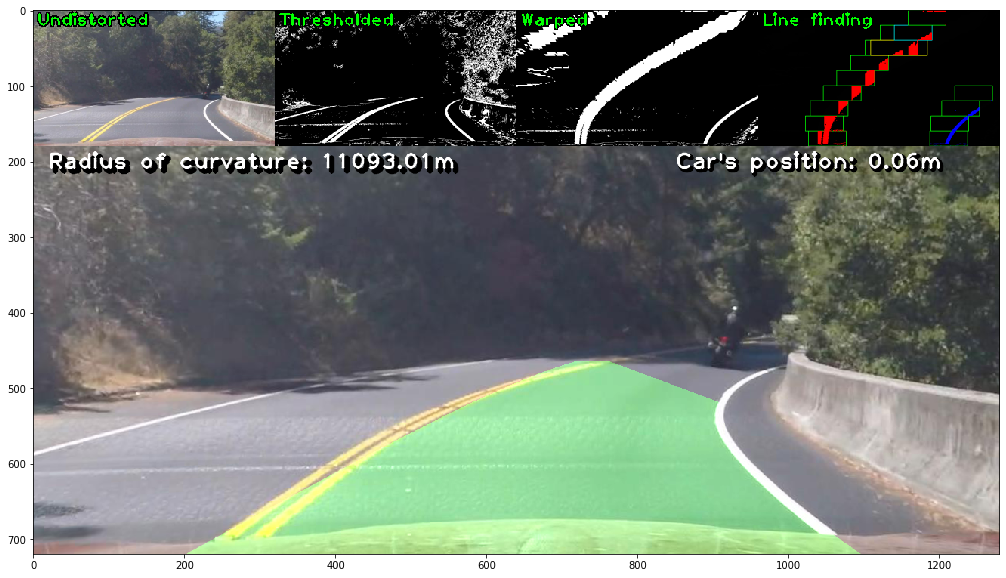

In [128]:
image = test_images[0][0]
'''
# 1. Undistorted image
undistorted = undistort_image(image, dist, mtx)

# 2. Color & Gradient Thresholding
thresholded = color_gradient_threshold(undistorted)

# Region of interest
#vertices = np.array([[(150, IMG_H-1),(627, 400), (683, 400), (1200, IMG_H-1)]], dtype=np.int32)
#roi_thresholded = region_of_interest(thresholded, vertices)

# 3. Warp thresholded image
warped = apply_warp_perspective(thresholded, M)

visu_image, left_fitx, right_fitx, ploty, left_fit, right_fit, lane_width  = search_with_sliding_windows(warped, 0)

result = final_drawing(undistorted, warped, left_fitx, right_fitx, ploty)

color_thres = np.dstack((thresholded, thresholded, thresholded))*255
color_warp = np.dstack((warped, warped, warped))*255
debug_images = [(undistorted, 'Undistorted'), (color_thres, 'Thresholded'), (color_warp, 'Warped'), (visu_image, 'Line finding')]
hsize = result.shape[0]//4
wsize = result.shape[1]//4
debug_images = [(cv2.resize(img, (wsize, hsize), interpolation = cv2.INTER_AREA), text) for (img, text) in debug_images]
for i in range(len(debug_images)):
    result[:hsize, i*wsize:(i+1)*wsize] = debug_images[i][0]
    cv2.putText(result, debug_images[i][1], (i*wsize+30, 30), cv2.FONT_HERSHEY_PLAIN, fontScale=1.5, 
                thickness=5, color=(0, 0, 0))
    cv2.putText(result, debug_images[i][1], (i*wsize+30, 30), cv2.FONT_HERSHEY_PLAIN, fontScale=1.5, 
                thickness=2, color=(0, 255, 0))

y_curv = np.max(ploty)
left_curverad = measure_curvature_real(left_fit, y_curv)
right_curverad = measure_curvature_real(right_fit, y_curv)
curve_rad = (left_curverad + right_curverad) / 2

car_position = get_car_position(left_fitx[-1], right_fitx[-1], image.shape[1])
cv2.putText(result,'Radius of curvature: {:6.2f}m'.format(curve_rad),
            (25, hsize+35), cv2.FONT_HERSHEY_PLAIN, 2,(0,0,0),5,cv2.LINE_AA)
cv2.putText(result,'Radius of curvature: {:6.2f}m'.format(curve_rad),
            (20, hsize+30), cv2.FONT_HERSHEY_PLAIN, 2,(255,255,255),2,cv2.LINE_AA)
cv2.putText(result,"Car's position: {:4.2f}m".format(car_position), (853, hsize+33), 
                cv2.FONT_HERSHEY_PLAIN, 2,(0,0,0),5,cv2.LINE_AA)
cv2.putText(result,"Car's position: {:4.2f}m".format(car_position), (850, hsize+30), 
                cv2.FONT_HERSHEY_PLAIN, 2,(255,255,255),2,cv2.LINE_AA)

print(ploty[-1], left_fitx[-1], right_fitx[-1], car_position)
print(np.polyval(left_fit, 719), np.polyval(right_fit, 719))
'''
'''
cv2.putText(img, "Road curvature: {:6.2f}m".format(curve), (420, 50), cv2.FONT_HERSHEY_PLAIN, fontScale=2.5,
                        thickness=5, color=(255, 255, 255))
            cv2.putText(img, "Road curvature: {:6.2f}m".format(curve), (420, 50), cv2.FONT_HERSHEY_PLAIN, fontScale=2.5,
                        thickness=3, color=(0, 0, 0))
            cv2.putText(img, "Car position: {:4.2f}m".format(shift), (460, 100), cv2.FONT_HERSHEY_PLAIN, fontScale=2.5,
                        thickness=5, color=(255, 255, 255))
            cv2.putText(img, "Car position: {:4.2f}m".format(shift), (460, 100), cv2.FONT_HERSHEY_PLAIN, fontScale=2.5,
                        thickness=3, color=(0, 0, 0))
''' 
LEFT_LINES = Line()
RIGHT_LINES = Line()
result = process_image(image)
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.imshow(result)